# Twitter

In this notebook we are going to show all the used for the analysis. Also we are going to show all the graphics asociated with the data obtaines.


## Introduction

We downloaded data from twitter with various methods, which did not provide the same amount of data, so we standarized to the minimal amount which it could be useful. Those fields are: 
* Date when it was created at.
* ID of the tweet, which is unique.
* The text of the tweet.
* The user, which contains the user screen name (username) and the user ID.

After defining that the period of downloading data was finished, the amount of data gathered was: **6.542.718** unique tweets. Which is a decent amount of data to analyse.

## Analysis

1) The first step is to filter the data in different files that will be used for all the analysis. The filter will be keywords (in the meantime), the keywords are the platforms name (i.e. Nintendo, Playstation, Xbox), these keywords are searched in the text and the username. If there is no defined preference (not zero preference) in which platform the record was pointing to, it is inserted in both files.

The ideal method to filter the data would be create a database of keywords asociated with each platform, so in every record when searching it could be calculated the probability of that text (according to all the words) to which platform it goes. This would require a model with N-Bayes, but like most predictive models it requires training, which we do not have at this moment.

**Note**: Also from here on we called each file as follows:
* project_tweets01.data -> Nintendo
* project_tweets02.data -> Playstation
* project_tweets03.data -> Xbox
* project_tweets04.data -> Else (Which is everything else that did not fit in the other categories)

In [ ]:
import time
import json

if __name__ == '__main__':
    time_start = time.clock()
    nintendo_platform_file = []
    playstation_platform_file = []
    xbox_platform_file = []
    else_platform_file = []
    _file = open("project_tweets.data", 'r')
    for line in _file.readlines():
        data = json.loads(line)
        try:
            raw_text = data['text'].strip().upper()
            raw_username = data['user']['screen_name'].strip().upper()
        except:
            # No idea why would happen.
            print "WTF!"
            raw_text = ""
            raw_username = ""
        nintendo_mentions = raw_text.count("NINTENDO")
        playstation_mentions = raw_text.count("PLAYSTATION")
        xbox_mentions = raw_text.count("XBOX")
        nintendo_mentions += 1 if raw_username.find("NINTENDO") != -1 else 0
        playstation_mentions += 1 if raw_username.find("PLAYSTATION") != -1 else 0
        xbox_mentions += 1 if raw_username.find("XBOX") != -1 else 0
        if nintendo_mentions > playstation_mentions and nintendo_mentions > xbox_mentions:
            nintendo_platform_file.append(line)
        elif playstation_mentions > nintendo_mentions and playstation_mentions > xbox_mentions:
            playstation_platform_file.append(line)
        elif xbox_mentions > playstation_mentions and xbox_mentions > nintendo_mentions:
            xbox_platform_file.append(line)
        elif nintendo_mentions == playstation_mentions and nintendo_mentions == xbox_mentions and nintendo_mentions > 0:
            nintendo_platform_file.append(line)
            playstation_platform_file.append(line)
            xbox_platform_file.append(line)
        elif nintendo_mentions == playstation_mentions and nintendo_mentions != xbox_mentions:
            nintendo_platform_file.append(line)
            playstation_platform_file.append(line)
        elif nintendo_mentions == xbox_mentions and nintendo_mentions != playstation_mentions:
            nintendo_platform_file.append(line)
            xbox_platform_file.append(line)
        elif playstation_mentions == xbox_mentions and playstation_mentions != nintendo_mentions:
            playstation_platform_file.append(line)
            xbox_platform_file.append(line)
        else:
            else_platform_file.append(line)
    filenames = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data"]
    for filename in filenames:
        # Clean files.
        open(filename, 'w').close()
        # Write files in append mode.
        with open(filename, 'a') as _file:
            if filename == "project_tweets01.data":
                for line in nintendo_platform_file:
                    _file.write(line)
            elif filename == "project_tweets02.data":
                for line in playstation_platform_file:
                    _file.write(line)
            elif filename == "project_tweets03.data":
                for line in xbox_platform_file:
                    _file.write(line)
            else:
                for line in else_platform_file:
                    _file.write(line)
    time_end = time.clock()

    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


2) The first analysis to do with this data that is now filtered by platforms, is to count the amount of records per platform. This is done with the next script.

In [ ]:
import time
import sys

if __name__ == '__main__':
    time_start = time.clock()
    # Clean File.
    open("records_by_platform_summary.txt", 'w').close()
    files = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data", "project_tweets.data"]
    for _file in files:
        # Write to file in append mode.
        _fo = open("records_by_platform_summary.txt", 'a')
        sys.stdout = _fo
        print _file
        _data = open(_file, 'r')
        lines = _data.readlines()
        records = len(lines)
        print records, '\n'

    time_end = time.clock()

    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


**Results**

project_tweets01.data

1317667 

project_tweets02.data

2337881 

project_tweets03.data

2260157 

project_tweets04.data

735410 

project_tweets.data

6542718 

Time taken to completion of the metric: 37.615491 in processor time

**Analysis**

From this we can see that in the "else" category we have **11.24%** of all the data, which is not a small amount. But considering that our filter for the platforms is kind of brute force is all right.

3) The next analysis to do is to count the amount of unique users per platform. This is done with the next script.

In [ ]:
import time
import sys

if __name__ == '__main__':
    time_start = time.clock()
    # Clean File.
    open("user_amount_by_platform_summary.txt", 'w').close()
    files = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data"]
    for _file in files:
        # parameters for mrjob.
        # To run your job in multiple subprocesses with a few Hadoop features simulated, use -r local.
        option1 = "" #""-r"
        option2 = "" #""local"
        sys.argv = ['user_amount.py', option1, option2, _file]
        # Write to file in append mode.
        _fo = open("user_amount_by_platform_summary.txt", 'a')
        sys.stdout = _fo
        print _file
        execfile('user_amount.py')
        print "\n"

    time_end = time.clock()

    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONValueProtocol
import time
import itertools
import sys

class MRWordFrequencyCount(MRJob):
    INPUT_PROTOCOL = JSONValueProtocol

    def mapper(self, _, record):
        yield [record['user']['screen_name'], 1]

    def reducer(self, key, values):
        yield [key, 1]

    def mapper2(self, key, values):
        yield ['amount_users', values]

    def reducer2(self, key, values):
        yield [key, sum(values)]

    def steps(self):
        return [MRStep(mapper=self.mapper, reducer=self.reducer),
                MRStep(mapper=self.mapper2, reducer=self.reducer2)]


if __name__ == '__main__':
    #time_start = time.clock()
    MRWordFrequencyCount().run()
    #time_end = time.clock()
    #print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


**Results**

project_tweets01.data

"amount_users"	426450


project_tweets02.data

"amount_users"	574308


project_tweets03.data

"amount_users"	727273


project_tweets04.data

"amount_users"	265827


Time taken to completion of the metric: 426.030981 in processor time


**Analysis**

From this we can see that in the Xbox platform there are more unique users than in all the other platforms by a not small percentage, it almost duplicates Nintendo unique users. What is interesting, is using the analysis from before we can see that Xbox had less records than Playstation, but seeing this there is a whooping 150k (estimated) more unique users in Xbox, which could lead us that Playstation content creation is more for each unique user or that there is a tiny amount of users that produce all the content for this platform.

4) The next analysis is to calculate the Top 10 users that generate the most content in each platform. This is done with the next script.

In [ ]:
import time
import sys

if __name__ == '__main__':
    time_start = time.clock()
    # Clean File.
    open("top_users_by_platform_summary.txt", 'w').close()
    files = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data"]
    for _file in files:
        # parameters for mrjob.
        # To run your job in multiple subprocesses with a few Hadoop features simulated, use -r local.
        option1 = "" #""-r"
        option2 = "" #""local"
        sys.argv = ['top_users.py', option1, option2, _file]
        # Write to file in append mode.
        _fo = open("top_users_by_platform_summary.txt", 'a')
        sys.stdout = _fo
        print _file
        execfile('top_users.py')
        print "\n"

    time_end = time.clock()

    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONValueProtocol
import time
import itertools
import operator
import sys

class MRWordFrequencyCount(MRJob):
    INPUT_PROTOCOL = JSONValueProtocol

    def mapper(self, _, record):
        yield [record['user']['screen_name'], 1]

    def reducer(self, key, values):
        yield ["top_user", (sum(values), key)]

    def reducer2(self, key, values):
        user_ids = []
        user_tweets = []
        for value in values:
            user_ids.append(value[1])
            user_tweets.append(value[0])
        user = {}
        for i in xrange(0, len(user_ids)):
            user[user_ids[i]] = user_tweets[i]
        top_users = sorted(user.items(), key=lambda x: (x[1], operator.itemgetter(0)), reverse=True)
        for user in top_users[0:10]:
            #print user[0], user[1]
            yield [user[0], user[1]]

    def steps(self):
        return [MRStep(mapper=self.mapper, reducer=self.reducer),
                MRStep(reducer=self.reducer2)]


if __name__ == '__main__':
    #time_start = time.clock()
    MRWordFrequencyCount().run()
    #time_end = time.clock()
    #print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


**Results**

project_tweets01.data
* "savetimeandmoey"	11391
* "AuctionPorn"	8449
* "AmazonBay4u"	8352
* "retrodeals"	7435
* "Nintendo_Legend"	6895
* "retrodealsUK"	6744
* "LastChanceGamer"	5904
* "GameUP247"	5580
* "RetroNuss"	5441
* "Nintendoe3E3"	5438


project_tweets02.data
* "Cammie_Whybrew"	13616
* "AskPlayStation"	13282
* "eBayShopperNews"	11578
* "VideoGamesMall"	10274
* "savetimeandmoey"	8632
* "collinschristof"	5382
* "topnewskoeln"	5297
* "Gamifive"	4829
* "Xbox_360_Gamez"	4080
* "pressebank"	3799


project_tweets03.data
* "Xbox_360_Gamez"	34137
* "XboxSupport"	14421
* "VideoGamesMall"	11835
* "Xbox_One_Reddit"	10215
* "xboxgamersdeals"	9224
* "GameUP247"	9156
* "KingsleyNewz"	9139
* "bullzyy"	7576
* "savetimeandmoey"	7176
* "giveawayxfab"	7028


project_tweets04.data
* "savetimeandmoey"	15483
* "VideoGames_Up"	13804
* "giveawaygigatop"	8878
* "tw100_1"	6538
* "videogames_pt"	6357
* "videogames_fr"	5993
* "giveawayxfab"	5886
* "DMGG_Videogames"	5295
* "ShoppeWorld"	4824
* "VideoGames_TV"	3709


Time taken to completion of the metric: 335.930534 in processor time


**Analysis**

From this we can see that there are some users in more than one platform, and that they are one of the top 10 users that generate contents, which means that they are probably spammers, bots or someone really good at making records for almost all the platforms.

5) The nexts analysis of the data is by each hour of a day in every week (the data was gathered).

5.1) We now calculate the Top 20 words. That is how many times a single word was used in each record for each platform. This is done with the next script.

In [ ]:
import time
import sys
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import json
from datetime import datetime
from dateutil.parser import parse
import operator

# The summary is for each hour per week. (i.e. 20 times hello on week 1, 31 times bye on week 2, ...)

if __name__ == '__main__':
    time_start = time.clock()
    # Clean File.
    open("count_words_by_platform_summary.txt", 'w').close()
    files = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data"]
    for _file in files:
        punctuation = []
        open(_file[:-5] + "_words.data", 'w').close()
        _output = open(_file[:-5] + "_words.data", 'a')
        _output_filename = _output.name
        for i in xrange(0, len(string.punctuation)):
            punctuation.append(string.punctuation[i])
        stop_words = stopwords.words() + punctuation
        _data = open(_file, 'r')
        for line in _data.readlines():
            data = json.loads(line)
            date = parse(data['created_at'])
            week = date.isocalendar()[1]
            hour = date.hour
            _words = [i for i in word_tokenize(data['text'].lower()) if i not in stop_words]
            for word in _words:
                record = {'word': word, 'week': week, 'hour': hour}
                _output.write(json.dumps(record, sort_keys=True) + "\n")
        _data.close()
        _output.close()
        # parameters for mrjob.
        # To run your job in multiple subprocesses with a few Hadoop features simulated, use -r local.
        option1 = "" #""-r"
        option2 = "" #""local"
        sys.argv = ['words_amount.py', option1, option2, _output_filename]
        # Write to file in append mode.
        _fo = open("count_words_by_platform_summary.txt", 'a')
        sys.stdout = _fo
        print _file
        execfile('words_amount.py')
        print "\n"

    time_end = time.clock()
    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONValueProtocol
import time
import itertools
import sys
from datetime import datetime
from dateutil.parser import parse
import operator

class MRWordFrequencyCount(MRJob):
    INPUT_PROTOCOL = JSONValueProtocol

    def mapper(self, _, record):
        hour = record['hour']
        week = record['week']
        word = record['word']
        yield [(week, hour, word), 1]

    def reducer(self, key, values):
        yield [(key[0], key[1]), (sum(values), key[2])]

    def reducer2(self, key, values):
        counts = []
        words = []
        for value in values:
            words.append(value[1])
            counts.append(value[0])
        pair_word_count = {}
        for i in xrange(0, len(words)):
            pair_word_count[words[i]] = counts[i]
        top_words = sorted(pair_word_count.items(), key=lambda x: (x[1], operator.itemgetter(0)), reverse=True)
        for word in top_words[0:20]:
            #print user[0], user[1]
            yield [(key[0], key[1], word[0]), word[1]]

    def steps(self):
        return [MRStep(mapper=self.mapper, reducer=self.reducer), MRStep(reducer=self.reducer2)]


if __name__ == '__main__':
    #time_start = time.clock()
    MRWordFrequencyCount().run()
    #time_end = time.clock()
    #print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


**Results**

project_tweets01.data
[14, 22, "rules"]	1
[14, 22, "publishers"]	1
[14, 22, "third-party"]	1
[14, 22, "strict"]	1
[14, 22, "allowed"]	1
[14, 22, "games"]	1
[14, 22, "systems"]	1
[14, 22, "release"]	1
[14, 22, "5"]	1
[14, 22, "year"]	1
[14, 22, "nes"]	1
[14, 22, "nintendo"]	1
[14, 22, "licensing"]	1
[25, 17, "would"]	1
[25, 17, "//"]	1
[25, 17, "drama"]	1
[25, 17, "gamergate"]	1
[25, 17, "reference"]	1
[25, 17, "ever"]	1
[25, 17, "neogaf"]	1
[25, 17, "archive.is/jqedr"]	1
[25, 17, "nintendo"]	1
[25, 17, "torrentialdownpour"]	1
[25, 17, "treehouse"]	1
[25, 17, "blame"]	1
[25, 17, "https"]	1
[25, 17, "internet"]	1
[26, 0, "nintendo"]	1429
[26, 0, "//"]	801
[26, 0, "http"]	764
[26, 0, "\u2026"]	321
[26, 0, "https"]	225
[26, 0, "//www"]	185
[26, 0, "..."]	149
[26, 0, "t-shirt"]	138
[26, 0, "games"]	135
[26, 0, "3ds"]	135
[26, 0, "design"]	131
[26, 0, "contest"]	130
[26, 0, "new"]	122
[26, 0, "miyamoto"]	121
[26, 0, "youtube"]	120
[26, 0, "shigeru"]	119
[26, 0, "judged"]	116
[26, 0, "wii"]	112
[26, 0, "'s"]	107
[26, 0, "video"]	106
[26, 1, "nintendo"]	1281
[26, 1, "//"]	704
[26, 1, "http"]	691
[26, 1, "\u2026"]	320
[26, 1, "https"]	203
[26, 1, "//www"]	190
[26, 1, "wii"]	122
[26, 1, "..."]	119
[26, 1, "super"]	116
[26, 1, "3ds"]	112
[26, 1, "game"]	108
[26, 1, "youtube"]	105
[26, 1, "games"]	104
[26, 1, "'s"]	103
[26, 1, "nx"]	102
[26, 1, "video"]	98
[26, 1, "new"]	95
[26, 1, "mario"]	89
[26, 1, "ebay"]	78
[26, 1, "console"]	70
[26, 10, "nintendo"]	1585
[26, 10, "//"]	898
[26, 10, "http"]	888
[26, 10, "\u2026"]	367
[26, 10, "https"]	216
[26, 10, "//www"]	206
[26, 10, "3ds"]	185
[26, 10, "nx"]	173
[26, 10, "..."]	148
[26, 10, "game"]	145
[26, 10, "wii"]	135
[26, 10, "youtube"]	117
[26, 10, "new"]	110
[26, 10, "games"]	109
[26, 10, "super"]	101
[26, 10, "ebay"]	99
[26, 10, "'s"]	93
[26, 10, "mario"]	87
[26, 10, "video"]	82
[26, 10, "console"]	81
[26, 11, "nintendo"]	1710
[26, 11, "http"]	924
[26, 11, "//"]	909
[26, 11, "\u2026"]	513
[26, 11, "//www"]	285
[26, 11, "https"]	268
[26, 11, "3ds"]	159
[26, 11, "wii"]	154
[26, 11, "..."]	150
[26, 11, "'s"]	128
[26, 11, "super"]	124
[26, 11, "nx"]	124
[26, 11, "games"]	118
[26, 11, "youtube"]	111
[26, 11, "new"]	106
[26, 11, "game"]	105
[26, 11, "mario"]	100
[26, 11, "nes"]	96
[26, 11, "n't"]	95
[26, 11, "e3"]	88
[26, 12, "nintendo"]	1695
[26, 12, "//"]	949
[26, 12, "http"]	919
[26, 12, "\u2026"]	405
[26, 12, "https"]	226
[26, 12, "//www"]	196
[26, 12, "wii"]	162
[26, 12, "..."]	153
[26, 12, "'s"]	137
[26, 12, "new"]	136
[26, 12, "youtube"]	131
[26, 12, "games"]	126
[26, 12, "3ds"]	122
[26, 12, "game"]	121
[26, 12, "super"]	120
[26, 12, "nx"]	111
[26, 12, "mario"]	98
[26, 12, "video"]	92
[26, 12, "n't"]	87
[26, 12, "ebay"]	74
[26, 13, "nintendo"]	2106
[26, 13, "//"]	1254
[26, 13, "http"]	1238
[26, 13, "\u2026"]	501
[26, 13, "..."]	360
[26, 13, "https"]	285
[26, 13, "//www"]	268
[26, 13, "nx"]	245
[26, 13, "super"]	244
[26, 13, "mario"]	234
[26, 13, "3ds"]	194
[26, 13, "n't"]	193
[26, 13, "games"]	192
[26, 13, "'s"]	185
[26, 13, "wii"]	184
[26, 13, "vr"]	151
[26, 13, "game"]	150
[26, 13, "virtual"]	134
[26, 13, "bros."]	131
[26, 13, "playing"]	127
[26, 14, "nintendo"]	1915
[26, 14, "//"]	1008
[26, 14, "http"]	1007
[26, 14, "\u2026"]	388
[26, 14, "'s"]	266
[26, 14, "//www"]	243
[26, 14, "https"]	241
[26, 14, "game"]	215
[26, 14, "..."]	168
[26, 14, "nx"]	157
[26, 14, "wii"]	155
[26, 14, "games"]	140
[26, 14, "super"]	131
[26, 14, "3ds"]	129
[26, 14, "new"]	127
[26, 14, "youtube"]	124
[26, 14, "console"]	119
[26, 14, "mario"]	112
[26, 14, "video"]	111
[26, 14, "ebay"]	90
[26, 15, "nintendo"]	1691
[26, 15, "http"]	1009
[26, 15, "//"]	965
[26, 15, "\u2026"]	346
[26, 15, "//www"]	233
[26, 15, "https"]	190
[26, 15, "..."]	181
[26, 15, "game"]	155
[26, 15, "games"]	154
[26, 15, "super"]	150
[26, 15, "wii"]	146
[26, 15, "'s"]	145
[26, 15, "youtube"]	142
[26, 15, "3ds"]	131
[26, 15, "new"]	129
[26, 15, "nx"]	127
[26, 15, "video"]	120
[26, 15, "mario"]	105
[26, 15, "64"]	98
[26, 15, "ds"]	82
[26, 16, "nintendo"]	1600
[26, 16, "http"]	856
[26, 16, "//"]	828
[26, 16, "\u2026"]	343
[26, 16, "'s"]	212
[26, 16, "//www"]	190
[26, 16, "nx"]	167
[26, 16, "https"]	161
[26, 16, "..."]	158
[26, 16, "3ds"]	130
[26, 16, "games"]	119
[26, 16, "game"]	115
[26, 16, "super"]	115
[26, 16, "wii"]	114
[26, 16, "youtube"]	111
[26, 16, "could"]	104
[26, 16, "win"]	104
[26, 16, "video"]	100
[26, 16, "big"]	98
[26, 16, "analyst"]	96
[26, 17, "nintendo"]	1717
[26, 17, "http"]	863
[26, 17, "//"]	843
[26, 17, "\u2026"]	314
[26, 17, "youtube"]	205
[26, 17, "//www"]	201
[26, 17, "https"]	180
[26, 17, "'s"]	179
[26, 17, "..."]	156
[26, 17, "game"]	156
[26, 17, "video"]	144
[26, 17, "wii"]	141
[26, 17, "games"]	140
[26, 17, "new"]	133
[26, 17, "nx"]	132
[26, 17, "3ds"]	121
[26, 17, "super"]	119
[26, 17, "console"]	118
[26, 17, "zelda"]	115
[26, 17, "liked"]	104
[26, 18, "nintendo"]	1761
[26, 18, "http"]	1029
[26, 18, "//"]	1004
[26, 18, "\u2026"]	335
[26, 18, "youtube"]	198
[26, 18, "games"]	195
[26, 18, "//www"]	194
[26, 18, "..."]	185
[26, 18, "video"]	184
[26, 18, "https"]	171
[26, 18, "3ds"]	169
[26, 18, "new"]	152
[26, 18, "10"]	152
[26, 18, "super"]	145
[26, 18, "game"]	138
[26, 18, "'s"]	137
[26, 18, "nx"]	125
[26, 18, "wii"]	119
[26, 18, "liked"]	113
[26, 18, "red"]	96
[26, 19, "nintendo"]	1692
[26, 19, "http"]	892
[26, 19, "//"]	883
[26, 19, "\u2026"]	300
[26, 19, "//www"]	217
[26, 19, "https"]	205
[26, 19, "..."]	195
[26, 19, "'s"]	172
[26, 19, "games"]	171
[26, 19, "nx"]	138
[26, 19, "new"]	136
[26, 19, "wii"]	131
[26, 19, "youtube"]	128
[26, 19, "game"]	124
[26, 19, "super"]	124
[26, 19, "3ds"]	112
[26, 19, "video"]	106
[26, 19, "e3"]	102
[26, 19, "ebay"]	80
[26, 19, "nes"]	80
[26, 2, "nintendo"]	1159
[26, 2, "http"]	711
[26, 2, "//"]	678
[26, 2, "\u2026"]	317
[26, 2, "//www"]	175
[26, 2, "https"]	140
[26, 2, "..."]	133
[26, 2, "wii"]	127
[26, 2, "nx"]	126
[26, 2, "game"]	101
[26, 2, "new"]	97
[26, 2, "3ds"]	94
[26, 2, "'s"]	83
[26, 2, "youtube"]	81
[26, 2, "video"]	78
[26, 2, "games"]	74
[26, 2, "mario"]	71
[26, 2, "ebay"]	71
[26, 2, "super"]	68
[26, 2, "moffitt"]	56
[26, 20, "nintendo"]	2240
[26, 20, "//"]	1268
[26, 20, "http"]	1245
[26, 20, "\u2026"]	452
[26, 20, "3ds"]	274
[26, 20, "https"]	268
[26, 20, "//www"]	245
[26, 20, "..."]	213
[26, 20, "'s"]	202
[26, 20, "youtube"]	200
[26, 20, "new"]	197
[26, 20, "games"]	185
[26, 20, "game"]	168
[26, 20, "wii"]	164
[26, 20, "nx"]	162
[26, 20, "video"]	155
[26, 20, "super"]	155
[26, 20, "mario"]	133
[26, 20, "nes"]	106
[26, 20, "summer"]	106
[26, 21, "nintendo"]	2044
[26, 21, "//"]	1162
[26, 21, "http"]	1160
[26, 21, "\u2026"]	440
[26, 21, "https"]	274
[26, 21, "//www"]	274
[26, 21, "3ds"]	224
[26, 21, "wii"]	214
[26, 21, "games"]	190
[26, 21, "youtube"]	188
[26, 21, "video"]	182
[26, 21, "new"]	178
[26, 21, "super"]	177
[26, 21, "'s"]	165
[26, 21, "game"]	163
[26, 21, "..."]	154
[26, 21, "nx"]	132
[26, 21, "mario"]	112
[26, 21, "liked"]	105
[26, 21, "ebay"]	102
[26, 22, "nintendo"]	2010
[26, 22, "//"]	1141
[26, 22, "http"]	1048
[26, 22, "\u2026"]	425
[26, 22, "https"]	306
[26, 22, "//www"]	215
[26, 22, "nx"]	207
[26, 22, "youtube"]	203
[26, 22, "..."]	191
[26, 22, "video"]	183
[26, 22, "'s"]	173
[26, 22, "wii"]	171
[26, 22, "games"]	167
[26, 22, "game"]	156
[26, 22, "3ds"]	140
[26, 22, "new"]	132
[26, 22, "super"]	127
[26, 22, "liked"]	112
[26, 22, "_legend"]	93
[26, 22, "ebay"]	93
[26, 23, "nintendo"]	2035
[26, 23, "//"]	1160
[26, 23, "http"]	1056
[26, 23, "\u2026"]	504
[26, 23, "https"]	381
[26, 23, "//www"]	279
[26, 23, "t-shirt"]	207
[26, 23, "design"]	196
[26, 23, "contest"]	194
[26, 23, "miyamoto"]	188
[26, 23, "..."]	188
[26, 23, "shigeru"]	182
[26, 23, "judged"]	178
[26, 23, "game"]	175
[26, 23, "3ds"]	175
[26, 23, "'s"]	174
[26, 23, "youtube"]	172
[26, 23, "games"]	169
[26, 23, "video"]	157
[26, 23, "new"]	154
[26, 3, "nintendo"]	1294
[26, 3, "http"]	940
[26, 3, "//"]	882
[26, 3, "\u2026"]	398
[26, 3, "..."]	225
[26, 3, "//www"]	205
[26, 3, "wii"]	174
[26, 3, "https"]	146
[26, 3, "t-shirt"]	135
[26, 3, "miyamoto"]	116
[26, 3, "contest"]	115
[26, 3, "shigeru"]	114
[26, 3, "\u2019s"]	110
[26, 3, "judge"]	110
[26, 3, "10,000"]	109
[26, 3, "uniqlo\u2019s"]	107
[26, 3, "nx"]	106
[26, 3, "30"]	105
[26, 3, "super"]	104
[26, 3, "3ds"]	104
[26, 4, "nintendo"]	1369
[26, 4, "http"]	1044
[26, 4, "//"]	1037
[26, 4, "\u2026"]	411
[26, 4, "t-shirt"]	284
[26, 4, "miyamoto"]	263
[26, 4, "contest"]	260
[26, 4, "shigeru"]	251
[26, 4, "10,000"]	237
[26, 4, "\u2019s"]	235
[26, 4, "//www"]	185
[26, 4, "gaming"]	179
[26, 4, "https"]	175
[26, 4, "judging"]	160
[26, 4, "..."]	159
[26, 4, "ultimate"]	151
[26, 4, "3ds"]	142
[26, 4, "new"]	137
[26, 4, "wii"]	124
[26, 4, "games"]	103
[26, 5, "nintendo"]	1310
[26, 5, "http"]	929
[26, 5, "//"]	866
[26, 5, "\u2026"]	359
[26, 5, "//www"]	209
[26, 5, "n't"]	174
[26, 5, "vr"]	173
[26, 5, "still"]	160
[26, 5, "sure"]	153
[26, 5, "https"]	145
[26, 5, "..."]	141
[26, 5, "wii"]	120
[26, 5, "nx"]	104
[26, 5, "3ds"]	99
[26, 5, "video"]	85
[26, 5, "'s"]	81
[26, 5, "game"]	81
[26, 5, "super"]	78
[26, 5, "games"]	78
[26, 5, "youtube"]	75
[26, 6, "nintendo"]	1210
[26, 6, "//"]	793
[26, 6, "http"]	782
[26, 6, "\u2026"]	308
[26, 6, "https"]	165
[26, 6, "//www"]	154
[26, 6, "wii"]	143
[26, 6, "nx"]	136
[26, 6, "..."]	135
[26, 6, "3ds"]	98
[26, 6, "t-shirt"]	92
[26, 6, "game"]	78
[26, 6, "games"]	77
[26, 6, "uniqlo"]	73
[26, 6, "console"]	73
[26, 6, "design"]	70
[26, 6, "d8"]	68
[26, 6, "new"]	67
[26, 6, "super"]	67
[26, 6, "'s"]	65
[26, 7, "nintendo"]	1058
[26, 7, "http"]	693
[26, 7, "//"]	660
[26, 7, "\u2026"]	369
[26, 7, "//www"]	202
[26, 7, "https"]	170
[26, 7, "..."]	115
[26, 7, "wii"]	112
[26, 7, "'s"]	102
[26, 7, "3ds"]	101
[26, 7, "super"]	96
[26, 7, "nx"]	94
[26, 7, "video"]	77
[26, 7, "game"]	75
[26, 7, "e3"]	74
[26, 7, "youtube"]	73
[26, 7, "games"]	73
[26, 7, "console"]	68
[26, 7, "new"]	62
[26, 7, "d8"]	60
[26, 8, "nintendo"]	1407
[26, 8, "//"]	822
[26, 8, "http"]	802
[26, 8, "\u2026"]	396
[26, 8, "https"]	220
[26, 8, "//www"]	201
[26, 8, "..."]	176
[26, 8, "wii"]	134
[26, 8, "game"]	129
[26, 8, "nx"]	129
[26, 8, "3ds"]	109
[26, 8, "'s"]	91
[26, 8, "super"]	91
[26, 8, "video"]	84
[26, 8, "new"]	84
[26, 8, "games"]	82
[26, 8, "ebay"]	75
[26, 8, "mario"]	75
[26, 8, "marketing"]	70
[26, 8, "console"]	67
[26, 9, "nintendo"]	1732
[26, 9, "//"]	993
[26, 9, "http"]	982
[26, 9, "\u2026"]	460
[26, 9, "https"]	250
[26, 9, "//www"]	246
[26, 9, "nx"]	205
[26, 9, "..."]	187
[26, 9, "game"]	137
[26, 9, "3ds"]	137
[26, 9, "'s"]	123
[26, 9, "nes"]	120
[26, 9, "wii"]	116
[26, 9, "new"]	114
[26, 9, "kickstarter"]	109
[26, 9, "games"]	95
[26, 9, "super"]	94
[26, 9, "youtube"]	84
[26, 9, "book"]	84
[26, 9, "takes"]	77
[27, 0, "nintendo"]	2092
[27, 0, "//"]	1027
[27, 0, "http"]	1025
[27, 0, "\u2026"]	393
[27, 0, "https"]	242
[27, 0, "//www"]	241
[27, 0, "pokemon"]	228
[27, 0, "..."]	218
[27, 0, "game"]	203
[27, 0, "go"]	186
[27, 0, "e3"]	172
[27, 0, "games"]	168
[27, 0, "'s"]	165
[27, 0, "wii"]	158
[27, 0, "3ds"]	141
[27, 0, "youtube"]	139
[27, 0, "new"]	130
[27, 0, "video"]	119
[27, 0, "mario"]	115
[27, 0, "ebay"]	114
[27, 1, "nintendo"]	2264
[27, 1, "//"]	1329
[27, 1, "http"]	1305
[27, 1, "\u2026"]	465
[27, 1, "..."]	305
[27, 1, "smartphones"]	280
[27, 1, "https"]	257
[27, 1, "podr\u00eda"]	239
[27, 1, "//www"]	235
[27, 1, "controles"]	234
[27, 1, "fabricar"]	233
[27, 1, "f\u00edsicos"]	233
[27, 1, "tabletas"]	231
[27, 1, "futuro"]	222
[27, 1, "pokemon"]	217
[27, 1, "game"]	192
[27, 1, "3ds"]	185
[27, 1, "go"]	155
[27, 1, "wii"]	153
[27, 1, "new"]	141
[27, 10, "nintendo"]	3376
[27, 10, "//"]	1822
[27, 10, "http"]	1817
[27, 10, "\u2026"]	782
[27, 10, "https"]	429
[27, 10, "//www"]	429
[27, 10, "game"]	383
[27, 10, "pokemon"]	364
[27, 10, "..."]	337
[27, 10, "new"]	293
[27, 10, "wii"]	276
[27, 10, "go"]	263
[27, 10, "3ds"]	236
[27, 10, "'s"]	233
[27, 10, "games"]	206
[27, 10, "pok\u00e9mon"]	189
[27, 10, "super"]	164
[27, 10, "nx"]	162
[27, 10, "youtube"]	146
[27, 10, "ebay"]	143
[27, 11, "nintendo"]	3562
[27, 11, "http"]	2029
[27, 11, "//"]	2007
[27, 11, "\u2026"]	806
[27, 11, "..."]	445
[27, 11, "//www"]	444
[27, 11, "https"]	415
[27, 11, "wii"]	345
[27, 11, "'s"]	313
[27, 11, "game"]	308
[27, 11, "games"]	268
[27, 11, "pokemon"]	252
[27, 11, "go"]	238
[27, 11, "3ds"]	235
[27, 11, "new"]	222
[27, 11, "nx"]	176
[27, 11, "``"]	172
[27, 11, "controller"]	158
[27, 11, "super"]	157
[27, 11, "patent"]	156
[27, 12, "nintendo"]	3850
[27, 12, "//"]	2194
[27, 12, "http"]	2183
[27, 12, "\u2026"]	799
[27, 12, "..."]	525
[27, 12, "https"]	410
[27, 12, "//www"]	400
[27, 12, "'s"]	359
[27, 12, "pokemon"]	296
[27, 12, "go"]	283
[27, 12, "game"]	250
[27, 12, "3ds"]	241
[27, 12, "wii"]	225
[27, 12, "smartphones"]	214
[27, 12, "new"]	207
[27, 12, "pok\u00e9mon"]	205
[27, 12, "make"]	197
[27, 12, "games"]	188
[27, 12, "nx"]	186
[27, 12, "controller"]	174
[27, 13, "nintendo"]	3542
[27, 13, "http"]	1753
[27, 13, "//"]	1714
[27, 13, "\u2026"]	673
[27, 13, "..."]	386
[27, 13, "//www"]	381
[27, 13, "https"]	341
[27, 13, "wii"]	320
[27, 13, "pokemon"]	294
[27, 13, "game"]	287
[27, 13, "'s"]	283
[27, 13, "3ds"]	273
[27, 13, "games"]	261
[27, 13, "go"]	248
[27, 13, "new"]	215
[27, 13, "mario"]	184
[27, 13, "_legend"]	182
[27, 13, "nx"]	178
[27, 13, "n't"]	177
[27, 13, "super"]	169
[27, 14, "nintendo"]	3145
[27, 14, "//"]	1524
[27, 14, "http"]	1518
[27, 14, "\u2026"]	625
[27, 14, "..."]	339
[27, 14, "https"]	320
[27, 14, "//www"]	317
[27, 14, "'s"]	297
[27, 14, "game"]	274
[27, 14, "pokemon"]	272
[27, 14, "new"]	239
[27, 14, "3ds"]	229
[27, 14, "go"]	219
[27, 14, "wii"]	196
[27, 14, "nx"]	195
[27, 14, "games"]	194
[27, 14, "super"]	146
[27, 14, "``"]	139
[27, 14, "youtube"]	138
[27, 14, "mario"]	138
[27, 15, "nintendo"]	3376
[27, 15, "http"]	1685
[27, 15, "//"]	1625
[27, 15, "\u2026"]	563
[27, 15, "//www"]	352
[27, 15, "..."]	343
[27, 15, "pokemon"]	310
[27, 15, "wii"]	301
[27, 15, "'s"]	299
[27, 15, "https"]	291
[27, 15, "go"]	242
[27, 15, "game"]	238
[27, 15, "games"]	199
[27, 15, "new"]	192
[27, 15, "3ds"]	176
[27, 15, "mobile"]	167
[27, 15, "youtube"]	149
[27, 15, "super"]	149
[27, 15, "pokemongo"]	142
[27, 15, "n't"]	133
[27, 16, "nintendo"]	3229
[27, 16, "http"]	1591
[27, 16, "//"]	1553
[27, 16, "\u2026"]	707
[27, 16, "..."]	347
[27, 16, "//www"]	345
[27, 16, "pokemon"]	316
[27, 16, "https"]	305
[27, 16, "wii"]	275
[27, 16, "go"]	252
[27, 16, "'s"]	239
[27, 16, "game"]	211
[27, 16, "3ds"]	210
[27, 16, "games"]	196
[27, 16, "new"]	174
[27, 16, "e3"]	167
[27, 16, "youtube"]	160
[27, 16, "nx"]	157
[27, 16, "super"]	147
[27, 16, "mario"]	136
[27, 17, "nintendo"]	3008
[27, 17, "http"]	1352
[27, 17, "//"]	1317
[27, 17, "\u2026"]	546
[27, 17, "//www"]	338
[27, 17, "https"]	307
[27, 17, "game"]	269
[27, 17, "..."]	255
[27, 17, "pokemon"]	239
[27, 17, "wii"]	235
[27, 17, "games"]	234
[27, 17, "'s"]	232
[27, 17, "3ds"]	195
[27, 17, "new"]	192
[27, 17, "youtube"]	185
[27, 17, "super"]	185
[27, 17, "go"]	184
[27, 17, "mario"]	157
[27, 17, "nx"]	151
[27, 17, "n't"]	147
[27, 18, "nintendo"]	2142
[27, 18, "//"]	1110
[27, 18, "http"]	1102
[27, 18, "\u2026"]	439
[27, 18, "..."]	254
[27, 18, "https"]	235
[27, 18, "game"]	234
[27, 18, "//www"]	228
[27, 18, "'s"]	198
[27, 18, "games"]	191
[27, 18, "wii"]	183
[27, 18, "pokemon"]	176
[27, 18, "3ds"]	167
[27, 18, "nx"]	154
[27, 18, "super"]	147
[27, 18, "mario"]	143
[27, 18, "new"]	137
[27, 18, "youtube"]	131
[27, 18, "go"]	124
[27, 18, "video"]	116
[27, 19, "nintendo"]	2560
[27, 19, "//"]	1345
[27, 19, "http"]	1341
[27, 19, "\u2026"]	517
[27, 19, "game"]	379
[27, 19, "https"]	310
[27, 19, "//www"]	307
[27, 19, "..."]	304
[27, 19, "wii"]	248
[27, 19, "new"]	219
[27, 19, "games"]	199
[27, 19, "'s"]	197
[27, 19, "3ds"]	173
[27, 19, "smartphones"]	171
[27, 19, "pokemon"]	169
[27, 19, "youtube"]	162
[27, 19, "mario"]	153
[27, 19, "making"]	153
[27, 19, "controllers"]	147
[27, 19, "super"]	144
[27, 2, "nintendo"]	1759
[27, 2, "//"]	1055
[27, 2, "http"]	1029
[27, 2, "\u2026"]	472
[27, 2, "https"]	229
[27, 2, "//www"]	204
[27, 2, "..."]	183
[27, 2, "pokemon"]	162
[27, 2, "game"]	159
[27, 2, "3ds"]	157
[27, 2, "go"]	123
[27, 2, "wii"]	123
[27, 2, "new"]	123
[27, 2, "'s"]	116
[27, 2, "games"]	113
[27, 2, "video"]	111
[27, 2, "youtube"]	111
[27, 2, "super"]	104
[27, 2, "ds"]	89
[27, 2, "ebay"]	87
[27, 20, "nintendo"]	2349
[27, 20, "//"]	1398
[27, 20, "http"]	1390
[27, 20, "\u2026"]	395
[27, 20, "controllers"]	340
[27, 20, "..."]	322
[27, 20, "games"]	299
[27, 20, "smartphones"]	255
[27, 20, "game"]	252
[27, 20, "https"]	207
[27, 20, "tablets"]	201
[27, 20, "//www"]	200
[27, 20, "physical"]	192
[27, 20, "new"]	188
[27, 20, "considering"]	182
[27, 20, "wii"]	181
[27, 20, "creating"]	169
[27, 20, "pokemon"]	160
[27, 20, "smartphone"]	158
[27, 20, "make"]	151
[27, 21, "nintendo"]	2373
[27, 21, "//"]	1213
[27, 21, "http"]	1155
[27, 21, "\u2026"]	517
[27, 21, "https"]	312
[27, 21, "pokemon"]	280
[27, 21, "e3"]	275
[27, 21, "//www"]	251
[27, 21, "games"]	240
[27, 21, "..."]	236
[27, 21, "go"]	236
[27, 21, "controllers"]	234
[27, 21, "game"]	213
[27, 21, "'s"]	196
[27, 21, "wii"]	183
[27, 21, "mobile"]	175
[27, 21, "super"]	167
[27, 21, "83"]	162
[27, 21, "new"]	141
[27, 21, "youtube"]	140
[27, 22, "nintendo"]	2201
[27, 22, "//"]	1057
[27, 22, "http"]	1028
[27, 22, "\u2026"]	434
[27, 22, "pokemon"]	344
[27, 22, "https"]	272
[27, 22, "..."]	271
[27, 22, "go"]	270
[27, 22, "//www"]	243
[27, 22, "'s"]	238
[27, 22, "game"]	212
[27, 22, "new"]	157
[27, 22, "wii"]	156
[27, 22, "games"]	152
[27, 22, "3ds"]	135
[27, 22, "super"]	132
[27, 22, "n't"]	124
[27, 22, "pokemongo"]	119
[27, 22, "controllers"]	119
[27, 22, "youtube"]	116
[27, 23, "nintendo"]	1986
[27, 23, "//"]	981
[27, 23, "http"]	923
[27, 23, "\u2026"]	439
[27, 23, "https"]	286
[27, 23, "pokemon"]	264
[27, 23, "..."]	247
[27, 23, "go"]	235
[27, 23, "//www"]	230
[27, 23, "'s"]	199
[27, 23, "game"]	196
[27, 23, "wii"]	172
[27, 23, "games"]	162
[27, 23, "3ds"]	157
[27, 23, "new"]	128
[27, 23, "super"]	123
[27, 23, "video"]	103
[27, 23, "youtube"]	99
[27, 23, "pokemongo"]	97
[27, 23, "ds"]	96
[27, 3, "nintendo"]	1892
[27, 3, "http"]	1172
[27, 3, "//"]	1116
[27, 3, "\u2026"]	548
[27, 3, "//www"]	308
[27, 3, "https"]	248
[27, 3, "..."]	245
[27, 3, "3ds"]	226
[27, 3, "e3"]	202
[27, 3, "game"]	188
[27, 3, "ebay"]	170
[27, 3, "pokemon"]	162
[27, 3, "super"]	158
[27, 3, "go"]	136
[27, 3, "new"]	135
[27, 3, "mario"]	135
[27, 3, "wii"]	119
[27, 3, "83"]	109
[27, 3, "youtube"]	104
[27, 3, "video"]	103
[27, 4, "nintendo"]	1952
[27, 4, "http"]	1147
[27, 4, "//"]	1090
[27, 4, "\u2026"]	542
[27, 4, "//www"]	309
[27, 4, "https"]	252
[27, 4, "3ds"]	230
[27, 4, "pokemon"]	229
[27, 4, "..."]	227
[27, 4, "e3"]	172
[27, 4, "wii"]	169
[27, 4, "game"]	155
[27, 4, "go"]	139
[27, 4, "new"]	138
[27, 4, "super"]	118
[27, 4, "mario"]	108
[27, 4, "games"]	106
[27, 4, "ebay"]	99
[27, 4, "videogames"]	99
[27, 4, "83"]	98
[27, 5, "nintendo"]	1951
[27, 5, "http"]	1170
[27, 5, "//"]	1109
[27, 5, "\u2026"]	494
[27, 5, "//www"]	284
[27, 5, "..."]	259
[27, 5, "https"]	223
[27, 5, "3ds"]	182
[27, 5, "go"]	161
[27, 5, "pokemon"]	149
[27, 5, "nx"]	144
[27, 5, "game"]	143
[27, 5, "wii"]	139
[27, 5, "e3"]	135
[27, 5, "'s"]	128
[27, 5, "new"]	113
[27, 5, "games"]	99
[27, 5, "pok\u00e9mon"]	97
[27, 5, "super"]	87
[27, 5, "ds"]	78
[27, 6, "nintendo"]	2085
[27, 6, "http"]	1185
[27, 6, "//"]	1181
[27, 6, "\u2026"]	499
[27, 6, "//www"]	286
[27, 6, "https"]	281
[27, 6, "..."]	234
[27, 6, "wii"]	177
[27, 6, "3ds"]	171
[27, 6, "go"]	149
[27, 6, "pokemon"]	146
[27, 6, "game"]	139
[27, 6, "pok\u00e9mon"]	131
[27, 6, "smartphone"]	114
[27, 6, "new"]	112
[27, 6, "nx"]	111
[27, 6, "e3"]	106
[27, 6, "'s"]	102
[27, 6, "controller"]	82
[27, 6, "ebay"]	76
[27, 7, "nintendo"]	2470
[27, 7, "http"]	1479
[27, 7, "//"]	1469
[27, 7, "\u2026"]	648
[27, 7, "//www"]	347
[27, 7, "https"]	337
[27, 7, "..."]	278
[27, 7, "smartphone"]	268
[27, 7, "controller"]	243
[27, 7, "wii"]	215
[27, 7, "game"]	213
[27, 7, "plans"]	210
[27, 7, "hints"]	190
[27, 7, "pokemon"]	187
[27, 7, "new"]	175
[27, 7, "3ds"]	170
[27, 7, "go"]	166
[27, 7, "games"]	149
[27, 7, "nx"]	144
[27, 7, "super"]	140
[27, 8, "nintendo"]	2784
[27, 8, "http"]	1654
[27, 8, "//"]	1643
[27, 8, "\u2026"]	708
[27, 8, "//www"]	374
[27, 8, "https"]	365
[27, 8, "..."]	332
[27, 8, "wii"]	251
[27, 8, "pokemon"]	239
[27, 8, "game"]	219
[27, 8, "go"]	200
[27, 8, "3ds"]	196
[27, 8, "nx"]	180
[27, 8, "games"]	162
[27, 8, "'s"]	157
[27, 8, "new"]	156
[27, 8, "smartphones"]	147
[27, 8, "super"]	141
[27, 8, "console"]	125
[27, 8, "mario"]	118
[27, 9, "nintendo"]	3008
[27, 9, "//"]	1623
[27, 9, "http"]	1607
[27, 9, "\u2026"]	699
[27, 9, "https"]	373
[27, 9, "//www"]	357
[27, 9, "..."]	314
[27, 9, "game"]	265
[27, 9, "pokemon"]	249
[27, 9, "3ds"]	232
[27, 9, "go"]	228
[27, 9, "wii"]	218
[27, 9, "e3"]	203
[27, 9, "games"]	201
[27, 9, "nx"]	188
[27, 9, "new"]	173
[27, 9, "'s"]	167
[27, 9, "super"]	137
[27, 9, "youtube"]	127
[27, 9, "83"]	124
[28, 0, "nintendo"]	220
[28, 0, "//"]	189
[28, 0, "http"]	180
[28, 0, "playstation"]	137
[28, 0, "heck"]	103
[28, 0, "legendary"]	100
[28, 0, "tears"]	99
[28, 0, "videogames"]	73
[28, 0, "deals"]	55
[28, 0, "consoles"]	53
[28, 0, "new"]	42
[28, 0, "..."]	37
[28, 0, "good"]	33
[28, 0, "close"]	32
[28, 0, "got"]	32
[28, 0, "look"]	32
[28, 0, "engt.co/2ajfag3"]	29
[28, 0, "super"]	26
[28, 0, "wii"]	22
[28, 0, "https"]	17
[28, 1, "nintendo"]	255
[28, 1, "http"]	165
[28, 1, "//"]	161
[28, 1, "playstation"]	77
[28, 1, "pokemon"]	60
[28, 1, "shares"]	58
[28, 1, "go"]	54
[28, 1, "videogames"]	54
[28, 1, "..."]	47
[28, 1, "\u2026"]	41
[28, 1, "heck"]	40
[28, 1, "tears"]	38
[28, 1, "legendary"]	38
[28, 1, "//www"]	26
[28, 1, "games"]	26
[28, 1, "3ds"]	26
[28, 1, "got"]	25
[28, 1, "video"]	24
[28, 1, "look"]	23
[28, 1, "good"]	22
[28, 10, "nintendo"]	8810
[28, 10, "http"]	5209
[28, 10, "//"]	4714
[28, 10, "nes"]	3954
[28, 10, "\u2026"]	2708
[28, 10, "mini"]	1804
[28, 10, "classic"]	1629
[28, 10, "30"]	1474
[28, 10, "//www"]	1450
[28, 10, "games"]	1318
[28, 10, "..."]	1213
[28, 10, "console"]	1014
[28, 10, "https"]	948
[28, 10, "'s"]	808
[28, 10, "retro"]	604
[28, 10, "go"]	562
[28, 10, "gaming"]	539
[28, 10, "releasing"]	484
[28, 10, "via"]	466
[28, 10, "pokemon"]	464
[28, 11, "nintendo"]	8092
[28, 11, "http"]	4782
[28, 11, "//"]	4298
[28, 11, "nes"]	3521
[28, 11, "\u2026"]	2332
[28, 11, "mini"]	1824
[28, 11, "classic"]	1506
[28, 11, "//www"]	1328
[28, 11, "30"]	1252
[28, 11, "..."]	1121
[28, 11, "games"]	1083
[28, 11, "https"]	836
[28, 11, "console"]	802
[28, 11, "'s"]	660
[28, 11, "nostalgia"]	541
[28, 11, "tiny"]	527
[28, 11, "go"]	514
[28, 11, "retro"]	483
[28, 11, "releasing"]	462
[28, 11, "pokemon"]	455
[28, 12, "nintendo"]	7433
[28, 12, "http"]	4592
[28, 12, "//"]	4154
[28, 12, "nes"]	2968
[28, 12, "\u2026"]	1833
[28, 12, "classic"]	1591
[28, 12, "mini"]	1587
[28, 12, "30"]	1167
[28, 12, "//www"]	1056
[28, 12, "..."]	1042
[28, 12, "games"]	892
[28, 12, "'s"]	635
[28, 12, "https"]	616
[28, 12, "go"]	591
[28, 12, "console"]	524
[28, 12, "pokemon"]	439
[28, 12, "new"]	409
[28, 12, "via"]	374
[28, 12, "nostalgia"]	365
[28, 12, "retro"]	359
[28, 13, "nintendo"]	6068
[28, 13, "http"]	3451
[28, 13, "//"]	3243
[28, 13, "nes"]	2466
[28, 13, "\u2026"]	1746
[28, 13, "mini"]	1083
[28, 13, "classic"]	1031
[28, 13, "//www"]	925
[28, 13, "games"]	816
[28, 13, "..."]	780
[28, 13, "https"]	735
[28, 13, "30"]	731
[28, 13, "'s"]	578
[28, 13, "go"]	516
[28, 13, "console"]	511
[28, 13, "pokemon"]	477
[28, 13, "back"]	362
[28, 13, "via"]	335
[28, 13, "``"]	328
[28, 13, "new"]	323
[28, 14, "nintendo"]	5086
[28, 14, "http"]	2924
[28, 14, "//"]	2664
[28, 14, "nes"]	1760
[28, 14, "\u2026"]	1419
[28, 14, "classic"]	818
[28, 14, "mini"]	806
[28, 14, "//www"]	801
[28, 14, "..."]	693
[28, 14, "games"]	663
[28, 14, "go"]	549
[28, 14, "https"]	542
[28, 14, "30"]	539
[28, 14, "'s"]	458
[28, 14, "console"]	453
[28, 14, "pok\u00e9mon"]	397
[28, 14, "acciones"]	336
[28, 14, "pokemon"]	319
[28, 14, "new"]	296
[28, 14, "via"]	277
[28, 15, "nintendo"]	4282
[28, 15, "http"]	2511
[28, 15, "//"]	2312
[28, 15, "nes"]	1515
[28, 15, "\u2026"]	1259
[28, 15, "mini"]	710
[28, 15, "//www"]	709
[28, 15, "classic"]	638
[28, 15, "games"]	517
[28, 15, "https"]	508
[28, 15, "30"]	476
[28, 15, "'s"]	417
[28, 15, "..."]	416
[28, 15, "go"]	348
[28, 15, "console"]	348
[28, 15, "pokemon"]	322
[28, 15, "new"]	286
[28, 15, "consola"]	243
[28, 15, "via"]	227
[28, 15, "back"]	227
[28, 16, "nintendo"]	3841
[28, 16, "http"]	2204
[28, 16, "//"]	2028
[28, 16, "nes"]	1212
[28, 16, "\u2026"]	1073
[28, 16, "mini"]	633
[28, 16, "//www"]	602
[28, 16, "classic"]	552
[28, 16, "..."]	500
[28, 16, "'s"]	451
[28, 16, "games"]	427
[28, 16, "https"]	427
[28, 16, "go"]	418
[28, 16, "30"]	384
[28, 16, "new"]	360
[28, 16, "pokemon"]	353
[28, 16, "console"]	267
[28, 16, "via"]	187
[28, 16, "back"]	185
[28, 16, "system"]	178
[28, 17, "nintendo"]	4061
[28, 17, "http"]	2329
[28, 17, "//"]	2152
[28, 17, "nes"]	1269
[28, 17, "\u2026"]	961
[28, 17, "classic"]	916
[28, 17, "'s"]	590
[28, 17, "..."]	573
[28, 17, "mini"]	561
[28, 17, "//www"]	559
[28, 17, "games"]	529
[28, 17, "console"]	400
[28, 17, "go"]	382
[28, 17, "https"]	379
[28, 17, "30"]	346
[28, 17, "pokemon"]	290
[28, 17, "back"]	268
[28, 17, "new"]	261
[28, 17, "system"]	241
[28, 17, "consola"]	220
[28, 18, "nintendo"]	2967
[28, 18, "http"]	1735
[28, 18, "//"]	1590
[28, 18, "nes"]	1038
[28, 18, "\u2026"]	761
[28, 18, "classic"]	595
[28, 18, "'s"]	541
[28, 18, "mini"]	502
[28, 18, "//www"]	482
[28, 18, "games"]	430
[28, 18, "30"]	363
[28, 18, "..."]	337
[28, 18, "https"]	332
[28, 18, "go"]	270
[28, 18, "pokemon"]	259
[28, 18, "game"]	201
[28, 18, "new"]	198
[28, 18, "console"]	189
[28, 18, "system"]	162
[28, 18, "get"]	161
[28, 19, "nintendo"]	2964
[28, 19, "http"]	1907
[28, 19, "//"]	1774
[28, 19, "nes"]	858
[28, 19, "games"]	757
[28, 19, "classic"]	735
[28, 19, "\u2026"]	727
[28, 19, "mini"]	661
[28, 19, "'s"]	465
[28, 19, "//www"]	396
[28, 19, "30"]	389
[28, 19, "..."]	378
[28, 19, "new"]	368
[28, 19, "get"]	294
[28, 19, "n't"]	291
[28, 19, "https"]	261
[28, 19, "additional"]	208
[28, 19, "offer"]	206
[28, 19, "go"]	205
[28, 19, "mini-nes"]	202
[28, 2, "nintendo"]	1215
[28, 2, "http"]	737
[28, 2, "//"]	713
[28, 2, "go"]	465
[28, 2, "pokemon"]	432
[28, 2, "shares"]	318
[28, 2, "\u2026"]	272
[28, 2, "50"]	216
[28, 2, "since"]	191
[28, 2, "release"]	190
[28, 2, "..."]	189
[28, 2, "//www"]	138
[28, 2, "16"]	116
[28, 2, "pok\u00e9mon"]	114
[28, 2, "https"]	113
[28, 2, "gaming"]	110
[28, 2, "3ds"]	90
[28, 2, "pokemongo"]	84
[28, 2, "videogames"]	81
[28, 2, "japanese"]	79
[28, 20, "nintendo"]	136
[28, 20, "http"]	102
[28, 20, "//"]	102
[28, 20, "videogames"]	76
[28, 20, "playstation"]	35
[28, 20, "consoles"]	34
[28, 20, "deals"]	34
[28, 20, "game"]	32
[28, 20, "wii"]	32
[28, 20, "new"]	27
[28, 20, "..."]	18
[28, 20, "xbox"]	17
[28, 20, "first"]	16
[28, 20, "super"]	16
[28, 20, "prototype"]	15
[28, 20, "created"]	14
[28, 20, "ultra-rare"]	14
[28, 20, "mario"]	14
[28, 20, "gaiden"]	14
[28, 20, "pokemon"]	14
[28, 21, "nintendo"]	147
[28, 21, "//"]	123
[28, 21, "http"]	119
[28, 21, "videogames"]	89
[28, 21, "consoles"]	47
[28, 21, "deals"]	45
[28, 21, "playstation"]	38
[28, 21, "new"]	33
[28, 21, "\u2026"]	30
[28, 21, "https"]	29
[28, 21, "super"]	29
[28, 21, "game"]	29
[28, 21, "wii"]	28
[28, 21, "//www"]	25
[28, 21, "--"]	21
[28, 21, "3ds"]	21
[28, 21, "pokemon"]	20
[28, 21, "used"]	17
[28, 21, "games"]	17
[28, 21, "xbox"]	16
[28, 22, "nintendo"]	129
[28, 22, "http"]	110
[28, 22, "//"]	106
[28, 22, "videogames"]	65
[28, 22, "playstation"]	38
[28, 22, "game"]	31
[28, 22, "super"]	30
[28, 22, "deals"]	28
[28, 22, "\u2026"]	28
[28, 22, "//www"]	26
[28, 22, "consoles"]	24
[28, 22, "wii"]	24
[28, 22, "https"]	22
[28, 22, "new"]	21
[28, 22, "games"]	20
[28, 22, "3ds"]	17
[28, 22, "..."]	17
[28, 22, "us"]	16
[28, 22, "video"]	15
[28, 22, "xbox"]	14
[28, 23, "nintendo"]	603
[28, 23, "//"]	496
[28, 23, "http"]	461
[28, 23, "playstation"]	426
[28, 23, "heck"]	334
[28, 23, "tears"]	330
[28, 23, "legendary"]	330
[28, 23, "videogames"]	144
[28, 23, "got"]	94
[28, 23, "good"]	93
[28, 23, "close"]	93
[28, 23, "look"]	93
[28, 23, "..."]	90
[28, 23, "deals"]	78
[28, 23, "consoles"]	76
[28, 23, "new"]	69
[28, 23, "ift.tt/29dcehm"]	59
[28, 23, "https"]	55
[28, 23, "engt.co/2ajfag3"]	51
[28, 23, "super"]	50
[28, 3, "nintendo"]	1541
[28, 3, "http"]	1072
[28, 3, "//"]	1001
[28, 3, "go"]	727
[28, 3, "pokemon"]	582
[28, 3, "shares"]	453
[28, 3, "50"]	322
[28, 3, "since"]	291
[28, 3, "release"]	290
[28, 3, "\u2026"]	285
[28, 3, "..."]	283
[28, 3, "pok\u00e9mon"]	190
[28, 3, "//www"]	173
[28, 3, "gaming"]	147
[28, 3, "japanese"]	126
[28, 3, "16"]	106
[28, 3, "firm"]	105
[28, 3, "https"]	100
[28, 3, "new"]	99
[28, 3, "'s"]	94
[28, 4, "nintendo"]	1383
[28, 4, "http"]	974
[28, 4, "//"]	918
[28, 4, "go"]	696
[28, 4, "pokemon"]	671
[28, 4, "..."]	327
[28, 4, "\u2026"]	313
[28, 4, "pok\u00e9mon"]	229
[28, 4, "game"]	209
[28, 4, "//www"]	171
[28, 4, "shares"]	130
[28, 4, "50"]	124
[28, 4, "rp"]	119
[28, 4, "boleh"]	119
[28, 4, "sudah"]	119
[28, 4, "raup"]	119
[28, 4, "183"]	119
[28, 4, "pembesut"]	119
[28, 4, "selaku"]	119
[28, 4, "miliar"]	119
[28, 5, "nintendo"]	1184
[28, 5, "http"]	726
[28, 5, "//"]	703
[28, 5, "go"]	453
[28, 5, "pokemon"]	379
[28, 5, "\u2026"]	239
[28, 5, "..."]	190
[28, 5, "pok\u00e9mon"]	167
[28, 5, "//www"]	122
[28, 5, "pokemongo"]	121
[28, 5, "'s"]	117
[28, 5, "game"]	102
[28, 5, "https"]	98
[28, 5, "shares"]	97
[28, 5, "videogames"]	94
[28, 5, "3ds"]	78
[28, 5, "50"]	71
[28, 5, "super"]	69
[28, 5, "consoles"]	68
[28, 5, "wii"]	67
[28, 6, "nintendo"]	1125
[28, 6, "http"]	767
[28, 6, "//"]	710
[28, 6, "go"]	460
[28, 6, "\u2026"]	312
[28, 6, "pokemon"]	256
[28, 6, "pok\u00e9mon"]	250
[28, 6, "..."]	188
[28, 6, "//www"]	169
[28, 6, "76"]	125
[28, 6, "https"]	111
[28, 6, "videogames"]	111
[28, 6, "lanzamiento"]	109
[28, 6, "sube"]	104
[28, 6, "pokemongo"]	96
[28, 6, "game"]	79
[28, 6, "shares"]	79
[28, 6, "50"]	78
[28, 6, "new"]	74
[28, 6, "consoles"]	69
[28, 7, "nintendo"]	1731
[28, 7, "http"]	1271
[28, 7, "//"]	1235
[28, 7, "go"]	1020
[28, 7, "'90s"]	874
[28, 7, "game"]	715
[28, 7, "boy"]	665
[28, 7, "tbt"]	660
[28, 7, "o.g"]	656
[28, 7, "'pok\u00e9mon"]	620
[28, 7, "..."]	391
[28, 7, "\u2026"]	347
[28, 7, "pokemon"]	279
[28, 7, "thought"]	274
[28, 7, "caught"]	269
[28, 7, "'em"]	267
[28, 7, "well"]	222
[28, 7, "pok\u00e9mon"]	189
[28, 7, "on.mash.to/29ubzwl"]	186
[28, 7, "gu"]	178
[28, 8, "nintendo"]	6432
[28, 8, "http"]	3028
[28, 8, "//"]	3019
[28, 8, "nes"]	2454
[28, 8, "\u2026"]	1942
[28, 8, "mini"]	1376
[28, 8, "30"]	1246
[28, 8, "//www"]	1068
[28, 8, "classic"]	1067
[28, 8, "https"]	1055
[28, 8, "games"]	1053
[28, 8, "..."]	902
[28, 8, "'s"]	745
[28, 8, "go"]	567
[28, 8, "console"]	458
[28, 8, "pokemon"]	398
[28, 8, "releasing"]	376
[28, 8, "new"]	362
[28, 8, "built-in"]	312
[28, 8, "tiny"]	299
[28, 9, "nintendo"]	9322
[28, 9, "http"]	5429
[28, 9, "//"]	5142
[28, 9, "nes"]	4331
[28, 9, "\u2026"]	2727
[28, 9, "mini"]	2650
[28, 9, "classic"]	2225
[28, 9, "30"]	2171
[28, 9, "games"]	1907
[28, 9, "console"]	1631
[28, 9, "//www"]	1394
[28, 9, "..."]	1358
[28, 9, "https"]	1097
[28, 9, "launching"]	954
[28, 9, "version"]	937
[28, 9, "iconic"]	829
[28, 9, "'s"]	801
[28, 9, "new"]	578
[28, 9, "vuelve"]	455
[28, 9, "via"]	450
[29, 0, "nintendo"]	2450
[29, 0, "http"]	1390
[29, 0, "//"]	1358
[29, 0, "go"]	565
[29, 0, "\u2026"]	526
[29, 0, "pokemon"]	524
[29, 0, "..."]	306
[29, 0, "//www"]	272
[29, 0, "pok\u00e9mon"]	251
[29, 0, "https"]	242
[29, 0, "e3"]	221
[29, 0, "new"]	208
[29, 0, "sony"]	196
[29, 0, "game"]	195
[29, 0, "'s"]	192
[29, 0, "3ds"]	192
[29, 0, "youtube"]	178
[29, 0, "83"]	161
[29, 0, "wii"]	147
[29, 0, "super"]	126
[29, 1, "nintendo"]	2966
[29, 1, "http"]	1848
[29, 1, "//"]	1772
[29, 1, "go"]	986
[29, 1, "pokemon"]	776
[29, 1, "\u2026"]	594
[29, 1, "sony"]	486
[29, 1, "..."]	439
[29, 1, "pok\u00e9mon"]	411
[29, 1, "//www"]	320
[29, 1, "'s"]	288
[29, 1, "https"]	245
[29, 1, "shares"]	216
[29, 1, "3ds"]	184
[29, 1, "literally"]	182
[29, 1, "valuable"]	182
[29, 1, "'re"]	178
[29, 1, "nerd-ass"]	172
[29, 1, "super"]	171
[29, 1, "freaks"]	167
[29, 10, "nintendo"]	6255
[29, 10, "http"]	3670
[29, 10, "//"]	3527
[29, 10, "go"]	1732
[29, 10, "\u2026"]	1382
[29, 10, "pokemon"]	1199
[29, 10, "pok\u00e9mon"]	878
[29, 10, "..."]	788
[29, 10, "//www"]	698
[29, 10, "https"]	555
[29, 10, "'s"]	539
[29, 10, "sony"]	528
[29, 10, "youtube"]	345
[29, 10, "3ds"]	317
[29, 10, "pokemongo"]	306
[29, 10, "game"]	283
[29, 10, "games"]	274
[29, 10, "nes"]	272
[29, 10, "new"]	257
[29, 10, "via"]	253
[29, 11, "nintendo"]	6105
[29, 11, "http"]	3513
[29, 11, "//"]	3431
[29, 11, "go"]	1559
[29, 11, "\u2026"]	1474
[29, 11, "pokemon"]	1088
[29, 11, "pok\u00e9mon"]	865
[29, 11, "//www"]	724
[29, 11, "..."]	664
[29, 11, "https"]	641
[29, 11, "'s"]	507
[29, 11, "sony"]	499
[29, 11, "youtube"]	344
[29, 11, "pokemongo"]	329
[29, 11, "3ds"]	308
[29, 11, "``"]	291
[29, 11, "via"]	289
[29, 11, "game"]	271
[29, 11, "''"]	260
[29, 11, "valor"]	256
[29, 12, "nintendo"]	6337
[29, 12, "http"]	3759
[29, 12, "//"]	3642
[29, 12, "go"]	1635
[29, 12, "\u2026"]	1496
[29, 12, "pokemon"]	967
[29, 12, "pok\u00e9mon"]	800
[29, 12, "..."]	775
[29, 12, "//www"]	685
[29, 12, "https"]	563
[29, 12, "'s"]	506
[29, 12, "could"]	399
[29, 12, "3ds"]	390
[29, 12, "youtube"]	386
[29, 12, "e3"]	375
[29, 12, "apple"]	362
[29, 12, "sony"]	339
[29, 12, "pokemongo"]	331
[29, 12, "new"]	318
[29, 12, "game"]	316
[29, 13, "nintendo"]	6358
[29, 13, "http"]	3616
[29, 13, "//"]	3586
[29, 13, "go"]	1299
[29, 13, "\u2026"]	1270
[29, 13, "pokemon"]	1050
[29, 13, "nes"]	839
[29, 13, "..."]	786
[29, 13, "'s"]	624
[29, 13, "//www"]	616
[29, 13, "youtube"]	608
[29, 13, "pok\u00e9mon"]	583
[29, 13, "https"]	582
[29, 13, "classic"]	501
[29, 13, "new"]	467
[29, 13, "system"]	389
[29, 13, "edition"]	360
[29, 13, "video"]	352
[29, 13, "game"]	343
[29, 13, "via"]	331
[29, 14, "nintendo"]	5822
[29, 14, "http"]	3341
[29, 14, "//"]	3311
[29, 14, "go"]	1061
[29, 14, "\u2026"]	1057
[29, 14, "pokemon"]	911
[29, 14, "..."]	827
[29, 14, "nes"]	790
[29, 14, "'s"]	624
[29, 14, "//www"]	560
[29, 14, "https"]	528
[29, 14, "youtube"]	462
[29, 14, "pok\u00e9mon"]	461
[29, 14, "classic"]	453
[29, 14, "3ds"]	441
[29, 14, "video"]	335
[29, 14, "edition"]	332
[29, 14, "new"]	324
[29, 14, "mini"]	315
[29, 14, "system"]	314
[29, 15, "nintendo"]	6099
[29, 15, "//"]	3462
[29, 15, "http"]	3435
[29, 15, "go"]	1264
[29, 15, "\u2026"]	1098
[29, 15, "..."]	811
[29, 15, "pok\u00e9mon"]	769
[29, 15, "pokemon"]	699
[29, 15, "https"]	595
[29, 15, "'s"]	584
[29, 15, "//www"]	570
[29, 15, "nes"]	533
[29, 15, "stock"]	457
[29, 15, "market"]	405
[29, 15, "youtube"]	388
[29, 15, "record"]	356
[29, 15, "helps"]	349
[29, 15, "major"]	348
[29, 15, "break"]	348
[29, 15, "sony"]	344
[29, 16, "nintendo"]	6152
[29, 16, "//"]	3498
[29, 16, "http"]	3477
[29, 16, "\u2026"]	1040
[29, 16, "go"]	1014
[29, 16, "nx"]	800
[29, 16, "pokemon"]	779
[29, 16, "..."]	724
[29, 16, "ubisoft"]	645
[29, 16, "ceo"]	602
[29, 16, "https"]	589
[29, 16, "could"]	584
[29, 16, "bring"]	571
[29, 16, "players"]	568
[29, 16, "//www"]	568
[29, 16, "casual"]	562
[29, 16, "according"]	540
[29, 16, "pok\u00e9mon"]	513
[29, 16, "'s"]	499
[29, 16, "\u201clots"]	489
[29, 17, "nintendo"]	5320
[29, 17, "http"]	3001
[29, 17, "//"]	2859
[29, 17, "go"]	1079
[29, 17, "\u2026"]	945
[29, 17, "pokemon"]	916
[29, 17, "'s"]	827
[29, 17, "..."]	658
[29, 17, "nes"]	581
[29, 17, "//www"]	531
[29, 17, "pok\u00e9mon"]	447
[29, 17, "https"]	400
[29, 17, "classic"]	395
[29, 17, "youtube"]	388
[29, 17, "3ds"]	297
[29, 17, "game"]	289
[29, 17, "market"]	278
[29, 17, "games"]	258
[29, 17, "wii"]	247
[29, 17, "new"]	244
[29, 18, "nintendo"]	4915
[29, 18, "http"]	2720
[29, 18, "//"]	2648
[29, 18, "go"]	1044
[29, 18, "\u2026"]	906
[29, 18, "pok\u00e9mon"]	764
[29, 18, "pokemon"]	579
[29, 18, "..."]	513
[29, 18, "//www"]	512
[29, 18, "youtube"]	463
[29, 18, "https"]	439
[29, 18, "'s"]	430
[29, 18, "value"]	429
[29, 18, "\u2019s"]	408
[29, 18, "means"]	392
[29, 18, "hype"]	392
[29, 18, "train"]	390
[29, 18, "nes"]	356
[29, 18, "games"]	286
[29, 18, "new"]	268
[29, 19, "nintendo"]	4569
[29, 19, "//"]	2454
[29, 19, "http"]	2343
[29, 19, "\u2026"]	891
[29, 19, "go"]	711
[29, 19, "pokemon"]	528
[29, 19, "pok\u00e9mon"]	525
[29, 19, "https"]	522
[29, 19, "youtube"]	456
[29, 19, "..."]	426
[29, 19, "//www"]	413
[29, 19, "'s"]	354
[29, 19, "nes"]	333
[29, 19, "value"]	268
[29, 19, "game"]	258
[29, 19, "games"]	250
[29, 19, "3ds"]	250
[29, 19, "video"]	230
[29, 19, "wii"]	227
[29, 19, "sony"]	225
[29, 2, "nintendo"]	3036
[29, 2, "http"]	1932
[29, 2, "//"]	1800
[29, 2, "go"]	1051
[29, 2, "pokemon"]	981
[29, 2, "\u2026"]	669
[29, 2, "'s"]	459
[29, 2, "..."]	448
[29, 2, "//www"]	368
[29, 2, "launch"]	357
[29, 2, "since"]	351
[29, 2, "shares"]	319
[29, 2, "pok\u00e9mon"]	263
[29, 2, "market"]	248
[29, 2, "https"]	243
[29, 2, "sony"]	212
[29, 2, "cap"]	193
[29, 2, "game"]	186
[29, 2, "doubles"]	169
[29, 2, "japan"]	168
[29, 20, "nintendo"]	3629
[29, 20, "http"]	2017
[29, 20, "//"]	2010
[29, 20, "go"]	802
[29, 20, "pokemon"]	667
[29, 20, "\u2026"]	559
[29, 20, "..."]	434
[29, 20, "'s"]	429
[29, 20, "pok\u00e9mon"]	391
[29, 20, "shares"]	302
[29, 20, "//www"]	286
[29, 20, "youtube"]	284
[29, 20, "https"]	278
[29, 20, "playstation"]	226
[29, 20, "8"]	215
[29, 20, "games"]	205
[29, 20, "percent"]	205
[29, 20, "game"]	200
[29, 20, "craze"]	193
[29, 20, "fall"]	192
[29, 21, "nintendo"]	3673
[29, 21, "http"]	2210
[29, 21, "//"]	2170
[29, 21, "\u2026"]	720
[29, 21, "pokemon"]	656
[29, 21, "go"]	617
[29, 21, "'s"]	567
[29, 21, "shares"]	462
[29, 21, "..."]	413
[29, 21, "//www"]	369
[29, 21, "https"]	336
[29, 21, "percent"]	316
[29, 21, "playstation"]	305
[29, 21, "heck"]	265
[29, 21, "youtube"]	263
[29, 21, "cd"]	257
[29, 21, "10"]	253
[29, 21, "drive"]	249
[29, 21, "powers"]	246
[29, 21, "e3"]	240
[29, 22, "nintendo"]	3267
[29, 22, "http"]	1672
[29, 22, "//"]	1661
[29, 22, "go"]	672
[29, 22, "\u2026"]	650
[29, 22, "pokemon"]	615
[29, 22, "e3"]	376
[29, 22, "https"]	350
[29, 22, "//www"]	348
[29, 22, "'s"]	332
[29, 22, "..."]	292
[29, 22, "83"]	254
[29, 22, "sony"]	224
[29, 22, "pok\u00e9mon"]	220
[29, 22, "youtube"]	213
[29, 22, "game"]	179
[29, 22, "wii"]	176
[29, 22, "3ds"]	174
[29, 22, "new"]	159
[29, 22, "super"]	159
[29, 23, "nintendo"]	2819
[29, 23, "http"]	1585
[29, 23, "//"]	1540
[29, 23, "go"]	625
[29, 23, "\u2026"]	605
[29, 23, "pokemon"]	446
[29, 23, "pok\u00e9mon"]	353
[29, 23, "//www"]	328
[29, 23, "https"]	285
[29, 23, "'s"]	277
[29, 23, "..."]	275
[29, 23, "``"]	235
[29, 23, "''"]	234
[29, 23, "game"]	207
[29, 23, "youtube"]	188
[29, 23, "3ds"]	186
[29, 23, "new"]	179
[29, 23, "wii"]	177
[29, 23, "games"]	168
[29, 23, "video"]	164
[29, 3, "nintendo"]	4406
[29, 3, "http"]	2782
[29, 3, "//"]	2677
[29, 3, "go"]	1686
[29, 3, "pokemon"]	1300
[29, 3, "\u2026"]	954
[29, 3, "pok\u00e9mon"]	710
[29, 3, "..."]	627
[29, 3, "sony"]	515
[29, 3, "//www"]	509
[29, 3, "game"]	440
[29, 3, "https"]	417
[29, 3, "'s"]	376
[29, 3, "shares"]	334
[29, 3, "since"]	323
[29, 3, "value"]	220
[29, 3, "doubled"]	210
[29, 3, "pokemongo"]	191
[29, 3, "wii"]	187
[29, 3, "new"]	187
[29, 4, "nintendo"]	3966
[29, 4, "http"]	2637
[29, 4, "//"]	2508
[29, 4, "go"]	1344
[29, 4, "pokemon"]	1048
[29, 4, "\u2026"]	945
[29, 4, "..."]	604
[29, 4, "pok\u00e9mon"]	595
[29, 4, "//www"]	519
[29, 4, "https"]	391
[29, 4, "sony"]	389
[29, 4, "'s"]	361
[29, 4, "game"]	356
[29, 4, "shares"]	294
[29, 4, "since"]	238
[29, 4, "e3"]	232
[29, 4, "pokemongo"]	231
[29, 4, "nes"]	208
[29, 4, "market"]	206
[29, 4, "120"]	191
[29, 5, "nintendo"]	4453
[29, 5, "http"]	3111
[29, 5, "//"]	2941
[29, 5, "go"]	1612
[29, 5, "pokemon"]	1059
[29, 5, "\u2026"]	986
[29, 5, "..."]	845
[29, 5, "pok\u00e9mon"]	764
[29, 5, "saham"]	563
[29, 5, "//www"]	488
[29, 5, "'s"]	456
[29, 5, "sony"]	447
[29, 5, "rilis"]	361
[29, 5, "jepang"]	359
[29, 5, "anjlok"]	358
[29, 5, "batal"]	358
[29, 5, "nes"]	327
[29, 5, "https"]	318
[29, 5, "market"]	287
[29, 5, "3ds"]	247
[29, 6, "nintendo"]	4011
[29, 6, "http"]	2573
[29, 6, "//"]	2423
[29, 6, "go"]	1285
[29, 6, "\u2026"]	990
[29, 6, "pok\u00e9mon"]	733
[29, 6, "pokemon"]	721
[29, 6, "..."]	544
[29, 6, "//www"]	518
[29, 6, "sony"]	461
[29, 6, "https"]	372
[29, 6, "'s"]	323
[29, 6, "pokemongo"]	236
[29, 6, "market"]	234
[29, 6, "wii"]	225
[29, 6, "new"]	217
[29, 6, "bolsa"]	216
[29, 6, "game"]	214
[29, 6, "``"]	205
[29, 6, "valor"]	193
[29, 7, "nintendo"]	4607
[29, 7, "http"]	2882
[29, 7, "//"]	2778
[29, 7, "go"]	1351
[29, 7, "\u2026"]	1088
[29, 7, "pokemon"]	1009
[29, 7, "pok\u00e9mon"]	627
[29, 7, "..."]	589
[29, 7, "//www"]	545
[29, 7, "'s"]	450
[29, 7, "https"]	442
[29, 7, "sony"]	360
[29, 7, "market"]	302
[29, 7, "stock"]	283
[29, 7, "pokemongo"]	245
[29, 7, "wii"]	233
[29, 7, "new"]	230
[29, 7, "game"]	222
[29, 7, "``"]	216
[29, 7, "3ds"]	215
[29, 8, "nintendo"]	4815
[29, 8, "http"]	2928
[29, 8, "//"]	2784
[29, 8, "go"]	1420
[29, 8, "\u2026"]	1125
[29, 8, "pokemon"]	877
[29, 8, "pok\u00e9mon"]	727
[29, 8, "..."]	554
[29, 8, "//www"]	544
[29, 8, "'s"]	513
[29, 8, "https"]	401
[29, 8, "sony"]	363
[29, 8, "pokemongo"]	276
[29, 8, "stock"]	274
[29, 8, "``"]	236
[29, 8, "3ds"]	231
[29, 8, "new"]	226
[29, 8, "''"]	226
[29, 8, "market"]	223
[29, 8, "nes"]	208
[29, 9, "nintendo"]	6836
[29, 9, "http"]	4142
[29, 9, "//"]	4055
[29, 9, "go"]	2127
[29, 9, "\u2026"]	1351
[29, 9, "pokemon"]	1230
[29, 9, "pok\u00e9mon"]	1145
[29, 9, "..."]	1082
[29, 9, "sony"]	959
[29, 9, "worth"]	849
[29, 9, "thanks"]	678
[29, 9, "'pok\u00e9mon"]	643
[29, 9, "//www"]	643
[29, 9, "https"]	561
[29, 9, "'s"]	478
[29, 9, "new"]	390
[29, 9, "youtube"]	373
[29, 9, "pra"]	317
[29, 9, "via"]	310
[29, 9, "pokemongo"]	308
[30, 0, "nintendo"]	2786
[30, 0, "//"]	1692
[30, 0, "http"]	1662
[30, 0, "\u2026"]	724
[30, 0, "nx"]	384
[30, 0, "https"]	344
[30, 0, "pokemon"]	326
[30, 0, "e3"]	323
[30, 0, "//www"]	315
[30, 0, "..."]	313
[30, 0, "youtube"]	273
[30, 0, "3ds"]	232
[30, 0, "game"]	227
[30, 0, "go"]	221
[30, 0, "'s"]	218
[30, 0, "83"]	214
[30, 0, "wii"]	198
[30, 0, "console"]	187
[30, 0, "video"]	186
[30, 0, "games"]	184
[30, 1, "nintendo"]	2706
[30, 1, "http"]	1731
[30, 1, "//"]	1664
[30, 1, "\u2026"]	798
[30, 1, "nx"]	377
[30, 1, "//www"]	363
[30, 1, "pokemon"]	309
[30, 1, "https"]	296
[30, 1, "3ds"]	255
[30, 1, "youtube"]	246
[30, 1, "..."]	244
[30, 1, "game"]	231
[30, 1, "'s"]	220
[30, 1, "console"]	220
[30, 1, "wii"]	207
[30, 1, "video"]	179
[30, 1, "new"]	172
[30, 1, "super"]	164
[30, 1, "games"]	160
[30, 1, "go"]	158
[30, 10, "nintendo"]	9758
[30, 10, "http"]	5739
[30, 10, "//"]	5566
[30, 10, "nx"]	3343
[30, 10, "\u2026"]	2147
[30, 10, "'s"]	1721
[30, 10, "..."]	1387
[30, 10, "console"]	1086
[30, 10, "go"]	1000
[30, 10, "//www"]	985
[30, 10, "https"]	828
[30, 10, "pok\u00e9mon"]	703
[30, 10, "port\u00e1til"]	693
[30, 10, "portable"]	638
[30, 10, "pokemon"]	510
[30, 10, "3ds"]	506
[30, 10, "games"]	493
[30, 10, "new"]	462
[30, 10, "tv"]	457
[30, 10, "sounds"]	443
[30, 11, "nintendo"]	8846
[30, 11, "http"]	5077
[30, 11, "//"]	4923
[30, 11, "nx"]	2711
[30, 11, "\u2026"]	1912
[30, 11, "'s"]	1083
[30, 11, "..."]	1042
[30, 11, "console"]	1016
[30, 11, "//www"]	872
[30, 11, "go"]	774
[30, 11, "https"]	718
[30, 11, "games"]	716
[30, 11, "pokemon"]	583
[30, 11, "new"]	557
[30, 11, "youtube"]	542
[30, 11, "portable"]	532
[30, 11, "pok\u00e9mon"]	489
[30, 11, "3ds"]	427
[30, 11, "nes"]	423
[30, 11, "game"]	415
[30, 12, "nintendo"]	8840
[30, 12, "http"]	5265
[30, 12, "//"]	5169
[30, 12, "nx"]	2330
[30, 12, "\u2026"]	1761
[30, 12, "console"]	1323
[30, 12, "..."]	1310
[30, 12, "'s"]	1081
[30, 12, "nes"]	1008
[30, 12, "//www"]	795
[30, 12, "https"]	695
[30, 12, "go"]	666
[30, 12, "n't"]	662
[30, 12, "new"]	661
[30, 12, "classic"]	660
[30, 12, "pokemon"]	640
[30, 12, "edition"]	571
[30, 12, "youtube"]	563
[30, 12, "games"]	522
[30, 12, "cartuchos"]	508
[30, 13, "nintendo"]	7760
[30, 13, "http"]	4642
[30, 13, "//"]	4481
[30, 13, "nx"]	2042
[30, 13, "\u2026"]	1573
[30, 13, "'s"]	994
[30, 13, "console"]	890
[30, 13, "..."]	861
[30, 13, "//www"]	787
[30, 13, "youtube"]	676
[30, 13, "https"]	629
[30, 13, "go"]	626
[30, 13, "pokemon"]	580
[30, 13, "3ds"]	484
[30, 13, "games"]	481
[30, 13, "new"]	466
[30, 13, "game"]	422
[30, 13, "detachable"]	417
[30, 13, "wii"]	413
[30, 13, "report"]	409
[30, 14, "nintendo"]	6418
[30, 14, "http"]	3773
[30, 14, "//"]	3657
[30, 14, "nx"]	1536
[30, 14, "\u2026"]	1403
[30, 14, "console"]	696
[30, 14, "//www"]	679
[30, 14, "..."]	674
[30, 14, "'s"]	610
[30, 14, "https"]	562
[30, 14, "pokemon"]	544
[30, 14, "go"]	539
[30, 14, "youtube"]	534
[30, 14, "wii"]	498
[30, 14, "new"]	446
[30, 14, "games"]	400
[30, 14, "3ds"]	390
[30, 14, "pok\u00e9mon"]	353
[30, 14, "game"]	309
[30, 14, "video"]	299
[30, 15, "nintendo"]	6104
[30, 15, "http"]	3564
[30, 15, "//"]	3499
[30, 15, "nx"]	1380
[30, 15, "\u2026"]	1211
[30, 15, "go"]	677
[30, 15, "'s"]	664
[30, 15, "..."]	652
[30, 15, "console"]	647
[30, 15, "//www"]	610
[30, 15, "youtube"]	602
[30, 15, "https"]	539
[30, 15, "pokemon"]	423
[30, 15, "games"]	422
[30, 15, "wii"]	382
[30, 15, "pok\u00e9mon"]	381
[30, 15, "3ds"]	353
[30, 15, "new"]	351
[30, 15, "video"]	341
[30, 15, "game"]	338
[30, 16, "nintendo"]	5820
[30, 16, "http"]	3366
[30, 16, "//"]	3333
[30, 16, "nx"]	1384
[30, 16, "\u2026"]	1195
[30, 16, "'s"]	666
[30, 16, "..."]	661
[30, 16, "//www"]	569
[30, 16, "console"]	564
[30, 16, "https"]	534
[30, 16, "youtube"]	512
[30, 16, "go"]	497
[30, 16, "pokemon"]	457
[30, 16, "games"]	418
[30, 16, "game"]	396
[30, 16, "wii"]	381
[30, 16, "new"]	354
[30, 16, "3ds"]	352
[30, 16, "video"]	308
[30, 16, "pok\u00e9mon"]	265
[30, 17, "nintendo"]	5541
[30, 17, "http"]	3262
[30, 17, "//"]	3187
[30, 17, "nx"]	1300
[30, 17, "\u2026"]	1148
[30, 17, "'s"]	792
[30, 17, "youtube"]	628
[30, 17, "console"]	580
[30, 17, "//www"]	559
[30, 17, "pokemon"]	527
[30, 17, "..."]	514
[30, 17, "https"]	496
[30, 17, "games"]	492
[30, 17, "go"]	482
[30, 17, "game"]	407
[30, 17, "video"]	385
[30, 17, "wii"]	355
[30, 17, "3ds"]	347
[30, 17, "new"]	321
[30, 17, "super"]	280
[30, 18, "nintendo"]	5414
[30, 18, "http"]	3238
[30, 18, "//"]	3186
[30, 18, "\u2026"]	1257
[30, 18, "nx"]	1101
[30, 18, "console"]	682
[30, 18, "game"]	593
[30, 18, "pokemon"]	584
[30, 18, "//www"]	570
[30, 18, "youtube"]	568
[30, 18, "'s"]	564
[30, 18, "..."]	561
[30, 18, "https"]	525
[30, 18, "go"]	475
[30, 18, "new"]	395
[30, 18, "games"]	386
[30, 18, "video"]	381
[30, 18, "3ds"]	306
[30, 18, "might"]	288
[30, 18, "next"]	286
[30, 19, "nintendo"]	4957
[30, 19, "//"]	3042
[30, 19, "http"]	3024
[30, 19, "\u2026"]	1171
[30, 19, "nx"]	943
[30, 19, "'s"]	690
[30, 19, "..."]	563
[30, 19, "youtube"]	493
[30, 19, "console"]	477
[30, 19, "https"]	471
[30, 19, "//www"]	452
[30, 19, "game"]	431
[30, 19, "wii"]	404
[30, 19, "mario"]	362
[30, 19, "3ds"]	351
[30, 19, "pokemon"]	350
[30, 19, "new"]	345
[30, 19, "games"]	330
[30, 19, "video"]	321
[30, 19, "go"]	273
[30, 2, "nintendo"]	2540
[30, 2, "http"]	1719
[30, 2, "//"]	1658
[30, 2, "\u2026"]	818
[30, 2, "nx"]	466
[30, 2, "//www"]	373
[30, 2, "https"]	310
[30, 2, "pokemon"]	248
[30, 2, "3ds"]	244
[30, 2, "..."]	230
[30, 2, "console"]	227
[30, 2, "'s"]	222
[30, 2, "new"]	214
[30, 2, "go"]	208
[30, 2, "youtube"]	201
[30, 2, "game"]	194
[30, 2, "e3"]	190
[30, 2, "games"]	184
[30, 2, "wii"]	174
[30, 2, "video"]	173
[30, 20, "nintendo"]	4663
[30, 20, "http"]	2884
[30, 20, "//"]	2852
[30, 20, "\u2026"]	949
[30, 20, "nx"]	911
[30, 20, "..."]	491
[30, 20, "youtube"]	469
[30, 20, "pokemon"]	459
[30, 20, "//www"]	429
[30, 20, "'s"]	416
[30, 20, "https"]	399
[30, 20, "games"]	396
[30, 20, "go"]	382
[30, 20, "wii"]	369
[30, 20, "game"]	356
[30, 20, "console"]	345
[30, 20, "new"]	311
[30, 20, "3ds"]	311
[30, 20, "video"]	291
[30, 20, "super"]	245
[30, 21, "nintendo"]	4360
[30, 21, "//"]	2731
[30, 21, "http"]	2720
[30, 21, "\u2026"]	986
[30, 21, "nx"]	753
[30, 21, "youtube"]	553
[30, 21, "https"]	473
[30, 21, "//www"]	460
[30, 21, "go"]	435
[30, 21, "..."]	417
[30, 21, "'s"]	411
[30, 21, "wii"]	369
[30, 21, "game"]	366
[30, 21, "pokemon"]	359
[30, 21, "nes"]	334
[30, 21, "new"]	333
[30, 21, "3ds"]	330
[30, 21, "games"]	328
[30, 21, "video"]	311
[30, 21, "console"]	285
[30, 22, "nintendo"]	4553
[30, 22, "//"]	2894
[30, 22, "http"]	2876
[30, 22, "\u2026"]	1102
[30, 22, "nx"]	692
[30, 22, "..."]	602
[30, 22, "'s"]	555
[30, 22, "https"]	520
[30, 22, "//www"]	498
[30, 22, "game"]	486
[30, 22, "youtube"]	461
[30, 22, "new"]	438
[30, 22, "pokemon"]	438
[30, 22, "go"]	375
[30, 22, "3ds"]	374
[30, 22, "console"]	374
[30, 22, "games"]	337
[30, 22, "nes"]	314
[30, 22, "mario"]	306
[30, 22, "video"]	298
[30, 23, "nintendo"]	3826
[30, 23, "http"]	2467
[30, 23, "//"]	2465
[30, 23, "\u2026"]	1070
[30, 23, "..."]	627
[30, 23, "nx"]	546
[30, 23, "3ds"]	520
[30, 23, "//www"]	446
[30, 23, "https"]	444
[30, 23, "pokemon"]	403
[30, 23, "youtube"]	381
[30, 23, "e3"]	334
[30, 23, "console"]	315
[30, 23, "game"]	308
[30, 23, "go"]	285
[30, 23, "'s"]	282
[30, 23, "new"]	282
[30, 23, "video"]	274
[30, 23, "wii"]	253
[30, 23, "games"]	240
[30, 3, "nintendo"]	4661
[30, 3, "http"]	3289
[30, 3, "//"]	3088
[30, 3, "\u2026"]	1055
[30, 3, "go"]	853
[30, 3, "pokemon"]	841
[30, 3, "nx"]	746
[30, 3, "..."]	722
[30, 3, "'s"]	603
[30, 3, "loss"]	590
[30, 3, "//www"]	550
[30, 3, "games"]	475
[30, 3, "wider-than-expected"]	409
[30, 3, "hopes"]	407
[30, 3, "high"]	406
[30, 3, "wii"]	363
[30, 3, "konsol"]	360
[30, 3, "https"]	349
[30, 3, "first-quarter"]	349
[30, 3, "game"]	331
[30, 4, "nintendo"]	4769
[30, 4, "http"]	3243
[30, 4, "//"]	3138
[30, 4, "go"]	1141
[30, 4, "\u2026"]	1118
[30, 4, "loss"]	794
[30, 4, "pok\u00e9mon"]	717
[30, 4, "//www"]	591
[30, 4, "..."]	569
[30, 4, "nx"]	559
[30, 4, "pokemon"]	533
[30, 4, "https"]	481
[30, 4, "wii"]	382
[30, 4, "'s"]	341
[30, 4, "reports"]	339
[30, 4, "49m"]	319
[30, 4, "fails"]	315
[30, 4, "3ds"]	315
[30, 4, "halo"]	315
[30, 4, "shine"]	312
[30, 5, "nintendo"]	5402
[30, 5, "http"]	3817
[30, 5, "//"]	3713
[30, 5, "go"]	1573
[30, 5, "\u2026"]	1353
[30, 5, "..."]	856
[30, 5, "pok\u00e9mon"]	854
[30, 5, "pokemon"]	841
[30, 5, "loss"]	787
[30, 5, "nx"]	653
[30, 5, "//www"]	538
[30, 5, "plus"]	460
[30, 5, "https"]	435
[30, 5, "'s"]	431
[30, 5, "3ds"]	404
[30, 5, "wii"]	349
[30, 5, "\u2019s"]	333
[30, 5, "reports"]	329
[30, 5, "quarterly"]	327
[30, 5, "console"]	295
[30, 6, "nintendo"]	4909
[30, 6, "http"]	3267
[30, 6, "//"]	3104
[30, 6, "go"]	1255
[30, 6, "\u2026"]	1187
[30, 6, "pokemon"]	843
[30, 6, "..."]	730
[30, 6, "pok\u00e9mon"]	647
[30, 6, "nx"]	589
[30, 6, "//www"]	573
[30, 6, "plus"]	472
[30, 6, "'s"]	411
[30, 6, "https"]	411
[30, 6, "loss"]	347
[30, 6, "wii"]	331
[30, 6, "3ds"]	323
[30, 6, "console"]	247
[30, 6, "release"]	236
[30, 6, "delays"]	226
[30, 6, "nes"]	212
[30, 7, "nintendo"]	5280
[30, 7, "http"]	3743
[30, 7, "//"]	3552
[30, 7, "\u2026"]	1382
[30, 7, "go"]	929
[30, 7, "nx"]	855
[30, 7, "pokemon"]	760
[30, 7, "//www"]	661
[30, 7, "..."]	590
[30, 7, "'s"]	546
[30, 7, "https"]	474
[30, 7, "wii"]	436
[30, 7, "3ds"]	395
[30, 7, "games"]	376
[30, 7, "n't"]	360
[30, 7, "pok\u00e9mon"]	357
[30, 7, "e3"]	343
[30, 7, "nes"]	308
[30, 7, "game"]	299
[30, 7, "loss"]	295
[30, 8, "nintendo"]	5404
[30, 8, "http"]	3546
[30, 8, "//"]	3410
[30, 8, "\u2026"]	1174
[30, 8, "nx"]	868
[30, 8, "go"]	834
[30, 8, "..."]	799
[30, 8, "'s"]	723
[30, 8, "//www"]	585
[30, 8, "pokemon"]	585
[30, 8, "game"]	575
[30, 8, "nes"]	479
[30, 8, "https"]	451
[30, 8, "pok\u00e9mon"]	422
[30, 8, "console"]	366
[30, 8, "3ds"]	354
[30, 8, "games"]	345
[30, 8, "wii"]	340
[30, 8, "new"]	302
[30, 8, "n't"]	299
[30, 9, "nintendo"]	8721
[30, 9, "http"]	4904
[30, 9, "//"]	4685
[30, 9, "nx"]	2784
[30, 9, "\u2026"]	1926
[30, 9, "console"]	1626
[30, 9, "portable"]	1071
[30, 9, "..."]	1006
[30, 9, "//www"]	961
[30, 9, "go"]	884
[30, 9, "'s"]	883
[30, 9, "tv"]	834
[30, 9, "https"]	750
[30, 9, "controllers"]	701
[30, 9, "dock"]	595
[30, 9, "said"]	559
[30, 9, "pok\u00e9mon"]	542
[30, 9, "pokemon"]	510
[30, 9, "removable"]	505
[30, 9, "game"]	452
[31, 0, "nintendo"]	3406
[31, 0, "//"]	1812
[31, 0, "http"]	1744
[31, 0, "\u2026"]	766
[31, 0, "pokemon"]	593
[31, 0, "https"]	423
[31, 0, "go"]	363
[31, 0, "..."]	361
[31, 0, "//www"]	357
[31, 0, "game"]	345
[31, 0, "3ds"]	336
[31, 0, "games"]	264
[31, 0, "'s"]	254
[31, 0, "new"]	252
[31, 0, "wii"]	240
[31, 0, "super"]	226
[31, 0, "nx"]	226
[31, 0, "youtube"]	217
[31, 0, "video"]	213
[31, 0, "console"]	179
[31, 1, "nintendo"]	2879
[31, 1, "http"]	1532
[31, 1, "//"]	1485
[31, 1, "\u2026"]	642
[31, 1, "//www"]	371
[31, 1, "pokemon"]	348
[31, 1, "https"]	325
[31, 1, "3ds"]	325
[31, 1, "game"]	309
[31, 1, "wii"]	294
[31, 1, "..."]	281
[31, 1, "new"]	281
[31, 1, "games"]	243
[31, 1, "super"]	233
[31, 1, "'s"]	226
[31, 1, "ds"]	213
[31, 1, "ebay"]	197
[31, 1, "nx"]	190
[31, 1, "video"]	181
[31, 1, "mario"]	181
[31, 10, "nintendo"]	5158
[31, 10, "//"]	2856
[31, 10, "http"]	2798
[31, 10, "\u2026"]	1171
[31, 10, "https"]	632
[31, 10, "..."]	576
[31, 10, "//www"]	573
[31, 10, "nx"]	569
[31, 10, "pokemon"]	539
[31, 10, "3ds"]	514
[31, 10, "mario"]	473
[31, 10, "power"]	472
[31, 10, "pok\u00e9mon"]	453
[31, 10, "new"]	399
[31, 10, "'s"]	350
[31, 10, "like"]	344
[31, 10, "wii"]	337
[31, 10, "game"]	336
[31, 10, "games"]	331
[31, 10, "archive"]	321
[31, 11, "nintendo"]	5269
[31, 11, "http"]	2827
[31, 11, "//"]	2714
[31, 11, "\u2026"]	1209
[31, 11, "//www"]	642
[31, 11, "pokemon"]	623
[31, 11, "..."]	539
[31, 11, "https"]	529
[31, 11, "nx"]	518
[31, 11, "mario"]	509
[31, 11, "3ds"]	479
[31, 11, "'s"]	474
[31, 11, "games"]	474
[31, 11, "wii"]	451
[31, 11, "pok\u00e9mon"]	443
[31, 11, "new"]	422
[31, 11, "game"]	410
[31, 11, "go"]	329
[31, 11, "power"]	303
[31, 11, "nes"]	299
[31, 12, "nintendo"]	5374
[31, 12, "http"]	2900
[31, 12, "//"]	2873
[31, 12, "\u2026"]	1211
[31, 12, "pokemon"]	640
[31, 12, "3ds"]	629
[31, 12, "..."]	594
[31, 12, "games"]	554
[31, 12, "//www"]	549
[31, 12, "https"]	527
[31, 12, "nx"]	481
[31, 12, "mario"]	456
[31, 12, "game"]	447
[31, 12, "wii"]	441
[31, 12, "new"]	432
[31, 12, "go"]	369
[31, 12, "'s"]	355
[31, 12, "console"]	339
[31, 12, "pok\u00e9mon"]	318
[31, 12, "super"]	306
[31, 13, "nintendo"]	5589
[31, 13, "http"]	2971
[31, 13, "//"]	2908
[31, 13, "\u2026"]	1302
[31, 13, "//www"]	646
[31, 13, "..."]	618
[31, 13, "nx"]	610
[31, 13, "https"]	581
[31, 13, "pokemon"]	554
[31, 13, "3ds"]	521
[31, 13, "mario"]	467
[31, 13, "wii"]	451
[31, 13, "games"]	445
[31, 13, "game"]	433
[31, 13, "'s"]	429
[31, 13, "new"]	395
[31, 13, "pok\u00e9mon"]	375
[31, 13, "super"]	341
[31, 13, "go"]	327
[31, 13, "console"]	281
[31, 14, "nintendo"]	5106
[31, 14, "http"]	2647
[31, 14, "//"]	2643
[31, 14, "\u2026"]	1083
[31, 14, "..."]	667
[31, 14, "pokemon"]	630
[31, 14, "nx"]	579
[31, 14, "3ds"]	521
[31, 14, "//www"]	515
[31, 14, "https"]	507
[31, 14, "mario"]	423
[31, 14, "games"]	414
[31, 14, "'s"]	402
[31, 14, "wii"]	384
[31, 14, "game"]	382
[31, 14, "new"]	354
[31, 14, "pok\u00e9mon"]	314
[31, 14, "youtube"]	288
[31, 14, "zelda"]	273
[31, 14, "go"]	271
[31, 15, "nintendo"]	5249
[31, 15, "http"]	2900
[31, 15, "//"]	2848
[31, 15, "\u2026"]	1043
[31, 15, "..."]	690
[31, 15, "pokemon"]	541
[31, 15, "//www"]	526
[31, 15, "nx"]	488
[31, 15, "power"]	478
[31, 15, "https"]	471
[31, 15, "3ds"]	412
[31, 15, "games"]	410
[31, 15, "game"]	391
[31, 15, "'s"]	376
[31, 15, "wii"]	346
[31, 15, "mario"]	317
[31, 15, "new"]	308
[31, 15, "13"]	291
[31, 15, "super"]	277
[31, 15, "youtube"]	259
[31, 16, "nintendo"]	4755
[31, 16, "//"]	2510
[31, 16, "http"]	2506
[31, 16, "\u2026"]	1008
[31, 16, "pokemon"]	523
[31, 16, "..."]	506
[31, 16, "https"]	485
[31, 16, "//www"]	482
[31, 16, "nx"]	463
[31, 16, "3ds"]	435
[31, 16, "games"]	380
[31, 16, "wii"]	369
[31, 16, "new"]	365
[31, 16, "game"]	350
[31, 16, "'s"]	339
[31, 16, "power"]	334
[31, 16, "mario"]	308
[31, 16, "super"]	301
[31, 16, "youtube"]	296
[31, 16, "ebay"]	234
[31, 17, "nintendo"]	5234
[31, 17, "//"]	2631
[31, 17, "http"]	2601
[31, 17, "\u2026"]	1035
[31, 17, "https"]	517
[31, 17, "..."]	513
[31, 17, "nx"]	509
[31, 17, "//www"]	485
[31, 17, "pokemon"]	482
[31, 17, "'s"]	461
[31, 17, "power"]	438
[31, 17, "games"]	420
[31, 17, "3ds"]	391
[31, 17, "game"]	387
[31, 17, "wii"]	381
[31, 17, "new"]	371
[31, 17, "youtube"]	333
[31, 17, "super"]	307
[31, 17, "mario"]	304
[31, 17, "ebay"]	272
[31, 18, "nintendo"]	5040
[31, 18, "//"]	2608
[31, 18, "http"]	2598
[31, 18, "\u2026"]	1029
[31, 18, "pokemon"]	654
[31, 18, "https"]	528
[31, 18, "//www"]	519
[31, 18, "nx"]	501
[31, 18, "..."]	464
[31, 18, "games"]	438
[31, 18, "3ds"]	397
[31, 18, "game"]	382
[31, 18, "super"]	374
[31, 18, "'s"]	366
[31, 18, "wii"]	364
[31, 18, "youtube"]	348
[31, 18, "new"]	342
[31, 18, "mario"]	339
[31, 18, "go"]	311
[31, 18, "power"]	303
[31, 19, "nintendo"]	5082
[31, 19, "//"]	2457
[31, 19, "http"]	2444
[31, 19, "\u2026"]	887
[31, 19, "..."]	585
[31, 19, "pokemon"]	567
[31, 19, "https"]	483
[31, 19, "game"]	476
[31, 19, "//www"]	470
[31, 19, "wii"]	407
[31, 19, "nx"]	404
[31, 19, "'s"]	396
[31, 19, "games"]	392
[31, 19, "new"]	377
[31, 19, "3ds"]	375
[31, 19, "super"]	330
[31, 19, "mario"]	299
[31, 19, "power"]	289
[31, 19, "go"]	284
[31, 19, "pok\u00e9mon"]	268
[31, 2, "nintendo"]	2731
[31, 2, "http"]	1540
[31, 2, "//"]	1535
[31, 2, "\u2026"]	709
[31, 2, "wii"]	382
[31, 2, "pokemon"]	335
[31, 2, "//www"]	332
[31, 2, "https"]	322
[31, 2, "..."]	314
[31, 2, "3ds"]	311
[31, 2, "game"]	273
[31, 2, "nx"]	213
[31, 2, "new"]	209
[31, 2, "'s"]	203
[31, 2, "super"]	201
[31, 2, "go"]	183
[31, 2, "games"]	175
[31, 2, "customid="]	174
[31, 2, "toolid=10044"]	174
[31, 2, "lgeo=1"]	174
[31, 20, "nintendo"]	5965
[31, 20, "//"]	3074
[31, 20, "http"]	2975
[31, 20, "\u2026"]	1095
[31, 20, "..."]	594
[31, 20, "'s"]	585
[31, 20, "game"]	558
[31, 20, "power"]	547
[31, 20, "https"]	543
[31, 20, "//www"]	443
[31, 20, "3ds"]	442
[31, 20, "games"]	440
[31, 20, "pokemon"]	436
[31, 20, "metroid"]	416
[31, 20, "wii"]	385
[31, 20, "new"]	377
[31, 20, "n't"]	355
[31, 20, "mario"]	341
[31, 20, "youtube"]	328
[31, 20, "nx"]	327
[31, 21, "nintendo"]	5179
[31, 21, "//"]	2580
[31, 21, "http"]	2451
[31, 21, "\u2026"]	1016
[31, 21, "https"]	597
[31, 21, "..."]	518
[31, 21, "games"]	501
[31, 21, "'s"]	497
[31, 21, "game"]	484
[31, 21, "//www"]	470
[31, 21, "pokemon"]	423
[31, 21, "new"]	403
[31, 21, "3ds"]	401
[31, 21, "super"]	363
[31, 21, "wii"]	350
[31, 21, "power"]	347
[31, 21, "nx"]	324
[31, 21, "n't"]	296
[31, 21, "youtube"]	293
[31, 21, "ebay"]	288
[31, 22, "nintendo"]	4352
[31, 22, "//"]	2083
[31, 22, "http"]	1957
[31, 22, "\u2026"]	908
[31, 22, "https"]	567
[31, 22, "..."]	473
[31, 22, "//www"]	442
[31, 22, "game"]	413
[31, 22, "pokemon"]	402
[31, 22, "'s"]	379
[31, 22, "3ds"]	367
[31, 22, "games"]	360
[31, 22, "new"]	359
[31, 22, "wii"]	358
[31, 22, "super"]	297
[31, 22, "mario"]	256
[31, 22, "nx"]	253
[31, 22, "youtube"]	244
[31, 22, "power"]	239
[31, 22, "n't"]	224
[31, 23, "nintendo"]	3916
[31, 23, "//"]	1911
[31, 23, "http"]	1821
[31, 23, "\u2026"]	848
[31, 23, "https"]	516
[31, 23, "pokemon"]	457
[31, 23, "//www"]	426
[31, 23, "..."]	419
[31, 23, "3ds"]	363
[31, 23, "'s"]	359
[31, 23, "game"]	357
[31, 23, "games"]	325
[31, 23, "new"]	315
[31, 23, "nx"]	278
[31, 23, "wii"]	271
[31, 23, "super"]	266
[31, 23, "go"]	227
[31, 23, "mario"]	226
[31, 23, "ebay"]	226
[31, 23, "youtube"]	225
[31, 3, "nintendo"]	2778
[31, 3, "http"]	1749
[31, 3, "//"]	1680
[31, 3, "\u2026"]	695
[31, 3, "//www"]	409
[31, 3, "pokemon"]	368
[31, 3, "..."]	361
[31, 3, "https"]	340
[31, 3, "nx"]	339
[31, 3, "game"]	334
[31, 3, "3ds"]	320
[31, 3, "new"]	239
[31, 3, "super"]	237
[31, 3, "wii"]	236
[31, 3, "go"]	214
[31, 3, "ebay"]	204
[31, 3, "games"]	197
[31, 3, "retrogaming"]	180
[31, 3, "mario"]	178
[31, 3, "'s"]	168
[31, 4, "nintendo"]	2783
[31, 4, "http"]	1791
[31, 4, "//"]	1720
[31, 4, "\u2026"]	718
[31, 4, "//www"]	390
[31, 4, "pokemon"]	361
[31, 4, "https"]	313
[31, 4, "3ds"]	290
[31, 4, "..."]	274
[31, 4, "wii"]	258
[31, 4, "super"]	246
[31, 4, "nx"]	239
[31, 4, "new"]	234
[31, 4, "game"]	234
[31, 4, "go"]	223
[31, 4, "games"]	177
[31, 4, "'s"]	173
[31, 4, "mario"]	160
[31, 4, "ebay"]	156
[31, 4, "console"]	130
[31, 5, "nintendo"]	3201
[31, 5, "http"]	2028
[31, 5, "//"]	1914
[31, 5, "\u2026"]	1171
[31, 5, "//www"]	822
[31, 5, "https"]	706
[31, 5, "wii"]	662
[31, 5, "pokemon"]	609
[31, 5, "go"]	507
[31, 5, "..."]	446
[31, 5, "\u300f\u30a4\u30ab\u7814\u7a76\u54e1\u304b\u3089\u306e\u6311\u6226\u72b6"]	375
[31, 5, "\u300esplatoon"]	375
[31, 5, "\u4e0a\u7d1a\u7de8\u5168\u554f\u30af\u30ea\u30a2\uff01\uff5c\u4efb\u5929\u5802"]	374
[31, 5, "\u30cb\u30f3\u30c6\u30f3\u30c9\u30fc\u30ad\u30c3\u30ba\u30b9\u30da\u30fc\u30b9"]	373
[31, 5, "latoon_quiz/quiz.html"]	357
[31, 5, "nintendo.co.jp/kids/160803/sp"]	357
[31, 5, "3ds"]	348
[31, 5, "nx"]	264
[31, 5, "game"]	233
[31, 5, "games"]	213
[31, 6, "nintendo"]	3316
[31, 6, "http"]	2115
[31, 6, "//"]	2002
[31, 6, "\u2026"]	1040
[31, 6, "nx"]	646
[31, 6, "//www"]	643
[31, 6, "mario"]	567
[31, 6, "https"]	531
[31, 6, "wii"]	522
[31, 6, "..."]	421
[31, 6, "'s"]	371
[31, 6, "pok\u00e9mon"]	349
[31, 6, "super"]	322
[31, 6, "pokemon"]	309
[31, 6, "games"]	304
[31, 6, "3ds"]	268
[31, 6, "new"]	264
[31, 6, "zelda"]	233
[31, 6, "game"]	231
[31, 6, "\u300esplatoon"]	230
[31, 7, "nintendo"]	3544
[31, 7, "http"]	2185
[31, 7, "//"]	2101
[31, 7, "\u2026"]	1098
[31, 7, "//www"]	631
[31, 7, "mario"]	568
[31, 7, "https"]	547
[31, 7, "'s"]	482
[31, 7, "3ds"]	471
[31, 7, "super"]	461
[31, 7, "..."]	426
[31, 7, "nx"]	417
[31, 7, "wii"]	400
[31, 7, "pokemon"]	359
[31, 7, "london"]	303
[31, 7, "games"]	277
[31, 7, "every"]	269
[31, 7, "underground"]	262
[31, 7, "map"]	259
[31, 7, "new"]	258
[31, 8, "nintendo"]	4168
[31, 8, "http"]	2510
[31, 8, "//"]	2509
[31, 8, "\u2026"]	1047
[31, 8, "pokemon"]	960
[31, 8, "go"]	830
[31, 8, "..."]	750
[31, 8, "plus"]	595
[31, 8, "//www"]	528
[31, 8, "https"]	528
[31, 8, "nx"]	502
[31, 8, "3ds"]	478
[31, 8, "mario"]	423
[31, 8, "pok\u00e9mon"]	349
[31, 8, "wii"]	338
[31, 8, "release"]	329
[31, 8, "specs"]	324
[31, 8, "date"]	321
[31, 8, "price"]	319
[31, 8, "game"]	308
[31, 9, "nintendo"]	4761
[31, 9, "//"]	2504
[31, 9, "http"]	2483
[31, 9, "\u2026"]	1159
[31, 9, "https"]	599
[31, 9, "//www"]	577
[31, 9, "pokemon"]	571
[31, 9, "..."]	556
[31, 9, "nx"]	555
[31, 9, "3ds"]	450
[31, 9, "mario"]	408
[31, 9, "wii"]	378
[31, 9, "pok\u00e9mon"]	357
[31, 9, "new"]	342
[31, 9, "super"]	341
[31, 9, "'s"]	327
[31, 9, "game"]	327
[31, 9, "games"]	313
[31, 9, "go"]	286
[31, 9, "youtube"]	220
[32, 0, "nintendo"]	3000
[32, 0, "http"]	1578
[32, 0, "//"]	1571
[32, 0, "\u2026"]	689
[32, 0, "wii"]	357
[32, 0, "game"]	355
[32, 0, "//www"]	351
[32, 0, "https"]	345
[32, 0, "..."]	324
[32, 0, "new"]	280
[32, 0, "games"]	274
[32, 0, "nx"]	268
[32, 0, "pokemon"]	262
[32, 0, "3ds"]	254
[32, 0, "'s"]	237
[32, 0, "ebay"]	204
[32, 0, "super"]	185
[32, 0, "video"]	177
[32, 0, "youtube"]	168
[32, 0, "mario"]	157
[32, 1, "nintendo"]	2975
[32, 1, "http"]	1631
[32, 1, "//"]	1554
[32, 1, "\u2026"]	747
[32, 1, "//www"]	415
[32, 1, "game"]	358
[32, 1, "https"]	345
[32, 1, "wii"]	321
[32, 1, "3ds"]	284
[32, 1, "'s"]	283
[32, 1, "new"]	283
[32, 1, "..."]	280
[32, 1, "e3"]	259
[32, 1, "pokemon"]	247
[32, 1, "super"]	235
[32, 1, "nx"]	201
[32, 1, "games"]	195
[32, 1, "83"]	184
[32, 1, "mario"]	179
[32, 1, "video"]	171
[32, 10, "nintendo"]	4585
[32, 10, "http"]	2481
[32, 10, "//"]	2452
[32, 10, "\u2026"]	1176
[32, 10, "//www"]	590
[32, 10, "https"]	564
[32, 10, "..."]	531
[32, 10, "nx"]	492
[32, 10, "3ds"]	422
[32, 10, "pokemon"]	389
[32, 10, "'s"]	389
[32, 10, "games"]	386
[32, 10, "game"]	376
[32, 10, "new"]	357
[32, 10, "wii"]	347
[32, 10, "e3"]	271
[32, 10, "pok\u00e9mon"]	271
[32, 10, "super"]	234
[32, 10, "ds"]	219
[32, 10, "ebay"]	211
[32, 11, "nintendo"]	4722
[32, 11, "http"]	2512
[32, 11, "//"]	2480
[32, 11, "\u2026"]	1279
[32, 11, "//www"]	681
[32, 11, "https"]	649
[32, 11, "..."]	528
[32, 11, "games"]	471
[32, 11, "3ds"]	470
[32, 11, "new"]	428
[32, 11, "'s"]	426
[32, 11, "pokemon"]	396
[32, 11, "nx"]	391
[32, 11, "game"]	354
[32, 11, "wii"]	309
[32, 11, "console"]	274
[32, 11, "super"]	248
[32, 11, "pok\u00e9mon"]	240
[32, 11, "nes"]	238
[32, 11, "e3"]	229
[32, 12, "nintendo"]	4974
[32, 12, "//"]	2664
[32, 12, "http"]	2645
[32, 12, "\u2026"]	1188
[32, 12, "https"]	594
[32, 12, "//www"]	577
[32, 12, "..."]	567
[32, 12, "games"]	484
[32, 12, "nx"]	478
[32, 12, "3ds"]	426
[32, 12, "metroid"]	414
[32, 12, "'s"]	393
[32, 12, "game"]	383
[32, 12, "pokemon"]	372
[32, 12, "wii"]	333
[32, 12, "new"]	330
[32, 12, "super"]	283
[32, 12, "youtube"]	242
[32, 12, "mario"]	239
[32, 12, "e3"]	226
[32, 13, "nintendo"]	5188
[32, 13, "http"]	2680
[32, 13, "//"]	2624
[32, 13, "\u2026"]	1252
[32, 13, "//www"]	690
[32, 13, "..."]	647
[32, 13, "https"]	629
[32, 13, "pokemon"]	488
[32, 13, "game"]	427
[32, 13, "'s"]	416
[32, 13, "3ds"]	412
[32, 13, "new"]	393
[32, 13, "nx"]	380
[32, 13, "games"]	380
[32, 13, "metroid"]	373
[32, 13, "wii"]	368
[32, 13, "super"]	304
[32, 13, "remake"]	288
[32, 13, "n't"]	277
[32, 13, "mario"]	255
[32, 14, "nintendo"]	5644
[32, 14, "http"]	2863
[32, 14, "//"]	2858
[32, 14, "\u2026"]	1251
[32, 14, "..."]	696
[32, 14, "//www"]	634
[32, 14, "https"]	628
[32, 14, "nes"]	518
[32, 14, "3ds"]	509
[32, 14, "wii"]	483
[32, 14, "game"]	457
[32, 14, "nx"]	449
[32, 14, "games"]	423
[32, 14, "'s"]	406
[32, 14, "new"]	395
[32, 14, "pokemon"]	377
[32, 14, "super"]	354
[32, 14, "confirma"]	349
[32, 14, "mini"]	339
[32, 14, "varios"]	306
[32, 15, "nintendo"]	5046
[32, 15, "//"]	2578
[32, 15, "http"]	2534
[32, 15, "\u2026"]	1093
[32, 15, "https"]	583
[32, 15, "..."]	575
[32, 15, "//www"]	541
[32, 15, "new"]	511
[32, 15, "nx"]	505
[32, 15, "wii"]	465
[32, 15, "game"]	437
[32, 15, "'s"]	428
[32, 15, "3ds"]	412
[32, 15, "games"]	411
[32, 15, "pokemon"]	380
[32, 15, "super"]	328
[32, 15, "metroid"]	273
[32, 15, "youtube"]	269
[32, 15, "video"]	255
[32, 15, "mario"]	253
[32, 16, "nintendo"]	5091
[32, 16, "//"]	2307
[32, 16, "http"]	2276
[32, 16, "\u2026"]	1110
[32, 16, "https"]	607
[32, 16, "//www"]	575
[32, 16, "'s"]	518
[32, 16, "..."]	501
[32, 16, "new"]	493
[32, 16, "3ds"]	424
[32, 16, "games"]	414
[32, 16, "game"]	406
[32, 16, "pokemon"]	397
[32, 16, "nx"]	367
[32, 16, "wii"]	327
[32, 16, "video"]	324
[32, 16, "super"]	288
[32, 16, "youtube"]	286
[32, 16, "n't"]	269
[32, 16, "ds"]	223
[32, 17, "nintendo"]	5196
[32, 17, "//"]	2196
[32, 17, "http"]	2137
[32, 17, "\u2026"]	1013
[32, 17, "https"]	604
[32, 17, "//www"]	546
[32, 17, "..."]	545
[32, 17, "'s"]	497
[32, 17, "game"]	454
[32, 17, "new"]	438
[32, 17, "nx"]	425
[32, 17, "games"]	404
[32, 17, "pokemon"]	357
[32, 17, "3ds"]	346
[32, 17, "wii"]	304
[32, 17, "super"]	301
[32, 17, "n't"]	273
[32, 17, "metroid"]	258
[32, 17, "2"]	255
[32, 17, "youtube"]	245
[32, 18, "nintendo"]	5341
[32, 18, "//"]	2878
[32, 18, "http"]	2770
[32, 18, "\u2026"]	1096
[32, 18, "nes"]	827
[32, 18, "classic"]	735
[32, 18, "edition"]	655
[32, 18, "https"]	634
[32, 18, "gameplay"]	622
[32, 18, "add"]	606
[32, 18, "..."]	604
[32, 18, "saving"]	592
[32, 18, "throughout"]	587
[32, 18, "\u2019s"]	567
[32, 18, "//www"]	531
[32, 18, "new"]	496
[32, 18, "'s"]	490
[32, 18, "game"]	412
[32, 18, "wii"]	401
[32, 18, "games"]	390
[32, 19, "nintendo"]	4744
[32, 19, "http"]	2295
[32, 19, "//"]	2293
[32, 19, "\u2026"]	909
[32, 19, "//www"]	546
[32, 19, "https"]	544
[32, 19, "..."]	517
[32, 19, "game"]	447
[32, 19, "wii"]	422
[32, 19, "nx"]	400
[32, 19, "new"]	398
[32, 19, "'s"]	393
[32, 19, "pokemon"]	358
[32, 19, "3ds"]	343
[32, 19, "games"]	333
[32, 19, "super"]	325
[32, 19, "youtube"]	300
[32, 19, "ebay"]	247
[32, 19, "video"]	245
[32, 19, "pok\u00e9mon"]	241
[32, 2, "nintendo"]	3231
[32, 2, "http"]	1896
[32, 2, "//"]	1870
[32, 2, "\u2026"]	797
[32, 2, "64"]	423
[32, 2, "//www"]	418
[32, 2, "source"]	405
[32, 2, "https"]	384
[32, 2, "3ds"]	383
[32, 2, "..."]	383
[32, 2, "e3"]	358
[32, 2, "007"]	343
[32, 2, "versi\u00f3n"]	333
[32, 2, "moderna"]	332
[32, 2, "popular"]	332
[32, 2, "gratis"]	331
[32, 2, "5.0\u2033"]	330
[32, 2, "game"]	303
[32, 2, "\u201cgoldeneye"]	303
[32, 2, "new"]	293
[32, 20, "nintendo"]	4618
[32, 20, "http"]	2253
[32, 20, "//"]	2227
[32, 20, "\u2026"]	937
[32, 20, "//www"]	480
[32, 20, "https"]	469
[32, 20, "..."]	456
[32, 20, "game"]	429
[32, 20, "3ds"]	424
[32, 20, "'s"]	385
[32, 20, "wii"]	372
[32, 20, "pokemon"]	348
[32, 20, "games"]	346
[32, 20, "new"]	316
[32, 20, "nx"]	309
[32, 20, "super"]	292
[32, 20, "youtube"]	245
[32, 20, "video"]	242
[32, 20, "ebay"]	229
[32, 20, "nes"]	218
[32, 21, "nintendo"]	4248
[32, 21, "http"]	2172
[32, 21, "//"]	2131
[32, 21, "\u2026"]	949
[32, 21, "//www"]	540
[32, 21, "https"]	500
[32, 21, "wii"]	477
[32, 21, "..."]	439
[32, 21, "game"]	430
[32, 21, "'s"]	371
[32, 21, "3ds"]	367
[32, 21, "new"]	355
[32, 21, "super"]	339
[32, 21, "games"]	323
[32, 21, "pokemon"]	311
[32, 21, "ebay"]	301
[32, 21, "e3"]	285
[32, 21, "youtube"]	247
[32, 21, "mario"]	239
[32, 21, "nx"]	227
[32, 22, "nintendo"]	3831
[32, 22, "//"]	1953
[32, 22, "http"]	1896
[32, 22, "\u2026"]	896
[32, 22, "https"]	531
[32, 22, "//www"]	475
[32, 22, "..."]	457
[32, 22, "game"]	405
[32, 22, "new"]	339
[32, 22, "pokemon"]	324
[32, 22, "3ds"]	321
[32, 22, "wii"]	315
[32, 22, "'s"]	312
[32, 22, "super"]	287
[32, 22, "games"]	269
[32, 22, "e3"]	237
[32, 22, "nx"]	229
[32, 22, "mario"]	214
[32, 22, "youtube"]	208
[32, 22, "64"]	189
[32, 23, "nintendo"]	3650
[32, 23, "//"]	1756
[32, 23, "http"]	1748
[32, 23, "\u2026"]	809
[32, 23, "https"]	486
[32, 23, "//www"]	478
[32, 23, "game"]	380
[32, 23, "..."]	372
[32, 23, "wii"]	365
[32, 23, "pokemon"]	349
[32, 23, "nx"]	329
[32, 23, "'s"]	317
[32, 23, "new"]	315
[32, 23, "games"]	312
[32, 23, "e3"]	308
[32, 23, "3ds"]	304
[32, 23, "super"]	263
[32, 23, "83"]	227
[32, 23, "mario"]	219
[32, 23, "ebay"]	204
[32, 3, "nintendo"]	2610
[32, 3, "http"]	1633
[32, 3, "//"]	1549
[32, 3, "\u2026"]	794
[32, 3, "//www"]	388
[32, 3, "https"]	313
[32, 3, "e3"]	300
[32, 3, "3ds"]	292
[32, 3, "..."]	280
[32, 3, "game"]	252
[32, 3, "pokemon"]	240
[32, 3, "new"]	238
[32, 3, "83"]	219
[32, 3, "wii"]	191
[32, 3, "nx"]	191
[32, 3, "'s"]	181
[32, 3, "nes"]	179
[32, 3, "ebay"]	178
[32, 3, "super"]	171
[32, 3, "games"]	165
[32, 4, "nintendo"]	2800
[32, 4, "http"]	1681
[32, 4, "//"]	1664
[32, 4, "\u2026"]	771
[32, 4, "3ds"]	382
[32, 4, "//www"]	376
[32, 4, "https"]	360
[32, 4, "..."]	296
[32, 4, "game"]	280
[32, 4, "wii"]	261
[32, 4, "pokemon"]	245
[32, 4, "nx"]	222
[32, 4, "e3"]	216
[32, 4, "new"]	188
[32, 4, "super"]	179
[32, 4, "games"]	179
[32, 4, "'s"]	171
[32, 4, "83"]	156
[32, 4, "mario"]	149
[32, 4, "ebay"]	147
[32, 5, "nintendo"]	2726
[32, 5, "http"]	1697
[32, 5, "//"]	1525
[32, 5, "\u2026"]	876
[32, 5, "//www"]	536
[32, 5, "https"]	363
[32, 5, "nx"]	337
[32, 5, "..."]	307
[32, 5, "3ds"]	259
[32, 5, "e3"]	246
[32, 5, "game"]	233
[32, 5, "wii"]	214
[32, 5, "super"]	209
[32, 5, "pokemon"]	195
[32, 5, "ebay"]	190
[32, 5, "new"]	179
[32, 5, "83"]	179
[32, 5, "ds"]	166
[32, 5, "pok\u00e9mon"]	156
[32, 5, "mario"]	150
[32, 6, "nintendo"]	3211
[32, 6, "http"]	1909
[32, 6, "//"]	1820
[32, 6, "\u2026"]	817
[32, 6, "nx"]	653
[32, 6, "..."]	472
[32, 6, "//www"]	457
[32, 6, "https"]	366
[32, 6, "classic"]	297
[32, 6, "3ds"]	280
[32, 6, "e3"]	278
[32, 6, "pokemon"]	257
[32, 6, "games"]	251
[32, 6, "wii"]	246
[32, 6, "game"]	245
[32, 6, "nes"]	242
[32, 6, "paten"]	226
[32, 6, "terkuak"]	224
[32, 6, "kembali"]	224
[32, 6, "83"]	210
[32, 7, "nintendo"]	3879
[32, 7, "http"]	2291
[32, 7, "//"]	2246
[32, 7, "\u2026"]	952
[32, 7, "games"]	647
[32, 7, "//www"]	487
[32, 7, "https"]	440
[32, 7, "..."]	438
[32, 7, "selects"]	389
[32, 7, "back-to-school"]	376
[32, 7, "join"]	368
[32, 7, "sweeten"]	366
[32, 7, "blues"]	365
[32, 7, "3ds"]	359
[32, 7, "e3"]	344
[32, 7, "nx"]	339
[32, 7, "pokemon"]	277
[32, 7, "nes"]	274
[32, 7, "wii"]	265
[32, 7, "83"]	255
[32, 8, "nintendo"]	3842
[32, 8, "http"]	2151
[32, 8, "//"]	2113
[32, 8, "\u2026"]	1091
[32, 8, "//www"]	514
[32, 8, "https"]	477
[32, 8, "..."]	393
[32, 8, "3ds"]	386
[32, 8, "wii"]	363
[32, 8, "new"]	336
[32, 8, "games"]	318
[32, 8, "nx"]	315
[32, 8, "pokemon"]	287
[32, 8, "game"]	279
[32, 8, "nes"]	264
[32, 8, "'s"]	213
[32, 8, "super"]	206
[32, 8, "mario"]	198
[32, 8, "console"]	191
[32, 8, "classic"]	181
[32, 9, "nintendo"]	4410
[32, 9, "http"]	2360
[32, 9, "//"]	2353
[32, 9, "\u2026"]	1225
[32, 9, "//www"]	570
[32, 9, "https"]	567
[32, 9, "..."]	513
[32, 9, "nx"]	477
[32, 9, "wii"]	421
[32, 9, "3ds"]	416
[32, 9, "new"]	382
[32, 9, "game"]	381
[32, 9, "pokemon"]	379
[32, 9, "games"]	359
[32, 9, "'s"]	273
[32, 9, "super"]	263
[32, 9, "e3"]	260
[32, 9, "nes"]	228
[32, 9, "mario"]	210
[32, 9, "83"]	194
[33, 0, "nintendo"]	3260
[33, 0, "//"]	1772
[33, 0, "http"]	1765
[33, 0, "\u2026"]	779
[33, 0, "..."]	406
[33, 0, "https"]	390
[33, 0, "//www"]	384
[33, 0, "game"]	327
[33, 0, "wii"]	305
[33, 0, "3ds"]	293
[33, 0, "pokemon"]	290
[33, 0, "'s"]	264
[33, 0, "new"]	264
[33, 0, "super"]	220
[33, 0, "nx"]	219
[33, 0, "games"]	215
[33, 0, "e3"]	200
[33, 0, "pok\u00e9mon"]	197
[33, 0, "console"]	184
[33, 0, "youtube"]	183
[33, 1, "nintendo"]	2915
[33, 1, "http"]	1557
[33, 1, "//"]	1546
[33, 1, "\u2026"]	628
[33, 1, "e3"]	361
[33, 1, "//www"]	361
[33, 1, "https"]	351
[33, 1, "3ds"]	350
[33, 1, "..."]	306
[33, 1, "pokemon"]	294
[33, 1, "'s"]	293
[33, 1, "game"]	284
[33, 1, "wii"]	284
[33, 1, "new"]	267
[33, 1, "83"]	266
[33, 1, "super"]	265
[33, 1, "games"]	240
[33, 1, "youtube"]	165
[33, 1, "nx"]	161
[33, 1, "video"]	156
[33, 10, "nintendo"]	4057
[33, 10, "//"]	2221
[33, 10, "http"]	2178
[33, 10, "\u2026"]	1071
[33, 10, "https"]	522
[33, 10, "//www"]	480
[33, 10, "3ds"]	422
[33, 10, "game"]	410
[33, 10, "..."]	380
[33, 10, "wii"]	367
[33, 10, "new"]	360
[33, 10, "pokemon"]	332
[33, 10, "games"]	311
[33, 10, "super"]	304
[33, 10, "nx"]	286
[33, 10, "'s"]	267
[33, 10, "mario"]	235
[33, 10, "pok\u00e9mon"]	218
[33, 10, "console"]	201
[33, 10, "youtube"]	198
[33, 11, "nintendo"]	4285
[33, 11, "//"]	2325
[33, 11, "http"]	2271
[33, 11, "\u2026"]	1183
[33, 11, "https"]	617
[33, 11, "//www"]	560
[33, 11, "..."]	455
[33, 11, "3ds"]	438
[33, 11, "wii"]	372
[33, 11, "game"]	364
[33, 11, "pokemon"]	331
[33, 11, "'s"]	329
[33, 11, "new"]	329
[33, 11, "pok\u00e9mon"]	329
[33, 11, "e3"]	306
[33, 11, "nx"]	303
[33, 11, "games"]	292
[33, 11, "super"]	289
[33, 11, "youtube"]	231
[33, 11, "83"]	212
[33, 12, "nintendo"]	4970
[33, 12, "//"]	2436
[33, 12, "http"]	2427
[33, 12, "\u2026"]	1110
[33, 12, "https"]	573
[33, 12, "//www"]	563
[33, 12, "..."]	557
[33, 12, "game"]	501
[33, 12, "3ds"]	475
[33, 12, "pokemon"]	424
[33, 12, "new"]	379
[33, 12, "wii"]	359
[33, 12, "nx"]	345
[33, 12, "'s"]	338
[33, 12, "games"]	316
[33, 12, "super"]	266
[33, 12, "youtube"]	260
[33, 12, "video"]	247
[33, 12, "e3"]	245
[33, 12, "pok\u00e9mon"]	236
[33, 13, "nintendo"]	4788
[33, 13, "//"]	2535
[33, 13, "http"]	2472
[33, 13, "\u2026"]	1161
[33, 13, "https"]	603
[33, 13, "//www"]	542
[33, 13, "3ds"]	520
[33, 13, "..."]	466
[33, 13, "game"]	453
[33, 13, "pokemon"]	431
[33, 13, "'s"]	408
[33, 13, "games"]	406
[33, 13, "new"]	358
[33, 13, "wii"]	356
[33, 13, "super"]	314
[33, 13, "pok\u00e9mon"]	306
[33, 13, "nx"]	267
[33, 13, "mario"]	230
[33, 13, "youtube"]	214
[33, 13, "video"]	210
[33, 14, "nintendo"]	4768
[33, 14, "http"]	2374
[33, 14, "//"]	2367
[33, 14, "\u2026"]	1086
[33, 14, "game"]	542
[33, 14, "//www"]	535
[33, 14, "..."]	526
[33, 14, "https"]	521
[33, 14, "3ds"]	453
[33, 14, "pokemon"]	450
[33, 14, "games"]	414
[33, 14, "'s"]	410
[33, 14, "wii"]	360
[33, 14, "nx"]	327
[33, 14, "pok\u00e9mon"]	310
[33, 14, "super"]	281
[33, 14, "new"]	279
[33, 14, "_legend"]	241
[33, 14, "n't"]	233
[33, 14, "e3"]	227
[33, 15, "nintendo"]	4531
[33, 15, "http"]	2477
[33, 15, "//"]	2426
[33, 15, "\u2026"]	934
[33, 15, "game"]	606
[33, 15, "..."]	596
[33, 15, "//www"]	467
[33, 15, "pokemon"]	463
[33, 15, "super"]	462
[33, 15, "3ds"]	421
[33, 15, "https"]	413
[33, 15, "wii"]	367
[33, 15, "console"]	361
[33, 15, "games"]	350
[33, 15, "'s"]	330
[33, 15, "new"]	287
[33, 15, "pok\u00e9mon"]	284
[33, 15, "nx"]	246
[33, 15, "mario"]	243
[33, 15, "classic"]	215
[33, 16, "nintendo"]	4429
[33, 16, "//"]	2304
[33, 16, "http"]	2301
[33, 16, "\u2026"]	922
[33, 16, "//www"]	463
[33, 16, "https"]	455
[33, 16, "game"]	454
[33, 16, "games"]	446
[33, 16, "..."]	445
[33, 16, "3ds"]	415
[33, 16, "pokemon"]	352
[33, 16, "wii"]	334
[33, 16, "'s"]	330
[33, 16, "new"]	302
[33, 16, "super"]	286
[33, 16, "nx"]	255
[33, 16, "mobile"]	252
[33, 16, "mario"]	228
[33, 16, "youtube"]	227
[33, 16, "video"]	212
[33, 17, "nintendo"]	4798
[33, 17, "http"]	2433
[33, 17, "//"]	2373
[33, 17, "\u2026"]	1013
[33, 17, "3ds"]	587
[33, 17, "..."]	561
[33, 17, "game"]	523
[33, 17, "//www"]	510
[33, 17, "https"]	495
[33, 17, "pok\u00e9mon"]	434
[33, 17, "'s"]	426
[33, 17, "games"]	388
[33, 17, "pokemon"]	351
[33, 17, "new"]	321
[33, 17, "wii"]	321
[33, 17, "super"]	294
[33, 17, "nx"]	265
[33, 17, "n't"]	253
[33, 17, "_legend"]	229
[33, 17, "go"]	228
[33, 18, "nintendo"]	5180
[33, 18, "http"]	2691
[33, 18, "//"]	2671
[33, 18, "3ds"]	1105
[33, 18, "\u2026"]	963
[33, 18, "pok\u00e9mon"]	937
[33, 18, "go"]	797
[33, 18, "sales"]	706
[33, 18, "..."]	668
[33, 18, "game"]	569
[33, 18, "80"]	518
[33, 18, "year-over-year"]	506
[33, 18, "success"]	506
[33, 18, "//www"]	491
[33, 18, "'s"]	481
[33, 18, "https"]	471
[33, 18, "wii"]	391
[33, 18, "games"]	356
[33, 18, "new"]	349
[33, 18, "pokemon"]	328
[33, 19, "nintendo"]	4219
[33, 19, "http"]	2313
[33, 19, "//"]	2302
[33, 19, "\u2026"]	889
[33, 19, "3ds"]	643
[33, 19, "game"]	542
[33, 19, "//www"]	453
[33, 19, "https"]	435
[33, 19, "..."]	410
[33, 19, "pok\u00e9mon"]	395
[33, 19, "'s"]	380
[33, 19, "pokemon"]	360
[33, 19, "go"]	334
[33, 19, "games"]	331
[33, 19, "new"]	317
[33, 19, "super"]	304
[33, 19, "wii"]	295
[33, 19, "sales"]	278
[33, 19, "youtube"]	273
[33, 19, "nx"]	247
[33, 2, "nintendo"]	2940
[33, 2, "http"]	1733
[33, 2, "//"]	1641
[33, 2, "\u2026"]	656
[33, 2, "game"]	453
[33, 2, "//www"]	390
[33, 2, "..."]	360
[33, 2, "nx"]	342
[33, 2, "3ds"]	342
[33, 2, "https"]	297
[33, 2, "pokemon"]	283
[33, 2, "wii"]	280
[33, 2, "games"]	252
[33, 2, "super"]	239
[33, 2, "new"]	230
[33, 2, "ea"]	205
[33, 2, "buat"]	194
[33, 2, "bikin"]	194
[33, 2, "mau"]	194
[33, 2, "'s"]	184
[33, 20, "nintendo"]	4013
[33, 20, "http"]	2119
[33, 20, "//"]	2099
[33, 20, "\u2026"]	971
[33, 20, "game"]	528
[33, 20, "games"]	442
[33, 20, "3ds"]	432
[33, 20, "//www"]	427
[33, 20, "https"]	405
[33, 20, "..."]	368
[33, 20, "wii"]	355
[33, 20, "new"]	346
[33, 20, "pokemon"]	345
[33, 20, "'s"]	324
[33, 20, "super"]	310
[33, 20, "ebay"]	254
[33, 20, "nx"]	245
[33, 20, "youtube"]	228
[33, 20, "mario"]	224
[33, 20, "video"]	215
[33, 21, "nintendo"]	4694
[33, 21, "http"]	2199
[33, 21, "//"]	2108
[33, 21, "\u2026"]	880
[33, 21, "game"]	502
[33, 21, "//www"]	486
[33, 21, "..."]	460
[33, 21, "3ds"]	397
[33, 21, "https"]	395
[33, 21, "games"]	391
[33, 21, "new"]	374
[33, 21, "mario"]	370
[33, 21, "super"]	361
[33, 21, "pokemon"]	350
[33, 21, "wii"]	340
[33, 21, "'s"]	306
[33, 21, "youtube"]	232
[33, 21, "ebay"]	218
[33, 21, "video"]	217
[33, 21, "nx"]	213
[33, 22, "nintendo"]	5040
[33, 22, "//"]	2252
[33, 22, "http"]	2150
[33, 22, "\u2026"]	1000
[33, 22, "mario"]	496
[33, 22, "https"]	468
[33, 22, "..."]	459
[33, 22, "game"]	456
[33, 22, "games"]	408
[33, 22, "wii"]	399
[33, 22, "3ds"]	395
[33, 22, "super"]	383
[33, 22, "'s"]	369
[33, 22, "//www"]	368
[33, 22, "new"]	351
[33, 22, "pokemon"]	325
[33, 22, "nx"]	233
[33, 22, "console"]	223
[33, 22, "ff3=2"]	208
[33, 22, "lgeo=1"]	208
[33, 23, "nintendo"]	3980
[33, 23, "//"]	2082
[33, 23, "http"]	2044
[33, 23, "\u2026"]	903
[33, 23, "https"]	450
[33, 23, "..."]	442
[33, 23, "game"]	425
[33, 23, "//www"]	413
[33, 23, "3ds"]	398
[33, 23, "pokemon"]	345
[33, 23, "'s"]	341
[33, 23, "wii"]	336
[33, 23, "new"]	314
[33, 23, "super"]	299
[33, 23, "mario"]	285
[33, 23, "e3"]	285
[33, 23, "games"]	285
[33, 23, "youtube"]	247
[33, 23, "video"]	234
[33, 23, "nx"]	203
[33, 3, "nintendo"]	2269
[33, 3, "http"]	1292
[33, 3, "//"]	1224
[33, 3, "\u2026"]	598
[33, 3, "//www"]	348
[33, 3, "3ds"]	292
[33, 3, "https"]	277
[33, 3, "game"]	272
[33, 3, "pokemon"]	272
[33, 3, "..."]	239
[33, 3, "wii"]	217
[33, 3, "games"]	184
[33, 3, "super"]	168
[33, 3, "new"]	162
[33, 3, "nx"]	150
[33, 3, "'s"]	149
[33, 3, "video"]	131
[33, 3, "ebay"]	130
[33, 3, "console"]	125
[33, 3, "mario"]	122
[33, 4, "nintendo"]	2599
[33, 4, "http"]	1539
[33, 4, "//"]	1470
[33, 4, "\u2026"]	709
[33, 4, "//www"]	398
[33, 4, "3ds"]	333
[33, 4, "https"]	329
[33, 4, "..."]	303
[33, 4, "game"]	291
[33, 4, "pokemon"]	261
[33, 4, "e3"]	260
[33, 4, "wii"]	260
[33, 4, "new"]	233
[33, 4, "super"]	200
[33, 4, "games"]	194
[33, 4, "83"]	186
[33, 4, "ds"]	160
[33, 4, "ebay"]	152
[33, 4, "gaming"]	147
[33, 4, "lgeo=1"]	146
[33, 5, "nintendo"]	2642
[33, 5, "http"]	1622
[33, 5, "//"]	1489
[33, 5, "\u2026"]	700
[33, 5, "//www"]	396
[33, 5, "3ds"]	393
[33, 5, "wii"]	306
[33, 5, "pokemon"]	281
[33, 5, "..."]	274
[33, 5, "https"]	264
[33, 5, "game"]	259
[33, 5, "new"]	250
[33, 5, "e3"]	237
[33, 5, "super"]	187
[33, 5, "games"]	178
[33, 5, "nx"]	164
[33, 5, "83"]	163
[33, 5, "pok\u00e9mon"]	154
[33, 5, "mario"]	127
[33, 5, "'s"]	125
[33, 6, "nintendo"]	2876
[33, 6, "http"]	1808
[33, 6, "//"]	1712
[33, 6, "\u2026"]	752
[33, 6, "//www"]	397
[33, 6, "3ds"]	367
[33, 6, "pokemon"]	366
[33, 6, "..."]	319
[33, 6, "https"]	298
[33, 6, "wii"]	270
[33, 6, "game"]	237
[33, 6, "new"]	201
[33, 6, "games"]	193
[33, 6, "super"]	173
[33, 6, "nx"]	172
[33, 6, "pok\u00e9mon"]	171
[33, 6, "ff3=2"]	140
[33, 6, "lgeo=1"]	140
[33, 6, "2"]	139
[33, 6, "customid="]	137
[33, 7, "nintendo"]	3168
[33, 7, "http"]	1924
[33, 7, "//"]	1829
[33, 7, "\u2026"]	875
[33, 7, "//www"]	440
[33, 7, "3ds"]	422
[33, 7, "pokemon"]	356
[33, 7, "wii"]	351
[33, 7, "https"]	343
[33, 7, "..."]	317
[33, 7, "game"]	293
[33, 7, "pok\u00e9mon"]	249
[33, 7, "nx"]	241
[33, 7, "new"]	225
[33, 7, "e3"]	211
[33, 7, "super"]	186
[33, 7, "go"]	167
[33, 7, "ds"]	157
[33, 7, "games"]	155
[33, 7, "ff3=2"]	154
[33, 8, "nintendo"]	3548
[33, 8, "http"]	2247
[33, 8, "//"]	2116
[33, 8, "\u2026"]	1029
[33, 8, "//www"]	519
[33, 8, "3ds"]	467
[33, 8, "https"]	399
[33, 8, "..."]	387
[33, 8, "wii"]	345
[33, 8, "new"]	293
[33, 8, "game"]	292
[33, 8, "pokemon"]	277
[33, 8, "nx"]	257
[33, 8, "e3"]	229
[33, 8, "games"]	228
[33, 8, "console"]	227
[33, 8, "super"]	214
[33, 8, "pok\u00e9mon"]	195
[33, 8, "mario"]	185
[33, 8, "'s"]	169
[33, 9, "nintendo"]	3769
[33, 9, "http"]	2143
[33, 9, "//"]	2116
[33, 9, "\u2026"]	974
[33, 9, "//www"]	456
[33, 9, "https"]	424
[33, 9, "..."]	369
[33, 9, "wii"]	362
[33, 9, "3ds"]	360
[33, 9, "nx"]	339
[33, 9, "game"]	313
[33, 9, "pokemon"]	262
[33, 9, "new"]	255
[33, 9, "e3"]	249
[33, 9, "games"]	249
[33, 9, "'s"]	238
[33, 9, "super"]	221
[33, 9, "console"]	208
[33, 9, "pok\u00e9mon"]	191
[33, 9, "``"]	184
[34, 0, "nintendo"]	2049
[34, 0, "//"]	1088
[34, 0, "http"]	1054
[34, 0, "\u2026"]	484
[34, 0, "super"]	286
[34, 0, "https"]	273
[34, 0, "//www"]	237
[34, 0, "3ds"]	230
[34, 0, "game"]	222
[34, 0, "..."]	203
[34, 0, "new"]	200
[34, 0, "mario"]	196
[34, 0, "wii"]	187
[34, 0, "games"]	181
[34, 0, "'s"]	165
[34, 0, "pokemon"]	154
[34, 0, "e3"]	126
[34, 0, "ebay"]	106
[34, 0, "video"]	105
[34, 0, "lgeo=1"]	100
[34, 1, "nintendo"]	1722
[34, 1, "http"]	901
[34, 1, "//"]	867
[34, 1, "\u2026"]	444
[34, 1, "//www"]	240
[34, 1, "3ds"]	210
[34, 1, "https"]	205
[34, 1, "super"]	202
[34, 1, "game"]	171
[34, 1, "new"]	161
[34, 1, "wii"]	158
[34, 1, "games"]	155
[34, 1, "..."]	144
[34, 1, "mario"]	141
[34, 1, "pokemon"]	117
[34, 1, "ebay"]	115
[34, 1, "'s"]	107
[34, 1, "lgeo=1"]	98
[34, 1, "video"]	98
[34, 1, "ds"]	98
[34, 10, "nintendo"]	2502
[34, 10, "http"]	1440
[34, 10, "//"]	1400
[34, 10, "\u2026"]	658
[34, 10, "//www"]	337
[34, 10, "https"]	300
[34, 10, "..."]	292
[34, 10, "3ds"]	258
[34, 10, "super"]	248
[34, 10, "game"]	232
[34, 10, "nx"]	224
[34, 10, "games"]	188
[34, 10, "'s"]	185
[34, 10, "new"]	185
[34, 10, "mario"]	173
[34, 10, "wii"]	171
[34, 10, "dragon"]	151
[34, 10, "quest"]	150
[34, 10, "pokemon"]	150
[34, 10, "ds"]	127
[34, 11, "nintendo"]	2963
[34, 11, "http"]	1888
[34, 11, "//"]	1805
[34, 11, "\u2026"]	812
[34, 11, "3ds"]	440
[34, 11, "//www"]	372
[34, 11, "'s"]	334
[34, 11, "..."]	308
[34, 11, "super"]	294
[34, 11, "https"]	292
[34, 11, "wii"]	271
[34, 11, "game"]	267
[34, 11, "new"]	239
[34, 11, "games"]	199
[34, 11, "mario"]	178
[34, 11, "pokemon"]	169
[34, 11, "nx"]	165
[34, 11, "lgeo=1"]	159
[34, 11, "ff3=2"]	159
[34, 11, "200-19255-0/1"]	158
[34, 12, "nintendo"]	3021
[34, 12, "http"]	1816
[34, 12, "//"]	1744
[34, 12, "\u2026"]	785
[34, 12, "game"]	394
[34, 12, "//www"]	364
[34, 12, "..."]	336
[34, 12, "https"]	293
[34, 12, "3ds"]	285
[34, 12, "ds"]	280
[34, 12, "wii"]	256
[34, 12, "'s"]	247
[34, 12, "super"]	245
[34, 12, "games"]	245
[34, 12, "mario"]	216
[34, 12, "nx"]	192
[34, 12, "new"]	182
[34, 12, "pokemon"]	180
[34, 12, "free"]	162
[34, 12, "nes"]	155
[34, 13, "nintendo"]	3028
[34, 13, "http"]	1753
[34, 13, "//"]	1703
[34, 13, "\u2026"]	810
[34, 13, "//www"]	378
[34, 13, "super"]	358
[34, 13, "https"]	327
[34, 13, "..."]	310
[34, 13, "games"]	292
[34, 13, "3ds"]	287
[34, 13, "game"]	260
[34, 13, "new"]	251
[34, 13, "wii"]	231
[34, 13, "'s"]	222
[34, 13, "mario"]	207
[34, 13, "nx"]	207
[34, 13, "ds"]	201
[34, 13, "gaming"]	166
[34, 13, "youtube"]	147
[34, 13, "pokemon"]	143
[34, 14, "nintendo"]	3012
[34, 14, "http"]	1698
[34, 14, "//"]	1658
[34, 14, "\u2026"]	744
[34, 14, "3ds"]	416
[34, 14, "..."]	375
[34, 14, "//www"]	361
[34, 14, "https"]	318
[34, 14, "super"]	291
[34, 14, "wii"]	262
[34, 14, "game"]	257
[34, 14, "'s"]	237
[34, 14, "games"]	229
[34, 14, "new"]	224
[34, 14, "mario"]	192
[34, 14, "nx"]	189
[34, 14, "pokemon"]	164
[34, 14, "nes"]	163
[34, 14, "ebay"]	157
[34, 14, "console"]	153
[34, 15, "nintendo"]	2868
[34, 15, "http"]	1514
[34, 15, "//"]	1453
[34, 15, "\u2026"]	737
[34, 15, "//www"]	359
[34, 15, "..."]	333
[34, 15, "game"]	327
[34, 15, "3ds"]	307
[34, 15, "super"]	299
[34, 15, "https"]	296
[34, 15, "wii"]	267
[34, 15, "'s"]	220
[34, 15, "games"]	214
[34, 15, "nx"]	209
[34, 15, "new"]	204
[34, 15, "mario"]	190
[34, 15, "pokemon"]	159
[34, 15, "console"]	146
[34, 15, "zelda"]	135
[34, 15, "ds"]	128
[34, 16, "nintendo"]	2804
[34, 16, "http"]	1516
[34, 16, "//"]	1497
[34, 16, "\u2026"]	555
[34, 16, "..."]	410
[34, 16, "game"]	298
[34, 16, "//www"]	266
[34, 16, "super"]	254
[34, 16, "3ds"]	253
[34, 16, "https"]	245
[34, 16, "games"]	238
[34, 16, "'s"]	234
[34, 16, "nx"]	193
[34, 16, "wii"]	177
[34, 16, "new"]	167
[34, 16, "top"]	159
[34, 16, "pokemon"]	159
[34, 16, "mario"]	148
[34, 16, "olympics"]	143
[34, 16, "lists"]	137
[34, 17, "nintendo"]	2952
[34, 17, "http"]	1640
[34, 17, "//"]	1600
[34, 17, "\u2026"]	584
[34, 17, "super"]	359
[34, 17, "..."]	310
[34, 17, "//www"]	301
[34, 17, "3ds"]	293
[34, 17, "games"]	287
[34, 17, "game"]	266
[34, 17, "https"]	260
[34, 17, "new"]	222
[34, 17, "'s"]	219
[34, 17, "video"]	209
[34, 17, "console"]	207
[34, 17, "nes"]	205
[34, 17, "mario"]	198
[34, 17, "wii"]	195
[34, 17, "pokemon"]	195
[34, 17, "nx"]	145
[34, 18, "nintendo"]	2662
[34, 18, "http"]	1518
[34, 18, "//"]	1465
[34, 18, "\u2026"]	609
[34, 18, "3ds"]	287
[34, 18, "super"]	280
[34, 18, "//www"]	280
[34, 18, "..."]	268
[34, 18, "game"]	266
[34, 18, "https"]	226
[34, 18, "games"]	212
[34, 18, "new"]	206
[34, 18, "wii"]	199
[34, 18, "video"]	194
[34, 18, "'s"]	191
[34, 18, "nes"]	189
[34, 18, "nx"]	187
[34, 18, "console"]	168
[34, 18, "pokemon"]	153
[34, 18, "lgeo=1"]	130
[34, 19, "nintendo"]	2585
[34, 19, "//"]	1496
[34, 19, "http"]	1487
[34, 19, "\u2026"]	623
[34, 19, "super"]	426
[34, 19, "https"]	332
[34, 19, "//www"]	319
[34, 19, "games"]	274
[34, 19, "..."]	264
[34, 19, "3ds"]	261
[34, 19, "game"]	239
[34, 19, "'s"]	219
[34, 19, "new"]	216
[34, 19, "mario"]	216
[34, 19, "pokemon"]	212
[34, 19, "wii"]	199
[34, 19, "video"]	172
[34, 19, "ebay"]	169
[34, 19, "youtube"]	156
[34, 19, "nx"]	152
[34, 2, "nintendo"]	2101
[34, 2, "http"]	1320
[34, 2, "//"]	1244
[34, 2, "mario"]	575
[34, 2, "\u2026"]	436
[34, 2, "..."]	395
[34, 2, "olympics"]	350
[34, 2, "rio"]	339
[34, 2, "ceremony"]	335
[34, 2, "'s"]	309
[34, 2, "closing"]	261
[34, 2, "show"]	258
[34, 2, "steals"]	249
[34, 2, "//www"]	249
[34, 2, "super"]	223
[34, 2, "3ds"]	220
[34, 2, "wii"]	187
[34, 2, "game"]	185
[34, 2, "https"]	184
[34, 2, "games"]	150
[34, 20, "nintendo"]	2486
[34, 20, "//"]	1340
[34, 20, "http"]	1311
[34, 20, "\u2026"]	534
[34, 20, "super"]	333
[34, 20, "games"]	323
[34, 20, "https"]	288
[34, 20, "//www"]	261
[34, 20, "game"]	225
[34, 20, "3ds"]	223
[34, 20, "..."]	211
[34, 20, "new"]	208
[34, 20, "wii"]	194
[34, 20, "'s"]	191
[34, 20, "video"]	161
[34, 20, "youtube"]	148
[34, 20, "pokemon"]	139
[34, 20, "mario"]	138
[34, 20, "ds"]	137
[34, 20, "ebay"]	133
[34, 21, "nintendo"]	1632
[34, 21, "//"]	952
[34, 21, "http"]	924
[34, 21, "\u2026"]	349
[34, 21, "super"]	244
[34, 21, "3ds"]	208
[34, 21, "https"]	189
[34, 21, "games"]	179
[34, 21, "..."]	176
[34, 21, "//www"]	161
[34, 21, "game"]	157
[34, 21, "new"]	156
[34, 21, "wii"]	134
[34, 21, "video"]	120
[34, 21, "mario"]	118
[34, 21, "'s"]	117
[34, 21, "pokemon"]	109
[34, 21, "youtube"]	105
[34, 21, "e3"]	95
[34, 21, "console"]	92
[34, 22, "nintendo"]	1745
[34, 22, "//"]	994
[34, 22, "http"]	947
[34, 22, "\u2026"]	404
[34, 22, "super"]	292
[34, 22, "https"]	230
[34, 22, "..."]	192
[34, 22, "3ds"]	191
[34, 22, "//www"]	184
[34, 22, "game"]	172
[34, 22, "new"]	170
[34, 22, "wii"]	158
[34, 22, "games"]	149
[34, 22, "mario"]	130
[34, 22, "video"]	129
[34, 22, "pokemon"]	119
[34, 22, "'s"]	115
[34, 22, "youtube"]	113
[34, 22, "e3"]	107
[34, 22, "console"]	95
[34, 23, "nintendo"]	1501
[34, 23, "//"]	882
[34, 23, "http"]	841
[34, 23, "\u2026"]	355
[34, 23, "https"]	210
[34, 23, "super"]	210
[34, 23, "..."]	194
[34, 23, "game"]	191
[34, 23, "3ds"]	186
[34, 23, "new"]	175
[34, 23, "//www"]	170
[34, 23, "wii"]	153
[34, 23, "games"]	131
[34, 23, "pokemon"]	130
[34, 23, "'s"]	119
[34, 23, "mario"]	116
[34, 23, "ds"]	107
[34, 23, "ebay"]	96
[34, 23, "video"]	85
[34, 23, "console"]	82
[34, 3, "nintendo"]	1490
[34, 3, "http"]	904
[34, 3, "//"]	892
[34, 3, "\u2026"]	504
[34, 3, "3ds"]	222
[34, 3, "//www"]	190
[34, 3, "https"]	182
[34, 3, "mario"]	181
[34, 3, "e3"]	170
[34, 3, "super"]	157
[34, 3, "game"]	151
[34, 3, "rover.ebay.com/rover/1/711-53"]	144
[34, 3, "200-19255-0/1"]	144
[34, 3, "lgeo=1"]	143
[34, 3, "vectorid=229466"]	143
[34, 3, "ff3=2"]	143
[34, 3, "customid="]	140
[34, 3, "toolid=10044"]	140
[34, 3, "pub=5575041009"]	140
[34, 3, "..."]	130
[34, 4, "nintendo"]	1335
[34, 4, "http"]	891
[34, 4, "//"]	871
[34, 4, "\u2026"]	446
[34, 4, "//www"]	203
[34, 4, "https"]	187
[34, 4, "3ds"]	166
[34, 4, "mario"]	144
[34, 4, "'s"]	133
[34, 4, "wii"]	130
[34, 4, "..."]	125
[34, 4, "super"]	114
[34, 4, "game"]	102
[34, 4, "pokemon"]	91
[34, 4, "games"]	90
[34, 4, "new"]	86
[34, 4, "ds"]	75
[34, 4, "ebay"]	74
[34, 4, "nx"]	72
[34, 4, "retrogaming"]	65
[34, 5, "nintendo"]	1438
[34, 5, "http"]	926
[34, 5, "//"]	887
[34, 5, "\u2026"]	413
[34, 5, "//www"]	222
[34, 5, "https"]	186
[34, 5, "3ds"]	180
[34, 5, "..."]	149
[34, 5, "wii"]	149
[34, 5, "game"]	148
[34, 5, "super"]	142
[34, 5, "nx"]	119
[34, 5, "new"]	113
[34, 5, "games"]	113
[34, 5, "mario"]	110
[34, 5, "pokemon"]	98
[34, 5, "e3"]	90
[34, 5, "console"]	81
[34, 5, "ebay"]	79
[34, 5, "'s"]	76
[34, 6, "nintendo"]	1642
[34, 6, "//"]	1085
[34, 6, "http"]	1078
[34, 6, "\u2026"]	547
[34, 6, "https"]	223
[34, 6, "//www"]	218
[34, 6, "3ds"]	211
[34, 6, "..."]	189
[34, 6, "new"]	188
[34, 6, "super"]	169
[34, 6, "pokemon"]	155
[34, 6, "wii"]	145
[34, 6, "game"]	143
[34, 6, "nx"]	143
[34, 6, "games"]	132
[34, 6, "ds"]	114
[34, 6, "'s"]	105
[34, 6, "mario"]	97
[34, 6, "lgeo=1"]	94
[34, 6, "ff3=2"]	94
[34, 7, "nintendo"]	1630
[34, 7, "http"]	1046
[34, 7, "//"]	1033
[34, 7, "\u2026"]	505
[34, 7, "//www"]	226
[34, 7, "..."]	218
[34, 7, "https"]	211
[34, 7, "wii"]	182
[34, 7, "3ds"]	164
[34, 7, "super"]	159
[34, 7, "game"]	150
[34, 7, "new"]	139
[34, 7, "nx"]	138
[34, 7, "'s"]	109
[34, 7, "e3"]	108
[34, 7, "mario"]	106
[34, 7, "games"]	105
[34, 7, "pokemon"]	90
[34, 7, "zelda"]	86
[34, 7, "console"]	86
[34, 8, "nintendo"]	1846
[34, 8, "http"]	1116
[34, 8, "//"]	1104
[34, 8, "\u2026"]	551
[34, 8, "//www"]	252
[34, 8, "https"]	244
[34, 8, "3ds"]	201
[34, 8, "wii"]	201
[34, 8, "super"]	195
[34, 8, "..."]	187
[34, 8, "new"]	157
[34, 8, "game"]	144
[34, 8, "games"]	142
[34, 8, "mario"]	130
[34, 8, "nx"]	121
[34, 8, "'s"]	119
[34, 8, "console"]	110
[34, 8, "pokemon"]	105
[34, 8, "video"]	101
[34, 8, "lgeo=1"]	97
[34, 9, "nintendo"]	2116
[34, 9, "http"]	1307
[34, 9, "//"]	1277
[34, 9, "\u2026"]	586
[34, 9, "//www"]	305
[34, 9, "https"]	274
[34, 9, "..."]	213
[34, 9, "wii"]	207
[34, 9, "games"]	201
[34, 9, "3ds"]	199
[34, 9, "super"]	180
[34, 9, "game"]	174
[34, 9, "new"]	168
[34, 9, "pokemon"]	167
[34, 9, "nx"]	151
[34, 9, "mario"]	131
[34, 9, "console"]	111
[34, 9, "'s"]	103
[34, 9, "video"]	99
[34, 9, "ebay"]	98
[35, 0, "nintendo"]	1679
[35, 0, "//"]	1004
[35, 0, "http"]	993
[35, 0, "\u2026"]	378
[35, 0, "3ds"]	271
[35, 0, "new"]	239
[35, 0, "https"]	199
[35, 0, "..."]	199
[35, 0, "//www"]	188
[35, 0, "super"]	175
[35, 0, "game"]	165
[35, 0, "'s"]	159
[35, 0, "youtube"]	141
[35, 0, "direct"]	134
[35, 0, "games"]	133
[35, 0, "wii"]	132
[35, 0, "nx"]	116
[35, 0, "videogames"]	116
[35, 0, "video"]	110
[35, 0, "pokemon"]	109
[35, 1, "nintendo"]	1402
[35, 1, "http"]	799
[35, 1, "//"]	748
[35, 1, "\u2026"]	382
[35, 1, "3ds"]	308
[35, 1, "new"]	229
[35, 1, "//www"]	167
[35, 1, "super"]	154
[35, 1, "..."]	138
[35, 1, "game"]	135
[35, 1, "wii"]	133
[35, 1, "lgeo=1"]	132
[35, 1, "ff3=2"]	132
[35, 1, "vectorid=229466"]	126
[35, 1, "customid="]	125
[35, 1, "pub=5575041009"]	125
[35, 1, "toolid=10044"]	125
[35, 1, "rover.ebay.com/rover/1/711-53"]	124
[35, 1, "200-19255-0/1"]	124
[35, 1, "games"]	119
[35, 10, "nintendo"]	6295
[35, 10, "direct"]	3248
[35, 10, "//"]	3185
[35, 10, "http"]	3009
[35, 10, "3ds"]	1707
[35, 10, "\u2026"]	1705
[35, 10, "https"]	972
[35, 10, "//www"]	798
[35, 10, "2016.9.1"]	778
[35, 10, "'s"]	592
[35, 10, "nico.ms/lv274386751"]	565
[35, 10, "youtube"]	552
[35, 10, "nintendodirectjp"]	508
[35, 10, "watch"]	459
[35, 10, "..."]	437
[35, 10, "new"]	402
[35, 10, "nx"]	338
[35, 10, "\u3011"]	298
[35, 10, "\u3010\u30cb\u30b3\u751f\u8996\u8074\u4e2d\u3011"]	273
[35, 10, "pokemon"]	264
[35, 11, "nintendo"]	15969
[35, 11, "//"]	7193
[35, 11, "3ds"]	5817
[35, 11, "http"]	5772
[35, 11, "direct"]	5142
[35, 11, "\u2026"]	3887
[35, 11, "https"]	2602
[35, 11, "mario"]	1894
[35, 11, "..."]	1647
[35, 11, "super"]	1497
[35, 11, "maker"]	1424
[35, 11, "'s"]	1402
[35, 11, "twitter.com/nintendo/statu"]	1300
[35, 11, "coming"]	1249
[35, 11, "new"]	1228
[35, 11, "//www"]	1188
[35, 11, "nx"]	962
[35, 11, "nintendodirect"]	931
[35, 11, "games"]	885
[35, 11, "wii"]	882
[35, 12, "nintendo"]	9042
[35, 12, "//"]	5099
[35, 12, "http"]	4845
[35, 12, "3ds"]	3277
[35, 12, "\u2026"]	2237
[35, 12, "direct"]	2192
[35, 12, "https"]	1192
[35, 12, "..."]	1100
[35, 12, "mario"]	1059
[35, 12, "new"]	975
[35, 12, "'s"]	954
[35, 12, "//www"]	942
[35, 12, "game"]	715
[35, 12, "nx"]	663
[35, 12, "super"]	625
[35, 12, "maker"]	531
[35, 12, "pikmin"]	523
[35, 12, "coming"]	503
[35, 12, "twitter.com/nintendo/statu"]	476
[35, 12, "wii"]	469
[35, 13, "nintendo"]	6528
[35, 13, "//"]	3256
[35, 13, "http"]	3253
[35, 13, "3ds"]	1780
[35, 13, "\u2026"]	1406
[35, 13, "direct"]	1244
[35, 13, "new"]	735
[35, 13, "..."]	712
[35, 13, "nx"]	710
[35, 13, "https"]	626
[35, 13, "//www"]	621
[35, 13, "mario"]	590
[35, 13, "'s"]	556
[35, 13, "super"]	474
[35, 13, "wii"]	433
[35, 13, "games"]	386
[35, 13, "game"]	327
[35, 13, "youtube"]	318
[35, 13, "maker"]	271
[35, 13, "n't"]	264
[35, 14, "nintendo"]	4992
[35, 14, "http"]	2555
[35, 14, "//"]	2553
[35, 14, "3ds"]	1455
[35, 14, "\u2026"]	993
[35, 14, "direct"]	845
[35, 14, "new"]	651
[35, 14, "..."]	574
[35, 14, "mario"]	476
[35, 14, "super"]	452
[35, 14, "//www"]	437
[35, 14, "https"]	435
[35, 14, "nx"]	410
[35, 14, "'s"]	351
[35, 14, "games"]	342
[35, 14, "wii"]	326
[35, 14, "game"]	307
[35, 14, "xl"]	285
[35, 14, "youtube"]	268
[35, 14, "galaxy"]	247
[35, 15, "nintendo"]	4994
[35, 15, "http"]	2866
[35, 15, "//"]	2798
[35, 15, "3ds"]	1395
[35, 15, "\u2026"]	972
[35, 15, "direct"]	881
[35, 15, "..."]	806
[35, 15, "mario"]	775
[35, 15, "super"]	764
[35, 15, "new"]	626
[35, 15, "//www"]	471
[35, 15, "maker"]	467
[35, 15, "nx"]	430
[35, 15, "https"]	399
[35, 15, "'s"]	397
[35, 15, "game"]	392
[35, 15, "games"]	355
[35, 15, "wii"]	288
[35, 15, "youtube"]	244
[35, 15, "xl"]	243
[35, 16, "nintendo"]	4129
[35, 16, "http"]	2163
[35, 16, "//"]	2126
[35, 16, "3ds"]	1042
[35, 16, "\u2026"]	772
[35, 16, "direct"]	633
[35, 16, "new"]	630
[35, 16, "..."]	481
[35, 16, "//www"]	368
[35, 16, "nx"]	359
[35, 16, "wii"]	351
[35, 16, "'s"]	350
[35, 16, "https"]	326
[35, 16, "mario"]	319
[35, 16, "games"]	312
[35, 16, "super"]	299
[35, 16, "game"]	256
[35, 16, "youtube"]	241
[35, 16, "video"]	221
[35, 16, "xl"]	219
[35, 17, "nintendo"]	3978
[35, 17, "//"]	2148
[35, 17, "http"]	2094
[35, 17, "3ds"]	971
[35, 17, "\u2026"]	851
[35, 17, "direct"]	599
[35, 17, "new"]	563
[35, 17, "..."]	502
[35, 17, "https"]	388
[35, 17, "mario"]	349
[35, 17, "nx"]	337
[35, 17, "//www"]	336
[35, 17, "super"]	330
[35, 17, "wii"]	321
[35, 17, "games"]	298
[35, 17, "game"]	288
[35, 17, "'s"]	275
[35, 17, "youtube"]	265
[35, 17, "xl"]	242
[35, 17, "pokemon"]	240
[35, 18, "nintendo"]	4080
[35, 18, "//"]	2159
[35, 18, "http"]	2021
[35, 18, "\u2026"]	849
[35, 18, "3ds"]	791
[35, 18, "direct"]	628
[35, 18, "'s"]	533
[35, 18, "new"]	523
[35, 18, "https"]	444
[35, 18, "..."]	424
[35, 18, "game"]	406
[35, 18, "wii"]	389
[35, 18, "games"]	357
[35, 18, "mario"]	321
[35, 18, "super"]	307
[35, 18, "//www"]	304
[35, 18, "youtube"]	302
[35, 18, "nx"]	277
[35, 18, "ebay"]	223
[35, 18, "video"]	213
[35, 19, "nintendo"]	3601
[35, 19, "//"]	2069
[35, 19, "http"]	1985
[35, 19, "\u2026"]	881
[35, 19, "3ds"]	733
[35, 19, "new"]	492
[35, 19, "direct"]	405
[35, 19, "https"]	390
[35, 19, "..."]	371
[35, 19, "games"]	366
[35, 19, "wii"]	361
[35, 19, "'s"]	340
[35, 19, "//www"]	306
[35, 19, "game"]	302
[35, 19, "youtube"]	283
[35, 19, "pokemon"]	257
[35, 19, "nx"]	239
[35, 19, "super"]	237
[35, 19, "video"]	225
[35, 19, "mario"]	224
[35, 2, "nintendo"]	1142
[35, 2, "http"]	734
[35, 2, "//"]	703
[35, 2, "\u2026"]	355
[35, 2, "3ds"]	255
[35, 2, "new"]	162
[35, 2, "//www"]	156
[35, 2, "game"]	143
[35, 2, "lgeo=1"]	136
[35, 2, "ff3=2"]	136
[35, 2, "toolid=10044"]	133
[35, 2, "customid="]	133
[35, 2, "pub=5575041009"]	133
[35, 2, "wii"]	132
[35, 2, "https"]	125
[35, 2, "super"]	123
[35, 2, "vectorid=229466"]	109
[35, 2, "rover.ebay.com/rover/1/711-53"]	109
[35, 2, "200-19255-0/1"]	109
[35, 2, "ds"]	103
[35, 20, "nintendo"]	3279
[35, 20, "//"]	1845
[35, 20, "http"]	1779
[35, 20, "\u2026"]	801
[35, 20, "3ds"]	623
[35, 20, "new"]	423
[35, 20, "https"]	381
[35, 20, "wii"]	362
[35, 20, "game"]	340
[35, 20, "direct"]	329
[35, 20, "//www"]	315
[35, 20, "games"]	306
[35, 20, "'s"]	299
[35, 20, "nx"]	286
[35, 20, "..."]	273
[35, 20, "youtube"]	263
[35, 20, "mario"]	245
[35, 20, "super"]	236
[35, 20, "video"]	215
[35, 20, "ebay"]	212
[35, 21, "nintendo"]	1839
[35, 21, "//"]	1023
[35, 21, "http"]	1011
[35, 21, "\u2026"]	433
[35, 21, "3ds"]	293
[35, 21, "new"]	278
[35, 21, "'s"]	222
[35, 21, "game"]	202
[35, 21, "games"]	192
[35, 21, "wii"]	190
[35, 21, "https"]	184
[35, 21, "nx"]	183
[35, 21, "..."]	178
[35, 21, "//www"]	172
[35, 21, "super"]	171
[35, 21, "mario"]	162
[35, 21, "ebay"]	136
[35, 21, "direct"]	130
[35, 21, "pokemon"]	126
[35, 21, "console"]	114
[35, 22, "nintendo"]	1909
[35, 22, "//"]	1151
[35, 22, "http"]	1150
[35, 22, "\u2026"]	468
[35, 22, "3ds"]	306
[35, 22, "new"]	293
[35, 22, "game"]	235
[35, 22, "games"]	231
[35, 22, "wii"]	223
[35, 22, "super"]	193
[35, 22, "ebay"]	192
[35, 22, "https"]	189
[35, 22, "//www"]	184
[35, 22, "'s"]	161
[35, 22, "nx"]	155
[35, 22, "..."]	147
[35, 22, "ds"]	146
[35, 22, "youtube"]	138
[35, 22, "direct"]	135
[35, 22, "gamer"]	129
[35, 23, "nintendo"]	1932
[35, 23, "//"]	1192
[35, 23, "http"]	1179
[35, 23, "\u2026"]	557
[35, 23, "3ds"]	342
[35, 23, "new"]	262
[35, 23, "game"]	237
[35, 23, "wii"]	229
[35, 23, "https"]	209
[35, 23, "lgeo=1"]	206
[35, 23, "ff3=2"]	206
[35, 23, "vectorid=229466"]	205
[35, 23, "rover.ebay.com/rover/1/711-53"]	204
[35, 23, "200-19255-0/1"]	204
[35, 23, "super"]	199
[35, 23, "//www"]	196
[35, 23, "customid="]	195
[35, 23, "toolid=10044"]	195
[35, 23, "pub=5575041009"]	195
[35, 23, "games"]	178
[35, 3, "nintendo"]	1204
[35, 3, "http"]	734
[35, 3, "//"]	697
[35, 3, "\u2026"]	381
[35, 3, "3ds"]	202
[35, 3, "//www"]	162
[35, 3, "game"]	154
[35, 3, "new"]	153
[35, 3, "wii"]	136
[35, 3, "https"]	126
[35, 3, "pokemon"]	123
[35, 3, "direct"]	117
[35, 3, "super"]	110
[35, 3, "..."]	109
[35, 3, "lgeo=1"]	108
[35, 3, "ff3=2"]	108
[35, 3, "toolid=10044"]	102
[35, 3, "pub=5575041009"]	102
[35, 3, "customid="]	102
[35, 3, "vectorid=229466"]	100
[35, 4, "nintendo"]	1181
[35, 4, "http"]	733
[35, 4, "//"]	678
[35, 4, "\u2026"]	385
[35, 4, "3ds"]	216
[35, 4, "//www"]	170
[35, 4, "new"]	161
[35, 4, "direct"]	147
[35, 4, "https"]	115
[35, 4, "..."]	111
[35, 4, "game"]	110
[35, 4, "super"]	108
[35, 4, "wii"]	108
[35, 4, "nx"]	92
[35, 4, "lgeo=1"]	87
[35, 4, "ff3=2"]	87
[35, 4, "customid="]	84
[35, 4, "toolid=10044"]	84
[35, 4, "pub=5575041009"]	84
[35, 4, "mario"]	82
[35, 5, "nintendo"]	1366
[35, 5, "http"]	868
[35, 5, "//"]	855
[35, 5, "\u2026"]	459
[35, 5, "3ds"]	213
[35, 5, "new"]	170
[35, 5, "..."]	153
[35, 5, "//www"]	148
[35, 5, "lgeo=1"]	141
[35, 5, "wii"]	141
[35, 5, "ff3=2"]	141
[35, 5, "customid="]	138
[35, 5, "toolid=10044"]	138
[35, 5, "pub=5575041009"]	138
[35, 5, "https"]	136
[35, 5, "rover.ebay.com/rover/1/711-53"]	132
[35, 5, "200-19255-0/1"]	132
[35, 5, "vectorid=229466"]	131
[35, 5, "super"]	128
[35, 5, "game"]	120
[35, 6, "nintendo"]	1734
[35, 6, "http"]	1139
[35, 6, "//"]	1076
[35, 6, "\u2026"]	485
[35, 6, "3ds"]	314
[35, 6, "new"]	237
[35, 6, "//www"]	232
[35, 6, "..."]	188
[35, 6, "direct"]	178
[35, 6, "wii"]	170
[35, 6, "https"]	169
[35, 6, "game"]	155
[35, 6, "super"]	140
[35, 6, "pokemon"]	139
[35, 6, "nx"]	133
[35, 6, "mario"]	115
[35, 6, "lgeo=1"]	105
[35, 6, "ff3=2"]	105
[35, 6, "customid="]	104
[35, 6, "toolid=10044"]	104
[35, 7, "nintendo"]	1924
[35, 7, "http"]	1140
[35, 7, "//"]	1100
[35, 7, "\u2026"]	537
[35, 7, "3ds"]	354
[35, 7, "//www"]	250
[35, 7, "direct"]	224
[35, 7, "https"]	208
[35, 7, "..."]	200
[35, 7, "nx"]	170
[35, 7, "new"]	168
[35, 7, "mario"]	147
[35, 7, "wii"]	146
[35, 7, "game"]	136
[35, 7, "super"]	134
[35, 7, "games"]	128
[35, 7, "pokemon"]	114
[35, 7, "'s"]	88
[35, 7, "console"]	87
[35, 7, "ebay"]	81
[35, 8, "nintendo"]	2386
[35, 8, "//"]	1382
[35, 8, "http"]	1367
[35, 8, "\u2026"]	595
[35, 8, "3ds"]	406
[35, 8, "direct"]	399
[35, 8, "https"]	277
[35, 8, "new"]	269
[35, 8, "..."]	261
[35, 8, "//www"]	260
[35, 8, "wii"]	254
[35, 8, "pokemon"]	196
[35, 8, "'s"]	195
[35, 8, "nx"]	192
[35, 8, "game"]	156
[35, 8, "games"]	155
[35, 8, "super"]	149
[35, 8, "ebay"]	134
[35, 8, "mario"]	107
[35, 8, "youtube"]	104
[35, 9, "nintendo"]	2874
[35, 9, "http"]	1528
[35, 9, "//"]	1498
[35, 9, "\u2026"]	800
[35, 9, "direct"]	494
[35, 9, "3ds"]	469
[35, 9, "//www"]	368
[35, 9, "https"]	340
[35, 9, "..."]	332
[35, 9, "nx"]	306
[35, 9, "new"]	231
[35, 9, "'s"]	226
[35, 9, "wii"]	204
[35, 9, "games"]	183
[35, 9, "pokemon"]	180
[35, 9, "game"]	174
[35, 9, "ebay"]	127
[35, 9, "super"]	126
[35, 9, "lgeo=1"]	122
[35, 9, "ff3=2"]	122
[36, 0, "nintendo"]	547
[36, 0, "//"]	368
[36, 0, "http"]	295
[36, 0, "\u2026"]	171
[36, 0, "mario"]	160
[36, 0, "super"]	130
[36, 0, "https"]	113
[36, 0, "..."]	95
[36, 0, "game"]	94
[36, 0, "iphone"]	85
[36, 0, "market"]	62
[36, 0, "wii"]	62
[36, 0, "soars"]	58
[36, 0, "debut"]	57
[36, 0, "surprises"]	56
[36, 0, "'s"]	51
[36, 0, "18"]	50
[36, 0, "new"]	48
[36, 0, "would"]	45
[36, 0, "apple"]	45
[36, 1, "nintendo"]	1393
[36, 1, "//"]	1019
[36, 1, "http"]	913
[36, 1, "mario"]	587
[36, 1, "super"]	479
[36, 1, "\u2026"]	357
[36, 1, "..."]	274
[36, 1, "iphone"]	253
[36, 1, "https"]	210
[36, 1, "'s"]	153
[36, 1, "apple"]	152
[36, 1, "new"]	149
[36, 1, "run"]	148
[36, 1, "shares"]	147
[36, 1, "game"]	134
[36, 1, "videogames"]	111
[36, 1, "surprise"]	107
[36, 1, "//www"]	103
[36, 1, "consoles"]	89
[36, 1, "deals"]	88
[36, 10, "nintendo"]	1863
[36, 10, "http"]	1299
[36, 10, "//"]	1290
[36, 10, "mario"]	771
[36, 10, "super"]	523
[36, 10, "run"]	405
[36, 10, "\u2026"]	366
[36, 10, "apple"]	269
[36, 10, "..."]	260
[36, 10, "ios"]	260
[36, 10, "'s"]	246
[36, 10, "iphone"]	202
[36, 10, "game"]	194
[36, 10, "new"]	167
[36, 10, "videogames"]	152
[36, 10, "//www"]	144
[36, 10, "https"]	135
[36, 10, "wii"]	133
[36, 10, "android"]	131
[36, 10, "consoles"]	124
[36, 11, "nintendo"]	1539
[36, 11, "//"]	937
[36, 11, "http"]	931
[36, 11, "mario"]	547
[36, 11, "super"]	377
[36, 11, "\u2026"]	337
[36, 11, "apple"]	301
[36, 11, "run"]	241
[36, 11, "'s"]	222
[36, 11, "..."]	222
[36, 11, "iphone"]	189
[36, 11, "https"]	169
[36, 11, "//www"]	155
[36, 11, "game"]	109
[36, 11, "nx"]	103
[36, 11, "new"]	100
[36, 11, "ios"]	95
[36, 11, "games"]	83
[36, 11, "wii"]	82
[36, 11, "3ds"]	82
[36, 12, "nintendo"]	1524
[36, 12, "//"]	1027
[36, 12, "http"]	1026
[36, 12, "mario"]	520
[36, 12, "super"]	430
[36, 12, "\u2026"]	364
[36, 12, "..."]	293
[36, 12, "'s"]	266
[36, 12, "run"]	247
[36, 12, "iphone"]	213
[36, 12, "apple"]	201
[36, 12, "mobile"]	171
[36, 12, "https"]	148
[36, 12, "//www"]	148
[36, 12, "game"]	137
[36, 12, "2017"]	109
[36, 12, "games"]	109
[36, 12, "crossing"]	105
[36, 12, "emblem"]	103
[36, 12, "apps"]	103
[36, 13, "nintendo"]	1855
[36, 13, "http"]	1157
[36, 13, "//"]	1108
[36, 13, "mario"]	626
[36, 13, "super"]	492
[36, 13, "iphone"]	376
[36, 13, "\u2026"]	362
[36, 13, "..."]	244
[36, 13, "'s"]	208
[36, 13, "miyamoto"]	178
[36, 13, "//www"]	178
[36, 13, "apple"]	172
[36, 13, "creator"]	168
[36, 13, "turned"]	168
[36, 13, "mobile"]	153
[36, 13, "run"]	134
[36, 13, "new"]	131
[36, 13, "https"]	130
[36, 13, "nx"]	125
[36, 13, "games"]	121
[36, 14, "nintendo"]	1546
[36, 14, "//"]	1018
[36, 14, "http"]	990
[36, 14, "mario"]	408
[36, 14, "\u2026"]	378
[36, 14, "super"]	302
[36, 14, "games"]	204
[36, 14, "..."]	201
[36, 14, "run"]	176
[36, 14, "iphone"]	154
[36, 14, "mobile"]	153
[36, 14, "apple"]	152
[36, 14, "'s"]	149
[36, 14, "https"]	128
[36, 14, "3ds"]	127
[36, 14, "wii"]	125
[36, 14, "game"]	111
[36, 14, "//www"]	102
[36, 14, "xbox"]	100
[36, 14, "new"]	94
[36, 15, "nintendo"]	1408
[36, 15, "http"]	929
[36, 15, "//"]	908
[36, 15, "mario"]	376
[36, 15, "..."]	269
[36, 15, "\u2026"]	251
[36, 15, "super"]	233
[36, 15, "games"]	200
[36, 15, "run"]	168
[36, 15, "iphone"]	139
[36, 15, "apple"]	128
[36, 15, "'s"]	118
[36, 15, "//www"]	112
[36, 15, "mobile"]	110
[36, 15, "game"]	104
[36, 15, "https"]	91
[36, 15, "3ds"]	87
[36, 15, "amiibo"]	86
[36, 15, "wii"]	84
[36, 15, "nx"]	84
[36, 16, "nintendo"]	1334
[36, 16, "http"]	827
[36, 16, "//"]	803
[36, 16, "mario"]	303
[36, 16, "\u2026"]	256
[36, 16, "super"]	217
[36, 16, "games"]	194
[36, 16, "'s"]	162
[36, 16, "new"]	154
[36, 16, "iphone"]	151
[36, 16, "..."]	147
[36, 16, "//www"]	133
[36, 16, "mobile"]	125
[36, 16, "apple"]	120
[36, 16, "videogames"]	118
[36, 16, "game"]	115
[36, 16, "https"]	111
[36, 16, "wii"]	108
[36, 16, "3ds"]	93
[36, 16, "nx"]	89
[36, 17, "nintendo"]	1183
[36, 17, "//"]	700
[36, 17, "http"]	700
[36, 17, "\u2026"]	286
[36, 17, "mario"]	271
[36, 17, "super"]	198
[36, 17, "games"]	148
[36, 17, "..."]	125
[36, 17, "3ds"]	124
[36, 17, "mobile"]	115
[36, 17, "https"]	113
[36, 17, "//www"]	111
[36, 17, "xbox"]	108
[36, 17, "new"]	106
[36, 17, "'s"]	103
[36, 17, "apple"]	103
[36, 17, "ps4"]	89
[36, 17, "game"]	88
[36, 17, "wii"]	88
[36, 17, "iphone"]	85
[36, 18, "nintendo"]	1629
[36, 18, "//"]	944
[36, 18, "http"]	927
[36, 18, "mario"]	584
[36, 18, "mobile"]	448
[36, 18, "stock"]	373
[36, 18, "jumps"]	355
[36, 18, "\u2019s"]	346
[36, 18, "..."]	294
[36, 18, "'s"]	281
[36, 18, "\u2026"]	268
[36, 18, "future"]	168
[36, 18, "say"]	166
[36, 18, "super"]	149
[36, 18, "https"]	146
[36, 18, "biggest"]	131
[36, 18, "games"]	130
[36, 18, "//www"]	129
[36, 18, "ps4"]	109
[36, 18, "ga"]	103
[36, 19, "nintendo"]	1239
[36, 19, "//"]	770
[36, 19, "http"]	756
[36, 19, "\u2026"]	268
[36, 19, "mario"]	253
[36, 19, "new"]	156
[36, 19, "wii"]	156
[36, 19, "super"]	148
[36, 19, "'s"]	126
[36, 19, "..."]	126
[36, 19, "game"]	117
[36, 19, "3ds"]	116
[36, 19, "videogames"]	116
[36, 19, "https"]	112
[36, 19, "games"]	103
[36, 19, "//www"]	98
[36, 19, "nx"]	95
[36, 19, "pokemon"]	88
[36, 19, "deals"]	82
[36, 19, "consoles"]	81
[36, 2, "nintendo"]	1125
[36, 2, "//"]	768
[36, 2, "http"]	727
[36, 2, "mario"]	402
[36, 2, "\u2026"]	290
[36, 2, "super"]	289
[36, 2, "iphone"]	193
[36, 2, "..."]	183
[36, 2, "https"]	148
[36, 2, "go"]	147
[36, 2, "game"]	141
[36, 2, "shares"]	134
[36, 2, "pok\u00e9mon"]	115
[36, 2, "'s"]	108
[36, 2, "//www"]	106
[36, 2, "apple"]	99
[36, 2, "run"]	89
[36, 2, "3ds"]	79
[36, 2, "new"]	74
[36, 2, "plus"]	62
[36, 20, "nintendo"]	1191
[36, 20, "//"]	684
[36, 20, "http"]	652
[36, 20, "mario"]	252
[36, 20, "\u2026"]	247
[36, 20, "like"]	171
[36, 20, "'s"]	160
[36, 20, "pushawardslizquens"]	150
[36, 20, "lizquenoplantulakan"]	150
[36, 20, "super"]	136
[36, 20, "wii"]	131
[36, 20, "https"]	125
[36, 20, "game"]	125
[36, 20, "..."]	119
[36, 20, "games"]	117
[36, 20, "new"]	117
[36, 20, "sky"]	101
[36, 20, "//www"]	95
[36, 20, "xbox"]	92
[36, 20, "video"]	92
[36, 21, "nintendo"]	194
[36, 21, "//"]	146
[36, 21, "http"]	146
[36, 21, "playstation"]	116
[36, 21, "4"]	96
[36, 21, "nuevas"]	84
[36, 21, "competir"]	84
[36, 21, "versiones"]	84
[36, 21, "videogames"]	66
[36, 21, "nes"]	55
[36, 21, "..."]	40
[36, 21, "\u2026"]	34
[36, 21, "sony"]	33
[36, 21, "//www"]	31
[36, 21, "https"]	31
[36, 21, "interactive"]	28
[36, 21, "xbox"]	28
[36, 21, "entertainment"]	27
[36, 21, "retrogamer"]	23
[36, 21, "retro"]	23
[36, 22, "nintendo"]	1147
[36, 22, "https"]	1144
[36, 22, "rt"]	301
[36, 22, "wii"]	205
[36, 22, "http"]	205
[36, 22, "//"]	202
[36, 22, "game"]	183
[36, 22, "super"]	159
[36, 22, "mario"]	155
[36, 22, "videogames"]	143
[36, 22, "new"]	122
[36, 22, "'s"]	113
[36, 22, "games"]	109
[36, 22, "deals"]	97
[36, 22, "nes"]	95
[36, 22, "consoles"]	93
[36, 22, "3ds"]	84
[36, 22, "xbox"]	80
[36, 22, "zelda"]	74
[36, 22, "..."]	72
[36, 23, "https"]	1909
[36, 23, "nintendo"]	1615
[36, 23, "rt"]	421
[36, 23, "super"]	305
[36, 23, "wii"]	248
[36, 23, "game"]	202
[36, 23, "mario"]	198
[36, 23, "new"]	173
[36, 23, "youtube"]	146
[36, 23, "3ds"]	142
[36, 23, "ebay"]	121
[36, 23, "v\u00eddeo"]	114
[36, 23, "games"]	110
[36, 23, "gostei"]	107
[36, 23, "``"]	104
[36, 23, "''"]	103
[36, 23, "'s"]	103
[36, 23, "..."]	99
[36, 23, "http"]	97
[36, 23, "console"]	94
[36, 3, "nintendo"]	1238
[36, 3, "http"]	714
[36, 3, "//"]	708
[36, 3, "mario"]	445
[36, 3, "super"]	343
[36, 3, "iphone"]	314
[36, 3, "\u2026"]	235
[36, 3, "apple"]	194
[36, 3, "..."]	177
[36, 3, "run"]	140
[36, 3, "7"]	135
[36, 3, "game"]	129
[36, 3, "//www"]	116
[36, 3, "https"]	112
[36, 3, "shares"]	104
[36, 3, "\u0438\u0433\u0440\u044b"]	100
[36, 3, "\u043f\u043e\u044f\u0432\u044f\u0442\u0441\u044f"]	100
[36, 3, "\u043d\u043e\u0432\u043e\u043c"]	93
[36, 3, "'s"]	73
[36, 3, "go"]	69
[36, 4, "nintendo"]	1281
[36, 4, "http"]	875
[36, 4, "//"]	856
[36, 4, "mario"]	491
[36, 4, "super"]	330
[36, 4, "\u2026"]	281
[36, 4, "iphone"]	223
[36, 4, "game"]	179
[36, 4, "apple"]	172
[36, 4, "pokemon"]	159
[36, 4, "..."]	149
[36, 4, "//www"]	143
[36, 4, "go"]	143
[36, 4, "'s"]	133
[36, 4, "https"]	123
[36, 4, "run"]	106
[36, 4, "new"]	101
[36, 4, "videogames"]	101
[36, 4, "consoles"]	93
[36, 4, "deals"]	90
[36, 5, "nintendo"]	1409
[36, 5, "//"]	1006
[36, 5, "http"]	1002
[36, 5, "mario"]	695
[36, 5, "super"]	479
[36, 5, "\u2026"]	285
[36, 5, "apple"]	265
[36, 5, "..."]	264
[36, 5, "iphone"]	227
[36, 5, "game"]	175
[36, 5, "shares"]	164
[36, 5, "ios"]	159
[36, 5, "run"]	147
[36, 5, "pokemon"]	140
[36, 5, "https"]	123
[36, 5, "mobile"]	121
[36, 5, "//www"]	121
[36, 5, "go"]	120
[36, 5, "'s"]	118
[36, 5, "bolsa"]	91
[36, 6, "nintendo"]	1255
[36, 6, "http"]	832
[36, 6, "//"]	832
[36, 6, "mario"]	586
[36, 6, "super"]	411
[36, 6, "\u2026"]	356
[36, 6, "iphone"]	268
[36, 6, "'s"]	236
[36, 6, "game"]	170
[36, 6, "..."]	146
[36, 6, "run"]	142
[36, 6, "https"]	141
[36, 6, "//www"]	141
[36, 6, "shares"]	135
[36, 6, "apple"]	130
[36, 6, "mobile"]	119
[36, 6, "go"]	107
[36, 6, "new"]	101
[36, 6, "coming"]	72
[36, 6, "ios"]	72
[36, 7, "nintendo"]	1159
[36, 7, "http"]	828
[36, 7, "//"]	812
[36, 7, "mario"]	512
[36, 7, "super"]	341
[36, 7, "\u2026"]	276
[36, 7, "..."]	197
[36, 7, "iphone"]	179
[36, 7, "game"]	170
[36, 7, "run"]	156
[36, 7, "apple"]	153
[36, 7, "//www"]	133
[36, 7, "'s"]	124
[36, 7, "https"]	118
[36, 7, "android"]	102
[36, 7, "videogames"]	100
[36, 7, "new"]	95
[36, 7, "wii"]	81
[36, 7, "ios"]	80
[36, 7, "mobile"]	75
[36, 8, "nintendo"]	1085
[36, 8, "//"]	721
[36, 8, "http"]	705
[36, 8, "mario"]	392
[36, 8, "\u2026"]	318
[36, 8, "super"]	297
[36, 8, "iphone"]	181
[36, 8, "https"]	142
[36, 8, "'s"]	136
[36, 8, "..."]	134
[36, 8, "game"]	133
[36, 8, "//www"]	127
[36, 8, "run"]	115
[36, 8, "apple"]	115
[36, 8, "shares"]	89
[36, 8, "new"]	68
[36, 8, "wii"]	62
[36, 8, "3ds"]	58
[36, 8, "ios"]	58
[36, 8, "surprise"]	55
[36, 9, "nintendo"]	1266
[36, 9, "http"]	856
[36, 9, "//"]	853
[36, 9, "mario"]	467
[36, 9, "\u2026"]	389
[36, 9, "super"]	298
[36, 9, "iphone"]	200
[36, 9, "apple"]	171
[36, 9, "..."]	164
[36, 9, "//www"]	156
[36, 9, "https"]	146
[36, 9, "'s"]	141
[36, 9, "run"]	125
[36, 9, "nx"]	107
[36, 9, "games"]	93
[36, 9, "game"]	89
[36, 9, "3ds"]	80
[36, 9, "wii"]	77
[36, 9, "new"]	71
[36, 9, "mobile"]	71
[37, 0, "nintendo"]	2821
[37, 0, "https"]	1590
[37, 0, "//"]	881
[37, 0, "http"]	869
[37, 0, "super"]	398
[37, 0, "3ds"]	346
[37, 0, "game"]	308
[37, 0, "rt"]	300
[37, 0, "wii"]	289
[37, 0, "\u2026"]	282
[37, 0, "mario"]	280
[37, 0, "..."]	275
[37, 0, "youtube"]	262
[37, 0, "new"]	253
[37, 0, "'s"]	232
[37, 0, "games"]	219
[37, 0, "video"]	179
[37, 0, "ebay"]	170
[37, 0, "ds"]	145
[37, 0, "64"]	145
[37, 1, "nintendo"]	2655
[37, 1, "https"]	1650
[37, 1, "http"]	746
[37, 1, "//"]	708
[37, 1, "super"]	514
[37, 1, "mario"]	383
[37, 1, "wii"]	291
[37, 1, "3ds"]	291
[37, 1, "game"]	279
[37, 1, "new"]	271
[37, 1, "..."]	255
[37, 1, "games"]	244
[37, 1, "rt"]	236
[37, 1, "\u2026"]	232
[37, 1, "youtube"]	223
[37, 1, "ebay"]	199
[37, 1, "'s"]	178
[37, 1, "//www"]	148
[37, 1, "console"]	141
[37, 1, "ds"]	140
[37, 10, "nintendo"]	3314
[37, 10, "https"]	1582
[37, 10, "http"]	1079
[37, 10, "//"]	1078
[37, 10, "\u2026"]	438
[37, 10, "..."]	435
[37, 10, "super"]	360
[37, 10, "mario"]	357
[37, 10, "game"]	353
[37, 10, "3ds"]	339
[37, 10, "'s"]	324
[37, 10, "games"]	288
[37, 10, "classic"]	285
[37, 10, "rt"]	282
[37, 10, "nes"]	272
[37, 10, "snes"]	242
[37, 10, "wii"]	234
[37, 10, "//www"]	218
[37, 10, "mini"]	210
[37, 10, "edition"]	207
[37, 11, "nintendo"]	1928
[37, 11, "//"]	955
[37, 11, "http"]	950
[37, 11, "\u2026"]	419
[37, 11, "3ds"]	285
[37, 11, "..."]	217
[37, 11, "https"]	210
[37, 11, "//www"]	206
[37, 11, "mario"]	192
[37, 11, "game"]	184
[37, 11, "wii"]	172
[37, 11, "'s"]	161
[37, 11, "super"]	139
[37, 11, "nx"]	137
[37, 11, "new"]	123
[37, 11, "games"]	118
[37, 11, "pokemon"]	95
[37, 11, "console"]	93
[37, 11, "ds"]	82
[37, 11, "system"]	78
[37, 12, "nintendo"]	2196
[37, 12, "//"]	1164
[37, 12, "http"]	1140
[37, 12, "\u2026"]	455
[37, 12, "'s"]	254
[37, 12, "wii"]	237
[37, 12, "game"]	229
[37, 12, "..."]	214
[37, 12, "mario"]	211
[37, 12, "https"]	210
[37, 12, "3ds"]	205
[37, 12, "super"]	192
[37, 12, "//www"]	186
[37, 12, "new"]	185
[37, 12, "nx"]	184
[37, 12, "games"]	162
[37, 12, "videogames"]	147
[37, 12, "nes"]	119
[37, 12, "youtube"]	112
[37, 12, "consoles"]	110
[37, 13, "nintendo"]	2897
[37, 13, "//"]	1197
[37, 13, "http"]	1155
[37, 13, "https"]	1027
[37, 13, "\u2026"]	470
[37, 13, "'s"]	410
[37, 13, "3ds"]	362
[37, 13, "game"]	348
[37, 13, "..."]	321
[37, 13, "new"]	275
[37, 13, "wii"]	272
[37, 13, "super"]	258
[37, 13, "mario"]	236
[37, 13, "nx"]	235
[37, 13, "games"]	217
[37, 13, "rt"]	212
[37, 13, "//www"]	201
[37, 13, "arcade"]	197
[37, 13, "pokemon"]	177
[37, 13, "console"]	164
[37, 14, "nintendo"]	4064
[37, 14, "https"]	2059
[37, 14, "//"]	1201
[37, 14, "http"]	1199
[37, 14, "rt"]	526
[37, 14, "'s"]	523
[37, 14, "3ds"]	503
[37, 14, "console"]	482
[37, 14, "super"]	480
[37, 14, "raspberry"]	475
[37, 14, "pi"]	475
[37, 14, "..."]	466
[37, 14, "mario"]	452
[37, 14, "\u2026"]	439
[37, 14, "actually"]	411
[37, 14, "wii"]	347
[37, 14, "game"]	332
[37, 14, "nx"]	320
[37, 14, "tiniest"]	318
[37, 14, "computer"]	315
[37, 15, "nintendo"]	3357
[37, 15, "https"]	1614
[37, 15, "http"]	1010
[37, 15, "//"]	1002
[37, 15, "rt"]	409
[37, 15, "\u2026"]	389
[37, 15, "3ds"]	377
[37, 15, "..."]	373
[37, 15, "mario"]	373
[37, 15, "super"]	360
[37, 15, "new"]	337
[37, 15, "game"]	295
[37, 15, "'s"]	286
[37, 15, "wii"]	279
[37, 15, "games"]	264
[37, 15, "nx"]	229
[37, 15, "//www"]	199
[37, 15, "nes"]	167
[37, 15, "sega"]	163
[37, 15, "pokemon"]	160
[37, 16, "nintendo"]	2225
[37, 16, "//"]	1057
[37, 16, "http"]	1041
[37, 16, "\u2026"]	360
[37, 16, "3ds"]	307
[37, 16, "new"]	242
[37, 16, "mario"]	224
[37, 16, "..."]	219
[37, 16, "super"]	212
[37, 16, "https"]	208
[37, 16, "'s"]	196
[37, 16, "//www"]	191
[37, 16, "nx"]	190
[37, 16, "wii"]	175
[37, 16, "game"]	171
[37, 16, "games"]	171
[37, 16, "youtube"]	149
[37, 16, "pokemon"]	142
[37, 16, "xl"]	129
[37, 16, "pok\u00e9mon"]	129
[37, 17, "nintendo"]	2167
[37, 17, "//"]	1081
[37, 17, "http"]	1065
[37, 17, "\u2026"]	400
[37, 17, "..."]	249
[37, 17, "3ds"]	227
[37, 17, "nx"]	224
[37, 17, "https"]	214
[37, 17, "mario"]	210
[37, 17, "'s"]	207
[37, 17, "//www"]	199
[37, 17, "new"]	185
[37, 17, "super"]	180
[37, 17, "game"]	169
[37, 17, "wii"]	154
[37, 17, "pok\u00e9mon"]	141
[37, 17, "games"]	139
[37, 17, "youtube"]	133
[37, 17, "gamecube"]	130
[37, 17, "ebay"]	115
[37, 18, "nintendo"]	2042
[37, 18, "http"]	1041
[37, 18, "//"]	1040
[37, 18, "\u2026"]	330
[37, 18, "3ds"]	215
[37, 18, "new"]	211
[37, 18, "..."]	204
[37, 18, "'s"]	180
[37, 18, "mario"]	180
[37, 18, "//www"]	178
[37, 18, "nx"]	178
[37, 18, "https"]	176
[37, 18, "game"]	172
[37, 18, "super"]	168
[37, 18, "wii"]	162
[37, 18, "games"]	135
[37, 18, "gaming"]	131
[37, 18, "youtube"]	128
[37, 18, "video"]	107
[37, 18, "handheld"]	104
[37, 19, "nintendo"]	2529
[37, 19, "//"]	1294
[37, 19, "http"]	1253
[37, 19, "super"]	375
[37, 19, "\u2026"]	371
[37, 19, "mario"]	327
[37, 19, "'s"]	321
[37, 19, "..."]	298
[37, 19, "games"]	248
[37, 19, "wii"]	232
[37, 19, "https"]	231
[37, 19, "new"]	220
[37, 19, "game"]	192
[37, 19, "//www"]	188
[37, 19, "nx"]	183
[37, 19, "3ds"]	166
[37, 19, "n't"]	164
[37, 19, "run"]	159
[37, 19, "youtube"]	141
[37, 19, "10"]	139
[37, 2, "nintendo"]	3992
[37, 2, "https"]	3454
[37, 2, "rt"]	856
[37, 2, "3ds"]	771
[37, 2, "http"]	664
[37, 2, "//"]	640
[37, 2, "xl"]	516
[37, 2, "super"]	473
[37, 2, "wii"]	460
[37, 2, "pok\u00e9mon"]	420
[37, 2, "moon"]	389
[37, 2, "sun"]	388
[37, 2, "mario"]	380
[37, 2, "made"]	379
[37, 2, "special"]	372
[37, 2, "game"]	366
[37, 2, "..."]	354
[37, 2, "new"]	330
[37, 2, "games"]	285
[37, 2, "\u2026"]	277
[37, 20, "nintendo"]	2790
[37, 20, "//"]	1613
[37, 20, "http"]	1588
[37, 20, "\u2026"]	445
[37, 20, "3ds"]	358
[37, 20, "..."]	335
[37, 20, "mario"]	306
[37, 20, "'s"]	291
[37, 20, "super"]	285
[37, 20, "https"]	256
[37, 20, "game"]	246
[37, 20, "pokemon"]	243
[37, 20, "//www"]	236
[37, 20, "sega"]	225
[37, 20, "games"]	222
[37, 20, "new"]	211
[37, 20, "nx"]	184
[37, 20, "youtube"]	180
[37, 20, "fans"]	179
[37, 20, "go"]	173
[37, 21, "nintendo"]	2051
[37, 21, "//"]	1151
[37, 21, "http"]	1131
[37, 21, "\u2026"]	328
[37, 21, "..."]	296
[37, 21, "super"]	267
[37, 21, "pokemon"]	248
[37, 21, "3ds"]	247
[37, 21, "new"]	236
[37, 21, "mario"]	207
[37, 21, "gamer"]	198
[37, 21, "go"]	186
[37, 21, "https"]	171
[37, 21, "game"]	169
[37, 21, "games"]	165
[37, 21, "serius"]	157
[37, 21, "//www"]	152
[37, 21, "'s"]	148
[37, 21, "wii"]	147
[37, 21, "youtube"]	141
[37, 22, "nintendo"]	1859
[37, 22, "//"]	988
[37, 22, "http"]	969
[37, 22, "\u2026"]	349
[37, 22, "mario"]	218
[37, 22, "super"]	210
[37, 22, "3ds"]	210
[37, 22, "game"]	183
[37, 22, "https"]	179
[37, 22, "..."]	178
[37, 22, "'s"]	174
[37, 22, "new"]	166
[37, 22, "games"]	161
[37, 22, "//www"]	160
[37, 22, "pokemon"]	133
[37, 22, "nx"]	128
[37, 22, "wii"]	119
[37, 22, "youtube"]	113
[37, 22, "system"]	107
[37, 22, "ebay"]	102
[37, 23, "nintendo"]	2004
[37, 23, "//"]	1142
[37, 23, "http"]	1131
[37, 23, "3ds"]	454
[37, 23, "\u2026"]	369
[37, 23, "xl"]	288
[37, 23, "pok\u00e9mon"]	268
[37, 23, "sun"]	268
[37, 23, "moon"]	264
[37, 23, "made"]	255
[37, 23, "special"]	245
[37, 23, "..."]	229
[37, 23, "game"]	202
[37, 23, "super"]	195
[37, 23, "https"]	185
[37, 23, "//www"]	177
[37, 23, "mario"]	162
[37, 23, "nx"]	143
[37, 23, "wii"]	142
[37, 23, "new"]	141
[37, 3, "nintendo"]	2604
[37, 3, "https"]	1957
[37, 3, "http"]	579
[37, 3, "//"]	570
[37, 3, "rt"]	439
[37, 3, "wii"]	336
[37, 3, "super"]	329
[37, 3, "game"]	319
[37, 3, "3ds"]	315
[37, 3, "mario"]	280
[37, 3, "new"]	237
[37, 3, "\u2026"]	228
[37, 3, "games"]	207
[37, 3, "pokemon"]	184
[37, 3, "..."]	182
[37, 3, "nx"]	168
[37, 3, "console"]	167
[37, 3, "'s"]	160
[37, 3, "ebay"]	156
[37, 3, "youtube"]	149
[37, 4, "nintendo"]	2048
[37, 4, "https"]	961
[37, 4, "http"]	692
[37, 4, "//"]	641
[37, 4, "super"]	293
[37, 4, "mario"]	268
[37, 4, "\u2026"]	243
[37, 4, "new"]	238
[37, 4, "3ds"]	219
[37, 4, "wii"]	212
[37, 4, "rt"]	206
[37, 4, "game"]	201
[37, 4, "..."]	181
[37, 4, "'s"]	164
[37, 4, "//www"]	152
[37, 4, "games"]	142
[37, 4, "nx"]	141
[37, 4, "ebay"]	116
[37, 4, "youtube"]	111
[37, 4, "64"]	110
[37, 5, "nintendo"]	2213
[37, 5, "https"]	1111
[37, 5, "http"]	845
[37, 5, "//"]	821
[37, 5, "3ds"]	413
[37, 5, "super"]	255
[37, 5, "\u2026"]	239
[37, 5, "game"]	222
[37, 5, "mario"]	214
[37, 5, "new"]	209
[37, 5, "..."]	206
[37, 5, "rt"]	205
[37, 5, "wii"]	203
[37, 5, "xl"]	181
[37, 5, "'s"]	154
[37, 5, "pokemon"]	150
[37, 5, "nx"]	137
[37, 5, "//www"]	135
[37, 5, "pack"]	131
[37, 5, "games"]	123
[37, 6, "nintendo"]	2679
[37, 6, "https"]	1692
[37, 6, "http"]	871
[37, 6, "//"]	853
[37, 6, "super"]	625
[37, 6, "raspberry"]	544
[37, 6, "pi"]	544
[37, 6, "3ds"]	464
[37, 6, "zero"]	437
[37, 6, "crear"]	432
[37, 6, "arcilla"]	431
[37, 6, "cabe"]	430
[37, 6, "palma"]	423
[37, 6, "mano"]	404
[37, 6, "..."]	361
[37, 6, "\u2026"]	307
[37, 6, "rt"]	270
[37, 6, "game"]	208
[37, 6, "wii"]	205
[37, 6, "xl"]	201
[37, 7, "nintendo"]	2146
[37, 7, "https"]	1042
[37, 7, "http"]	877
[37, 7, "//"]	867
[37, 7, "wii"]	289
[37, 7, "\u2026"]	289
[37, 7, "super"]	276
[37, 7, "mario"]	268
[37, 7, "..."]	268
[37, 7, "3ds"]	258
[37, 7, "raspberry"]	225
[37, 7, "pi"]	224
[37, 7, "rt"]	215
[37, 7, "new"]	198
[37, 7, "tanah"]	180
[37, 7, "liat"]	175
[37, 7, "game"]	166
[37, 7, "ebay"]	141
[37, 7, "//www"]	136
[37, 7, "'s"]	133
[37, 8, "nintendo"]	2401
[37, 8, "https"]	1282
[37, 8, "http"]	872
[37, 8, "//"]	836
[37, 8, "'s"]	379
[37, 8, "game"]	368
[37, 8, "\u2026"]	287
[37, 8, "nx"]	275
[37, 8, "super"]	266
[37, 8, "mario"]	264
[37, 8, "..."]	245
[37, 8, "rt"]	236
[37, 8, "wii"]	231
[37, 8, "3ds"]	214
[37, 8, "new"]	158
[37, 8, "//www"]	153
[37, 8, "games"]	149
[37, 8, "show"]	142
[37, 8, "tokyo"]	140
[37, 8, "first"]	138
[37, 9, "nintendo"]	2582
[37, 9, "https"]	1266
[37, 9, "http"]	883
[37, 9, "//"]	853
[37, 9, "\u2026"]	383
[37, 9, "mario"]	331
[37, 9, "3ds"]	309
[37, 9, "'s"]	274
[37, 9, "super"]	270
[37, 9, "wii"]	263
[37, 9, "game"]	261
[37, 9, "..."]	246
[37, 9, "rt"]	235
[37, 9, "new"]	188
[37, 9, "//www"]	184
[37, 9, "nx"]	173
[37, 9, "ebay"]	138
[37, 9, "games"]	135
[37, 9, "pokemon"]	122
[37, 9, "console"]	122
[38, 0, "nintendo"]	700
[38, 0, "http"]	434
[38, 0, "//"]	413
[38, 0, "videogames"]	134
[38, 0, "game"]	112
[38, 0, "\u2026"]	105
[38, 0, "new"]	104
[38, 0, "mario"]	100
[38, 0, "deals"]	88
[38, 0, "consoles"]	84
[38, 0, "//www"]	83
[38, 0, "3ds"]	81
[38, 0, "wii"]	71
[38, 0, "pokemon"]	68
[38, 0, "industria"]	65
[38, 0, "salvar"]	65
[38, 0, "ayudo"]	65
[38, 0, "icono"]	65
[38, 0, "super"]	64
[38, 0, "https"]	62
[38, 1, "nintendo"]	558
[38, 1, "//"]	312
[38, 1, "http"]	310
[38, 1, "pokemon"]	186
[38, 1, "informasi"]	150
[38, 1, "nx"]	125
[38, 1, "..."]	112
[38, 1, "umbar"]	94
[38, 1, "bos"]	94
[38, 1, "\u2026"]	79
[38, 1, "company"]	69
[38, 1, "ceo"]	67
[38, 1, "tsunekazu"]	64
[38, 1, "ishihara"]	64
[38, 1, "memberikan"]	62
[38, 1, "new"]	61
[38, 1, "3ds"]	59
[38, 1, "game"]	59
[38, 1, "mengen"]	55
[38, 1, "bit.ly/2cxkbjv"]	55
[38, 10, "nintendo"]	1319
[38, 10, "//"]	643
[38, 10, "http"]	616
[38, 10, "\u2026"]	268
[38, 10, "nx"]	263
[38, 10, "'s"]	171
[38, 10, "console"]	158
[38, 10, "https"]	154
[38, 10, "..."]	137
[38, 10, "pok\u00e9mon"]	134
[38, 10, "3ds"]	132
[38, 10, "//www"]	129
[38, 10, "handheld"]	104
[38, 10, "new"]	99
[38, 10, "says"]	93
[38, 10, "youtube"]	89
[38, 10, "chief"]	88
[38, 10, "games"]	87
[38, 10, "super"]	84
[38, 10, "wii"]	81
[38, 11, "nintendo"]	1311
[38, 11, "http"]	683
[38, 11, "//"]	679
[38, 11, "\u2026"]	279
[38, 11, "nx"]	251
[38, 11, "3ds"]	151
[38, 11, "//www"]	142
[38, 11, "https"]	138
[38, 11, "..."]	133
[38, 11, "games"]	110
[38, 11, "console"]	109
[38, 11, "wii"]	106
[38, 11, "new"]	102
[38, 11, "youtube"]	97
[38, 11, "game"]	95
[38, 11, "pokemon"]	91
[38, 11, "super"]	90
[38, 11, "mario"]	83
[38, 11, "'s"]	78
[38, 11, "pok\u00e9mon"]	78
[38, 12, "nintendo"]	1787
[38, 12, "//"]	1135
[38, 12, "http"]	1112
[38, 12, "nx"]	335
[38, 12, "\u2026"]	300
[38, 12, "..."]	261
[38, 12, "3ds"]	208
[38, 12, "new"]	187
[38, 12, "cartridge"]	183
[38, 12, "old"]	180
[38, 12, "computer"]	177
[38, 12, "raspberry"]	175
[38, 12, "hiding"]	175
[38, 12, "inside"]	174
[38, 12, "pi"]	174
[38, 12, "https"]	170
[38, 12, "game"]	155
[38, 12, "'s"]	152
[38, 12, "//www"]	149
[38, 12, "super"]	132
[38, 13, "nintendo"]	1489
[38, 13, "http"]	818
[38, 13, "//"]	816
[38, 13, "3ds"]	250
[38, 13, "nx"]	245
[38, 13, "\u2026"]	233
[38, 13, "..."]	215
[38, 13, "super"]	177
[38, 13, "mario"]	162
[38, 13, "wii"]	130
[38, 13, "//www"]	126
[38, 13, "https"]	124
[38, 13, "new"]	112
[38, 13, "'s"]	108
[38, 13, "youtube"]	101
[38, 13, "games"]	101
[38, 13, "pokemon"]	98
[38, 13, "dragon"]	97
[38, 13, "game"]	93
[38, 13, "ball"]	88
[38, 14, "nintendo"]	1219
[38, 14, "//"]	637
[38, 14, "http"]	619
[38, 14, "\u2026"]	193
[38, 14, "nx"]	164
[38, 14, "3ds"]	148
[38, 14, "https"]	118
[38, 14, "wii"]	116
[38, 14, "'s"]	108
[38, 14, "super"]	100
[38, 14, "youtube"]	100
[38, 14, "//www"]	99
[38, 14, "new"]	94
[38, 14, "games"]	91
[38, 14, "mario"]	91
[38, 14, "..."]	90
[38, 14, "videogames"]	86
[38, 14, "game"]	84
[38, 14, "pokemon"]	66
[38, 14, "console"]	65
[38, 15, "nintendo"]	1429
[38, 15, "//"]	716
[38, 15, "http"]	700
[38, 15, "\u2026"]	234
[38, 15, "nx"]	213
[38, 15, "3ds"]	204
[38, 15, "..."]	176
[38, 15, "'s"]	161
[38, 15, "https"]	140
[38, 15, "mario"]	134
[38, 15, "game"]	130
[38, 15, "//www"]	128
[38, 15, "super"]	123
[38, 15, "wii"]	111
[38, 15, "new"]	104
[38, 15, "pokemon"]	99
[38, 15, "videogames"]	95
[38, 15, "console"]	79
[38, 15, "games"]	76
[38, 15, "youtube"]	69
[38, 16, "nintendo"]	1915
[38, 16, "//"]	1247
[38, 16, "http"]	1220
[38, 16, "cartridge"]	505
[38, 16, "retro"]	492
[38, 16, "raspberry"]	488
[38, 16, "stick"]	488
[38, 16, "pi"]	488
[38, 16, "fun"]	484
[38, 16, "diy"]	483
[38, 16, "\u2026"]	302
[38, 16, "..."]	224
[38, 16, "nx"]	212
[38, 16, "https"]	166
[38, 16, "game"]	141
[38, 16, "//www"]	141
[38, 16, "mario"]	123
[38, 16, "3ds"]	122
[38, 16, "'s"]	112
[38, 16, "super"]	112
[38, 17, "nintendo"]	1704
[38, 17, "http"]	979
[38, 17, "//"]	966
[38, 17, "\u2026"]	293
[38, 17, "nx"]	279
[38, 17, "'s"]	206
[38, 17, "mario"]	193
[38, 17, "3ds"]	185
[38, 17, "..."]	182
[38, 17, "//www"]	172
[38, 17, "game"]	166
[38, 17, "https"]	158
[38, 17, "new"]	157
[38, 17, "cartridge"]	156
[38, 17, "raspberry"]	143
[38, 17, "retro"]	142
[38, 17, "pi"]	142
[38, 17, "stick"]	140
[38, 17, "fun"]	133
[38, 17, "diy"]	132
[38, 18, "nintendo"]	1413
[38, 18, "//"]	711
[38, 18, "http"]	687
[38, 18, "nx"]	297
[38, 18, "\u2026"]	208
[38, 18, "new"]	171
[38, 18, "..."]	145
[38, 18, "``"]	144
[38, 18, "''"]	138
[38, 18, "https"]	127
[38, 18, "wii"]	118
[38, 18, "'s"]	117
[38, 18, "youtube"]	115
[38, 18, "game"]	112
[38, 18, "ubisoft"]	110
[38, 18, "//www"]	103
[38, 18, "3ds"]	102
[38, 18, "super"]	100
[38, 18, "videogames"]	97
[38, 18, "games"]	93
[38, 19, "nintendo"]	1280
[38, 19, "//"]	659
[38, 19, "http"]	654
[38, 19, "nx"]	214
[38, 19, "\u2026"]	199
[38, 19, "'s"]	148
[38, 19, "3ds"]	135
[38, 19, "new"]	127
[38, 19, "game"]	123
[38, 19, "https"]	121
[38, 19, "//www"]	117
[38, 19, "..."]	112
[38, 19, "wii"]	111
[38, 19, "mario"]	107
[38, 19, "youtube"]	100
[38, 19, "ubisoft"]	97
[38, 19, "super"]	96
[38, 19, "``"]	94
[38, 19, "''"]	89
[38, 19, "ceo"]	79
[38, 2, "nintendo"]	366
[38, 2, "http"]	219
[38, 2, "//"]	217
[38, 2, "\u2026"]	54
[38, 2, "new"]	51
[38, 2, "nx"]	51
[38, 2, "3ds"]	51
[38, 2, "videogames"]	45
[38, 2, "game"]	43
[38, 2, "//www"]	43
[38, 2, "https"]	41
[38, 2, "super"]	39
[38, 2, "pokemon"]	36
[38, 2, "..."]	35
[38, 2, "wii"]	35
[38, 2, "video"]	31
[38, 2, "mario"]	27
[38, 2, "youtube"]	27
[38, 2, "deals"]	27
[38, 2, "'s"]	25
[38, 20, "nintendo"]	1155
[38, 20, "//"]	645
[38, 20, "http"]	629
[38, 20, "nx"]	209
[38, 20, "\u2026"]	179
[38, 20, "new"]	141
[38, 20, "..."]	129
[38, 20, "https"]	114
[38, 20, "'s"]	113
[38, 20, "wii"]	101
[38, 20, "//www"]	98
[38, 20, "3ds"]	92
[38, 20, "youtube"]	90
[38, 20, "game"]	85
[38, 20, "games"]	85
[38, 20, "super"]	84
[38, 20, "n't"]	83
[38, 20, "ubisoft"]	82
[38, 20, "mario"]	81
[38, 20, "``"]	75
[38, 21, "nintendo"]	635
[38, 21, "//"]	363
[38, 21, "http"]	349
[38, 21, "videogames"]	129
[38, 21, "\u2026"]	100
[38, 21, "new"]	95
[38, 21, "super"]	86
[38, 21, "wii"]	83
[38, 21, "https"]	82
[38, 21, "deals"]	78
[38, 21, "consoles"]	74
[38, 21, "//www"]	68
[38, 21, "game"]	62
[38, 21, "3ds"]	59
[38, 21, "..."]	57
[38, 21, "nx"]	57
[38, 21, "'s"]	56
[38, 21, "snes"]	51
[38, 21, "mario"]	45
[38, 21, "used"]	42
[38, 22, "nintendo"]	578
[38, 22, "//"]	282
[38, 22, "http"]	279
[38, 22, "\u2026"]	93
[38, 22, "game"]	71
[38, 22, "new"]	67
[38, 22, "nx"]	66
[38, 22, "wii"]	63
[38, 22, "3ds"]	62
[38, 22, "https"]	61
[38, 22, "//www"]	58
[38, 22, "super"]	55
[38, 22, "youtube"]	51
[38, 22, "videogames"]	51
[38, 22, "'s"]	45
[38, 22, "mario"]	43
[38, 22, "ebay"]	39
[38, 22, "..."]	39
[38, 22, "video"]	37
[38, 22, "e3"]	37
[38, 23, "nintendo"]	641
[38, 23, "//"]	348
[38, 23, "http"]	339
[38, 23, "\u2026"]	83
[38, 23, "_legend"]	79
[38, 23, "new"]	76
[38, 23, "super"]	75
[38, 23, "videogames"]	72
[38, 23, "..."]	67
[38, 23, "3ds"]	64
[38, 23, "game"]	62
[38, 23, "https"]	59
[38, 23, "nx"]	56
[38, 23, "wii"]	56
[38, 23, "games"]	50
[38, 23, "//www"]	50
[38, 23, "retrogaming"]	50
[38, 23, "nes"]	47
[38, 23, "'s"]	47
[38, 23, "deals"]	41
[38, 3, "nintendo"]	406
[38, 3, "http"]	264
[38, 3, "//"]	262
[38, 3, "videogames"]	89
[38, 3, "nx"]	76
[38, 3, "consoles"]	68
[38, 3, "deals"]	66
[38, 3, "super"]	55
[38, 3, "\u2026"]	52
[38, 3, "new"]	47
[38, 3, "consola"]	45
[38, 3, "game"]	40
[38, 3, "https"]	39
[38, 3, "pok\u00e9mon"]	39
[38, 3, "3ds"]	39
[38, 3, "used"]	39
[38, 3, "//www"]	39
[38, 3, "pokemon"]	34
[38, 3, "h\u00edbrida"]	32
[38, 3, "port\u00e1til"]	32
[38, 4, "nintendo"]	507
[38, 4, "http"]	343
[38, 4, "//"]	320
[38, 4, "nx"]	133
[38, 4, "\u2026"]	97
[38, 4, "pokemon"]	74
[38, 4, "..."]	69
[38, 4, "//www"]	64
[38, 4, "new"]	61
[38, 4, "console"]	57
[38, 4, "3ds"]	52
[38, 4, "game"]	49
[38, 4, "wii"]	49
[38, 4, "``"]	47
[38, 4, "super"]	46
[38, 4, "videogames"]	41
[38, 4, "''"]	40
[38, 4, "https"]	40
[38, 4, "handheld"]	40
[38, 4, "mario"]	36
[38, 5, "nintendo"]	703
[38, 5, "http"]	426
[38, 5, "//"]	394
[38, 5, "nx"]	181
[38, 5, "pokemon"]	153
[38, 5, "\u2026"]	105
[38, 5, "//www"]	90
[38, 5, "3ds"]	78
[38, 5, "..."]	77
[38, 5, "bos"]	68
[38, 5, "bocorkan"]	68
[38, 5, "kemampuan"]	67
[38, 5, "game"]	67
[38, 5, "wii"]	63
[38, 5, "new"]	60
[38, 5, "https"]	58
[38, 5, "super"]	53
[38, 5, "games"]	49
[38, 5, "ebay"]	47
[38, 5, "mario"]	46
[38, 6, "nintendo"]	767
[38, 6, "http"]	500
[38, 6, "//"]	483
[38, 6, "nx"]	138
[38, 6, "\u2026"]	133
[38, 6, "videogames"]	117
[38, 6, "super"]	106
[38, 6, "deals"]	97
[38, 6, "3ds"]	89
[38, 6, "consoles"]	87
[38, 6, "wii"]	82
[38, 6, "new"]	81
[38, 6, "pokemon"]	79
[38, 6, "game"]	79
[38, 6, "//www"]	75
[38, 6, "..."]	71
[38, 6, "mario"]	63
[38, 6, "https"]	59
[38, 6, "console"]	53
[38, 6, "used"]	52
[38, 7, "nintendo"]	835
[38, 7, "http"]	494
[38, 7, "//"]	490
[38, 7, "nx"]	214
[38, 7, "\u2026"]	157
[38, 7, "..."]	117
[38, 7, "//www"]	93
[38, 7, "https"]	89
[38, 7, "ubisoft"]	81
[38, 7, "game"]	78
[38, 7, "3ds"]	75
[38, 7, "mario"]	68
[38, 7, "pokemon"]	64
[38, 7, "super"]	60
[38, 7, "nuevas"]	59
[38, 7, "habla"]	59
[38, 7, "'s"]	58
[38, 7, "plataformas"]	58
[38, 7, "wii"]	54
[38, 7, "new"]	52
[38, 8, "nintendo"]	1053
[38, 8, "//"]	522
[38, 8, "http"]	517
[38, 8, "nx"]	322
[38, 8, "pokemon"]	194
[38, 8, "\u2026"]	169
[38, 8, "3ds"]	115
[38, 8, "https"]	102
[38, 8, "go"]	101
[38, 8, "..."]	99
[38, 8, "//www"]	96
[38, 8, "mario"]	95
[38, 8, "super"]	86
[38, 8, "\u043f\u043e\u044f\u0432\u0438\u0442\u0441\u044f"]	86
[38, 8, "new"]	63
[38, 8, "game"]	63
[38, 8, "wii"]	62
[38, 8, "videogames"]	58
[38, 8, "``"]	55
[38, 8, "'s"]	55
[38, 9, "nintendo"]	1188
[38, 9, "//"]	705
[38, 9, "http"]	700
[38, 9, "nx"]	348
[38, 9, "'s"]	261
[38, 9, "console"]	236
[38, 9, "pok\u00e9mon"]	225
[38, 9, "handheld"]	208
[38, 9, "says"]	203
[38, 9, "chief"]	198
[38, 9, "\u2026"]	175
[38, 9, "https"]	120
[38, 9, "3ds"]	117
[38, 9, "//www"]	115
[38, 9, "..."]	107
[38, 9, "videogames"]	94
[38, 9, "pokemon"]	88
[38, 9, "super"]	88
[38, 9, "new"]	79
[38, 9, "game"]	75
[39, 0, "nintendo"]	4230
[39, 0, "https"]	3992
[39, 0, "rt"]	1764
[39, 0, "64"]	836
[39, 0, "still"]	645
[39, 0, "goldeneye"]	624
[39, 0, "wizkhalifa"]	622
[39, 0, "roccin"]	622
[39, 0, "wii"]	617
[39, 0, "game"]	469
[39, 0, "3ds"]	421
[39, 0, "games"]	325
[39, 0, "mario"]	316
[39, 0, "nx"]	313
[39, 0, "new"]	309
[39, 0, "super"]	285
[39, 0, "ds"]	283
[39, 0, "..."]	265
[39, 0, "amp"]	235
[39, 0, "nes"]	232
[39, 1, "nintendo"]	3801
[39, 1, "https"]	3786
[39, 1, "rt"]	1483
[39, 1, "wii"]	674
[39, 1, "64"]	472
[39, 1, "game"]	431
[39, 1, "new"]	319
[39, 1, "3ds"]	319
[39, 1, "nx"]	302
[39, 1, "still"]	290
[39, 1, "goldeneye"]	283
[39, 1, "wizkhalifa"]	281
[39, 1, "roccin"]	280
[39, 1, "super"]	273
[39, 1, "mario"]	271
[39, 1, "ds"]	268
[39, 1, "games"]	248
[39, 1, "amp"]	245
[39, 1, "..."]	220
[39, 1, "pokemon"]	207
[39, 10, "https"]	1633
[39, 10, "nintendo"]	1575
[39, 10, "rt"]	537
[39, 10, "wii"]	201
[39, 10, "nx"]	197
[39, 10, "64"]	194
[39, 10, "xbox"]	147
[39, 10, "games"]	146
[39, 10, "..."]	144
[39, 10, "//"]	142
[39, 10, "http"]	137
[39, 10, "3ds"]	126
[39, 10, "game"]	126
[39, 10, "mario"]	113
[39, 10, "new"]	107
[39, 10, "nes"]	102
[39, 10, "one"]	95
[39, 10, "super"]	94
[39, 10, "console"]	94
[39, 10, "videogames"]	90
[39, 11, "nintendo"]	268
[39, 11, "//"]	220
[39, 11, "http"]	213
[39, 11, "xbox"]	164
[39, 11, "64"]	116
[39, 11, "one"]	94
[39, 11, "games"]	81
[39, 11, "playstation"]	71
[39, 11, "..."]	66
[39, 11, "store"]	57
[39, 11, "4"]	57
[39, 11, "\u2026"]	53
[39, 11, "emulador"]	46
[39, 11, "emulator"]	44
[39, 11, "ps4"]	39
[39, 11, "wii"]	34
[39, 11, "videogames"]	34
[39, 11, "3ds"]	32
[39, 11, "steam"]	32
[39, 11, "mobile"]	31
[39, 12, "nintendo"]	751
[39, 12, "//"]	487
[39, 12, "http"]	472
[39, 12, "xbox"]	294
[39, 12, "64"]	279
[39, 12, "one"]	161
[39, 12, "emulador"]	161
[39, 12, "\u2026"]	141
[39, 12, "store"]	129
[39, 12, "..."]	125
[39, 12, "games"]	104
[39, 12, "aparece"]	93
[39, 12, "https"]	87
[39, 12, "//www"]	72
[39, 12, "puedes"]	64
[39, 12, "videogames"]	61
[39, 12, "emulator"]	55
[39, 12, "nx"]	50
[39, 12, "game"]	49
[39, 12, "3ds"]	48
[39, 13, "nintendo"]	1585
[39, 13, "https"]	890
[39, 13, "//"]	496
[39, 13, "http"]	495
[39, 13, "rt"]	450
[39, 13, "64"]	284
[39, 13, "wii"]	200
[39, 13, "xbox"]	197
[39, 13, "\u2026"]	192
[39, 13, "3ds"]	163
[39, 13, "nx"]	161
[39, 13, "one"]	158
[39, 13, "games"]	157
[39, 13, "console"]	112
[39, 13, "mario"]	110
[39, 13, "super"]	108
[39, 13, "..."]	101
[39, 13, "'s"]	98
[39, 13, "game"]	85
[39, 13, "//www"]	85
[39, 14, "nintendo"]	3874
[39, 14, "https"]	3432
[39, 14, "rt"]	1899
[39, 14, "wii"]	642
[39, 14, "3ds"]	475
[39, 14, "nx"]	440
[39, 14, "console"]	420
[39, 14, "64"]	411
[39, 14, "http"]	369
[39, 14, "games"]	366
[39, 14, "//"]	363
[39, 14, "new"]	331
[39, 14, "game"]	316
[39, 14, "fin"]	303
[39, 14, "gagner"]	298
[39, 14, "teamg1"]	295
[39, 14, "tirage"]	294
[39, 14, "//t.co/8hrjtl5q\u2026"]	294
[39, 14, "gameone"]	294
[39, 14, "29/09"]	294
[39, 15, "nintendo"]	7716
[39, 15, "https"]	7215
[39, 15, "rt"]	3622
[39, 15, "wii"]	1284
[39, 15, "64"]	1196
[39, 15, "game"]	879
[39, 15, "nx"]	857
[39, 15, "3ds"]	841
[39, 15, "new"]	712
[39, 15, "games"]	647
[39, 15, "pok\u00e9mon"]	611
[39, 15, "..."]	604
[39, 15, "console"]	509
[39, 15, "america"]	502
[39, 15, "xbox"]	472
[39, 15, "'s"]	456
[39, 15, "super"]	452
[39, 15, "mario"]	429
[39, 15, "//"]	424
[39, 15, "video"]	413
[39, 16, "nintendo"]	7808
[39, 16, "https"]	7520
[39, 16, "rt"]	3802
[39, 16, "64"]	1578
[39, 16, "game"]	1150
[39, 16, "wii"]	1000
[39, 16, "video"]	848
[39, 16, "20"]	830
[39, 16, "3ds"]	820
[39, 16, "nx"]	812
[39, 16, "system"]	808
[39, 16, "america"]	760
[39, 16, "today"]	736
[39, 16, "years"]	710
[39, 16, "ever"]	696
[39, 16, "ago"]	680
[39, 16, "released"]	677
[39, 16, "games"]	642
[39, 16, "new"]	634
[39, 16, "bycycle"]	608
[39, 17, "nintendo"]	4588
[39, 17, "https"]	4301
[39, 17, "rt"]	2010
[39, 17, "wii"]	592
[39, 17, "game"]	570
[39, 17, "nx"]	565
[39, 17, "3ds"]	497
[39, 17, "//"]	445
[39, 17, "http"]	434
[39, 17, "new"]	430
[39, 17, "64"]	379
[39, 17, "zelda"]	371
[39, 17, "pok\u00e9mon"]	344
[39, 17, "..."]	340
[39, 17, "video"]	338
[39, 17, "'s"]	326
[39, 17, "super"]	319
[39, 17, "games"]	301
[39, 17, "nintendoamerica"]	299
[39, 17, "mario"]	298
[39, 18, "nintendo"]	4997
[39, 18, "https"]	4661
[39, 18, "rt"]	1830
[39, 18, "wii"]	753
[39, 18, "new"]	565
[39, 18, "game"]	555
[39, 18, "3ds"]	506
[39, 18, "..."]	492
[39, 18, "//"]	484
[39, 18, "'s"]	472
[39, 18, "http"]	441
[39, 18, "nx"]	422
[39, 18, "mario"]	393
[39, 18, "64"]	385
[39, 18, "ds"]	356
[39, 18, "super"]	354
[39, 18, "games"]	333
[39, 18, "video"]	321
[39, 18, "nes"]	312
[39, 18, "console"]	276
[39, 19, "nintendo"]	3952
[39, 19, "https"]	3651
[39, 19, "rt"]	1184
[39, 19, "wii"]	584
[39, 19, "3ds"]	486
[39, 19, "game"]	436
[39, 19, "nes"]	393
[39, 19, "//"]	379
[39, 19, "super"]	375
[39, 19, "http"]	347
[39, 19, "'s"]	314
[39, 19, "video"]	298
[39, 19, "nx"]	295
[39, 19, "youtube"]	294
[39, 19, "new"]	293
[39, 19, "mario"]	280
[39, 19, "games"]	266
[39, 19, "..."]	265
[39, 19, "mini"]	234
[39, 19, "64"]	232
[39, 2, "https"]	3849
[39, 2, "nintendo"]	3414
[39, 2, "rt"]	1288
[39, 2, "wii"]	555
[39, 2, "game"]	374
[39, 2, "3ds"]	343
[39, 2, "64"]	315
[39, 2, "new"]	306
[39, 2, "mario"]	285
[39, 2, "super"]	277
[39, 2, "//t.co\u2026"]	257
[39, 2, "\u4efb\u5929\u5802hp"]	257
[39, 2, "//t.co/uiv0thxcjf"]	251
[39, 2, "\u300c\u3044\u308d\u3093\u306a\u300e\u30c6\u30fc\u30de\u300f\u30673ds\u3092\u304d\u305b\u304b\u3048\u3002\u300d\u306e\u30da\u30fc\u30b8\u3092\u66f4\u65b0\u3057\u307e\u3057\u305f\u3002\u300e\u30dd\u30b1\u30c3\u30c8\u30e2\u30f3\u30b9\u30bf\u30fc\u300f\u30b7\u30ea\u30fc\u30ba\u3088\u308a\u3001\u6575\u7d44\u7e54\u306e\u300c\u30ed\u30b1\u30c3\u30c8\u56e3\u300d\u3068\u300c\u30ae\u30f3\u30ac\u56e3\u300d\u306e\u30c6\u30fc\u30de\u304c\u914d\u4fe1\u958b\u59cb\u3067\u3059\u3002"]	251
[39, 2, "amp"]	229
[39, 2, "ds"]	228
[39, 2, "nx"]	217
[39, 2, "pokemon"]	210
[39, 2, "games"]	203
[39, 2, "video"]	189
[39, 20, "nintendo"]	3959
[39, 20, "https"]	3457
[39, 20, "rt"]	1680
[39, 20, "3ds"]	640
[39, 20, "pok\u00e9mon"]	527
[39, 20, "wii"]	487
[39, 20, "new"]	463
[39, 20, "game"]	440
[39, 20, "nes"]	407
[39, 20, "follow"]	378
[39, 20, "super"]	344
[39, 20, "http"]	313
[39, 20, "xl"]	310
[39, 20, "//"]	310
[39, 20, "..."]	295
[39, 20, "go"]	284
[39, 20, "'s"]	282
[39, 20, "mario"]	281
[39, 20, "plus"]	277
[39, 20, "games"]	260
[39, 21, "https"]	1904
[39, 21, "nintendo"]	1881
[39, 21, "rt"]	706
[39, 21, "game"]	283
[39, 21, "wii"]	264
[39, 21, "nes"]	197
[39, 21, "mario"]	191
[39, 21, "new"]	181
[39, 21, "3ds"]	181
[39, 21, "ds"]	153
[39, 21, "super"]	136
[39, 21, "games"]	136
[39, 21, "video"]	134
[39, 21, "'s"]	127
[39, 21, "..."]	124
[39, 21, "64"]	121
[39, 21, "follow"]	113
[39, 21, "amp"]	106
[39, 21, "youtube"]	106
[39, 21, "classic"]	106
[39, 22, "https"]	3626
[39, 22, "nintendo"]	3352
[39, 22, "rt"]	1452
[39, 22, "new"]	491
[39, 22, "wii"]	489
[39, 22, "nx"]	358
[39, 22, "game"]	320
[39, 22, "video"]	318
[39, 22, "3ds"]	305
[39, 22, "youtube"]	279
[39, 22, "'s"]	260
[39, 22, "single"]	256
[39, 22, "soundcloud"]	254
[39, 22, "beatspeare"]	253
[39, 22, "ds"]	240
[39, 22, "go"]	232
[39, 22, "amp"]	226
[39, 22, "super"]	215
[39, 22, "mario"]	205
[39, 22, "games"]	201
[39, 23, "nintendo"]	5724
[39, 23, "https"]	5596
[39, 23, "rt"]	2589
[39, 23, "64"]	1047
[39, 23, "wii"]	800
[39, 23, "still"]	760
[39, 23, "wizkhalifa"]	741
[39, 23, "goldeneye"]	739
[39, 23, "roccin"]	737
[39, 23, "game"]	596
[39, 23, "3ds"]	474
[39, 23, "nx"]	461
[39, 23, "new"]	432
[39, 23, "games"]	405
[39, 23, "super"]	399
[39, 23, "mario"]	366
[39, 23, "''"]	342
[39, 23, "console"]	337
[39, 23, "'s"]	331
[39, 23, "``"]	327
[39, 3, "https"]	4133
[39, 3, "nintendo"]	3586
[39, 3, "rt"]	1480
[39, 3, "wii"]	569
[39, 3, "new"]	513
[39, 3, "game"]	461
[39, 3, "3ds"]	354
[39, 3, "ds"]	307
[39, 3, "brand"]	300
[39, 3, "super"]	257
[39, 3, "//t.co\u2026"]	247
[39, 3, "\u4efb\u5929\u5802hp"]	247
[39, 3, "//t.co/uiv0thxcjf"]	243
[39, 3, "64"]	242
[39, 3, "\u300c\u3044\u308d\u3093\u306a\u300e\u30c6\u30fc\u30de\u300f\u30673ds\u3092\u304d\u305b\u304b\u3048\u3002\u300d\u306e\u30da\u30fc\u30b8\u3092\u66f4\u65b0\u3057\u307e\u3057\u305f\u3002\u300e\u30dd\u30b1\u30c3\u30c8\u30e2\u30f3\u30b9\u30bf\u30fc\u300f\u30b7\u30ea\u30fc\u30ba\u3088\u308a\u3001\u6575\u7d44\u7e54\u306e\u300c\u30ed\u30b1\u30c3\u30c8\u56e3\u300d\u3068\u300c\u30ae\u30f3\u30ac\u56e3\u300d\u306e\u30c6\u30fc\u30de\u304c\u914d\u4fe1\u958b\u59cb\u3067\u3059\u3002"]	242
[39, 3, "nx"]	238
[39, 3, "games"]	237
[39, 3, "amp"]	233
[39, 3, "..."]	230
[39, 3, "mario"]	211
[39, 4, "https"]	3496
[39, 4, "nintendo"]	3285
[39, 4, "rt"]	1209
[39, 4, "wii"]	547
[39, 4, "3ds"]	421
[39, 4, "game"]	410
[39, 4, "super"]	271
[39, 4, "new"]	252
[39, 4, "ds"]	242
[39, 4, "nx"]	238
[39, 4, "mario"]	223
[39, 4, "64"]	199
[39, 4, "amp"]	191
[39, 4, "..."]	184
[39, 4, "pokemon"]	170
[39, 4, "\u4efb\u5929\u5802hp"]	161
[39, 4, "'s"]	160
[39, 4, "console"]	154
[39, 4, "games"]	145
[39, 4, "youtube"]	142
[39, 5, "https"]	2945
[39, 5, "nintendo"]	2691
[39, 5, "rt"]	1048
[39, 5, "wii"]	414
[39, 5, "game"]	323
[39, 5, "3ds"]	283
[39, 5, "64"]	273
[39, 5, "mario"]	257
[39, 5, "..."]	217
[39, 5, "nx"]	216
[39, 5, "super"]	196
[39, 5, "new"]	192
[39, 5, "ds"]	182
[39, 5, "amp"]	169
[39, 5, "console"]	169
[39, 5, "games"]	160
[39, 5, "nes"]	143
[39, 5, "pokemon"]	129
[39, 5, "''"]	120
[39, 5, "'s"]	120
[39, 6, "https"]	2201
[39, 6, "nintendo"]	1952
[39, 6, "rt"]	776
[39, 6, "wii"]	335
[39, 6, "3ds"]	254
[39, 6, "game"]	221
[39, 6, "new"]	203
[39, 6, "64"]	164
[39, 6, "super"]	159
[39, 6, "mario"]	140
[39, 6, "nx"]	135
[39, 6, "games"]	130
[39, 6, "..."]	129
[39, 6, "console"]	129
[39, 6, "ds"]	114
[39, 6, "retrogaming"]	93
[39, 6, "pokemon"]	93
[39, 6, "japan"]	92
[39, 6, "amp"]	91
[39, 6, "pok\u00e9mon"]	88
[39, 7, "https"]	1773
[39, 7, "nintendo"]	1742
[39, 7, "rt"]	732
[39, 7, "wii"]	292
[39, 7, "3ds"]	242
[39, 7, "new"]	214
[39, 7, "game"]	200
[39, 7, "64"]	155
[39, 7, "//"]	151
[39, 7, "super"]	151
[39, 7, "pok\u00e9mon"]	146
[39, 7, "http"]	144
[39, 7, "..."]	140
[39, 7, "mario"]	131
[39, 7, "console"]	130
[39, 7, "nx"]	129
[39, 7, "xbox"]	117
[39, 7, "japan"]	116
[39, 7, "pokemon"]	104
[39, 7, "follow"]	103
[39, 8, "https"]	1971
[39, 8, "nintendo"]	1890
[39, 8, "rt"]	790
[39, 8, "wii"]	256
[39, 8, "3ds"]	234
[39, 8, "new"]	160
[39, 8, "nx"]	159
[39, 8, "..."]	150
[39, 8, "game"]	149
[39, 8, "64"]	142
[39, 8, "super"]	134
[39, 8, "games"]	125
[39, 8, "mario"]	119
[39, 8, "xbox"]	118
[39, 8, "'s"]	108
[39, 8, "http"]	107
[39, 8, "console"]	105
[39, 8, "one"]	101
[39, 8, "//"]	101
[39, 8, "\u30c8\u30d4\u30c3\u30af\u30b9"]	98
[39, 9, "https"]	2474
[39, 9, "nintendo"]	2243
[39, 9, "rt"]	1043
[39, 9, "ds"]	265
[39, 9, "xl"]	255
[39, 9, "wii"]	254
[39, 9, "ebay"]	252
[39, 9, "3ds"]	213
[39, 9, "case"]	213
[39, 9, "\u4efb\u5929\u5802hp"]	210
[39, 9, "w/"]	202
[39, 9, "stylus"]	199
[39, 9, "//t.co/mrkqosyudg"]	196
[39, 9, "-plus"]	196
[39, 9, "buyitnow"]	196
[39, 9, "onlyhrsleft"]	196
[39, 9, "dreamgear"]	196
[39, 9, "checkout"]	196
[39, 9, "kreallife"]	196
[39, 9, "reduced"]	196
[40, 0, "https"]	3429
[40, 0, "nintendo"]	3117
[40, 0, "rt"]	1190
[40, 0, "``"]	964
[40, 0, "''"]	962
[40, 0, "world"]	492
[40, 0, "first"]	474
[40, 0, "name"]	463
[40, 0, "call"]	460
[40, 0, "child"]	458
[40, 0, "//t.co/pn5p\u2026"]	453
[40, 0, "nin"]	453
[40, 0, "congrats"]	453
[40, 0, "tho"]	453
[40, 0, "kindly"]	453
[40, 0, "peace"]	453
[40, 0, "olufisiayomi"]	453
[40, 0, "new"]	360
[40, 0, "game"]	330
[40, 0, "wii"]	300
[40, 1, "https"]	4667
[40, 1, "nintendo"]	4131
[40, 1, "rt"]	1664
[40, 1, "''"]	809
[40, 1, "``"]	791
[40, 1, "new"]	527
[40, 1, "game"]	434
[40, 1, "wii"]	429
[40, 1, "world"]	399
[40, 1, "super"]	361
[40, 1, "first"]	355
[40, 1, "call"]	351
[40, 1, "name"]	350
[40, 1, "video"]	349
[40, 1, "nin"]	348
[40, 1, "tho"]	347
[40, 1, "child"]	347
[40, 1, "//t.co/pn5p\u2026"]	344
[40, 1, "kindly"]	344
[40, 1, "olufisiayomi"]	344
[40, 10, "https"]	1558
[40, 10, "nintendo"]	1498
[40, 10, "rt"]	959
[40, 10, "xl"]	391
[40, 10, "nintendoes"]	336
[40, 10, "nintendobgw"]	327
[40, 10, "ganar"]	307
[40, 10, "en\u2026"]	295
[40, 10, "podr\u00e1s"]	285
[40, 10, "new3ds"]	285
[40, 10, "\u00a1rt"]	278
[40, 10, "1"]	260
[40, 10, "inf\u00f3rmate"]	234
[40, 10, "jugabilidad"]	231
[40, 10, "valoras"]	231
[40, 10, "3ds"]	206
[40, 10, "nx"]	154
[40, 10, "new"]	145
[40, 10, "game"]	135
[40, 10, "nes"]	134
[40, 11, "https"]	796
[40, 11, "nintendo"]	679
[40, 11, "rt"]	384
[40, 11, "xl"]	196
[40, 11, "nintendoes"]	195
[40, 11, "nintendobgw"]	190
[40, 11, "ganar"]	180
[40, 11, "en\u2026"]	174
[40, 11, "new3ds"]	163
[40, 11, "podr\u00e1s"]	161
[40, 11, "\u00a1rt"]	154
[40, 11, "1"]	148
[40, 11, "inf\u00f3rmate"]	126
[40, 11, "jugabilidad"]	123
[40, 11, "valoras"]	123
[40, 11, "3ds"]	111
[40, 11, "mario"]	86
[40, 11, "wii"]	78
[40, 11, "new"]	67
[40, 11, "amp"]	64
[40, 12, "https"]	847
[40, 12, "nintendo"]	757
[40, 12, "rt"]	327
[40, 12, "game"]	138
[40, 12, "xl"]	134
[40, 12, "nintendoes"]	115
[40, 12, "mario"]	111
[40, 12, "nintendobgw"]	109
[40, 12, "ganar"]	108
[40, 12, "wii"]	107
[40, 12, "en\u2026"]	102
[40, 12, "1"]	101
[40, 12, "new3ds"]	99
[40, 12, "podr\u00e1s"]	99
[40, 12, "\u00a1rt"]	95
[40, 12, "3ds"]	88
[40, 12, "inf\u00f3rmate"]	81
[40, 12, "super"]	81
[40, 12, "jugabilidad"]	80
[40, 12, "valoras"]	80
[40, 13, "https"]	995
[40, 13, "nintendo"]	829
[40, 13, "rt"]	377
[40, 13, "xl"]	162
[40, 13, "nintendoes"]	150
[40, 13, "3ds"]	146
[40, 13, "nintendobgw"]	140
[40, 13, "ganar"]	133
[40, 13, "en\u2026"]	130
[40, 13, "new3ds"]	129
[40, 13, "podr\u00e1s"]	128
[40, 13, "1"]	117
[40, 13, "\u00a1rt"]	117
[40, 13, "mario"]	114
[40, 13, "super"]	102
[40, 13, "nx"]	98
[40, 13, "game"]	97
[40, 13, "jugabilidad"]	86
[40, 13, "inf\u00f3rmate"]	86
[40, 13, "valoras"]	85
[40, 14, "https"]	2325
[40, 14, "nintendo"]	1950
[40, 14, "rt"]	718
[40, 14, "game"]	267
[40, 14, "3ds"]	267
[40, 14, "''"]	245
[40, 14, "wii"]	245
[40, 14, "``"]	234
[40, 14, "mario"]	227
[40, 14, "super"]	177
[40, 14, "'s"]	158
[40, 14, "ds"]	144
[40, 14, "..."]	141
[40, 14, "world"]	135
[40, 14, "new"]	134
[40, 14, "nx"]	130
[40, 14, "games"]	129
[40, 14, "nes"]	121
[40, 14, "xl"]	119
[40, 14, "first"]	114
[40, 15, "https"]	3377
[40, 15, "nintendo"]	2908
[40, 15, "rt"]	1745
[40, 15, "xl"]	970
[40, 15, "nintendoes"]	907
[40, 15, "nintendobgw"]	894
[40, 15, "ganar"]	876
[40, 15, "new3ds"]	874
[40, 15, "en\u2026"]	863
[40, 15, "info"]	835
[40, 15, "sagas"]	768
[40, 15, "solo"]	765
[40, 15, "podr\u00e1"]	761
[40, 15, "crea"]	761
[40, 15, "imprescindibles\u2026\u00a1rt"]	761
[40, 15, "game"]	371
[40, 15, "wii"]	334
[40, 15, "3ds"]	329
[40, 15, "super"]	296
[40, 15, "new"]	295
[40, 16, "https"]	5093
[40, 16, "nintendo"]	4479
[40, 16, "rt"]	1751
[40, 16, "wii"]	741
[40, 16, "xl"]	615
[40, 16, "game"]	608
[40, 16, "nintendoes"]	518
[40, 16, "nintendobgw"]	498
[40, 16, "ganar"]	490
[40, 16, "new3ds"]	485
[40, 16, "en\u2026"]	484
[40, 16, "info"]	464
[40, 16, "super"]	462
[40, 16, "3ds"]	455
[40, 16, "mario"]	414
[40, 16, "..."]	369
[40, 16, "new"]	362
[40, 16, "games"]	361
[40, 16, "ds"]	355
[40, 16, "nx"]	284
[40, 17, "https"]	5649
[40, 17, "nintendo"]	4994
[40, 17, "rt"]	2193
[40, 17, "xl"]	806
[40, 17, "nintendoes"]	717
[40, 17, "nintendobgw"]	688
[40, 17, "ganar"]	684
[40, 17, "3ds"]	678
[40, 17, "new3ds"]	674
[40, 17, "info"]	671
[40, 17, "en\u2026"]	669
[40, 17, "super"]	651
[40, 17, "game"]	631
[40, 17, "wii"]	631
[40, 17, "podr\u00e1s"]	573
[40, 17, "videojuegos"]	537
[40, 17, "\u00a1rt"]	532
[40, 17, "gusta"]	530
[40, 17, "new"]	515
[40, 17, "toda"]	491
[40, 18, "https"]	3916
[40, 18, "nintendo"]	3447
[40, 18, "rt"]	1441
[40, 18, "3ds"]	563
[40, 18, "wii"]	497
[40, 18, "xl"]	445
[40, 18, "game"]	444
[40, 18, "new"]	424
[40, 18, "super"]	399
[40, 18, "..."]	351
[40, 18, "nintendoes"]	332
[40, 18, "nintendobgw"]	310
[40, 18, "ganar"]	302
[40, 18, "amp"]	300
[40, 18, "mario"]	300
[40, 18, "en\u2026"]	297
[40, 18, "new3ds"]	290
[40, 18, "info"]	282
[40, 18, "video"]	272
[40, 18, "ds"]	264
[40, 19, "https"]	2717
[40, 19, "nintendo"]	2511
[40, 19, "rt"]	1041
[40, 19, "new"]	544
[40, 19, "wii"]	360
[40, 19, "ds"]	344
[40, 19, "xl"]	303
[40, 19, "game"]	300
[40, 19, "nintendoes"]	289
[40, 19, "soundcloud"]	287
[40, 19, "beatspeare"]	287
[40, 19, "single"]	284
[40, 19, "3ds"]	250
[40, 19, "video"]	222
[40, 19, "mario"]	210
[40, 19, "nintendobgw"]	206
[40, 19, "brand"]	200
[40, 19, "ganar"]	197
[40, 19, "nowplaying"]	195
[40, 19, "check"]	182
[40, 2, "https"]	5339
[40, 2, "nintendo"]	4565
[40, 2, "rt"]	1527
[40, 2, "mario"]	880
[40, 2, "game"]	640
[40, 2, "..."]	607
[40, 2, "new"]	554
[40, 2, "wii"]	487
[40, 2, "super"]	485
[40, 2, "''"]	484
[40, 2, "``"]	456
[40, 2, "3ds"]	393
[40, 2, "ds"]	384
[40, 2, "gamer"]	342
[40, 2, "bros."]	335
[40, 2, "bros"]	311
[40, 2, "video"]	300
[40, 2, "mana"]	275
[40, 2, "tak"]	274
[40, 2, "games"]	273
[40, 20, "https"]	2909
[40, 20, "nintendo"]	2583
[40, 20, "rt"]	837
[40, 20, "wii"]	494
[40, 20, "game"]	404
[40, 20, "new"]	303
[40, 20, "xl"]	277
[40, 20, "3ds"]	276
[40, 20, "mario"]	274
[40, 20, "super"]	274
[40, 20, "nintendoes"]	257
[40, 20, "ds"]	245
[40, 20, "..."]	228
[40, 20, "ganar"]	204
[40, 20, "nintendobgw"]	196
[40, 20, "new3ds"]	184
[40, 20, "en\u2026"]	181
[40, 20, "pokemon"]	180
[40, 20, "games"]	174
[40, 20, "amp"]	173
[40, 21, "https"]	2846
[40, 21, "nintendo"]	2527
[40, 21, "rt"]	840
[40, 21, "wii"]	408
[40, 21, "game"]	344
[40, 21, "ds"]	271
[40, 21, "super"]	241
[40, 21, "nx"]	223
[40, 21, "'s"]	210
[40, 21, "xl"]	210
[40, 21, "3ds"]	206
[40, 21, "games"]	200
[40, 21, "new"]	195
[40, 21, "..."]	191
[40, 21, "mario"]	186
[40, 21, "nintendoes"]	178
[40, 21, "amp"]	157
[40, 21, "nintendobgw"]	149
[40, 21, "pokemon"]	147
[40, 21, "ganar"]	147
[40, 22, "https"]	2918
[40, 22, "nintendo"]	2611
[40, 22, "rt"]	903
[40, 22, "wii"]	429
[40, 22, "game"]	407
[40, 22, "super"]	299
[40, 22, "3ds"]	282
[40, 22, "new"]	264
[40, 22, "games"]	220
[40, 22, "mario"]	219
[40, 22, "..."]	202
[40, 22, "ds"]	200
[40, 22, "nx"]	187
[40, 22, "pokemon"]	182
[40, 22, "amp"]	174
[40, 22, "xl"]	168
[40, 22, "'s"]	156
[40, 22, "nes"]	154
[40, 22, "2"]	142
[40, 22, "64"]	139
[40, 23, "https"]	2174
[40, 23, "nintendo"]	1826
[40, 23, "rt"]	512
[40, 23, "game"]	307
[40, 23, "wii"]	306
[40, 23, "new"]	220
[40, 23, "super"]	206
[40, 23, "3ds"]	185
[40, 23, "mario"]	181
[40, 23, "games"]	181
[40, 23, "ds"]	173
[40, 23, "..."]	152
[40, 23, "xl"]	149
[40, 23, "amp"]	144
[40, 23, "ebay"]	140
[40, 23, "nes"]	135
[40, 23, "system"]	133
[40, 23, "2"]	115
[40, 23, "nintendoes"]	110
[40, 23, "info"]	108
[40, 3, "https"]	4642
[40, 3, "nintendo"]	3992
[40, 3, "rt"]	1295
[40, 3, "new"]	612
[40, 3, "game"]	596
[40, 3, "wii"]	491
[40, 3, "3ds"]	407
[40, 3, "super"]	360
[40, 3, "ds"]	342
[40, 3, "..."]	308
[40, 3, "mario"]	306
[40, 3, "video"]	289
[40, 3, "games"]	287
[40, 3, "amp"]	267
[40, 3, "pokemon"]	232
[40, 3, "ebay"]	229
[40, 3, "'s"]	223
[40, 3, "nx"]	210
[40, 3, "system"]	198
[40, 3, "console"]	196
[40, 4, "https"]	3167
[40, 4, "nintendo"]	2671
[40, 4, "rt"]	666
[40, 4, "game"]	452
[40, 4, "wii"]	288
[40, 4, "3ds"]	278
[40, 4, "super"]	255
[40, 4, "..."]	252
[40, 4, "ds"]	241
[40, 4, "new"]	237
[40, 4, "amp"]	208
[40, 4, "nx"]	196
[40, 4, "mario"]	189
[40, 4, "nes"]	185
[40, 4, "pokemon"]	185
[40, 4, "games"]	171
[40, 4, "'s"]	170
[40, 4, "gamecube"]	167
[40, 4, "2"]	154
[40, 4, "64"]	141
[40, 5, "https"]	3459
[40, 5, "nintendo"]	2926
[40, 5, "rt"]	1152
[40, 5, "videogames"]	568
[40, 5, "one"]	532
[40, 5, "part"]	515
[40, 5, "short"]	513
[40, 5, "cops"]	508
[40, 5, "thief"]	507
[40, 5, "mangoes"]	507
[40, 5, "//t.co/6gtzpsdkkl"]	507
[40, 5, "mango"]	507
[40, 5, "lawenforcement"]	507
[40, 5, "film"]	507
[40, 5, "chi\u2026"]	506
[40, 5, "wendygrandstaf1"]	506
[40, 5, "game"]	431
[40, 5, "wii"]	342
[40, 5, "3ds"]	279
[40, 5, "new"]	273
[40, 6, "https"]	2084
[40, 6, "nintendo"]	1845
[40, 6, "rt"]	519
[40, 6, "game"]	264
[40, 6, "wii"]	244
[40, 6, "mario"]	235
[40, 6, "pokemon"]	215
[40, 6, "3ds"]	212
[40, 6, "new"]	210
[40, 6, "super"]	197
[40, 6, "nx"]	150
[40, 6, "'s"]	149
[40, 6, "..."]	143
[40, 6, "ds"]	136
[40, 6, "games"]	130
[40, 6, "2"]	128
[40, 6, "''"]	115
[40, 6, "``"]	114
[40, 6, "video"]	108
[40, 6, "go"]	105
[40, 7, "https"]	2775
[40, 7, "nintendo"]	2377
[40, 7, "rt"]	925
[40, 7, "wii"]	350
[40, 7, "\u30c8\u30d4\u30c3\u30af\u30b9"]	331
[40, 7, "\u521d\u4ee3\u300e\u30bc\u30eb\u30c0\u306e\u4f1d\u8aac\u300f\u306e\u8b0e\u89e3\u304d\u97f3\u306e\u56de\u6570\u3092\u8abf\u3079\u3066\u307f\u305f"]	321
[40, 7, "//t.co/vvj5go9l8o"]	318
[40, 7, "game"]	316
[40, 7, "new"]	277
[40, 7, "..."]	259
[40, 7, "3ds"]	217
[40, 7, "super"]	191
[40, 7, "mario"]	180
[40, 7, "pokemon"]	154
[40, 7, "japan"]	146
[40, 7, "games"]	139
[40, 7, "amp"]	126
[40, 7, "nes"]	125
[40, 7, "nx"]	121
[40, 7, "ds"]	120
[40, 8, "https"]	2183
[40, 8, "nintendo"]	1995
[40, 8, "rt"]	673
[40, 8, "wii"]	228
[40, 8, "3ds"]	228
[40, 8, "nx"]	221
[40, 8, "game"]	191
[40, 8, "new"]	169
[40, 8, "pokemon"]	168
[40, 8, "super"]	167
[40, 8, "..."]	157
[40, 8, "mario"]	153
[40, 8, "\u30c8\u30d4\u30c3\u30af\u30b9"]	138
[40, 8, "\u521d\u4ee3\u300e\u30bc\u30eb\u30c0\u306e\u4f1d\u8aac\u300f\u306e\u8b0e\u89e3\u304d\u97f3\u306e\u56de\u6570\u3092\u8abf\u3079\u3066\u307f\u305f"]	131
[40, 8, "//t.co/vvj5go9l8o"]	130
[40, 8, "amp"]	126
[40, 8, "ds"]	120
[40, 8, "console"]	120
[40, 8, "games"]	118
[40, 8, "xl"]	109
[40, 9, "https"]	2317
[40, 9, "nintendo"]	2272
[40, 9, "rt"]	1529
[40, 9, "xl"]	763
[40, 9, "nintendoes"]	741
[40, 9, "nintendobgw"]	729
[40, 9, "ganar"]	710
[40, 9, "en\u2026"]	709
[40, 9, "new3ds"]	694
[40, 9, "podr\u00e1s"]	693
[40, 9, "\u00a1rt"]	676
[40, 9, "1"]	672
[40, 9, "inf\u00f3rmate"]	635
[40, 9, "jugabilidad"]	626
[40, 9, "valoras"]	625
[40, 9, "wii"]	283
[40, 9, "3ds"]	231
[40, 9, "game"]	229
[40, 9, "mario"]	211
[40, 9, "nx"]	193
[41, 0, "https"]	4736
[41, 0, "nintendo"]	4269
[41, 0, "rt"]	1299
[41, 0, "game"]	572
[41, 0, "wii"]	485
[41, 0, "..."]	406
[41, 0, "ds"]	402
[41, 0, "3ds"]	401
[41, 0, "super"]	383
[41, 0, "new"]	340
[41, 0, "games"]	325
[41, 0, "mario"]	321
[41, 0, "nx"]	311
[41, 0, "'s"]	271
[41, 0, "system"]	237
[41, 0, "64"]	226
[41, 0, "pokemon"]	225
[41, 0, "console"]	225
[41, 0, "amp"]	204
[41, 0, "boy"]	194
[41, 1, "https"]	3565
[41, 1, "nintendo"]	3224
[41, 1, "rt"]	1011
[41, 1, "game"]	509
[41, 1, "wii"]	456
[41, 1, "ds"]	311
[41, 1, "3ds"]	299
[41, 1, "new"]	294
[41, 1, "super"]	285
[41, 1, "games"]	280
[41, 1, "nx"]	280
[41, 1, "mario"]	271
[41, 1, "..."]	225
[41, 1, "'s"]	217
[41, 1, "amp"]	199
[41, 1, "pokemon"]	187
[41, 1, "gamecube"]	179
[41, 1, "boy"]	178
[41, 1, "console"]	175
[41, 1, "video"]	163
[41, 10, "https"]	3053
[41, 10, "nintendo"]	2789
[41, 10, "rt"]	1186
[41, 10, "nx"]	356
[41, 10, "3ds"]	333
[41, 10, "..."]	301
[41, 10, "wii"]	282
[41, 10, "game"]	257
[41, 10, "new"]	228
[41, 10, "games"]	204
[41, 10, "nes"]	193
[41, 10, "super"]	184
[41, 10, "mario"]	179
[41, 10, "jeux"]	138
[41, 10, "'s"]	137
[41, 10, "classic"]	137
[41, 10, "ds"]	134
[41, 10, "pok\u00e9mon"]	132
[41, 10, "mini"]	127
[41, 10, "follow"]	121
[41, 11, "https"]	1626
[41, 11, "nintendo"]	1558
[41, 11, "rt"]	523
[41, 11, "..."]	231
[41, 11, "'s"]	207
[41, 11, "3ds"]	176
[41, 11, "kong"]	163
[41, 11, "game"]	156
[41, 11, "miyamoto"]	153
[41, 11, "super"]	151
[41, 11, "interview"]	143
[41, 11, "came"]	143
[41, 11, "ideas"]	143
[41, 11, "posted"]	143
[41, 11, "japanese"]	142
[41, 11, "'donkey"]	142
[41, 11, "bathtub"]	142
[41, 11, "wii"]	141
[41, 11, "new"]	137
[41, 11, "nx"]	137
[41, 12, "https"]	2216
[41, 12, "nintendo"]	2061
[41, 12, "rt"]	878
[41, 12, "super"]	222
[41, 12, "3ds"]	203
[41, 12, "//t.co/rirgkk5toi"]	194
[41, 12, "real"]	194
[41, 12, "basedkilik"]	194
[41, 12, "moment"]	194
[41, 12, "wii"]	191
[41, 12, "game"]	172
[41, 12, "..."]	169
[41, 12, "nx"]	145
[41, 12, "mario"]	136
[41, 12, "ds"]	132
[41, 12, "new"]	129
[41, 12, "gamecube"]	115
[41, 12, "games"]	114
[41, 12, "'s"]	107
[41, 12, "sony"]	106
[41, 13, "https"]	3814
[41, 13, "nintendo"]	3620
[41, 13, "rt"]	1440
[41, 13, "3ds"]	386
[41, 13, "wii"]	384
[41, 13, "..."]	368
[41, 13, "nx"]	359
[41, 13, "game"]	355
[41, 13, "new"]	308
[41, 13, "games"]	290
[41, 13, "'s"]	281
[41, 13, "super"]	259
[41, 13, "mario"]	234
[41, 13, "ds"]	224
[41, 13, "real"]	210
[41, 13, "//t.co/rirgkk5toi"]	203
[41, 13, "basedkilik"]	203
[41, 13, "moment"]	203
[41, 13, "pokemon"]	197
[41, 13, "console"]	174
[41, 14, "https"]	7095
[41, 14, "nintendo"]	6169
[41, 14, "rt"]	2175
[41, 14, "game"]	720
[41, 14, "wii"]	654
[41, 14, "nx"]	625
[41, 14, "super"]	606
[41, 14, "3ds"]	592
[41, 14, "new"]	589
[41, 14, "mario"]	537
[41, 14, "..."]	525
[41, 14, "ds"]	459
[41, 14, "console"]	417
[41, 14, "games"]	402
[41, 14, "'s"]	373
[41, 14, "gamecube"]	294
[41, 14, "amp"]	289
[41, 14, "video"]	268
[41, 14, "pokemon"]	262
[41, 14, "system"]	258
[41, 15, "https"]	6308
[41, 15, "nintendo"]	5550
[41, 15, "rt"]	1870
[41, 15, "super"]	608
[41, 15, "game"]	546
[41, 15, "wii"]	522
[41, 15, "3ds"]	519
[41, 15, "nx"]	494
[41, 15, "mario"]	485
[41, 15, "new"]	477
[41, 15, "..."]	461
[41, 15, "games"]	386
[41, 15, "ds"]	385
[41, 15, "'s"]	352
[41, 15, "famicom"]	331
[41, 15, "unboxed"]	262
[41, 15, "30-year-old"]	262
[41, 15, "gamecube"]	259
[41, 15, "amp"]	257
[41, 15, "nes"]	249
[41, 16, "https"]	8462
[41, 16, "nintendo"]	7960
[41, 16, "rt"]	2773
[41, 16, "3ds"]	939
[41, 16, "new"]	763
[41, 16, "game"]	747
[41, 16, "super"]	739
[41, 16, "..."]	713
[41, 16, "nx"]	708
[41, 16, "mario"]	689
[41, 16, "wii"]	660
[41, 16, "'s"]	584
[41, 16, "games"]	529
[41, 16, "ds"]	509
[41, 16, "system"]	407
[41, 16, "nes"]	402
[41, 16, "amp"]	375
[41, 16, "pok\u00e9mon"]	374
[41, 16, "gamecube"]	367
[41, 16, "xl"]	364
[41, 17, "https"]	5771
[41, 17, "nintendo"]	5258
[41, 17, "rt"]	1980
[41, 17, "nx"]	1016
[41, 17, "game"]	536
[41, 17, "3ds"]	527
[41, 17, "super"]	448
[41, 17, "wii"]	441
[41, 17, "leak"]	428
[41, 17, "full"]	409
[41, 17, "mario"]	402
[41, 17, "realshigerum"]	402
[41, 17, "//t.co/lbcuaonffq"]	395
[41, 17, "..."]	368
[41, 17, "new"]	360
[41, 17, "'s"]	350
[41, 17, "games"]	327
[41, 17, "ds"]	296
[41, 17, "real"]	285
[41, 17, "//t.co/rirgkk5toi"]	269
[41, 18, "https"]	3647
[41, 18, "nintendo"]	3396
[41, 18, "rt"]	1051
[41, 18, "nx"]	509
[41, 18, "game"]	395
[41, 18, "wii"]	374
[41, 18, "super"]	365
[41, 18, "..."]	335
[41, 18, "'s"]	325
[41, 18, "3ds"]	320
[41, 18, "mario"]	317
[41, 18, "games"]	227
[41, 18, "new"]	210
[41, 18, "64"]	191
[41, 18, "nes"]	179
[41, 18, "ds"]	173
[41, 18, "system"]	171
[41, 18, "console"]	155
[41, 18, "amp"]	152
[41, 18, "2"]	145
[41, 19, "https"]	8608
[41, 19, "nintendo"]	8286
[41, 19, "bl3ssur"]	4459
[41, 19, "2ds"]	4444
[41, 19, "juandiazdelgado"]	4073
[41, 19, "regalan"]	4055
[41, 19, "gratis"]	4048
[41, 19, "2dsbytheface"]	4041
[41, 19, "\u00a1quiero"]	3997
[41, 19, "rt"]	1701
[41, 19, "nx"]	523
[41, 19, "wii"]	485
[41, 19, "game"]	456
[41, 19, "pok\u00e9mon"]	417
[41, 19, "super"]	396
[41, 19, "mario"]	364
[41, 19, "games"]	356
[41, 19, "\u00a1sorteazo"]	345
[41, 19, "sol/luna"]	341
[41, 19, "..."]	329
[41, 2, "https"]	4624
[41, 2, "nintendo"]	4154
[41, 2, "rt"]	1267
[41, 2, "game"]	726
[41, 2, "super"]	656
[41, 2, "mario"]	579
[41, 2, "wii"]	522
[41, 2, "..."]	509
[41, 2, "3ds"]	431
[41, 2, "new"]	379
[41, 2, "ds"]	376
[41, 2, "games"]	332
[41, 2, "console"]	267
[41, 2, "run"]	265
[41, 2, "'s"]	263
[41, 2, "apple"]	254
[41, 2, "gamecube"]	241
[41, 2, "amp"]	236
[41, 2, "nx"]	229
[41, 2, "ebay"]	216
[41, 20, "https"]	6631
[41, 20, "nintendo"]	6340
[41, 20, "bl3ssur"]	2018
[41, 20, "2ds"]	1984
[41, 20, "rt"]	1789
[41, 20, "juandiazdelgado"]	1784
[41, 20, "gratis"]	1778
[41, 20, "regalan"]	1777
[41, 20, "2dsbytheface"]	1769
[41, 20, "\u00a1quiero"]	1762
[41, 20, "game"]	560
[41, 20, "ds"]	540
[41, 20, "..."]	505
[41, 20, "nx"]	474
[41, 20, "wii"]	429
[41, 20, "3ds"]	420
[41, 20, "mario"]	398
[41, 20, "super"]	392
[41, 20, "'s"]	371
[41, 20, "11"]	369
[41, 21, "nintendo"]	4858
[41, 21, "https"]	4688
[41, 21, "rt"]	2200
[41, 21, "game"]	719
[41, 21, "2ds"]	588
[41, 21, "bl3ssur"]	574
[41, 21, "super"]	559
[41, 21, "ds"]	542
[41, 21, "juandiazdelgado"]	529
[41, 21, "gratis"]	526
[41, 21, "regalan"]	524
[41, 21, "2dsbytheface"]	524
[41, 21, "'s"]	521
[41, 21, "\u00a1quiero"]	520
[41, 21, "mario"]	507
[41, 21, "64"]	467
[41, 21, "gamecube"]	411
[41, 21, "boy"]	410
[41, 21, "wii"]	377
[41, 21, "realshigerum"]	376
[41, 22, "nintendo"]	6138
[41, 22, "https"]	6035
[41, 22, "rt"]	2257
[41, 22, "game"]	819
[41, 22, "2ds"]	777
[41, 22, "bl3ssur"]	737
[41, 22, "juandiazdelgado"]	669
[41, 22, "regalan"]	664
[41, 22, "gratis"]	664
[41, 22, "2dsbytheface"]	664
[41, 22, "\u00a1quiero"]	660
[41, 22, "wii"]	603
[41, 22, "ds"]	587
[41, 22, "super"]	558
[41, 22, "nx"]	521
[41, 22, "mario"]	520
[41, 22, "'s"]	493
[41, 22, "..."]	446
[41, 22, "gamecube"]	415
[41, 22, "64"]	388
[41, 23, "https"]	5513
[41, 23, "nintendo"]	5461
[41, 23, "rt"]	1811
[41, 23, "game"]	778
[41, 23, "2ds"]	728
[41, 23, "bl3ssur"]	674
[41, 23, "juandiazdelgado"]	613
[41, 23, "regalan"]	605
[41, 23, "gratis"]	602
[41, 23, "2dsbytheface"]	601
[41, 23, "\u00a1quiero"]	594
[41, 23, "wii"]	545
[41, 23, "ds"]	521
[41, 23, "super"]	474
[41, 23, "'s"]	391
[41, 23, "3ds"]	390
[41, 23, "games"]	389
[41, 23, "mario"]	382
[41, 23, "nx"]	365
[41, 23, "..."]	354
[41, 3, "https"]	4556
[41, 3, "nintendo"]	4030
[41, 3, "rt"]	1243
[41, 3, "super"]	554
[41, 3, "game"]	533
[41, 3, "wii"]	502
[41, 3, "..."]	483
[41, 3, "mario"]	433
[41, 3, "3ds"]	363
[41, 3, "new"]	353
[41, 3, "ds"]	304
[41, 3, "nx"]	278
[41, 3, "'s"]	275
[41, 3, "console"]	249
[41, 3, "gamecube"]	224
[41, 3, "games"]	221
[41, 3, "amp"]	207
[41, 3, "pokemon"]	194
[41, 3, "boy"]	193
[41, 3, "system"]	181
[41, 4, "https"]	3925
[41, 4, "nintendo"]	3422
[41, 4, "rt"]	1053
[41, 4, "game"]	472
[41, 4, "..."]	435
[41, 4, "super"]	401
[41, 4, "3ds"]	365
[41, 4, "mario"]	355
[41, 4, "wii"]	333
[41, 4, "new"]	320
[41, 4, "ds"]	280
[41, 4, "console"]	247
[41, 4, "nx"]	238
[41, 4, "'s"]	233
[41, 4, "64"]	205
[41, 4, "retrogaming"]	202
[41, 4, "games"]	185
[41, 4, "system"]	178
[41, 4, "gamecube"]	167
[41, 4, "amp"]	166
[41, 5, "https"]	3245
[41, 5, "nintendo"]	3049
[41, 5, "rt"]	981
[41, 5, "game"]	444
[41, 5, "..."]	387
[41, 5, "super"]	357
[41, 5, "wii"]	313
[41, 5, "mario"]	294
[41, 5, "3ds"]	266
[41, 5, "new"]	258
[41, 5, "'s"]	239
[41, 5, "games"]	211
[41, 5, "nx"]	206
[41, 5, "ds"]	195
[41, 5, "amp"]	191
[41, 5, "japan"]	186
[41, 5, "console"]	182
[41, 5, "see"]	163
[41, 5, "old"]	158
[41, 5, "playing"]	156
[41, 6, "https"]	3404
[41, 6, "nintendo"]	3367
[41, 6, "rt"]	1468
[41, 6, "..."]	621
[41, 6, "playing"]	420
[41, 6, "see"]	412
[41, 6, "old"]	410
[41, 6, "full"]	410
[41, 6, "could"]	409
[41, 6, "room"]	408
[41, 6, "everyone"]	406
[41, 6, "school"]	405
[41, 6, "stephenamell"]	402
[41, 6, "wish"]	402
[41, 6, "green"]	401
[41, 6, "costume"]	401
[41, 6, "melissa"]	399
[41, 6, "grant"]	399
[41, 6, "cast"]	399
[41, 6, "super"]	389
[41, 7, "https"]	3525
[41, 7, "nintendo"]	3109
[41, 7, "rt"]	1320
[41, 7, "..."]	484
[41, 7, "game"]	371
[41, 7, "wii"]	333
[41, 7, "3ds"]	295
[41, 7, "super"]	272
[41, 7, "see"]	265
[41, 7, "room"]	265
[41, 7, "new"]	264
[41, 7, "full"]	260
[41, 7, "playing"]	259
[41, 7, "old"]	257
[41, 7, "could"]	252
[41, 7, "nx"]	249
[41, 7, "melissa"]	248
[41, 7, "grant"]	248
[41, 7, "green"]	247
[41, 7, "costume"]	246
[41, 8, "https"]	4025
[41, 8, "nintendo"]	3687
[41, 8, "rt"]	1853
[41, 8, "..."]	420
[41, 8, "\u4efb\u5929\u5802hp"]	380
[41, 8, "3ds"]	379
[41, 8, "nx"]	332
[41, 8, "wii"]	316
[41, 8, "game"]	301
[41, 8, "super"]	255
[41, 8, "\u300e\u661f\u306e\u30ab\u30fc\u30d3\u30a3"]	245
[41, 8, "\u30ed\u30dc\u30dc\u30d7\u30e9\u30cd\u30c3\u30c8\u300f\u306e\u30da\u30fc\u30b8\u3092\u66f4\u65b0\u3057\u307e\u3057\u305f\u3002\u300c\u30b9\u30fc\u30b8\u30fc\u306e\u3057\u3093\u308a\u3083\u304f\u30ec\u30dd\u30fc\u30c8\u300d\u7b2c6\u56de\u300c\u624b\u3054\u308f\u3044\u30dc\u30b9\u305f\u3061\u300d\u3092\u63b2\u8f09\u3057\u3066\u3044\u307e\u3059\u3002"]	245
[41, 8, "//t.co/ldqtwnduis"]	243
[41, 8, "//t.co/lokoc6ufun"]	243
[41, 8, "ntower_de"]	240
[41, 8, "mario"]	231
[41, 8, "new"]	212
[41, 8, "'s"]	199
[41, 8, "viaje"]	169
[41, 8, "apple"]	167
[41, 9, "https"]	4277
[41, 9, "nintendo"]	3968
[41, 9, "rt"]	1693
[41, 9, "3ds"]	602
[41, 9, "..."]	560
[41, 9, "nx"]	424
[41, 9, "game"]	415
[41, 9, "wii"]	383
[41, 9, "new"]	350
[41, 9, "super"]	281
[41, 9, "mario"]	247
[41, 9, "ds"]	239
[41, 9, "games"]	239
[41, 9, "full"]	214
[41, 9, "'s"]	196
[41, 9, "\u4efb\u5929\u5802hp"]	190
[41, 9, "pokemon"]	160
[41, 9, "retrogaming"]	159
[41, 9, "playing"]	159
[41, 9, "japan"]	157
[42, 0, "nintendo"]	19966
[42, 0, "https"]	16729
[42, 0, "rt"]	11099
[42, 0, "switch"]	11030
[42, 0, "'s"]	1792
[42, 0, "console"]	1491
[42, 0, "youtube"]	1357
[42, 0, "..."]	1288
[42, 0, "new"]	1231
[42, 0, "trailer"]	1080
[42, 0, "video"]	1020
[42, 0, "nx"]	1009
[42, 0, "n't"]	965
[42, 0, "nintendoamerica"]	933
[42, 0, "\u2193"]	910
[42, 0, "nintendoswitch"]	904
[42, 0, "2017"]	831
[42, 0, "coming"]	756
[42, 0, "games"]	753
[42, 0, "march"]	729
[42, 1, "nintendo"]	19983
[42, 1, "https"]	16677
[42, 1, "switch"]	10705
[42, 1, "rt"]	10488
[42, 1, "console"]	1698
[42, 1, "..."]	1697
[42, 1, "'s"]	1645
[42, 1, "youtube"]	1418
[42, 1, "new"]	1217
[42, 1, "trailer"]	1152
[42, 1, "video"]	1085
[42, 1, "nx"]	1058
[42, 1, "game"]	1017
[42, 1, "\u2193"]	965
[42, 1, "2017"]	940
[42, 1, "nintendoamerica"]	893
[42, 1, "march"]	886
[42, 1, "games"]	798
[42, 1, "coming"]	788
[42, 1, "nintendoswitch"]	751
[42, 13, "nintendo"]	3856
[42, 13, "https"]	2382
[42, 13, "rt"]	1710
[42, 13, "nx"]	1704
[42, 13, "..."]	482
[42, 13, "'s"]	403
[42, 13, "trailer"]	378
[42, 13, "minutes"]	306
[42, 13, "nintendonx"]	255
[42, 13, "wii"]	253
[42, 13, "new"]	243
[42, 13, "reveal"]	243
[42, 13, "console"]	236
[42, 13, "//t.co/qnycwf5cun"]	228
[42, 13, "\u3010\u304a\u77e5\u3089\u305b\u3011\u672c\u65e510\u670820\u65e523\u6642\u3088\u308a\u3001\u5168\u304f\u65b0\u3057\u3044\u30b3\u30f3\u30bb\u30d7\u30c8\u306e\u30b2\u30fc\u30e0\u6a5f\u300cnx\uff08\u958b\u767a\u30b3\u30fc\u30c9\u540d\uff09\u300d\u306e\u6620\u50cf\u3092\u3001\u4efb\u5929\u5802\u30db\u30fc\u30e0\u30da\u30fc\u30b8\u3067\u516c\u958b\u3057\u307e\u3059\u30023\u5206\u307b\u3069\u306e\u77ed\u3044\u6620\u50cf\u3067\u3059\u304c\u3001\u3088\u308d\u3057\u3051\u308c\u3070\u3054\u89a7\u304f\u3060\u3055\u3044\u3002"]	228
[42, 13, "2"]	194
[42, 13, "teaser"]	166
[42, 13, "dead"]	162
[42, 13, "red"]	158
[42, 13, "''"]	157
[42, 14, "nintendo"]	2600
[42, 14, "https"]	2505
[42, 14, "rt"]	1354
[42, 14, "switch"]	1008
[42, 14, "nx"]	256
[42, 14, "trailer"]	241
[42, 14, "2017"]	230
[42, 14, "coming"]	229
[42, 14, "march"]	220
[42, 14, "preview"]	210
[42, 14, "visit"]	206
[42, 14, "catch"]	206
[42, 14, "details"]	201
[42, 14, "nintendoamerica"]	199
[42, 14, "'s"]	198
[42, 14, "ht\u2026"]	193
[42, 14, "//t.co/j4unm459lg"]	191
[42, 14, "..."]	180
[42, 14, "3ds"]	171
[42, 14, "new"]	167
[42, 15, "https"]	242
[42, 15, "nintendo"]	235
[42, 15, "rt"]	86
[42, 15, "nx"]	38
[42, 15, "'s"]	30
[42, 15, "switch"]	28
[42, 15, "game"]	28
[42, 15, "amp"]	27
[42, 15, "''"]	26
[42, 15, "..."]	25
[42, 15, "2"]	21
[42, 15, "super"]	20
[42, 15, "wii"]	19
[42, 15, "good"]	19
[42, 15, "ds"]	18
[42, 15, "evil"]	16
[42, 15, "beyond"]	16
[42, 15, "rockstar"]	15
[42, 15, "boy"]	15
[42, 15, "sortie"]	14
[42, 16, "nintendo"]	1572
[42, 16, "https"]	1538
[42, 16, "rt"]	595
[42, 16, "nx"]	300
[42, 16, "new"]	247
[42, 16, "3ds"]	219
[42, 16, "console"]	182
[42, 16, "pok\u00e9mon"]	174
[42, 16, "n't"]	163
[42, 16, "still"]	158
[42, 16, "2016"]	153
[42, 16, "game"]	151
[42, 16, "'s"]	142
[42, 16, "..."]	138
[42, 16, "announce"]	128
[42, 16, "worry"]	126
[42, 16, "sun"]	121
[42, 16, "games"]	112
[42, 16, "nes"]	102
[42, 16, "pokemon"]	100
[42, 17, "nintendo"]	1977
[42, 17, "https"]	1850
[42, 17, "rt"]	742
[42, 17, "nx"]	335
[42, 17, "game"]	242
[42, 17, "3ds"]	231
[42, 17, "..."]	223
[42, 17, "new"]	208
[42, 17, "'s"]	148
[42, 17, "super"]	148
[42, 17, "wii"]	142
[42, 17, "games"]	125
[42, 17, "mario"]	123
[42, 17, "ds"]	122
[42, 17, "console"]	111
[42, 17, "zelda"]	102
[42, 17, "gamecube"]	95
[42, 17, "n't"]	94
[42, 17, "play"]	92
[42, 17, "pok\u00e9mon"]	91
[42, 18, "nintendo"]	1244
[42, 18, "https"]	1219
[42, 18, "rt"]	491
[42, 18, "game"]	194
[42, 18, "nx"]	187
[42, 18, "games"]	129
[42, 18, "ds"]	126
[42, 18, "3ds"]	125
[42, 18, "new"]	119
[42, 18, "boy"]	111
[42, 18, "gamecube"]	103
[42, 18, "super"]	101
[42, 18, "video"]	100
[42, 18, "64"]	86
[42, 18, "wii"]	86
[42, 18, "'s"]	81
[42, 18, "xbox"]	75
[42, 18, "go"]	73
[42, 18, "playstation"]	73
[42, 18, "nes"]	72
[42, 2, "nintendo"]	18178
[42, 2, "https"]	15151
[42, 2, "rt"]	10987
[42, 2, "switch"]	9493
[42, 2, "console"]	1420
[42, 2, "'s"]	1412
[42, 2, "game"]	1325
[42, 2, "youtube"]	1250
[42, 2, "new"]	1104
[42, 2, "video"]	1101
[42, 2, "details"]	1052
[42, 2, "..."]	1038
[42, 2, "n't"]	1003
[42, 2, "trailer"]	990
[42, 2, "nx"]	981
[42, 2, "official"]	826
[42, 2, "year"]	817
[42, 2, "2017"]	817
[42, 2, "nintendoamerica"]	803
[42, 2, "2"]	794
[42, 3, "nintendo"]	2778
[42, 3, "https"]	2753
[42, 3, "rt"]	1338
[42, 3, "switch"]	758
[42, 3, "game"]	240
[42, 3, "'s"]	195
[42, 3, "wii"]	187
[42, 3, "nx"]	179
[42, 3, "new"]	176
[42, 3, "\u30c8\u30d4\u30c3\u30af\u30b9"]	169
[42, 3, "console"]	157
[42, 3, "video"]	144
[42, 3, "..."]	143
[42, 3, "youtube"]	137
[42, 3, "super"]	136
[42, 3, "\u306a\u305c\u300e\u30ea\u30f3\u30af\u306e\u5192\u967a\u300f\u306f\u5f53\u305f\u308a\u524d\u306b\u306a\u3089\u306a\u304b\u3063\u305f\u306e\u304b\uff1f"]	135
[42, 3, "//t.co/eargacirw9"]	128
[42, 3, "3ds"]	127
[42, 3, "ds"]	123
[42, 3, "2ds"]	122


project_tweets02.data
[17, 17, "//"]	1
[17, 17, "pic.twitter.com/fmdqrjkdsu"]	1
[17, 17, "store.playstation.com/"]	1
[17, 17, "usa02626_00"]	1
[17, 17, "/es-es/tid=c"]	1
[17, 17, "ps4share"]	1
[17, 17, "rt"]	1
[17, 17, "https"]	1
[17, 17, "digas"]	1
[17, 17, "solo"]	1
[17, 17, "\u2026"]	1
[26, 0, "playstation"]	1278
[26, 0, "//"]	1075
[26, 0, "https"]	730
[26, 0, "live"]	589
[26, 0, "ps4live"]	587
[26, 0, "http"]	554
[26, 0, "4"]	425
[26, 0, "\u2026"]	421
[26, 0, "\u00ae4"]	358
[26, 0, "check"]	308
[26, 0, "broadcast"]	302
[26, 0, "neo"]	296
[26, 0, "slim"]	296
[26, 0, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	240
[26, 0, "store.playstation.com/"]	231
[26, 0, "//www"]	209
[26, 0, "2016"]	191
[26, 0, "tgs"]	178
[26, 0, "rilis"]	178
[26, 0, "ps4share"]	173
[26, 1, "playstation"]	958
[26, 1, "//"]	899
[26, 1, "https"]	598
[26, 1, "ps4live"]	498
[26, 1, "live"]	496
[26, 1, "http"]	481
[26, 1, "\u2026"]	466
[26, 1, "\u00ae4"]	271
[26, 1, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	234
[26, 1, "check"]	233
[26, 1, "broadcast"]	226
[26, 1, "store.playstation.com/"]	211
[26, 1, "sony"]	208
[26, 1, "//www"]	180
[26, 1, "ps4share"]	161
[26, 1, "4"]	138
[26, 1, "black"]	123
[26, 1, "iii"]	119
[26, 1, "/ja-jp/tid=c"]	117
[26, 1, "call"]	108
[26, 10, "playstation"]	1089
[26, 10, "//"]	1084
[26, 10, "https"]	772
[26, 10, "\u2026"]	614
[26, 10, "live"]	605
[26, 10, "ps4live"]	602
[26, 10, "http"]	511
[26, 10, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	344
[26, 10, "store.playstation.com/"]	301
[26, 10, "\u00ae4"]	264
[26, 10, "ps4share"]	243
[26, 10, "/ja-jp/tid=c"]	212
[26, 10, "//www"]	199
[26, 10, "check"]	162
[26, 10, "4"]	160
[26, 10, "broadcast"]	157
[26, 10, "iii"]	113
[26, 10, "black"]	113
[26, 10, "call"]	99
[26, 10, "ops"]	98
[26, 11, "//"]	1031
[26, 11, "playstation"]	1003
[26, 11, "https"]	756
[26, 11, "\u2026"]	626
[26, 11, "ps4live"]	494
[26, 11, "live"]	491
[26, 11, "http"]	467
[26, 11, "store.playstation.com/"]	333
[26, 11, "\u00ae4"]	291
[26, 11, "ps4share"]	281
[26, 11, "/ja-jp/tid=c"]	223
[26, 11, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	218
[26, 11, "check"]	198
[26, 11, "broadcast"]	192
[26, 11, "//www"]	191
[26, 11, "4"]	160
[26, 11, "black"]	138
[26, 11, "sony"]	133
[26, 11, "call"]	103
[26, 11, "iii"]	102
[26, 12, "playstation"]	960
[26, 12, "//"]	921
[26, 12, "https"]	733
[26, 12, "\u2026"]	503
[26, 12, "live"]	493
[26, 12, "ps4live"]	491
[26, 12, "http"]	407
[26, 12, "\u00ae4"]	330
[26, 12, "store.playstation.com/"]	299
[26, 12, "check"]	231
[26, 12, "ps4share"]	226
[26, 12, "broadcast"]	225
[26, 12, "//www"]	219
[26, 12, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	178
[26, 12, "/ja-jp/tid=c"]	163
[26, 12, "4"]	149
[26, 12, "black"]	120
[26, 12, "iii"]	111
[26, 12, "call"]	110
[26, 12, "ops"]	108
[26, 13, "playstation"]	998
[26, 13, "//"]	820
[26, 13, "https"]	652
[26, 13, "ps4live"]	450
[26, 13, "live"]	448
[26, 13, "\u2026"]	402
[26, 13, "http"]	382
[26, 13, "\u00ae4"]	380
[26, 13, "check"]	260
[26, 13, "broadcast"]	254
[26, 13, "//www"]	214
[26, 13, "store.playstation.com/"]	204
[26, 13, "ps4share"]	166
[26, 13, "4"]	160
[26, 13, "black"]	102
[26, 13, "ps4"]	95
[26, 13, "call"]	90
[26, 13, "iii"]	88
[26, 13, "games"]	87
[26, 13, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	86
[26, 14, "playstation"]	993
[26, 14, "//"]	796
[26, 14, "https"]	648
[26, 14, "live"]	444
[26, 14, "ps4live"]	443
[26, 14, "\u00ae4"]	401
[26, 14, "\u2026"]	381
[26, 14, "http"]	379
[26, 14, "check"]	302
[26, 14, "broadcast"]	296
[26, 14, "//www"]	232
[26, 14, "store.playstation.com/"]	194
[26, 14, "ps4share"]	162
[26, 14, "4"]	156
[26, 14, "d8"]	124
[26, 14, "black"]	106
[26, 14, "sony"]	101
[26, 14, "call"]	92
[26, 14, "iii"]	90
[26, 14, "duty\u00ae"]	87
[26, 15, "playstation"]	1254
[26, 15, "//"]	930
[26, 15, "https"]	818
[26, 15, "ps4live"]	588
[26, 15, "live"]	585
[26, 15, "\u00ae4"]	507
[26, 15, "http"]	425
[26, 15, "check"]	403
[26, 15, "\u2026"]	397
[26, 15, "broadcast"]	394
[26, 15, "//www"]	312
[26, 15, "4"]	203
[26, 15, "store.playstation.com/"]	197
[26, 15, "ps4share"]	140
[26, 15, "ps4"]	133
[26, 15, "black"]	123
[26, 15, "call"]	109
[26, 15, "iii"]	108
[26, 15, "ops"]	105
[26, 15, "duty\u00ae"]	102
[26, 16, "playstation"]	1720
[26, 16, "//"]	1276
[26, 16, "https"]	1118
[26, 16, "ps4live"]	771
[26, 16, "live"]	769
[26, 16, "\u00ae4"]	725
[26, 16, "\u2026"]	608
[26, 16, "check"]	563
[26, 16, "broadcast"]	557
[26, 16, "http"]	528
[26, 16, "//www"]	370
[26, 16, "store.playstation.com/"]	304
[26, 16, "4"]	280
[26, 16, "ps4share"]	216
[26, 16, "black"]	199
[26, 16, "call"]	175
[26, 16, "iii"]	174
[26, 16, "ops"]	168
[26, 16, "duty\u00ae"]	161
[26, 16, "sony"]	152
[26, 17, "playstation"]	1790
[26, 17, "//"]	1326
[26, 17, "https"]	1148
[26, 17, "live"]	824
[26, 17, "ps4live"]	820
[26, 17, "\u00ae4"]	772
[26, 17, "\u2026"]	622
[26, 17, "http"]	609
[26, 17, "check"]	607
[26, 17, "broadcast"]	593
[26, 17, "//www"]	432
[26, 17, "4"]	308
[26, 17, "store.playstation.com/"]	289
[26, 17, "black"]	227
[26, 17, "call"]	203
[26, 17, "ps4share"]	194
[26, 17, "iii"]	191
[26, 17, "ops"]	190
[26, 17, "duty\u00ae"]	187
[26, 17, "sony"]	175
[26, 18, "playstation"]	1639
[26, 18, "//"]	1330
[26, 18, "https"]	1159
[26, 18, "live"]	829
[26, 18, "ps4live"]	829
[26, 18, "\u00ae4"]	763
[26, 18, "\u2026"]	595
[26, 18, "check"]	594
[26, 18, "http"]	592
[26, 18, "broadcast"]	584
[26, 18, "//www"]	422
[26, 18, "store.playstation.com/"]	312
[26, 18, "4"]	281
[26, 18, "ps4share"]	223
[26, 18, "black"]	209
[26, 18, "iii"]	183
[26, 18, "call"]	183
[26, 18, "duty\u00ae"]	179
[26, 18, "ops"]	177
[26, 18, "/en-us/tid=c"]	125
[26, 19, "playstation"]	1718
[26, 19, "//"]	1294
[26, 19, "https"]	1070
[26, 19, "live"]	822
[26, 19, "ps4live"]	820
[26, 19, "\u00ae4"]	722
[26, 19, "http"]	615
[26, 19, "\u2026"]	609
[26, 19, "check"]	573
[26, 19, "broadcast"]	571
[26, 19, "//www"]	391
[26, 19, "store.playstation.com/"]	279
[26, 19, "4"]	273
[26, 19, "black"]	224
[26, 19, "iii"]	219
[26, 19, "call"]	218
[26, 19, "ops"]	205
[26, 19, "duty\u00ae"]	202
[26, 19, "ps4share"]	194
[26, 19, "sony"]	159
[26, 2, "playstation"]	788
[26, 2, "//"]	736
[26, 2, "https"]	557
[26, 2, "live"]	454
[26, 2, "ps4live"]	453
[26, 2, "\u2026"]	425
[26, 2, "http"]	355
[26, 2, "\u00ae4"]	235
[26, 2, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	231
[26, 2, "store.playstation.com/"]	206
[26, 2, "check"]	190
[26, 2, "broadcast"]	189
[26, 2, "//www"]	175
[26, 2, "ps4share"]	158
[26, 2, "/ja-jp/tid=c"]	121
[26, 2, "4"]	116
[26, 2, "iii"]	92
[26, 2, "sony"]	88
[26, 2, "black"]	85
[26, 2, "edition"]	82
[26, 20, "playstation"]	1668
[26, 20, "//"]	1357
[26, 20, "https"]	1138
[26, 20, "live"]	870
[26, 20, "ps4live"]	868
[26, 20, "\u00ae4"]	739
[26, 20, "\u2026"]	629
[26, 20, "check"]	622
[26, 20, "broadcast"]	611
[26, 20, "http"]	597
[26, 20, "//www"]	374
[26, 20, "store.playstation.com/"]	334
[26, 20, "4"]	267
[26, 20, "ps4share"]	240
[26, 20, "black"]	200
[26, 20, "iii"]	182
[26, 20, "call"]	176
[26, 20, "ops"]	167
[26, 20, "duty\u00ae"]	159
[26, 20, "sony"]	158
[26, 21, "playstation"]	1939
[26, 21, "//"]	1469
[26, 21, "https"]	1256
[26, 21, "live"]	993
[26, 21, "ps4live"]	986
[26, 21, "\u00ae4"]	753
[26, 21, "http"]	661
[26, 21, "\u2026"]	661
[26, 21, "check"]	657
[26, 21, "broadcast"]	653
[26, 21, "//www"]	449
[26, 21, "store.playstation.com/"]	323
[26, 21, "4"]	275
[26, 21, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	248
[26, 21, "ps4share"]	211
[26, 21, "black"]	203
[26, 21, "iii"]	194
[26, 21, "sony"]	184
[26, 21, "call"]	177
[26, 21, "ops"]	167
[26, 22, "playstation"]	1762
[26, 22, "//"]	1408
[26, 22, "https"]	1252
[26, 22, "live"]	983
[26, 22, "ps4live"]	980
[26, 22, "\u00ae4"]	782
[26, 22, "\u2026"]	675
[26, 22, "check"]	675
[26, 22, "broadcast"]	661
[26, 22, "http"]	599
[26, 22, "//www"]	442
[26, 22, "store.playstation.com/"]	342
[26, 22, "4"]	242
[26, 22, "ps4share"]	238
[26, 22, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	219
[26, 22, "black"]	215
[26, 22, "iii"]	198
[26, 22, "call"]	184
[26, 22, "ops"]	182
[26, 22, "/en-us/tid=c"]	177
[26, 23, "playstation"]	1815
[26, 23, "//"]	1481
[26, 23, "https"]	1228
[26, 23, "ps4live"]	934
[26, 23, "live"]	927
[26, 23, "\u00ae4"]	708
[26, 23, "\u2026"]	708
[26, 23, "http"]	684
[26, 23, "check"]	619
[26, 23, "broadcast"]	607
[26, 23, "//www"]	431
[26, 23, "store.playstation.com/"]	371
[26, 23, "4"]	317
[26, 23, "ps4share"]	291
[26, 23, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	238
[26, 23, "black"]	212
[26, 23, "iii"]	191
[26, 23, "call"]	183
[26, 23, "ops"]	176
[26, 23, "duty\u00ae"]	165
[26, 3, "playstation"]	748
[26, 3, "//"]	710
[26, 3, "https"]	470
[26, 3, "\u2026"]	429
[26, 3, "live"]	398
[26, 3, "ps4live"]	398
[26, 3, "http"]	379
[26, 3, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	226
[26, 3, "store.playstation.com/"]	182
[26, 3, "\u00ae4"]	177
[26, 3, "ps4share"]	145
[26, 3, "//www"]	140
[26, 3, "check"]	138
[26, 3, "broadcast"]	137
[26, 3, "4"]	125
[26, 3, "/ja-jp/tid=c"]	95
[26, 3, "edition"]	87
[26, 3, "black"]	86
[26, 3, "sony"]	85
[26, 3, "ps4"]	80
[26, 4, "//"]	698
[26, 4, "playstation"]	695
[26, 4, "https"]	448
[26, 4, "\u2026"]	410
[26, 4, "ps4live"]	363
[26, 4, "live"]	361
[26, 4, "http"]	357
[26, 4, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	217
[26, 4, "store.playstation.com/"]	189
[26, 4, "\u00ae4"]	147
[26, 4, "4"]	133
[26, 4, "ps4share"]	128
[26, 4, "/ja-jp/tid=c"]	111
[26, 4, "//www"]	107
[26, 4, "broadcast"]	107
[26, 4, "check"]	107
[26, 4, "sony"]	96
[26, 4, "black"]	78
[26, 4, "ps4"]	70
[26, 4, "iii"]	69
[26, 5, "playstation"]	628
[26, 5, "//"]	622
[26, 5, "https"]	447
[26, 5, "\u2026"]	395
[26, 5, "live"]	341
[26, 5, "ps4live"]	338
[26, 5, "http"]	313
[26, 5, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	198
[26, 5, "store.playstation.com/"]	194
[26, 5, "\u00ae4"]	145
[26, 5, "ps4share"]	143
[26, 5, "/ja-jp/tid=c"]	142
[26, 5, "//www"]	138
[26, 5, "4"]	104
[26, 5, "check"]	90
[26, 5, "broadcast"]	90
[26, 5, "iii"]	66
[26, 5, "black"]	62
[26, 5, "call"]	55
[26, 5, "edition"]	54
[26, 6, "playstation"]	696
[26, 6, "//"]	690
[26, 6, "https"]	450
[26, 6, "\u2026"]	414
[26, 6, "live"]	357
[26, 6, "ps4live"]	357
[26, 6, "http"]	357
[26, 6, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	208
[26, 6, "store.playstation.com/"]	196
[26, 6, "ps4share"]	160
[26, 6, "\u00ae4"]	154
[26, 6, "/ja-jp/tid=c"]	137
[26, 6, "4"]	120
[26, 6, "//www"]	118
[26, 6, "check"]	83
[26, 6, "broadcast"]	79
[26, 6, "black"]	69
[26, 6, "edition"]	67
[26, 6, "sony"]	60
[26, 6, "iii"]	56
[26, 7, "playstation"]	796
[26, 7, "//"]	793
[26, 7, "https"]	530
[26, 7, "live"]	458
[26, 7, "ps4live"]	451
[26, 7, "\u2026"]	438
[26, 7, "http"]	396
[26, 7, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	296
[26, 7, "store.playstation.com/"]	195
[26, 7, "\u00ae4"]	163
[26, 7, "ps4share"]	151
[26, 7, "/ja-jp/tid=c"]	144
[26, 7, "//www"]	133
[26, 7, "4"]	101
[26, 7, "black"]	95
[26, 7, "check"]	93
[26, 7, "broadcast"]	92
[26, 7, "iii"]	85
[26, 7, "call"]	78
[26, 7, "ops"]	77
[26, 8, "playstation"]	978
[26, 8, "//"]	894
[26, 8, "https"]	638
[26, 8, "ps4live"]	592
[26, 8, "live"]	592
[26, 8, "\u2026"]	582
[26, 8, "http"]	461
[26, 8, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	429
[26, 8, "store.playstation.com/"]	219
[26, 8, "//www"]	205
[26, 8, "\u00ae4"]	170
[26, 8, "ps4share"]	166
[26, 8, "/ja-jp/tid=c"]	140
[26, 8, "4"]	137
[26, 8, "iii"]	117
[26, 8, "black"]	116
[26, 8, "check"]	104
[26, 8, "broadcast"]	102
[26, 8, "call"]	100
[26, 8, "duty\u00ae"]	99
[26, 9, "//"]	1095
[26, 9, "playstation"]	1082
[26, 9, "https"]	750
[26, 9, "live"]	652
[26, 9, "ps4live"]	652
[26, 9, "\u2026"]	643
[26, 9, "http"]	539
[26, 9, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	437
[26, 9, "store.playstation.com/"]	278
[26, 9, "ps4share"]	228
[26, 9, "\u00ae4"]	216
[26, 9, "/ja-jp/tid=c"]	202
[26, 9, "//www"]	194
[26, 9, "4"]	167
[26, 9, "check"]	153
[26, 9, "broadcast"]	147
[26, 9, "iii"]	128
[26, 9, "black"]	125
[26, 9, "call"]	109
[26, 9, "ops"]	105
[27, 0, "playstation"]	4080
[27, 0, "//"]	3215
[27, 0, "https"]	2679
[27, 0, "live"]	2096
[27, 0, "ps4live"]	2082
[27, 0, "\u00ae4"]	1567
[27, 0, "http"]	1550
[27, 0, "\u2026"]	1511
[27, 0, "check"]	1414
[27, 0, "broadcast"]	1376
[27, 0, "//www"]	1010
[27, 0, "store.playstation.com/"]	709
[27, 0, "4"]	689
[27, 0, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	560
[27, 0, "black"]	546
[27, 0, "ps4share"]	510
[27, 0, "iii"]	486
[27, 0, "call"]	467
[27, 0, "sony"]	454
[27, 0, "ops"]	453
[27, 1, "playstation"]	3533
[27, 1, "//"]	3026
[27, 1, "https"]	2476
[27, 1, "ps4live"]	1865
[27, 1, "live"]	1857
[27, 1, "\u2026"]	1524
[27, 1, "http"]	1371
[27, 1, "\u00ae4"]	1275
[27, 1, "check"]	1127
[27, 1, "broadcast"]	1104
[27, 1, "//www"]	821
[27, 1, "store.playstation.com/"]	781
[27, 1, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	625
[27, 1, "ps4share"]	594
[27, 1, "4"]	564
[27, 1, "black"]	457
[27, 1, "iii"]	406
[27, 1, "call"]	385
[27, 1, "sony"]	379
[27, 1, "ops"]	377
[27, 10, "playstation"]	5948
[27, 10, "//"]	5628
[27, 10, "https"]	3908
[27, 10, "\u2026"]	3224
[27, 10, "live"]	2928
[27, 10, "ps4live"]	2917
[27, 10, "http"]	2824
[27, 10, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1677
[27, 10, "store.playstation.com/"]	1516
[27, 10, "\u00ae4"]	1275
[27, 10, "ps4share"]	1231
[27, 10, "/ja-jp/tid=c"]	1113
[27, 10, "//www"]	1098
[27, 10, "4"]	994
[27, 10, "check"]	826
[27, 10, "broadcast"]	780
[27, 10, "black"]	520
[27, 10, "iii"]	515
[27, 10, "sony"]	481
[27, 10, "call"]	460
[27, 11, "playstation"]	5527
[27, 11, "//"]	5274
[27, 11, "https"]	3759
[27, 11, "\u2026"]	3082
[27, 11, "http"]	2604
[27, 11, "live"]	2546
[27, 11, "ps4live"]	2528
[27, 11, "store.playstation.com/"]	1531
[27, 11, "\u00ae4"]	1438
[27, 11, "ps4share"]	1160
[27, 11, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1123
[27, 11, "//www"]	1088
[27, 11, "/ja-jp/tid=c"]	1062
[27, 11, "check"]	992
[27, 11, "broadcast"]	940
[27, 11, "4"]	850
[27, 11, "sony"]	563
[27, 11, "black"]	516
[27, 11, "iii"]	494
[27, 11, "call"]	450
[27, 12, "playstation"]	5054
[27, 12, "//"]	4565
[27, 12, "https"]	3213
[27, 12, "\u2026"]	2478
[27, 12, "http"]	2382
[27, 12, "live"]	2143
[27, 12, "ps4live"]	2135
[27, 12, "\u00ae4"]	1495
[27, 12, "store.playstation.com/"]	1233
[27, 12, "check"]	1086
[27, 12, "4"]	1072
[27, 12, "broadcast"]	1057
[27, 12, "//www"]	1032
[27, 12, "ps4share"]	964
[27, 12, "/ja-jp/tid=c"]	784
[27, 12, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	669
[27, 12, "sony"]	571
[27, 12, "black"]	511
[27, 12, "iii"]	480
[27, 12, "call"]	452
[27, 13, "playstation"]	5228
[27, 13, "//"]	4357
[27, 13, "https"]	3238
[27, 13, "live"]	2257
[27, 13, "ps4live"]	2245
[27, 13, "http"]	2216
[27, 13, "\u2026"]	2098
[27, 13, "\u00ae4"]	1794
[27, 13, "check"]	1373
[27, 13, "broadcast"]	1314
[27, 13, "//www"]	1095
[27, 13, "store.playstation.com/"]	1029
[27, 13, "4"]	979
[27, 13, "ps4share"]	811
[27, 13, "sony"]	623
[27, 13, "black"]	594
[27, 13, "iii"]	522
[27, 13, "call"]	516
[27, 13, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	494
[27, 13, "ops"]	493
[27, 14, "playstation"]	5376
[27, 14, "//"]	3975
[27, 14, "https"]	3104
[27, 14, "live"]	2291
[27, 14, "ps4live"]	2276
[27, 14, "\u00ae4"]	2013
[27, 14, "http"]	1959
[27, 14, "\u2026"]	1773
[27, 14, "check"]	1553
[27, 14, "broadcast"]	1502
[27, 14, "//www"]	1092
[27, 14, "4"]	907
[27, 14, "store.playstation.com/"]	818
[27, 14, "ps4share"]	609
[27, 14, "black"]	597
[27, 14, "sony"]	532
[27, 14, "call"]	510
[27, 14, "iii"]	507
[27, 14, "ops"]	487
[27, 14, "duty\u00ae"]	458
[27, 15, "playstation"]	5017
[27, 15, "//"]	3648
[27, 15, "https"]	2828
[27, 15, "ps4live"]	2036
[27, 15, "live"]	2034
[27, 15, "http"]	1947
[27, 15, "\u00ae4"]	1913
[27, 15, "\u2026"]	1522
[27, 15, "check"]	1503
[27, 15, "broadcast"]	1452
[27, 15, "//www"]	1128
[27, 15, "4"]	1086
[27, 15, "store.playstation.com/"]	691
[27, 15, "ps4share"]	516
[27, 15, "black"]	491
[27, 15, "sony"]	474
[27, 15, "ps4"]	462
[27, 15, "iii"]	428
[27, 15, "call"]	420
[27, 15, "..."]	420
[27, 16, "playstation"]	5137
[27, 16, "//"]	3883
[27, 16, "https"]	3084
[27, 16, "live"]	2057
[27, 16, "ps4live"]	2051
[27, 16, "\u00ae4"]	1970
[27, 16, "http"]	1872
[27, 16, "\u2026"]	1801
[27, 16, "check"]	1562
[27, 16, "broadcast"]	1488
[27, 16, "//www"]	1068
[27, 16, "4"]	913
[27, 16, "store.playstation.com/"]	642
[27, 16, "sony"]	627
[27, 16, "black"]	577
[27, 16, "iii"]	475
[27, 16, "ps4share"]	472
[27, 16, "call"]	465
[27, 16, "ops"]	434
[27, 16, "duty\u00ae"]	416
[27, 17, "playstation"]	5488
[27, 17, "//"]	3803
[27, 17, "https"]	3356
[27, 17, "live"]	2432
[27, 17, "ps4live"]	2421
[27, 17, "\u00ae4"]	2353
[27, 17, "check"]	1815
[27, 17, "broadcast"]	1760
[27, 17, "http"]	1759
[27, 17, "\u2026"]	1638
[27, 17, "//www"]	1315
[27, 17, "4"]	826
[27, 17, "store.playstation.com/"]	716
[27, 17, "black"]	621
[27, 17, "call"]	558
[27, 17, "iii"]	553
[27, 17, "ops"]	527
[27, 17, "duty\u00ae"]	519
[27, 17, "ps4share"]	514
[27, 17, "sony"]	502
[27, 18, "playstation"]	5809
[27, 18, "//"]	4393
[27, 18, "https"]	3577
[27, 18, "ps4live"]	2536
[27, 18, "live"]	2532
[27, 18, "\u00ae4"]	2398
[27, 18, "http"]	2177
[27, 18, "\u2026"]	1966
[27, 18, "check"]	1921
[27, 18, "broadcast"]	1856
[27, 18, "//www"]	1362
[27, 18, "4"]	1127
[27, 18, "store.playstation.com/"]	873
[27, 18, "black"]	694
[27, 18, "sony"]	664
[27, 18, "ps4share"]	632
[27, 18, "call"]	593
[27, 18, "iii"]	592
[27, 18, "ops"]	556
[27, 18, "duty\u00ae"]	541
[27, 19, "playstation"]	5634
[27, 19, "//"]	4314
[27, 19, "https"]	3484
[27, 19, "live"]	2501
[27, 19, "ps4live"]	2501
[27, 19, "\u00ae4"]	2316
[27, 19, "http"]	2063
[27, 19, "check"]	1910
[27, 19, "broadcast"]	1823
[27, 19, "\u2026"]	1800
[27, 19, "//www"]	1234
[27, 19, "store.playstation.com/"]	891
[27, 19, "4"]	843
[27, 19, "black"]	657
[27, 19, "ps4share"]	641
[27, 19, "iii"]	613
[27, 19, "call"]	602
[27, 19, "ops"]	585
[27, 19, "duty\u00ae"]	550
[27, 19, "sony"]	516
[27, 2, "playstation"]	3365
[27, 2, "//"]	3063
[27, 2, "https"]	2284
[27, 2, "ps4live"]	1719
[27, 2, "live"]	1715
[27, 2, "\u2026"]	1614
[27, 2, "http"]	1472
[27, 2, "\u00ae4"]	1045
[27, 2, "check"]	931
[27, 2, "broadcast"]	893
[27, 2, "store.playstation.com/"]	776
[27, 2, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	718
[27, 2, "//www"]	694
[27, 2, "4"]	574
[27, 2, "ps4share"]	557
[27, 2, "black"]	433
[27, 2, "sony"]	419
[27, 2, "iii"]	370
[27, 2, "call"]	335
[27, 2, "ops"]	329
[27, 20, "playstation"]	4402
[27, 20, "//"]	3327
[27, 20, "https"]	2778
[27, 20, "ps4live"]	2030
[27, 20, "live"]	2009
[27, 20, "\u00ae4"]	1812
[27, 20, "http"]	1567
[27, 20, "check"]	1559
[27, 20, "broadcast"]	1506
[27, 20, "\u2026"]	1464
[27, 20, "//www"]	1020
[27, 20, "4"]	775
[27, 20, "store.playstation.com/"]	723
[27, 20, "ps4share"]	510
[27, 20, "sony"]	501
[27, 20, "black"]	499
[27, 20, "iii"]	463
[27, 20, "call"]	446
[27, 20, "ops"]	411
[27, 20, "duty\u00ae"]	398
[27, 21, "playstation"]	4347
[27, 21, "//"]	3314
[27, 21, "https"]	2850
[27, 21, "ps4live"]	2160
[27, 21, "live"]	2152
[27, 21, "\u00ae4"]	1867
[27, 21, "check"]	1627
[27, 21, "\u2026"]	1622
[27, 21, "http"]	1582
[27, 21, "broadcast"]	1576
[27, 21, "//www"]	1117
[27, 21, "store.playstation.com/"]	736
[27, 21, "4"]	678
[27, 21, "black"]	572
[27, 21, "ps4share"]	536
[27, 21, "iii"]	488
[27, 21, "call"]	475
[27, 21, "sony"]	450
[27, 21, "ops"]	448
[27, 21, "duty\u00ae"]	438
[27, 22, "playstation"]	4314
[27, 22, "//"]	3317
[27, 22, "https"]	2935
[27, 22, "ps4live"]	2262
[27, 22, "live"]	2254
[27, 22, "\u00ae4"]	1906
[27, 22, "check"]	1695
[27, 22, "broadcast"]	1654
[27, 22, "\u2026"]	1517
[27, 22, "http"]	1473
[27, 22, "//www"]	1090
[27, 22, "store.playstation.com/"]	745
[27, 22, "4"]	708
[27, 22, "ps4share"]	547
[27, 22, "black"]	499
[27, 22, "iii"]	473
[27, 22, "call"]	454
[27, 22, "sony"]	437
[27, 22, "ops"]	428
[27, 22, "duty\u00ae"]	411
[27, 23, "playstation"]	4230
[27, 23, "//"]	3343
[27, 23, "https"]	2899
[27, 23, "ps4live"]	2235
[27, 23, "live"]	2234
[27, 23, "\u00ae4"]	1836
[27, 23, "check"]	1640
[27, 23, "broadcast"]	1593
[27, 23, "http"]	1526
[27, 23, "\u2026"]	1515
[27, 23, "//www"]	1083
[27, 23, "store.playstation.com/"]	760
[27, 23, "4"]	661
[27, 23, "black"]	590
[27, 23, "ps4share"]	558
[27, 23, "call"]	539
[27, 23, "iii"]	538
[27, 23, "ops"]	513
[27, 23, "duty\u00ae"]	474
[27, 23, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	430
[27, 3, "playstation"]	3258
[27, 3, "//"]	2904
[27, 3, "https"]	2050
[27, 3, "\u2026"]	1625
[27, 3, "live"]	1519
[27, 3, "ps4live"]	1516
[27, 3, "http"]	1459
[27, 3, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	792
[27, 3, "\u00ae4"]	749
[27, 3, "store.playstation.com/"]	733
[27, 3, "check"]	608
[27, 3, "//www"]	605
[27, 3, "broadcast"]	598
[27, 3, "4"]	583
[27, 3, "ps4share"]	517
[27, 3, "sony"]	374
[27, 3, "/ja-jp/tid=c"]	371
[27, 3, "black"]	354
[27, 3, "iii"]	317
[27, 3, "call"]	295
[27, 4, "playstation"]	3379
[27, 4, "//"]	3181
[27, 4, "https"]	2076
[27, 4, "\u2026"]	1783
[27, 4, "http"]	1768
[27, 4, "live"]	1526
[27, 4, "ps4live"]	1519
[27, 4, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	850
[27, 4, "store.playstation.com/"]	776
[27, 4, "\u00ae4"]	666
[27, 4, "//www"]	663
[27, 4, "4"]	630
[27, 4, "ps4share"]	563
[27, 4, "check"]	486
[27, 4, "broadcast"]	477
[27, 4, "/ja-jp/tid=c"]	462
[27, 4, "sony"]	422
[27, 4, "black"]	364
[27, 4, "e3"]	317
[27, 4, "3"]	317
[27, 5, "playstation"]	3114
[27, 5, "//"]	2926
[27, 5, "https"]	1807
[27, 5, "http"]	1699
[27, 5, "\u2026"]	1673
[27, 5, "ps4live"]	1269
[27, 5, "live"]	1259
[27, 5, "store.playstation.com/"]	750
[27, 5, "4"]	721
[27, 5, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	710
[27, 5, "//www"]	582
[27, 5, "\u00ae4"]	556
[27, 5, "ps4share"]	538
[27, 5, "/ja-jp/tid=c"]	491
[27, 5, "e3"]	457
[27, 5, "sony"]	383
[27, 5, "check"]	363
[27, 5, "broadcast"]	351
[27, 5, "black"]	275
[27, 5, "iii"]	251
[27, 6, "playstation"]	3685
[27, 6, "//"]	3478
[27, 6, "https"]	2351
[27, 6, "\u2026"]	1920
[27, 6, "http"]	1836
[27, 6, "ps4live"]	1780
[27, 6, "live"]	1761
[27, 6, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1043
[27, 6, "store.playstation.com/"]	853
[27, 6, "\u00ae4"]	730
[27, 6, "4"]	710
[27, 6, "//www"]	702
[27, 6, "ps4share"]	623
[27, 6, "/ja-jp/tid=c"]	534
[27, 6, "check"]	429
[27, 6, "broadcast"]	422
[27, 6, "sony"]	384
[27, 6, "black"]	337
[27, 6, "e3"]	329
[27, 6, "iii"]	304
[27, 7, "playstation"]	4515
[27, 7, "//"]	4099
[27, 7, "https"]	2695
[27, 7, "live"]	2264
[27, 7, "ps4live"]	2257
[27, 7, "\u2026"]	2256
[27, 7, "http"]	2198
[27, 7, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1578
[27, 7, "store.playstation.com/"]	921
[27, 7, "//www"]	793
[27, 7, "4"]	738
[27, 7, "\u00ae4"]	717
[27, 7, "ps4share"]	656
[27, 7, "/ja-jp/tid=c"]	602
[27, 7, "sony"]	528
[27, 7, "black"]	423
[27, 7, "check"]	390
[27, 7, "iii"]	386
[27, 7, "broadcast"]	384
[27, 7, "edition"]	361
[27, 8, "playstation"]	5288
[27, 8, "//"]	4890
[27, 8, "https"]	3401
[27, 8, "live"]	2954
[27, 8, "ps4live"]	2952
[27, 8, "\u2026"]	2637
[27, 8, "http"]	2425
[27, 8, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2135
[27, 8, "store.playstation.com/"]	1066
[27, 8, "//www"]	935
[27, 8, "\u00ae4"]	852
[27, 8, "ps4share"]	818
[27, 8, "4"]	766
[27, 8, "/ja-jp/tid=c"]	721
[27, 8, "iii"]	501
[27, 8, "check"]	480
[27, 8, "black"]	479
[27, 8, "broadcast"]	467
[27, 8, "edition"]	434
[27, 8, "call"]	426
[27, 9, "playstation"]	6259
[27, 9, "//"]	5715
[27, 9, "https"]	3774
[27, 9, "live"]	3201
[27, 9, "ps4live"]	3197
[27, 9, "\u2026"]	3082
[27, 9, "http"]	2973
[27, 9, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2191
[27, 9, "store.playstation.com/"]	1211
[27, 9, "\u00ae4"]	1059
[27, 9, "//www"]	1034
[27, 9, "ps4share"]	953
[27, 9, "/ja-jp/tid=c"]	867
[27, 9, "4"]	859
[27, 9, "check"]	686
[27, 9, "broadcast"]	641
[27, 9, "black"]	563
[27, 9, "sony"]	552
[27, 9, "iii"]	536
[27, 9, "edition"]	469
[28, 0, "playstation"]	5652
[28, 0, "//"]	4487
[28, 0, "https"]	3772
[28, 0, "ps4live"]	3180
[28, 0, "live"]	3175
[28, 0, "\u00ae4"]	2613
[28, 0, "check"]	2380
[28, 0, "broadcast"]	2341
[28, 0, "http"]	1969
[28, 0, "\u2026"]	1730
[28, 0, "black"]	1729
[28, 0, "iii"]	1634
[28, 0, "call"]	1628
[28, 0, "ops"]	1602
[28, 0, "duty\u00ae"]	1586
[28, 0, "//www"]	1254
[28, 0, "4"]	746
[28, 0, "store.playstation.com/"]	724
[28, 0, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	601
[28, 0, "ps4share"]	525
[28, 1, "playstation"]	4412
[28, 1, "//"]	3610
[28, 1, "https"]	2677
[28, 1, "ps4live"]	2235
[28, 1, "live"]	2212
[28, 1, "http"]	1860
[28, 1, "\u2026"]	1763
[28, 1, "\u00ae4"]	1602
[28, 1, "check"]	1415
[28, 1, "broadcast"]	1387
[28, 1, "//www"]	927
[28, 1, "black"]	898
[28, 1, "iii"]	832
[28, 1, "call"]	813
[28, 1, "ops"]	804
[28, 1, "duty\u00ae"]	769
[28, 1, "4"]	708
[28, 1, "store.playstation.com/"]	676
[28, 1, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	643
[28, 1, "sony"]	530
[28, 10, "playstation"]	6479
[28, 10, "//"]	6118
[28, 10, "https"]	4128
[28, 10, "\u2026"]	3253
[28, 10, "live"]	3222
[28, 10, "ps4live"]	3211
[28, 10, "http"]	3074
[28, 10, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1917
[28, 10, "store.playstation.com/"]	1396
[28, 10, "\u00ae4"]	1329
[28, 10, "4"]	1190
[28, 10, "ps4share"]	1088
[28, 10, "//www"]	1088
[28, 10, "/ja-jp/tid=c"]	1005
[28, 10, "black"]	911
[28, 10, "check"]	879
[28, 10, "broadcast"]	838
[28, 10, "iii"]	795
[28, 10, "call"]	750
[28, 10, "ops"]	734
[28, 11, "playstation"]	6099
[28, 11, "//"]	5605
[28, 11, "https"]	3839
[28, 11, "\u2026"]	3049
[28, 11, "http"]	2833
[28, 11, "ps4live"]	2766
[28, 11, "live"]	2755
[28, 11, "\u00ae4"]	1558
[28, 11, "store.playstation.com/"]	1404
[28, 11, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1252
[28, 11, "4"]	1139
[28, 11, "ps4share"]	1122
[28, 11, "check"]	1085
[28, 11, "//www"]	1068
[28, 11, "broadcast"]	1041
[28, 11, "/ja-jp/tid=c"]	977
[28, 11, "black"]	793
[28, 11, "iii"]	735
[28, 11, "call"]	696
[28, 11, "ops"]	683
[28, 12, "playstation"]	6677
[28, 12, "//"]	5267
[28, 12, "https"]	3507
[28, 12, "http"]	2801
[28, 12, "\u2026"]	2662
[28, 12, "live"]	2458
[28, 12, "ps4live"]	2440
[28, 12, "\u00ae4"]	1661
[28, 12, "check"]	1196
[28, 12, "store.playstation.com/"]	1152
[28, 12, "4"]	1141
[28, 12, "broadcast"]	1132
[28, 12, "//www"]	1039
[28, 12, "ps4share"]	883
[28, 12, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	840
[28, 12, "black"]	840
[28, 12, "call"]	754
[28, 12, "/ja-jp/tid=c"]	741
[28, 12, "iii"]	740
[28, 12, "ops"]	726
[28, 13, "playstation"]	7560
[28, 13, "//"]	5472
[28, 13, "https"]	3663
[28, 13, "http"]	3006
[28, 13, "\u2026"]	2676
[28, 13, "live"]	2585
[28, 13, "ps4live"]	2571
[28, 13, "\u00ae4"]	1998
[28, 13, "check"]	1522
[28, 13, "broadcast"]	1460
[28, 13, "//www"]	1198
[28, 13, "4"]	1195
[28, 13, "store.playstation.com/"]	1076
[28, 13, "black"]	947
[28, 13, "call"]	863
[28, 13, "ps4share"]	840
[28, 13, "ops"]	812
[28, 13, "iii"]	805
[28, 13, "sony"]	782
[28, 13, "duty\u00ae"]	757
[28, 14, "playstation"]	6662
[28, 14, "//"]	5303
[28, 14, "https"]	3941
[28, 14, "live"]	2896
[28, 14, "ps4live"]	2889
[28, 14, "http"]	2675
[28, 14, "\u00ae4"]	2505
[28, 14, "\u2026"]	2345
[28, 14, "check"]	1851
[28, 14, "broadcast"]	1790
[28, 14, "//www"]	1311
[28, 14, "4"]	1166
[28, 14, "store.playstation.com/"]	1042
[28, 14, "black"]	1014
[28, 14, "call"]	902
[28, 14, "iii"]	876
[28, 14, "ops"]	868
[28, 14, "duty\u00ae"]	830
[28, 14, "ps4share"]	749
[28, 14, "sony"]	741
[28, 15, "playstation"]	6343
[28, 15, "//"]	4839
[28, 15, "https"]	3893
[28, 15, "ps4live"]	2944
[28, 15, "live"]	2943
[28, 15, "\u00ae4"]	2679
[28, 15, "http"]	2325
[28, 15, "\u2026"]	2026
[28, 15, "check"]	1993
[28, 15, "broadcast"]	1932
[28, 15, "//www"]	1379
[28, 15, "4"]	1160
[28, 15, "black"]	1026
[28, 15, "call"]	918
[28, 15, "iii"]	898
[28, 15, "ops"]	875
[28, 15, "duty\u00ae"]	846
[28, 15, "store.playstation.com/"]	838
[28, 15, "sony"]	662
[28, 15, "ps4share"]	607
[28, 16, "playstation"]	6157
[28, 16, "//"]	4678
[28, 16, "https"]	3738
[28, 16, "live"]	2796
[28, 16, "ps4live"]	2783
[28, 16, "\u00ae4"]	2664
[28, 16, "http"]	2331
[28, 16, "check"]	2069
[28, 16, "broadcast"]	2004
[28, 16, "\u2026"]	1895
[28, 16, "//www"]	1390
[28, 16, "4"]	1269
[28, 16, "black"]	1049
[28, 16, "call"]	950
[28, 16, "iii"]	897
[28, 16, "ops"]	894
[28, 16, "duty\u00ae"]	869
[28, 16, "store.playstation.com/"]	767
[28, 16, "sony"]	671
[28, 16, "ps4share"]	549
[28, 17, "playstation"]	6103
[28, 17, "//"]	4544
[28, 17, "https"]	3610
[28, 17, "ps4live"]	2619
[28, 17, "live"]	2601
[28, 17, "\u00ae4"]	2483
[28, 17, "http"]	2249
[28, 17, "check"]	1964
[28, 17, "\u2026"]	1914
[28, 17, "broadcast"]	1879
[28, 17, "//www"]	1314
[28, 17, "4"]	1227
[28, 17, "black"]	918
[28, 17, "call"]	822
[28, 17, "store.playstation.com/"]	807
[28, 17, "iii"]	801
[28, 17, "ops"]	785
[28, 17, "duty\u00ae"]	765
[28, 17, "sony"]	622
[28, 17, "ps4share"]	561
[28, 18, "playstation"]	5741
[28, 18, "//"]	4368
[28, 18, "https"]	3397
[28, 18, "live"]	2513
[28, 18, "ps4live"]	2509
[28, 18, "\u00ae4"]	2383
[28, 18, "http"]	2285
[28, 18, "\u2026"]	1914
[28, 18, "check"]	1839
[28, 18, "broadcast"]	1777
[28, 18, "//www"]	1313
[28, 18, "4"]	1110
[28, 18, "black"]	916
[28, 18, "call"]	816
[28, 18, "iii"]	793
[28, 18, "ops"]	779
[28, 18, "store.playstation.com/"]	763
[28, 18, "duty\u00ae"]	757
[28, 18, "sony"]	683
[28, 18, "ps4share"]	543
[28, 19, "playstation"]	5726
[28, 19, "//"]	4526
[28, 19, "https"]	3638
[28, 19, "ps4live"]	2621
[28, 19, "live"]	2620
[28, 19, "\u00ae4"]	2435
[28, 19, "http"]	2189
[28, 19, "check"]	2027
[28, 19, "\u2026"]	2023
[28, 19, "broadcast"]	1985
[28, 19, "//www"]	1297
[28, 19, "4"]	1221
[28, 19, "black"]	923
[28, 19, "store.playstation.com/"]	922
[28, 19, "call"]	817
[28, 19, "iii"]	785
[28, 19, "ops"]	778
[28, 19, "duty\u00ae"]	734
[28, 19, "sony"]	719
[28, 19, "ps4share"]	713
[28, 2, "playstation"]	4008
[28, 2, "//"]	3511
[28, 2, "https"]	2432
[28, 2, "ps4live"]	1942
[28, 2, "live"]	1934
[28, 2, "http"]	1846
[28, 2, "\u2026"]	1713
[28, 2, "\u00ae4"]	1211
[28, 2, "check"]	1045
[28, 2, "broadcast"]	1020
[28, 2, "black"]	782
[28, 2, "//www"]	770
[28, 2, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	746
[28, 2, "4"]	700
[28, 2, "iii"]	695
[28, 2, "store.playstation.com/"]	690
[28, 2, "ops"]	667
[28, 2, "call"]	636
[28, 2, "duty\u00ae"]	597
[28, 2, "ps4share"]	530
[28, 20, "playstation"]	4584
[28, 20, "//"]	3602
[28, 20, "https"]	2916
[28, 20, "ps4live"]	2095
[28, 20, "live"]	2086
[28, 20, "\u00ae4"]	1831
[28, 20, "\u2026"]	1691
[28, 20, "http"]	1687
[28, 20, "check"]	1569
[28, 20, "broadcast"]	1531
[28, 20, "//www"]	1001
[28, 20, "4"]	883
[28, 20, "store.playstation.com/"]	765
[28, 20, "black"]	753
[28, 20, "call"]	658
[28, 20, "iii"]	636
[28, 20, "ops"]	624
[28, 20, "ps4share"]	594
[28, 20, "duty\u00ae"]	590
[28, 20, "sony"]	579
[28, 21, "playstation"]	4812
[28, 21, "//"]	3684
[28, 21, "https"]	2987
[28, 21, "ps4live"]	2323
[28, 21, "live"]	2315
[28, 21, "\u00ae4"]	2000
[28, 21, "check"]	1750
[28, 21, "http"]	1715
[28, 21, "broadcast"]	1699
[28, 21, "\u2026"]	1566
[28, 21, "//www"]	1022
[28, 21, "black"]	818
[28, 21, "4"]	732
[28, 21, "call"]	726
[28, 21, "iii"]	716
[28, 21, "ops"]	695
[28, 21, "store.playstation.com/"]	676
[28, 21, "duty\u00ae"]	663
[28, 21, "ps4share"]	518
[28, 21, "sony"]	447
[28, 22, "playstation"]	4719
[28, 22, "//"]	3493
[28, 22, "https"]	2935
[28, 22, "live"]	2396
[28, 22, "ps4live"]	2385
[28, 22, "\u00ae4"]	2006
[28, 22, "check"]	1794
[28, 22, "broadcast"]	1752
[28, 22, "http"]	1649
[28, 22, "\u2026"]	1468
[28, 22, "//www"]	1089
[28, 22, "black"]	817
[28, 22, "call"]	767
[28, 22, "iii"]	752
[28, 22, "ops"]	731
[28, 22, "duty\u00ae"]	706
[28, 22, "4"]	683
[28, 22, "store.playstation.com/"]	628
[28, 22, "ps4share"]	450
[28, 22, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	434
[28, 23, "playstation"]	5540
[28, 23, "//"]	4221
[28, 23, "https"]	3014
[28, 23, "http"]	2292
[28, 23, "live"]	2274
[28, 23, "ps4live"]	2269
[28, 23, "\u00ae4"]	1881
[28, 23, "\u2026"]	1801
[28, 23, "check"]	1651
[28, 23, "broadcast"]	1617
[28, 23, "//www"]	1085
[28, 23, "4"]	1005
[28, 23, "black"]	833
[28, 23, "store.playstation.com/"]	728
[28, 23, "call"]	720
[28, 23, "iii"]	718
[28, 23, "ops"]	688
[28, 23, "duty\u00ae"]	675
[28, 23, "sony"]	516
[28, 23, "ps4share"]	514
[28, 3, "playstation"]	2809
[28, 3, "//"]	2563
[28, 3, "https"]	1650
[28, 3, "http"]	1454
[28, 3, "\u2026"]	1434
[28, 3, "ps4live"]	1235
[28, 3, "live"]	1231
[28, 3, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	627
[28, 3, "\u00ae4"]	617
[28, 3, "store.playstation.com/"]	594
[28, 3, "4"]	563
[28, 3, "//www"]	540
[28, 3, "check"]	498
[28, 3, "broadcast"]	484
[28, 3, "ps4share"]	443
[28, 3, "black"]	388
[28, 3, "sony"]	358
[28, 3, "/ja-jp/tid=c"]	321
[28, 3, "iii"]	307
[28, 3, "call"]	300
[28, 4, "playstation"]	2687
[28, 4, "//"]	2487
[28, 4, "https"]	1558
[28, 4, "\u2026"]	1501
[28, 4, "http"]	1446
[28, 4, "live"]	1139
[28, 4, "ps4live"]	1135
[28, 4, "store.playstation.com/"]	629
[28, 4, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	574
[28, 4, "\u00ae4"]	569
[28, 4, "4"]	559
[28, 4, "//www"]	517
[28, 4, "ps4share"]	465
[28, 4, "check"]	426
[28, 4, "broadcast"]	409
[28, 4, "/ja-jp/tid=c"]	386
[28, 4, "black"]	355
[28, 4, "sony"]	345
[28, 4, "call"]	311
[28, 4, "iii"]	308
[28, 5, "playstation"]	2736
[28, 5, "//"]	2510
[28, 5, "http"]	1488
[28, 5, "https"]	1435
[28, 5, "\u2026"]	1306
[28, 5, "ps4live"]	1107
[28, 5, "live"]	1100
[28, 5, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	635
[28, 5, "4"]	559
[28, 5, "store.playstation.com/"]	545
[28, 5, "\u00ae4"]	467
[28, 5, "ps4share"]	445
[28, 5, "//www"]	412
[28, 5, "/ja-jp/tid=c"]	340
[28, 5, "check"]	315
[28, 5, "broadcast"]	310
[28, 5, "black"]	309
[28, 5, "call"]	273
[28, 5, "iii"]	267
[28, 5, "ops"]	256
[28, 6, "playstation"]	3216
[28, 6, "//"]	2919
[28, 6, "http"]	1787
[28, 6, "https"]	1658
[28, 6, "\u2026"]	1568
[28, 6, "ps4live"]	1292
[28, 6, "live"]	1276
[28, 6, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	805
[28, 6, "4"]	667
[28, 6, "store.playstation.com/"]	613
[28, 6, "//www"]	525
[28, 6, "\u00ae4"]	499
[28, 6, "ps4share"]	486
[28, 6, "/ja-jp/tid=c"]	416
[28, 6, "sony"]	362
[28, 6, "black"]	340
[28, 6, "check"]	309
[28, 6, "broadcast"]	302
[28, 6, "iii"]	286
[28, 6, "call"]	272
[28, 7, "playstation"]	4709
[28, 7, "//"]	4182
[28, 7, "https"]	2725
[28, 7, "ps4live"]	2379
[28, 7, "live"]	2364
[28, 7, "http"]	2254
[28, 7, "\u2026"]	2216
[28, 7, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1529
[28, 7, "4"]	896
[28, 7, "\u00ae4"]	858
[28, 7, "store.playstation.com/"]	845
[28, 7, "//www"]	794
[28, 7, "ps4share"]	653
[28, 7, "black"]	640
[28, 7, "iii"]	606
[28, 7, "call"]	576
[28, 7, "ops"]	562
[28, 7, "sony"]	554
[28, 7, "/ja-jp/tid=c"]	536
[28, 7, "check"]	533
[28, 8, "playstation"]	5746
[28, 8, "//"]	5261
[28, 8, "https"]	3468
[28, 8, "ps4live"]	3058
[28, 8, "live"]	3053
[28, 8, "http"]	2752
[28, 8, "\u2026"]	2708
[28, 8, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2094
[28, 8, "store.playstation.com/"]	1067
[28, 8, "4"]	1033
[28, 8, "\u00ae4"]	1005
[28, 8, "//www"]	957
[28, 8, "ps4share"]	855
[28, 8, "/ja-jp/tid=c"]	762
[28, 8, "iii"]	741
[28, 8, "black"]	727
[28, 8, "call"]	678
[28, 8, "sony"]	651
[28, 8, "ops"]	648
[28, 8, "duty\u00ae"]	626
[28, 9, "playstation"]	6293
[28, 9, "//"]	5819
[28, 9, "https"]	3888
[28, 9, "live"]	3362
[28, 9, "ps4live"]	3361
[28, 9, "\u2026"]	2982
[28, 9, "http"]	2915
[28, 9, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2122
[28, 9, "\u00ae4"]	1267
[28, 9, "store.playstation.com/"]	1141
[28, 9, "4"]	989
[28, 9, "//www"]	985
[28, 9, "ps4share"]	896
[28, 9, "iii"]	852
[28, 9, "black"]	850
[28, 9, "/ja-jp/tid=c"]	817
[28, 9, "call"]	754
[28, 9, "check"]	744
[28, 9, "ops"]	736
[28, 9, "duty\u00ae"]	717
[29, 0, "playstation"]	4088
[29, 0, "//"]	3518
[29, 0, "https"]	2720
[29, 0, "ps4live"]	1979
[29, 0, "live"]	1973
[29, 0, "\u2026"]	1740
[29, 0, "http"]	1683
[29, 0, "\u00ae4"]	1466
[29, 0, "check"]	1282
[29, 0, "broadcast"]	1251
[29, 0, "//www"]	887
[29, 0, "store.playstation.com/"]	865
[29, 0, "4"]	702
[29, 0, "ps4share"]	644
[29, 0, "black"]	583
[29, 0, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	562
[29, 0, "iii"]	506
[29, 0, "call"]	496
[29, 0, "sony"]	495
[29, 0, "ops"]	463
[29, 1, "playstation"]	3798
[29, 1, "//"]	3140
[29, 1, "https"]	2372
[29, 1, "live"]	1820
[29, 1, "ps4live"]	1819
[29, 1, "\u2026"]	1816
[29, 1, "http"]	1594
[29, 1, "\u00ae4"]	1158
[29, 1, "check"]	1016
[29, 1, "broadcast"]	984
[29, 1, "//www"]	826
[29, 1, "store.playstation.com/"]	787
[29, 1, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	717
[29, 1, "4"]	599
[29, 1, "ps4share"]	594
[29, 1, "black"]	527
[29, 1, "iii"]	452
[29, 1, "sony"]	421
[29, 1, "call"]	414
[29, 1, "ops"]	405
[29, 10, "playstation"]	5614
[29, 10, "//"]	5512
[29, 10, "https"]	3367
[29, 10, "http"]	3014
[29, 10, "\u2026"]	2992
[29, 10, "live"]	2596
[29, 10, "ps4live"]	2594
[29, 10, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1529
[29, 10, "store.playstation.com/"]	1312
[29, 10, "4"]	1115
[29, 10, "\u00ae4"]	1105
[29, 10, "ps4share"]	1034
[29, 10, "/ja-jp/tid=c"]	934
[29, 10, "//www"]	870
[29, 10, "check"]	749
[29, 10, "broadcast"]	706
[29, 10, "ps4"]	559
[29, 10, "black"]	559
[29, 10, "iii"]	528
[29, 10, "sony"]	491
[29, 11, "playstation"]	5705
[29, 11, "//"]	5588
[29, 11, "https"]	3591
[29, 11, "\u2026"]	3141
[29, 11, "http"]	2953
[29, 11, "live"]	2336
[29, 11, "ps4live"]	2332
[29, 11, "store.playstation.com/"]	1476
[29, 11, "\u00ae4"]	1313
[29, 11, "ps4share"]	1132
[29, 11, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1089
[29, 11, "/ja-jp/tid=c"]	1029
[29, 11, "4"]	1028
[29, 11, "//www"]	955
[29, 11, "check"]	905
[29, 11, "broadcast"]	854
[29, 11, "ps4"]	705
[29, 11, "sony"]	622
[29, 11, "black"]	608
[29, 11, "iii"]	509
[29, 12, "playstation"]	6271
[29, 12, "//"]	5832
[29, 12, "https"]	3980
[29, 12, "\u2026"]	3127
[29, 12, "http"]	2975
[29, 12, "ps4live"]	2643
[29, 12, "live"]	2640
[29, 12, "\u00ae4"]	1829
[29, 12, "store.playstation.com/"]	1567
[29, 12, "check"]	1339
[29, 12, "4"]	1288
[29, 12, "broadcast"]	1279
[29, 12, "ps4share"]	1186
[29, 12, "//www"]	1123
[29, 12, "/ja-jp/tid=c"]	917
[29, 12, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	887
[29, 12, "black"]	738
[29, 12, "sony"]	658
[29, 12, "iii"]	624
[29, 12, "call"]	603
[29, 13, "playstation"]	6129
[29, 13, "//"]	5145
[29, 13, "https"]	3612
[29, 13, "http"]	2701
[29, 13, "ps4live"]	2567
[29, 13, "live"]	2560
[29, 13, "\u2026"]	2473
[29, 13, "\u00ae4"]	1967
[29, 13, "check"]	1501
[29, 13, "broadcast"]	1454
[29, 13, "store.playstation.com/"]	1175
[29, 13, "//www"]	1166
[29, 13, "4"]	1108
[29, 13, "ps4share"]	885
[29, 13, "black"]	797
[29, 13, "call"]	700
[29, 13, "iii"]	680
[29, 13, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	680
[29, 13, "ops"]	660
[29, 13, "duty\u00ae"]	638
[29, 14, "playstation"]	6152
[29, 14, "//"]	4819
[29, 14, "https"]	3540
[29, 14, "live"]	2579
[29, 14, "ps4live"]	2573
[29, 14, "http"]	2518
[29, 14, "\u00ae4"]	2235
[29, 14, "\u2026"]	2163
[29, 14, "check"]	1682
[29, 14, "broadcast"]	1642
[29, 14, "4"]	1244
[29, 14, "//www"]	1239
[29, 14, "store.playstation.com/"]	929
[29, 14, "black"]	789
[29, 14, "ps4share"]	687
[29, 14, "call"]	670
[29, 14, "iii"]	660
[29, 14, "sony"]	638
[29, 14, "ops"]	632
[29, 14, "duty\u00ae"]	611
[29, 15, "playstation"]	6184
[29, 15, "//"]	4605
[29, 15, "https"]	3627
[29, 15, "ps4live"]	2687
[29, 15, "live"]	2684
[29, 15, "\u00ae4"]	2477
[29, 15, "http"]	2314
[29, 15, "\u2026"]	1861
[29, 15, "check"]	1860
[29, 15, "broadcast"]	1815
[29, 15, "//www"]	1336
[29, 15, "4"]	1247
[29, 15, "store.playstation.com/"]	883
[29, 15, "black"]	786
[29, 15, "call"]	700
[29, 15, "iii"]	689
[29, 15, "ops"]	658
[29, 15, "duty\u00ae"]	647
[29, 15, "ps4share"]	633
[29, 15, "sony"]	600
[29, 16, "playstation"]	6095
[29, 16, "//"]	4623
[29, 16, "https"]	3552
[29, 16, "live"]	2476
[29, 16, "ps4live"]	2470
[29, 16, "http"]	2364
[29, 16, "\u00ae4"]	2351
[29, 16, "\u2026"]	1919
[29, 16, "check"]	1831
[29, 16, "broadcast"]	1778
[29, 16, "//www"]	1289
[29, 16, "4"]	1072
[29, 16, "store.playstation.com/"]	839
[29, 16, "black"]	801
[29, 16, "call"]	698
[29, 16, "iii"]	678
[29, 16, "ops"]	661
[29, 16, "duty\u00ae"]	639
[29, 16, "sony"]	583
[29, 16, "ps4share"]	569
[29, 17, "playstation"]	6011
[29, 17, "//"]	4626
[29, 17, "https"]	3656
[29, 17, "live"]	2468
[29, 17, "ps4live"]	2432
[29, 17, "\u00ae4"]	2361
[29, 17, "http"]	2265
[29, 17, "\u2026"]	2046
[29, 17, "check"]	1807
[29, 17, "broadcast"]	1738
[29, 17, "//www"]	1293
[29, 17, "4"]	1129
[29, 17, "store.playstation.com/"]	957
[29, 17, "black"]	811
[29, 17, "call"]	710
[29, 17, "iii"]	708
[29, 17, "ps4share"]	700
[29, 17, "ops"]	674
[29, 17, "duty\u00ae"]	644
[29, 17, "sony"]	587
[29, 18, "playstation"]	5571
[29, 18, "//"]	4287
[29, 18, "https"]	3368
[29, 18, "live"]	2307
[29, 18, "ps4live"]	2286
[29, 18, "\u00ae4"]	2197
[29, 18, "http"]	2162
[29, 18, "\u2026"]	2021
[29, 18, "check"]	1739
[29, 18, "broadcast"]	1702
[29, 18, "//www"]	1245
[29, 18, "4"]	979
[29, 18, "store.playstation.com/"]	854
[29, 18, "black"]	710
[29, 18, "call"]	627
[29, 18, "iii"]	599
[29, 18, "ops"]	582
[29, 18, "duty\u00ae"]	582
[29, 18, "ps4share"]	549
[29, 18, "sony"]	537
[29, 19, "playstation"]	5515
[29, 19, "//"]	4270
[29, 19, "https"]	3258
[29, 19, "ps4live"]	2319
[29, 19, "live"]	2318
[29, 19, "\u00ae4"]	2161
[29, 19, "http"]	2143
[29, 19, "check"]	1779
[29, 19, "\u2026"]	1743
[29, 19, "broadcast"]	1740
[29, 19, "//www"]	1133
[29, 19, "4"]	1013
[29, 19, "store.playstation.com/"]	898
[29, 19, "black"]	794
[29, 19, "call"]	691
[29, 19, "iii"]	660
[29, 19, "ops"]	652
[29, 19, "ps4share"]	624
[29, 19, "duty\u00ae"]	618
[29, 19, "sony"]	532
[29, 2, "playstation"]	3515
[29, 2, "//"]	3295
[29, 2, "https"]	2192
[29, 2, "\u2026"]	1783
[29, 2, "http"]	1733
[29, 2, "ps4live"]	1681
[29, 2, "live"]	1677
[29, 2, "\u00ae4"]	981
[29, 2, "check"]	831
[29, 2, "broadcast"]	813
[29, 2, "store.playstation.com/"]	802
[29, 2, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	753
[29, 2, "//www"]	629
[29, 2, "ps4share"]	603
[29, 2, "4"]	582
[29, 2, "black"]	465
[29, 2, "sony"]	398
[29, 2, "/ja-jp/tid=c"]	392
[29, 2, "iii"]	391
[29, 2, "call"]	376
[29, 20, "playstation"]	4480
[29, 20, "//"]	3409
[29, 20, "https"]	2591
[29, 20, "ps4live"]	1923
[29, 20, "live"]	1922
[29, 20, "http"]	1759
[29, 20, "\u00ae4"]	1706
[29, 20, "check"]	1469
[29, 20, "broadcast"]	1433
[29, 20, "\u2026"]	1416
[29, 20, "//www"]	941
[29, 20, "4"]	801
[29, 20, "store.playstation.com/"]	680
[29, 20, "black"]	602
[29, 20, "sony"]	502
[29, 20, "iii"]	490
[29, 20, "call"]	484
[29, 20, "duty\u00ae"]	454
[29, 20, "ops"]	454
[29, 20, "ps4share"]	453
[29, 21, "playstation"]	4816
[29, 21, "//"]	3701
[29, 21, "https"]	3017
[29, 21, "ps4live"]	2226
[29, 21, "live"]	2221
[29, 21, "\u00ae4"]	1913
[29, 21, "http"]	1765
[29, 21, "\u2026"]	1685
[29, 21, "check"]	1658
[29, 21, "broadcast"]	1623
[29, 21, "//www"]	1081
[29, 21, "store.playstation.com/"]	753
[29, 21, "4"]	701
[29, 21, "black"]	628
[29, 21, "e3"]	548
[29, 21, "call"]	541
[29, 21, "ps4share"]	539
[29, 21, "iii"]	538
[29, 21, "duty\u00ae"]	514
[29, 21, "ops"]	514
[29, 22, "playstation"]	4454
[29, 22, "//"]	3453
[29, 22, "https"]	2726
[29, 22, "live"]	2092
[29, 22, "ps4live"]	2089
[29, 22, "\u00ae4"]	1777
[29, 22, "http"]	1751
[29, 22, "\u2026"]	1624
[29, 22, "check"]	1574
[29, 22, "broadcast"]	1545
[29, 22, "//www"]	1027
[29, 22, "store.playstation.com/"]	744
[29, 22, "4"]	703
[29, 22, "black"]	603
[29, 22, "e3"]	546
[29, 22, "ps4share"]	544
[29, 22, "call"]	519
[29, 22, "sony"]	489
[29, 22, "iii"]	488
[29, 22, "ops"]	475
[29, 23, "playstation"]	4128
[29, 23, "//"]	3341
[29, 23, "https"]	2775
[29, 23, "live"]	1960
[29, 23, "ps4live"]	1957
[29, 23, "\u2026"]	1759
[29, 23, "\u00ae4"]	1621
[29, 23, "http"]	1570
[29, 23, "check"]	1429
[29, 23, "broadcast"]	1401
[29, 23, "//www"]	1006
[29, 23, "store.playstation.com/"]	846
[29, 23, "black"]	609
[29, 23, "4"]	599
[29, 23, "ps4share"]	586
[29, 23, "iii"]	520
[29, 23, "call"]	508
[29, 23, "sony"]	486
[29, 23, "ops"]	472
[29, 23, "duty\u00ae"]	464
[29, 3, "playstation"]	3530
[29, 3, "//"]	3341
[29, 3, "https"]	2009
[29, 3, "http"]	1914
[29, 3, "\u2026"]	1810
[29, 3, "ps4live"]	1536
[29, 3, "live"]	1533
[29, 3, "\u00ae4"]	804
[29, 3, "4"]	794
[29, 3, "store.playstation.com/"]	778
[29, 3, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	766
[29, 3, "check"]	656
[29, 3, "broadcast"]	641
[29, 3, "//www"]	589
[29, 3, "ps4share"]	587
[29, 3, "/ja-jp/tid=c"]	460
[29, 3, "sony"]	457
[29, 3, "black"]	445
[29, 3, "iii"]	387
[29, 3, "call"]	376
[29, 4, "playstation"]	3321
[29, 4, "//"]	3188
[29, 4, "https"]	1891
[29, 4, "\u2026"]	1838
[29, 4, "http"]	1833
[29, 4, "ps4live"]	1405
[29, 4, "live"]	1403
[29, 4, "store.playstation.com/"]	796
[29, 4, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	781
[29, 4, "4"]	712
[29, 4, "\u00ae4"]	642
[29, 4, "ps4share"]	594
[29, 4, "//www"]	536
[29, 4, "e3"]	521
[29, 4, "/ja-jp/tid=c"]	507
[29, 4, "check"]	471
[29, 4, "broadcast"]	458
[29, 4, "sony"]	366
[29, 4, "black"]	348
[29, 4, "3"]	336
[29, 5, "playstation"]	3301
[29, 5, "//"]	3178
[29, 5, "http"]	1885
[29, 5, "\u2026"]	1811
[29, 5, "https"]	1805
[29, 5, "ps4live"]	1297
[29, 5, "live"]	1290
[29, 5, "4"]	891
[29, 5, "store.playstation.com/"]	800
[29, 5, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	768
[29, 5, "ps4share"]	594
[29, 5, "\u00ae4"]	540
[29, 5, "//www"]	512
[29, 5, "/ja-jp/tid=c"]	507
[29, 5, "sony"]	390
[29, 5, "check"]	376
[29, 5, "broadcast"]	365
[29, 5, "2"]	326
[29, 5, "black"]	318
[29, 5, "ps4"]	311
[29, 6, "playstation"]	3683
[29, 6, "//"]	3574
[29, 6, "http"]	2141
[29, 6, "https"]	2051
[29, 6, "\u2026"]	1970
[29, 6, "ps4live"]	1459
[29, 6, "live"]	1453
[29, 6, "4"]	1035
[29, 6, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	899
[29, 6, "store.playstation.com/"]	860
[29, 6, "ps4share"]	685
[29, 6, "//www"]	626
[29, 6, "/ja-jp/tid=c"]	588
[29, 6, "\u00ae4"]	577
[29, 6, "2"]	468
[29, 6, "sony"]	420
[29, 6, "check"]	363
[29, 6, "rush"]	360
[29, 6, "broadcast"]	357
[29, 6, "black"]	352
[29, 7, "playstation"]	4261
[29, 7, "//"]	4059
[29, 7, "https"]	2457
[29, 7, "\u2026"]	2291
[29, 7, "http"]	2278
[29, 7, "ps4live"]	2032
[29, 7, "live"]	2032
[29, 7, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1421
[29, 7, "store.playstation.com/"]	954
[29, 7, "4"]	790
[29, 7, "ps4share"]	739
[29, 7, "/ja-jp/tid=c"]	689
[29, 7, "//www"]	674
[29, 7, "\u00ae4"]	645
[29, 7, "black"]	495
[29, 7, "sony"]	438
[29, 7, "iii"]	410
[29, 7, "e3"]	390
[29, 7, "check"]	383
[29, 7, "call"]	380
[29, 8, "playstation"]	5016
[29, 8, "//"]	4672
[29, 8, "https"]	2889
[29, 8, "http"]	2561
[29, 8, "\u2026"]	2555
[29, 8, "live"]	2527
[29, 8, "ps4live"]	2526
[29, 8, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1794
[29, 8, "store.playstation.com/"]	1026
[29, 8, "4"]	903
[29, 8, "ps4share"]	817
[29, 8, "\u00ae4"]	797
[29, 8, "//www"]	769
[29, 8, "/ja-jp/tid=c"]	676
[29, 8, "e3"]	634
[29, 8, "black"]	516
[29, 8, "iii"]	491
[29, 8, "check"]	491
[29, 8, "broadcast"]	473
[29, 8, "sony"]	473
[29, 9, "playstation"]	5936
[29, 9, "//"]	5791
[29, 9, "https"]	3527
[29, 9, "\u2026"]	3201
[29, 9, "http"]	3128
[29, 9, "ps4live"]	2726
[29, 9, "live"]	2723
[29, 9, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1817
[29, 9, "store.playstation.com/"]	1184
[29, 9, "4"]	1149
[29, 9, "\u00ae4"]	969
[29, 9, "ps4share"]	958
[29, 9, "//www"]	862
[29, 9, "/ja-jp/tid=c"]	825
[29, 9, "ps4"]	612
[29, 9, "black"]	606
[29, 9, "check"]	595
[29, 9, "iii"]	557
[29, 9, "broadcast"]	552
[29, 9, "call"]	507
[30, 0, "playstation"]	4398
[30, 0, "//"]	3523
[30, 0, "https"]	2676
[30, 0, "live"]	1995
[30, 0, "ps4live"]	1975
[30, 0, "http"]	1780
[30, 0, "\u2026"]	1696
[30, 0, "\u00ae4"]	1422
[30, 0, "check"]	1287
[30, 0, "broadcast"]	1261
[30, 0, "//www"]	938
[30, 0, "store.playstation.com/"]	807
[30, 0, "4"]	676
[30, 0, "3"]	621
[30, 0, "ps4share"]	611
[30, 0, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	587
[30, 0, "black"]	539
[30, 0, "sony"]	482
[30, 0, "iii"]	461
[30, 0, "call"]	454
[30, 1, "playstation"]	3683
[30, 1, "//"]	3122
[30, 1, "https"]	2390
[30, 1, "ps4live"]	1806
[30, 1, "live"]	1803
[30, 1, "\u2026"]	1704
[30, 1, "http"]	1589
[30, 1, "\u00ae4"]	1159
[30, 1, "check"]	1039
[30, 1, "broadcast"]	1016
[30, 1, "//www"]	856
[30, 1, "store.playstation.com/"]	794
[30, 1, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	686
[30, 1, "4"]	626
[30, 1, "ps4share"]	601
[30, 1, "black"]	555
[30, 1, "iii"]	459
[30, 1, "call"]	448
[30, 1, "sony"]	434
[30, 1, "ops"]	429
[30, 10, "playstation"]	6061
[30, 10, "//"]	5592
[30, 10, "https"]	3393
[30, 10, "http"]	3238
[30, 10, "\u2026"]	3059
[30, 10, "live"]	2618
[30, 10, "ps4live"]	2613
[30, 10, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1555
[30, 10, "store.playstation.com/"]	1289
[30, 10, "\u00ae4"]	1085
[30, 10, "ps4share"]	1068
[30, 10, "//www"]	1038
[30, 10, "4"]	977
[30, 10, "/ja-jp/tid=c"]	914
[30, 10, "check"]	733
[30, 10, "broadcast"]	690
[30, 10, "sony"]	641
[30, 10, "black"]	606
[30, 10, "'s"]	538
[30, 10, "iii"]	532
[30, 11, "playstation"]	6896
[30, 11, "//"]	5988
[30, 11, "https"]	3606
[30, 11, "http"]	3587
[30, 11, "\u2026"]	3338
[30, 11, "ps4live"]	2427
[30, 11, "live"]	2425
[30, 11, "\u00ae4"]	1312
[30, 11, "store.playstation.com/"]	1296
[30, 11, "//www"]	1210
[30, 11, "4"]	1148
[30, 11, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1143
[30, 11, "ps4share"]	1049
[30, 11, "check"]	974
[30, 11, "broadcast"]	933
[30, 11, "/ja-jp/tid=c"]	929
[30, 11, "sony"]	701
[30, 11, "ps4"]	679
[30, 11, "plus"]	619
[30, 11, "'s"]	582
[30, 12, "playstation"]	7071
[30, 12, "//"]	6019
[30, 12, "http"]	3839
[30, 12, "https"]	3376
[30, 12, "\u2026"]	2844
[30, 12, "live"]	2415
[30, 12, "ps4live"]	2297
[30, 12, "\u00ae4"]	1525
[30, 12, "//www"]	1197
[30, 12, "store.playstation.com/"]	1171
[30, 12, "check"]	1122
[30, 12, "broadcast"]	1075
[30, 12, "4"]	1002
[30, 12, "plus"]	921
[30, 12, "ps4share"]	889
[30, 12, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	818
[30, 12, "sony"]	813
[30, 12, "/ja-jp/tid=c"]	740
[30, 12, "ps4"]	649
[30, 12, "..."]	648
[30, 13, "playstation"]	6481
[30, 13, "//"]	5378
[30, 13, "http"]	3313
[30, 13, "https"]	3231
[30, 13, "\u2026"]	2372
[30, 13, "live"]	2275
[30, 13, "ps4live"]	2236
[30, 13, "\u00ae4"]	1684
[30, 13, "check"]	1273
[30, 13, "broadcast"]	1236
[30, 13, "//www"]	1167
[30, 13, "4"]	1023
[30, 13, "store.playstation.com/"]	1014
[30, 13, "ps4share"]	796
[30, 13, "sony"]	761
[30, 13, "black"]	708
[30, 13, "'s"]	623
[30, 13, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	605
[30, 13, "ps4"]	599
[30, 13, "call"]	580
[30, 14, "playstation"]	6813
[30, 14, "//"]	5272
[30, 14, "https"]	3609
[30, 14, "http"]	3172
[30, 14, "\u2026"]	2813
[30, 14, "live"]	2450
[30, 14, "ps4live"]	2409
[30, 14, "\u00ae4"]	2062
[30, 14, "check"]	1631
[30, 14, "broadcast"]	1566
[30, 14, "//www"]	1510
[30, 14, "4"]	1130
[30, 14, "store.playstation.com/"]	1037
[30, 14, "sony"]	944
[30, 14, "ps4share"]	770
[30, 14, "black"]	747
[30, 14, "call"]	603
[30, 14, "3"]	594
[30, 14, "ps4"]	591
[30, 14, "iii"]	584
[30, 15, "playstation"]	6551
[30, 15, "//"]	4828
[30, 15, "https"]	3491
[30, 15, "http"]	2851
[30, 15, "live"]	2546
[30, 15, "ps4live"]	2531
[30, 15, "\u00ae4"]	2332
[30, 15, "\u2026"]	2197
[30, 15, "check"]	1757
[30, 15, "broadcast"]	1710
[30, 15, "//www"]	1513
[30, 15, "4"]	1058
[30, 15, "sony"]	976
[30, 15, "store.playstation.com/"]	887
[30, 15, "black"]	840
[30, 15, "call"]	696
[30, 15, "iii"]	695
[30, 15, "ops"]	665
[30, 15, "ps4share"]	659
[30, 15, "duty\u00ae"]	641
[30, 16, "playstation"]	5899
[30, 16, "//"]	4456
[30, 16, "https"]	3493
[30, 16, "live"]	2399
[30, 16, "ps4live"]	2396
[30, 16, "http"]	2316
[30, 16, "\u00ae4"]	2264
[30, 16, "\u2026"]	2061
[30, 16, "check"]	1813
[30, 16, "broadcast"]	1717
[30, 16, "//www"]	1355
[30, 16, "4"]	979
[30, 16, "store.playstation.com/"]	966
[30, 16, "black"]	806
[30, 16, "ps4share"]	700
[30, 16, "sony"]	696
[30, 16, "call"]	691
[30, 16, "iii"]	663
[30, 16, "ops"]	654
[30, 16, "duty\u00ae"]	626
[30, 17, "playstation"]	6241
[30, 17, "//"]	4631
[30, 17, "https"]	3491
[30, 17, "http"]	2500
[30, 17, "live"]	2410
[30, 17, "ps4live"]	2406
[30, 17, "\u00ae4"]	2326
[30, 17, "\u2026"]	1968
[30, 17, "check"]	1799
[30, 17, "broadcast"]	1741
[30, 17, "//www"]	1360
[30, 17, "4"]	979
[30, 17, "store.playstation.com/"]	937
[30, 17, "black"]	769
[30, 17, "sony"]	742
[30, 17, "ps4share"]	685
[30, 17, "call"]	639
[30, 17, "iii"]	624
[30, 17, "ps4"]	607
[30, 17, "ops"]	601
[30, 18, "playstation"]	5783
[30, 18, "//"]	4523
[30, 18, "https"]	3347
[30, 18, "http"]	2535
[30, 18, "live"]	2316
[30, 18, "ps4live"]	2314
[30, 18, "\u00ae4"]	2211
[30, 18, "\u2026"]	2099
[30, 18, "check"]	1777
[30, 18, "broadcast"]	1715
[30, 18, "//www"]	1360
[30, 18, "4"]	1015
[30, 18, "store.playstation.com/"]	907
[30, 18, "black"]	730
[30, 18, "sony"]	692
[30, 18, "ps4share"]	630
[30, 18, "call"]	599
[30, 18, "iii"]	585
[30, 18, "ops"]	571
[30, 18, "duty\u00ae"]	549
[30, 19, "playstation"]	5819
[30, 19, "//"]	4278
[30, 19, "https"]	3336
[30, 19, "ps4live"]	2398
[30, 19, "live"]	2393
[30, 19, "\u00ae4"]	2218
[30, 19, "http"]	2208
[30, 19, "\u2026"]	1893
[30, 19, "check"]	1815
[30, 19, "broadcast"]	1768
[30, 19, "//www"]	1270
[30, 19, "4"]	1118
[30, 19, "black"]	789
[30, 19, "store.playstation.com/"]	776
[30, 19, "sony"]	681
[30, 19, "call"]	645
[30, 19, "iii"]	636
[30, 19, "ops"]	606
[30, 19, "duty\u00ae"]	581
[30, 19, "ps4share"]	540
[30, 2, "playstation"]	3542
[30, 2, "//"]	3217
[30, 2, "https"]	2128
[30, 2, "http"]	1767
[30, 2, "\u2026"]	1739
[30, 2, "live"]	1587
[30, 2, "ps4live"]	1583
[30, 2, "\u00ae4"]	911
[30, 2, "check"]	801
[30, 2, "broadcast"]	791
[30, 2, "store.playstation.com/"]	762
[30, 2, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	704
[30, 2, "//www"]	679
[30, 2, "ps4share"]	553
[30, 2, "4"]	544
[30, 2, "sony"]	469
[30, 2, "black"]	467
[30, 2, "iii"]	412
[30, 2, "3"]	379
[30, 2, "call"]	372
[30, 20, "playstation"]	4819
[30, 20, "//"]	3610
[30, 20, "https"]	2826
[30, 20, "ps4live"]	2135
[30, 20, "live"]	2131
[30, 20, "\u00ae4"]	1886
[30, 20, "http"]	1862
[30, 20, "check"]	1616
[30, 20, "broadcast"]	1581
[30, 20, "\u2026"]	1574
[30, 20, "//www"]	1077
[30, 20, "4"]	952
[30, 20, "store.playstation.com/"]	709
[30, 20, "black"]	639
[30, 20, "call"]	578
[30, 20, "sony"]	558
[30, 20, "iii"]	553
[30, 20, "ops"]	535
[30, 20, "duty\u00ae"]	523
[30, 20, "ps4share"]	512
[30, 21, "playstation"]	4595
[30, 21, "//"]	3561
[30, 21, "https"]	2793
[30, 21, "live"]	2159
[30, 21, "ps4live"]	2148
[30, 21, "\u00ae4"]	1819
[30, 21, "http"]	1804
[30, 21, "\u2026"]	1586
[30, 21, "check"]	1576
[30, 21, "broadcast"]	1547
[30, 21, "//www"]	1039
[30, 21, "store.playstation.com/"]	749
[30, 21, "4"]	719
[30, 21, "black"]	641
[30, 21, "sony"]	557
[30, 21, "call"]	555
[30, 21, "iii"]	542
[30, 21, "ps4share"]	530
[30, 21, "ops"]	526
[30, 21, "duty\u00ae"]	516
[30, 22, "playstation"]	4747
[30, 22, "//"]	3695
[30, 22, "https"]	2881
[30, 22, "ps4live"]	2156
[30, 22, "live"]	2156
[30, 22, "http"]	1838
[30, 22, "\u00ae4"]	1779
[30, 22, "\u2026"]	1742
[30, 22, "check"]	1573
[30, 22, "broadcast"]	1535
[30, 22, "//www"]	1023
[30, 22, "4"]	781
[30, 22, "store.playstation.com/"]	764
[30, 22, "black"]	626
[30, 22, "sony"]	583
[30, 22, "ps4share"]	562
[30, 22, "call"]	535
[30, 22, "iii"]	521
[30, 22, "ops"]	508
[30, 22, "duty\u00ae"]	483
[30, 23, "playstation"]	4861
[30, 23, "//"]	3894
[30, 23, "https"]	3002
[30, 23, "live"]	2132
[30, 23, "ps4live"]	2131
[30, 23, "\u2026"]	1952
[30, 23, "http"]	1943
[30, 23, "\u00ae4"]	1696
[30, 23, "check"]	1483
[30, 23, "broadcast"]	1451
[30, 23, "//www"]	1050
[30, 23, "store.playstation.com/"]	851
[30, 23, "4"]	791
[30, 23, "black"]	657
[30, 23, "3"]	617
[30, 23, "ps4share"]	614
[30, 23, "sony"]	594
[30, 23, "iii"]	563
[30, 23, "call"]	546
[30, 23, "ops"]	526
[30, 3, "playstation"]	3387
[30, 3, "//"]	3098
[30, 3, "https"]	1904
[30, 3, "\u2026"]	1798
[30, 3, "http"]	1790
[30, 3, "ps4live"]	1339
[30, 3, "live"]	1331
[30, 3, "store.playstation.com/"]	807
[30, 3, "\u00ae4"]	684
[30, 3, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	672
[30, 3, "ps4share"]	609
[30, 3, "sony"]	598
[30, 3, "//www"]	596
[30, 3, "check"]	568
[30, 3, "4"]	550
[30, 3, "broadcast"]	549
[30, 3, "black"]	450
[30, 3, "/ja-jp/tid=c"]	417
[30, 3, "3"]	395
[30, 3, "iii"]	334
[30, 4, "playstation"]	3298
[30, 4, "//"]	3105
[30, 4, "http"]	1877
[30, 4, "https"]	1753
[30, 4, "\u2026"]	1740
[30, 4, "ps4live"]	1241
[30, 4, "live"]	1229
[30, 4, "store.playstation.com/"]	779
[30, 4, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	685
[30, 4, "ps4share"]	593
[30, 4, "4"]	583
[30, 4, "\u00ae4"]	577
[30, 4, "//www"]	526
[30, 4, "sony"]	525
[30, 4, "e3"]	506
[30, 4, "/ja-jp/tid=c"]	475
[30, 4, "check"]	419
[30, 4, "broadcast"]	410
[30, 4, "black"]	392
[30, 4, "3"]	361
[30, 5, "playstation"]	3252
[30, 5, "//"]	3058
[30, 5, "http"]	1848
[30, 5, "https"]	1786
[30, 5, "\u2026"]	1757
[30, 5, "live"]	1260
[30, 5, "ps4live"]	1257
[30, 5, "store.playstation.com/"]	786
[30, 5, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	693
[30, 5, "ps4share"]	603
[30, 5, "4"]	587
[30, 5, "\u00ae4"]	587
[30, 5, "//www"]	576
[30, 5, "/ja-jp/tid=c"]	503
[30, 5, "sony"]	455
[30, 5, "check"]	386
[30, 5, "broadcast"]	380
[30, 5, "black"]	340
[30, 5, "3"]	283
[30, 5, "iii"]	280
[30, 6, "playstation"]	3399
[30, 6, "//"]	3243
[30, 6, "http"]	2031
[30, 6, "https"]	1775
[30, 6, "\u2026"]	1731
[30, 6, "live"]	1308
[30, 6, "ps4live"]	1304
[30, 6, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	758
[30, 6, "store.playstation.com/"]	719
[30, 6, "4"]	677
[30, 6, "//www"]	569
[30, 6, "\u00ae4"]	564
[30, 6, "ps4share"]	559
[30, 6, "/ja-jp/tid=c"]	472
[30, 6, "sony"]	468
[30, 6, "black"]	371
[30, 6, "check"]	350
[30, 6, "3"]	348
[30, 6, "broadcast"]	334
[30, 6, "ps4"]	310
[30, 7, "playstation"]	4470
[30, 7, "//"]	4075
[30, 7, "http"]	2464
[30, 7, "https"]	2295
[30, 7, "\u2026"]	2034
[30, 7, "ps4live"]	1884
[30, 7, "live"]	1880
[30, 7, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1247
[30, 7, "store.playstation.com/"]	816
[30, 7, "4"]	767
[30, 7, "//www"]	682
[30, 7, "\u00ae4"]	668
[30, 7, "ps4share"]	649
[30, 7, "sony"]	546
[30, 7, "/ja-jp/tid=c"]	507
[30, 7, "black"]	493
[30, 7, "call"]	399
[30, 7, "iii"]	398
[30, 7, "check"]	392
[30, 7, "ops"]	378
[30, 8, "playstation"]	5038
[30, 8, "//"]	4508
[30, 8, "https"]	2800
[30, 8, "http"]	2564
[30, 8, "\u2026"]	2498
[30, 8, "live"]	2445
[30, 8, "ps4live"]	2441
[30, 8, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1695
[30, 8, "store.playstation.com/"]	907
[30, 8, "//www"]	854
[30, 8, "4"]	827
[30, 8, "\u00ae4"]	797
[30, 8, "ps4share"]	729
[30, 8, "sony"]	683
[30, 8, "/ja-jp/tid=c"]	576
[30, 8, "black"]	538
[30, 8, "check"]	502
[30, 8, "broadcast"]	488
[30, 8, "iii"]	479
[30, 8, "ps4"]	434
[30, 9, "playstation"]	5562
[30, 9, "//"]	4963
[30, 9, "https"]	3093
[30, 9, "http"]	2828
[30, 9, "\u2026"]	2762
[30, 9, "ps4live"]	2759
[30, 9, "live"]	2754
[30, 9, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1849
[30, 9, "store.playstation.com/"]	1019
[30, 9, "\u00ae4"]	958
[30, 9, "//www"]	955
[30, 9, "ps4share"]	832
[30, 9, "4"]	780
[30, 9, "/ja-jp/tid=c"]	686
[30, 9, "sony"]	623
[30, 9, "black"]	614
[30, 9, "check"]	608
[30, 9, "broadcast"]	588
[30, 9, "iii"]	517
[30, 9, "call"]	473
[31, 0, "playstation"]	3651
[31, 0, "//"]	2687
[31, 0, "https"]	2233
[31, 0, "ps4live"]	1659
[31, 0, "live"]	1642
[31, 0, "\u2026"]	1292
[31, 0, "\u00ae4"]	1254
[31, 0, "http"]	1240
[31, 0, "check"]	1168
[31, 0, "broadcast"]	1140
[31, 0, "//www"]	784
[31, 0, "store.playstation.com/"]	640
[31, 0, "4"]	551
[31, 0, "ps4share"]	491
[31, 0, "black"]	466
[31, 0, "call"]	416
[31, 0, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	414
[31, 0, "iii"]	406
[31, 0, "sony"]	402
[31, 0, "ops"]	399
[31, 1, "playstation"]	3123
[31, 1, "//"]	2684
[31, 1, "https"]	2011
[31, 1, "ps4live"]	1451
[31, 1, "live"]	1432
[31, 1, "\u2026"]	1432
[31, 1, "http"]	1336
[31, 1, "\u00ae4"]	946
[31, 1, "check"]	869
[31, 1, "broadcast"]	841
[31, 1, "store.playstation.com/"]	711
[31, 1, "//www"]	673
[31, 1, "4"]	555
[31, 1, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	519
[31, 1, "ps4share"]	516
[31, 1, "sony"]	434
[31, 1, "black"]	417
[31, 1, "call"]	334
[31, 1, "iii"]	323
[31, 1, "ops"]	315
[31, 10, "playstation"]	5117
[31, 10, "//"]	4823
[31, 10, "https"]	3055
[31, 10, "\u2026"]	2654
[31, 10, "http"]	2600
[31, 10, "ps4live"]	2217
[31, 10, "live"]	2205
[31, 10, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1310
[31, 10, "store.playstation.com/"]	1118
[31, 10, "4"]	991
[31, 10, "ps4share"]	930
[31, 10, "\u00ae4"]	905
[31, 10, "//www"]	834
[31, 10, "check"]	637
[31, 10, "broadcast"]	589
[31, 10, "ps4"]	539
[31, 10, "sony"]	504
[31, 10, "black"]	469
[31, 10, "'s"]	444
[31, 10, "iii"]	425
[31, 11, "playstation"]	5019
[31, 11, "//"]	4617
[31, 11, "https"]	3021
[31, 11, "\u2026"]	2497
[31, 11, "http"]	2452
[31, 11, "ps4live"]	2060
[31, 11, "live"]	2058
[31, 11, "store.playstation.com/"]	1172
[31, 11, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1049
[31, 11, "\u00ae4"]	1038
[31, 11, "4"]	930
[31, 11, "ps4share"]	912
[31, 11, "//www"]	850
[31, 11, "check"]	761
[31, 11, "broadcast"]	700
[31, 11, "ps4"]	563
[31, 11, "sony"]	491
[31, 11, "black"]	473
[31, 11, "iii"]	410
[31, 11, "call"]	392
[31, 12, "playstation"]	4696
[31, 12, "//"]	4093
[31, 12, "https"]	2716
[31, 12, "http"]	2199
[31, 12, "\u2026"]	2107
[31, 12, "ps4live"]	1889
[31, 12, "live"]	1882
[31, 12, "\u00ae4"]	1201
[31, 12, "store.playstation.com/"]	972
[31, 12, "check"]	915
[31, 12, "broadcast"]	857
[31, 12, "4"]	856
[31, 12, "//www"]	822
[31, 12, "ps4share"]	762
[31, 12, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	708
[31, 12, "black"]	496
[31, 12, "ps4"]	480
[31, 12, "sony"]	461
[31, 12, "call"]	441
[31, 12, "iii"]	424
[31, 13, "playstation"]	4794
[31, 13, "//"]	3891
[31, 13, "https"]	2624
[31, 13, "http"]	2181
[31, 13, "\u2026"]	1951
[31, 13, "ps4live"]	1846
[31, 13, "live"]	1828
[31, 13, "\u00ae4"]	1347
[31, 13, "check"]	1042
[31, 13, "broadcast"]	992
[31, 13, "4"]	916
[31, 13, "//www"]	912
[31, 13, "store.playstation.com/"]	863
[31, 13, "ps4share"]	700
[31, 13, "sony"]	589
[31, 13, "black"]	584
[31, 13, "call"]	515
[31, 13, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	509
[31, 13, "ps4"]	508
[31, 13, "iii"]	508
[31, 14, "playstation"]	4756
[31, 14, "//"]	3835
[31, 14, "https"]	2671
[31, 14, "http"]	2070
[31, 14, "ps4live"]	1794
[31, 14, "live"]	1792
[31, 14, "\u2026"]	1750
[31, 14, "\u00ae4"]	1517
[31, 14, "check"]	1201
[31, 14, "broadcast"]	1151
[31, 14, "4"]	977
[31, 14, "//www"]	905
[31, 14, "store.playstation.com/"]	719
[31, 14, "ps4share"]	556
[31, 14, "black"]	548
[31, 14, "ps4"]	506
[31, 14, "sony"]	506
[31, 14, "..."]	475
[31, 14, "call"]	459
[31, 14, "iii"]	451
[31, 15, "playstation"]	4863
[31, 15, "//"]	3659
[31, 15, "https"]	2550
[31, 15, "http"]	2094
[31, 15, "ps4live"]	1787
[31, 15, "live"]	1776
[31, 15, "\u2026"]	1660
[31, 15, "\u00ae4"]	1610
[31, 15, "check"]	1281
[31, 15, "broadcast"]	1226
[31, 15, "//www"]	984
[31, 15, "4"]	919
[31, 15, "store.playstation.com/"]	674
[31, 15, "black"]	610
[31, 15, "sony"]	598
[31, 15, "ps4share"]	509
[31, 15, "call"]	506
[31, 15, "iii"]	495
[31, 15, "ops"]	485
[31, 15, "'s"]	477
[31, 16, "playstation"]	4254
[31, 16, "//"]	3120
[31, 16, "https"]	2406
[31, 16, "ps4live"]	1744
[31, 16, "live"]	1738
[31, 16, "\u00ae4"]	1653
[31, 16, "http"]	1637
[31, 16, "\u2026"]	1333
[31, 16, "check"]	1303
[31, 16, "broadcast"]	1265
[31, 16, "//www"]	923
[31, 16, "4"]	761
[31, 16, "store.playstation.com/"]	573
[31, 16, "black"]	546
[31, 16, "sony"]	503
[31, 16, "call"]	486
[31, 16, "iii"]	449
[31, 16, "ops"]	449
[31, 16, "ps4share"]	446
[31, 16, "duty\u00ae"]	429
[31, 17, "playstation"]	4263
[31, 17, "//"]	3189
[31, 17, "https"]	2358
[31, 17, "http"]	1749
[31, 17, "ps4live"]	1636
[31, 17, "live"]	1626
[31, 17, "\u00ae4"]	1550
[31, 17, "\u2026"]	1348
[31, 17, "check"]	1223
[31, 17, "broadcast"]	1192
[31, 17, "4"]	932
[31, 17, "//www"]	917
[31, 17, "store.playstation.com/"]	610
[31, 17, "black"]	567
[31, 17, "sony"]	485
[31, 17, "call"]	479
[31, 17, "ops"]	461
[31, 17, "iii"]	460
[31, 17, "ps4share"]	440
[31, 17, "duty\u00ae"]	435
[31, 18, "playstation"]	3988
[31, 18, "//"]	3007
[31, 18, "https"]	2303
[31, 18, "http"]	1635
[31, 18, "ps4live"]	1609
[31, 18, "live"]	1592
[31, 18, "\u00ae4"]	1517
[31, 18, "\u2026"]	1377
[31, 18, "check"]	1240
[31, 18, "broadcast"]	1196
[31, 18, "//www"]	931
[31, 18, "4"]	684
[31, 18, "store.playstation.com/"]	628
[31, 18, "black"]	508
[31, 18, "sony"]	456
[31, 18, "ps4share"]	444
[31, 18, "call"]	444
[31, 18, "ops"]	415
[31, 18, "iii"]	410
[31, 18, "duty\u00ae"]	403
[31, 19, "playstation"]	3883
[31, 19, "//"]	2884
[31, 19, "https"]	2261
[31, 19, "ps4live"]	1660
[31, 19, "live"]	1647
[31, 19, "\u00ae4"]	1557
[31, 19, "http"]	1488
[31, 19, "check"]	1317
[31, 19, "broadcast"]	1277
[31, 19, "\u2026"]	1247
[31, 19, "//www"]	864
[31, 19, "4"]	694
[31, 19, "store.playstation.com/"]	552
[31, 19, "black"]	531
[31, 19, "sony"]	462
[31, 19, "call"]	439
[31, 19, "iii"]	414
[31, 19, "ops"]	413
[31, 19, "duty\u00ae"]	393
[31, 19, "ps4share"]	392
[31, 2, "playstation"]	3228
[31, 2, "//"]	2742
[31, 2, "https"]	1890
[31, 2, "\u2026"]	1516
[31, 2, "http"]	1471
[31, 2, "ps4live"]	1261
[31, 2, "live"]	1253
[31, 2, "\u00ae4"]	716
[31, 2, "store.playstation.com/"]	660
[31, 2, "//www"]	619
[31, 2, "check"]	619
[31, 2, "broadcast"]	603
[31, 2, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	551
[31, 2, "4"]	470
[31, 2, "sony"]	457
[31, 2, "ps4share"]	455
[31, 2, "black"]	384
[31, 2, "iii"]	319
[31, 2, "call"]	316
[31, 2, "ops"]	293
[31, 20, "playstation"]	2869
[31, 20, "//"]	2106
[31, 20, "https"]	1735
[31, 20, "ps4live"]	1265
[31, 20, "live"]	1260
[31, 20, "\u00ae4"]	1137
[31, 20, "http"]	1025
[31, 20, "check"]	985
[31, 20, "broadcast"]	966
[31, 20, "\u2026"]	915
[31, 20, "//www"]	654
[31, 20, "4"]	471
[31, 20, "store.playstation.com/"]	465
[31, 20, "black"]	401
[31, 20, "sony"]	350
[31, 20, "call"]	343
[31, 20, "iii"]	340
[31, 20, "ps4share"]	332
[31, 20, "ops"]	321
[31, 20, "duty\u00ae"]	316
[31, 21, "playstation"]	2931
[31, 21, "//"]	2249
[31, 21, "https"]	1832
[31, 21, "ps4live"]	1339
[31, 21, "live"]	1333
[31, 21, "\u00ae4"]	1159
[31, 21, "http"]	1103
[31, 21, "check"]	1044
[31, 21, "broadcast"]	1018
[31, 21, "\u2026"]	989
[31, 21, "//www"]	686
[31, 21, "store.playstation.com/"]	478
[31, 21, "4"]	448
[31, 21, "black"]	360
[31, 21, "ps4share"]	349
[31, 21, "call"]	329
[31, 21, "sony"]	327
[31, 21, "iii"]	327
[31, 21, "duty\u00ae"]	310
[31, 21, "ops"]	307
[31, 22, "playstation"]	2928
[31, 22, "//"]	2220
[31, 22, "https"]	1888
[31, 22, "ps4live"]	1423
[31, 22, "live"]	1414
[31, 22, "\u00ae4"]	1218
[31, 22, "check"]	1089
[31, 22, "broadcast"]	1062
[31, 22, "http"]	1039
[31, 22, "\u2026"]	992
[31, 22, "//www"]	707
[31, 22, "4"]	557
[31, 22, "store.playstation.com/"]	488
[31, 22, "black"]	387
[31, 22, "sony"]	379
[31, 22, "ps4share"]	378
[31, 22, "call"]	341
[31, 22, "iii"]	339
[31, 22, "ops"]	322
[31, 22, "duty\u00ae"]	313
[31, 23, "playstation"]	2766
[31, 23, "//"]	2193
[31, 23, "https"]	1829
[31, 23, "ps4live"]	1255
[31, 23, "live"]	1246
[31, 23, "\u2026"]	1140
[31, 23, "http"]	1027
[31, 23, "\u00ae4"]	1005
[31, 23, "check"]	919
[31, 23, "broadcast"]	899
[31, 23, "//www"]	663
[31, 23, "store.playstation.com/"]	551
[31, 23, "4"]	459
[31, 23, "ps4share"]	390
[31, 23, "black"]	346
[31, 23, "call"]	333
[31, 23, "iii"]	333
[31, 23, "ops"]	311
[31, 23, "duty\u00ae"]	299
[31, 23, "sony"]	292
[31, 3, "playstation"]	2937
[31, 3, "//"]	2631
[31, 3, "http"]	1602
[31, 3, "https"]	1576
[31, 3, "\u2026"]	1474
[31, 3, "ps4live"]	1098
[31, 3, "live"]	1075
[31, 3, "store.playstation.com/"]	617
[31, 3, "4"]	576
[31, 3, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	575
[31, 3, "//www"]	548
[31, 3, "\u00ae4"]	537
[31, 3, "ps4share"]	466
[31, 3, "check"]	450
[31, 3, "broadcast"]	440
[31, 3, "sony"]	403
[31, 3, "ps4"]	307
[31, 3, "black"]	290
[31, 3, "3"]	256
[31, 3, "iii"]	246
[31, 4, "playstation"]	2608
[31, 4, "//"]	2411
[31, 4, "https"]	1529
[31, 4, "\u2026"]	1438
[31, 4, "http"]	1383
[31, 4, "ps4live"]	1009
[31, 4, "live"]	995
[31, 4, "store.playstation.com/"]	670
[31, 4, "4"]	543
[31, 4, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	540
[31, 4, "ps4share"]	510
[31, 4, "//www"]	501
[31, 4, "\u00ae4"]	474
[31, 4, "check"]	365
[31, 4, "broadcast"]	361
[31, 4, "sony"]	326
[31, 4, "3"]	266
[31, 4, "black"]	264
[31, 4, "ps4"]	260
[31, 4, "iii"]	212
[31, 5, "playstation"]	2918
[31, 5, "//"]	2688
[31, 5, "http"]	1680
[31, 5, "\u2026"]	1555
[31, 5, "https"]	1541
[31, 5, "ps4live"]	1059
[31, 5, "live"]	1052
[31, 5, "4"]	730
[31, 5, "store.playstation.com/"]	638
[31, 5, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	623
[31, 5, "//www"]	534
[31, 5, "ps4share"]	509
[31, 5, "\u00ae4"]	439
[31, 5, "sony"]	429
[31, 5, "black"]	333
[31, 5, "check"]	303
[31, 5, "ps4"]	301
[31, 5, "3"]	298
[31, 5, "broadcast"]	294
[31, 5, "iii"]	257
[31, 6, "playstation"]	3289
[31, 6, "//"]	2968
[31, 6, "http"]	1765
[31, 6, "https"]	1716
[31, 6, "\u2026"]	1625
[31, 6, "ps4live"]	1269
[31, 6, "live"]	1259
[31, 6, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	799
[31, 6, "store.playstation.com/"]	684
[31, 6, "4"]	642
[31, 6, "ps4share"]	529
[31, 6, "//www"]	514
[31, 6, "\u00ae4"]	477
[31, 6, "sony"]	375
[31, 6, "vr"]	316
[31, 6, "ps4"]	298
[31, 6, "check"]	288
[31, 6, "broadcast"]	280
[31, 6, "black"]	274
[31, 6, "..."]	267
[31, 7, "playstation"]	3614
[31, 7, "//"]	3221
[31, 7, "https"]	1962
[31, 7, "http"]	1799
[31, 7, "\u2026"]	1689
[31, 7, "live"]	1588
[31, 7, "ps4live"]	1583
[31, 7, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1066
[31, 7, "store.playstation.com/"]	698
[31, 7, "4"]	581
[31, 7, "ps4share"]	575
[31, 7, "//www"]	544
[31, 7, "\u00ae4"]	529
[31, 7, "sony"]	385
[31, 7, "check"]	317
[31, 7, "black"]	312
[31, 7, "broadcast"]	307
[31, 7, "ps4"]	303
[31, 7, "iii"]	269
[31, 7, "3"]	267
[31, 8, "playstation"]	4405
[31, 8, "//"]	3828
[31, 8, "https"]	2479
[31, 8, "ps4live"]	2115
[31, 8, "live"]	2104
[31, 8, "http"]	2060
[31, 8, "\u2026"]	2046
[31, 8, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1529
[31, 8, "store.playstation.com/"]	845
[31, 8, "//www"]	711
[31, 8, "ps4share"]	685
[31, 8, "4"]	623
[31, 8, "\u00ae4"]	603
[31, 8, "sony"]	441
[31, 8, "black"]	434
[31, 8, "iii"]	385
[31, 8, "check"]	376
[31, 8, "broadcast"]	357
[31, 8, "call"]	340
[31, 8, "ops"]	321
[31, 9, "playstation"]	4835
[31, 9, "//"]	4545
[31, 9, "https"]	2941
[31, 9, "\u2026"]	2541
[31, 9, "http"]	2349
[31, 9, "ps4live"]	2307
[31, 9, "live"]	2296
[31, 9, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1564
[31, 9, "store.playstation.com/"]	969
[31, 9, "4"]	879
[31, 9, "ps4share"]	764
[31, 9, "//www"]	743
[31, 9, "\u00ae4"]	737
[31, 9, "check"]	482
[31, 9, "ps4"]	466
[31, 9, "broadcast"]	461
[31, 9, "black"]	453
[31, 9, "sony"]	451
[31, 9, "iii"]	440
[31, 9, "call"]	384
[32, 0, "playstation"]	252
[32, 0, "//"]	204
[32, 0, "http"]	198
[32, 0, "videogames"]	121
[32, 0, "xbox"]	104
[32, 0, "4"]	99
[32, 0, "ps4"]	84
[32, 0, "sony"]	59
[32, 0, "gamer"]	47
[32, 0, "nintendo"]	47
[32, 0, "\u2026"]	45
[32, 0, "..."]	39
[32, 0, "\u6700\u592740\u4eba\u3067\u30ec\u30fc\u30b9\u304c\u697d\u3057\u3081\u308b\u300cnascar"]	35
[32, 0, "ps3"]	35
[32, 0, "heat"]	35
[32, 0, "one"]	35
[32, 0, "4\u3068xbox"]	34
[32, 0, "evolution\u300d\u304c\uff0cplaystation"]	34
[32, 0, "playstation4"]	32
[32, 0, "3"]	30
[32, 1, "playstation"]	1113
[32, 1, "//"]	944
[32, 1, "https"]	656
[32, 1, "ps4live"]	523
[32, 1, "http"]	519
[32, 1, "live"]	513
[32, 1, "\u2026"]	370
[32, 1, "\u00ae4"]	352
[32, 1, "check"]	333
[32, 1, "broadcast"]	323
[32, 1, "//www"]	236
[32, 1, "4"]	212
[32, 1, "sony"]	180
[32, 1, "videogames"]	175
[32, 1, "store.playstation.com/"]	174
[32, 1, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	158
[32, 1, "black"]	144
[32, 1, "ps4"]	133
[32, 1, "3"]	132
[32, 1, "ps4share"]	126
[32, 10, "playstation"]	2495
[32, 10, "//"]	2276
[32, 10, "https"]	1367
[32, 10, "http"]	1309
[32, 10, "\u2026"]	1111
[32, 10, "live"]	1083
[32, 10, "ps4live"]	1082
[32, 10, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	602
[32, 10, "\u00ae4"]	482
[32, 10, "store.playstation.com/"]	463
[32, 10, "4"]	421
[32, 10, "//www"]	399
[32, 10, "sony"]	372
[32, 10, "ps4share"]	369
[32, 10, "check"]	332
[32, 10, "broadcast"]	321
[32, 10, "'s"]	250
[32, 10, "ps4"]	243
[32, 10, "black"]	225
[32, 10, "e3"]	186
[32, 11, "playstation"]	2616
[32, 11, "//"]	2411
[32, 11, "https"]	1508
[32, 11, "http"]	1359
[32, 11, "\u2026"]	1305
[32, 11, "ps4live"]	1086
[32, 11, "live"]	1072
[32, 11, "\u00ae4"]	549
[32, 11, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	546
[32, 11, "store.playstation.com/"]	512
[32, 11, "4"]	499
[32, 11, "//www"]	457
[32, 11, "ps4share"]	403
[32, 11, "check"]	394
[32, 11, "broadcast"]	376
[32, 11, "sony"]	356
[32, 11, "'s"]	303
[32, 11, "black"]	273
[32, 11, "ps4"]	265
[32, 11, "3"]	244
[32, 12, "playstation"]	2462
[32, 12, "//"]	2221
[32, 12, "https"]	1448
[32, 12, "http"]	1210
[32, 12, "\u2026"]	1078
[32, 12, "live"]	1039
[32, 12, "ps4live"]	1032
[32, 12, "\u00ae4"]	629
[32, 12, "check"]	491
[32, 12, "store.playstation.com/"]	485
[32, 12, "broadcast"]	474
[32, 12, "4"]	468
[32, 12, "//www"]	435
[32, 12, "ps4share"]	414
[32, 12, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	401
[32, 12, "'s"]	329
[32, 12, "sony"]	305
[32, 12, "black"]	268
[32, 12, "ps4"]	255
[32, 12, "call"]	220
[32, 13, "playstation"]	2370
[32, 13, "//"]	2083
[32, 13, "https"]	1494
[32, 13, "http"]	1077
[32, 13, "ps4live"]	1037
[32, 13, "live"]	1036
[32, 13, "\u2026"]	1029
[32, 13, "\u00ae4"]	697
[32, 13, "check"]	542
[32, 13, "broadcast"]	524
[32, 13, "store.playstation.com/"]	521
[32, 13, "//www"]	488
[32, 13, "ps4share"]	417
[32, 13, "4"]	413
[32, 13, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	347
[32, 13, "'s"]	336
[32, 13, "sony"]	316
[32, 13, "black"]	270
[32, 13, "ps4"]	240
[32, 13, "call"]	213
[32, 14, "playstation"]	2448
[32, 14, "//"]	1978
[32, 14, "https"]	1512
[32, 14, "ps4live"]	1038
[32, 14, "live"]	1031
[32, 14, "http"]	973
[32, 14, "\u2026"]	934
[32, 14, "\u00ae4"]	816
[32, 14, "check"]	642
[32, 14, "broadcast"]	624
[32, 14, "//www"]	501
[32, 14, "store.playstation.com/"]	468
[32, 14, "4"]	445
[32, 14, "'s"]	422
[32, 14, "ps4share"]	368
[32, 14, "sky"]	311
[32, 14, "sony"]	289
[32, 14, "black"]	282
[32, 14, "ps4"]	253
[32, 14, "call"]	233
[32, 15, "playstation"]	2330
[32, 15, "//"]	1793
[32, 15, "https"]	1376
[32, 15, "ps4live"]	1008
[32, 15, "live"]	989
[32, 15, "http"]	936
[32, 15, "\u00ae4"]	857
[32, 15, "\u2026"]	806
[32, 15, "check"]	691
[32, 15, "broadcast"]	673
[32, 15, "//www"]	520
[32, 15, "4"]	445
[32, 15, "store.playstation.com/"]	366
[32, 15, "'s"]	342
[32, 15, "sony"]	313
[32, 15, "ps4share"]	291
[32, 15, "black"]	269
[32, 15, "ps4"]	248
[32, 15, "call"]	232
[32, 15, "sky"]	228
[32, 16, "playstation"]	2210
[32, 16, "//"]	1758
[32, 16, "https"]	1355
[32, 16, "live"]	942
[32, 16, "ps4live"]	938
[32, 16, "http"]	920
[32, 16, "\u00ae4"]	877
[32, 16, "\u2026"]	815
[32, 16, "check"]	721
[32, 16, "broadcast"]	696
[32, 16, "//www"]	517
[32, 16, "4"]	426
[32, 16, "store.playstation.com/"]	377
[32, 16, "sony"]	347
[32, 16, "'s"]	338
[32, 16, "black"]	289
[32, 16, "ps4share"]	278
[32, 16, "ps4"]	240
[32, 16, "3"]	231
[32, 16, "call"]	225
[32, 17, "playstation"]	2226
[32, 17, "//"]	1704
[32, 17, "https"]	1378
[32, 17, "ps4live"]	932
[32, 17, "live"]	919
[32, 17, "\u00ae4"]	863
[32, 17, "http"]	788
[32, 17, "\u2026"]	750
[32, 17, "check"]	680
[32, 17, "broadcast"]	665
[32, 17, "//www"]	463
[32, 17, "4"]	391
[32, 17, "store.playstation.com/"]	373
[32, 17, "'s"]	322
[32, 17, "sony"]	291
[32, 17, "black"]	286
[32, 17, "ps4share"]	283
[32, 17, "ps4"]	273
[32, 17, "call"]	229
[32, 17, "ops"]	221
[32, 18, "playstation"]	2197
[32, 18, "//"]	1839
[32, 18, "https"]	1404
[32, 18, "ps4live"]	991
[32, 18, "live"]	986
[32, 18, "\u00ae4"]	920
[32, 18, "http"]	896
[32, 18, "check"]	764
[32, 18, "\u2026"]	747
[32, 18, "broadcast"]	740
[32, 18, "//www"]	461
[32, 18, "store.playstation.com/"]	391
[32, 18, "4"]	357
[32, 18, "'s"]	332
[32, 18, "black"]	318
[32, 18, "ps4share"]	277
[32, 18, "sony"]	260
[32, 18, "call"]	254
[32, 18, "ops"]	245
[32, 18, "iii"]	240
[32, 19, "playstation"]	3007
[32, 19, "//"]	2503
[32, 19, "https"]	1859
[32, 19, "ps4live"]	1281
[32, 19, "live"]	1258
[32, 19, "http"]	1231
[32, 19, "\u00ae4"]	1156
[32, 19, "\u2026"]	1065
[32, 19, "check"]	981
[32, 19, "broadcast"]	954
[32, 19, "4"]	608
[32, 19, "//www"]	588
[32, 19, "store.playstation.com/"]	539
[32, 19, "ps4share"]	409
[32, 19, "'s"]	399
[32, 19, "black"]	392
[32, 19, "sony"]	381
[32, 19, "3"]	327
[32, 19, "ps4"]	309
[32, 19, "ops"]	286
[32, 2, "playstation"]	884
[32, 2, "//"]	800
[32, 2, "https"]	535
[32, 2, "http"]	425
[32, 2, "live"]	417
[32, 2, "ps4live"]	417
[32, 2, "\u2026"]	364
[32, 2, "\u00ae4"]	247
[32, 2, "check"]	222
[32, 2, "broadcast"]	211
[32, 2, "4"]	175
[32, 2, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	170
[32, 2, "store.playstation.com/"]	169
[32, 2, "//www"]	160
[32, 2, "black"]	137
[32, 2, "sony"]	127
[32, 2, "videogames"]	119
[32, 2, "ps4share"]	113
[32, 2, "call"]	112
[32, 2, "'s"]	103
[32, 20, "playstation"]	2011
[32, 20, "//"]	1595
[32, 20, "https"]	1213
[32, 20, "ps4live"]	914
[32, 20, "live"]	908
[32, 20, "http"]	821
[32, 20, "\u00ae4"]	792
[32, 20, "check"]	690
[32, 20, "\u2026"]	676
[32, 20, "broadcast"]	667
[32, 20, "//www"]	439
[32, 20, "4"]	325
[32, 20, "store.playstation.com/"]	310
[32, 20, "black"]	283
[32, 20, "sony"]	270
[32, 20, "'s"]	252
[32, 20, "3"]	246
[32, 20, "ps4share"]	236
[32, 20, "iii"]	220
[32, 20, "ops"]	212
[32, 21, "playstation"]	1942
[32, 21, "//"]	1508
[32, 21, "https"]	1265
[32, 21, "ps4live"]	942
[32, 21, "live"]	932
[32, 21, "\u00ae4"]	808
[32, 21, "http"]	726
[32, 21, "check"]	716
[32, 21, "broadcast"]	695
[32, 21, "\u2026"]	665
[32, 21, "//www"]	482
[32, 21, "store.playstation.com/"]	333
[32, 21, "black"]	312
[32, 21, "4"]	307
[32, 21, "sony"]	291
[32, 21, "call"]	247
[32, 21, "ps4share"]	242
[32, 21, "'s"]	233
[32, 21, "iii"]	233
[32, 21, "ops"]	228
[32, 22, "playstation"]	1962
[32, 22, "//"]	1583
[32, 22, "https"]	1246
[32, 22, "ps4live"]	933
[32, 22, "live"]	922
[32, 22, "http"]	783
[32, 22, "\u00ae4"]	772
[32, 22, "check"]	717
[32, 22, "broadcast"]	695
[32, 22, "\u2026"]	693
[32, 22, "//www"]	446
[32, 22, "4"]	378
[32, 22, "store.playstation.com/"]	336
[32, 22, "black"]	320
[32, 22, "sony"]	283
[32, 22, "ps4share"]	253
[32, 22, "call"]	235
[32, 22, "ops"]	231
[32, 22, "iii"]	223
[32, 22, "3"]	217
[32, 23, "playstation"]	2022
[32, 23, "//"]	1597
[32, 23, "https"]	1260
[32, 23, "ps4live"]	961
[32, 23, "live"]	940
[32, 23, "http"]	748
[32, 23, "\u00ae4"]	744
[32, 23, "check"]	670
[32, 23, "\u2026"]	667
[32, 23, "broadcast"]	655
[32, 23, "4"]	430
[32, 23, "//www"]	414
[32, 23, "store.playstation.com/"]	348
[32, 23, "black"]	334
[32, 23, "ps4share"]	288
[32, 23, "sony"]	274
[32, 23, "ops"]	250
[32, 23, "iii"]	245
[32, 23, "call"]	243
[32, 23, "ps4"]	239
[32, 3, "playstation"]	904
[32, 3, "//"]	855
[32, 3, "https"]	517
[32, 3, "http"]	477
[32, 3, "\u2026"]	427
[32, 3, "ps4live"]	395
[32, 3, "live"]	389
[32, 3, "\u00ae4"]	213
[32, 3, "sony"]	201
[32, 3, "store.playstation.com/"]	196
[32, 3, "4"]	187
[32, 3, "check"]	185
[32, 3, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	184
[32, 3, "broadcast"]	180
[32, 3, "ps4share"]	155
[32, 3, "3"]	145
[32, 3, "//www"]	138
[32, 3, "black"]	135
[32, 3, "ps4"]	114
[32, 3, "videogames"]	110
[32, 4, "playstation"]	839
[32, 4, "//"]	762
[32, 4, "https"]	471
[32, 4, "http"]	433
[32, 4, "\u2026"]	407
[32, 4, "ps4live"]	348
[32, 4, "live"]	336
[32, 4, "4"]	183
[32, 4, "store.playstation.com/"]	183
[32, 4, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	181
[32, 4, "\u00ae4"]	157
[32, 4, "sony"]	149
[32, 4, "//www"]	142
[32, 4, "ps4share"]	139
[32, 4, "check"]	135
[32, 4, "videogames"]	133
[32, 4, "broadcast"]	130
[32, 4, "ps4"]	112
[32, 4, "black"]	104
[32, 4, "/ja-jp/tid=c"]	86
[32, 5, "playstation"]	1404
[32, 5, "//"]	1237
[32, 5, "http"]	775
[32, 5, "\u2026"]	697
[32, 5, "https"]	691
[32, 5, "ps4live"]	518
[32, 5, "live"]	511
[32, 5, "4"]	336
[32, 5, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	304
[32, 5, "store.playstation.com/"]	285
[32, 5, "//www"]	228
[32, 5, "\u00ae4"]	221
[32, 5, "sony"]	220
[32, 5, "ps4share"]	213
[32, 5, "ps4"]	160
[32, 5, "black"]	151
[32, 5, "e3"]	151
[32, 5, "check"]	144
[32, 5, "3"]	141
[32, 5, "broadcast"]	138
[32, 6, "playstation"]	1484
[32, 6, "//"]	1387
[32, 6, "http"]	811
[32, 6, "https"]	806
[32, 6, "\u2026"]	777
[32, 6, "ps4live"]	573
[32, 6, "live"]	558
[32, 6, "store.playstation.com/"]	351
[32, 6, "4"]	336
[32, 6, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	325
[32, 6, "ps4share"]	280
[32, 6, "\u00ae4"]	242
[32, 6, "sony"]	239
[32, 6, "//www"]	230
[32, 6, "ps4"]	174
[32, 6, "check"]	171
[32, 6, "broadcast"]	165
[32, 6, "'s"]	150
[32, 6, "3"]	147
[32, 6, "black"]	135
[32, 7, "playstation"]	1660
[32, 7, "//"]	1516
[32, 7, "https"]	910
[32, 7, "http"]	877
[32, 7, "\u2026"]	809
[32, 7, "ps4live"]	662
[32, 7, "live"]	657
[32, 7, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	386
[32, 7, "store.playstation.com/"]	342
[32, 7, "4"]	316
[32, 7, "\u00ae4"]	278
[32, 7, "//www"]	272
[32, 7, "sony"]	264
[32, 7, "ps4share"]	260
[32, 7, "3"]	202
[32, 7, "ps4"]	191
[32, 7, "black"]	185
[32, 7, "check"]	179
[32, 7, "'s"]	178
[32, 7, "broadcast"]	172
[32, 8, "playstation"]	1904
[32, 8, "//"]	1733
[32, 8, "https"]	1062
[32, 8, "http"]	980
[32, 8, "\u2026"]	894
[32, 8, "ps4live"]	864
[32, 8, "live"]	850
[32, 8, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	543
[32, 8, "store.playstation.com/"]	372
[32, 8, "4"]	346
[32, 8, "//www"]	308
[32, 8, "\u00ae4"]	307
[32, 8, "ps4share"]	296
[32, 8, "sony"]	271
[32, 8, "'s"]	203
[32, 8, "ps4"]	200
[32, 8, "black"]	194
[32, 8, "check"]	194
[32, 8, "broadcast"]	189
[32, 8, "3"]	181
[32, 9, "playstation"]	2307
[32, 9, "//"]	2091
[32, 9, "https"]	1251
[32, 9, "http"]	1199
[32, 9, "ps4live"]	1030
[32, 9, "live"]	1029
[32, 9, "\u2026"]	1010
[32, 9, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	617
[32, 9, "4"]	433
[32, 9, "\u00ae4"]	417
[32, 9, "store.playstation.com/"]	389
[32, 9, "//www"]	358
[32, 9, "ps4share"]	303
[32, 9, "sony"]	291
[32, 9, "check"]	272
[32, 9, "broadcast"]	263
[32, 9, "black"]	236
[32, 9, "'s"]	209
[32, 9, "3"]	196
[32, 9, "ps4"]	183
[33, 0, "playstation"]	3590
[33, 0, "//"]	2922
[33, 0, "https"]	2397
[33, 0, "ps4live"]	1644
[33, 0, "live"]	1634
[33, 0, "\u2026"]	1557
[33, 0, "http"]	1332
[33, 0, "\u00ae4"]	1254
[33, 0, "check"]	1169
[33, 0, "broadcast"]	1136
[33, 0, "//www"]	819
[33, 0, "store.playstation.com/"]	747
[33, 0, "ps4share"]	560
[33, 0, "black"]	531
[33, 0, "sony"]	530
[33, 0, "4"]	518
[33, 0, "3"]	427
[33, 0, "call"]	387
[33, 0, "iii"]	383
[33, 0, "/en-us/tid=c"]	380
[33, 1, "playstation"]	3464
[33, 1, "//"]	2949
[33, 1, "https"]	2277
[33, 1, "ps4live"]	1634
[33, 1, "live"]	1621
[33, 1, "\u2026"]	1492
[33, 1, "http"]	1411
[33, 1, "\u00ae4"]	1114
[33, 1, "check"]	1017
[33, 1, "broadcast"]	996
[33, 1, "//www"]	747
[33, 1, "store.playstation.com/"]	715
[33, 1, "4"]	574
[33, 1, "ps4share"]	543
[33, 1, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	538
[33, 1, "black"]	463
[33, 1, "sony"]	408
[33, 1, "3"]	362
[33, 1, "call"]	359
[33, 1, "/en-us/tid=c"]	358
[33, 10, "playstation"]	5021
[33, 10, "//"]	4652
[33, 10, "https"]	2790
[33, 10, "http"]	2689
[33, 10, "\u2026"]	2576
[33, 10, "ps4live"]	2289
[33, 10, "live"]	2257
[33, 10, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1494
[33, 10, "4"]	938
[33, 10, "store.playstation.com/"]	930
[33, 10, "//www"]	828
[33, 10, "ps4share"]	780
[33, 10, "\u00ae4"]	745
[33, 10, "sony"]	689
[33, 10, "/ja-jp/tid=c"]	630
[33, 10, "ps4"]	570
[33, 10, "check"]	507
[33, 10, "black"]	491
[33, 10, "broadcast"]	476
[33, 10, "iii"]	394
[33, 11, "playstation"]	5868
[33, 11, "//"]	5345
[33, 11, "http"]	3312
[33, 11, "https"]	2910
[33, 11, "\u2026"]	2630
[33, 11, "ps4live"]	2254
[33, 11, "live"]	2232
[33, 11, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1333
[33, 11, "4"]	1080
[33, 11, "store.playstation.com/"]	997
[33, 11, "//www"]	869
[33, 11, "\u00ae4"]	865
[33, 11, "ps4share"]	804
[33, 11, "beta"]	743
[33, 11, "new"]	735
[33, 11, "/ja-jp/tid=c"]	698
[33, 11, "check"]	632
[33, 11, "ps4"]	605
[33, 11, "sony"]	589
[33, 11, "broadcast"]	585
[33, 12, "playstation"]	4986
[33, 12, "//"]	4659
[33, 12, "https"]	2951
[33, 12, "\u2026"]	2571
[33, 12, "http"]	2498
[33, 12, "ps4live"]	1952
[33, 12, "live"]	1928
[33, 12, "store.playstation.com/"]	1144
[33, 12, "4"]	1027
[33, 12, "\u00ae4"]	973
[33, 12, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	960
[33, 12, "ps4share"]	898
[33, 12, "//www"]	791
[33, 12, "/ja-jp/tid=c"]	735
[33, 12, "check"]	726
[33, 12, "broadcast"]	690
[33, 12, "sony"]	677
[33, 12, "ps4"]	528
[33, 12, "black"]	468
[33, 12, "3"]	419
[33, 13, "playstation"]	4803
[33, 13, "//"]	4273
[33, 13, "https"]	2814
[33, 13, "\u2026"]	2266
[33, 13, "http"]	2259
[33, 13, "ps4live"]	1904
[33, 13, "live"]	1879
[33, 13, "\u00ae4"]	1158
[33, 13, "store.playstation.com/"]	1014
[33, 13, "check"]	867
[33, 13, "4"]	850
[33, 13, "broadcast"]	831
[33, 13, "ps4share"]	809
[33, 13, "//www"]	798
[33, 13, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	724
[33, 13, "sony"]	628
[33, 13, "/ja-jp/tid=c"]	597
[33, 13, "ps4"]	479
[33, 13, "black"]	478
[33, 13, "'s"]	450
[33, 14, "playstation"]	4766
[33, 14, "//"]	3929
[33, 14, "https"]	2703
[33, 14, "http"]	2109
[33, 14, "\u2026"]	2047
[33, 14, "ps4live"]	1800
[33, 14, "live"]	1784
[33, 14, "\u00ae4"]	1179
[33, 14, "check"]	924
[33, 14, "4"]	893
[33, 14, "//www"]	879
[33, 14, "broadcast"]	874
[33, 14, "store.playstation.com/"]	864
[33, 14, "ps4share"]	663
[33, 14, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	596
[33, 14, "sony"]	577
[33, 14, "black"]	500
[33, 14, "ps4"]	477
[33, 14, "/ja-jp/tid=c"]	436
[33, 14, "'s"]	434
[33, 15, "playstation"]	5763
[33, 15, "//"]	4322
[33, 15, "https"]	3185
[33, 15, "\u2026"]	2310
[33, 15, "http"]	1997
[33, 15, "ps4live"]	1780
[33, 15, "live"]	1769
[33, 15, "\u00ae4"]	1424
[33, 15, "check"]	1110
[33, 15, "broadcast"]	1065
[33, 15, "//www"]	861
[33, 15, "4"]	861
[33, 15, "store.playstation.com/"]	788
[33, 15, "sony"]	660
[33, 15, "'s"]	613
[33, 15, "ps4share"]	606
[33, 15, "twitter.com/playstation/st"]	593
[33, 15, "black"]	527
[33, 15, "ps4"]	491
[33, 15, "call"]	451
[33, 16, "playstation"]	5209
[33, 16, "//"]	3609
[33, 16, "https"]	2656
[33, 16, "http"]	1872
[33, 16, "\u2026"]	1760
[33, 16, "live"]	1689
[33, 16, "ps4live"]	1679
[33, 16, "\u00ae4"]	1486
[33, 16, "check"]	1161
[33, 16, "broadcast"]	1110
[33, 16, "4"]	971
[33, 16, "//www"]	916
[33, 16, "sony"]	616
[33, 16, "store.playstation.com/"]	612
[33, 16, "'s"]	523
[33, 16, "ps4"]	502
[33, 16, "black"]	465
[33, 16, "ps4share"]	452
[33, 16, "3"]	408
[33, 16, "call"]	406
[33, 17, "playstation"]	4621
[33, 17, "//"]	3326
[33, 17, "https"]	2651
[33, 17, "ps4live"]	1786
[33, 17, "live"]	1761
[33, 17, "\u00ae4"]	1629
[33, 17, "http"]	1567
[33, 17, "\u2026"]	1504
[33, 17, "check"]	1319
[33, 17, "broadcast"]	1259
[33, 17, "//www"]	894
[33, 17, "4"]	833
[33, 17, "store.playstation.com/"]	615
[33, 17, "black"]	520
[33, 17, "sony"]	518
[33, 17, "ps4share"]	468
[33, 17, "'s"]	463
[33, 17, "call"]	447
[33, 17, "ps4"]	443
[33, 17, "ops"]	406
[33, 18, "playstation"]	4256
[33, 18, "//"]	3201
[33, 18, "https"]	2409
[33, 18, "ps4live"]	1628
[33, 18, "live"]	1603
[33, 18, "http"]	1596
[33, 18, "\u00ae4"]	1490
[33, 18, "\u2026"]	1312
[33, 18, "check"]	1243
[33, 18, "broadcast"]	1199
[33, 18, "4"]	913
[33, 18, "//www"]	804
[33, 18, "store.playstation.com/"]	637
[33, 18, "black"]	527
[33, 18, "sony"]	499
[33, 18, "ps4"]	464
[33, 18, "ps4share"]	463
[33, 18, "'s"]	456
[33, 18, "call"]	438
[33, 18, "ops"]	424
[33, 19, "playstation"]	4222
[33, 19, "//"]	3233
[33, 19, "https"]	2465
[33, 19, "ps4live"]	1727
[33, 19, "live"]	1697
[33, 19, "http"]	1697
[33, 19, "\u00ae4"]	1589
[33, 19, "\u2026"]	1460
[33, 19, "check"]	1318
[33, 19, "broadcast"]	1277
[33, 19, "//www"]	928
[33, 19, "4"]	876
[33, 19, "store.playstation.com/"]	662
[33, 19, "black"]	521
[33, 19, "ps4share"]	489
[33, 19, "sony"]	469
[33, 19, "ps4"]	461
[33, 19, "call"]	455
[33, 19, "'s"]	446
[33, 19, "iii"]	429
[33, 2, "playstation"]	3051
[33, 2, "//"]	2679
[33, 2, "https"]	1942
[33, 2, "\u2026"]	1479
[33, 2, "ps4live"]	1411
[33, 2, "live"]	1393
[33, 2, "http"]	1351
[33, 2, "\u00ae4"]	819
[33, 2, "check"]	777
[33, 2, "broadcast"]	730
[33, 2, "store.playstation.com/"]	684
[33, 2, "//www"]	614
[33, 2, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	587
[33, 2, "4"]	568
[33, 2, "sony"]	509
[33, 2, "ps4share"]	507
[33, 2, "black"]	429
[33, 2, "3"]	334
[33, 2, "iii"]	317
[33, 2, "ops"]	309
[33, 20, "playstation"]	3922
[33, 20, "//"]	2891
[33, 20, "https"]	2422
[33, 20, "ps4live"]	1749
[33, 20, "live"]	1734
[33, 20, "\u00ae4"]	1582
[33, 20, "check"]	1354
[33, 20, "broadcast"]	1323
[33, 20, "http"]	1316
[33, 20, "\u2026"]	1242
[33, 20, "//www"]	847
[33, 20, "4"]	670
[33, 20, "store.playstation.com/"]	595
[33, 20, "black"]	534
[33, 20, "call"]	465
[33, 20, "sony"]	453
[33, 20, "iii"]	448
[33, 20, "ps4share"]	446
[33, 20, "ops"]	440
[33, 20, "'s"]	432
[33, 21, "playstation"]	3258
[33, 21, "//"]	2495
[33, 21, "https"]	1983
[33, 21, "ps4live"]	1424
[33, 21, "live"]	1420
[33, 21, "\u00ae4"]	1231
[33, 21, "http"]	1143
[33, 21, "check"]	1075
[33, 21, "\u2026"]	1064
[33, 21, "broadcast"]	1048
[33, 21, "//www"]	634
[33, 21, "4"]	556
[33, 21, "store.playstation.com/"]	494
[33, 21, "black"]	419
[33, 21, "sony"]	402
[33, 21, "ps4share"]	355
[33, 21, "'s"]	337
[33, 21, "call"]	336
[33, 21, "ps4"]	327
[33, 21, "iii"]	326
[33, 22, "playstation"]	3110
[33, 22, "//"]	2442
[33, 22, "https"]	1920
[33, 22, "ps4live"]	1391
[33, 22, "live"]	1370
[33, 22, "http"]	1176
[33, 22, "\u00ae4"]	1166
[33, 22, "\u2026"]	1056
[33, 22, "check"]	1047
[33, 22, "broadcast"]	1023
[33, 22, "//www"]	653
[33, 22, "4"]	557
[33, 22, "store.playstation.com/"]	545
[33, 22, "sony"]	408
[33, 22, "black"]	399
[33, 22, "ps4share"]	382
[33, 22, "e3"]	354
[33, 22, "call"]	335
[33, 22, "ps4"]	334
[33, 22, "iii"]	318
[33, 23, "playstation"]	2998
[33, 23, "//"]	2392
[33, 23, "https"]	1858
[33, 23, "ps4live"]	1315
[33, 23, "live"]	1295
[33, 23, "http"]	1154
[33, 23, "\u2026"]	1154
[33, 23, "\u00ae4"]	1040
[33, 23, "check"]	950
[33, 23, "broadcast"]	930
[33, 23, "//www"]	625
[33, 23, "store.playstation.com/"]	551
[33, 23, "4"]	513
[33, 23, "black"]	432
[33, 23, "ps4share"]	406
[33, 23, "sony"]	366
[33, 23, "ps4"]	333
[33, 23, "ops"]	319
[33, 23, "iii"]	316
[33, 23, "call"]	315
[33, 3, "playstation"]	3000
[33, 3, "//"]	2612
[33, 3, "https"]	1734
[33, 3, "\u2026"]	1448
[33, 3, "http"]	1377
[33, 3, "ps4live"]	1217
[33, 3, "live"]	1190
[33, 3, "4"]	658
[33, 3, "store.playstation.com/"]	649
[33, 3, "\u00ae4"]	638
[33, 3, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	579
[33, 3, "check"]	574
[33, 3, "broadcast"]	551
[33, 3, "sony"]	541
[33, 3, "ps4share"]	504
[33, 3, "//www"]	498
[33, 3, "e3"]	357
[33, 3, "black"]	356
[33, 3, "/ja-jp/tid=c"]	312
[33, 3, "ps4"]	279
[33, 4, "playstation"]	2786
[33, 4, "//"]	2609
[33, 4, "https"]	1545
[33, 4, "http"]	1491
[33, 4, "\u2026"]	1468
[33, 4, "ps4live"]	1106
[33, 4, "live"]	1082
[33, 4, "store.playstation.com/"]	636
[33, 4, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	625
[33, 4, "4"]	606
[33, 4, "sony"]	596
[33, 4, "ps4share"]	505
[33, 4, "\u00ae4"]	469
[33, 4, "//www"]	427
[33, 4, "check"]	378
[33, 4, "broadcast"]	370
[33, 4, "e3"]	366
[33, 4, "/ja-jp/tid=c"]	338
[33, 4, "black"]	317
[33, 4, "ps4"]	312
[33, 5, "playstation"]	2648
[33, 5, "//"]	2546
[33, 5, "https"]	1549
[33, 5, "\u2026"]	1517
[33, 5, "http"]	1419
[33, 5, "ps4live"]	1030
[33, 5, "live"]	1020
[33, 5, "store.playstation.com/"]	627
[33, 5, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	605
[33, 5, "4"]	508
[33, 5, "ps4share"]	508
[33, 5, "sony"]	425
[33, 5, "//www"]	422
[33, 5, "\u00ae4"]	414
[33, 5, "/ja-jp/tid=c"]	398
[33, 5, "check"]	326
[33, 5, "broadcast"]	309
[33, 5, "ps4"]	297
[33, 5, "3"]	275
[33, 5, "black"]	265
[33, 6, "playstation"]	2573
[33, 6, "//"]	2523
[33, 6, "https"]	1497
[33, 6, "\u2026"]	1452
[33, 6, "http"]	1408
[33, 6, "ps4live"]	1017
[33, 6, "live"]	993
[33, 6, "store.playstation.com/"]	645
[33, 6, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	538
[33, 6, "ps4share"]	518
[33, 6, "4"]	491
[33, 6, "\u00ae4"]	450
[33, 6, "//www"]	383
[33, 6, "sony"]	383
[33, 6, "/ja-jp/tid=c"]	375
[33, 6, "check"]	327
[33, 6, "ps4"]	325
[33, 6, "broadcast"]	317
[33, 6, "3"]	295
[33, 6, "black"]	280
[33, 7, "playstation"]	2980
[33, 7, "//"]	2755
[33, 7, "https"]	1671
[33, 7, "\u2026"]	1547
[33, 7, "http"]	1529
[33, 7, "ps4live"]	1200
[33, 7, "live"]	1180
[33, 7, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	711
[33, 7, "store.playstation.com/"]	654
[33, 7, "ps4share"]	540
[33, 7, "4"]	537
[33, 7, "\u00ae4"]	463
[33, 7, "//www"]	438
[33, 7, "/ja-jp/tid=c"]	429
[33, 7, "ps4"]	358
[33, 7, "sony"]	358
[33, 7, "check"]	328
[33, 7, "black"]	306
[33, 7, "3"]	302
[33, 7, "broadcast"]	301
[33, 8, "playstation"]	3602
[33, 8, "//"]	3207
[33, 8, "https"]	1921
[33, 8, "http"]	1822
[33, 8, "\u2026"]	1718
[33, 8, "ps4live"]	1555
[33, 8, "live"]	1554
[33, 8, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1043
[33, 8, "store.playstation.com/"]	670
[33, 8, "4"]	665
[33, 8, "//www"]	536
[33, 8, "ps4share"]	521
[33, 8, "\u00ae4"]	493
[33, 8, "sony"]	471
[33, 8, "/ja-jp/tid=c"]	436
[33, 8, "ps4"]	346
[33, 8, "3"]	324
[33, 8, "black"]	321
[33, 8, "check"]	298
[33, 8, "e3"]	285
[33, 9, "playstation"]	4567
[33, 9, "//"]	4083
[33, 9, "https"]	2515
[33, 9, "http"]	2259
[33, 9, "\u2026"]	2187
[33, 9, "live"]	2021
[33, 9, "ps4live"]	2017
[33, 9, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1416
[33, 9, "store.playstation.com/"]	702
[33, 9, "4"]	702
[33, 9, "//www"]	690
[33, 9, "\u00ae4"]	595
[33, 9, "ps4share"]	564
[33, 9, "/ja-jp/tid=c"]	451
[33, 9, "sony"]	444
[33, 9, "ps4"]	428
[33, 9, "check"]	404
[33, 9, "broadcast"]	390
[33, 9, "black"]	376
[33, 9, "..."]	352
[34, 0, "playstation"]	4090
[34, 0, "//"]	3065
[34, 0, "http"]	2020
[34, 0, "https"]	1841
[34, 0, "\u2026"]	1534
[34, 0, "ps4live"]	1243
[34, 0, "live"]	1233
[34, 0, "\u00ae4"]	957
[34, 0, "check"]	900
[34, 0, "broadcast"]	874
[34, 0, "4"]	841
[34, 0, "//www"]	795
[34, 0, "sony"]	574
[34, 0, "store.playstation.com/"]	491
[34, 0, "black"]	408
[34, 0, "new"]	392
[34, 0, "ps4share"]	362
[34, 0, "ps4"]	349
[34, 0, "call"]	300
[34, 0, "slim"]	291
[34, 1, "playstation"]	3524
[34, 1, "//"]	2633
[34, 1, "https"]	1784
[34, 1, "http"]	1576
[34, 1, "\u2026"]	1458
[34, 1, "ps4live"]	1187
[34, 1, "live"]	1171
[34, 1, "\u00ae4"]	853
[34, 1, "check"]	799
[34, 1, "broadcast"]	775
[34, 1, "//www"]	730
[34, 1, "4"]	644
[34, 1, "store.playstation.com/"]	534
[34, 1, "sony"]	453
[34, 1, "ps4share"]	397
[34, 1, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	320
[34, 1, "ps4"]	303
[34, 1, "e3"]	301
[34, 1, "black"]	295
[34, 1, "/en-us/tid=c"]	272
[34, 10, "playstation"]	4951
[34, 10, "//"]	4338
[34, 10, "http"]	2691
[34, 10, "https"]	2319
[34, 10, "\u2026"]	2152
[34, 10, "live"]	1913
[34, 10, "ps4live"]	1913
[34, 10, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1272
[34, 10, "4"]	780
[34, 10, "store.playstation.com/"]	746
[34, 10, "//www"]	672
[34, 10, "sony"]	623
[34, 10, "\u00ae4"]	615
[34, 10, "ps4share"]	590
[34, 10, "/ja-jp/tid=c"]	486
[34, 10, "black"]	380
[34, 10, "check"]	373
[34, 10, "ps4"]	367
[34, 10, "broadcast"]	349
[34, 10, "..."]	344
[34, 11, "playstation"]	6449
[34, 11, "//"]	5594
[34, 11, "http"]	3453
[34, 11, "https"]	3049
[34, 11, "\u2026"]	2888
[34, 11, "live"]	2100
[34, 11, "ps4live"]	2091
[34, 11, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1224
[34, 11, "4"]	1163
[34, 11, "store.playstation.com/"]	1099
[34, 11, "//www"]	908
[34, 11, "ps4share"]	845
[34, 11, "\u00ae4"]	842
[34, 11, "sony"]	813
[34, 11, "/ja-jp/tid=c"]	703
[34, 11, "check"]	532
[34, 11, "ps4"]	525
[34, 11, "broadcast"]	503
[34, 11, "..."]	478
[34, 11, "black"]	459
[34, 12, "playstation"]	7562
[34, 12, "//"]	6252
[34, 12, "http"]	3785
[34, 12, "\u2026"]	3522
[34, 12, "https"]	3452
[34, 12, "live"]	2018
[34, 12, "ps4live"]	2013
[34, 12, "4"]	1676
[34, 12, "store.playstation.com/"]	1212
[34, 12, "sony"]	1156
[34, 12, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	990
[34, 12, "//www"]	987
[34, 12, "ps4share"]	984
[34, 12, "\u00ae4"]	983
[34, 12, "/ja-jp/tid=c"]	811
[34, 12, "check"]	678
[34, 12, "ps4"]	656
[34, 12, "slim"]	627
[34, 12, "broadcast"]	619
[34, 12, "..."]	605
[34, 13, "playstation"]	8986
[34, 13, "//"]	6974
[34, 13, "http"]	4854
[34, 13, "\u2026"]	3263
[34, 13, "https"]	3225
[34, 13, "4"]	2041
[34, 13, "live"]	1983
[34, 13, "ps4live"]	1972
[34, 13, "sony"]	1394
[34, 13, "plus"]	1278
[34, 13, "\u00ae4"]	1146
[34, 13, "//www"]	1110
[34, 13, "store.playstation.com/"]	1092
[34, 13, "check"]	879
[34, 13, "..."]	834
[34, 13, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	806
[34, 13, "ps4share"]	801
[34, 13, "broadcast"]	796
[34, 13, "ps4"]	778
[34, 13, "slim"]	763
[34, 14, "playstation"]	7690
[34, 14, "//"]	5960
[34, 14, "http"]	4416
[34, 14, "\u2026"]	2715
[34, 14, "https"]	2677
[34, 14, "4"]	1691
[34, 14, "live"]	1643
[34, 14, "ps4live"]	1643
[34, 14, "sony"]	1412
[34, 14, "//www"]	1136
[34, 14, "\u00ae4"]	1132
[34, 14, "plus"]	1031
[34, 14, "store.playstation.com/"]	897
[34, 14, "check"]	896
[34, 14, "broadcast"]	795
[34, 14, "..."]	740
[34, 14, "ps4"]	693
[34, 14, "ps4share"]	686
[34, 14, "slim"]	635
[34, 14, "pc"]	520
[34, 15, "playstation"]	8777
[34, 15, "//"]	6832
[34, 15, "http"]	4911
[34, 15, "https"]	3237
[34, 15, "\u2026"]	2991
[34, 15, "4"]	2364
[34, 15, "sony"]	1931
[34, 15, "live"]	1771
[34, 15, "ps4live"]	1734
[34, 15, "pc"]	1717
[34, 15, "\u00ae4"]	1382
[34, 15, "//www"]	1317
[34, 15, "..."]	1103
[34, 15, "check"]	1047
[34, 15, "broadcast"]	993
[34, 15, "store.playstation.com/"]	901
[34, 15, "dualshock"]	764
[34, 15, "slim"]	718
[34, 15, "ps4share"]	684
[34, 15, "wireless"]	679
[34, 16, "playstation"]	7847
[34, 16, "//"]	5729
[34, 16, "http"]	4136
[34, 16, "https"]	2770
[34, 16, "\u2026"]	2411
[34, 16, "live"]	1659
[34, 16, "ps4live"]	1653
[34, 16, "4"]	1636
[34, 16, "\u00ae4"]	1392
[34, 16, "pc"]	1319
[34, 16, "sony"]	1288
[34, 16, "//www"]	1180
[34, 16, "check"]	1097
[34, 16, "broadcast"]	1043
[34, 16, "store.playstation.com/"]	727
[34, 16, "..."]	720
[34, 16, "ps4"]	640
[34, 16, "game"]	637
[34, 16, "games"]	572
[34, 16, "coming"]	559
[34, 17, "playstation"]	7889
[34, 17, "//"]	5540
[34, 17, "http"]	4014
[34, 17, "https"]	2686
[34, 17, "\u2026"]	2014
[34, 17, "pc"]	1687
[34, 17, "live"]	1663
[34, 17, "ps4live"]	1649
[34, 17, "\u00ae4"]	1483
[34, 17, "4"]	1450
[34, 17, "sony"]	1271
[34, 17, "//www"]	1156
[34, 17, "check"]	1125
[34, 17, "coming"]	1114
[34, 17, "broadcast"]	1079
[34, 17, "..."]	1053
[34, 17, "game"]	987
[34, 17, "streaming"]	838
[34, 17, "store.playstation.com/"]	696
[34, 17, "plus"]	677
[34, 18, "playstation"]	7047
[34, 18, "//"]	4973
[34, 18, "http"]	3183
[34, 18, "https"]	2983
[34, 18, "\u2026"]	2020
[34, 18, "ps4live"]	1964
[34, 18, "live"]	1962
[34, 18, "\u00ae4"]	1805
[34, 18, "check"]	1453
[34, 18, "broadcast"]	1398
[34, 18, "4"]	1290
[34, 18, "//www"]	1202
[34, 18, "sony"]	1098
[34, 18, "store.playstation.com/"]	733
[34, 18, "ps4"]	693
[34, 18, "black"]	691
[34, 18, "..."]	663
[34, 18, "games"]	533
[34, 18, "ps4share"]	527
[34, 18, "3"]	520
[34, 19, "playstation"]	6944
[34, 19, "//"]	4803
[34, 19, "https"]	3143
[34, 19, "http"]	2980
[34, 19, "ps4live"]	2253
[34, 19, "live"]	2236
[34, 19, "\u00ae4"]	2072
[34, 19, "\u2026"]	1977
[34, 19, "check"]	1666
[34, 19, "broadcast"]	1611
[34, 19, "//www"]	1319
[34, 19, "4"]	1295
[34, 19, "sony"]	1042
[34, 19, "black"]	707
[34, 19, "store.playstation.com/"]	664
[34, 19, "ps4"]	614
[34, 19, "call"]	592
[34, 19, "iii"]	557
[34, 19, "ops"]	548
[34, 19, "duty\u00ae"]	526
[34, 2, "playstation"]	3488
[34, 2, "//"]	2911
[34, 2, "http"]	1861
[34, 2, "https"]	1631
[34, 2, "\u2026"]	1378
[34, 2, "ps4live"]	1093
[34, 2, "live"]	1073
[34, 2, "\u00ae4"]	674
[34, 2, "check"]	640
[34, 2, "broadcast"]	609
[34, 2, "//www"]	582
[34, 2, "4"]	538
[34, 2, "sony"]	515
[34, 2, "store.playstation.com/"]	501
[34, 2, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	392
[34, 2, "ps4share"]	392
[34, 2, "black"]	287
[34, 2, "pc"]	282
[34, 2, "games"]	279
[34, 2, "ps4"]	242
[34, 20, "playstation"]	6934
[34, 20, "//"]	4926
[34, 20, "https"]	3124
[34, 20, "http"]	3055
[34, 20, "live"]	2203
[34, 20, "ps4live"]	2197
[34, 20, "\u00ae4"]	2012
[34, 20, "\u2026"]	1982
[34, 20, "check"]	1730
[34, 20, "broadcast"]	1693
[34, 20, "4"]	1363
[34, 20, "//www"]	1258
[34, 20, "sony"]	977
[34, 20, "store.playstation.com/"]	724
[34, 20, "black"]	682
[34, 20, "ps4"]	616
[34, 20, "call"]	588
[34, 20, "iii"]	557
[34, 20, "ops"]	541
[34, 20, "..."]	526
[34, 21, "playstation"]	5490
[34, 21, "//"]	3851
[34, 21, "https"]	2463
[34, 21, "http"]	2347
[34, 21, "ps4live"]	1886
[34, 21, "live"]	1867
[34, 21, "\u00ae4"]	1650
[34, 21, "\u2026"]	1485
[34, 21, "check"]	1448
[34, 21, "broadcast"]	1408
[34, 21, "4"]	1112
[34, 21, "//www"]	960
[34, 21, "sony"]	781
[34, 21, "black"]	547
[34, 21, "ps4"]	505
[34, 21, "store.playstation.com/"]	486
[34, 21, "call"]	435
[34, 21, "iii"]	431
[34, 21, "ops"]	415
[34, 21, "duty\u00ae"]	376
[34, 22, "playstation"]	5364
[34, 22, "//"]	3730
[34, 22, "https"]	2603
[34, 22, "http"]	2166
[34, 22, "ps4live"]	1983
[34, 22, "live"]	1971
[34, 22, "\u00ae4"]	1678
[34, 22, "\u2026"]	1664
[34, 22, "check"]	1524
[34, 22, "broadcast"]	1490
[34, 22, "//www"]	1045
[34, 22, "4"]	977
[34, 22, "sony"]	849
[34, 22, "black"]	642
[34, 22, "store.playstation.com/"]	508
[34, 22, "ps4"]	498
[34, 22, "call"]	490
[34, 22, "iii"]	480
[34, 22, "ops"]	470
[34, 22, "duty\u00ae"]	455
[34, 23, "playstation"]	5455
[34, 23, "//"]	3814
[34, 23, "https"]	2442
[34, 23, "http"]	2316
[34, 23, "ps4live"]	1794
[34, 23, "live"]	1777
[34, 23, "\u2026"]	1610
[34, 23, "\u00ae4"]	1466
[34, 23, "check"]	1339
[34, 23, "broadcast"]	1295
[34, 23, "//www"]	951
[34, 23, "4"]	918
[34, 23, "sony"]	763
[34, 23, "black"]	544
[34, 23, "..."]	517
[34, 23, "store.playstation.com/"]	513
[34, 23, "plus"]	512
[34, 23, "game"]	484
[34, 23, "ps4"]	443
[34, 23, "call"]	399
[34, 3, "playstation"]	4123
[34, 3, "//"]	3372
[34, 3, "http"]	2488
[34, 3, "https"]	1425
[34, 3, "\u2026"]	1383
[34, 3, "4"]	982
[34, 3, "ps4live"]	907
[34, 3, "live"]	875
[34, 3, "sony"]	730
[34, 3, "pc"]	585
[34, 3, "//www"]	541
[34, 3, "store.playstation.com/"]	525
[34, 3, "..."]	499
[34, 3, "\u00ae4"]	480
[34, 3, "check"]	443
[34, 3, "broadcast"]	416
[34, 3, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	397
[34, 3, "ps4share"]	381
[34, 3, "slim"]	376
[34, 3, "network"]	335
[34, 4, "playstation"]	3561
[34, 4, "//"]	2878
[34, 4, "http"]	2176
[34, 4, "\u2026"]	1377
[34, 4, "https"]	1231
[34, 4, "4"]	849
[34, 4, "ps4live"]	791
[34, 4, "live"]	785
[34, 4, "sony"]	745
[34, 4, "//www"]	529
[34, 4, "store.playstation.com/"]	427
[34, 4, "e3"]	409
[34, 4, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	396
[34, 4, "\u00ae4"]	387
[34, 4, "pc"]	366
[34, 4, "ps4share"]	318
[34, 4, "slim"]	318
[34, 4, "check"]	311
[34, 4, "broadcast"]	297
[34, 4, "..."]	287
[34, 5, "playstation"]	3414
[34, 5, "//"]	3011
[34, 5, "http"]	2254
[34, 5, "\u2026"]	1496
[34, 5, "https"]	1256
[34, 5, "ps4live"]	806
[34, 5, "live"]	778
[34, 5, "4"]	717
[34, 5, "sony"]	652
[34, 5, "//www"]	498
[34, 5, "store.playstation.com/"]	490
[34, 5, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	443
[34, 5, "ps4share"]	391
[34, 5, "..."]	343
[34, 5, "pc"]	342
[34, 5, "\u00ae4"]	341
[34, 5, "ps4"]	331
[34, 5, "/ja-jp/tid=c"]	299
[34, 5, "3"]	279
[34, 5, "slim"]	249
[34, 6, "playstation"]	3714
[34, 6, "//"]	3102
[34, 6, "http"]	2347
[34, 6, "\u2026"]	1551
[34, 6, "https"]	1282
[34, 6, "4"]	946
[34, 6, "ps4live"]	881
[34, 6, "live"]	872
[34, 6, "sony"]	715
[34, 6, "//www"]	528
[34, 6, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	475
[34, 6, "store.playstation.com/"]	454
[34, 6, "..."]	399
[34, 6, "\u00ae4"]	381
[34, 6, "pc"]	366
[34, 6, "ps4share"]	358
[34, 6, "slim"]	349
[34, 6, "ps4"]	346
[34, 6, "/ja-jp/tid=c"]	298
[34, 6, "3"]	278
[34, 7, "playstation"]	3412
[34, 7, "//"]	2913
[34, 7, "http"]	2076
[34, 7, "\u2026"]	1518
[34, 7, "https"]	1345
[34, 7, "ps4live"]	892
[34, 7, "live"]	883
[34, 7, "4"]	683
[34, 7, "sony"]	627
[34, 7, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	589
[34, 7, "store.playstation.com/"]	533
[34, 7, "//www"]	504
[34, 7, "ps4share"]	406
[34, 7, "..."]	315
[34, 7, "pc"]	312
[34, 7, "ps4"]	307
[34, 7, "\u00ae4"]	299
[34, 7, "/ja-jp/tid=c"]	299
[34, 7, "black"]	224
[34, 7, "3"]	211
[34, 8, "playstation"]	4109
[34, 8, "//"]	3540
[34, 8, "http"]	2445
[34, 8, "\u2026"]	1741
[34, 8, "https"]	1661
[34, 8, "ps4live"]	1321
[34, 8, "live"]	1309
[34, 8, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	859
[34, 8, "4"]	854
[34, 8, "sony"]	770
[34, 8, "store.playstation.com/"]	575
[34, 8, "//www"]	569
[34, 8, "ps4share"]	448
[34, 8, "\u00ae4"]	436
[34, 8, "ps4"]	357
[34, 8, "/ja-jp/tid=c"]	356
[34, 8, "..."]	333
[34, 8, "slim"]	299
[34, 8, "black"]	299
[34, 8, "pc"]	284
[34, 9, "playstation"]	4960
[34, 9, "//"]	4194
[34, 9, "http"]	2728
[34, 9, "https"]	2103
[34, 9, "\u2026"]	1994
[34, 9, "ps4live"]	1701
[34, 9, "live"]	1695
[34, 9, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1154
[34, 9, "4"]	758
[34, 9, "sony"]	665
[34, 9, "store.playstation.com/"]	646
[34, 9, "//www"]	641
[34, 9, "\u00ae4"]	519
[34, 9, "ps4share"]	504
[34, 9, "..."]	468
[34, 9, "ps4"]	436
[34, 9, "/ja-jp/tid=c"]	411
[34, 9, "finally"]	384
[34, 9, "better"]	370
[34, 9, "black"]	367
[35, 0, "playstation"]	4159
[35, 0, "//"]	2460
[35, 0, "ps4live"]	1828
[35, 0, "live"]	1798
[35, 0, "https"]	1744
[35, 0, "http"]	1554
[35, 0, "\u00ae4"]	1396
[35, 0, "check"]	1279
[35, 0, "broadcast"]	1256
[35, 0, "//www"]	843
[35, 0, "\u2026"]	757
[35, 0, "4"]	743
[35, 0, "sony"]	583
[35, 0, "black"]	475
[35, 0, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	392
[35, 0, "3"]	367
[35, 0, "call"]	355
[35, 0, "ps4"]	352
[35, 0, "1"]	338
[35, 0, "ops"]	333
[35, 1, "playstation"]	3897
[35, 1, "//"]	2369
[35, 1, "http"]	1657
[35, 1, "live"]	1561
[35, 1, "ps4live"]	1556
[35, 1, "https"]	1475
[35, 1, "\u00ae4"]	1070
[35, 1, "check"]	992
[35, 1, "\u2026"]	971
[35, 1, "broadcast"]	970
[35, 1, "//www"]	762
[35, 1, "4"]	759
[35, 1, "sony"]	638
[35, 1, "black"]	466
[35, 1, "3"]	442
[35, 1, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	431
[35, 1, "e0"]	357
[35, 1, "lgeo=1"]	338
[35, 1, "ff3=2"]	338
[35, 1, "customid="]	334
[35, 10, "playstation"]	6230
[35, 10, "//"]	4284
[35, 10, "live"]	2992
[35, 10, "ps4live"]	2979
[35, 10, "http"]	2790
[35, 10, "https"]	2383
[35, 10, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1873
[35, 10, "\u2026"]	1693
[35, 10, "\u00ae4"]	1106
[35, 10, "4"]	909
[35, 10, "//www"]	889
[35, 10, "1"]	744
[35, 10, "beta"]	700
[35, 10, "open"]	672
[35, 10, "check"]	665
[35, 10, "battlefield\u2122"]	661
[35, 10, "broadcast"]	635
[35, 10, "sony"]	615
[35, 10, "black"]	584
[35, 10, "3"]	500
[35, 11, "playstation"]	6439
[35, 11, "//"]	4470
[35, 11, "http"]	3113
[35, 11, "live"]	2779
[35, 11, "ps4live"]	2776
[35, 11, "https"]	2252
[35, 11, "\u2026"]	1687
[35, 11, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1491
[35, 11, "\u00ae4"]	1269
[35, 11, "4"]	1083
[35, 11, "//www"]	891
[35, 11, "check"]	781
[35, 11, "sony"]	763
[35, 11, "broadcast"]	743
[35, 11, "1"]	686
[35, 11, "beta"]	617
[35, 11, "open"]	593
[35, 11, "battlefield\u2122"]	584
[35, 11, "black"]	578
[35, 11, "ps4"]	552
[35, 12, "playstation"]	6678
[35, 12, "//"]	4141
[35, 12, "http"]	2983
[35, 12, "ps4live"]	2370
[35, 12, "live"]	2365
[35, 12, "https"]	2145
[35, 12, "\u2026"]	1545
[35, 12, "\u00ae4"]	1311
[35, 12, "4"]	1171
[35, 12, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1026
[35, 12, "//www"]	987
[35, 12, "check"]	888
[35, 12, "broadcast"]	844
[35, 12, "sony"]	689
[35, 12, "games"]	614
[35, 12, "ps4"]	595
[35, 12, "1"]	595
[35, 12, "beta"]	536
[35, 12, "black"]	522
[35, 12, "open"]	518
[35, 13, "playstation"]	7389
[35, 13, "//"]	4679
[35, 13, "http"]	3603
[35, 13, "live"]	2188
[35, 13, "ps4live"]	2163
[35, 13, "https"]	2084
[35, 13, "\u2026"]	1581
[35, 13, "\u00ae4"]	1473
[35, 13, "4"]	1196
[35, 13, "//www"]	1013
[35, 13, "check"]	1001
[35, 13, "broadcast"]	960
[35, 13, "sony"]	919
[35, 13, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	680
[35, 13, "ps4"]	678
[35, 13, "plus"]	665
[35, 13, "available"]	641
[35, 13, "games"]	637
[35, 13, "1"]	621
[35, 13, "today"]	609
[35, 14, "playstation"]	6379
[35, 14, "//"]	3869
[35, 14, "http"]	2793
[35, 14, "ps4live"]	2106
[35, 14, "live"]	2102
[35, 14, "https"]	2091
[35, 14, "\u00ae4"]	1554
[35, 14, "\u2026"]	1323
[35, 14, "4"]	1226
[35, 14, "check"]	1125
[35, 14, "broadcast"]	1078
[35, 14, "//www"]	1007
[35, 14, "sony"]	904
[35, 14, "ps4"]	633
[35, 14, "1"]	628
[35, 14, "beta"]	561
[35, 14, "games"]	553
[35, 14, "open"]	542
[35, 14, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	532
[35, 14, "plus"]	525
[35, 15, "playstation"]	5789
[35, 15, "//"]	3489
[35, 15, "http"]	2500
[35, 15, "https"]	1986
[35, 15, "ps4live"]	1974
[35, 15, "live"]	1972
[35, 15, "\u00ae4"]	1629
[35, 15, "check"]	1257
[35, 15, "broadcast"]	1198
[35, 15, "\u2026"]	1003
[35, 15, "4"]	997
[35, 15, "//www"]	996
[35, 15, "sony"]	768
[35, 15, "1"]	566
[35, 15, "beta"]	502
[35, 15, "ps4"]	488
[35, 15, "black"]	476
[35, 15, "open"]	454
[35, 15, "battlefield\u2122"]	434
[35, 15, "..."]	433
[35, 16, "playstation"]	5495
[35, 16, "//"]	3377
[35, 16, "http"]	2255
[35, 16, "https"]	2059
[35, 16, "ps4live"]	2025
[35, 16, "live"]	2019
[35, 16, "\u00ae4"]	1776
[35, 16, "check"]	1354
[35, 16, "broadcast"]	1321
[35, 16, "4"]	1122
[35, 16, "\u2026"]	1054
[35, 16, "//www"]	938
[35, 16, "sony"]	796
[35, 16, "black"]	587
[35, 16, "1"]	484
[35, 16, "ps4"]	466
[35, 16, "call"]	466
[35, 16, "beta"]	433
[35, 16, "iii"]	425
[35, 16, "ops"]	424
[35, 17, "playstation"]	5119
[35, 17, "//"]	3035
[35, 17, "https"]	2050
[35, 17, "ps4live"]	2007
[35, 17, "live"]	1996
[35, 17, "http"]	1917
[35, 17, "\u00ae4"]	1833
[35, 17, "check"]	1395
[35, 17, "broadcast"]	1360
[35, 17, "4"]	1003
[35, 17, "//www"]	931
[35, 17, "\u2026"]	777
[35, 17, "sony"]	638
[35, 17, "black"]	622
[35, 17, "1"]	498
[35, 17, "call"]	493
[35, 17, "ps4"]	487
[35, 17, "ops"]	475
[35, 17, "iii"]	473
[35, 17, "beta"]	431
[35, 18, "playstation"]	5322
[35, 18, "//"]	3180
[35, 18, "https"]	2202
[35, 18, "ps4live"]	2147
[35, 18, "live"]	2124
[35, 18, "\u00ae4"]	1993
[35, 18, "http"]	1955
[35, 18, "check"]	1602
[35, 18, "broadcast"]	1573
[35, 18, "4"]	983
[35, 18, "//www"]	976
[35, 18, "\u2026"]	847
[35, 18, "sony"]	701
[35, 18, "black"]	655
[35, 18, "1"]	544
[35, 18, "call"]	506
[35, 18, "ops"]	481
[35, 18, "iii"]	477
[35, 18, "beta"]	476
[35, 18, "duty\u00ae"]	455
[35, 19, "playstation"]	5376
[35, 19, "//"]	3386
[35, 19, "https"]	2355
[35, 19, "live"]	2275
[35, 19, "ps4live"]	2263
[35, 19, "\u00ae4"]	2100
[35, 19, "http"]	2028
[35, 19, "check"]	1713
[35, 19, "broadcast"]	1665
[35, 19, "//www"]	997
[35, 19, "4"]	976
[35, 19, "\u2026"]	960
[35, 19, "sony"]	743
[35, 19, "black"]	740
[35, 19, "1"]	648
[35, 19, "call"]	587
[35, 19, "beta"]	576
[35, 19, "ops"]	545
[35, 19, "iii"]	540
[35, 19, "open"]	523
[35, 2, "playstation"]	3301
[35, 2, "//"]	2156
[35, 2, "http"]	1507
[35, 2, "ps4live"]	1385
[35, 2, "live"]	1367
[35, 2, "https"]	1266
[35, 2, "\u2026"]	845
[35, 2, "\u00ae4"]	832
[35, 2, "4"]	795
[35, 2, "check"]	766
[35, 2, "broadcast"]	745
[35, 2, "//www"]	618
[35, 2, "sony"]	573
[35, 2, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	518
[35, 2, "black"]	413
[35, 2, "ps4"]	367
[35, 2, "3"]	301
[35, 2, "call"]	290
[35, 2, "lgeo=1"]	268
[35, 2, "ff3=2"]	268
[35, 20, "playstation"]	7256
[35, 20, "//"]	3247
[35, 20, "https"]	2129
[35, 20, "live"]	2041
[35, 20, "ps4live"]	2025
[35, 20, "http"]	1978
[35, 20, "\u00ae4"]	1839
[35, 20, "check"]	1608
[35, 20, "broadcast"]	1575
[35, 20, "4"]	989
[35, 20, "//www"]	858
[35, 20, "\u2026"]	787
[35, 20, "black"]	756
[35, 20, "sony"]	701
[35, 20, "call"]	600
[35, 20, "network"]	580
[35, 20, "ops"]	572
[35, 20, "iii"]	563
[35, 20, "duty\u00ae"]	542
[35, 20, "maintenance"]	527
[35, 21, "playstation"]	4031
[35, 21, "//"]	2456
[35, 21, "https"]	1673
[35, 21, "live"]	1665
[35, 21, "ps4live"]	1650
[35, 21, "http"]	1525
[35, 21, "\u00ae4"]	1483
[35, 21, "check"]	1292
[35, 21, "broadcast"]	1273
[35, 21, "4"]	819
[35, 21, "//www"]	740
[35, 21, "\u2026"]	658
[35, 21, "black"]	544
[35, 21, "sony"]	501
[35, 21, "call"]	459
[35, 21, "ops"]	435
[35, 21, "iii"]	434
[35, 21, "duty\u00ae"]	406
[35, 21, "ps4"]	336
[35, 21, "1"]	333
[35, 22, "playstation"]	4015
[35, 22, "//"]	2413
[35, 22, "ps4live"]	1720
[35, 22, "live"]	1719
[35, 22, "https"]	1699
[35, 22, "http"]	1534
[35, 22, "\u00ae4"]	1451
[35, 22, "check"]	1328
[35, 22, "broadcast"]	1309
[35, 22, "//www"]	821
[35, 22, "4"]	735
[35, 22, "\u2026"]	700
[35, 22, "sony"]	555
[35, 22, "black"]	547
[35, 22, "call"]	390
[35, 22, "iii"]	375
[35, 22, "1"]	370
[35, 22, "ops"]	368
[35, 22, "3"]	366
[35, 22, "duty\u00ae"]	347
[35, 23, "playstation"]	3730
[35, 23, "//"]	2253
[35, 23, "ps4live"]	1615
[35, 23, "live"]	1601
[35, 23, "https"]	1584
[35, 23, "http"]	1424
[35, 23, "\u00ae4"]	1360
[35, 23, "check"]	1203
[35, 23, "broadcast"]	1183
[35, 23, "//www"]	757
[35, 23, "4"]	651
[35, 23, "\u2026"]	635
[35, 23, "e0"]	459
[35, 23, "sony"]	456
[35, 23, "black"]	432
[35, 23, "1"]	410
[35, 23, "b8"]	379
[35, 23, "beta"]	326
[35, 23, "call"]	316
[35, 23, "3"]	308
[35, 3, "playstation"]	3573
[35, 3, "//"]	2282
[35, 3, "http"]	1729
[35, 3, "live"]	1351
[35, 3, "ps4live"]	1260
[35, 3, "https"]	1172
[35, 3, "\u2026"]	877
[35, 3, "4"]	846
[35, 3, "//www"]	619
[35, 3, "\u00ae4"]	614
[35, 3, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	609
[35, 3, "sony"]	548
[35, 3, "check"]	518
[35, 3, "broadcast"]	508
[35, 3, "black"]	391
[35, 3, "game"]	278
[35, 3, "3"]	272
[35, 3, "ps4"]	270
[35, 3, "1"]	260
[35, 3, "iii"]	254
[35, 4, "playstation"]	3878
[35, 4, "//"]	2641
[35, 4, "http"]	2019
[35, 4, "live"]	1375
[35, 4, "ps4live"]	1277
[35, 4, "https"]	1220
[35, 4, "\u2026"]	940
[35, 4, "4"]	916
[35, 4, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	678
[35, 4, "//www"]	598
[35, 4, "sony"]	568
[35, 4, "\u00ae4"]	556
[35, 4, "check"]	436
[35, 4, "broadcast"]	423
[35, 4, "1"]	385
[35, 4, "ps4"]	371
[35, 4, "beta"]	364
[35, 4, "3"]	354
[35, 4, "open"]	313
[35, 4, "plus"]	311
[35, 5, "playstation"]	3539
[35, 5, "//"]	2431
[35, 5, "http"]	1834
[35, 5, "live"]	1281
[35, 5, "ps4live"]	1258
[35, 5, "https"]	1139
[35, 5, "\u2026"]	1019
[35, 5, "4"]	863
[35, 5, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	692
[35, 5, "sony"]	636
[35, 5, "//www"]	541
[35, 5, "\u00ae4"]	536
[35, 5, "black"]	431
[35, 5, "check"]	389
[35, 5, "3"]	387
[35, 5, "1"]	383
[35, 5, "broadcast"]	376
[35, 5, "e3"]	360
[35, 5, "beta"]	349
[35, 5, "ps4"]	337
[35, 6, "playstation"]	3986
[35, 6, "//"]	2851
[35, 6, "http"]	2158
[35, 6, "ps4live"]	1428
[35, 6, "live"]	1425
[35, 6, "https"]	1236
[35, 6, "\u2026"]	1103
[35, 6, "4"]	1029
[35, 6, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	790
[35, 6, "sony"]	658
[35, 6, "\u00ae4"]	603
[35, 6, "//www"]	540
[35, 6, "1"]	490
[35, 6, "beta"]	460
[35, 6, "3"]	415
[35, 6, "black"]	407
[35, 6, "open"]	398
[35, 6, "lgeo=1"]	396
[35, 6, "ff3=2"]	396
[35, 6, "customid="]	394
[35, 7, "playstation"]	4117
[35, 7, "//"]	2959
[35, 7, "http"]	2117
[35, 7, "live"]	1719
[35, 7, "ps4live"]	1717
[35, 7, "https"]	1483
[35, 7, "\u2026"]	1172
[35, 7, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1020
[35, 7, "4"]	853
[35, 7, "\u00ae4"]	670
[35, 7, "1"]	669
[35, 7, "//www"]	640
[35, 7, "beta"]	623
[35, 7, "open"]	578
[35, 7, "sony"]	557
[35, 7, "battlefield\u2122"]	523
[35, 7, "e3"]	435
[35, 7, "check"]	375
[35, 7, "3"]	373
[35, 7, "black"]	361
[35, 8, "playstation"]	5550
[35, 8, "//"]	3975
[35, 8, "http"]	2862
[35, 8, "live"]	2254
[35, 8, "ps4live"]	2206
[35, 8, "https"]	1828
[35, 8, "\u2026"]	1493
[35, 8, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1446
[35, 8, "1"]	1135
[35, 8, "beta"]	1061
[35, 8, "4"]	987
[35, 8, "open"]	891
[35, 8, "\u00ae4"]	756
[35, 8, "//www"]	715
[35, 8, "sony"]	712
[35, 8, "3"]	662
[35, 8, "battlefield\u2122"]	612
[35, 8, "battlefield"]	535
[35, 8, "..."]	484
[35, 8, "black"]	453
[35, 9, "playstation"]	6021
[35, 9, "//"]	4131
[35, 9, "http"]	2806
[35, 9, "live"]	2752
[35, 9, "ps4live"]	2751
[35, 9, "https"]	2207
[35, 9, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1818
[35, 9, "\u2026"]	1684
[35, 9, "4"]	1038
[35, 9, "\u00ae4"]	920
[35, 9, "//www"]	882
[35, 9, "1"]	717
[35, 9, "beta"]	679
[35, 9, "sony"]	677
[35, 9, "open"]	622
[35, 9, "battlefield\u2122"]	603
[35, 9, "black"]	567
[35, 9, "check"]	542
[35, 9, "broadcast"]	534
[35, 9, "3"]	473
[36, 0, "playstation"]	4502
[36, 0, "//"]	2370
[36, 0, "http"]	1967
[36, 0, "4"]	1349
[36, 0, "https"]	1095
[36, 0, "sony"]	1085
[36, 0, "live"]	926
[36, 0, "ps4live"]	900
[36, 0, "\u2026"]	797
[36, 0, "pro"]	759
[36, 0, "\u00ae4"]	749
[36, 0, "//www"]	688
[36, 0, "check"]	639
[36, 0, "broadcast"]	625
[36, 0, "ps4"]	579
[36, 0, "..."]	375
[36, 0, "black"]	367
[36, 0, "call"]	323
[36, 0, "iii"]	316
[36, 0, "ops"]	314
[36, 1, "playstation"]	3703
[36, 1, "//"]	2267
[36, 1, "http"]	1907
[36, 1, "4"]	1128
[36, 1, "sony"]	966
[36, 1, "https"]	891
[36, 1, "live"]	826
[36, 1, "ps4live"]	796
[36, 1, "pro"]	724
[36, 1, "\u2026"]	703
[36, 1, "\u00ae4"]	533
[36, 1, "//www"]	524
[36, 1, "ps4"]	482
[36, 1, "check"]	476
[36, 1, "broadcast"]	473
[36, 1, "..."]	311
[36, 1, "new"]	303
[36, 1, "black"]	275
[36, 1, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	261
[36, 1, "slim"]	232
[36, 10, "playstation"]	5741
[36, 10, "//"]	3928
[36, 10, "http"]	3228
[36, 10, "4"]	1791
[36, 10, "live"]	1644
[36, 10, "ps4live"]	1567
[36, 10, "https"]	1377
[36, 10, "\u2026"]	1240
[36, 10, "sony"]	1147
[36, 10, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1095
[36, 10, "pro"]	923
[36, 10, "new"]	792
[36, 10, "//www"]	678
[36, 10, "ps4"]	623
[36, 10, "..."]	582
[36, 10, "\u00ae4"]	474
[36, 10, "meeting"]	450
[36, 10, "black"]	435
[36, 10, "iii"]	418
[36, 10, "'s"]	390
[36, 11, "playstation"]	5730
[36, 11, "//"]	3673
[36, 11, "http"]	3121
[36, 11, "4"]	1952
[36, 11, "live"]	1384
[36, 11, "ps4live"]	1287
[36, 11, "https"]	1211
[36, 11, "sony"]	1194
[36, 11, "\u2026"]	1171
[36, 11, "pro"]	913
[36, 11, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	782
[36, 11, "new"]	703
[36, 11, "ps4"]	663
[36, 11, "//www"]	660
[36, 11, "..."]	559
[36, 11, "\u00ae4"]	505
[36, 11, "'s"]	461
[36, 11, "meeting"]	451
[36, 11, "black"]	402
[36, 11, "iii"]	330
[36, 12, "playstation"]	5500
[36, 12, "//"]	3246
[36, 12, "http"]	2747
[36, 12, "4"]	1551
[36, 12, "live"]	1302
[36, 12, "https"]	1134
[36, 12, "ps4live"]	1115
[36, 12, "sony"]	1070
[36, 12, "\u2026"]	1048
[36, 12, "pro"]	795
[36, 12, "//www"]	634
[36, 12, "ps4"]	618
[36, 12, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	556
[36, 12, "\u00ae4"]	543
[36, 12, "..."]	516
[36, 12, "meeting"]	475
[36, 12, "new"]	455
[36, 12, "'s"]	452
[36, 12, "black"]	349
[36, 12, "check"]	326
[36, 13, "playstation"]	5732
[36, 13, "//"]	3553
[36, 13, "http"]	3214
[36, 13, "4"]	1709
[36, 13, "sony"]	1492
[36, 13, "\u2026"]	1084
[36, 13, "pro"]	1005
[36, 13, "live"]	924
[36, 13, "https"]	905
[36, 13, "'s"]	866
[36, 13, "ps4live"]	836
[36, 13, "ps4"]	763
[36, 13, "event"]	633
[36, 13, "meeting"]	570
[36, 13, "//www"]	561
[36, 13, "..."]	539
[36, 13, "\u00ae4"]	508
[36, 13, "watch"]	417
[36, 13, "new"]	376
[36, 13, "black"]	344
[36, 14, "playstation"]	5613
[36, 14, "//"]	3366
[36, 14, "http"]	2964
[36, 14, "4"]	2036
[36, 14, "sony"]	1337
[36, 14, "pro"]	1281
[36, 14, "\u2026"]	1068
[36, 14, "https"]	1049
[36, 14, "live"]	1008
[36, 14, "ps4live"]	912
[36, 14, "\u00ae4"]	675
[36, 14, "meeting"]	662
[36, 14, "//www"]	649
[36, 14, "'s"]	640
[36, 14, "ps4"]	615
[36, 14, "..."]	543
[36, 14, "check"]	472
[36, 14, "broadcast"]	446
[36, 14, "event"]	426
[36, 14, "black"]	389
[36, 15, "playstation"]	7736
[36, 15, "//"]	3989
[36, 15, "http"]	3299
[36, 15, "meeting"]	1925
[36, 15, "4"]	1642
[36, 15, "https"]	1598
[36, 15, "live"]	1381
[36, 15, "sony"]	1177
[36, 15, "\u2026"]	1167
[36, 15, "pro"]	939
[36, 15, "//www"]	917
[36, 15, "ps4live"]	903
[36, 15, "youtube"]	843
[36, 15, "..."]	725
[36, 15, "ps4"]	717
[36, 15, "\u00ae4"]	702
[36, 15, "'s"]	671
[36, 15, "2016"]	655
[36, 15, "event"]	542
[36, 15, "neo"]	526
[36, 16, "playstation"]	23375
[36, 16, "//"]	9539
[36, 16, "http"]	8814
[36, 16, "4"]	8048
[36, 16, "pro"]	6564
[36, 16, "sony"]	5026
[36, 16, "ps4"]	3489
[36, 16, "meeting"]	3030
[36, 16, "..."]	2883
[36, 16, "4k"]	2392
[36, 16, "\u2026"]	2357
[36, 16, "https"]	2284
[36, 16, "slim"]	2091
[36, 16, "'s"]	2007
[36, 16, "live"]	1688
[36, 16, "playstationmeeting"]	1671
[36, 16, "new"]	1624
[36, 16, "//www"]	1567
[36, 16, "neo"]	1348
[36, 16, "2016"]	1261
[36, 17, "playstation"]	15202
[36, 17, "//"]	8129
[36, 17, "http"]	7791
[36, 17, "4"]	6711
[36, 17, "pro"]	5888
[36, 17, "sony"]	4760
[36, 17, "ps4"]	2511
[36, 17, "..."]	2035
[36, 17, "\u2026"]	2025
[36, 17, "'s"]	1893
[36, 17, "4k"]	1658
[36, 17, "https"]	1568
[36, 17, "new"]	1414
[36, 17, "meeting"]	1269
[36, 17, "//www"]	1237
[36, 17, "live"]	1161
[36, 17, "ps4live"]	1010
[36, 17, "console"]	966
[36, 17, "\u00ae4"]	945
[36, 17, "slim"]	913
[36, 18, "playstation"]	11602
[36, 18, "//"]	6906
[36, 18, "http"]	6101
[36, 18, "4"]	5464
[36, 18, "pro"]	4384
[36, 18, "sony"]	3336
[36, 18, "https"]	2051
[36, 18, "ps4"]	2008
[36, 18, "live"]	1831
[36, 18, "\u2026"]	1727
[36, 18, "ps4live"]	1536
[36, 18, "\u00ae4"]	1435
[36, 18, "..."]	1408
[36, 18, "new"]	1358
[36, 18, "//www"]	1242
[36, 18, "check"]	1182
[36, 18, "broadcast"]	1147
[36, 18, "'s"]	1107
[36, 18, "4k"]	1006
[36, 18, "youtube"]	790
[36, 19, "playstation"]	8912
[36, 19, "//"]	5399
[36, 19, "http"]	4594
[36, 19, "4"]	3571
[36, 19, "pro"]	2730
[36, 19, "sony"]	2296
[36, 19, "https"]	1878
[36, 19, "live"]	1584
[36, 19, "ps4live"]	1503
[36, 19, "\u2026"]	1449
[36, 19, "\u00ae4"]	1426
[36, 19, "ps4"]	1411
[36, 19, "check"]	1171
[36, 19, "broadcast"]	1142
[36, 19, "//www"]	1069
[36, 19, "..."]	881
[36, 19, "4k"]	787
[36, 19, "new"]	761
[36, 19, "youtube"]	733
[36, 19, "black"]	692
[36, 2, "playstation"]	3348
[36, 2, "//"]	1969
[36, 2, "http"]	1757
[36, 2, "4"]	1245
[36, 2, "\u2026"]	790
[36, 2, "sony"]	785
[36, 2, "https"]	756
[36, 2, "live"]	723
[36, 2, "pro"]	714
[36, 2, "ps4live"]	704
[36, 2, "//www"]	544
[36, 2, "\u00ae4"]	446
[36, 2, "ps4"]	444
[36, 2, "check"]	369
[36, 2, "broadcast"]	359
[36, 2, "black"]	303
[36, 2, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	278
[36, 2, "..."]	258
[36, 2, "new"]	223
[36, 2, "3"]	219
[36, 20, "playstation"]	7877
[36, 20, "//"]	4799
[36, 20, "http"]	3918
[36, 20, "4"]	3130
[36, 20, "pro"]	2318
[36, 20, "sony"]	2250
[36, 20, "https"]	1922
[36, 20, "live"]	1648
[36, 20, "ps4live"]	1610
[36, 20, "\u00ae4"]	1485
[36, 20, "check"]	1280
[36, 20, "broadcast"]	1258
[36, 20, "\u2026"]	1101
[36, 20, "ps4"]	1038
[36, 20, "//www"]	1035
[36, 20, "..."]	1007
[36, 20, "black"]	687
[36, 20, "4k"]	638
[36, 20, "call"]	618
[36, 20, "iii"]	600
[36, 21, "playstation"]	7306
[36, 21, "//"]	3419
[36, 21, "http"]	2835
[36, 21, "4"]	1776
[36, 21, "sony"]	1753
[36, 21, "https"]	1254
[36, 21, "pro"]	1106
[36, 21, "live"]	1094
[36, 21, "ps4live"]	1050
[36, 21, "\u00ae4"]	942
[36, 21, "\u2026"]	892
[36, 21, "check"]	842
[36, 21, "broadcast"]	827
[36, 21, "ps4"]	791
[36, 21, "..."]	767
[36, 21, "//www"]	667
[36, 21, "'s"]	615
[36, 21, "black"]	535
[36, 21, "askplaystation"]	480
[36, 21, "new"]	476
[36, 22, "playstation"]	11032
[36, 22, "//"]	4269
[36, 22, "http"]	3611
[36, 22, "4"]	2826
[36, 22, "https"]	2623
[36, 22, "sony"]	2275
[36, 22, "pro"]	1660
[36, 22, "live"]	1653
[36, 22, "ps4live"]	1610
[36, 22, "ps4"]	1334
[36, 22, "check"]	1283
[36, 22, "..."]	1244
[36, 22, "broadcast"]	1207
[36, 22, "\u00ae4"]	1051
[36, 22, "\u2026"]	1039
[36, 22, "askplaystation"]	1036
[36, 22, "youtube"]	884
[36, 22, "//www"]	775
[36, 22, "'s"]	719
[36, 22, "black"]	697
[36, 23, "playstation"]	9363
[36, 23, "https"]	3708
[36, 23, "//"]	3531
[36, 23, "http"]	2784
[36, 23, "4"]	2347
[36, 23, "live"]	1983
[36, 23, "ps4live"]	1952
[36, 23, "sony"]	1869
[36, 23, "check"]	1508
[36, 23, "broadcast"]	1454
[36, 23, "pro"]	1382
[36, 23, "ps4"]	1159
[36, 23, "\u00ae4"]	1155
[36, 23, "\u2026"]	989
[36, 23, "black"]	926
[36, 23, "//www"]	785
[36, 23, "..."]	741
[36, 23, "call"]	713
[36, 23, "iii"]	675
[36, 23, "ops"]	674
[36, 3, "playstation"]	3418
[36, 3, "//"]	2173
[36, 3, "http"]	1993
[36, 3, "4"]	1216
[36, 3, "sony"]	942
[36, 3, "\u2026"]	835
[36, 3, "pro"]	671
[36, 3, "https"]	618
[36, 3, "live"]	585
[36, 3, "ps4live"]	565
[36, 3, "ps4"]	492
[36, 3, "//www"]	439
[36, 3, "\u00ae4"]	307
[36, 3, "..."]	291
[36, 3, "3"]	285
[36, 3, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	268
[36, 3, "check"]	259
[36, 3, "black"]	255
[36, 3, "broadcast"]	246
[36, 3, "new"]	242
[36, 4, "playstation"]	3412
[36, 4, "//"]	2119
[36, 4, "http"]	1956
[36, 4, "4"]	1283
[36, 4, "sony"]	1040
[36, 4, "pro"]	800
[36, 4, "\u2026"]	774
[36, 4, "https"]	584
[36, 4, "live"]	582
[36, 4, "ps4live"]	579
[36, 4, "ps4"]	467
[36, 4, "//www"]	417
[36, 4, "..."]	395
[36, 4, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	323
[36, 4, "meeting"]	286
[36, 4, "\u00ae4"]	259
[36, 4, "slim"]	259
[36, 4, "black"]	246
[36, 4, "3"]	219
[36, 4, "new"]	211
[36, 5, "playstation"]	3768
[36, 5, "//"]	2448
[36, 5, "http"]	2261
[36, 5, "4"]	1480
[36, 5, "sony"]	897
[36, 5, "pro"]	831
[36, 5, "\u2026"]	805
[36, 5, "live"]	664
[36, 5, "https"]	664
[36, 5, "ps4live"]	644
[36, 5, "ps4"]	504
[36, 5, "//www"]	477
[36, 5, "..."]	394
[36, 5, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	373
[36, 5, "\u00ae4"]	287
[36, 5, "new"]	281
[36, 5, "slim"]	233
[36, 5, "4k"]	232
[36, 5, "black"]	219
[36, 5, "call"]	212
[36, 6, "playstation"]	4420
[36, 6, "//"]	2980
[36, 6, "http"]	2750
[36, 6, "4"]	1781
[36, 6, "sony"]	1320
[36, 6, "pro"]	1025
[36, 6, "\u2026"]	927
[36, 6, "live"]	733
[36, 6, "https"]	698
[36, 6, "ps4live"]	678
[36, 6, "ps4"]	579
[36, 6, "..."]	522
[36, 6, "e3"]	503
[36, 6, "//www"]	467
[36, 6, "'s"]	411
[36, 6, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	396
[36, 6, "meeting"]	376
[36, 6, "83"]	354
[36, 6, "vr"]	306
[36, 6, "slim"]	284
[36, 7, "playstation"]	4563
[36, 7, "//"]	3094
[36, 7, "http"]	2775
[36, 7, "4"]	1921
[36, 7, "live"]	1298
[36, 7, "sony"]	1041
[36, 7, "\u2026"]	976
[36, 7, "pro"]	874
[36, 7, "https"]	812
[36, 7, "ps4live"]	781
[36, 7, "ps4"]	574
[36, 7, "event"]	524
[36, 7, "..."]	521
[36, 7, "watch"]	505
[36, 7, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	493
[36, 7, "//www"]	492
[36, 7, "right"]	465
[36, 7, "\u2018neo\u2019"]	459
[36, 7, "sony\u2019s"]	454
[36, 7, "meeting"]	385
[36, 8, "playstation"]	5050
[36, 8, "//"]	3445
[36, 8, "http"]	2970
[36, 8, "4"]	1496
[36, 8, "live"]	1247
[36, 8, "\u2026"]	1143
[36, 8, "ps4live"]	1097
[36, 8, "https"]	1067
[36, 8, "pro"]	892
[36, 8, "sony"]	843
[36, 8, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	760
[36, 8, "ps4"]	610
[36, 8, "..."]	597
[36, 8, "//www"]	589
[36, 8, "new"]	456
[36, 8, "meeting"]	403
[36, 8, "'s"]	401
[36, 8, "today"]	370
[36, 8, "black"]	364
[36, 8, "\u00ae4"]	320
[36, 9, "playstation"]	5570
[36, 9, "//"]	3745
[36, 9, "http"]	3118
[36, 9, "4"]	1639
[36, 9, "live"]	1593
[36, 9, "ps4live"]	1418
[36, 9, "\u2026"]	1320
[36, 9, "https"]	1260
[36, 9, "sony"]	1005
[36, 9, "pro"]	974
[36, 9, "\u00ae4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	967
[36, 9, "//www"]	632
[36, 9, "ps4"]	578
[36, 9, "meeting"]	534
[36, 9, "new"]	533
[36, 9, "..."]	519
[36, 9, "black"]	448
[36, 9, "\u00ae4"]	445
[36, 9, "'s"]	432
[36, 9, "iii"]	395
[37, 0, "playstation"]	8445
[37, 0, "https"]	5025
[37, 0, "//"]	4097
[37, 0, "4"]	3524
[37, 0, "ps4live"]	3307
[37, 0, "live"]	3281
[37, 0, "http"]	2656
[37, 0, "check"]	2345
[37, 0, "broadcast"]	2309
[37, 0, "sony"]	1425
[37, 0, "black"]	1241
[37, 0, "//www"]	1232
[37, 0, "\u2026"]	1153
[37, 0, "call"]	883
[37, 0, "ops"]	850
[37, 0, "ps4"]	825
[37, 0, "iii"]	825
[37, 0, "3"]	784
[37, 0, "duty\u00ae"]	769
[37, 0, "console"]	582
[37, 1, "playstation"]	7889
[37, 1, "https"]	4979
[37, 1, "//"]	3780
[37, 1, "ps4live"]	3221
[37, 1, "live"]	3214
[37, 1, "4"]	3160
[37, 1, "http"]	2485
[37, 1, "check"]	2085
[37, 1, "broadcast"]	2017
[37, 1, "sony"]	1469
[37, 1, "//www"]	1160
[37, 1, "\u2026"]	1060
[37, 1, "black"]	962
[37, 1, "call"]	751
[37, 1, "ps4"]	748
[37, 1, "3"]	734
[37, 1, "iii"]	730
[37, 1, "ops"]	720
[37, 1, "duty\u00ae"]	667
[37, 1, "youtube"]	664
[37, 10, "playstation"]	11103
[37, 10, "//"]	6721
[37, 10, "https"]	5365
[37, 10, "live"]	4886
[37, 10, "ps4live"]	4836
[37, 10, "http"]	4284
[37, 10, "4"]	3328
[37, 10, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2434
[37, 10, "\u2026"]	2256
[37, 10, "//www"]	1319
[37, 10, "sony"]	1280
[37, 10, "black"]	1019
[37, 10, "check"]	986
[37, 10, "broadcast"]	968
[37, 10, "iii"]	959
[37, 10, "call"]	861
[37, 10, "ops"]	843
[37, 10, "duty\u00ae"]	798
[37, 10, "ps4"]	787
[37, 10, "edition"]	641
[37, 11, "playstation"]	9841
[37, 11, "//"]	6395
[37, 11, "live"]	4255
[37, 11, "ps4live"]	4250
[37, 11, "http"]	4002
[37, 11, "https"]	3686
[37, 11, "4"]	3340
[37, 11, "\u2026"]	2098
[37, 11, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2038
[37, 11, "//www"]	1291
[37, 11, "check"]	1127
[37, 11, "broadcast"]	1098
[37, 11, "sony"]	942
[37, 11, "black"]	933
[37, 11, "iii"]	844
[37, 11, "call"]	820
[37, 11, "ps4"]	796
[37, 11, "ops"]	776
[37, 11, "duty\u00ae"]	756
[37, 11, "edition"]	552
[37, 12, "playstation"]	9800
[37, 12, "//"]	5905
[37, 12, "live"]	3768
[37, 12, "ps4live"]	3762
[37, 12, "http"]	3756
[37, 12, "https"]	3523
[37, 12, "4"]	3476
[37, 12, "\u2026"]	1911
[37, 12, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1469
[37, 12, "//www"]	1375
[37, 12, "check"]	1323
[37, 12, "broadcast"]	1279
[37, 12, "sony"]	1011
[37, 12, "ps4"]	864
[37, 12, "black"]	857
[37, 12, "iii"]	778
[37, 12, "call"]	756
[37, 12, "ops"]	720
[37, 12, "duty\u00ae"]	692
[37, 12, "..."]	521
[37, 13, "playstation"]	10162
[37, 13, "//"]	5677
[37, 13, "https"]	5285
[37, 13, "4"]	4171
[37, 13, "live"]	3818
[37, 13, "ps4live"]	3775
[37, 13, "http"]	3714
[37, 13, "check"]	1634
[37, 13, "broadcast"]	1583
[37, 13, "\u2026"]	1570
[37, 13, "sony"]	1433
[37, 13, "//www"]	1298
[37, 13, "black"]	1002
[37, 13, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	993
[37, 13, "ps4"]	963
[37, 13, "iii"]	916
[37, 13, "call"]	896
[37, 13, "ops"]	861
[37, 13, "duty\u00ae"]	806
[37, 13, "'s"]	706
[37, 14, "playstation"]	12959
[37, 14, "https"]	6027
[37, 14, "//"]	5380
[37, 14, "4"]	4238
[37, 14, "live"]	3755
[37, 14, "ps4live"]	3734
[37, 14, "http"]	3501
[37, 14, "check"]	1710
[37, 14, "sony"]	1651
[37, 14, "broadcast"]	1642
[37, 14, "\u2026"]	1458
[37, 14, "store"]	1375
[37, 14, "//www"]	1191
[37, 14, "black"]	1126
[37, 14, "ps4"]	1062
[37, 14, "..."]	937
[37, 14, "call"]	890
[37, 14, "iii"]	870
[37, 14, "ops"]	835
[37, 14, "demo"]	833
[37, 15, "playstation"]	12041
[37, 15, "https"]	6385
[37, 15, "//"]	5204
[37, 15, "4"]	4492
[37, 15, "ps4live"]	3676
[37, 15, "live"]	3672
[37, 15, "http"]	3454
[37, 15, "check"]	2045
[37, 15, "broadcast"]	1991
[37, 15, "''"]	1748
[37, 15, "sony"]	1446
[37, 15, "\u2026"]	1396
[37, 15, "//www"]	1392
[37, 15, "ps4"]	1219
[37, 15, "black"]	1154
[37, 15, "rt"]	1043
[37, 15, "call"]	944
[37, 15, "iii"]	930
[37, 15, "ops"]	907
[37, 15, "..."]	885
[37, 16, "playstation"]	9308
[37, 16, "//"]	5030
[37, 16, "4"]	4286
[37, 16, "http"]	3291
[37, 16, "https"]	3129
[37, 16, "ps4live"]	3037
[37, 16, "live"]	3037
[37, 16, "check"]	1921
[37, 16, "broadcast"]	1864
[37, 16, "//www"]	1391
[37, 16, "\u2026"]	1195
[37, 16, "sony"]	1020
[37, 16, "black"]	890
[37, 16, "ps4"]	816
[37, 16, "call"]	758
[37, 16, "ops"]	724
[37, 16, "iii"]	715
[37, 16, "duty\u00ae"]	690
[37, 16, "..."]	689
[37, 16, "3"]	618
[37, 17, "playstation"]	10930
[37, 17, "//"]	6514
[37, 17, "4"]	5117
[37, 17, "http"]	4276
[37, 17, "https"]	3853
[37, 17, "live"]	3652
[37, 17, "ps4live"]	3644
[37, 17, "check"]	2554
[37, 17, "broadcast"]	2485
[37, 17, "//www"]	1613
[37, 17, "youtube"]	1216
[37, 17, "\u2026"]	1171
[37, 17, "black"]	1106
[37, 17, "sony"]	1023
[37, 17, "call"]	985
[37, 17, "ps4"]	958
[37, 17, "iii"]	958
[37, 17, "ops"]	951
[37, 17, "..."]	938
[37, 17, "duty\u00ae"]	915
[37, 18, "playstation"]	12276
[37, 18, "//"]	6656
[37, 18, "4"]	5589
[37, 18, "http"]	4387
[37, 18, "https"]	3930
[37, 18, "live"]	3733
[37, 18, "ps4live"]	3707
[37, 18, "check"]	2688
[37, 18, "broadcast"]	2623
[37, 18, "//www"]	1665
[37, 18, "\u2026"]	1238
[37, 18, "black"]	1196
[37, 18, "'s"]	1091
[37, 18, "call"]	1088
[37, 18, "sony"]	1075
[37, 18, "iii"]	1059
[37, 18, "ops"]	1034
[37, 18, "..."]	1018
[37, 18, "update"]	995
[37, 18, "duty\u00ae"]	993
[37, 19, "playstation"]	10219
[37, 19, "//"]	5733
[37, 19, "4"]	4709
[37, 19, "https"]	3768
[37, 19, "http"]	3688
[37, 19, "ps4live"]	3632
[37, 19, "live"]	3613
[37, 19, "check"]	2705
[37, 19, "broadcast"]	2658
[37, 19, "//www"]	1732
[37, 19, "\u2026"]	1292
[37, 19, "black"]	1053
[37, 19, "call"]	980
[37, 19, "sony"]	953
[37, 19, "iii"]	937
[37, 19, "ops"]	922
[37, 19, "duty\u00ae"]	902
[37, 19, "ps4"]	774
[37, 19, "youtube"]	759
[37, 19, "..."]	753
[37, 2, "playstation"]	8851
[37, 2, "https"]	6370
[37, 2, "4"]	3594
[37, 2, "//"]	3525
[37, 2, "live"]	3192
[37, 2, "ps4live"]	3176
[37, 2, "http"]	2452
[37, 2, "check"]	1871
[37, 2, "broadcast"]	1811
[37, 2, "sony"]	1423
[37, 2, "\u2026"]	1220
[37, 2, "ps4"]	1097
[37, 2, "black"]	1047
[37, 2, "rt"]	1036
[37, 2, "//www"]	920
[37, 2, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	748
[37, 2, "call"]	743
[37, 2, "iii"]	721
[37, 2, "ops"]	697
[37, 2, "3"]	637
[37, 20, "playstation"]	9672
[37, 20, "//"]	5624
[37, 20, "4"]	4765
[37, 20, "https"]	3945
[37, 20, "ps4live"]	3843
[37, 20, "live"]	3829
[37, 20, "http"]	3378
[37, 20, "check"]	2931
[37, 20, "broadcast"]	2893
[37, 20, "//www"]	1697
[37, 20, "\u2026"]	1230
[37, 20, "black"]	1162
[37, 20, "call"]	1065
[37, 20, "iii"]	1042
[37, 20, "ops"]	1026
[37, 20, "sony"]	991
[37, 20, "duty\u00ae"]	988
[37, 20, "ps4"]	816
[37, 20, "..."]	616
[37, 20, "youtube"]	579
[37, 21, "playstation"]	8334
[37, 21, "//"]	4756
[37, 21, "4"]	3879
[37, 21, "https"]	3355
[37, 21, "ps4live"]	3278
[37, 21, "live"]	3272
[37, 21, "http"]	2832
[37, 21, "check"]	2490
[37, 21, "broadcast"]	2436
[37, 21, "//www"]	1435
[37, 21, "\u2026"]	1003
[37, 21, "black"]	939
[37, 21, "ps4"]	904
[37, 21, "iii"]	867
[37, 21, "call"]	863
[37, 21, "ops"]	832
[37, 21, "duty\u00ae"]	808
[37, 21, "sony"]	754
[37, 21, "..."]	568
[37, 21, "new"]	525
[37, 22, "playstation"]	8055
[37, 22, "//"]	4517
[37, 22, "4"]	3777
[37, 22, "ps4live"]	3305
[37, 22, "https"]	3271
[37, 22, "live"]	3268
[37, 22, "http"]	2675
[37, 22, "check"]	2424
[37, 22, "broadcast"]	2380
[37, 22, "//www"]	1429
[37, 22, "\u2026"]	1010
[37, 22, "black"]	959
[37, 22, "call"]	880
[37, 22, "iii"]	836
[37, 22, "ops"]	813
[37, 22, "duty\u00ae"]	780
[37, 22, "sony"]	748
[37, 22, "ps4"]	654
[37, 22, "youtube"]	635
[37, 22, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	514
[37, 23, "playstation"]	7515
[37, 23, "//"]	4252
[37, 23, "4"]	3452
[37, 23, "ps4live"]	3077
[37, 23, "live"]	3063
[37, 23, "https"]	3048
[37, 23, "http"]	2615
[37, 23, "check"]	2181
[37, 23, "broadcast"]	2145
[37, 23, "//www"]	1410
[37, 23, "\u2026"]	1004
[37, 23, "black"]	839
[37, 23, "call"]	750
[37, 23, "iii"]	717
[37, 23, "sony"]	711
[37, 23, "ops"]	701
[37, 23, "duty\u00ae"]	673
[37, 23, "ps4"]	584
[37, 23, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	530
[37, 23, "youtube"]	467
[37, 3, "playstation"]	7521
[37, 3, "https"]	5114
[37, 3, "//"]	3648
[37, 3, "4"]	2605
[37, 3, "http"]	2582
[37, 3, "live"]	2551
[37, 3, "ps4live"]	2538
[37, 3, "sony"]	1346
[37, 3, "check"]	1300
[37, 3, "\u2026"]	1275
[37, 3, "broadcast"]	1269
[37, 3, "//www"]	932
[37, 3, "black"]	832
[37, 3, "3"]	755
[37, 3, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	731
[37, 3, "ps4"]	700
[37, 3, "rt"]	618
[37, 3, "call"]	614
[37, 3, "iii"]	591
[37, 3, "ops"]	586
[37, 4, "playstation"]	8182
[37, 4, "//"]	4553
[37, 4, "https"]	3957
[37, 4, "http"]	3267
[37, 4, "4"]	2431
[37, 4, "live"]	2389
[37, 4, "ps4live"]	2314
[37, 4, "\u2026"]	1688
[37, 4, "sony"]	1103
[37, 4, "//www"]	933
[37, 4, "conference"]	927
[37, 4, "check"]	878
[37, 4, "press"]	869
[37, 4, "broadcast"]	849
[37, 4, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	759
[37, 4, "ps4"]	723
[37, 4, "2016"]	673
[37, 4, "black"]	651
[37, 4, "\u00ae"]	603
[37, 4, "youtube"]	589
[37, 5, "playstation"]	7608
[37, 5, "//"]	4274
[37, 5, "https"]	3777
[37, 5, "http"]	3344
[37, 5, "4"]	2703
[37, 5, "live"]	2192
[37, 5, "ps4live"]	2187
[37, 5, "sony"]	1553
[37, 5, "\u2026"]	1438
[37, 5, "//www"]	863
[37, 5, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	744
[37, 5, "black"]	706
[37, 5, "..."]	691
[37, 5, "check"]	681
[37, 5, "ps4"]	675
[37, 5, "broadcast"]	662
[37, 5, "pro"]	644
[37, 5, "3"]	598
[37, 5, "gamer"]	535
[37, 5, "iii"]	478
[37, 6, "playstation"]	7483
[37, 6, "//"]	4430
[37, 6, "http"]	3519
[37, 6, "https"]	3405
[37, 6, "4"]	2905
[37, 6, "live"]	2328
[37, 6, "ps4live"]	2318
[37, 6, "\u2026"]	1575
[37, 6, "sony"]	1102
[37, 6, "//www"]	887
[37, 6, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	884
[37, 6, "ps4"]	681
[37, 6, "black"]	680
[37, 6, "check"]	623
[37, 6, "e3"]	621
[37, 6, "..."]	601
[37, 6, "broadcast"]	600
[37, 6, "pro"]	560
[37, 6, "iii"]	521
[37, 6, "call"]	504
[37, 7, "playstation"]	8563
[37, 7, "//"]	5025
[37, 7, "https"]	4090
[37, 7, "http"]	3717
[37, 7, "4"]	3130
[37, 7, "live"]	2759
[37, 7, "ps4live"]	2731
[37, 7, "\u2026"]	1697
[37, 7, "sony"]	1336
[37, 7, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1206
[37, 7, "//www"]	856
[37, 7, "pro"]	843
[37, 7, "black"]	770
[37, 7, "ps4"]	761
[37, 7, "..."]	636
[37, 7, "check"]	603
[37, 7, "vr"]	586
[37, 7, "broadcast"]	581
[37, 7, "e3"]	577
[37, 7, "call"]	571
[37, 8, "playstation"]	8991
[37, 8, "//"]	5462
[37, 8, "https"]	4691
[37, 8, "http"]	3786
[37, 8, "ps4live"]	3483
[37, 8, "live"]	3483
[37, 8, "4"]	2856
[37, 8, "\u2026"]	2011
[37, 8, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1736
[37, 8, "sony"]	1390
[37, 8, "//www"]	1012
[37, 8, "black"]	929
[37, 8, "3"]	796
[37, 8, "ps4"]	750
[37, 8, "iii"]	717
[37, 8, "call"]	677
[37, 8, "ops"]	643
[37, 8, "check"]	613
[37, 8, "duty\u00ae"]	599
[37, 8, "broadcast"]	587
[37, 9, "playstation"]	11740
[37, 9, "//"]	6740
[37, 9, "https"]	5983
[37, 9, "live"]	4542
[37, 9, "http"]	4510
[37, 9, "ps4live"]	4508
[37, 9, "4"]	3631
[37, 9, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2370
[37, 9, "\u2026"]	2368
[37, 9, "//www"]	1425
[37, 9, "sony"]	1362
[37, 9, "black"]	1031
[37, 9, "iii"]	866
[37, 9, "check"]	838
[37, 9, "ps4"]	819
[37, 9, "..."]	806
[37, 9, "broadcast"]	805
[37, 9, "call"]	802
[37, 9, "ops"]	770
[37, 9, "duty\u00ae"]	725
[38, 0, "playstation"]	5634
[38, 0, "//"]	3302
[38, 0, "ps4live"]	2779
[38, 0, "4"]	2759
[38, 0, "live"]	2742
[38, 0, "https"]	2621
[38, 0, "http"]	1867
[38, 0, "check"]	1768
[38, 0, "broadcast"]	1731
[38, 0, "//www"]	1207
[38, 0, "e3"]	1161
[38, 0, "\u2026"]	886
[38, 0, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	818
[38, 0, "83"]	714
[38, 0, "black"]	679
[38, 0, "call"]	631
[38, 0, "iii"]	611
[38, 0, "ops"]	579
[38, 0, "sony"]	573
[38, 0, "duty\u00ae"]	541
[38, 1, "playstation"]	5052
[38, 1, "//"]	3145
[38, 1, "ps4live"]	2650
[38, 1, "live"]	2606
[38, 1, "https"]	2312
[38, 1, "4"]	2234
[38, 1, "http"]	1806
[38, 1, "check"]	1401
[38, 1, "broadcast"]	1376
[38, 1, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1079
[38, 1, "\u2026"]	980
[38, 1, "//www"]	973
[38, 1, "e3"]	684
[38, 1, "black"]	604
[38, 1, "iii"]	572
[38, 1, "call"]	553
[38, 1, "ops"]	524
[38, 1, "duty\u00ae"]	503
[38, 1, "sony"]	441
[38, 1, "83"]	395
[38, 10, "playstation"]	7331
[38, 10, "//"]	5185
[38, 10, "live"]	3997
[38, 10, "ps4live"]	3988
[38, 10, "https"]	3112
[38, 10, "http"]	3036
[38, 10, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2702
[38, 10, "4"]	2206
[38, 10, "\u2026"]	1819
[38, 10, "//www"]	960
[38, 10, "e3"]	822
[38, 10, "check"]	820
[38, 10, "broadcast"]	790
[38, 10, "iii"]	718
[38, 10, "black"]	668
[38, 10, "call"]	625
[38, 10, "ops"]	595
[38, 10, "duty\u00ae"]	566
[38, 10, "sony"]	538
[38, 10, "83"]	487
[38, 11, "playstation"]	7524
[38, 11, "//"]	5096
[38, 11, "ps4live"]	3986
[38, 11, "live"]	3972
[38, 11, "https"]	3143
[38, 11, "http"]	3032
[38, 11, "4"]	2668
[38, 11, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2371
[38, 11, "\u2026"]	1767
[38, 11, "//www"]	1077
[38, 11, "check"]	1063
[38, 11, "broadcast"]	1028
[38, 11, "iii"]	707
[38, 11, "black"]	685
[38, 11, "call"]	626
[38, 11, "ps4"]	609
[38, 11, "ops"]	603
[38, 11, "duty\u00ae"]	577
[38, 11, "e3"]	529
[38, 11, "edition"]	514
[38, 12, "playstation"]	7410
[38, 12, "//"]	4892
[38, 12, "live"]	3500
[38, 12, "ps4live"]	3496
[38, 12, "http"]	3046
[38, 12, "4"]	2954
[38, 12, "https"]	2914
[38, 12, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1750
[38, 12, "\u2026"]	1525
[38, 12, "check"]	1225
[38, 12, "broadcast"]	1182
[38, 12, "//www"]	1067
[38, 12, "e3"]	734
[38, 12, "black"]	688
[38, 12, "iii"]	685
[38, 12, "call"]	617
[38, 12, "sony"]	609
[38, 12, "ops"]	589
[38, 12, "duty\u00ae"]	567
[38, 12, "ps4"]	545
[38, 13, "playstation"]	7237
[38, 13, "//"]	4593
[38, 13, "live"]	3203
[38, 13, "ps4live"]	3193
[38, 13, "4"]	3169
[38, 13, "https"]	2861
[38, 13, "http"]	2837
[38, 13, "check"]	1389
[38, 13, "\u2026"]	1388
[38, 13, "broadcast"]	1341
[38, 13, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1223
[38, 13, "e3"]	1132
[38, 13, "//www"]	1104
[38, 13, "black"]	716
[38, 13, "iii"]	682
[38, 13, "call"]	655
[38, 13, "83"]	643
[38, 13, "ops"]	620
[38, 13, "duty\u00ae"]	593
[38, 13, "ps4"]	554
[38, 14, "playstation"]	7343
[38, 14, "//"]	4448
[38, 14, "4"]	3596
[38, 14, "ps4live"]	2985
[38, 14, "live"]	2983
[38, 14, "https"]	2859
[38, 14, "http"]	2714
[38, 14, "check"]	1534
[38, 14, "broadcast"]	1495
[38, 14, "//www"]	1122
[38, 14, "\u2026"]	1101
[38, 14, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	796
[38, 14, "black"]	766
[38, 14, "iii"]	707
[38, 14, "call"]	703
[38, 14, "ops"]	663
[38, 14, "e3"]	649
[38, 14, "duty\u00ae"]	639
[38, 14, "sony"]	589
[38, 14, "ps4"]	583
[38, 15, "playstation"]	8343
[38, 15, "//"]	4845
[38, 15, "4"]	4128
[38, 15, "ps4live"]	3312
[38, 15, "https"]	3303
[38, 15, "live"]	3301
[38, 15, "http"]	2994
[38, 15, "check"]	1989
[38, 15, "broadcast"]	1932
[38, 15, "//www"]	1449
[38, 15, "\u2026"]	1158
[38, 15, "black"]	867
[38, 15, "iii"]	783
[38, 15, "call"]	762
[38, 15, "ops"]	733
[38, 15, "sony"]	729
[38, 15, "duty\u00ae"]	701
[38, 15, "ps4"]	676
[38, 15, "youtube"]	642
[38, 15, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	611
[38, 16, "playstation"]	8004
[38, 16, "//"]	4766
[38, 16, "4"]	4269
[38, 16, "https"]	3287
[38, 16, "ps4live"]	3255
[38, 16, "live"]	3245
[38, 16, "http"]	2849
[38, 16, "check"]	2124
[38, 16, "broadcast"]	2065
[38, 16, "//www"]	1371
[38, 16, "\u2026"]	979
[38, 16, "black"]	815
[38, 16, "ps4"]	778
[38, 16, "sony"]	777
[38, 16, "call"]	716
[38, 16, "iii"]	698
[38, 16, "ops"]	666
[38, 16, "duty\u00ae"]	651
[38, 16, "youtube"]	539
[38, 16, "destiny"]	532
[38, 17, "playstation"]	7118
[38, 17, "//"]	4082
[38, 17, "4"]	4063
[38, 17, "https"]	3227
[38, 17, "ps4live"]	3167
[38, 17, "live"]	3137
[38, 17, "check"]	2239
[38, 17, "broadcast"]	2186
[38, 17, "http"]	2183
[38, 17, "//www"]	1327
[38, 17, "\u2026"]	864
[38, 17, "black"]	808
[38, 17, "iii"]	743
[38, 17, "call"]	730
[38, 17, "ops"]	700
[38, 17, "duty\u00ae"]	669
[38, 17, "sony"]	635
[38, 17, "ps4"]	595
[38, 17, "youtube"]	472
[38, 17, "destiny"]	453
[38, 18, "playstation"]	7353
[38, 18, "//"]	4196
[38, 18, "4"]	4061
[38, 18, "https"]	3206
[38, 18, "ps4live"]	3137
[38, 18, "live"]	3117
[38, 18, "http"]	2342
[38, 18, "check"]	2290
[38, 18, "broadcast"]	2234
[38, 18, "//www"]	1349
[38, 18, "\u2026"]	887
[38, 18, "black"]	800
[38, 18, "call"]	731
[38, 18, "iii"]	714
[38, 18, "ops"]	687
[38, 18, "duty\u00ae"]	667
[38, 18, "sony"]	654
[38, 18, "ps4"]	546
[38, 18, "destiny"]	488
[38, 18, "youtube"]	437
[38, 19, "playstation"]	7027
[38, 19, "//"]	4093
[38, 19, "4"]	4057
[38, 19, "ps4live"]	3276
[38, 19, "https"]	3269
[38, 19, "live"]	3249
[38, 19, "check"]	2520
[38, 19, "broadcast"]	2449
[38, 19, "http"]	2286
[38, 19, "//www"]	1461
[38, 19, "\u2026"]	986
[38, 19, "black"]	856
[38, 19, "call"]	776
[38, 19, "iii"]	769
[38, 19, "ops"]	744
[38, 19, "duty\u00ae"]	717
[38, 19, "sony"]	630
[38, 19, "ps4"]	566
[38, 19, "destiny"]	457
[38, 19, "3"]	396
[38, 2, "playstation"]	4717
[38, 2, "//"]	3051
[38, 2, "ps4live"]	2341
[38, 2, "live"]	2308
[38, 2, "4"]	2106
[38, 2, "https"]	1952
[38, 2, "http"]	1899
[38, 2, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1185
[38, 2, "check"]	1027
[38, 2, "broadcast"]	990
[38, 2, "\u2026"]	957
[38, 2, "e3"]	935
[38, 2, "//www"]	802
[38, 2, "83"]	552
[38, 2, "iii"]	467
[38, 2, "black"]	464
[38, 2, "sony"]	443
[38, 2, "pro"]	431
[38, 2, "call"]	410
[38, 2, "ops"]	385
[38, 20, "playstation"]	6805
[38, 20, "//"]	3889
[38, 20, "4"]	3831
[38, 20, "ps4live"]	3277
[38, 20, "live"]	3260
[38, 20, "https"]	3208
[38, 20, "check"]	2485
[38, 20, "broadcast"]	2434
[38, 20, "http"]	2023
[38, 20, "//www"]	1341
[38, 20, "black"]	888
[38, 20, "call"]	820
[38, 20, "\u2026"]	815
[38, 20, "iii"]	797
[38, 20, "ops"]	771
[38, 20, "duty\u00ae"]	766
[38, 20, "sony"]	617
[38, 20, "ps4"]	593
[38, 20, "destiny"]	430
[38, 20, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	422
[38, 21, "playstation"]	6012
[38, 21, "//"]	3507
[38, 21, "4"]	3255
[38, 21, "ps4live"]	2918
[38, 21, "live"]	2891
[38, 21, "https"]	2849
[38, 21, "check"]	2158
[38, 21, "broadcast"]	2123
[38, 21, "http"]	1870
[38, 21, "//www"]	1212
[38, 21, "\u2026"]	834
[38, 21, "black"]	716
[38, 21, "iii"]	687
[38, 21, "call"]	670
[38, 21, "ops"]	628
[38, 21, "duty\u00ae"]	625
[38, 21, "sony"]	559
[38, 21, "ps4"]	475
[38, 21, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	464
[38, 21, "edition"]	391
[38, 22, "playstation"]	5884
[38, 22, "//"]	3374
[38, 22, "4"]	3056
[38, 22, "ps4live"]	2871
[38, 22, "live"]	2853
[38, 22, "https"]	2767
[38, 22, "check"]	2092
[38, 22, "broadcast"]	2044
[38, 22, "http"]	1864
[38, 22, "//www"]	1256
[38, 22, "\u2026"]	813
[38, 22, "black"]	735
[38, 22, "call"]	657
[38, 22, "iii"]	651
[38, 22, "ops"]	635
[38, 22, "duty\u00ae"]	609
[38, 22, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	569
[38, 22, "sony"]	557
[38, 22, "ps4"]	387
[38, 22, "edition"]	378
[38, 23, "playstation"]	5724
[38, 23, "//"]	3216
[38, 23, "4"]	3082
[38, 23, "ps4live"]	2866
[38, 23, "live"]	2828
[38, 23, "https"]	2682
[38, 23, "check"]	1984
[38, 23, "broadcast"]	1931
[38, 23, "http"]	1780
[38, 23, "//www"]	1249
[38, 23, "\u2026"]	795
[38, 23, "black"]	666
[38, 23, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	665
[38, 23, "sony"]	624
[38, 23, "iii"]	595
[38, 23, "call"]	594
[38, 23, "e3"]	582
[38, 23, "ops"]	568
[38, 23, "duty\u00ae"]	545
[38, 23, "ps4"]	472
[38, 3, "playstation"]	4054
[38, 3, "//"]	2722
[38, 3, "ps4live"]	2079
[38, 3, "live"]	2051
[38, 3, "https"]	1698
[38, 3, "http"]	1695
[38, 3, "4"]	1473
[38, 3, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1230
[38, 3, "\u2026"]	944
[38, 3, "check"]	729
[38, 3, "broadcast"]	717
[38, 3, "//www"]	667
[38, 3, "black"]	451
[38, 3, "iii"]	435
[38, 3, "e3"]	394
[38, 3, "call"]	394
[38, 3, "ops"]	385
[38, 3, "sony"]	368
[38, 3, "duty\u00ae"]	364
[38, 3, "edition"]	295
[38, 4, "playstation"]	4181
[38, 4, "//"]	2853
[38, 4, "ps4live"]	2051
[38, 4, "live"]	2015
[38, 4, "http"]	1884
[38, 4, "https"]	1602
[38, 4, "4"]	1426
[38, 4, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1287
[38, 4, "\u2026"]	1039
[38, 4, "//www"]	631
[38, 4, "e3"]	609
[38, 4, "check"]	596
[38, 4, "broadcast"]	577
[38, 4, "black"]	453
[38, 4, "iii"]	432
[38, 4, "sony"]	406
[38, 4, "call"]	391
[38, 4, "ops"]	375
[38, 4, "83"]	369
[38, 4, "duty\u00ae"]	351
[38, 5, "playstation"]	4340
[38, 5, "//"]	2815
[38, 5, "ps4live"]	2097
[38, 5, "live"]	2068
[38, 5, "http"]	1858
[38, 5, "https"]	1709
[38, 5, "4"]	1502
[38, 5, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1257
[38, 5, "\u2026"]	1090
[38, 5, "//www"]	752
[38, 5, "check"]	614
[38, 5, "broadcast"]	597
[38, 5, "e3"]	480
[38, 5, "sony"]	437
[38, 5, "destiny"]	385
[38, 5, "ps4"]	360
[38, 5, "iii"]	357
[38, 5, "black"]	353
[38, 5, "83"]	314
[38, 5, "call"]	299
[38, 6, "playstation"]	5061
[38, 6, "//"]	3242
[38, 6, "http"]	2207
[38, 6, "ps4live"]	2194
[38, 6, "live"]	2172
[38, 6, "https"]	1787
[38, 6, "4"]	1712
[38, 6, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1251
[38, 6, "\u2026"]	1059
[38, 6, "//www"]	751
[38, 6, "e3"]	688
[38, 6, "check"]	668
[38, 6, "broadcast"]	652
[38, 6, "destiny"]	612
[38, 6, "83"]	439
[38, 6, "sony"]	404
[38, 6, "vr"]	394
[38, 6, "ps4"]	379
[38, 6, "black"]	347
[38, 6, "pro"]	328
[38, 7, "playstation"]	5143
[38, 7, "//"]	3513
[38, 7, "ps4live"]	2314
[38, 7, "http"]	2307
[38, 7, "live"]	2301
[38, 7, "https"]	1866
[38, 7, "4"]	1710
[38, 7, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1528
[38, 7, "\u2026"]	1107
[38, 7, "//www"]	658
[38, 7, "e3"]	516
[38, 7, "check"]	507
[38, 7, "broadcast"]	480
[38, 7, "sony"]	394
[38, 7, "black"]	378
[38, 7, "iii"]	374
[38, 7, "destiny"]	367
[38, 7, "2"]	344
[38, 7, "ps4"]	334
[38, 7, "call"]	333
[38, 8, "playstation"]	6395
[38, 8, "//"]	4324
[38, 8, "ps4live"]	3375
[38, 8, "live"]	3375
[38, 8, "https"]	2656
[38, 8, "http"]	2587
[38, 8, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2331
[38, 8, "4"]	1940
[38, 8, "\u2026"]	1487
[38, 8, "//www"]	919
[38, 8, "e3"]	759
[38, 8, "check"]	653
[38, 8, "broadcast"]	637
[38, 8, "destiny"]	635
[38, 8, "black"]	550
[38, 8, "iii"]	548
[38, 8, "83"]	494
[38, 8, "call"]	487
[38, 8, "sony"]	486
[38, 8, "ops"]	469
[38, 9, "playstation"]	6632
[38, 9, "//"]	4632
[38, 9, "ps4live"]	3762
[38, 9, "live"]	3762
[38, 9, "https"]	2917
[38, 9, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2742
[38, 9, "http"]	2730
[38, 9, "4"]	1848
[38, 9, "\u2026"]	1783
[38, 9, "//www"]	1013
[38, 9, "check"]	645
[38, 9, "broadcast"]	625
[38, 9, "iii"]	624
[38, 9, "black"]	588
[38, 9, "e3"]	576
[38, 9, "call"]	534
[38, 9, "ops"]	509
[38, 9, "duty\u00ae"]	494
[38, 9, "edition"]	479
[38, 9, "destiny"]	469
[39, 0, "playstation"]	10400
[39, 0, "https"]	8942
[39, 0, "4"]	4241
[39, 0, "ps4live"]	3230
[39, 0, "live"]	3218
[39, 0, "check"]	2455
[39, 0, "broadcast"]	2388
[39, 0, "//"]	1858
[39, 0, "rt"]	1802
[39, 0, "sony"]	1419
[39, 0, "http"]	1248
[39, 0, "2016"]	939
[39, 0, "ps4"]	914
[39, 0, "experience"]	887
[39, 0, "black"]	875
[39, 0, "iii"]	722
[39, 0, "2"]	672
[39, 0, "//www"]	665
[39, 0, "call"]	660
[39, 0, "ops"]	624
[39, 1, "playstation"]	9241
[39, 1, "https"]	8389
[39, 1, "4"]	3656
[39, 1, "ps4live"]	3080
[39, 1, "live"]	3063
[39, 1, "check"]	2112
[39, 1, "broadcast"]	2056
[39, 1, "//"]	1767
[39, 1, "rt"]	1757
[39, 1, "sony"]	1356
[39, 1, "http"]	1161
[39, 1, "black"]	879
[39, 1, "2"]	790
[39, 1, "vr"]	735
[39, 1, "ps4"]	710
[39, 1, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	696
[39, 1, "3"]	652
[39, 1, "iii"]	645
[39, 1, "call"]	625
[39, 1, "//www"]	613
[39, 10, "playstation"]	7604
[39, 10, "https"]	4648
[39, 10, "//"]	3772
[39, 10, "live"]	2991
[39, 10, "ps4live"]	2977
[39, 10, "http"]	2572
[39, 10, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2134
[39, 10, "4"]	1801
[39, 10, "\u2026"]	1385
[39, 10, "vr"]	890
[39, 10, "rt"]	810
[39, 10, "sony"]	726
[39, 10, "ps4"]	724
[39, 10, "//www"]	683
[39, 10, "e3"]	586
[39, 10, "black"]	497
[39, 10, "best"]	494
[39, 10, "check"]	492
[39, 10, "iii"]	491
[39, 10, "buy"]	487
[39, 11, "playstation"]	5208
[39, 11, "//"]	3544
[39, 11, "http"]	2441
[39, 11, "ps4live"]	2183
[39, 11, "live"]	2179
[39, 11, "https"]	1736
[39, 11, "4"]	1446
[39, 11, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1440
[39, 11, "\u2026"]	1231
[39, 11, "//www"]	630
[39, 11, "check"]	446
[39, 11, "sony"]	440
[39, 11, "vr"]	434
[39, 11, "broadcast"]	422
[39, 11, "black"]	379
[39, 11, "ps4"]	372
[39, 11, "iii"]	368
[39, 11, "call"]	336
[39, 11, "..."]	321
[39, 11, "ops"]	319
[39, 12, "playstation"]	6088
[39, 12, "//"]	3757
[39, 12, "http"]	2737
[39, 12, "4"]	2025
[39, 12, "ps4live"]	1978
[39, 12, "live"]	1959
[39, 12, "https"]	1770
[39, 12, "\u2026"]	1140
[39, 12, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1005
[39, 12, "ps4"]	769
[39, 12, "//www"]	751
[39, 12, "check"]	640
[39, 12, "sony"]	616
[39, 12, "broadcast"]	602
[39, 12, "games"]	456
[39, 12, "vr"]	445
[39, 12, "..."]	436
[39, 12, "2016"]	417
[39, 12, "black"]	385
[39, 12, "plus"]	362
[39, 13, "playstation"]	7008
[39, 13, "//"]	3577
[39, 13, "https"]	3215
[39, 13, "http"]	2678
[39, 13, "4"]	2163
[39, 13, "live"]	2078
[39, 13, "ps4live"]	2077
[39, 13, "\u2026"]	1031
[39, 13, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	918
[39, 13, "check"]	743
[39, 13, "vr"]	729
[39, 13, "//www"]	726
[39, 13, "broadcast"]	705
[39, 13, "plus"]	701
[39, 13, "ps4"]	667
[39, 13, "sony"]	667
[39, 13, "..."]	560
[39, 13, "2016"]	530
[39, 13, "games"]	508
[39, 13, "rt"]	500
[39, 14, "playstation"]	10402
[39, 14, "https"]	7890
[39, 14, "4"]	3452
[39, 14, "//"]	3110
[39, 14, "live"]	2981
[39, 14, "ps4live"]	2969
[39, 14, "rt"]	2288
[39, 14, "http"]	2263
[39, 14, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1282
[39, 14, "check"]	1095
[39, 14, "sony"]	1094
[39, 14, "broadcast"]	1043
[39, 14, "vr"]	934
[39, 14, "\u2026"]	834
[39, 14, "ps4"]	806
[39, 14, "2"]	756
[39, 14, "..."]	745
[39, 14, "//www"]	716
[39, 14, "black"]	660
[39, 14, "iii"]	553
[39, 15, "playstation"]	16473
[39, 15, "https"]	15063
[39, 15, "4"]	5232
[39, 15, "rt"]	4979
[39, 15, "live"]	4064
[39, 15, "ps4live"]	4055
[39, 15, "//"]	3134
[39, 15, "http"]	2371
[39, 15, "sony"]	2104
[39, 15, "games"]	1774
[39, 15, "check"]	1754
[39, 15, "ps4"]	1738
[39, 15, "broadcast"]	1648
[39, 15, "plus"]	1568
[39, 15, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1526
[39, 15, "october"]	1525
[39, 15, "2016"]	1450
[39, 15, "free"]	1288
[39, 15, "vr"]	1267
[39, 15, "''"]	1132
[39, 16, "playstation"]	14986
[39, 16, "https"]	12696
[39, 16, "4"]	5255
[39, 16, "ps4live"]	3723
[39, 16, "live"]	3718
[39, 16, "//"]	3213
[39, 16, "rt"]	2943
[39, 16, "http"]	2403
[39, 16, "sony"]	2244
[39, 16, "check"]	1969
[39, 16, "plus"]	1937
[39, 16, "broadcast"]	1868
[39, 16, "games"]	1439
[39, 16, "ps4"]	1412
[39, 16, "2016"]	1253
[39, 16, "..."]	1104
[39, 16, "call"]	1085
[39, 16, "free"]	1043
[39, 16, "october"]	1013
[39, 16, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1013
[39, 17, "playstation"]	10260
[39, 17, "https"]	8144
[39, 17, "4"]	4119
[39, 17, "live"]	2968
[39, 17, "ps4live"]	2957
[39, 17, "//"]	2768
[39, 17, "check"]	1924
[39, 17, "http"]	1869
[39, 17, "broadcast"]	1845
[39, 17, "rt"]	1568
[39, 17, "sony"]	1436
[39, 17, "plus"]	1001
[39, 17, "ps4"]	959
[39, 17, "2"]	883
[39, 17, "games"]	861
[39, 17, "2016"]	824
[39, 17, "black"]	798
[39, 17, "//www"]	745
[39, 17, "call"]	676
[39, 17, "\u2026"]	651
[39, 18, "playstation"]	10523
[39, 18, "https"]	8583
[39, 18, "4"]	4473
[39, 18, "live"]	3304
[39, 18, "ps4live"]	3291
[39, 18, "//"]	2429
[39, 18, "check"]	2323
[39, 18, "broadcast"]	2246
[39, 18, "rt"]	1813
[39, 18, "http"]	1548
[39, 18, "sony"]	1526
[39, 18, "black"]	976
[39, 18, "ps4"]	950
[39, 18, "call"]	816
[39, 18, "iii"]	801
[39, 18, "ops"]	758
[39, 18, "2"]	741
[39, 18, "//www"]	729
[39, 18, "duty\u00ae"]	704
[39, 18, "3"]	679
[39, 19, "playstation"]	9597
[39, 19, "https"]	7252
[39, 19, "4"]	4351
[39, 19, "ps4live"]	3063
[39, 19, "live"]	3053
[39, 19, "//"]	2713
[39, 19, "check"]	2255
[39, 19, "broadcast"]	2189
[39, 19, "http"]	1814
[39, 19, "rt"]	1508
[39, 19, "sony"]	1184
[39, 19, "ps4"]	984
[39, 19, "iii"]	916
[39, 19, "black"]	860
[39, 19, "new"]	857
[39, 19, "//www"]	827
[39, 19, "call"]	770
[39, 19, "\u2026"]	717
[39, 19, "ops"]	692
[39, 19, "edition"]	677
[39, 2, "playstation"]	7724
[39, 2, "https"]	7332
[39, 2, "4"]	3204
[39, 2, "live"]	2726
[39, 2, "ps4live"]	2720
[39, 2, "check"]	1763
[39, 2, "rt"]	1757
[39, 2, "broadcast"]	1711
[39, 2, "//"]	1572
[39, 2, "sony"]	1168
[39, 2, "http"]	1078
[39, 2, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	757
[39, 2, "new"]	723
[39, 2, "ps4"]	693
[39, 2, "black"]	661
[39, 2, "\u2026"]	612
[39, 2, "2"]	610
[39, 2, "iii"]	551
[39, 2, "3"]	528
[39, 2, "call"]	524
[39, 20, "playstation"]	9231
[39, 20, "https"]	6975
[39, 20, "4"]	4299
[39, 20, "live"]	3048
[39, 20, "ps4live"]	3036
[39, 20, "//"]	2738
[39, 20, "check"]	2344
[39, 20, "broadcast"]	2277
[39, 20, "http"]	1803
[39, 20, "sony"]	1293
[39, 20, "rt"]	1277
[39, 20, "//www"]	852
[39, 20, "black"]	840
[39, 20, "iii"]	731
[39, 20, "ps4"]	731
[39, 20, "vr"]	715
[39, 20, "call"]	711
[39, 20, "ops"]	656
[39, 20, "duty\u00ae"]	643
[39, 20, "2"]	633
[39, 21, "playstation"]	6373
[39, 21, "https"]	4792
[39, 21, "4"]	2913
[39, 21, "ps4live"]	2132
[39, 21, "live"]	2103
[39, 21, "//"]	2003
[39, 21, "check"]	1667
[39, 21, "broadcast"]	1609
[39, 21, "http"]	1317
[39, 21, "rt"]	962
[39, 21, "sony"]	871
[39, 21, "\u2026"]	661
[39, 21, "black"]	624
[39, 21, "//www"]	609
[39, 21, "ps4"]	543
[39, 21, "iii"]	513
[39, 21, "call"]	495
[39, 21, "games"]	474
[39, 21, "ops"]	461
[39, 21, "'s"]	452
[39, 22, "playstation"]	8038
[39, 22, "https"]	6992
[39, 22, "4"]	3442
[39, 22, "ps4live"]	2611
[39, 22, "live"]	2598
[39, 22, "check"]	1983
[39, 22, "broadcast"]	1927
[39, 22, "//"]	1773
[39, 22, "rt"]	1435
[39, 22, "http"]	1186
[39, 22, "sony"]	1184
[39, 22, "ps4"]	830
[39, 22, "2016"]	799
[39, 22, "black"]	779
[39, 22, "experience"]	690
[39, 22, "2"]	652
[39, 22, "'s"]	623
[39, 22, "call"]	587
[39, 22, "iii"]	583
[39, 22, "//www"]	570
[39, 23, "playstation"]	11500
[39, 23, "https"]	10875
[39, 23, "4"]	4812
[39, 23, "live"]	3496
[39, 23, "ps4live"]	3452
[39, 23, "check"]	2744
[39, 23, "broadcast"]	2673
[39, 23, "rt"]	2292
[39, 23, "sony"]	1599
[39, 23, "//"]	1581
[39, 23, "http"]	1081
[39, 23, "black"]	955
[39, 23, "2"]	854
[39, 23, "iii"]	837
[39, 23, "ps4"]	836
[39, 23, "vr"]	833
[39, 23, "..."]	818
[39, 23, "2016"]	804
[39, 23, "3"]	770
[39, 23, "call"]	730
[39, 3, "playstation"]	7824
[39, 3, "https"]	7247
[39, 3, "4"]	2873
[39, 3, "ps4live"]	2427
[39, 3, "live"]	2397
[39, 3, "//"]	1559
[39, 3, "rt"]	1489
[39, 3, "check"]	1385
[39, 3, "broadcast"]	1335
[39, 3, "sony"]	1247
[39, 3, "http"]	1155
[39, 3, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	845
[39, 3, "ps4"]	700
[39, 3, "black"]	675
[39, 3, "3"]	671
[39, 3, "2"]	604
[39, 3, "games"]	562
[39, 3, "iii"]	519
[39, 3, "\u2026"]	509
[39, 3, "game"]	505
[39, 4, "playstation"]	7820
[39, 4, "https"]	6796
[39, 4, "4"]	2688
[39, 4, "ps4live"]	2638
[39, 4, "live"]	2599
[39, 4, "//"]	1697
[39, 4, "rt"]	1449
[39, 4, "http"]	1357
[39, 4, "check"]	1292
[39, 4, "broadcast"]	1245
[39, 4, "sony"]	1177
[39, 4, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1131
[39, 4, "black"]	669
[39, 4, "\u2026"]	636
[39, 4, "ps4"]	616
[39, 4, "3"]	592
[39, 4, "2"]	527
[39, 4, "iii"]	505
[39, 4, "call"]	479
[39, 4, "experience"]	477
[39, 5, "playstation"]	7354
[39, 5, "https"]	6054
[39, 5, "ps4live"]	2453
[39, 5, "live"]	2426
[39, 5, "4"]	2318
[39, 5, "//"]	1854
[39, 5, "http"]	1479
[39, 5, "rt"]	1305
[39, 5, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1278
[39, 5, "sony"]	1043
[39, 5, "check"]	1007
[39, 5, "broadcast"]	971
[39, 5, "\u2026"]	729
[39, 5, "black"]	647
[39, 5, "ps4"]	631
[39, 5, "3"]	563
[39, 5, "e3"]	532
[39, 5, "iii"]	503
[39, 5, "2"]	500
[39, 5, "//www"]	482
[39, 6, "playstation"]	6339
[39, 6, "https"]	4629
[39, 6, "//"]	2009
[39, 6, "4"]	1858
[39, 6, "ps4live"]	1822
[39, 6, "live"]	1797
[39, 6, "http"]	1630
[39, 6, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1049
[39, 6, "sony"]	981
[39, 6, "rt"]	884
[39, 6, "\u2026"]	705
[39, 6, "ps4"]	594
[39, 6, "check"]	586
[39, 6, "broadcast"]	557
[39, 6, "e3"]	519
[39, 6, "2016"]	489
[39, 6, "black"]	482
[39, 6, "vr"]	473
[39, 6, "experience"]	454
[39, 6, "..."]	447
[39, 7, "playstation"]	6158
[39, 7, "https"]	4464
[39, 7, "//"]	2200
[39, 7, "ps4live"]	1984
[39, 7, "live"]	1959
[39, 7, "4"]	1782
[39, 7, "http"]	1641
[39, 7, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1262
[39, 7, "rt"]	1015
[39, 7, "\u2026"]	819
[39, 7, "sony"]	785
[39, 7, "ps4"]	610
[39, 7, "2016"]	501
[39, 7, "check"]	498
[39, 7, "broadcast"]	478
[39, 7, "black"]	473
[39, 7, "//www"]	454
[39, 7, "3"]	453
[39, 7, "e3"]	397
[39, 7, "..."]	390
[39, 8, "playstation"]	6759
[39, 8, "https"]	6094
[39, 8, "//"]	2569
[39, 8, "ps4live"]	2502
[39, 8, "live"]	2498
[39, 8, "4"]	1886
[39, 8, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1746
[39, 8, "http"]	1703
[39, 8, "rt"]	1620
[39, 8, "ps4"]	1075
[39, 8, "\u2026"]	944
[39, 8, "sony"]	855
[39, 8, "ps3"]	622
[39, 8, "playstation_jp"]	540
[39, 8, "ht\u2026"]	511
[39, 8, "//t.co/ua9vrxkzfl"]	499
[39, 8, "\u304a\u6c17\u306b\u5165\u308a\u306e\u97f3\u697d\u3092\u8074\u304d\u306a\u304c\u3089\u30b2\u30fc\u30e0\u3092\u697d\u3057\u3081\u308b\uff01"]	499
[39, 8, "\uff62playstation\u2122music\uff63\u3092\u901a\u3058\u3066\u3001ps4\u00ae/ps3\u00ae\u3067spotify\u306e\u65e5\u672c\u56fd\u5185\u30b5\u30fc\u30d3\u30b9\u304c\u672c\u65e5\u3088\u308a\u958b\u59cb\uff01"]	499
[39, 8, "check"]	498
[39, 8, "3"]	496
[39, 9, "playstation"]	7968
[39, 9, "https"]	6000
[39, 9, "//"]	3201
[39, 9, "ps4live"]	2974
[39, 9, "live"]	2973
[39, 9, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2188
[39, 9, "http"]	2098
[39, 9, "4"]	2057
[39, 9, "rt"]	1238
[39, 9, "\u2026"]	1226
[39, 9, "sony"]	1037
[39, 9, "ps4"]	727
[39, 9, "//www"]	660
[39, 9, "..."]	554
[39, 9, "fifa"]	542
[39, 9, "black"]	519
[39, 9, "3"]	512
[39, 9, "experience"]	507
[39, 9, "2016"]	504
[39, 9, "iii"]	498
[40, 0, "https"]	5414
[40, 0, "playstation"]	4636
[40, 0, "4"]	2165
[40, 0, "ps4live"]	1703
[40, 0, "live"]	1699
[40, 0, "check"]	1299
[40, 0, "broadcast"]	1275
[40, 0, "rt"]	985
[40, 0, "sony"]	755
[40, 0, "2"]	585
[40, 0, "black"]	474
[40, 0, "call"]	438
[40, 0, "iii"]	418
[40, 0, "duty\u00ae"]	390
[40, 0, "vr"]	371
[40, 0, "ps4"]	352
[40, 0, "3"]	347
[40, 0, "ops"]	337
[40, 0, "new"]	316
[40, 0, "edition"]	279
[40, 1, "https"]	6096
[40, 1, "playstation"]	5733
[40, 1, "4"]	2482
[40, 1, "ps4live"]	2054
[40, 1, "live"]	2043
[40, 1, "check"]	1510
[40, 1, "broadcast"]	1474
[40, 1, "rt"]	1411
[40, 1, "sony"]	1029
[40, 1, "2"]	996
[40, 1, "'s"]	596
[40, 1, "black"]	566
[40, 1, "3"]	515
[40, 1, "call"]	501
[40, 1, "ps4"]	484
[40, 1, "iii"]	472
[40, 1, "duty\u00ae"]	433
[40, 1, "ops"]	390
[40, 1, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	385
[40, 1, "like"]	350
[40, 10, "https"]	4413
[40, 10, "playstation"]	3913
[40, 10, "rt"]	1337
[40, 10, "live"]	1203
[40, 10, "ps4live"]	1190
[40, 10, "4"]	1088
[40, 10, "vr"]	993
[40, 10, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	837
[40, 10, "sony"]	498
[40, 10, "2"]	326
[40, 10, "ps4"]	287
[40, 10, "pewdiepie"]	276
[40, 10, "hype"]	272
[40, 10, "..."]	262
[40, 10, "iii"]	261
[40, 10, "black"]	258
[40, 10, "call"]	240
[40, 10, "duty\u00ae"]	217
[40, 10, "virtual"]	215
[40, 10, "reality"]	212
[40, 11, "https"]	2188
[40, 11, "playstation"]	1847
[40, 11, "ps4live"]	857
[40, 11, "live"]	854
[40, 11, "4"]	580
[40, 11, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	561
[40, 11, "rt"]	390
[40, 11, "sony"]	219
[40, 11, "3"]	176
[40, 11, "check"]	171
[40, 11, "vr"]	168
[40, 11, "broadcast"]	158
[40, 11, "black"]	154
[40, 11, "iii"]	154
[40, 11, "edition"]	139
[40, 11, "ps4"]	138
[40, 11, "call"]	137
[40, 11, "duty\u00ae"]	126
[40, 11, "2"]	122
[40, 11, "game"]	116
[40, 12, "https"]	2392
[40, 12, "playstation"]	2084
[40, 12, "ps4live"]	1081
[40, 12, "live"]	1080
[40, 12, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	731
[40, 12, "4"]	576
[40, 12, "rt"]	413
[40, 12, "sony"]	231
[40, 12, "check"]	204
[40, 12, "broadcast"]	195
[40, 12, "iii"]	185
[40, 12, "vr"]	174
[40, 12, "black"]	173
[40, 12, "edition"]	162
[40, 12, "call"]	151
[40, 12, "3"]	149
[40, 12, "duty\u00ae"]	139
[40, 12, "2"]	135
[40, 12, "ops"]	129
[40, 12, "\u30b7\u30fc\u30b8"]	125
[40, 13, "https"]	2697
[40, 13, "playstation"]	2267
[40, 13, "ps4live"]	1143
[40, 13, "live"]	1139
[40, 13, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	701
[40, 13, "4"]	668
[40, 13, "rt"]	559
[40, 13, "vr"]	314
[40, 13, "check"]	273
[40, 13, "broadcast"]	268
[40, 13, "sony"]	229
[40, 13, "new"]	206
[40, 13, "call"]	206
[40, 13, "edition"]	204
[40, 13, "iii"]	203
[40, 13, "black"]	200
[40, 13, "duty\u00ae"]	192
[40, 13, "2"]	164
[40, 13, "video"]	162
[40, 13, "ops"]	159
[40, 14, "https"]	5486
[40, 14, "playstation"]	4727
[40, 14, "live"]	1889
[40, 14, "ps4live"]	1744
[40, 14, "4"]	1458
[40, 14, "rt"]	1033
[40, 14, "vr"]	1016
[40, 14, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	964
[40, 14, "sony"]	602
[40, 14, "check"]	546
[40, 14, "broadcast"]	512
[40, 14, "black"]	456
[40, 14, "2"]	433
[40, 14, "iii"]	406
[40, 14, "call"]	337
[40, 14, "3"]	325
[40, 14, "ps4"]	313
[40, 14, "ops"]	302
[40, 14, "duty\u00ae"]	281
[40, 14, "edition"]	281
[40, 15, "https"]	6107
[40, 15, "playstation"]	5376
[40, 15, "live"]	2167
[40, 15, "ps4live"]	2100
[40, 15, "4"]	1833
[40, 15, "rt"]	1070
[40, 15, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1017
[40, 15, "vr"]	876
[40, 15, "check"]	760
[40, 15, "broadcast"]	729
[40, 15, "sony"]	677
[40, 15, "2"]	474
[40, 15, "black"]	445
[40, 15, "3"]	429
[40, 15, "ps4"]	419
[40, 15, "iii"]	413
[40, 15, "call"]	412
[40, 15, "game"]	370
[40, 15, "duty\u00ae"]	363
[40, 15, "ops"]	325
[40, 16, "https"]	10813
[40, 16, "playstation"]	9785
[40, 16, "4"]	3228
[40, 16, "live"]	3201
[40, 16, "ps4live"]	3147
[40, 16, "rt"]	2149
[40, 16, "vr"]	1968
[40, 16, "sony"]	1421
[40, 16, "check"]	1415
[40, 16, "broadcast"]	1347
[40, 16, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1197
[40, 16, "2"]	893
[40, 16, "3"]	740
[40, 16, "black"]	723
[40, 16, "..."]	694
[40, 16, "iii"]	690
[40, 16, "call"]	678
[40, 16, "ps4"]	666
[40, 16, "games"]	567
[40, 16, "duty\u00ae"]	566
[40, 17, "https"]	11977
[40, 17, "playstation"]	10930
[40, 17, "vr"]	3958
[40, 17, "4"]	3342
[40, 17, "live"]	2876
[40, 17, "ps4live"]	2826
[40, 17, "rt"]	2388
[40, 17, "sony"]	1577
[40, 17, "check"]	1473
[40, 17, "broadcast"]	1406
[40, 17, "..."]	1163
[40, 17, "2"]	829
[40, 17, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	803
[40, 17, "3"]	801
[40, 17, "black"]	741
[40, 17, "headset"]	721
[40, 17, "ps4"]	677
[40, 17, "review"]	649
[40, 17, "games"]	640
[40, 17, "call"]	637
[40, 18, "https"]	7203
[40, 18, "playstation"]	6629
[40, 18, "4"]	2649
[40, 18, "live"]	2158
[40, 18, "ps4live"]	2134
[40, 18, "vr"]	1384
[40, 18, "rt"]	1360
[40, 18, "check"]	1245
[40, 18, "broadcast"]	1225
[40, 18, "sony"]	979
[40, 18, "2"]	685
[40, 18, "black"]	580
[40, 18, "iii"]	524
[40, 18, "call"]	502
[40, 18, "3"]	494
[40, 18, "games"]	443
[40, 18, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	430
[40, 18, "duty\u00ae"]	423
[40, 18, "ps4"]	417
[40, 18, "'s"]	398
[40, 19, "https"]	4891
[40, 19, "playstation"]	4622
[40, 19, "4"]	1942
[40, 19, "ps4live"]	1511
[40, 19, "live"]	1505
[40, 19, "check"]	974
[40, 19, "broadcast"]	959
[40, 19, "rt"]	904
[40, 19, "sony"]	704
[40, 19, "vr"]	618
[40, 19, "2"]	522
[40, 19, "games"]	414
[40, 19, "iii"]	399
[40, 19, "'s"]	390
[40, 19, "3"]	366
[40, 19, "black"]	363
[40, 19, "call"]	335
[40, 19, "ps4"]	298
[40, 19, "duty\u00ae"]	296
[40, 19, "ops"]	262
[40, 2, "https"]	8165
[40, 2, "playstation"]	7233
[40, 2, "4"]	2944
[40, 2, "ps4live"]	2217
[40, 2, "live"]	2212
[40, 2, "rt"]	1903
[40, 2, "check"]	1619
[40, 2, "broadcast"]	1547
[40, 2, "sony"]	1302
[40, 2, "2"]	945
[40, 2, "3"]	785
[40, 2, "black"]	634
[40, 2, "vr"]	633
[40, 2, "ps4"]	601
[40, 2, "new"]	558
[40, 2, "call"]	538
[40, 2, "iii"]	507
[40, 2, "game"]	490
[40, 2, "edition"]	483
[40, 2, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	454
[40, 20, "https"]	5795
[40, 20, "playstation"]	5250
[40, 20, "4"]	2276
[40, 20, "live"]	1642
[40, 20, "ps4live"]	1623
[40, 20, "check"]	1184
[40, 20, "broadcast"]	1145
[40, 20, "rt"]	947
[40, 20, "sony"]	939
[40, 20, "vr"]	938
[40, 20, "2"]	547
[40, 20, "black"]	476
[40, 20, "3"]	470
[40, 20, "iii"]	414
[40, 20, "call"]	410
[40, 20, "ps4"]	387
[40, 20, "duty\u00ae"]	369
[40, 20, "games"]	330
[40, 20, "..."]	328
[40, 20, "ops"]	317
[40, 21, "https"]	5651
[40, 21, "playstation"]	4898
[40, 21, "4"]	2260
[40, 21, "live"]	1609
[40, 21, "ps4live"]	1598
[40, 21, "check"]	1174
[40, 21, "broadcast"]	1135
[40, 21, "sony"]	879
[40, 21, "rt"]	821
[40, 21, "2"]	678
[40, 21, "vr"]	573
[40, 21, "iii"]	439
[40, 21, "black"]	433
[40, 21, "3"]	428
[40, 21, "call"]	410
[40, 21, "ps4"]	390
[40, 21, "duty\u00ae"]	354
[40, 21, "games"]	336
[40, 21, "ops"]	312
[40, 21, "..."]	302
[40, 22, "https"]	5569
[40, 22, "playstation"]	4883
[40, 22, "4"]	2111
[40, 22, "ps4live"]	1606
[40, 22, "live"]	1593
[40, 22, "check"]	1187
[40, 22, "broadcast"]	1166
[40, 22, "rt"]	1140
[40, 22, "sony"]	874
[40, 22, "2"]	612
[40, 22, "vr"]	520
[40, 22, "black"]	450
[40, 22, "call"]	427
[40, 22, "iii"]	422
[40, 22, "ps4"]	401
[40, 22, "duty\u00ae"]	367
[40, 22, "3"]	357
[40, 22, "..."]	351
[40, 22, "ops"]	307
[40, 22, "new"]	260
[40, 23, "playstation"]	15456
[40, 23, "rt"]	12215
[40, 23, "hotel"]	11558
[40, 23, "niallofficial"]	11542
[40, 23, "playing"]	11518
[40, 23, "room"]	11444
[40, 23, "stuck"]	11444
[40, 23, "instead"]	11431
[40, 23, "https"]	4498
[40, 23, "4"]	1706
[40, 23, "live"]	1357
[40, 23, "ps4live"]	1357
[40, 23, "check"]	980
[40, 23, "broadcast"]	968
[40, 23, "sony"]	803
[40, 23, "2"]	665
[40, 23, "black"]	407
[40, 23, "3"]	398
[40, 23, "iii"]	346
[40, 23, "vr"]	343
[40, 3, "https"]	11244
[40, 3, "playstation"]	7089
[40, 3, "rt"]	3565
[40, 3, "4"]	2893
[40, 3, "live"]	2309
[40, 3, "ps4live"]	2260
[40, 3, "playstation_jp"]	1632
[40, 3, "check"]	1622
[40, 3, "broadcast"]	1572
[40, 3, "daze"]	1471
[40, 3, "ps4\u00ae\u300egravity"]	1468
[40, 3, "2\u300f\u306e\u767a\u58f2\u65e5\u30922017\u5e741\u670819\u65e5\u3078\u5909\u66f4\u3059\u308b\u3053\u3068\u3092\u3054\u6848\u5185\u3057\u307e\u3059\u3002"]	1431
[40, 3, "//t.co/avb7lxhfne"]	1430
[40, 3, "//t.co/nrr9rin1nn"]	1430
[40, 3, "sony"]	1157
[40, 3, "2"]	979
[40, 3, "vr"]	839
[40, 3, "3"]	691
[40, 3, "black"]	607
[40, 3, "ps4"]	573
[40, 4, "https"]	7290
[40, 4, "playstation"]	5733
[40, 4, "4"]	2008
[40, 4, "rt"]	1936
[40, 4, "live"]	1929
[40, 4, "ps4live"]	1910
[40, 4, "check"]	1118
[40, 4, "broadcast"]	1086
[40, 4, "sony"]	933
[40, 4, "vr"]	836
[40, 4, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	690
[40, 4, "2"]	576
[40, 4, "3"]	495
[40, 4, "black"]	455
[40, 4, "playstation_jp"]	425
[40, 4, "ps4"]	421
[40, 4, "iii"]	392
[40, 4, "call"]	360
[40, 4, "daze"]	344
[40, 4, "ps4\u00ae\u300egravity"]	341
[40, 5, "https"]	5440
[40, 5, "playstation"]	4451
[40, 5, "live"]	1541
[40, 5, "ps4live"]	1525
[40, 5, "4"]	1469
[40, 5, "rt"]	1445
[40, 5, "vr"]	776
[40, 5, "check"]	749
[40, 5, "broadcast"]	722
[40, 5, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	695
[40, 5, "sony"]	588
[40, 5, "ps4"]	353
[40, 5, "3"]	348
[40, 5, "playstation_jp"]	346
[40, 5, "black"]	343
[40, 5, "2"]	302
[40, 5, "iii"]	294
[40, 5, "call"]	282
[40, 5, "edition"]	280
[40, 5, "..."]	239
[40, 6, "https"]	5655
[40, 6, "playstation"]	4305
[40, 6, "rt"]	1680
[40, 6, "live"]	1445
[40, 6, "ps4live"]	1445
[40, 6, "4"]	1322
[40, 6, "vr"]	772
[40, 6, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	764
[40, 6, "sony"]	672
[40, 6, "check"]	559
[40, 6, "broadcast"]	537
[40, 6, "3"]	403
[40, 6, "black"]	400
[40, 6, "..."]	363
[40, 6, "ps4"]	353
[40, 6, "2"]	345
[40, 6, "bit"]	321
[40, 6, "playstation_jp"]	314
[40, 6, "awards"]	312
[40, 6, "iii"]	298
[40, 7, "https"]	5326
[40, 7, "playstation"]	4253
[40, 7, "rt"]	1412
[40, 7, "ps4live"]	1345
[40, 7, "live"]	1338
[40, 7, "4"]	1235
[40, 7, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	806
[40, 7, "vr"]	799
[40, 7, "sony"]	616
[40, 7, "check"]	405
[40, 7, "broadcast"]	383
[40, 7, "..."]	373
[40, 7, "3"]	372
[40, 7, "ps4"]	361
[40, 7, "black"]	304
[40, 7, "2"]	303
[40, 7, "iii"]	270
[40, 7, "call"]	259
[40, 7, "console"]	251
[40, 7, "edition"]	243
[40, 8, "https"]	5969
[40, 8, "playstation"]	4330
[40, 8, "rt"]	1712
[40, 8, "4"]	1304
[40, 8, "live"]	1297
[40, 8, "ps4live"]	1283
[40, 8, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	822
[40, 8, "vr"]	678
[40, 8, "sony"]	586
[40, 8, "ps4"]	498
[40, 8, "playstation_jp"]	415
[40, 8, "..."]	334
[40, 8, "3"]	311
[40, 8, "check"]	300
[40, 8, "2"]	290
[40, 8, "broadcast"]	286
[40, 8, "iii"]	276
[40, 8, "black"]	274
[40, 8, "call"]	228
[40, 8, "game"]	217
[40, 9, "https"]	6663
[40, 9, "playstation"]	5266
[40, 9, "rt"]	1937
[40, 9, "live"]	1645
[40, 9, "ps4live"]	1621
[40, 9, "4"]	1376
[40, 9, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1089
[40, 9, "vr"]	1001
[40, 9, "sony"]	669
[40, 9, "ps4"]	495
[40, 9, "iii"]	444
[40, 9, "..."]	413
[40, 9, "2"]	377
[40, 9, "games"]	345
[40, 9, "check"]	336
[40, 9, "broadcast"]	315
[40, 9, "black"]	305
[40, 9, "call"]	286
[40, 9, "3"]	282
[40, 9, "playstation_jp"]	280
[41, 0, "playstation"]	10302
[41, 0, "https"]	8608
[41, 0, "rt"]	3970
[41, 0, "4"]	3290
[41, 0, "live"]	2567
[41, 0, "ps4live"]	2478
[41, 0, "playing"]	2123
[41, 0, "hotel"]	2075
[41, 0, "niallofficial"]	1956
[41, 0, "instead"]	1949
[41, 0, "stuck"]	1949
[41, 0, "room"]	1948
[41, 0, "check"]	1821
[41, 0, "broadcast"]	1778
[41, 0, "vr"]	1685
[41, 0, "sony"]	1376
[41, 0, "call"]	802
[41, 0, "3"]	785
[41, 0, "2"]	727
[41, 0, "ps4"]	708
[41, 1, "https"]	7357
[41, 1, "playstation"]	7137
[41, 1, "4"]	2683
[41, 1, "live"]	2248
[41, 1, "ps4live"]	2205
[41, 1, "rt"]	1893
[41, 1, "check"]	1575
[41, 1, "broadcast"]	1549
[41, 1, "sony"]	1266
[41, 1, "vr"]	1230
[41, 1, "2"]	698
[41, 1, "3"]	644
[41, 1, "call"]	628
[41, 1, "duty\u00ae"]	542
[41, 1, "ps4"]	521
[41, 1, "'s"]	458
[41, 1, "..."]	457
[41, 1, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	439
[41, 1, "black"]	433
[41, 1, "warfare"]	379
[41, 10, "https"]	7623
[41, 10, "playstation"]	6826
[41, 10, "rt"]	2461
[41, 10, "vr"]	2239
[41, 10, "live"]	2055
[41, 10, "ps4live"]	2020
[41, 10, "4"]	1602
[41, 10, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1228
[41, 10, "sony"]	1201
[41, 10, "call"]	708
[41, 10, "ps4"]	664
[41, 10, "..."]	658
[41, 10, "duty\u00ae"]	643
[41, 10, "playstationvr"]	596
[41, 10, "infinite"]	570
[41, 10, "beta"]	546
[41, 10, "warfare"]	543
[41, 10, "games"]	458
[41, 10, "check"]	453
[41, 10, "broadcast"]	433
[41, 11, "https"]	5081
[41, 11, "playstation"]	4816
[41, 11, "live"]	2055
[41, 11, "ps4live"]	2036
[41, 11, "vr"]	1311
[41, 11, "rt"]	1309
[41, 11, "4"]	1252
[41, 11, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1247
[41, 11, "call"]	756
[41, 11, "duty\u00ae"]	691
[41, 11, "infinite"]	608
[41, 11, "warfare"]	601
[41, 11, "beta"]	585
[41, 11, "sony"]	544
[41, 11, "check"]	423
[41, 11, "broadcast"]	415
[41, 11, "playstationvr"]	368
[41, 11, "ps4"]	313
[41, 11, "..."]	300
[41, 11, "3"]	251
[41, 12, "https"]	6386
[41, 12, "playstation"]	6247
[41, 12, "live"]	2782
[41, 12, "ps4live"]	2745
[41, 12, "rt"]	2220
[41, 12, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1774
[41, 12, "vr"]	1764
[41, 12, "4"]	1363
[41, 12, "call"]	1164
[41, 12, "duty\u00ae"]	1115
[41, 12, "beta"]	1000
[41, 12, "infinite"]	999
[41, 12, "warfare"]	993
[41, 12, "sony"]	700
[41, 12, "playstationvr"]	642
[41, 12, "check"]	504
[41, 12, "broadcast"]	495
[41, 12, "..."]	437
[41, 12, "gagner"]	392
[41, 12, "casque"]	383
[41, 13, "playstation"]	10905
[41, 13, "https"]	10597
[41, 13, "live"]	3951
[41, 13, "ps4live"]	3860
[41, 13, "rt"]	3595
[41, 13, "vr"]	2920
[41, 13, "4"]	2548
[41, 13, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2279
[41, 13, "call"]	1435
[41, 13, "sony"]	1420
[41, 13, "duty\u00ae"]	1294
[41, 13, "beta"]	1119
[41, 13, "infinite"]	1102
[41, 13, "warfare"]	1090
[41, 13, "check"]	1020
[41, 13, "broadcast"]	980
[41, 13, "ps4"]	865
[41, 13, "..."]	830
[41, 13, "playstationvr"]	743
[41, 13, "2"]	527
[41, 14, "playstation"]	18607
[41, 14, "https"]	18365
[41, 14, "rt"]	6287
[41, 14, "live"]	5224
[41, 14, "vr"]	5221
[41, 14, "ps4live"]	5121
[41, 14, "4"]	4409
[41, 14, "sony"]	2999
[41, 14, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2824
[41, 14, "call"]	1728
[41, 14, "duty\u00ae"]	1567
[41, 14, "check"]	1557
[41, 14, "broadcast"]	1497
[41, 14, "ps4"]	1395
[41, 14, "..."]	1362
[41, 14, "beta"]	1286
[41, 14, "infinite"]	1152
[41, 14, "warfare"]	1144
[41, 14, "playstationvr"]	1117
[41, 14, "2"]	1104
[41, 15, "playstation"]	20145
[41, 15, "https"]	19156
[41, 15, "rt"]	8737
[41, 15, "vr"]	5006
[41, 15, "live"]	4490
[41, 15, "ps4live"]	4276
[41, 15, "4"]	4180
[41, 15, "yudi"]	2984
[41, 15, "sony"]	2297
[41, 15, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	2171
[41, 15, "priscila"]	2075
[41, 15, "2"]	1844
[41, 15, "call"]	1617
[41, 15, "'s"]	1561
[41, 15, "check"]	1409
[41, 15, "broadcast"]	1350
[41, 15, "duty\u00ae"]	1342
[41, 15, "ps4"]	1338
[41, 15, "beta"]	1205
[41, 15, "infinite"]	1186
[41, 16, "playstation"]	24089
[41, 16, "https"]	22341
[41, 16, "rt"]	9742
[41, 16, "vr"]	8345
[41, 16, "4"]	5129
[41, 16, "live"]	4679
[41, 16, "ps4live"]	4542
[41, 16, "sony"]	3364
[41, 16, "check"]	2463
[41, 16, "'s"]	2221
[41, 16, "yudi"]	2139
[41, 16, "2"]	2005
[41, 16, "broadcast"]	1995
[41, 16, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1677
[41, 16, "..."]	1642
[41, 16, "ps4"]	1625
[41, 16, "3"]	1525
[41, 16, "call"]	1516
[41, 16, "priscila"]	1365
[41, 16, "duty\u00ae"]	1329
[41, 17, "playstation"]	14922
[41, 17, "https"]	12881
[41, 17, "rt"]	5068
[41, 17, "4"]	4138
[41, 17, "vr"]	3356
[41, 17, "live"]	3100
[41, 17, "ps4live"]	3057
[41, 17, "sony"]	1974
[41, 17, "check"]	1689
[41, 17, "broadcast"]	1622
[41, 17, "reglas"]	1441
[41, 17, "cambiado"]	1410
[41, 17, "crimen"]	1407
[41, 17, "conexi\u00f3nmafiaiii"]	1369
[41, 17, "conexi\u00f3n"]	1323
[41, 17, "call"]	1155
[41, 17, "duty\u00ae"]	1062
[41, 17, "2"]	1061
[41, 17, "ps4"]	1022
[41, 17, "3"]	879
[41, 18, "playstation"]	11937
[41, 18, "https"]	10684
[41, 18, "rt"]	6157
[41, 18, "4"]	3153
[41, 18, "vr"]	2129
[41, 18, "live"]	2092
[41, 18, "ps4live"]	2060
[41, 18, "check"]	1361
[41, 18, "broadcast"]	1321
[41, 18, "``"]	1274
[41, 18, "''"]	1270
[41, 18, "40"]	1155
[41, 18, "gritando"]	1155
[41, 18, "prisciladosbt"]	1152
[41, 18, "intervalo"]	1150
[41, 18, "ligo"]	1149
[41, 18, "alunos"]	1148
[41, 18, "redor"]	1148
[41, 18, "rodinha"]	1148
[41, 18, "trabalho\u2026"]	1148
[41, 19, "playstation"]	10033
[41, 19, "https"]	9887
[41, 19, "4"]	3789
[41, 19, "rt"]	3536
[41, 19, "live"]	2534
[41, 19, "ps4live"]	2511
[41, 19, "vr"]	2072
[41, 19, "check"]	1730
[41, 19, "broadcast"]	1693
[41, 19, "sony"]	1420
[41, 19, "call"]	970
[41, 19, "duty\u00ae"]	860
[41, 19, "..."]	759
[41, 19, "2"]	735
[41, 19, "ps4"]	700
[41, 19, "beta"]	665
[41, 19, "warfare"]	653
[41, 19, "'s"]	640
[41, 19, "infinite"]	633
[41, 19, "3"]	629
[41, 2, "https"]	11597
[41, 2, "playstation"]	10660
[41, 2, "4"]	3928
[41, 2, "rt"]	3079
[41, 2, "live"]	2843
[41, 2, "ps4live"]	2804
[41, 2, "vr"]	2462
[41, 2, "check"]	2051
[41, 2, "broadcast"]	1968
[41, 2, "sony"]	1714
[41, 2, "ps4"]	958
[41, 2, "call"]	902
[41, 2, "3"]	820
[41, 2, "2"]	809
[41, 2, "..."]	719
[41, 2, "duty\u00ae"]	697
[41, 2, "black"]	654
[41, 2, "video"]	637
[41, 2, "'s"]	636
[41, 2, "new"]	611
[41, 20, "playstation"]	8939
[41, 20, "https"]	8808
[41, 20, "4"]	3642
[41, 20, "rt"]	2454
[41, 20, "live"]	2238
[41, 20, "ps4live"]	2216
[41, 20, "vr"]	1895
[41, 20, "check"]	1585
[41, 20, "broadcast"]	1550
[41, 20, "sony"]	1264
[41, 20, "2"]	838
[41, 20, "call"]	808
[41, 20, "duty\u00ae"]	734
[41, 20, "3"]	672
[41, 20, "game"]	621
[41, 20, "..."]	614
[41, 20, "ps4"]	612
[41, 20, "youtube"]	587
[41, 20, "beta"]	539
[41, 20, "warfare"]	519
[41, 21, "https"]	7420
[41, 21, "playstation"]	7299
[41, 21, "4"]	2731
[41, 21, "rt"]	2091
[41, 21, "vr"]	1838
[41, 21, "live"]	1834
[41, 21, "ps4live"]	1826
[41, 21, "check"]	1357
[41, 21, "broadcast"]	1324
[41, 21, "sony"]	1311
[41, 21, "2"]	731
[41, 21, "call"]	709
[41, 21, "duty\u00ae"]	577
[41, 21, "3"]	511
[41, 21, "beta"]	500
[41, 21, "ps4"]	486
[41, 21, "warfare"]	481
[41, 21, "infinite"]	477
[41, 21, "'s"]	466
[41, 21, "..."]	434
[41, 22, "https"]	11485
[41, 22, "playstation"]	10656
[41, 22, "4"]	4084
[41, 22, "rt"]	2997
[41, 22, "live"]	2840
[41, 22, "ps4live"]	2810
[41, 22, "vr"]	2174
[41, 22, "check"]	2111
[41, 22, "broadcast"]	2053
[41, 22, "sony"]	1784
[41, 22, "2"]	1186
[41, 22, "call"]	964
[41, 22, "duty\u00ae"]	841
[41, 22, "3"]	808
[41, 22, "ps4"]	763
[41, 22, "..."]	660
[41, 22, "game"]	590
[41, 22, "'s"]	577
[41, 22, "beta"]	576
[41, 22, "black"]	569
[41, 23, "https"]	11057
[41, 23, "playstation"]	10896
[41, 23, "4"]	4160
[41, 23, "rt"]	3154
[41, 23, "live"]	2802
[41, 23, "ps4live"]	2772
[41, 23, "vr"]	2439
[41, 23, "check"]	2145
[41, 23, "broadcast"]	2078
[41, 23, "sony"]	1835
[41, 23, "2"]	1010
[41, 23, "call"]	955
[41, 23, "ps4"]	940
[41, 23, "duty\u00ae"]	817
[41, 23, "3"]	788
[41, 23, "'s"]	691
[41, 23, "..."]	678
[41, 23, "infinite"]	613
[41, 23, "black"]	603
[41, 23, "warfare"]	602
[41, 3, "https"]	11435
[41, 3, "playstation"]	10784
[41, 3, "rt"]	3555
[41, 3, "4"]	3452
[41, 3, "live"]	3311
[41, 3, "ps4live"]	3203
[41, 3, "vr"]	2953
[41, 3, "check"]	2179
[41, 3, "broadcast"]	2134
[41, 3, "sony"]	1582
[41, 3, "call"]	1185
[41, 3, "ps4"]	1147
[41, 3, "duty\u00ae"]	1060
[41, 3, "beta"]	986
[41, 3, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	855
[41, 3, "warfare"]	846
[41, 3, "infinite"]	846
[41, 3, "2"]	822
[41, 3, "3"]	818
[41, 3, "..."]	723
[41, 4, "https"]	11936
[41, 4, "playstation"]	11167
[41, 4, "rt"]	4040
[41, 4, "vr"]	3677
[41, 4, "4"]	3064
[41, 4, "live"]	3054
[41, 4, "ps4live"]	2980
[41, 4, "ps4"]	1899
[41, 4, "sony"]	1862
[41, 4, "check"]	1740
[41, 4, "broadcast"]	1702
[41, 4, "virtual"]	1448
[41, 4, "reality"]	1354
[41, 4, "headset"]	1265
[41, 4, "buy"]	1260
[41, 4, "2"]	1228
[41, 4, "//t.co/kqcfhfpvgt"]	1135
[41, 4, "valactia_"]	1135
[41, 4, "call"]	1072
[41, 4, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1052
[41, 5, "https"]	9182
[41, 5, "playstation"]	8738
[41, 5, "live"]	2757
[41, 5, "ps4live"]	2711
[41, 5, "rt"]	2624
[41, 5, "4"]	2412
[41, 5, "vr"]	2378
[41, 5, "check"]	1337
[41, 5, "broadcast"]	1302
[41, 5, "sony"]	1273
[41, 5, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1197
[41, 5, "call"]	924
[41, 5, "duty\u00ae"]	835
[41, 5, "..."]	792
[41, 5, "playstationvr"]	703
[41, 5, "3"]	692
[41, 5, "beta"]	672
[41, 5, "ps4"]	633
[41, 5, "infinite"]	629
[41, 5, "warfare"]	614
[41, 6, "https"]	9052
[41, 6, "playstation"]	8301
[41, 6, "rt"]	2632
[41, 6, "vr"]	2523
[41, 6, "live"]	2470
[41, 6, "ps4live"]	2410
[41, 6, "4"]	2078
[41, 6, "sony"]	1252
[41, 6, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1245
[41, 6, "check"]	1006
[41, 6, "broadcast"]	979
[41, 6, "call"]	829
[41, 6, "duty\u00ae"]	732
[41, 6, "playstationvr"]	622
[41, 6, "..."]	618
[41, 6, "beta"]	593
[41, 6, "game"]	567
[41, 6, "infinite"]	562
[41, 6, "ps4"]	560
[41, 6, "warfare"]	553
[41, 7, "https"]	8915
[41, 7, "playstation"]	7964
[41, 7, "rt"]	2508
[41, 7, "vr"]	2282
[41, 7, "ps4live"]	2259
[41, 7, "live"]	2257
[41, 7, "4"]	2200
[41, 7, "sony"]	1429
[41, 7, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1242
[41, 7, "..."]	869
[41, 7, "ps4"]	836
[41, 7, "check"]	806
[41, 7, "broadcast"]	779
[41, 7, "call"]	760
[41, 7, "duty\u00ae"]	666
[41, 7, "playstationvr"]	664
[41, 7, "3"]	540
[41, 7, "beta"]	530
[41, 7, "infinite"]	505
[41, 7, "warfare"]	496
[41, 8, "https"]	9137
[41, 8, "playstation"]	8400
[41, 8, "rt"]	2905
[41, 8, "vr"]	2704
[41, 8, "live"]	2216
[41, 8, "4"]	2208
[41, 8, "ps4live"]	2198
[41, 8, "sony"]	1553
[41, 8, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1233
[41, 8, "ps4"]	914
[41, 8, "..."]	798
[41, 8, "playstationvr"]	781
[41, 8, "call"]	682
[41, 8, "check"]	667
[41, 8, "broadcast"]	645
[41, 8, "duty\u00ae"]	618
[41, 8, "beta"]	516
[41, 8, "infinite"]	476
[41, 8, "warfare"]	469
[41, 8, "3"]	428
[41, 9, "https"]	10735
[41, 9, "playstation"]	9653
[41, 9, "rt"]	3849
[41, 9, "vr"]	3693
[41, 9, "4"]	2354
[41, 9, "sony"]	2321
[41, 9, "live"]	2306
[41, 9, "ps4live"]	2291
[41, 9, "ps4"]	1312
[41, 9, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	1217
[41, 9, "..."]	1159
[41, 9, "games"]	1117
[41, 9, "call"]	735
[41, 9, "playstationvr"]	714
[41, 9, "duty\u00ae"]	644
[41, 9, "slim"]	639
[41, 9, "check"]	626
[41, 9, "broadcast"]	599
[41, 9, "\u30ef\u30ac\u30cf\u30a4\u306e\u602a\u76d7\u6307\u5357\uff01\u3010\u30c8\u30ed\u30d5\u30a3\u30fc\u53d6\u5f97\u6642\u306a\u3069\u3067\u753b\u9762\u306b\u8868\u793a\u3055\u308c\u308b\u300c\u64ae\u5f71\u7981\u6b62\u306e\u304a\u77e5\u3089\u305b\u300d\u3092\u6d88\u3057\u305f\u3044\u3011"]	534
[41, 9, "\u30d7\u30ec\u30a4\u4e2d\u306b\u51fa\u3066\u304f\u308b\u5de6\u4e0a\u306e\u304a\u77e5\u3089\u305b\u3002\u6c17\u306b\u306a\u308b\u4eba\u306f\u3001playstation\uff14\u306e\u300c\u8a2d\u5b9a\u300d\u2192\u300c\u304a\u77e5\u3089\u305b\u300d\u2192\u300c\u9332\u753b\u306e\u7981\u6b62\u533a\u9593\u306e\u30c1\u30a7\u30c3\u30af\u3092\u5916\u3059\u300d\u3068\u2026"]	534
[42, 0, "https"]	5178
[42, 0, "playstation"]	4844
[42, 0, "4"]	2358
[42, 0, "rt"]	1662
[42, 0, "live"]	1301
[42, 0, "ps4live"]	1264
[42, 0, "2"]	1004
[42, 0, "check"]	978
[42, 0, "broadcast"]	961
[42, 0, "xbox"]	881
[42, 0, "vr"]	837
[42, 0, "one"]	825
[42, 0, "rockstargames"]	754
[42, 0, "rdr2"]	744
[42, 0, "dead"]	742
[42, 0, "red"]	732
[42, 0, "redemption"]	728
[42, 0, "watch"]	681
[42, 0, "trailer"]	671
[42, 0, "sony"]	665
[42, 1, "https"]	4567
[42, 1, "playstation"]	4165
[42, 1, "4"]	2072
[42, 1, "rt"]	1526
[42, 1, "live"]	1164
[42, 1, "ps4live"]	1136
[42, 1, "2"]	987
[42, 1, "xbox"]	903
[42, 1, "one"]	886
[42, 1, "check"]	885
[42, 1, "broadcast"]	874
[42, 1, "rockstargames"]	772
[42, 1, "rdr2"]	768
[42, 1, "dead"]	721
[42, 1, "red"]	713
[42, 1, "redemption"]	706
[42, 1, "vr"]	676
[42, 1, "coming"]	675
[42, 1, "watch"]	671
[42, 1, "trailer"]	666
[42, 13, "https"]	1615
[42, 13, "playstation"]	1369
[42, 13, "rt"]	499
[42, 13, "ps4live"]	447
[42, 13, "live"]	443
[42, 13, "4"]	353
[42, 13, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	310
[42, 13, "sony"]	256
[42, 13, "vr"]	249
[42, 13, "ps4"]	197
[42, 13, "3"]	108
[42, 13, "2"]	104
[42, 13, "edition"]	97
[42, 13, "coming"]	93
[42, 13, "black"]	90
[42, 13, "check"]	85
[42, 13, "broadcast"]	80
[42, 13, "amnesia"]	80
[42, 13, "collection"]	78
[42, 13, "iii"]	70
[42, 14, "https"]	2704
[42, 14, "playstation"]	2092
[42, 14, "rt"]	700
[42, 14, "live"]	642
[42, 14, "ps4live"]	638
[42, 14, "4"]	605
[42, 14, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	438
[42, 14, "vr"]	350
[42, 14, "ps4"]	314
[42, 14, "sony"]	289
[42, 14, "amnesia"]	213
[42, 14, "collection"]	152
[42, 14, "3"]	134
[42, 14, "check"]	133
[42, 14, "2"]	131
[42, 14, "black"]	128
[42, 14, "..."]	125
[42, 14, "broadcast"]	124
[42, 14, "'s"]	122
[42, 14, "1"]	114
[42, 15, "https"]	535
[42, 15, "playstation"]	356
[42, 15, "rt"]	214
[42, 15, "amp"]	134
[42, 15, "psvr"]	129
[42, 15, "\u3010\u53c2\u52a0\u65b9\u6cd5\u3011\u30d5\u30a9\u30ed\u30fc"]	126
[42, 15, "\u30ea\u30c4\u30a4\u30fc\u30c8"]	126
[42, 15, "\u203b\u5f53\u9078\u8005\u306e\u65b9\u306b\u306f\u30c0\u30a4\u30ec\u30af\u30c8\u30e1\u30c3\u30bb\u30fc\u30b8\u3067\u3053\u3061\u3089\u304b\u3089\u3054\u9023\u7d61\u81f4\u3057\u307e\u3059\u3002"]	126
[42, 15, "ps_vr_"]	126
[42, 15, "\u3010\u5fdc\u52df\u671f\u9593\u301111\u670817\u65e523\u664259\u5206\u307e\u3067"]	126
[42, 15, "//t.co/zakobqcq1c"]	126
[42, 15, "\u3010\u30d7\u30ec\u30bc\u30f3\u30c8\u3011playstation\u00aevr"]	126
[42, 15, "4"]	118
[42, 15, "live"]	109
[42, 15, "ps4live"]	107
[42, 15, "sony"]	75
[42, 15, "vr"]	67
[42, 15, "2"]	55
[42, 15, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	55
[42, 15, "call"]	37
[42, 16, "https"]	2793
[42, 16, "playstation"]	2493
[42, 16, "4"]	694
[42, 16, "rt"]	684
[42, 16, "ps4live"]	570
[42, 16, "live"]	568
[42, 16, "vr"]	513
[42, 16, "sony"]	391
[42, 16, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	249
[42, 16, "check"]	236
[42, 16, "ps4"]	228
[42, 16, "broadcast"]	227
[42, 16, "2"]	201
[42, 16, "1"]	191
[42, 16, "3"]	179
[42, 16, "..."]	177
[42, 16, "black"]	148
[42, 16, "youtube"]	142
[42, 16, "console"]	118
[42, 16, "collection"]	114
[42, 17, "https"]	3685
[42, 17, "playstation"]	3202
[42, 17, "4"]	1209
[42, 17, "rt"]	885
[42, 17, "live"]	814
[42, 17, "ps4live"]	800
[42, 17, "vr"]	720
[42, 17, "sony"]	598
[42, 17, "check"]	385
[42, 17, "broadcast"]	362
[42, 17, "2"]	323
[42, 17, "ps4"]	320
[42, 17, "3"]	275
[42, 17, "4\u304b\u3089\u30d6\u30ed\u30fc\u30c9\u30ad\u30e3\u30b9\u30c8\u3092\u59cb\u3081\u307e\u3057\u305f\uff01"]	234
[42, 17, "game"]	200
[42, 17, "black"]	200
[42, 17, "call"]	197
[42, 17, "..."]	193
[42, 17, "bundle"]	182
[42, 17, "1"]	179
[42, 18, "https"]	1984
[42, 18, "playstation"]	1768
[42, 18, "rt"]	624
[42, 18, "4"]	554
[42, 18, "sony"]	540
[42, 18, "live"]	363
[42, 18, "ps4live"]	360
[42, 18, "vr"]	336
[42, 18, "\u0639\u0644\u0649"]	292
[42, 18, "\ud83c\udf81"]	292
[42, 18, "//t.co/zlzwhppstu"]	291
[42, 18, "\u0648\u0628\u062a\u062f\u062e\u0644"]	291
[42, 18, "\u0647\u062f\u064a\u0629_\u0632\u064a\u0646"]	291
[42, 18, "\u0627\u0644\u0633\u062d\u0628"]	291
[42, 18, "\u0648\u0631\u064a\u062a\u0648\u064a\u062a"]	291
[42, 18, "4\ud83d\ude0d"]	291
[42, 18, "\u0641\u0648\u0644\u0648"]	291
[42, 18, "zainksa"]	290
[42, 18, "check"]	206
[42, 18, "broadcast"]	194
[42, 2, "https"]	4891
[42, 2, "playstation"]	4262
[42, 2, "4"]	2076
[42, 2, "rt"]	1883
[42, 2, "live"]	1159
[42, 2, "ps4live"]	1140
[42, 2, "2"]	875
[42, 2, "check"]	870
[42, 2, "broadcast"]	851
[42, 2, "one"]	777
[42, 2, "xbox"]	769
[42, 2, "sony"]	666
[42, 2, "rockstargames"]	665
[42, 2, "rdr2"]	659
[42, 2, "dead"]	655
[42, 2, "redemption"]	646
[42, 2, "red"]	634
[42, 2, "trailer"]	565
[42, 2, "watch"]	551
[42, 2, "coming"]	543
[42, 3, "https"]	2638
[42, 3, "playstation"]	2443
[42, 3, "4"]	976
[42, 3, "rt"]	905
[42, 3, "live"]	656
[42, 3, "ps4live"]	652
[42, 3, "vr"]	498
[42, 3, "check"]	494
[42, 3, "broadcast"]	476
[42, 3, "sony"]	369
[42, 3, "3"]	293
[42, 3, "2"]	290
[42, 3, "call"]	195
[42, 3, "ps4"]	192
[42, 3, "one"]	177
[42, 3, "xbox"]	175
[42, 3, "haber"]	169
[42, 3, "//t.co/ekzqn4qs1d"]	169
[42, 3, "charlesmilander"]	169
[42, 3, "unidades"]	169


project_tweets03.data
[26, 0, "xbox"]	104
[26, 0, "//"]	81
[26, 0, "http"]	81
[26, 0, "videogames"]	62
[26, 0, "one"]	42
[26, 0, "deals"]	37
[26, 0, "new"]	34
[26, 0, "consoles"]	34
[26, 0, "playstation"]	24
[26, 0, "microsoft"]	15
[26, 0, "360"]	14
[26, 0, "edition"]	12
[26, 0, "nintendo"]	11
[26, 0, "ps4"]	10
[26, 0, "4"]	10
[26, 0, "games"]	10
[26, 0, "video"]	9
[26, 0, "\u2026"]	9
[26, 0, "google"]	8
[26, 0, "yahoo"]	8
[26, 1, "xbox"]	72
[26, 1, "http"]	51
[26, 1, "//"]	50
[26, 1, "videogames"]	34
[26, 1, "one"]	29
[26, 1, "playstation"]	19
[26, 1, "microsoft"]	15
[26, 1, "new"]	14
[26, 1, "nintendo"]	13
[26, 1, "game"]	12
[26, 1, "video"]	11
[26, 1, "console"]	11
[26, 1, "360"]	10
[26, 1, "'s"]	9
[26, 1, "gaming"]	9
[26, 1, "brand"]	9
[26, 1, "xbox360"]	9
[26, 1, "yahoo"]	8
[26, 1, "consoles"]	8
[26, 1, "google"]	8
[26, 10, "xbox"]	133
[26, 10, "//"]	100
[26, 10, "http"]	93
[26, 10, "playstation"]	52
[26, 10, "videogames"]	51
[26, 10, "one"]	41
[26, 10, "\u2026"]	25
[26, 10, "gaming"]	24
[26, 10, "steam"]	22
[26, 10, "ps4"]	22
[26, 10, "https"]	21
[26, 10, "nintendo"]	21
[26, 10, "..."]	19
[26, 10, "console"]	19
[26, 10, "game"]	17
[26, 10, "360"]	16
[26, 10, "games"]	16
[26, 10, "microsoft"]	15
[26, 10, "pc"]	14
[26, 10, "//www"]	14
[26, 11, "xbox"]	130
[26, 11, "//"]	92
[26, 11, "http"]	88
[26, 11, "videogames"]	50
[26, 11, "one"]	39
[26, 11, "nintendo"]	35
[26, 11, "ps4"]	32
[26, 11, "playstation"]	29
[26, 11, "360"]	26
[26, 11, "xboxone"]	21
[26, 11, "\u2026"]	20
[26, 11, "gaming"]	18
[26, 11, "microsoft"]	17
[26, 11, "steam"]	17
[26, 11, "game"]	17
[26, 11, "xbox360"]	16
[26, 11, "games"]	16
[26, 11, "deals"]	15
[26, 11, "new"]	15
[26, 11, "consoles"]	14
[26, 12, "xbox"]	127
[26, 12, "//"]	96
[26, 12, "http"]	91
[26, 12, "videogames"]	68
[26, 12, "one"]	35
[26, 12, "360"]	31
[26, 12, "nintendo"]	29
[26, 12, "playstation"]	28
[26, 12, "\u2026"]	26
[26, 12, "ps4"]	24
[26, 12, "new"]	22
[26, 12, "game"]	22
[26, 12, "deals"]	21
[26, 12, "xboxone"]	21
[26, 12, "microsoft"]	19
[26, 12, "gaming"]	18
[26, 12, "xbox360"]	18
[26, 12, "games"]	18
[26, 12, "consoles"]	17
[26, 12, "https"]	14
[26, 13, "xbox"]	125
[26, 13, "//"]	91
[26, 13, "http"]	87
[26, 13, "videogames"]	50
[26, 13, "nintendo"]	45
[26, 13, "playstation"]	41
[26, 13, "games"]	38
[26, 13, "one"]	35
[26, 13, "ps4"]	32
[26, 13, "game"]	26
[26, 13, "\u2026"]	25
[26, 13, "gaming"]	19
[26, 13, "https"]	19
[26, 13, "steam"]	18
[26, 13, "console"]	17
[26, 13, "..."]	16
[26, 13, "system"]	14
[26, 13, "//www"]	13
[26, 13, "xboxone"]	13
[26, 13, "microsoft"]	12
[26, 14, "xbox"]	152
[26, 14, "//"]	108
[26, 14, "http"]	98
[26, 14, "videogames"]	71
[26, 14, "one"]	44
[26, 14, "playstation"]	40
[26, 14, "nintendo"]	40
[26, 14, "new"]	32
[26, 14, "consoles"]	30
[26, 14, "360"]	30
[26, 14, "deals"]	28
[26, 14, "game"]	24
[26, 14, "xboxone"]	23
[26, 14, "\u2026"]	22
[26, 14, "games"]	21
[26, 14, "ps4"]	21
[26, 14, "https"]	19
[26, 14, "xbox360"]	19
[26, 14, "sealed"]	18
[26, 14, "gaming"]	18
[26, 15, "xbox"]	158
[26, 15, "//"]	105
[26, 15, "http"]	101
[26, 15, "videogames"]	62
[26, 15, "one"]	49
[26, 15, "playstation"]	43
[26, 15, "nintendo"]	38
[26, 15, "consoles"]	37
[26, 15, "3"]	37
[26, 15, "360"]	32
[26, 15, "games"]	21
[26, 15, "deals"]	20
[26, 15, "new"]	20
[26, 15, "wii"]	20
[26, 15, "ps4"]	20
[26, 15, "xboxone"]	20
[26, 15, "gaming"]	16
[26, 15, "ps"]	16
[26, 15, "game"]	16
[26, 15, "xbox360"]	16
[26, 16, "xbox"]	117
[26, 16, "http"]	73
[26, 16, "//"]	69
[26, 16, "one"]	43
[26, 16, "playstation"]	43
[26, 16, "videogames"]	40
[26, 16, "\u2026"]	28
[26, 16, "nintendo"]	23
[26, 16, "ps4"]	21
[26, 16, "xboxone"]	20
[26, 16, "games"]	18
[26, 16, "game"]	16
[26, 16, "4"]	15
[26, 16, "360"]	14
[26, 16, "gaming"]	12
[26, 16, "xbox360"]	12
[26, 16, "//www"]	12
[26, 16, "..."]	12
[26, 16, "new"]	11
[26, 16, "microsoft"]	11
[26, 17, "xbox"]	133
[26, 17, "//"]	83
[26, 17, "http"]	77
[26, 17, "playstation"]	57
[26, 17, "one"]	45
[26, 17, "videogames"]	43
[26, 17, "nintendo"]	27
[26, 17, "ps4"]	22
[26, 17, "microsoft"]	21
[26, 17, "game"]	21
[26, 17, "xboxone"]	21
[26, 17, "\u2026"]	20
[26, 17, "gaming"]	19
[26, 17, "games"]	18
[26, 17, "https"]	17
[26, 17, "360"]	16
[26, 17, "new"]	15
[26, 17, "4"]	14
[26, 17, "..."]	14
[26, 17, "xbox360"]	14
[26, 18, "xbox"]	148
[26, 18, "//"]	109
[26, 18, "http"]	97
[26, 18, "one"]	48
[26, 18, "videogames"]	47
[26, 18, "nintendo"]	46
[26, 18, "playstation"]	44
[26, 18, "360"]	29
[26, 18, "video"]	26
[26, 18, "https"]	25
[26, 18, "microsoft"]	24
[26, 18, "youtube"]	22
[26, 18, "ps4"]	21
[26, 18, "xboxone"]	21
[26, 18, "gaming"]	20
[26, 18, "liked"]	20
[26, 18, "\u2026"]	19
[26, 18, "ep.47"]	18
[26, 18, "copycats"]	18
[26, 18, "youtu.be/z2evdycepka"]	18
[26, 19, "xbox"]	146
[26, 19, "//"]	104
[26, 19, "http"]	100
[26, 19, "playstation"]	60
[26, 19, "one"]	52
[26, 19, "videogames"]	50
[26, 19, "nintendo"]	46
[26, 19, "\u2026"]	30
[26, 19, "ps4"]	27
[26, 19, "xboxone"]	25
[26, 19, "gaming"]	24
[26, 19, "https"]	22
[26, 19, "games"]	20
[26, 19, "game"]	20
[26, 19, "console"]	19
[26, 19, "xbox360"]	19
[26, 19, "//www"]	18
[26, 19, "4"]	17
[26, 19, "new"]	16
[26, 19, "microsoft"]	15
[26, 2, "xbox"]	92
[26, 2, "http"]	68
[26, 2, "//"]	65
[26, 2, "videogames"]	47
[26, 2, "one"]	38
[26, 2, "deals"]	17
[26, 2, "consoles"]	17
[26, 2, "microsoft"]	17
[26, 2, "playstation"]	17
[26, 2, "nintendo"]	17
[26, 2, "new"]	16
[26, 2, "game"]	15
[26, 2, "\u2026"]	14
[26, 2, "xbox360"]	14
[26, 2, "360"]	13
[26, 2, "gaming"]	12
[26, 2, "console"]	11
[26, 2, "retweet"]	10
[26, 2, "ps4"]	10
[26, 2, "xboxone"]	10
[26, 20, "xbox"]	153
[26, 20, "//"]	102
[26, 20, "http"]	91
[26, 20, "videogames"]	67
[26, 20, "one"]	45
[26, 20, "nintendo"]	41
[26, 20, "playstation"]	34
[26, 20, "ps4"]	33
[26, 20, "\u2026"]	27
[26, 20, "game"]	26
[26, 20, "microsoft"]	25
[26, 20, "https"]	23
[26, 20, "360"]	23
[26, 20, "console"]	22
[26, 20, "gaming"]	21
[26, 20, "xboxone"]	21
[26, 20, "xbox360"]	19
[26, 20, "games"]	18
[26, 20, "new"]	15
[26, 20, "wii"]	14
[26, 21, "xbox"]	192
[26, 21, "//"]	146
[26, 21, "http"]	141
[26, 21, "videogames"]	97
[26, 21, "one"]	79
[26, 21, "playstation"]	46
[26, 21, "game"]	41
[26, 21, "nintendo"]	36
[26, 21, "xboxone"]	33
[26, 21, "360"]	32
[26, 21, "new"]	29
[26, 21, "ps4"]	28
[26, 21, "xbox360"]	26
[26, 21, "microsoft"]	26
[26, 21, "games"]	25
[26, 21, "deals"]	23
[26, 21, "\u2026"]	22
[26, 21, "consoles"]	22
[26, 21, "gaming"]	22
[26, 21, "video"]	20
[26, 22, "xbox"]	173
[26, 22, "//"]	106
[26, 22, "http"]	103
[26, 22, "videogames"]	76
[26, 22, "one"]	54
[26, 22, "playstation"]	44
[26, 22, "new"]	30
[26, 22, "game"]	30
[26, 22, "microsoft"]	28
[26, 22, "xbox360"]	26
[26, 22, "nintendo"]	26
[26, 22, "360"]	25
[26, 22, "\u2026"]	21
[26, 22, "consoles"]	20
[26, 22, "gaming"]	19
[26, 22, "ps4"]	19
[26, 22, "deals"]	18
[26, 22, "games"]	18
[26, 22, "xboxone"]	18
[26, 22, "console"]	18
[26, 23, "xbox"]	155
[26, 23, "//"]	117
[26, 23, "http"]	112
[26, 23, "videogames"]	85
[26, 23, "one"]	55
[26, 23, "playstation"]	33
[26, 23, "new"]	32
[26, 23, "deals"]	31
[26, 23, "consoles"]	29
[26, 23, "game"]	28
[26, 23, "nintendo"]	26
[26, 23, "ps4"]	25
[26, 23, "xboxone"]	24
[26, 23, "gaming"]	23
[26, 23, "\u2026"]	22
[26, 23, "microsoft"]	21
[26, 23, "360"]	21
[26, 23, "games"]	20
[26, 23, "xbox360"]	17
[26, 23, "video"]	16
[26, 3, "xbox"]	78
[26, 3, "//"]	58
[26, 3, "http"]	54
[26, 3, "videogames"]	33
[26, 3, "one"]	28
[26, 3, "nintendo"]	19
[26, 3, "playstation"]	18
[26, 3, "ps4"]	18
[26, 3, "\u2026"]	17
[26, 3, "game"]	16
[26, 3, "gaming"]	13
[26, 3, "xbox360"]	13
[26, 3, "360"]	12
[26, 3, "console"]	12
[26, 3, "https"]	11
[26, 3, "microsoft"]	11
[26, 3, "xboxone"]	11
[26, 3, "games"]	9
[26, 3, "..."]	9
[26, 3, "deals"]	7
[26, 4, "xbox"]	74
[26, 4, "http"]	67
[26, 4, "//"]	66
[26, 4, "videogames"]	38
[26, 4, "one"]	29
[26, 4, "gaming"]	18
[26, 4, "nintendo"]	17
[26, 4, "ps4"]	15
[26, 4, "xbox360"]	12
[26, 4, "playstation"]	12
[26, 4, "games"]	12
[26, 4, "console"]	12
[26, 4, "\u2026"]	11
[26, 4, "game"]	11
[26, 4, "xboxone"]	10
[26, 4, "bundle"]	10
[26, 4, "new"]	9
[26, 4, "consoles"]	8
[26, 4, "microsoft"]	8
[26, 4, "retweet"]	8
[26, 5, "xbox"]	61
[26, 5, "http"]	49
[26, 5, "//"]	47
[26, 5, "videogames"]	28
[26, 5, "one"]	22
[26, 5, "nintendo"]	21
[26, 5, "ps4"]	17
[26, 5, "playstation"]	15
[26, 5, "xboxone"]	15
[26, 5, "gaming"]	13
[26, 5, "new"]	12
[26, 5, "console"]	12
[26, 5, "game"]	10
[26, 5, "\u2026"]	9
[26, 5, "xbox360"]	9
[26, 5, "consoles"]	8
[26, 5, "bundle"]	8
[26, 5, "gamers"]	8
[26, 5, "microsoft"]	7
[26, 5, "360"]	7
[26, 6, "xbox"]	73
[26, 6, "http"]	55
[26, 6, "//"]	54
[26, 6, "videogames"]	33
[26, 6, "one"]	26
[26, 6, "nintendo"]	22
[26, 6, "playstation"]	19
[26, 6, "\u2026"]	14
[26, 6, "ps4"]	13
[26, 6, "gaming"]	12
[26, 6, "360"]	12
[26, 6, "new"]	11
[26, 6, "games"]	11
[26, 6, "//www"]	10
[26, 6, "deals"]	9
[26, 6, "https"]	9
[26, 6, "game"]	9
[26, 6, "xboxone"]	9
[26, 6, "wii"]	8
[26, 6, "pc"]	8
[26, 7, "xbox"]	62
[26, 7, "//"]	44
[26, 7, "http"]	43
[26, 7, "videogames"]	28
[26, 7, "one"]	27
[26, 7, "nintendo"]	16
[26, 7, "playstation"]	15
[26, 7, "\u2026"]	13
[26, 7, "gaming"]	13
[26, 7, "xboxone"]	11
[26, 7, "ps4"]	9
[26, 7, "retweet"]	8
[26, 7, "360"]	8
[26, 7, "pc"]	8
[26, 7, "console"]	8
[26, 7, "..."]	8
[26, 7, "xbox360"]	8
[26, 7, "https"]	7
[26, 7, "game"]	7
[26, 7, "video"]	6
[26, 8, "xbox"]	91
[26, 8, "//"]	68
[26, 8, "http"]	67
[26, 8, "nintendo"]	33
[26, 8, "videogames"]	32
[26, 8, "playstation"]	20
[26, 8, "ps4"]	20
[26, 8, "one"]	19
[26, 8, "360"]	19
[26, 8, "\u2026"]	18
[26, 8, "games"]	18
[26, 8, "gaming"]	15
[26, 8, "xboxone"]	14
[26, 8, "deals"]	13
[26, 8, "consoles"]	13
[26, 8, "game"]	13
[26, 8, "console"]	12
[26, 8, "https"]	12
[26, 8, "new"]	11
[26, 8, "//www"]	11
[26, 9, "xbox"]	125
[26, 9, "http"]	104
[26, 9, "//"]	98
[26, 9, "videogames"]	53
[26, 9, "one"]	38
[26, 9, "nintendo"]	34
[26, 9, "\u2026"]	30
[26, 9, "ps4"]	25
[26, 9, "games"]	24
[26, 9, "consoles"]	23
[26, 9, "360"]	23
[26, 9, "new"]	22
[26, 9, "playstation"]	21
[26, 9, "game"]	21
[26, 9, "deals"]	20
[26, 9, "..."]	19
[26, 9, "console"]	16
[26, 9, "microsoft"]	15
[26, 9, "//www"]	15
[26, 9, "brand"]	14
[27, 0, "xbox"]	262
[27, 0, "//"]	146
[27, 0, "http"]	141
[27, 0, "videogames"]	94
[27, 0, "playstation"]	90
[27, 0, "one"]	75
[27, 0, "360"]	52
[27, 0, "game"]	47
[27, 0, "nintendo"]	38
[27, 0, "new"]	31
[27, 0, "microsoft"]	31
[27, 0, "xbox360"]	28
[27, 0, "ps4"]	27
[27, 0, "play"]	27
[27, 0, "google"]	26
[27, 0, "yahoo"]	26
[27, 0, "\u2026"]	24
[27, 0, "https"]	23
[27, 0, "xboxone"]	22
[27, 0, "console"]	22
[27, 1, "xbox"]	255
[27, 1, "//"]	166
[27, 1, "http"]	163
[27, 1, "videogames"]	124
[27, 1, "one"]	85
[27, 1, "playstation"]	85
[27, 1, "360"]	48
[27, 1, "new"]	41
[27, 1, "xboxone"]	41
[27, 1, "gaming"]	37
[27, 1, "game"]	36
[27, 1, "microsoft"]	34
[27, 1, "\u2026"]	32
[27, 1, "4"]	30
[27, 1, "xbox360"]	29
[27, 1, "deals"]	29
[27, 1, "consoles"]	27
[27, 1, "console"]	26
[27, 1, "ps4"]	24
[27, 1, "bundle"]	23
[27, 10, "xbox"]	1592
[27, 10, "//"]	964
[27, 10, "http"]	939
[27, 10, "one"]	588
[27, 10, "\u2026"]	339
[27, 10, "360"]	188
[27, 10, "playstation"]	183
[27, 10, "ps4"]	178
[27, 10, "microsoft"]	168
[27, 10, "https"]	163
[27, 10, "videogames"]	154
[27, 10, "game"]	150
[27, 10, "games"]	146
[27, 10, "//www"]	140
[27, 10, "..."]	132
[27, 10, "new"]	128
[27, 10, "youtube"]	122
[27, 10, "'s"]	99
[27, 10, "play"]	93
[27, 10, "video"]	90
[27, 11, "xbox"]	2216
[27, 11, "http"]	1300
[27, 11, "//"]	1291
[27, 11, "one"]	929
[27, 11, "\u2026"]	522
[27, 11, "ps4"]	383
[27, 11, "games"]	254
[27, 11, "microsoft"]	249
[27, 11, "360"]	245
[27, 11, "4"]	216
[27, 11, "//www"]	215
[27, 11, "..."]	210
[27, 11, "https"]	204
[27, 11, "playstation"]	200
[27, 11, "youtube"]	172
[27, 11, "resident"]	162
[27, 11, "evil"]	155
[27, 11, "'s"]	154
[27, 11, "play"]	154
[27, 11, "new"]	148
[27, 12, "xbox"]	2313
[27, 12, "//"]	1303
[27, 12, "http"]	1270
[27, 12, "one"]	1037
[27, 12, "\u2026"]	437
[27, 12, "ps4"]	408
[27, 12, "4"]	401
[27, 12, "evil"]	290
[27, 12, "resident"]	262
[27, 12, "playstation"]	240
[27, 12, "360"]	229
[27, 12, "https"]	224
[27, 12, "microsoft"]	223
[27, 12, "..."]	208
[27, 12, "games"]	207
[27, 12, "//www"]	192
[27, 12, "youtube"]	155
[27, 12, "xboxone"]	147
[27, 12, "'s"]	124
[27, 12, "play"]	121
[27, 13, "xbox"]	2358
[27, 13, "//"]	1271
[27, 13, "http"]	1249
[27, 13, "one"]	957
[27, 13, "\u2026"]	469
[27, 13, "ps4"]	381
[27, 13, "4"]	343
[27, 13, "microsoft"]	281
[27, 13, "playstation"]	281
[27, 13, "360"]	256
[27, 13, "https"]	232
[27, 13, "evil"]	215
[27, 13, "//www"]	209
[27, 13, "resident"]	208
[27, 13, "games"]	190
[27, 13, "game"]	183
[27, 13, "..."]	181
[27, 13, "videogames"]	167
[27, 13, "new"]	159
[27, 13, "play"]	146
[27, 14, "xbox"]	2514
[27, 14, "//"]	1349
[27, 14, "http"]	1292
[27, 14, "one"]	1013
[27, 14, "ps4"]	496
[27, 14, "playstation"]	486
[27, 14, "\u2026"]	414
[27, 14, "games"]	282
[27, 14, "..."]	259
[27, 14, "https"]	241
[27, 14, "4"]	227
[27, 14, "youtube"]	222
[27, 14, "microsoft"]	190
[27, 14, "evil"]	186
[27, 14, "//www"]	186
[27, 14, "360"]	185
[27, 14, "'s"]	176
[27, 14, "live"]	169
[27, 14, "game"]	168
[27, 14, "resident"]	154
[27, 15, "xbox"]	2351
[27, 15, "//"]	1245
[27, 15, "http"]	1196
[27, 15, "one"]	930
[27, 15, "\u2026"]	427
[27, 15, "4"]	340
[27, 15, "playstation"]	328
[27, 15, "ps4"]	321
[27, 15, "games"]	241
[27, 15, "360"]	226
[27, 15, "https"]	222
[27, 15, "microsoft"]	210
[27, 15, "..."]	197
[27, 15, "'s"]	193
[27, 15, "evil"]	193
[27, 15, "youtube"]	193
[27, 15, "resident"]	184
[27, 15, "//www"]	173
[27, 15, "play"]	166
[27, 15, "new"]	161
[27, 16, "xbox"]	2144
[27, 16, "//"]	1109
[27, 16, "http"]	1068
[27, 16, "one"]	770
[27, 16, "\u2026"]	454
[27, 16, "ps4"]	269
[27, 16, "360"]	268
[27, 16, "playstation"]	238
[27, 16, "https"]	234
[27, 16, "youtube"]	207
[27, 16, "4"]	192
[27, 16, "//www"]	192
[27, 16, "microsoft"]	174
[27, 16, "'s"]	161
[27, 16, "..."]	156
[27, 16, "game"]	149
[27, 16, "videogames"]	148
[27, 16, "games"]	147
[27, 16, "evil"]	129
[27, 16, "new"]	121
[27, 17, "xbox"]	2058
[27, 17, "//"]	1028
[27, 17, "http"]	952
[27, 17, "one"]	703
[27, 17, "\u2026"]	434
[27, 17, "https"]	259
[27, 17, "360"]	230
[27, 17, "'s"]	213
[27, 17, "ps4"]	211
[27, 17, "playstation"]	199
[27, 17, "youtube"]	188
[27, 17, "//www"]	183
[27, 17, "microsoft"]	163
[27, 17, "..."]	163
[27, 17, "game"]	162
[27, 17, "games"]	150
[27, 17, "play"]	144
[27, 17, "new"]	130
[27, 17, "4"]	128
[27, 17, "xboxone"]	123
[27, 18, "xbox"]	2008
[27, 18, "//"]	1060
[27, 18, "http"]	962
[27, 18, "one"]	826
[27, 18, "\u2026"]	327
[27, 18, "4"]	301
[27, 18, "playstation"]	233
[27, 18, "youtube"]	218
[27, 18, "https"]	212
[27, 18, "360"]	203
[27, 18, "resident"]	196
[27, 18, "evil"]	196
[27, 18, "..."]	172
[27, 18, "game"]	170
[27, 18, "microsoft"]	168
[27, 18, "ps4"]	166
[27, 18, "'s"]	159
[27, 18, "videogames"]	132
[27, 18, "release"]	129
[27, 18, "new"]	127
[27, 19, "xbox"]	1947
[27, 19, "//"]	1018
[27, 19, "http"]	925
[27, 19, "one"]	675
[27, 19, "\u2026"]	357
[27, 19, "youtube"]	237
[27, 19, "https"]	228
[27, 19, "360"]	207
[27, 19, "ps4"]	180
[27, 19, "playstation"]	174
[27, 19, "'s"]	143
[27, 19, "game"]	143
[27, 19, "new"]	141
[27, 19, "games"]	141
[27, 19, "videogames"]	140
[27, 19, "//www"]	138
[27, 19, "microsoft"]	133
[27, 19, "..."]	124
[27, 19, "v\u00eddeo"]	115
[27, 19, "n't"]	109
[27, 2, "xbox"]	210
[27, 2, "//"]	143
[27, 2, "http"]	140
[27, 2, "videogames"]	104
[27, 2, "playstation"]	64
[27, 2, "one"]	58
[27, 2, "360"]	42
[27, 2, "game"]	36
[27, 2, "new"]	35
[27, 2, "microsoft"]	34
[27, 2, "deals"]	29
[27, 2, "bundle"]	26
[27, 2, "google"]	24
[27, 2, "yahoo"]	24
[27, 2, "console"]	23
[27, 2, "\u2026"]	23
[27, 2, "xbox360"]	23
[27, 2, "consoles"]	22
[27, 2, "games"]	21
[27, 2, "gaming"]	19
[27, 20, "xbox"]	307
[27, 20, "http"]	190
[27, 20, "//"]	186
[27, 20, "playstation"]	121
[27, 20, "videogames"]	120
[27, 20, "one"]	83
[27, 20, "360"]	78
[27, 20, "game"]	44
[27, 20, "microsoft"]	42
[27, 20, "4"]	34
[27, 20, "ps4"]	33
[27, 20, "games"]	32
[27, 20, "\u2026"]	28
[27, 20, "new"]	28
[27, 20, "console"]	26
[27, 20, "xbox360"]	25
[27, 20, "gaming"]	24
[27, 20, "xboxone"]	23
[27, 20, "bundle"]	23
[27, 20, "google"]	22
[27, 21, "xbox"]	301
[27, 21, "//"]	206
[27, 21, "http"]	199
[27, 21, "playstation"]	118
[27, 21, "videogames"]	106
[27, 21, "one"]	78
[27, 21, "360"]	68
[27, 21, "game"]	56
[27, 21, "new"]	40
[27, 21, "nintendo"]	39
[27, 21, "microsoft"]	37
[27, 21, "ps4"]	36
[27, 21, "games"]	33
[27, 21, "\u2026"]	32
[27, 21, "4"]	31
[27, 21, "xbox360"]	28
[27, 21, "google"]	27
[27, 21, "https"]	25
[27, 21, "yahoo"]	25
[27, 21, "bundle"]	22
[27, 22, "xbox"]	291
[27, 22, "//"]	194
[27, 22, "http"]	179
[27, 22, "videogames"]	131
[27, 22, "playstation"]	116
[27, 22, "360"]	77
[27, 22, "one"]	72
[27, 22, "new"]	46
[27, 22, "game"]	44
[27, 22, "microsoft"]	42
[27, 22, "\u2026"]	32
[27, 22, "xbox360"]	31
[27, 22, "consoles"]	30
[27, 22, "https"]	29
[27, 22, "deals"]	28
[27, 22, "games"]	27
[27, 22, "ps4"]	27
[27, 22, "nintendo"]	27
[27, 22, "google"]	25
[27, 22, "yahoo"]	24
[27, 23, "xbox"]	286
[27, 23, "//"]	175
[27, 23, "http"]	170
[27, 23, "playstation"]	123
[27, 23, "videogames"]	103
[27, 23, "one"]	84
[27, 23, "360"]	64
[27, 23, "game"]	43
[27, 23, "\u2026"]	37
[27, 23, "new"]	34
[27, 23, "microsoft"]	34
[27, 23, "ps4"]	26
[27, 23, "xbox360"]	25
[27, 23, "google"]	25
[27, 23, "games"]	24
[27, 23, "yahoo"]	24
[27, 23, "bundle"]	24
[27, 23, "4"]	23
[27, 23, "gaming"]	22
[27, 23, "https"]	22
[27, 3, "xbox"]	180
[27, 3, "http"]	116
[27, 3, "//"]	114
[27, 3, "playstation"]	66
[27, 3, "videogames"]	65
[27, 3, "one"]	61
[27, 3, "360"]	35
[27, 3, "game"]	32
[27, 3, "ps4"]	31
[27, 3, "\u2026"]	28
[27, 3, "gaming"]	21
[27, 3, "console"]	20
[27, 3, "//www"]	20
[27, 3, "xbox360"]	20
[27, 3, "microsoft"]	20
[27, 3, "4"]	19
[27, 3, "https"]	18
[27, 3, "xboxone"]	16
[27, 3, "..."]	16
[27, 3, "edition"]	15
[27, 4, "xbox"]	207
[27, 4, "http"]	148
[27, 4, "//"]	147
[27, 4, "one"]	78
[27, 4, "videogames"]	78
[27, 4, "playstation"]	76
[27, 4, "\u2026"]	39
[27, 4, "360"]	38
[27, 4, "ps4"]	34
[27, 4, "nintendo"]	31
[27, 4, "new"]	29
[27, 4, "deals"]	27
[27, 4, "game"]	26
[27, 4, "consoles"]	25
[27, 4, "gaming"]	24
[27, 4, "console"]	22
[27, 4, "microsoft"]	21
[27, 4, "4"]	19
[27, 4, "..."]	18
[27, 4, "games"]	16
[27, 5, "xbox"]	197
[27, 5, "http"]	146
[27, 5, "//"]	146
[27, 5, "videogames"]	74
[27, 5, "playstation"]	70
[27, 5, "one"]	51
[27, 5, "360"]	36
[27, 5, "ps4"]	35
[27, 5, "game"]	33
[27, 5, "\u2026"]	32
[27, 5, "gaming"]	27
[27, 5, "xboxone"]	27
[27, 5, "nintendo"]	25
[27, 5, "4"]	22
[27, 5, "games"]	22
[27, 5, "new"]	18
[27, 5, "video"]	17
[27, 5, "//www"]	17
[27, 5, "..."]	17
[27, 5, "https"]	17
[27, 6, "xbox"]	795
[27, 6, "http"]	501
[27, 6, "//"]	500
[27, 6, "one"]	324
[27, 6, "\u2026"]	161
[27, 6, "microsoft"]	140
[27, 6, "360"]	109
[27, 6, "..."]	87
[27, 6, "videogames"]	82
[27, 6, "playstation"]	82
[27, 6, "https"]	74
[27, 6, "//www"]	74
[27, 6, "game"]	68
[27, 6, "ps4"]	67
[27, 6, "pc"]	65
[27, 6, "new"]	53
[27, 6, "games"]	52
[27, 6, "youtube"]	49
[27, 6, "xboxone"]	49
[27, 6, "gaming"]	47
[27, 7, "xbox"]	1148
[27, 7, "http"]	705
[27, 7, "//"]	700
[27, 7, "one"]	369
[27, 7, "\u2026"]	265
[27, 7, "microsoft"]	171
[27, 7, "360"]	170
[27, 7, "..."]	114
[27, 7, "ps4"]	113
[27, 7, "games"]	111
[27, 7, "//www"]	109
[27, 7, "playstation"]	108
[27, 7, "https"]	104
[27, 7, "videogames"]	96
[27, 7, "play"]	91
[27, 7, "new"]	75
[27, 7, "game"]	69
[27, 7, "xboxone"]	66
[27, 7, "gaming"]	64
[27, 7, "'s"]	64
[27, 8, "xbox"]	1303
[27, 8, "//"]	801
[27, 8, "http"]	800
[27, 8, "one"]	458
[27, 8, "\u2026"]	312
[27, 8, "microsoft"]	172
[27, 8, "ps4"]	170
[27, 8, "360"]	167
[27, 8, "https"]	145
[27, 8, "//www"]	143
[27, 8, "..."]	124
[27, 8, "videogames"]	116
[27, 8, "youtube"]	111
[27, 8, "playstation"]	107
[27, 8, "games"]	95
[27, 8, "xboxone"]	92
[27, 8, "game"]	91
[27, 8, "'s"]	90
[27, 8, "play"]	88
[27, 8, "new"]	88
[27, 9, "xbox"]	1519
[27, 9, "//"]	886
[27, 9, "http"]	835
[27, 9, "one"]	584
[27, 9, "\u2026"]	382
[27, 9, "ps4"]	301
[27, 9, "https"]	199
[27, 9, "microsoft"]	161
[27, 9, "games"]	158
[27, 9, "360"]	151
[27, 9, "//www"]	149
[27, 9, "playstation"]	132
[27, 9, "pc"]	108
[27, 9, "youtube"]	107
[27, 9, "'s"]	102
[27, 9, "game"]	102
[27, 9, "xboxone"]	99
[27, 9, "videogames"]	95
[27, 9, "..."]	94
[27, 9, "new"]	84
[28, 0, "xbox"]	1296
[28, 0, "//"]	676
[28, 0, "http"]	627
[28, 0, "one"]	430
[28, 0, "\u2026"]	252
[28, 0, "360"]	201
[28, 0, "microsoft"]	140
[28, 0, "https"]	114
[28, 0, "..."]	112
[28, 0, "videogames"]	108
[28, 0, "playstation"]	106
[28, 0, "4"]	99
[28, 0, "new"]	96
[28, 0, "game"]	90
[28, 0, "ps4"]	88
[28, 0, "console"]	88
[28, 0, "youtube"]	77
[28, 0, "'s"]	70
[28, 0, "live"]	70
[28, 0, "edition"]	68
[28, 1, "xbox"]	1147
[28, 1, "//"]	623
[28, 1, "http"]	592
[28, 1, "one"]	416
[28, 1, "\u2026"]	217
[28, 1, "360"]	177
[28, 1, "https"]	114
[28, 1, "microsoft"]	114
[28, 1, "..."]	112
[28, 1, "videogames"]	97
[28, 1, "playstation"]	92
[28, 1, "new"]	86
[28, 1, "game"]	85
[28, 1, "//www"]	84
[28, 1, "4"]	81
[28, 1, "youtube"]	79
[28, 1, "ps4"]	77
[28, 1, "edition"]	77
[28, 1, "console"]	76
[28, 1, "'s"]	67
[28, 10, "xbox"]	1607
[28, 10, "//"]	906
[28, 10, "http"]	882
[28, 10, "one"]	694
[28, 10, "\u2026"]	296
[28, 10, "ps4"]	277
[28, 10, "360"]	206
[28, 10, "microsoft"]	163
[28, 10, "playstation"]	149
[28, 10, "https"]	146
[28, 10, "//www"]	122
[28, 10, "'s"]	116
[28, 10, "..."]	116
[28, 10, "games"]	112
[28, 10, "game"]	107
[28, 10, "youtube"]	99
[28, 10, "console"]	94
[28, 10, "4"]	93
[28, 10, "drifter"]	86
[28, 10, "light"]	86
[28, 11, "xbox"]	1975
[28, 11, "//"]	1107
[28, 11, "http"]	1068
[28, 11, "one"]	774
[28, 11, "\u2026"]	389
[28, 11, "360"]	255
[28, 11, "ps4"]	205
[28, 11, "playstation"]	205
[28, 11, "https"]	195
[28, 11, "microsoft"]	192
[28, 11, "..."]	192
[28, 11, "4"]	176
[28, 11, "//www"]	155
[28, 11, "console"]	152
[28, 11, "videogames"]	146
[28, 11, "new"]	135
[28, 11, "'s"]	131
[28, 11, "games"]	128
[28, 11, "game"]	124
[28, 11, "youtube"]	124
[28, 12, "xbox"]	4082
[28, 12, "//"]	2490
[28, 12, "http"]	2384
[28, 12, "one"]	1898
[28, 12, "4"]	830
[28, 12, "\u2026"]	758
[28, 12, "official"]	562
[28, 12, "forged"]	553
[28, 12, "fire"]	551
[28, 12, "monster"]	546
[28, 12, "claws"]	545
[28, 12, "'gears"]	539
[28, 12, "..."]	442
[28, 12, "ps4"]	390
[28, 12, "360"]	381
[28, 12, "https"]	363
[28, 12, "microsoft"]	322
[28, 12, "//www"]	261
[28, 12, "game"]	246
[28, 12, "playstation"]	245
[28, 13, "xbox"]	4137
[28, 13, "//"]	2071
[28, 13, "http"]	2018
[28, 13, "one"]	1674
[28, 13, "\u2026"]	794
[28, 13, "360"]	415
[28, 13, "4"]	385
[28, 13, "..."]	358
[28, 13, "https"]	352
[28, 13, "ps4"]	352
[28, 13, "microsoft"]	343
[28, 13, "'s"]	310
[28, 13, "//www"]	297
[28, 13, "game"]	292
[28, 13, "playstation"]	272
[28, 13, "youtube"]	272
[28, 13, "games"]	258
[28, 13, "gears"]	236
[28, 13, "n't"]	216
[28, 13, "console"]	208
[28, 14, "xbox"]	3941
[28, 14, "//"]	1877
[28, 14, "http"]	1728
[28, 14, "one"]	1628
[28, 14, "\u2026"]	825
[28, 14, "https"]	453
[28, 14, "360"]	435
[28, 14, "microsoft"]	351
[28, 14, "4"]	327
[28, 14, "//www"]	300
[28, 14, "..."]	297
[28, 14, "ps4"]	290
[28, 14, "'s"]	265
[28, 14, "youtube"]	254
[28, 14, "game"]	246
[28, 14, "gears"]	240
[28, 14, "new"]	224
[28, 14, "n't"]	210
[28, 14, "games"]	207
[28, 14, "playstation"]	203
[28, 15, "xbox"]	4042
[28, 15, "//"]	2140
[28, 15, "http"]	1972
[28, 15, "one"]	1687
[28, 15, "\u2026"]	842
[28, 15, "https"]	479
[28, 15, "microsoft"]	471
[28, 15, "gears"]	451
[28, 15, "..."]	385
[28, 15, "4"]	384
[28, 15, "360"]	358
[28, 15, "ps4"]	327
[28, 15, "'s"]	325
[28, 15, "//www"]	309
[28, 15, "youtube"]	287
[28, 15, "edition"]	260
[28, 15, "games"]	229
[28, 15, "game"]	224
[28, 15, "new"]	223
[28, 15, "playstation"]	219
[28, 16, "xbox"]	3783
[28, 16, "//"]	1861
[28, 16, "http"]	1666
[28, 16, "one"]	1384
[28, 16, "\u2026"]	780
[28, 16, "https"]	452
[28, 16, "360"]	392
[28, 16, "4"]	330
[28, 16, "youtube"]	305
[28, 16, "'s"]	303
[28, 16, "microsoft"]	297
[28, 16, "ps4"]	293
[28, 16, "..."]	287
[28, 16, "gears"]	285
[28, 16, "//www"]	261
[28, 16, "game"]	249
[28, 16, "games"]	214
[28, 16, "new"]	203
[28, 16, "playstation"]	201
[28, 16, "video"]	200
[28, 17, "xbox"]	3860
[28, 17, "//"]	2023
[28, 17, "http"]	1901
[28, 17, "one"]	1491
[28, 17, "\u2026"]	713
[28, 17, "360"]	514
[28, 17, "https"]	358
[28, 17, "..."]	357
[28, 17, "microsoft"]	320
[28, 17, "'s"]	319
[28, 17, "4"]	305
[28, 17, "game"]	291
[28, 17, "games"]	286
[28, 17, "youtube"]	283
[28, 17, "ps4"]	269
[28, 17, "console"]	239
[28, 17, "//www"]	235
[28, 17, "new"]	215
[28, 17, "video"]	198
[28, 17, "playstation"]	196
[28, 18, "xbox"]	3332
[28, 18, "//"]	1750
[28, 18, "http"]	1614
[28, 18, "one"]	1290
[28, 18, "\u2026"]	647
[28, 18, "360"]	370
[28, 18, "https"]	367
[28, 18, "..."]	302
[28, 18, "microsoft"]	286
[28, 18, "ps4"]	270
[28, 18, "youtube"]	266
[28, 18, "'s"]	252
[28, 18, "4"]	236
[28, 18, "games"]	236
[28, 18, "//www"]	234
[28, 18, "game"]	216
[28, 18, "console"]	204
[28, 18, "new"]	191
[28, 18, "playstation"]	181
[28, 18, "video"]	168
[28, 19, "xbox"]	2935
[28, 19, "//"]	1601
[28, 19, "http"]	1447
[28, 19, "one"]	1127
[28, 19, "\u2026"]	593
[28, 19, "360"]	387
[28, 19, "https"]	366
[28, 19, "youtube"]	334
[28, 19, "..."]	263
[28, 19, "ps4"]	255
[28, 19, "microsoft"]	251
[28, 19, "4"]	237
[28, 19, "games"]	231
[28, 19, "video"]	211
[28, 19, "//www"]	206
[28, 19, "gears"]	204
[28, 19, "'s"]	185
[28, 19, "console"]	177
[28, 19, "game"]	175
[28, 19, "new"]	169
[28, 2, "xbox"]	1151
[28, 2, "//"]	682
[28, 2, "http"]	630
[28, 2, "one"]	497
[28, 2, "\u2026"]	211
[28, 2, "microsoft"]	163
[28, 2, "360"]	149
[28, 2, "edition"]	147
[28, 2, "..."]	145
[28, 2, "https"]	126
[28, 2, "4"]	97
[28, 2, "playstation"]	95
[28, 2, "videogames"]	94
[28, 2, "game"]	92
[28, 2, "new"]	85
[28, 2, "ps4"]	79
[28, 2, "youtube"]	73
[28, 2, "//www"]	72
[28, 2, "n't"]	71
[28, 2, "gears"]	65
[28, 20, "xbox"]	2313
[28, 20, "//"]	1179
[28, 20, "http"]	1068
[28, 20, "one"]	858
[28, 20, "\u2026"]	404
[28, 20, "360"]	299
[28, 20, "microsoft"]	280
[28, 20, "https"]	239
[28, 20, "'s"]	228
[28, 20, "ps4"]	193
[28, 20, "..."]	186
[28, 20, "youtube"]	183
[28, 20, "game"]	159
[28, 20, "new"]	156
[28, 20, "videogames"]	139
[28, 20, "video"]	130
[28, 20, "//www"]	130
[28, 20, "playstation"]	123
[28, 20, "n't"]	122
[28, 20, "console"]	121
[28, 21, "xbox"]	3132
[28, 21, "//"]	1652
[28, 21, "http"]	1523
[28, 21, "one"]	1437
[28, 21, "\u2026"]	530
[28, 21, "360"]	335
[28, 21, "https"]	315
[28, 21, "game"]	261
[28, 21, "microsoft"]	250
[28, 21, "new"]	248
[28, 21, "space"]	245
[28, 21, "program"]	245
[28, 21, "'s"]	225
[28, 21, "arrives"]	225
[28, 21, "'kerbal"]	220
[28, 21, "games"]	204
[28, 21, "ps4"]	196
[28, 21, "//www"]	191
[28, 21, "youtube"]	187
[28, 21, "..."]	184
[28, 22, "xbox"]	3040
[28, 22, "//"]	1545
[28, 22, "http"]	1438
[28, 22, "one"]	1161
[28, 22, "\u2026"]	547
[28, 22, "360"]	454
[28, 22, "microsoft"]	310
[28, 22, "space"]	294
[28, 22, "program"]	292
[28, 22, "..."]	290
[28, 22, "game"]	260
[28, 22, "https"]	252
[28, 22, "ps4"]	209
[28, 22, "arrives"]	200
[28, 22, "'kerbal"]	195
[28, 22, "youtube"]	192
[28, 22, "console"]	189
[28, 22, "'s"]	187
[28, 22, "games"]	185
[28, 22, "new"]	177
[28, 23, "xbox"]	2496
[28, 23, "//"]	1191
[28, 23, "http"]	1051
[28, 23, "one"]	802
[28, 23, "\u2026"]	477
[28, 23, "360"]	334
[28, 23, "https"]	276
[28, 23, "microsoft"]	239
[28, 23, "ps4"]	190
[28, 23, "youtube"]	181
[28, 23, "'s"]	177
[28, 23, "games"]	173
[28, 23, "new"]	166
[28, 23, "..."]	158
[28, 23, "game"]	156
[28, 23, "videogames"]	137
[28, 23, "//www"]	136
[28, 23, "live"]	135
[28, 23, "playstation"]	133
[28, 23, "video"]	124
[28, 3, "xbox"]	1236
[28, 3, "//"]	732
[28, 3, "http"]	705
[28, 3, "one"]	478
[28, 3, "\u2026"]	287
[28, 3, "360"]	257
[28, 3, "ps4"]	119
[28, 3, "microsoft"]	115
[28, 3, "videogames"]	108
[28, 3, "https"]	107
[28, 3, "4"]	101
[28, 3, "toolid=10044"]	96
[28, 3, "lgeo=1"]	96
[28, 3, "console"]	96
[28, 3, "pub=5575041009"]	96
[28, 3, "ff3=2"]	96
[28, 3, "customid="]	96
[28, 3, "games"]	94
[28, 3, "new"]	94
[28, 3, "..."]	94
[28, 4, "xbox"]	1036
[28, 4, "//"]	624
[28, 4, "http"]	604
[28, 4, "one"]	434
[28, 4, "\u2026"]	238
[28, 4, "360"]	170
[28, 4, "..."]	123
[28, 4, "https"]	110
[28, 4, "microsoft"]	108
[28, 4, "ps4"]	103
[28, 4, "//www"]	90
[28, 4, "games"]	82
[28, 4, "new"]	78
[28, 4, "4"]	74
[28, 4, "videogames"]	70
[28, 4, "game"]	69
[28, 4, "bundle"]	56
[28, 4, "'s"]	55
[28, 4, "youtube"]	55
[28, 4, "edition"]	54
[28, 5, "xbox"]	1068
[28, 5, "http"]	708
[28, 5, "//"]	700
[28, 5, "one"]	440
[28, 5, "\u2026"]	257
[28, 5, "360"]	181
[28, 5, "microsoft"]	157
[28, 5, "playstation"]	136
[28, 5, "..."]	124
[28, 5, "//www"]	102
[28, 5, "https"]	94
[28, 5, "game"]	92
[28, 5, "console"]	90
[28, 5, "4"]	88
[28, 5, "deals"]	85
[28, 5, "ps4"]	81
[28, 5, "get"]	78
[28, 5, "last"]	78
[28, 5, "games"]	76
[28, 5, "lgeo=1"]	75
[28, 6, "xbox"]	954
[28, 6, "http"]	602
[28, 6, "//"]	598
[28, 6, "one"]	396
[28, 6, "\u2026"]	230
[28, 6, "360"]	119
[28, 6, "ps4"]	113
[28, 6, "playstation"]	110
[28, 6, "microsoft"]	106
[28, 6, "//www"]	96
[28, 6, "https"]	91
[28, 6, "videogames"]	84
[28, 6, "4"]	83
[28, 6, "..."]	79
[28, 6, "game"]	65
[28, 6, "console"]	60
[28, 6, "deals"]	58
[28, 6, "xboxone"]	55
[28, 6, "new"]	54
[28, 6, "edition"]	53
[28, 7, "xbox"]	1104
[28, 7, "//"]	683
[28, 7, "http"]	682
[28, 7, "one"]	490
[28, 7, "\u2026"]	222
[28, 7, "360"]	169
[28, 7, "..."]	119
[28, 7, "ps4"]	108
[28, 7, "microsoft"]	106
[28, 7, "deals"]	104
[28, 7, "playstation"]	103
[28, 7, "https"]	101
[28, 7, "//www"]	99
[28, 7, "game"]	80
[28, 7, "4"]	79
[28, 7, "youtube"]	72
[28, 7, "console"]	70
[28, 7, "get"]	66
[28, 7, "videogames"]	65
[28, 7, "games"]	63
[28, 8, "xbox"]	1259
[28, 8, "//"]	728
[28, 8, "http"]	706
[28, 8, "one"]	555
[28, 8, "\u2026"]	281
[28, 8, "360"]	179
[28, 8, "https"]	125
[28, 8, "ps4"]	118
[28, 8, "playstation"]	110
[28, 8, "//www"]	103
[28, 8, "microsoft"]	99
[28, 8, "videogames"]	99
[28, 8, "deals"]	95
[28, 8, "..."]	89
[28, 8, "youtube"]	84
[28, 8, "game"]	81
[28, 8, "console"]	79
[28, 8, "new"]	78
[28, 8, "games"]	77
[28, 8, "xboxone"]	77
[28, 9, "xbox"]	1617
[28, 9, "//"]	968
[28, 9, "http"]	962
[28, 9, "one"]	698
[28, 9, "\u2026"]	297
[28, 9, "deals"]	259
[28, 9, "playstation"]	205
[28, 9, "360"]	193
[28, 9, "ps4"]	174
[28, 9, "..."]	169
[28, 9, "youtube"]	163
[28, 9, "microsoft"]	132
[28, 9, "videogames"]	128
[28, 9, "games"]	125
[28, 9, "https"]	123
[28, 9, "tv"]	117
[28, 9, "//www"]	117
[28, 9, "get"]	116
[28, 9, "elite"]	113
[28, 9, "new"]	113
[29, 0, "xbox"]	4631
[29, 0, "//"]	2442
[29, 0, "http"]	2212
[29, 0, "one"]	1698
[29, 0, "\u2026"]	934
[29, 0, "360"]	637
[29, 0, "microsoft"]	631
[29, 0, "https"]	517
[29, 0, "youtube"]	374
[29, 0, "ps4"]	340
[29, 0, "new"]	325
[29, 0, "..."]	315
[29, 0, "video"]	309
[29, 0, "2"]	297
[29, 0, "game"]	292
[29, 0, "//www"]	279
[29, 0, "'s"]	256
[29, 0, "games"]	244
[29, 0, "play"]	220
[29, 0, "console"]	220
[29, 1, "xbox"]	4448
[29, 1, "//"]	2381
[29, 1, "http"]	2203
[29, 1, "one"]	1669
[29, 1, "\u2026"]	901
[29, 1, "360"]	560
[29, 1, "microsoft"]	497
[29, 1, "ps4"]	486
[29, 1, "https"]	466
[29, 1, "youtube"]	366
[29, 1, "video"]	295
[29, 1, "//www"]	292
[29, 1, "..."]	289
[29, 1, "2"]	288
[29, 1, "game"]	262
[29, 1, "new"]	260
[29, 1, "'s"]	237
[29, 1, "play"]	207
[29, 1, "console"]	203
[29, 1, "n't"]	200
[29, 10, "xbox"]	9086
[29, 10, "//"]	5934
[29, 10, "http"]	5917
[29, 10, "one"]	5597
[29, 10, "\u2026"]	1739
[29, 10, "microsoft"]	1437
[29, 10, "2"]	1332
[29, 10, "..."]	1133
[29, 10, "date"]	1047
[29, 10, "smaller"]	989
[29, 10, "launch"]	863
[29, 10, "'s"]	856
[29, 10, "august"]	778
[29, 10, "finally"]	752
[29, 10, "ps4"]	721
[29, 10, "4k-ready"]	695
[29, 10, "360"]	692
[29, 10, "new"]	688
[29, 10, "https"]	670
[29, 10, "//www"]	646
[29, 11, "xbox"]	7923
[29, 11, "//"]	4719
[29, 11, "http"]	4601
[29, 11, "one"]	4275
[29, 11, "\u2026"]	1481
[29, 11, "2"]	1298
[29, 11, "microsoft"]	871
[29, 11, "..."]	759
[29, 11, "ps4"]	747
[29, 11, "https"]	665
[29, 11, "august"]	648
[29, 11, "360"]	598
[29, 11, "agosto"]	558
[29, 11, "//www"]	548
[29, 11, "'s"]	544
[29, 11, "youtube"]	542
[29, 11, "games"]	447
[29, 11, "new"]	434
[29, 11, "console"]	403
[29, 11, "4"]	376
[29, 12, "xbox"]	8792
[29, 12, "//"]	4881
[29, 12, "http"]	4735
[29, 12, "one"]	4287
[29, 12, "\u2026"]	1643
[29, 12, "2"]	1096
[29, 12, "microsoft"]	1000
[29, 12, "ps4"]	958
[29, 12, "..."]	886
[29, 12, "https"]	723
[29, 12, "360"]	719
[29, 12, "'s"]	616
[29, 12, "games"]	611
[29, 12, "youtube"]	604
[29, 12, "//www"]	573
[29, 12, "new"]	502
[29, 12, "4"]	476
[29, 12, "pc"]	475
[29, 12, "game"]	434
[29, 12, "console"]	432
[29, 13, "xbox"]	8381
[29, 13, "//"]	4664
[29, 13, "http"]	4415
[29, 13, "one"]	4045
[29, 13, "\u2026"]	1495
[29, 13, "2"]	902
[29, 13, "ps4"]	866
[29, 13, "..."]	818
[29, 13, "360"]	776
[29, 13, "microsoft"]	762
[29, 13, "https"]	738
[29, 13, "'s"]	600
[29, 13, "games"]	599
[29, 13, "youtube"]	574
[29, 13, "//www"]	491
[29, 13, "new"]	455
[29, 13, "play"]	433
[29, 13, "pc"]	417
[29, 13, "game"]	415
[29, 13, "4"]	399
[29, 14, "xbox"]	7734
[29, 14, "//"]	4028
[29, 14, "http"]	3835
[29, 14, "one"]	3260
[29, 14, "\u2026"]	1421
[29, 14, "ps4"]	739
[29, 14, "360"]	727
[29, 14, "https"]	694
[29, 14, "youtube"]	647
[29, 14, "..."]	647
[29, 14, "microsoft"]	639
[29, 14, "games"]	563
[29, 14, "2"]	547
[29, 14, "//www"]	497
[29, 14, "'s"]	454
[29, 14, "4"]	425
[29, 14, "video"]	425
[29, 14, "game"]	403
[29, 14, "pc"]	382
[29, 14, "new"]	377
[29, 15, "xbox"]	7457
[29, 15, "//"]	3925
[29, 15, "http"]	3689
[29, 15, "one"]	3072
[29, 15, "\u2026"]	1442
[29, 15, "https"]	744
[29, 15, "360"]	718
[29, 15, "ps4"]	672
[29, 15, "youtube"]	635
[29, 15, "microsoft"]	597
[29, 15, "..."]	580
[29, 15, "//www"]	511
[29, 15, "'s"]	437
[29, 15, "games"]	431
[29, 15, "new"]	416
[29, 15, "2"]	410
[29, 15, "video"]	407
[29, 15, "game"]	374
[29, 15, "spotify"]	372
[29, 15, "console"]	355
[29, 16, "xbox"]	7385
[29, 16, "//"]	3719
[29, 16, "http"]	3527
[29, 16, "one"]	3040
[29, 16, "\u2026"]	1385
[29, 16, "360"]	821
[29, 16, "ps4"]	681
[29, 16, "https"]	667
[29, 16, "microsoft"]	647
[29, 16, "youtube"]	605
[29, 16, "..."]	561
[29, 16, "//www"]	475
[29, 16, "games"]	464
[29, 16, "'s"]	455
[29, 16, "new"]	453
[29, 16, "2"]	424
[29, 16, "video"]	384
[29, 16, "console"]	378
[29, 16, "game"]	358
[29, 16, "live"]	317
[29, 17, "xbox"]	7529
[29, 17, "//"]	3823
[29, 17, "http"]	3520
[29, 17, "one"]	2838
[29, 17, "\u2026"]	1363
[29, 17, "360"]	755
[29, 17, "ps4"]	748
[29, 17, "https"]	739
[29, 17, "youtube"]	585
[29, 17, "microsoft"]	556
[29, 17, "..."]	545
[29, 17, "2"]	476
[29, 17, "games"]	473
[29, 17, "'s"]	469
[29, 17, "pc"]	444
[29, 17, "//www"]	436
[29, 17, "4"]	434
[29, 17, "console"]	398
[29, 17, "video"]	397
[29, 17, "game"]	394
[29, 18, "xbox"]	7196
[29, 18, "//"]	3817
[29, 18, "http"]	3553
[29, 18, "one"]	2833
[29, 18, "\u2026"]	1357
[29, 18, "ps4"]	768
[29, 18, "microsoft"]	749
[29, 18, "https"]	711
[29, 18, "360"]	681
[29, 18, "..."]	596
[29, 18, "youtube"]	595
[29, 18, "//www"]	453
[29, 18, "2"]	423
[29, 18, "games"]	413
[29, 18, "'s"]	412
[29, 18, "video"]	406
[29, 18, "4"]	389
[29, 18, "pc"]	386
[29, 18, "new"]	375
[29, 18, "live"]	372
[29, 19, "xbox"]	7120
[29, 19, "//"]	3829
[29, 19, "http"]	3531
[29, 19, "one"]	2636
[29, 19, "\u2026"]	1163
[29, 19, "360"]	822
[29, 19, "microsoft"]	729
[29, 19, "ps4"]	713
[29, 19, "youtube"]	647
[29, 19, "https"]	609
[29, 19, "..."]	564
[29, 19, "game"]	491
[29, 19, "'s"]	453
[29, 19, "games"]	443
[29, 19, "video"]	414
[29, 19, "new"]	387
[29, 19, "2"]	367
[29, 19, "play"]	332
[29, 19, "console"]	331
[29, 19, "pc"]	311
[29, 2, "xbox"]	4118
[29, 2, "//"]	2477
[29, 2, "http"]	2298
[29, 2, "one"]	1630
[29, 2, "\u2026"]	861
[29, 2, "microsoft"]	538
[29, 2, "360"]	483
[29, 2, "https"]	430
[29, 2, "..."]	333
[29, 2, "ps4"]	322
[29, 2, "youtube"]	302
[29, 2, "video"]	273
[29, 2, "//www"]	249
[29, 2, "'s"]	246
[29, 2, "2"]	235
[29, 2, "new"]	235
[29, 2, "games"]	234
[29, 2, "live"]	222
[29, 2, "console"]	205
[29, 2, "game"]	201
[29, 20, "xbox"]	4858
[29, 20, "//"]	2653
[29, 20, "http"]	2468
[29, 20, "one"]	1931
[29, 20, "\u2026"]	966
[29, 20, "ps4"]	612
[29, 20, "microsoft"]	519
[29, 20, "360"]	506
[29, 20, "https"]	468
[29, 20, "youtube"]	439
[29, 20, "..."]	364
[29, 20, "'s"]	358
[29, 20, "video"]	335
[29, 20, "game"]	323
[29, 20, "games"]	300
[29, 20, "//www"]	282
[29, 20, "new"]	258
[29, 20, "2"]	243
[29, 20, "play"]	236
[29, 20, "live"]	232
[29, 21, "xbox"]	4549
[29, 21, "//"]	2391
[29, 21, "http"]	2210
[29, 21, "one"]	1821
[29, 21, "\u2026"]	870
[29, 21, "360"]	510
[29, 21, "ps4"]	469
[29, 21, "https"]	397
[29, 21, "microsoft"]	393
[29, 21, "youtube"]	384
[29, 21, "new"]	344
[29, 21, "games"]	334
[29, 21, "game"]	291
[29, 21, "..."]	275
[29, 21, "video"]	255
[29, 21, "'s"]	248
[29, 21, "pc"]	235
[29, 21, "console"]	230
[29, 21, "//www"]	216
[29, 21, "live"]	211
[29, 22, "xbox"]	4345
[29, 22, "//"]	2357
[29, 22, "http"]	2178
[29, 22, "one"]	1686
[29, 22, "\u2026"]	912
[29, 22, "360"]	589
[29, 22, "https"]	433
[29, 22, "ps4"]	413
[29, 22, "microsoft"]	399
[29, 22, "youtube"]	388
[29, 22, "game"]	335
[29, 22, "2"]	301
[29, 22, "..."]	291
[29, 22, "new"]	273
[29, 22, "video"]	269
[29, 22, "'s"]	266
[29, 22, "games"]	260
[29, 22, "//www"]	257
[29, 22, "pc"]	214
[29, 22, "console"]	205
[29, 23, "xbox"]	4043
[29, 23, "//"]	2236
[29, 23, "http"]	2040
[29, 23, "one"]	1487
[29, 23, "\u2026"]	914
[29, 23, "360"]	506
[29, 23, "microsoft"]	476
[29, 23, "https"]	437
[29, 23, "youtube"]	368
[29, 23, "ps4"]	315
[29, 23, "..."]	302
[29, 23, "video"]	252
[29, 23, "game"]	252
[29, 23, "console"]	245
[29, 23, "//www"]	235
[29, 23, "2"]	219
[29, 23, "'s"]	215
[29, 23, "new"]	212
[29, 23, "games"]	212
[29, 23, "4"]	202
[29, 3, "xbox"]	4151
[29, 3, "//"]	2606
[29, 3, "http"]	2488
[29, 3, "one"]	1834
[29, 3, "\u2026"]	958
[29, 3, "ps4"]	663
[29, 3, "360"]	539
[29, 3, "pc"]	517
[29, 3, "rising"]	454
[29, 3, "https"]	450
[29, 3, "microsoft"]	427
[29, 3, "//www"]	332
[29, 3, "..."]	314
[29, 3, "original"]	300
[29, 3, "shamble"]	281
[29, 3, "2"]	280
[29, 3, "'dead"]	275
[29, 3, "youtube"]	263
[29, 3, "new"]	249
[29, 3, "video"]	235
[29, 4, "xbox"]	3804
[29, 4, "//"]	2276
[29, 4, "http"]	2187
[29, 4, "one"]	1572
[29, 4, "\u2026"]	757
[29, 4, "360"]	490
[29, 4, "ps4"]	400
[29, 4, "microsoft"]	397
[29, 4, "https"]	392
[29, 4, "//www"]	302
[29, 4, "..."]	264
[29, 4, "new"]	255
[29, 4, "pc"]	255
[29, 4, "youtube"]	249
[29, 4, "2"]	235
[29, 4, "4"]	217
[29, 4, "video"]	216
[29, 4, "games"]	207
[29, 4, "game"]	203
[29, 4, "console"]	183
[29, 5, "xbox"]	3937
[29, 5, "//"]	2381
[29, 5, "http"]	2353
[29, 5, "one"]	1664
[29, 5, "\u2026"]	895
[29, 5, "360"]	568
[29, 5, "microsoft"]	438
[29, 5, "ps4"]	438
[29, 5, "https"]	372
[29, 5, "//www"]	344
[29, 5, "..."]	324
[29, 5, "pc"]	311
[29, 5, "console"]	285
[29, 5, "2"]	282
[29, 5, "4"]	282
[29, 5, "games"]	219
[29, 5, "live"]	209
[29, 5, "youtube"]	208
[29, 5, "xboxone"]	205
[29, 5, "new"]	198
[29, 6, "xbox"]	3888
[29, 6, "http"]	2373
[29, 6, "//"]	2328
[29, 6, "one"]	1785
[29, 6, "\u2026"]	805
[29, 6, "360"]	528
[29, 6, "microsoft"]	410
[29, 6, "ps4"]	375
[29, 6, "..."]	332
[29, 6, "//www"]	322
[29, 6, "https"]	275
[29, 6, "console"]	252
[29, 6, "2"]	245
[29, 6, "new"]	229
[29, 6, "youtube"]	218
[29, 6, "game"]	217
[29, 6, "pc"]	198
[29, 6, "4"]	195
[29, 6, "games"]	193
[29, 6, "live"]	188
[29, 7, "xbox"]	4189
[29, 7, "http"]	2611
[29, 7, "//"]	2585
[29, 7, "one"]	1873
[29, 7, "\u2026"]	957
[29, 7, "360"]	567
[29, 7, "ps4"]	550
[29, 7, "microsoft"]	478
[29, 7, "//www"]	360
[29, 7, "..."]	350
[29, 7, "https"]	323
[29, 7, "4"]	292
[29, 7, "youtube"]	284
[29, 7, "console"]	268
[29, 7, "game"]	263
[29, 7, "new"]	250
[29, 7, "games"]	237
[29, 7, "video"]	226
[29, 7, "2"]	223
[29, 7, "lgeo=1"]	216
[29, 8, "xbox"]	4625
[29, 8, "//"]	2805
[29, 8, "http"]	2752
[29, 8, "one"]	2015
[29, 8, "\u2026"]	940
[29, 8, "ps4"]	620
[29, 8, "360"]	529
[29, 8, "microsoft"]	487
[29, 8, "..."]	419
[29, 8, "https"]	396
[29, 8, "//www"]	344
[29, 8, "youtube"]	326
[29, 8, "games"]	287
[29, 8, "'s"]	285
[29, 8, "windows"]	277
[29, 8, "10"]	269
[29, 8, "console"]	265
[29, 8, "new"]	260
[29, 8, "4"]	240
[29, 8, "2"]	239
[29, 9, "xbox"]	8350
[29, 9, "http"]	5769
[29, 9, "//"]	5756
[29, 9, "one"]	5153
[29, 9, "august"]	1862
[29, 9, "2"]	1752
[29, 9, "\u2026"]	1673
[29, 9, "microsoft"]	1400
[29, 9, "'s"]	1048
[29, 9, "..."]	1030
[29, 9, "hits"]	712
[29, 9, "360"]	710
[29, 9, "2nd"]	710
[29, 9, "stores"]	692
[29, 9, "ps4"]	670
[29, 9, "//www"]	639
[29, 9, "new"]	624
[29, 9, "https"]	624
[29, 9, "2tb"]	575
[29, 9, "console"]	562
[30, 0, "xbox"]	3737
[30, 0, "//"]	1865
[30, 0, "http"]	1690
[30, 0, "one"]	1087
[30, 0, "\u2026"]	762
[30, 0, "360"]	691
[30, 0, "microsoft"]	398
[30, 0, "https"]	393
[30, 0, "3"]	306
[30, 0, "playstation"]	291
[30, 0, "youtube"]	286
[30, 0, "games"]	270
[30, 0, "console"]	225
[30, 0, "'s"]	220
[30, 0, "game"]	220
[30, 0, "//www"]	220
[30, 0, "..."]	216
[30, 0, "new"]	211
[30, 0, "video"]	204
[30, 0, "live"]	204
[30, 1, "xbox"]	3934
[30, 1, "//"]	2034
[30, 1, "http"]	1907
[30, 1, "one"]	1373
[30, 1, "\u2026"]	814
[30, 1, "360"]	608
[30, 1, "microsoft"]	465
[30, 1, "https"]	377
[30, 1, "..."]	275
[30, 1, "games"]	271
[30, 1, "console"]	259
[30, 1, "//www"]	248
[30, 1, "youtube"]	247
[30, 1, "ps4"]	245
[30, 1, "new"]	225
[30, 1, "'s"]	222
[30, 1, "game"]	221
[30, 1, "3"]	201
[30, 1, "playstation"]	181
[30, 1, "video"]	180
[30, 10, "xbox"]	5620
[30, 10, "//"]	3379
[30, 10, "http"]	3266
[30, 10, "one"]	2611
[30, 10, "\u2026"]	1006
[30, 10, "360"]	580
[30, 10, "ps4"]	565
[30, 10, "microsoft"]	518
[30, 10, "https"]	502
[30, 10, "..."]	462
[30, 10, "youtube"]	447
[30, 10, "//www"]	391
[30, 10, "live"]	382
[30, 10, "august"]	380
[30, 10, "games"]	347
[30, 10, "new"]	297
[30, 10, "game"]	296
[30, 10, "bundles"]	280
[30, 10, "5"]	270
[30, 10, "'s"]	269
[30, 11, "xbox"]	5609
[30, 11, "//"]	3101
[30, 11, "http"]	3037
[30, 11, "one"]	2480
[30, 11, "\u2026"]	1049
[30, 11, "ps4"]	635
[30, 11, "360"]	606
[30, 11, "microsoft"]	501
[30, 11, "https"]	477
[30, 11, "..."]	476
[30, 11, "games"]	467
[30, 11, "youtube"]	451
[30, 11, "//www"]	411
[30, 11, "pc"]	360
[30, 11, "new"]	353
[30, 11, "'s"]	350
[30, 11, "live"]	346
[30, 11, "gold"]	341
[30, 11, "game"]	285
[30, 11, "playstation"]	266
[30, 12, "xbox"]	6357
[30, 12, "//"]	3347
[30, 12, "http"]	3221
[30, 12, "one"]	2535
[30, 12, "\u2026"]	1184
[30, 12, "ps4"]	603
[30, 12, "https"]	602
[30, 12, "microsoft"]	582
[30, 12, "360"]	577
[30, 12, "games"]	553
[30, 12, "..."]	534
[30, 12, "//www"]	477
[30, 12, "youtube"]	453
[30, 12, "new"]	387
[30, 12, "live"]	377
[30, 12, "'s"]	369
[30, 12, "game"]	344
[30, 12, "playstation"]	327
[30, 12, "pc"]	319
[30, 12, "gold"]	311
[30, 13, "xbox"]	6598
[30, 13, "//"]	3300
[30, 13, "http"]	3161
[30, 13, "one"]	2539
[30, 13, "\u2026"]	1155
[30, 13, "360"]	774
[30, 13, "https"]	606
[30, 13, "ps4"]	600
[30, 13, "games"]	578
[30, 13, "microsoft"]	534
[30, 13, "youtube"]	485
[30, 13, "//www"]	464
[30, 13, "game"]	436
[30, 13, "..."]	402
[30, 13, "new"]	379
[30, 13, "'s"]	353
[30, 13, "console"]	351
[30, 13, "live"]	343
[30, 13, "play"]	322
[30, 13, "playstation"]	309
[30, 14, "xbox"]	6589
[30, 14, "//"]	3165
[30, 14, "http"]	3006
[30, 14, "one"]	2644
[30, 14, "\u2026"]	1156
[30, 14, "360"]	805
[30, 14, "ps4"]	654
[30, 14, "https"]	604
[30, 14, "'s"]	536
[30, 14, "games"]	490
[30, 14, "microsoft"]	474
[30, 14, "youtube"]	449
[30, 14, "//www"]	444
[30, 14, "..."]	430
[30, 14, "game"]	402
[30, 14, "new"]	394
[30, 14, "2"]	337
[30, 14, "gold"]	316
[30, 14, "live"]	303
[30, 14, "play"]	299
[30, 15, "xbox"]	6921
[30, 15, "//"]	3478
[30, 15, "http"]	3222
[30, 15, "one"]	2545
[30, 15, "\u2026"]	1167
[30, 15, "360"]	903
[30, 15, "..."]	717
[30, 15, "https"]	654
[30, 15, "games"]	648
[30, 15, "ps4"]	642
[30, 15, "youtube"]	641
[30, 15, "microsoft"]	503
[30, 15, "'s"]	466
[30, 15, "video"]	453
[30, 15, "live"]	426
[30, 15, "//www"]	399
[30, 15, "new"]	360
[30, 15, "game"]	358
[30, 15, "3"]	352
[30, 15, "play"]	321
[30, 16, "xbox"]	6337
[30, 16, "//"]	3172
[30, 16, "http"]	2898
[30, 16, "one"]	2374
[30, 16, "\u2026"]	1058
[30, 16, "360"]	857
[30, 16, "youtube"]	675
[30, 16, "https"]	661
[30, 16, "..."]	596
[30, 16, "ps4"]	567
[30, 16, "games"]	471
[30, 16, "video"]	464
[30, 16, "'s"]	425
[30, 16, "microsoft"]	413
[30, 16, "game"]	398
[30, 16, "//www"]	389
[30, 16, "new"]	335
[30, 16, "live"]	300
[30, 16, "liked"]	291
[30, 16, "3"]	276
[30, 17, "xbox"]	6675
[30, 17, "//"]	3111
[30, 17, "http"]	2868
[30, 17, "one"]	2342
[30, 17, "\u2026"]	1054
[30, 17, "360"]	864
[30, 17, "https"]	640
[30, 17, "youtube"]	631
[30, 17, "ps4"]	543
[30, 17, "..."]	543
[30, 17, "'s"]	527
[30, 17, "games"]	446
[30, 17, "new"]	393
[30, 17, "video"]	393
[30, 17, "microsoft"]	392
[30, 17, "//www"]	388
[30, 17, "controller"]	359
[30, 17, "game"]	342
[30, 17, "play"]	276
[30, 17, "3"]	274
[30, 18, "xbox"]	5754
[30, 18, "//"]	2937
[30, 18, "http"]	2625
[30, 18, "one"]	1926
[30, 18, "\u2026"]	1020
[30, 18, "youtube"]	755
[30, 18, "360"]	701
[30, 18, "https"]	648
[30, 18, "video"]	557
[30, 18, "ps4"]	430
[30, 18, "microsoft"]	422
[30, 18, "liked"]	404
[30, 18, "games"]	400
[30, 18, "..."]	392
[30, 18, "'s"]	374
[30, 18, "got"]	348
[30, 18, "//www"]	336
[30, 18, "new"]	316
[30, 18, "game"]	310
[30, 18, "controller"]	296
[30, 19, "xbox"]	5358
[30, 19, "//"]	2868
[30, 19, "http"]	2580
[30, 19, "one"]	2020
[30, 19, "\u2026"]	1006
[30, 19, "youtube"]	730
[30, 19, "360"]	722
[30, 19, "ps4"]	574
[30, 19, "https"]	545
[30, 19, "microsoft"]	440
[30, 19, "'s"]	427
[30, 19, "video"]	415
[30, 19, "..."]	401
[30, 19, "playstation"]	367
[30, 19, "games"]	356
[30, 19, "4"]	356
[30, 19, "console"]	336
[30, 19, "game"]	333
[30, 19, "new"]	328
[30, 19, "liked"]	285
[30, 2, "xbox"]	3326
[30, 2, "//"]	1914
[30, 2, "http"]	1794
[30, 2, "one"]	1071
[30, 2, "\u2026"]	738
[30, 2, "360"]	525
[30, 2, "microsoft"]	368
[30, 2, "games"]	335
[30, 2, "https"]	327
[30, 2, "ps4"]	277
[30, 2, "console"]	242
[30, 2, "youtube"]	240
[30, 2, "game"]	237
[30, 2, "video"]	212
[30, 2, "//www"]	207
[30, 2, "..."]	199
[30, 2, "live"]	193
[30, 2, "'s"]	178
[30, 2, "customid="]	172
[30, 2, "toolid=10044"]	172
[30, 20, "xbox"]	3563
[30, 20, "//"]	1908
[30, 20, "http"]	1776
[30, 20, "one"]	1215
[30, 20, "\u2026"]	664
[30, 20, "youtube"]	458
[30, 20, "360"]	416
[30, 20, "ps4"]	369
[30, 20, "https"]	343
[30, 20, "'s"]	288
[30, 20, "microsoft"]	286
[30, 20, "..."]	286
[30, 20, "playstation"]	271
[30, 20, "video"]	226
[30, 20, "4"]	216
[30, 20, "//www"]	211
[30, 20, "games"]	211
[30, 20, "live"]	208
[30, 20, "v\u00eddeo"]	204
[30, 20, "videogames"]	198
[30, 21, "xbox"]	3750
[30, 21, "//"]	1934
[30, 21, "http"]	1786
[30, 21, "one"]	1426
[30, 21, "\u2026"]	621
[30, 21, "360"]	457
[30, 21, "youtube"]	423
[30, 21, "https"]	320
[30, 21, "ps4"]	311
[30, 21, "'s"]	296
[30, 21, "games"]	293
[30, 21, "microsoft"]	279
[30, 21, "new"]	232
[30, 21, "..."]	229
[30, 21, "live"]	227
[30, 21, "video"]	212
[30, 21, "playstation"]	205
[30, 21, "game"]	202
[30, 21, "//www"]	172
[30, 21, "console"]	171
[30, 22, "xbox"]	3234
[30, 22, "//"]	1590
[30, 22, "http"]	1488
[30, 22, "one"]	1167
[30, 22, "\u2026"]	587
[30, 22, "360"]	451
[30, 22, "microsoft"]	361
[30, 22, "youtube"]	334
[30, 22, "https"]	322
[30, 22, "'s"]	231
[30, 22, "ps4"]	225
[30, 22, "new"]	222
[30, 22, "//www"]	220
[30, 22, "playstation"]	208
[30, 22, "video"]	202
[30, 22, "game"]	199
[30, 22, "games"]	184
[30, 22, "console"]	174
[30, 22, "..."]	172
[30, 22, "live"]	167
[30, 23, "xbox"]	3028
[30, 23, "//"]	1543
[30, 23, "http"]	1411
[30, 23, "one"]	920
[30, 23, "360"]	569
[30, 23, "\u2026"]	557
[30, 23, "https"]	323
[30, 23, "playstation"]	313
[30, 23, "microsoft"]	292
[30, 23, "youtube"]	287
[30, 23, "3"]	235
[30, 23, "ps4"]	217
[30, 23, "//www"]	192
[30, 23, "'s"]	189
[30, 23, "video"]	169
[30, 23, "new"]	169
[30, 23, "games"]	166
[30, 23, "game"]	164
[30, 23, "today"]	164
[30, 23, "..."]	162
[30, 3, "xbox"]	3127
[30, 3, "//"]	1802
[30, 3, "http"]	1739
[30, 3, "one"]	1253
[30, 3, "\u2026"]	765
[30, 3, "360"]	510
[30, 3, "microsoft"]	346
[30, 3, "https"]	307
[30, 3, "games"]	277
[30, 3, "ps4"]	266
[30, 3, "//www"]	242
[30, 3, "..."]	240
[30, 3, "1"]	236
[30, 3, "console"]	235
[30, 3, "game"]	219
[30, 3, "new"]	207
[30, 3, "tb"]	196
[30, 3, "youtube"]	183
[30, 3, "gb"]	182
[30, 3, "customid="]	175
[30, 4, "xbox"]	3344
[30, 4, "//"]	2085
[30, 4, "http"]	2040
[30, 4, "one"]	1310
[30, 4, "\u2026"]	772
[30, 4, "360"]	567
[30, 4, "microsoft"]	400
[30, 4, "games"]	337
[30, 4, "https"]	311
[30, 4, "..."]	293
[30, 4, "ps4"]	291
[30, 4, "//www"]	265
[30, 4, "gold"]	264
[30, 4, "new"]	233
[30, 4, "game"]	225
[30, 4, "console"]	214
[30, 4, "youtube"]	203
[30, 4, "live"]	196
[30, 4, "customid="]	181
[30, 4, "toolid=10044"]	181
[30, 5, "xbox"]	3434
[30, 5, "http"]	2079
[30, 5, "//"]	2072
[30, 5, "one"]	1428
[30, 5, "\u2026"]	743
[30, 5, "ps4"]	526
[30, 5, "360"]	484
[30, 5, "wii"]	388
[30, 5, "microsoft"]	381
[30, 5, "games"]	305
[30, 5, "//www"]	287
[30, 5, "https"]	279
[30, 5, "..."]	277
[30, 5, "rides"]	273
[30, 5, "'darksiders"]	255
[30, 5, "gold"]	249
[30, 5, "live"]	237
[30, 5, "console"]	207
[30, 5, "game"]	206
[30, 5, "youtube"]	195
[30, 6, "xbox"]	3257
[30, 6, "//"]	1986
[30, 6, "http"]	1946
[30, 6, "one"]	1241
[30, 6, "\u2026"]	719
[30, 6, "360"]	502
[30, 6, "microsoft"]	379
[30, 6, "ps4"]	303
[30, 6, "https"]	296
[30, 6, "//www"]	254
[30, 6, "games"]	247
[30, 6, "..."]	246
[30, 6, "console"]	219
[30, 6, "youtube"]	205
[30, 6, "new"]	195
[30, 6, "live"]	192
[30, 6, "game"]	179
[30, 6, "gold"]	166
[30, 6, "4"]	154
[30, 6, "'s"]	151
[30, 7, "xbox"]	3798
[30, 7, "//"]	2397
[30, 7, "http"]	2386
[30, 7, "one"]	1284
[30, 7, "\u2026"]	798
[30, 7, "360"]	575
[30, 7, "live"]	524
[30, 7, "games"]	407
[30, 7, "microsoft"]	373
[30, 7, "..."]	371
[30, 7, "'s"]	353
[30, 7, "ps4"]	342
[30, 7, "gamertags"]	340
[30, 7, "years"]	336
[30, 7, "expire"]	333
[30, 7, "https"]	331
[30, 7, "five"]	330
[30, 7, "//www"]	320
[30, 7, "gold"]	309
[30, 7, "console"]	237
[30, 8, "xbox"]	3632
[30, 8, "//"]	2019
[30, 8, "http"]	2015
[30, 8, "one"]	1319
[30, 8, "\u2026"]	791
[30, 8, "360"]	527
[30, 8, "microsoft"]	393
[30, 8, "ps4"]	363
[30, 8, "..."]	321
[30, 8, "https"]	312
[30, 8, "//www"]	311
[30, 8, "games"]	290
[30, 8, "youtube"]	256
[30, 8, "gold"]	249
[30, 8, "live"]	246
[30, 8, "console"]	233
[30, 8, "game"]	226
[30, 8, "new"]	216
[30, 8, "video"]	186
[30, 8, "'s"]	170
[30, 9, "xbox"]	5003
[30, 9, "//"]	3005
[30, 9, "http"]	2901
[30, 9, "one"]	2361
[30, 9, "\u2026"]	1016
[30, 9, "360"]	586
[30, 9, "ps4"]	490
[30, 9, "https"]	463
[30, 9, "microsoft"]	443
[30, 9, "games"]	391
[30, 9, "..."]	373
[30, 9, "youtube"]	364
[30, 9, "//www"]	357
[30, 9, "august"]	312
[30, 9, "gets"]	281
[30, 9, "console"]	276
[30, 9, "bundled"]	275
[30, 9, "new"]	261
[30, 9, "game"]	260
[30, 9, "\u2018halo\u2019"]	254
[31, 0, "xbox"]	4388
[31, 0, "//"]	2175
[31, 0, "http"]	1861
[31, 0, "one"]	1791
[31, 0, "\u2026"]	857
[31, 0, "https"]	560
[31, 0, "youtube"]	455
[31, 0, "360"]	441
[31, 0, "video"]	349
[31, 0, "microsoft"]	335
[31, 0, "new"]	328
[31, 0, "ps4"]	269
[31, 0, "'s"]	256
[31, 0, "game"]	251
[31, 0, "//www"]	247
[31, 0, "liked"]	245
[31, 0, "n't"]	239
[31, 0, "..."]	238
[31, 0, "play"]	209
[31, 0, "xboxone"]	207
[31, 1, "xbox"]	4165
[31, 1, "//"]	2277
[31, 1, "http"]	2083
[31, 1, "one"]	1776
[31, 1, "\u2026"]	801
[31, 1, "360"]	489
[31, 1, "https"]	446
[31, 1, "ps4"]	357
[31, 1, "microsoft"]	355
[31, 1, "youtube"]	352
[31, 1, "..."]	327
[31, 1, "new"]	309
[31, 1, "video"]	304
[31, 1, "game"]	294
[31, 1, "//www"]	245
[31, 1, "console"]	235
[31, 1, "xboxone"]	226
[31, 1, "'s"]	226
[31, 1, "liked"]	197
[31, 1, "games"]	197
[31, 10, "xbox"]	7281
[31, 10, "one"]	4208
[31, 10, "//"]	4154
[31, 10, "http"]	4052
[31, 10, "\u2026"]	1398
[31, 10, "microsoft"]	711
[31, 10, "https"]	665
[31, 10, "youtube"]	661
[31, 10, "360"]	658
[31, 10, "ps4"]	649
[31, 10, "..."]	624
[31, 10, "//www"]	567
[31, 10, "new"]	539
[31, 10, "video"]	468
[31, 10, "console"]	451
[31, 10, "games"]	446
[31, 10, "'s"]	440
[31, 10, "review"]	328
[31, 10, "liked"]	311
[31, 10, "game"]	291
[31, 11, "xbox"]	7634
[31, 11, "one"]	4187
[31, 11, "//"]	4146
[31, 11, "http"]	3984
[31, 11, "\u2026"]	1454
[31, 11, "https"]	754
[31, 11, "ps4"]	689
[31, 11, "youtube"]	685
[31, 11, "//www"]	591
[31, 11, "microsoft"]	588
[31, 11, "..."]	578
[31, 11, "360"]	540
[31, 11, "new"]	516
[31, 11, "games"]	515
[31, 11, "'s"]	484
[31, 11, "video"]	477
[31, 11, "console"]	384
[31, 11, "game"]	342
[31, 11, "xboxone"]	324
[31, 11, "n't"]	309
[31, 12, "xbox"]	9445
[31, 12, "//"]	5735
[31, 12, "http"]	5069
[31, 12, "one"]	4783
[31, 12, "\u2026"]	2052
[31, 12, "https"]	1258
[31, 12, "..."]	845
[31, 12, "ps4"]	797
[31, 12, "youtube"]	796
[31, 12, "360"]	725
[31, 12, "games"]	658
[31, 12, "new"]	656
[31, 12, "microsoft"]	654
[31, 12, "'s"]	645
[31, 12, "//www"]	587
[31, 12, "xboxones"]	537
[31, 12, "video"]	532
[31, 12, "console"]	480
[31, 12, "game"]	451
[31, 12, "xboxfr"]	407
[31, 13, "xbox"]	8657
[31, 13, "//"]	4643
[31, 13, "one"]	4265
[31, 13, "http"]	4189
[31, 13, "\u2026"]	1657
[31, 13, "https"]	995
[31, 13, "youtube"]	848
[31, 13, "360"]	761
[31, 13, "ps4"]	726
[31, 13, "microsoft"]	677
[31, 13, "new"]	652
[31, 13, "..."]	628
[31, 13, "video"]	577
[31, 13, "//www"]	542
[31, 13, "'s"]	541
[31, 13, "games"]	511
[31, 13, "game"]	444
[31, 13, "console"]	432
[31, 13, "xboxone"]	401
[31, 13, "liked"]	395
[31, 14, "xbox"]	10951
[31, 14, "//"]	5925
[31, 14, "http"]	5381
[31, 14, "one"]	5303
[31, 14, "\u2026"]	2087
[31, 14, "https"]	1241
[31, 14, "360"]	993
[31, 14, "youtube"]	896
[31, 14, "..."]	870
[31, 14, "update"]	837
[31, 14, "ps4"]	814
[31, 14, "new"]	713
[31, 14, "//www"]	695
[31, 14, "'s"]	687
[31, 14, "microsoft"]	687
[31, 14, "summer"]	660
[31, 14, "games"]	629
[31, 14, "video"]	607
[31, 14, "game"]	560
[31, 14, "get"]	552
[31, 15, "xbox"]	10833
[31, 15, "//"]	5656
[31, 15, "http"]	5234
[31, 15, "one"]	5006
[31, 15, "\u2026"]	1956
[31, 15, "https"]	1127
[31, 15, "youtube"]	999
[31, 15, "360"]	884
[31, 15, "..."]	867
[31, 15, "new"]	820
[31, 15, "ps4"]	814
[31, 15, "microsoft"]	798
[31, 15, "'s"]	794
[31, 15, "//www"]	703
[31, 15, "games"]	698
[31, 15, "video"]	674
[31, 15, "n't"]	520
[31, 15, "game"]	516
[31, 15, "live"]	501
[31, 15, "console"]	490
[31, 16, "xbox"]	10670
[31, 16, "//"]	5271
[31, 16, "one"]	4783
[31, 16, "http"]	4672
[31, 16, "\u2026"]	1879
[31, 16, "youtube"]	1299
[31, 16, "https"]	1221
[31, 16, "360"]	912
[31, 16, "ps4"]	787
[31, 16, "video"]	760
[31, 16, "'s"]	747
[31, 16, "..."]	735
[31, 16, "new"]	725
[31, 16, "microsoft"]	700
[31, 16, "games"]	635
[31, 16, "//www"]	626
[31, 16, "liked"]	532
[31, 16, "console"]	512
[31, 16, "n't"]	509
[31, 16, "game"]	499
[31, 17, "xbox"]	11759
[31, 17, "//"]	5682
[31, 17, "one"]	5351
[31, 17, "http"]	5012
[31, 17, "\u2026"]	1813
[31, 17, "youtube"]	1597
[31, 17, "https"]	1284
[31, 17, "video"]	1059
[31, 17, "360"]	950
[31, 17, "'s"]	850
[31, 17, "ps4"]	828
[31, 17, "new"]	826
[31, 17, "liked"]	823
[31, 17, "..."]	764
[31, 17, "microsoft"]	675
[31, 17, "//www"]	614
[31, 17, "n't"]	611
[31, 17, "unboxing"]	510
[31, 17, "game"]	492
[31, 17, "games"]	485
[31, 18, "xbox"]	10146
[31, 18, "//"]	5278
[31, 18, "http"]	4639
[31, 18, "one"]	4509
[31, 18, "\u2026"]	1907
[31, 18, "youtube"]	1281
[31, 18, "https"]	1213
[31, 18, "360"]	954
[31, 18, "video"]	915
[31, 18, "ps4"]	827
[31, 18, "new"]	782
[31, 18, "microsoft"]	769
[31, 18, "'s"]	738
[31, 18, "..."]	654
[31, 18, "liked"]	638
[31, 18, "console"]	604
[31, 18, "//www"]	576
[31, 18, "games"]	573
[31, 18, "game"]	565
[31, 18, "2"]	496
[31, 19, "xbox"]	8974
[31, 19, "//"]	4695
[31, 19, "http"]	4129
[31, 19, "one"]	3970
[31, 19, "\u2026"]	1635
[31, 19, "youtube"]	1139
[31, 19, "https"]	1014
[31, 19, "360"]	868
[31, 19, "new"]	822
[31, 19, "video"]	783
[31, 19, "'s"]	704
[31, 19, "ps4"]	690
[31, 19, "microsoft"]	676
[31, 19, "..."]	595
[31, 19, "liked"]	551
[31, 19, "console"]	499
[31, 19, "games"]	485
[31, 19, "xboxone"]	446
[31, 19, "//www"]	445
[31, 19, "game"]	444
[31, 2, "xbox"]	4039
[31, 2, "//"]	2201
[31, 2, "http"]	2007
[31, 2, "one"]	1825
[31, 2, "\u2026"]	758
[31, 2, "360"]	454
[31, 2, "https"]	437
[31, 2, "microsoft"]	330
[31, 2, "youtube"]	326
[31, 2, "..."]	307
[31, 2, "ps4"]	271
[31, 2, "new"]	260
[31, 2, "video"]	255
[31, 2, "//www"]	243
[31, 2, "'s"]	241
[31, 2, "games"]	223
[31, 2, "xboxone"]	220
[31, 2, "console"]	218
[31, 2, "game"]	195
[31, 2, "liked"]	166
[31, 20, "xbox"]	7479
[31, 20, "//"]	4006
[31, 20, "http"]	3600
[31, 20, "one"]	3568
[31, 20, "\u2026"]	1423
[31, 20, "youtube"]	965
[31, 20, "https"]	833
[31, 20, "video"]	677
[31, 20, "360"]	637
[31, 20, "..."]	579
[31, 20, "new"]	544
[31, 20, "ps4"]	544
[31, 20, "'s"]	499
[31, 20, "microsoft"]	489
[31, 20, "liked"]	449
[31, 20, "//www"]	429
[31, 20, "console"]	427
[31, 20, "games"]	365
[31, 20, "game"]	361
[31, 20, "n't"]	332
[31, 21, "xbox"]	7619
[31, 21, "//"]	3837
[31, 21, "one"]	3567
[31, 21, "http"]	3515
[31, 21, "\u2026"]	1365
[31, 21, "youtube"]	837
[31, 21, "new"]	735
[31, 21, "https"]	709
[31, 21, "360"]	661
[31, 21, "microsoft"]	622
[31, 21, "video"]	612
[31, 21, "games"]	556
[31, 21, "'s"]	514
[31, 21, "ps4"]	484
[31, 21, "..."]	475
[31, 21, "liked"]	411
[31, 21, "//www"]	384
[31, 21, "n't"]	344
[31, 21, "game"]	343
[31, 21, "console"]	329
[31, 22, "xbox"]	6106
[31, 22, "//"]	3020
[31, 22, "one"]	2708
[31, 22, "http"]	2643
[31, 22, "\u2026"]	1037
[31, 22, "youtube"]	797
[31, 22, "https"]	706
[31, 22, "360"]	582
[31, 22, "video"]	545
[31, 22, "microsoft"]	473
[31, 22, "'s"]	446
[31, 22, "new"]	436
[31, 22, "..."]	393
[31, 22, "liked"]	386
[31, 22, "ps4"]	348
[31, 22, "//www"]	324
[31, 22, "n't"]	320
[31, 22, "game"]	305
[31, 22, "console"]	279
[31, 22, "live"]	279
[31, 23, "xbox"]	6284
[31, 23, "//"]	3091
[31, 23, "http"]	2721
[31, 23, "one"]	2581
[31, 23, "\u2026"]	1106
[31, 23, "https"]	680
[31, 23, "youtube"]	627
[31, 23, "360"]	615
[31, 23, "microsoft"]	523
[31, 23, "video"]	466
[31, 23, "..."]	403
[31, 23, "new"]	392
[31, 23, "'s"]	376
[31, 23, "console"]	355
[31, 23, "ps4"]	346
[31, 23, "liked"]	333
[31, 23, "game"]	332
[31, 23, "games"]	322
[31, 23, "//www"]	316
[31, 23, "n't"]	304
[31, 3, "xbox"]	3748
[31, 3, "//"]	2195
[31, 3, "http"]	2065
[31, 3, "one"]	1966
[31, 3, "\u2026"]	833
[31, 3, "https"]	423
[31, 3, "360"]	421
[31, 3, "youtube"]	336
[31, 3, "microsoft"]	315
[31, 3, "..."]	313
[31, 3, "//www"]	293
[31, 3, "video"]	278
[31, 3, "new"]	260
[31, 3, "ps4"]	250
[31, 3, "console"]	237
[31, 3, "game"]	199
[31, 3, "games"]	190
[31, 3, "liked"]	172
[31, 3, "xboxone"]	166
[31, 3, "'s"]	149
[31, 4, "xbox"]	4127
[31, 4, "//"]	2214
[31, 4, "http"]	2109
[31, 4, "one"]	2087
[31, 4, "\u2026"]	1057
[31, 4, "https"]	645
[31, 4, "free"]	541
[31, 4, "//www"]	539
[31, 4, "codes"]	459
[31, 4, "microsoft"]	363
[31, 4, "360"]	362
[31, 4, "youtube"]	309
[31, 4, "new"]	297
[31, 4, "..."]	286
[31, 4, "ps4"]	265
[31, 4, "video"]	246
[31, 4, "enter"]	234
[31, 4, "psn"]	233
[31, 4, "youtube.com/watch"]	231
[31, 4, "v=tf3xi3"]	217
[31, 5, "xbox"]	3818
[31, 5, "//"]	2137
[31, 5, "http"]	2075
[31, 5, "one"]	1900
[31, 5, "\u2026"]	794
[31, 5, "https"]	402
[31, 5, "microsoft"]	376
[31, 5, "360"]	362
[31, 5, "//www"]	342
[31, 5, "ps4"]	321
[31, 5, "youtube"]	305
[31, 5, "new"]	292
[31, 5, "..."]	263
[31, 5, "video"]	256
[31, 5, "games"]	231
[31, 5, "'s"]	209
[31, 5, "console"]	208
[31, 5, "game"]	202
[31, 5, "xboxone"]	187
[31, 5, "liked"]	172
[31, 6, "xbox"]	3673
[31, 6, "//"]	2530
[31, 6, "http"]	2342
[31, 6, "one"]	1892
[31, 6, "\u2026"]	966
[31, 6, "https"]	493
[31, 6, "360"]	401
[31, 6, "ps4"]	367
[31, 6, "microsoft"]	362
[31, 6, "youtube"]	345
[31, 6, "//www"]	309
[31, 6, "video"]	280
[31, 6, "..."]	270
[31, 6, "new"]	259
[31, 6, "xboxones"]	246
[31, 6, "games"]	236
[31, 6, "''"]	222
[31, 6, "console"]	210
[31, 6, "liked"]	208
[31, 6, "game"]	195
[31, 7, "xbox"]	4471
[31, 7, "//"]	2694
[31, 7, "http"]	2639
[31, 7, "one"]	2170
[31, 7, "\u2026"]	1058
[31, 7, "360"]	568
[31, 7, "https"]	438
[31, 7, "microsoft"]	438
[31, 7, "ps4"]	406
[31, 7, "//www"]	377
[31, 7, "new"]	336
[31, 7, "youtube"]	325
[31, 7, "games"]	320
[31, 7, "..."]	315
[31, 7, "deals"]	263
[31, 7, "video"]	249
[31, 7, "console"]	235
[31, 7, "'s"]	230
[31, 7, "game"]	226
[31, 7, "xboxone"]	222
[31, 8, "xbox"]	4759
[31, 8, "//"]	2685
[31, 8, "http"]	2638
[31, 8, "one"]	2502
[31, 8, "\u2026"]	957
[31, 8, "ps4"]	507
[31, 8, "https"]	452
[31, 8, "360"]	437
[31, 8, "youtube"]	427
[31, 8, "microsoft"]	405
[31, 8, "//www"]	400
[31, 8, "..."]	393
[31, 8, "new"]	328
[31, 8, "games"]	311
[31, 8, "'s"]	297
[31, 8, "video"]	293
[31, 8, "xboxone"]	226
[31, 8, "gaming"]	207
[31, 8, "liked"]	199
[31, 8, "console"]	197
[31, 9, "xbox"]	9033
[31, 9, "one"]	6137
[31, 9, "//"]	5284
[31, 9, "http"]	5096
[31, 9, "\u2026"]	1595
[31, 9, "review"]	1408
[31, 9, "console"]	991
[31, 9, "..."]	926
[31, 9, "https"]	821
[31, 9, "microsoft"]	769
[31, 9, "game"]	749
[31, 9, "360"]	728
[31, 9, "new"]	641
[31, 9, "youtube"]	631
[31, 9, "//www"]	631
[31, 9, "ps4"]	571
[31, 9, "video"]	496
[31, 9, "beautiful"]	490
[31, 9, "'s"]	433
[31, 9, "games"]	384
[32, 0, "xbox"]	5390
[32, 0, "//"]	2720
[32, 0, "http"]	2367
[32, 0, "one"]	2245
[32, 0, "\u2026"]	1080
[32, 0, "ps4"]	729
[32, 0, "https"]	644
[32, 0, "360"]	625
[32, 0, "..."]	622
[32, 0, "gamer"]	473
[32, 0, "microsoft"]	432
[32, 0, "vs"]	410
[32, 0, "sony"]	393
[32, 0, "duel"]	372
[32, 0, "bagaimana"]	372
[32, 0, "4"]	365
[32, 0, "playstation"]	354
[32, 0, "'s"]	331
[32, 0, "youtube"]	324
[32, 0, "game"]	305
[32, 1, "xbox"]	4121
[32, 1, "//"]	2230
[32, 1, "http"]	1902
[32, 1, "one"]	1524
[32, 1, "\u2026"]	880
[32, 1, "360"]	592
[32, 1, "https"]	548
[32, 1, "microsoft"]	462
[32, 1, "..."]	308
[32, 1, "ps4"]	281
[32, 1, "console"]	279
[32, 1, "game"]	271
[32, 1, "new"]	270
[32, 1, "'s"]	260
[32, 1, "youtube"]	260
[32, 1, "video"]	239
[32, 1, "//www"]	222
[32, 1, "games"]	212
[32, 1, "2"]	198
[32, 1, "xboxone"]	195
[32, 10, "xbox"]	5777
[32, 10, "//"]	3273
[32, 10, "http"]	3144
[32, 10, "one"]	2567
[32, 10, "\u2026"]	1276
[32, 10, "360"]	635
[32, 10, "https"]	562
[32, 10, "microsoft"]	546
[32, 10, "ps4"]	544
[32, 10, "..."]	437
[32, 10, "new"]	435
[32, 10, "youtube"]	431
[32, 10, "//www"]	430
[32, 10, "'s"]	411
[32, 10, "games"]	408
[32, 10, "game"]	357
[32, 10, "video"]	318
[32, 10, "console"]	310
[32, 10, "2"]	265
[32, 10, "xboxone"]	262
[32, 11, "xbox"]	6463
[32, 11, "//"]	3714
[32, 11, "http"]	3458
[32, 11, "one"]	2956
[32, 11, "\u2026"]	1517
[32, 11, "ps4"]	814
[32, 11, "https"]	724
[32, 11, "360"]	676
[32, 11, "microsoft"]	626
[32, 11, "..."]	541
[32, 11, "//www"]	471
[32, 11, "game"]	447
[32, 11, "console"]	441
[32, 11, "youtube"]	433
[32, 11, "new"]	409
[32, 11, "'s"]	386
[32, 11, "games"]	372
[32, 11, "pc"]	308
[32, 11, "xboxone"]	300
[32, 11, "video"]	273
[32, 12, "xbox"]	7921
[32, 12, "//"]	4510
[32, 12, "http"]	4161
[32, 12, "one"]	3439
[32, 12, "\u2026"]	1752
[32, 12, "microsoft"]	962
[32, 12, "ps4"]	902
[32, 12, "https"]	868
[32, 12, "..."]	697
[32, 12, "game"]	683
[32, 12, "360"]	676
[32, 12, "'s"]	581
[32, 12, "youtube"]	555
[32, 12, "games"]	546
[32, 12, "//www"]	518
[32, 12, "new"]	496
[32, 12, "n't"]	386
[32, 12, "console"]	383
[32, 12, "video"]	368
[32, 12, "xboxone"]	355
[32, 13, "xbox"]	7766
[32, 13, "//"]	4166
[32, 13, "http"]	3870
[32, 13, "one"]	3392
[32, 13, "\u2026"]	1534
[32, 13, "https"]	807
[32, 13, "microsoft"]	803
[32, 13, "ps4"]	795
[32, 13, "'s"]	721
[32, 13, "360"]	662
[32, 13, "game"]	627
[32, 13, "..."]	609
[32, 13, "youtube"]	558
[32, 13, "//www"]	507
[32, 13, "games"]	475
[32, 13, "new"]	453
[32, 13, "video"]	370
[32, 13, "2"]	368
[32, 13, "console"]	361
[32, 13, "n't"]	348
[32, 14, "xbox"]	7609
[32, 14, "//"]	4030
[32, 14, "http"]	3777
[32, 14, "one"]	3149
[32, 14, "\u2026"]	1507
[32, 14, "microsoft"]	976
[32, 14, "'s"]	934
[32, 14, "ps4"]	776
[32, 14, "https"]	745
[32, 14, "360"]	733
[32, 14, "game"]	680
[32, 14, "..."]	680
[32, 14, "youtube"]	534
[32, 14, "//www"]	486
[32, 14, "games"]	483
[32, 14, "live"]	477
[32, 14, "new"]	475
[32, 14, "console"]	401
[32, 14, "video"]	379
[32, 14, "2"]	356
[32, 15, "xbox"]	7572
[32, 15, "//"]	3897
[32, 15, "http"]	3580
[32, 15, "one"]	3112
[32, 15, "\u2026"]	1525
[32, 15, "https"]	794
[32, 15, "360"]	789
[32, 15, "'s"]	746
[32, 15, "microsoft"]	716
[32, 15, "ps4"]	690
[32, 15, "youtube"]	642
[32, 15, "..."]	614
[32, 15, "game"]	608
[32, 15, "games"]	526
[32, 15, "new"]	521
[32, 15, "//www"]	472
[32, 15, "video"]	451
[32, 15, "n't"]	358
[32, 15, "console"]	351
[32, 15, "3"]	346
[32, 16, "xbox"]	6931
[32, 16, "//"]	3421
[32, 16, "http"]	3070
[32, 16, "one"]	2821
[32, 16, "\u2026"]	1283
[32, 16, "https"]	773
[32, 16, "ps4"]	751
[32, 16, "360"]	627
[32, 16, "youtube"]	614
[32, 16, "'s"]	609
[32, 16, "..."]	591
[32, 16, "game"]	553
[32, 16, "microsoft"]	511
[32, 16, "new"]	449
[32, 16, "games"]	447
[32, 16, "video"]	435
[32, 16, "//www"]	416
[32, 16, "n't"]	382
[32, 16, "play"]	312
[32, 16, "console"]	308
[32, 17, "xbox"]	7085
[32, 17, "//"]	3612
[32, 17, "http"]	3220
[32, 17, "one"]	2894
[32, 17, "\u2026"]	1339
[32, 17, "https"]	775
[32, 17, "ps4"]	736
[32, 17, "360"]	693
[32, 17, "youtube"]	640
[32, 17, "'s"]	607
[32, 17, "..."]	544
[32, 17, "game"]	532
[32, 17, "microsoft"]	497
[32, 17, "games"]	412
[32, 17, "video"]	407
[32, 17, "new"]	386
[32, 17, "//www"]	381
[32, 17, "n't"]	353
[32, 17, "console"]	321
[32, 17, "3"]	292
[32, 18, "xbox"]	6957
[32, 18, "//"]	3606
[32, 18, "http"]	3113
[32, 18, "one"]	2822
[32, 18, "\u2026"]	1449
[32, 18, "https"]	870
[32, 18, "360"]	752
[32, 18, "ps4"]	691
[32, 18, "youtube"]	684
[32, 18, "microsoft"]	594
[32, 18, "'s"]	475
[32, 18, "..."]	447
[32, 18, "video"]	428
[32, 18, "games"]	408
[32, 18, "game"]	404
[32, 18, "//www"]	378
[32, 18, "console"]	373
[32, 18, "xboxone"]	354
[32, 18, "new"]	352
[32, 18, "3"]	305
[32, 19, "xbox"]	6650
[32, 19, "//"]	3472
[32, 19, "http"]	3003
[32, 19, "one"]	2693
[32, 19, "\u2026"]	1444
[32, 19, "https"]	770
[32, 19, "360"]	712
[32, 19, "ps4"]	675
[32, 19, "microsoft"]	575
[32, 19, "youtube"]	555
[32, 19, "'s"]	535
[32, 19, "..."]	435
[32, 19, "games"]	430
[32, 19, "new"]	424
[32, 19, "game"]	402
[32, 19, "video"]	398
[32, 19, "console"]	375
[32, 19, "n't"]	313
[32, 19, "//www"]	298
[32, 19, "play"]	296
[32, 2, "xbox"]	3874
[32, 2, "//"]	2339
[32, 2, "http"]	2077
[32, 2, "one"]	1424
[32, 2, "\u2026"]	973
[32, 2, "360"]	663
[32, 2, "https"]	478
[32, 2, "microsoft"]	458
[32, 2, "console"]	328
[32, 2, "ps4"]	302
[32, 2, "game"]	301
[32, 2, "..."]	284
[32, 2, "new"]	280
[32, 2, "'s"]	276
[32, 2, "toolid=10044"]	265
[32, 2, "customid="]	265
[32, 2, "lgeo=1"]	265
[32, 2, "pub=5575041009"]	265
[32, 2, "ff3=2"]	265
[32, 2, "200-19255-0/1"]	260
[32, 20, "xbox"]	4637
[32, 20, "//"]	2315
[32, 20, "http"]	2057
[32, 20, "one"]	1743
[32, 20, "\u2026"]	1056
[32, 20, "https"]	548
[32, 20, "360"]	542
[32, 20, "youtube"]	468
[32, 20, "ps4"]	420
[32, 20, "microsoft"]	397
[32, 20, "'s"]	325
[32, 20, "video"]	318
[32, 20, "new"]	303
[32, 20, "game"]	297
[32, 20, "//www"]	290
[32, 20, "console"]	278
[32, 20, "games"]	251
[32, 20, "..."]	242
[32, 20, "xboxone"]	215
[32, 20, "liked"]	210
[32, 21, "xbox"]	4645
[32, 21, "//"]	2316
[32, 21, "http"]	2082
[32, 21, "one"]	1820
[32, 21, "\u2026"]	949
[32, 21, "360"]	512
[32, 21, "https"]	458
[32, 21, "youtube"]	407
[32, 21, "ps4"]	371
[32, 21, "'s"]	367
[32, 21, "new"]	350
[32, 21, "microsoft"]	344
[32, 21, "games"]	303
[32, 21, "video"]	267
[32, 21, "game"]	248
[32, 21, "..."]	245
[32, 21, "n't"]	244
[32, 21, "live"]	238
[32, 21, "//www"]	224
[32, 21, "console"]	223
[32, 22, "xbox"]	4303
[32, 22, "//"]	2119
[32, 22, "http"]	1794
[32, 22, "one"]	1550
[32, 22, "\u2026"]	915
[32, 22, "https"]	533
[32, 22, "360"]	532
[32, 22, "youtube"]	387
[32, 22, "microsoft"]	369
[32, 22, "ps4"]	315
[32, 22, "video"]	280
[32, 22, "'s"]	268
[32, 22, "game"]	267
[32, 22, "..."]	264
[32, 22, "new"]	254
[32, 22, "console"]	254
[32, 22, "play"]	232
[32, 22, "n't"]	218
[32, 22, "games"]	210
[32, 22, "//www"]	207
[32, 23, "xbox"]	4101
[32, 23, "//"]	2109
[32, 23, "http"]	1830
[32, 23, "one"]	1535
[32, 23, "\u2026"]	795
[32, 23, "microsoft"]	505
[32, 23, "360"]	501
[32, 23, "https"]	485
[32, 23, "..."]	310
[32, 23, "youtube"]	301
[32, 23, "new"]	275
[32, 23, "ps4"]	263
[32, 23, "'s"]	252
[32, 23, "game"]	250
[32, 23, "n't"]	224
[32, 23, "video"]	217
[32, 23, "2tb"]	213
[32, 23, "//www"]	210
[32, 23, "live"]	200
[32, 23, "console"]	185
[32, 3, "xbox"]	3509
[32, 3, "//"]	2039
[32, 3, "http"]	1788
[32, 3, "one"]	1398
[32, 3, "\u2026"]	897
[32, 3, "360"]	519
[32, 3, "https"]	496
[32, 3, "microsoft"]	342
[32, 3, "ps4"]	314
[32, 3, "..."]	299
[32, 3, "game"]	265
[32, 3, "youtube"]	245
[32, 3, "//www"]	242
[32, 3, "console"]	238
[32, 3, "new"]	227
[32, 3, "'s"]	211
[32, 3, "video"]	192
[32, 3, "games"]	192
[32, 3, "xboxone"]	182
[32, 3, "customid="]	181
[32, 4, "xbox"]	3773
[32, 4, "//"]	2369
[32, 4, "http"]	2169
[32, 4, "one"]	1633
[32, 4, "\u2026"]	938
[32, 4, "https"]	493
[32, 4, "360"]	489
[32, 4, "microsoft"]	401
[32, 4, "'s"]	351
[32, 4, "ps4"]	318
[32, 4, "..."]	291
[32, 4, "//www"]	286
[32, 4, "edition"]	275
[32, 4, "youtube"]	274
[32, 4, "console"]	233
[32, 4, "game"]	229
[32, 4, "2tb"]	213
[32, 4, "new"]	209
[32, 4, "video"]	201
[32, 4, "xboxone"]	191
[32, 5, "xbox"]	3742
[32, 5, "//"]	2323
[32, 5, "http"]	2288
[32, 5, "one"]	1625
[32, 5, "\u2026"]	896
[32, 5, "360"]	530
[32, 5, "microsoft"]	423
[32, 5, "..."]	360
[32, 5, "https"]	345
[32, 5, "//www"]	311
[32, 5, "new"]	294
[32, 5, "'s"]	294
[32, 5, "ps4"]	290
[32, 5, "console"]	275
[32, 5, "youtube"]	259
[32, 5, "video"]	246
[32, 5, "customid="]	210
[32, 5, "toolid=10044"]	210
[32, 5, "ff3=2"]	210
[32, 5, "pub=5575041009"]	210
[32, 6, "xbox"]	4040
[32, 6, "//"]	2426
[32, 6, "http"]	2398
[32, 6, "one"]	1768
[32, 6, "\u2026"]	1019
[32, 6, "360"]	573
[32, 6, "microsoft"]	490
[32, 6, "ps4"]	416
[32, 6, "https"]	381
[32, 6, "//www"]	352
[32, 6, "console"]	308
[32, 6, "..."]	306
[32, 6, "new"]	294
[32, 6, "youtube"]	285
[32, 6, "toolid=10044"]	261
[32, 6, "lgeo=1"]	261
[32, 6, "customid="]	261
[32, 6, "ff3=2"]	261
[32, 6, "pub=5575041009"]	261
[32, 6, "games"]	241
[32, 7, "xbox"]	4263
[32, 7, "//"]	2683
[32, 7, "http"]	2554
[32, 7, "one"]	2071
[32, 7, "\u2026"]	899
[32, 7, "360"]	456
[32, 7, "ps4"]	441
[32, 7, "microsoft"]	427
[32, 7, "https"]	403
[32, 7, "..."]	369
[32, 7, "youtube"]	289
[32, 7, "new"]	282
[32, 7, "2"]	275
[32, 7, "//www"]	275
[32, 7, "controller"]	263
[32, 7, "console"]	245
[32, 7, "game"]	230
[32, 7, "games"]	228
[32, 7, "edition"]	224
[32, 7, "'s"]	211
[32, 8, "xbox"]	5084
[32, 8, "//"]	3126
[32, 8, "http"]	2993
[32, 8, "one"]	2461
[32, 8, "\u2026"]	1155
[32, 8, "360"]	598
[32, 8, "ps4"]	591
[32, 8, "microsoft"]	497
[32, 8, "https"]	497
[32, 8, "..."]	482
[32, 8, "//www"]	364
[32, 8, "youtube"]	305
[32, 8, "new"]	292
[32, 8, "game"]	282
[32, 8, "games"]	279
[32, 8, "'s"]	278
[32, 8, "xboxone"]	242
[32, 8, "laptop"]	235
[32, 8, "3"]	234
[32, 8, "console"]	229
[32, 9, "xbox"]	5260
[32, 9, "//"]	3278
[32, 9, "http"]	3169
[32, 9, "one"]	2548
[32, 9, "\u2026"]	1206
[32, 9, "360"]	693
[32, 9, "ps4"]	524
[32, 9, "https"]	504
[32, 9, "microsoft"]	491
[32, 9, "..."]	432
[32, 9, "//www"]	394
[32, 9, "games"]	386
[32, 9, "youtube"]	380
[32, 9, "gaming"]	355
[32, 9, "'s"]	337
[32, 9, "game"]	322
[32, 9, "new"]	308
[32, 9, "console"]	273
[32, 9, "video"]	271
[32, 9, "xboxone"]	267
[33, 0, "xbox"]	3966
[33, 0, "//"]	2060
[33, 0, "http"]	1744
[33, 0, "one"]	1450
[33, 0, "\u2026"]	839
[33, 0, "https"]	525
[33, 0, "360"]	470
[33, 0, "microsoft"]	356
[33, 0, "ps4"]	340
[33, 0, "youtube"]	314
[33, 0, "game"]	299
[33, 0, "'s"]	259
[33, 0, "new"]	248
[33, 0, "console"]	239
[33, 0, "'m"]	233
[33, 0, "..."]	227
[33, 0, "bundle"]	220
[33, 0, "video"]	219
[33, 0, "4"]	218
[33, 0, "//www"]	212
[33, 1, "xbox"]	3853
[33, 1, "//"]	2023
[33, 1, "http"]	1755
[33, 1, "one"]	1300
[33, 1, "\u2026"]	837
[33, 1, "360"]	520
[33, 1, "https"]	488
[33, 1, "microsoft"]	367
[33, 1, "ps4"]	315
[33, 1, "game"]	311
[33, 1, "new"]	275
[33, 1, "'s"]	268
[33, 1, "youtube"]	264
[33, 1, "..."]	260
[33, 1, "video"]	225
[33, 1, "//www"]	221
[33, 1, "games"]	214
[33, 1, "play"]	207
[33, 1, "videogames"]	202
[33, 1, "console"]	197
[33, 10, "xbox"]	6466
[33, 10, "//"]	3900
[33, 10, "http"]	3703
[33, 10, "one"]	2701
[33, 10, "\u2026"]	1499
[33, 10, "ps4"]	821
[33, 10, "360"]	769
[33, 10, "microsoft"]	717
[33, 10, "https"]	627
[33, 10, "'s"]	624
[33, 10, "..."]	584
[33, 10, "new"]	517
[33, 10, "game"]	496
[33, 10, "games"]	436
[33, 10, "//www"]	430
[33, 10, "console"]	353
[33, 10, "youtube"]	348
[33, 10, "17"]	325
[33, 10, "fifa"]	309
[33, 10, "pc"]	287
[33, 11, "xbox"]	6584
[33, 11, "//"]	3731
[33, 11, "http"]	3563
[33, 11, "one"]	2659
[33, 11, "\u2026"]	1541
[33, 11, "360"]	810
[33, 11, "ps4"]	781
[33, 11, "microsoft"]	769
[33, 11, "https"]	696
[33, 11, "'s"]	585
[33, 11, "//www"]	523
[33, 11, "..."]	510
[33, 11, "game"]	490
[33, 11, "games"]	443
[33, 11, "new"]	442
[33, 11, "youtube"]	393
[33, 11, "pc"]	383
[33, 11, "console"]	319
[33, 11, "2"]	297
[33, 11, "4"]	294
[33, 12, "xbox"]	7073
[33, 12, "//"]	3923
[33, 12, "http"]	3759
[33, 12, "one"]	2898
[33, 12, "\u2026"]	1450
[33, 12, "ps4"]	807
[33, 12, "360"]	743
[33, 12, "https"]	735
[33, 12, "microsoft"]	656
[33, 12, "game"]	571
[33, 12, "//www"]	570
[33, 12, "..."]	568
[33, 12, "new"]	534
[33, 12, "'s"]	518
[33, 12, "games"]	515
[33, 12, "youtube"]	514
[33, 12, "pc"]	445
[33, 12, "play"]	361
[33, 12, "2"]	315
[33, 12, "console"]	298
[33, 13, "xbox"]	10261
[33, 13, "//"]	5187
[33, 13, "http"]	4860
[33, 13, "one"]	3020
[33, 13, "\u2026"]	1664
[33, 13, "microsoft"]	1281
[33, 13, "game"]	1186
[33, 13, "games"]	1157
[33, 13, "ps4"]	1019
[33, 13, "'s"]	934
[33, 13, "https"]	860
[33, 13, "..."]	835
[33, 13, "windows"]	823
[33, 13, "10"]	808
[33, 13, "new"]	766
[33, 13, "preview"]	748
[33, 13, "let"]	734
[33, 13, "wireless"]	721
[33, 13, "360"]	697
[33, 13, "gaming"]	695
[33, 14, "xbox"]	10359
[33, 14, "//"]	4467
[33, 14, "http"]	4144
[33, 14, "one"]	3435
[33, 14, "\u2026"]	1584
[33, 14, "..."]	965
[33, 14, "ps4"]	921
[33, 14, "n't"]	889
[33, 14, "https"]	864
[33, 14, "microsoft"]	859
[33, 14, "'s"]	826
[33, 14, "live"]	760
[33, 14, "360"]	681
[33, 14, "games"]	572
[33, 14, "4"]	568
[33, 14, "game"]	568
[33, 14, "new"]	551
[33, 14, "youtube"]	540
[33, 14, "//www"]	538
[33, 14, "gaming"]	533
[33, 15, "xbox"]	9755
[33, 15, "//"]	4284
[33, 15, "http"]	3997
[33, 15, "one"]	3107
[33, 15, "\u2026"]	1595
[33, 15, "ps4"]	1029
[33, 15, "microsoft"]	870
[33, 15, "'s"]	844
[33, 15, "https"]	842
[33, 15, "360"]	776
[33, 15, "..."]	746
[33, 15, "live"]	701
[33, 15, "n't"]	618
[33, 15, "new"]	585
[33, 15, "youtube"]	579
[33, 15, "game"]	576
[33, 15, "//www"]	556
[33, 15, "games"]	536
[33, 15, "get"]	435
[33, 15, "play"]	432
[33, 16, "xbox"]	9552
[33, 16, "//"]	4545
[33, 16, "http"]	4272
[33, 16, "one"]	3413
[33, 16, "\u2026"]	1616
[33, 16, "ps4"]	1134
[33, 16, "https"]	834
[33, 16, "'s"]	811
[33, 16, "microsoft"]	763
[33, 16, "..."]	723
[33, 16, "360"]	722
[33, 16, "live"]	652
[33, 16, "youtube"]	637
[33, 16, "game"]	583
[33, 16, "n't"]	582
[33, 16, "//www"]	565
[33, 16, "games"]	542
[33, 16, "play"]	492
[33, 16, "new"]	479
[33, 16, "windows"]	430
[33, 17, "xbox"]	8309
[33, 17, "//"]	3974
[33, 17, "http"]	3610
[33, 17, "one"]	3160
[33, 17, "\u2026"]	1481
[33, 17, "ps4"]	986
[33, 17, "https"]	857
[33, 17, "'s"]	795
[33, 17, "360"]	736
[33, 17, "microsoft"]	724
[33, 17, "..."]	679
[33, 17, "youtube"]	600
[33, 17, "game"]	546
[33, 17, "games"]	484
[33, 17, "//www"]	481
[33, 17, "new"]	423
[33, 17, "live"]	406
[33, 17, "video"]	389
[33, 17, "n't"]	373
[33, 17, "get"]	364
[33, 18, "xbox"]	8217
[33, 18, "//"]	3852
[33, 18, "http"]	3402
[33, 18, "one"]	3159
[33, 18, "\u2026"]	1345
[33, 18, "ps4"]	914
[33, 18, "https"]	860
[33, 18, "microsoft"]	758
[33, 18, "'s"]	747
[33, 18, "360"]	706
[33, 18, "youtube"]	661
[33, 18, "..."]	622
[33, 18, "game"]	533
[33, 18, "games"]	480
[33, 18, "pc"]	473
[33, 18, "new"]	443
[33, 18, "n't"]	430
[33, 18, "2"]	420
[33, 18, "//www"]	412
[33, 18, "video"]	379
[33, 19, "xbox"]	7812
[33, 19, "//"]	3632
[33, 19, "http"]	3330
[33, 19, "one"]	3140
[33, 19, "\u2026"]	1352
[33, 19, "'s"]	801
[33, 19, "360"]	782
[33, 19, "https"]	753
[33, 19, "ps4"]	725
[33, 19, "youtube"]	692
[33, 19, "microsoft"]	637
[33, 19, "..."]	594
[33, 19, "new"]	524
[33, 19, "game"]	469
[33, 19, "//www"]	450
[33, 19, "games"]	448
[33, 19, "video"]	445
[33, 19, "pc"]	380
[33, 19, "play"]	341
[33, 19, "console"]	338
[33, 2, "xbox"]	3195
[33, 2, "//"]	1754
[33, 2, "http"]	1552
[33, 2, "one"]	1175
[33, 2, "\u2026"]	659
[33, 2, "360"]	420
[33, 2, "https"]	403
[33, 2, "microsoft"]	300
[33, 2, "game"]	257
[33, 2, "new"]	247
[33, 2, "ps4"]	237
[33, 2, "'s"]	226
[33, 2, "youtube"]	202
[33, 2, "//www"]	199
[33, 2, "..."]	191
[33, 2, "console"]	179
[33, 2, "games"]	175
[33, 2, "video"]	162
[33, 2, "live"]	157
[33, 2, "xboxone"]	151
[33, 20, "xbox"]	7254
[33, 20, "//"]	3486
[33, 20, "http"]	3114
[33, 20, "one"]	2660
[33, 20, "\u2026"]	1414
[33, 20, "https"]	783
[33, 20, "360"]	742
[33, 20, "ps4"]	704
[33, 20, "microsoft"]	590
[33, 20, "youtube"]	582
[33, 20, "'s"]	553
[33, 20, "games"]	521
[33, 20, "..."]	469
[33, 20, "new"]	457
[33, 20, "console"]	430
[33, 20, "game"]	428
[33, 20, "//www"]	411
[33, 20, "play"]	390
[33, 20, "video"]	384
[33, 20, "n't"]	336
[33, 21, "xbox"]	5307
[33, 21, "//"]	2521
[33, 21, "http"]	2298
[33, 21, "one"]	1789
[33, 21, "\u2026"]	1037
[33, 21, "360"]	585
[33, 21, "ps4"]	549
[33, 21, "https"]	545
[33, 21, "youtube"]	429
[33, 21, "microsoft"]	400
[33, 21, "'s"]	388
[33, 21, "games"]	368
[33, 21, "..."]	348
[33, 21, "//www"]	325
[33, 21, "game"]	323
[33, 21, "new"]	311
[33, 21, "xboxone"]	291
[33, 21, "video"]	287
[33, 21, "live"]	259
[33, 21, "n't"]	256
[33, 22, "xbox"]	5122
[33, 22, "//"]	2674
[33, 22, "http"]	2410
[33, 22, "one"]	1941
[33, 22, "\u2026"]	1060
[33, 22, "360"]	632
[33, 22, "microsoft"]	542
[33, 22, "https"]	474
[33, 22, "ps4"]	474
[33, 22, "'s"]	439
[33, 22, "new"]	429
[33, 22, "youtube"]	400
[33, 22, "games"]	367
[33, 22, "game"]	342
[33, 22, "console"]	341
[33, 22, "video"]	284
[33, 22, "..."]	269
[33, 22, "customid="]	245
[33, 22, "play"]	245
[33, 22, "ff3=2"]	245
[33, 23, "xbox"]	4604
[33, 23, "//"]	2294
[33, 23, "http"]	2022
[33, 23, "one"]	1509
[33, 23, "\u2026"]	853
[33, 23, "360"]	529
[33, 23, "microsoft"]	525
[33, 23, "https"]	492
[33, 23, "ps4"]	407
[33, 23, "youtube"]	381
[33, 23, "..."]	372
[33, 23, "'s"]	340
[33, 23, "game"]	306
[33, 23, "video"]	263
[33, 23, "new"]	263
[33, 23, "n't"]	242
[33, 23, "games"]	226
[33, 23, "//www"]	221
[33, 23, "console"]	217
[33, 23, "play"]	212
[33, 3, "xbox"]	3150
[33, 3, "//"]	1956
[33, 3, "http"]	1763
[33, 3, "one"]	1154
[33, 3, "\u2026"]	808
[33, 3, "360"]	500
[33, 3, "https"]	397
[33, 3, "microsoft"]	332
[33, 3, "ps4"]	277
[33, 3, "console"]	235
[33, 3, "game"]	220
[33, 3, "..."]	207
[33, 3, "//www"]	204
[33, 3, "new"]	201
[33, 3, "games"]	193
[33, 3, "youtube"]	191
[33, 3, "rover.ebay.com/rover/1/711-53"]	185
[33, 3, "200-19255-0/1"]	185
[33, 3, "customid="]	184
[33, 3, "4"]	184
[33, 4, "xbox"]	3577
[33, 4, "//"]	2183
[33, 4, "http"]	1941
[33, 4, "one"]	1362
[33, 4, "\u2026"]	919
[33, 4, "360"]	536
[33, 4, "https"]	486
[33, 4, "microsoft"]	352
[33, 4, "ps4"]	335
[33, 4, "..."]	253
[33, 4, "game"]	249
[33, 4, "//www"]	245
[33, 4, "console"]	230
[33, 4, "games"]	223
[33, 4, "new"]	212
[33, 4, "youtube"]	205
[33, 4, "'s"]	197
[33, 4, "2"]	187
[33, 4, "customid="]	181
[33, 4, "toolid=10044"]	181
[33, 5, "xbox"]	4225
[33, 5, "//"]	2724
[33, 5, "http"]	2603
[33, 5, "one"]	1611
[33, 5, "\u2026"]	1153
[33, 5, "360"]	597
[33, 5, "ps4"]	544
[33, 5, "game"]	519
[33, 5, "microsoft"]	497
[33, 5, "https"]	467
[33, 5, "//www"]	345
[33, 5, "console"]	320
[33, 5, "..."]	319
[33, 5, "new"]	317
[33, 5, "games"]	292
[33, 5, "youtube"]	257
[33, 5, "customid="]	236
[33, 5, "toolid=10044"]	236
[33, 5, "lgeo=1"]	236
[33, 5, "ff3=2"]	236
[33, 6, "xbox"]	4400
[33, 6, "//"]	2800
[33, 6, "http"]	2726
[33, 6, "one"]	1748
[33, 6, "\u2026"]	1026
[33, 6, "360"]	548
[33, 6, "ps4"]	530
[33, 6, "microsoft"]	510
[33, 6, "..."]	476
[33, 6, "https"]	426
[33, 6, "game"]	362
[33, 6, "//www"]	352
[33, 6, "games"]	274
[33, 6, "new"]	250
[33, 6, "pc"]	246
[33, 6, "scorpio"]	245
[33, 6, "youtube"]	241
[33, 6, "xboxone"]	233
[33, 6, "console"]	228
[33, 6, "gaming"]	223
[33, 7, "xbox"]	4356
[33, 7, "//"]	2763
[33, 7, "http"]	2650
[33, 7, "one"]	1933
[33, 7, "\u2026"]	971
[33, 7, "360"]	622
[33, 7, "ps4"]	525
[33, 7, "microsoft"]	476
[33, 7, "https"]	443
[33, 7, "..."]	386
[33, 7, "//www"]	326
[33, 7, "new"]	296
[33, 7, "youtube"]	294
[33, 7, "games"]	268
[33, 7, "console"]	267
[33, 7, "game"]	249
[33, 7, "fifa"]	249
[33, 7, "bundle"]	249
[33, 7, "'s"]	236
[33, 7, "lgeo=1"]	235
[33, 8, "xbox"]	4728
[33, 8, "//"]	2864
[33, 8, "http"]	2700
[33, 8, "one"]	2005
[33, 8, "\u2026"]	1033
[33, 8, "360"]	654
[33, 8, "ps4"]	593
[33, 8, "microsoft"]	476
[33, 8, "https"]	458
[33, 8, "..."]	420
[33, 8, "games"]	354
[33, 8, "youtube"]	308
[33, 8, "//www"]	296
[33, 8, "'s"]	290
[33, 8, "new"]	283
[33, 8, "game"]	281
[33, 8, "get"]	267
[33, 8, "video"]	261
[33, 8, "bundle"]	261
[33, 8, "pc"]	241
[33, 9, "xbox"]	5694
[33, 9, "//"]	3445
[33, 9, "http"]	3311
[33, 9, "one"]	2389
[33, 9, "\u2026"]	1318
[33, 9, "ps4"]	724
[33, 9, "'s"]	703
[33, 9, "https"]	621
[33, 9, "microsoft"]	603
[33, 9, "360"]	603
[33, 9, "..."]	510
[33, 9, "//www"]	494
[33, 9, "games"]	366
[33, 9, "game"]	360
[33, 9, "youtube"]	350
[33, 9, "new"]	334
[33, 9, "4"]	290
[33, 9, "2"]	282
[33, 9, "xboxone"]	271
[33, 9, "console"]	266
[34, 0, "xbox"]	5065
[34, 0, "//"]	2555
[34, 0, "http"]	2167
[34, 0, "one"]	1819
[34, 0, "\u2026"]	1064
[34, 0, "https"]	682
[34, 0, "360"]	595
[34, 0, "microsoft"]	414
[34, 0, "2"]	403
[34, 0, "ps4"]	390
[34, 0, "duty"]	388
[34, 0, "..."]	384
[34, 0, "youtube"]	360
[34, 0, "'s"]	326
[34, 0, "playing"]	301
[34, 0, "//www"]	293
[34, 0, "game"]	289
[34, 0, "games"]	261
[34, 0, "video"]	253
[34, 0, "play"]	250
[34, 1, "xbox"]	4349
[34, 1, "//"]	2232
[34, 1, "http"]	1946
[34, 1, "one"]	1518
[34, 1, "\u2026"]	983
[34, 1, "360"]	638
[34, 1, "https"]	544
[34, 1, "ps4"]	400
[34, 1, "microsoft"]	382
[34, 1, "..."]	355
[34, 1, "2"]	295
[34, 1, "'s"]	286
[34, 1, "duty"]	278
[34, 1, "youtube"]	278
[34, 1, "console"]	267
[34, 1, "game"]	264
[34, 1, "//www"]	259
[34, 1, "new"]	257
[34, 1, "games"]	237
[34, 1, "video"]	204
[34, 10, "xbox"]	5024
[34, 10, "//"]	2975
[34, 10, "http"]	2785
[34, 10, "one"]	2044
[34, 10, "\u2026"]	1190
[34, 10, "ps4"]	627
[34, 10, "360"]	609
[34, 10, "https"]	587
[34, 10, "microsoft"]	563
[34, 10, "//www"]	400
[34, 10, "..."]	397
[34, 10, "'s"]	297
[34, 10, "youtube"]	283
[34, 10, "games"]	279
[34, 10, "game"]	265
[34, 10, "console"]	240
[34, 10, "new"]	237
[34, 10, "live"]	232
[34, 10, "bundle"]	217
[34, 10, "2"]	217
[34, 11, "xbox"]	5760
[34, 11, "//"]	3337
[34, 11, "http"]	3185
[34, 11, "one"]	2488
[34, 11, "\u2026"]	1327
[34, 11, "ps4"]	756
[34, 11, "https"]	669
[34, 11, "360"]	621
[34, 11, "//www"]	518
[34, 11, "..."]	517
[34, 11, "microsoft"]	514
[34, 11, "'s"]	408
[34, 11, "games"]	342
[34, 11, "console"]	334
[34, 11, "youtube"]	329
[34, 11, "game"]	328
[34, 11, "new"]	302
[34, 11, "2"]	302
[34, 11, "4"]	286
[34, 11, "xboxone"]	257
[34, 12, "xbox"]	6965
[34, 12, "//"]	3756
[34, 12, "http"]	3468
[34, 12, "one"]	2600
[34, 12, "\u2026"]	1579
[34, 12, "games"]	825
[34, 12, "https"]	817
[34, 12, "360"]	718
[34, 12, "ps4"]	718
[34, 12, "gold"]	553
[34, 12, "..."]	544
[34, 12, "//www"]	527
[34, 12, "'s"]	499
[34, 12, "microsoft"]	481
[34, 12, "youtube"]	456
[34, 12, "game"]	455
[34, 12, "live"]	371
[34, 12, "september"]	359
[34, 12, "video"]	322
[34, 12, "new"]	318
[34, 13, "xbox"]	9414
[34, 13, "//"]	4960
[34, 13, "http"]	4456
[34, 13, "one"]	3616
[34, 13, "\u2026"]	2187
[34, 13, "https"]	1132
[34, 13, "ps4"]	1025
[34, 13, "360"]	991
[34, 13, "games"]	917
[34, 13, "'s"]	905
[34, 13, "..."]	765
[34, 13, "microsoft"]	702
[34, 13, "//www"]	614
[34, 13, "youtube"]	585
[34, 13, "gold"]	574
[34, 13, "new"]	566
[34, 13, "game"]	565
[34, 13, "live"]	533
[34, 13, "2"]	515
[34, 13, "console"]	422
[34, 14, "xbox"]	9589
[34, 14, "//"]	4827
[34, 14, "http"]	4315
[34, 14, "one"]	3647
[34, 14, "\u2026"]	2005
[34, 14, "https"]	1079
[34, 14, "ps4"]	923
[34, 14, "360"]	901
[34, 14, "games"]	802
[34, 14, "'s"]	755
[34, 14, "microsoft"]	751
[34, 14, "..."]	702
[34, 14, "game"]	687
[34, 14, "youtube"]	636
[34, 14, "live"]	581
[34, 14, "//www"]	566
[34, 14, "2"]	549
[34, 14, "gold"]	500
[34, 14, "new"]	494
[34, 14, "console"]	451
[34, 15, "xbox"]	9291
[34, 15, "//"]	4986
[34, 15, "http"]	4502
[34, 15, "one"]	3976
[34, 15, "\u2026"]	1797
[34, 15, "ps4"]	1086
[34, 15, "https"]	1082
[34, 15, "'s"]	916
[34, 15, "360"]	821
[34, 15, "..."]	748
[34, 15, "games"]	748
[34, 15, "microsoft"]	683
[34, 15, "game"]	672
[34, 15, "youtube"]	624
[34, 15, "september"]	617
[34, 15, "//www"]	597
[34, 15, "new"]	588
[34, 15, "pc"]	543
[34, 15, "2"]	489
[34, 15, "video"]	394
[34, 16, "xbox"]	9101
[34, 16, "//"]	4551
[34, 16, "http"]	4022
[34, 16, "one"]	3642
[34, 16, "\u2026"]	1716
[34, 16, "https"]	1063
[34, 16, "ps4"]	916
[34, 16, "..."]	840
[34, 16, "360"]	839
[34, 16, "youtube"]	806
[34, 16, "'s"]	678
[34, 16, "2"]	614
[34, 16, "game"]	559
[34, 16, "games"]	555
[34, 16, "microsoft"]	554
[34, 16, "video"]	536
[34, 16, "//www"]	532
[34, 16, "new"]	461
[34, 16, "call"]	443
[34, 16, "duty"]	424
[34, 17, "xbox"]	8673
[34, 17, "//"]	4231
[34, 17, "http"]	3735
[34, 17, "one"]	3280
[34, 17, "\u2026"]	1631
[34, 17, "https"]	996
[34, 17, "ps4"]	857
[34, 17, "360"]	837
[34, 17, "youtube"]	817
[34, 17, "..."]	740
[34, 17, "games"]	608
[34, 17, "'s"]	576
[34, 17, "video"]	562
[34, 17, "game"]	541
[34, 17, "microsoft"]	538
[34, 17, "2"]	511
[34, 17, "//www"]	498
[34, 17, "console"]	421
[34, 17, "live"]	372
[34, 17, "new"]	369
[34, 18, "xbox"]	8552
[34, 18, "//"]	4071
[34, 18, "http"]	3557
[34, 18, "one"]	3318
[34, 18, "\u2026"]	1758
[34, 18, "https"]	1034
[34, 18, "360"]	895
[34, 18, "ps4"]	799
[34, 18, "youtube"]	742
[34, 18, "..."]	609
[34, 18, "microsoft"]	608
[34, 18, "'s"]	587
[34, 18, "games"]	580
[34, 18, "2"]	559
[34, 18, "//www"]	536
[34, 18, "game"]	465
[34, 18, "video"]	433
[34, 18, "play"]	423
[34, 18, "new"]	398
[34, 18, "console"]	393
[34, 19, "xbox"]	7967
[34, 19, "//"]	3840
[34, 19, "http"]	3319
[34, 19, "one"]	3057
[34, 19, "\u2026"]	1419
[34, 19, "https"]	941
[34, 19, "360"]	844
[34, 19, "ps4"]	762
[34, 19, "youtube"]	759
[34, 19, "..."]	635
[34, 19, "'s"]	570
[34, 19, "microsoft"]	466
[34, 19, "video"]	465
[34, 19, "2"]	451
[34, 19, "games"]	448
[34, 19, "game"]	424
[34, 19, "//www"]	420
[34, 19, "new"]	398
[34, 19, "play"]	375
[34, 19, "n't"]	361
[34, 2, "xbox"]	3759
[34, 2, "//"]	2141
[34, 2, "http"]	1856
[34, 2, "one"]	1279
[34, 2, "\u2026"]	855
[34, 2, "360"]	690
[34, 2, "https"]	484
[34, 2, "microsoft"]	335
[34, 2, "ps4"]	261
[34, 2, "..."]	252
[34, 2, "new"]	235
[34, 2, "'s"]	231
[34, 2, "console"]	226
[34, 2, "like"]	223
[34, 2, "games"]	212
[34, 2, "youtube"]	205
[34, 2, "//www"]	201
[34, 2, "game"]	179
[34, 2, "goldeneye"]	171
[34, 2, "madden"]	170
[34, 20, "xbox"]	8143
[34, 20, "//"]	4145
[34, 20, "http"]	3581
[34, 20, "one"]	2898
[34, 20, "\u2026"]	1713
[34, 20, "https"]	1021
[34, 20, "360"]	965
[34, 20, "youtube"]	886
[34, 20, "ps4"]	715
[34, 20, "video"]	602
[34, 20, "microsoft"]	595
[34, 20, "..."]	570
[34, 20, "'s"]	561
[34, 20, "games"]	529
[34, 20, "game"]	466
[34, 20, "n't"]	462
[34, 20, "//www"]	456
[34, 20, "play"]	438
[34, 20, "new"]	437
[34, 20, "console"]	385
[34, 21, "xbox"]	5825
[34, 21, "//"]	2852
[34, 21, "http"]	2480
[34, 21, "one"]	2042
[34, 21, "\u2026"]	1173
[34, 21, "360"]	731
[34, 21, "https"]	695
[34, 21, "ps4"]	567
[34, 21, "youtube"]	479
[34, 21, "microsoft"]	425
[34, 21, "'s"]	370
[34, 21, "..."]	363
[34, 21, "games"]	346
[34, 21, "game"]	335
[34, 21, "play"]	330
[34, 21, "new"]	327
[34, 21, "//www"]	324
[34, 21, "video"]	266
[34, 21, "2"]	259
[34, 21, "console"]	249
[34, 22, "xbox"]	5859
[34, 22, "//"]	3066
[34, 22, "http"]	2672
[34, 22, "one"]	2043
[34, 22, "\u2026"]	1248
[34, 22, "microsoft"]	835
[34, 22, "360"]	707
[34, 22, "https"]	699
[34, 22, "ps4"]	490
[34, 22, "youtube"]	486
[34, 22, "..."]	412
[34, 22, "games"]	411
[34, 22, "game"]	407
[34, 22, "'s"]	390
[34, 22, "console"]	385
[34, 22, "new"]	350
[34, 22, "onesie"]	343
[34, 22, "video"]	341
[34, 22, "//www"]	304
[34, 22, "play"]	294
[34, 23, "xbox"]	6159
[34, 23, "//"]	3334
[34, 23, "http"]	3058
[34, 23, "one"]	1724
[34, 23, "'s"]	1346
[34, 23, "\u2026"]	1044
[34, 23, "onesie"]	966
[34, 23, "360"]	841
[34, 23, "gamer"]	766
[34, 23, "comfort"]	728
[34, 23, "..."]	710
[34, 23, "discerning"]	685
[34, 23, "pure"]	685
[34, 23, "demands"]	684
[34, 23, "https"]	597
[34, 23, "microsoft"]	516
[34, 23, "ps4"]	446
[34, 23, "youtube"]	441
[34, 23, "//www"]	324
[34, 23, "game"]	324
[34, 3, "xbox"]	3214
[34, 3, "//"]	2025
[34, 3, "http"]	1808
[34, 3, "one"]	1078
[34, 3, "\u2026"]	888
[34, 3, "360"]	512
[34, 3, "https"]	425
[34, 3, "microsoft"]	338
[34, 3, "ps4"]	247
[34, 3, "game"]	240
[34, 3, "..."]	220
[34, 3, "console"]	214
[34, 3, "//www"]	207
[34, 3, "games"]	207
[34, 3, "youtube"]	201
[34, 3, "'s"]	194
[34, 3, "new"]	190
[34, 3, "video"]	182
[34, 3, "lgeo=1"]	176
[34, 3, "rover.ebay.com/rover/1/711-53"]	176
[34, 4, "xbox"]	3286
[34, 4, "//"]	2046
[34, 4, "http"]	1841
[34, 4, "one"]	1239
[34, 4, "\u2026"]	916
[34, 4, "360"]	550
[34, 4, "microsoft"]	448
[34, 4, "https"]	447
[34, 4, "ps4"]	263
[34, 4, "console"]	256
[34, 4, "game"]	250
[34, 4, "lgeo=1"]	237
[34, 4, "..."]	237
[34, 4, "ff3=2"]	237
[34, 4, "//www"]	237
[34, 4, "customid="]	236
[34, 4, "toolid=10044"]	236
[34, 4, "pub=5575041009"]	236
[34, 4, "rover.ebay.com/rover/1/711-53"]	231
[34, 4, "200-19255-0/1"]	231
[34, 5, "xbox"]	3132
[34, 5, "//"]	2045
[34, 5, "http"]	1880
[34, 5, "one"]	1220
[34, 5, "\u2026"]	802
[34, 5, "360"]	499
[34, 5, "https"]	388
[34, 5, "microsoft"]	329
[34, 5, "ps4"]	307
[34, 5, "..."]	266
[34, 5, "game"]	229
[34, 5, "console"]	229
[34, 5, "//www"]	222
[34, 5, "youtube"]	200
[34, 5, "new"]	192
[34, 5, "games"]	190
[34, 5, "bundle"]	178
[34, 5, "video"]	176
[34, 5, "customid="]	169
[34, 5, "lgeo=1"]	169
[34, 6, "xbox"]	3412
[34, 6, "//"]	2119
[34, 6, "http"]	2000
[34, 6, "one"]	1419
[34, 6, "\u2026"]	873
[34, 6, "360"]	489
[34, 6, "https"]	412
[34, 6, "microsoft"]	392
[34, 6, "..."]	331
[34, 6, "ps4"]	327
[34, 6, "//www"]	289
[34, 6, "games"]	253
[34, 6, "console"]	227
[34, 6, "game"]	226
[34, 6, "youtube"]	212
[34, 6, "customid="]	185
[34, 6, "toolid=10044"]	185
[34, 6, "lgeo=1"]	185
[34, 6, "ff3=2"]	185
[34, 6, "pub=5575041009"]	185
[34, 7, "xbox"]	4781
[34, 7, "//"]	3382
[34, 7, "http"]	3261
[34, 7, "one"]	2117
[34, 7, "\u2026"]	1107
[34, 7, "microsoft"]	732
[34, 7, "onesie"]	607
[34, 7, "360"]	565
[34, 7, "https"]	496
[34, 7, "..."]	468
[34, 7, "ps4"]	384
[34, 7, "//www"]	375
[34, 7, "games"]	356
[34, 7, "witness"]	350
[34, 7, "game"]	343
[34, 7, "september"]	331
[34, 7, "indie"]	301
[34, 7, "puzzler"]	297
[34, 7, "explore"]	295
[34, 7, "'the"]	290
[34, 8, "xbox"]	4630
[34, 8, "//"]	2940
[34, 8, "http"]	2816
[34, 8, "one"]	1891
[34, 8, "\u2026"]	1096
[34, 8, "360"]	516
[34, 8, "https"]	504
[34, 8, "microsoft"]	473
[34, 8, "ps4"]	469
[34, 8, "onesie"]	463
[34, 8, "..."]	437
[34, 8, "//www"]	378
[34, 8, "game"]	306
[34, 8, "games"]	283
[34, 8, "gaming"]	276
[34, 8, "console"]	236
[34, 8, "youtube"]	227
[34, 8, "video"]	219
[34, 8, "'s"]	218
[34, 8, "bundle"]	209
[34, 9, "xbox"]	4834
[34, 9, "//"]	3020
[34, 9, "http"]	2809
[34, 9, "one"]	1990
[34, 9, "\u2026"]	1193
[34, 9, "microsoft"]	631
[34, 9, "360"]	628
[34, 9, "https"]	585
[34, 9, "ps4"]	577
[34, 9, "..."]	416
[34, 9, "//www"]	375
[34, 9, "games"]	325
[34, 9, "youtube"]	307
[34, 9, "console"]	289
[34, 9, "onesie"]	288
[34, 9, "gaming"]	282
[34, 9, "ff3=2"]	272
[34, 9, "lgeo=1"]	272
[34, 9, "customid="]	271
[34, 9, "pub=5575041009"]	271
[35, 0, "xbox"]	4025
[35, 0, "//"]	2129
[35, 0, "http"]	1778
[35, 0, "one"]	1371
[35, 0, "\u2026"]	1029
[35, 0, "https"]	592
[35, 0, "360"]	503
[35, 0, "ps4"]	359
[35, 0, "youtube"]	324
[35, 0, "game"]	320
[35, 0, "microsoft"]	319
[35, 0, "..."]	275
[35, 0, "'s"]	264
[35, 0, "//www"]	240
[35, 0, "new"]	236
[35, 0, "video"]	233
[35, 0, "lgeo=1"]	223
[35, 0, "ff3=2"]	223
[35, 0, "toolid=10044"]	221
[35, 0, "customid="]	221
[35, 1, "xbox"]	3740
[35, 1, "//"]	1948
[35, 1, "http"]	1637
[35, 1, "one"]	1356
[35, 1, "\u2026"]	935
[35, 1, "https"]	529
[35, 1, "360"]	472
[35, 1, "ps4"]	304
[35, 1, "microsoft"]	290
[35, 1, "youtube"]	255
[35, 1, "..."]	248
[35, 1, "console"]	241
[35, 1, "'s"]	239
[35, 1, "game"]	228
[35, 1, "//www"]	212
[35, 1, "new"]	205
[35, 1, "games"]	193
[35, 1, "lgeo=1"]	190
[35, 1, "ff3=2"]	190
[35, 1, "customid="]	182
[35, 10, "xbox"]	6117
[35, 10, "//"]	3650
[35, 10, "http"]	3163
[35, 10, "one"]	2649
[35, 10, "\u2026"]	1619
[35, 10, "https"]	924
[35, 10, "ps4"]	811
[35, 10, "360"]	799
[35, 10, "microsoft"]	487
[35, 10, "1"]	450
[35, 10, "//www"]	435
[35, 10, "game"]	432
[35, 10, "..."]	417
[35, 10, "games"]	415
[35, 10, "'s"]	401
[35, 10, "new"]	364
[35, 10, "battlefield"]	361
[35, 10, "youtube"]	358
[35, 10, "e3"]	338
[35, 10, "console"]	326
[35, 11, "xbox"]	6353
[35, 11, "//"]	3641
[35, 11, "http"]	3274
[35, 11, "one"]	2549
[35, 11, "\u2026"]	1640
[35, 11, "ps4"]	906
[35, 11, "360"]	831
[35, 11, "https"]	825
[35, 11, "microsoft"]	534
[35, 11, "//www"]	463
[35, 11, "games"]	449
[35, 11, "new"]	437
[35, 11, "..."]	435
[35, 11, "youtube"]	431
[35, 11, "game"]	430
[35, 11, "'s"]	424
[35, 11, "console"]	335
[35, 11, "1"]	334
[35, 11, "lgeo=1"]	332
[35, 11, "ff3=2"]	332
[35, 12, "xbox"]	7516
[35, 12, "//"]	3999
[35, 12, "http"]	3517
[35, 12, "one"]	3086
[35, 12, "\u2026"]	1749
[35, 12, "https"]	979
[35, 12, "360"]	884
[35, 12, "ps4"]	847
[35, 12, "microsoft"]	548
[35, 12, "games"]	528
[35, 12, "game"]	528
[35, 12, "..."]	505
[35, 12, "youtube"]	500
[35, 12, "//www"]	494
[35, 12, "'s"]	473
[35, 12, "new"]	465
[35, 12, "4"]	395
[35, 12, "1"]	367
[35, 12, "pc"]	344
[35, 12, "console"]	330
[35, 13, "xbox"]	8435
[35, 13, "//"]	4279
[35, 13, "http"]	3822
[35, 13, "one"]	3182
[35, 13, "\u2026"]	1963
[35, 13, "ps4"]	1073
[35, 13, "https"]	1047
[35, 13, "360"]	927
[35, 13, "..."]	657
[35, 13, "microsoft"]	634
[35, 13, "games"]	622
[35, 13, "'s"]	615
[35, 13, "//www"]	598
[35, 13, "youtube"]	552
[35, 13, "game"]	551
[35, 13, "new"]	494
[35, 13, "console"]	477
[35, 13, "1"]	462
[35, 13, "battlefield"]	433
[35, 13, "pc"]	380
[35, 14, "xbox"]	7809
[35, 14, "//"]	3865
[35, 14, "http"]	3364
[35, 14, "one"]	2916
[35, 14, "\u2026"]	1769
[35, 14, "https"]	1044
[35, 14, "ps4"]	939
[35, 14, "360"]	818
[35, 14, "microsoft"]	604
[35, 14, "game"]	564
[35, 14, "//www"]	551
[35, 14, "..."]	527
[35, 14, "youtube"]	522
[35, 14, "'s"]	518
[35, 14, "new"]	487
[35, 14, "games"]	474
[35, 14, "console"]	414
[35, 14, "4"]	372
[35, 14, "play"]	371
[35, 14, "1"]	359
[35, 15, "xbox"]	8287
[35, 15, "//"]	4120
[35, 15, "http"]	3612
[35, 15, "one"]	3094
[35, 15, "\u2026"]	1765
[35, 15, "ps4"]	1237
[35, 15, "https"]	1000
[35, 15, "360"]	933
[35, 15, "play"]	646
[35, 15, "..."]	620
[35, 15, "microsoft"]	619
[35, 15, "game"]	585
[35, 15, "free"]	570
[35, 15, "'s"]	526
[35, 15, "youtube"]	517
[35, 15, "new"]	496
[35, 15, "//www"]	492
[35, 15, "games"]	471
[35, 15, "battlefield"]	450
[35, 15, "1"]	396
[35, 16, "xbox"]	8182
[35, 16, "//"]	3980
[35, 16, "http"]	3299
[35, 16, "one"]	3213
[35, 16, "\u2026"]	1736
[35, 16, "https"]	1139
[35, 16, "ps4"]	914
[35, 16, "360"]	832
[35, 16, "youtube"]	798
[35, 16, "..."]	762
[35, 16, "game"]	536
[35, 16, "microsoft"]	529
[35, 16, "'s"]	507
[35, 16, "video"]	503
[35, 16, "new"]	466
[35, 16, "games"]	456
[35, 16, "//www"]	450
[35, 16, "battlefield"]	390
[35, 16, "1"]	387
[35, 16, "4"]	382
[35, 17, "xbox"]	8068
[35, 17, "//"]	3877
[35, 17, "one"]	3232
[35, 17, "http"]	3162
[35, 17, "\u2026"]	1651
[35, 17, "https"]	1125
[35, 17, "ps4"]	923
[35, 17, "360"]	794
[35, 17, "youtube"]	673
[35, 17, "..."]	658
[35, 17, "'s"]	533
[35, 17, "microsoft"]	518
[35, 17, "games"]	467
[35, 17, "game"]	457
[35, 17, "video"]	451
[35, 17, "pc"]	438
[35, 17, "1"]	427
[35, 17, "new"]	426
[35, 17, "//www"]	415
[35, 17, "play"]	403
[35, 18, "xbox"]	7774
[35, 18, "//"]	3823
[35, 18, "http"]	3099
[35, 18, "one"]	2958
[35, 18, "\u2026"]	1617
[35, 18, "https"]	1082
[35, 18, "ps4"]	890
[35, 18, "360"]	791
[35, 18, "youtube"]	747
[35, 18, "..."]	566
[35, 18, "'s"]	493
[35, 18, "game"]	471
[35, 18, "video"]	457
[35, 18, "microsoft"]	445
[35, 18, "new"]	442
[35, 18, "1"]	408
[35, 18, "n't"]	399
[35, 18, "play"]	394
[35, 18, "console"]	373
[35, 18, "games"]	371
[35, 19, "xbox"]	7448
[35, 19, "//"]	3763
[35, 19, "http"]	3038
[35, 19, "one"]	2716
[35, 19, "\u2026"]	1672
[35, 19, "https"]	1100
[35, 19, "360"]	916
[35, 19, "ps4"]	842
[35, 19, "youtube"]	696
[35, 19, "microsoft"]	533
[35, 19, "..."]	505
[35, 19, "'s"]	478
[35, 19, "game"]	469
[35, 19, "games"]	429
[35, 19, "new"]	429
[35, 19, "video"]	391
[35, 19, "console"]	385
[35, 19, "//www"]	382
[35, 19, "n't"]	367
[35, 19, "ff3=2"]	366
[35, 2, "xbox"]	3968
[35, 2, "//"]	2351
[35, 2, "http"]	2060
[35, 2, "one"]	1376
[35, 2, "\u2026"]	1169
[35, 2, "360"]	702
[35, 2, "https"]	572
[35, 2, "microsoft"]	462
[35, 2, "console"]	355
[35, 2, "ps4"]	319
[35, 2, "new"]	317
[35, 2, "game"]	316
[35, 2, "//www"]	282
[35, 2, "youtube"]	273
[35, 2, "ff3=2"]	270
[35, 2, "lgeo=1"]	270
[35, 2, "customid="]	267
[35, 2, "toolid=10044"]	267
[35, 2, "pub=5575041009"]	267
[35, 2, "..."]	266
[35, 20, "xbox"]	7666
[35, 20, "//"]	3765
[35, 20, "http"]	3098
[35, 20, "one"]	2967
[35, 20, "\u2026"]	1698
[35, 20, "https"]	1045
[35, 20, "360"]	1035
[35, 20, "ps4"]	741
[35, 20, "youtube"]	608
[35, 20, "microsoft"]	589
[35, 20, "game"]	509
[35, 20, "..."]	490
[35, 20, "console"]	466
[35, 20, "new"]	463
[35, 20, "lgeo=1"]	461
[35, 20, "ff3=2"]	461
[35, 20, "pub=5575041009"]	455
[35, 20, "customid="]	455
[35, 20, "toolid=10044"]	455
[35, 20, "'s"]	453
[35, 21, "xbox"]	5587
[35, 21, "//"]	2669
[35, 21, "http"]	2300
[35, 21, "one"]	2164
[35, 21, "\u2026"]	1227
[35, 21, "https"]	713
[35, 21, "360"]	628
[35, 21, "ps4"]	527
[35, 21, "microsoft"]	488
[35, 21, "youtube"]	440
[35, 21, "'s"]	394
[35, 21, "..."]	364
[35, 21, "game"]	353
[35, 21, "//www"]	336
[35, 21, "battlefield"]	308
[35, 21, "1"]	306
[35, 21, "new"]	306
[35, 21, "console"]	304
[35, 21, "n't"]	292
[35, 21, "games"]	290
[35, 22, "xbox"]	5020
[35, 22, "//"]	2496
[35, 22, "http"]	2127
[35, 22, "one"]	2012
[35, 22, "\u2026"]	1044
[35, 22, "https"]	571
[35, 22, "360"]	570
[35, 22, "ps4"]	522
[35, 22, "youtube"]	488
[35, 22, "new"]	373
[35, 22, "microsoft"]	371
[35, 22, "game"]	355
[35, 22, "'s"]	342
[35, 22, "games"]	317
[35, 22, "..."]	269
[35, 22, "n't"]	263
[35, 22, "console"]	258
[35, 22, "lgeo=1"]	252
[35, 22, "ff3=2"]	252
[35, 22, "video"]	251
[35, 23, "xbox"]	5124
[35, 23, "//"]	2593
[35, 23, "http"]	2193
[35, 23, "one"]	1729
[35, 23, "\u2026"]	1260
[35, 23, "360"]	785
[35, 23, "https"]	660
[35, 23, "ps4"]	525
[35, 23, "youtube"]	486
[35, 23, "microsoft"]	401
[35, 23, "game"]	390
[35, 23, "lgeo=1"]	348
[35, 23, "rover.ebay.com/rover/1/711-53"]	348
[35, 23, "200-19255-0/1"]	348
[35, 23, "ff3=2"]	348
[35, 23, "vectorid=229466"]	348
[35, 23, "customid="]	342
[35, 23, "toolid=10044"]	342
[35, 23, "pub=5575041009"]	342
[35, 23, "'s"]	293
[35, 3, "xbox"]	4285
[35, 3, "//"]	2674
[35, 3, "http"]	2485
[35, 3, "one"]	1533
[35, 3, "\u2026"]	1213
[35, 3, "360"]	829
[35, 3, "microsoft"]	622
[35, 3, "customid="]	495
[35, 3, "toolid=10044"]	495
[35, 3, "ff3=2"]	495
[35, 3, "lgeo=1"]	495
[35, 3, "pub=5575041009"]	495
[35, 3, "200-19255-0/1"]	479
[35, 3, "vectorid=229466"]	479
[35, 3, "rover.ebay.com/rover/1/711-53"]	479
[35, 3, "https"]	450
[35, 3, "console"]	392
[35, 3, "ps4"]	390
[35, 3, "..."]	306
[35, 3, "1"]	301
[35, 4, "xbox"]	4128
[35, 4, "//"]	2453
[35, 4, "http"]	2141
[35, 4, "one"]	1689
[35, 4, "\u2026"]	1242
[35, 4, "360"]	686
[35, 4, "https"]	573
[35, 4, "ps4"]	404
[35, 4, "microsoft"]	396
[35, 4, "battlefield"]	376
[35, 4, "lgeo=1"]	356
[35, 4, "ff3=2"]	356
[35, 4, "customid="]	352
[35, 4, "toolid=10044"]	352
[35, 4, "pub=5575041009"]	352
[35, 4, "1"]	338
[35, 4, "vectorid=229466"]	337
[35, 4, "rover.ebay.com/rover/1/711-53"]	334
[35, 4, "200-19255-0/1"]	334
[35, 4, "console"]	308
[35, 5, "xbox"]	4186
[35, 5, "//"]	2710
[35, 5, "http"]	2502
[35, 5, "one"]	1664
[35, 5, "\u2026"]	1292
[35, 5, "360"]	811
[35, 5, "ps4"]	502
[35, 5, "https"]	500
[35, 5, "microsoft"]	495
[35, 5, "lgeo=1"]	470
[35, 5, "ff3=2"]	470
[35, 5, "customid="]	469
[35, 5, "toolid=10044"]	469
[35, 5, "pub=5575041009"]	469
[35, 5, "vectorid=229466"]	426
[35, 5, "rover.ebay.com/rover/1/711-53"]	425
[35, 5, "200-19255-0/1"]	425
[35, 5, "console"]	390
[35, 5, "1"]	353
[35, 5, "battlefield"]	349
[35, 6, "xbox"]	4132
[35, 6, "//"]	2476
[35, 6, "http"]	2308
[35, 6, "one"]	1691
[35, 6, "\u2026"]	1174
[35, 6, "360"]	659
[35, 6, "ps4"]	572
[35, 6, "https"]	509
[35, 6, "microsoft"]	382
[35, 6, "//www"]	337
[35, 6, "..."]	323
[35, 6, "lgeo=1"]	320
[35, 6, "ff3=2"]	320
[35, 6, "customid="]	319
[35, 6, "toolid=10044"]	319
[35, 6, "pub=5575041009"]	319
[35, 6, "rover.ebay.com/rover/1/711-53"]	296
[35, 6, "vectorid=229466"]	296
[35, 6, "200-19255-0/1"]	296
[35, 6, "console"]	293
[35, 7, "xbox"]	4427
[35, 7, "//"]	2648
[35, 7, "http"]	2487
[35, 7, "one"]	1793
[35, 7, "\u2026"]	1199
[35, 7, "360"]	686
[35, 7, "ps4"]	541
[35, 7, "https"]	495
[35, 7, "microsoft"]	386
[35, 7, "lgeo=1"]	353
[35, 7, "ff3=2"]	353
[35, 7, "customid="]	353
[35, 7, "toolid=10044"]	353
[35, 7, "pub=5575041009"]	353
[35, 7, "1"]	344
[35, 7, "rover.ebay.com/rover/1/711-53"]	341
[35, 7, "200-19255-0/1"]	341
[35, 7, "vectorid=229466"]	341
[35, 7, "//www"]	327
[35, 7, "..."]	325
[35, 8, "xbox"]	5066
[35, 8, "//"]	2961
[35, 8, "http"]	2741
[35, 8, "one"]	2073
[35, 8, "\u2026"]	1289
[35, 8, "360"]	795
[35, 8, "ps4"]	597
[35, 8, "https"]	536
[35, 8, "1"]	475
[35, 8, "..."]	472
[35, 8, "microsoft"]	467
[35, 8, "games"]	401
[35, 8, "lgeo=1"]	389
[35, 8, "ff3=2"]	389
[35, 8, "customid="]	385
[35, 8, "toolid=10044"]	385
[35, 8, "pub=5575041009"]	385
[35, 8, "battlefield"]	371
[35, 8, "beta"]	359
[35, 8, "200-19255-0/1"]	354
[35, 9, "xbox"]	5470
[35, 9, "//"]	3206
[35, 9, "http"]	2949
[35, 9, "one"]	2293
[35, 9, "\u2026"]	1555
[35, 9, "360"]	825
[35, 9, "ps4"]	709
[35, 9, "https"]	691
[35, 9, "microsoft"]	599
[35, 9, "games"]	462
[35, 9, "//www"]	431
[35, 9, "lgeo=1"]	394
[35, 9, "ff3=2"]	394
[35, 9, "toolid=10044"]	393
[35, 9, "customid="]	393
[35, 9, "pub=5575041009"]	393
[35, 9, "..."]	381
[35, 9, "console"]	366
[35, 9, "rover.ebay.com/rover/1/711-53"]	363
[35, 9, "200-19255-0/1"]	363
[36, 0, "xbox"]	5037
[36, 0, "//"]	1937
[36, 0, "http"]	1802
[36, 0, "one"]	1619
[36, 0, "\u2026"]	891
[36, 0, "360"]	646
[36, 0, "ps4"]	494
[36, 0, "https"]	403
[36, 0, "youtube"]	364
[36, 0, "microsoft"]	355
[36, 0, "'s"]	316
[36, 0, "..."]	308
[36, 0, "new"]	308
[36, 0, "ff3=2"]	278
[36, 0, "lgeo=1"]	278
[36, 0, "customid="]	276
[36, 0, "toolid=10044"]	276
[36, 0, "pub=5575041009"]	276
[36, 0, "game"]	274
[36, 0, "n't"]	272
[36, 1, "xbox"]	4807
[36, 1, "//"]	2148
[36, 1, "http"]	2013
[36, 1, "one"]	1573
[36, 1, "\u2026"]	997
[36, 1, "360"]	739
[36, 1, "microsoft"]	503
[36, 1, "ps4"]	432
[36, 1, "customid="]	416
[36, 1, "toolid=10044"]	416
[36, 1, "lgeo=1"]	416
[36, 1, "ff3=2"]	416
[36, 1, "pub=5575041009"]	416
[36, 1, "new"]	401
[36, 1, "200-19255-0/1"]	394
[36, 1, "vectorid=229466"]	394
[36, 1, "rover.ebay.com/rover/1/711-53"]	394
[36, 1, "https"]	364
[36, 1, "game"]	336
[36, 1, "games"]	300
[36, 10, "xbox"]	5535
[36, 10, "//"]	2856
[36, 10, "http"]	2779
[36, 10, "one"]	2163
[36, 10, "\u2026"]	1211
[36, 10, "360"]	885
[36, 10, "ps4"]	754
[36, 10, "microsoft"]	526
[36, 10, "..."]	462
[36, 10, "new"]	438
[36, 10, "https"]	437
[36, 10, "games"]	401
[36, 10, "console"]	401
[36, 10, "ff3=2"]	400
[36, 10, "lgeo=1"]	400
[36, 10, "customid="]	399
[36, 10, "toolid=10044"]	399
[36, 10, "pub=5575041009"]	399
[36, 10, "vectorid=229466"]	364
[36, 10, "200-19255-0/1"]	363
[36, 11, "xbox"]	6699
[36, 11, "//"]	3183
[36, 11, "http"]	3074
[36, 11, "one"]	2825
[36, 11, "\u2026"]	1228
[36, 11, "ps4"]	1030
[36, 11, "360"]	827
[36, 11, "https"]	516
[36, 11, "..."]	512
[36, 11, "game"]	474
[36, 11, "microsoft"]	473
[36, 11, "youtube"]	469
[36, 11, "new"]	453
[36, 11, "'s"]	429
[36, 11, "//www"]	408
[36, 11, "4"]	395
[36, 11, "playstation"]	390
[36, 11, "controller"]	367
[36, 11, "lgeo=1"]	356
[36, 11, "customid="]	356
[36, 12, "xbox"]	7476
[36, 12, "//"]	3810
[36, 12, "http"]	3672
[36, 12, "one"]	3359
[36, 12, "\u2026"]	1997
[36, 12, "https"]	1153
[36, 12, "ps4"]	1033
[36, 12, "//www"]	1005
[36, 12, "pc"]	958
[36, 12, "360"]	879
[36, 12, "giveaway"]	752
[36, 12, "youtube.com/watch"]	634
[36, 12, "launch"]	618
[36, 12, "key"]	597
[36, 12, "pure"]	596
[36, 12, "chess"]	595
[36, 12, "ripstonegames"]	594
[36, 12, "celebrating"]	594
[36, 12, "v=bt_nmw"]	592
[36, 12, "rvi6i"]	587
[36, 13, "xbox"]	8126
[36, 13, "//"]	3744
[36, 13, "http"]	3555
[36, 13, "one"]	3230
[36, 13, "\u2026"]	1492
[36, 13, "ps4"]	1137
[36, 13, "360"]	1023
[36, 13, "microsoft"]	733
[36, 13, "..."]	667
[36, 13, "https"]	648
[36, 13, "game"]	631
[36, 13, "'s"]	571
[36, 13, "new"]	549
[36, 13, "youtube"]	533
[36, 13, "games"]	511
[36, 13, "console"]	466
[36, 13, "4"]	462
[36, 13, "//www"]	461
[36, 13, "toolid=10044"]	415
[36, 13, "ff3=2"]	415
[36, 14, "xbox"]	8586
[36, 14, "//"]	3330
[36, 14, "http"]	3154
[36, 14, "one"]	3022
[36, 14, "\u2026"]	1358
[36, 14, "360"]	1133
[36, 14, "ps4"]	1109
[36, 14, "games"]	615
[36, 14, "https"]	607
[36, 14, "microsoft"]	584
[36, 14, "youtube"]	560
[36, 14, "..."]	546
[36, 14, "'s"]	541
[36, 14, "game"]	533
[36, 14, "new"]	456
[36, 14, "pub=5575041009"]	432
[36, 14, "customid="]	432
[36, 14, "toolid=10044"]	432
[36, 14, "lgeo=1"]	432
[36, 14, "ff3=2"]	432
[36, 15, "xbox"]	7868
[36, 15, "//"]	3246
[36, 15, "http"]	2986
[36, 15, "one"]	2885
[36, 15, "\u2026"]	1103
[36, 15, "ps4"]	975
[36, 15, "youtube"]	763
[36, 15, "360"]	760
[36, 15, "https"]	644
[36, 15, "microsoft"]	628
[36, 15, "console"]	580
[36, 15, "..."]	492
[36, 15, "'s"]	483
[36, 15, "games"]	480
[36, 15, "new"]	461
[36, 15, "``"]	418
[36, 15, "n't"]	412
[36, 15, "''"]	399
[36, 15, "//www"]	388
[36, 15, "game"]	386
[36, 16, "xbox"]	11661
[36, 16, "one"]	4247
[36, 16, "//"]	3505
[36, 16, "http"]	3052
[36, 16, "ps4"]	1826
[36, 16, "\u2026"]	1392
[36, 16, "youtube"]	889
[36, 16, "360"]	863
[36, 16, "https"]	858
[36, 16, "pro"]	850
[36, 16, "..."]	843
[36, 16, "'s"]	823
[36, 16, "n't"]	707
[36, 16, "console"]	705
[36, 16, "games"]	701
[36, 16, "playstation"]	647
[36, 16, "scorpio"]	590
[36, 16, "new"]	576
[36, 16, "microsoft"]	547
[36, 16, "4k"]	504
[36, 17, "xbox"]	12611
[36, 17, "one"]	4304
[36, 17, "//"]	3646
[36, 17, "http"]	3178
[36, 17, "ps4"]	2031
[36, 17, "\u2026"]	1508
[36, 17, "'s"]	1033
[36, 17, "pro"]	975
[36, 17, "n't"]	960
[36, 17, "360"]	952
[36, 17, "..."]	937
[36, 17, "https"]	915
[36, 17, "youtube"]	902
[36, 17, "4k"]	840
[36, 17, "new"]	730
[36, 17, "games"]	724
[36, 17, "playstation"]	707
[36, 17, "microsoft"]	691
[36, 17, "console"]	637
[36, 17, "scorpio"]	635
[36, 18, "xbox"]	10941
[36, 18, "one"]	4216
[36, 18, "//"]	3922
[36, 18, "http"]	3616
[36, 18, "ps4"]	1428
[36, 18, "\u2026"]	1417
[36, 18, "360"]	944
[36, 18, "new"]	914
[36, 18, "'s"]	872
[36, 18, "youtube"]	819
[36, 18, "..."]	811
[36, 18, "https"]	763
[36, 18, "preview"]	739
[36, 18, "n't"]	712
[36, 18, "live"]	676
[36, 18, "microsoft"]	657
[36, 18, "playstation"]	611
[36, 18, "pro"]	578
[36, 18, "games"]	548
[36, 18, "console"]	496
[36, 19, "xbox"]	9735
[36, 19, "//"]	3661
[36, 19, "one"]	3397
[36, 19, "http"]	3357
[36, 19, "\u2026"]	1413
[36, 19, "ps4"]	1292
[36, 19, "360"]	1056
[36, 19, "..."]	740
[36, 19, "youtube"]	728
[36, 19, "microsoft"]	701
[36, 19, "https"]	689
[36, 19, "console"]	651
[36, 19, "'s"]	639
[36, 19, "new"]	612
[36, 19, "playstation"]	605
[36, 19, "n't"]	605
[36, 19, "pro"]	547
[36, 19, "game"]	507
[36, 19, "lgeo=1"]	501
[36, 19, "ff3=2"]	501
[36, 2, "xbox"]	4485
[36, 2, "//"]	2142
[36, 2, "http"]	2058
[36, 2, "one"]	1387
[36, 2, "\u2026"]	971
[36, 2, "360"]	804
[36, 2, "microsoft"]	486
[36, 2, "ps4"]	470
[36, 2, "toolid=10044"]	453
[36, 2, "lgeo=1"]	453
[36, 2, "customid="]	453
[36, 2, "ff3=2"]	453
[36, 2, "pub=5575041009"]	453
[36, 2, "rover.ebay.com/rover/1/711-53"]	437
[36, 2, "vectorid=229466"]	437
[36, 2, "200-19255-0/1"]	437
[36, 2, "console"]	371
[36, 2, "games"]	345
[36, 2, "game"]	333
[36, 2, "play"]	322
[36, 20, "xbox"]	8459
[36, 20, "//"]	3028
[36, 20, "one"]	2892
[36, 20, "http"]	2779
[36, 20, "\u2026"]	1261
[36, 20, "ps4"]	1143
[36, 20, "360"]	954
[36, 20, "youtube"]	691
[36, 20, "https"]	602
[36, 20, "microsoft"]	592
[36, 20, "'s"]	552
[36, 20, "..."]	551
[36, 20, "playstation"]	515
[36, 20, "game"]	483
[36, 20, "n't"]	479
[36, 20, "new"]	426
[36, 20, "lgeo=1"]	422
[36, 20, "ff3=2"]	422
[36, 20, "pub=5575041009"]	421
[36, 20, "toolid=10044"]	421
[36, 21, "xbox"]	5928
[36, 21, "//"]	2075
[36, 21, "one"]	1977
[36, 21, "http"]	1887
[36, 21, "\u2026"]	825
[36, 21, "ps4"]	723
[36, 21, "360"]	595
[36, 21, "youtube"]	431
[36, 21, "..."]	425
[36, 21, "microsoft"]	408
[36, 21, "'s"]	407
[36, 21, "https"]	406
[36, 21, "n't"]	392
[36, 21, "playstation"]	356
[36, 21, "new"]	324
[36, 21, "play"]	315
[36, 21, "get"]	287
[36, 21, "game"]	284
[36, 21, "video"]	282
[36, 21, "games"]	273
[36, 22, "xbox"]	7507
[36, 22, "one"]	2621
[36, 22, "//"]	2223
[36, 22, "http"]	2177
[36, 22, "https"]	1681
[36, 22, "\u2026"]	984
[36, 22, "360"]	974
[36, 22, "ps4"]	819
[36, 22, "rt"]	659
[36, 22, "microsoft"]	642
[36, 22, "youtube"]	565
[36, 22, "'s"]	538
[36, 22, "new"]	510
[36, 22, "..."]	495
[36, 22, "game"]	445
[36, 22, "games"]	429
[36, 22, "playstation"]	406
[36, 22, "console"]	404
[36, 22, "n't"]	399
[36, 22, "lgeo=1"]	372
[36, 23, "xbox"]	7763
[36, 23, "https"]	2944
[36, 23, "one"]	2665
[36, 23, "//"]	1956
[36, 23, "http"]	1775
[36, 23, "360"]	1217
[36, 23, "rt"]	950
[36, 23, "\u2026"]	917
[36, 23, "microsoft"]	825
[36, 23, "ps4"]	816
[36, 23, "youtube"]	631
[36, 23, "console"]	521
[36, 23, "games"]	469
[36, 23, "game"]	468
[36, 23, "'s"]	456
[36, 23, "new"]	446
[36, 23, "..."]	435
[36, 23, "n't"]	393
[36, 23, "lgeo=1"]	372
[36, 23, "ff3=2"]	372
[36, 3, "xbox"]	3769
[36, 3, "//"]	1810
[36, 3, "http"]	1752
[36, 3, "one"]	1294
[36, 3, "\u2026"]	762
[36, 3, "360"]	608
[36, 3, "ps4"]	440
[36, 3, "microsoft"]	402
[36, 3, "'s"]	323
[36, 3, "new"]	308
[36, 3, "https"]	307
[36, 3, "customid="]	286
[36, 3, "toolid=10044"]	286
[36, 3, "ff3=2"]	286
[36, 3, "..."]	286
[36, 3, "lgeo=1"]	286
[36, 3, "pub=5575041009"]	286
[36, 3, "games"]	274
[36, 3, "game"]	273
[36, 3, "console"]	261
[36, 4, "xbox"]	3690
[36, 4, "//"]	2033
[36, 4, "http"]	1902
[36, 4, "one"]	1353
[36, 4, "\u2026"]	972
[36, 4, "360"]	685
[36, 4, "microsoft"]	420
[36, 4, "ps4"]	417
[36, 4, "customid="]	397
[36, 4, "toolid=10044"]	397
[36, 4, "ff3=2"]	397
[36, 4, "lgeo=1"]	397
[36, 4, "pub=5575041009"]	397
[36, 4, "https"]	378
[36, 4, "rover.ebay.com/rover/1/711-53"]	374
[36, 4, "200-19255-0/1"]	374
[36, 4, "vectorid=229466"]	374
[36, 4, "..."]	296
[36, 4, "new"]	292
[36, 4, "game"]	258
[36, 5, "xbox"]	3754
[36, 5, "//"]	2054
[36, 5, "http"]	1968
[36, 5, "one"]	1513
[36, 5, "\u2026"]	925
[36, 5, "360"]	684
[36, 5, "ps4"]	521
[36, 5, "microsoft"]	461
[36, 5, "https"]	341
[36, 5, "customid="]	338
[36, 5, "toolid=10044"]	338
[36, 5, "lgeo=1"]	338
[36, 5, "ff3=2"]	338
[36, 5, "pub=5575041009"]	338
[36, 5, "..."]	333
[36, 5, "200-19255-0/1"]	316
[36, 5, "rover.ebay.com/rover/1/711-53"]	316
[36, 5, "vectorid=229466"]	315
[36, 5, "console"]	315
[36, 5, "new"]	299
[36, 6, "xbox"]	4145
[36, 6, "//"]	2351
[36, 6, "http"]	2311
[36, 6, "one"]	1723
[36, 6, "\u2026"]	1101
[36, 6, "360"]	773
[36, 6, "ps4"]	529
[36, 6, "microsoft"]	487
[36, 6, "toolid=10044"]	454
[36, 6, "lgeo=1"]	454
[36, 6, "customid="]	454
[36, 6, "ff3=2"]	454
[36, 6, "pub=5575041009"]	454
[36, 6, "rover.ebay.com/rover/1/711-53"]	377
[36, 6, "200-19255-0/1"]	377
[36, 6, "vectorid=229466"]	377
[36, 6, "https"]	373
[36, 6, "console"]	370
[36, 6, "..."]	364
[36, 6, "games"]	358
[36, 7, "xbox"]	3868
[36, 7, "//"]	2125
[36, 7, "http"]	2064
[36, 7, "one"]	1611
[36, 7, "\u2026"]	851
[36, 7, "360"]	597
[36, 7, "ps4"]	480
[36, 7, "microsoft"]	395
[36, 7, "..."]	371
[36, 7, "new"]	330
[36, 7, "customid="]	318
[36, 7, "toolid=10044"]	318
[36, 7, "ff3=2"]	318
[36, 7, "pub=5575041009"]	318
[36, 7, "lgeo=1"]	318
[36, 7, "200-19255-0/1"]	309
[36, 7, "rover.ebay.com/rover/1/711-53"]	309
[36, 7, "vectorid=229466"]	308
[36, 7, "console"]	308
[36, 7, "https"]	306
[36, 8, "xbox"]	4625
[36, 8, "//"]	2380
[36, 8, "http"]	2338
[36, 8, "one"]	1819
[36, 8, "\u2026"]	1091
[36, 8, "360"]	761
[36, 8, "ps4"]	603
[36, 8, "microsoft"]	482
[36, 8, "new"]	444
[36, 8, "console"]	398
[36, 8, "ff3=2"]	381
[36, 8, "lgeo=1"]	381
[36, 8, "customid="]	379
[36, 8, "toolid=10044"]	379
[36, 8, "pub=5575041009"]	379
[36, 8, "https"]	359
[36, 8, "200-19255-0/1"]	346
[36, 8, "rover.ebay.com/rover/1/711-53"]	346
[36, 8, "vectorid=229466"]	345
[36, 8, "..."]	340
[36, 9, "xbox"]	5551
[36, 9, "//"]	2890
[36, 9, "http"]	2838
[36, 9, "one"]	2400
[36, 9, "\u2026"]	1097
[36, 9, "360"]	831
[36, 9, "ps4"]	752
[36, 9, "microsoft"]	594
[36, 9, "..."]	539
[36, 9, "new"]	452
[36, 9, "game"]	404
[36, 9, "console"]	401
[36, 9, "https"]	395
[36, 9, "lgeo=1"]	348
[36, 9, "ff3=2"]	348
[36, 9, "customid="]	347
[36, 9, "toolid=10044"]	347
[36, 9, "pub=5575041009"]	347
[36, 9, "//www"]	341
[36, 9, "vectorid=229466"]	330
[37, 0, "xbox"]	4417
[37, 0, "https"]	2387
[37, 0, "one"]	1838
[37, 0, "rt"]	1337
[37, 0, "//"]	819
[37, 0, "http"]	759
[37, 0, "360"]	500
[37, 0, "ps4"]	471
[37, 0, "new"]	428
[37, 0, "youtube"]	394
[37, 0, "microsoft"]	351
[37, 0, "\u2026"]	342
[37, 0, "lespaulmac"]	301
[37, 0, "giveaway"]	301
[37, 0, "\u5148\u65e5\u3001tl\u306b\u300c\u7a4d\u307f\u30b2\u30fc\u3063\u3066\u306a\u3093\u3060\u3088\u3002\u8cb7\u3046\u3060\u3051\u3067\u30d7\u30ec\u30a4\u3057\u306a\u3044\u3068\u304b\u3001\u305d\u3093\u306a\u306e\u958b\u767a\u8005\u3082\u671b\u3093\u3067\u306a\u3044\u3002\u30b2\u30fc\u30e0\u611b\u3092\u5c65\u304d\u9055\u3048\u308b\u306a\u300d\u307f\u305f\u3044\u306a\u30c4\u30a4\u30fc\u30c8\u304crt\u3055\u308c\u3066\u304d\u305f\u3093\u3060\u3051\u3069\u3001\u50d5\u305f\u3061xbox\u30e6\u30fc\u30b6\u304c\u958b\u767a\u8005\u306b\u5b9f\u969b\u306b\u8a00\u308f\u308c\u305f\u53f0\u8a5e\u3092\u7f6e\u3044\u3066\u304a\u304d\u307e\u3059\u306d\u3002"]	300
[37, 0, "\u300c\u58f2\u308c\u306a\u304d\u3083\u6b21\u306f\u2026"]	300
[37, 0, "'s"]	257
[37, 0, "win"]	257
[37, 0, "..."]	254
[37, 0, "playstation"]	251
[37, 1, "xbox"]	4447
[37, 1, "https"]	2668
[37, 1, "one"]	1777
[37, 1, "rt"]	1057
[37, 1, "//"]	757
[37, 1, "http"]	702
[37, 1, "360"]	637
[37, 1, "microsoft"]	427
[37, 1, "ps4"]	425
[37, 1, "youtube"]	388
[37, 1, "new"]	376
[37, 1, "games"]	319
[37, 1, "'s"]	303
[37, 1, "playstation"]	270
[37, 1, "..."]	259
[37, 1, "console"]	258
[37, 1, "game"]	256
[37, 1, "bundle"]	236
[37, 1, "\u2026"]	236
[37, 1, "4"]	222
[37, 10, "xbox"]	7323
[37, 10, "tv"]	4973
[37, 10, "one"]	4680
[37, 10, "//"]	4020
[37, 10, "http"]	3929
[37, 10, "twitter"]	3081
[37, 10, "apple"]	2661
[37, 10, "https"]	2433
[37, 10, "fire"]	2271
[37, 10, "..."]	1207
[37, 10, "amazon"]	1190
[37, 10, "launches"]	1157
[37, 10, "rt"]	941
[37, 10, "\u2026"]	905
[37, 10, "apps"]	840
[37, 10, "live"]	679
[37, 10, "ps4"]	673
[37, 10, "app"]	652
[37, 10, "360"]	648
[37, 10, "games"]	639
[37, 11, "xbox"]	4704
[37, 11, "//"]	2726
[37, 11, "one"]	2583
[37, 11, "http"]	2567
[37, 11, "tv"]	1648
[37, 11, "twitter"]	1336
[37, 11, "apple"]	1065
[37, 11, "\u2026"]	744
[37, 11, "..."]	715
[37, 11, "amazon"]	681
[37, 11, "ps4"]	652
[37, 11, "app"]	596
[37, 11, "fire"]	587
[37, 11, "video"]	553
[37, 11, "launches"]	459
[37, 11, "https"]	452
[37, 11, "new"]	435
[37, 11, "games"]	376
[37, 11, "360"]	331
[37, 11, "youtube"]	302
[37, 12, "xbox"]	5198
[37, 12, "//"]	2895
[37, 12, "one"]	2823
[37, 12, "http"]	2722
[37, 12, "tv"]	1765
[37, 12, "twitter"]	1201
[37, 12, "apple"]	954
[37, 12, "\u2026"]	819
[37, 12, "fire"]	764
[37, 12, "..."]	645
[37, 12, "ps4"]	609
[37, 12, "amazon"]	591
[37, 12, "new"]	580
[37, 12, "video"]	497
[37, 12, "https"]	472
[37, 12, "apps"]	403
[37, 12, "'s"]	380
[37, 12, "microsoft"]	363
[37, 12, "playstation"]	331
[37, 12, "nfl"]	327
[37, 13, "xbox"]	6659
[37, 13, "one"]	3356
[37, 13, "//"]	2599
[37, 13, "https"]	2526
[37, 13, "http"]	2382
[37, 13, "tv"]	1048
[37, 13, "rt"]	917
[37, 13, "ps4"]	759
[37, 13, "\u2026"]	749
[37, 13, "..."]	678
[37, 13, "twitter"]	619
[37, 13, "apple"]	578
[37, 13, "360"]	533
[37, 13, "new"]	532
[37, 13, "microsoft"]	464
[37, 13, "bundle"]	454
[37, 13, "amazon"]	453
[37, 13, "youtube"]	419
[37, 13, "'s"]	408
[37, 13, "battlefield"]	406
[37, 14, "xbox"]	8258
[37, 14, "https"]	4564
[37, 14, "one"]	3805
[37, 14, "//"]	2064
[37, 14, "rt"]	1974
[37, 14, "http"]	1941
[37, 14, "ps4"]	1064
[37, 14, "battlefield"]	764
[37, 14, "1"]	740
[37, 14, "microsoft"]	703
[37, 14, "\u2026"]	703
[37, 14, "..."]	699
[37, 14, "new"]	668
[37, 14, "bundle"]	605
[37, 14, "'s"]	590
[37, 14, "360"]	553
[37, 14, "pc"]	528
[37, 14, "tv"]	527
[37, 14, "youtube"]	513
[37, 14, "playstation"]	475
[37, 15, "xbox"]	10484
[37, 15, "https"]	6283
[37, 15, "one"]	6036
[37, 15, "rt"]	4898
[37, 15, "'s"]	3824
[37, 15, "//"]	2339
[37, 15, "http"]	2171
[37, 15, "console"]	2002
[37, 15, "win"]	1885
[37, 15, "chance"]	1764
[37, 15, "'re"]	1717
[37, 15, "away"]	1704
[37, 15, "giving"]	1615
[37, 15, "tonight"]	1615
[37, 15, "ahead"]	1609
[37, 15, "espnnfl"]	1603
[37, 15, "mnf"]	1602
[37, 15, "team-themed"]	1601
[37, 15, "matchup"]	1598
[37, 15, "//t.co/lmh\u2026"]	1594
[37, 16, "xbox"]	4625
[37, 16, "//"]	2175
[37, 16, "one"]	2131
[37, 16, "http"]	2011
[37, 16, "\u2026"]	715
[37, 16, "ps4"]	611
[37, 16, "https"]	468
[37, 16, "..."]	422
[37, 16, "tv"]	402
[37, 16, "playstation"]	371
[37, 16, "youtube"]	342
[37, 16, "games"]	327
[37, 16, "twitter"]	322
[37, 16, "new"]	315
[37, 16, "//www"]	305
[37, 16, "360"]	302
[37, 16, "'s"]	288
[37, 16, "apple"]	260
[37, 16, "microsoft"]	258
[37, 16, "game"]	247
[37, 17, "xbox"]	4599
[37, 17, "one"]	2080
[37, 17, "//"]	2005
[37, 17, "http"]	1835
[37, 17, "tv"]	818
[37, 17, "\u2026"]	577
[37, 17, "ps4"]	475
[37, 17, "twitter"]	449
[37, 17, "apple"]	435
[37, 17, "https"]	425
[37, 17, "playstation"]	405
[37, 17, "fire"]	396
[37, 17, "youtube"]	366
[37, 17, "..."]	365
[37, 17, "app"]	357
[37, 17, "nueva"]	280
[37, 17, "televisor"]	279
[37, 17, "salto"]	278
[37, 17, "'s"]	262
[37, 17, "360"]	259
[37, 18, "xbox"]	4398
[37, 18, "//"]	1852
[37, 18, "one"]	1832
[37, 18, "http"]	1660
[37, 18, "\u2026"]	598
[37, 18, "ps4"]	464
[37, 18, "youtube"]	451
[37, 18, "https"]	396
[37, 18, "..."]	379
[37, 18, "playstation"]	344
[37, 18, "360"]	298
[37, 18, "'s"]	296
[37, 18, "microsoft"]	290
[37, 18, "new"]	274
[37, 18, "game"]	241
[37, 18, "video"]	232
[37, 18, "tv"]	228
[37, 18, "n't"]	218
[37, 18, "//www"]	208
[37, 18, "play"]	202
[37, 19, "xbox"]	4087
[37, 19, "//"]	1839
[37, 19, "one"]	1732
[37, 19, "http"]	1667
[37, 19, "\u2026"]	536
[37, 19, "ps4"]	496
[37, 19, "https"]	412
[37, 19, "youtube"]	393
[37, 19, "..."]	297
[37, 19, "playstation"]	288
[37, 19, "360"]	284
[37, 19, "microsoft"]	280
[37, 19, "new"]	274
[37, 19, "//www"]	239
[37, 19, "'s"]	229
[37, 19, "tv"]	228
[37, 19, "video"]	206
[37, 19, "3"]	200
[37, 19, "game"]	195
[37, 19, "2"]	191
[37, 2, "xbox"]	5670
[37, 2, "https"]	3905
[37, 2, "one"]	2499
[37, 2, "rt"]	1514
[37, 2, "ps4"]	750
[37, 2, "//"]	693
[37, 2, "http"]	683
[37, 2, "360"]	616
[37, 2, "youtube"]	446
[37, 2, "amp"]	444
[37, 2, "microsoft"]	432
[37, 2, "'s"]	430
[37, 2, "..."]	386
[37, 2, "game"]	364
[37, 2, "console"]	355
[37, 2, "new"]	351
[37, 2, "playstation"]	346
[37, 2, "games"]	306
[37, 2, "4"]	293
[37, 2, "bundle"]	252
[37, 20, "xbox"]	4120
[37, 20, "//"]	1876
[37, 20, "http"]	1672
[37, 20, "one"]	1630
[37, 20, "\u2026"]	575
[37, 20, "ps4"]	496
[37, 20, "https"]	440
[37, 20, "youtube"]	428
[37, 20, "playstation"]	404
[37, 20, "..."]	348
[37, 20, "microsoft"]	293
[37, 20, "'s"]	292
[37, 20, "4"]	285
[37, 20, "video"]	282
[37, 20, "360"]	266
[37, 20, "new"]	246
[37, 20, "//www"]	234
[37, 20, "game"]	200
[37, 20, "live"]	192
[37, 20, "pc"]	186
[37, 21, "xbox"]	2180
[37, 21, "//"]	1106
[37, 21, "http"]	1045
[37, 21, "one"]	887
[37, 21, "playstation"]	311
[37, 21, "ps4"]	271
[37, 21, "youtube"]	267
[37, 21, "\u2026"]	241
[37, 21, "videogames"]	195
[37, 21, "360"]	180
[37, 21, "https"]	167
[37, 21, "new"]	167
[37, 21, "..."]	166
[37, 21, "microsoft"]	162
[37, 21, "game"]	155
[37, 21, "4"]	150
[37, 21, "'s"]	143
[37, 21, "v\u00eddeo"]	132
[37, 21, "video"]	129
[37, 21, "3"]	129
[37, 22, "xbox"]	2316
[37, 22, "//"]	1197
[37, 22, "http"]	1138
[37, 22, "one"]	980
[37, 22, "tv"]	279
[37, 22, "\u2026"]	267
[37, 22, "youtube"]	250
[37, 22, "playstation"]	237
[37, 22, "ps4"]	236
[37, 22, "twitter"]	208
[37, 22, "..."]	202
[37, 22, "360"]	187
[37, 22, "game"]	171
[37, 22, "apple"]	167
[37, 22, "'s"]	165
[37, 22, "v\u00eddeo"]	161
[37, 22, "new"]	155
[37, 22, "video"]	147
[37, 22, "fire"]	146
[37, 22, "https"]	143
[37, 23, "xbox"]	1961
[37, 23, "//"]	918
[37, 23, "http"]	892
[37, 23, "one"]	750
[37, 23, "\u2026"]	235
[37, 23, "playstation"]	219
[37, 23, "youtube"]	218
[37, 23, "ps4"]	197
[37, 23, "..."]	189
[37, 23, "https"]	152
[37, 23, "tv"]	149
[37, 23, "360"]	147
[37, 23, "videogames"]	147
[37, 23, "v\u00eddeo"]	146
[37, 23, "'s"]	136
[37, 23, "game"]	130
[37, 23, "3"]	129
[37, 23, "twitter"]	119
[37, 23, "new"]	112
[37, 23, "//www"]	112
[37, 3, "xbox"]	4309
[37, 3, "https"]	2983
[37, 3, "one"]	1842
[37, 3, "rt"]	1469
[37, 3, "//"]	790
[37, 3, "http"]	775
[37, 3, "\u5148\u65e5\u3001tl\u306b\u300c\u7a4d\u307f\u30b2\u30fc\u3063\u3066\u306a\u3093\u3060\u3088\u3002\u8cb7\u3046\u3060\u3051\u3067\u30d7\u30ec\u30a4\u3057\u306a\u3044\u3068\u304b\u3001\u305d\u3093\u306a\u306e\u958b\u767a\u8005\u3082\u671b\u3093\u3067\u306a\u3044\u3002\u30b2\u30fc\u30e0\u611b\u3092\u5c65\u304d\u9055\u3048\u308b\u306a\u300d\u307f\u305f\u3044\u306a\u30c4\u30a4\u30fc\u30c8\u304crt\u3055\u308c\u3066\u304d\u305f\u3093\u3060\u3051\u3069\u3001\u50d5\u305f\u3061xbox\u30e6\u30fc\u30b6\u304c\u958b\u767a\u8005\u306b\u5b9f\u969b\u306b\u8a00\u308f\u308c\u305f\u53f0\u8a5e\u3092\u7f6e\u3044\u3066\u304a\u304d\u307e\u3059\u306d\u3002"]	662
[37, 3, "lespaulmac"]	662
[37, 3, "\u300c\u58f2\u308c\u306a\u304d\u3083\u6b21\u306f\u2026"]	661
[37, 3, "360"]	642
[37, 3, "microsoft"]	593
[37, 3, "ps4"]	504
[37, 3, "playstation"]	359
[37, 3, "..."]	343
[37, 3, "4"]	322
[37, 3, "game"]	311
[37, 3, "console"]	301
[37, 3, "new"]	279
[37, 3, "games"]	272
[37, 3, "youtube"]	263
[37, 4, "xbox"]	2957
[37, 4, "https"]	1789
[37, 4, "one"]	1168
[37, 4, "rt"]	760
[37, 4, "//"]	709
[37, 4, "http"]	679
[37, 4, "360"]	450
[37, 4, "microsoft"]	348
[37, 4, "lespaulmac"]	323
[37, 4, "\u5148\u65e5\u3001tl\u306b\u300c\u7a4d\u307f\u30b2\u30fc\u3063\u3066\u306a\u3093\u3060\u3088\u3002\u8cb7\u3046\u3060\u3051\u3067\u30d7\u30ec\u30a4\u3057\u306a\u3044\u3068\u304b\u3001\u305d\u3093\u306a\u306e\u958b\u767a\u8005\u3082\u671b\u3093\u3067\u306a\u3044\u3002\u30b2\u30fc\u30e0\u611b\u3092\u5c65\u304d\u9055\u3048\u308b\u306a\u300d\u307f\u305f\u3044\u306a\u30c4\u30a4\u30fc\u30c8\u304crt\u3055\u308c\u3066\u304d\u305f\u3093\u3060\u3051\u3069\u3001\u50d5\u305f\u3061xbox\u30e6\u30fc\u30b6\u304c\u958b\u767a\u8005\u306b\u5b9f\u969b\u306b\u8a00\u308f\u308c\u305f\u53f0\u8a5e\u3092\u7f6e\u3044\u3066\u304a\u304d\u307e\u3059\u306d\u3002"]	322
[37, 4, "\u300c\u58f2\u308c\u306a\u304d\u3083\u6b21\u306f\u2026"]	322
[37, 4, "ps4"]	317
[37, 4, "playstation"]	263
[37, 4, "..."]	244
[37, 4, "\u2026"]	242
[37, 4, "game"]	241
[37, 4, "console"]	235
[37, 4, "new"]	214
[37, 4, "youtube"]	210
[37, 4, "4"]	202
[37, 5, "xbox"]	4150
[37, 5, "https"]	2626
[37, 5, "one"]	1998
[37, 5, "rt"]	1368
[37, 5, "http"]	1144
[37, 5, "//"]	1139
[37, 5, "360"]	535
[37, 5, "ps4"]	522
[37, 5, "lespaulmac"]	457
[37, 5, "\u5148\u65e5\u3001tl\u306b\u300c\u7a4d\u307f\u30b2\u30fc\u3063\u3066\u306a\u3093\u3060\u3088\u3002\u8cb7\u3046\u3060\u3051\u3067\u30d7\u30ec\u30a4\u3057\u306a\u3044\u3068\u304b\u3001\u305d\u3093\u306a\u306e\u958b\u767a\u8005\u3082\u671b\u3093\u3067\u306a\u3044\u3002\u30b2\u30fc\u30e0\u611b\u3092\u5c65\u304d\u9055\u3048\u308b\u306a\u300d\u307f\u305f\u3044\u306a\u30c4\u30a4\u30fc\u30c8\u304crt\u3055\u308c\u3066\u304d\u305f\u3093\u3060\u3051\u3069\u3001\u50d5\u305f\u3061xbox\u30e6\u30fc\u30b6\u304c\u958b\u767a\u8005\u306b\u5b9f\u969b\u306b\u8a00\u308f\u308c\u305f\u53f0\u8a5e\u3092\u7f6e\u3044\u3066\u304a\u304d\u307e\u3059\u306d\u3002"]	454
[37, 5, "\u300c\u58f2\u308c\u306a\u304d\u3083\u6b21\u306f\u2026"]	454
[37, 5, "\u2026"]	400
[37, 5, "microsoft"]	362
[37, 5, "\u201cxbox"]	358
[37, 5, "s\u201d2016\u5e74\u5185\u306b\u65e5\u672c\u56fd\u5185\u767a\u58f2\u304c\u6b63\u5f0f\u306b\u6c7a\u5b9a"]	354
[37, 5, "4"]	303
[37, 5, "new"]	292
[37, 5, "game"]	288
[37, 5, "..."]	251
[37, 5, "playstation"]	250
[37, 6, "xbox"]	4580
[37, 6, "https"]	3458
[37, 6, "one"]	2504
[37, 6, "rt"]	1553
[37, 6, "http"]	1252
[37, 6, "//"]	1240
[37, 6, "360"]	733
[37, 6, "..."]	548
[37, 6, "review"]	517
[37, 6, "biogamergirl"]	504
[37, 6, "ps4"]	493
[37, 6, "microsoft"]	492
[37, 6, "\u2026"]	412
[37, 6, "17"]	388
[37, 6, "console"]	351
[37, 6, "\u300c\u58f2\u308c\u306a\u304d\u3083\u6b21\u306f\u2026"]	345
[37, 6, "\u5148\u65e5\u3001tl\u306b\u300c\u7a4d\u307f\u30b2\u30fc\u3063\u3066\u306a\u3093\u3060\u3088\u3002\u8cb7\u3046\u3060\u3051\u3067\u30d7\u30ec\u30a4\u3057\u306a\u3044\u3068\u304b\u3001\u305d\u3093\u306a\u306e\u958b\u767a\u8005\u3082\u671b\u3093\u3067\u306a\u3044\u3002\u30b2\u30fc\u30e0\u611b\u3092\u5c65\u304d\u9055\u3048\u308b\u306a\u300d\u307f\u305f\u3044\u306a\u30c4\u30a4\u30fc\u30c8\u304crt\u3055\u308c\u3066\u304d\u305f\u3093\u3060\u3051\u3069\u3001\u50d5\u305f\u3061xbox\u30e6\u30fc\u30b6\u304c\u958b\u767a\u8005\u306b\u5b9f\u969b\u306b\u8a00\u308f\u308c\u305f\u53f0\u8a5e\u3092\u7f6e\u3044\u3066\u304a\u304d\u307e\u3059\u306d\u3002"]	345
[37, 6, "lespaulmac"]	345
[37, 6, "4"]	328
[37, 6, "games"]	313
[37, 7, "xbox"]	4280
[37, 7, "https"]	2320
[37, 7, "one"]	2130
[37, 7, "//"]	1518
[37, 7, "http"]	1476
[37, 7, "rt"]	770
[37, 7, "ps4"]	559
[37, 7, "360"]	529
[37, 7, "..."]	401
[37, 7, "\u2026"]	382
[37, 7, "microsoft"]	350
[37, 7, "playstation"]	319
[37, 7, "4"]	300
[37, 7, "3"]	277
[37, 7, "new"]	277
[37, 7, "games"]	258
[37, 7, "live"]	256
[37, 7, "win"]	254
[37, 7, "console"]	247
[37, 7, "game"]	241
[37, 8, "xbox"]	4696
[37, 8, "https"]	2449
[37, 8, "one"]	2197
[37, 8, "//"]	1515
[37, 8, "http"]	1473
[37, 8, "rt"]	783
[37, 8, "360"]	712
[37, 8, "ps4"]	540
[37, 8, "..."]	526
[37, 8, "tv"]	484
[37, 8, "\u2026"]	439
[37, 8, "microsoft"]	429
[37, 8, "twitter"]	422
[37, 8, "apple"]	403
[37, 8, "games"]	335
[37, 8, "4"]	332
[37, 8, "game"]	327
[37, 8, "playstation"]	283
[37, 8, "console"]	280
[37, 8, "new"]	277
[37, 9, "xbox"]	4933
[37, 9, "https"]	2789
[37, 9, "one"]	2382
[37, 9, "//"]	1548
[37, 9, "http"]	1491
[37, 9, "rt"]	823
[37, 9, "360"]	760
[37, 9, "ps4"]	722
[37, 9, "\u2026"]	506
[37, 9, "microsoft"]	458
[37, 9, "..."]	441
[37, 9, "playstation"]	378
[37, 9, "4"]	367
[37, 9, "console"]	334
[37, 9, "pc"]	331
[37, 9, "games"]	328
[37, 9, "'s"]	302
[37, 9, "game"]	302
[37, 9, "new"]	293
[37, 9, "youtube"]	279
[38, 0, "xbox"]	1675
[38, 0, "//"]	770
[38, 0, "http"]	723
[38, 0, "one"]	625
[38, 0, "youtube"]	231
[38, 0, "videogames"]	180
[38, 0, "360"]	178
[38, 0, "fifa"]	178
[38, 0, "17"]	167
[38, 0, "\u2026"]	161
[38, 0, "v\u00eddeo"]	158
[38, 0, "playstation"]	154
[38, 0, "gostei"]	151
[38, 0, "new"]	137
[38, 0, "01"]	128
[38, 0, "ps4"]	126
[38, 0, "muuhpro"]	124
[38, 0, "game"]	122
[38, 0, "microsoft"]	118
[38, 0, "https"]	106
[38, 1, "xbox"]	1317
[38, 1, "//"]	638
[38, 1, "http"]	608
[38, 1, "one"]	450
[38, 1, "\u2026"]	173
[38, 1, "videogames"]	140
[38, 1, "youtube"]	128
[38, 1, "ps4"]	116
[38, 1, "microsoft"]	111
[38, 1, "360"]	111
[38, 1, "playstation"]	107
[38, 1, "'s"]	107
[38, 1, "..."]	106
[38, 1, "game"]	103
[38, 1, "https"]	102
[38, 1, "xboxone"]	84
[38, 1, "e3"]	81
[38, 1, "new"]	80
[38, 1, "gaming"]	79
[38, 1, "fifa"]	79
[38, 10, "xbox"]	3160
[38, 10, "//"]	1549
[38, 10, "http"]	1442
[38, 10, "one"]	1394
[38, 10, "\u2026"]	441
[38, 10, "ps4"]	386
[38, 10, "https"]	284
[38, 10, "..."]	274
[38, 10, "youtube"]	259
[38, 10, "360"]	254
[38, 10, "fifa"]	220
[38, 10, "microsoft"]	216
[38, 10, "playstation"]	214
[38, 10, "4"]	203
[38, 10, "new"]	192
[38, 10, "pc"]	191
[38, 10, "game"]	182
[38, 10, "//www"]	177
[38, 10, "17"]	175
[38, 10, "games"]	165
[38, 11, "xbox"]	3501
[38, 11, "//"]	1650
[38, 11, "http"]	1561
[38, 11, "one"]	1486
[38, 11, "\u2026"]	509
[38, 11, "ps4"]	484
[38, 11, "..."]	345
[38, 11, "https"]	335
[38, 11, "youtube"]	305
[38, 11, "playstation"]	284
[38, 11, "4"]	255
[38, 11, "//www"]	247
[38, 11, "fifa"]	246
[38, 11, "microsoft"]	240
[38, 11, "360"]	235
[38, 11, "17"]	206
[38, 11, "3"]	203
[38, 11, "new"]	200
[38, 11, "pc"]	195
[38, 11, "game"]	188
[38, 12, "xbox"]	4024
[38, 12, "//"]	1945
[38, 12, "http"]	1830
[38, 12, "one"]	1568
[38, 12, "\u2026"]	541
[38, 12, "games"]	435
[38, 12, "ps4"]	413
[38, 12, "https"]	389
[38, 12, "youtube"]	372
[38, 12, "..."]	334
[38, 12, "fifa"]	331
[38, 12, "gold"]	325
[38, 12, "360"]	321
[38, 12, "17"]	285
[38, 12, "microsoft"]	285
[38, 12, "//www"]	274
[38, 12, "october"]	246
[38, 12, "playstation"]	245
[38, 12, "new"]	242
[38, 12, "get"]	235
[38, 13, "xbox"]	4910
[38, 13, "//"]	2389
[38, 13, "http"]	2281
[38, 13, "one"]	2024
[38, 13, "games"]	647
[38, 13, "youtube"]	614
[38, 13, "\u2026"]	611
[38, 13, "ps4"]	461
[38, 13, "gold"]	455
[38, 13, "..."]	434
[38, 13, "https"]	373
[38, 13, "3"]	362
[38, 13, "live"]	349
[38, 13, "360"]	316
[38, 13, "october"]	312
[38, 13, "game"]	301
[38, 13, "microsoft"]	291
[38, 13, "fifa"]	277
[38, 13, "'s"]	263
[38, 13, "//www"]	262
[38, 14, "xbox"]	4716
[38, 14, "//"]	2155
[38, 14, "http"]	2027
[38, 14, "one"]	1806
[38, 14, "\u2026"]	546
[38, 14, "youtube"]	506
[38, 14, "ps4"]	439
[38, 14, "games"]	436
[38, 14, "fifa"]	388
[38, 14, "3"]	368
[38, 14, "https"]	366
[38, 14, "17"]	350
[38, 14, "360"]	343
[38, 14, "..."]	313
[38, 14, "game"]	307
[38, 14, "'s"]	275
[38, 14, "new"]	268
[38, 14, "v\u00eddeo"]	267
[38, 14, "gold"]	256
[38, 14, "gostei"]	248
[38, 15, "xbox"]	4570
[38, 15, "//"]	1784
[38, 15, "one"]	1720
[38, 15, "http"]	1691
[38, 15, "\u2026"]	543
[38, 15, "ps4"]	483
[38, 15, "youtube"]	469
[38, 15, "fifa"]	421
[38, 15, "https"]	359
[38, 15, "17"]	357
[38, 15, "..."]	331
[38, 15, "games"]	319
[38, 15, "'s"]	302
[38, 15, "360"]	283
[38, 15, "v\u00eddeo"]	270
[38, 15, "playstation"]	267
[38, 15, "//www"]	266
[38, 15, "3"]	254
[38, 15, "gostei"]	244
[38, 15, "game"]	240
[38, 16, "xbox"]	4353
[38, 16, "//"]	1823
[38, 16, "http"]	1728
[38, 16, "one"]	1691
[38, 16, "\u2026"]	453
[38, 16, "ps4"]	428
[38, 16, "youtube"]	405
[38, 16, "..."]	342
[38, 16, "360"]	329
[38, 16, "fifa"]	325
[38, 16, "games"]	301
[38, 16, "https"]	299
[38, 16, "'s"]	283
[38, 16, "17"]	279
[38, 16, "3"]	274
[38, 16, "playstation"]	272
[38, 16, "game"]	268
[38, 16, "get"]	265
[38, 16, "microsoft"]	248
[38, 16, "new"]	242
[38, 17, "xbox"]	4334
[38, 17, "//"]	1761
[38, 17, "one"]	1696
[38, 17, "http"]	1642
[38, 17, "\u2026"]	465
[38, 17, "ps4"]	460
[38, 17, "youtube"]	451
[38, 17, "https"]	354
[38, 17, "get"]	343
[38, 17, "fifa"]	308
[38, 17, "3"]	302
[38, 17, "17"]	285
[38, 17, "..."]	284
[38, 17, "'s"]	282
[38, 17, "game"]	267
[38, 17, "//www"]	240
[38, 17, "360"]	233
[38, 17, "games"]	226
[38, 17, "playstation"]	219
[38, 17, "v\u00eddeo"]	218
[38, 18, "xbox"]	4768
[38, 18, "//"]	2049
[38, 18, "http"]	1926
[38, 18, "one"]	1901
[38, 18, "youtube"]	639
[38, 18, "\u2026"]	476
[38, 18, "game"]	421
[38, 18, "3"]	417
[38, 18, "ps4"]	410
[38, 18, "v\u00eddeo"]	384
[38, 18, "'s"]	379
[38, 18, "https"]	362
[38, 18, "gostei"]	360
[38, 18, "360"]	337
[38, 18, "..."]	332
[38, 18, "new"]	292
[38, 18, "playstation"]	272
[38, 18, "games"]	270
[38, 18, "get"]	253
[38, 18, "fifa"]	250
[38, 19, "xbox"]	4063
[38, 19, "//"]	1816
[38, 19, "http"]	1646
[38, 19, "one"]	1545
[38, 19, "youtube"]	544
[38, 19, "\u2026"]	423
[38, 19, "https"]	359
[38, 19, "ps4"]	355
[38, 19, "3"]	315
[38, 19, "..."]	303
[38, 19, "game"]	295
[38, 19, "v\u00eddeo"]	288
[38, 19, "'s"]	285
[38, 19, "gostei"]	267
[38, 19, "17"]	249
[38, 19, "get"]	241
[38, 19, "360"]	241
[38, 19, "fifa"]	234
[38, 19, "playstation"]	233
[38, 19, "games"]	223
[38, 2, "xbox"]	1121
[38, 2, "//"]	574
[38, 2, "http"]	539
[38, 2, "one"]	426
[38, 2, "\u2026"]	147
[38, 2, "360"]	139
[38, 2, "videogames"]	139
[38, 2, "youtube"]	105
[38, 2, "ps4"]	98
[38, 2, "https"]	97
[38, 2, "playstation"]	96
[38, 2, "3"]	89
[38, 2, "game"]	86
[38, 2, "new"]	85
[38, 2, "..."]	75
[38, 2, "microsoft"]	72
[38, 2, "get"]	67
[38, 2, "games"]	66
[38, 2, "4"]	66
[38, 2, "console"]	63
[38, 20, "xbox"]	4122
[38, 20, "//"]	1808
[38, 20, "http"]	1701
[38, 20, "one"]	1482
[38, 20, "youtube"]	513
[38, 20, "\u2026"]	481
[38, 20, "..."]	411
[38, 20, "ps4"]	393
[38, 20, "https"]	350
[38, 20, "3"]	322
[38, 20, "360"]	307
[38, 20, "game"]	277
[38, 20, "video"]	260
[38, 20, "new"]	256
[38, 20, "'s"]	246
[38, 20, "//www"]	243
[38, 20, "playstation"]	242
[38, 20, "v\u00eddeo"]	220
[38, 20, "microsoft"]	216
[38, 20, "games"]	215
[38, 21, "xbox"]	2092
[38, 21, "//"]	1129
[38, 21, "http"]	1067
[38, 21, "one"]	896
[38, 21, "youtube"]	481
[38, 21, "fifa"]	381
[38, 21, "17"]	370
[38, 21, "v\u00eddeo"]	354
[38, 21, "gostei"]	340
[38, 21, "journey"]	329
[38, 21, "jornada"]	326
[38, 21, "come\u00e7a"]	326
[38, 21, "01"]	326
[38, 21, "muuhpro"]	318
[38, 21, "youtu.be/mkkex7tm53w"]	311
[38, 21, "\u2026"]	201
[38, 21, "videogames"]	192
[38, 21, "playstation"]	185
[38, 21, "360"]	183
[38, 21, "https"]	152
[38, 22, "xbox"]	2219
[38, 22, "//"]	1109
[38, 22, "http"]	1054
[38, 22, "one"]	953
[38, 22, "youtube"]	414
[38, 22, "fifa"]	352
[38, 22, "17"]	337
[38, 22, "v\u00eddeo"]	322
[38, 22, "gostei"]	315
[38, 22, "01"]	310
[38, 22, "muuhpro"]	303
[38, 22, "\u2026"]	222
[38, 22, "videogames"]	188
[38, 22, "360"]	179
[38, 22, "playstation"]	170
[38, 22, "modo"]	168
[38, 22, "come\u00e7o"]	164
[38, 22, "carreira"]	164
[38, 22, "youtu.be/vkcfyqkbdow"]	157
[38, 22, "ps4"]	155
[38, 23, "xbox"]	1870
[38, 23, "//"]	885
[38, 23, "http"]	807
[38, 23, "one"]	757
[38, 23, "youtube"]	316
[38, 23, "v\u00eddeo"]	227
[38, 23, "fifa"]	223
[38, 23, "gostei"]	222
[38, 23, "17"]	219
[38, 23, "\u2026"]	192
[38, 23, "01"]	187
[38, 23, "muuhpro"]	183
[38, 23, "360"]	168
[38, 23, "videogames"]	154
[38, 23, "ps4"]	143
[38, 23, "https"]	142
[38, 23, "playstation"]	142
[38, 23, "game"]	129
[38, 23, "microsoft"]	124
[38, 23, "..."]	124
[38, 3, "xbox"]	1186
[38, 3, "//"]	593
[38, 3, "http"]	567
[38, 3, "one"]	494
[38, 3, "videogames"]	146
[38, 3, "\u2026"]	143
[38, 3, "..."]	132
[38, 3, "microsoft"]	123
[38, 3, "360"]	115
[38, 3, "games"]	110
[38, 3, "3"]	100
[38, 3, "ps4"]	100
[38, 3, "playstation"]	96
[38, 3, "game"]	95
[38, 3, "https"]	94
[38, 3, "fifa"]	91
[38, 3, "new"]	88
[38, 3, "youtube"]	85
[38, 3, "17"]	82
[38, 3, "forza"]	70
[38, 4, "xbox"]	1959
[38, 4, "//"]	962
[38, 4, "http"]	899
[38, 4, "one"]	825
[38, 4, "\u2026"]	297
[38, 4, "ps4"]	258
[38, 4, "360"]	206
[38, 4, "..."]	180
[38, 4, "https"]	179
[38, 4, "microsoft"]	151
[38, 4, "game"]	143
[38, 4, "playstation"]	139
[38, 4, "3"]	137
[38, 4, "videogames"]	127
[38, 4, "//www"]	114
[38, 4, "new"]	112
[38, 4, "fifa"]	112
[38, 4, "\u043e\u043a\u0442\u044f\u0431\u0440\u0435"]	111
[38, 4, "games"]	110
[38, 4, "youtube"]	108
[38, 5, "xbox"]	2021
[38, 5, "//"]	1072
[38, 5, "http"]	1025
[38, 5, "one"]	848
[38, 5, "\u2026"]	281
[38, 5, "ps4"]	259
[38, 5, "..."]	192
[38, 5, "360"]	190
[38, 5, "game"]	165
[38, 5, "https"]	163
[38, 5, "microsoft"]	152
[38, 5, "playstation"]	127
[38, 5, "youtube"]	124
[38, 5, "videogames"]	121
[38, 5, "live"]	118
[38, 5, "fifa"]	117
[38, 5, "//www"]	116
[38, 5, "'s"]	112
[38, 5, "xboxone"]	112
[38, 5, "4"]	108
[38, 6, "xbox"]	2123
[38, 6, "//"]	1116
[38, 6, "http"]	1088
[38, 6, "one"]	989
[38, 6, "\u2026"]	302
[38, 6, "ps4"]	216
[38, 6, "360"]	202
[38, 6, "microsoft"]	176
[38, 6, "playstation"]	169
[38, 6, "new"]	168
[38, 6, "..."]	165
[38, 6, "https"]	156
[38, 6, "game"]	152
[38, 6, "videogames"]	146
[38, 6, "games"]	145
[38, 6, "youtube"]	144
[38, 6, "fifa"]	140
[38, 6, "//www"]	130
[38, 6, "4"]	115
[38, 6, "17"]	112
[38, 7, "xbox"]	2387
[38, 7, "//"]	1203
[38, 7, "http"]	1148
[38, 7, "one"]	1050
[38, 7, "\u2026"]	271
[38, 7, "ps4"]	267
[38, 7, "..."]	250
[38, 7, "fifa"]	247
[38, 7, "17"]	210
[38, 7, "bundle"]	210
[38, 7, "https"]	188
[38, 7, "youtube"]	177
[38, 7, "360"]	171
[38, 7, "new"]	163
[38, 7, "microsoft"]	153
[38, 7, "playstation"]	151
[38, 7, "get"]	147
[38, 7, "game"]	145
[38, 7, "//www"]	133
[38, 7, "games"]	131
[38, 8, "xbox"]	2863
[38, 8, "//"]	1457
[38, 8, "one"]	1451
[38, 8, "http"]	1425
[38, 8, "\u2026"]	410
[38, 8, "ps4"]	283
[38, 8, "fifa"]	253
[38, 8, "360"]	244
[38, 8, "uk"]	228
[38, 8, "https"]	226
[38, 8, "bundles"]	219
[38, 8, "first"]	219
[38, 8, "17"]	217
[38, 8, "really"]	216
[38, 8, "cheap"]	210
[38, 8, "..."]	209
[38, 8, "microsoft"]	197
[38, 8, "//www"]	193
[38, 8, "youtube"]	186
[38, 8, "pc"]	182
[38, 9, "xbox"]	3099
[38, 9, "//"]	1537
[38, 9, "http"]	1498
[38, 9, "one"]	1428
[38, 9, "\u2026"]	462
[38, 9, "ps4"]	326
[38, 9, "..."]	298
[38, 9, "microsoft"]	280
[38, 9, "360"]	263
[38, 9, "https"]	254
[38, 9, "youtube"]	234
[38, 9, "new"]	222
[38, 9, "//www"]	214
[38, 9, "'s"]	206
[38, 9, "fifa"]	202
[38, 9, "game"]	171
[38, 9, "17"]	170
[38, 9, "games"]	165
[38, 9, "3"]	147
[38, 9, "bundle"]	146
[39, 0, "xbox"]	15077
[39, 0, "https"]	9146
[39, 0, "one"]	6597
[39, 0, "rt"]	4495
[39, 0, "youtube"]	2119
[39, 0, "//"]	1817
[39, 0, "http"]	1711
[39, 0, "fifa"]	1579
[39, 0, "17"]	1533
[39, 0, "v\u00eddeo"]	1343
[39, 0, "gostei"]	1288
[39, 0, "360"]	1202
[39, 0, "journey"]	1171
[39, 0, "muuhpro"]	1153
[39, 0, "ps4"]	1132
[39, 0, "..."]	983
[39, 0, "win"]	983
[39, 0, "new"]	851
[39, 0, "microsoft"]	850
[39, 0, "'s"]	843
[39, 1, "xbox"]	13010
[39, 1, "https"]	8162
[39, 1, "one"]	6058
[39, 1, "rt"]	3206
[39, 1, "youtube"]	2034
[39, 1, "//"]	1644
[39, 1, "fifa"]	1624
[39, 1, "17"]	1558
[39, 1, "http"]	1515
[39, 1, "v\u00eddeo"]	1326
[39, 1, "gostei"]	1280
[39, 1, "journey"]	1221
[39, 1, "360"]	1215
[39, 1, "muuhpro"]	1198
[39, 1, "ps4"]	906
[39, 1, "new"]	865
[39, 1, "..."]	863
[39, 1, "microsoft"]	847
[39, 1, "3"]	754
[39, 1, "\u2026"]	708
[39, 10, "xbox"]	9668
[39, 10, "one"]	4729
[39, 10, "https"]	3502
[39, 10, "//"]	3089
[39, 10, "http"]	2930
[39, 10, "rt"]	1325
[39, 10, "ps4"]	1116
[39, 10, "\u2026"]	1110
[39, 10, "..."]	837
[39, 10, "fifa"]	763
[39, 10, "youtube"]	715
[39, 10, "360"]	692
[39, 10, "microsoft"]	673
[39, 10, "17"]	644
[39, 10, "'s"]	638
[39, 10, "4"]	559
[39, 10, "3"]	558
[39, 10, "game"]	533
[39, 10, "games"]	494
[39, 10, "new"]	490
[39, 11, "xbox"]	7688
[39, 11, "//"]	3686
[39, 11, "one"]	3635
[39, 11, "http"]	3483
[39, 11, "\u2026"]	1081
[39, 11, "ps4"]	852
[39, 11, "..."]	713
[39, 11, "youtube"]	665
[39, 11, "https"]	662
[39, 11, "fifa"]	538
[39, 11, "microsoft"]	479
[39, 11, "17"]	473
[39, 11, "360"]	466
[39, 11, "//www"]	456
[39, 11, "games"]	446
[39, 11, "3"]	386
[39, 11, "'s"]	347
[39, 11, "win"]	339
[39, 11, "game"]	335
[39, 11, "new"]	334
[39, 12, "xbox"]	8350
[39, 12, "one"]	4054
[39, 12, "//"]	3926
[39, 12, "http"]	3698
[39, 12, "ps4"]	1124
[39, 12, "\u2026"]	1109
[39, 12, "youtube"]	825
[39, 12, "..."]	725
[39, 12, "https"]	721
[39, 12, "fifa"]	643
[39, 12, "17"]	552
[39, 12, "pc"]	498
[39, 12, "3"]	494
[39, 12, "//www"]	491
[39, 12, "microsoft"]	482
[39, 12, "games"]	461
[39, 12, "game"]	427
[39, 12, "v\u00eddeo"]	424
[39, 12, "'s"]	423
[39, 12, "360"]	406
[39, 13, "xbox"]	11240
[39, 13, "one"]	5258
[39, 13, "//"]	4019
[39, 13, "http"]	3713
[39, 13, "https"]	2204
[39, 13, "\u2026"]	1208
[39, 13, "ps4"]	1057
[39, 13, "youtube"]	949
[39, 13, "..."]	906
[39, 13, "fifa"]	811
[39, 13, "'s"]	726
[39, 13, "360"]	714
[39, 13, "rt"]	690
[39, 13, "17"]	678
[39, 13, "game"]	634
[39, 13, "microsoft"]	615
[39, 13, "3"]	592
[39, 13, "games"]	557
[39, 13, "//www"]	527
[39, 13, "pc"]	468
[39, 14, "xbox"]	17043
[39, 14, "one"]	7877
[39, 14, "https"]	6883
[39, 14, "//"]	3915
[39, 14, "http"]	3806
[39, 14, "rt"]	3347
[39, 14, "ps4"]	1921
[39, 14, "..."]	1372
[39, 14, "\u2026"]	1348
[39, 14, "youtube"]	1331
[39, 14, "fifa"]	1147
[39, 14, "360"]	1060
[39, 14, "'s"]	1025
[39, 14, "games"]	972
[39, 14, "17"]	966
[39, 14, "win"]	965
[39, 14, "microsoft"]	948
[39, 14, "3"]	868
[39, 14, "game"]	825
[39, 14, "fifa17"]	762
[39, 15, "xbox"]	22896
[39, 15, "https"]	12635
[39, 15, "one"]	10799
[39, 15, "rt"]	5998
[39, 15, "//"]	3723
[39, 15, "http"]	3479
[39, 15, "ps4"]	2726
[39, 15, "..."]	1803
[39, 15, "fifa"]	1709
[39, 15, "youtube"]	1688
[39, 15, "360"]	1609
[39, 15, "\u2026"]	1501
[39, 15, "win"]	1495
[39, 15, "microsoft"]	1494
[39, 15, "17"]	1461
[39, 15, "game"]	1315
[39, 15, "'s"]	1286
[39, 15, "3"]	1255
[39, 15, "follow"]	1210
[39, 15, "games"]	1150
[39, 16, "xbox"]	24535
[39, 16, "https"]	13512
[39, 16, "one"]	11759
[39, 16, "rt"]	6711
[39, 16, "//"]	5116
[39, 16, "http"]	4839
[39, 16, "youtube"]	2745
[39, 16, "ps4"]	2334
[39, 16, "fifa"]	2234
[39, 16, "17"]	2019
[39, 16, "..."]	1901
[39, 16, "360"]	1866
[39, 16, "3"]	1792
[39, 16, "\u2026"]	1669
[39, 16, "game"]	1541
[39, 16, "microsoft"]	1517
[39, 16, "'s"]	1511
[39, 16, "v\u00eddeo"]	1460
[39, 16, "gostei"]	1367
[39, 16, "win"]	1346
[39, 17, "xbox"]	18190
[39, 17, "one"]	8669
[39, 17, "https"]	8319
[39, 17, "//"]	4675
[39, 17, "http"]	4438
[39, 17, "rt"]	4326
[39, 17, "youtube"]	2560
[39, 17, "fifa"]	1939
[39, 17, "17"]	1844
[39, 17, "ps4"]	1755
[39, 17, "v\u00eddeo"]	1412
[39, 17, "\u2026"]	1346
[39, 17, "gostei"]	1320
[39, 17, "..."]	1277
[39, 17, "journey"]	1198
[39, 17, "muuhpro"]	1167
[39, 17, "360"]	1166
[39, 17, "microsoft"]	1120
[39, 17, "3"]	1103
[39, 17, "win"]	1052
[39, 18, "xbox"]	21192
[39, 18, "https"]	8792
[39, 18, "one"]	8747
[39, 18, "rt"]	7983
[39, 18, "//"]	4399
[39, 18, "http"]	4195
[39, 18, "\u2026"]	2730
[39, 18, "youtube"]	2726
[39, 18, "win"]	2686
[39, 18, "1"]	2337
[39, 18, "4"]	2310
[39, 18, "chance"]	2301
[39, 18, "fifa"]	2163
[39, 18, "17"]	2025
[39, 18, "battlefield"]	1980
[39, 18, "xboxones"]	1819
[39, 18, "ps4"]	1719
[39, 18, "xboxsweepstakes"]	1682
[39, 18, "v\u00eddeo"]	1681
[39, 18, "consoles"]	1631
[39, 19, "xbox"]	17450
[39, 19, "one"]	7782
[39, 19, "https"]	7474
[39, 19, "rt"]	4502
[39, 19, "//"]	4105
[39, 19, "http"]	3820
[39, 19, "youtube"]	2453
[39, 19, "\u2026"]	1784
[39, 19, "ps4"]	1496
[39, 19, "fifa"]	1417
[39, 19, "win"]	1354
[39, 19, "new"]	1324
[39, 19, "17"]	1322
[39, 19, "'s"]	1301
[39, 19, "1"]	1242
[39, 19, "chance"]	1225
[39, 19, "v\u00eddeo"]	1189
[39, 19, "360"]	1177
[39, 19, "giveaway"]	1153
[39, 19, "..."]	1128
[39, 2, "xbox"]	10461
[39, 2, "https"]	6685
[39, 2, "one"]	4513
[39, 2, "rt"]	2688
[39, 2, "//"]	1376
[39, 2, "youtube"]	1343
[39, 2, "http"]	1243
[39, 2, "360"]	1111
[39, 2, "fifa"]	934
[39, 2, "17"]	888
[39, 2, "microsoft"]	857
[39, 2, "ps4"]	786
[39, 2, "v\u00eddeo"]	753
[39, 2, "gostei"]	693
[39, 2, "\u2026"]	678
[39, 2, "game"]	644
[39, 2, "new"]	635
[39, 2, "win"]	623
[39, 2, "journey"]	619
[39, 2, "muuhpro"]	618
[39, 20, "xbox"]	15645
[39, 20, "one"]	6934
[39, 20, "https"]	6773
[39, 20, "rt"]	5655
[39, 20, "//"]	3838
[39, 20, "http"]	3644
[39, 20, "youtube"]	2302
[39, 20, "win"]	2084
[39, 20, "new"]	1850
[39, 20, "chance"]	1742
[39, 20, "follow"]	1616
[39, 20, "\u2026"]	1497
[39, 20, "amp"]	1482
[39, 20, "xboxones"]	1454
[39, 20, "2"]	1440
[39, 20, "ps4"]	1218
[39, 20, "fifa"]	1192
[39, 20, "360"]	1160
[39, 20, "v\u00eddeo"]	1124
[39, 20, "17"]	1124
[39, 21, "xbox"]	11364
[39, 21, "one"]	5280
[39, 21, "https"]	4353
[39, 21, "rt"]	3582
[39, 21, "//"]	3291
[39, 21, "http"]	3134
[39, 21, "youtube"]	2402
[39, 21, "fifa"]	1725
[39, 21, "17"]	1680
[39, 21, "v\u00eddeo"]	1646
[39, 21, "gostei"]	1592
[39, 21, "journey"]	1451
[39, 21, "muuhpro"]	1425
[39, 21, "win"]	1255
[39, 21, "new"]	1163
[39, 21, "chance"]	986
[39, 21, "\u2026"]	939
[39, 21, "ps4"]	907
[39, 21, "follow"]	898
[39, 21, "2"]	888
[39, 22, "xbox"]	14229
[39, 22, "https"]	7015
[39, 22, "one"]	6887
[39, 22, "rt"]	4599
[39, 22, "//"]	3027
[39, 22, "http"]	2884
[39, 22, "youtube"]	2732
[39, 22, "fifa"]	2038
[39, 22, "17"]	2032
[39, 22, "v\u00eddeo"]	1849
[39, 22, "gostei"]	1776
[39, 22, "journey"]	1660
[39, 22, "muuhpro"]	1623
[39, 22, "win"]	1475
[39, 22, "chance"]	1218
[39, 22, "new"]	1217
[39, 22, "amp"]	1102
[39, 22, "360"]	1035
[39, 22, "ps4"]	1035
[39, 22, "\u2026"]	1017
[39, 23, "xbox"]	17964
[39, 23, "https"]	11836
[39, 23, "one"]	8170
[39, 23, "rt"]	6146
[39, 23, "youtube"]	2504
[39, 23, "//"]	2128
[39, 23, "http"]	2027
[39, 23, "17"]	1752
[39, 23, "fifa"]	1729
[39, 23, "'s"]	1505
[39, 23, "v\u00eddeo"]	1470
[39, 23, "ps4"]	1457
[39, 23, "win"]	1433
[39, 23, "360"]	1423
[39, 23, "gostei"]	1400
[39, 23, "journey"]	1269
[39, 23, "muuhpro"]	1255
[39, 23, "microsoft"]	1248
[39, 23, "..."]	1050
[39, 23, "chance"]	1003
[39, 3, "xbox"]	9864
[39, 3, "https"]	6361
[39, 3, "one"]	4172
[39, 3, "rt"]	2521
[39, 3, "//"]	1352
[39, 3, "http"]	1329
[39, 3, "youtube"]	1122
[39, 3, "360"]	1020
[39, 3, "ps4"]	799
[39, 3, "microsoft"]	767
[39, 3, "game"]	737
[39, 3, "fifa"]	673
[39, 3, "..."]	654
[39, 3, "17"]	648
[39, 3, "win"]	613
[39, 3, "new"]	607
[39, 3, "games"]	554
[39, 3, "3"]	541
[39, 3, "v\u00eddeo"]	538
[39, 3, "'s"]	529
[39, 4, "xbox"]	9485
[39, 4, "https"]	6231
[39, 4, "one"]	3925
[39, 4, "rt"]	2593
[39, 4, "//"]	1370
[39, 4, "http"]	1305
[39, 4, "360"]	1008
[39, 4, "ps4"]	789
[39, 4, "microsoft"]	766
[39, 4, "win"]	711
[39, 4, "game"]	691
[39, 4, "youtube"]	679
[39, 4, "..."]	644
[39, 4, "\u2026"]	615
[39, 4, "new"]	585
[39, 4, "fifa"]	535
[39, 4, "3"]	534
[39, 4, "live"]	492
[39, 4, "'s"]	488
[39, 4, "17"]	472
[39, 5, "xbox"]	9370
[39, 5, "https"]	5783
[39, 5, "one"]	4039
[39, 5, "rt"]	2727
[39, 5, "//"]	1774
[39, 5, "http"]	1755
[39, 5, "360"]	1006
[39, 5, "win"]	889
[39, 5, "ps4"]	833
[39, 5, "microsoft"]	753
[39, 5, "youtube"]	667
[39, 5, "\u2026"]	664
[39, 5, "3"]	610
[39, 5, "game"]	572
[39, 5, "..."]	567
[39, 5, "games"]	511
[39, 5, "chance"]	509
[39, 5, "4"]	505
[39, 5, "amp"]	495
[39, 5, "new"]	489
[39, 6, "xbox"]	8796
[39, 6, "https"]	4643
[39, 6, "one"]	3873
[39, 6, "//"]	2252
[39, 6, "http"]	2215
[39, 6, "rt"]	2066
[39, 6, "ps4"]	905
[39, 6, "360"]	878
[39, 6, "microsoft"]	765
[39, 6, "\u2026"]	759
[39, 6, "..."]	686
[39, 6, "youtube"]	617
[39, 6, "win"]	594
[39, 6, "3"]	541
[39, 6, "fifa"]	524
[39, 6, "games"]	468
[39, 6, "game"]	467
[39, 6, "17"]	459
[39, 6, "'s"]	447
[39, 6, "new"]	442
[39, 7, "xbox"]	8847
[39, 7, "https"]	4471
[39, 7, "one"]	4015
[39, 7, "rt"]	2458
[39, 7, "//"]	2289
[39, 7, "http"]	2267
[39, 7, "ps4"]	981
[39, 7, "win"]	792
[39, 7, "360"]	757
[39, 7, "\u2026"]	714
[39, 7, "microsoft"]	682
[39, 7, "..."]	653
[39, 7, "fifa"]	583
[39, 7, "3"]	557
[39, 7, "chance"]	502
[39, 7, "17"]	492
[39, 7, "youtube"]	491
[39, 7, "'s"]	464
[39, 7, "new"]	463
[39, 7, "games"]	443
[39, 8, "xbox"]	9805
[39, 8, "one"]	4830
[39, 8, "https"]	4805
[39, 8, "//"]	2761
[39, 8, "http"]	2670
[39, 8, "rt"]	2240
[39, 8, "..."]	932
[39, 8, "ps4"]	900
[39, 8, "microsoft"]	855
[39, 8, "\u2026"]	853
[39, 8, "fifa"]	783
[39, 8, "360"]	777
[39, 8, "win"]	716
[39, 8, "17"]	637
[39, 8, "3"]	580
[39, 8, "youtube"]	570
[39, 8, "forza"]	545
[39, 8, "games"]	533
[39, 8, "horizon"]	528
[39, 8, "'s"]	498
[39, 9, "xbox"]	11063
[39, 9, "one"]	5335
[39, 9, "https"]	5313
[39, 9, "//"]	3056
[39, 9, "http"]	2915
[39, 9, "rt"]	2469
[39, 9, "ps4"]	1362
[39, 9, "microsoft"]	1074
[39, 9, "\u2026"]	1008
[39, 9, "..."]	977
[39, 9, "360"]	884
[39, 9, "fifa"]	829
[39, 9, "3"]	760
[39, 9, "win"]	713
[39, 9, "new"]	712
[39, 9, "17"]	697
[39, 9, "youtube"]	693
[39, 9, "game"]	673
[39, 9, "'s"]	634
[39, 9, "4"]	579
[40, 0, "xbox"]	7544
[40, 0, "https"]	5953
[40, 0, "rt"]	3589
[40, 0, "one"]	3201
[40, 0, "win"]	826
[40, 0, "new"]	771
[40, 0, "amp"]	769
[40, 0, "giveaway"]	744
[40, 0, "360"]	706
[40, 0, "ps4"]	691
[40, 0, "'s"]	656
[40, 0, "pc"]	643
[40, 0, "joshog"]	636
[40, 0, "microsoft"]	602
[40, 0, "youtube"]	585
[40, 0, "live"]	564
[40, 0, "3"]	528
[40, 0, "enter"]	486
[40, 0, "chance"]	484
[40, 0, "follow"]	424
[40, 1, "xbox"]	9987
[40, 1, "https"]	7727
[40, 1, "rt"]	4312
[40, 1, "one"]	4311
[40, 1, "win"]	1086
[40, 1, "new"]	982
[40, 1, "360"]	904
[40, 1, "ps4"]	893
[40, 1, "microsoft"]	879
[40, 1, "amp"]	856
[40, 1, "'s"]	837
[40, 1, "live"]	767
[40, 1, "giveaway"]	716
[40, 1, "chance"]	690
[40, 1, "youtube"]	681
[40, 1, "3"]	657
[40, 1, "pc"]	645
[40, 1, "..."]	558
[40, 1, "joshog"]	548
[40, 1, "game"]	527
[40, 10, "xbox"]	4112
[40, 10, "https"]	3713
[40, 10, "rt"]	2188
[40, 10, "one"]	1709
[40, 10, "ps4"]	605
[40, 10, "win"]	543
[40, 10, "360"]	433
[40, 10, "4"]	385
[40, 10, "follow"]	382
[40, 10, "chance"]	335
[40, 10, "gears"]	329
[40, 10, "microsoft"]	274
[40, 10, "amp"]	255
[40, 10, "giveaway"]	251
[40, 10, "1"]	242
[40, 10, "gearsofwar4"]	237
[40, 10, "3"]	232
[40, 10, "new"]	232
[40, 10, "elite"]	230
[40, 10, "pc"]	219
[40, 11, "xbox"]	2226
[40, 11, "https"]	1641
[40, 11, "rt"]	1244
[40, 11, "one"]	1042
[40, 11, "ps4"]	313
[40, 11, "win"]	272
[40, 11, "360"]	256
[40, 11, "gearsofwar4"]	254
[40, 11, "participar"]	211
[40, 11, "xbox_spain"]	207
[40, 11, "s\u00edguenos"]	205
[40, 11, "sorteamos"]	205
[40, 11, "hobby_consolas"]	201
[40, 11, "follow"]	201
[40, 11, "3"]	200
[40, 11, "microsoft"]	188
[40, 11, "chance"]	185
[40, 11, "d\u00eda"]	185
[40, 11, "14\u2026"]	184
[40, 11, "warfare"]	139
[40, 12, "xbox"]	2070
[40, 12, "https"]	1580
[40, 12, "rt"]	1118
[40, 12, "one"]	929
[40, 12, "ps4"]	328
[40, 12, "win"]	303
[40, 12, "360"]	256
[40, 12, "chance"]	182
[40, 12, "giveaway"]	169
[40, 12, "2"]	167
[40, 12, "1"]	165
[40, 12, "retweet"]	146
[40, 12, "youtube"]	140
[40, 12, "gearsofwar4"]	139
[40, 12, "amp"]	137
[40, 12, "follow"]	127
[40, 12, "4"]	124
[40, 12, "pc"]	116
[40, 12, "microsoft"]	113
[40, 12, "xbox_spain"]	112
[40, 13, "xbox"]	2223
[40, 13, "https"]	1874
[40, 13, "rt"]	1062
[40, 13, "one"]	1058
[40, 13, "360"]	273
[40, 13, "ps4"]	254
[40, 13, "4"]	222
[40, 13, "gearsofwar4"]	200
[40, 13, "gears"]	188
[40, 13, "win"]	183
[40, 13, "microsoft"]	181
[40, 13, "console"]	164
[40, 13, "hobby_consolas"]	154
[40, 13, "follow"]	136
[40, 13, "chance"]	128
[40, 13, "amp"]	128
[40, 13, "giveaway"]	128
[40, 13, "1"]	123
[40, 13, "youtube"]	121
[40, 13, "games"]	116
[40, 14, "xbox"]	5053
[40, 14, "https"]	4438
[40, 14, "one"]	2437
[40, 14, "rt"]	2197
[40, 14, "win"]	649
[40, 14, "ps4"]	614
[40, 14, "360"]	592
[40, 14, "chance"]	434
[40, 14, "microsoft"]	406
[40, 14, "4"]	348
[40, 14, "1"]	334
[40, 14, "new"]	317
[40, 14, "giveaway"]	300
[40, 14, "youtube"]	298
[40, 14, "3"]	286
[40, 14, "2"]	285
[40, 14, "..."]	277
[40, 14, "amp"]	274
[40, 14, "game"]	273
[40, 14, "follow"]	270
[40, 15, "xbox"]	7682
[40, 15, "https"]	6444
[40, 15, "one"]	3657
[40, 15, "rt"]	3620
[40, 15, "win"]	788
[40, 15, "360"]	728
[40, 15, "ps4"]	689
[40, 15, "'s"]	537
[40, 15, "games"]	460
[40, 15, "follow"]	458
[40, 15, "microsoft"]	450
[40, 15, "1"]	436
[40, 15, "toot"]	434
[40, 15, "amp"]	433
[40, 15, "giveaway"]	428
[40, 15, "..."]	412
[40, 15, "chance"]	406
[40, 15, "youtube"]	396
[40, 15, "free"]	385
[40, 15, "edition"]	377
[40, 16, "xbox"]	16720
[40, 16, "https"]	14227
[40, 16, "rt"]	9662
[40, 16, "one"]	7655
[40, 16, "win"]	2396
[40, 16, "rbigame"]	2019
[40, 16, "chance"]	1885
[40, 16, "ps4"]	1365
[40, 16, "mets"]	1305
[40, 16, "sfgiants"]	1178
[40, 16, "toot"]	1170
[40, 16, "360"]	1170
[40, 16, "mlb"]	1125
[40, 16, "'s"]	1095
[40, 16, "rbi16"]	1049
[40, 16, "postseason"]	1044
[40, 16, "microsoft"]	991
[40, 16, "custom"]	979
[40, 16, "amp"]	921
[40, 16, "new"]	905
[40, 17, "xbox"]	17092
[40, 17, "https"]	14217
[40, 17, "rt"]	8605
[40, 17, "one"]	7574
[40, 17, "win"]	2160
[40, 17, "ps4"]	1629
[40, 17, "chance"]	1480
[40, 17, "360"]	1373
[40, 17, "rbigame"]	1170
[40, 17, "microsoft"]	1057
[40, 17, "'s"]	1032
[40, 17, "gearsofwar4"]	1009
[40, 17, "youtube"]	978
[40, 17, "live"]	963
[40, 17, "amp"]	951
[40, 17, "4"]	950
[40, 17, "follow"]	938
[40, 17, "game"]	921
[40, 17, "toot"]	908
[40, 17, "sfgiants"]	905
[40, 18, "xbox"]	11510
[40, 18, "https"]	9665
[40, 18, "rt"]	5829
[40, 18, "one"]	4951
[40, 18, "ps4"]	1209
[40, 18, "win"]	1055
[40, 18, "360"]	994
[40, 18, "microsoft"]	745
[40, 18, "toot"]	716
[40, 18, "chance"]	627
[40, 18, "follow"]	627
[40, 18, "4"]	618
[40, 18, "amp"]	594
[40, 18, "got"]	584
[40, 18, "retweet"]	582
[40, 18, "n't"]	577
[40, 18, "youtube"]	566
[40, 18, "'s"]	562
[40, 18, "giveaway"]	551
[40, 18, "new"]	544
[40, 19, "xbox"]	7783
[40, 19, "https"]	5637
[40, 19, "rt"]	4804
[40, 19, "one"]	3326
[40, 19, "ps4"]	907
[40, 19, "win"]	814
[40, 19, "360"]	702
[40, 19, "toot"]	590
[40, 19, "microsoft"]	568
[40, 19, "gearsofwar4"]	521
[40, 19, "amp"]	472
[40, 19, "4"]	465
[40, 19, "follow"]	439
[40, 19, "3"]	423
[40, 19, "us"]	413
[40, 19, "isdarthvader"]	409
[40, 19, "'s"]	405
[40, 19, "retweet"]	401
[40, 19, "youtube"]	398
[40, 19, "free"]	397
[40, 2, "xbox"]	11699
[40, 2, "https"]	8041
[40, 2, "one"]	5676
[40, 2, "rt"]	5668
[40, 2, "ps4"]	1904
[40, 2, "win"]	1443
[40, 2, "chance"]	1147
[40, 2, "bungiehelp"]	955
[40, 2, "360"]	952
[40, 2, "issues"]	915
[40, 2, "currently"]	891
[40, 2, "experiencing"]	885
[40, 2, "connectivity"]	884
[40, 2, "aware"]	883
[40, 2, "users"]	883
[40, 2, "investigating"]	880
[40, 2, "youtube"]	871
[40, 2, "new"]	821
[40, 2, "microsoft"]	773
[40, 2, "'s"]	747
[40, 20, "xbox"]	8776
[40, 20, "https"]	7140
[40, 20, "rt"]	4503
[40, 20, "one"]	3617
[40, 20, "ps4"]	924
[40, 20, "360"]	836
[40, 20, "win"]	818
[40, 20, "microsoft"]	626
[40, 20, "youtube"]	578
[40, 20, "toot"]	534
[40, 20, "chance"]	505
[40, 20, "'s"]	489
[40, 20, "amp"]	468
[40, 20, "4"]	465
[40, 20, "retweet"]	461
[40, 20, "get"]	460
[40, 20, "live"]	449
[40, 20, "gearsofwar4"]	441
[40, 20, "free"]	429
[40, 20, "1"]	420
[40, 21, "xbox"]	7812
[40, 21, "https"]	6325
[40, 21, "rt"]	3534
[40, 21, "one"]	3382
[40, 21, "ps4"]	899
[40, 21, "360"]	793
[40, 21, "microsoft"]	636
[40, 21, "amp"]	590
[40, 21, "win"]	571
[40, 21, "youtube"]	556
[40, 21, "4"]	542
[40, 21, "giveaway"]	506
[40, 21, "gears"]	483
[40, 21, "gearsofwar4"]	460
[40, 21, "1"]	448
[40, 21, "new"]	443
[40, 21, "game"]	441
[40, 21, "pc"]	441
[40, 21, "'s"]	433
[40, 21, "follow"]	427
[40, 22, "xbox"]	9403
[40, 22, "https"]	6922
[40, 22, "rt"]	4267
[40, 22, "one"]	3932
[40, 22, "ps4"]	1044
[40, 22, "win"]	874
[40, 22, "new"]	828
[40, 22, "360"]	790
[40, 22, "'s"]	748
[40, 22, "amp"]	741
[40, 22, "giveaway"]	687
[40, 22, "microsoft"]	669
[40, 22, "pc"]	646
[40, 22, "youtube"]	618
[40, 22, "game"]	572
[40, 22, "joshog"]	562
[40, 22, "play"]	549
[40, 22, "enter"]	545
[40, 22, "free"]	526
[40, 22, "..."]	505
[40, 23, "xbox"]	5986
[40, 23, "https"]	4594
[40, 23, "rt"]	2557
[40, 23, "one"]	2369
[40, 23, "360"]	634
[40, 23, "ps4"]	601
[40, 23, "win"]	595
[40, 23, "microsoft"]	536
[40, 23, "giveaway"]	462
[40, 23, "new"]	461
[40, 23, "amp"]	406
[40, 23, "'s"]	398
[40, 23, "youtube"]	348
[40, 23, "games"]	344
[40, 23, "pc"]	330
[40, 23, "play"]	315
[40, 23, "1"]	309
[40, 23, "follow"]	305
[40, 23, "gears"]	302
[40, 23, "4"]	301
[40, 3, "xbox"]	14814
[40, 3, "https"]	10548
[40, 3, "rt"]	8788
[40, 3, "one"]	6627
[40, 3, "win"]	3048
[40, 3, "chance"]	2574
[40, 3, "rbigame"]	2361
[40, 3, "postseason"]	2285
[40, 3, "rbi16"]	2281
[40, 3, "exclusive"]	2199
[40, 3, "ps4"]	1413
[40, 3, "ready"]	1376
[40, 3, "360"]	1270
[40, 3, "new"]	1257
[40, 3, "//t.\u2026"]	1235
[40, 3, "bluejays"]	1224
[40, 3, "ourmoment"]	1163
[40, 3, "seize"]	1157
[40, 3, "live"]	1033
[40, 3, "rangers"]	911
[40, 4, "xbox"]	9280
[40, 4, "https"]	7239
[40, 4, "rt"]	3934
[40, 4, "one"]	3400
[40, 4, "dlc"]	1734
[40, 4, "5"]	1696
[40, 4, "gta"]	1664
[40, 4, "update"]	1657
[40, 4, "win"]	1573
[40, 4, "new"]	1378
[40, 4, "free"]	1049
[40, 4, "360"]	1029
[40, 4, "retweet"]	937
[40, 4, "psn"]	856
[40, 4, "biker"]	813
[40, 4, "card"]	793
[40, 4, "ps4"]	783
[40, 4, "sernandoe"]	776
[40, 4, "//t.co/jxxjzxm2rq"]	697
[40, 4, "microsoft"]	657
[40, 5, "xbox"]	6797
[40, 5, "https"]	5805
[40, 5, "rt"]	2867
[40, 5, "one"]	2462
[40, 5, "dlc"]	1327
[40, 5, "5"]	1249
[40, 5, "gta"]	1210
[40, 5, "update"]	1101
[40, 5, "new"]	1000
[40, 5, "win"]	965
[40, 5, "free"]	815
[40, 5, "retweet"]	752
[40, 5, "360"]	729
[40, 5, "psn"]	720
[40, 5, "ps4"]	666
[40, 5, "card"]	638
[40, 5, "amp"]	630
[40, 5, "sernandoe"]	611
[40, 5, "biker"]	587
[40, 5, "microsoft"]	501
[40, 6, "xbox"]	6029
[40, 6, "https"]	5356
[40, 6, "rt"]	2613
[40, 6, "one"]	2147
[40, 6, "dlc"]	2106
[40, 6, "5"]	1576
[40, 6, "gta"]	1555
[40, 6, "update"]	1015
[40, 6, "free"]	974
[40, 6, "retweet"]	909
[40, 6, "psn"]	845
[40, 6, "card"]	823
[40, 6, "sernandoe"]	783
[40, 6, "biker"]	764
[40, 6, "''"]	667
[40, 6, "``"]	648
[40, 6, "win"]	636
[40, 6, "360"]	636
[40, 6, "new"]	613
[40, 6, "ps4"]	605
[40, 7, "xbox"]	5622
[40, 7, "https"]	4752
[40, 7, "one"]	2358
[40, 7, "rt"]	2005
[40, 7, "4"]	834
[40, 7, "gears"]	736
[40, 7, "ps4"]	606
[40, 7, "360"]	604
[40, 7, "..."]	526
[40, 7, "dlc"]	524
[40, 7, "5"]	452
[40, 7, "win"]	421
[40, 7, "microsoft"]	415
[40, 7, "new"]	409
[40, 7, "gta"]	395
[40, 7, "'s"]	384
[40, 7, "game"]	372
[40, 7, "free"]	314
[40, 7, "update"]	312
[40, 7, "pc"]	305
[40, 8, "xbox"]	5703
[40, 8, "https"]	5387
[40, 8, "one"]	2612
[40, 8, "rt"]	1999
[40, 8, "next"]	675
[40, 8, "ps4"]	666
[40, 8, "find"]	587
[40, 8, "group"]	586
[40, 8, "360"]	557
[40, 8, "..."]	510
[40, 8, "patch"]	502
[40, 8, "latest"]	491
[40, 8, "raid"]	479
[40, 8, "'destiny"]	464
[40, 8, "4"]	455
[40, 8, "new"]	446
[40, 8, "win"]	411
[40, 8, "gears"]	399
[40, 8, "microsoft"]	387
[40, 8, "'s"]	361
[40, 9, "xbox"]	7174
[40, 9, "https"]	6747
[40, 9, "rt"]	3101
[40, 9, "one"]	2885
[40, 9, "360"]	841
[40, 9, "new"]	779
[40, 9, "ps4"]	775
[40, 9, "vince"]	771
[40, 9, "next"]	718
[40, 9, "microsoft"]	713
[40, 9, "dlc"]	683
[40, 9, "win"]	679
[40, 9, "year"]	645
[40, 9, "returns"]	644
[40, 9, "classic"]	642
[40, 9, "cult"]	640
[40, 9, "'voodoo"]	631
[40, 9, "..."]	610
[40, 9, "amp"]	595
[40, 9, "4"]	509
[41, 0, "xbox"]	10003
[41, 0, "https"]	7810
[41, 0, "rt"]	4019
[41, 0, "one"]	3731
[41, 0, "360"]	1104
[41, 0, "new"]	1041
[41, 0, "ps4"]	983
[41, 0, "amp"]	906
[41, 0, "4"]	852
[41, 0, "giveaway"]	804
[41, 0, "win"]	778
[41, 0, "microsoft"]	746
[41, 0, "..."]	679
[41, 0, "joshog"]	678
[41, 0, "'s"]	660
[41, 0, "youtube"]	642
[41, 0, "enter"]	639
[41, 0, "live"]	637
[41, 0, "pc"]	629
[41, 0, "gears"]	595
[41, 1, "xbox"]	8755
[41, 1, "https"]	6717
[41, 1, "one"]	3440
[41, 1, "rt"]	3010
[41, 1, "new"]	1001
[41, 1, "360"]	995
[41, 1, "4"]	789
[41, 1, "amp"]	778
[41, 1, "microsoft"]	763
[41, 1, "ps4"]	700
[41, 1, "gears"]	656
[41, 1, "giveaway"]	616
[41, 1, "'s"]	614
[41, 1, "win"]	599
[41, 1, "1"]	584
[41, 1, "games"]	563
[41, 1, "..."]	552
[41, 1, "joshog"]	510
[41, 1, "\u2026"]	509
[41, 1, "live"]	509
[41, 10, "xbox"]	5779
[41, 10, "https"]	4802
[41, 10, "one"]	2774
[41, 10, "rt"]	2402
[41, 10, "ps4"]	1007
[41, 10, "360"]	735
[41, 10, "microsoft"]	650
[41, 10, "..."]	491
[41, 10, "4"]	429
[41, 10, "win"]	423
[41, 10, "games"]	382
[41, 10, "\u2026"]	351
[41, 10, "game"]	330
[41, 10, "1"]	329
[41, 10, "xboxone"]	326
[41, 10, "new"]	325
[41, 10, "bundle"]	305
[41, 10, "free"]	296
[41, 10, "gears"]	291
[41, 10, "amp"]	288
[41, 11, "xbox"]	4196
[41, 11, "https"]	3285
[41, 11, "rt"]	1812
[41, 11, "one"]	1732
[41, 11, "ps4"]	564
[41, 11, "360"]	495
[41, 11, "..."]	437
[41, 11, "win"]	423
[41, 11, "microsoft"]	310
[41, 11, "bundle"]	294
[41, 11, "follow"]	292
[41, 11, "7"]	289
[41, 11, "amp"]	280
[41, 11, "xboxone"]	277
[41, 11, "\u2026"]	275
[41, 11, "anos"]	264
[41, 11, "games"]	250
[41, 11, "1"]	242
[41, 11, "minecraft"]	233
[41, 11, "giveaway"]	232
[41, 12, "xbox"]	4637
[41, 12, "https"]	3615
[41, 12, "rt"]	2144
[41, 12, "one"]	1857
[41, 12, "360"]	587
[41, 12, "ps4"]	538
[41, 12, "..."]	513
[41, 12, "win"]	474
[41, 12, "microsoft"]	393
[41, 12, "follow"]	357
[41, 12, "bundle"]	352
[41, 12, "\u2026"]	347
[41, 12, "games"]	339
[41, 12, "giveaway"]	339
[41, 12, "1"]	332
[41, 12, "xboxone"]	314
[41, 12, "minecraft"]	296
[41, 12, "free"]	288
[41, 12, "new"]	267
[41, 12, "chance"]	251
[41, 13, "xbox"]	7839
[41, 13, "https"]	5959
[41, 13, "rt"]	3471
[41, 13, "one"]	3403
[41, 13, "ps4"]	1030
[41, 13, "win"]	882
[41, 13, "360"]	796
[41, 13, "..."]	643
[41, 13, "bundle"]	587
[41, 13, "microsoft"]	580
[41, 13, "1"]	576
[41, 13, "\u2026"]	576
[41, 13, "amp"]	527
[41, 13, "games"]	517
[41, 13, "pc"]	506
[41, 13, "'s"]	502
[41, 13, "xboxone"]	450
[41, 13, "follow"]	449
[41, 13, "4"]	447
[41, 13, "youtube"]	412
[41, 14, "xbox"]	13596
[41, 14, "https"]	10320
[41, 14, "one"]	5936
[41, 14, "rt"]	5660
[41, 14, "ps4"]	2147
[41, 14, "360"]	1491
[41, 14, "win"]	1278
[41, 14, "amp"]	1235
[41, 14, "microsoft"]	1216
[41, 14, "..."]	1119
[41, 14, "'s"]	871
[41, 14, "follow"]	790
[41, 14, "4"]	788
[41, 14, "\u2026"]	786
[41, 14, "1"]	755
[41, 14, "giveaway"]	746
[41, 14, "games"]	740
[41, 14, "game"]	736
[41, 14, "bundle"]	719
[41, 14, "youtube"]	716
[41, 15, "xbox"]	13837
[41, 15, "https"]	9952
[41, 15, "one"]	6013
[41, 15, "rt"]	6004
[41, 15, "ps4"]	1766
[41, 15, "amp"]	1259
[41, 15, "360"]	1240
[41, 15, "..."]	1191
[41, 15, "win"]	1080
[41, 15, "microsoft"]	1016
[41, 15, "4"]	895
[41, 15, "xboxone"]	820
[41, 15, "1"]	818
[41, 15, "'s"]	776
[41, 15, "\u2026"]	766
[41, 15, "youtube"]	752
[41, 15, "game"]	751
[41, 15, "follow"]	737
[41, 15, "games"]	726
[41, 15, "bundle"]	710
[41, 16, "xbox"]	22225
[41, 16, "https"]	16010
[41, 16, "rt"]	11976
[41, 16, "one"]	9637
[41, 16, "win"]	2892
[41, 16, "amp"]	2481
[41, 16, "chance"]	2286
[41, 16, "ps4"]	2177
[41, 16, "1"]	1846
[41, 16, "360"]	1835
[41, 16, "v\u00eddeo"]	1657
[41, 16, "\u2026"]	1647
[41, 16, "rbi16"]	1527
[41, 16, "..."]	1388
[41, 16, "microsoft"]	1373
[41, 16, "dodgers"]	1331
[41, 16, "'s"]	1301
[41, 16, "games"]	1251
[41, 16, "rbigame"]	1161
[41, 16, "like"]	1155
[41, 17, "xbox"]	13962
[41, 17, "https"]	9696
[41, 17, "rt"]	6989
[41, 17, "one"]	6031
[41, 17, "win"]	1637
[41, 17, "ps4"]	1371
[41, 17, "360"]	1234
[41, 17, "microsoft"]	1160
[41, 17, "chance"]	1123
[41, 17, "amp"]	1105
[41, 17, "..."]	1066
[41, 17, "1"]	994
[41, 17, "\u2026"]	954
[41, 17, "'s"]	901
[41, 17, "4"]	827
[41, 17, "game"]	819
[41, 17, "youtube"]	814
[41, 17, "v\u00eddeo"]	782
[41, 17, "get"]	726
[41, 17, "follow"]	723
[41, 18, "xbox"]	12188
[41, 18, "https"]	8647
[41, 18, "rt"]	7683
[41, 18, "one"]	6028
[41, 18, "win"]	2810
[41, 18, "chance"]	2336
[41, 18, "rbi16"]	1628
[41, 18, "bluejays"]	1498
[41, 18, "rbigame"]	1262
[41, 18, "postseason"]	1185
[41, 18, "exclusive"]	1176
[41, 18, "ready"]	1107
[41, 18, "//t.\u2026"]	1088
[41, 18, "ps4"]	1055
[41, 18, "ourmoment"]	1042
[41, 18, "seize"]	1029
[41, 18, "'s"]	980
[41, 18, "360"]	926
[41, 18, "amp"]	834
[41, 18, "youtube"]	763
[41, 19, "xbox"]	12621
[41, 19, "https"]	9007
[41, 19, "rt"]	6947
[41, 19, "one"]	5296
[41, 19, "win"]	2033
[41, 19, "chance"]	1548
[41, 19, "360"]	1247
[41, 19, "ps4"]	1152
[41, 19, "\u2026"]	1034
[41, 19, "amp"]	1007
[41, 19, "..."]	957
[41, 19, "1"]	913
[41, 19, "microsoft"]	903
[41, 19, "rbi16"]	859
[41, 19, "'s"]	803
[41, 19, "xboxone"]	788
[41, 19, "youtube"]	728
[41, 19, "bundle"]	720
[41, 19, "4"]	718
[41, 19, "get"]	684
[41, 2, "xbox"]	10748
[41, 2, "https"]	8266
[41, 2, "one"]	4363
[41, 2, "rt"]	4245
[41, 2, "360"]	1259
[41, 2, "amp"]	968
[41, 2, "\u2026"]	919
[41, 2, "new"]	913
[41, 2, "win"]	891
[41, 2, "ps4"]	888
[41, 2, "microsoft"]	859
[41, 2, "..."]	748
[41, 2, "4"]	747
[41, 2, "giveaway"]	735
[41, 2, "'s"]	722
[41, 2, "1"]	654
[41, 2, "pc"]	650
[41, 2, "xboxone"]	638
[41, 2, "game"]	626
[41, 2, "youtube"]	607
[41, 20, "xbox"]	11349
[41, 20, "https"]	8467
[41, 20, "rt"]	4986
[41, 20, "one"]	4470
[41, 20, "win"]	1373
[41, 20, "360"]	1199
[41, 20, "chance"]	1016
[41, 20, "microsoft"]	938
[41, 20, "ps4"]	931
[41, 20, "..."]	871
[41, 20, "youtube"]	847
[41, 20, "'s"]	842
[41, 20, "\u2026"]	764
[41, 20, "4"]	728
[41, 20, "v\u00eddeo"]	679
[41, 20, "1"]	669
[41, 20, "game"]	644
[41, 20, "amp"]	637
[41, 20, "xboxone"]	636
[41, 20, "games"]	589
[41, 21, "xbox"]	8876
[41, 21, "https"]	6675
[41, 21, "rt"]	4187
[41, 21, "one"]	3776
[41, 21, "win"]	975
[41, 21, "amp"]	949
[41, 21, "ps4"]	887
[41, 21, "360"]	789
[41, 21, "\u2026"]	734
[41, 21, "chance"]	708
[41, 21, "giveaway"]	685
[41, 21, "youtube"]	656
[41, 21, "'s"]	645
[41, 21, "new"]	638
[41, 21, "microsoft"]	628
[41, 21, "get"]	610
[41, 21, "pc"]	591
[41, 21, "1"]	581
[41, 21, "joshog"]	568
[41, 21, "enter"]	564
[41, 22, "xbox"]	17188
[41, 22, "https"]	11953
[41, 22, "rt"]	7620
[41, 22, "one"]	6285
[41, 22, "battlefield"]	2010
[41, 22, "chance"]	1835
[41, 22, "win"]	1808
[41, 22, "amp"]	1487
[41, 22, "ps4"]	1380
[41, 22, "new"]	1378
[41, 22, "xboxsweepstakes"]	1307
[41, 22, "1"]	1261
[41, 22, "360"]	1249
[41, 22, "giveaway"]	1245
[41, 22, "\u2026"]	1180
[41, 22, "joshog"]	1144
[41, 22, "'s"]	1097
[41, 22, "enter"]	1024
[41, 22, "microsoft"]	996
[41, 22, "4"]	993
[41, 23, "xbox"]	14241
[41, 23, "https"]	10459
[41, 23, "rt"]	5846
[41, 23, "one"]	5403
[41, 23, "amp"]	1464
[41, 23, "new"]	1318
[41, 23, "360"]	1280
[41, 23, "ps4"]	1255
[41, 23, "joshog"]	1252
[41, 23, "giveaway"]	1209
[41, 23, "win"]	1172
[41, 23, "chance"]	1026
[41, 23, "pc"]	1006
[41, 23, "microsoft"]	991
[41, 23, "'s"]	978
[41, 23, "enter"]	930
[41, 23, "youtube"]	907
[41, 23, "..."]	900
[41, 23, "4"]	882
[41, 23, "\u2026"]	773
[41, 3, "xbox"]	10433
[41, 3, "https"]	7674
[41, 3, "rt"]	4236
[41, 3, "one"]	3898
[41, 3, "360"]	1235
[41, 3, "win"]	976
[41, 3, "\u2026"]	975
[41, 3, "amp"]	911
[41, 3, "ps4"]	875
[41, 3, "xboxone"]	850
[41, 3, "..."]	770
[41, 3, "bundle"]	757
[41, 3, "microsoft"]	736
[41, 3, "new"]	731
[41, 3, "chance"]	673
[41, 3, "1"]	596
[41, 3, "'s"]	592
[41, 3, "minecraft"]	580
[41, 3, "4"]	570
[41, 3, "youtube"]	569
[41, 4, "xbox"]	9365
[41, 4, "https"]	7032
[41, 4, "rt"]	3650
[41, 4, "one"]	3436
[41, 4, "360"]	1120
[41, 4, "..."]	1032
[41, 4, "ps4"]	955
[41, 4, "win"]	952
[41, 4, "amp"]	938
[41, 4, "xboxone"]	816
[41, 4, "microsoft"]	809
[41, 4, "new"]	764
[41, 4, "bundle"]	671
[41, 4, "\u2026"]	655
[41, 4, "chance"]	645
[41, 4, "4"]	634
[41, 4, "giveaway"]	587
[41, 4, "1"]	535
[41, 4, "'s"]	522
[41, 4, "console"]	517
[41, 5, "xbox"]	8634
[41, 5, "https"]	6518
[41, 5, "rt"]	3456
[41, 5, "one"]	3402
[41, 5, "ps4"]	995
[41, 5, "360"]	936
[41, 5, "amp"]	813
[41, 5, "win"]	794
[41, 5, "xboxone"]	722
[41, 5, "..."]	721
[41, 5, "\u2026"]	697
[41, 5, "new"]	684
[41, 5, "microsoft"]	652
[41, 5, "bundle"]	641
[41, 5, "giveaway"]	622
[41, 5, "1"]	615
[41, 5, "4"]	578
[41, 5, "'s"]	514
[41, 5, "game"]	505
[41, 5, "chance"]	476
[41, 6, "xbox"]	7891
[41, 6, "https"]	6141
[41, 6, "rt"]	3160
[41, 6, "one"]	3153
[41, 6, "..."]	1007
[41, 6, "360"]	932
[41, 6, "ps4"]	882
[41, 6, "amp"]	759
[41, 6, "win"]	688
[41, 6, "new"]	673
[41, 6, "microsoft"]	634
[41, 6, "4"]	616
[41, 6, "xboxone"]	610
[41, 6, "\u2026"]	554
[41, 6, "game"]	513
[41, 6, "bundle"]	496
[41, 6, "chance"]	474
[41, 6, "giveaway"]	458
[41, 6, "1"]	449
[41, 6, "games"]	448
[41, 7, "xbox"]	6928
[41, 7, "https"]	5653
[41, 7, "rt"]	3095
[41, 7, "one"]	3061
[41, 7, "360"]	899
[41, 7, "ps4"]	891
[41, 7, "amp"]	741
[41, 7, "..."]	653
[41, 7, "xboxone"]	618
[41, 7, "win"]	611
[41, 7, "new"]	601
[41, 7, "\u2026"]	581
[41, 7, "4"]	575
[41, 7, "microsoft"]	535
[41, 7, "1"]	492
[41, 7, "bundle"]	462
[41, 7, "game"]	459
[41, 7, "giveaway"]	405
[41, 7, "gears"]	400
[41, 7, "chance"]	398
[41, 8, "xbox"]	7590
[41, 8, "https"]	6132
[41, 8, "rt"]	3940
[41, 8, "one"]	3472
[41, 8, "ps4"]	995
[41, 8, "360"]	868
[41, 8, "4"]	828
[41, 8, "..."]	723
[41, 8, "win"]	664
[41, 8, "microsoft"]	652
[41, 8, "\u2026"]	601
[41, 8, "new"]	578
[41, 8, "amp"]	548
[41, 8, "1"]	545
[41, 8, "follow"]	497
[41, 8, "gears"]	478
[41, 8, "playstation"]	477
[41, 8, "xboxone"]	471
[41, 8, "bundle"]	449
[41, 8, "pc"]	439
[41, 9, "xbox"]	8836
[41, 9, "https"]	7552
[41, 9, "one"]	4371
[41, 9, "rt"]	4175
[41, 9, "ps4"]	1663
[41, 9, "360"]	1114
[41, 9, "..."]	951
[41, 9, "win"]	878
[41, 9, "4"]	788
[41, 9, "microsoft"]	730
[41, 9, "amp"]	624
[41, 9, "\u2026"]	544
[41, 9, "new"]	541
[41, 9, "gears"]	530
[41, 9, "games"]	523
[41, 9, "1"]	516
[41, 9, "bundle"]	513
[41, 9, "game"]	512
[41, 9, "edition"]	486
[41, 9, "chance"]	484
[42, 0, "xbox"]	8429
[42, 0, "https"]	5239
[42, 0, "rt"]	4658
[42, 0, "one"]	4464
[42, 0, "beta"]	1611
[42, 0, "2"]	1029
[42, 0, "4"]	924
[42, 0, "codes"]	900
[42, 0, "code"]	862
[42, 0, "win"]	824
[42, 0, "rdr2"]	755
[42, 0, "rockstargames"]	755
[42, 0, "playstation"]	748
[42, 0, "warfare"]	745
[42, 0, "amp"]	735
[42, 0, "infinite"]	723
[42, 0, "giveaway"]	717
[42, 0, "dead"]	695
[42, 0, "red"]	673
[42, 0, "chance"]	671
[42, 1, "xbox"]	7505
[42, 1, "https"]	4750
[42, 1, "one"]	4172
[42, 1, "rt"]	4034
[42, 1, "beta"]	1436
[42, 1, "4"]	947
[42, 1, "2"]	890
[42, 1, "code"]	821
[42, 1, "rdr2"]	779
[42, 1, "codes"]	774
[42, 1, "rockstargames"]	772
[42, 1, "playstation"]	767
[42, 1, "dead"]	668
[42, 1, "red"]	651
[42, 1, "redemption"]	650
[42, 1, "watch"]	641
[42, 1, "coming"]	626
[42, 1, "win"]	624
[42, 1, "amp"]	622
[42, 1, "2017"]	617
[42, 13, "xbox"]	1317
[42, 13, "https"]	1218
[42, 13, "one"]	651
[42, 13, "rt"]	551
[42, 13, "\ud83d\udc4a"]	184
[42, 13, "jvcom"]	184
[42, 13, "follow"]	183
[42, 13, "ps4"]	176
[42, 13, "360"]	161
[42, 13, "1"]	159
[42, 13, "battlefield"]	145
[42, 13, "microsoft"]	127
[42, 13, "new"]	117
[42, 13, "game"]	109
[42, 13, "concours"]	101
[42, 13, "fin"]	92
[42, 13, "14h"]	92
[42, 13, "500go"]	92
[42, 13, "31/10"]	92
[42, 13, "//t.co/zcnyzm8tgr"]	91
[42, 14, "xbox"]	2168
[42, 14, "https"]	1759
[42, 14, "rt"]	1069
[42, 14, "one"]	1002
[42, 14, "jvcom"]	412
[42, 14, "\ud83d\udc4a"]	412
[42, 14, "1"]	301
[42, 14, "battlefield"]	281
[42, 14, "follow"]	278
[42, 14, "ps4"]	258
[42, 14, "360"]	236
[42, 14, "concours"]	217
[42, 14, "fin"]	208
[42, 14, "500go"]	206
[42, 14, "14h"]	206
[42, 14, "31/10"]	206
[42, 14, "//t.co/zcnyzm8tgr"]	206
[42, 14, "amp"]	166
[42, 14, "new"]	165
[42, 14, "game"]	132
[42, 15, "xbox"]	533
[42, 15, "https"]	477
[42, 15, "one"]	284
[42, 15, "rt"]	265
[42, 15, "win"]	138
[42, 15, "chance"]	76
[42, 15, "1"]	60
[42, 15, "rbi16"]	53
[42, 15, "retweet"]	51
[42, 15, "fifa"]	47
[42, 15, "cubs"]	47
[42, 15, "17"]	46
[42, 15, "ps4"]	46
[42, 15, "active"]	40
[42, 15, "keep"]	40
[42, 15, "futcoinsellerzz"]	40
[42, 15, "ordered"]	40
[42, 15, "terra"]	40
[42, 15, "bytes"]	40
[42, 15, "//t.co/ab2axbsypa"]	40
[42, 16, "xbox"]	3044
[42, 16, "https"]	2394
[42, 16, "one"]	1443
[42, 16, "rt"]	1358
[42, 16, "new"]	381
[42, 16, "follow"]	380
[42, 16, "jvcom"]	377
[42, 16, "\ud83d\udc4a"]	376
[42, 16, "ps4"]	340
[42, 16, "1"]	324
[42, 16, "battlefield"]	291
[42, 16, "games"]	288
[42, 16, "'s"]	279
[42, 16, "360"]	258
[42, 16, "microsoft"]	256
[42, 16, "4"]	235
[42, 16, "amp"]	233
[42, 16, "game"]	224
[42, 16, "..."]	213
[42, 16, "concours"]	207
[42, 17, "xbox"]	4941
[42, 17, "https"]	3551
[42, 17, "one"]	2035
[42, 17, "rt"]	1878
[42, 17, "ps4"]	574
[42, 17, "360"]	469
[42, 17, "microsoft"]	420
[42, 17, "1"]	379
[42, 17, "new"]	378
[42, 17, "'s"]	337
[42, 17, "follow"]	329
[42, 17, "battlefield"]	312
[42, 17, "games"]	304
[42, 17, "\ud83d\udc4a"]	303
[42, 17, "jvcom"]	302
[42, 17, "win"]	296
[42, 17, "\u2026"]	294
[42, 17, "youtube"]	274
[42, 17, "game"]	271
[42, 17, "amp"]	270
[42, 18, "xbox"]	2258
[42, 18, "https"]	1699
[42, 18, "rt"]	1076
[42, 18, "one"]	900
[42, 18, "ps4"]	227
[42, 18, "amp"]	203
[42, 18, "win"]	198
[42, 18, "360"]	176
[42, 18, "1"]	146
[42, 18, "chance"]	144
[42, 18, "new"]	134
[42, 18, "'s"]	123
[42, 18, "games"]	122
[42, 18, "battlefield"]	121
[42, 18, "..."]	116
[42, 18, "youtube"]	113
[42, 18, "play"]	104
[42, 18, "microsoft"]	103
[42, 18, "follow"]	101
[42, 18, "live"]	98
[42, 2, "xbox"]	7789
[42, 2, "https"]	5326
[42, 2, "rt"]	3992
[42, 2, "one"]	3660
[42, 2, "beta"]	1023
[42, 2, "2"]	901
[42, 2, "4"]	859
[42, 2, "amp"]	799
[42, 2, "360"]	768
[42, 2, "ps4"]	699
[42, 2, "rdr2"]	697
[42, 2, "1"]	692
[42, 2, "rockstargames"]	677
[42, 2, "dead"]	657
[42, 2, "playstation"]	655
[42, 2, "redemption"]	634
[42, 2, "red"]	630
[42, 2, "code"]	623
[42, 2, "win"]	599
[42, 2, "giveaway"]	578
[42, 3, "xbox"]	3766
[42, 3, "https"]	3000
[42, 3, "rt"]	1928
[42, 3, "one"]	1719
[42, 3, "win"]	584
[42, 3, "chance"]	487
[42, 3, "360"]	417
[42, 3, "'s"]	415
[42, 3, "1"]	378
[42, 3, "amp"]	370
[42, 3, "rbi16"]	349
[42, 3, "bluejays"]	322
[42, 3, "2"]	289
[42, 3, "giveaway"]	281
[42, 3, "new"]	280
[42, 3, "ps4"]	277
[42, 3, "microsoft"]	269
[42, 3, "\u2026"]	255
[42, 3, "rbigame"]	234
[42, 3, "n't"]	233


project_tweets04.data
[25, 23, "intel.ly/1w7vjdf"]	1
[25, 23, "//"]	1
[25, 23, "way"]	1
[25, 23, "assassinscreed"]	1
[25, 23, "videogames"]	1
[25, 23, "representation"]	1
[25, 23, "pic.twitter.com/k0qsq0zndp"]	1
[25, 23, "long"]	1
[25, 23, "http"]	1
[25, 23, "explore"]	1
[25, 23, "cultural"]	1
[26, 0, "//"]	220
[26, 0, "videogames"]	206
[26, 0, "http"]	198
[26, 0, "\u2026"]	70
[26, 0, "https"]	62
[26, 0, "..."]	43
[26, 0, "//www"]	40
[26, 0, "play"]	36
[26, 0, "games"]	25
[26, 0, "playing"]	22
[26, 0, "''"]	22
[26, 0, "new"]	21
[26, 0, "game"]	21
[26, 0, "gaming"]	20
[26, 0, "pc"]	19
[26, 0, "deals"]	16
[26, 0, "consoles"]	16
[26, 0, "'s"]	15
[26, 0, "\u2013"]	15
[26, 0, "``"]	15
[26, 1, "//"]	199
[26, 1, "videogames"]	195
[26, 1, "http"]	183
[26, 1, "https"]	52
[26, 1, "consoles"]	49
[26, 1, "deals"]	48
[26, 1, "\u2026"]	46
[26, 1, "gaming"]	43
[26, 1, "new"]	36
[26, 1, "//www"]	36
[26, 1, "game"]	35
[26, 1, "games"]	26
[26, 1, "..."]	25
[26, 1, "play"]	22
[26, 1, "``"]	21
[26, 1, "'s"]	18
[26, 1, "2"]	18
[26, 1, "ps4"]	16
[26, 1, "video"]	15
[26, 1, "used"]	14
[26, 10, "//"]	359
[26, 10, "http"]	354
[26, 10, "videogames"]	254
[26, 10, "\u2026"]	96
[26, 10, "https"]	68
[26, 10, "//www"]	62
[26, 10, "..."]	59
[26, 10, "mario"]	46
[26, 10, "new"]	44
[26, 10, "e3"]	43
[26, 10, "games"]	36
[26, 10, "video"]	35
[26, 10, "83"]	33
[26, 10, "'s"]	33
[26, 10, "gaming"]	32
[26, 10, "game"]	32
[26, 10, "play"]	28
[26, 10, "super"]	26
[26, 10, "gamer"]	25
[26, 10, "m\u00e9xico"]	24
[26, 11, "//"]	313
[26, 11, "http"]	305
[26, 11, "videogames"]	284
[26, 11, "\u2026"]	71
[26, 11, "https"]	61
[26, 11, "//www"]	53
[26, 11, "youtube"]	46
[26, 11, "gaming"]	42
[26, 11, "video"]	37
[26, 11, "games"]	35
[26, 11, "new"]	31
[26, 11, "game"]	30
[26, 11, "..."]	30
[26, 11, "2"]	30
[26, 11, "'s"]	30
[26, 11, "play"]	27
[26, 11, "playing"]	25
[26, 11, "deals"]	24
[26, 11, "consoles"]	22
[26, 11, "gamer"]	18
[26, 12, "http"]	440
[26, 12, "//"]	396
[26, 12, "videogames"]	323
[26, 12, "\u2026"]	147
[26, 12, "//www"]	125
[26, 12, "..."]	83
[26, 12, "https"]	82
[26, 12, "games"]	66
[26, 12, "music"]	55
[26, 12, "new"]	52
[26, 12, "'s"]	52
[26, 12, "play"]	48
[26, 12, "gaming"]	45
[26, 12, "video"]	45
[26, 12, "pc"]	43
[26, 12, "playlist"]	38
[26, 12, "e3"]	34
[26, 12, "videoconsola"]	33
[26, 12, "primera"]	33
[26, 12, "port\u00e1til"]	33
[26, 13, "http"]	382
[26, 13, "//"]	317
[26, 13, "videogames"]	268
[26, 13, "\u2026"]	134
[26, 13, "//www"]	115
[26, 13, "music"]	62
[26, 13, "gaming"]	55
[26, 13, "https"]	50
[26, 13, "playlist"]	46
[26, 13, "games"]	44
[26, 13, "game"]	43
[26, 13, "..."]	39
[26, 13, "nowplaying"]	35
[26, 13, "video"]	32
[26, 13, "'s"]	28
[26, 13, "play"]	25
[26, 13, "kpop"]	24
[26, 13, "2"]	24
[26, 13, "new"]	18
[26, 13, "get"]	18
[26, 14, "//"]	304
[26, 14, "videogames"]	303
[26, 14, "http"]	303
[26, 14, "\u2026"]	119
[26, 14, "//www"]	97
[26, 14, "https"]	97
[26, 14, "gaming"]	68
[26, 14, "games"]	46
[26, 14, "..."]	40
[26, 14, "game"]	38
[26, 14, "new"]	36
[26, 14, "play"]	32
[26, 14, "music"]	31
[26, 14, "youtube"]	30
[26, 14, "video"]	30
[26, 14, "gamer"]	24
[26, 14, "'s"]	20
[26, 14, "ps4"]	20
[26, 14, "playlist"]	19
[26, 14, "consoles"]	16
[26, 15, "http"]	395
[26, 15, "//"]	360
[26, 15, "videogames"]	335
[26, 15, "\u2026"]	161
[26, 15, "//www"]	149
[26, 15, "https"]	116
[26, 15, "music"]	74
[26, 15, "game"]	50
[26, 15, "gaming"]	49
[26, 15, "play"]	49
[26, 15, "..."]	47
[26, 15, "games"]	46
[26, 15, "'s"]	42
[26, 15, "playlist"]	36
[26, 15, "new"]	35
[26, 15, "deals"]	31
[26, 15, "video"]	28
[26, 15, "consoles"]	24
[26, 15, "2"]	23
[26, 15, "nowplaying"]	22
[26, 16, "http"]	392
[26, 16, "//"]	366
[26, 16, "videogames"]	308
[26, 16, "\u2026"]	132
[26, 16, "//www"]	104
[26, 16, "https"]	80
[26, 16, "game"]	64
[26, 16, "..."]	60
[26, 16, "video"]	58
[26, 16, "gaming"]	54
[26, 16, "games"]	54
[26, 16, "youtube"]	53
[26, 16, "play"]	45
[26, 16, "'s"]	44
[26, 16, "music"]	38
[26, 16, "liked"]	30
[26, 16, "station"]	28
[26, 16, "``"]	26
[26, 16, "3"]	23
[26, 16, "gamer"]	23
[26, 17, "http"]	346
[26, 17, "//"]	341
[26, 17, "videogames"]	291
[26, 17, "\u2026"]	116
[26, 17, "//www"]	94
[26, 17, "https"]	88
[26, 17, "play"]	67
[26, 17, "music"]	53
[26, 17, "..."]	48
[26, 17, "gaming"]	47
[26, 17, "station"]	46
[26, 17, "game"]	37
[26, 17, "'s"]	35
[26, 17, "games"]	33
[26, 17, "youtube"]	33
[26, 17, "video"]	28
[26, 17, "playlist"]	27
[26, 17, "new"]	23
[26, 17, "n't"]	21
[26, 17, "``"]	20
[26, 18, "//"]	324
[26, 18, "http"]	288
[26, 18, "videogames"]	284
[26, 18, "https"]	90
[26, 18, "\u2026"]	84
[26, 18, "play"]	56
[26, 18, "//www"]	54
[26, 18, "..."]	51
[26, 18, "new"]	46
[26, 18, "game"]	45
[26, 18, "games"]	42
[26, 18, "gaming"]	41
[26, 18, "station"]	36
[26, 18, "'s"]	34
[26, 18, "video"]	28
[26, 18, "deals"]	27
[26, 18, "ps4"]	25
[26, 18, "crash"]	25
[26, 18, "2"]	24
[26, 18, "consoles"]	24
[26, 19, "videogames"]	271
[26, 19, "http"]	270
[26, 19, "//"]	268
[26, 19, "\u2026"]	73
[26, 19, "//www"]	57
[26, 19, "https"]	56
[26, 19, "gaming"]	45
[26, 19, "'s"]	33
[26, 19, "play"]	33
[26, 19, "games"]	32
[26, 19, "game"]	29
[26, 19, "video"]	29
[26, 19, "..."]	27
[26, 19, "``"]	26
[26, 19, "''"]	21
[26, 19, "new"]	18
[26, 19, "music"]	18
[26, 19, "n't"]	17
[26, 19, "gamer"]	16
[26, 19, "ps4"]	16
[26, 2, "http"]	251
[26, 2, "//"]	249
[26, 2, "videogames"]	218
[26, 2, "8-bit"]	96
[26, 2, "old"]	84
[26, 2, "game"]	79
[26, 2, "..."]	77
[26, 2, "video"]	75
[26, 2, "\u2026"]	62
[26, 2, "//www"]	52
[26, 2, "https"]	52
[26, 2, "coming"]	50
[26, 2, "spice"]	49
[26, 2, "back"]	49
[26, 2, "well"]	49
[26, 2, "\u201cyouland\u201d"]	48
[26, 2, "facebook"]	48
[26, 2, "ok\u2026"]	45
[26, 2, "new"]	39
[26, 2, "maybe"]	39
[26, 20, "//"]	406
[26, 20, "http"]	380
[26, 20, "videogames"]	313
[26, 20, "\u2026"]	88
[26, 20, "https"]	80
[26, 20, "'s"]	56
[26, 20, "//www"]	52
[26, 20, "play"]	50
[26, 20, "..."]	50
[26, 20, "game"]	49
[26, 20, "video"]	48
[26, 20, "new"]	47
[26, 20, "gaming"]	43
[26, 20, "games"]	37
[26, 20, "youtube"]	33
[26, 20, "deals"]	26
[26, 20, "2"]	25
[26, 20, "consoles"]	25
[26, 20, "via"]	19
[26, 20, "station"]	19
[26, 21, "//"]	430
[26, 21, "http"]	408
[26, 21, "videogames"]	388
[26, 21, "https"]	108
[26, 21, "\u2026"]	107
[26, 21, "//www"]	77
[26, 21, "games"]	68
[26, 21, "gaming"]	64
[26, 21, "video"]	53
[26, 21, "..."]	48
[26, 21, "'s"]	43
[26, 21, "new"]	42
[26, 21, "game"]	38
[26, 21, "youtube"]	36
[26, 21, "deals"]	36
[26, 21, "consoles"]	34
[26, 21, "play"]	30
[26, 21, "twitch"]	27
[26, 21, "ps4"]	26
[26, 21, "2"]	25
[26, 22, "//"]	327
[26, 22, "videogames"]	300
[26, 22, "http"]	300
[26, 22, "https"]	83
[26, 22, "\u2026"]	72
[26, 22, "//www"]	56
[26, 22, "play"]	49
[26, 22, "..."]	46
[26, 22, "game"]	37
[26, 22, "video"]	35
[26, 22, "new"]	33
[26, 22, "games"]	32
[26, 22, "'s"]	31
[26, 22, "gaming"]	31
[26, 22, "deals"]	29
[26, 22, "station"]	28
[26, 22, "youtube"]	28
[26, 22, "consoles"]	26
[26, 22, "playing"]	20
[26, 22, "'m"]	19
[26, 23, "http"]	421
[26, 23, "//"]	401
[26, 23, "videogames"]	282
[26, 23, "\u2026"]	93
[26, 23, "//www"]	93
[26, 23, "video"]	78
[26, 23, "https"]	74
[26, 23, "--"]	54
[26, 23, "link"]	52
[26, 23, "..."]	50
[26, 23, "kingsofbeats.com"]	49
[26, 23, "games"]	45
[26, 23, "game"]	45
[26, 23, "-games"]	43
[26, 23, "new"]	38
[26, 23, "gaming"]	36
[26, 23, "play"]	33
[26, 23, "consoles"]	32
[26, 23, "deals"]	30
[26, 23, "'s"]	29
[26, 3, "//"]	259
[26, 3, "http"]	250
[26, 3, "videogames"]	178
[26, 3, "\u2026"]	71
[26, 3, "https"]	54
[26, 3, "//www"]	45
[26, 3, "video"]	39
[26, 3, "..."]	37
[26, 3, "games"]	26
[26, 3, "game"]	25
[26, 3, "play"]	23
[26, 3, "new"]	22
[26, 3, "'s"]	21
[26, 3, "ps4"]	20
[26, 3, "gaming"]	18
[26, 3, "playing"]	18
[26, 3, "youtube"]	18
[26, 3, "music"]	15
[26, 3, "deals"]	15
[26, 3, "\u2013"]	15
[26, 4, "//"]	301
[26, 4, "http"]	292
[26, 4, "videogames"]	214
[26, 4, "\u2026"]	66
[26, 4, "https"]	51
[26, 4, "//www"]	42
[26, 4, "video"]	40
[26, 4, "consoles"]	33
[26, 4, "games"]	32
[26, 4, "deals"]	32
[26, 4, "play"]	27
[26, 4, "youtube"]	26
[26, 4, "..."]	25
[26, 4, "gamer"]	23
[26, 4, "new"]	22
[26, 4, "game"]	22
[26, 4, "2"]	22
[26, 4, "\u2013"]	22
[26, 4, "gaming"]	21
[26, 4, "used"]	17
[26, 5, "http"]	533
[26, 5, "//"]	400
[26, 5, "videogames"]	340
[26, 5, "\u2026"]	243
[26, 5, "//www"]	176
[26, 5, "music"]	146
[26, 5, "x"]	142
[26, 5, "ost"]	140
[26, 5, "demagaga.com/2016/07/02/meg"]	140
[26, 5, "mega"]	140
[26, 5, "playlist"]	116
[26, 5, "https"]	44
[26, 5, "stage"]	42
[26, 5, "news"]	40
[26, 5, "gaming"]	35
[26, 5, "games"]	32
[26, 5, "..."]	29
[26, 5, "ylist"]	28
[26, 5, "pla"]	28
[26, 5, "sigma"]	28
[26, 6, "//"]	272
[26, 6, "http"]	267
[26, 6, "videogames"]	196
[26, 6, "\u2026"]	61
[26, 6, "game"]	40
[26, 6, "https"]	38
[26, 6, "//www"]	33
[26, 6, "new"]	30
[26, 6, "gaming"]	27
[26, 6, "deals"]	27
[26, 6, "video"]	27
[26, 6, "consoles"]	25
[26, 6, "..."]	20
[26, 6, "news"]	19
[26, 6, "via"]	19
[26, 6, "games"]	18
[26, 6, "play"]	17
[26, 6, "ps3"]	16
[26, 6, "2"]	15
[26, 6, "wii"]	15
[26, 7, "//"]	238
[26, 7, "http"]	230
[26, 7, "videogames"]	173
[26, 7, "\u2026"]	66
[26, 7, "https"]	50
[26, 7, "//www"]	41
[26, 7, "gaming"]	40
[26, 7, "games"]	28
[26, 7, "youtube"]	28
[26, 7, "..."]	27
[26, 7, "video"]	25
[26, 7, "e3"]	23
[26, 7, "play"]	23
[26, 7, "gamer"]	16
[26, 7, "new"]	15
[26, 7, "game"]	15
[26, 7, "news"]	15
[26, 7, "83"]	15
[26, 7, "2"]	14
[26, 7, "n't"]	14
[26, 8, "//"]	314
[26, 8, "http"]	307
[26, 8, "videogames"]	217
[26, 8, "\u2026"]	75
[26, 8, "https"]	59
[26, 8, "//www"]	52
[26, 8, "..."]	41
[26, 8, "video"]	33
[26, 8, "youtube"]	31
[26, 8, "games"]	22
[26, 8, "playing"]	21
[26, 8, "game"]	21
[26, 8, "new"]	20
[26, 8, "gaming"]	18
[26, 8, "'s"]	18
[26, 8, "play"]	18
[26, 8, "news"]	17
[26, 8, "ps4"]	17
[26, 8, "v\u00eddeo"]	16
[26, 8, "via"]	16
[26, 9, "//"]	319
[26, 9, "http"]	295
[26, 9, "videogames"]	278
[26, 9, "\u2026"]	80
[26, 9, "https"]	63
[26, 9, "games"]	54
[26, 9, "new"]	48
[26, 9, "gaming"]	39
[26, 9, "//www"]	39
[26, 9, "deals"]	39
[26, 9, "consoles"]	37
[26, 9, "game"]	37
[26, 9, "'s"]	28
[26, 9, "play"]	26
[26, 9, "..."]	26
[26, 9, "video"]	26
[26, 9, "\u2013"]	21
[26, 9, "best"]	20
[26, 9, "news"]	19
[26, 9, "youtube"]	19
[27, 0, "//"]	560
[27, 0, "http"]	511
[27, 0, "videogames"]	482
[27, 0, "https"]	140
[27, 0, "\u2026"]	128
[27, 0, "play"]	104
[27, 0, "//www"]	88
[27, 0, "..."]	72
[27, 0, "game"]	69
[27, 0, "games"]	65
[27, 0, "gaming"]	59
[27, 0, "station"]	59
[27, 0, "video"]	57
[27, 0, "new"]	56
[27, 0, "e3"]	54
[27, 0, "'s"]	51
[27, 0, "2"]	42
[27, 0, "deals"]	40
[27, 0, "consoles"]	35
[27, 0, "n't"]	31
[27, 1, "//"]	556
[27, 1, "http"]	512
[27, 1, "videogames"]	439
[27, 1, "https"]	119
[27, 1, "\u2026"]	118
[27, 1, "deals"]	97
[27, 1, "consoles"]	95
[27, 1, "new"]	82
[27, 1, "play"]	81
[27, 1, "//www"]	71
[27, 1, "game"]	64
[27, 1, "games"]	61
[27, 1, "gaming"]	60
[27, 1, "video"]	56
[27, 1, "..."]	54
[27, 1, "station"]	51
[27, 1, "'s"]	46
[27, 1, "japan"]	44
[27, 1, "ps4"]	41
[27, 1, "2"]	38
[27, 10, "http"]	1250
[27, 10, "//"]	1217
[27, 10, "videogames"]	809
[27, 10, "\u2026"]	418
[27, 10, "//www"]	266
[27, 10, "https"]	226
[27, 10, "..."]	177
[27, 10, "music"]	126
[27, 10, "game"]	123
[27, 10, "games"]	122
[27, 10, "play"]	121
[27, 10, "new"]	109
[27, 10, "gaming"]	108
[27, 10, "deals"]	90
[27, 10, "'s"]	82
[27, 10, "video"]	81
[27, 10, "playlist"]	75
[27, 10, "news"]	74
[27, 10, "crochet"]	73
[27, 10, "ps4"]	69
[27, 11, "//"]	1210
[27, 11, "http"]	1181
[27, 11, "videogames"]	791
[27, 11, "\u2026"]	333
[27, 11, "https"]	221
[27, 11, "..."]	202
[27, 11, "//www"]	188
[27, 11, "ps4"]	161
[27, 11, "play"]	143
[27, 11, "game"]	128
[27, 11, "'s"]	113
[27, 11, "video"]	110
[27, 11, "gaming"]	109
[27, 11, "games"]	99
[27, 11, "new"]	89
[27, 11, "pokemon"]	79
[27, 11, "deals"]	67
[27, 11, "youtube"]	64
[27, 11, "station"]	63
[27, 11, "via"]	56
[27, 12, "http"]	1223
[27, 12, "//"]	1103
[27, 12, "videogames"]	749
[27, 12, "\u2026"]	396
[27, 12, "//www"]	325
[27, 12, "..."]	223
[27, 12, "https"]	220
[27, 12, "music"]	171
[27, 12, "game"]	137
[27, 12, "video"]	128
[27, 12, "games"]	128
[27, 12, "'s"]	126
[27, 12, "gaming"]	124
[27, 12, "play"]	107
[27, 12, "new"]	99
[27, 12, "ps4"]	86
[27, 12, "playlist"]	83
[27, 12, "via"]	81
[27, 12, "youtube"]	67
[27, 12, "gamer"]	61
[27, 13, "http"]	1253
[27, 13, "//"]	1144
[27, 13, "videogames"]	1097
[27, 13, "play"]	421
[27, 13, "\u2026"]	364
[27, 13, "day"]	319
[27, 13, "store"]	288
[27, 13, "//www"]	287
[27, 13, "much"]	285
[27, 13, "network"]	281
[27, 13, "reliable"]	279
[27, 13, "it\u2019s"]	279
[27, 13, "friday"]	279
[27, 13, "sprint"]	278
[27, 13, "switch"]	278
[27, 13, "https"]	177
[27, 13, "..."]	173
[27, 13, "music"]	160
[27, 13, "game"]	145
[27, 13, "'s"]	136
[27, 14, "http"]	1038
[27, 14, "//"]	998
[27, 14, "videogames"]	780
[27, 14, "\u2026"]	409
[27, 14, "//www"]	295
[27, 14, "https"]	256
[27, 14, "..."]	171
[27, 14, "play"]	134
[27, 14, "music"]	133
[27, 14, "gaming"]	129
[27, 14, "go"]	121
[27, 14, "game"]	112
[27, 14, "games"]	100
[27, 14, "'s"]	98
[27, 14, "youtube"]	81
[27, 14, "pok\u00e9mon"]	81
[27, 14, "gamers"]	79
[27, 14, "video"]	78
[27, 14, "world"]	75
[27, 14, "station"]	74
[27, 15, "http"]	1169
[27, 15, "//"]	1080
[27, 15, "videogames"]	810
[27, 15, "\u2026"]	440
[27, 15, "//www"]	331
[27, 15, "https"]	246
[27, 15, "music"]	166
[27, 15, "..."]	154
[27, 15, "gaming"]	138
[27, 15, "games"]	136
[27, 15, "game"]	113
[27, 15, "play"]	107
[27, 15, "'s"]	102
[27, 15, "playlist"]	93
[27, 15, "miyamoto"]	78
[27, 15, "video"]	75
[27, 15, "personajes"]	75
[27, 15, "\u201cnecesitamos"]	74
[27, 15, "all\u00e1"]	74
[27, 15, "consolas\u201d"]	74
[27, 16, "http"]	1097
[27, 16, "//"]	1095
[27, 16, "videogames"]	808
[27, 16, "\u2026"]	290
[27, 16, "//www"]	213
[27, 16, "https"]	212
[27, 16, "..."]	182
[27, 16, "play"]	153
[27, 16, "gaming"]	147
[27, 16, "'s"]	131
[27, 16, "game"]	125
[27, 16, "games"]	116
[27, 16, "life"]	87
[27, 16, "music"]	86
[27, 16, "video"]	86
[27, 16, "youtube"]	84
[27, 16, "station"]	80
[27, 16, "new"]	76
[27, 16, "via"]	74
[27, 16, "actually"]	71
[27, 17, "http"]	949
[27, 17, "//"]	931
[27, 17, "videogames"]	770
[27, 17, "\u2026"]	321
[27, 17, "//www"]	231
[27, 17, "https"]	211
[27, 17, "..."]	150
[27, 17, "play"]	147
[27, 17, "'s"]	137
[27, 17, "games"]	114
[27, 17, "gaming"]	111
[27, 17, "music"]	108
[27, 17, "game"]	108
[27, 17, "video"]	87
[27, 17, "station"]	86
[27, 17, "new"]	86
[27, 17, "go"]	75
[27, 17, "n't"]	72
[27, 17, "youtube"]	60
[27, 17, "``"]	58
[27, 18, "//"]	804
[27, 18, "http"]	759
[27, 18, "videogames"]	668
[27, 18, "\u2026"]	267
[27, 18, "https"]	221
[27, 18, "//www"]	172
[27, 18, "..."]	165
[27, 18, "play"]	136
[27, 18, "games"]	114
[27, 18, "'s"]	106
[27, 18, "gaming"]	100
[27, 18, "game"]	100
[27, 18, "video"]	96
[27, 18, "station"]	93
[27, 18, "new"]	69
[27, 18, "ps4"]	63
[27, 18, "music"]	56
[27, 18, "youtube"]	49
[27, 18, "2"]	48
[27, 18, "3"]	47
[27, 19, "//"]	883
[27, 19, "http"]	838
[27, 19, "videogames"]	717
[27, 19, "\u2026"]	243
[27, 19, "https"]	205
[27, 19, "//www"]	157
[27, 19, "..."]	109
[27, 19, "play"]	107
[27, 19, "gaming"]	101
[27, 19, "games"]	98
[27, 19, "game"]	97
[27, 19, "new"]	97
[27, 19, "'s"]	90
[27, 19, "deals"]	90
[27, 19, "video"]	76
[27, 19, "consoles"]	69
[27, 19, "youtube"]	69
[27, 19, "station"]	65
[27, 19, "edition"]	45
[27, 19, "ps4"]	45
[27, 2, "//"]	548
[27, 2, "http"]	505
[27, 2, "videogames"]	408
[27, 2, "\u2026"]	196
[27, 2, "https"]	162
[27, 2, "//www"]	116
[27, 2, "deals"]	76
[27, 2, "play"]	68
[27, 2, "games"]	67
[27, 2, "game"]	65
[27, 2, "consoles"]	61
[27, 2, "gaming"]	60
[27, 2, "new"]	59
[27, 2, "..."]	57
[27, 2, "video"]	56
[27, 2, "station"]	40
[27, 2, "'s"]	38
[27, 2, "youtube"]	38
[27, 2, "via"]	37
[27, 2, "ps4"]	35
[27, 20, "//"]	738
[27, 20, "http"]	682
[27, 20, "videogames"]	649
[27, 20, "\u2026"]	267
[27, 20, "https"]	219
[27, 20, "//www"]	161
[27, 20, "..."]	122
[27, 20, "gaming"]	109
[27, 20, "games"]	94
[27, 20, "play"]	91
[27, 20, "game"]	89
[27, 20, "'s"]	77
[27, 20, "new"]	63
[27, 20, "video"]	56
[27, 20, "twitter.com/vinihighwind/s"]	52
[27, 20, "youtube"]	51
[27, 20, "station"]	48
[27, 20, "deals"]	45
[27, 20, "2"]	45
[27, 20, "via"]	43
[27, 21, "//"]	693
[27, 21, "videogames"]	635
[27, 21, "http"]	611
[27, 21, "\u2026"]	220
[27, 21, "https"]	207
[27, 21, "//www"]	113
[27, 21, "..."]	103
[27, 21, "play"]	93
[27, 21, "game"]	89
[27, 21, "gaming"]	84
[27, 21, "games"]	81
[27, 21, "'s"]	81
[27, 21, "video"]	63
[27, 21, "new"]	50
[27, 21, "station"]	50
[27, 21, "go"]	41
[27, 21, "pokemon"]	38
[27, 21, "via"]	38
[27, 21, "deals"]	38
[27, 21, "youtube"]	37
[27, 22, "//"]	670
[27, 22, "http"]	623
[27, 22, "videogames"]	583
[27, 22, "\u2026"]	204
[27, 22, "https"]	171
[27, 22, "play"]	124
[27, 22, "//www"]	120
[27, 22, "games"]	108
[27, 22, "deals"]	100
[27, 22, "..."]	96
[27, 22, "new"]	95
[27, 22, "game"]	91
[27, 22, "gaming"]	81
[27, 22, "'s"]	78
[27, 22, "consoles"]	77
[27, 22, "station"]	64
[27, 22, "video"]	49
[27, 22, "ps3"]	46
[27, 22, "youtube"]	44
[27, 22, "pc"]	42
[27, 23, "//"]	559
[27, 23, "http"]	540
[27, 23, "videogames"]	522
[27, 23, "\u2026"]	178
[27, 23, "https"]	140
[27, 23, "//www"]	116
[27, 23, "play"]	92
[27, 23, "gaming"]	86
[27, 23, "..."]	84
[27, 23, "game"]	70
[27, 23, "'s"]	68
[27, 23, "new"]	59
[27, 23, "video"]	56
[27, 23, "games"]	55
[27, 23, "deals"]	55
[27, 23, "youtube"]	50
[27, 23, "station"]	47
[27, 23, "like"]	42
[27, 23, "n't"]	35
[27, 23, "consoles"]	34
[27, 3, "//"]	626
[27, 3, "http"]	569
[27, 3, "videogames"]	351
[27, 3, "\u2026"]	146
[27, 3, "https"]	140
[27, 3, "//www"]	84
[27, 3, "..."]	82
[27, 3, "games"]	76
[27, 3, "video"]	69
[27, 3, "gaming"]	59
[27, 3, "game"]	56
[27, 3, "play"]	47
[27, 3, "ps4"]	38
[27, 3, "youtube"]	30
[27, 3, "new"]	29
[27, 3, "news"]	29
[27, 3, "'s"]	28
[27, 3, "gamer"]	28
[27, 3, "via"]	28
[27, 3, "\u2013"]	27
[27, 4, "//"]	895
[27, 4, "http"]	832
[27, 4, "videogames"]	546
[27, 4, "\u2026"]	176
[27, 4, "https"]	160
[27, 4, "deals"]	139
[27, 4, "consoles"]	135
[27, 4, "new"]	120
[27, 4, "game"]	118
[27, 4, "..."]	101
[27, 4, "//www"]	91
[27, 4, "ps3"]	85
[27, 4, "gaming"]	81
[27, 4, "games"]	79
[27, 4, "play"]	78
[27, 4, "video"]	67
[27, 4, "japan"]	64
[27, 4, "'s"]	51
[27, 4, "news"]	49
[27, 4, "gamer"]	46
[27, 5, "//"]	735
[27, 5, "http"]	700
[27, 5, "videogames"]	484
[27, 5, "\u2026"]	211
[27, 5, "https"]	144
[27, 5, "//www"]	105
[27, 5, "..."]	86
[27, 5, "gaming"]	70
[27, 5, "games"]	67
[27, 5, "news"]	63
[27, 5, "play"]	58
[27, 5, "video"]	58
[27, 5, "deals"]	57
[27, 5, "game"]	55
[27, 5, "consoles"]	51
[27, 5, "'s"]	47
[27, 5, "japan"]	40
[27, 5, "2"]	40
[27, 5, "station"]	39
[27, 5, "youtube"]	39
[27, 6, "//"]	787
[27, 6, "http"]	761
[27, 6, "videogames"]	416
[27, 6, "\u2026"]	182
[27, 6, "https"]	119
[27, 6, "..."]	98
[27, 6, "//www"]	94
[27, 6, "games"]	78
[27, 6, "play"]	78
[27, 6, "gaming"]	76
[27, 6, "ps4"]	58
[27, 6, "game"]	53
[27, 6, "news"]	52
[27, 6, "new"]	47
[27, 6, "'s"]	44
[27, 6, "video"]	43
[27, 6, "2"]	42
[27, 6, "e3"]	42
[27, 6, "station"]	38
[27, 6, "gamer"]	36
[27, 7, "//"]	897
[27, 7, "http"]	888
[27, 7, "videogames"]	618
[27, 7, "\u2026"]	242
[27, 7, "https"]	168
[27, 7, "//www"]	157
[27, 7, "games"]	123
[27, 7, "..."]	106
[27, 7, "game"]	93
[27, 7, "gaming"]	89
[27, 7, "deals"]	88
[27, 7, "'s"]	86
[27, 7, "consoles"]	77
[27, 7, "ps4"]	73
[27, 7, "play"]	70
[27, 7, "video"]	70
[27, 7, "new"]	68
[27, 7, "news"]	60
[27, 7, "japan"]	50
[27, 7, "used"]	50
[27, 8, "//"]	898
[27, 8, "http"]	826
[27, 8, "videogames"]	567
[27, 8, "\u2026"]	259
[27, 8, "https"]	206
[27, 8, "//www"]	131
[27, 8, "..."]	112
[27, 8, "game"]	112
[27, 8, "new"]	103
[27, 8, "gaming"]	94
[27, 8, "games"]	87
[27, 8, "play"]	80
[27, 8, "'s"]	65
[27, 8, "deals"]	63
[27, 8, "video"]	60
[27, 8, "youtube"]	55
[27, 8, "consoles"]	54
[27, 8, "pc"]	50
[27, 8, "ps4"]	44
[27, 8, "n't"]	43
[27, 9, "http"]	1024
[27, 9, "//"]	1021
[27, 9, "videogames"]	659
[27, 9, "\u2026"]	247
[27, 9, "..."]	158
[27, 9, "//www"]	151
[27, 9, "https"]	146
[27, 9, "'s"]	103
[27, 9, "play"]	100
[27, 9, "gaming"]	87
[27, 9, "video"]	84
[27, 9, "game"]	83
[27, 9, "games"]	83
[27, 9, "new"]	69
[27, 9, "youtube"]	66
[27, 9, "``"]	63
[27, 9, "news"]	61
[27, 9, "ps4"]	60
[27, 9, "station"]	59
[27, 9, "''"]	55
[28, 0, "//"]	630
[28, 0, "http"]	594
[28, 0, "videogames"]	540
[28, 0, "\u2026"]	139
[28, 0, "https"]	116
[28, 0, "play"]	94
[28, 0, "deals"]	84
[28, 0, "\u30b2\u30fc\u30e0"]	77
[28, 0, "videogame"]	77
[28, 0, "//www"]	77
[28, 0, "gaming"]	74
[28, 0, "games"]	65
[28, 0, "..."]	63
[28, 0, "game"]	63
[28, 0, "consoles"]	60
[28, 0, "new"]	53
[28, 0, "video"]	53
[28, 0, "station"]	48
[28, 0, "'s"]	45
[28, 0, "\u2013"]	39
[28, 1, "//"]	470
[28, 1, "http"]	465
[28, 1, "videogames"]	427
[28, 1, "\u2026"]	126
[28, 1, "https"]	108
[28, 1, "//www"]	102
[28, 1, "..."]	74
[28, 1, "games"]	68
[28, 1, "gaming"]	66
[28, 1, "play"]	66
[28, 1, "'s"]	47
[28, 1, "videogame"]	46
[28, 1, "game"]	45
[28, 1, "new"]	42
[28, 1, "\u30b2\u30fc\u30e0"]	36
[28, 1, "gamer"]	33
[28, 1, "video"]	32
[28, 1, "deals"]	31
[28, 1, "station"]	31
[28, 1, "go"]	30
[28, 10, "http"]	1491
[28, 10, "//"]	1420
[28, 10, "videogames"]	715
[28, 10, "\u2026"]	375
[28, 10, "..."]	269
[28, 10, "//www"]	248
[28, 10, "https"]	177
[28, 10, "games"]	155
[28, 10, "game"]	110
[28, 10, "play"]	102
[28, 10, "'s"]	101
[28, 10, "music"]	97
[28, 10, "gaming"]	93
[28, 10, "ps4"]	92
[28, 10, "video"]	86
[28, 10, "go"]	73
[28, 10, "videogame"]	68
[28, 10, "new"]	64
[28, 10, "nes"]	60
[28, 10, "news"]	58
[28, 11, "http"]	1479
[28, 11, "//"]	1470
[28, 11, "videogames"]	799
[28, 11, "\u2026"]	310
[28, 11, "..."]	243
[28, 11, "//www"]	195
[28, 11, "https"]	188
[28, 11, "'s"]	137
[28, 11, "ps4"]	118
[28, 11, "play"]	104
[28, 11, "game"]	102
[28, 11, "go"]	102
[28, 11, "gaming"]	100
[28, 11, "games"]	90
[28, 11, "video"]	89
[28, 11, "new"]	86
[28, 11, "youtube"]	77
[28, 11, "pokemon"]	66
[28, 11, "via"]	63
[28, 11, "pok\u00e9mon"]	59
[28, 12, "http"]	1633
[28, 12, "//"]	1547
[28, 12, "videogames"]	908
[28, 12, "\u2026"]	418
[28, 12, "//www"]	301
[28, 12, "..."]	277
[28, 12, "https"]	222
[28, 12, "'s"]	162
[28, 12, "gaming"]	153
[28, 12, "game"]	135
[28, 12, "play"]	130
[28, 12, "games"]	126
[28, 12, "ps4"]	125
[28, 12, "new"]	106
[28, 12, "video"]	103
[28, 12, "music"]	98
[28, 12, "station"]	83
[28, 12, "gamer"]	81
[28, 12, "deals"]	79
[28, 12, "via"]	77
[28, 13, "http"]	1518
[28, 13, "//"]	1426
[28, 13, "videogames"]	847
[28, 13, "\u2026"]	430
[28, 13, "//www"]	295
[28, 13, "..."]	261
[28, 13, "https"]	203
[28, 13, "'s"]	152
[28, 13, "play"]	150
[28, 13, "gaming"]	119
[28, 13, "kinect"]	118
[28, 13, "music"]	117
[28, 13, "games"]	116
[28, 13, "dead"]	109
[28, 13, "app"]	108
[28, 13, "killer"]	106
[28, 13, "almost"]	102
[28, 13, "finally"]	100
[28, 13, "go"]	100
[28, 13, "station"]	97
[28, 14, "http"]	1401
[28, 14, "//"]	1364
[28, 14, "videogames"]	819
[28, 14, "\u2026"]	350
[28, 14, "//www"]	238
[28, 14, "..."]	223
[28, 14, "https"]	200
[28, 14, "play"]	151
[28, 14, "games"]	134
[28, 14, "'s"]	129
[28, 14, "gaming"]	120
[28, 14, "game"]	114
[28, 14, "youtube"]	102
[28, 14, "go"]	102
[28, 14, "video"]	95
[28, 14, "music"]	86
[28, 14, "new"]	83
[28, 14, "pokemongo"]	79
[28, 14, "n't"]	77
[28, 14, "ps4"]	71
[28, 15, "http"]	1530
[28, 15, "//"]	1460
[28, 15, "videogames"]	946
[28, 15, "\u2026"]	351
[28, 15, "//www"]	268
[28, 15, "..."]	240
[28, 15, "go"]	207
[28, 15, "https"]	198
[28, 15, "new"]	176
[28, 15, "game"]	152
[28, 15, "play"]	150
[28, 15, "pok\u00e9mon"]	150
[28, 15, "games"]	126
[28, 15, "juego"]	124
[28, 15, "music"]	115
[28, 15, "'s"]	113
[28, 15, "deals"]	110
[28, 15, "gaming"]	108
[28, 15, "consoles"]	102
[28, 15, "video"]	100
[28, 16, "http"]	1130
[28, 16, "//"]	1121
[28, 16, "videogames"]	821
[28, 16, "\u2026"]	268
[28, 16, "//www"]	188
[28, 16, "https"]	180
[28, 16, "play"]	168
[28, 16, "..."]	144
[28, 16, "gaming"]	130
[28, 16, "'s"]	126
[28, 16, "go"]	119
[28, 16, "games"]	113
[28, 16, "game"]	90
[28, 16, "new"]	82
[28, 16, "video"]	81
[28, 16, "youtube"]	80
[28, 16, "station"]	75
[28, 16, "pok\u00e9mon"]	65
[28, 16, "pokemon"]	61
[28, 16, "videogame"]	59
[28, 17, "http"]	1048
[28, 17, "//"]	1022
[28, 17, "videogames"]	751
[28, 17, "\u2026"]	266
[28, 17, "//www"]	207
[28, 17, "https"]	180
[28, 17, "..."]	177
[28, 17, "play"]	145
[28, 17, "gaming"]	121
[28, 17, "'s"]	105
[28, 17, "ps4"]	104
[28, 17, "game"]	101
[28, 17, "games"]	87
[28, 17, "go"]	79
[28, 17, "youtube"]	75
[28, 17, "music"]	70
[28, 17, "new"]	62
[28, 17, "pokemon"]	59
[28, 17, "station"]	58
[28, 17, "video"]	55
[28, 18, "//"]	1024
[28, 18, "http"]	986
[28, 18, "videogames"]	802
[28, 18, "\u2026"]	255
[28, 18, "https"]	201
[28, 18, "..."]	173
[28, 18, "//www"]	165
[28, 18, "play"]	122
[28, 18, "gaming"]	112
[28, 18, "games"]	110
[28, 18, "'s"]	100
[28, 18, "videogame"]	96
[28, 18, "game"]	95
[28, 18, "\u30b2\u30fc\u30e0"]	89
[28, 18, "new"]	84
[28, 18, "youtube"]	76
[28, 18, "via"]	70
[28, 18, "station"]	68
[28, 18, "video"]	63
[28, 18, "ps4"]	59
[28, 19, "//"]	867
[28, 19, "http"]	851
[28, 19, "videogames"]	718
[28, 19, "\u2026"]	194
[28, 19, "https"]	144
[28, 19, "//www"]	125
[28, 19, "play"]	101
[28, 19, "gaming"]	93
[28, 19, "..."]	89
[28, 19, "'s"]	84
[28, 19, "game"]	83
[28, 19, "games"]	78
[28, 19, "new"]	72
[28, 19, "ps4"]	66
[28, 19, "videogame"]	62
[28, 19, "\u30b2\u30fc\u30e0"]	55
[28, 19, "``"]	51
[28, 19, "video"]	51
[28, 19, "deals"]	50
[28, 19, "station"]	49
[28, 2, "//"]	628
[28, 2, "http"]	616
[28, 2, "videogames"]	492
[28, 2, "\u2026"]	187
[28, 2, "https"]	145
[28, 2, "//www"]	127
[28, 2, "game"]	86
[28, 2, "new"]	82
[28, 2, "gaming"]	81
[28, 2, "deals"]	71
[28, 2, "play"]	68
[28, 2, "..."]	64
[28, 2, "consoles"]	64
[28, 2, "videogame"]	61
[28, 2, "\u30b2\u30fc\u30e0"]	57
[28, 2, "games"]	56
[28, 2, "'s"]	50
[28, 2, "ps4"]	38
[28, 2, "gamedev"]	37
[28, 2, "ps3"]	35
[28, 20, "http"]	708
[28, 20, "//"]	705
[28, 20, "videogames"]	683
[28, 20, "\u2026"]	159
[28, 20, "//www"]	143
[28, 20, "https"]	141
[28, 20, "e3"]	111
[28, 20, "..."]	110
[28, 20, "play"]	101
[28, 20, "game"]	92
[28, 20, "new"]	86
[28, 20, "'s"]	86
[28, 20, "gaming"]	79
[28, 20, "games"]	77
[28, 20, "video"]	70
[28, 20, "pokemon"]	68
[28, 20, "go"]	62
[28, 20, "83"]	62
[28, 20, "deals"]	54
[28, 20, "videogame"]	52
[28, 21, "//"]	802
[28, 21, "http"]	786
[28, 21, "videogames"]	629
[28, 21, "\u2026"]	173
[28, 21, "https"]	126
[28, 21, "..."]	119
[28, 21, "play"]	113
[28, 21, "//www"]	110
[28, 21, "n't"]	109
[28, 21, "new"]	95
[28, 21, "great"]	82
[28, 21, "gaming"]	79
[28, 21, "microsoft"]	79
[28, 21, "could"]	78
[28, 21, "kinect"]	77
[28, 21, "\u2014"]	77
[28, 21, "game"]	76
[28, 21, "games"]	74
[28, 21, "msft"]	70
[28, 21, "video"]	66
[28, 22, "//"]	643
[28, 22, "videogames"]	623
[28, 22, "http"]	615
[28, 22, "play"]	139
[28, 22, "https"]	132
[28, 22, "\u2026"]	127
[28, 22, "..."]	112
[28, 22, "//www"]	97
[28, 22, "n't"]	83
[28, 22, "gaming"]	78
[28, 22, "station"]	78
[28, 22, "games"]	72
[28, 22, "'s"]	58
[28, 22, "videogame"]	55
[28, 22, "video"]	51
[28, 22, "game"]	50
[28, 22, "great"]	50
[28, 22, "e3"]	47
[28, 22, "\u30b2\u30fc\u30e0"]	45
[28, 22, "microsoft"]	44
[28, 23, "//"]	653
[28, 23, "http"]	652
[28, 23, "videogames"]	629
[28, 23, "\u2026"]	174
[28, 23, "https"]	135
[28, 23, "//www"]	133
[28, 23, "play"]	94
[28, 23, "..."]	79
[28, 23, "new"]	75
[28, 23, "'s"]	71
[28, 23, "gaming"]	71
[28, 23, "deals"]	70
[28, 23, "games"]	69
[28, 23, "consoles"]	68
[28, 23, "game"]	62
[28, 23, "video"]	61
[28, 23, "videogame"]	57
[28, 23, "e3"]	56
[28, 23, "ps4"]	52
[28, 23, "station"]	50
[28, 3, "//"]	769
[28, 3, "http"]	746
[28, 3, "videogames"]	567
[28, 3, "\u2026"]	157
[28, 3, "https"]	124
[28, 3, "//www"]	100
[28, 3, "deals"]	93
[28, 3, "consoles"]	88
[28, 3, "videogame"]	84
[28, 3, "new"]	79
[28, 3, "\u30b2\u30fc\u30e0"]	79
[28, 3, "gaming"]	78
[28, 3, "..."]	74
[28, 3, "games"]	74
[28, 3, "game"]	67
[28, 3, "play"]	58
[28, 3, "go"]	52
[28, 3, "ps4"]	48
[28, 3, "video"]	48
[28, 3, "pokemon"]	47
[28, 4, "//"]	786
[28, 4, "http"]	776
[28, 4, "videogames"]	512
[28, 4, "\u2026"]	143
[28, 4, "https"]	106
[28, 4, "//www"]	95
[28, 4, "..."]	88
[28, 4, "go"]	78
[28, 4, "'s"]	73
[28, 4, "gaming"]	68
[28, 4, "games"]	66
[28, 4, "videogame"]	66
[28, 4, "play"]	66
[28, 4, "game"]	61
[28, 4, "ps4"]	59
[28, 4, "new"]	53
[28, 4, "\u30b2\u30fc\u30e0"]	53
[28, 4, "video"]	45
[28, 4, "gamer"]	43
[28, 4, "edition"]	43
[28, 5, "//"]	736
[28, 5, "http"]	734
[28, 5, "videogames"]	474
[28, 5, "\u2026"]	140
[28, 5, "go"]	125
[28, 5, "..."]	104
[28, 5, "https"]	98
[28, 5, "//www"]	96
[28, 5, "pok\u00e9mon"]	76
[28, 5, "game"]	72
[28, 5, "'s"]	66
[28, 5, "deals"]	62
[28, 5, "gaming"]	60
[28, 5, "youtube"]	55
[28, 5, "consoles"]	55
[28, 5, "new"]	53
[28, 5, "games"]	53
[28, 5, "play"]	52
[28, 5, "videogame"]	51
[28, 5, "uk"]	44
[28, 6, "//"]	800
[28, 6, "http"]	791
[28, 6, "videogames"]	575
[28, 6, "\u2026"]	187
[28, 6, "https"]	127
[28, 6, "..."]	116
[28, 6, "//www"]	110
[28, 6, "e3"]	104
[28, 6, "games"]	96
[28, 6, "gaming"]	89
[28, 6, "go"]	85
[28, 6, "videogame"]	75
[28, 6, "game"]	73
[28, 6, "'s"]	70
[28, 6, "\u30b2\u30fc\u30e0"]	67
[28, 6, "83"]	66
[28, 6, "play"]	59
[28, 6, "new"]	58
[28, 6, "pok\u00e9mon"]	58
[28, 6, "deals"]	55
[28, 7, "//"]	856
[28, 7, "http"]	853
[28, 7, "videogames"]	560
[28, 7, "\u2026"]	177
[28, 7, "go"]	145
[28, 7, "https"]	139
[28, 7, "//www"]	134
[28, 7, "..."]	118
[28, 7, "games"]	109
[28, 7, "gaming"]	98
[28, 7, "pok\u00e9mon"]	96
[28, 7, "game"]	84
[28, 7, "video"]	65
[28, 7, "juego"]	65
[28, 7, "videogame"]	65
[28, 7, "historia"]	64
[28, 7, "play"]	56
[28, 7, "\u30b2\u30fc\u30e0"]	55
[28, 7, "'s"]	54
[28, 7, "gamer"]	54
[28, 8, "//"]	977
[28, 8, "http"]	974
[28, 8, "videogames"]	624
[28, 8, "\u2026"]	259
[28, 8, "https"]	168
[28, 8, "//www"]	166
[28, 8, "..."]	133
[28, 8, "go"]	117
[28, 8, "games"]	116
[28, 8, "game"]	98
[28, 8, "gaming"]	95
[28, 8, "video"]	86
[28, 8, "play"]	80
[28, 8, "'s"]	71
[28, 8, "new"]	71
[28, 8, "ps4"]	59
[28, 8, "gamer"]	55
[28, 8, "``"]	52
[28, 8, "pok\u00e9mon"]	52
[28, 8, "videogame"]	51
[28, 9, "//"]	1299
[28, 9, "http"]	1277
[28, 9, "videogames"]	711
[28, 9, "\u2026"]	316
[28, 9, "..."]	202
[28, 9, "https"]	191
[28, 9, "//www"]	167
[28, 9, "ps4"]	124
[28, 9, "games"]	113
[28, 9, "new"]	109
[28, 9, "'s"]	100
[28, 9, "game"]	100
[28, 9, "go"]	93
[28, 9, "gaming"]	86
[28, 9, "play"]	81
[28, 9, "video"]	77
[28, 9, "deals"]	77
[28, 9, "consoles"]	70
[28, 9, "videogame"]	64
[28, 9, "via"]	62
[29, 0, "//"]	984
[29, 0, "http"]	955
[29, 0, "videogames"]	522
[29, 0, "japan"]	334
[29, 0, "go"]	311
[29, 0, "pokemon"]	304
[29, 0, "gamers"]	281
[29, 0, "launch"]	273
[29, 0, "warns"]	220
[29, 0, "safety"]	220
[29, 0, "impatient"]	220
[29, 0, "await"]	219
[29, 0, "..."]	162
[29, 0, "\u2026"]	143
[29, 0, "'s"]	124
[29, 0, "https"]	118
[29, 0, "reuters"]	98
[29, 0, "//www"]	89
[29, 0, "play"]	82
[29, 0, "tokyo"]	82
[29, 1, "//"]	672
[29, 1, "http"]	663
[29, 1, "videogames"]	492
[29, 1, "\u2026"]	136
[29, 1, "https"]	105
[29, 1, "//www"]	94
[29, 1, "..."]	90
[29, 1, "game"]	81
[29, 1, "'s"]	68
[29, 1, "videogame"]	68
[29, 1, "play"]	68
[29, 1, "\u30b2\u30fc\u30e0"]	65
[29, 1, "go"]	63
[29, 1, "new"]	62
[29, 1, "games"]	61
[29, 1, "gaming"]	60
[29, 1, "pokemon"]	47
[29, 1, "deals"]	46
[29, 1, "consoles"]	42
[29, 1, "\u2013"]	40
[29, 10, "http"]	1744
[29, 10, "//"]	1723
[29, 10, "videogames"]	821
[29, 10, "'s"]	400
[29, 10, "\u2026"]	382
[29, 10, "go"]	266
[29, 10, "..."]	259
[29, 10, "pokemon"]	240
[29, 10, "//www"]	222
[29, 10, "mode"]	214
[29, 10, "screen"]	213
[29, 10, "virtual"]	213
[29, 10, "'cinematic"]	212
[29, 10, "226-inch"]	212
[29, 10, "psvr"]	212
[29, 10, "boasts"]	212
[29, 10, "https"]	202
[29, 10, "ps4"]	184
[29, 10, "police"]	155
[29, 10, "spanish"]	141
[29, 11, "//"]	1888
[29, 11, "http"]	1883
[29, 11, "videogames"]	804
[29, 11, "pokemon"]	388
[29, 11, "go"]	371
[29, 11, "\u2026"]	321
[29, 11, "..."]	292
[29, 11, "pok\u00e9mon"]	238
[29, 11, "new"]	225
[29, 11, "'s"]	224
[29, 11, "https"]	209
[29, 11, "//www"]	204
[29, 11, "electronics"]	171
[29, 11, "ps4"]	166
[29, 11, "saudi"]	162
[29, 11, "e3"]	155
[29, 11, "arabia"]	152
[29, 11, "sales"]	145
[29, 11, "seeing"]	140
[29, 11, "retailers"]	140
[29, 12, "http"]	1739
[29, 12, "//"]	1679
[29, 12, "videogames"]	874
[29, 12, "go"]	370
[29, 12, "\u2026"]	349
[29, 12, "..."]	347
[29, 12, "pokemon"]	277
[29, 12, "//www"]	264
[29, 12, "https"]	203
[29, 12, "pok\u00e9mon"]	184
[29, 12, "3"]	152
[29, 12, "ps4"]	150
[29, 12, "apple"]	149
[29, 12, "'s"]	141
[29, 12, "may"]	129
[29, 12, "new"]	124
[29, 12, "play"]	122
[29, 12, "gaming"]	114
[29, 12, "game"]	104
[29, 12, "games"]	99
[29, 13, "http"]	1289
[29, 13, "//"]	1240
[29, 13, "videogames"]	879
[29, 13, "\u2026"]	340
[29, 13, "//www"]	217
[29, 13, "..."]	205
[29, 13, "https"]	176
[29, 13, "play"]	152
[29, 13, "games"]	139
[29, 13, "go"]	132
[29, 13, "'s"]	125
[29, 13, "pokemon"]	123
[29, 13, "game"]	115
[29, 13, "gaming"]	108
[29, 13, "ps4"]	95
[29, 13, "video"]	90
[29, 13, "new"]	86
[29, 13, "station"]	83
[29, 13, "music"]	74
[29, 13, "pok\u00e9mon"]	74
[29, 14, "http"]	1276
[29, 14, "//"]	1253
[29, 14, "videogames"]	772
[29, 14, "\u2026"]	345
[29, 14, "go"]	301
[29, 14, "apple"]	257
[29, 14, "pokemon"]	252
[29, 14, "//www"]	247
[29, 14, "..."]	228
[29, 14, "https"]	226
[29, 14, "making"]	186
[29, 14, "seen"]	183
[29, 14, "billions"]	179
[29, 14, "'s"]	139
[29, 14, "play"]	138
[29, 14, "gaming"]	127
[29, 14, "3"]	118
[29, 14, "games"]	101
[29, 14, "game"]	92
[29, 14, "reuters"]	80
[29, 15, "http"]	1265
[29, 15, "//"]	1196
[29, 15, "videogames"]	824
[29, 15, "\u2026"]	312
[29, 15, "//www"]	255
[29, 15, "https"]	187
[29, 15, "..."]	166
[29, 15, "play"]	138
[29, 15, "new"]	120
[29, 15, "gaming"]	110
[29, 15, "go"]	103
[29, 15, "'s"]	98
[29, 15, "game"]	98
[29, 15, "ps4"]	90
[29, 15, "games"]	86
[29, 15, "deals"]	85
[29, 15, "videogame"]	77
[29, 15, "pokemon"]	77
[29, 15, "station"]	76
[29, 15, "music"]	75
[29, 16, "//"]	1277
[29, 16, "http"]	1248
[29, 16, "videogames"]	883
[29, 16, "\u2026"]	286
[29, 16, "https"]	213
[29, 16, "..."]	199
[29, 16, "//www"]	182
[29, 16, "gaming"]	151
[29, 16, "play"]	140
[29, 16, "'s"]	134
[29, 16, "games"]	130
[29, 16, "new"]	119
[29, 16, "game"]	104
[29, 16, "go"]	96
[29, 16, "pokemon"]	86
[29, 16, "station"]	79
[29, 16, "star"]	79
[29, 16, "ps4"]	77
[29, 16, "deals"]	72
[29, 16, "2"]	66
[29, 17, "//"]	1161
[29, 17, "http"]	1146
[29, 17, "videogames"]	806
[29, 17, "\u2026"]	269
[29, 17, "https"]	197
[29, 17, "..."]	189
[29, 17, "//www"]	183
[29, 17, "play"]	147
[29, 17, "'s"]	143
[29, 17, "gaming"]	140
[29, 17, "games"]	127
[29, 17, "go"]	101
[29, 17, "new"]	93
[29, 17, "station"]	90
[29, 17, "game"]	86
[29, 17, "pokemon"]	86
[29, 17, "kickstarter"]	81
[29, 17, "ps4"]	76
[29, 17, "nes"]	71
[29, 17, "video"]	68
[29, 18, "//"]	1094
[29, 18, "http"]	1079
[29, 18, "videogames"]	778
[29, 18, "\u2026"]	217
[29, 18, "..."]	151
[29, 18, "https"]	148
[29, 18, "//www"]	133
[29, 18, "'s"]	126
[29, 18, "play"]	118
[29, 18, "new"]	116
[29, 18, "pokemon"]	116
[29, 18, "gaming"]	115
[29, 18, "go"]	106
[29, 18, "game"]	104
[29, 18, "deals"]	97
[29, 18, "games"]	94
[29, 18, "videogame"]	83
[29, 18, "ps4"]	81
[29, 18, "\u30b2\u30fc\u30e0"]	75
[29, 18, "station"]	68
[29, 19, "//"]	1001
[29, 19, "http"]	980
[29, 19, "videogames"]	712
[29, 19, "\u2026"]	209
[29, 19, "https"]	164
[29, 19, "//www"]	141
[29, 19, "..."]	129
[29, 19, "pokemon"]	120
[29, 19, "play"]	113
[29, 19, "gaming"]	111
[29, 19, "games"]	111
[29, 19, "game"]	106
[29, 19, "go"]	105
[29, 19, "new"]	84
[29, 19, "'s"]	77
[29, 19, "video"]	75
[29, 19, "2"]	67
[29, 19, "station"]	65
[29, 19, "videogame"]	64
[29, 19, "deals"]	63
[29, 2, "//"]	729
[29, 2, "http"]	698
[29, 2, "videogames"]	433
[29, 2, "\u2026"]	162
[29, 2, "https"]	135
[29, 2, "..."]	118
[29, 2, "//www"]	104
[29, 2, "game"]	91
[29, 2, "go"]	91
[29, 2, "2"]	71
[29, 2, "e3"]	65
[29, 2, "videogame"]	63
[29, 2, "ps4"]	58
[29, 2, "play"]	58
[29, 2, "gaming"]	57
[29, 2, "new"]	56
[29, 2, "black"]	55
[29, 2, "\u30b2\u30fc\u30e0"]	55
[29, 2, "games"]	53
[29, 2, "'s"]	49
[29, 20, "//"]	1098
[29, 20, "http"]	1066
[29, 20, "videogames"]	641
[29, 20, "'s"]	367
[29, 20, "shares"]	313
[29, 20, "japan"]	306
[29, 20, "mcdonald"]	293
[29, 20, "go"]	290
[29, 20, "pokemon"]	284
[29, 20, "soar"]	236
[29, 20, "collaborate"]	236
[29, 20, "soon"]	235
[29, 20, "..."]	230
[29, 20, "\u2026"]	167
[29, 20, "https"]	129
[29, 20, "game"]	119
[29, 20, "play"]	117
[29, 20, "gaming"]	97
[29, 20, "//www"]	96
[29, 20, "reuters"]	93
[29, 21, "//"]	879
[29, 21, "http"]	869
[29, 21, "videogames"]	649
[29, 21, "\u2026"]	192
[29, 21, "'s"]	145
[29, 21, "https"]	134
[29, 21, "//www"]	123
[29, 21, "pokemon"]	117
[29, 21, "go"]	116
[29, 21, "..."]	112
[29, 21, "play"]	105
[29, 21, "games"]	83
[29, 21, "japan"]	80
[29, 21, "videogame"]	80
[29, 21, "shares"]	77
[29, 21, "mcdonald"]	74
[29, 21, "new"]	73
[29, 21, "\u30b2\u30fc\u30e0"]	73
[29, 21, "gaming"]	72
[29, 21, "game"]	70
[29, 22, "//"]	776
[29, 22, "http"]	772
[29, 22, "videogames"]	623
[29, 22, "\u2026"]	164
[29, 22, "https"]	147
[29, 22, "play"]	143
[29, 22, "//www"]	142
[29, 22, "game"]	119
[29, 22, "2"]	110
[29, 22, "..."]	106
[29, 22, "card"]	102
[29, 22, "memory"]	102
[29, 22, "station"]	99
[29, 22, "games"]	96
[29, 22, "new"]	84
[29, 22, "gaming"]	84
[29, 22, "deals"]	84
[29, 22, "consoles"]	74
[29, 22, "'s"]	71
[29, 22, "buyee"]	69
[29, 23, "//"]	760
[29, 23, "http"]	712
[29, 23, "videogames"]	508
[29, 23, "'s"]	150
[29, 23, "..."]	137
[29, 23, "go"]	133
[29, 23, "https"]	130
[29, 23, "game"]	122
[29, 23, "pokemon"]	118
[29, 23, "\u2026"]	114
[29, 23, "delayed"]	114
[29, 23, "play"]	107
[29, 23, "japan"]	105
[29, 23, "launch"]	83
[29, 23, "techcrunch"]	83
[29, 23, "//www"]	82
[29, 23, "gaming"]	75
[29, 23, "games"]	75
[29, 23, "station"]	63
[29, 23, "reuters"]	54
[29, 3, "//"]	743
[29, 3, "http"]	710
[29, 3, "videogames"]	441
[29, 3, "\u2026"]	149
[29, 3, "https"]	118
[29, 3, "..."]	90
[29, 3, "//www"]	85
[29, 3, "games"]	67
[29, 3, "deals"]	67
[29, 3, "game"]	64
[29, 3, "gaming"]	63
[29, 3, "go"]	62
[29, 3, "consoles"]	59
[29, 3, "2"]	53
[29, 3, "new"]	50
[29, 3, "videogame"]	48
[29, 3, "'s"]	46
[29, 3, "\u2013"]	45
[29, 3, "\u30b2\u30fc\u30e0"]	43
[29, 3, "play"]	42
[29, 4, "//"]	1035
[29, 4, "http"]	1004
[29, 4, "videogames"]	614
[29, 4, "\u2026"]	199
[29, 4, "https"]	156
[29, 4, "go"]	144
[29, 4, "japan"]	144
[29, 4, "..."]	129
[29, 4, "//www"]	124
[29, 4, "pokemon"]	124
[29, 4, "gamers"]	123
[29, 4, "deals"]	105
[29, 4, "safety"]	90
[29, 4, "launch"]	88
[29, 4, "await"]	87
[29, 4, "warns"]	87
[29, 4, "impatient"]	87
[29, 4, "gaming"]	80
[29, 4, "games"]	78
[29, 4, "play"]	77
[29, 5, "//"]	1174
[29, 5, "http"]	1142
[29, 5, "videogames"]	510
[29, 5, "..."]	243
[29, 5, "gaming"]	234
[29, 5, "pokemon"]	211
[29, 5, "\u2026"]	184
[29, 5, "fever"]	169
[29, 5, "hold"]	169
[29, 5, "takes"]	169
[29, 5, "fatwa"]	169
[29, 5, "shrugs"]	169
[29, 5, "indonesia"]	169
[29, 5, "https"]	132
[29, 5, "pikachu"]	127
[29, 5, "go"]	123
[29, 5, "pautas"]	122
[29, 5, "vaporeon"]	122
[29, 5, "snorlax"]	121
[29, 5, "buen"]	121
[29, 6, "//"]	1232
[29, 6, "http"]	1181
[29, 6, "videogames"]	617
[29, 6, "pokemon"]	326
[29, 6, "go"]	237
[29, 6, "..."]	230
[29, 6, "\u2026"]	191
[29, 6, "https"]	154
[29, 6, "cnet"]	139
[29, 6, "top"]	139
[29, 6, "phenomenon"]	133
[29, 6, "saudi"]	133
[29, 6, "launches"]	129
[29, 6, "clerical"]	129
[29, 6, "north"]	129
[29, 6, "canada"]	126
[29, 6, "body"]	123
[29, 6, "'s"]	107
[29, 6, "fatwa"]	104
[29, 6, "//www"]	102
[29, 7, "//"]	1117
[29, 7, "http"]	1099
[29, 7, "videogames"]	596
[29, 7, "\u2026"]	225
[29, 7, "pokemon"]	209
[29, 7, "go"]	161
[29, 7, "..."]	150
[29, 7, "https"]	144
[29, 7, "//www"]	124
[29, 7, "game"]	94
[29, 7, "gaming"]	93
[29, 7, "'s"]	82
[29, 7, "games"]	81
[29, 7, "ps4"]	74
[29, 7, "new"]	70
[29, 7, "gamers"]	68
[29, 7, "reuters"]	68
[29, 7, "top"]	65
[29, 7, "deals"]	65
[29, 7, "fatwa"]	64
[29, 8, "http"]	1031
[29, 8, "//"]	1006
[29, 8, "videogames"]	617
[29, 8, "\u2026"]	279
[29, 8, "//www"]	191
[29, 8, "https"]	168
[29, 8, "..."]	129
[29, 8, "pok\u00e9mon"]	110
[29, 8, "games"]	110
[29, 8, "go"]	104
[29, 8, "play"]	79
[29, 8, "gaming"]	77
[29, 8, "'s"]	75
[29, 8, "ps4"]	73
[29, 8, "game"]	60
[29, 8, "\u30b5\u30a6\u30b8\u8056\u8077\u8005\u56e3\u4f53\u3001\u300c\u30dd\u30b1\u30e2\u30f3\u306f\u53cd\u30a4\u30b9\u30e9\u30e0\u300d\u3068\u306e\u5b97\u6559\u4ee4\u3092\u66f4\u65b0"]	60
[29, 8, "videogame"]	55
[29, 8, "pokemon"]	55
[29, 8, "news"]	54
[29, 8, "via"]	53
[29, 9, "http"]	1362
[29, 9, "//"]	1353
[29, 9, "videogames"]	788
[29, 9, "\u2026"]	264
[29, 9, "..."]	225
[29, 9, "ps4"]	167
[29, 9, "//www"]	164
[29, 9, "https"]	154
[29, 9, "new"]	131
[29, 9, "gaming"]	113
[29, 9, "play"]	107
[29, 9, "'s"]	100
[29, 9, "go"]	96
[29, 9, "game"]	93
[29, 9, "deals"]	88
[29, 9, "games"]	84
[29, 9, "pokemon"]	77
[29, 9, "via"]	67
[29, 9, "videogame"]	65
[29, 9, "pok\u00e9mon"]	65
[30, 0, "//"]	580
[30, 0, "http"]	550
[30, 0, "videogames"]	462
[30, 0, "\u2026"]	134
[30, 0, "https"]	125
[30, 0, "..."]	101
[30, 0, "//www"]	93
[30, 0, "play"]	89
[30, 0, "gaming"]	76
[30, 0, "games"]	65
[30, 0, "station"]	61
[30, 0, "videogame"]	58
[30, 0, "game"]	57
[30, 0, "\u30b2\u30fc\u30e0"]	53
[30, 0, "3"]	38
[30, 0, "'s"]	35
[30, 0, "gamer"]	34
[30, 0, "new"]	31
[30, 0, "deals"]	31
[30, 0, "video"]	31
[30, 1, "//"]	675
[30, 1, "http"]	658
[30, 1, "videogames"]	550
[30, 1, "\u2026"]	129
[30, 1, "deals"]	126
[30, 1, "new"]	111
[30, 1, "consoles"]	103
[30, 1, "https"]	98
[30, 1, "..."]	88
[30, 1, "game"]	83
[30, 1, "//www"]	80
[30, 1, "play"]	79
[30, 1, "games"]	77
[30, 1, "gaming"]	69
[30, 1, "\u2013"]	63
[30, 1, "videogame"]	58
[30, 1, "\u30b2\u30fc\u30e0"]	54
[30, 1, "video"]	52
[30, 1, "sale"]	50
[30, 1, "pc"]	49
[30, 10, "http"]	1217
[30, 10, "//"]	1192
[30, 10, "videogames"]	802
[30, 10, "\u2026"]	315
[30, 10, "..."]	227
[30, 10, "//www"]	206
[30, 10, "https"]	182
[30, 10, "games"]	131
[30, 10, "new"]	130
[30, 10, "deals"]	122
[30, 10, "game"]	120
[30, 10, "'s"]	115
[30, 10, "gaming"]	110
[30, 10, "play"]	104
[30, 10, "ps4"]	98
[30, 10, "consoles"]	97
[30, 10, "2"]	82
[30, 10, "gamer"]	75
[30, 10, "go"]	72
[30, 10, "videogame"]	69
[30, 11, "http"]	1083
[30, 11, "//"]	1066
[30, 11, "videogames"]	750
[30, 11, "\u2026"]	262
[30, 11, "//www"]	168
[30, 11, "..."]	158
[30, 11, "https"]	152
[30, 11, "play"]	131
[30, 11, "gaming"]	114
[30, 11, "ps4"]	106
[30, 11, "'s"]	101
[30, 11, "games"]	89
[30, 11, "game"]	86
[30, 11, "new"]	74
[30, 11, "``"]	68
[30, 11, "video"]	62
[30, 11, "gamer"]	60
[30, 11, "station"]	59
[30, 11, "''"]	56
[30, 11, "news"]	53
[30, 12, "http"]	1318
[30, 12, "//"]	1273
[30, 12, "videogames"]	897
[30, 12, "\u2026"]	294
[30, 12, "..."]	248
[30, 12, "play"]	232
[30, 12, "game"]	223
[30, 12, "//www"]	214
[30, 12, "https"]	168
[30, 12, "ps4"]	123
[30, 12, "new"]	119
[30, 12, "you\u2019ve"]	111
[30, 12, "next"]	103
[30, 12, "videogame"]	102
[30, 12, "'s"]	101
[30, 12, "games"]	101
[30, 12, "things"]	99
[30, 12, "gaming"]	98
[30, 12, "stranger"]	97
[30, 12, "binge-watched"]	95
[30, 13, "http"]	1110
[30, 13, "//"]	1077
[30, 13, "videogames"]	831
[30, 13, "\u2026"]	327
[30, 13, "//www"]	219
[30, 13, "https"]	188
[30, 13, "..."]	163
[30, 13, "play"]	128
[30, 13, "gaming"]	115
[30, 13, "game"]	115
[30, 13, "new"]	108
[30, 13, "games"]	100
[30, 13, "deals"]	96
[30, 13, "'s"]	93
[30, 13, "station"]	87
[30, 13, "ps4"]	78
[30, 13, "music"]	71
[30, 13, "consoles"]	66
[30, 13, "video"]	64
[30, 13, "news"]	60
[30, 14, "http"]	944
[30, 14, "//"]	930
[30, 14, "videogames"]	743
[30, 14, "\u2026"]	269
[30, 14, "//www"]	209
[30, 14, "https"]	196
[30, 14, "..."]	144
[30, 14, "play"]	127
[30, 14, "gaming"]	121
[30, 14, "games"]	107
[30, 14, "game"]	105
[30, 14, "'s"]	102
[30, 14, "e3"]	96
[30, 14, "ps4"]	90
[30, 14, "new"]	82
[30, 14, "station"]	74
[30, 14, "3"]	68
[30, 14, "2"]	63
[30, 14, "via"]	63
[30, 14, "83"]	59
[30, 15, "http"]	935
[30, 15, "//"]	916
[30, 15, "videogames"]	777
[30, 15, "\u2026"]	286
[30, 15, "//www"]	206
[30, 15, "https"]	189
[30, 15, "play"]	143
[30, 15, "..."]	139
[30, 15, "gaming"]	125
[30, 15, "game"]	109
[30, 15, "station"]	94
[30, 15, "games"]	94
[30, 15, "videogame"]	77
[30, 15, "new"]	74
[30, 15, "\u30b2\u30fc\u30e0"]	71
[30, 15, "'s"]	67
[30, 15, "music"]	64
[30, 15, "via"]	61
[30, 15, "video"]	61
[30, 15, "gamer"]	55
[30, 16, "//"]	965
[30, 16, "http"]	965
[30, 16, "videogames"]	791
[30, 16, "\u2026"]	223
[30, 16, "..."]	178
[30, 16, "https"]	159
[30, 16, "//www"]	159
[30, 16, "game"]	122
[30, 16, "play"]	107
[30, 16, "gaming"]	102
[30, 16, "new"]	102
[30, 16, "consoles"]	96
[30, 16, "games"]	90
[30, 16, "deals"]	90
[30, 16, "videogame"]	85
[30, 16, "'s"]	83
[30, 16, "ps4"]	76
[30, 16, "\u30b2\u30fc\u30e0"]	74
[30, 16, "station"]	67
[30, 16, "video"]	53
[30, 17, "http"]	837
[30, 17, "//"]	794
[30, 17, "videogames"]	675
[30, 17, "\u2026"]	204
[30, 17, "//www"]	160
[30, 17, "..."]	151
[30, 17, "https"]	117
[30, 17, "play"]	105
[30, 17, "gaming"]	86
[30, 17, "game"]	84
[30, 17, "'s"]	79
[30, 17, "games"]	78
[30, 17, "station"]	72
[30, 17, "ps4"]	67
[30, 17, "go"]	65
[30, 17, "new"]	64
[30, 17, "pokemon"]	57
[30, 17, "videogame"]	53
[30, 17, "video"]	49
[30, 17, "sale"]	48
[30, 18, "//"]	851
[30, 18, "http"]	833
[30, 18, "videogames"]	705
[30, 18, "\u2026"]	195
[30, 18, "https"]	163
[30, 18, "play"]	152
[30, 18, "//www"]	145
[30, 18, "gaming"]	133
[30, 18, "game"]	125
[30, 18, "..."]	117
[30, 18, "games"]	100
[30, 18, "station"]	97
[30, 18, "new"]	86
[30, 18, "videogame"]	84
[30, 18, "'s"]	83
[30, 18, "\u30b2\u30fc\u30e0"]	80
[30, 18, "ps4"]	61
[30, 18, "go"]	56
[30, 18, "video"]	54
[30, 18, "3"]	49
[30, 19, "http"]	793
[30, 19, "//"]	789
[30, 19, "videogames"]	696
[30, 19, "\u2026"]	164
[30, 19, "play"]	126
[30, 19, "//www"]	103
[30, 19, "https"]	99
[30, 19, "new"]	99
[30, 19, "game"]	93
[30, 19, "..."]	90
[30, 19, "games"]	80
[30, 19, "gaming"]	79
[30, 19, "deals"]	72
[30, 19, "consoles"]	69
[30, 19, "station"]	68
[30, 19, "'s"]	65
[30, 19, "video"]	63
[30, 19, "videogame"]	63
[30, 19, "\u30b2\u30fc\u30e0"]	59
[30, 19, "ps4"]	52
[30, 2, "//"]	628
[30, 2, "http"]	593
[30, 2, "videogames"]	465
[30, 2, "play"]	118
[30, 2, "\u2026"]	107
[30, 2, "https"]	100
[30, 2, "game"]	99
[30, 2, "station"]	78
[30, 2, "..."]	77
[30, 2, "//www"]	65
[30, 2, "gamedev"]	60
[30, 2, "deals"]	57
[30, 2, "\u30b2\u30fc\u30e0"]	53
[30, 2, "gaming"]	52
[30, 2, "videogame"]	50
[30, 2, "games"]	49
[30, 2, "sony"]	46
[30, 2, "gamer"]	42
[30, 2, "consoles"]	39
[30, 2, "pc"]	39
[30, 20, "//"]	725
[30, 20, "http"]	706
[30, 20, "videogames"]	613
[30, 20, "\u2026"]	140
[30, 20, "https"]	118
[30, 20, "..."]	114
[30, 20, "play"]	100
[30, 20, "//www"]	99
[30, 20, "gaming"]	82
[30, 20, "new"]	81
[30, 20, "game"]	79
[30, 20, "'s"]	67
[30, 20, "games"]	60
[30, 20, "videogame"]	54
[30, 20, "station"]	52
[30, 20, "``"]	49
[30, 20, "youtube"]	48
[30, 20, "\u30b2\u30fc\u30e0"]	48
[30, 20, "ps4"]	47
[30, 20, "deals"]	46
[30, 21, "//"]	649
[30, 21, "http"]	630
[30, 21, "videogames"]	589
[30, 21, "\u2026"]	145
[30, 21, "https"]	127
[30, 21, "//www"]	106
[30, 21, "play"]	105
[30, 21, "..."]	87
[30, 21, "gaming"]	80
[30, 21, "videogame"]	79
[30, 21, "games"]	72
[30, 21, "\u30b2\u30fc\u30e0"]	67
[30, 21, "game"]	64
[30, 21, "station"]	60
[30, 21, "ps4"]	52
[30, 21, "video"]	48
[30, 21, "gamer"]	44
[30, 21, "'s"]	43
[30, 21, "new"]	42
[30, 21, "3"]	33
[30, 22, "//"]	652
[30, 22, "http"]	613
[30, 22, "videogames"]	581
[30, 22, "https"]	141
[30, 22, "\u2026"]	130
[30, 22, "//www"]	100
[30, 22, "play"]	95
[30, 22, "deals"]	81
[30, 22, "new"]	74
[30, 22, "videogame"]	73
[30, 22, "..."]	72
[30, 22, "gaming"]	68
[30, 22, "game"]	67
[30, 22, "consoles"]	65
[30, 22, "\u30b2\u30fc\u30e0"]	63
[30, 22, "games"]	58
[30, 22, "'s"]	55
[30, 22, "station"]	52
[30, 22, "video"]	47
[30, 22, "pc"]	40
[30, 23, "//"]	661
[30, 23, "http"]	660
[30, 23, "videogames"]	510
[30, 23, "\u2026"]	135
[30, 23, "https"]	106
[30, 23, "//www"]	102
[30, 23, "..."]	100
[30, 23, "play"]	97
[30, 23, "games"]	74
[30, 23, "game"]	70
[30, 23, "gaming"]	68
[30, 23, "station"]	61
[30, 23, "videogame"]	56
[30, 23, "\u8b0e\u306b\u5305\u307e\u308c\u305f\u4efb\u5929\u5802\u306e\u65b0\u30b2\u30fc\u30e0\u6a5f\u300cnx\u300d\u306f\u643a\u5e2f\u578b\u30b2\u30fc\u30e0\u6a5f\u306b\u306a\u308b\u53ef\u80fd\u6027"]	54
[30, 23, "new"]	50
[30, 23, "\u30b2\u30fc\u30e0"]	50
[30, 23, "ps4"]	44
[30, 23, "video"]	42
[30, 23, "2"]	40
[30, 23, "\u2013"]	35
[30, 3, "//"]	794
[30, 3, "http"]	770
[30, 3, "videogames"]	459
[30, 3, "play"]	145
[30, 3, "\u2026"]	140
[30, 3, "station"]	117
[30, 3, "https"]	106
[30, 3, "game"]	93
[30, 3, "..."]	92
[30, 3, "sony"]	88
[30, 3, "games"]	86
[30, 3, "videogame"]	82
[30, 3, "//www"]	80
[30, 3, "\u30b2\u30fc\u30e0"]	74
[30, 3, "gaming"]	64
[30, 3, "juegos"]	58
[30, 3, "news"]	58
[30, 3, "plus"]	48
[30, 3, "gratis"]	45
[30, 3, "vr"]	45
[30, 4, "http"]	933
[30, 4, "//"]	931
[30, 4, "videogames"]	576
[30, 4, "\u2026"]	166
[30, 4, "..."]	117
[30, 4, "https"]	97
[30, 4, "//www"]	97
[30, 4, "deals"]	97
[30, 4, "'s"]	83
[30, 4, "consoles"]	82
[30, 4, "new"]	80
[30, 4, "videogame"]	80
[30, 4, "ps4"]	74
[30, 4, "play"]	73
[30, 4, "game"]	70
[30, 4, "\u30b2\u30fc\u30e0"]	68
[30, 4, "games"]	59
[30, 4, "news"]	55
[30, 4, "gaming"]	55
[30, 4, "go"]	54
[30, 5, "//"]	884
[30, 5, "http"]	882
[30, 5, "videogames"]	587
[30, 5, "\u2026"]	160
[30, 5, "..."]	110
[30, 5, "https"]	105
[30, 5, "//www"]	96
[30, 5, "deals"]	83
[30, 5, "game"]	82
[30, 5, "games"]	76
[30, 5, "play"]	65
[30, 5, "gaming"]	62
[30, 5, "ps4"]	62
[30, 5, "pc"]	61
[30, 5, "\u2013"]	60
[30, 5, "new"]	55
[30, 5, "sale"]	53
[30, 5, "2"]	53
[30, 5, "news"]	52
[30, 5, "'s"]	51
[30, 6, "//"]	879
[30, 6, "http"]	859
[30, 6, "videogames"]	566
[30, 6, "\u2026"]	184
[30, 6, "https"]	113
[30, 6, "..."]	111
[30, 6, "play"]	105
[30, 6, "go"]	102
[30, 6, "pok\u00e9mon"]	94
[30, 6, "//www"]	93
[30, 6, "station"]	73
[30, 6, "videogame"]	71
[30, 6, "gaming"]	68
[30, 6, "pc"]	61
[30, 6, "\u30b2\u30fc\u30e0"]	58
[30, 6, "games"]	57
[30, 6, "game"]	56
[30, 6, "'s"]	55
[30, 6, "sale"]	53
[30, 6, "deals"]	51
[30, 7, "//"]	982
[30, 7, "http"]	970
[30, 7, "videogames"]	631
[30, 7, "\u2026"]	167
[30, 7, "play"]	155
[30, 7, "..."]	151
[30, 7, "https"]	117
[30, 7, "deals"]	117
[30, 7, "pokemon"]	114
[30, 7, "//www"]	105
[30, 7, "new"]	102
[30, 7, "consoles"]	94
[30, 7, "pc"]	82
[30, 7, "n't"]	79
[30, 7, "gaming"]	75
[30, 7, "games"]	70
[30, 7, "videogame"]	69
[30, 7, "game"]	66
[30, 7, "says"]	63
[30, 7, "station"]	63
[30, 8, "http"]	879
[30, 8, "//"]	833
[30, 8, "videogames"]	532
[30, 8, "\u2026"]	219
[30, 8, "//www"]	186
[30, 8, "..."]	143
[30, 8, "https"]	142
[30, 8, "ps4"]	90
[30, 8, "play"]	80
[30, 8, "gaming"]	75
[30, 8, "video"]	74
[30, 8, "games"]	67
[30, 8, "game"]	62
[30, 8, "new"]	60
[30, 8, "'s"]	47
[30, 8, "e3"]	46
[30, 8, "videogame"]	45
[30, 8, "pokemon"]	45
[30, 8, "\u30b2\u30fc\u30e0"]	45
[30, 8, "\u2013"]	45
[30, 9, "//"]	1056
[30, 9, "http"]	1051
[30, 9, "videogames"]	718
[30, 9, "\u2026"]	260
[30, 9, "https"]	154
[30, 9, "//www"]	146
[30, 9, "..."]	144
[30, 9, "gaming"]	117
[30, 9, "play"]	104
[30, 9, "games"]	100
[30, 9, "videogame"]	92
[30, 9, "\u30b2\u30fc\u30e0"]	88
[30, 9, "happy"]	82
[30, 9, "new"]	79
[30, 9, "future"]	79
[30, 9, "game"]	79
[30, 9, "place"]	78
[30, 9, "few\u2019s"]	76
[30, 9, "charming"]	76
[30, 9, "grim"]	76
[31, 0, "//"]	628
[31, 0, "http"]	600
[31, 0, "videogames"]	507
[31, 0, "\u2026"]	123
[31, 0, "https"]	113
[31, 0, "play"]	97
[31, 0, "..."]	90
[31, 0, "videogame"]	84
[31, 0, "//www"]	84
[31, 0, "\u30b2\u30fc\u30e0"]	74
[31, 0, "gaming"]	65
[31, 0, "games"]	61
[31, 0, "youtube"]	61
[31, 0, "video"]	58
[31, 0, "station"]	57
[31, 0, "'s"]	54
[31, 0, "game"]	46
[31, 0, "go"]	44
[31, 0, "new"]	42
[31, 0, "like"]	40
[31, 1, "//"]	703
[31, 1, "http"]	674
[31, 1, "videogames"]	505
[31, 1, "deals"]	104
[31, 1, "consoles"]	102
[31, 1, "\u2026"]	101
[31, 1, "new"]	97
[31, 1, "..."]	95
[31, 1, "https"]	91
[31, 1, "game"]	74
[31, 1, "play"]	74
[31, 1, "gaming"]	65
[31, 1, "//www"]	60
[31, 1, "videogame"]	58
[31, 1, "'s"]	57
[31, 1, "games"]	54
[31, 1, "\u30b2\u30fc\u30e0"]	51
[31, 1, "2"]	50
[31, 1, "video"]	47
[31, 1, "station"]	46
[31, 10, "//"]	1088
[31, 10, "http"]	1046
[31, 10, "videogames"]	707
[31, 10, "\u2026"]	245
[31, 10, "https"]	181
[31, 10, "..."]	164
[31, 10, "ps4"]	145
[31, 10, "//www"]	139
[31, 10, "new"]	97
[31, 10, "play"]	97
[31, 10, "gaming"]	93
[31, 10, "games"]	89
[31, 10, "'s"]	81
[31, 10, "august"]	79
[31, 10, "game"]	78
[31, 10, "deals"]	74
[31, 10, "consoles"]	67
[31, 10, "video"]	62
[31, 10, "going"]	60
[31, 10, "news"]	59
[31, 11, "http"]	1125
[31, 11, "//"]	1119
[31, 11, "videogames"]	804
[31, 11, "\u2026"]	252
[31, 11, "//www"]	177
[31, 11, "https"]	174
[31, 11, "ps4"]	156
[31, 11, "..."]	147
[31, 11, "'s"]	118
[31, 11, "gaming"]	109
[31, 11, "games"]	88
[31, 11, "play"]	83
[31, 11, "video"]	81
[31, 11, "youtube"]	80
[31, 11, "game"]	75
[31, 11, "e3"]	74
[31, 11, "10"]	65
[31, 11, "new"]	61
[31, 11, "gamer"]	59
[31, 11, "deals"]	59
[31, 12, "http"]	1123
[31, 12, "//"]	1110
[31, 12, "videogames"]	908
[31, 12, "\u2026"]	257
[31, 12, "..."]	200
[31, 12, "//www"]	175
[31, 12, "https"]	167
[31, 12, "gaming"]	122
[31, 12, "'s"]	114
[31, 12, "play"]	106
[31, 12, "video"]	105
[31, 12, "game"]	104
[31, 12, "youtube"]	98
[31, 12, "ps4"]	97
[31, 12, "games"]	95
[31, 12, "videogame"]	81
[31, 12, "10"]	77
[31, 12, "gamer"]	73
[31, 12, "music"]	70
[31, 12, "\u30b2\u30fc\u30e0"]	68
[31, 13, "http"]	1117
[31, 13, "//"]	1086
[31, 13, "videogames"]	898
[31, 13, "\u2026"]	268
[31, 13, "//www"]	202
[31, 13, "https"]	174
[31, 13, "..."]	152
[31, 13, "'s"]	135
[31, 13, "gaming"]	126
[31, 13, "game"]	112
[31, 13, "games"]	101
[31, 13, "play"]	99
[31, 13, "new"]	96
[31, 13, "video"]	85
[31, 13, "ps4"]	84
[31, 13, "youtube"]	71
[31, 13, "deals"]	69
[31, 13, "gamer"]	65
[31, 13, "music"]	63
[31, 13, "2"]	62
[31, 14, "http"]	1188
[31, 14, "//"]	1177
[31, 14, "videogames"]	850
[31, 14, "\u2026"]	276
[31, 14, "new"]	260
[31, 14, "https"]	201
[31, 14, "//www"]	197
[31, 14, "..."]	196
[31, 14, "pokemon"]	164
[31, 14, "play"]	113
[31, 14, "ps4"]	113
[31, 14, "gaming"]	112
[31, 14, "'s"]	110
[31, 14, "game"]	100
[31, 14, "games"]	99
[31, 14, "jersey"]	93
[31, 14, "video"]	90
[31, 14, "york"]	88
[31, 14, "go"]	87
[31, 14, "players"]	82
[31, 15, "http"]	1190
[31, 15, "//"]	1172
[31, 15, "videogames"]	865
[31, 15, "\u2026"]	282
[31, 15, "//www"]	196
[31, 15, "https"]	181
[31, 15, "..."]	151
[31, 15, "video"]	145
[31, 15, "new"]	141
[31, 15, "youtube"]	138
[31, 15, "games"]	125
[31, 15, "pokemon"]	124
[31, 15, "play"]	110
[31, 15, "gaming"]	104
[31, 15, "2"]	102
[31, 15, "'s"]	96
[31, 15, "go"]	95
[31, 15, "game"]	91
[31, 15, "difficulty"]	86
[31, 15, "liked"]	84
[31, 16, "http"]	1126
[31, 16, "//"]	1123
[31, 16, "videogames"]	1023
[31, 16, "\u2026"]	253
[31, 16, "//www"]	195
[31, 16, "https"]	192
[31, 16, "youtube"]	192
[31, 16, "video"]	179
[31, 16, "difficulty"]	138
[31, 16, "gaming"]	136
[31, 16, "youtu.be/a4_aume1hsy"]	132
[31, 16, "new"]	123
[31, 16, "..."]	119
[31, 16, "play"]	116
[31, 16, "'s"]	110
[31, 16, "liked"]	108
[31, 16, "games"]	107
[31, 16, "videogame"]	93
[31, 16, "game"]	83
[31, 16, "\u30b2\u30fc\u30e0"]	82
[31, 17, "//"]	1098
[31, 17, "http"]	1086
[31, 17, "videogames"]	866
[31, 17, "\u2026"]	208
[31, 17, "youtube"]	199
[31, 17, "..."]	156
[31, 17, "https"]	151
[31, 17, "//www"]	138
[31, 17, "video"]	135
[31, 17, "play"]	96
[31, 17, "10"]	93
[31, 17, "difficulty"]	92
[31, 17, "new"]	91
[31, 17, "youtu.be/a4_aume1hsy"]	82
[31, 17, "games"]	78
[31, 17, "liked"]	77
[31, 17, "'s"]	76
[31, 17, "game"]	76
[31, 17, "v\u00eddeo"]	75
[31, 17, "gostei"]	66
[31, 18, "//"]	1029
[31, 18, "http"]	1013
[31, 18, "videogames"]	900
[31, 18, "\u2026"]	232
[31, 18, "https"]	173
[31, 18, "//www"]	155
[31, 18, "youtube"]	146
[31, 18, "games"]	123
[31, 18, "video"]	121
[31, 18, "gaming"]	113
[31, 18, "..."]	107
[31, 18, "play"]	105
[31, 18, "videogame"]	90
[31, 18, "'s"]	89
[31, 18, "deals"]	89
[31, 18, "\u30b2\u30fc\u30e0"]	86
[31, 18, "game"]	80
[31, 18, "pc"]	78
[31, 18, "new"]	72
[31, 18, "ps4"]	68
[31, 19, "//"]	904
[31, 19, "http"]	869
[31, 19, "videogames"]	791
[31, 19, "\u2026"]	165
[31, 19, "https"]	145
[31, 19, "..."]	122
[31, 19, "//www"]	109
[31, 19, "game"]	106
[31, 19, "gaming"]	105
[31, 19, "video"]	101
[31, 19, "youtube"]	100
[31, 19, "new"]	93
[31, 19, "'s"]	92
[31, 19, "games"]	89
[31, 19, "play"]	84
[31, 19, "videogame"]	66
[31, 19, "deals"]	64
[31, 19, "\u30b2\u30fc\u30e0"]	57
[31, 19, "10"]	54
[31, 19, "consoles"]	51
[31, 2, "//"]	569
[31, 2, "http"]	556
[31, 2, "videogames"]	374
[31, 2, "\u2026"]	140
[31, 2, "https"]	103
[31, 2, "//www"]	90
[31, 2, "..."]	86
[31, 2, "gaming"]	64
[31, 2, "videogame"]	50
[31, 2, "game"]	49
[31, 2, "play"]	47
[31, 2, "video"]	47
[31, 2, "\u30b2\u30fc\u30e0"]	46
[31, 2, "go"]	36
[31, 2, "ps4"]	34
[31, 2, "2"]	33
[31, 2, "games"]	31
[31, 2, "'s"]	30
[31, 2, "deals"]	30
[31, 2, "new"]	29
[31, 20, "//"]	765
[31, 20, "http"]	746
[31, 20, "videogames"]	636
[31, 20, "\u2026"]	142
[31, 20, "https"]	115
[31, 20, "youtube"]	97
[31, 20, "//www"]	94
[31, 20, "video"]	93
[31, 20, "..."]	86
[31, 20, "gaming"]	80
[31, 20, "'s"]	74
[31, 20, "games"]	72
[31, 20, "play"]	70
[31, 20, "game"]	65
[31, 20, "new"]	58
[31, 20, "ps4"]	54
[31, 20, "videogame"]	50
[31, 20, "10"]	50
[31, 20, "\u30b2\u30fc\u30e0"]	49
[31, 20, "2"]	47
[31, 21, "//"]	751
[31, 21, "http"]	722
[31, 21, "videogames"]	666
[31, 21, "\u2026"]	141
[31, 21, "https"]	126
[31, 21, "videogame"]	106
[31, 21, "\u30b2\u30fc\u30e0"]	102
[31, 21, "//www"]	96
[31, 21, "gaming"]	83
[31, 21, "video"]	83
[31, 21, "youtube"]	82
[31, 21, "play"]	74
[31, 21, "..."]	69
[31, 21, "new"]	67
[31, 21, "'s"]	67
[31, 21, "game"]	63
[31, 21, "ps4"]	62
[31, 21, "games"]	58
[31, 21, "10"]	51
[31, 21, "pc"]	45
[31, 22, "//"]	695
[31, 22, "http"]	637
[31, 22, "videogames"]	629
[31, 22, "https"]	147
[31, 22, "\u2026"]	132
[31, 22, "//www"]	88
[31, 22, "play"]	83
[31, 22, "gaming"]	82
[31, 22, "new"]	78
[31, 22, "youtube"]	71
[31, 22, "..."]	70
[31, 22, "game"]	69
[31, 22, "video"]	67
[31, 22, "deals"]	66
[31, 22, "videogame"]	61
[31, 22, "consoles"]	61
[31, 22, "\u30b2\u30fc\u30e0"]	54
[31, 22, "'s"]	52
[31, 22, "games"]	50
[31, 22, "``"]	49
[31, 23, "//"]	903
[31, 23, "http"]	871
[31, 23, "videogames"]	567
[31, 23, "'s"]	300
[31, 23, "like"]	285
[31, 23, "go"]	281
[31, 23, "pokemon"]	280
[31, 23, "japan"]	265
[31, 23, "wants"]	265
[31, 23, "creator"]	262
[31, 23, "tie"]	260
[31, 23, "ups"]	260
[31, 23, "mcdonald"]	257
[31, 23, "\u2026"]	164
[31, 23, "..."]	150
[31, 23, "https"]	145
[31, 23, "//www"]	102
[31, 23, "reuters"]	86
[31, 23, "play"]	79
[31, 23, "rancho"]	73
[31, 3, "//"]	717
[31, 3, "http"]	688
[31, 3, "videogames"]	464
[31, 3, "\u2026"]	167
[31, 3, "https"]	125
[31, 3, "//www"]	95
[31, 3, "gaming"]	92
[31, 3, "..."]	67
[31, 3, "game"]	60
[31, 3, "games"]	56
[31, 3, "play"]	53
[31, 3, "'s"]	52
[31, 3, "videogame"]	51
[31, 3, "new"]	49
[31, 3, "video"]	46
[31, 3, "\u30b2\u30fc\u30e0"]	46
[31, 3, "e3"]	44
[31, 3, "deals"]	42
[31, 3, "consoles"]	39
[31, 3, "ps4"]	39
[31, 4, "//"]	913
[31, 4, "http"]	878
[31, 4, "videogames"]	584
[31, 4, "\u2026"]	160
[31, 4, "https"]	125
[31, 4, "deals"]	102
[31, 4, "new"]	99
[31, 4, "consoles"]	98
[31, 4, "..."]	92
[31, 4, "//www"]	88
[31, 4, "videogame"]	70
[31, 4, "game"]	67
[31, 4, "games"]	64
[31, 4, "gaming"]	63
[31, 4, "play"]	63
[31, 4, "video"]	63
[31, 4, "news"]	59
[31, 4, "\u30b2\u30fc\u30e0"]	59
[31, 4, "ps4"]	56
[31, 4, "'s"]	50
[31, 5, "//"]	825
[31, 5, "http"]	810
[31, 5, "videogames"]	570
[31, 5, "\u2026"]	172
[31, 5, "https"]	102
[31, 5, "..."]	93
[31, 5, "//www"]	85
[31, 5, "deals"]	70
[31, 5, "play"]	69
[31, 5, "news"]	69
[31, 5, "gaming"]	67
[31, 5, "game"]	66
[31, 5, "consoles"]	64
[31, 5, "games"]	61
[31, 5, "new"]	60
[31, 5, "pc"]	60
[31, 5, "videogame"]	59
[31, 5, "ps4"]	58
[31, 5, "video"]	54
[31, 5, "\u30b2\u30fc\u30e0"]	51
[31, 6, "//"]	829
[31, 6, "http"]	795
[31, 6, "videogames"]	542
[31, 6, "\u2026"]	181
[31, 6, "https"]	109
[31, 6, "play"]	107
[31, 6, "games"]	92
[31, 6, "videogame"]	78
[31, 6, "//www"]	75
[31, 6, "gaming"]	72
[31, 6, "\u30b2\u30fc\u30e0"]	71
[31, 6, "..."]	65
[31, 6, "station"]	65
[31, 6, "game"]	62
[31, 6, "3"]	54
[31, 6, "'s"]	53
[31, 6, "new"]	47
[31, 6, "pokemon"]	46
[31, 6, "pc"]	45
[31, 6, "video"]	42
[31, 7, "//"]	899
[31, 7, "http"]	872
[31, 7, "videogames"]	631
[31, 7, "\u2026"]	212
[31, 7, "https"]	144
[31, 7, "//www"]	114
[31, 7, "gaming"]	106
[31, 7, "e3"]	98
[31, 7, "play"]	98
[31, 7, "games"]	92
[31, 7, "new"]	85
[31, 7, "game"]	74
[31, 7, "..."]	71
[31, 7, "deals"]	71
[31, 7, "consoles"]	67
[31, 7, "3"]	63
[31, 7, "station"]	63
[31, 7, "pc"]	57
[31, 7, "'s"]	55
[31, 7, "video"]	54
[31, 8, "//"]	868
[31, 8, "http"]	848
[31, 8, "videogames"]	627
[31, 8, "\u2026"]	231
[31, 8, "https"]	161
[31, 8, "//www"]	138
[31, 8, "..."]	120
[31, 8, "play"]	103
[31, 8, "gaming"]	102
[31, 8, "games"]	73
[31, 8, "consoles"]	68
[31, 8, "deals"]	68
[31, 8, "game"]	65
[31, 8, "video"]	64
[31, 8, "\u30b2\u30fc\u30e0"]	58
[31, 8, "new"]	56
[31, 8, "``"]	55
[31, 8, "station"]	55
[31, 8, "videogame"]	51
[31, 8, "used"]	48
[31, 9, "//"]	1016
[31, 9, "http"]	986
[31, 9, "videogames"]	674
[31, 9, "\u2026"]	217
[31, 9, "https"]	144
[31, 9, "..."]	141
[31, 9, "ps4"]	130
[31, 9, "//www"]	116
[31, 9, "gaming"]	91
[31, 9, "videogame"]	89
[31, 9, "games"]	88
[31, 9, "\u30b2\u30fc\u30e0"]	87
[31, 9, "play"]	82
[31, 9, "new"]	75
[31, 9, "pok\u00e9mon"]	70
[31, 9, "news"]	65
[31, 9, "'s"]	62
[31, 9, "game"]	59
[31, 9, "2"]	56
[31, 9, "video"]	54
[32, 0, "//"]	543
[32, 0, "http"]	502
[32, 0, "videogames"]	468
[32, 0, "\u2026"]	108
[32, 0, "https"]	104
[32, 0, "videogame"]	81
[32, 0, "gaming"]	70
[32, 0, "\u30b2\u30fc\u30e0"]	65
[32, 0, "//www"]	60
[32, 0, "``"]	50
[32, 0, "..."]	49
[32, 0, "'s"]	45
[32, 0, "''"]	42
[32, 0, "games"]	41
[32, 0, "game"]	39
[32, 0, "new"]	38
[32, 0, "youtube"]	38
[32, 0, "pok\u00e9mon"]	31
[32, 0, "video"]	31
[32, 0, "go"]	28
[32, 1, "//"]	721
[32, 1, "http"]	700
[32, 1, "videogames"]	538
[32, 1, "game"]	208
[32, 1, "pokemon"]	130
[32, 1, "go"]	129
[32, 1, "..."]	121
[32, 1, "big"]	117
[32, 1, "studios"]	115
[32, 1, "eludes"]	113
[32, 1, "attempts"]	112
[32, 1, "cloning"]	112
[32, 1, "deals"]	106
[32, 1, "consoles"]	99
[32, 1, "new"]	97
[32, 1, "executives"]	97
[32, 1, "https"]	94
[32, 1, "\u2026"]	88
[32, 1, "gaming"]	83
[32, 1, "//www"]	73
[32, 10, "//"]	1251
[32, 10, "http"]	1208
[32, 10, "videogames"]	799
[32, 10, "\u2026"]	322
[32, 10, "games"]	253
[32, 10, "'s"]	242
[32, 10, "https"]	201
[32, 10, "game"]	188
[32, 10, "new"]	186
[32, 10, "//www"]	156
[32, 10, "..."]	150
[32, 10, "wii"]	145
[32, 10, "last"]	135
[32, 10, "one"]	134
[32, 10, "video"]	127
[32, 10, "great"]	126
[32, 10, "wave"]	124
[32, 10, "may"]	124
[32, 10, "64"]	124
[32, 10, "race"]	123
[32, 11, "//"]	1211
[32, 11, "http"]	1191
[32, 11, "videogames"]	827
[32, 11, "game"]	270
[32, 11, "\u2026"]	265
[32, 11, "https"]	183
[32, 11, "..."]	175
[32, 11, "//www"]	162
[32, 11, "pokemon"]	155
[32, 11, "go"]	154
[32, 11, "'s"]	142
[32, 11, "master"]	125
[32, 11, "says"]	124
[32, 11, "done"]	123
[32, 11, "features"]	122
[32, 11, "new"]	121
[32, 11, "gaming"]	120
[32, 11, "hopes"]	119
[32, 11, "play"]	105
[32, 11, "games"]	105
[32, 12, "http"]	1420
[32, 12, "//"]	1382
[32, 12, "videogames"]	1066
[32, 12, "\u2026"]	321
[32, 12, "..."]	239
[32, 12, "//www"]	206
[32, 12, "https"]	168
[32, 12, "game"]	167
[32, 12, "'s"]	149
[32, 12, "gaming"]	141
[32, 12, "games"]	126
[32, 12, "go"]	113
[32, 12, "study"]	109
[32, 12, "pokemon"]	106
[32, 12, "playing"]	104
[32, 12, "new"]	95
[32, 12, "good"]	94
[32, 12, "ps4"]	92
[32, 12, "could"]	91
[32, 12, "yet"]	86
[32, 13, "http"]	1218
[32, 13, "//"]	1190
[32, 13, "videogames"]	869
[32, 13, "new"]	290
[32, 13, "\u2026"]	275
[32, 13, "'s"]	260
[32, 13, "//www"]	207
[32, 13, "..."]	193
[32, 13, "https"]	183
[32, 13, "sky"]	180
[32, 13, "humble"]	146
[32, 13, "universe"]	146
[32, 13, "'no"]	145
[32, 13, "shed"]	145
[32, 13, "gigantic"]	145
[32, 13, "gaming"]	134
[32, 13, "game"]	130
[32, 13, "games"]	120
[32, 13, "play"]	102
[32, 13, "youtube"]	79
[32, 14, "http"]	1137
[32, 14, "//"]	1115
[32, 14, "videogames"]	891
[32, 14, "\u2026"]	303
[32, 14, "//www"]	228
[32, 14, "https"]	223
[32, 14, "game"]	217
[32, 14, "play"]	160
[32, 14, "'s"]	158
[32, 14, "..."]	155
[32, 14, "gaming"]	149
[32, 14, "pc"]	138
[32, 14, "pok\u00e9mon"]	131
[32, 14, "new"]	116
[32, 14, "games"]	104
[32, 14, "youtube"]	85
[32, 14, "free"]	82
[32, 14, "sky"]	80
[32, 14, "via"]	79
[32, 14, "gamer"]	79
[32, 15, "http"]	1111
[32, 15, "//"]	1106
[32, 15, "videogames"]	866
[32, 15, "\u2026"]	267
[32, 15, "'s"]	226
[32, 15, "//www"]	184
[32, 15, "https"]	180
[32, 15, "..."]	155
[32, 15, "game"]	139
[32, 15, "gaming"]	126
[32, 15, "police"]	123
[32, 15, "play"]	106
[32, 15, "pokemon"]	105
[32, 15, "games"]	102
[32, 15, "new"]	94
[32, 15, "videogame"]	89
[32, 15, "youtube"]	78
[32, 15, "boy"]	76
[32, 15, "possible"]	75
[32, 15, "investigate"]	75
[32, 16, "http"]	1062
[32, 16, "//"]	1026
[32, 16, "videogames"]	872
[32, 16, "\u2026"]	220
[32, 16, "//www"]	177
[32, 16, "games"]	163
[32, 16, "..."]	148
[32, 16, "https"]	144
[32, 16, "'s"]	144
[32, 16, "gaming"]	125
[32, 16, "game"]	113
[32, 16, "bethesda"]	81
[32, 16, "videogame"]	81
[32, 16, "\u30b2\u30fc\u30e0"]	77
[32, 16, "pokemon"]	77
[32, 16, "new"]	73
[32, 16, "gamer"]	71
[32, 16, "play"]	69
[32, 16, "making"]	64
[32, 16, "youtube"]	64
[32, 17, "//"]	985
[32, 17, "http"]	973
[32, 17, "videogames"]	840
[32, 17, "\u2026"]	206
[32, 17, "https"]	147
[32, 17, "..."]	136
[32, 17, "//www"]	135
[32, 17, "game"]	126
[32, 17, "gaming"]	124
[32, 17, "new"]	121
[32, 17, "'s"]	120
[32, 17, "games"]	115
[32, 17, "play"]	89
[32, 17, "video"]	85
[32, 17, "youtube"]	67
[32, 17, "videogame"]	63
[32, 17, "sky"]	63
[32, 17, "news"]	57
[32, 17, "\u30b2\u30fc\u30e0"]	52
[32, 17, "gamer"]	52
[32, 18, "//"]	886
[32, 18, "videogames"]	818
[32, 18, "http"]	815
[32, 18, "\u2026"]	208
[32, 18, "https"]	200
[32, 18, "gaming"]	130
[32, 18, "//www"]	129
[32, 18, "play"]	104
[32, 18, "'s"]	100
[32, 18, "..."]	100
[32, 18, "game"]	91
[32, 18, "videogame"]	91
[32, 18, "games"]	90
[32, 18, "youtube"]	87
[32, 18, "\u30b2\u30fc\u30e0"]	86
[32, 18, "new"]	69
[32, 18, "``"]	61
[32, 18, "ps4"]	56
[32, 18, "pc"]	56
[32, 18, "deals"]	54
[32, 19, "//"]	897
[32, 19, "http"]	853
[32, 19, "videogames"]	815
[32, 19, "\u2026"]	156
[32, 19, "https"]	138
[32, 19, "youtube"]	132
[32, 19, "gaming"]	107
[32, 19, "7"]	98
[32, 19, "..."]	98
[32, 19, "'s"]	96
[32, 19, "//www"]	92
[32, 19, "v\u00eddeo"]	91
[32, 19, "gostei"]	89
[32, 19, "game"]	89
[32, 19, "chocantes"]	85
[32, 19, "videodeclassico"]	85
[32, 19, "momentos"]	85
[32, 19, "play"]	84
[32, 19, "youtu.be/2svoq4mx4yc"]	83
[32, 19, "new"]	82
[32, 2, "//"]	637
[32, 2, "http"]	629
[32, 2, "videogames"]	456
[32, 2, "game"]	250
[32, 2, "pokemon"]	169
[32, 2, "go"]	168
[32, 2, "eludes"]	147
[32, 2, "attempts"]	146
[32, 2, "cloning"]	146
[32, 2, "big"]	146
[32, 2, "studios"]	146
[32, 2, "executives"]	138
[32, 2, "\u2026"]	131
[32, 2, "..."]	113
[32, 2, "https"]	103
[32, 2, "reuters"]	97
[32, 2, "//www"]	92
[32, 2, "new"]	73
[32, 2, "gaming"]	73
[32, 2, "video"]	70
[32, 20, "//"]	797
[32, 20, "http"]	788
[32, 20, "videogames"]	737
[32, 20, "\u2026"]	134
[32, 20, "https"]	121
[32, 20, "youtube"]	119
[32, 20, "//www"]	112
[32, 20, "..."]	90
[32, 20, "'s"]	88
[32, 20, "game"]	88
[32, 20, "7"]	87
[32, 20, "v\u00eddeo"]	87
[32, 20, "gostei"]	86
[32, 20, "momentos"]	78
[32, 20, "videodeclassico"]	78
[32, 20, "chocantes"]	78
[32, 20, "youtu.be/2svoq4mx4yc"]	77
[32, 20, "play"]	72
[32, 20, "gaming"]	65
[32, 20, "games"]	65
[32, 21, "//"]	800
[32, 21, "http"]	774
[32, 21, "videogames"]	750
[32, 21, "\u2026"]	132
[32, 21, "https"]	122
[32, 21, "gaming"]	102
[32, 21, "youtube"]	102
[32, 21, "//www"]	91
[32, 21, "'s"]	82
[32, 21, "7"]	82
[32, 21, "videogame"]	81
[32, 21, "..."]	76
[32, 21, "\u30b2\u30fc\u30e0"]	74
[32, 21, "v\u00eddeo"]	72
[32, 21, "new"]	70
[32, 21, "gostei"]	68
[32, 21, "game"]	65
[32, 21, "videodeclassico"]	62
[32, 21, "chocantes"]	61
[32, 21, "momentos"]	61
[32, 22, "//"]	768
[32, 22, "videogames"]	760
[32, 22, "http"]	723
[32, 22, "https"]	151
[32, 22, "\u2026"]	148
[32, 22, "//www"]	106
[32, 22, "new"]	102
[32, 22, "pc"]	102
[32, 22, "gaming"]	101
[32, 22, "game"]	98
[32, 22, "deals"]	89
[32, 22, "youtube"]	87
[32, 22, "..."]	80
[32, 22, "games"]	76
[32, 22, "'s"]	73
[32, 22, "consoles"]	72
[32, 22, "videogame"]	64
[32, 22, "7"]	62
[32, 22, "video"]	62
[32, 22, "v\u00eddeo"]	60
[32, 23, "//"]	635
[32, 23, "http"]	612
[32, 23, "videogames"]	611
[32, 23, "\u2026"]	124
[32, 23, "https"]	111
[32, 23, "//www"]	88
[32, 23, "games"]	86
[32, 23, "..."]	85
[32, 23, "game"]	82
[32, 23, "new"]	80
[32, 23, "video"]	73
[32, 23, "play"]	69
[32, 23, "gaming"]	68
[32, 23, "e3"]	66
[32, 23, "'s"]	64
[32, 23, "deals"]	59
[32, 23, "videogame"]	58
[32, 23, "consoles"]	52
[32, 23, "``"]	50
[32, 23, "youtube"]	50
[32, 3, "//"]	658
[32, 3, "http"]	630
[32, 3, "videogames"]	486
[32, 3, "game"]	133
[32, 3, "\u2026"]	119
[32, 3, "https"]	104
[32, 3, "deals"]	80
[32, 3, "gaming"]	79
[32, 3, "consoles"]	76
[32, 3, "//www"]	75
[32, 3, "new"]	72
[32, 3, "videogame"]	66
[32, 3, "\u30b2\u30fc\u30e0"]	61
[32, 3, "games"]	59
[32, 3, "2"]	54
[32, 3, "go"]	54
[32, 3, "pokemon"]	51
[32, 3, "..."]	50
[32, 3, "'s"]	46
[32, 3, "video"]	46
[32, 4, "//"]	802
[32, 4, "http"]	769
[32, 4, "videogames"]	625
[32, 4, "\u2026"]	139
[32, 4, "https"]	122
[32, 4, "game"]	104
[32, 4, "deals"]	95
[32, 4, "consoles"]	91
[32, 4, "//www"]	87
[32, 4, "gaming"]	86
[32, 4, "new"]	79
[32, 4, "videogame"]	75
[32, 4, "pc"]	73
[32, 4, "\u30b2\u30fc\u30e0"]	70
[32, 4, "'s"]	67
[32, 4, "gamer"]	56
[32, 4, "games"]	51
[32, 4, "..."]	49
[32, 4, "play"]	42
[32, 4, "video"]	41
[32, 5, "//"]	879
[32, 5, "http"]	865
[32, 5, "videogames"]	487
[32, 5, "pokemon"]	224
[32, 5, "gamers"]	168
[32, 5, "take"]	160
[32, 5, "distraction"]	160
[32, 5, "aim"]	159
[32, 5, "police"]	159
[32, 5, "driven"]	159
[32, 5, "taiwan"]	159
[32, 5, "\u2026"]	134
[32, 5, "..."]	131
[32, 5, "https"]	91
[32, 5, "reuters"]	83
[32, 5, "game"]	76
[32, 5, "//www"]	75
[32, 5, "bit.ly/2biqszm"]	73
[32, 5, "gaming"]	72
[32, 5, "taipei"]	65
[32, 6, "//"]	835
[32, 6, "http"]	812
[32, 6, "videogames"]	609
[32, 6, "\u2026"]	132
[32, 6, "deals"]	105
[32, 6, "https"]	96
[32, 6, "new"]	94
[32, 6, "videogame"]	92
[32, 6, "\u30b2\u30fc\u30e0"]	84
[32, 6, "game"]	84
[32, 6, "gaming"]	76
[32, 6, "//www"]	73
[32, 6, "consoles"]	70
[32, 6, "..."]	68
[32, 6, "pc"]	66
[32, 6, "'s"]	60
[32, 6, "games"]	59
[32, 6, "pokemon"]	56
[32, 6, "ps4"]	49
[32, 6, "play"]	49
[32, 7, "//"]	967
[32, 7, "http"]	966
[32, 7, "videogames"]	757
[32, 7, "\u2026"]	184
[32, 7, "7"]	158
[32, 7, "olympics"]	141
[32, 7, "..."]	141
[32, 7, "ever"]	138
[32, 7, "ridiculous"]	137
[32, 7, "//www"]	121
[32, 7, "https"]	121
[32, 7, "gaming"]	103
[32, 7, "game"]	89
[32, 7, "games"]	86
[32, 7, "new"]	86
[32, 7, "'s"]	85
[32, 7, "deals"]	80
[32, 7, "consoles"]	73
[32, 7, "videogame"]	64
[32, 7, "ps4"]	59
[32, 8, "//"]	758
[32, 8, "http"]	746
[32, 8, "videogames"]	602
[32, 8, "\u2026"]	202
[32, 8, "https"]	140
[32, 8, "//www"]	124
[32, 8, "..."]	97
[32, 8, "gaming"]	91
[32, 8, "e3"]	76
[32, 8, "games"]	71
[32, 8, "game"]	63
[32, 8, "83"]	59
[32, 8, "'s"]	59
[32, 8, "new"]	58
[32, 8, "play"]	57
[32, 8, "video"]	54
[32, 8, "videogame"]	52
[32, 8, "\u30b2\u30fc\u30e0"]	50
[32, 8, "youtube"]	49
[32, 8, "7"]	44
[32, 9, "http"]	949
[32, 9, "//"]	928
[32, 9, "videogames"]	760
[32, 9, "\u2026"]	212
[32, 9, "//www"]	146
[32, 9, "https"]	127
[32, 9, "new"]	127
[32, 9, "gaming"]	126
[32, 9, "..."]	118
[32, 9, "'s"]	92
[32, 9, "games"]	92
[32, 9, "game"]	91
[32, 9, "videogame"]	90
[32, 9, "\u30b2\u30fc\u30e0"]	86
[32, 9, "video"]	81
[32, 9, "consoles"]	81
[32, 9, "deals"]	80
[32, 9, "ps4"]	65
[32, 9, "play"]	62
[32, 9, "``"]	56
[33, 0, "http"]	746
[33, 0, "//"]	746
[33, 0, "videogames"]	512
[33, 0, "\u2026"]	147
[33, 0, "//www"]	121
[33, 0, "https"]	121
[33, 0, "..."]	105
[33, 0, "video"]	82
[33, 0, "play"]	77
[33, 0, "game"]	76
[33, 0, "games"]	69
[33, 0, "ps4"]	64
[33, 0, "videogame"]	64
[33, 0, "e3"]	60
[33, 0, "'s"]	58
[33, 0, "gaming"]	54
[33, 0, "``"]	52
[33, 0, "''"]	48
[33, 0, "\u30b2\u30fc\u30e0"]	48
[33, 0, "youtube"]	42
[33, 1, "//"]	905
[33, 1, "http"]	898
[33, 1, "videogames"]	640
[33, 1, "vietnam"]	166
[33, 1, "..."]	166
[33, 1, "go"]	134
[33, 1, "pokemon"]	132
[33, 1, "\u2026"]	124
[33, 1, "new"]	120
[33, 1, "consoles"]	119
[33, 1, "bans"]	119
[33, 1, "sites"]	118
[33, 1, "government"]	118
[33, 1, "defense"]	117
[33, 1, "deals"]	117
[33, 1, "game"]	112
[33, 1, "videogame"]	100
[33, 1, "https"]	91
[33, 1, "\u30b2\u30fc\u30e0"]	84
[33, 1, "play"]	81
[33, 10, "http"]	1435
[33, 10, "//"]	1422
[33, 10, "videogames"]	888
[33, 10, "\u2026"]	301
[33, 10, "ps4"]	238
[33, 10, "..."]	219
[33, 10, "game"]	163
[33, 10, "//www"]	161
[33, 10, "https"]	151
[33, 10, "gaming"]	134
[33, 10, "videogame"]	129
[33, 10, "'s"]	125
[33, 10, "new"]	113
[33, 10, "like"]	113
[33, 10, "\u30b2\u30fc\u30e0"]	112
[33, 10, "system"]	105
[33, 10, "software"]	105
[33, 10, "latest"]	105
[33, 10, "update"]	105
[33, 10, "beta"]	104
[33, 11, "//"]	1441
[33, 11, "http"]	1440
[33, 11, "videogames"]	869
[33, 11, "\u2026"]	280
[33, 11, "..."]	250
[33, 11, "new"]	172
[33, 11, "ps4"]	168
[33, 11, "https"]	168
[33, 11, "//www"]	164
[33, 11, "game"]	146
[33, 11, "real"]	126
[33, 11, "feel"]	124
[33, 11, "gaming"]	123
[33, 11, "makes"]	123
[33, 11, "games"]	118
[33, 11, "mafia"]	113
[33, 11, "play"]	104
[33, 11, "take"]	103
[33, 11, "news"]	103
[33, 11, "'s"]	102
[33, 12, "http"]	1346
[33, 12, "//"]	1336
[33, 12, "videogames"]	925
[33, 12, "\u2026"]	278
[33, 12, "..."]	227
[33, 12, "//www"]	172
[33, 12, "https"]	163
[33, 12, "play"]	156
[33, 12, "ps4"]	155
[33, 12, "game"]	131
[33, 12, "games"]	129
[33, 12, "gaming"]	128
[33, 12, "'s"]	114
[33, 12, "via"]	91
[33, 12, "new"]	84
[33, 12, "2"]	83
[33, 12, "3"]	77
[33, 12, "news"]	77
[33, 12, "watch"]	75
[33, 12, "e3"]	74
[33, 13, "http"]	1353
[33, 13, "//"]	1338
[33, 13, "videogames"]	961
[33, 13, "\u2026"]	289
[33, 13, "..."]	212
[33, 13, "//www"]	195
[33, 13, "https"]	181
[33, 13, "'s"]	146
[33, 13, "game"]	142
[33, 13, "play"]	141
[33, 13, "games"]	141
[33, 13, "gaming"]	136
[33, 13, "new"]	132
[33, 13, "2"]	113
[33, 13, "ps4"]	109
[33, 13, "deals"]	93
[33, 13, "video"]	88
[33, 13, "videogame"]	85
[33, 13, "consoles"]	79
[33, 13, "pc"]	72
[33, 14, "http"]	1477
[33, 14, "//"]	1426
[33, 14, "videogames"]	1001
[33, 14, "\u2026"]	353
[33, 14, "games"]	263
[33, 14, "//www"]	254
[33, 14, "..."]	226
[33, 14, "https"]	204
[33, 14, "10"]	168
[33, 14, "gaming"]	159
[33, 14, "try"]	143
[33, 14, "let"]	143
[33, 14, "microsoft"]	138
[33, 14, "'s"]	135
[33, 14, "windows"]	133
[33, 14, "early"]	132
[33, 14, "game"]	125
[33, 14, "ps4"]	121
[33, 14, "play"]	114
[33, 14, "news"]	87
[33, 15, "http"]	1169
[33, 15, "//"]	1160
[33, 15, "videogames"]	844
[33, 15, "\u2026"]	244
[33, 15, "//www"]	197
[33, 15, "..."]	189
[33, 15, "https"]	187
[33, 15, "game"]	147
[33, 15, "games"]	140
[33, 15, "gaming"]	137
[33, 15, "play"]	133
[33, 15, "'s"]	114
[33, 15, "new"]	87
[33, 15, "ps4"]	78
[33, 15, "2016"]	74
[33, 15, "gamer"]	71
[33, 15, "video"]	67
[33, 15, "videogame"]	66
[33, 15, "gamescom"]	66
[33, 15, "station"]	65
[33, 16, "http"]	1176
[33, 16, "//"]	1143
[33, 16, "videogames"]	887
[33, 16, "\u2026"]	246
[33, 16, "..."]	180
[33, 16, "//www"]	177
[33, 16, "https"]	157
[33, 16, "gaming"]	152
[33, 16, "games"]	141
[33, 16, "videogame"]	129
[33, 16, "'s"]	118
[33, 16, "play"]	112
[33, 16, "game"]	111
[33, 16, "\u30b2\u30fc\u30e0"]	108
[33, 16, "new"]	85
[33, 16, "ps4"]	80
[33, 16, "gamer"]	77
[33, 16, "news"]	58
[33, 16, "video"]	55
[33, 16, "station"]	53
[33, 17, "//"]	1053
[33, 17, "http"]	1043
[33, 17, "videogames"]	820
[33, 17, "\u2026"]	277
[33, 17, "https"]	187
[33, 17, "//www"]	183
[33, 17, "..."]	181
[33, 17, "gaming"]	142
[33, 17, "'s"]	127
[33, 17, "games"]	126
[33, 17, "game"]	115
[33, 17, "play"]	107
[33, 17, "new"]	86
[33, 17, "ps4"]	74
[33, 17, "videogame"]	70
[33, 17, "youtube"]	67
[33, 17, "video"]	63
[33, 17, "station"]	61
[33, 17, "gamer"]	61
[33, 17, "news"]	55
[33, 18, "http"]	1043
[33, 18, "//"]	1042
[33, 18, "videogames"]	867
[33, 18, "\u2026"]	265
[33, 18, "//www"]	180
[33, 18, "https"]	178
[33, 18, "..."]	167
[33, 18, "'s"]	134
[33, 18, "gaming"]	121
[33, 18, "play"]	116
[33, 18, "game"]	106
[33, 18, "games"]	105
[33, 18, "video"]	95
[33, 18, "ps4"]	86
[33, 18, "new"]	82
[33, 18, "videogame"]	71
[33, 18, "gamer"]	56
[33, 18, "\u30b2\u30fc\u30e0"]	54
[33, 18, "news"]	52
[33, 18, "youtube"]	50
[33, 19, "//"]	979
[33, 19, "http"]	977
[33, 19, "videogames"]	750
[33, 19, "\u2026"]	205
[33, 19, "..."]	135
[33, 19, "new"]	132
[33, 19, "https"]	131
[33, 19, "//www"]	129
[33, 19, "games"]	125
[33, 19, "game"]	122
[33, 19, "consoles"]	117
[33, 19, "deals"]	117
[33, 19, "gaming"]	108
[33, 19, "ps4"]	100
[33, 19, "play"]	91
[33, 19, "'s"]	70
[33, 19, "\u30b2\u30fc\u30e0"]	61
[33, 19, "videogame"]	59
[33, 19, "video"]	58
[33, 19, "via"]	49
[33, 2, "http"]	653
[33, 2, "//"]	644
[33, 2, "videogames"]	480
[33, 2, "\u2026"]	146
[33, 2, "d8"]	122
[33, 2, "//www"]	101
[33, 2, "https"]	93
[33, 2, "game"]	79
[33, 2, "games"]	76
[33, 2, "..."]	73
[33, 2, "gaming"]	68
[33, 2, "play"]	66
[33, 2, "videogame"]	65
[33, 2, "d9"]	64
[33, 2, "``"]	60
[33, 2, "video"]	56
[33, 2, "ps4"]	53
[33, 2, "\u30b2\u30fc\u30e0"]	53
[33, 2, "''"]	50
[33, 2, "new"]	46
[33, 20, "http"]	890
[33, 20, "//"]	887
[33, 20, "videogames"]	732
[33, 20, "\u2026"]	207
[33, 20, "//www"]	161
[33, 20, "https"]	158
[33, 20, "..."]	118
[33, 20, "play"]	105
[33, 20, "gaming"]	88
[33, 20, "games"]	83
[33, 20, "'s"]	72
[33, 20, "game"]	67
[33, 20, "videogame"]	63
[33, 20, "new"]	57
[33, 20, "``"]	52
[33, 20, "2"]	51
[33, 20, "\u30b2\u30fc\u30e0"]	51
[33, 20, "video"]	51
[33, 20, "youtube"]	50
[33, 20, "ps4"]	49
[33, 21, "//"]	803
[33, 21, "http"]	800
[33, 21, "videogames"]	673
[33, 21, "\u2026"]	185
[33, 21, "https"]	139
[33, 21, "//www"]	132
[33, 21, "..."]	121
[33, 21, "gaming"]	100
[33, 21, "play"]	89
[33, 21, "'s"]	82
[33, 21, "game"]	80
[33, 21, "new"]	71
[33, 21, "games"]	70
[33, 21, "ps4"]	61
[33, 21, "video"]	61
[33, 21, "videogame"]	49
[33, 21, "trailer"]	49
[33, 21, "youtube"]	48
[33, 21, "evil"]	41
[33, 21, "2"]	41
[33, 22, "http"]	870
[33, 22, "//"]	861
[33, 22, "videogames"]	725
[33, 22, "\u2026"]	154
[33, 22, "//www"]	126
[33, 22, "new"]	120
[33, 22, "https"]	119
[33, 22, "game"]	102
[33, 22, "deals"]	102
[33, 22, "consoles"]	99
[33, 22, "gaming"]	97
[33, 22, "..."]	97
[33, 22, "play"]	88
[33, 22, "games"]	85
[33, 22, "videogame"]	82
[33, 22, "video"]	74
[33, 22, "'s"]	73
[33, 22, "\u30b2\u30fc\u30e0"]	72
[33, 22, "2"]	60
[33, 22, "pc"]	57
[33, 23, "//"]	682
[33, 23, "http"]	681
[33, 23, "videogames"]	629
[33, 23, "\u2026"]	186
[33, 23, "https"]	139
[33, 23, "//www"]	137
[33, 23, "..."]	104
[33, 23, "play"]	95
[33, 23, "games"]	94
[33, 23, "gaming"]	90
[33, 23, "videogame"]	86
[33, 23, "\u30b2\u30fc\u30e0"]	69
[33, 23, "new"]	63
[33, 23, "'s"]	60
[33, 23, "game"]	58
[33, 23, "ps4"]	50
[33, 23, "station"]	46
[33, 23, "``"]	42
[33, 23, "''"]	39
[33, 23, "like"]	38
[33, 3, "//"]	769
[33, 3, "http"]	759
[33, 3, "videogames"]	475
[33, 3, "consoles"]	169
[33, 3, "pack"]	164
[33, 3, "..."]	158
[33, 3, "bandicoot"]	155
[33, 3, "adventure"]	150
[33, 3, "gets"]	146
[33, 3, "playable"]	144
[33, 3, "'kaos"]	143
[33, 3, "'crash"]	143
[33, 3, "'skylanders"]	143
[33, 3, "\u2026"]	140
[33, 3, "new"]	134
[33, 3, "https"]	101
[33, 3, "//www"]	90
[33, 3, "bit.ly/2azhzvb"]	76
[33, 3, "thumpin\u2019"]	75
[33, 3, "wumpa"]	70
[33, 4, "//"]	995
[33, 4, "http"]	991
[33, 4, "videogames"]	492
[33, 4, "..."]	200
[33, 4, "go"]	200
[33, 4, "pokemon"]	191
[33, 4, "business"]	185
[33, 4, "\u2026"]	184
[33, 4, "boom"]	173
[33, 4, "changes"]	172
[33, 4, "lifestyle"]	172
[33, 4, "spurs"]	172
[33, 4, "rolls"]	170
[33, 4, "asia"]	168
[33, 4, "https"]	124
[33, 4, "//www"]	118
[33, 4, "new"]	95
[33, 4, "reuters"]	87
[33, 4, "consoles"]	86
[33, 4, "jakarta"]	80
[33, 5, "http"]	1271
[33, 5, "//"]	1267
[33, 5, "videogames"]	543
[33, 5, "pok\u00e9mon"]	286
[33, 5, "..."]	199
[33, 5, "go"]	193
[33, 5, "pokemon"]	191
[33, 5, "\u2026"]	172
[33, 5, "business"]	169
[33, 5, "lifestyle"]	166
[33, 5, "changes"]	165
[33, 5, "spurs"]	165
[33, 5, "boom"]	164
[33, 5, "rolls"]	163
[33, 5, "asia"]	160
[33, 5, "uranium"]	140
[33, 5, "juego"]	140
[33, 5, "enlaces"]	137
[33, 5, "desaparecen"]	137
[33, 5, "descarga"]	137
[33, 6, "//"]	1077
[33, 6, "http"]	1063
[33, 6, "videogames"]	577
[33, 6, "\u2026"]	190
[33, 6, "..."]	156
[33, 6, "pok\u00e9mon"]	148
[33, 6, "https"]	132
[33, 6, "//www"]	117
[33, 6, "game"]	99
[33, 6, "gaming"]	97
[33, 6, "new"]	77
[33, 6, "uranium"]	70
[33, 6, "juego"]	70
[33, 6, "videogame"]	68
[33, 6, "desaparecen"]	64
[33, 6, "d9"]	64
[33, 6, "enlaces"]	64
[33, 6, "descarga"]	64
[33, 6, "ps4"]	63
[33, 6, "creado"]	63
[33, 7, "http"]	1034
[33, 7, "//"]	1017
[33, 7, "videogames"]	623
[33, 7, "\u2026"]	219
[33, 7, "..."]	134
[33, 7, "ps4"]	119
[33, 7, "//www"]	118
[33, 7, "https"]	104
[33, 7, "games"]	88
[33, 7, "gaming"]	87
[33, 7, "new"]	87
[33, 7, "e3"]	86
[33, 7, "videogame"]	78
[33, 7, "d8"]	74
[33, 7, "\u30b2\u30fc\u30e0"]	74
[33, 7, "d9"]	73
[33, 7, "'s"]	72
[33, 7, "play"]	63
[33, 7, "game"]	63
[33, 7, "gamescom"]	57
[33, 8, "//"]	1057
[33, 8, "http"]	1049
[33, 8, "videogames"]	665
[33, 8, "\u2026"]	216
[33, 8, "https"]	140
[33, 8, "//www"]	131
[33, 8, "..."]	123
[33, 8, "play"]	114
[33, 8, "gaming"]	112
[33, 8, "'s"]	91
[33, 8, "new"]	91
[33, 8, "game"]	80
[33, 8, "ps4"]	79
[33, 8, "games"]	77
[33, 8, "deals"]	57
[33, 8, "consoles"]	56
[33, 8, "videogame"]	56
[33, 8, "d9"]	47
[33, 8, "japan"]	47
[33, 8, "d8"]	45
[33, 9, "http"]	1221
[33, 9, "//"]	1191
[33, 9, "videogames"]	800
[33, 9, "\u2026"]	249
[33, 9, "play"]	237
[33, 9, "game"]	188
[33, 9, "..."]	181
[33, 9, "//www"]	172
[33, 9, "https"]	143
[33, 9, "watch"]	141
[33, 9, "people"]	136
[33, 9, "virtual"]	136
[33, 9, "internet"]	130
[33, 9, "gaming"]	115
[33, 9, "ps4"]	100
[33, 9, "games"]	96
[33, 9, "new"]	92
[33, 9, "'s"]	92
[33, 9, "star"]	83
[33, 9, "hatsune"]	73
[34, 0, "http"]	979
[34, 0, "//"]	974
[34, 0, "videogames"]	583
[34, 0, "..."]	147
[34, 0, "\u2026"]	134
[34, 0, "japanese"]	127
[34, 0, "playing"]	126
[34, 0, "driver"]	119
[34, 0, "truck"]	118
[34, 0, "pokemon"]	116
[34, 0, "go"]	114
[34, 0, "video"]	114
[34, 0, "//www"]	107
[34, 0, "https"]	103
[34, 0, "play"]	103
[34, 0, "game"]	100
[34, 0, "pedestrian"]	90
[34, 0, "kills"]	90
[34, 0, "new"]	89
[34, 0, "gaming"]	84
[34, 1, "http"]	832
[34, 1, "//"]	816
[34, 1, "videogames"]	506
[34, 1, "playing"]	183
[34, 1, "japanese"]	173
[34, 1, "truck"]	167
[34, 1, "driver"]	167
[34, 1, "..."]	167
[34, 1, "\u2026"]	153
[34, 1, "go"]	134
[34, 1, "pokemon"]	127
[34, 1, "kills"]	119
[34, 1, "pedestrian"]	119
[34, 1, "//www"]	109
[34, 1, "2"]	98
[34, 1, "https"]	94
[34, 1, "videogame"]	94
[34, 1, "\u30b2\u30fc\u30e0"]	84
[34, 1, "gamescom"]	80
[34, 1, "gaming"]	72
[34, 10, "http"]	1130
[34, 10, "//"]	1084
[34, 10, "videogames"]	813
[34, 10, "\u2026"]	274
[34, 10, "//www"]	166
[34, 10, "..."]	161
[34, 10, "https"]	118
[34, 10, "videogame"]	116
[34, 10, "gaming"]	113
[34, 10, "\u30b2\u30fc\u30e0"]	103
[34, 10, "game"]	96
[34, 10, "play"]	94
[34, 10, "new"]	90
[34, 10, "games"]	89
[34, 10, "ps4"]	80
[34, 10, "'s"]	75
[34, 10, "gamer"]	56
[34, 10, "go"]	52
[34, 10, "video"]	51
[34, 10, "station"]	50
[34, 11, "http"]	1248
[34, 11, "//"]	1195
[34, 11, "videogames"]	833
[34, 11, "\u2026"]	314
[34, 11, "//www"]	231
[34, 11, "..."]	188
[34, 11, "https"]	179
[34, 11, "new"]	142
[34, 11, "gaming"]	135
[34, 11, "ps4"]	115
[34, 11, "play"]	114
[34, 11, "games"]	111
[34, 11, "'s"]	104
[34, 11, "game"]	104
[34, 11, "deals"]	101
[34, 11, "consoles"]	90
[34, 11, "e3"]	86
[34, 11, "pc"]	70
[34, 11, "station"]	67
[34, 11, "gamer"]	66
[34, 12, "http"]	1410
[34, 12, "//"]	1383
[34, 12, "videogames"]	916
[34, 12, "\u2026"]	294
[34, 12, "..."]	264
[34, 12, "//www"]	205
[34, 12, "https"]	179
[34, 12, "games"]	171
[34, 12, "game"]	154
[34, 12, "new"]	136
[34, 12, "ps4"]	135
[34, 12, "play"]	126
[34, 12, "gaming"]	118
[34, 12, "'s"]	118
[34, 12, "news"]	81
[34, 12, "2"]	77
[34, 12, "deals"]	71
[34, 12, "video"]	70
[34, 12, "videogame"]	66
[34, 12, "station"]	65
[34, 13, "http"]	1673
[34, 13, "//"]	1589
[34, 13, "videogames"]	945
[34, 13, "\u2026"]	359
[34, 13, "..."]	285
[34, 13, "//www"]	247
[34, 13, "pokemon"]	227
[34, 13, "go"]	219
[34, 13, "hundreds"]	205
[34, 13, "gaming"]	177
[34, 13, "ps4"]	166
[34, 13, "https"]	164
[34, 13, "fans"]	149
[34, 13, "games"]	147
[34, 13, "hit"]	147
[34, 13, "streets"]	144
[34, 13, "taipei"]	144
[34, 13, "'s"]	139
[34, 13, "play"]	129
[34, 13, "game"]	126
[34, 14, "http"]	1374
[34, 14, "//"]	1317
[34, 14, "videogames"]	858
[34, 14, "\u2026"]	352
[34, 14, "//www"]	235
[34, 14, "..."]	229
[34, 14, "https"]	179
[34, 14, "gaming"]	166
[34, 14, "'s"]	135
[34, 14, "ps4"]	129
[34, 14, "game"]	125
[34, 14, "games"]	125
[34, 14, "play"]	113
[34, 14, "new"]	94
[34, 14, "video"]	76
[34, 14, "videogame"]	74
[34, 14, "via"]	70
[34, 14, "station"]	69
[34, 14, "gamer"]	67
[34, 14, "pc"]	64
[34, 15, "http"]	1262
[34, 15, "//"]	1159
[34, 15, "videogames"]	832
[34, 15, "\u2026"]	392
[34, 15, "//www"]	342
[34, 15, "https"]	240
[34, 15, "..."]	234
[34, 15, "gaming"]	170
[34, 15, "games"]	154
[34, 15, "'s"]	136
[34, 15, "game"]	130
[34, 15, "play"]	126
[34, 15, "ps4"]	122
[34, 15, "gamer"]	85
[34, 15, "new"]	79
[34, 15, "music"]	78
[34, 15, "video"]	76
[34, 15, "tion-bundle"]	74
[34, 15, "humblebundle.com/capcom-playsta"]	74
[34, 15, "station"]	72
[34, 16, "http"]	1304
[34, 16, "//"]	1223
[34, 16, "videogames"]	939
[34, 16, "\u2026"]	404
[34, 16, "//www"]	292
[34, 16, "https"]	220
[34, 16, "..."]	207
[34, 16, "play"]	176
[34, 16, "gaming"]	145
[34, 16, "games"]	142
[34, 16, "ps4"]	122
[34, 16, "videogame"]	118
[34, 16, "'s"]	115
[34, 16, "game"]	115
[34, 16, "station"]	97
[34, 16, "\u30b2\u30fc\u30e0"]	95
[34, 16, "music"]	91
[34, 16, "new"]	82
[34, 16, "gamer"]	72
[34, 16, "3"]	69
[34, 17, "http"]	1187
[34, 17, "//"]	1138
[34, 17, "videogames"]	934
[34, 17, "\u2026"]	345
[34, 17, "//www"]	262
[34, 17, "https"]	219
[34, 17, "play"]	163
[34, 17, "..."]	161
[34, 17, "gaming"]	154
[34, 17, "game"]	145
[34, 17, "games"]	141
[34, 17, "'s"]	125
[34, 17, "station"]	91
[34, 17, "gamer"]	86
[34, 17, "ps4"]	81
[34, 17, "new"]	73
[34, 17, "videogame"]	68
[34, 17, "4"]	66
[34, 17, "2"]	56
[34, 17, "video"]	56
[34, 18, "http"]	1181
[34, 18, "//"]	1151
[34, 18, "videogames"]	883
[34, 18, "\u2026"]	338
[34, 18, "//www"]	257
[34, 18, "https"]	227
[34, 18, "play"]	171
[34, 18, "..."]	147
[34, 18, "gaming"]	143
[34, 18, "game"]	137
[34, 18, "'s"]	136
[34, 18, "games"]	128
[34, 18, "station"]	109
[34, 18, "new"]	102
[34, 18, "ps4"]	95
[34, 18, "gamer"]	84
[34, 18, "videogame"]	76
[34, 18, "video"]	75
[34, 18, "4"]	71
[34, 18, "2"]	64
[34, 19, "http"]	1000
[34, 19, "//"]	991
[34, 19, "videogames"]	736
[34, 19, "\u2026"]	271
[34, 19, "..."]	185
[34, 19, "//www"]	168
[34, 19, "https"]	161
[34, 19, "play"]	159
[34, 19, "'s"]	151
[34, 19, "gaming"]	116
[34, 19, "game"]	115
[34, 19, "station"]	97
[34, 19, "games"]	85
[34, 19, "videogame"]	78
[34, 19, "\u30b2\u30fc\u30e0"]	74
[34, 19, "ps4"]	63
[34, 19, "new"]	58
[34, 19, "gamer"]	57
[34, 19, "3"]	56
[34, 19, "mario"]	55
[34, 2, "http"]	672
[34, 2, "//"]	671
[34, 2, "videogames"]	482
[34, 2, "\u2026"]	168
[34, 2, "https"]	127
[34, 2, "//www"]	119
[34, 2, "gaming"]	80
[34, 2, "..."]	72
[34, 2, "play"]	71
[34, 2, "game"]	70
[34, 2, "videogame"]	67
[34, 2, "deals"]	64
[34, 2, "consoles"]	63
[34, 2, "\u30b2\u30fc\u30e0"]	61
[34, 2, "games"]	60
[34, 2, "new"]	60
[34, 2, "'s"]	45
[34, 2, "via"]	43
[34, 2, "2"]	38
[34, 2, "ps4"]	36
[34, 20, "http"]	939
[34, 20, "//"]	907
[34, 20, "videogames"]	755
[34, 20, "\u2026"]	252
[34, 20, "//www"]	202
[34, 20, "https"]	171
[34, 20, "..."]	133
[34, 20, "play"]	120
[34, 20, "'s"]	118
[34, 20, "game"]	115
[34, 20, "gaming"]	110
[34, 20, "games"]	82
[34, 20, "station"]	77
[34, 20, "videogame"]	69
[34, 20, "ps4"]	67
[34, 20, "new"]	66
[34, 20, "video"]	56
[34, 20, "3"]	54
[34, 20, "pc"]	52
[34, 20, "\u30b2\u30fc\u30e0"]	51
[34, 21, "http"]	781
[34, 21, "//"]	769
[34, 21, "videogames"]	690
[34, 21, "\u2026"]	177
[34, 21, "//www"]	147
[34, 21, "play"]	140
[34, 21, "https"]	136
[34, 21, "..."]	126
[34, 21, "'s"]	104
[34, 21, "station"]	94
[34, 21, "games"]	93
[34, 21, "gaming"]	91
[34, 21, "new"]	78
[34, 21, "game"]	70
[34, 21, "video"]	61
[34, 21, "videogame"]	61
[34, 21, "deals"]	58
[34, 21, "consoles"]	56
[34, 21, "ps4"]	53
[34, 21, "\u30b2\u30fc\u30e0"]	52
[34, 22, "http"]	873
[34, 22, "//"]	852
[34, 22, "videogames"]	761
[34, 22, "\u2026"]	199
[34, 22, "play"]	156
[34, 22, "//www"]	149
[34, 22, "https"]	128
[34, 22, "..."]	125
[34, 22, "game"]	103
[34, 22, "station"]	100
[34, 22, "games"]	94
[34, 22, "videogame"]	89
[34, 22, "gaming"]	81
[34, 22, "\u30b2\u30fc\u30e0"]	80
[34, 22, "video"]	72
[34, 22, "'s"]	71
[34, 22, "ps4"]	69
[34, 22, "''"]	66
[34, 22, "``"]	65
[34, 22, "new"]	54
[34, 23, "http"]	727
[34, 23, "//"]	727
[34, 23, "videogames"]	596
[34, 23, "\u2026"]	160
[34, 23, "https"]	139
[34, 23, "//www"]	139
[34, 23, "play"]	103
[34, 23, "gaming"]	95
[34, 23, "'s"]	79
[34, 23, "..."]	78
[34, 23, "game"]	77
[34, 23, "games"]	69
[34, 23, "videogame"]	67
[34, 23, "station"]	60
[34, 23, "new"]	59
[34, 23, "\u30b2\u30fc\u30e0"]	53
[34, 23, "``"]	52
[34, 23, "''"]	47
[34, 23, "ps4"]	46
[34, 23, "video"]	43
[34, 3, "http"]	632
[34, 3, "//"]	622
[34, 3, "videogames"]	419
[34, 3, "\u2026"]	141
[34, 3, "..."]	102
[34, 3, "//www"]	97
[34, 3, "https"]	86
[34, 3, "games"]	68
[34, 3, "ps4"]	63
[34, 3, "play"]	58
[34, 3, "game"]	58
[34, 3, "playing"]	50
[34, 3, "videogame"]	47
[34, 3, "gaming"]	44
[34, 3, "''"]	44
[34, 3, "``"]	44
[34, 3, "'s"]	43
[34, 3, "new"]	41
[34, 3, "japanese"]	38
[34, 3, "pokemon"]	38
[34, 4, "//"]	704
[34, 4, "http"]	681
[34, 4, "videogames"]	447
[34, 4, "\u2026"]	160
[34, 4, "https"]	118
[34, 4, "//www"]	94
[34, 4, "games"]	70
[34, 4, "gaming"]	68
[34, 4, "..."]	66
[34, 4, "videogame"]	63
[34, 4, "play"]	59
[34, 4, "\u30b2\u30fc\u30e0"]	58
[34, 4, "ps4"]	50
[34, 4, "game"]	48
[34, 4, "go"]	48
[34, 4, "video"]	40
[34, 4, "\u2013"]	37
[34, 4, "'s"]	36
[34, 4, "gamedev"]	31
[34, 4, "new"]	30
[34, 5, "http"]	959
[34, 5, "//"]	935
[34, 5, "videogames"]	555
[34, 5, "\u2026"]	177
[34, 5, "//www"]	129
[34, 5, "https"]	107
[34, 5, "..."]	102
[34, 5, "games"]	93
[34, 5, "game"]	89
[34, 5, "gaming"]	84
[34, 5, "deals"]	80
[34, 5, "videogame"]	79
[34, 5, "new"]	78
[34, 5, "consoles"]	75
[34, 5, "ps4"]	71
[34, 5, "\u30b2\u30fc\u30e0"]	65
[34, 5, "go"]	60
[34, 5, "video"]	59
[34, 5, "play"]	57
[34, 5, "pc"]	51
[34, 6, "http"]	1066
[34, 6, "//"]	1046
[34, 6, "videogames"]	558
[34, 6, "\u2026"]	190
[34, 6, "..."]	137
[34, 6, "//www"]	136
[34, 6, "https"]	116
[34, 6, "games"]	97
[34, 6, "game"]	89
[34, 6, "ps4"]	85
[34, 6, "gaming"]	75
[34, 6, "video"]	65
[34, 6, "videogame"]	62
[34, 6, "10"]	62
[34, 6, "new"]	61
[34, 6, "deals"]	60
[34, 6, "pc"]	55
[34, 6, "play"]	54
[34, 6, "e3"]	53
[34, 6, "consoles"]	53
[34, 7, "http"]	953
[34, 7, "//"]	917
[34, 7, "videogames"]	586
[34, 7, "\u2026"]	219
[34, 7, "//www"]	146
[34, 7, "gaming"]	110
[34, 7, "https"]	110
[34, 7, "..."]	109
[34, 7, "ps4"]	83
[34, 7, "videogame"]	83
[34, 7, "game"]	79
[34, 7, "games"]	78
[34, 7, "play"]	75
[34, 7, "\u30b2\u30fc\u30e0"]	69
[34, 7, "new"]	59
[34, 7, "pc"]	53
[34, 7, "'s"]	52
[34, 7, "microsoft"]	48
[34, 7, "claves"]	46
[34, 7, "acertada"]	46
[34, 8, "http"]	930
[34, 8, "//"]	886
[34, 8, "videogames"]	572
[34, 8, "\u2026"]	195
[34, 8, "//www"]	125
[34, 8, "..."]	103
[34, 8, "play"]	88
[34, 8, "game"]	88
[34, 8, "https"]	83
[34, 8, "new"]	73
[34, 8, "games"]	73
[34, 8, "gaming"]	72
[34, 8, "'s"]	70
[34, 8, "ps4"]	63
[34, 8, "videogame"]	63
[34, 8, "station"]	60
[34, 8, "consoles"]	58
[34, 8, "deals"]	57
[34, 8, "\u30b2\u30fc\u30e0"]	51
[34, 8, "3"]	38
[34, 9, "http"]	1078
[34, 9, "//"]	1022
[34, 9, "videogames"]	638
[34, 9, "\u2026"]	264
[34, 9, "..."]	184
[34, 9, "//www"]	182
[34, 9, "https"]	128
[34, 9, "games"]	113
[34, 9, "gaming"]	106
[34, 9, "ps4"]	98
[34, 9, "mexico"]	94
[34, 9, "game"]	92
[34, 9, "play"]	85
[34, 9, "city"]	71
[34, 9, "'s"]	68
[34, 9, "thousands"]	64
[34, 9, "go"]	63
[34, 9, "new"]	63
[34, 9, "pc"]	60
[34, 9, "pokemon"]	57
[35, 0, "http"]	651
[35, 0, "//"]	643
[35, 0, "videogames"]	590
[35, 0, "\u2026"]	115
[35, 0, "deals"]	109
[35, 0, "consoles"]	103
[35, 0, "//www"]	96
[35, 0, "new"]	95
[35, 0, "game"]	93
[35, 0, "play"]	90
[35, 0, "https"]	88
[35, 0, "..."]	87
[35, 0, "station"]	62
[35, 0, "'s"]	60
[35, 0, "games"]	60
[35, 0, "pc"]	56
[35, 0, "gaming"]	51
[35, 0, "videogame"]	48
[35, 0, "e3"]	47
[35, 0, "video"]	43
[35, 1, "http"]	522
[35, 1, "//"]	517
[35, 1, "videogames"]	462
[35, 1, "\u2026"]	104
[35, 1, "//www"]	92
[35, 1, "https"]	89
[35, 1, "play"]	84
[35, 1, "..."]	74
[35, 1, "gaming"]	59
[35, 1, "videogame"]	56
[35, 1, "game"]	54
[35, 1, "new"]	53
[35, 1, "station"]	48
[35, 1, "video"]	48
[35, 1, "deals"]	45
[35, 1, "'s"]	44
[35, 1, "games"]	43
[35, 1, "\u30b2\u30fc\u30e0"]	42
[35, 1, "consoles"]	40
[35, 1, "``"]	39
[35, 10, "//"]	862
[35, 10, "http"]	855
[35, 10, "videogames"]	627
[35, 10, "\u2026"]	202
[35, 10, "..."]	148
[35, 10, "game"]	117
[35, 10, "https"]	116
[35, 10, "//www"]	107
[35, 10, "games"]	90
[35, 10, "gaming"]	86
[35, 10, "'s"]	79
[35, 10, "play"]	76
[35, 10, "new"]	67
[35, 10, "videogame"]	63
[35, 10, "video"]	60
[35, 10, "news"]	54
[35, 10, "station"]	45
[35, 10, "ps4"]	45
[35, 10, "\u30b2\u30fc\u30e0"]	43
[35, 10, "amazon"]	43
[35, 11, "http"]	1220
[35, 11, "//"]	1142
[35, 11, "videogames"]	717
[35, 11, "\u2026"]	312
[35, 11, "//www"]	220
[35, 11, "'s"]	215
[35, 11, "..."]	172
[35, 11, "3ds"]	149
[35, 11, "https"]	144
[35, 11, "world"]	136
[35, 11, "gaming"]	126
[35, 11, "play"]	99
[35, 11, "coming"]	97
[35, 11, "new"]	92
[35, 11, "4"]	90
[35, 11, "game"]	88
[35, 11, "tomorrow"]	85
[35, 11, "games"]	83
[35, 11, "news"]	81
[35, 11, "mario"]	76
[35, 12, "http"]	1069
[35, 12, "//"]	1043
[35, 12, "videogames"]	807
[35, 12, "\u2026"]	231
[35, 12, "..."]	158
[35, 12, "//www"]	157
[35, 12, "'s"]	136
[35, 12, "https"]	135
[35, 12, "new"]	122
[35, 12, "game"]	119
[35, 12, "gaming"]	109
[35, 12, "play"]	106
[35, 12, "deals"]	100
[35, 12, "games"]	96
[35, 12, "consoles"]	90
[35, 12, "3ds"]	88
[35, 12, "world"]	73
[35, 12, "pc"]	69
[35, 12, "video"]	67
[35, 12, "news"]	63
[35, 13, "http"]	1127
[35, 13, "//"]	1040
[35, 13, "videogames"]	907
[35, 13, "\u2026"]	354
[35, 13, "//www"]	264
[35, 13, "..."]	187
[35, 13, "https"]	178
[35, 13, "gaming"]	134
[35, 13, "game"]	125
[35, 13, "'s"]	113
[35, 13, "new"]	109
[35, 13, "play"]	104
[35, 13, "games"]	103
[35, 13, "music"]	83
[35, 13, "video"]	80
[35, 13, "4"]	65
[35, 13, "3"]	62
[35, 13, "2"]	57
[35, 13, "gamer"]	57
[35, 13, "station"]	55
[35, 14, "http"]	1053
[35, 14, "//"]	961
[35, 14, "videogames"]	852
[35, 14, "\u2026"]	363
[35, 14, "//www"]	278
[35, 14, "https"]	188
[35, 14, "..."]	161
[35, 14, "gaming"]	139
[35, 14, "game"]	119
[35, 14, "new"]	107
[35, 14, "games"]	104
[35, 14, "'s"]	100
[35, 14, "play"]	97
[35, 14, "music"]	85
[35, 14, "video"]	77
[35, 14, "gamer"]	75
[35, 14, "3"]	71
[35, 14, "via"]	56
[35, 14, "station"]	56
[35, 14, "``"]	54
[35, 15, "http"]	983
[35, 15, "//"]	936
[35, 15, "videogames"]	764
[35, 15, "\u2026"]	261
[35, 15, "//www"]	200
[35, 15, "..."]	169
[35, 15, "https"]	152
[35, 15, "games"]	126
[35, 15, "game"]	121
[35, 15, "gaming"]	108
[35, 15, "play"]	100
[35, 15, "'s"]	92
[35, 15, "new"]	88
[35, 15, "video"]	78
[35, 15, "3"]	68
[35, 15, "deals"]	65
[35, 15, "station"]	60
[35, 15, "consoles"]	60
[35, 15, "2"]	55
[35, 15, "music"]	51
[35, 16, "http"]	904
[35, 16, "//"]	860
[35, 16, "videogames"]	797
[35, 16, "\u2026"]	291
[35, 16, "//www"]	227
[35, 16, "https"]	183
[35, 16, "..."]	148
[35, 16, "games"]	135
[35, 16, "gaming"]	132
[35, 16, "play"]	106
[35, 16, "game"]	100
[35, 16, "new"]	97
[35, 16, "'s"]	96
[35, 16, "music"]	78
[35, 16, "video"]	71
[35, 16, "3"]	56
[35, 16, "videogame"]	56
[35, 16, "gamer"]	51
[35, 16, "via"]	50
[35, 16, "station"]	47
[35, 17, "videogames"]	805
[35, 17, "http"]	792
[35, 17, "//"]	755
[35, 17, "\u2026"]	256
[35, 17, "//www"]	208
[35, 17, "https"]	186
[35, 17, "gaming"]	145
[35, 17, "game"]	127
[35, 17, "..."]	125
[35, 17, "games"]	115
[35, 17, "'s"]	100
[35, 17, "play"]	100
[35, 17, "video"]	74
[35, 17, "new"]	68
[35, 17, "youtube"]	65
[35, 17, "gamer"]	65
[35, 17, "via"]	59
[35, 17, "station"]	58
[35, 17, "2"]	47
[35, 17, "music"]	42
[35, 18, "http"]	917
[35, 18, "//"]	888
[35, 18, "videogames"]	733
[35, 18, "\u2026"]	259
[35, 18, "//www"]	208
[35, 18, "https"]	180
[35, 18, "game"]	133
[35, 18, "gaming"]	122
[35, 18, "games"]	117
[35, 18, "..."]	113
[35, 18, "play"]	98
[35, 18, "'s"]	94
[35, 18, "new"]	93
[35, 18, "video"]	70
[35, 18, "e0"]	68
[35, 18, "music"]	67
[35, 18, "gamer"]	67
[35, 18, "e3"]	63
[35, 18, "deals"]	61
[35, 18, "station"]	58
[35, 19, "http"]	711
[35, 19, "//"]	696
[35, 19, "videogames"]	669
[35, 19, "\u2026"]	227
[35, 19, "//www"]	166
[35, 19, "https"]	150
[35, 19, "..."]	135
[35, 19, "play"]	112
[35, 19, "gaming"]	104
[35, 19, "games"]	97
[35, 19, "game"]	93
[35, 19, "'s"]	87
[35, 19, "new"]	86
[35, 19, "station"]	71
[35, 19, "consoles"]	51
[35, 19, "gamer"]	51
[35, 19, "deals"]	51
[35, 19, "video"]	44
[35, 19, "ps4"]	43
[35, 19, "like"]	42
[35, 2, "http"]	590
[35, 2, "//"]	567
[35, 2, "videogames"]	378
[35, 2, "\u2026"]	134
[35, 2, "//www"]	106
[35, 2, "https"]	89
[35, 2, "game"]	81
[35, 2, "..."]	70
[35, 2, "games"]	69
[35, 2, "gaming"]	58
[35, 2, "play"]	54
[35, 2, "\u4efb\u5929\u5802\u300cnx\u300d\u306f\u30ea\u30fc\u30b8\u30e7\u30f3\u30d5\u30ea\u30fc\uff1f"]	53
[35, 2, "\u6d77\u5916\u306e\u30b2\u30fc\u30e0\u3082\u904a\u3079\u308b\u3088\u3046\u306b\u306a\u308b\u304b\u3082"]	53
[35, 2, "new"]	52
[35, 2, "deals"]	44
[35, 2, "amazon"]	42
[35, 2, "video"]	42
[35, 2, "consoles"]	41
[35, 2, "'s"]	39
[35, 2, "e3"]	38
[35, 20, "http"]	728
[35, 20, "//"]	728
[35, 20, "videogames"]	697
[35, 20, "\u2026"]	202
[35, 20, "https"]	164
[35, 20, "//www"]	160
[35, 20, "..."]	119
[35, 20, "game"]	110
[35, 20, "play"]	107
[35, 20, "gaming"]	96
[35, 20, "games"]	94
[35, 20, "'s"]	75
[35, 20, "new"]	67
[35, 20, "station"]	63
[35, 20, "video"]	62
[35, 20, "videogame"]	52
[35, 20, "youtube"]	48
[35, 20, "via"]	39
[35, 20, "3"]	38
[35, 20, "``"]	38
[35, 21, "http"]	685
[35, 21, "//"]	683
[35, 21, "videogames"]	650
[35, 21, "\u2026"]	149
[35, 21, "..."]	121
[35, 21, "//www"]	121
[35, 21, "https"]	119
[35, 21, "gaming"]	89
[35, 21, "games"]	89
[35, 21, "game"]	84
[35, 21, "play"]	84
[35, 21, "'s"]	80
[35, 21, "new"]	70
[35, 21, "deals"]	63
[35, 21, "consoles"]	60
[35, 21, "videogame"]	54
[35, 21, "video"]	53
[35, 21, "youtube"]	47
[35, 21, "station"]	43
[35, 21, "gamer"]	43
[35, 22, "http"]	708
[35, 22, "videogames"]	701
[35, 22, "//"]	700
[35, 22, "\u2026"]	169
[35, 22, "//www"]	131
[35, 22, "https"]	123
[35, 22, "..."]	121
[35, 22, "game"]	105
[35, 22, "games"]	100
[35, 22, "new"]	99
[35, 22, "play"]	98
[35, 22, "'s"]	91
[35, 22, "deals"]	87
[35, 22, "consoles"]	81
[35, 22, "gaming"]	74
[35, 22, "video"]	59
[35, 22, "videogame"]	55
[35, 22, "station"]	51
[35, 22, "via"]	48
[35, 22, "amazon"]	45
[35, 23, "//"]	561
[35, 23, "http"]	555
[35, 23, "videogames"]	522
[35, 23, "\u2026"]	132
[35, 23, "https"]	114
[35, 23, "//www"]	107
[35, 23, "play"]	107
[35, 23, "..."]	88
[35, 23, "gaming"]	82
[35, 23, "game"]	73
[35, 23, "'s"]	66
[35, 23, "games"]	62
[35, 23, "station"]	59
[35, 23, "new"]	51
[35, 23, "``"]	44
[35, 23, "video"]	41
[35, 23, "youtube"]	38
[35, 23, "''"]	37
[35, 23, "deals"]	37
[35, 23, "consoles"]	36
[35, 3, "//"]	668
[35, 3, "http"]	652
[35, 3, "videogames"]	540
[35, 3, "\u2026"]	139
[35, 3, "e3"]	137
[35, 3, "https"]	122
[35, 3, "deals"]	112
[35, 3, "consoles"]	109
[35, 3, "games"]	108
[35, 3, "//www"]	101
[35, 3, "new"]	97
[35, 3, "83"]	87
[35, 3, "game"]	86
[35, 3, "..."]	80
[35, 3, "'s"]	80
[35, 3, "10"]	79
[35, 3, "gaming"]	78
[35, 3, "ps4"]	60
[35, 3, "gamer"]	58
[35, 3, "pc"]	57
[35, 4, "http"]	659
[35, 4, "//"]	649
[35, 4, "videogames"]	473
[35, 4, "\u2026"]	170
[35, 4, "//www"]	116
[35, 4, "https"]	106
[35, 4, "..."]	92
[35, 4, "games"]	82
[35, 4, "gaming"]	69
[35, 4, "deals"]	67
[35, 4, "consoles"]	62
[35, 4, "news"]	60
[35, 4, "videogame"]	56
[35, 4, "'s"]	52
[35, 4, "play"]	51
[35, 4, "game"]	49
[35, 4, "e3"]	48
[35, 4, "used"]	45
[35, 4, "\u30b2\u30fc\u30e0"]	43
[35, 4, "new"]	42
[35, 5, "http"]	719
[35, 5, "//"]	704
[35, 5, "videogames"]	434
[35, 5, "new"]	162
[35, 5, "\u2026"]	157
[35, 5, "..."]	127
[35, 5, "zealand"]	119
[35, 5, "//www"]	116
[35, 5, "https"]	102
[35, 5, "go"]	89
[35, 5, "pokemon"]	88
[35, 5, "real"]	82
[35, 5, "thief"]	81
[35, 5, "snare"]	80
[35, 5, "hunters"]	80
[35, 5, "gaming"]	78
[35, 5, "play"]	75
[35, 5, "game"]	60
[35, 5, "games"]	51
[35, 5, "station"]	45
[35, 6, "//"]	782
[35, 6, "http"]	774
[35, 6, "videogames"]	481
[35, 6, "\u2026"]	143
[35, 6, "https"]	116
[35, 6, "//www"]	108
[35, 6, "..."]	105
[35, 6, "e3"]	76
[35, 6, "gaming"]	73
[35, 6, "game"]	72
[35, 6, "2"]	67
[35, 6, "new"]	61
[35, 6, "deals"]	61
[35, 6, "play"]	60
[35, 6, "videogame"]	55
[35, 6, "consoles"]	52
[35, 6, "games"]	51
[35, 6, "amazon"]	51
[35, 6, "83"]	49
[35, 6, "3"]	46
[35, 7, "http"]	691
[35, 7, "//"]	650
[35, 7, "videogames"]	446
[35, 7, "\u2026"]	168
[35, 7, "//www"]	132
[35, 7, "..."]	106
[35, 7, "https"]	92
[35, 7, "e3"]	71
[35, 7, "games"]	68
[35, 7, "gaming"]	68
[35, 7, "game"]	61
[35, 7, "2"]	58
[35, 7, "play"]	48
[35, 7, "83"]	48
[35, 7, "'s"]	46
[35, 7, "gamer"]	45
[35, 7, "pc"]	40
[35, 7, "amazon"]	37
[35, 7, "10"]	32
[35, 7, "video"]	32
[35, 8, "http"]	1053
[35, 8, "//"]	1034
[35, 8, "videogames"]	878
[35, 8, "maybe"]	285
[35, 8, "hey"]	285
[35, 8, "stop"]	283
[35, 8, "preordering"]	283
[35, 8, "idea"]	282
[35, 8, "here\u2019s"]	277
[35, 8, "\u2026"]	210
[35, 8, "..."]	197
[35, 8, "new"]	183
[35, 8, "//www"]	145
[35, 8, "https"]	129
[35, 8, "n't"]	119
[35, 8, "lifehack"]	102
[35, 8, "put"]	102
[35, 8, "60"]	100
[35, 8, "deals"]	100
[35, 8, "consoles"]	99
[35, 9, "http"]	886
[35, 9, "//"]	843
[35, 9, "videogames"]	639
[35, 9, "\u2026"]	198
[35, 9, "games"]	160
[35, 9, "//www"]	148
[35, 9, "..."]	118
[35, 9, "https"]	107
[35, 9, "new"]	107
[35, 9, "wii"]	103
[35, 9, "vr"]	84
[35, 9, "game"]	83
[35, 9, "making"]	79
[35, 9, "gaming"]	78
[35, 9, "carnival"]	78
[35, 9, "play"]	78
[35, 9, "title"]	77
[35, 9, "leap"]	77
[35, 9, "best-selling"]	76
[35, 9, "'s"]	74
[36, 0, "videogames"]	467
[36, 0, "//"]	429
[36, 0, "http"]	416
[36, 0, "\u2026"]	99
[36, 0, "https"]	77
[36, 0, "play"]	73
[36, 0, "..."]	73
[36, 0, "games"]	64
[36, 0, "gaming"]	62
[36, 0, "//www"]	62
[36, 0, "game"]	56
[36, 0, "videogame"]	54
[36, 0, "'s"]	39
[36, 0, "station"]	37
[36, 0, "\u30b2\u30fc\u30e0"]	35
[36, 0, "video"]	35
[36, 0, "playing"]	26
[36, 0, "new"]	24
[36, 0, "4"]	22
[36, 0, "youtube"]	21
[36, 1, "videogames"]	575
[36, 1, "http"]	572
[36, 1, "//"]	569
[36, 1, "deals"]	146
[36, 1, "consoles"]	141
[36, 1, "\u2026"]	124
[36, 1, "new"]	114
[36, 1, "game"]	85
[36, 1, "//www"]	85
[36, 1, "https"]	84
[36, 1, "japan"]	82
[36, 1, "..."]	73
[36, 1, "gaming"]	72
[36, 1, "games"]	66
[36, 1, "play"]	64
[36, 1, "'s"]	60
[36, 1, "videogame"]	54
[36, 1, "ps4"]	51
[36, 1, "pc"]	47
[36, 1, "import"]	43
[36, 10, "http"]	782
[36, 10, "//"]	755
[36, 10, "videogames"]	667
[36, 10, "\u2026"]	218
[36, 10, "new"]	155
[36, 10, "//www"]	128
[36, 10, "'s"]	122
[36, 10, "deals"]	118
[36, 10, "consoles"]	110
[36, 10, "https"]	101
[36, 10, "game"]	95
[36, 10, "..."]	91
[36, 10, "news"]	82
[36, 10, "games"]	71
[36, 10, "apple"]	69
[36, 10, "play"]	67
[36, 10, "gaming"]	59
[36, 10, "n't"]	55
[36, 10, "ps4"]	53
[36, 10, "``"]	52
[36, 11, "http"]	692
[36, 11, "//"]	638
[36, 11, "videogames"]	628
[36, 11, "\u2026"]	237
[36, 11, "//www"]	184
[36, 11, "https"]	131
[36, 11, "gaming"]	99
[36, 11, "..."]	94
[36, 11, "games"]	75
[36, 11, "'s"]	74
[36, 11, "game"]	72
[36, 11, "video"]	66
[36, 11, "play"]	58
[36, 11, "new"]	57
[36, 11, "music"]	53
[36, 11, "news"]	47
[36, 11, "pc"]	46
[36, 11, "gamer"]	42
[36, 11, "ps4"]	42
[36, 11, "via"]	34
[36, 12, "videogames"]	773
[36, 12, "//"]	702
[36, 12, "http"]	687
[36, 12, "\u2026"]	211
[36, 12, "https"]	142
[36, 12, "//www"]	128
[36, 12, "..."]	113
[36, 12, "play"]	89
[36, 12, "e3"]	88
[36, 12, "gaming"]	86
[36, 12, "game"]	83
[36, 12, "'s"]	75
[36, 12, "games"]	71
[36, 12, "ps4"]	65
[36, 12, "videogame"]	65
[36, 12, "3"]	58
[36, 12, "83"]	56
[36, 12, "new"]	55
[36, 12, "video"]	53
[36, 12, "news"]	53
[36, 13, "videogames"]	948
[36, 13, "http"]	872
[36, 13, "//"]	830
[36, 13, "\u2026"]	307
[36, 13, "//www"]	201
[36, 13, "https"]	157
[36, 13, "deals"]	141
[36, 13, "consoles"]	138
[36, 13, "new"]	137
[36, 13, "games"]	129
[36, 13, "gaming"]	120
[36, 13, "play"]	109
[36, 13, "game"]	107
[36, 13, "'s"]	106
[36, 13, "``"]	105
[36, 13, "..."]	104
[36, 13, "video"]	84
[36, 13, "music"]	73
[36, 13, "news"]	62
[36, 13, "station"]	61
[36, 14, "videogames"]	868
[36, 14, "http"]	730
[36, 14, "//"]	706
[36, 14, "\u2026"]	253
[36, 14, "//www"]	164
[36, 14, "https"]	139
[36, 14, "..."]	112
[36, 14, "'s"]	103
[36, 14, "video"]	97
[36, 14, "game"]	95
[36, 14, "games"]	95
[36, 14, "gaming"]	91
[36, 14, "``"]	83
[36, 14, "play"]	80
[36, 14, "new"]	69
[36, 14, "music"]	63
[36, 14, "gamer"]	52
[36, 14, "''"]	47
[36, 14, "youtube"]	46
[36, 14, "2"]	44
[36, 15, "videogames"]	883
[36, 15, "http"]	750
[36, 15, "//"]	726
[36, 15, "\u2026"]	267
[36, 15, "//www"]	195
[36, 15, "https"]	171
[36, 15, "day"]	146
[36, 15, "weird"]	133
[36, 15, "podcast"]	132
[36, 15, "huh"]	130
[36, 15, "game|life"]	128
[36, 15, "gaming"]	121
[36, 15, "play"]	109
[36, 15, "games"]	104
[36, 15, "..."]	80
[36, 15, "'s"]	78
[36, 15, "game"]	77
[36, 15, "``"]	67
[36, 15, "video"]	62
[36, 15, "videogame"]	58
[36, 16, "videogames"]	865
[36, 16, "http"]	842
[36, 16, "//"]	766
[36, 16, "\u2026"]	335
[36, 16, "//www"]	247
[36, 16, "https"]	170
[36, 16, "play"]	162
[36, 16, "new"]	134
[36, 16, "station"]	125
[36, 16, "game"]	116
[36, 16, "gaming"]	104
[36, 16, "..."]	97
[36, 16, "games"]	88
[36, 16, "deals"]	83
[36, 16, "'s"]	82
[36, 16, "consoles"]	81
[36, 16, "music"]	78
[36, 16, "ps4"]	62
[36, 16, "psp"]	56
[36, 16, "pc"]	56
[36, 17, "videogames"]	725
[36, 17, "//"]	661
[36, 17, "http"]	649
[36, 17, "\u2026"]	246
[36, 17, "https"]	168
[36, 17, "//www"]	150
[36, 17, "games"]	110
[36, 17, "play"]	107
[36, 17, "gaming"]	102
[36, 17, "..."]	91
[36, 17, "game"]	89
[36, 17, "'s"]	73
[36, 17, "station"]	61
[36, 17, "ps4"]	60
[36, 17, "gamer"]	56
[36, 17, "new"]	53
[36, 17, "video"]	53
[36, 17, "youtube"]	48
[36, 17, "via"]	42
[36, 17, "pro"]	39
[36, 18, "videogames"]	706
[36, 18, "http"]	650
[36, 18, "//"]	622
[36, 18, "\u2026"]	214
[36, 18, "//www"]	153
[36, 18, "play"]	139
[36, 18, "https"]	126
[36, 18, "..."]	105
[36, 18, "game"]	105
[36, 18, "gaming"]	103
[36, 18, "games"]	94
[36, 18, "station"]	87
[36, 18, "'s"]	83
[36, 18, "video"]	62
[36, 18, "ps4"]	60
[36, 18, "n't"]	59
[36, 18, "new"]	57
[36, 18, "videogame"]	52
[36, 18, "e3"]	50
[36, 18, "music"]	49
[36, 19, "videogames"]	765
[36, 19, "//"]	756
[36, 19, "http"]	735
[36, 19, "\u2026"]	177
[36, 19, "new"]	152
[36, 19, "deals"]	133
[36, 19, "consoles"]	129
[36, 19, "https"]	125
[36, 19, "games"]	121
[36, 19, "gaming"]	111
[36, 19, "game"]	111
[36, 19, "..."]	105
[36, 19, "//www"]	104
[36, 19, "play"]	86
[36, 19, "video"]	66
[36, 19, "'s"]	61
[36, 19, "videogame"]	60
[36, 19, "ps4"]	57
[36, 19, "psp"]	56
[36, 19, "pc"]	54
[36, 2, "http"]	338
[36, 2, "videogames"]	335
[36, 2, "//"]	332
[36, 2, "\u2026"]	95
[36, 2, "//www"]	74
[36, 2, "https"]	67
[36, 2, "game"]	59
[36, 2, "gaming"]	53
[36, 2, "..."]	52
[36, 2, "games"]	45
[36, 2, "play"]	43
[36, 2, "e3"]	41
[36, 2, "10"]	33
[36, 2, "video"]	31
[36, 2, "via"]	27
[36, 2, "83"]	25
[36, 2, "``"]	24
[36, 2, "gamer"]	23
[36, 2, "ps4"]	21
[36, 2, "top"]	20
[36, 20, "videogames"]	751
[36, 20, "//"]	667
[36, 20, "http"]	624
[36, 20, "\u2026"]	192
[36, 20, "https"]	179
[36, 20, "gaming"]	155
[36, 20, "//www"]	128
[36, 20, "..."]	118
[36, 20, "game"]	100
[36, 20, "new"]	96
[36, 20, "'s"]	96
[36, 20, "games"]	90
[36, 20, "gamer"]	89
[36, 20, "play"]	76
[36, 20, "video"]	57
[36, 20, "art"]	48
[36, 20, "psp"]	48
[36, 20, "deals"]	46
[36, 20, "funny"]	45
[36, 20, "consoles"]	44
[36, 21, "videogames"]	688
[36, 21, "//"]	523
[36, 21, "http"]	520
[36, 21, "\u2026"]	137
[36, 21, "..."]	125
[36, 21, "https"]	116
[36, 21, "gaming"]	116
[36, 21, "//www"]	108
[36, 21, "play"]	90
[36, 21, "game"]	90
[36, 21, "games"]	72
[36, 21, "'s"]	59
[36, 21, "videogame"]	58
[36, 21, "gamer"]	49
[36, 21, "new"]	44
[36, 21, "youtube"]	43
[36, 21, "\u30b2\u30fc\u30e0"]	39
[36, 21, "video"]	39
[36, 21, "station"]	38
[36, 21, "ps4"]	36
[36, 22, "https"]	1212
[36, 22, "videogames"]	851
[36, 22, "//"]	685
[36, 22, "http"]	668
[36, 22, "rt"]	289
[36, 22, "ps4share"]	212
[36, 22, "new"]	196
[36, 22, "play"]	172
[36, 22, "deals"]	172
[36, 22, "consoles"]	164
[36, 22, "game"]	156
[36, 22, "\u2026"]	153
[36, 22, "..."]	142
[36, 22, "station"]	115
[36, 22, "games"]	109
[36, 22, "//www"]	88
[36, 22, "gaming"]	85
[36, 22, "'s"]	85
[36, 22, "videogame"]	70
[36, 22, "video"]	66
[36, 23, "https"]	2028
[36, 23, "videogames"]	762
[36, 23, "//"]	513
[36, 23, "http"]	490
[36, 23, "rt"]	414
[36, 23, "ps4share"]	308
[36, 23, "..."]	156
[36, 23, "play"]	150
[36, 23, "game"]	129
[36, 23, "'s"]	122
[36, 23, "\u2026"]	121
[36, 23, "gaming"]	119
[36, 23, "games"]	101
[36, 23, "//www"]	85
[36, 23, "vr"]	82
[36, 23, "via"]	72
[36, 23, "station"]	66
[36, 23, "new"]	62
[36, 23, "\u3042\u304d\u3089\u3068\u5bfe\u6226\u4e2d\u898b\u3064\u3051\u3066\u3057\u307e\u3063\u305f"]	57
[36, 23, "//t.co/jb1dkxgdja"]	57
[36, 3, "http"]	412
[36, 3, "//"]	409
[36, 3, "videogames"]	404
[36, 3, "\u2026"]	130
[36, 3, "https"]	101
[36, 3, "//www"]	84
[36, 3, "games"]	56
[36, 3, "game"]	55
[36, 3, "gaming"]	54
[36, 3, "videogame"]	50
[36, 3, "..."]	48
[36, 3, "\u30b2\u30fc\u30e0"]	44
[36, 3, "10"]	39
[36, 3, "r=wl"]	38
[36, 3, "gamer"]	36
[36, 3, "via"]	35
[36, 3, "play"]	34
[36, 3, "ps4"]	33
[36, 3, "'s"]	31
[36, 3, "video"]	24
[36, 4, "//"]	523
[36, 4, "http"]	522
[36, 4, "videogames"]	464
[36, 4, "\u2026"]	152
[36, 4, "deals"]	104
[36, 4, "new"]	102
[36, 4, "consoles"]	99
[36, 4, "https"]	96
[36, 4, "//www"]	95
[36, 4, "e3"]	70
[36, 4, "game"]	67
[36, 4, "gaming"]	64
[36, 4, "games"]	54
[36, 4, "videogame"]	44
[36, 4, "..."]	42
[36, 4, "83"]	42
[36, 4, "used"]	41
[36, 4, "pc"]	40
[36, 4, "ps4"]	39
[36, 4, "psp"]	35
[36, 5, "http"]	515
[36, 5, "//"]	508
[36, 5, "videogames"]	384
[36, 5, "\u2026"]	132
[36, 5, "..."]	100
[36, 5, "'s"]	96
[36, 5, "//www"]	76
[36, 5, "mario"]	75
[36, 5, "super"]	72
[36, 5, "https"]	70
[36, 5, "gaming"]	67
[36, 5, "apple"]	63
[36, 5, "iphone"]	61
[36, 5, "leaps"]	60
[36, 5, "big"]	56
[36, 5, "thing"]	54
[36, 5, "games"]	53
[36, 5, "funny"]	53
[36, 5, "game"]	53
[36, 5, "happened"]	51
[36, 6, "//"]	576
[36, 6, "http"]	569
[36, 6, "videogames"]	445
[36, 6, "\u2026"]	142
[36, 6, "https"]	79
[36, 6, "..."]	75
[36, 6, "//www"]	72
[36, 6, "games"]	69
[36, 6, "gaming"]	64
[36, 6, "game"]	60
[36, 6, "news"]	52
[36, 6, "3"]	49
[36, 6, "play"]	48
[36, 6, "videogame"]	41
[36, 6, "gamer"]	38
[36, 6, "'s"]	38
[36, 6, "2"]	35
[36, 6, "pc"]	35
[36, 6, "ps4"]	33
[36, 6, "gda"]	32
[36, 7, "http"]	711
[36, 7, "//"]	693
[36, 7, "videogames"]	618
[36, 7, "deals"]	148
[36, 7, "consoles"]	145
[36, 7, "\u2026"]	136
[36, 7, "//www"]	101
[36, 7, "new"]	97
[36, 7, "used"]	96
[36, 7, "..."]	84
[36, 7, "https"]	84
[36, 7, "game"]	84
[36, 7, "japan"]	72
[36, 7, "games"]	67
[36, 7, "psp"]	67
[36, 7, "import"]	65
[36, 7, "gaming"]	62
[36, 7, "'s"]	62
[36, 7, "gamer"]	55
[36, 7, "ps4"]	47
[36, 8, "//"]	516
[36, 8, "http"]	515
[36, 8, "videogames"]	455
[36, 8, "\u2026"]	134
[36, 8, "https"]	77
[36, 8, "//www"]	75
[36, 8, "..."]	74
[36, 8, "gaming"]	73
[36, 8, "'s"]	55
[36, 8, "gamer"]	53
[36, 8, "games"]	46
[36, 8, "play"]	43
[36, 8, "game"]	41
[36, 8, "ps4"]	40
[36, 8, "video"]	36
[36, 8, "new"]	34
[36, 8, "news"]	33
[36, 8, "pc"]	28
[36, 8, "10"]	28
[36, 8, "via"]	27
[36, 9, "http"]	614
[36, 9, "//"]	603
[36, 9, "videogames"]	517
[36, 9, "\u2026"]	148
[36, 9, "//www"]	104
[36, 9, "https"]	96
[36, 9, "gaming"]	85
[36, 9, "..."]	73
[36, 9, "games"]	70
[36, 9, "game"]	60
[36, 9, "play"]	59
[36, 9, "videogame"]	57
[36, 9, "video"]	49
[36, 9, "\u30b2\u30fc\u30e0"]	48
[36, 9, "'s"]	44
[36, 9, "gamer"]	39
[36, 9, "via"]	37
[36, 9, "\u7126\u70b9\uff1a\u30a2\u30c3\u30d7\u30eb\u5411\u3051\u30de\u30ea\u30aa\u304c\u958b\u304f\u4efb\u5929\u5802\u30b9\u30de\u30db\u6226\u7565"]	33
[36, 9, "news"]	31
[36, 9, "live"]	31
[37, 0, "https"]	3621
[37, 0, "videogames"]	736
[37, 0, "//"]	447
[37, 0, "http"]	431
[37, 0, "rt"]	345
[37, 0, "'s"]	333
[37, 0, "n't"]	297
[37, 0, "chat"]	258
[37, 0, "let"]	257
[37, 0, "ps4share"]	232
[37, 0, "push"]	203
[37, 0, "'m"]	187
[37, 0, "play"]	180
[37, 0, "games"]	152
[37, 0, "like"]	149
[37, 0, "virgin"]	145
[37, 0, "go"]	136
[37, 0, "..."]	134
[37, 0, "shy"]	132
[37, 0, "shy-"]	131
[37, 1, "https"]	3659
[37, 1, "videogames"]	693
[37, 1, "//"]	422
[37, 1, "http"]	407
[37, 1, "'s"]	339
[37, 1, "rt"]	318
[37, 1, "n't"]	292
[37, 1, "let"]	262
[37, 1, "chat"]	256
[37, 1, "'m"]	221
[37, 1, "ps4share"]	217
[37, 1, "push"]	193
[37, 1, "please"]	165
[37, 1, "like"]	153
[37, 1, "go"]	153
[37, 1, "virgin"]	141
[37, 1, "game"]	140
[37, 1, "click"]	135
[37, 1, "meet"]	135
[37, 1, "shy-"]	134
[37, 10, "https"]	1449
[37, 10, "videogames"]	782
[37, 10, "//"]	556
[37, 10, "http"]	536
[37, 10, "rt"]	328
[37, 10, "ps4share"]	263
[37, 10, "\u2026"]	175
[37, 10, "..."]	131
[37, 10, "gaming"]	116
[37, 10, "play"]	114
[37, 10, "games"]	104
[37, 10, "new"]	96
[37, 10, "//www"]	94
[37, 10, "'s"]	91
[37, 10, "station"]	79
[37, 10, "deals"]	76
[37, 10, "consoles"]	75
[37, 10, "game"]	72
[37, 10, "video"]	63
[37, 10, "news"]	59
[37, 11, "videogames"]	704
[37, 11, "http"]	529
[37, 11, "//"]	510
[37, 11, "\u2026"]	221
[37, 11, "//www"]	148
[37, 11, "https"]	132
[37, 11, "play"]	131
[37, 11, "gaming"]	122
[37, 11, "station"]	97
[37, 11, "games"]	96
[37, 11, "..."]	93
[37, 11, "game"]	90
[37, 11, "'s"]	81
[37, 11, "video"]	55
[37, 11, "gamer"]	52
[37, 11, "new"]	50
[37, 11, "via"]	48
[37, 11, "music"]	46
[37, 11, "news"]	44
[37, 11, "ps4"]	39
[37, 12, "videogames"]	916
[37, 12, "//"]	687
[37, 12, "http"]	611
[37, 12, "\u2026"]	191
[37, 12, "https"]	189
[37, 12, "play"]	141
[37, 12, "gaming"]	129
[37, 12, "//www"]	115
[37, 12, "new"]	106
[37, 12, "games"]	104
[37, 12, "deals"]	98
[37, 12, "'s"]	97
[37, 12, "station"]	95
[37, 12, "consoles"]	91
[37, 12, "game"]	89
[37, 12, "..."]	86
[37, 12, "news"]	68
[37, 12, "pc"]	52
[37, 12, "gamedev"]	45
[37, 12, "ps4"]	44
[37, 13, "https"]	2283
[37, 13, "videogames"]	1032
[37, 13, "http"]	653
[37, 13, "//"]	627
[37, 13, "rt"]	367
[37, 13, "\u2026"]	292
[37, 13, "'s"]	240
[37, 13, "//www"]	194
[37, 13, "ps4share"]	173
[37, 13, "n't"]	171
[37, 13, "..."]	141
[37, 13, "play"]	137
[37, 13, "let"]	137
[37, 13, "chat"]	126
[37, 13, "gaming"]	118
[37, 13, "games"]	112
[37, 13, "game"]	110
[37, 13, "'m"]	105
[37, 13, "nationalvideogamesday"]	94
[37, 13, "like"]	90
[37, 14, "https"]	4072
[37, 14, "videogames"]	1094
[37, 14, "rt"]	693
[37, 14, "http"]	588
[37, 14, "//"]	566
[37, 14, "ps4share"]	478
[37, 14, "'s"]	294
[37, 14, "\u2026"]	290
[37, 14, "n't"]	224
[37, 14, "//www"]	203
[37, 14, "..."]	197
[37, 14, "let"]	184
[37, 14, "gaming"]	176
[37, 14, "chat"]	176
[37, 14, "play"]	169
[37, 14, "'m"]	158
[37, 14, "nationalvideogamesday"]	148
[37, 14, "push"]	133
[37, 14, "go"]	132
[37, 14, "like"]	132
[37, 15, "https"]	4352
[37, 15, "videogames"]	1160
[37, 15, "rt"]	668
[37, 15, "http"]	596
[37, 15, "//"]	560
[37, 15, "ps4share"]	473
[37, 15, "'s"]	345
[37, 15, "n't"]	284
[37, 15, "\u2026"]	226
[37, 15, "let"]	207
[37, 15, "//www"]	193
[37, 15, "gaming"]	192
[37, 15, "chat"]	192
[37, 15, "..."]	186
[37, 15, "'m"]	178
[37, 15, "push"]	169
[37, 15, "games"]	169
[37, 15, "play"]	156
[37, 15, "go"]	135
[37, 15, "new"]	130
[37, 16, "videogames"]	826
[37, 16, "http"]	578
[37, 16, "//"]	555
[37, 16, "\u2026"]	234
[37, 16, "//www"]	177
[37, 16, "play"]	158
[37, 16, "https"]	152
[37, 16, "gaming"]	120
[37, 16, "games"]	116
[37, 16, "..."]	115
[37, 16, "new"]	112
[37, 16, "station"]	96
[37, 16, "game"]	90
[37, 16, "'s"]	81
[37, 16, "music"]	68
[37, 16, "deals"]	67
[37, 16, "gamer"]	65
[37, 16, "consoles"]	63
[37, 16, "video"]	62
[37, 16, "youtube"]	47
[37, 17, "videogames"]	809
[37, 17, "//"]	542
[37, 17, "http"]	524
[37, 17, "\u2026"]	184
[37, 17, "play"]	168
[37, 17, "https"]	155
[37, 17, "//www"]	135
[37, 17, "..."]	129
[37, 17, "gaming"]	117
[37, 17, "station"]	114
[37, 17, "games"]	107
[37, 17, "'s"]	92
[37, 17, "game"]	81
[37, 17, "video"]	65
[37, 17, "youtube"]	61
[37, 17, "gamer"]	60
[37, 17, "new"]	55
[37, 17, "like"]	41
[37, 17, "10"]	38
[37, 17, "playing"]	37
[37, 18, "videogames"]	864
[37, 18, "//"]	631
[37, 18, "http"]	607
[37, 18, "\u2026"]	221
[37, 18, "https"]	182
[37, 18, "play"]	155
[37, 18, "//www"]	153
[37, 18, "gaming"]	121
[37, 18, "new"]	120
[37, 18, "..."]	117
[37, 18, "games"]	114
[37, 18, "game"]	111
[37, 18, "station"]	105
[37, 18, "'s"]	99
[37, 18, "deals"]	82
[37, 18, "consoles"]	80
[37, 18, "video"]	68
[37, 18, "gamer"]	48
[37, 18, "n't"]	47
[37, 18, "youtube"]	46
[37, 19, "videogames"]	767
[37, 19, "//"]	545
[37, 19, "http"]	510
[37, 19, "\u2026"]	167
[37, 19, "https"]	151
[37, 19, "play"]	135
[37, 19, "games"]	124
[37, 19, "//www"]	115
[37, 19, "gaming"]	98
[37, 19, "game"]	97
[37, 19, "..."]	96
[37, 19, "new"]	94
[37, 19, "'s"]	90
[37, 19, "station"]	90
[37, 19, "gamer"]	69
[37, 19, "deals"]	67
[37, 19, "consoles"]	64
[37, 19, "video"]	56
[37, 19, "ps4"]	51
[37, 19, "like"]	49
[37, 2, "https"]	5752
[37, 2, "rt"]	1104
[37, 2, "videogames"]	661
[37, 2, "ps4share"]	581
[37, 2, "n't"]	434
[37, 2, "'s"]	340
[37, 2, "//"]	306
[37, 2, "http"]	271
[37, 2, "chat"]	267
[37, 2, "let"]	250
[37, 2, "'m"]	249
[37, 2, "like"]	196
[37, 2, "push"]	179
[37, 2, "ps4"]	177
[37, 2, "go"]	166
[37, 2, "name"]	165
[37, 2, "..."]	164
[37, 2, "please"]	146
[37, 2, "click"]	145
[37, 2, "shy-"]	144
[37, 20, "videogames"]	718
[37, 20, "//"]	505
[37, 20, "http"]	483
[37, 20, "play"]	135
[37, 20, "\u2026"]	128
[37, 20, "https"]	124
[37, 20, "games"]	116
[37, 20, "gaming"]	101
[37, 20, "//www"]	101
[37, 20, "..."]	96
[37, 20, "station"]	84
[37, 20, "'s"]	79
[37, 20, "game"]	77
[37, 20, "new"]	64
[37, 20, "video"]	64
[37, 20, "gamer"]	45
[37, 20, "ps4"]	39
[37, 20, "youtube"]	36
[37, 20, "n't"]	33
[37, 20, "like"]	33
[37, 21, "videogames"]	820
[37, 21, "//"]	630
[37, 21, "http"]	611
[37, 21, "\u2026"]	153
[37, 21, "..."]	140
[37, 21, "gaming"]	137
[37, 21, "https"]	129
[37, 21, "games"]	118
[37, 21, "play"]	104
[37, 21, "new"]	101
[37, 21, "game"]	98
[37, 21, "//www"]	93
[37, 21, "'s"]	90
[37, 21, "deals"]	89
[37, 21, "consoles"]	83
[37, 21, "gamer"]	79
[37, 21, "station"]	73
[37, 21, "video"]	59
[37, 21, "gamers"]	46
[37, 21, "videogame"]	45
[37, 22, "videogames"]	676
[37, 22, "//"]	507
[37, 22, "http"]	488
[37, 22, "play"]	142
[37, 22, "\u2026"]	140
[37, 22, "..."]	133
[37, 22, "https"]	118
[37, 22, "games"]	112
[37, 22, "//www"]	99
[37, 22, "station"]	98
[37, 22, "gaming"]	94
[37, 22, "game"]	81
[37, 22, "'s"]	71
[37, 22, "new"]	62
[37, 22, "video"]	58
[37, 22, "gamer"]	46
[37, 22, "youtube"]	38
[37, 22, "videogame"]	35
[37, 22, "deals"]	34
[37, 22, "gameplay"]	33
[37, 23, "videogames"]	488
[37, 23, "//"]	366
[37, 23, "http"]	351
[37, 23, "play"]	118
[37, 23, "..."]	116
[37, 23, "\u2026"]	107
[37, 23, "station"]	94
[37, 23, "https"]	92
[37, 23, "game"]	80
[37, 23, "gaming"]	78
[37, 23, "//www"]	76
[37, 23, "games"]	71
[37, 23, "gamer"]	43
[37, 23, "video"]	38
[37, 23, "'s"]	33
[37, 23, "``"]	31
[37, 23, "''"]	29
[37, 23, "new"]	29
[37, 23, "ps4"]	27
[37, 23, "n't"]	26
[37, 3, "https"]	4062
[37, 3, "rt"]	609
[37, 3, "videogames"]	522
[37, 3, "ps4share"]	367
[37, 3, "//"]	360
[37, 3, "http"]	335
[37, 3, "n't"]	290
[37, 3, "'s"]	274
[37, 3, "chat"]	221
[37, 3, "let"]	219
[37, 3, "'m"]	187
[37, 3, "push"]	157
[37, 3, "like"]	149
[37, 3, "go"]	145
[37, 3, "link-"]	131
[37, 3, "find"]	129
[37, 3, "virgin"]	129
[37, 3, "\u2026"]	126
[37, 3, "name"]	126
[37, 3, "click"]	123
[37, 4, "https"]	3537
[37, 4, "videogames"]	552
[37, 4, "//"]	410
[37, 4, "http"]	382
[37, 4, "rt"]	369
[37, 4, "ps4share"]	263
[37, 4, "n't"]	257
[37, 4, "'s"]	252
[37, 4, "'m"]	215
[37, 4, "let"]	203
[37, 4, "chat"]	195
[37, 4, "push"]	164
[37, 4, "go"]	136
[37, 4, "virgin"]	135
[37, 4, "like"]	129
[37, 4, "please"]	125
[37, 4, "find"]	124
[37, 4, "there-"]	120
[37, 4, "link-"]	118
[37, 4, "\u2026"]	116
[37, 5, "https"]	2728
[37, 5, "videogames"]	548
[37, 5, "//"]	432
[37, 5, "http"]	414
[37, 5, "rt"]	294
[37, 5, "'s"]	203
[37, 5, "n't"]	200
[37, 5, "ps4share"]	182
[37, 5, "let"]	148
[37, 5, "\u2026"]	147
[37, 5, "chat"]	145
[37, 5, "push"]	135
[37, 5, "'m"]	132
[37, 5, "zezroe"]	116
[37, 5, "please"]	105
[37, 5, "like"]	104
[37, 5, "find"]	100
[37, 5, "meet"]	97
[37, 5, "..."]	96
[37, 5, "games"]	94
[37, 6, "https"]	2368
[37, 6, "videogames"]	626
[37, 6, "//"]	482
[37, 6, "http"]	458
[37, 6, "rt"]	343
[37, 6, "ps4share"]	196
[37, 6, "'s"]	169
[37, 6, "n't"]	156
[37, 6, "\u2026"]	129
[37, 6, "let"]	121
[37, 6, "push"]	114
[37, 6, "chat"]	112
[37, 6, "'m"]	105
[37, 6, "game"]	100
[37, 6, "find"]	97
[37, 6, "please"]	97
[37, 6, "..."]	93
[37, 6, "games"]	79
[37, 6, "name"]	79
[37, 6, "gaming"]	78
[37, 7, "https"]	1793
[37, 7, "videogames"]	574
[37, 7, "//"]	440
[37, 7, "http"]	414
[37, 7, "rt"]	292
[37, 7, "ps4share"]	168
[37, 7, "'s"]	159
[37, 7, "\u2026"]	119
[37, 7, "n't"]	114
[37, 7, "gaming"]	104
[37, 7, "let"]	98
[37, 7, "chat"]	90
[37, 7, "'m"]	85
[37, 7, "games"]	83
[37, 7, "..."]	75
[37, 7, "game"]	71
[37, 7, "play"]	68
[37, 7, "push"]	61
[37, 7, "new"]	58
[37, 7, "gamer"]	55
[37, 8, "https"]	1880
[37, 8, "videogames"]	579
[37, 8, "rt"]	405
[37, 8, "//"]	392
[37, 8, "http"]	386
[37, 8, "ps4share"]	251
[37, 8, "\u2026"]	135
[37, 8, "'s"]	110
[37, 8, "coming"]	107
[37, 8, "gaming"]	100
[37, 8, "..."]	97
[37, 8, "boruto"]	96
[37, 8, "road"]	94
[37, 8, "games"]	92
[37, 8, "play"]	90
[37, 8, "//www"]	89
[37, 8, "2017"]	82
[37, 8, "game"]	76
[37, 8, "4"]	68
[37, 8, "n't"]	65
[37, 9, "https"]	1615
[37, 9, "videogames"]	829
[37, 9, "//"]	524
[37, 9, "http"]	517
[37, 9, "rt"]	313
[37, 9, "ps4share"]	248
[37, 9, "\u2026"]	177
[37, 9, "..."]	127
[37, 9, "game"]	121
[37, 9, "gaming"]	117
[37, 9, "play"]	112
[37, 9, "//www"]	107
[37, 9, "games"]	107
[37, 9, "'s"]	101
[37, 9, "new"]	99
[37, 9, "video"]	91
[37, 9, "ps4"]	76
[37, 9, "videogame"]	60
[37, 9, "station"]	59
[37, 9, "pc"]	59
[38, 0, "videogames"]	636
[38, 0, "//"]	517
[38, 0, "http"]	467
[38, 0, "new"]	125
[38, 0, "deals"]	124
[38, 0, "https"]	122
[38, 0, "consoles"]	120
[38, 0, "\u2026"]	120
[38, 0, "play"]	101
[38, 0, "luzugames"]	94
[38, 0, "games"]	83
[38, 0, "video"]	81
[38, 0, "gaming"]	78
[38, 0, "//www"]	73
[38, 0, "station"]	72
[38, 0, "game"]	72
[38, 0, "'s"]	64
[38, 0, "youtube"]	63
[38, 0, "..."]	63
[38, 0, "pc"]	57
[38, 1, "videogames"]	461
[38, 1, "//"]	370
[38, 1, "http"]	346
[38, 1, "https"]	95
[38, 1, "\u2026"]	90
[38, 1, "gaming"]	84
[38, 1, "play"]	79
[38, 1, "//www"]	71
[38, 1, "luzugames"]	62
[38, 1, "..."]	60
[38, 1, "games"]	57
[38, 1, "station"]	52
[38, 1, "video"]	50
[38, 1, "youtube"]	48
[38, 1, "game"]	42
[38, 1, "new"]	40
[38, 1, "deals"]	36
[38, 1, "'s"]	35
[38, 1, "consoles"]	33
[38, 1, "youtu.be/rrqnejx3tac"]	31
[38, 10, "videogames"]	723
[38, 10, "//"]	627
[38, 10, "http"]	576
[38, 10, "\u2026"]	186
[38, 10, "https"]	148
[38, 10, "games"]	116
[38, 10, "..."]	113
[38, 10, "gaming"]	112
[38, 10, "play"]	104
[38, 10, "//www"]	96
[38, 10, "video"]	81
[38, 10, "station"]	72
[38, 10, "'s"]	70
[38, 10, "game"]	70
[38, 10, "deals"]	61
[38, 10, "new"]	55
[38, 10, "sale"]	55
[38, 10, "pc"]	55
[38, 10, "youtube"]	51
[38, 10, "news"]	49
[38, 11, "videogames"]	840
[38, 11, "//"]	696
[38, 11, "http"]	695
[38, 11, "\u2026"]	239
[38, 11, "https"]	160
[38, 11, "//www"]	157
[38, 11, "deals"]	141
[38, 11, "play"]	123
[38, 11, "gaming"]	121
[38, 11, "games"]	107
[38, 11, "game"]	99
[38, 11, "pc"]	98
[38, 11, "new"]	96
[38, 11, "..."]	91
[38, 11, "sale"]	89
[38, 11, "station"]	85
[38, 11, "'s"]	78
[38, 11, "gamer"]	72
[38, 11, "video"]	66
[38, 11, "news"]	64
[38, 12, "videogames"]	855
[38, 12, "//"]	633
[38, 12, "http"]	588
[38, 12, "\u2026"]	249
[38, 12, "https"]	190
[38, 12, "//www"]	144
[38, 12, "gaming"]	137
[38, 12, "games"]	129
[38, 12, "play"]	127
[38, 12, "deals"]	103
[38, 12, "new"]	102
[38, 12, "game"]	101
[38, 12, "..."]	100
[38, 12, "consoles"]	95
[38, 12, "station"]	80
[38, 12, "'s"]	73
[38, 12, "video"]	67
[38, 12, "youtube"]	55
[38, 12, "gamer"]	54
[38, 12, "pc"]	48
[38, 13, "videogames"]	826
[38, 13, "http"]	638
[38, 13, "//"]	629
[38, 13, "\u2026"]	280
[38, 13, "//www"]	186
[38, 13, "https"]	177
[38, 13, "play"]	128
[38, 13, "gaming"]	121
[38, 13, "games"]	105
[38, 13, "..."]	102
[38, 13, "game"]	95
[38, 13, "station"]	92
[38, 13, "video"]	78
[38, 13, "'s"]	76
[38, 13, "music"]	67
[38, 13, "new"]	60
[38, 13, "news"]	54
[38, 13, "\u2013"]	50
[38, 13, "gamer"]	49
[38, 13, "youtube"]	45
[38, 14, "videogames"]	880
[38, 14, "//"]	682
[38, 14, "http"]	675
[38, 14, "\u2026"]	255
[38, 14, "https"]	179
[38, 14, "//www"]	170
[38, 14, "play"]	137
[38, 14, "game"]	136
[38, 14, "gaming"]	134
[38, 14, "games"]	119
[38, 14, "..."]	94
[38, 14, "station"]	93
[38, 14, "new"]	87
[38, 14, "'s"]	81
[38, 14, "video"]	77
[38, 14, "news"]	67
[38, 14, "gamer"]	63
[38, 14, "deals"]	61
[38, 14, "music"]	59
[38, 14, "consoles"]	54
[38, 15, "videogames"]	814
[38, 15, "//"]	581
[38, 15, "http"]	570
[38, 15, "\u2026"]	242
[38, 15, "https"]	189
[38, 15, "//www"]	178
[38, 15, "play"]	145
[38, 15, "new"]	134
[38, 15, "games"]	128
[38, 15, "gaming"]	111
[38, 15, "deals"]	94
[38, 15, "game"]	94
[38, 15, "station"]	92
[38, 15, "consoles"]	87
[38, 15, "..."]	76
[38, 15, "'s"]	73
[38, 15, "video"]	73
[38, 15, "``"]	57
[38, 15, "music"]	53
[38, 15, "youtube"]	52
[38, 16, "videogames"]	881
[38, 16, "//"]	623
[38, 16, "http"]	618
[38, 16, "\u2026"]	265
[38, 16, "https"]	165
[38, 16, "gaming"]	161
[38, 16, "//www"]	158
[38, 16, "play"]	142
[38, 16, "games"]	121
[38, 16, "game"]	118
[38, 16, "..."]	110
[38, 16, "station"]	92
[38, 16, "'s"]	87
[38, 16, "music"]	72
[38, 16, "new"]	70
[38, 16, "video"]	69
[38, 16, "gamer"]	64
[38, 16, "youtube"]	58
[38, 16, "2"]	51
[38, 16, "playlist"]	44
[38, 17, "videogames"]	808
[38, 17, "//"]	591
[38, 17, "http"]	560
[38, 17, "\u2026"]	192
[38, 17, "https"]	162
[38, 17, "play"]	148
[38, 17, "games"]	145
[38, 17, "gaming"]	142
[38, 17, "//www"]	131
[38, 17, "..."]	102
[38, 17, "station"]	93
[38, 17, "new"]	88
[38, 17, "video"]	83
[38, 17, "game"]	80
[38, 17, "'s"]	72
[38, 17, "youtube"]	57
[38, 17, "gamer"]	57
[38, 17, "``"]	49
[38, 17, "n't"]	45
[38, 17, "gamedev"]	39
[38, 18, "videogames"]	824
[38, 18, "//"]	656
[38, 18, "http"]	619
[38, 18, "\u2026"]	190
[38, 18, "https"]	158
[38, 18, "new"]	133
[38, 18, "games"]	131
[38, 18, "//www"]	116
[38, 18, "game"]	115
[38, 18, "gaming"]	113
[38, 18, "play"]	110
[38, 18, "deals"]	96
[38, 18, "consoles"]	88
[38, 18, "..."]	88
[38, 18, "video"]	86
[38, 18, "'s"]	73
[38, 18, "station"]	68
[38, 18, "2"]	61
[38, 18, "youtube"]	55
[38, 18, "pc"]	52
[38, 19, "videogames"]	630
[38, 19, "//"]	489
[38, 19, "http"]	428
[38, 19, "\u2026"]	161
[38, 19, "https"]	152
[38, 19, "play"]	110
[38, 19, "gaming"]	92
[38, 19, "//www"]	91
[38, 19, "games"]	90
[38, 19, "station"]	79
[38, 19, "game"]	75
[38, 19, "..."]	66
[38, 19, "'s"]	59
[38, 19, "gamer"]	59
[38, 19, "video"]	58
[38, 19, "new"]	55
[38, 19, "youtube"]	52
[38, 19, "deals"]	44
[38, 19, "consoles"]	41
[38, 19, "like"]	40
[38, 2, "videogames"]	420
[38, 2, "//"]	386
[38, 2, "http"]	335
[38, 2, "\u2026"]	115
[38, 2, "https"]	109
[38, 2, "games"]	82
[38, 2, "gaming"]	79
[38, 2, "game"]	73
[38, 2, "play"]	66
[38, 2, "//www"]	58
[38, 2, "video"]	57
[38, 2, "..."]	47
[38, 2, "\u2013"]	38
[38, 2, "deals"]	37
[38, 2, "new"]	33
[38, 2, "gamer"]	33
[38, 2, "'s"]	32
[38, 2, "consoles"]	32
[38, 2, "pc"]	31
[38, 2, "station"]	31
[38, 20, "videogames"]	676
[38, 20, "//"]	544
[38, 20, "http"]	501
[38, 20, "\u2026"]	159
[38, 20, "https"]	131
[38, 20, "gaming"]	118
[38, 20, "play"]	117
[38, 20, "games"]	106
[38, 20, "game"]	92
[38, 20, "..."]	91
[38, 20, "//www"]	88
[38, 20, "new"]	87
[38, 20, "station"]	77
[38, 20, "video"]	77
[38, 20, "youtube"]	54
[38, 20, "'s"]	53
[38, 20, "deals"]	47
[38, 20, "consoles"]	43
[38, 20, "``"]	41
[38, 20, "2"]	39
[38, 21, "videogames"]	691
[38, 21, "//"]	524
[38, 21, "http"]	474
[38, 21, "https"]	147
[38, 21, "\u2026"]	141
[38, 21, "new"]	121
[38, 21, "gaming"]	109
[38, 21, "games"]	104
[38, 21, "play"]	101
[38, 21, "deals"]	96
[38, 21, "//www"]	92
[38, 21, "game"]	92
[38, 21, "consoles"]	86
[38, 21, "..."]	72
[38, 21, "'s"]	65
[38, 21, "gamer"]	65
[38, 21, "station"]	61
[38, 21, "video"]	56
[38, 21, "2"]	51
[38, 21, "youtube"]	43
[38, 22, "videogames"]	637
[38, 22, "//"]	504
[38, 22, "http"]	473
[38, 22, "\u2026"]	144
[38, 22, "https"]	126
[38, 22, "gaming"]	117
[38, 22, "play"]	112
[38, 22, "game"]	93
[38, 22, "//www"]	87
[38, 22, "games"]	86
[38, 22, "..."]	73
[38, 22, "station"]	70
[38, 22, "video"]	65
[38, 22, "'s"]	59
[38, 22, "youtube"]	56
[38, 22, "deals"]	54
[38, 22, "gamer"]	39
[38, 22, "gamers"]	39
[38, 22, "new"]	38
[38, 22, "``"]	38
[38, 23, "videogames"]	634
[38, 23, "//"]	534
[38, 23, "http"]	488
[38, 23, "\u2026"]	130
[38, 23, "https"]	111
[38, 23, "play"]	106
[38, 23, "video"]	93
[38, 23, "gaming"]	92
[38, 23, "luzugames"]	87
[38, 23, "deals"]	87
[38, 23, "games"]	86
[38, 23, "youtube"]	78
[38, 23, "pc"]	75
[38, 23, "sale"]	72
[38, 23, "station"]	69
[38, 23, "game"]	66
[38, 23, "//www"]	64
[38, 23, "..."]	54
[38, 23, "new"]	47
[38, 23, "'s"]	46
[38, 3, "videogames"]	536
[38, 3, "//"]	491
[38, 3, "http"]	466
[38, 3, "deals"]	91
[38, 3, "consoles"]	82
[38, 3, "..."]	78
[38, 3, "https"]	77
[38, 3, "games"]	76
[38, 3, "gaming"]	73
[38, 3, "play"]	73
[38, 3, "game"]	70
[38, 3, "new"]	69
[38, 3, "\u2026"]	68
[38, 3, "video"]	57
[38, 3, "//www"]	52
[38, 3, "gamer"]	38
[38, 3, "station"]	38
[38, 3, "youtube"]	38
[38, 3, "japan"]	36
[38, 3, "\u2013"]	36
[38, 4, "videogames"]	454
[38, 4, "//"]	414
[38, 4, "http"]	359
[38, 4, "https"]	136
[38, 4, "\u2026"]	129
[38, 4, "gaming"]	69
[38, 4, "//www"]	67
[38, 4, "games"]	66
[38, 4, "play"]	57
[38, 4, "..."]	57
[38, 4, "video"]	39
[38, 4, "game"]	38
[38, 4, "'s"]	34
[38, 4, "station"]	34
[38, 4, "via"]	33
[38, 4, "gamedev"]	32
[38, 4, "\u2013"]	32
[38, 4, "news"]	29
[38, 4, "r=wl"]	28
[38, 4, "gamer"]	27
[38, 5, "videogames"]	497
[38, 5, "//"]	459
[38, 5, "http"]	438
[38, 5, "\u2026"]	111
[38, 5, "https"]	83
[38, 5, "gaming"]	65
[38, 5, "games"]	64
[38, 5, "//www"]	62
[38, 5, "play"]	60
[38, 5, "..."]	57
[38, 5, "news"]	53
[38, 5, "game"]	50
[38, 5, "video"]	49
[38, 5, "'s"]	48
[38, 5, "gamer"]	45
[38, 5, "\u2013"]	38
[38, 5, "deals"]	35
[38, 5, "n't"]	34
[38, 5, "new"]	29
[38, 5, "station"]	29
[38, 6, "videogames"]	540
[38, 6, "//"]	500
[38, 6, "http"]	487
[38, 6, "\u2026"]	104
[38, 6, "deals"]	99
[38, 6, "consoles"]	95
[38, 6, "game"]	87
[38, 6, "new"]	75
[38, 6, "https"]	72
[38, 6, "gaming"]	66
[38, 6, "games"]	64
[38, 6, "//www"]	59
[38, 6, "..."]	58
[38, 6, "news"]	52
[38, 6, "play"]	50
[38, 6, "video"]	48
[38, 6, "pc"]	46
[38, 6, "gamer"]	43
[38, 6, "2"]	42
[38, 6, "ps4"]	38
[38, 7, "videogames"]	483
[38, 7, "//"]	444
[38, 7, "http"]	422
[38, 7, "\u2026"]	114
[38, 7, "https"]	81
[38, 7, "games"]	80
[38, 7, "gaming"]	76
[38, 7, "game"]	72
[38, 7, "play"]	61
[38, 7, "//www"]	59
[38, 7, "..."]	54
[38, 7, "video"]	47
[38, 7, "deals"]	40
[38, 7, "new"]	38
[38, 7, "'s"]	38
[38, 7, "gamer"]	37
[38, 7, "\u2013"]	36
[38, 7, "station"]	31
[38, 7, "news"]	30
[38, 7, "sale"]	28
[38, 8, "videogames"]	560
[38, 8, "//"]	488
[38, 8, "http"]	465
[38, 8, "\u2026"]	144
[38, 8, "https"]	109
[38, 8, "games"]	98
[38, 8, "gaming"]	87
[38, 8, "//www"]	83
[38, 8, "game"]	79
[38, 8, "video"]	74
[38, 8, "..."]	70
[38, 8, "gamer"]	58
[38, 8, "play"]	56
[38, 8, "pc"]	41
[38, 8, "new"]	40
[38, 8, "'s"]	36
[38, 8, "deals"]	36
[38, 8, "2"]	35
[38, 8, "ps4"]	35
[38, 8, "news"]	32
[38, 9, "videogames"]	641
[38, 9, "//"]	528
[38, 9, "http"]	499
[38, 9, "\u2026"]	152
[38, 9, "https"]	127
[38, 9, "deals"]	104
[38, 9, "games"]	102
[38, 9, "new"]	98
[38, 9, "//www"]	97
[38, 9, "consoles"]	92
[38, 9, "gaming"]	88
[38, 9, "play"]	70
[38, 9, "game"]	68
[38, 9, "japan"]	65
[38, 9, "video"]	64
[38, 9, "..."]	61
[38, 9, "gamer"]	48
[38, 9, "'s"]	48
[38, 9, "2"]	40
[38, 9, "station"]	39
[39, 0, "https"]	5040
[39, 0, "rt"]	1480
[39, 0, "videogames"]	899
[39, 0, "ps4share"]	844
[39, 0, "'s"]	283
[39, 0, "//"]	279
[39, 0, "http"]	235
[39, 0, "games"]	206
[39, 0, "game"]	198
[39, 0, "..."]	196
[39, 0, "new"]	173
[39, 0, "gaming"]	148
[39, 0, "\u2026"]	114
[39, 0, "ps4"]	112
[39, 0, "n't"]	108
[39, 0, "play"]	106
[39, 0, "2"]	103
[39, 0, "video"]	93
[39, 0, "like"]	89
[39, 0, "gamedev"]	89
[39, 1, "https"]	5073
[39, 1, "rt"]	1380
[39, 1, "ps4share"]	1003
[39, 1, "videogames"]	745
[39, 1, "//"]	236
[39, 1, "http"]	204
[39, 1, "..."]	196
[39, 1, "time"]	182
[39, 1, "games"]	173
[39, 1, "'s"]	168
[39, 1, "gaming"]	148
[39, 1, "game"]	146
[39, 1, "//t.co/czcrszb7km"]	136
[39, 1, "//t.co/bcwvdvkw78"]	136
[39, 1, "papiwrek=ban"]	136
[39, 1, "hmissed"]	135
[39, 1, "n't"]	120
[39, 1, "play"]	106
[39, 1, "ps4"]	85
[39, 1, "new"]	84
[39, 10, "https"]	5480
[39, 10, "rt"]	854
[39, 10, "videogames"]	583
[39, 10, "find"]	444
[39, 10, "ps4share"]	427
[39, 10, "..."]	355
[39, 10, "n't"]	350
[39, 10, "'s"]	339
[39, 10, "//"]	335
[39, 10, "send"]	313
[39, 10, "http"]	301
[39, 10, "check"]	265
[39, 10, "chat"]	226
[39, 10, "\u264b\ufe0f"]	226
[39, 10, "\ufe0f\u2650\ufe0f"]	223
[39, 10, "lt"]	219
[39, 10, "=="]	213
[39, 10, "\u23e9"]	210
[39, 10, "\ud83d\udc48\ud83d\udc4c"]	203
[39, 10, "\ud83d\ude2a\ud83d\udd96"]	199
[39, 11, "videogames"]	474
[39, 11, "//"]	405
[39, 11, "http"]	398
[39, 11, "\u2026"]	177
[39, 11, "https"]	123
[39, 11, "//www"]	116
[39, 11, "play"]	89
[39, 11, "gaming"]	75
[39, 11, "station"]	66
[39, 11, "game"]	60
[39, 11, "..."]	58
[39, 11, "news"]	55
[39, 11, "games"]	54
[39, 11, "music"]	46
[39, 11, "new"]	42
[39, 11, "video"]	42
[39, 11, "gamer"]	34
[39, 11, "youtube"]	34
[39, 11, "\u2013"]	31
[39, 11, "playlist"]	30
[39, 12, "videogames"]	468
[39, 12, "http"]	369
[39, 12, "//"]	363
[39, 12, "\u2026"]	113
[39, 12, "//www"]	77
[39, 12, "https"]	71
[39, 12, "gaming"]	68
[39, 12, "games"]	66
[39, 12, "play"]	63
[39, 12, "'s"]	59
[39, 12, "game"]	55
[39, 12, "new"]	54
[39, 12, "..."]	50
[39, 12, "deals"]	47
[39, 12, "station"]	44
[39, 12, "news"]	42
[39, 12, "consoles"]	39
[39, 12, "''"]	35
[39, 12, "``"]	34
[39, 12, "2"]	34
[39, 13, "https"]	1037
[39, 13, "videogames"]	583
[39, 13, "http"]	436
[39, 13, "//"]	412
[39, 13, "rt"]	268
[39, 13, "ps4share"]	202
[39, 13, "\u2026"]	190
[39, 13, "//www"]	118
[39, 13, "gaming"]	101
[39, 13, "..."]	94
[39, 13, "'s"]	90
[39, 13, "play"]	85
[39, 13, "games"]	75
[39, 13, "game"]	74
[39, 13, "new"]	72
[39, 13, "news"]	58
[39, 13, "station"]	57
[39, 13, "2"]	47
[39, 13, "deals"]	46
[39, 13, "music"]	45
[39, 14, "https"]	5075
[39, 14, "rt"]	1413
[39, 14, "ps4share"]	935
[39, 14, "videogames"]	925
[39, 14, "http"]	438
[39, 14, "//"]	425
[39, 14, "..."]	264
[39, 14, "\u2026"]	225
[39, 14, "'s"]	161
[39, 14, "game"]	150
[39, 14, "gaming"]	143
[39, 14, "play"]	122
[39, 14, "new"]	119
[39, 14, "games"]	115
[39, 14, "fctokyo"]	109
[39, 14, "n't"]	109
[39, 14, "\uff03fifa17"]	105
[39, 14, "\u30ad\u30c3\u30af\u30aa\u30d5\u76f4\u5f8c\u306bdis\u3089\u308c\u308b\u3002"]	105
[39, 14, "corini5"]	105
[39, 14, "//t.co/vbxblj7uyz"]	105
[39, 15, "https"]	10527
[39, 15, "rt"]	2878
[39, 15, "ps4share"]	2142
[39, 15, "videogames"]	1193
[39, 15, "..."]	382
[39, 15, "//"]	370
[39, 15, "http"]	369
[39, 15, "'s"]	364
[39, 15, "''"]	322
[39, 15, "games"]	306
[39, 15, "\u2026"]	286
[39, 15, "game"]	254
[39, 15, "gaming"]	224
[39, 15, "``"]	220
[39, 15, "n't"]	179
[39, 15, "play"]	147
[39, 15, "new"]	146
[39, 15, "ps4"]	129
[39, 15, "one"]	117
[39, 15, "good"]	116
[39, 16, "https"]	9537
[39, 16, "rt"]	2533
[39, 16, "ps4share"]	1744
[39, 16, "videogames"]	1265
[39, 16, "//"]	406
[39, 16, "http"]	389
[39, 16, "'s"]	359
[39, 16, "..."]	353
[39, 16, "\u2026"]	276
[39, 16, "gaming"]	275
[39, 16, "game"]	262
[39, 16, "games"]	247
[39, 16, "play"]	154
[39, 16, "n't"]	141
[39, 16, "ps4"]	137
[39, 16, "''"]	135
[39, 16, "new"]	132
[39, 16, "like"]	124
[39, 16, "news"]	123
[39, 16, "2"]	122
[39, 17, "https"]	5522
[39, 17, "rt"]	1600
[39, 17, "videogames"]	939
[39, 17, "ps4share"]	932
[39, 17, "//"]	349
[39, 17, "http"]	330
[39, 17, "..."]	291
[39, 17, "\u2026"]	225
[39, 17, "games"]	205
[39, 17, "'s"]	186
[39, 17, "gaming"]	162
[39, 17, "game"]	132
[39, 17, "play"]	125
[39, 17, "n't"]	104
[39, 17, "psvr"]	103
[39, 17, "follow"]	102
[39, 17, "video"]	96
[39, 17, "new"]	93
[39, 17, "3"]	90
[39, 17, "//www"]	87
[39, 18, "https"]	5930
[39, 18, "rt"]	1770
[39, 18, "videogames"]	1064
[39, 18, "ps4share"]	1052
[39, 18, "//"]	417
[39, 18, "http"]	400
[39, 18, "..."]	280
[39, 18, "'s"]	205
[39, 18, "game"]	198
[39, 18, "games"]	191
[39, 18, "gaming"]	176
[39, 18, "\u2026"]	175
[39, 18, "new"]	166
[39, 18, "deals"]	128
[39, 18, "play"]	125
[39, 18, "consoles"]	121
[39, 18, "one"]	112
[39, 18, "ps4"]	111
[39, 18, "3"]	95
[39, 18, "fuck"]	93
[39, 19, "https"]	4117
[39, 19, "rt"]	1111
[39, 19, "videogames"]	772
[39, 19, "ps4share"]	715
[39, 19, "//"]	289
[39, 19, "http"]	264
[39, 19, "..."]	175
[39, 19, "\u2026"]	156
[39, 19, "games"]	153
[39, 19, "gaming"]	132
[39, 19, "'s"]	129
[39, 19, "play"]	115
[39, 19, "game"]	108
[39, 19, "lol"]	80
[39, 19, "new"]	77
[39, 19, "2"]	76
[39, 19, "n't"]	76
[39, 19, "video"]	75
[39, 19, "3"]	68
[39, 19, "//t.co/n4qfdljwjg"]	61
[39, 2, "https"]	5380
[39, 2, "rt"]	1661
[39, 2, "ps4share"]	938
[39, 2, "videogames"]	574
[39, 2, "//t.co/kmb2jm3ci4\u2026"]	325
[39, 2, "\u7d39\u4ecb\u30da\u30fc\u30b8\u3067\u306f\u3001\u52d5\u753b\u3067\u3082\u78ba\u8a8d\u3067\u304d\u307e\u3059\u3088\u30fc"]	325
[39, 2, "ariga_megamix"]	325
[39, 2, "//t.co/sogyzwxxo1"]	325
[39, 2, "\u8a73\u7d30\u306f\u30ea\u30f3\u30af\u5148\u3092\u53c2\u7167\u3057\u3066\u304f\u3060\u3055\u3044"]	325
[39, 2, "\uff13ds\u30c6\u30fc\u30de\u306e\u300c\u30ed\u30b1\u30c3\u30c8\u56e3\u300d\u300c\u30ae\u30f3\u30ac\u56e3\u300d\u3092\u63cf\u304b\u305b\u3066\u3044\u305f\u3060\u304d\u307e\u3057\u305f\uff01"]	325
[39, 2, "//"]	228
[39, 2, "..."]	201
[39, 2, "http"]	194
[39, 2, "game"]	143
[39, 2, "gaming"]	128
[39, 2, "games"]	127
[39, 2, "'s"]	118
[39, 2, "play"]	110
[39, 2, "time"]	95
[39, 2, "fucking"]	77
[39, 20, "https"]	4035
[39, 20, "rt"]	1129
[39, 20, "videogames"]	705
[39, 20, "ps4share"]	666
[39, 20, "//"]	271
[39, 20, "http"]	257
[39, 20, "..."]	163
[39, 20, "\u2026"]	158
[39, 20, "games"]	144
[39, 20, "'s"]	131
[39, 20, "gaming"]	124
[39, 20, "game"]	114
[39, 20, "play"]	92
[39, 20, "fuck"]	88
[39, 20, "ps4"]	82
[39, 20, "3"]	80
[39, 20, "n't"]	76
[39, 20, "site"]	75
[39, 20, "gamer"]	73
[39, 20, "2"]	72
[39, 21, "https"]	2596
[39, 21, "rt"]	762
[39, 21, "videogames"]	599
[39, 21, "ps4share"]	451
[39, 21, "//"]	272
[39, 21, "http"]	245
[39, 21, "game"]	148
[39, 21, "'s"]	114
[39, 21, "..."]	106
[39, 21, "new"]	97
[39, 21, "\u2026"]	95
[39, 21, "games"]	88
[39, 21, "gaming"]	83
[39, 21, "deals"]	82
[39, 21, "play"]	77
[39, 21, "consoles"]	74
[39, 21, "battlefield"]	61
[39, 21, "2"]	58
[39, 21, "videogame"]	58
[39, 21, "buy"]	57
[39, 22, "https"]	3886
[39, 22, "rt"]	1272
[39, 22, "ps4share"]	678
[39, 22, "videogames"]	613
[39, 22, "//"]	219
[39, 22, "http"]	214
[39, 22, "..."]	150
[39, 22, "'s"]	148
[39, 22, "game"]	142
[39, 22, "gaming"]	137
[39, 22, "games"]	135
[39, 22, "n't"]	106
[39, 22, "ps4"]	104
[39, 22, "play"]	101
[39, 22, "\u2026"]	92
[39, 22, "'m"]	80
[39, 22, "get"]	71
[39, 22, "go"]	70
[39, 22, "3ds"]	64
[39, 22, "new"]	63
[39, 23, "https"]	6670
[39, 23, "rt"]	1996
[39, 23, "ps4share"]	1164
[39, 23, "videogames"]	843
[39, 23, "..."]	246
[39, 23, "game"]	204
[39, 23, "'s"]	200
[39, 23, "//"]	183
[39, 23, "games"]	174
[39, 23, "http"]	167
[39, 23, "gaming"]	157
[39, 23, "back"]	152
[39, 23, "many"]	143
[39, 23, "never"]	142
[39, 23, "times"]	140
[39, 23, "remember"]	136
[39, 23, "ps4"]	135
[39, 23, "stunned"]	135
[39, 23, "epilepsy"]	133
[39, 23, "dummy"]	133
[39, 3, "https"]	5795
[39, 3, "rt"]	1898
[39, 3, "ps4share"]	979
[39, 3, "videogames"]	686
[39, 3, "\u7d39\u4ecb\u30da\u30fc\u30b8\u3067\u306f\u3001\u52d5\u753b\u3067\u3082\u78ba\u8a8d\u3067\u304d\u307e\u3059\u3088\u30fc"]	330
[39, 3, "//t.co/kmb2jm3ci4\u2026"]	330
[39, 3, "//t.co/sogyzwxxo1"]	330
[39, 3, "\u8a73\u7d30\u306f\u30ea\u30f3\u30af\u5148\u3092\u53c2\u7167\u3057\u3066\u304f\u3060\u3055\u3044"]	330
[39, 3, "ariga_megamix"]	330
[39, 3, "\uff13ds\u30c6\u30fc\u30de\u306e\u300c\u30ed\u30b1\u30c3\u30c8\u56e3\u300d\u300c\u30ae\u30f3\u30ac\u56e3\u300d\u3092\u63cf\u304b\u305b\u3066\u3044\u305f\u3060\u304d\u307e\u3057\u305f\uff01"]	330
[39, 3, "//"]	237
[39, 3, "http"]	215
[39, 3, "..."]	208
[39, 3, "games"]	164
[39, 3, "game"]	149
[39, 3, "gaming"]	129
[39, 3, "//t.co/3y0trerdcv"]	129
[39, 3, "\u3053\u308c\u306f\u30de\u30b8\u3067\u30c0\u30b5\u3059\u304e\u7b11\u7b11"]	129
[39, 3, "xarusu__"]	129
[39, 3, "//t.co/oocgu4apqj"]	129
[39, 4, "https"]	5137
[39, 4, "rt"]	1602
[39, 4, "ps4share"]	937
[39, 4, "videogames"]	600
[39, 4, "//"]	255
[39, 4, "http"]	233
[39, 4, "'s"]	193
[39, 4, "..."]	162
[39, 4, "games"]	131
[39, 4, "gaming"]	127
[39, 4, "\uff13ds\u30c6\u30fc\u30de\u306e\u300c\u30ed\u30b1\u30c3\u30c8\u56e3\u300d\u300c\u30ae\u30f3\u30ac\u56e3\u300d\u3092\u63cf\u304b\u305b\u3066\u3044\u305f\u3060\u304d\u307e\u3057\u305f\uff01"]	121
[39, 4, "\u7d39\u4ecb\u30da\u30fc\u30b8\u3067\u306f\u3001\u52d5\u753b\u3067\u3082\u78ba\u8a8d\u3067\u304d\u307e\u3059\u3088\u30fc"]	121
[39, 4, "//t.co/kmb2jm3ci4\u2026"]	121
[39, 4, "ariga_megamix"]	121
[39, 4, "//t.co/sogyzwxxo1"]	121
[39, 4, "\u8a73\u7d30\u306f\u30ea\u30f3\u30af\u5148\u3092\u53c2\u7167\u3057\u3066\u304f\u3060\u3055\u3044"]	121
[39, 4, "game"]	118
[39, 4, "\u2026"]	106
[39, 4, "sale"]	93
[39, 4, "//t.co/3y0trerdcv"]	86
[39, 5, "https"]	5083
[39, 5, "rt"]	1599
[39, 5, "ps4share"]	1057
[39, 5, "videogames"]	672
[39, 5, "//"]	292
[39, 5, "http"]	284
[39, 5, "game"]	215
[39, 5, "games"]	174
[39, 5, "..."]	166
[39, 5, "//t.co/3y0trerdcv"]	138
[39, 5, "\u3053\u308c\u306f\u30de\u30b8\u3067\u30c0\u30b5\u3059\u304e\u7b11\u7b11"]	138
[39, 5, "xarusu__"]	138
[39, 5, "//t.co/oocgu4apqj"]	138
[39, 5, "gaming"]	118
[39, 5, "review"]	117
[39, 5, "\u2026"]	114
[39, 5, "gamer"]	107
[39, 5, "'s"]	95
[39, 5, "\u2013"]	81
[39, 5, "ncoin"]	80
[39, 6, "https"]	3289
[39, 6, "rt"]	996
[39, 6, "ps4share"]	605
[39, 6, "videogames"]	588
[39, 6, "//"]	289
[39, 6, "http"]	269
[39, 6, "..."]	149
[39, 6, "games"]	135
[39, 6, "game"]	132
[39, 6, "gaming"]	116
[39, 6, "\u2026"]	100
[39, 6, "\u7d39\u4ecb\u30da\u30fc\u30b8\u3067\u306f\u3001\u52d5\u753b\u3067\u3082\u78ba\u8a8d\u3067\u304d\u307e\u3059\u3088\u30fc"]	90
[39, 6, "ariga_megamix"]	90
[39, 6, "\uff13ds\u30c6\u30fc\u30de\u306e\u300c\u30ed\u30b1\u30c3\u30c8\u56e3\u300d\u300c\u30ae\u30f3\u30ac\u56e3\u300d\u3092\u63cf\u304b\u305b\u3066\u3044\u305f\u3060\u304d\u307e\u3057\u305f\uff01"]	90
[39, 6, "\u8a73\u7d30\u306f\u30ea\u30f3\u30af\u5148\u3092\u53c2\u7167\u3057\u3066\u304f\u3060\u3055\u3044"]	90
[39, 6, "//t.co/kmb2jm3ci4\u2026"]	89
[39, 6, "//t.co/sogyzwxxo1"]	89
[39, 6, "'s"]	80
[39, 6, "play"]	66
[39, 6, "new"]	63
[39, 7, "https"]	2693
[39, 7, "rt"]	1015
[39, 7, "videogames"]	518
[39, 7, "ps4share"]	482
[39, 7, "//"]	283
[39, 7, "http"]	269
[39, 7, "'s"]	135
[39, 7, "..."]	134
[39, 7, "games"]	103
[39, 7, "2"]	92
[39, 7, "\u2026"]	89
[39, 7, "game"]	86
[39, 7, "4"]	83
[39, 7, "gaming"]	82
[39, 7, "\u7d39\u4ecb\u30da\u30fc\u30b8\u3067\u306f\u3001\u52d5\u753b\u3067\u3082\u78ba\u8a8d\u3067\u304d\u307e\u3059\u3088\u30fc"]	72
[39, 7, "//t.co/kmb2jm3ci4\u2026"]	72
[39, 7, "ariga_megamix"]	72
[39, 7, "//t.co/sogyzwxxo1"]	72
[39, 7, "\u8a73\u7d30\u306f\u30ea\u30f3\u30af\u5148\u3092\u53c2\u7167\u3057\u3066\u304f\u3060\u3055\u3044"]	72
[39, 7, "\uff13ds\u30c6\u30fc\u30de\u306e\u300c\u30ed\u30b1\u30c3\u30c8\u56e3\u300d\u300c\u30ae\u30f3\u30ac\u56e3\u300d\u3092\u63cf\u304b\u305b\u3066\u3044\u305f\u3060\u304d\u307e\u3057\u305f\uff01"]	72
[39, 8, "https"]	4604
[39, 8, "rt"]	1187
[39, 8, "videogames"]	609
[39, 8, "ps4share"]	514
[39, 8, "//"]	303
[39, 8, "..."]	278
[39, 8, "http"]	267
[39, 8, "find"]	197
[39, 8, "//t.co/\u2026"]	196
[39, 8, "send"]	196
[39, 8, "n't"]	188
[39, 8, "\u5148\u9031\u672b\u306b\u884c\u306a\u308f\u308c\u305f\u3001\u7b2c2\u56de\u30b9\u30d7\u30e9\u30c8\u30a5\u30fc\u30f3\u7532\u5b50\u5712\u300c\u6771\u6d77\u5730\u533a\u5927\u4f1a\u300d\u306e\u30ec\u30dd\u30fc\u30c8\u8a18\u4e8b\u304c\u30c8\u30d4\u30c3\u30af\u30b9\u306b\u63b2\u8f09\u3055\u308c\u305f\u3002"]	188
[39, 8, "\u5f53\u65e5\u306e\u69d8\u5b50\u306f\u3082\u3061\u308d\u3093\u3001\u6c7a\u52dd\u6226\u306e\u52d5\u753b\u3084\u3001\u5404\u30c1\u30fc\u30e0\u306e\u30d6\u30ad\u7de8\u6210\u306a\u3069\u3082\u5831\u544a\u3055\u308c\u3066\u3044\u308b\u306e\u3067\u3001\u53c2\u8003\u306b\u3057\u3066\u307f\u3066\u306f\u3044\u304b\u304c\u3060\u308d\u3046\u304b\u3002"]	188
[39, 8, "splatoonjp"]	187
[39, 8, "'s"]	177
[39, 8, "=="]	138
[39, 8, "lt"]	138
[39, 8, "chat"]	137
[39, 8, "\u2026"]	131
[39, 8, "check"]	131
[39, 9, "https"]	4919
[39, 9, "rt"]	1073
[39, 9, "videogames"]	661
[39, 9, "ps4share"]	593
[39, 9, "//"]	355
[39, 9, "http"]	332
[39, 9, "..."]	324
[39, 9, "find"]	298
[39, 9, "n't"]	237
[39, 9, "'s"]	222
[39, 9, "send"]	200
[39, 9, "\u2026"]	157
[39, 9, "chat"]	155
[39, 9, "check"]	145
[39, 9, "\u264b\ufe0f"]	144
[39, 9, "//t.co/\u2026"]	143
[39, 9, "\ud83d\udc48\ud83d\udc4c"]	140
[39, 9, "splatoonjp"]	139
[39, 9, "\u5148\u9031\u672b\u306b\u884c\u306a\u308f\u308c\u305f\u3001\u7b2c2\u56de\u30b9\u30d7\u30e9\u30c8\u30a5\u30fc\u30f3\u7532\u5b50\u5712\u300c\u6771\u6d77\u5730\u533a\u5927\u4f1a\u300d\u306e\u30ec\u30dd\u30fc\u30c8\u8a18\u4e8b\u304c\u30c8\u30d4\u30c3\u30af\u30b9\u306b\u63b2\u8f09\u3055\u308c\u305f\u3002"]	139
[39, 9, "\u5f53\u65e5\u306e\u69d8\u5b50\u306f\u3082\u3061\u308d\u3093\u3001\u6c7a\u52dd\u6226\u306e\u52d5\u753b\u3084\u3001\u5404\u30c1\u30fc\u30e0\u306e\u30d6\u30ad\u7de8\u6210\u306a\u3069\u3082\u5831\u544a\u3055\u308c\u3066\u3044\u308b\u306e\u3067\u3001\u53c2\u8003\u306b\u3057\u3066\u307f\u3066\u306f\u3044\u304b\u304c\u3060\u308d\u3046\u304b\u3002"]	139
[40, 0, "https"]	4314
[40, 0, "rt"]	1157
[40, 0, "ps4share"]	753
[40, 0, "videogames"]	446
[40, 0, "hello"]	191
[40, 0, "..."]	169
[40, 0, "games"]	102
[40, 0, "game"]	100
[40, 0, "'s"]	80
[40, 0, "youtube"]	74
[40, 0, "new"]	71
[40, 0, "gaming"]	68
[40, 0, "n't"]	59
[40, 0, "``"]	58
[40, 0, "''"]	57
[40, 0, "v\u00eddeo"]	52
[40, 0, "gostei"]	50
[40, 0, "feat"]	50
[40, 0, "damiani"]	49
[40, 0, "acess\u00f3rios"]	49
[40, 1, "https"]	5529
[40, 1, "rt"]	1574
[40, 1, "ps4share"]	936
[40, 1, "videogames"]	527
[40, 1, "hello"]	246
[40, 1, "..."]	195
[40, 1, "'s"]	151
[40, 1, "gaming"]	115
[40, 1, "game"]	94
[40, 1, "games"]	86
[40, 1, "reload\u300f\u306e\u767a\u58f2\u304c\u767a\u8868\u3055\u308c\u307e\u3057\u305f\u3002\u65e5\u672c\u3067\u306e\u767a\u58f2\u306b\u3064\u3044\u3066\u306f\u3001\u6b63\u5f0f\u767a\u8868\u3092\u304a\u5f85\u3061\u304f\u3060\u3055\u3044\u3002"]	84
[40, 1, "//t.co/mkex8v8kzx"]	84
[40, 1, "\u6d77\u5916\u7248\u306eps4\u300e\u30c0\u30f3\u30ac\u30f3\u30ed\u30f3\u30d1\uff11\u30fb\uff12"]	84
[40, 1, "spikechunsoft"]	83
[40, 1, "hiii"]	78
[40, 1, "ps4"]	72
[40, 1, "''"]	68
[40, 1, "n't"]	68
[40, 1, "youtube"]	65
[40, 1, "'re"]	63
[40, 10, "https"]	4392
[40, 10, "rt"]	1414
[40, 10, "ps4share"]	982
[40, 10, "videogames"]	328
[40, 10, "hello"]	168
[40, 10, "..."]	80
[40, 10, "game"]	68
[40, 10, "'s"]	62
[40, 10, "games"]	56
[40, 10, "//t.co/cb2ikusfon"]	54
[40, 10, "kotohonouming"]	54
[40, 10, "//t.co/lmlaa7frnw"]	54
[40, 10, "\u8fd1\u63a5\u3067\u98db\u884c\u6a5f\u3092\u843d\u3068\u305b\u308b\u6642\u4ee3"]	54
[40, 10, "ps4"]	45
[40, 10, "gaming"]	42
[40, 10, "japan"]	41
[40, 10, "kagura"]	40
[40, 10, "senran"]	40
[40, 10, "\u2026"]	38
[40, 10, "play"]	36
[40, 11, "https"]	2216
[40, 11, "rt"]	689
[40, 11, "ps4share"]	537
[40, 11, "hello"]	138
[40, 11, "videogames"]	116
[40, 11, "..."]	56
[40, 11, "games"]	55
[40, 11, "pc"]	55
[40, 11, "game"]	43
[40, 11, "//t.co/iqqgkl1lei"]	42
[40, 11, "l2gri"]	42
[40, 11, "\u30b7\u30fc\u30b8\u3067\u30c8\u30ea\u30c3\u30af\u3042\u3066\u305f"]	42
[40, 11, "//t.co/kimkaytma6"]	42
[40, 11, "``"]	41
[40, 11, "gamedev"]	37
[40, 11, "''"]	36
[40, 11, "3"]	33
[40, 11, "watch"]	33
[40, 11, "stream"]	32
[40, 11, "indiedev"]	31
[40, 12, "https"]	2239
[40, 12, "rt"]	675
[40, 12, "ps4share"]	537
[40, 12, "videogames"]	134
[40, 12, "hello"]	91
[40, 12, "//t.co/lmlaa7frnw"]	55
[40, 12, "\u8fd1\u63a5\u3067\u98db\u884c\u6a5f\u3092\u843d\u3068\u305b\u308b\u6642\u4ee3"]	55
[40, 12, "//t.co/cb2ikusfon"]	55
[40, 12, "kotohonouming"]	55
[40, 12, "games"]	51
[40, 12, "..."]	41
[40, 12, "game"]	38
[40, 12, "youtube"]	28
[40, 12, "nome_kun"]	27
[40, 12, "//t.co/cuu0dig7cv"]	27
[40, 12, "//t.co/4hm2zkebz6"]	27
[40, 12, "//t.co/qs9dv9rao0"]	27
[40, 12, "\u4e0d\u5e78\u306b\u3082\u9ed2\u5857\u308a\u306e\u9ad8\u7d1a\u30ae\u30a2\u306b\u8ffd\u7a81\u3057\u305f\u533b\u8005\u306e\u904b\u547d\u3068\u306f\uff1f"]	27
[40, 12, "wwwwwwwwwwwwww"]	27
[40, 12, "\u4eca\u65e5\u306e\u30cf\u30a4\u30e9\u30a4\u30c8\u3002"]	27
[40, 13, "https"]	2612
[40, 13, "rt"]	727
[40, 13, "ps4share"]	716
[40, 13, "videogames"]	153
[40, 13, "hello"]	146
[40, 13, "..."]	40
[40, 13, "game"]	39
[40, 13, "``"]	36
[40, 13, "//t.co/cuu0dig7cv"]	35
[40, 13, "//t.co/qs9dv9rao0"]	35
[40, 13, "wwwwwwwwwwwwww"]	35
[40, 13, "nome_kun"]	35
[40, 13, "get"]	34
[40, 13, "games"]	33
[40, 13, "//t.co/wusumfdrhw"]	24
[40, 13, "//t.co/piud07qlmt"]	24
[40, 13, "prakaaa7"]	24
[40, 13, "'s"]	24
[40, 13, "mdrrrr"]	24
[40, 13, "'m"]	23
[40, 14, "https"]	5143
[40, 14, "rt"]	1532
[40, 14, "ps4share"]	1291
[40, 14, "videogames"]	297
[40, 14, "games"]	164
[40, 14, "game"]	154
[40, 14, "derke_"]	145
[40, 14, "'s"]	139
[40, 14, "//t.co/gnstnvlluv"]	134
[40, 14, "//t.co/wck1dxd9lt"]	123
[40, 14, "\u3053\u3063\u3061\u306e\u304c\u30a4\u30f3\u30d1\u30af\u30c8\u3042\u3063\u305f"]	123
[40, 14, "hello"]	112
[40, 14, "..."]	107
[40, 14, "top"]	87
[40, 14, "retrogaming"]	85
[40, 14, "included"]	85
[40, 14, "50"]	83
[40, 14, "vega"]	81
[40, 14, "je-pak"]	81
[40, 14, "spectrumvega"]	81
[40, 15, "https"]	6119
[40, 15, "rt"]	1601
[40, 15, "ps4share"]	1487
[40, 15, "videogames"]	428
[40, 15, "hello"]	180
[40, 15, "..."]	156
[40, 15, "gaming"]	140
[40, 15, "games"]	139
[40, 15, "game"]	128
[40, 15, "'s"]	105
[40, 15, "``"]	67
[40, 15, "''"]	64
[40, 15, "month"]	64
[40, 15, "another"]	63
[40, 15, "busy"]	59
[40, 15, "majornelson"]	56
[40, 15, "hiii"]	56
[40, 15, "//t.co/pkx03ffzvp"]	56
[40, 15, "youtube"]	56
[40, 15, "3"]	54
[40, 16, "https"]	10879
[40, 16, "rt"]	3300
[40, 16, "ps4share"]	2338
[40, 16, "videogames"]	832
[40, 16, "game"]	299
[40, 16, "hello"]	294
[40, 16, "..."]	252
[40, 16, "reba_nira7"]	209
[40, 16, "//t.co/z08f19azzf"]	209
[40, 16, "\u306a\u308b\u307b\u3069\u30b9\u30c8\u30ec\u30a4\u30c8\u30c1\u30e3\u30fc\u30b8\u96f6\u306f\u3053\u3046\u4f7f\u3048\u3070\u3048\u3048\u3093\u3084\u306a\u3063\u3066"]	209
[40, 16, "//t.co/swjti2ebfd"]	209
[40, 16, "games"]	203
[40, 16, "'s"]	202
[40, 16, "gaming"]	188
[40, 16, "follow"]	159
[40, 16, "amp"]	153
[40, 16, "2"]	150
[40, 16, "ps4"]	130
[40, 16, "new"]	124
[40, 16, "``"]	121
[40, 17, "https"]	10264
[40, 17, "rt"]	3210
[40, 17, "ps4share"]	2088
[40, 17, "videogames"]	882
[40, 17, "game"]	328
[40, 17, "..."]	294
[40, 17, "n't"]	268
[40, 17, "live"]	252
[40, 17, "hello"]	236
[40, 17, "gears"]	226
[40, 17, "'s"]	224
[40, 17, "games"]	213
[40, 17, "\u2026"]	197
[40, 17, "4"]	176
[40, 17, "2"]	157
[40, 17, "gaming"]	150
[40, 17, "pc"]	144
[40, 17, "//t.co/swjti2ebfd"]	136
[40, 17, "//t.co/z08f19azzf"]	136
[40, 17, "\u306a\u308b\u307b\u3069\u30b9\u30c8\u30ec\u30a4\u30c8\u30c1\u30e3\u30fc\u30b8\u96f6\u306f\u3053\u3046\u4f7f\u3048\u3070\u3048\u3048\u3093\u3084\u306a\u3063\u3066"]	136
[40, 18, "https"]	6689
[40, 18, "rt"]	1818
[40, 18, "ps4share"]	1436
[40, 18, "videogames"]	532
[40, 18, "hello"]	194
[40, 18, "..."]	181
[40, 18, "'s"]	171
[40, 18, "games"]	171
[40, 18, "game"]	148
[40, 18, "n't"]	117
[40, 18, "new"]	104
[40, 18, "gaming"]	96
[40, 18, "play"]	86
[40, 18, "2"]	74
[40, 18, "4"]	67
[40, 18, "amp"]	65
[40, 18, "``"]	64
[40, 18, "one"]	64
[40, 18, "1"]	63
[40, 18, "''"]	61
[40, 19, "https"]	4508
[40, 19, "rt"]	1064
[40, 19, "ps4share"]	846
[40, 19, "videogames"]	379
[40, 19, "hello"]	236
[40, 19, "..."]	114
[40, 19, "'s"]	109
[40, 19, "game"]	108
[40, 19, "games"]	99
[40, 19, "new"]	65
[40, 19, "''"]	63
[40, 19, "``"]	63
[40, 19, "play"]	57
[40, 19, "ps4"]	57
[40, 19, "indiegame"]	54
[40, 19, "gamedev"]	53
[40, 19, "indiedev"]	50
[40, 19, "n't"]	48
[40, 19, "gameart"]	47
[40, 19, "indiegames"]	46
[40, 2, "https"]	7128
[40, 2, "rt"]	2119
[40, 2, "ps4share"]	1188
[40, 2, "videogames"]	462
[40, 2, "hello"]	226
[40, 2, "..."]	172
[40, 2, "toro_manager"]	156
[40, 2, "hiii"]	137
[40, 2, "\u300e\u3069\u3053\u3067\u3082\u3044\u3063\u3057\u3087\u300f\u00d7\u300e\u30c0\u30f3\u30ac\u30f3\u30ed\u30f3\u30d1\u300f\u30b3\u30e9\u30dc\u30c6\u30fc\u30de"]	133
[40, 2, "//t.co/omqmmwuwew"]	132
[40, 2, "//t.co/t0wum3gy7c"]	132
[40, 2, "'s"]	130
[40, 2, "game"]	122
[40, 2, "gaming"]	121
[40, 2, "first"]	116
[40, 2, "think"]	112
[40, 2, "ps4"]	104
[40, 2, "ld2k"]	99
[40, 2, "hoopkjhoop"]	99
[40, 2, "attack"]	97
[40, 20, "https"]	4829
[40, 20, "rt"]	1226
[40, 20, "ps4share"]	899
[40, 20, "videogames"]	493
[40, 20, "hello"]	210
[40, 20, "games"]	159
[40, 20, "game"]	154
[40, 20, "..."]	146
[40, 20, "amp"]	114
[40, 20, "ps4"]	109
[40, 20, "'s"]	108
[40, 20, "gamedev"]	105
[40, 20, "indiedev"]	94
[40, 20, "indiegame"]	81
[40, 20, "gaming"]	80
[40, 20, "play"]	77
[40, 20, "gameart"]	76
[40, 20, "get"]	76
[40, 20, "indiegames"]	75
[40, 20, "n't"]	66
[40, 21, "https"]	4699
[40, 21, "rt"]	1218
[40, 21, "ps4share"]	793
[40, 21, "videogames"]	602
[40, 21, "hello"]	184
[40, 21, "youtube"]	180
[40, 21, "..."]	173
[40, 21, "damiani"]	159
[40, 21, "acess\u00f3rios"]	159
[40, 21, "feat"]	159
[40, 21, "piores"]	159
[40, 21, "v\u00eddeo"]	152
[40, 21, "gostei"]	151
[40, 21, "game"]	141
[40, 21, "games"]	109
[40, 21, "ps4"]	107
[40, 21, "'s"]	103
[40, 21, "gaming"]	85
[40, 21, "n't"]	81
[40, 21, "new"]	78
[40, 22, "https"]	5012
[40, 22, "rt"]	1476
[40, 22, "ps4share"]	813
[40, 22, "videogames"]	693
[40, 22, "hello"]	372
[40, 22, "gaming"]	275
[40, 22, "games"]	258
[40, 22, "gamer"]	207
[40, 22, "steam"]	192
[40, 22, "gamers"]	187
[40, 22, "record"]	171
[40, 22, "broken"]	167
[40, 22, "rating"]	166
[40, 22, "lowest"]	165
[40, 22, "sky"]	165
[40, 22, "zineunion"]	159
[40, 22, "//t.co/n99bmd4vyt"]	159
[40, 22, "'s"]	139
[40, 22, "game"]	136
[40, 22, "youtube"]	119
[40, 23, "https"]	4603
[40, 23, "rt"]	1264
[40, 23, "ps4share"]	699
[40, 23, "videogames"]	464
[40, 23, "hello"]	269
[40, 23, "games"]	151
[40, 23, "gaming"]	139
[40, 23, "..."]	124
[40, 23, "'s"]	117
[40, 23, "game"]	115
[40, 23, "steam"]	93
[40, 23, "gamer"]	91
[40, 23, "gamers"]	88
[40, 23, "broken"]	83
[40, 23, "sky"]	81
[40, 23, "niall"]	80
[40, 23, "record"]	80
[40, 23, "rating"]	79
[40, 23, "lowest"]	78
[40, 23, "youtube"]	77
[40, 3, "https"]	8723
[40, 3, "rt"]	3016
[40, 3, "ps4share"]	1409
[40, 3, "videogames"]	481
[40, 3, "toro_manager"]	419
[40, 3, "\u300e\u3069\u3053\u3067\u3082\u3044\u3063\u3057\u3087\u300f\u00d7\u300e\u30c0\u30f3\u30ac\u30f3\u30ed\u30f3\u30d1\u300f\u30b3\u30e9\u30dc\u30c6\u30fc\u30de"]	357
[40, 3, "//t.co/omqmmwuwew"]	356
[40, 3, "//t.co/t0wum3gy7c"]	356
[40, 3, "..."]	248
[40, 3, "cod\u2026"]	241
[40, 3, "cod\u30b7\u30ea\u30fc\u30ba\u6700\u65b0\u4f5c\u300e\u30a4\u30f3\u30d5\u30a3\u30cb\u30c3\u30c8\u30fb\u30a6\u30a9\u30fc\u30d5\u30a7\u30a2\u300f\u306e\u767a\u58f2\u306b\u5148\u99c6\u3051\u3001\u30de\u30eb\u30c1\u30d7\u30ec\u30a4\u30e4\u30fc\u30d9\u30fc\u30bf\u30c6\u30b9\u30c8\u3092\u958b\u50ac\u3057\u307e\u3059\u3002\u521d\u56de\u306f10\u670815\u65e5\uff08\u571f\uff09\u304b\u3089\u3002\u53c2\u52a0\u65b9\u6cd5\u306a\u3069\u8a73\u7d30\u306f\u30ea\u30f3\u30af\u5148\u3092\u3054\u89a7\u304f\u3060\u3055\u3044\u3002\u7686\u3055\u3093\u306e\u53c2\u6226\u3001\u304a\u5f85\u3061\u3057\u3066\u3044\u307e\u3059\u3002"]	240
[40, 3, "cod_sieja"]	240
[40, 3, "2"]	221
[40, 3, "hello"]	217
[40, 3, "'s"]	198
[40, 3, "gravity"]	165
[40, 3, "reba_nira7"]	164
[40, 3, "//t.co/z08f19azzf"]	164
[40, 3, "\u306a\u308b\u307b\u3069\u30b9\u30c8\u30ec\u30a4\u30c8\u30c1\u30e3\u30fc\u30b8\u96f6\u306f\u3053\u3046\u4f7f\u3048\u3070\u3048\u3048\u3093\u3084\u306a\u3063\u3066"]	164
[40, 3, "//t.co/swjti2ebfd"]	164
[40, 4, "https"]	5974
[40, 4, "rt"]	2159
[40, 4, "ps4share"]	1121
[40, 4, "videogames"]	379
[40, 4, "\u6b63\u89e3\u306f\u3053\u3061\u3089\u3067\u3059\u3002https"]	337
[40, 4, "//t.co/bpl9jmyn83"]	337
[40, 4, "zeldaofficialjp"]	337
[40, 4, "hello"]	249
[40, 4, "..."]	156
[40, 4, "toro_manager"]	141
[40, 4, "'s"]	135
[40, 4, "//t.co/omqmmwuwew"]	122
[40, 4, "//t.co/t0wum3gy7c"]	122
[40, 4, "\u300e\u3069\u3053\u3067\u3082\u3044\u3063\u3057\u3087\u300f\u00d7\u300e\u30c0\u30f3\u30ac\u30f3\u30ed\u30f3\u30d1\u300f\u30b3\u30e9\u30dc\u30c6\u30fc\u30de"]	122
[40, 4, "games"]	107
[40, 4, "gaming"]	102
[40, 4, "game"]	89
[40, 4, "//t.co/z08f19azzf"]	84
[40, 4, "\u306a\u308b\u307b\u3069\u30b9\u30c8\u30ec\u30a4\u30c8\u30c1\u30e3\u30fc\u30b8\u96f6\u306f\u3053\u3046\u4f7f\u3048\u3070\u3048\u3048\u3093\u3084\u306a\u3063\u3066"]	84
[40, 4, "//t.co/swjti2ebfd"]	84
[40, 5, "https"]	5122
[40, 5, "rt"]	1519
[40, 5, "ps4share"]	916
[40, 5, "videogames"]	395
[40, 5, "hello"]	190
[40, 5, "..."]	171
[40, 5, "gaming"]	111
[40, 5, "hiii"]	107
[40, 5, "games"]	102
[40, 5, "game"]	92
[40, 5, "'s"]	86
[40, 5, "toro_manager"]	74
[40, 5, "//t.co/z08f19azzf"]	68
[40, 5, "\u306a\u308b\u307b\u3069\u30b9\u30c8\u30ec\u30a4\u30c8\u30c1\u30e3\u30fc\u30b8\u96f6\u306f\u3053\u3046\u4f7f\u3048\u3070\u3048\u3048\u3093\u3084\u306a\u3063\u3066"]	68
[40, 5, "//t.co/swjti2ebfd"]	68
[40, 5, "reba_nira7"]	68
[40, 5, "//t.co/omqmmwuwew"]	60
[40, 5, "\u300e\u3069\u3053\u3067\u3082\u3044\u3063\u3057\u3087\u300f\u00d7\u300e\u30c0\u30f3\u30ac\u30f3\u30ed\u30f3\u30d1\u300f\u30b3\u30e9\u30dc\u30c6\u30fc\u30de"]	60
[40, 5, "//t.co/t0wum3gy7c"]	60
[40, 5, "n't"]	57
[40, 6, "https"]	4772
[40, 6, "rt"]	1498
[40, 6, "ps4share"]	987
[40, 6, "videogames"]	349
[40, 6, "..."]	118
[40, 6, "games"]	92
[40, 6, "hello"]	89
[40, 6, "gaming"]	87
[40, 6, "'s"]	82
[40, 6, "game"]	79
[40, 6, "//t.co/z08f19azzf"]	74
[40, 6, "//t.co/swjti2ebfd"]	74
[40, 6, "\u306a\u308b\u307b\u3069\u30b9\u30c8\u30ec\u30a4\u30c8\u30c1\u30e3\u30fc\u30b8\u96f6\u306f\u3053\u3046\u4f7f\u3048\u3070\u3048\u3048\u3093\u3084\u306a\u3063\u3066"]	74
[40, 6, "reba_nira7"]	74
[40, 6, "pc"]	69
[40, 6, "toro_manager"]	61
[40, 6, "hiii"]	59
[40, 6, "2"]	53
[40, 6, "amp"]	53
[40, 6, "''"]	52
[40, 7, "https"]	5374
[40, 7, "rt"]	1720
[40, 7, "ps4share"]	1138
[40, 7, "videogames"]	405
[40, 7, "hello"]	237
[40, 7, "..."]	154
[40, 7, "games"]	144
[40, 7, "4"]	139
[40, 7, "gears"]	121
[40, 7, "review"]	114
[40, 7, "hiii"]	104
[40, 7, "polygon"]	84
[40, 7, "'s"]	76
[40, 7, "game"]	75
[40, 7, "arcsy_event"]	68
[40, 7, "gaming"]	65
[40, 7, "\u672c\u65e5\u3001\u5f0a\u793e\u30b5\u30dd\u30fc\u30c8\u5b9b\u306bbbcf\u3001ggxrdr\u3092\u59cb\u3081\u3068\u3057\u305f\u3001\u5bb6\u5ead\u7528\u30b2\u30fc\u30e0\u30bd\u30d5\u30c8\u306e\u30cd\u30c3\u30c8\u30ef\u30fc\u30af\u95a2\u9023\u306e\u304a\u554f\u3044\u5408\u308f\u305b\u3092\u305f\u304f\u3055\u3093\u9802\u3044\u3066\u304a\u308a\u307e\u3059\u304c\u3001"]	64
[40, 7, "2"]	63
[40, 7, "\u73fe\u5728\u3001psn\u304c\u30e1\u30f3\u30c6\u30ca\u30f3\u30b9\u4e2d\u306e\u3088\u3046\u3067\u3059\u306e\u3067\u3001\u30e1\u30f3\u30c6\u30ca\u30f3\u30b9\u304c\u7d42\u4e86\u3059\u308b\u307e\u3067\u3001\u3057\u3070\u3089\u304f\u304a\u5f85\u3061\u304f\u3060\u3055\u3044\u3002https\u2026"]	63
[40, 7, "//t.co/z08f19azzf"]	63
[40, 8, "https"]	5688
[40, 8, "rt"]	1840
[40, 8, "ps4share"]	1219
[40, 8, "videogames"]	277
[40, 8, "hello"]	239
[40, 8, "..."]	92
[40, 8, "gears"]	89
[40, 8, "hiii"]	87
[40, 8, "//t.co/yohww0us4m"]	75
[40, 8, "3m_0l"]	75
[40, 8, "4"]	75
[40, 8, "'s"]	72
[40, 8, "game"]	69
[40, 8, "//t.co/l7sp8sr2fm"]	68
[40, 8, "\u4f55\u5ea6\u805e\u3044\u3066\u3082\u7121\u7406"]	68
[40, 8, "ps4"]	66
[40, 8, "//t.co/swjti2ebfd"]	65
[40, 8, "//t.co/z08f19azzf"]	65
[40, 8, "\u306a\u308b\u307b\u3069\u30b9\u30c8\u30ec\u30a4\u30c8\u30c1\u30e3\u30fc\u30b8\u96f6\u306f\u3053\u3046\u4f7f\u3048\u3070\u3048\u3048\u3093\u3084\u306a\u3063\u3066"]	65
[40, 8, "games"]	65
[40, 9, "https"]	5568
[40, 9, "rt"]	1823
[40, 9, "ps4share"]	1188
[40, 9, "videogames"]	437
[40, 9, "..."]	138
[40, 9, "games"]	134
[40, 9, "ps4"]	104
[40, 9, "gaming"]	97
[40, 9, "game"]	97
[40, 9, "'s"]	87
[40, 9, "hello"]	84
[40, 9, "2"]	70
[40, 9, "reba_nira7"]	69
[40, 9, "//t.co/cb2ikusfon"]	69
[40, 9, "//t.co/z08f19azzf"]	69
[40, 9, "kotohonouming"]	69
[40, 9, "//t.co/lmlaa7frnw"]	69
[40, 9, "//t.co/swjti2ebfd"]	69
[40, 9, "\u8fd1\u63a5\u3067\u98db\u884c\u6a5f\u3092\u843d\u3068\u305b\u308b\u6642\u4ee3"]	69
[40, 9, "\u306a\u308b\u307b\u3069\u30b9\u30c8\u30ec\u30a4\u30c8\u30c1\u30e3\u30fc\u30b8\u96f6\u306f\u3053\u3046\u4f7f\u3048\u3070\u3048\u3048\u3093\u3084\u306a\u3063\u3066"]	69
[41, 0, "https"]	7496
[41, 0, "rt"]	2372
[41, 0, "ps4share"]	1123
[41, 0, "videogames"]	703
[41, 0, "hello"]	245
[41, 0, "..."]	236
[41, 0, "'s"]	221
[41, 0, "games"]	220
[41, 0, "bro"]	205
[41, 0, "game"]	204
[41, 0, "barely"]	194
[41, 0, "new"]	194
[41, 0, "touched"]	193
[41, 0, "lucyjamesgames"]	193
[41, 0, "//t.co/pmis4gtjb4"]	192
[41, 0, "//t.co/3q1av2vwgv"]	192
[41, 0, "gaming"]	168
[41, 0, "amp"]	167
[41, 0, "iwbeta"]	143
[41, 0, "infinityward"]	133
[41, 1, "https"]	6908
[41, 1, "rt"]	2184
[41, 1, "ps4share"]	1152
[41, 1, "videogames"]	446
[41, 1, "hello"]	316
[41, 1, "game"]	192
[41, 1, "'s"]	166
[41, 1, "..."]	152
[41, 1, "callofduty"]	145
[41, 1, "bro"]	139
[41, 1, "touched"]	131
[41, 1, "barely"]	131
[41, 1, "lucyjamesgames"]	131
[41, 1, "//t.co/pmis4gtjb4"]	131
[41, 1, "//t.co/3q1av2vwgv"]	131
[41, 1, "amp"]	117
[41, 1, "3"]	111
[41, 1, "games"]	99
[41, 1, "gaming"]	92
[41, 1, "''"]	90
[41, 10, "https"]	6659
[41, 10, "rt"]	2247
[41, 10, "ps4share"]	1453
[41, 10, "videogames"]	384
[41, 10, "hello"]	200
[41, 10, "game"]	159
[41, 10, "one"]	127
[41, 10, "get"]	119
[41, 10, "sega"]	111
[41, 10, "ultimate"]	109
[41, 10, "arcade"]	107
[41, 10, "gaming"]	106
[41, 10, "80"]	106
[41, 10, "genesis"]	102
[41, 10, "pocket"]	102
[41, 10, "puts"]	102
[41, 10, "classics"]	102
[41, 10, "portable"]	102
[41, 10, "techeblog"]	102
[41, 10, "59"]	102
[41, 11, "https"]	5297
[41, 11, "rt"]	1644
[41, 11, "ps4share"]	1274
[41, 11, "hello"]	282
[41, 11, "videogames"]	268
[41, 11, "game"]	200
[41, 11, "fuck"]	132
[41, 11, "well"]	127
[41, 11, "feloniiies"]	120
[41, 11, "//t.co/rl2btud06k"]	120
[41, 11, "//t.co/yhavuo8sse"]	120
[41, 11, "..."]	116
[41, 11, "\u3042"]	81
[41, 11, "//t.co/7tymwpyzbu"]	80
[41, 11, "//t.co/faflkspjmj"]	80
[41, 11, "nky_in"]	79
[41, 11, "gaming"]	71
[41, 11, "games"]	69
[41, 11, "'s"]	61
[41, 11, "like"]	59
[41, 12, "https"]	5797
[41, 12, "rt"]	1854
[41, 12, "ps4share"]	1523
[41, 12, "videogames"]	260
[41, 12, "hello"]	220
[41, 12, "game"]	161
[41, 12, "//t.co/7tymwpyzbu"]	144
[41, 12, "\u3042"]	144
[41, 12, "nky_in"]	144
[41, 12, "//t.co/faflkspjmj"]	144
[41, 12, "well"]	115
[41, 12, "fuck"]	113
[41, 12, "..."]	105
[41, 12, "feloniiies"]	103
[41, 12, "//t.co/rl2btud06k"]	102
[41, 12, "//t.co/yhavuo8sse"]	102
[41, 12, "'s"]	77
[41, 12, "play"]	76
[41, 12, "2"]	69
[41, 12, "online"]	63
[41, 13, "https"]	8744
[41, 13, "rt"]	2817
[41, 13, "ps4share"]	2203
[41, 13, "videogames"]	426
[41, 13, "hello"]	271
[41, 13, "game"]	260
[41, 13, "..."]	190
[41, 13, "well"]	173
[41, 13, "fuck"]	172
[41, 13, "//t.co/ql9dftnqet"]	165
[41, 13, "\u6b7b\u4f53\u6483\u3063\u305f\u3089\u30b2\u30fc\u30e0\u306e\u30a2\u30ca\u30a6\u30f3\u30b9\u306b\u6012\u3089\u308c\u307e\u3057\u305f"]	165
[41, 13, "//t.co/jpuq96mh8y"]	165
[41, 13, "basilszt"]	164
[41, 13, "//t.co/yhavuo8sse"]	159
[41, 13, "//t.co/rl2btud06k"]	159
[41, 13, "feloniiies"]	159
[41, 13, "//t.co/fv3knemw7y"]	127
[41, 13, "maruru6878"]	127
[41, 13, "//t.co/pl5xn3xm8b"]	127
[41, 13, "br\u5165\u3063\u3066\u308b\u69cb\u6210\u306a\u3089\u3053\u308c\u3067\u58c1\u8d8a\u3048\u3089\u308c\u308b\u304b\u3089\u77f3\u3044\u3063\u3071\u3044\u62fe\u3048\u308b\u306d"]	127
[41, 14, "https"]	13198
[41, 14, "rt"]	3958
[41, 14, "ps4share"]	3143
[41, 14, "videogames"]	811
[41, 14, "hello"]	496
[41, 14, "..."]	281
[41, 14, "game"]	264
[41, 14, "'s"]	217
[41, 14, "ps4"]	205
[41, 14, "games"]	188
[41, 14, "gaming"]	163
[41, 14, "//t.co/kmnjskyfqt"]	155
[41, 14, "//t.co/txx7raodso"]	155
[41, 14, "\u9f8d\u304c\u5982\u304f\u306e\u30df\u30cb\u56db\u99c6\u30ec\u30fc\u30b9\u3067\u3001\u30b3\u30fc\u30b9\u30a2\u30a6\u30c8\u3057\u305f\u6642\u306e\u6850\u751f\u3055\u3093\u306e\u5207\u306a\u305d\u3046\u306a\u9854\u304c\u304a\u3082\u3057\u308d\u3059\u304e\u3066\u4f55\u56de\u3082\u3075\u3063\u98db\u3070\u3055\u305b\u3066\u308b\u4ffa\u6c0f\u30de\u30b8\u9b3c\u755c\u3002"]	155
[41, 14, "ultraman_326"]	155
[41, 14, "new"]	146
[41, 14, "vr"]	133
[41, 14, "amp"]	132
[41, 14, "pc"]	126
[41, 14, "2"]	117
[41, 15, "https"]	13407
[41, 15, "rt"]	4138
[41, 15, "ps4share"]	3203
[41, 15, "videogames"]	883
[41, 15, "hello"]	462
[41, 15, "..."]	301
[41, 15, "game"]	299
[41, 15, "'s"]	263
[41, 15, "games"]	232
[41, 15, "ps4"]	216
[41, 15, "gaming"]	171
[41, 15, "\u2026"]	170
[41, 15, "psvr"]	162
[41, 15, "new"]	151
[41, 15, "``"]	147
[41, 15, "amp"]	146
[41, 15, "vr"]	134
[41, 15, "''"]	132
[41, 15, "get"]	124
[41, 15, "n't"]	118
[41, 16, "https"]	16950
[41, 16, "rt"]	5296
[41, 16, "ps4share"]	3620
[41, 16, "videogames"]	1174
[41, 16, "hello"]	579
[41, 16, "game"]	443
[41, 16, "..."]	399
[41, 16, "games"]	375
[41, 16, "'s"]	324
[41, 16, "bro"]	301
[41, 16, "//t.co/pmis4gtjb4"]	291
[41, 16, "//t.co/3q1av2vwgv"]	291
[41, 16, "barely"]	291
[41, 16, "touched"]	291
[41, 16, "lucyjamesgames"]	291
[41, 16, "gaming"]	238
[41, 16, "ps4"]	234
[41, 16, "amp"]	190
[41, 16, "''"]	174
[41, 16, "``"]	173
[41, 17, "https"]	10353
[41, 17, "rt"]	3241
[41, 17, "ps4share"]	1838
[41, 17, "videogames"]	819
[41, 17, "bro"]	326
[41, 17, "touched"]	315
[41, 17, "lucyjamesgames"]	314
[41, 17, "//t.co/pmis4gtjb4"]	314
[41, 17, "game"]	314
[41, 17, "//t.co/3q1av2vwgv"]	314
[41, 17, "barely"]	314
[41, 17, "hello"]	296
[41, 17, "games"]	292
[41, 17, "'s"]	281
[41, 17, "..."]	279
[41, 17, "ps4"]	171
[41, 17, "wwe"]	167
[41, 17, "gaming"]	161
[41, 17, "amp"]	160
[41, 17, "3"]	115
[41, 18, "https"]	7314
[41, 18, "rt"]	2496
[41, 18, "ps4share"]	1199
[41, 18, "videogames"]	643
[41, 18, "games"]	251
[41, 18, "bro"]	230
[41, 18, "barely"]	223
[41, 18, "touched"]	223
[41, 18, "lucyjamesgames"]	221
[41, 18, "//t.co/pmis4gtjb4"]	219
[41, 18, "//t.co/3q1av2vwgv"]	219
[41, 18, "..."]	210
[41, 18, "'s"]	207
[41, 18, "game"]	181
[41, 18, "hello"]	165
[41, 18, "gaming"]	160
[41, 18, "ps4"]	123
[41, 18, "callofduty"]	121
[41, 18, "``"]	112
[41, 18, "gamer"]	110
[41, 19, "https"]	7916
[41, 19, "rt"]	2517
[41, 19, "ps4share"]	1391
[41, 19, "videogames"]	610
[41, 19, "hello"]	312
[41, 19, "game"]	268
[41, 19, "..."]	217
[41, 19, "games"]	209
[41, 19, "callofduty"]	183
[41, 19, "``"]	163
[41, 19, "bro"]	158
[41, 19, "gaming"]	155
[41, 19, "touched"]	150
[41, 19, "barely"]	150
[41, 19, "lucyjamesgames"]	150
[41, 19, "'s"]	149
[41, 19, "//t.co/pmis4gtjb4"]	149
[41, 19, "//t.co/3q1av2vwgv"]	149
[41, 19, "new"]	148
[41, 19, "''"]	147
[41, 2, "https"]	9009
[41, 2, "rt"]	2906
[41, 2, "ps4share"]	1573
[41, 2, "videogames"]	677
[41, 2, "hello"]	517
[41, 2, "game"]	414
[41, 2, "..."]	256
[41, 2, "back"]	233
[41, 2, "never"]	204
[41, 2, "many"]	197
[41, 2, "times"]	197
[41, 2, "remember"]	196
[41, 2, "dummy"]	193
[41, 2, "epilepsy"]	191
[41, 2, "2012"]	191
[41, 2, "accidentally"]	191
[41, 2, "stunned"]	191
[41, 2, "came"]	171
[41, 2, "'s"]	171
[41, 2, "gaming"]	148
[41, 20, "https"]	7863
[41, 20, "rt"]	2378
[41, 20, "ps4share"]	1410
[41, 20, "videogames"]	583
[41, 20, "hello"]	249
[41, 20, "game"]	239
[41, 20, "``"]	209
[41, 20, "bro"]	206
[41, 20, "''"]	205
[41, 20, "..."]	204
[41, 20, "games"]	197
[41, 20, "barely"]	196
[41, 20, "lucyjamesgames"]	195
[41, 20, "touched"]	194
[41, 20, "//t.co/pmis4gtjb4"]	194
[41, 20, "//t.co/3q1av2vwgv"]	194
[41, 20, "new"]	185
[41, 20, "'s"]	159
[41, 20, "callofduty"]	158
[41, 20, "gaming"]	123
[41, 21, "https"]	6629
[41, 21, "rt"]	2093
[41, 21, "ps4share"]	1187
[41, 21, "videogames"]	469
[41, 21, "callofduty"]	281
[41, 21, "..."]	187
[41, 21, "game"]	177
[41, 21, "hello"]	174
[41, 21, "'s"]	165
[41, 21, "``"]	151
[41, 21, "''"]	149
[41, 21, "bro"]	130
[41, 21, "touched"]	125
[41, 21, "barely"]	125
[41, 21, "lucyjamesgames"]	125
[41, 21, "//t.co/pmis4gtjb4"]	125
[41, 21, "//t.co/3q1av2vwgv"]	125
[41, 21, "called"]	119
[41, 21, "games"]	118
[41, 21, "iwbeta"]	105
[41, 22, "https"]	11421
[41, 22, "rt"]	4060
[41, 22, "ps4share"]	1879
[41, 22, "videogames"]	1010
[41, 22, "virtual"]	829
[41, 22, "..."]	682
[41, 22, "'s"]	681
[41, 22, "hello"]	628
[41, 22, "would"]	465
[41, 22, "always"]	426
[41, 22, "\ud83d\ude44"]	417
[41, 22, "ask"]	416
[41, 22, "chopping"]	414
[41, 22, "busy"]	414
[41, 22, "fruit"]	414
[41, 22, "swords"]	414
[41, 22, "//t.co/yqftibtp8o"]	413
[41, 22, "joe_sugg"]	413
[41, 22, "3"]	343
[41, 22, "callofduty"]	341
[41, 23, "https"]	9719
[41, 23, "rt"]	3093
[41, 23, "ps4share"]	1569
[41, 23, "videogames"]	818
[41, 23, "hello"]	498
[41, 23, "..."]	331
[41, 23, "game"]	320
[41, 23, "'s"]	308
[41, 23, "callofduty"]	247
[41, 23, "games"]	200
[41, 23, "amp"]	182
[41, 23, "ps4"]	164
[41, 23, "gaming"]	163
[41, 23, "iwbeta"]	144
[41, 23, "3"]	141
[41, 23, "virtual"]	141
[41, 23, "follow"]	133
[41, 23, "new"]	129
[41, 23, "''"]	128
[41, 23, "``"]	127
[41, 3, "https"]	9612
[41, 3, "rt"]	3170
[41, 3, "ps4share"]	1912
[41, 3, "videogames"]	649
[41, 3, "hello"]	468
[41, 3, "game"]	422
[41, 3, "..."]	236
[41, 3, "\u9f8d\u304c\u5982\u304f\u306e\u30df\u30cb\u56db\u99c6\u30ec\u30fc\u30b9\u3067\u3001\u30b3\u30fc\u30b9\u30a2\u30a6\u30c8\u3057\u305f\u6642\u306e\u6850\u751f\u3055\u3093\u306e\u5207\u306a\u305d\u3046\u306a\u9854\u304c\u304a\u3082\u3057\u308d\u3059\u304e\u3066\u4f55\u56de\u3082\u3075\u3063\u98db\u3070\u3055\u305b\u3066\u308b\u4ffa\u6c0f\u30de\u30b8\u9b3c\u755c\u3002"]	222
[41, 3, "//t.co/txx7raodso"]	222
[41, 3, "ultraman_326"]	222
[41, 3, "//t.co/kmnjskyfqt"]	222
[41, 3, "'s"]	167
[41, 3, "fuck"]	143
[41, 3, "well"]	136
[41, 3, "gaming"]	131
[41, 3, "live"]	128
[41, 3, "//t.co/yhavuo8sse"]	127
[41, 3, "feloniiies"]	127
[41, 3, "//t.co/rl2btud06k"]	127
[41, 3, "2"]	126
[41, 4, "https"]	9254
[41, 4, "rt"]	2897
[41, 4, "ps4share"]	1858
[41, 4, "videogames"]	518
[41, 4, "hello"]	512
[41, 4, "game"]	288
[41, 4, "\u9f8d\u304c\u5982\u304f\u306e\u30df\u30cb\u56db\u99c6\u30ec\u30fc\u30b9\u3067\u3001\u30b3\u30fc\u30b9\u30a2\u30a6\u30c8\u3057\u305f\u6642\u306e\u6850\u751f\u3055\u3093\u306e\u5207\u306a\u305d\u3046\u306a\u9854\u304c\u304a\u3082\u3057\u308d\u3059\u304e\u3066\u4f55\u56de\u3082\u3075\u3063\u98db\u3070\u3055\u305b\u3066\u308b\u4ffa\u6c0f\u30de\u30b8\u9b3c\u755c\u3002"]	252
[41, 4, "//t.co/txx7raodso"]	252
[41, 4, "ultraman_326"]	252
[41, 4, "//t.co/kmnjskyfqt"]	252
[41, 4, "..."]	250
[41, 4, "iwbeta"]	194
[41, 4, "'s"]	169
[41, 4, "callofduty"]	162
[41, 4, "gaming"]	142
[41, 4, "fuck"]	135
[41, 4, "well"]	131
[41, 4, "feloniiies"]	118
[41, 4, "//t.co/rl2btud06k"]	118
[41, 4, "//t.co/yhavuo8sse"]	118
[41, 5, "https"]	8631
[41, 5, "rt"]	2667
[41, 5, "ps4share"]	1705
[41, 5, "hello"]	624
[41, 5, "videogames"]	368
[41, 5, "//t.co/txx7raodso"]	244
[41, 5, "\u9f8d\u304c\u5982\u304f\u306e\u30df\u30cb\u56db\u99c6\u30ec\u30fc\u30b9\u3067\u3001\u30b3\u30fc\u30b9\u30a2\u30a6\u30c8\u3057\u305f\u6642\u306e\u6850\u751f\u3055\u3093\u306e\u5207\u306a\u305d\u3046\u306a\u9854\u304c\u304a\u3082\u3057\u308d\u3059\u304e\u3066\u4f55\u56de\u3082\u3075\u3063\u98db\u3070\u3055\u305b\u3066\u308b\u4ffa\u6c0f\u30de\u30b8\u9b3c\u755c\u3002"]	244
[41, 5, "ultraman_326"]	244
[41, 5, "//t.co/kmnjskyfqt"]	244
[41, 5, "game"]	194
[41, 5, "iwbeta"]	186
[41, 5, "..."]	178
[41, 5, "callofduty"]	155
[41, 5, "'s"]	148
[41, 5, "gaming"]	109
[41, 5, "fuck"]	96
[41, 5, "games"]	88
[41, 5, "wa"]	75
[41, 5, "grote"]	74
[41, 5, "//t.co/bdeqeib4tn"]	74
[41, 6, "https"]	8058
[41, 6, "rt"]	2510
[41, 6, "ps4share"]	1609
[41, 6, "videogames"]	432
[41, 6, "hello"]	367
[41, 6, "..."]	300
[41, 6, "game"]	191
[41, 6, "'s"]	187
[41, 6, "iwbeta"]	187
[41, 6, "//t.co/txx7raodso"]	141
[41, 6, "\u9f8d\u304c\u5982\u304f\u306e\u30df\u30cb\u56db\u99c6\u30ec\u30fc\u30b9\u3067\u3001\u30b3\u30fc\u30b9\u30a2\u30a6\u30c8\u3057\u305f\u6642\u306e\u6850\u751f\u3055\u3093\u306e\u5207\u306a\u305d\u3046\u306a\u9854\u304c\u304a\u3082\u3057\u308d\u3059\u304e\u3066\u4f55\u56de\u3082\u3075\u3063\u98db\u3070\u3055\u305b\u3066\u308b\u4ffa\u6c0f\u30de\u30b8\u9b3c\u755c\u3002"]	141
[41, 6, "//t.co/kmnjskyfqt"]	141
[41, 6, "ultraman_326"]	141
[41, 6, "well"]	134
[41, 6, "callofduty"]	129
[41, 6, "games"]	106
[41, 6, "\u00b4\u30fb\u0434\u30fb"]	103
[41, 6, "pocchang"]	103
[41, 6, "\u30b4\u30e0\u88fd\u304b\u306a\uff1f\uff08\u203bbgm\u5165\u3063\u3066\u308b\u306e\u3067\u97f3\u6ce8\u610f\uff09"]	103
[41, 6, "\u8056\u5178\u306e\u5e3d\u5b50\u304c\u8033\u30ab\u30d0\u30fc\u306e\u306a\u3044\u30bf\u30a4\u30d7\u3067\u5b09\u3057\u304b\u3063\u305f\u3093\u3060\u3051\u3069\uff65\uff65\uff65\u559c\u3076\u30a8\u30e2\u3057\u305f\u3089\u3059\u3054\u3044\u4e8b\u306b\u306a\u3063\u305f\uff65\uff65\uff65"]	103
[41, 7, "https"]	7660
[41, 7, "rt"]	2412
[41, 7, "ps4share"]	1782
[41, 7, "videogames"]	447
[41, 7, "hello"]	294
[41, 7, "..."]	215
[41, 7, "game"]	182
[41, 7, "games"]	155
[41, 7, "gaming"]	151
[41, 7, "'s"]	141
[41, 7, "//t.co/txx7raodso"]	129
[41, 7, "\u9f8d\u304c\u5982\u304f\u306e\u30df\u30cb\u56db\u99c6\u30ec\u30fc\u30b9\u3067\u3001\u30b3\u30fc\u30b9\u30a2\u30a6\u30c8\u3057\u305f\u6642\u306e\u6850\u751f\u3055\u3093\u306e\u5207\u306a\u305d\u3046\u306a\u9854\u304c\u304a\u3082\u3057\u308d\u3059\u304e\u3066\u4f55\u56de\u3082\u3075\u3063\u98db\u3070\u3055\u305b\u3066\u308b\u4ffa\u6c0f\u30de\u30b8\u9b3c\u755c\u3002"]	129
[41, 7, "ultraman_326"]	129
[41, 7, "//t.co/kmnjskyfqt"]	129
[41, 7, "iwbeta"]	104
[41, 7, "amp"]	100
[41, 7, "virtual"]	97
[41, 7, "new"]	96
[41, 7, "//t.co/3fskqrp8ow"]	83
[41, 7, "//t.co/5wzorpqbeu"]	83
[41, 8, "https"]	7668
[41, 8, "rt"]	2435
[41, 8, "ps4share"]	1695
[41, 8, "hello"]	448
[41, 8, "videogames"]	389
[41, 8, "..."]	211
[41, 8, "game"]	171
[41, 8, "'s"]	119
[41, 8, "gaming"]	103
[41, 8, "games"]	102
[41, 8, "win"]	91
[41, 8, "new"]	88
[41, 8, "\u2026"]	88
[41, 8, "us"]	79
[41, 8, "\u9f8d\u304c\u5982\u304f\u306e\u30df\u30cb\u56db\u99c6\u30ec\u30fc\u30b9\u3067\u3001\u30b3\u30fc\u30b9\u30a2\u30a6\u30c8\u3057\u305f\u6642\u306e\u6850\u751f\u3055\u3093\u306e\u5207\u306a\u305d\u3046\u306a\u9854\u304c\u304a\u3082\u3057\u308d\u3059\u304e\u3066\u4f55\u56de\u3082\u3075\u3063\u98db\u3070\u3055\u305b\u3066\u308b\u4ffa\u6c0f\u30de\u30b8\u9b3c\u755c\u3002"]	78
[41, 8, "//t.co/txx7raodso"]	78
[41, 8, "ultraman_326"]	78
[41, 8, "//t.co/kmnjskyfqt"]	78
[41, 8, "iwbeta"]	74
[41, 8, "follow"]	74
[41, 9, "https"]	9399
[41, 9, "rt"]	3234
[41, 9, "ps4share"]	2022
[41, 9, "videogames"]	616
[41, 9, "hello"]	408
[41, 9, "..."]	218
[41, 9, "game"]	194
[41, 9, "//t.co/txx7raodso"]	178
[41, 9, "\u9f8d\u304c\u5982\u304f\u306e\u30df\u30cb\u56db\u99c6\u30ec\u30fc\u30b9\u3067\u3001\u30b3\u30fc\u30b9\u30a2\u30a6\u30c8\u3057\u305f\u6642\u306e\u6850\u751f\u3055\u3093\u306e\u5207\u306a\u305d\u3046\u306a\u9854\u304c\u304a\u3082\u3057\u308d\u3059\u304e\u3066\u4f55\u56de\u3082\u3075\u3063\u98db\u3070\u3055\u305b\u3066\u308b\u4ffa\u6c0f\u30de\u30b8\u9b3c\u755c\u3002"]	178
[41, 9, "ultraman_326"]	178
[41, 9, "//t.co/kmnjskyfqt"]	178
[41, 9, "games"]	169
[41, 9, "'s"]	150
[41, 9, "gaming"]	129
[41, 9, "\u30ed\u30dc\u30dc\u30d7\u30e9\u30cd\u30c3\u30c8\u300f\u306e\u516c\u5f0f\u30b5\u30a4\u30c8\u304c\u66f4\u65b0\u3055\u308c\u307e\u3057\u305f\u3002\u300c\u30b9\u30fc\u30b8\u30fc\u306e\u3057\u3093\u308a\u3083\u304f\u30ec\u30dd\u30fc\u30c8\u300d\u3067\u300c\u624b\u3054\u308f\u3044\u30dc\u30b9\u305f\u3061\u300d\u304c\u7d39\u4ecb\u3055\u308c\u3066\u3044\u307e\u3059\u3002\u5236\u4f5c\u904e\u7a0b\u306e\u30b9\u30b1\u30c3\u30c1\u3082\u3042\u308a\u307e\u3059\u3002"]	124
[41, 9, "\u672c\u65e5\u3001\u300e\u661f\u306e\u30ab\u30fc\u30d3\u30a3"]	124
[41, 9, "//t.co/bszwgljkpg"]	124
[41, 9, "hal_laboratory"]	123
[41, 9, "ps4"]	112
[41, 9, "new"]	105
[42, 0, "https"]	4450
[42, 0, "rt"]	1912
[42, 0, "splatoonjp"]	621
[42, 0, "\u7dca\u6025\u5831\u544a\u3060\uff01"]	620
[42, 0, "\u4e00\u4f53\u4f55\u304c\u8d77\u304d\u3066\u3044\u308b\u306e\u3060\u308d\u3046\u304b\uff01\uff1f"]	620
[42, 0, "\u307e\u3060\u8a73\u7d30\u306f\u5224\u660e\u3057\u3066\u304a\u3089\u305a\u3001\u304a\u4f1d\u3048\u3067\u304d\u308b\u60c5\u5831\u306f\u7121\u3044\u306e\u3060\u304c\u3001\u5f15\u304d\u7d9a\u304d\u8abf\u67fb\u30fb\u7814\u7a76\u3092\u884c\u3046\u6240\u5b58\u3060\u3002"]	620
[42, 0, "\u304a\u5f85\u3061\u3044\u305f\u3060\u304d\u305f\u3044\u3002\u2026"]	620
[42, 0, "\u3042\u306e\u4f1a\u793e\u304c\u516c\u958b\u3057\u305f\u6620\u50cf\u3092\u8abf\u67fb\u3057\u3066\u3044\u305f\u306e\u3060\u304c\u2026\u3001\u3053\u308c\u306f\u2026\u2026\u65b0\u7a2e\u306e\u30a4\u30ab\u2026\uff1f"]	620
[42, 0, "ps4share"]	514
[42, 0, "videogames"]	226
[42, 0, "..."]	197
[42, 0, "'s"]	172
[42, 0, "game"]	124
[42, 0, "games"]	124
[42, 0, "hello"]	123
[42, 0, "callofduty"]	96
[42, 0, "ps4"]	84
[42, 0, "n't"]	84
[42, 0, "new"]	75
[42, 0, "iw"]	62
[42, 1, "https"]	4138
[42, 1, "rt"]	1905
[42, 1, "\u7dca\u6025\u5831\u544a\u3060\uff01"]	572
[42, 1, "\u4e00\u4f53\u4f55\u304c\u8d77\u304d\u3066\u3044\u308b\u306e\u3060\u308d\u3046\u304b\uff01\uff1f"]	572
[42, 1, "\u307e\u3060\u8a73\u7d30\u306f\u5224\u660e\u3057\u3066\u304a\u3089\u305a\u3001\u304a\u4f1d\u3048\u3067\u304d\u308b\u60c5\u5831\u306f\u7121\u3044\u306e\u3060\u304c\u3001\u5f15\u304d\u7d9a\u304d\u8abf\u67fb\u30fb\u7814\u7a76\u3092\u884c\u3046\u6240\u5b58\u3060\u3002"]	572
[42, 1, "\u304a\u5f85\u3061\u3044\u305f\u3060\u304d\u305f\u3044\u3002\u2026"]	572
[42, 1, "\u3042\u306e\u4f1a\u793e\u304c\u516c\u958b\u3057\u305f\u6620\u50cf\u3092\u8abf\u67fb\u3057\u3066\u3044\u305f\u306e\u3060\u304c\u2026\u3001\u3053\u308c\u306f\u2026\u2026\u65b0\u7a2e\u306e\u30a4\u30ab\u2026\uff1f"]	572
[42, 1, "splatoonjp"]	572
[42, 1, "ps4share"]	473
[42, 1, "videogames"]	252
[42, 1, "hello"]	185
[42, 1, "..."]	168
[42, 1, "'s"]	129
[42, 1, "zero"]	113
[42, 1, "dawn\u300f\u3063\u3066\u30b2\u30fc\u30e0\u306b\u51fa\u3066\u304f\u308b\u6a5f\u68b0\u751f\u547d\u4f53\u304c\u3081\u3063\u3061\u3083\u304b\u3063\u3053\u3044\u3044\u306e\u3067\u3088\u308d\u3057\u304f\u304a\u9858\u3044\u3057\u307e\u3059\u3002rpg\u3067\u3059\u3002\u2026"]	111
[42, 1, "citacitayaka"]	111
[42, 1, "\u30be\u30a4\u30c9\u3068\u304b\u30c8\u30e9\u30f3\u30b9\u30d5\u30a9\u30fc\u30de\u30fc\u304c\u597d\u304d\u306a\u4eba\u306b\u3082\u3063\u3068\u77e5\u3063\u3066\u3082\u3089\u3044\u305f\u3044\u3093\u3067\u3059\u3051\u3069\u3001\u6765\u5e743\u6708\u306bps4\u3067\u767a\u58f2\u3055\u308c\u308b\u300ehorizon"]	111
[42, 1, "n't"]	106
[42, 1, "callofduty"]	99
[42, 1, "gaming"]	95
[42, 13, "https"]	1688
[42, 13, "rt"]	487
[42, 13, "ps4share"]	320
[42, 13, "videogames"]	68
[42, 13, "..."]	59
[42, 13, "nx"]	57
[42, 13, "15"]	45
[42, 13, "norun9"]	43
[42, 13, "//t.co/oyfsoavirh"]	42
[42, 13, "\u529b\u3053\u305d\u30d1\u30ef\u30fc"]	42
[42, 13, "//t.co/wsdeuy21qn"]	42
[42, 13, "'s"]	41
[42, 13, "ps4"]	32
[42, 13, "good"]	32
[42, 13, "'m"]	26
[42, 13, "new"]	25
[42, 13, "know"]	25
[42, 13, "game"]	25
[42, 13, "games"]	23
[42, 13, "''"]	23
[42, 14, "https"]	2402
[42, 14, "rt"]	761
[42, 14, "ps4share"]	482
[42, 14, "videogames"]	185
[42, 14, "hello"]	144
[42, 14, "splatoonjp"]	98
[42, 14, "\u7dca\u6025\u5831\u544a\u3060\uff01"]	92
[42, 14, "\u4e00\u4f53\u4f55\u304c\u8d77\u304d\u3066\u3044\u308b\u306e\u3060\u308d\u3046\u304b\uff01\uff1f"]	92
[42, 14, "\u307e\u3060\u8a73\u7d30\u306f\u5224\u660e\u3057\u3066\u304a\u3089\u305a\u3001\u304a\u4f1d\u3048\u3067\u304d\u308b\u60c5\u5831\u306f\u7121\u3044\u306e\u3060\u304c\u3001\u5f15\u304d\u7d9a\u304d\u8abf\u67fb\u30fb\u7814\u7a76\u3092\u884c\u3046\u6240\u5b58\u3060\u3002"]	92
[42, 14, "\u304a\u5f85\u3061\u3044\u305f\u3060\u304d\u305f\u3044\u3002\u2026"]	92
[42, 14, "\u3042\u306e\u4f1a\u793e\u304c\u516c\u958b\u3057\u305f\u6620\u50cf\u3092\u8abf\u67fb\u3057\u3066\u3044\u305f\u306e\u3060\u304c\u2026\u3001\u3053\u308c\u306f\u2026\u2026\u65b0\u7a2e\u306e\u30a4\u30ab\u2026\uff1f"]	92
[42, 14, "..."]	85
[42, 14, "gaming"]	63
[42, 14, "'s"]	59
[42, 14, "15"]	53
[42, 14, "//t.co/eoliieseo5"]	47
[42, 14, "tanabataheidern"]	46
[42, 14, "//t.co/ia3hwwhsh5"]	45
[42, 14, "\u958b\u5e552s\u8aad\u307f5hs\u8aad\u307f\u30c7\u30a3\u30ec\u30a45hs\u8aad\u307f2d\u8aad\u307f\u5782\u76f4jhs\u306f\u5371\u306a\u3044\u3088\uff01"]	45
[42, 14, "games"]	38
[42, 15, "https"]	453
[42, 15, "rt"]	142
[42, 15, "ps4share"]	104
[42, 15, "videogames"]	27
[42, 15, "fly"]	21
[42, 15, "..."]	20
[42, 15, "//t.co/hvnbrchq5p"]	12
[42, 15, "mxmbahh"]	12
[42, 15, "//t.co/t27uh4paww"]	12
[42, 15, "believe"]	12
[42, 15, "iw"]	10
[42, 15, "//t.co/n0sm7yqq36"]	9
[42, 15, "//t.co/j1tf1zgool"]	9
[42, 15, "hezzzo98"]	9
[42, 15, "n't"]	8
[42, 15, "//t.co/akk9ynxmdv"]	6
[42, 15, "gaming"]	6
[42, 15, "rafaeltgr2k"]	6
[42, 15, "indiedev"]	6
[42, 15, "callofduty"]	6
[42, 16, "https"]	2238
[42, 16, "rt"]	714
[42, 16, "ps4share"]	490
[42, 16, "videogames"]	261
[42, 16, "..."]	112
[42, 16, "'s"]	62
[42, 16, "overwatch"]	62
[42, 16, "norun9"]	52
[42, 16, "\u30a2\u30cb\u30fc\u30bf\u6012\u308a\u306e\u30a2\u30d5\u30ac\u30f3feat.\u30da\u30cb\u30fc\u30b8\u30e3"]	52
[42, 16, "//t.co/gkdljbor8m"]	52
[42, 16, "//t.co/p0grhdy0er"]	52
[42, 16, "games"]	49
[42, 16, "game"]	46
[42, 16, "amp"]	43
[42, 16, "ps4"]	43
[42, 16, "gaming"]	41
[42, 16, "//t.co/ih2dhfpgqt"]	37
[42, 16, "pechanko24"]	37
[42, 16, "//t.co/agydehkekg"]	37
[42, 16, "\u30da\u30cb\u30fc\u30b8\u30e3\u2192\u30a2\u30cb\u30fc\u30bf\u306e\u4eca\u65e5\u30a4\u30c1\u30b4\u30fc\u30fc\u30fc\u30fc\u30fc\u30eb\uff01\uff01"]	37
[42, 17, "https"]	3048
[42, 17, "rt"]	901
[42, 17, "ps4share"]	539
[42, 17, "videogames"]	246
[42, 17, "hello"]	207
[42, 17, "..."]	125
[42, 17, "'s"]	73
[42, 17, "''"]	60
[42, 17, "game"]	60
[42, 17, "gaming"]	55
[42, 17, "go"]	55
[42, 17, "3"]	54
[42, 17, "overwatch"]	54
[42, 17, "games"]	54
[42, 17, "ps4"]	50
[42, 17, "``"]	45
[42, 17, "amp"]	44
[42, 17, "2"]	40
[42, 17, "n't"]	40
[42, 17, "new"]	36
[42, 18, "https"]	1375
[42, 18, "rt"]	447
[42, 18, "ps4share"]	237
[42, 18, "videogames"]	100
[42, 18, "..."]	47
[42, 18, "games"]	45
[42, 18, "'s"]	41
[42, 18, "hello"]	37
[42, 18, "game"]	35
[42, 18, "overwatch"]	30
[42, 18, "''"]	29
[42, 18, "``"]	28
[42, 18, "one"]	27
[42, 18, "go"]	25
[42, 18, "like"]	22
[42, 18, "gaming"]	22
[42, 18, "bronce"]	21
[42, 18, "first"]	20
[42, 18, "//t.co/xrtvpeeisy"]	20
[42, 18, "video"]	20
[42, 2, "https"]	4805
[42, 2, "rt"]	2060
[42, 2, "ps4share"]	572
[42, 2, "\u7dca\u6025\u5831\u544a\u3060\uff01"]	492
[42, 2, "\u4e00\u4f53\u4f55\u304c\u8d77\u304d\u3066\u3044\u308b\u306e\u3060\u308d\u3046\u304b\uff01\uff1f"]	492
[42, 2, "\u307e\u3060\u8a73\u7d30\u306f\u5224\u660e\u3057\u3066\u304a\u3089\u305a\u3001\u304a\u4f1d\u3048\u3067\u304d\u308b\u60c5\u5831\u306f\u7121\u3044\u306e\u3060\u304c\u3001\u5f15\u304d\u7d9a\u304d\u8abf\u67fb\u30fb\u7814\u7a76\u3092\u884c\u3046\u6240\u5b58\u3060\u3002"]	492
[42, 2, "\u304a\u5f85\u3061\u3044\u305f\u3060\u304d\u305f\u3044\u3002\u2026"]	492
[42, 2, "splatoonjp"]	492
[42, 2, "\u3042\u306e\u4f1a\u793e\u304c\u516c\u958b\u3057\u305f\u6620\u50cf\u3092\u8abf\u67fb\u3057\u3066\u3044\u305f\u306e\u3060\u304c\u2026\u3001\u3053\u308c\u306f\u2026\u2026\u65b0\u7a2e\u306e\u30a4\u30ab\u2026\uff1f"]	492
[42, 2, "videogames"]	282
[42, 2, "'s"]	220
[42, 2, "hello"]	215
[42, 2, "..."]	207
[42, 2, "good"]	106
[42, 2, "game"]	105
[42, 2, "n't"]	99
[42, 2, "ps4"]	89
[42, 2, "'m"]	81
[42, 2, "games"]	78
[42, 2, "''"]	74
[42, 3, "https"]	2534
[42, 3, "rt"]	807
[42, 3, "ps4share"]	416
[42, 3, "videogames"]	148
[42, 3, "..."]	101
[42, 3, "hello"]	86
[42, 3, "'s"]	69
[42, 3, "game"]	59
[42, 3, "luzugames"]	57
[42, 3, "video"]	52
[42, 3, "ps4"]	52
[42, 3, "quest"]	45
[42, 3, "trollface"]	44
[42, 3, "trollemon"]	44
[42, 3, "buzkamdo"]	44
[42, 3, "omg"]	35
[42, 3, "\u7dca\u6025\u5831\u544a\u3060\uff01"]	34
[42, 3, "\u4e00\u4f53\u4f55\u304c\u8d77\u304d\u3066\u3044\u308b\u306e\u3060\u308d\u3046\u304b\uff01\uff1f"]	34
[42, 3, "\u307e\u3060\u8a73\u7d30\u306f\u5224\u660e\u3057\u3066\u304a\u3089\u305a\u3001\u304a\u4f1d\u3048\u3067\u304d\u308b\u60c5\u5831\u306f\u7121\u3044\u306e\u3060\u304c\u3001\u5f15\u304d\u7d9a\u304d\u8abf\u67fb\u30fb\u7814\u7a76\u3092\u884c\u3046\u6240\u5b58\u3060\u3002"]	34
[42, 3, "\u304a\u5f85\u3061\u3044\u305f\u3060\u304d\u305f\u3044\u3002\u2026"]	34


Time taken to completion of the metric: 11715.7655995 in processor time




**Analysis**

From this we can see which hours in which week. The Top 20 most used words in all of that period records by platform.



** Graphic **

5.2) We now calculate how many records have a sentiment of "positiveness", "negativeness" or "neutralness" for each platform with the next script.

In [ ]:
import time
import sys
import sentiment_analyzer as sa

# The summary is for each hour per week. (i.e. 20 positives tweets on week 1, 31 negative tweets on week 2, ...)

if __name__ == '__main__':
    time_start = time.clock()
    sid = sa.init_classifier()
    # Clean File.
    open("sentiment_analysis_by_platform_summary.txt", 'w').close()
    files = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data"]
    for _file in files:
        _output_filename = sa.classify_file(_file, sid)
        # parameters for mrjob.
        # To run your job in multiple subprocesses with a few Hadoop features simulated, use -r local.
        option1 = "" #""-r"
        option2 = "" #""local"
        sys.argv = ['sentiment_amount.py', option1, option2, _output_filename]
        # Write to file in append mode.
        _fo = open("sentiment_analysis_by_platform_summary.txt", 'a')
        sys.stdout = _fo
        print _file
        execfile('sentiment_amount.py')
        print "\n"

    time_end = time.clock()

    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


In [ ]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json
import sys


def init_classifier():
    n_instances = 100
    subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
    obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]

    train_subj_docs = subj_docs[:80]
    test_subj_docs = subj_docs[80:100]
    train_obj_docs = obj_docs[:80]
    test_obj_docs = obj_docs[80:100]
    training_docs = train_subj_docs + train_obj_docs
    testing_docs = test_subj_docs + test_obj_docs

    sentim_analyzer = SentimentAnalyzer()
    all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])
    unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
    sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)
    training_set = sentim_analyzer.apply_features(training_docs)
    test_set = sentim_analyzer.apply_features(testing_docs)
    trainer = NaiveBayesClassifier.train
    classifier = sentim_analyzer.train(trainer, training_set)
    sid = SentimentIntensityAnalyzer()
    return sid


def classify_file(_file, sid):
    _data = open(_file, 'r')
    open(_file[:-5] + "_classified.data", 'w').close()
    _output = open(_file[:-5] + "_classified.data", 'a')
    for line in _data.readlines():
        record = json.loads(line)
        ss = sid.polarity_scores(record['text'].encode('utf-8'))
        if ss['compound'] < 0:
            classification = "neg"
        elif ss['compound'] == 0:
            classification = "neu"
        else:
            classification = "pos"
        try:
            record.update({'classification': classification})
            _output.write(json.dumps(record, sort_keys=True) + "\n")
        except:
            # Should not happen.
            print "WTF!"
    _data.close()
    _output.close()
    return _output.name

if __name__ == '__main__':
    pass


In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONValueProtocol
import time
import itertools
import sys
from datetime import datetime
from dateutil.parser import parse

class MRWordFrequencyCount(MRJob):
    INPUT_PROTOCOL = JSONValueProtocol

    def mapper(self, _, record):
        date = parse(record['created_at'])
        week = date.isocalendar()[1]
        hour = date.hour
        yield [(week, hour, record['classification']), 1]

    def reducer(self, key, values):
        yield [key, sum(values)]

    def steps(self):
        return [MRStep(mapper=self.mapper, reducer=self.reducer)]


if __name__ == '__main__':
    #time_start = time.clock()
    MRWordFrequencyCount().run()
    #time_end = time.clock()
    #print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


**Results**


project_tweets01.data
[14, 22, "neu"]	1
[25, 17, "neg"]	1
[26, 0, "neg"]	149
[26, 0, "neu"]	827
[26, 0, "pos"]	485
[26, 1, "neg"]	153
[26, 1, "neu"]	721
[26, 1, "pos"]	439
[26, 10, "neg"]	195
[26, 10, "neu"]	956
[26, 10, "pos"]	508
[26, 11, "neg"]	175
[26, 11, "neu"]	1024
[26, 11, "pos"]	616
[26, 12, "neg"]	209
[26, 12, "neu"]	960
[26, 12, "pos"]	600
[26, 13, "neg"]	423
[26, 13, "neu"]	1070
[26, 13, "pos"]	707
[26, 14, "neg"]	246
[26, 14, "neu"]	986
[26, 14, "pos"]	671
[26, 15, "neg"]	202
[26, 15, "neu"]	916
[26, 15, "pos"]	615
[26, 16, "neg"]	181
[26, 16, "neu"]	765
[26, 16, "pos"]	626
[26, 17, "neg"]	227
[26, 17, "neu"]	783
[26, 17, "pos"]	677
[26, 18, "neg"]	189
[26, 18, "neu"]	959
[26, 18, "pos"]	636
[26, 19, "neg"]	191
[26, 19, "neu"]	801
[26, 19, "pos"]	625
[26, 2, "neg"]	162
[26, 2, "neu"]	660
[26, 2, "pos"]	346
[26, 20, "neg"]	250
[26, 20, "neu"]	1164
[26, 20, "pos"]	816
[26, 21, "neg"]	253
[26, 21, "neu"]	1135
[26, 21, "pos"]	735
[26, 22, "neg"]	298
[26, 22, "neu"]	1074
[26, 22, "pos"]	764
[26, 23, "neg"]	248
[26, 23, "neu"]	1256
[26, 23, "pos"]	688
[26, 3, "neg"]	113
[26, 3, "neu"]	921
[26, 3, "pos"]	328
[26, 4, "neg"]	127
[26, 4, "neu"]	1023
[26, 4, "pos"]	318
[26, 5, "neg"]	218
[26, 5, "neu"]	739
[26, 5, "pos"]	386
[26, 6, "neg"]	99
[26, 6, "neu"]	771
[26, 6, "pos"]	371
[26, 7, "neg"]	108
[26, 7, "neu"]	697
[26, 7, "pos"]	362
[26, 8, "neg"]	150
[26, 8, "neu"]	866
[26, 8, "pos"]	409
[26, 9, "neg"]	181
[26, 9, "neu"]	1083
[26, 9, "pos"]	508
[27, 0, "neg"]	328
[27, 0, "neu"]	1120
[27, 0, "pos"]	713
[27, 1, "neg"]	244
[27, 1, "neu"]	1436
[27, 1, "pos"]	644
[27, 10, "neg"]	511
[27, 10, "neu"]	2062
[27, 10, "pos"]	884
[27, 11, "neg"]	485
[27, 11, "neu"]	2281
[27, 11, "pos"]	953
[27, 12, "neg"]	458
[27, 12, "neu"]	2526
[27, 12, "pos"]	973
[27, 13, "neg"]	507
[27, 13, "neu"]	2030
[27, 13, "pos"]	1105
[27, 14, "neg"]	447
[27, 14, "neu"]	1838
[27, 14, "pos"]	946
[27, 15, "neg"]	503
[27, 15, "neu"]	1969
[27, 15, "pos"]	945
[27, 16, "neg"]	431
[27, 16, "neu"]	1898
[27, 16, "pos"]	916
[27, 17, "neg"]	458
[27, 17, "neu"]	1678
[27, 17, "pos"]	951
[27, 18, "neg"]	331
[27, 18, "neu"]	1189
[27, 18, "pos"]	718
[27, 19, "neg"]	323
[27, 19, "neu"]	1482
[27, 19, "pos"]	782
[27, 2, "neg"]	240
[27, 2, "neu"]	1141
[27, 2, "pos"]	503
[27, 20, "neg"]	260
[27, 20, "neu"]	1155
[27, 20, "pos"]	932
[27, 21, "neg"]	334
[27, 21, "neu"]	1281
[27, 21, "pos"]	932
[27, 22, "neg"]	350
[27, 22, "neu"]	1259
[27, 22, "pos"]	730
[27, 23, "neg"]	319
[27, 23, "neu"]	1155
[27, 23, "pos"]	681
[27, 3, "neg"]	217
[27, 3, "neu"]	1227
[27, 3, "pos"]	554
[27, 4, "neg"]	186
[27, 4, "neu"]	1327
[27, 4, "pos"]	550
[27, 5, "neg"]	227
[27, 5, "neu"]	1317
[27, 5, "pos"]	518
[27, 6, "neg"]	249
[27, 6, "neu"]	1432
[27, 6, "pos"]	476
[27, 7, "neg"]	265
[27, 7, "neu"]	1702
[27, 7, "pos"]	616
[27, 8, "neg"]	297
[27, 8, "neu"]	1887
[27, 8, "pos"]	716
[27, 9, "neg"]	389
[27, 9, "neu"]	1967
[27, 9, "pos"]	796
[28, 0, "neg"]	73
[28, 0, "neu"]	46
[28, 0, "pos"]	84
[28, 1, "neg"]	32
[28, 1, "neu"]	90
[28, 1, "pos"]	103
[28, 10, "neg"]	679
[28, 10, "neu"]	5518
[28, 10, "pos"]	2414
[28, 11, "neg"]	658
[28, 11, "neu"]	4406
[28, 11, "pos"]	2823
[28, 12, "neg"]	869
[28, 12, "neu"]	3845
[28, 12, "pos"]	2358
[28, 13, "neg"]	610
[28, 13, "neu"]	3383
[28, 13, "pos"]	2030
[28, 14, "neg"]	491
[28, 14, "neu"]	2931
[28, 14, "pos"]	1589
[28, 15, "neg"]	422
[28, 15, "neu"]	2499
[28, 15, "pos"]	1365
[28, 16, "neg"]	401
[28, 16, "neu"]	2239
[28, 16, "pos"]	1255
[28, 17, "neg"]	381
[28, 17, "neu"]	2225
[28, 17, "pos"]	1217
[28, 18, "neg"]	268
[28, 18, "neu"]	1743
[28, 18, "pos"]	953
[28, 19, "neg"]	307
[28, 19, "neu"]	1816
[28, 19, "pos"]	758
[28, 2, "neg"]	118
[28, 2, "neu"]	564
[28, 2, "pos"]	523
[28, 20, "neg"]	8
[28, 20, "neu"]	69
[28, 20, "pos"]	59
[28, 21, "neg"]	16
[28, 21, "neu"]	89
[28, 21, "pos"]	58
[28, 22, "neg"]	5
[28, 22, "neu"]	76
[28, 22, "pos"]	58
[28, 23, "neg"]	246
[28, 23, "neu"]	106
[28, 23, "pos"]	183
[28, 3, "neg"]	173
[28, 3, "neu"]	702
[28, 3, "pos"]	611
[28, 4, "neg"]	137
[28, 4, "neu"]	885
[28, 4, "pos"]	379
[28, 5, "neg"]	133
[28, 5, "neu"]	708
[28, 5, "pos"]	360
[28, 6, "neg"]	89
[28, 6, "neu"]	753
[28, 6, "pos"]	326
[28, 7, "neg"]	133
[28, 7, "neu"]	1147
[28, 7, "pos"]	518
[28, 8, "neg"]	637
[28, 8, "neu"]	3895
[28, 8, "pos"]	1803
[28, 9, "neg"]	690
[28, 9, "neu"]	5818
[28, 9, "pos"]	2572
[29, 0, "neg"]	264
[29, 0, "neu"]	1439
[29, 0, "pos"]	762
[29, 1, "neg"]	254
[29, 1, "neu"]	1397
[29, 1, "pos"]	1235
[29, 10, "neg"]	710
[29, 10, "neu"]	3430
[29, 10, "pos"]	1852
[29, 11, "neg"]	686
[29, 11, "neu"]	3517
[29, 11, "pos"]	1836
[29, 12, "neg"]	625
[29, 12, "neu"]	3614
[29, 12, "pos"]	1997
[29, 13, "neg"]	738
[29, 13, "neu"]	3078
[29, 13, "pos"]	2251
[29, 14, "neg"]	740
[29, 14, "neu"]	2806
[29, 14, "pos"]	2064
[29, 15, "neg"]	718
[29, 15, "neu"]	2923
[29, 15, "pos"]	2193
[29, 16, "neg"]	623
[29, 16, "neu"]	3143
[29, 16, "pos"]	2109
[29, 17, "neg"]	552
[29, 17, "neu"]	2944
[29, 17, "pos"]	1644
[29, 18, "neg"]	517
[29, 18, "neu"]	2409
[29, 18, "pos"]	1817
[29, 19, "neg"]	553
[29, 19, "neu"]	2285
[29, 19, "pos"]	1557
[29, 2, "neg"]	354
[29, 2, "neu"]	1532
[29, 2, "pos"]	1085
[29, 20, "neg"]	379
[29, 20, "neu"]	1799
[29, 20, "pos"]	1211
[29, 21, "neg"]	316
[29, 21, "neu"]	1830
[29, 21, "pos"]	1373
[29, 22, "neg"]	365
[29, 22, "neu"]	1766
[29, 22, "pos"]	1023
[29, 23, "neg"]	310
[29, 23, "neu"]	1589
[29, 23, "pos"]	868
[29, 3, "neg"]	406
[29, 3, "neu"]	2517
[29, 3, "pos"]	1279
[29, 4, "neg"]	321
[29, 4, "neu"]	2264
[29, 4, "pos"]	1259
[29, 5, "neg"]	316
[29, 5, "neu"]	2821
[29, 5, "pos"]	1258
[29, 6, "neg"]	351
[29, 6, "neu"]	2564
[29, 6, "pos"]	1046
[29, 7, "neg"]	499
[29, 7, "neu"]	2697
[29, 7, "pos"]	1374
[29, 8, "neg"]	516
[29, 8, "neu"]	2833
[29, 8, "pos"]	1420
[29, 9, "neg"]	668
[29, 9, "neu"]	3670
[29, 9, "pos"]	2098
[30, 0, "neg"]	347
[30, 0, "neu"]	1784
[30, 0, "pos"]	804
[30, 1, "neg"]	286
[30, 1, "neu"]	1651
[30, 1, "pos"]	883
[30, 10, "neg"]	1377
[30, 10, "neu"]	5719
[30, 10, "pos"]	2595
[30, 11, "neg"]	1513
[30, 11, "neu"]	5113
[30, 11, "pos"]	2241
[30, 12, "neg"]	1235
[30, 12, "neu"]	5317
[30, 12, "pos"]	2205
[30, 13, "neg"]	1060
[30, 13, "neu"]	4350
[30, 13, "pos"]	2334
[30, 14, "neg"]	872
[30, 14, "neu"]	3566
[30, 14, "pos"]	1927
[30, 15, "neg"]	885
[30, 15, "neu"]	3338
[30, 15, "pos"]	1827
[30, 16, "neg"]	847
[30, 16, "neu"]	3215
[30, 16, "pos"]	1624
[30, 17, "neg"]	737
[30, 17, "neu"]	3215
[30, 17, "pos"]	1607
[30, 18, "neg"]	715
[30, 18, "neu"]	3102
[30, 18, "pos"]	1757
[30, 19, "neg"]	666
[30, 19, "neu"]	2805
[30, 19, "pos"]	1589
[30, 2, "neg"]	272
[30, 2, "neu"]	1698
[30, 2, "pos"]	763
[30, 20, "neg"]	552
[30, 20, "neu"]	2777
[30, 20, "pos"]	1334
[30, 21, "neg"]	577
[30, 21, "neu"]	2522
[30, 21, "pos"]	1378
[30, 22, "neg"]	575
[30, 22, "neu"]	2790
[30, 22, "pos"]	1370
[30, 23, "neg"]	470
[30, 23, "neu"]	2514
[30, 23, "pos"]	1097
[30, 3, "neg"]	603
[30, 3, "neu"]	2467
[30, 3, "pos"]	1470
[30, 4, "neg"]	1045
[30, 4, "neu"]	2453
[30, 4, "pos"]	1172
[30, 5, "neg"]	1186
[30, 5, "neu"]	2937
[30, 5, "pos"]	1051
[30, 6, "neg"]	1071
[30, 6, "neu"]	2684
[30, 6, "pos"]	1029
[30, 7, "neg"]	865
[30, 7, "neu"]	3238
[30, 7, "pos"]	1283
[30, 8, "neg"]	858
[30, 8, "neu"]	3051
[30, 8, "pos"]	1470
[30, 9, "neg"]	1217
[30, 9, "neu"]	5251
[30, 9, "pos"]	2073
[31, 0, "neg"]	415
[31, 0, "neu"]	1948
[31, 0, "pos"]	1085
[31, 1, "neg"]	312
[31, 1, "neu"]	1644
[31, 1, "pos"]	879
[31, 10, "neg"]	677
[31, 10, "neu"]	3051
[31, 10, "pos"]	1640
[31, 11, "neg"]	697
[31, 11, "neu"]	3114
[31, 11, "pos"]	1582
[31, 12, "neg"]	746
[31, 12, "neu"]	3059
[31, 12, "pos"]	1710
[31, 13, "neg"]	703
[31, 13, "neu"]	3201
[31, 13, "pos"]	1792
[31, 14, "neg"]	711
[31, 14, "neu"]	2847
[31, 14, "pos"]	1610
[31, 15, "neg"]	659
[31, 15, "neu"]	2535
[31, 15, "pos"]	1999
[31, 16, "neg"]	594
[31, 16, "neu"]	2482
[31, 16, "pos"]	1654
[31, 17, "neg"]	695
[31, 17, "neu"]	2657
[31, 17, "pos"]	1807
[31, 18, "neg"]	637
[31, 18, "neu"]	2723
[31, 18, "pos"]	1715
[31, 19, "neg"]	652
[31, 19, "neu"]	2818
[31, 19, "pos"]	1606
[31, 2, "neg"]	317
[31, 2, "neu"]	1591
[31, 2, "pos"]	812
[31, 20, "neg"]	974
[31, 20, "neu"]	3103
[31, 20, "pos"]	1903
[31, 21, "neg"]	863
[31, 21, "neu"]	2686
[31, 21, "pos"]	1692
[31, 22, "neg"]	689
[31, 22, "neu"]	2402
[31, 22, "pos"]	1456
[31, 23, "neg"]	595
[31, 23, "neu"]	2161
[31, 23, "pos"]	1366
[31, 3, "neg"]	288
[31, 3, "neu"]	1768
[31, 3, "pos"]	760
[31, 4, "neg"]	283
[31, 4, "neu"]	1757
[31, 4, "pos"]	824
[31, 5, "neg"]	355
[31, 5, "neu"]	2543
[31, 5, "pos"]	798
[31, 6, "neg"]	375
[31, 6, "neu"]	2235
[31, 6, "pos"]	1007
[31, 7, "neg"]	437
[31, 7, "neu"]	2214
[31, 7, "pos"]	1168
[31, 8, "neg"]	468
[31, 8, "neu"]	2822
[31, 8, "pos"]	1077
[31, 9, "neg"]	647
[31, 9, "neu"]	2826
[31, 9, "pos"]	1434
[32, 0, "neg"]	410
[32, 0, "neu"]	1737
[32, 0, "pos"]	876
[32, 1, "neg"]	402
[32, 1, "neu"]	1665
[32, 1, "pos"]	967
[32, 10, "neg"]	594
[32, 10, "neu"]	2883
[32, 10, "pos"]	1365
[32, 11, "neg"]	617
[32, 11, "neu"]	2757
[32, 11, "pos"]	1467
[32, 12, "neg"]	665
[32, 12, "neu"]	2973
[32, 12, "pos"]	1490
[32, 13, "neg"]	658
[32, 13, "neu"]	2776
[32, 13, "pos"]	1818
[32, 14, "neg"]	714
[32, 14, "neu"]	3186
[32, 14, "pos"]	1762
[32, 15, "neg"]	748
[32, 15, "neu"]	2708
[32, 15, "pos"]	1624
[32, 16, "neg"]	809
[32, 16, "neu"]	2471
[32, 16, "pos"]	1841
[32, 17, "neg"]	764
[32, 17, "neu"]	2581
[32, 17, "pos"]	1801
[32, 18, "neg"]	719
[32, 18, "neu"]	3055
[32, 18, "pos"]	1651
[32, 19, "neg"]	650
[32, 19, "neu"]	2526
[32, 19, "pos"]	1602
[32, 2, "neg"]	387
[32, 2, "neu"]	1759
[32, 2, "pos"]	1153
[32, 20, "neg"]	640
[32, 20, "neu"]	2412
[32, 20, "pos"]	1445
[32, 21, "neg"]	613
[32, 21, "neu"]	2185
[32, 21, "pos"]	1465
[32, 22, "neg"]	510
[32, 22, "neu"]	2103
[32, 22, "pos"]	1331
[32, 23, "neg"]	489
[32, 23, "neu"]	2109
[32, 23, "pos"]	1210
[32, 3, "neg"]	309
[32, 3, "neu"]	1609
[32, 3, "pos"]	820
[32, 4, "neg"]	282
[32, 4, "neu"]	1837
[32, 4, "pos"]	798
[32, 5, "neg"]	314
[32, 5, "neu"]	1823
[32, 5, "pos"]	739
[32, 6, "neg"]	307
[32, 6, "neu"]	2175
[32, 6, "pos"]	772
[32, 7, "neg"]	432
[32, 7, "neu"]	2339
[32, 7, "pos"]	1213
[32, 8, "neg"]	445
[32, 8, "neu"]	2454
[32, 8, "pos"]	1059
[32, 9, "neg"]	506
[32, 9, "neu"]	2767
[32, 9, "pos"]	1249
[33, 0, "neg"]	416
[33, 0, "neu"]	1948
[33, 0, "pos"]	1091
[33, 1, "neg"]	361
[33, 1, "neu"]	1645
[33, 1, "pos"]	1015
[33, 10, "neg"]	493
[33, 10, "neu"]	2532
[33, 10, "pos"]	1250
[33, 11, "neg"]	519
[33, 11, "neu"]	2719
[33, 11, "pos"]	1354
[33, 12, "neg"]	643
[33, 12, "neu"]	2959
[33, 12, "pos"]	1512
[33, 13, "neg"]	633
[33, 13, "neu"]	2700
[33, 13, "pos"]	1631
[33, 14, "neg"]	705
[33, 14, "neu"]	2631
[33, 14, "pos"]	1579
[33, 15, "neg"]	694
[33, 15, "neu"]	2340
[33, 15, "pos"]	1657
[33, 16, "neg"]	727
[33, 16, "neu"]	2390
[33, 16, "pos"]	1411
[33, 17, "neg"]	720
[33, 17, "neu"]	2516
[33, 17, "pos"]	1702
[33, 18, "neg"]	540
[33, 18, "neu"]	2338
[33, 18, "pos"]	2101
[33, 19, "neg"]	500
[33, 19, "neu"]	2203
[33, 19, "pos"]	1584
[33, 2, "neg"]	309
[33, 2, "neu"]	1773
[33, 2, "pos"]	849
[33, 20, "neg"]	586
[33, 20, "neu"]	2197
[33, 20, "pos"]	1438
[33, 21, "neg"]	550
[33, 21, "neu"]	2805
[33, 21, "pos"]	1501
[33, 22, "neg"]	685
[33, 22, "neu"]	2916
[33, 22, "pos"]	1554
[33, 23, "neg"]	495
[33, 23, "neu"]	2338
[33, 23, "pos"]	1352
[33, 3, "neg"]	299
[33, 3, "neu"]	1347
[33, 3, "pos"]	710
[33, 4, "neg"]	305
[33, 4, "neu"]	1747
[33, 4, "pos"]	648
[33, 5, "neg"]	277
[33, 5, "neu"]	1733
[33, 5, "pos"]	697
[33, 6, "neg"]	309
[33, 6, "neu"]	1843
[33, 6, "pos"]	828
[33, 7, "neg"]	325
[33, 7, "neu"]	2005
[33, 7, "pos"]	909
[33, 8, "neg"]	373
[33, 8, "neu"]	2479
[33, 8, "pos"]	874
[33, 9, "neg"]	446
[33, 9, "neu"]	2438
[33, 9, "pos"]	1054
[34, 0, "neg"]	208
[34, 0, "neu"]	1176
[34, 0, "pos"]	776
[34, 1, "neg"]	207
[34, 1, "neu"]	961
[34, 1, "pos"]	627
[34, 10, "neg"]	251
[34, 10, "neu"]	1552
[34, 10, "pos"]	774
[34, 11, "neg"]	370
[34, 11, "neu"]	1724
[34, 11, "pos"]	1006
[34, 12, "neg"]	302
[34, 12, "neu"]	1689
[34, 12, "pos"]	1136
[34, 13, "neg"]	341
[34, 13, "neu"]	1728
[34, 13, "pos"]	1084
[34, 14, "neg"]	347
[34, 14, "neu"]	1662
[34, 14, "pos"]	1134
[34, 15, "neg"]	414
[34, 15, "neu"]	1538
[34, 15, "pos"]	995
[34, 16, "neg"]	364
[34, 16, "neu"]	1442
[34, 16, "pos"]	1053
[34, 17, "neg"]	354
[34, 17, "neu"]	1521
[34, 17, "pos"]	1127
[34, 18, "neg"]	333
[34, 18, "neu"]	1448
[34, 18, "pos"]	936
[34, 19, "neg"]	302
[34, 19, "neu"]	1355
[34, 19, "pos"]	999
[34, 2, "neg"]	420
[34, 2, "neu"]	989
[34, 2, "pos"]	632
[34, 20, "neg"]	280
[34, 20, "neu"]	1324
[34, 20, "pos"]	873
[34, 21, "neg"]	168
[34, 21, "neu"]	888
[34, 21, "pos"]	643
[34, 22, "neg"]	188
[34, 22, "neu"]	903
[34, 22, "pos"]	701
[34, 23, "neg"]	144
[34, 23, "neu"]	891
[34, 23, "pos"]	564
[34, 3, "neg"]	195
[34, 3, "neu"]	905
[34, 3, "pos"]	475
[34, 4, "neg"]	175
[34, 4, "neu"]	884
[34, 4, "pos"]	393
[34, 5, "neg"]	143
[34, 5, "neu"]	990
[34, 5, "pos"]	389
[34, 6, "neg"]	131
[34, 6, "neu"]	1098
[34, 6, "pos"]	506
[34, 7, "neg"]	157
[34, 7, "neu"]	1112
[34, 7, "pos"]	463
[34, 8, "neg"]	186
[34, 8, "neu"]	1198
[34, 8, "pos"]	583
[34, 9, "neg"]	243
[34, 9, "neu"]	1307
[34, 9, "pos"]	629
[35, 0, "neg"]	270
[35, 0, "neu"]	876
[35, 0, "pos"]	601
[35, 1, "neg"]	163
[35, 1, "neu"]	668
[35, 1, "pos"]	542
[35, 10, "neg"]	603
[35, 10, "neu"]	4290
[35, 10, "pos"]	1480
[35, 11, "neg"]	2009
[35, 11, "neu"]	9615
[35, 11, "pos"]	5201
[35, 12, "neg"]	888
[35, 12, "neu"]	5595
[35, 12, "pos"]	2638
[35, 13, "neg"]	791
[35, 13, "neu"]	3403
[35, 13, "pos"]	2259
[35, 14, "neg"]	645
[35, 14, "neu"]	2638
[35, 14, "pos"]	1628
[35, 15, "neg"]	632
[35, 15, "neu"]	2619
[35, 15, "pos"]	1636
[35, 16, "neg"]	458
[35, 16, "neu"]	2115
[35, 16, "pos"]	1345
[35, 17, "neg"]	518
[35, 17, "neu"]	2040
[35, 17, "pos"]	1304
[35, 18, "neg"]	563
[35, 18, "neu"]	2123
[35, 18, "pos"]	1350
[35, 19, "neg"]	459
[35, 19, "neu"]	2052
[35, 19, "pos"]	1118
[35, 2, "neg"]	143
[35, 2, "neu"]	682
[35, 2, "pos"]	374
[35, 20, "neg"]	408
[35, 20, "neu"]	1849
[35, 20, "pos"]	1082
[35, 21, "neg"]	229
[35, 21, "neu"]	991
[35, 21, "pos"]	615
[35, 22, "neg"]	246
[35, 22, "neu"]	989
[35, 22, "pos"]	676
[35, 23, "neg"]	243
[35, 23, "neu"]	1081
[35, 23, "pos"]	686
[35, 3, "neg"]	138
[35, 3, "neu"]	705
[35, 3, "pos"]	399
[35, 4, "neg"]	127
[35, 4, "neu"]	727
[35, 4, "pos"]	365
[35, 5, "neg"]	136
[35, 5, "neu"]	860
[35, 5, "pos"]	382
[35, 6, "neg"]	179
[35, 6, "neu"]	1112
[35, 6, "pos"]	484
[35, 7, "neg"]	187
[35, 7, "neu"]	1244
[35, 7, "pos"]	492
[35, 8, "neg"]	247
[35, 8, "neu"]	1505
[35, 8, "pos"]	670
[35, 9, "neg"]	318
[35, 9, "neu"]	1883
[35, 9, "pos"]	723
[36, 0, "neg"]	35
[36, 0, "neu"]	242
[36, 0, "pos"]	268
[36, 1, "neg"]	103
[36, 1, "neu"]	576
[36, 1, "pos"]	741
[36, 10, "neg"]	113
[36, 10, "neu"]	833
[36, 10, "pos"]	862
[36, 11, "neg"]	124
[36, 11, "neu"]	722
[36, 11, "pos"]	672
[36, 12, "neg"]	129
[36, 12, "neu"]	689
[36, 12, "pos"]	726
[36, 13, "neg"]	180
[36, 13, "neu"]	723
[36, 13, "pos"]	912
[36, 14, "neg"]	143
[36, 14, "neu"]	697
[36, 14, "pos"]	739
[36, 15, "neg"]	164
[36, 15, "neu"]	542
[36, 15, "pos"]	678
[36, 16, "neg"]	182
[36, 16, "neu"]	644
[36, 16, "pos"]	493
[36, 17, "neg"]	146
[36, 17, "neu"]	602
[36, 17, "pos"]	435
[36, 18, "neg"]	144
[36, 18, "neu"]	903
[36, 18, "pos"]	409
[36, 19, "neg"]	127
[36, 19, "neu"]	645
[36, 19, "pos"]	434
[36, 2, "neg"]	75
[36, 2, "neu"]	535
[36, 2, "pos"]	481
[36, 20, "neg"]	158
[36, 20, "neu"]	505
[36, 20, "pos"]	524
[36, 21, "neg"]	16
[36, 21, "neu"]	128
[36, 21, "pos"]	63
[36, 22, "neg"]	113
[36, 22, "neu"]	581
[36, 22, "pos"]	437
[36, 23, "neg"]	150
[36, 23, "neu"]	832
[36, 23, "pos"]	616
[36, 3, "neg"]	82
[36, 3, "neu"]	567
[36, 3, "pos"]	546
[36, 4, "neg"]	105
[36, 4, "neu"]	618
[36, 4, "pos"]	571
[36, 5, "neg"]	83
[36, 5, "neu"]	667
[36, 5, "pos"]	672
[36, 6, "neg"]	81
[36, 6, "neu"]	582
[36, 6, "pos"]	624
[36, 7, "neg"]	71
[36, 7, "neu"]	577
[36, 7, "pos"]	533
[36, 8, "neg"]	87
[36, 8, "neu"]	543
[36, 8, "pos"]	487
[36, 9, "neg"]	97
[36, 9, "neu"]	638
[36, 9, "pos"]	549
[37, 0, "neg"]	314
[37, 0, "neu"]	1351
[37, 0, "pos"]	1068
[37, 1, "neg"]	254
[37, 1, "neu"]	1178
[37, 1, "pos"]	1143
[37, 10, "neg"]	332
[37, 10, "neu"]	1854
[37, 10, "pos"]	1025
[37, 11, "neg"]	232
[37, 11, "neu"]	1049
[37, 11, "pos"]	653
[37, 12, "neg"]	298
[37, 12, "neu"]	1066
[37, 12, "pos"]	801
[37, 13, "neg"]	305
[37, 13, "neu"]	1394
[37, 13, "pos"]	1094
[37, 14, "neg"]	471
[37, 14, "neu"]	2091
[37, 14, "pos"]	1405
[37, 15, "neg"]	409
[37, 15, "neu"]	1675
[37, 15, "pos"]	1215
[37, 16, "neg"]	286
[37, 16, "neu"]	1127
[37, 16, "pos"]	750
[37, 17, "neg"]	325
[37, 17, "neu"]	1023
[37, 17, "pos"]	764
[37, 18, "neg"]	273
[37, 18, "neu"]	1065
[37, 18, "pos"]	665
[37, 19, "neg"]	304
[37, 19, "neu"]	1095
[37, 19, "pos"]	1003
[37, 2, "neg"]	332
[37, 2, "neu"]	1925
[37, 2, "pos"]	1553
[37, 20, "neg"]	497
[37, 20, "neu"]	1305
[37, 20, "pos"]	934
[37, 21, "neg"]	268
[37, 21, "neu"]	950
[37, 21, "pos"]	744
[37, 22, "neg"]	265
[37, 22, "neu"]	907
[37, 22, "pos"]	646
[37, 23, "neg"]	217
[37, 23, "neu"]	838
[37, 23, "pos"]	883
[37, 3, "neg"]	245
[37, 3, "neu"]	1393
[37, 3, "pos"]	893
[37, 4, "neg"]	214
[37, 4, "neu"]	1090
[37, 4, "pos"]	722
[37, 5, "neg"]	204
[37, 5, "neu"]	1203
[37, 5, "pos"]	773
[37, 6, "neg"]	211
[37, 6, "neu"]	1355
[37, 6, "pos"]	1067
[37, 7, "neg"]	203
[37, 7, "neu"]	1312
[37, 7, "pos"]	626
[37, 8, "neg"]	242
[37, 8, "neu"]	1477
[37, 8, "pos"]	643
[37, 9, "neg"]	255
[37, 9, "neu"]	1486
[37, 9, "pos"]	774
[38, 0, "neg"]	67
[38, 0, "neu"]	416
[38, 0, "pos"]	208
[38, 1, "neg"]	52
[38, 1, "neu"]	335
[38, 1, "pos"]	160
[38, 10, "neg"]	135
[38, 10, "neu"]	771
[38, 10, "pos"]	367
[38, 11, "neg"]	155
[38, 11, "neu"]	759
[38, 11, "pos"]	379
[38, 12, "neg"]	316
[38, 12, "neu"]	896
[38, 12, "pos"]	506
[38, 13, "neg"]	206
[38, 13, "neu"]	719
[38, 13, "pos"]	514
[38, 14, "neg"]	160
[38, 14, "neu"]	635
[38, 14, "pos"]	389
[38, 15, "neg"]	204
[38, 15, "neu"]	721
[38, 15, "pos"]	494
[38, 16, "neg"]	160
[38, 16, "neu"]	734
[38, 16, "pos"]	982
[38, 17, "neg"]	165
[38, 17, "neu"]	769
[38, 17, "pos"]	729
[38, 18, "neg"]	191
[38, 18, "neu"]	627
[38, 18, "pos"]	571
[38, 19, "neg"]	154
[38, 19, "neu"]	604
[38, 19, "pos"]	488
[38, 2, "neg"]	40
[38, 2, "neu"]	212
[38, 2, "pos"]	124
[38, 20, "neg"]	190
[38, 20, "neu"]	540
[38, 20, "pos"]	412
[38, 21, "neg"]	71
[38, 21, "neu"]	288
[38, 21, "pos"]	279
[38, 22, "neg"]	75
[38, 22, "neu"]	272
[38, 22, "pos"]	221
[38, 23, "neg"]	84
[38, 23, "neu"]	314
[38, 23, "pos"]	265
[38, 3, "neg"]	30
[38, 3, "neu"]	241
[38, 3, "pos"]	117
[38, 4, "neg"]	36
[38, 4, "neu"]	316
[38, 4, "pos"]	137
[38, 5, "neg"]	74
[38, 5, "neu"]	420
[38, 5, "pos"]	178
[38, 6, "neg"]	85
[38, 6, "neu"]	414
[38, 6, "pos"]	245
[38, 7, "neg"]	81
[38, 7, "neu"]	546
[38, 7, "pos"]	187
[38, 8, "neg"]	143
[38, 8, "neu"]	650
[38, 8, "pos"]	253
[38, 9, "neg"]	125
[38, 9, "neu"]	723
[38, 9, "pos"]	329
[39, 0, "neg"]	357
[39, 0, "neu"]	2607
[39, 0, "pos"]	1214
[39, 1, "neg"]	332
[39, 1, "neu"]	2298
[39, 1, "pos"]	1138
[39, 10, "neg"]	145
[39, 10, "neu"]	1093
[39, 10, "pos"]	328
[39, 11, "neg"]	29
[39, 11, "neu"]	190
[39, 11, "pos"]	39
[39, 12, "neg"]	67
[39, 12, "neu"]	503
[39, 12, "pos"]	198
[39, 13, "neg"]	164
[39, 13, "neu"]	998
[39, 13, "pos"]	413
[39, 14, "neg"]	373
[39, 14, "neu"]	2512
[39, 14, "pos"]	981
[39, 15, "neg"]	771
[39, 15, "neu"]	4318
[39, 15, "pos"]	2548
[39, 16, "neg"]	820
[39, 16, "neu"]	3961
[39, 16, "pos"]	3019
[39, 17, "neg"]	565
[39, 17, "neu"]	2432
[39, 17, "pos"]	1714
[39, 18, "neg"]	613
[39, 18, "neu"]	2873
[39, 18, "pos"]	1426
[39, 19, "neg"]	368
[39, 19, "neu"]	1954
[39, 19, "pos"]	1406
[39, 2, "neg"]	336
[39, 2, "neu"]	2008
[39, 2, "pos"]	975
[39, 20, "neg"]	486
[39, 20, "neu"]	2089
[39, 20, "pos"]	1167
[39, 21, "neg"]	214
[39, 21, "neu"]	1007
[39, 21, "pos"]	596
[39, 22, "neg"]	299
[39, 22, "neu"]	1899
[39, 22, "pos"]	1098
[39, 23, "neg"]	604
[39, 23, "neu"]	3283
[39, 23, "pos"]	1762
[39, 3, "neg"]	307
[39, 3, "neu"]	2223
[39, 3, "pos"]	983
[39, 4, "neg"]	310
[39, 4, "neu"]	1823
[39, 4, "pos"]	983
[39, 5, "neg"]	235
[39, 5, "neu"]	1583
[39, 5, "pos"]	832
[39, 6, "neg"]	176
[39, 6, "neu"]	1217
[39, 6, "pos"]	539
[39, 7, "neg"]	155
[39, 7, "neu"]	1065
[39, 7, "pos"]	504
[39, 8, "neg"]	201
[39, 8, "neu"]	1199
[39, 8, "pos"]	473
[39, 9, "neg"]	134
[39, 9, "neu"]	1644
[39, 9, "pos"]	443
[40, 0, "neg"]	286
[40, 0, "neu"]	1350
[40, 0, "pos"]	1425
[40, 1, "neg"]	349
[40, 1, "neu"]	2167
[40, 1, "pos"]	1532
[40, 10, "neg"]	157
[40, 10, "neu"]	1237
[40, 10, "pos"]	432
[40, 11, "neg"]	82
[40, 11, "neu"]	623
[40, 11, "pos"]	173
[40, 12, "neg"]	86
[40, 12, "neu"]	507
[40, 12, "pos"]	266
[40, 13, "neg"]	83
[40, 13, "neu"]	641
[40, 13, "pos"]	267
[40, 14, "neg"]	192
[40, 14, "neu"]	1175
[40, 14, "pos"]	690
[40, 15, "neg"]	264
[40, 15, "neu"]	2467
[40, 15, "pos"]	1058
[40, 16, "neg"]	475
[40, 16, "neu"]	2959
[40, 16, "pos"]	1459
[40, 17, "neg"]	499
[40, 17, "neu"]	3238
[40, 17, "pos"]	1822
[40, 18, "neg"]	374
[40, 18, "neu"]	2156
[40, 18, "pos"]	1182
[40, 19, "neg"]	202
[40, 19, "neu"]	1797
[40, 19, "pos"]	685
[40, 2, "neg"]	350
[40, 2, "neu"]	2608
[40, 2, "pos"]	1552
[40, 20, "neg"]	252
[40, 20, "neu"]	1551
[40, 20, "pos"]	931
[40, 21, "neg"]	276
[40, 21, "neu"]	1462
[40, 21, "pos"]	876
[40, 22, "neg"]	243
[40, 22, "neu"]	1423
[40, 22, "pos"]	1016
[40, 23, "neg"]	202
[40, 23, "neu"]	1064
[40, 23, "pos"]	663
[40, 3, "neg"]	438
[40, 3, "neu"]	2179
[40, 3, "pos"]	1350
[40, 4, "neg"]	339
[40, 4, "neu"]	1364
[40, 4, "pos"]	920
[40, 5, "neg"]	752
[40, 5, "neu"]	1425
[40, 5, "pos"]	766
[40, 6, "neg"]	184
[40, 6, "neu"]	1041
[40, 6, "pos"]	629
[40, 7, "neg"]	187
[40, 7, "neu"]	1582
[40, 7, "pos"]	673
[40, 8, "neg"]	171
[40, 8, "neu"]	1399
[40, 8, "pos"]	485
[40, 9, "neg"]	205
[40, 9, "neu"]	2120
[40, 9, "pos"]	614
[41, 0, "neg"]	464
[41, 0, "neu"]	2218
[41, 0, "pos"]	1475
[41, 1, "neg"]	454
[41, 1, "neu"]	1635
[41, 1, "pos"]	1112
[41, 10, "neg"]	237
[41, 10, "neu"]	1784
[41, 10, "pos"]	777
[41, 11, "neg"]	140
[41, 11, "neu"]	987
[41, 11, "pos"]	429
[41, 12, "neg"]	229
[41, 12, "neu"]	1296
[41, 12, "pos"]	525
[41, 13, "neg"]	390
[41, 13, "neu"]	2105
[41, 13, "pos"]	1097
[41, 14, "neg"]	613
[41, 14, "neu"]	3408
[41, 14, "pos"]	2160
[41, 15, "neg"]	584
[41, 15, "neu"]	3213
[41, 15, "pos"]	1723
[41, 16, "neg"]	955
[41, 16, "neu"]	4265
[41, 16, "pos"]	2520
[41, 17, "neg"]	947
[41, 17, "neu"]	2647
[41, 17, "pos"]	1567
[41, 18, "neg"]	509
[41, 18, "neu"]	1716
[41, 18, "pos"]	1171
[41, 19, "neg"]	529
[41, 19, "neu"]	2294
[41, 19, "pos"]	5413
[41, 2, "neg"]	486
[41, 2, "neu"]	2046
[41, 2, "pos"]	1595
[41, 20, "neg"]	491
[41, 20, "neu"]	2542
[41, 20, "pos"]	3238
[41, 21, "neg"]	939
[41, 21, "neu"]	1749
[41, 21, "pos"]	1873
[41, 22, "neg"]	817
[41, 22, "neu"]	2606
[41, 22, "pos"]	2434
[41, 23, "neg"]	648
[41, 23, "neu"]	2492
[41, 23, "pos"]	2120
[41, 3, "neg"]	437
[41, 3, "neu"]	2046
[41, 3, "pos"]	1519
[41, 4, "neg"]	324
[41, 4, "neu"]	1837
[41, 4, "pos"]	1258
[41, 5, "neg"]	354
[41, 5, "neu"]	1571
[41, 5, "pos"]	1140
[41, 6, "neg"]	268
[41, 6, "neu"]	1705
[41, 6, "pos"]	1435
[41, 7, "neg"]	293
[41, 7, "neu"]	1782
[41, 7, "pos"]	1100
[41, 8, "neg"]	301
[41, 8, "neu"]	2371
[41, 8, "pos"]	1014
[41, 9, "neg"]	332
[41, 9, "neu"]	2489
[41, 9, "pos"]	1175
[42, 0, "neg"]	1660
[42, 0, "neu"]	12906
[42, 0, "pos"]	5844
[42, 1, "neg"]	1562
[42, 1, "neu"]	12986
[42, 1, "pos"]	5404
[42, 13, "neg"]	726
[42, 13, "neu"]	2149
[42, 13, "pos"]	822
[42, 14, "neg"]	299
[42, 14, "neu"]	1831
[42, 14, "pos"]	633
[42, 15, "neg"]	29
[42, 15, "neu"]	132
[42, 15, "pos"]	94
[42, 16, "neg"]	178
[42, 16, "neu"]	740
[42, 16, "pos"]	632
[42, 17, "neg"]	264
[42, 17, "neu"]	884
[42, 17, "pos"]	773
[42, 18, "neg"]	198
[42, 18, "neu"]	564
[42, 18, "pos"]	398
[42, 2, "neg"]	2208
[42, 2, "neu"]	12012
[42, 2, "pos"]	4707
[42, 3, "neg"]	274
[42, 3, "neu"]	1676
[42, 3, "pos"]	897


project_tweets02.data
[17, 17, "neg"]	1
[26, 0, "neg"]	96
[26, 0, "neu"]	1178
[26, 0, "pos"]	146
[26, 1, "neg"]	62
[26, 1, "neu"]	962
[26, 1, "pos"]	162
[26, 10, "neg"]	111
[26, 10, "neu"]	1156
[26, 10, "pos"]	159
[26, 11, "neg"]	105
[26, 11, "neu"]	1095
[26, 11, "pos"]	178
[26, 12, "neg"]	115
[26, 12, "neu"]	1024
[26, 12, "pos"]	166
[26, 13, "neg"]	154
[26, 13, "neu"]	874
[26, 13, "pos"]	211
[26, 14, "neg"]	116
[26, 14, "neu"]	930
[26, 14, "pos"]	189
[26, 15, "neg"]	126
[26, 15, "neu"]	1150
[26, 15, "pos"]	234
[26, 16, "neg"]	239
[26, 16, "neu"]	1505
[26, 16, "pos"]	374
[26, 17, "neg"]	195
[26, 17, "neu"]	1591
[26, 17, "pos"]	400
[26, 18, "neg"]	186
[26, 18, "neu"]	1494
[26, 18, "pos"]	380
[26, 19, "neg"]	205
[26, 19, "neu"]	1488
[26, 19, "pos"]	354
[26, 2, "neg"]	78
[26, 2, "neu"]	821
[26, 2, "pos"]	105
[26, 20, "neg"]	222
[26, 20, "neu"]	1550
[26, 20, "pos"]	273
[26, 21, "neg"]	191
[26, 21, "neu"]	1742
[26, 21, "pos"]	325
[26, 22, "neg"]	190
[26, 22, "neu"]	1646
[26, 22, "pos"]	331
[26, 23, "neg"]	194
[26, 23, "neu"]	1727
[26, 23, "pos"]	278
[26, 3, "neg"]	73
[26, 3, "neu"]	724
[26, 3, "pos"]	112
[26, 4, "neg"]	67
[26, 4, "neu"]	726
[26, 4, "pos"]	83
[26, 5, "neg"]	62
[26, 5, "neu"]	713
[26, 5, "pos"]	57
[26, 6, "neg"]	58
[26, 6, "neu"]	761
[26, 6, "pos"]	69
[26, 7, "neg"]	68
[26, 7, "neu"]	861
[26, 7, "pos"]	71
[26, 8, "neg"]	83
[26, 8, "neu"]	1033
[26, 8, "pos"]	93
[26, 9, "neg"]	90
[26, 9, "neu"]	1171
[26, 9, "pos"]	136
[27, 0, "neg"]	440
[27, 0, "neu"]	3719
[27, 0, "pos"]	722
[27, 1, "neg"]	369
[27, 1, "neu"]	3382
[27, 1, "pos"]	582
[27, 10, "neg"]	560
[27, 10, "neu"]	6180
[27, 10, "pos"]	1042
[27, 11, "neg"]	605
[27, 11, "neu"]	5772
[27, 11, "pos"]	1036
[27, 12, "neg"]	643
[27, 12, "neu"]	4979
[27, 12, "pos"]	980
[27, 13, "neg"]	701
[27, 13, "neu"]	4729
[27, 13, "pos"]	1053
[27, 14, "neg"]	612
[27, 14, "neu"]	4652
[27, 14, "pos"]	1131
[27, 15, "neg"]	737
[27, 15, "neu"]	4098
[27, 15, "pos"]	1044
[27, 16, "neg"]	665
[27, 16, "neu"]	4420
[27, 16, "pos"]	1202
[27, 17, "neg"]	675
[27, 17, "neu"]	4621
[27, 17, "pos"]	1144
[27, 18, "neg"]	730
[27, 18, "neu"]	4914
[27, 18, "pos"]	1197
[27, 19, "neg"]	635
[27, 19, "neu"]	5016
[27, 19, "pos"]	1054
[27, 2, "neg"]	355
[27, 2, "neu"]	3315
[27, 2, "pos"]	596
[27, 20, "neg"]	523
[27, 20, "neu"]	3904
[27, 20, "pos"]	793
[27, 21, "neg"]	493
[27, 21, "neu"]	3965
[27, 21, "pos"]	724
[27, 22, "neg"]	492
[27, 22, "neu"]	3928
[27, 22, "pos"]	720
[27, 23, "neg"]	434
[27, 23, "neu"]	3922
[27, 23, "pos"]	726
[27, 3, "neg"]	273
[27, 3, "neu"]	3209
[27, 3, "pos"]	495
[27, 4, "neg"]	332
[27, 4, "neu"]	3395
[27, 4, "pos"]	514
[27, 5, "neg"]	307
[27, 5, "neu"]	3186
[27, 5, "pos"]	450
[27, 6, "neg"]	368
[27, 6, "neu"]	3724
[27, 6, "pos"]	535
[27, 7, "neg"]	366
[27, 7, "neu"]	4497
[27, 7, "pos"]	605
[27, 8, "neg"]	391
[27, 8, "neu"]	5328
[27, 8, "pos"]	689
[27, 9, "neg"]	616
[27, 9, "neu"]	6043
[27, 9, "pos"]	1060
[28, 0, "neg"]	532
[28, 0, "neu"]	5142
[28, 0, "pos"]	747
[28, 1, "neg"]	423
[28, 1, "neu"]	4089
[28, 1, "pos"]	611
[28, 10, "neg"]	603
[28, 10, "neu"]	6649
[28, 10, "pos"]	959
[28, 11, "neg"]	574
[28, 11, "neu"]	6185
[28, 11, "pos"]	1133
[28, 12, "neg"]	781
[28, 12, "neu"]	6055
[28, 12, "pos"]	1317
[28, 13, "neg"]	970
[28, 13, "neu"]	6320
[28, 13, "pos"]	1587
[28, 14, "neg"]	833
[28, 14, "neu"]	5903
[28, 14, "pos"]	1172
[28, 15, "neg"]	733
[28, 15, "neu"]	5441
[28, 15, "pos"]	1166
[28, 16, "neg"]	686
[28, 16, "neu"]	5399
[28, 16, "pos"]	1079
[28, 17, "neg"]	785
[28, 17, "neu"]	5111
[28, 17, "pos"]	1162
[28, 18, "neg"]	690
[28, 18, "neu"]	4748
[28, 18, "pos"]	1202
[28, 19, "neg"]	673
[28, 19, "neu"]	5142
[28, 19, "pos"]	984
[28, 2, "neg"]	369
[28, 2, "neu"]	3804
[28, 2, "pos"]	592
[28, 20, "neg"]	518
[28, 20, "neu"]	4082
[28, 20, "pos"]	876
[28, 21, "neg"]	535
[28, 21, "neu"]	4274
[28, 21, "pos"]	792
[28, 22, "neg"]	474
[28, 22, "neu"]	4192
[28, 22, "pos"]	732
[28, 23, "neg"]	810
[28, 23, "neu"]	4532
[28, 23, "pos"]	820
[28, 3, "neg"]	244
[28, 3, "neu"]	2796
[28, 3, "pos"]	386
[28, 4, "neg"]	274
[28, 4, "neu"]	2664
[28, 4, "pos"]	419
[28, 5, "neg"]	296
[28, 5, "neu"]	2659
[28, 5, "pos"]	365
[28, 6, "neg"]	296
[28, 6, "neu"]	3056
[28, 6, "pos"]	512
[28, 7, "neg"]	393
[28, 7, "neu"]	4507
[28, 7, "pos"]	637
[28, 8, "neg"]	408
[28, 8, "neu"]	5483
[28, 8, "pos"]	870
[28, 9, "neg"]	548
[28, 9, "neu"]	6156
[28, 9, "pos"]	951
[29, 0, "neg"]	450
[29, 0, "neu"]	3938
[29, 0, "pos"]	661
[29, 1, "neg"]	403
[29, 1, "neu"]	3581
[29, 1, "pos"]	603
[29, 10, "neg"]	589
[29, 10, "neu"]	5666
[29, 10, "pos"]	962
[29, 11, "neg"]	594
[29, 11, "neu"]	5823
[29, 11, "pos"]	1046
[29, 12, "neg"]	695
[29, 12, "neu"]	6163
[29, 12, "pos"]	1221
[29, 13, "neg"]	692
[29, 13, "neu"]	5674
[29, 13, "pos"]	1053
[29, 14, "neg"]	733
[29, 14, "neu"]	5336
[29, 14, "pos"]	1132
[29, 15, "neg"]	761
[29, 15, "neu"]	5202
[29, 15, "pos"]	1083
[29, 16, "neg"]	728
[29, 16, "neu"]	5203
[29, 16, "pos"]	1110
[29, 17, "neg"]	749
[29, 17, "neu"]	5238
[29, 17, "pos"]	1116
[29, 18, "neg"]	670
[29, 18, "neu"]	4734
[29, 18, "pos"]	1144
[29, 19, "neg"]	611
[29, 19, "neu"]	4839
[29, 19, "pos"]	956
[29, 2, "neg"]	401
[29, 2, "neu"]	3384
[29, 2, "pos"]	625
[29, 20, "neg"]	467
[29, 20, "neu"]	3950
[29, 20, "pos"]	740
[29, 21, "neg"]	502
[29, 21, "neu"]	4384
[29, 21, "pos"]	789
[29, 22, "neg"]	454
[29, 22, "neu"]	3962
[29, 22, "pos"]	767
[29, 23, "neg"]	436
[29, 23, "neu"]	3845
[29, 23, "pos"]	737
[29, 3, "neg"]	438
[29, 3, "neu"]	3394
[29, 3, "pos"]	504
[29, 4, "neg"]	393
[29, 4, "neu"]	3228
[29, 4, "pos"]	535
[29, 5, "neg"]	409
[29, 5, "neu"]	3226
[29, 5, "pos"]	504
[29, 6, "neg"]	482
[29, 6, "neu"]	3625
[29, 6, "pos"]	481
[29, 7, "neg"]	490
[29, 7, "neu"]	4236
[29, 7, "pos"]	506
[29, 8, "neg"]	546
[29, 8, "neu"]	4897
[29, 8, "pos"]	548
[29, 9, "neg"]	724
[29, 9, "neu"]	5742
[29, 9, "pos"]	1110
[30, 0, "neg"]	477
[30, 0, "neu"]	3964
[30, 0, "pos"]	754
[30, 1, "neg"]	392
[30, 1, "neu"]	3496
[30, 1, "pos"]	576
[30, 10, "neg"]	735
[30, 10, "neu"]	5813
[30, 10, "pos"]	907
[30, 11, "neg"]	908
[30, 11, "neu"]	6228
[30, 11, "pos"]	1333
[30, 12, "neg"]	964
[30, 12, "neu"]	5982
[30, 12, "pos"]	1402
[30, 13, "neg"]	849
[30, 13, "neu"]	5399
[30, 13, "pos"]	1340
[30, 14, "neg"]	760
[30, 14, "neu"]	5926
[30, 14, "pos"]	1316
[30, 15, "neg"]	874
[30, 15, "neu"]	5382
[30, 15, "pos"]	1244
[30, 16, "neg"]	734
[30, 16, "neu"]	5068
[30, 16, "pos"]	1148
[30, 17, "neg"]	907
[30, 17, "neu"]	5015
[30, 17, "pos"]	1205
[30, 18, "neg"]	784
[30, 18, "neu"]	4741
[30, 18, "pos"]	1153
[30, 19, "neg"]	864
[30, 19, "neu"]	4827
[30, 19, "pos"]	993
[30, 2, "neg"]	392
[30, 2, "neu"]	3369
[30, 2, "pos"]	560
[30, 20, "neg"]	647
[30, 20, "neu"]	3984
[30, 20, "pos"]	908
[30, 21, "neg"]	590
[30, 21, "neu"]	3955
[30, 21, "pos"]	827
[30, 22, "neg"]	568
[30, 22, "neu"]	4116
[30, 22, "pos"]	843
[30, 23, "neg"]	509
[30, 23, "neu"]	4381
[30, 23, "pos"]	777
[30, 3, "neg"]	328
[30, 3, "neu"]	3297
[30, 3, "pos"]	533
[30, 4, "neg"]	314
[30, 4, "neu"]	3211
[30, 4, "pos"]	519
[30, 5, "neg"]	402
[30, 5, "neu"]	3182
[30, 5, "pos"]	441
[30, 6, "neg"]	331
[30, 6, "neu"]	3287
[30, 6, "pos"]	525
[30, 7, "neg"]	386
[30, 7, "neu"]	4312
[30, 7, "pos"]	518
[30, 8, "neg"]	377
[30, 8, "neu"]	4961
[30, 8, "pos"]	578
[30, 9, "neg"]	470
[30, 9, "neu"]	5397
[30, 9, "pos"]	767
[31, 0, "neg"]	422
[31, 0, "neu"]	3240
[31, 0, "pos"]	593
[31, 1, "neg"]	362
[31, 1, "neu"]	2951
[31, 1, "pos"]	515
[31, 10, "neg"]	542
[31, 10, "neu"]	5087
[31, 10, "pos"]	861
[31, 11, "neg"]	535
[31, 11, "neu"]	4917
[31, 11, "pos"]	876
[31, 12, "neg"]	510
[31, 12, "neu"]	4357
[31, 12, "pos"]	874
[31, 13, "neg"]	553
[31, 13, "neu"]	4224
[31, 13, "pos"]	938
[31, 14, "neg"]	603
[31, 14, "neu"]	4012
[31, 14, "pos"]	1001
[31, 15, "neg"]	563
[31, 15, "neu"]	4029
[31, 15, "pos"]	981
[31, 16, "neg"]	537
[31, 16, "neu"]	3552
[31, 16, "pos"]	805
[31, 17, "neg"]	569
[31, 17, "neu"]	3549
[31, 17, "pos"]	778
[31, 18, "neg"]	455
[31, 18, "neu"]	3261
[31, 18, "pos"]	861
[31, 19, "neg"]	478
[31, 19, "neu"]	3312
[31, 19, "pos"]	687
[31, 2, "neg"]	318
[31, 2, "neu"]	2993
[31, 2, "pos"]	574
[31, 20, "neg"]	376
[31, 20, "neu"]	2452
[31, 20, "pos"]	501
[31, 21, "neg"]	301
[31, 21, "neu"]	2594
[31, 21, "pos"]	550
[31, 22, "neg"]	298
[31, 22, "neu"]	2606
[31, 22, "pos"]	468
[31, 23, "neg"]	298
[31, 23, "neu"]	2580
[31, 23, "pos"]	481
[31, 3, "neg"]	292
[31, 3, "neu"]	2747
[31, 3, "pos"]	487
[31, 4, "neg"]	276
[31, 4, "neu"]	2597
[31, 4, "pos"]	416
[31, 5, "neg"]	257
[31, 5, "neu"]	2851
[31, 5, "pos"]	440
[31, 6, "neg"]	278
[31, 6, "neu"]	3216
[31, 6, "pos"]	417
[31, 7, "neg"]	304
[31, 7, "neu"]	3464
[31, 7, "pos"]	493
[31, 8, "neg"]	316
[31, 8, "neu"]	4388
[31, 8, "pos"]	570
[31, 9, "neg"]	387
[31, 9, "neu"]	4986
[31, 9, "pos"]	760
[32, 0, "neg"]	50
[32, 0, "neu"]	218
[32, 0, "pos"]	34
[32, 1, "neg"]	127
[32, 1, "neu"]	995
[32, 1, "pos"]	187
[32, 10, "neg"]	264
[32, 10, "neu"]	2367
[32, 10, "pos"]	407
[32, 11, "neg"]	323
[32, 11, "neu"]	2517
[32, 11, "pos"]	411
[32, 12, "neg"]	262
[32, 12, "neu"]	2360
[32, 12, "pos"]	418
[32, 13, "neg"]	276
[32, 13, "neu"]	2264
[32, 13, "pos"]	418
[32, 14, "neg"]	403
[32, 14, "neu"]	2132
[32, 14, "pos"]	399
[32, 15, "neg"]	318
[32, 15, "neu"]	2028
[32, 15, "pos"]	417
[32, 16, "neg"]	301
[32, 16, "neu"]	1966
[32, 16, "pos"]	371
[32, 17, "neg"]	290
[32, 17, "neu"]	1927
[32, 17, "pos"]	415
[32, 18, "neg"]	265
[32, 18, "neu"]	1962
[32, 18, "pos"]	412
[32, 19, "neg"]	425
[32, 19, "neu"]	2564
[32, 19, "pos"]	566
[32, 2, "neg"]	105
[32, 2, "neu"]	825
[32, 2, "pos"]	150
[32, 20, "neg"]	281
[32, 20, "neu"]	1736
[32, 20, "pos"]	299
[32, 21, "neg"]	288
[32, 21, "neu"]	1668
[32, 21, "pos"]	318
[32, 22, "neg"]	248
[32, 22, "neu"]	1750
[32, 22, "pos"]	323
[32, 23, "neg"]	235
[32, 23, "neu"]	1823
[32, 23, "pos"]	298
[32, 3, "neg"]	116
[32, 3, "neu"]	848
[32, 3, "pos"]	154
[32, 4, "neg"]	90
[32, 4, "neu"]	830
[32, 4, "pos"]	126
[32, 5, "neg"]	179
[32, 5, "neu"]	1326
[32, 5, "pos"]	193
[32, 6, "neg"]	171
[32, 6, "neu"]	1429
[32, 6, "pos"]	222
[32, 7, "neg"]	176
[32, 7, "neu"]	1537
[32, 7, "pos"]	274
[32, 8, "neg"]	187
[32, 8, "neu"]	1830
[32, 8, "pos"]	260
[32, 9, "neg"]	193
[32, 9, "neu"]	2173
[32, 9, "pos"]	329
[33, 0, "neg"]	472
[33, 0, "neu"]	3286
[33, 0, "pos"]	659
[33, 1, "neg"]	420
[33, 1, "neu"]	3183
[33, 1, "pos"]	636
[33, 10, "neg"]	501
[33, 10, "neu"]	4876
[33, 10, "pos"]	872
[33, 11, "neg"]	559
[33, 11, "neu"]	5117
[33, 11, "pos"]	1424
[33, 12, "neg"]	569
[33, 12, "neu"]	4866
[33, 12, "pos"]	965
[33, 13, "neg"]	556
[33, 13, "neu"]	4570
[33, 13, "pos"]	958
[33, 14, "neg"]	627
[33, 14, "neu"]	4319
[33, 14, "pos"]	901
[33, 15, "neg"]	1063
[33, 15, "neu"]	4811
[33, 15, "pos"]	1279
[33, 16, "neg"]	861
[33, 16, "neu"]	4174
[33, 16, "pos"]	1085
[33, 17, "neg"]	714
[33, 17, "neu"]	3760
[33, 17, "pos"]	953
[33, 18, "neg"]	636
[33, 18, "neu"]	3512
[33, 18, "pos"]	835
[33, 19, "neg"]	595
[33, 19, "neu"]	3518
[33, 19, "pos"]	847
[33, 2, "neg"]	361
[33, 2, "neu"]	2887
[33, 2, "pos"]	493
[33, 20, "neg"]	522
[33, 20, "neu"]	3340
[33, 20, "pos"]	744
[33, 21, "neg"]	425
[33, 21, "neu"]	2810
[33, 21, "pos"]	583
[33, 22, "neg"]	393
[33, 22, "neu"]	2736
[33, 22, "pos"]	572
[33, 23, "neg"]	377
[33, 23, "neu"]	2599
[33, 23, "pos"]	569
[33, 3, "neg"]	360
[33, 3, "neu"]	2819
[33, 3, "pos"]	511
[33, 4, "neg"]	322
[33, 4, "neu"]	2685
[33, 4, "pos"]	468
[33, 5, "neg"]	318
[33, 5, "neu"]	2654
[33, 5, "pos"]	412
[33, 6, "neg"]	330
[33, 6, "neu"]	2562
[33, 6, "pos"]	404
[33, 7, "neg"]	326
[33, 7, "neu"]	2967
[33, 7, "pos"]	400
[33, 8, "neg"]	412
[33, 8, "neu"]	3451
[33, 8, "pos"]	448
[33, 9, "neg"]	407
[33, 9, "neu"]	4475
[33, 9, "pos"]	674
[34, 0, "neg"]	468
[34, 0, "neu"]	3404
[34, 0, "pos"]	666
[34, 1, "neg"]	429
[34, 1, "neu"]	3070
[34, 1, "pos"]	623
[34, 10, "neg"]	427
[34, 10, "neu"]	4516
[34, 10, "pos"]	780
[34, 11, "neg"]	694
[34, 11, "neu"]	5923
[34, 11, "pos"]	1152
[34, 12, "neg"]	1081
[34, 12, "neu"]	6588
[34, 12, "pos"]	1525
[34, 13, "neg"]	1234
[34, 13, "neu"]	7237
[34, 13, "pos"]	1614
[34, 14, "neg"]	1007
[34, 14, "neu"]	6326
[34, 14, "pos"]	1296
[34, 15, "neg"]	1014
[34, 15, "neu"]	7262
[34, 15, "pos"]	1656
[34, 16, "neg"]	882
[34, 16, "neu"]	5984
[34, 16, "pos"]	1615
[34, 17, "neg"]	895
[34, 17, "neu"]	5909
[34, 17, "pos"]	1401
[34, 18, "neg"]	869
[34, 18, "neu"]	5393
[34, 18, "pos"]	1410
[34, 19, "neg"]	961
[34, 19, "neu"]	5254
[34, 19, "pos"]	1364
[34, 2, "neg"]	369
[34, 2, "neu"]	3112
[34, 2, "pos"]	514
[34, 20, "neg"]	987
[34, 20, "neu"]	5417
[34, 20, "pos"]	1168
[34, 21, "neg"]	657
[34, 21, "neu"]	4259
[34, 21, "pos"]	975
[34, 22, "neg"]	642
[34, 22, "neu"]	4291
[34, 22, "pos"]	897
[34, 23, "neg"]	577
[34, 23, "neu"]	4254
[34, 23, "pos"]	959
[34, 3, "neg"]	370
[34, 3, "neu"]	3569
[34, 3, "pos"]	506
[34, 4, "neg"]	366
[34, 4, "neu"]	3213
[34, 4, "pos"]	380
[34, 5, "neg"]	312
[34, 5, "neu"]	3166
[34, 5, "pos"]	441
[34, 6, "neg"]	271
[34, 6, "neu"]	3379
[34, 6, "pos"]	461
[34, 7, "neg"]	304
[34, 7, "neu"]	3177
[34, 7, "pos"]	452
[34, 8, "neg"]	374
[34, 8, "neu"]	3654
[34, 8, "pos"]	593
[34, 9, "neg"]	468
[34, 9, "neu"]	4062
[34, 9, "pos"]	893
[35, 0, "neg"]	405
[35, 0, "neu"]	3005
[35, 0, "pos"]	602
[35, 1, "neg"]	477
[35, 1, "neu"]	2761
[35, 1, "pos"]	550
[35, 10, "neg"]	582
[35, 10, "neu"]	4820
[35, 10, "pos"]	669
[35, 11, "neg"]	626
[35, 11, "neu"]	4702
[35, 11, "pos"]	969
[35, 12, "neg"]	717
[35, 12, "neu"]	4552
[35, 12, "pos"]	1145
[35, 13, "neg"]	907
[35, 13, "neu"]	4962
[35, 13, "pos"]	1258
[35, 14, "neg"]	798
[35, 14, "neu"]	4231
[35, 14, "pos"]	1168
[35, 15, "neg"]	718
[35, 15, "neu"]	3920
[35, 15, "pos"]	954
[35, 16, "neg"]	619
[35, 16, "neu"]	3867
[35, 16, "pos"]	817
[35, 17, "neg"]	662
[35, 17, "neu"]	3526
[35, 17, "pos"]	769
[35, 18, "neg"]	635
[35, 18, "neu"]	3682
[35, 18, "pos"]	814
[35, 19, "neg"]	586
[35, 19, "neu"]	3869
[35, 19, "pos"]	784
[35, 2, "neg"]	369
[35, 2, "neu"]	2455
[35, 2, "pos"]	402
[35, 20, "neg"]	1126
[35, 20, "neu"]	4778
[35, 20, "pos"]	1107
[35, 21, "neg"]	463
[35, 21, "neu"]	2898
[35, 21, "pos"]	564
[35, 22, "neg"]	508
[35, 22, "neu"]	2900
[35, 22, "pos"]	520
[35, 23, "neg"]	356
[35, 23, "neu"]	2790
[35, 23, "pos"]	500
[35, 3, "neg"]	332
[35, 3, "neu"]	2706
[35, 3, "pos"]	352
[35, 4, "neg"]	423
[35, 4, "neu"]	2855
[35, 4, "pos"]	506
[35, 5, "neg"]	326
[35, 5, "neu"]	2696
[35, 5, "pos"]	413
[35, 6, "neg"]	399
[35, 6, "neu"]	2889
[35, 6, "pos"]	573
[35, 7, "neg"]	414
[35, 7, "neu"]	3075
[35, 7, "pos"]	506
[35, 8, "neg"]	778
[35, 8, "neu"]	3961
[35, 8, "pos"]	632
[35, 9, "neg"]	582
[35, 9, "neu"]	4604
[35, 9, "pos"]	672
[36, 0, "neg"]	443
[36, 0, "neu"]	3059
[36, 0, "pos"]	669
[36, 1, "neg"]	287
[36, 1, "neu"]	2658
[36, 1, "pos"]	550
[36, 10, "neg"]	443
[36, 10, "neu"]	4340
[36, 10, "pos"]	744
[36, 11, "neg"]	402
[36, 11, "neu"]	4261
[36, 11, "pos"]	855
[36, 12, "neg"]	494
[36, 12, "neu"]	3839
[36, 12, "pos"]	877
[36, 13, "neg"]	666
[36, 13, "neu"]	3927
[36, 13, "pos"]	913
[36, 14, "neg"]	464
[36, 14, "neu"]	4047
[36, 14, "pos"]	833
[36, 15, "neg"]	706
[36, 15, "neu"]	5311
[36, 15, "pos"]	1397
[36, 16, "neg"]	2183
[36, 16, "neu"]	14622
[36, 16, "pos"]	4739
[36, 17, "neg"]	1591
[36, 17, "neu"]	9397
[36, 17, "pos"]	3130
[36, 18, "neg"]	1327
[36, 18, "neu"]	7273
[36, 18, "pos"]	2363
[36, 19, "neg"]	964
[36, 19, "neu"]	5861
[36, 19, "pos"]	1822
[36, 2, "neg"]	262
[36, 2, "neu"]	2425
[36, 2, "pos"]	468
[36, 20, "neg"]	742
[36, 20, "neu"]	5278
[36, 20, "pos"]	1469
[36, 21, "neg"]	1019
[36, 21, "neu"]	4577
[36, 21, "pos"]	1473
[36, 22, "neg"]	1798
[36, 22, "neu"]	6960
[36, 22, "pos"]	1978
[36, 23, "neg"]	1381
[36, 23, "neu"]	6461
[36, 23, "pos"]	1664
[36, 3, "neg"]	315
[36, 3, "neu"]	2483
[36, 3, "pos"]	448
[36, 4, "neg"]	262
[36, 4, "neu"]	2472
[36, 4, "pos"]	462
[36, 5, "neg"]	254
[36, 5, "neu"]	2785
[36, 5, "pos"]	493
[36, 6, "neg"]	265
[36, 6, "neu"]	3396
[36, 6, "pos"]	513
[36, 7, "neg"]	268
[36, 7, "neu"]	3443
[36, 7, "pos"]	519
[36, 8, "neg"]	449
[36, 8, "neu"]	3715
[36, 8, "pos"]	621
[36, 9, "neg"]	411
[36, 9, "neu"]	4172
[36, 9, "pos"]	677
[37, 0, "neg"]	857
[37, 0, "neu"]	6658
[37, 0, "pos"]	1239
[37, 1, "neg"]	771
[37, 1, "neu"]	6347
[37, 1, "pos"]	1180
[37, 10, "neg"]	1096
[37, 10, "neu"]	8695
[37, 10, "pos"]	1469
[37, 11, "neg"]	860
[37, 11, "neu"]	7378
[37, 11, "pos"]	1351
[37, 12, "neg"]	918
[37, 12, "neu"]	7101
[37, 12, "pos"]	1472
[37, 13, "neg"]	1090
[37, 13, "neu"]	7882
[37, 13, "pos"]	1701
[37, 14, "neg"]	1761
[37, 14, "neu"]	9664
[37, 14, "pos"]	2149
[37, 15, "neg"]	1577
[37, 15, "neu"]	9216
[37, 15, "pos"]	2067
[37, 16, "neg"]	1039
[37, 16, "neu"]	6302
[37, 16, "pos"]	1582
[37, 17, "neg"]	1192
[37, 17, "neu"]	7272
[37, 17, "pos"]	2042
[37, 18, "neg"]	1316
[37, 18, "neu"]	7571
[37, 18, "pos"]	2724
[37, 19, "neg"]	1017
[37, 19, "neu"]	6945
[37, 19, "pos"]	1938
[37, 2, "neg"]	938
[37, 2, "neu"]	7129
[37, 2, "pos"]	1453
[37, 20, "neg"]	1077
[37, 20, "neu"]	6740
[37, 20, "pos"]	1580
[37, 21, "neg"]	908
[37, 21, "neu"]	5888
[37, 21, "pos"]	1323
[37, 22, "neg"]	853
[37, 22, "neu"]	5766
[37, 22, "pos"]	1159
[37, 23, "neg"]	849
[37, 23, "neu"]	5368
[37, 23, "pos"]	1085
[37, 3, "neg"]	635
[37, 3, "neu"]	6386
[37, 3, "pos"]	960
[37, 4, "neg"]	728
[37, 4, "neu"]	6627
[37, 4, "pos"]	1117
[37, 5, "neg"]	646
[37, 5, "neu"]	6313
[37, 5, "pos"]	945
[37, 6, "neg"]	588
[37, 6, "neu"]	6097
[37, 6, "pos"]	1027
[37, 7, "neg"]	707
[37, 7, "neu"]	6540
[37, 7, "pos"]	1301
[37, 8, "neg"]	762
[37, 8, "neu"]	7310
[37, 8, "pos"]	1144
[37, 9, "neg"]	945
[37, 9, "neu"]	9226
[37, 9, "pos"]	1658
[38, 0, "neg"]	449
[38, 0, "neu"]	4244
[38, 0, "pos"]	736
[38, 1, "neg"]	468
[38, 1, "neu"]	3820
[38, 1, "pos"]	614
[38, 10, "neg"]	497
[38, 10, "neu"]	5798
[38, 10, "pos"]	819
[38, 11, "neg"]	666
[38, 11, "neu"]	5824
[38, 11, "pos"]	824
[38, 12, "neg"]	718
[38, 12, "neu"]	5516
[38, 12, "pos"]	943
[38, 13, "neg"]	686
[38, 13, "neu"]	5276
[38, 13, "pos"]	1059
[38, 14, "neg"]	565
[38, 14, "neu"]	5291
[38, 14, "pos"]	1098
[38, 15, "neg"]	723
[38, 15, "neu"]	5996
[38, 15, "pos"]	1284
[38, 16, "neg"]	849
[38, 16, "neu"]	5790
[38, 16, "pos"]	1068
[38, 17, "neg"]	640
[38, 17, "neu"]	5089
[38, 17, "pos"]	1107
[38, 18, "neg"]	748
[38, 18, "neu"]	5210
[38, 18, "pos"]	1083
[38, 19, "neg"]	626
[38, 19, "neu"]	4964
[38, 19, "pos"]	1160
[38, 2, "neg"]	359
[38, 2, "neu"]	3558
[38, 2, "pos"]	523
[38, 20, "neg"]	681
[38, 20, "neu"]	4940
[38, 20, "pos"]	938
[38, 21, "neg"]	568
[38, 21, "neu"]	4362
[38, 21, "pos"]	909
[38, 22, "neg"]	530
[38, 22, "neu"]	4375
[38, 22, "pos"]	766
[38, 23, "neg"]	454
[38, 23, "neu"]	4319
[38, 23, "pos"]	762
[38, 3, "neg"]	282
[38, 3, "neu"]	3191
[38, 3, "pos"]	473
[38, 4, "neg"]	323
[38, 4, "neu"]	3211
[38, 4, "pos"]	524
[38, 5, "neg"]	359
[38, 5, "neu"]	3375
[38, 5, "pos"]	484
[38, 6, "neg"]	423
[38, 6, "neu"]	3746
[38, 6, "pos"]	573
[38, 7, "neg"]	444
[38, 7, "neu"]	3958
[38, 7, "pos"]	547
[38, 8, "neg"]	453
[38, 8, "neu"]	5064
[38, 8, "pos"]	594
[38, 9, "neg"]	494
[38, 9, "neu"]	5244
[38, 9, "pos"]	659
[39, 0, "neg"]	948
[39, 0, "neu"]	7282
[39, 0, "pos"]	1822
[39, 1, "neg"]	827
[39, 1, "neu"]	6646
[39, 1, "pos"]	1675
[39, 10, "neg"]	698
[39, 10, "neu"]	5629
[39, 10, "pos"]	1417
[39, 11, "neg"]	480
[39, 11, "neu"]	3782
[39, 11, "pos"]	829
[39, 12, "neg"]	561
[39, 12, "neu"]	4125
[39, 12, "pos"]	1185
[39, 13, "neg"]	929
[39, 13, "neu"]	4496
[39, 13, "pos"]	1554
[39, 14, "neg"]	996
[39, 14, "neu"]	7348
[39, 14, "pos"]	2168
[39, 15, "neg"]	1516
[39, 15, "neu"]	11351
[39, 15, "pos"]	4086
[39, 16, "neg"]	1927
[39, 16, "neu"]	9491
[39, 16, "pos"]	3505
[39, 17, "neg"]	1157
[39, 17, "neu"]	6982
[39, 17, "pos"]	2026
[39, 18, "neg"]	986
[39, 18, "neu"]	7320
[39, 18, "pos"]	2024
[39, 19, "neg"]	894
[39, 19, "neu"]	6583
[39, 19, "pos"]	1702
[39, 2, "neg"]	702
[39, 2, "neu"]	5768
[39, 2, "pos"]	1313
[39, 20, "neg"]	953
[39, 20, "neu"]	6236
[39, 20, "pos"]	1705
[39, 21, "neg"]	816
[39, 21, "neu"]	4294
[39, 21, "pos"]	1150
[39, 22, "neg"]	923
[39, 22, "neu"]	5524
[39, 22, "pos"]	1496
[39, 23, "neg"]	1490
[39, 23, "neu"]	7519
[39, 23, "pos"]	2224
[39, 3, "neg"]	773
[39, 3, "neu"]	5507
[39, 3, "pos"]	1569
[39, 4, "neg"]	633
[39, 4, "neu"]	5705
[39, 4, "pos"]	1439
[39, 5, "neg"]	618
[39, 5, "neu"]	5324
[39, 5, "pos"]	1318
[39, 6, "neg"]	533
[39, 6, "neu"]	4613
[39, 6, "pos"]	1096
[39, 7, "neg"]	515
[39, 7, "neu"]	4663
[39, 7, "pos"]	983
[39, 8, "neg"]	475
[39, 8, "neu"]	6110
[39, 8, "pos"]	1029
[39, 9, "neg"]	597
[39, 9, "neu"]	6303
[39, 9, "pos"]	1316
[40, 0, "neg"]	528
[40, 0, "neu"]	3362
[40, 0, "pos"]	842
[40, 1, "neg"]	572
[40, 1, "neu"]	4029
[40, 1, "pos"]	1189
[40, 10, "neg"]	524
[40, 10, "neu"]	3099
[40, 10, "pos"]	579
[40, 11, "neg"]	141
[40, 11, "neu"]	1529
[40, 11, "pos"]	249
[40, 12, "neg"]	158
[40, 12, "neu"]	1758
[40, 12, "pos"]	234
[40, 13, "neg"]	176
[40, 13, "neu"]	1912
[40, 13, "pos"]	293
[40, 14, "neg"]	584
[40, 14, "neu"]	3453
[40, 14, "pos"]	723
[40, 15, "neg"]	579
[40, 15, "neu"]	4010
[40, 15, "pos"]	757
[40, 16, "neg"]	955
[40, 16, "neu"]	6999
[40, 16, "pos"]	1788
[40, 17, "neg"]	1643
[40, 17, "neu"]	6687
[40, 17, "pos"]	2352
[40, 18, "neg"]	789
[40, 18, "neu"]	4600
[40, 18, "pos"]	1186
[40, 19, "neg"]	451
[40, 19, "neu"]	3106
[40, 19, "pos"]	857
[40, 2, "neg"]	811
[40, 2, "neu"]	5355
[40, 2, "pos"]	1366
[40, 20, "neg"]	534
[40, 20, "neu"]	3635
[40, 20, "pos"]	887
[40, 21, "neg"]	506
[40, 21, "neu"]	3390
[40, 21, "pos"]	951
[40, 22, "neg"]	582
[40, 22, "neu"]	3502
[40, 22, "pos"]	877
[40, 23, "neg"]	11824
[40, 23, "neu"]	2810
[40, 23, "pos"]	789
[40, 3, "neg"]	2151
[40, 3, "neu"]	5317
[40, 3, "pos"]	1595
[40, 4, "neg"]	882
[40, 4, "neu"]	4185
[40, 4, "pos"]	1214
[40, 5, "neg"]	509
[40, 5, "neu"]	3659
[40, 5, "pos"]	688
[40, 6, "neg"]	396
[40, 6, "neu"]	3492
[40, 6, "pos"]	1140
[40, 7, "neg"]	466
[40, 7, "neu"]	3278
[40, 7, "pos"]	1113
[40, 8, "neg"]	504
[40, 8, "neu"]	3620
[40, 8, "pos"]	971
[40, 9, "neg"]	590
[40, 9, "neu"]	4240
[40, 9, "pos"]	1040
[41, 0, "neg"]	3390
[41, 0, "neu"]	5365
[41, 0, "pos"]	1559
[41, 1, "neg"]	1233
[41, 1, "neu"]	4636
[41, 1, "pos"]	1258
[41, 10, "neg"]	1125
[41, 10, "neu"]	5128
[41, 10, "pos"]	991
[41, 11, "neg"]	1001
[41, 11, "neu"]	3311
[41, 11, "pos"]	605
[41, 12, "neg"]	1478
[41, 12, "neu"]	4163
[41, 12, "pos"]	658
[41, 13, "neg"]	2093
[41, 13, "neu"]	7247
[41, 13, "pos"]	1567
[41, 14, "neg"]	2855
[41, 14, "neu"]	12967
[41, 14, "pos"]	2739
[41, 15, "neg"]	3665
[41, 15, "neu"]	13516
[41, 15, "pos"]	3057
[41, 16, "neg"]	4124
[41, 16, "neu"]	15150
[41, 16, "pos"]	4511
[41, 17, "neg"]	2828
[41, 17, "neu"]	9733
[41, 17, "pos"]	2114
[41, 18, "neg"]	2904
[41, 18, "neu"]	7224
[41, 18, "pos"]	1591
[41, 19, "neg"]	2126
[41, 19, "neu"]	6120
[41, 19, "pos"]	1598
[41, 2, "neg"]	1925
[41, 2, "neu"]	6927
[41, 2, "pos"]	1958
[41, 20, "neg"]	1736
[41, 20, "neu"]	5527
[41, 20, "pos"]	1488
[41, 21, "neg"]	1576
[41, 21, "neu"]	4321
[41, 21, "pos"]	1322
[41, 22, "neg"]	1948
[41, 22, "neu"]	6836
[41, 22, "pos"]	1885
[41, 23, "neg"]	2232
[41, 23, "neu"]	6578
[41, 23, "pos"]	1907
[41, 3, "neg"]	1860
[41, 3, "neu"]	7213
[41, 3, "pos"]	2078
[41, 4, "neg"]	1754
[41, 4, "neu"]	7771
[41, 4, "pos"]	1901
[41, 5, "neg"]	1319
[41, 5, "neu"]	6034
[41, 5, "pos"]	1652
[41, 6, "neg"]	1173
[41, 6, "neu"]	5579
[41, 6, "pos"]	1661
[41, 7, "neg"]	1159
[41, 7, "neu"]	5787
[41, 7, "pos"]	1322
[41, 8, "neg"]	1073
[41, 8, "neu"]	6218
[41, 8, "pos"]	1370
[41, 9, "neg"]	1194
[41, 9, "neu"]	7907
[41, 9, "pos"]	1558
[42, 0, "neg"]	1458
[42, 0, "neu"]	2716
[42, 0, "pos"]	781
[42, 1, "neg"]	1276
[42, 1, "neu"]	2374
[42, 1, "pos"]	685
[42, 13, "neg"]	153
[42, 13, "neu"]	1151
[42, 13, "pos"]	180
[42, 14, "neg"]	324
[42, 14, "neu"]	1726
[42, 14, "pos"]	294
[42, 15, "neg"]	68
[42, 15, "neu"]	363
[42, 15, "pos"]	61
[42, 16, "neg"]	324
[42, 16, "neu"]	1843
[42, 16, "pos"]	407
[42, 17, "neg"]	531
[42, 17, "neu"]	2131
[42, 17, "pos"]	662
[42, 18, "neg"]	252
[42, 18, "neu"]	1225
[42, 18, "pos"]	337
[42, 2, "neg"]	1170
[42, 2, "neu"]	2820
[42, 2, "pos"]	729
[42, 3, "neg"]	522
[42, 3, "neu"]	1699
[42, 3, "pos"]	433


project_tweets03.data
[26, 0, "neg"]	17
[26, 0, "neu"]	55
[26, 0, "pos"]	29
[26, 1, "neg"]	7
[26, 1, "neu"]	44
[26, 1, "pos"]	17
[26, 10, "neg"]	15
[26, 10, "neu"]	73
[26, 10, "pos"]	33
[26, 11, "neg"]	20
[26, 11, "neu"]	68
[26, 11, "pos"]	30
[26, 12, "neg"]	20
[26, 12, "neu"]	72
[26, 12, "pos"]	32
[26, 13, "neg"]	19
[26, 13, "neu"]	81
[26, 13, "pos"]	34
[26, 14, "neg"]	27
[26, 14, "neu"]	78
[26, 14, "pos"]	41
[26, 15, "neg"]	20
[26, 15, "neu"]	90
[26, 15, "pos"]	31
[26, 16, "neg"]	14
[26, 16, "neu"]	65
[26, 16, "pos"]	34
[26, 17, "neg"]	18
[26, 17, "neu"]	72
[26, 17, "pos"]	34
[26, 18, "neg"]	16
[26, 18, "neu"]	78
[26, 18, "pos"]	42
[26, 19, "neg"]	20
[26, 19, "neu"]	80
[26, 19, "pos"]	47
[26, 2, "neg"]	15
[26, 2, "neu"]	48
[26, 2, "pos"]	24
[26, 20, "neg"]	20
[26, 20, "neu"]	76
[26, 20, "pos"]	45
[26, 21, "neg"]	36
[26, 21, "neu"]	100
[26, 21, "pos"]	45
[26, 22, "neg"]	22
[26, 22, "neu"]	84
[26, 22, "pos"]	46
[26, 23, "neg"]	21
[26, 23, "neu"]	93
[26, 23, "pos"]	33
[26, 3, "neg"]	5
[26, 3, "neu"]	48
[26, 3, "pos"]	18
[26, 4, "neg"]	12
[26, 4, "neu"]	46
[26, 4, "pos"]	15
[26, 5, "neg"]	9
[26, 5, "neu"]	35
[26, 5, "pos"]	22
[26, 6, "neg"]	11
[26, 6, "neu"]	43
[26, 6, "pos"]	22
[26, 7, "neg"]	14
[26, 7, "neu"]	31
[26, 7, "pos"]	17
[26, 8, "neg"]	11
[26, 8, "neu"]	58
[26, 8, "pos"]	20
[26, 9, "neg"]	29
[26, 9, "neu"]	66
[26, 9, "pos"]	30
[27, 0, "neg"]	42
[27, 0, "neu"]	115
[27, 0, "pos"]	71
[27, 1, "neg"]	31
[27, 1, "neu"]	142
[27, 1, "pos"]	64
[27, 10, "neg"]	301
[27, 10, "neu"]	912
[27, 10, "pos"]	549
[27, 11, "neg"]	450
[27, 11, "neu"]	1189
[27, 11, "pos"]	788
[27, 12, "neg"]	603
[27, 12, "neu"]	1064
[27, 12, "pos"]	801
[27, 13, "neg"]	588
[27, 13, "neu"]	1108
[27, 13, "pos"]	808
[27, 14, "neg"]	649
[27, 14, "neu"]	1072
[27, 14, "pos"]	989
[27, 15, "neg"]	673
[27, 15, "neu"]	1017
[27, 15, "pos"]	845
[27, 16, "neg"]	522
[27, 16, "neu"]	1069
[27, 16, "pos"]	739
[27, 17, "neg"]	424
[27, 17, "neu"]	1071
[27, 17, "pos"]	768
[27, 18, "neg"]	589
[27, 18, "neu"]	999
[27, 18, "pos"]	617
[27, 19, "neg"]	431
[27, 19, "neu"]	1038
[27, 19, "pos"]	642
[27, 2, "neg"]	41
[27, 2, "neu"]	100
[27, 2, "pos"]	49
[27, 20, "neg"]	57
[27, 20, "neu"]	165
[27, 20, "pos"]	58
[27, 21, "neg"]	45
[27, 21, "neu"]	172
[27, 21, "pos"]	71
[27, 22, "neg"]	53
[27, 22, "neu"]	142
[27, 22, "pos"]	81
[27, 23, "neg"]	46
[27, 23, "neu"]	135
[27, 23, "pos"]	68
[27, 3, "neg"]	37
[27, 3, "neu"]	97
[27, 3, "pos"]	37
[27, 4, "neg"]	31
[27, 4, "neu"]	115
[27, 4, "pos"]	55
[27, 5, "neg"]	31
[27, 5, "neu"]	106
[27, 5, "pos"]	53
[27, 6, "neg"]	171
[27, 6, "neu"]	431
[27, 6, "pos"]	205
[27, 7, "neg"]	227
[27, 7, "neu"]	644
[27, 7, "pos"]	371
[27, 8, "neg"]	221
[27, 8, "neu"]	748
[27, 8, "pos"]	430
[27, 9, "neg"]	289
[27, 9, "neu"]	961
[27, 9, "pos"]	455
[28, 0, "neg"]	322
[28, 0, "neu"]	668
[28, 0, "pos"]	363
[28, 1, "neg"]	243
[28, 1, "neu"]	662
[28, 1, "pos"]	327
[28, 10, "neg"]	284
[28, 10, "neu"]	980
[28, 10, "pos"]	451
[28, 11, "neg"]	421
[28, 11, "neu"]	1151
[28, 11, "pos"]	564
[28, 12, "neg"]	1300
[28, 12, "neu"]	1950
[28, 12, "pos"]	1181
[28, 13, "neg"]	996
[28, 13, "neu"]	2169
[28, 13, "pos"]	1291
[28, 14, "neg"]	898
[28, 14, "neu"]	2024
[28, 14, "pos"]	1239
[28, 15, "neg"]	1159
[28, 15, "neu"]	1860
[28, 15, "pos"]	1263
[28, 16, "neg"]	947
[28, 16, "neu"]	1810
[28, 16, "pos"]	1303
[28, 17, "neg"]	862
[28, 17, "neu"]	1907
[28, 17, "pos"]	1291
[28, 18, "neg"]	768
[28, 18, "neu"]	1742
[28, 18, "pos"]	1132
[28, 19, "neg"]	650
[28, 19, "neu"]	1660
[28, 19, "pos"]	938
[28, 2, "neg"]	310
[28, 2, "neu"]	552
[28, 2, "pos"]	360
[28, 20, "neg"]	548
[28, 20, "neu"]	1241
[28, 20, "pos"]	660
[28, 21, "neg"]	569
[28, 21, "neu"]	1739
[28, 21, "pos"]	909
[28, 22, "neg"]	650
[28, 22, "neu"]	1571
[28, 22, "pos"]	855
[28, 23, "neg"]	464
[28, 23, "neu"]	1407
[28, 23, "pos"]	786
[28, 3, "neg"]	251
[28, 3, "neu"]	700
[28, 3, "pos"]	297
[28, 4, "neg"]	174
[28, 4, "neu"]	641
[28, 4, "pos"]	233
[28, 5, "neg"]	189
[28, 5, "neu"]	644
[28, 5, "pos"]	324
[28, 6, "neg"]	205
[28, 6, "neu"]	580
[28, 6, "pos"]	240
[28, 7, "neg"]	212
[28, 7, "neu"]	628
[28, 7, "pos"]	333
[28, 8, "neg"]	226
[28, 8, "neu"]	743
[28, 8, "pos"]	338
[28, 9, "neg"]	277
[28, 9, "neu"]	972
[28, 9, "pos"]	471
[29, 0, "neg"]	772
[29, 0, "neu"]	2694
[29, 0, "pos"]	1391
[29, 1, "neg"]	910
[29, 1, "neu"]	2409
[29, 1, "pos"]	1283
[29, 10, "neg"]	1221
[29, 10, "neu"]	5614
[29, 10, "pos"]	1972
[29, 11, "neg"]	1179
[29, 11, "neu"]	4903
[29, 11, "pos"]	1911
[29, 12, "neg"]	1298
[29, 12, "neu"]	4887
[29, 12, "pos"]	2698
[29, 13, "neg"]	1361
[29, 13, "neu"]	4541
[29, 13, "pos"]	2658
[29, 14, "neg"]	1350
[29, 14, "neu"]	4011
[29, 14, "pos"]	2612
[29, 15, "neg"]	1411
[29, 15, "neu"]	3936
[29, 15, "pos"]	2442
[29, 16, "neg"]	1270
[29, 16, "neu"]	3834
[29, 16, "pos"]	2433
[29, 17, "neg"]	1505
[29, 17, "neu"]	3924
[29, 17, "pos"]	2392
[29, 18, "neg"]	1415
[29, 18, "neu"]	3856
[29, 18, "pos"]	2189
[29, 19, "neg"]	1661
[29, 19, "neu"]	3429
[29, 19, "pos"]	2138
[29, 2, "neg"]	805
[29, 2, "neu"]	2274
[29, 2, "pos"]	1152
[29, 20, "neg"]	1007
[29, 20, "neu"]	2442
[29, 20, "pos"]	1581
[29, 21, "neg"]	769
[29, 21, "neu"]	2438
[29, 21, "pos"]	1331
[29, 22, "neg"]	783
[29, 22, "neu"]	2500
[29, 22, "pos"]	1224
[29, 23, "neg"]	678
[29, 23, "neu"]	2295
[29, 23, "pos"]	1234
[29, 3, "neg"]	988
[29, 3, "neu"]	2326
[29, 3, "pos"]	1001
[29, 4, "neg"]	700
[29, 4, "neu"]	2210
[29, 4, "pos"]	983
[29, 5, "neg"]	790
[29, 5, "neu"]	2268
[29, 5, "pos"]	953
[29, 6, "neg"]	603
[29, 6, "neu"]	2336
[29, 6, "pos"]	920
[29, 7, "neg"]	774
[29, 7, "neu"]	2536
[29, 7, "pos"]	953
[29, 8, "neg"]	806
[29, 8, "neu"]	2658
[29, 8, "pos"]	1170
[29, 9, "neg"]	1038
[29, 9, "neu"]	5310
[29, 9, "pos"]	2035
[30, 0, "neg"]	699
[30, 0, "neu"]	2015
[30, 0, "pos"]	1111
[30, 1, "neg"]	727
[30, 1, "neu"]	2124
[30, 1, "pos"]	1152
[30, 10, "neg"]	995
[30, 10, "neu"]	3010
[30, 10, "pos"]	1585
[30, 11, "neg"]	903
[30, 11, "neu"]	2966
[30, 11, "pos"]	1748
[30, 12, "neg"]	1182
[30, 12, "neu"]	3128
[30, 12, "pos"]	2070
[30, 13, "neg"]	1074
[30, 13, "neu"]	3281
[30, 13, "pos"]	2353
[30, 14, "neg"]	1093
[30, 14, "neu"]	3287
[30, 14, "pos"]	2230
[30, 15, "neg"]	1079
[30, 15, "neu"]	3357
[30, 15, "pos"]	2517
[30, 16, "neg"]	1076
[30, 16, "neu"]	3190
[30, 16, "pos"]	2134
[30, 17, "neg"]	1056
[30, 17, "neu"]	3314
[30, 17, "pos"]	2388
[30, 18, "neg"]	1141
[30, 18, "neu"]	2779
[30, 18, "pos"]	1950
[30, 19, "neg"]	1088
[30, 19, "neu"]	2747
[30, 19, "pos"]	1633
[30, 2, "neg"]	527
[30, 2, "neu"]	1841
[30, 2, "pos"]	974
[30, 20, "neg"]	719
[30, 20, "neu"]	1762
[30, 20, "pos"]	1114
[30, 21, "neg"]	685
[30, 21, "neu"]	1906
[30, 21, "pos"]	1110
[30, 22, "neg"]	625
[30, 22, "neu"]	1658
[30, 22, "pos"]	959
[30, 23, "neg"]	537
[30, 23, "neu"]	1647
[30, 23, "pos"]	878
[30, 3, "neg"]	573
[30, 3, "neu"]	1766
[30, 3, "pos"]	799
[30, 4, "neg"]	502
[30, 4, "neu"]	1946
[30, 4, "pos"]	889
[30, 5, "neg"]	457
[30, 5, "neu"]	2113
[30, 5, "pos"]	828
[30, 6, "neg"]	584
[30, 6, "neu"]	1827
[30, 6, "pos"]	831
[30, 7, "neg"]	636
[30, 7, "neu"]	2173
[30, 7, "pos"]	975
[30, 8, "neg"]	634
[30, 8, "neu"]	2036
[30, 8, "pos"]	944
[30, 9, "neg"]	723
[30, 9, "neu"]	2816
[30, 9, "pos"]	1504
[31, 0, "neg"]	739
[31, 0, "neu"]	2179
[31, 0, "pos"]	1590
[31, 1, "neg"]	690
[31, 1, "neu"]	1983
[31, 1, "pos"]	1459
[31, 10, "neg"]	1013
[31, 10, "neu"]	3820
[31, 10, "pos"]	2154
[31, 11, "neg"]	1193
[31, 11, "neu"]	3894
[31, 11, "pos"]	2392
[31, 12, "neg"]	1421
[31, 12, "neu"]	4843
[31, 12, "pos"]	3275
[31, 13, "neg"]	1328
[31, 13, "neu"]	4426
[31, 13, "pos"]	3016
[31, 14, "neg"]	1751
[31, 14, "neu"]	5656
[31, 14, "pos"]	3597
[31, 15, "neg"]	1748
[31, 15, "neu"]	5294
[31, 15, "pos"]	3836
[31, 16, "neg"]	1884
[31, 16, "neu"]	5037
[31, 16, "pos"]	3621
[31, 17, "neg"]	2100
[31, 17, "neu"]	5348
[31, 17, "pos"]	3999
[31, 18, "neg"]	1848
[31, 18, "neu"]	4765
[31, 18, "pos"]	3599
[31, 19, "neg"]	1644
[31, 19, "neu"]	4338
[31, 19, "pos"]	3014
[31, 2, "neg"]	714
[31, 2, "neu"]	1893
[31, 2, "pos"]	1347
[31, 20, "neg"]	1437
[31, 20, "neu"]	3460
[31, 20, "pos"]	2459
[31, 21, "neg"]	1240
[31, 21, "neu"]	3539
[31, 21, "pos"]	2608
[31, 22, "neg"]	972
[31, 22, "neu"]	3020
[31, 22, "pos"]	2141
[31, 23, "neg"]	1002
[31, 23, "neu"]	3061
[31, 23, "pos"]	2225
[31, 3, "neg"]	562
[31, 3, "neu"]	2049
[31, 3, "pos"]	1039
[31, 4, "neg"]	630
[31, 4, "neu"]	2115
[31, 4, "pos"]	1256
[31, 5, "neg"]	540
[31, 5, "neu"]	2159
[31, 5, "pos"]	1037
[31, 6, "neg"]	511
[31, 6, "neu"]	2240
[31, 6, "pos"]	1062
[31, 7, "neg"]	662
[31, 7, "neu"]	2407
[31, 7, "pos"]	1378
[31, 8, "neg"]	781
[31, 8, "neu"]	2555
[31, 8, "pos"]	1328
[31, 9, "neg"]	1018
[31, 9, "neu"]	3876
[31, 9, "pos"]	3028
[32, 0, "neg"]	905
[32, 0, "neu"]	3050
[32, 0, "pos"]	1414
[32, 1, "neg"]	714
[32, 1, "neu"]	2254
[32, 1, "pos"]	1303
[32, 10, "neg"]	993
[32, 10, "neu"]	3110
[32, 10, "pos"]	1717
[32, 11, "neg"]	1102
[32, 11, "neu"]	3719
[32, 11, "pos"]	1899
[32, 12, "neg"]	1658
[32, 12, "neu"]	4027
[32, 12, "pos"]	2499
[32, 13, "neg"]	1414
[32, 13, "neu"]	4049
[32, 13, "pos"]	2541
[32, 14, "neg"]	1510
[32, 14, "neu"]	3797
[32, 14, "pos"]	2448
[32, 15, "neg"]	1499
[32, 15, "neu"]	3585
[32, 15, "pos"]	2604
[32, 16, "neg"]	1357
[32, 16, "neu"]	3302
[32, 16, "pos"]	2472
[32, 17, "neg"]	1480
[32, 17, "neu"]	3509
[32, 17, "pos"]	2288
[32, 18, "neg"]	1281
[32, 18, "neu"]	3565
[32, 18, "pos"]	2304
[32, 19, "neg"]	1212
[32, 19, "neu"]	3361
[32, 19, "pos"]	2191
[32, 2, "neg"]	657
[32, 2, "neu"]	2166
[32, 2, "pos"]	1234
[32, 20, "neg"]	845
[32, 20, "neu"]	2468
[32, 20, "pos"]	1467
[32, 21, "neg"]	790
[32, 21, "neu"]	2337
[32, 21, "pos"]	1473
[32, 22, "neg"]	809
[32, 22, "neu"]	2223
[32, 22, "pos"]	1401
[32, 23, "neg"]	786
[32, 23, "neu"]	2228
[32, 23, "pos"]	1213
[32, 3, "neg"]	632
[32, 3, "neu"]	1935
[32, 3, "pos"]	1052
[32, 4, "neg"]	749
[32, 4, "neu"]	2090
[32, 4, "pos"]	978
[32, 5, "neg"]	674
[32, 5, "neu"]	2087
[32, 5, "pos"]	1064
[32, 6, "neg"]	695
[32, 6, "neu"]	2311
[32, 6, "pos"]	1029
[32, 7, "neg"]	698
[32, 7, "neu"]	2391
[32, 7, "pos"]	1166
[32, 8, "neg"]	816
[32, 8, "neu"]	2976
[32, 8, "pos"]	1273
[32, 9, "neg"]	887
[32, 9, "neu"]	3076
[32, 9, "pos"]	1385
[33, 0, "neg"]	820
[33, 0, "neu"]	2064
[33, 0, "pos"]	1228
[33, 1, "neg"]	778
[33, 1, "neu"]	2022
[33, 1, "pos"]	1208
[33, 10, "neg"]	1111
[33, 10, "neu"]	3543
[33, 10, "pos"]	1827
[33, 11, "neg"]	1093
[33, 11, "neu"]	3684
[33, 11, "pos"]	1909
[33, 12, "neg"]	1118
[33, 12, "neu"]	3832
[33, 12, "pos"]	2149
[33, 13, "neg"]	1470
[33, 13, "neu"]	5472
[33, 13, "pos"]	3198
[33, 14, "neg"]	2247
[33, 14, "neu"]	4915
[33, 14, "pos"]	3209
[33, 15, "neg"]	1982
[33, 15, "neu"]	4904
[33, 15, "pos"]	2958
[33, 16, "neg"]	1703
[33, 16, "neu"]	5029
[33, 16, "pos"]	2988
[33, 17, "neg"]	1600
[33, 17, "neu"]	4105
[33, 17, "pos"]	2801
[33, 18, "neg"]	1489
[33, 18, "neu"]	4036
[33, 18, "pos"]	2940
[33, 19, "neg"]	1453
[33, 19, "neu"]	4087
[33, 19, "pos"]	2506
[33, 2, "neg"]	580
[33, 2, "neu"]	1694
[33, 2, "pos"]	1073
[33, 20, "neg"]	1229
[33, 20, "neu"]	3653
[33, 20, "pos"]	2584
[33, 21, "neg"]	983
[33, 21, "neu"]	2740
[33, 21, "pos"]	1705
[33, 22, "neg"]	893
[33, 22, "neu"]	2614
[33, 22, "pos"]	1705
[33, 23, "neg"]	822
[33, 23, "neu"]	2423
[33, 23, "pos"]	1392
[33, 3, "neg"]	555
[33, 3, "neu"]	1818
[33, 3, "pos"]	988
[33, 4, "neg"]	613
[33, 4, "neu"]	2123
[33, 4, "pos"]	998
[33, 5, "neg"]	684
[33, 5, "neu"]	2548
[33, 5, "pos"]	1066
[33, 6, "neg"]	704
[33, 6, "neu"]	2611
[33, 6, "pos"]	1079
[33, 7, "neg"]	695
[33, 7, "neu"]	2632
[33, 7, "pos"]	1071
[33, 8, "neg"]	840
[33, 8, "neu"]	2557
[33, 8, "pos"]	1339
[33, 9, "neg"]	951
[33, 9, "neu"]	3200
[33, 9, "pos"]	1697
[34, 0, "neg"]	792
[34, 0, "neu"]	2670
[34, 0, "pos"]	1745
[34, 1, "neg"]	664
[34, 1, "neu"]	2443
[34, 1, "pos"]	1378
[34, 10, "neg"]	738
[34, 10, "neu"]	2918
[34, 10, "pos"]	1578
[34, 11, "neg"]	946
[34, 11, "neu"]	3220
[34, 11, "pos"]	1657
[34, 12, "neg"]	1123
[34, 12, "neu"]	3683
[34, 12, "pos"]	2223
[34, 13, "neg"]	1497
[34, 13, "neu"]	5052
[34, 13, "pos"]	3128
[34, 14, "neg"]	1376
[34, 14, "neu"]	5067
[34, 14, "pos"]	3449
[34, 15, "neg"]	1261
[34, 15, "neu"]	4954
[34, 15, "pos"]	3329
[34, 16, "neg"]	1307
[34, 16, "neu"]	4720
[34, 16, "pos"]	3365
[34, 17, "neg"]	1270
[34, 17, "neu"]	4415
[34, 17, "pos"]	3224
[34, 18, "neg"]	1379
[34, 18, "neu"]	4263
[34, 18, "pos"]	3159
[34, 19, "neg"]	1320
[34, 19, "neu"]	3975
[34, 19, "pos"]	2983
[34, 2, "neg"]	563
[34, 2, "neu"]	2030
[34, 2, "pos"]	1263
[34, 20, "neg"]	1303
[34, 20, "neu"]	4321
[34, 20, "pos"]	2673
[34, 21, "neg"]	982
[34, 21, "neu"]	3121
[34, 21, "pos"]	1847
[34, 22, "neg"]	909
[34, 22, "neu"]	3266
[34, 22, "pos"]	1826
[34, 23, "neg"]	1109
[34, 23, "neu"]	2734
[34, 23, "pos"]	2365
[34, 3, "neg"]	471
[34, 3, "neu"]	1786
[34, 3, "pos"]	1078
[34, 4, "neg"]	470
[34, 4, "neu"]	1949
[34, 4, "pos"]	970
[34, 5, "neg"]	440
[34, 5, "neu"]	1898
[34, 5, "pos"]	894
[34, 6, "neg"]	455
[34, 6, "neu"]	2095
[34, 6, "pos"]	919
[34, 7, "neg"]	801
[34, 7, "neu"]	2508
[34, 7, "pos"]	1509
[34, 8, "neg"]	676
[34, 8, "neu"]	2596
[34, 8, "pos"]	1388
[34, 9, "neg"]	772
[34, 9, "neu"]	2825
[34, 9, "pos"]	1296
[35, 0, "neg"]	705
[35, 0, "neu"]	2278
[35, 0, "pos"]	1306
[35, 1, "neg"]	655
[35, 1, "neu"]	2098
[35, 1, "pos"]	1195
[35, 10, "neg"]	1035
[35, 10, "neu"]	3402
[35, 10, "pos"]	2000
[35, 11, "neg"]	1257
[35, 11, "neu"]	3519
[35, 11, "pos"]	2017
[35, 12, "neg"]	1335
[35, 12, "neu"]	3775
[35, 12, "pos"]	2807
[35, 13, "neg"]	1482
[35, 13, "neu"]	4291
[35, 13, "pos"]	3076
[35, 14, "neg"]	1318
[35, 14, "neu"]	3996
[35, 14, "pos"]	2964
[35, 15, "neg"]	1406
[35, 15, "neu"]	4078
[35, 15, "pos"]	3298
[35, 16, "neg"]	1467
[35, 16, "neu"]	4081
[35, 16, "pos"]	3123
[35, 17, "neg"]	1408
[35, 17, "neu"]	4017
[35, 17, "pos"]	3097
[35, 18, "neg"]	1440
[35, 18, "neu"]	3990
[35, 18, "pos"]	2852
[35, 19, "neg"]	1389
[35, 19, "neu"]	3777
[35, 19, "pos"]	2742
[35, 2, "neg"]	722
[35, 2, "neu"]	2238
[35, 2, "pos"]	1279
[35, 20, "neg"]	1474
[35, 20, "neu"]	4041
[35, 20, "pos"]	2594
[35, 21, "neg"]	1108
[35, 21, "neu"]	3064
[35, 21, "pos"]	1697
[35, 22, "neg"]	894
[35, 22, "neu"]	2607
[35, 22, "pos"]	1603
[35, 23, "neg"]	1003
[35, 23, "neu"]	2721
[35, 23, "pos"]	1628
[35, 3, "neg"]	820
[35, 3, "neu"]	2423
[35, 3, "pos"]	1214
[35, 4, "neg"]	772
[35, 4, "neu"]	2380
[35, 4, "pos"]	1139
[35, 5, "neg"]	806
[35, 5, "neu"]	2581
[35, 5, "pos"]	1051
[35, 6, "neg"]	743
[35, 6, "neu"]	2606
[35, 6, "pos"]	1005
[35, 7, "neg"]	863
[35, 7, "neu"]	2611
[35, 7, "pos"]	1124
[35, 8, "neg"]	993
[35, 8, "neu"]	2817
[35, 8, "pos"]	1324
[35, 9, "neg"]	1034
[35, 9, "neu"]	2951
[35, 9, "pos"]	1657
[36, 0, "neg"]	866
[36, 0, "neu"]	2464
[36, 0, "pos"]	1483
[36, 1, "neg"]	737
[36, 1, "neu"]	2436
[36, 1, "pos"]	1489
[36, 10, "neg"]	879
[36, 10, "neu"]	3006
[36, 10, "pos"]	1487
[36, 11, "neg"]	983
[36, 11, "neu"]	3519
[36, 11, "pos"]	1896
[36, 12, "neg"]	1092
[36, 12, "neu"]	3694
[36, 12, "pos"]	2512
[36, 13, "neg"]	1263
[36, 13, "neu"]	3945
[36, 13, "pos"]	2546
[36, 14, "neg"]	1307
[36, 14, "neu"]	4135
[36, 14, "pos"]	2762
[36, 15, "neg"]	1319
[36, 15, "neu"]	3720
[36, 15, "pos"]	2589
[36, 16, "neg"]	1893
[36, 16, "neu"]	5517
[36, 16, "pos"]	3726
[36, 17, "neg"]	2211
[36, 17, "neu"]	5555
[36, 17, "pos"]	4276
[36, 18, "neg"]	1819
[36, 18, "neu"]	4988
[36, 18, "pos"]	3310
[36, 19, "neg"]	1678
[36, 19, "neu"]	4561
[36, 19, "pos"]	2990
[36, 2, "neg"]	686
[36, 2, "neu"]	2197
[36, 2, "pos"]	1348
[36, 20, "neg"]	1443
[36, 20, "neu"]	3802
[36, 20, "pos"]	2788
[36, 21, "neg"]	1107
[36, 21, "neu"]	2620
[36, 21, "pos"]	1901
[36, 22, "neg"]	1292
[36, 22, "neu"]	3553
[36, 22, "pos"]	2389
[36, 23, "neg"]	1357
[36, 23, "neu"]	4081
[36, 23, "pos"]	2320
[36, 3, "neg"]	713
[36, 3, "neu"]	1824
[36, 3, "pos"]	1061
[36, 4, "neg"]	586
[36, 4, "neu"]	1981
[36, 4, "pos"]	1004
[36, 5, "neg"]	537
[36, 5, "neu"]	2035
[36, 5, "pos"]	1009
[36, 6, "neg"]	543
[36, 6, "neu"]	2405
[36, 6, "pos"]	1035
[36, 7, "neg"]	531
[36, 7, "neu"]	2165
[36, 7, "pos"]	1010
[36, 8, "neg"]	612
[36, 8, "neu"]	2554
[36, 8, "pos"]	1275
[36, 9, "neg"]	803
[36, 9, "neu"]	2998
[36, 9, "pos"]	1418
[37, 0, "neg"]	693
[37, 0, "neu"]	2681
[37, 0, "pos"]	1333
[37, 1, "neg"]	715
[37, 1, "neu"]	2518
[37, 1, "pos"]	1363
[37, 10, "neg"]	2795
[37, 10, "neu"]	3358
[37, 10, "pos"]	1738
[37, 11, "neg"]	1077
[37, 11, "neu"]	2057
[37, 11, "pos"]	1337
[37, 12, "neg"]	1569
[37, 12, "neu"]	2144
[37, 12, "pos"]	1310
[37, 13, "neg"]	1445
[37, 13, "neu"]	2961
[37, 13, "pos"]	2222
[37, 14, "neg"]	1693
[37, 14, "neu"]	4065
[37, 14, "pos"]	2594
[37, 15, "neg"]	1875
[37, 15, "neu"]	4138
[37, 15, "pos"]	4316
[37, 16, "neg"]	922
[37, 16, "neu"]	2119
[37, 16, "pos"]	1412
[37, 17, "neg"]	1084
[37, 17, "neu"]	1929
[37, 17, "pos"]	1421
[37, 18, "neg"]	721
[37, 18, "neu"]	2096
[37, 18, "pos"]	1440
[37, 19, "neg"]	755
[37, 19, "neu"]	2024
[37, 19, "pos"]	1145
[37, 2, "neg"]	807
[37, 2, "neu"]	3263
[37, 2, "pos"]	1891
[37, 20, "neg"]	810
[37, 20, "neu"]	1963
[37, 20, "pos"]	1236
[37, 21, "neg"]	416
[37, 21, "neu"]	1078
[37, 21, "pos"]	615
[37, 22, "neg"]	494
[37, 22, "neu"]	1032
[37, 22, "pos"]	673
[37, 23, "neg"]	347
[37, 23, "neu"]	975
[37, 23, "pos"]	569
[37, 3, "neg"]	629
[37, 3, "neu"]	3078
[37, 3, "pos"]	1226
[37, 4, "neg"]	430
[37, 4, "neu"]	1974
[37, 4, "pos"]	851
[37, 5, "neg"]	639
[37, 5, "neu"]	3035
[37, 5, "pos"]	1078
[37, 6, "neg"]	647
[37, 6, "neu"]	3500
[37, 6, "pos"]	1081
[37, 7, "neg"]	673
[37, 7, "neu"]	2533
[37, 7, "pos"]	1292
[37, 8, "neg"]	673
[37, 8, "neu"]	3107
[37, 8, "pos"]	1095
[37, 9, "neg"]	843
[37, 9, "neu"]	3106
[37, 9, "pos"]	1285
[38, 0, "neg"]	276
[38, 0, "neu"]	904
[38, 0, "pos"]	437
[38, 1, "neg"]	233
[38, 1, "neu"]	640
[38, 1, "pos"]	370
[38, 10, "neg"]	588
[38, 10, "neu"]	1627
[38, 10, "pos"]	805
[38, 11, "neg"]	561
[38, 11, "neu"]	1836
[38, 11, "pos"]	1010
[38, 12, "neg"]	619
[38, 12, "neu"]	2164
[38, 12, "pos"]	1075
[38, 13, "neg"]	667
[38, 13, "neu"]	2378
[38, 13, "pos"]	1725
[38, 14, "neg"]	729
[38, 14, "neu"]	2276
[38, 14, "pos"]	1523
[38, 15, "neg"]	726
[38, 15, "neu"]	2318
[38, 15, "pos"]	1417
[38, 16, "neg"]	608
[38, 16, "neu"]	2137
[38, 16, "pos"]	1483
[38, 17, "neg"]	682
[38, 17, "neu"]	2082
[38, 17, "pos"]	1412
[38, 18, "neg"]	816
[38, 18, "neu"]	2207
[38, 18, "pos"]	1569
[38, 19, "neg"]	655
[38, 19, "neu"]	1905
[38, 19, "pos"]	1371
[38, 2, "neg"]	156
[38, 2, "neu"]	578
[38, 2, "pos"]	312
[38, 20, "neg"]	694
[38, 20, "neu"]	1945
[38, 20, "pos"]	1312
[38, 21, "neg"]	277
[38, 21, "neu"]	1178
[38, 21, "pos"]	589
[38, 22, "neg"]	332
[38, 22, "neu"]	1237
[38, 22, "pos"]	562
[38, 23, "neg"]	264
[38, 23, "neu"]	1043
[38, 23, "pos"]	508
[38, 3, "neg"]	154
[38, 3, "neu"]	612
[38, 3, "pos"]	338
[38, 4, "neg"]	226
[38, 4, "neu"]	1155
[38, 4, "pos"]	464
[38, 5, "neg"]	284
[38, 5, "neu"]	1148
[38, 5, "pos"]	521
[38, 6, "neg"]	333
[38, 6, "neu"]	1187
[38, 6, "pos"]	525
[38, 7, "neg"]	311
[38, 7, "neu"]	1316
[38, 7, "pos"]	654
[38, 8, "neg"]	387
[38, 8, "neu"]	1667
[38, 8, "pos"]	648
[38, 9, "neg"]	471
[38, 9, "neu"]	1636
[38, 9, "pos"]	795
[39, 0, "neg"]	2326
[39, 0, "neu"]	7399
[39, 0, "pos"]	5179
[39, 1, "neg"]	2067
[39, 1, "neu"]	6696
[39, 1, "pos"]	4169
[39, 10, "neg"]	1597
[39, 10, "neu"]	5144
[39, 10, "pos"]	2742
[39, 11, "neg"]	1217
[39, 11, "neu"]	3987
[39, 11, "pos"]	2103
[39, 12, "neg"]	1183
[39, 12, "neu"]	4645
[39, 12, "pos"]	2198
[39, 13, "neg"]	1868
[39, 13, "neu"]	5686
[39, 13, "pos"]	3343
[39, 14, "neg"]	2852
[39, 14, "neu"]	8082
[39, 14, "pos"]	5790
[39, 15, "neg"]	3480
[39, 15, "neu"]	11591
[39, 15, "pos"]	7723
[39, 16, "neg"]	4354
[39, 16, "neu"]	11700
[39, 16, "pos"]	8426
[39, 17, "neg"]	2695
[39, 17, "neu"]	9528
[39, 17, "pos"]	6182
[39, 18, "neg"]	3423
[39, 18, "neu"]	9307
[39, 18, "pos"]	8283
[39, 19, "neg"]	2586
[39, 19, "neu"]	8142
[39, 19, "pos"]	6658
[39, 2, "neg"]	1610
[39, 2, "neu"]	5118
[39, 2, "pos"]	3735
[39, 20, "neg"]	2635
[39, 20, "neu"]	7344
[39, 20, "pos"]	6463
[39, 21, "neg"]	1711
[39, 21, "neu"]	5789
[39, 21, "pos"]	4307
[39, 22, "neg"]	2186
[39, 22, "neu"]	7004
[39, 22, "pos"]	5223
[39, 23, "neg"]	3021
[39, 23, "neu"]	9042
[39, 23, "pos"]	6144
[39, 3, "neg"]	1601
[39, 3, "neu"]	5029
[39, 3, "pos"]	3385
[39, 4, "neg"]	1462
[39, 4, "neu"]	4714
[39, 4, "pos"]	3366
[39, 5, "neg"]	1557
[39, 5, "neu"]	4539
[39, 5, "pos"]	3341
[39, 6, "neg"]	1397
[39, 6, "neu"]	4527
[39, 6, "pos"]	2771
[39, 7, "neg"]	1357
[39, 7, "neu"]	4651
[39, 7, "pos"]	2768
[39, 8, "neg"]	1428
[39, 8, "neu"]	5226
[39, 8, "pos"]	2915
[39, 9, "neg"]	1755
[39, 9, "neu"]	5841
[39, 9, "pos"]	3237
[40, 0, "neg"]	1342
[40, 0, "neu"]	3379
[40, 0, "pos"]	2878
[40, 1, "neg"]	1777
[40, 1, "neu"]	4384
[40, 1, "pos"]	3861
[40, 10, "neg"]	695
[40, 10, "neu"]	2083
[40, 10, "pos"]	1444
[40, 11, "neg"]	354
[40, 11, "neu"]	1172
[40, 11, "pos"]	726
[40, 12, "neg"]	328
[40, 12, "neu"]	1055
[40, 12, "pos"]	739
[40, 13, "neg"]	408
[40, 13, "neu"]	1062
[40, 13, "pos"]	773
[40, 14, "neg"]	946
[40, 14, "neu"]	2355
[40, 14, "pos"]	1899
[40, 15, "neg"]	1182
[40, 15, "neu"]	3393
[40, 15, "pos"]	3031
[40, 16, "neg"]	2235
[40, 16, "neu"]	7831
[40, 16, "pos"]	6940
[40, 17, "neg"]	2597
[40, 17, "neu"]	7836
[40, 17, "pos"]	6660
[40, 18, "neg"]	2028
[40, 18, "neu"]	5223
[40, 18, "pos"]	4275
[40, 19, "neg"]	1322
[40, 19, "neu"]	3351
[40, 19, "pos"]	3119
[40, 2, "neg"]	2005
[40, 2, "neu"]	5405
[40, 2, "pos"]	4358
[40, 20, "neg"]	1587
[40, 20, "neu"]	3839
[40, 20, "pos"]	3389
[40, 21, "neg"]	1521
[40, 21, "neu"]	3616
[40, 21, "pos"]	2764
[40, 22, "neg"]	1406
[40, 22, "neu"]	4430
[40, 22, "pos"]	3574
[40, 23, "neg"]	993
[40, 23, "neu"]	2637
[40, 23, "pos"]	2332
[40, 3, "neg"]	2485
[40, 3, "neu"]	6258
[40, 3, "pos"]	6244
[40, 4, "neg"]	1493
[40, 4, "neu"]	3996
[40, 4, "pos"]	3812
[40, 5, "neg"]	1107
[40, 5, "neu"]	2941
[40, 5, "pos"]	2824
[40, 6, "neg"]	934
[40, 6, "neu"]	2511
[40, 6, "pos"]	2652
[40, 7, "neg"]	1187
[40, 7, "neu"]	2457
[40, 7, "pos"]	2048
[40, 8, "neg"]	830
[40, 8, "neu"]	3191
[40, 8, "pos"]	1822
[40, 9, "neg"]	973
[40, 9, "neu"]	3938
[40, 9, "pos"]	2345
[41, 0, "neg"]	1740
[41, 0, "neu"]	4784
[41, 0, "pos"]	3683
[41, 1, "neg"]	1663
[41, 1, "neu"]	4056
[41, 1, "pos"]	2956
[41, 10, "neg"]	901
[41, 10, "neu"]	3186
[41, 10, "pos"]	1736
[41, 11, "neg"]	542
[41, 11, "neu"]	2237
[41, 11, "pos"]	1438
[41, 12, "neg"]	637
[41, 12, "neu"]	2345
[41, 12, "pos"]	1690
[41, 13, "neg"]	1234
[41, 13, "neu"]	3824
[41, 13, "pos"]	2890
[41, 14, "neg"]	2126
[41, 14, "neu"]	6909
[41, 14, "pos"]	4517
[41, 15, "neg"]	2281
[41, 15, "neu"]	6869
[41, 15, "pos"]	4620
[41, 16, "neg"]	3156
[41, 16, "neu"]	9840
[41, 16, "pos"]	9220
[41, 17, "neg"]	2223
[41, 17, "neu"]	6059
[41, 17, "pos"]	5606
[41, 18, "neg"]	1728
[41, 18, "neu"]	4393
[41, 18, "pos"]	6090
[41, 19, "neg"]	1837
[41, 19, "neu"]	5085
[41, 19, "pos"]	5777
[41, 2, "neg"]	1876
[41, 2, "neu"]	5367
[41, 2, "pos"]	4021
[41, 20, "neg"]	1767
[41, 20, "neu"]	5181
[41, 20, "pos"]	4482
[41, 21, "neg"]	1300
[41, 21, "neu"]	4005
[41, 21, "pos"]	3678
[41, 22, "neg"]	2437
[41, 22, "neu"]	7445
[41, 22, "pos"]	6835
[41, 23, "neg"]	2396
[41, 23, "neu"]	6534
[41, 23, "pos"]	5078
[41, 3, "neg"]	1715
[41, 3, "neu"]	5009
[41, 3, "pos"]	4015
[41, 4, "neg"]	1516
[41, 4, "neu"]	4395
[41, 4, "pos"]	3566
[41, 5, "neg"]	1420
[41, 5, "neu"]	4237
[41, 5, "pos"]	2997
[41, 6, "neg"]	1274
[41, 6, "neu"]	3997
[41, 6, "pos"]	2611
[41, 7, "neg"]	1210
[41, 7, "neu"]	3548
[41, 7, "pos"]	2219
[41, 8, "neg"]	1237
[41, 8, "neu"]	4068
[41, 8, "pos"]	2515
[41, 9, "neg"]	1186
[41, 9, "neu"]	4989
[41, 9, "pos"]	2816
[42, 0, "neg"]	1826
[42, 0, "neu"]	3386
[42, 0, "pos"]	3175
[42, 1, "neg"]	1922
[42, 1, "neu"]	2934
[42, 1, "pos"]	2696
[42, 13, "neg"]	321
[42, 13, "neu"]	643
[42, 13, "pos"]	405
[42, 14, "neg"]	553
[42, 14, "neu"]	1031
[42, 14, "pos"]	636
[42, 15, "neg"]	70
[42, 15, "neu"]	226
[42, 15, "pos"]	231
[42, 16, "neg"]	768
[42, 16, "neu"]	1365
[42, 16, "pos"]	981
[42, 17, "neg"]	1080
[42, 17, "neu"]	2042
[42, 17, "pos"]	1779
[42, 18, "neg"]	346
[42, 18, "neu"]	1131
[42, 18, "pos"]	797
[42, 2, "neg"]	1768
[42, 2, "neu"]	3631
[42, 2, "pos"]	2634
[42, 3, "neg"]	639
[42, 3, "neu"]	1671
[42, 3, "pos"]	1543


project_tweets04.data
[25, 23, "neu"]	1
[26, 0, "neg"]	61
[26, 0, "neu"]	175
[26, 0, "pos"]	119
[26, 1, "neg"]	61
[26, 1, "neu"]	168
[26, 1, "pos"]	98
[26, 10, "neg"]	73
[26, 10, "neu"]	279
[26, 10, "pos"]	153
[26, 11, "neg"]	88
[26, 11, "neu"]	238
[26, 11, "pos"]	161
[26, 12, "neg"]	89
[26, 12, "neu"]	350
[26, 12, "pos"]	200
[26, 13, "neg"]	76
[26, 13, "neu"]	290
[26, 13, "pos"]	176
[26, 14, "neg"]	78
[26, 14, "neu"]	267
[26, 14, "pos"]	173
[26, 15, "neg"]	94
[26, 15, "neu"]	342
[26, 15, "pos"]	188
[26, 16, "neg"]	93
[26, 16, "neu"]	309
[26, 16, "pos"]	233
[26, 17, "neg"]	98
[26, 17, "neu"]	284
[26, 17, "pos"]	210
[26, 18, "neg"]	98
[26, 18, "neu"]	260
[26, 18, "pos"]	170
[26, 19, "neg"]	61
[26, 19, "neu"]	240
[26, 19, "pos"]	145
[26, 2, "neg"]	51
[26, 2, "neu"]	168
[26, 2, "pos"]	130
[26, 20, "neg"]	96
[26, 20, "neu"]	300
[26, 20, "pos"]	190
[26, 21, "neg"]	103
[26, 21, "neu"]	384
[26, 21, "pos"]	173
[26, 22, "neg"]	95
[26, 22, "neu"]	276
[26, 22, "pos"]	181
[26, 23, "neg"]	102
[26, 23, "neu"]	331
[26, 23, "pos"]	180
[26, 3, "neg"]	51
[26, 3, "neu"]	199
[26, 3, "pos"]	115
[26, 4, "neg"]	56
[26, 4, "neu"]	236
[26, 4, "pos"]	114
[26, 5, "neg"]	42
[26, 5, "neu"]	342
[26, 5, "pos"]	124
[26, 6, "neg"]	63
[26, 6, "neu"]	198
[26, 6, "pos"]	89
[26, 7, "neg"]	59
[26, 7, "neu"]	204
[26, 7, "pos"]	104
[26, 8, "neg"]	69
[26, 8, "neu"]	238
[26, 8, "pos"]	122
[26, 9, "neg"]	71
[26, 9, "neu"]	223
[26, 9, "pos"]	159
[27, 0, "neg"]	153
[27, 0, "neu"]	493
[27, 0, "pos"]	291
[27, 1, "neg"]	157
[27, 1, "neu"]	426
[27, 1, "pos"]	288
[27, 10, "neg"]	239
[27, 10, "neu"]	991
[27, 10, "pos"]	548
[27, 11, "neg"]	262
[27, 11, "neu"]	991
[27, 11, "pos"]	536
[27, 12, "neg"]	284
[27, 12, "neu"]	934
[27, 12, "pos"]	593
[27, 13, "neg"]	289
[27, 13, "neu"]	925
[27, 13, "pos"]	868
[27, 14, "neg"]	256
[27, 14, "neu"]	852
[27, 14, "pos"]	615
[27, 15, "neg"]	285
[27, 15, "neu"]	980
[27, 15, "pos"]	520
[27, 16, "neg"]	253
[27, 16, "neu"]	916
[27, 16, "pos"]	557
[27, 17, "neg"]	251
[27, 17, "neu"]	766
[27, 17, "pos"]	549
[27, 18, "neg"]	196
[27, 18, "neu"]	732
[27, 18, "pos"]	455
[27, 19, "neg"]	247
[27, 19, "neu"]	705
[27, 19, "pos"]	431
[27, 2, "neg"]	142
[27, 2, "neu"]	484
[27, 2, "pos"]	283
[27, 20, "neg"]	190
[27, 20, "neu"]	701
[27, 20, "pos"]	322
[27, 21, "neg"]	199
[27, 21, "neu"]	611
[27, 21, "pos"]	336
[27, 22, "neg"]	184
[27, 22, "neu"]	567
[27, 22, "pos"]	401
[27, 23, "neg"]	178
[27, 23, "neu"]	535
[27, 23, "pos"]	322
[27, 3, "neg"]	125
[27, 3, "neu"]	490
[27, 3, "pos"]	238
[27, 4, "neg"]	170
[27, 4, "neu"]	648
[27, 4, "pos"]	349
[27, 5, "neg"]	169
[27, 5, "neu"]	602
[27, 5, "pos"]	281
[27, 6, "neg"]	170
[27, 6, "neu"]	593
[27, 6, "pos"]	315
[27, 7, "neg"]	202
[27, 7, "neu"]	730
[27, 7, "pos"]	391
[27, 8, "neg"]	178
[27, 8, "neu"]	734
[27, 8, "pos"]	378
[27, 9, "neg"]	258
[27, 9, "neu"]	812
[27, 9, "pos"]	430
[28, 0, "neg"]	129
[28, 0, "neu"]	519
[28, 0, "pos"]	273
[28, 1, "neg"]	135
[28, 1, "neu"]	393
[28, 1, "pos"]	227
[28, 10, "neg"]	256
[28, 10, "neu"]	1154
[28, 10, "pos"]	567
[28, 11, "neg"]	297
[28, 11, "neu"]	1126
[28, 11, "pos"]	573
[28, 12, "neg"]	326
[28, 12, "neu"]	1196
[28, 12, "pos"]	690
[28, 13, "neg"]	406
[28, 13, "neu"]	1072
[28, 13, "pos"]	629
[28, 14, "neg"]	301
[28, 14, "neu"]	1043
[28, 14, "pos"]	625
[28, 15, "neg"]	298
[28, 15, "neu"]	1155
[28, 15, "pos"]	647
[28, 16, "neg"]	263
[28, 16, "neu"]	876
[28, 16, "pos"]	602
[28, 17, "neg"]	242
[28, 17, "neu"]	841
[28, 17, "pos"]	506
[28, 18, "neg"]	221
[28, 18, "neu"]	861
[28, 18, "pos"]	505
[28, 19, "neg"]	208
[28, 19, "neu"]	715
[28, 19, "pos"]	375
[28, 2, "neg"]	150
[28, 2, "neu"]	487
[28, 2, "pos"]	265
[28, 20, "neg"]	180
[28, 20, "neu"]	591
[28, 20, "pos"]	329
[28, 21, "neg"]	165
[28, 21, "neu"]	560
[28, 21, "pos"]	427
[28, 22, "neg"]	145
[28, 22, "neu"]	554
[28, 22, "pos"]	422
[28, 23, "neg"]	164
[28, 23, "neu"]	604
[28, 23, "pos"]	319
[28, 3, "neg"]	153
[28, 3, "neu"]	608
[28, 3, "pos"]	262
[28, 4, "neg"]	163
[28, 4, "neu"]	635
[28, 4, "pos"]	229
[28, 5, "neg"]	156
[28, 5, "neu"]	615
[28, 5, "pos"]	216
[28, 6, "neg"]	153
[28, 6, "neu"]	664
[28, 6, "pos"]	267
[28, 7, "neg"]	175
[28, 7, "neu"]	724
[28, 7, "pos"]	259
[28, 8, "neg"]	201
[28, 8, "neu"]	773
[28, 8, "pos"]	390
[28, 9, "neg"]	228
[28, 9, "neu"]	979
[28, 9, "pos"]	496
[29, 0, "neg"]	173
[29, 0, "neu"]	579
[29, 0, "pos"]	463
[29, 1, "neg"]	113
[29, 1, "neu"]	512
[29, 1, "pos"]	294
[29, 10, "neg"]	309
[29, 10, "neu"]	1190
[29, 10, "pos"]	628
[29, 11, "neg"]	508
[29, 11, "neu"]	1078
[29, 11, "pos"]	657
[29, 12, "neg"]	351
[29, 12, "neu"]	1128
[29, 12, "pos"]	671
[29, 13, "neg"]	257
[29, 13, "neu"]	877
[29, 13, "pos"]	581
[29, 14, "neg"]	244
[29, 14, "neu"]	1000
[29, 14, "pos"]	482
[29, 15, "neg"]	265
[29, 15, "neu"]	860
[29, 15, "pos"]	514
[29, 16, "neg"]	326
[29, 16, "neu"]	840
[29, 16, "pos"]	539
[29, 17, "neg"]	210
[29, 17, "neu"]	857
[29, 17, "pos"]	492
[29, 18, "neg"]	210
[29, 18, "neu"]	762
[29, 18, "pos"]	474
[29, 19, "neg"]	204
[29, 19, "neu"]	700
[29, 19, "pos"]	427
[29, 2, "neg"]	137
[29, 2, "neu"]	512
[29, 2, "pos"]	312
[29, 20, "neg"]	156
[29, 20, "neu"]	585
[29, 20, "pos"]	611
[29, 21, "neg"]	161
[29, 21, "neu"]	643
[29, 21, "pos"]	363
[29, 22, "neg"]	128
[29, 22, "neu"]	605
[29, 22, "pos"]	362
[29, 23, "neg"]	205
[29, 23, "neu"]	488
[29, 23, "pos"]	296
[29, 3, "neg"]	133
[29, 3, "neu"]	552
[29, 3, "pos"]	228
[29, 4, "neg"]	120
[29, 4, "neu"]	766
[29, 4, "pos"]	352
[29, 5, "neg"]	149
[29, 5, "neu"]	881
[29, 5, "pos"]	321
[29, 6, "neg"]	159
[29, 6, "neu"]	883
[29, 6, "pos"]	410
[29, 7, "neg"]	168
[29, 7, "neu"]	850
[29, 7, "pos"]	339
[29, 8, "neg"]	223
[29, 8, "neu"]	843
[29, 8, "pos"]	298
[29, 9, "neg"]	223
[29, 9, "neu"]	1036
[29, 9, "pos"]	446
[30, 0, "neg"]	107
[30, 0, "neu"]	474
[30, 0, "pos"]	236
[30, 1, "neg"]	127
[30, 1, "neu"]	502
[30, 1, "pos"]	266
[30, 10, "neg"]	216
[30, 10, "neu"]	881
[30, 10, "pos"]	446
[30, 11, "neg"]	217
[30, 11, "neu"]	768
[30, 11, "pos"]	453
[30, 12, "neg"]	243
[30, 12, "neu"]	886
[30, 12, "pos"]	593
[30, 13, "neg"]	232
[30, 13, "neu"]	755
[30, 13, "pos"]	508
[30, 14, "neg"]	240
[30, 14, "neu"]	668
[30, 14, "pos"]	456
[30, 15, "neg"]	229
[30, 15, "neu"]	687
[30, 15, "pos"]	448
[30, 16, "neg"]	194
[30, 16, "neu"]	738
[30, 16, "pos"]	419
[30, 17, "neg"]	186
[30, 17, "neu"]	598
[30, 17, "pos"]	379
[30, 18, "neg"]	183
[30, 18, "neu"]	645
[30, 18, "pos"]	401
[30, 19, "neg"]	185
[30, 19, "neu"]	594
[30, 19, "pos"]	342
[30, 2, "neg"]	118
[30, 2, "neu"]	457
[30, 2, "pos"]	259
[30, 20, "neg"]	141
[30, 20, "neu"]	565
[30, 20, "pos"]	321
[30, 21, "neg"]	135
[30, 21, "neu"]	563
[30, 21, "pos"]	269
[30, 22, "neg"]	125
[30, 22, "neu"]	542
[30, 22, "pos"]	271
[30, 23, "neg"]	130
[30, 23, "neu"]	519
[30, 23, "pos"]	282
[30, 3, "neg"]	133
[30, 3, "neu"]	568
[30, 3, "pos"]	280
[30, 4, "neg"]	133
[30, 4, "neu"]	704
[30, 4, "pos"]	280
[30, 5, "neg"]	151
[30, 5, "neu"]	648
[30, 5, "pos"]	288
[30, 6, "neg"]	184
[30, 6, "neu"]	645
[30, 6, "pos"]	264
[30, 7, "neg"]	265
[30, 7, "neu"]	662
[30, 7, "pos"]	283
[30, 8, "neg"]	164
[30, 8, "neu"]	635
[30, 8, "pos"]	284
[30, 9, "neg"]	188
[30, 9, "neu"]	774
[30, 9, "pos"]	403
[31, 0, "neg"]	104
[31, 0, "neu"]	504
[31, 0, "pos"]	293
[31, 1, "neg"]	121
[31, 1, "neu"]	448
[31, 1, "pos"]	312
[31, 10, "neg"]	194
[31, 10, "neu"]	818
[31, 10, "pos"]	436
[31, 11, "neg"]	245
[31, 11, "neu"]	787
[31, 11, "pos"]	450
[31, 12, "neg"]	199
[31, 12, "neu"]	867
[31, 12, "pos"]	489
[31, 13, "neg"]	253
[31, 13, "neu"]	778
[31, 13, "pos"]	484
[31, 14, "neg"]	254
[31, 14, "neu"]	895
[31, 14, "pos"]	487
[31, 15, "neg"]	283
[31, 15, "neu"]	804
[31, 15, "pos"]	495
[31, 16, "neg"]	273
[31, 16, "neu"]	755
[31, 16, "pos"]	514
[31, 17, "neg"]	271
[31, 17, "neu"]	766
[31, 17, "pos"]	436
[31, 18, "neg"]	188
[31, 18, "neu"]	814
[31, 18, "pos"]	411
[31, 19, "neg"]	192
[31, 19, "neu"]	679
[31, 19, "pos"]	363
[31, 2, "neg"]	109
[31, 2, "neu"]	436
[31, 2, "pos"]	213
[31, 20, "neg"]	178
[31, 20, "neu"]	571
[31, 20, "pos"]	308
[31, 21, "neg"]	143
[31, 21, "neu"]	601
[31, 21, "pos"]	297
[31, 22, "neg"]	143
[31, 22, "neu"]	578
[31, 22, "pos"]	299
[31, 23, "neg"]	125
[31, 23, "neu"]	521
[31, 23, "pos"]	544
[31, 3, "neg"]	132
[31, 3, "neu"]	585
[31, 3, "pos"]	210
[31, 4, "neg"]	156
[31, 4, "neu"]	652
[31, 4, "pos"]	258
[31, 5, "neg"]	138
[31, 5, "neu"]	608
[31, 5, "pos"]	262
[31, 6, "neg"]	126
[31, 6, "neu"]	604
[31, 6, "pos"]	279
[31, 7, "neg"]	168
[31, 7, "neu"]	656
[31, 7, "pos"]	299
[31, 8, "neg"]	160
[31, 8, "neu"]	646
[31, 8, "pos"]	325
[31, 9, "neg"]	162
[31, 9, "neu"]	807
[31, 9, "pos"]	316
[32, 0, "neg"]	111
[32, 0, "neu"]	420
[32, 0, "pos"]	186
[32, 1, "neg"]	165
[32, 1, "neu"]	533
[32, 1, "pos"]	253
[32, 10, "neg"]	270
[32, 10, "neu"]	719
[32, 10, "pos"]	561
[32, 11, "neg"]	234
[32, 11, "neu"]	753
[32, 11, "pos"]	567
[32, 12, "neg"]	283
[32, 12, "neu"]	927
[32, 12, "pos"]	580
[32, 13, "neg"]	383
[32, 13, "neu"]	747
[32, 13, "pos"]	464
[32, 14, "neg"]	309
[32, 14, "neu"]	757
[32, 14, "pos"]	543
[32, 15, "neg"]	280
[32, 15, "neu"]	811
[32, 15, "pos"]	421
[32, 16, "neg"]	284
[32, 16, "neu"]	743
[32, 16, "pos"]	364
[32, 17, "neg"]	282
[32, 17, "neu"]	704
[32, 17, "pos"]	388
[32, 18, "neg"]	194
[32, 18, "neu"]	655
[32, 18, "pos"]	394
[32, 19, "neg"]	177
[32, 19, "neu"]	683
[32, 19, "pos"]	343
[32, 2, "neg"]	117
[32, 2, "neu"]	507
[32, 2, "pos"]	271
[32, 20, "neg"]	180
[32, 20, "neu"]	615
[32, 20, "pos"]	328
[32, 21, "neg"]	188
[32, 21, "neu"]	638
[32, 21, "pos"]	293
[32, 22, "neg"]	173
[32, 22, "neu"]	621
[32, 22, "pos"]	303
[32, 23, "neg"]	150
[32, 23, "neu"]	492
[32, 23, "pos"]	303
[32, 3, "neg"]	123
[32, 3, "neu"]	471
[32, 3, "pos"]	255
[32, 4, "neg"]	201
[32, 4, "neu"]	584
[32, 4, "pos"]	223
[32, 5, "neg"]	284
[32, 5, "neu"]	556
[32, 5, "pos"]	223
[32, 6, "neg"]	189
[32, 6, "neu"]	576
[32, 6, "pos"]	242
[32, 7, "neg"]	315
[32, 7, "neu"]	610
[32, 7, "pos"]	283
[32, 8, "neg"]	167
[32, 8, "neu"]	579
[32, 8, "pos"]	265
[32, 9, "neg"]	219
[32, 9, "neu"]	639
[32, 9, "pos"]	341
[33, 0, "neg"]	131
[33, 0, "neu"]	590
[33, 0, "pos"]	291
[33, 1, "neg"]	207
[33, 1, "neu"]	569
[33, 1, "pos"]	382
[33, 10, "neg"]	215
[33, 10, "neu"]	976
[33, 10, "pos"]	565
[33, 11, "neg"]	246
[33, 11, "neu"]	1004
[33, 11, "pos"]	521
[33, 12, "neg"]	286
[33, 12, "neu"]	917
[33, 12, "pos"]	502
[33, 13, "neg"]	278
[33, 13, "neu"]	928
[33, 13, "pos"]	570
[33, 14, "neg"]	275
[33, 14, "neu"]	1120
[33, 14, "pos"]	503
[33, 15, "neg"]	278
[33, 15, "neu"]	864
[33, 15, "pos"]	480
[33, 16, "neg"]	269
[33, 16, "neu"]	804
[33, 16, "pos"]	470
[33, 17, "neg"]	291
[33, 17, "neu"]	753
[33, 17, "pos"]	437
[33, 18, "neg"]	249
[33, 18, "neu"]	748
[33, 18, "pos"]	444
[33, 19, "neg"]	210
[33, 19, "neu"]	711
[33, 19, "pos"]	396
[33, 2, "neg"]	103
[33, 2, "neu"]	509
[33, 2, "pos"]	273
[33, 20, "neg"]	227
[33, 20, "neu"]	707
[33, 20, "pos"]	363
[33, 21, "neg"]	230
[33, 21, "neu"]	606
[33, 21, "pos"]	326
[33, 22, "neg"]	179
[33, 22, "neu"]	664
[33, 22, "pos"]	334
[33, 23, "neg"]	154
[33, 23, "neu"]	534
[33, 23, "pos"]	348
[33, 3, "neg"]	287
[33, 3, "neu"]	478
[33, 3, "pos"]	241
[33, 4, "neg"]	212
[33, 4, "neu"]	728
[33, 4, "pos"]	253
[33, 5, "neg"]	186
[33, 5, "neu"]	985
[33, 5, "pos"]	302
[33, 6, "neg"]	211
[33, 6, "neu"]	806
[33, 6, "pos"]	249
[33, 7, "neg"]	212
[33, 7, "neu"]	763
[33, 7, "pos"]	267
[33, 8, "neg"]	209
[33, 8, "neu"]	769
[33, 8, "pos"]	337
[33, 9, "neg"]	182
[33, 9, "neu"]	848
[33, 9, "pos"]	452
[34, 0, "neg"]	328
[34, 0, "neu"]	655
[34, 0, "pos"]	317
[34, 1, "neg"]	315
[34, 1, "neu"]	515
[34, 1, "pos"]	255
[34, 10, "neg"]	213
[34, 10, "neu"]	810
[34, 10, "pos"]	415
[34, 11, "neg"]	277
[34, 11, "neu"]	914
[34, 11, "pos"]	437
[34, 12, "neg"]	243
[34, 12, "neu"]	1065
[34, 12, "pos"]	505
[34, 13, "neg"]	290
[34, 13, "neu"]	1132
[34, 13, "pos"]	627
[34, 14, "neg"]	284
[34, 14, "neu"]	963
[34, 14, "pos"]	520
[34, 15, "neg"]	251
[34, 15, "neu"]	973
[34, 15, "pos"]	487
[34, 16, "neg"]	288
[34, 16, "neu"]	916
[34, 16, "pos"]	559
[34, 17, "neg"]	267
[34, 17, "neu"]	840
[34, 17, "pos"]	562
[34, 18, "neg"]	269
[34, 18, "neu"]	861
[34, 18, "pos"]	543
[34, 19, "neg"]	194
[34, 19, "neu"]	726
[34, 19, "pos"]	490
[34, 2, "neg"]	170
[34, 2, "neu"]	522
[34, 2, "pos"]	240
[34, 20, "neg"]	186
[34, 20, "neu"]	749
[34, 20, "pos"]	411
[34, 21, "neg"]	164
[34, 21, "neu"]	645
[34, 21, "pos"]	378
[34, 22, "neg"]	182
[34, 22, "neu"]	648
[34, 22, "pos"]	448
[34, 23, "neg"]	148
[34, 23, "neu"]	576
[34, 23, "pos"]	368
[34, 3, "neg"]	194
[34, 3, "neu"]	445
[34, 3, "pos"]	219
[34, 4, "neg"]	166
[34, 4, "neu"]	521
[34, 4, "pos"]	220
[34, 5, "neg"]	134
[34, 5, "neu"]	739
[34, 5, "pos"]	285
[34, 6, "neg"]	149
[34, 6, "neu"]	855
[34, 6, "pos"]	249
[34, 7, "neg"]	138
[34, 7, "neu"]	713
[34, 7, "pos"]	324
[34, 8, "neg"]	164
[34, 8, "neu"]	644
[34, 8, "pos"]	307
[34, 9, "neg"]	216
[34, 9, "neu"]	770
[34, 9, "pos"]	329
[35, 0, "neg"]	153
[35, 0, "neu"]	470
[35, 0, "pos"]	321
[35, 1, "neg"]	145
[35, 1, "neu"]	370
[35, 1, "pos"]	260
[35, 10, "neg"]	159
[35, 10, "neu"]	630
[35, 10, "pos"]	386
[35, 11, "neg"]	246
[35, 11, "neu"]	847
[35, 11, "pos"]	490
[35, 12, "neg"]	220
[35, 12, "neu"]	755
[35, 12, "pos"]	453
[35, 13, "neg"]	313
[35, 13, "neu"]	888
[35, 13, "pos"]	426
[35, 14, "neg"]	234
[35, 14, "neu"]	769
[35, 14, "pos"]	477
[35, 15, "neg"]	235
[35, 15, "neu"]	675
[35, 15, "pos"]	447
[35, 16, "neg"]	228
[35, 16, "neu"]	737
[35, 16, "pos"]	418
[35, 17, "neg"]	182
[35, 17, "neu"]	653
[35, 17, "pos"]	432
[35, 18, "neg"]	201
[35, 18, "neu"]	653
[35, 18, "pos"]	453
[35, 19, "neg"]	175
[35, 19, "neu"]	556
[35, 19, "pos"]	390
[35, 2, "neg"]	121
[35, 2, "neu"]	433
[35, 2, "pos"]	245
[35, 20, "neg"]	177
[35, 20, "neu"]	574
[35, 20, "pos"]	383
[35, 21, "neg"]	179
[35, 21, "neu"]	515
[35, 21, "pos"]	308
[35, 22, "neg"]	168
[35, 22, "neu"]	535
[35, 22, "pos"]	399
[35, 23, "neg"]	130
[35, 23, "neu"]	450
[35, 23, "pos"]	292
[35, 3, "neg"]	142
[35, 3, "neu"]	505
[35, 3, "pos"]	273
[35, 4, "neg"]	138
[35, 4, "neu"]	524
[35, 4, "pos"]	228
[35, 5, "neg"]	208
[35, 5, "neu"]	477
[35, 5, "pos"]	253
[35, 6, "neg"]	169
[35, 6, "neu"]	549
[35, 6, "pos"]	277
[35, 7, "neg"]	139
[35, 7, "neu"]	540
[35, 7, "pos"]	237
[35, 8, "neg"]	438
[35, 8, "neu"]	558
[35, 8, "pos"]	323
[35, 9, "neg"]	241
[35, 9, "neu"]	605
[35, 9, "pos"]	291
[36, 0, "neg"]	115
[36, 0, "neu"]	386
[36, 0, "pos"]	232
[36, 1, "neg"]	135
[36, 1, "neu"]	443
[36, 1, "pos"]	282
[36, 10, "neg"]	149
[36, 10, "neu"]	604
[36, 10, "pos"]	319
[36, 11, "neg"]	155
[36, 11, "neu"]	557
[36, 11, "pos"]	321
[36, 12, "neg"]	147
[36, 12, "neu"]	595
[36, 12, "pos"]	353
[36, 13, "neg"]	205
[36, 13, "neu"]	726
[36, 13, "pos"]	428
[36, 14, "neg"]	192
[36, 14, "neu"]	666
[36, 14, "pos"]	369
[36, 15, "neg"]	306
[36, 15, "neu"]	591
[36, 15, "pos"]	358
[36, 16, "neg"]	196
[36, 16, "neu"]	712
[36, 16, "pos"]	438
[36, 17, "neg"]	159
[36, 17, "neu"]	549
[36, 17, "pos"]	340
[36, 18, "neg"]	163
[36, 18, "neu"]	525
[36, 18, "pos"]	391
[36, 19, "neg"]	183
[36, 19, "neu"]	511
[36, 19, "pos"]	404
[36, 2, "neg"]	104
[36, 2, "neu"]	307
[36, 2, "pos"]	176
[36, 20, "neg"]	180
[36, 20, "neu"]	588
[36, 20, "pos"]	333
[36, 21, "neg"]	164
[36, 21, "neu"]	463
[36, 21, "pos"]	296
[36, 22, "neg"]	253
[36, 22, "neu"]	1077
[36, 22, "pos"]	543
[36, 23, "neg"]	333
[36, 23, "neu"]	1360
[36, 23, "pos"]	548
[36, 3, "neg"]	102
[36, 3, "neu"]	371
[36, 3, "pos"]	195
[36, 4, "neg"]	90
[36, 4, "neu"]	427
[36, 4, "pos"]	213
[36, 5, "neg"]	102
[36, 5, "neu"]	371
[36, 5, "pos"]	238
[36, 6, "neg"]	93
[36, 6, "neu"]	449
[36, 6, "pos"]	207
[36, 7, "neg"]	149
[36, 7, "neu"]	531
[36, 7, "pos"]	254
[36, 8, "neg"]	117
[36, 8, "neu"]	390
[36, 8, "pos"]	226
[36, 9, "neg"]	130
[36, 9, "neu"]	463
[36, 9, "pos"]	259
[37, 0, "neg"]	462
[37, 0, "neu"]	1358
[37, 0, "pos"]	1119
[37, 1, "neg"]	469
[37, 1, "neu"]	1384
[37, 1, "pos"]	1051
[37, 10, "neg"]	215
[37, 10, "neu"]	1144
[37, 10, "pos"]	448
[37, 11, "neg"]	141
[37, 11, "neu"]	495
[37, 11, "pos"]	344
[37, 12, "neg"]	173
[37, 12, "neu"]	575
[37, 12, "pos"]	408
[37, 13, "neg"]	386
[37, 13, "neu"]	1216
[37, 13, "pos"]	869
[37, 14, "neg"]	479
[37, 14, "neu"]	1989
[37, 14, "pos"]	1142
[37, 15, "neg"]	475
[37, 15, "neu"]	2113
[37, 15, "pos"]	1243
[37, 16, "neg"]	183
[37, 16, "neu"]	513
[37, 16, "pos"]	429
[37, 17, "neg"]	172
[37, 17, "neu"]	488
[37, 17, "pos"]	423
[37, 18, "neg"]	168
[37, 18, "neu"]	530
[37, 18, "pos"]	438
[37, 19, "neg"]	146
[37, 19, "neu"]	458
[37, 19, "pos"]	394
[37, 2, "neg"]	528
[37, 2, "neu"]	2344
[37, 2, "pos"]	1275
[37, 20, "neg"]	143
[37, 20, "neu"]	424
[37, 20, "pos"]	357
[37, 21, "neg"]	181
[37, 21, "neu"]	478
[37, 21, "pos"]	386
[37, 22, "neg"]	144
[37, 22, "neu"]	409
[37, 22, "pos"]	353
[37, 23, "neg"]	116
[37, 23, "neu"]	346
[37, 23, "pos"]	264
[37, 3, "neg"]	425
[37, 3, "neu"]	1637
[37, 3, "pos"]	930
[37, 4, "neg"]	405
[37, 4, "neu"]	1467
[37, 4, "pos"]	821
[37, 5, "neg"]	343
[37, 5, "neu"]	1206
[37, 5, "pos"]	712
[37, 6, "neg"]	311
[37, 6, "neu"]	1181
[37, 6, "pos"]	652
[37, 7, "neg"]	231
[37, 7, "neu"]	1032
[37, 7, "pos"]	521
[37, 8, "neg"]	210
[37, 8, "neu"]	1221
[37, 8, "pos"]	410
[37, 9, "neg"]	224
[37, 9, "neu"]	1215
[37, 9, "pos"]	474
[38, 0, "neg"]	146
[38, 0, "neu"]	418
[38, 0, "pos"]	301
[38, 1, "neg"]	108
[38, 1, "neu"]	304
[38, 1, "pos"]	235
[38, 10, "neg"]	148
[38, 10, "neu"]	464
[38, 10, "pos"]	327
[38, 11, "neg"]	159
[38, 11, "neu"]	627
[38, 11, "pos"]	334
[38, 12, "neg"]	168
[38, 12, "neu"]	548
[38, 12, "pos"]	371
[38, 13, "neg"]	171
[38, 13, "neu"]	550
[38, 13, "pos"]	406
[38, 14, "neg"]	193
[38, 14, "neu"]	614
[38, 14, "pos"]	371
[38, 15, "neg"]	179
[38, 15, "neu"]	525
[38, 15, "pos"]	392
[38, 16, "neg"]	162
[38, 16, "neu"]	578
[38, 16, "pos"]	431
[38, 17, "neg"]	151
[38, 17, "neu"]	520
[38, 17, "pos"]	395
[38, 18, "neg"]	174
[38, 18, "neu"]	505
[38, 18, "pos"]	388
[38, 19, "neg"]	134
[38, 19, "neu"]	422
[38, 19, "pos"]	315
[38, 2, "neg"]	112
[38, 2, "neu"]	299
[38, 2, "pos"]	189
[38, 20, "neg"]	152
[38, 20, "neu"]	420
[38, 20, "pos"]	333
[38, 21, "neg"]	131
[38, 21, "neu"]	420
[38, 21, "pos"]	353
[38, 22, "neg"]	141
[38, 22, "neu"]	421
[38, 22, "pos"]	300
[38, 23, "neg"]	125
[38, 23, "neu"]	451
[38, 23, "pos"]	305
[38, 3, "neg"]	130
[38, 3, "neu"]	356
[38, 3, "pos"]	236
[38, 4, "neg"]	112
[38, 4, "neu"]	356
[38, 4, "pos"]	168
[38, 5, "neg"]	112
[38, 5, "neu"]	369
[38, 5, "pos"]	190
[38, 6, "neg"]	112
[38, 6, "neu"]	384
[38, 6, "pos"]	217
[38, 7, "neg"]	118
[38, 7, "neu"]	340
[38, 7, "pos"]	198
[38, 8, "neg"]	107
[38, 8, "neu"]	423
[38, 8, "pos"]	212
[38, 9, "neg"]	129
[38, 9, "neu"]	482
[38, 9, "pos"]	236
[39, 0, "neg"]	506
[39, 0, "neu"]	2687
[39, 0, "pos"]	935
[39, 1, "neg"]	419
[39, 1, "neu"]	2694
[39, 1, "pos"]	826
[39, 10, "neg"]	509
[39, 10, "neu"]	2298
[39, 10, "pos"]	809
[39, 11, "neg"]	101
[39, 11, "neu"]	353
[39, 11, "pos"]	218
[39, 12, "neg"]	99
[39, 12, "neu"]	319
[39, 12, "pos"]	200
[39, 13, "neg"]	173
[39, 13, "neu"]	819
[39, 13, "pos"]	361
[39, 14, "neg"]	443
[39, 14, "neu"]	2812
[39, 14, "pos"]	810
[39, 15, "neg"]	844
[39, 15, "neu"]	5347
[39, 15, "pos"]	1511
[39, 16, "neg"]	826
[39, 16, "neu"]	4765
[39, 16, "pos"]	1546
[39, 17, "neg"]	524
[39, 17, "neu"]	2809
[39, 17, "pos"]	1008
[39, 18, "neg"]	588
[39, 18, "neu"]	3040
[39, 18, "pos"]	1024
[39, 19, "neg"]	463
[39, 19, "neu"]	2042
[39, 19, "pos"]	838
[39, 2, "neg"]	430
[39, 2, "neu"]	2729
[39, 2, "pos"]	719
[39, 20, "neg"]	490
[39, 20, "neu"]	2041
[39, 20, "pos"]	750
[39, 21, "neg"]	266
[39, 21, "neu"]	1417
[39, 21, "pos"]	546
[39, 22, "neg"]	432
[39, 22, "neu"]	1971
[39, 22, "pos"]	795
[39, 23, "neg"]	809
[39, 23, "neu"]	3296
[39, 23, "pos"]	1165
[39, 3, "neg"]	386
[39, 3, "neu"]	3031
[39, 3, "pos"]	791
[39, 4, "neg"]	396
[39, 4, "neu"]	2652
[39, 4, "pos"]	751
[39, 5, "neg"]	420
[39, 5, "neu"]	2655
[39, 5, "pos"]	616
[39, 6, "neg"]	245
[39, 6, "neu"]	1815
[39, 6, "pos"]	511
[39, 7, "neg"]	296
[39, 7, "neu"]	1548
[39, 7, "pos"]	466
[39, 8, "neg"]	468
[39, 8, "neu"]	2303
[39, 8, "pos"]	696
[39, 9, "neg"]	463
[39, 9, "neu"]	2401
[39, 9, "pos"]	720
[40, 0, "neg"]	289
[40, 0, "neu"]	1972
[40, 0, "pos"]	815
[40, 1, "neg"]	377
[40, 1, "neu"]	2658
[40, 1, "pos"]	1044
[40, 10, "neg"]	230
[40, 10, "neu"]	2103
[40, 10, "pos"]	592
[40, 11, "neg"]	82
[40, 11, "neu"]	1066
[40, 11, "pos"]	306
[40, 12, "neg"]	74
[40, 12, "neu"]	1075
[40, 12, "pos"]	277
[40, 13, "neg"]	107
[40, 13, "neu"]	1241
[40, 13, "pos"]	329
[40, 14, "neg"]	275
[40, 14, "neu"]	2443
[40, 14, "pos"]	636
[40, 15, "neg"]	306
[40, 15, "neu"]	2996
[40, 15, "pos"]	760
[40, 16, "neg"]	607
[40, 16, "neu"]	5287
[40, 16, "pos"]	1426
[40, 17, "neg"]	793
[40, 17, "neu"]	4807
[40, 17, "pos"]	1663
[40, 18, "neg"]	515
[40, 18, "neu"]	3050
[40, 18, "pos"]	1094
[40, 19, "neg"]	334
[40, 19, "neu"]	1977
[40, 19, "pos"]	795
[40, 2, "neg"]	610
[40, 2, "neu"]	3269
[40, 2, "pos"]	1242
[40, 20, "neg"]	317
[40, 20, "neu"]	2229
[40, 20, "pos"]	900
[40, 21, "neg"]	336
[40, 21, "neu"]	2176
[40, 21, "pos"]	931
[40, 22, "neg"]	526
[40, 22, "neu"]	2111
[40, 22, "pos"]	1157
[40, 23, "neg"]	485
[40, 23, "neu"]	2066
[40, 23, "pos"]	905
[40, 3, "neg"]	611
[40, 3, "neu"]	4413
[40, 3, "pos"]	1273
[40, 4, "neg"]	395
[40, 4, "neu"]	3130
[40, 4, "pos"]	914
[40, 5, "neg"]	366
[40, 5, "neu"]	2389
[40, 5, "pos"]	875
[40, 6, "neg"]	258
[40, 6, "neu"]	2347
[40, 6, "pos"]	632
[40, 7, "neg"]	388
[40, 7, "neu"]	2577
[40, 7, "pos"]	795
[40, 8, "neg"]	281
[40, 8, "neu"]	2794
[40, 8, "pos"]	786
[40, 9, "neg"]	257
[40, 9, "neu"]	2836
[40, 9, "pos"]	659
[41, 0, "neg"]	643
[41, 0, "neu"]	3360
[41, 0, "pos"]	1328
[41, 1, "neg"]	480
[41, 1, "neu"]	2982
[41, 1, "pos"]	1319
[41, 10, "neg"]	341
[41, 10, "neu"]	3194
[41, 10, "pos"]	780
[41, 11, "neg"]	320
[41, 11, "neu"]	2263
[41, 11, "pos"]	711
[41, 12, "neg"]	346
[41, 12, "neu"]	2564
[41, 12, "pos"]	700
[41, 13, "neg"]	550
[41, 13, "neu"]	4002
[41, 13, "pos"]	1049
[41, 14, "neg"]	750
[41, 14, "neu"]	6186
[41, 14, "pos"]	1809
[41, 15, "neg"]	736
[41, 15, "neu"]	6381
[41, 15, "pos"]	1901
[41, 16, "neg"]	1069
[41, 16, "neu"]	8058
[41, 16, "pos"]	2373
[41, 17, "neg"]	776
[41, 17, "neu"]	4713
[41, 17, "pos"]	1716
[41, 18, "neg"]	609
[41, 18, "neu"]	3313
[41, 18, "pos"]	1271
[41, 19, "neg"]	595
[41, 19, "neu"]	3256
[41, 19, "pos"]	1608
[41, 2, "neg"]	881
[41, 2, "neu"]	3958
[41, 2, "pos"]	1651
[41, 20, "neg"]	596
[41, 20, "neu"]	3257
[41, 20, "pos"]	1462
[41, 21, "neg"]	509
[41, 21, "neu"]	2912
[41, 21, "pos"]	1122
[41, 22, "neg"]	881
[41, 22, "neu"]	5324
[41, 22, "pos"]	2229
[41, 23, "neg"]	731
[41, 23, "neu"]	4405
[41, 23, "pos"]	1845
[41, 3, "neg"]	650
[41, 3, "neu"]	4233
[41, 3, "pos"]	1643
[41, 4, "neg"]	706
[41, 4, "neu"]	3930
[41, 4, "pos"]	1539
[41, 5, "neg"]	582
[41, 5, "neu"]	3754
[41, 5, "pos"]	1411
[41, 6, "neg"]	516
[41, 6, "neu"]	3409
[41, 6, "pos"]	1374
[41, 7, "neg"]	454
[41, 7, "neu"]	3546
[41, 7, "pos"]	1062
[41, 8, "neg"]	368
[41, 8, "neu"]	3599
[41, 8, "pos"]	1185
[41, 9, "neg"]	410
[41, 9, "neu"]	4535
[41, 9, "pos"]	1248
[42, 0, "neg"]	432
[42, 0, "neu"]	2878
[42, 0, "pos"]	870
[42, 1, "neg"]	443
[42, 1, "neu"]	2744
[42, 1, "pos"]	837
[42, 13, "neg"]	96
[42, 13, "neu"]	912
[42, 13, "pos"]	234
[42, 14, "neg"]	181
[42, 14, "neu"]	1247
[42, 14, "pos"]	396
[42, 15, "neg"]	32
[42, 15, "neu"]	212
[42, 15, "pos"]	46
[42, 16, "neg"]	137
[42, 16, "neu"]	1111
[42, 16, "pos"]	336
[42, 17, "neg"]	275
[42, 17, "neu"]	1301
[42, 17, "pos"]	673
[42, 18, "neg"]	112
[42, 18, "neu"]	638
[42, 18, "pos"]	238
[42, 2, "neg"]	504
[42, 2, "neu"]	3008
[42, 2, "pos"]	1015
[42, 3, "neg"]	206
[42, 3, "neu"]	1256
[42, 3, "pos"]	387


Time taken to completion of the metric: 1356.91702487 in processor time


**Analysis**

From this we can see which hours in which week had more positive or negative records by platform.


**Graphic**

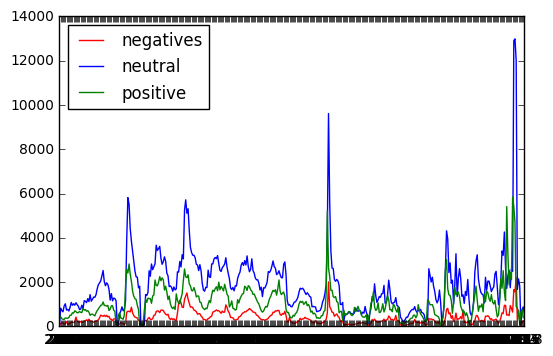

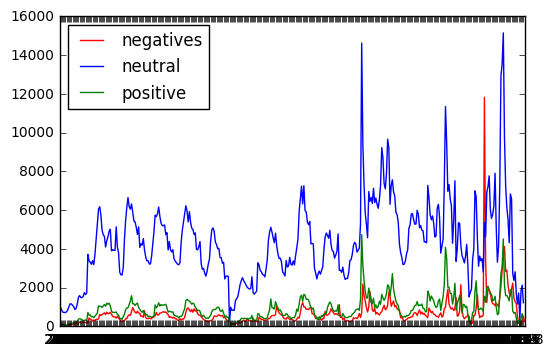

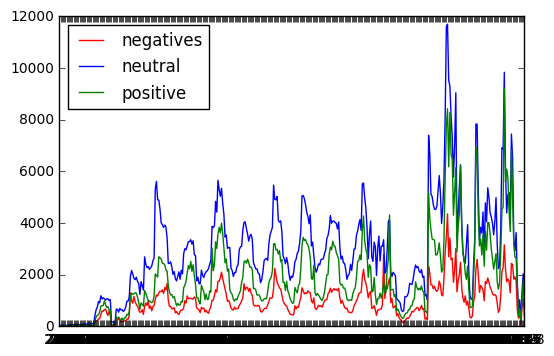

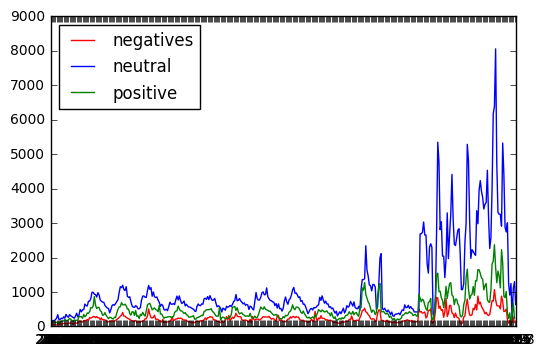

In [2]:
import matplotlib.pyplot as plt
archivo = open("sentiment_analysis_by_platform_summary.txt")
archivo.readline()
archivo.readline()
pos = []
neg = []
neu = []
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] == "pos":
		pos.append([int(line[0]), int(line[1]), int(line[3])])
	elif line[2] == "neg":
		neg.append([int(line[0]), int(line[1]), int(line[3])])
	else:
		neu.append([int(line[0]), int(line[1]), int(line[3])])
x_neg = []
x_neg_name = []
y_neg = []
count = 0
for i in sorted(neg):
	x_neg.append(count)
	x_neg_name.append(str(i[0])+ " " + str(i[1]))
	y_neg.append(i[2])
	count += 1

plt.xticks(x_neg, x_neg_name)
neg_plt = plt.plot(x_neg, y_neg, 'r',label='negatives')

x_neu = []
x_neu_name = []
y_neu = []
count = 0
for i in sorted(neu):
	x_neu.append(count)
	x_neu_name.append(str(i[0])+ " " + str(i[1]))
	y_neu.append(i[2])
	count += 1

plt.xticks(x_neu, x_neu_name)
neu_plt = plt.plot(x_neu, y_neu, 'b',label='neutral')


x_pos = []
x_pos_name = []
y_pos = []
count = 0
for i in sorted(pos):
	x_pos.append(count)
	x_pos_name.append(str(i[0])+ " " + str(i[1]))
	y_pos.append(i[2])
	count += 1

plt.xticks(x_pos, x_pos_name)
pos_plt = plt.plot(x_pos, y_pos, 'g', label='positive')
plt.legend(loc=2)
plt.show()

archivo.readline()
archivo.readline()
pos = []
neg = []
neu = []
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] == "pos":
		pos.append([int(line[0]), int(line[1]), int(line[3])])
	elif line[2] == "neg":
		neg.append([int(line[0]), int(line[1]), int(line[3])])
	else:
		neu.append([int(line[0]), int(line[1]), int(line[3])])
x_neg = []
x_neg_name = []
y_neg = []
count = 0
for i in sorted(neg):
	x_neg.append(count)
	x_neg_name.append(str(i[0])+ " " + str(i[1]))
	y_neg.append(i[2])
	count += 1

plt.xticks(x_neg, x_neg_name)
neg_plt = plt.plot(x_neg, y_neg, 'r',label='negatives')

x_neu = []
x_neu_name = []
y_neu = []
count = 0
for i in sorted(neu):
	x_neu.append(count)
	x_neu_name.append(str(i[0])+ " " + str(i[1]))
	y_neu.append(i[2])
	count += 1

plt.xticks(x_neu, x_neu_name)
neu_plt = plt.plot(x_neu, y_neu, 'b',label='neutral')


x_pos = []
x_pos_name = []
y_pos = []
count = 0
for i in sorted(pos):
	x_pos.append(count)
	x_pos_name.append(str(i[0])+ " " + str(i[1]))
	y_pos.append(i[2])
	count += 1

plt.xticks(x_pos, x_pos_name)
pos_plt = plt.plot(x_pos, y_pos, 'g', label='positive')
plt.legend(loc=2)
plt.show()
archivo.readline()
archivo.readline()
pos = []
neg = []
neu = []
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] == "pos":
		pos.append([int(line[0]), int(line[1]), int(line[3])])
	elif line[2] == "neg":
		neg.append([int(line[0]), int(line[1]), int(line[3])])
	else:
		neu.append([int(line[0]), int(line[1]), int(line[3])])
x_neg = []
x_neg_name = []
y_neg = []
count = 0
for i in sorted(neg):
	x_neg.append(count)
	x_neg_name.append(str(i[0])+ " " + str(i[1]))
	y_neg.append(i[2])
	count += 1

plt.xticks(x_neg, x_neg_name)
neg_plt = plt.plot(x_neg, y_neg, 'r',label='negatives')

x_neu = []
x_neu_name = []
y_neu = []
count = 0
for i in sorted(neu):
	x_neu.append(count)
	x_neu_name.append(str(i[0])+ " " + str(i[1]))
	y_neu.append(i[2])
	count += 1

plt.xticks(x_neu, x_neu_name)
neu_plt = plt.plot(x_neu, y_neu, 'b',label='neutral')


x_pos = []
x_pos_name = []
y_pos = []
count = 0
for i in sorted(pos):
	x_pos.append(count)
	x_pos_name.append(str(i[0])+ " " + str(i[1]))
	y_pos.append(i[2])
	count += 1

plt.xticks(x_pos, x_pos_name)
pos_plt = plt.plot(x_pos, y_pos, 'g', label='positive')
plt.legend(loc=2)
plt.show()
archivo.readline()
archivo.readline()
pos = []
neg = []
neu = []
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] == "pos":
		pos.append([int(line[0]), int(line[1]), int(line[3])])
	elif line[2] == "neg":
		neg.append([int(line[0]), int(line[1]), int(line[3])])
	else:
		neu.append([int(line[0]), int(line[1]), int(line[3])])
x_neg = []
x_neg_name = []
y_neg = []
count = 0
for i in sorted(neg):
	x_neg.append(count)
	x_neg_name.append(str(i[0])+ " " + str(i[1]))
	y_neg.append(i[2])
	count += 1

plt.xticks(x_neg, x_neg_name)
neg_plt = plt.plot(x_neg, y_neg, 'r',label='negatives')

x_neu = []
x_neu_name = []
y_neu = []
count = 0
for i in sorted(neu):
	x_neu.append(count)
	x_neu_name.append(str(i[0])+ " " + str(i[1]))
	y_neu.append(i[2])
	count += 1

plt.xticks(x_neu, x_neu_name)
neu_plt = plt.plot(x_neu, y_neu, 'b',label='neutral')


x_pos = []
x_pos_name = []
y_pos = []
count = 0
for i in sorted(pos):
	x_pos.append(count)
	x_pos_name.append(str(i[0])+ " " + str(i[1]))
	y_pos.append(i[2])
	count += 1

plt.xticks(x_pos, x_pos_name)
pos_plt = plt.plot(x_pos, y_pos, 'g', label='positive')
plt.legend(loc=2)
plt.show()

5.3) We now calculate how many records are from the different languages for each platform with the next script.

In [ ]:
import time
import sys
import language_detect as ld

# The summary is for each hour per week. (i.e. 20 spanish tweets on week 1, 31 english tweets on week 2, ...)

# Important Note: This is just an estimation of the language based on the stopwords, so if no stopwords are found the language
#                   that will produce is garbage, but is not the fault of the model. Also if there are some stopwords of both
#                   languages it will say is the one with most stopwords.

if __name__ == '__main__':
    time_start = time.clock()
    # Clean File.
    open("languages_amount_by_platform_summary.txt", 'w').close()
    files = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data"]
    for _file in files:
        _output_filename = ld.set_language_for_each_tweet(_file)
        # parameters for mrjob.
        # To run your job in multiple subprocesses with a few Hadoop features simulated, use -r local.
        option1 = "" #""-r"
        option2 = "" #""local"
        sys.argv = ['count_language.py', option1, option2, _output_filename]
        # Write to file in append mode.
        _fo = open("languages_amount_by_platform_summary.txt", 'a')
        sys.stdout = _fo
        print _file
        execfile('count_language.py')
        print "\n"

    time_end = time.clock()
    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


In [ ]:
import sys
import json
reload(sys)
sys.setdefaultencoding('utf8')
try:
    from nltk import wordpunct_tokenize
    from nltk.corpus import stopwords
except ImportError:
    print '[!] You need to install nltk (http://nltk.org/index.html)'



#----------------------------------------------------------------------
def _calculate_languages_ratios(text):
    """
    Calculate probability of given text to be written in several languages and
    return a dictionary that looks like {'french': 2, 'spanish': 4, 'english': 0}
    
    @param text: Text whose language want to be detected
    @type text: str
    
    @return: Dictionary with languages and unique stopwords seen in analyzed text
    @rtype: dict
    """

    languages_ratios = {}

    '''
    nltk.wordpunct_tokenize() splits all punctuations into separate tokens
    
    >>> wordpunct_tokenize("That's thirty minutes away. I'll be there in ten.")
    ['That', "'", 's', 'thirty', 'minutes', 'away', '.', 'I', "'", 'll', 'be', 'there', 'in', 'ten', '.']
    '''

    tokens = wordpunct_tokenize(text)
    words = [word.lower() for word in tokens]

    # Compute per language included in nltk number of unique stopwords appearing in analyzed text
    for language in stopwords.fileids():
        stopwords_set = set(stopwords.words(language))
        words_set = set(words)
        common_elements = words_set.intersection(stopwords_set)

        languages_ratios[language] = len(common_elements) # language "score"

    return languages_ratios


#----------------------------------------------------------------------
def detect_language(text):
    """
    Calculate probability of given text to be written in several languages and
    return the highest scored.
    
    It uses a stopwords based approach, counting how many unique stopwords
    are seen in analyzed text.
    
    @param text: Text whose language want to be detected
    @type text: str
    
    @return: Most scored language guessed
    @rtype: str
    """

    ratios = _calculate_languages_ratios(text)

    most_rated_language = max(ratios, key=ratios.get)

    return most_rated_language


def set_language_for_each_tweet(_file):
    _data = open(_file, 'r')
    open(_file[:-5] + "_language.data", 'w').close()
    _output = open(_file[:-5] + "_language.data", 'a')
    for line in _data.readlines():
        record = json.loads(line)
        language = detect_language(record['text'].encode('utf-8'))
        try:
            record.update({'language': language})
            _output.write(json.dumps(record, sort_keys=True) + "\n")
        except:
            # Should not happen.
            print "WTF!"
    _data.close()
    _output.close()
    return _output.name



In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONValueProtocol
from datetime import datetime
import itertools
from datetime import datetime
from dateutil.parser import parse


class MRWordFrequencyCount(MRJob):
    INPUT_PROTOCOL = JSONValueProtocol

    def mapper(self, _, record):
        date = parse(record['created_at'])
        week = date.isocalendar()[1]
        hour = date.hour
        yield [(week, hour, record['language']), 1]

    def reducer(self, key, values):
        yield [key, sum(values)]

    def steps(self):
        return [MRStep(mapper=self.mapper, reducer=self.reducer)]

if __name__ == '__main__':
    MRWordFrequencyCount.run()


**Results**

We only have partial results for the moment beign.

project_tweets01_language.data
[14, 22, "english"]	1
[25, 17, "english"]	1
[26, 0, "danish"]	7
[26, 0, "dutch"]	34
[26, 0, "english"]	792
[26, 0, "finnish"]	22
[26, 0, "french"]	34
[26, 0, "german"]	9
[26, 0, "hungarian"]	63
[26, 0, "italian"]	2
[26, 0, "portuguese"]	254
[26, 0, "spanish"]	92
[26, 0, "swedish"]	152
[26, 1, "danish"]	7
[26, 1, "dutch"]	39
[26, 1, "english"]	636
[26, 1, "finnish"]	21
[26, 1, "french"]	33
[26, 1, "german"]	17
[26, 1, "hungarian"]	56
[26, 1, "italian"]	2
[26, 1, "norwegian"]	1
[26, 1, "portuguese"]	263
[26, 1, "spanish"]	81
[26, 1, "swedish"]	157
[26, 10, "danish"]	34
[26, 10, "dutch"]	18
[26, 10, "english"]	709
[26, 10, "finnish"]	10
[26, 10, "french"]	84
[26, 10, "german"]	39
[26, 10, "hungarian"]	52
[26, 10, "italian"]	23
[26, 10, "norwegian"]	2
[26, 10, "portuguese"]	348
[26, 10, "spanish"]	152
[26, 10, "swedish"]	188
[26, 11, "danish"]	16
[26, 11, "dutch"]	37
[26, 11, "english"]	818
[26, 11, "finnish"]	15
[26, 11, "french"]	92
[26, 11, "german"]	50
[26, 11, "hungarian"]	62
[26, 11, "italian"]	15
[26, 11, "norwegian"]	1
[26, 11, "portuguese"]	375
[26, 11, "spanish"]	164
[26, 11, "swedish"]	170
[26, 12, "danish"]	7
[26, 12, "dutch"]	49
[26, 12, "english"]	854
[26, 12, "finnish"]	21
[26, 12, "french"]	85
[26, 12, "german"]	39
[26, 12, "hungarian"]	51
[26, 12, "italian"]	17
[26, 12, "norwegian"]	3
[26, 12, "portuguese"]	311
[26, 12, "spanish"]	195
[26, 12, "swedish"]	137
[26, 13, "danish"]	17
[26, 13, "dutch"]	31
[26, 13, "english"]	1273
[26, 13, "finnish"]	19
[26, 13, "french"]	90
[26, 13, "german"]	48
[26, 13, "hungarian"]	41
[26, 13, "italian"]	10
[26, 13, "norwegian"]	3
[26, 13, "portuguese"]	352
[26, 13, "spanish"]	182
[26, 13, "swedish"]	134
[26, 14, "danish"]	14
[26, 14, "dutch"]	38
[26, 14, "english"]	1035
[26, 14, "finnish"]	14
[26, 14, "french"]	74
[26, 14, "german"]	55
[26, 14, "hungarian"]	30
[26, 14, "italian"]	11
[26, 14, "norwegian"]	4
[26, 14, "portuguese"]	314
[26, 14, "spanish"]	171
[26, 14, "swedish"]	143
[26, 15, "danish"]	18
[26, 15, "dutch"]	27
[26, 15, "english"]	862
[26, 15, "finnish"]	14
[26, 15, "french"]	71
[26, 15, "german"]	48
[26, 15, "hungarian"]	62
[26, 15, "italian"]	28
[26, 15, "norwegian"]	7
[26, 15, "portuguese"]	323
[26, 15, "spanish"]	158
[26, 15, "swedish"]	115
[26, 16, "danish"]	14
[26, 16, "dutch"]	23
[26, 16, "english"]	860
[26, 16, "finnish"]	12
[26, 16, "french"]	67
[26, 16, "german"]	32
[26, 16, "hungarian"]	33
[26, 16, "italian"]	4
[26, 16, "portuguese"]	283
[26, 16, "spanish"]	147
[26, 16, "swedish"]	97
[26, 17, "danish"]	26
[26, 17, "dutch"]	26
[26, 17, "english"]	936
[26, 17, "finnish"]	9
[26, 17, "french"]	55
[26, 17, "german"]	28
[26, 17, "hungarian"]	40
[26, 17, "italian"]	13
[26, 17, "portuguese"]	318
[26, 17, "spanish"]	148
[26, 17, "swedish"]	87
[26, 17, "turkish"]	1
[26, 18, "danish"]	17
[26, 18, "dutch"]	28
[26, 18, "english"]	871
[26, 18, "finnish"]	10
[26, 18, "french"]	58
[26, 18, "german"]	33
[26, 18, "hungarian"]	47
[26, 18, "italian"]	20
[26, 18, "norwegian"]	2
[26, 18, "portuguese"]	330
[26, 18, "spanish"]	237
[26, 18, "swedish"]	131
[26, 19, "danish"]	12
[26, 19, "dutch"]	26
[26, 19, "english"]	844
[26, 19, "finnish"]	4
[26, 19, "french"]	42
[26, 19, "german"]	19
[26, 19, "hungarian"]	46
[26, 19, "italian"]	7
[26, 19, "norwegian"]	2
[26, 19, "portuguese"]	327
[26, 19, "spanish"]	182
[26, 19, "swedish"]	106
[26, 2, "danish"]	14
[26, 2, "dutch"]	26
[26, 2, "english"]	604
[26, 2, "finnish"]	10
[26, 2, "french"]	30
[26, 2, "german"]	13
[26, 2, "hungarian"]	44
[26, 2, "italian"]	4
[26, 2, "norwegian"]	3
[26, 2, "portuguese"]	217
[26, 2, "spanish"]	66
[26, 2, "swedish"]	137
[26, 20, "danish"]	13
[26, 20, "dutch"]	41
[26, 20, "english"]	1226
[26, 20, "finnish"]	8
[26, 20, "french"]	55
[26, 20, "german"]	11
[26, 20, "hungarian"]	63
[26, 20, "italian"]	15
[26, 20, "norwegian"]	11
[26, 20, "portuguese"]	425
[26, 20, "spanish"]	208
[26, 20, "swedish"]	154
[26, 21, "danish"]	20
[26, 21, "dutch"]	39
[26, 21, "english"]	1120
[26, 21, "finnish"]	11
[26, 21, "french"]	44
[26, 21, "german"]	14
[26, 21, "hungarian"]	85
[26, 21, "italian"]	4
[26, 21, "norwegian"]	4
[26, 21, "portuguese"]	419
[26, 21, "spanish"]	197
[26, 21, "swedish"]	166
[26, 22, "danish"]	13
[26, 22, "dutch"]	27
[26, 22, "english"]	1117
[26, 22, "finnish"]	10
[26, 22, "french"]	59
[26, 22, "german"]	14
[26, 22, "hungarian"]	101
[26, 22, "italian"]	4
[26, 22, "norwegian"]	3
[26, 22, "portuguese"]	402
[26, 22, "spanish"]	219
[26, 22, "swedish"]	167
[26, 23, "danish"]	12
[26, 23, "dutch"]	39
[26, 23, "english"]	1196
[26, 23, "finnish"]	9
[26, 23, "french"]	38
[26, 23, "german"]	12
[26, 23, "hungarian"]	113
[26, 23, "italian"]	6
[26, 23, "norwegian"]	2
[26, 23, "portuguese"]	398
[26, 23, "spanish"]	138
[26, 23, "swedish"]	229
[26, 3, "danish"]	9
[26, 3, "dutch"]	10
[26, 3, "english"]	614
[26, 3, "finnish"]	13
[26, 3, "french"]	57
[26, 3, "german"]	19
[26, 3, "hungarian"]	54
[26, 3, "italian"]	9
[26, 3, "portuguese"]	219
[26, 3, "spanish"]	229
[26, 3, "swedish"]	129
[26, 4, "danish"]	11
[26, 4, "dutch"]	54
[26, 4, "english"]	757
[26, 4, "finnish"]	26
[26, 4, "french"]	61
[26, 4, "german"]	28
[26, 4, "hungarian"]	56
[26, 4, "italian"]	14
[26, 4, "norwegian"]	2
[26, 4, "portuguese"]	244
[26, 4, "spanish"]	70
[26, 4, "swedish"]	145
[26, 5, "danish"]	16
[26, 5, "dutch"]	24
[26, 5, "english"]	640
[26, 5, "finnish"]	23
[26, 5, "french"]	106
[26, 5, "german"]	39
[26, 5, "hungarian"]	48
[26, 5, "italian"]	16
[26, 5, "norwegian"]	2
[26, 5, "portuguese"]	225
[26, 5, "spanish"]	93
[26, 5, "swedish"]	111
[26, 6, "danish"]	14
[26, 6, "dutch"]	57
[26, 6, "english"]	515
[26, 6, "finnish"]	10
[26, 6, "french"]	86
[26, 6, "german"]	50
[26, 6, "hungarian"]	35
[26, 6, "italian"]	9
[26, 6, "norwegian"]	4
[26, 6, "portuguese"]	230
[26, 6, "spanish"]	111
[26, 6, "swedish"]	120
[26, 7, "danish"]	21
[26, 7, "dutch"]	26
[26, 7, "english"]	431
[26, 7, "finnish"]	13
[26, 7, "french"]	97
[26, 7, "german"]	36
[26, 7, "hungarian"]	47
[26, 7, "italian"]	16
[26, 7, "norwegian"]	2
[26, 7, "portuguese"]	231
[26, 7, "spanish"]	95
[26, 7, "swedish"]	152
[26, 8, "danish"]	11
[26, 8, "dutch"]	29
[26, 8, "english"]	593
[26, 8, "finnish"]	11
[26, 8, "french"]	66
[26, 8, "german"]	45
[26, 8, "hungarian"]	46
[26, 8, "italian"]	9
[26, 8, "norwegian"]	2
[26, 8, "portuguese"]	336
[26, 8, "spanish"]	79
[26, 8, "swedish"]	197
[26, 8, "turkish"]	1
[26, 9, "danish"]	21
[26, 9, "dutch"]	49
[26, 9, "english"]	779
[26, 9, "finnish"]	8
[26, 9, "french"]	102
[26, 9, "german"]	34
[26, 9, "hungarian"]	54
[26, 9, "italian"]	41
[26, 9, "portuguese"]	323
[26, 9, "spanish"]	139
[26, 9, "swedish"]	222
[27, 0, "danish"]	23
[27, 0, "dutch"]	45
[27, 0, "english"]	1198
[27, 0, "finnish"]	14
[27, 0, "french"]	59
[27, 0, "german"]	15
[27, 0, "hungarian"]	75
[27, 0, "italian"]	4
[27, 0, "norwegian"]	3
[27, 0, "portuguese"]	398
[27, 0, "spanish"]	146
[27, 0, "swedish"]	181
[27, 1, "danish"]	36
[27, 1, "dutch"]	40
[27, 1, "english"]	1112
[27, 1, "finnish"]	14
[27, 1, "french"]	59
[27, 1, "german"]	31
[27, 1, "hungarian"]	82
[27, 1, "italian"]	6
[27, 1, "norwegian"]	3
[27, 1, "portuguese"]	394
[27, 1, "spanish"]	342
[27, 1, "swedish"]	205
[27, 10, "danish"]	36
[27, 10, "dutch"]	76
[27, 10, "english"]	1475
[27, 10, "finnish"]	29
[27, 10, "french"]	230
[27, 10, "german"]	73
[27, 10, "hungarian"]	84
[27, 10, "italian"]	46
[27, 10, "norwegian"]	6
[27, 10, "portuguese"]	711
[27, 10, "spanish"]	385
[27, 10, "swedish"]	306
[27, 11, "danish"]	80
[27, 11, "dutch"]	71
[27, 11, "english"]	1556
[27, 11, "finnish"]	23
[27, 11, "french"]	208
[27, 11, "german"]	97
[27, 11, "hungarian"]	80
[27, 11, "italian"]	46
[27, 11, "norwegian"]	12
[27, 11, "portuguese"]	711
[27, 11, "spanish"]	486
[27, 11, "swedish"]	348
[27, 11, "turkish"]	1
[27, 12, "danish"]	38
[27, 12, "dutch"]	59
[27, 12, "english"]	1661
[27, 12, "finnish"]	21
[27, 12, "french"]	221
[27, 12, "german"]	88
[27, 12, "hungarian"]	103
[27, 12, "italian"]	44
[27, 12, "norwegian"]	7
[27, 12, "portuguese"]	776
[27, 12, "spanish"]	609
[27, 12, "swedish"]	328
[27, 12, "turkish"]	2
[27, 13, "danish"]	38
[27, 13, "dutch"]	66
[27, 13, "english"]	1761
[27, 13, "finnish"]	20
[27, 13, "french"]	202
[27, 13, "german"]	97
[27, 13, "hungarian"]	71
[27, 13, "italian"]	28
[27, 13, "norwegian"]	4
[27, 13, "portuguese"]	650
[27, 13, "spanish"]	402
[27, 13, "swedish"]	302
[27, 13, "turkish"]	1
[27, 14, "danish"]	32
[27, 14, "dutch"]	71
[27, 14, "english"]	1652
[27, 14, "finnish"]	29
[27, 14, "french"]	193
[27, 14, "german"]	55
[27, 14, "hungarian"]	61
[27, 14, "italian"]	27
[27, 14, "norwegian"]	6
[27, 14, "portuguese"]	607
[27, 14, "spanish"]	276
[27, 14, "swedish"]	222
[27, 15, "danish"]	111
[27, 15, "dutch"]	52
[27, 15, "english"]	1662
[27, 15, "finnish"]	17
[27, 15, "french"]	201
[27, 15, "german"]	88
[27, 15, "hungarian"]	51
[27, 15, "italian"]	33
[27, 15, "norwegian"]	17
[27, 15, "portuguese"]	612
[27, 15, "spanish"]	364
[27, 15, "swedish"]	208
[27, 15, "turkish"]	1
[27, 16, "danish"]	40
[27, 16, "dutch"]	57
[27, 16, "english"]	1583
[27, 16, "finnish"]	14
[27, 16, "french"]	160
[27, 16, "german"]	54
[27, 16, "hungarian"]	48
[27, 16, "italian"]	31
[27, 16, "norwegian"]	5
[27, 16, "portuguese"]	599
[27, 16, "spanish"]	434
[27, 16, "swedish"]	220
[27, 17, "danish"]	41
[27, 17, "dutch"]	62
[27, 17, "english"]	1556
[27, 17, "finnish"]	9
[27, 17, "french"]	157
[27, 17, "german"]	52
[27, 17, "hungarian"]	69
[27, 17, "italian"]	26
[27, 17, "norwegian"]	1
[27, 17, "portuguese"]	593
[27, 17, "spanish"]	322
[27, 17, "swedish"]	198
[27, 17, "turkish"]	1
[27, 18, "danish"]	8
[27, 18, "dutch"]	35
[27, 18, "english"]	1168
[27, 18, "finnish"]	18
[27, 18, "french"]	125
[27, 18, "german"]	25
[27, 18, "hungarian"]	52
[27, 18, "italian"]	8
[27, 18, "norwegian"]	2
[27, 18, "portuguese"]	400
[27, 18, "spanish"]	211
[27, 18, "swedish"]	185
[27, 18, "turkish"]	1
[27, 19, "danish"]	10
[27, 19, "dutch"]	48
[27, 19, "english"]	1447
[27, 19, "finnish"]	12
[27, 19, "french"]	103
[27, 19, "german"]	9
[27, 19, "hungarian"]	55
[27, 19, "italian"]	8
[27, 19, "norwegian"]	2
[27, 19, "portuguese"]	475
[27, 19, "spanish"]	194
[27, 19, "swedish"]	224
[27, 2, "danish"]	14
[27, 2, "dutch"]	33
[27, 2, "english"]	847
[27, 2, "finnish"]	15
[27, 2, "french"]	125
[27, 2, "german"]	34
[27, 2, "hungarian"]	66
[27, 2, "italian"]	22
[27, 2, "norwegian"]	7
[27, 2, "portuguese"]	354
[27, 2, "spanish"]	197
[27, 2, "swedish"]	170
[27, 20, "danish"]	30
[27, 20, "dutch"]	30
[27, 20, "english"]	1251
[27, 20, "finnish"]	17
[27, 20, "french"]	89
[27, 20, "german"]	13
[27, 20, "hungarian"]	42
[27, 20, "italian"]	6
[27, 20, "norwegian"]	3
[27, 20, "portuguese"]	511
[27, 20, "spanish"]	193
[27, 20, "swedish"]	162
[27, 21, "danish"]	21
[27, 21, "dutch"]	34
[27, 21, "english"]	1505
[27, 21, "finnish"]	11
[27, 21, "french"]	72
[27, 21, "german"]	19
[27, 21, "hungarian"]	110
[27, 21, "italian"]	11
[27, 21, "norwegian"]	14
[27, 21, "portuguese"]	411
[27, 21, "spanish"]	157
[27, 21, "swedish"]	182
[27, 22, "danish"]	19
[27, 22, "dutch"]	23
[27, 22, "english"]	1380
[27, 22, "finnish"]	15
[27, 22, "french"]	52
[27, 22, "german"]	11
[27, 22, "hungarian"]	86
[27, 22, "italian"]	6
[27, 22, "norwegian"]	6
[27, 22, "portuguese"]	390
[27, 22, "spanish"]	170
[27, 22, "swedish"]	181
[27, 23, "danish"]	22
[27, 23, "dutch"]	38
[27, 23, "english"]	1160
[27, 23, "finnish"]	10
[27, 23, "french"]	60
[27, 23, "german"]	19
[27, 23, "hungarian"]	105
[27, 23, "italian"]	4
[27, 23, "norwegian"]	3
[27, 23, "portuguese"]	410
[27, 23, "spanish"]	158
[27, 23, "swedish"]	166
[27, 3, "danish"]	19
[27, 3, "dutch"]	37
[27, 3, "english"]	792
[27, 3, "finnish"]	13
[27, 3, "french"]	154
[27, 3, "german"]	49
[27, 3, "hungarian"]	69
[27, 3, "italian"]	32
[27, 3, "norwegian"]	6
[27, 3, "portuguese"]	402
[27, 3, "spanish"]	251
[27, 3, "swedish"]	174
[27, 4, "danish"]	25
[27, 4, "dutch"]	68
[27, 4, "english"]	845
[27, 4, "finnish"]	12
[27, 4, "french"]	161
[27, 4, "german"]	53
[27, 4, "hungarian"]	71
[27, 4, "italian"]	50
[27, 4, "portuguese"]	381
[27, 4, "spanish"]	134
[27, 4, "swedish"]	263
[27, 5, "danish"]	16
[27, 5, "dutch"]	62
[27, 5, "english"]	880
[27, 5, "finnish"]	6
[27, 5, "french"]	185
[27, 5, "german"]	85
[27, 5, "hungarian"]	61
[27, 5, "italian"]	40
[27, 5, "norwegian"]	7
[27, 5, "portuguese"]	372
[27, 5, "spanish"]	160
[27, 5, "swedish"]	187
[27, 5, "turkish"]	1
[27, 6, "danish"]	17
[27, 6, "dutch"]	79
[27, 6, "english"]	769
[27, 6, "finnish"]	7
[27, 6, "french"]	307
[27, 6, "german"]	71
[27, 6, "hungarian"]	54
[27, 6, "italian"]	72
[27, 6, "norwegian"]	8
[27, 6, "portuguese"]	340
[27, 6, "spanish"]	246
[27, 6, "swedish"]	186
[27, 6, "turkish"]	1
[27, 7, "danish"]	133
[27, 7, "dutch"]	69
[27, 7, "english"]	904
[27, 7, "finnish"]	20
[27, 7, "french"]	240
[27, 7, "german"]	75
[27, 7, "hungarian"]	80
[27, 7, "italian"]	35
[27, 7, "norwegian"]	7
[27, 7, "portuguese"]	479
[27, 7, "spanish"]	292
[27, 7, "swedish"]	248
[27, 7, "turkish"]	1
[27, 8, "danish"]	77
[27, 8, "dutch"]	60
[27, 8, "english"]	1084
[27, 8, "finnish"]	21
[27, 8, "french"]	290
[27, 8, "german"]	77
[27, 8, "hungarian"]	85
[27, 8, "italian"]	50
[27, 8, "norwegian"]	4
[27, 8, "portuguese"]	543
[27, 8, "spanish"]	331
[27, 8, "swedish"]	278
[27, 9, "danish"]	74
[27, 9, "dutch"]	70
[27, 9, "english"]	1210
[27, 9, "finnish"]	15
[27, 9, "french"]	230
[27, 9, "german"]	71
[27, 9, "hungarian"]	93
[27, 9, "italian"]	47
[27, 9, "norwegian"]	4
[27, 9, "portuguese"]	657
[27, 9, "spanish"]	351
[27, 9, "swedish"]	329
[27, 9, "turkish"]	1
[28, 0, "danish"]	2
[28, 0, "dutch"]	7
[28, 0, "english"]	141
[28, 0, "french"]	2
[28, 0, "german"]	2
[28, 0, "hungarian"]	8
[28, 0, "portuguese"]	15
[28, 0, "spanish"]	2
[28, 0, "swedish"]	24
[28, 1, "danish"]	2
[28, 1, "dutch"]	5
[28, 1, "english"]	142
[28, 1, "french"]	3
[28, 1, "german"]	1
[28, 1, "hungarian"]	6
[28, 1, "italian"]	1
[28, 1, "portuguese"]	33
[28, 1, "spanish"]	13
[28, 1, "swedish"]	19
[28, 10, "danish"]	45
[28, 10, "dutch"]	78
[28, 10, "english"]	4471
[28, 10, "finnish"]	40
[28, 10, "french"]	412
[28, 10, "german"]	207
[28, 10, "hungarian"]	116
[28, 10, "italian"]	94
[28, 10, "portuguese"]	1217
[28, 10, "spanish"]	1348
[28, 10, "swedish"]	579
[28, 10, "turkish"]	4
[28, 11, "danish"]	53
[28, 11, "dutch"]	66
[28, 11, "english"]	4258
[28, 11, "finnish"]	38
[28, 11, "french"]	391
[28, 11, "german"]	123
[28, 11, "hungarian"]	116
[28, 11, "italian"]	77
[28, 11, "norwegian"]	5
[28, 11, "portuguese"]	1021
[28, 11, "spanish"]	1423
[28, 11, "swedish"]	315
[28, 11, "turkish"]	1
[28, 12, "danish"]	31
[28, 12, "dutch"]	62
[28, 12, "english"]	3457
[28, 12, "finnish"]	33
[28, 12, "french"]	379
[28, 12, "german"]	88
[28, 12, "hungarian"]	80
[28, 12, "italian"]	51
[28, 12, "norwegian"]	8
[28, 12, "portuguese"]	1032
[28, 12, "spanish"]	1541
[28, 12, "swedish"]	306
[28, 12, "turkish"]	4
[28, 13, "danish"]	25
[28, 13, "dutch"]	66
[28, 13, "english"]	3312
[28, 13, "finnish"]	34
[28, 13, "french"]	272
[28, 13, "german"]	117
[28, 13, "hungarian"]	82
[28, 13, "italian"]	58
[28, 13, "norwegian"]	3
[28, 13, "portuguese"]	854
[28, 13, "spanish"]	854
[28, 13, "swedish"]	343
[28, 13, "turkish"]	3
[28, 14, "danish"]	22
[28, 14, "dutch"]	35
[28, 14, "english"]	2575
[28, 14, "finnish"]	21
[28, 14, "french"]	353
[28, 14, "german"]	93
[28, 14, "hungarian"]	109
[28, 14, "italian"]	38
[28, 14, "norwegian"]	5
[28, 14, "portuguese"]	670
[28, 14, "spanish"]	874
[28, 14, "swedish"]	204
[28, 14, "turkish"]	12
[28, 15, "danish"]	29
[28, 15, "dutch"]	48
[28, 15, "english"]	2187
[28, 15, "finnish"]	27
[28, 15, "french"]	250
[28, 15, "german"]	84
[28, 15, "hungarian"]	78
[28, 15, "italian"]	46
[28, 15, "norwegian"]	1
[28, 15, "portuguese"]	619
[28, 15, "spanish"]	706
[28, 15, "swedish"]	209
[28, 15, "turkish"]	2
[28, 16, "danish"]	24
[28, 16, "dutch"]	43
[28, 16, "english"]	2148
[28, 16, "finnish"]	26
[28, 16, "french"]	194
[28, 16, "german"]	86
[28, 16, "hungarian"]	60
[28, 16, "italian"]	21
[28, 16, "portuguese"]	550
[28, 16, "spanish"]	578
[28, 16, "swedish"]	165
[28, 17, "danish"]	23
[28, 17, "dutch"]	35
[28, 17, "english"]	2077
[28, 17, "finnish"]	27
[28, 17, "french"]	162
[28, 17, "german"]	50
[28, 17, "hungarian"]	91
[28, 17, "italian"]	26
[28, 17, "norwegian"]	1
[28, 17, "portuguese"]	551
[28, 17, "spanish"]	578
[28, 17, "swedish"]	202
[28, 18, "danish"]	15
[28, 18, "dutch"]	26
[28, 18, "english"]	1690
[28, 18, "finnish"]	13
[28, 18, "french"]	81
[28, 18, "german"]	34
[28, 18, "hungarian"]	69
[28, 18, "italian"]	21
[28, 18, "norwegian"]	1
[28, 18, "portuguese"]	427
[28, 18, "spanish"]	423
[28, 18, "swedish"]	163
[28, 18, "turkish"]	1
[28, 19, "danish"]	15
[28, 19, "dutch"]	14
[28, 19, "english"]	1688
[28, 19, "finnish"]	14
[28, 19, "french"]	61
[28, 19, "german"]	19
[28, 19, "hungarian"]	49
[28, 19, "italian"]	8
[28, 19, "portuguese"]	443
[28, 19, "spanish"]	394
[28, 19, "swedish"]	175
[28, 19, "turkish"]	1
[28, 2, "danish"]	11
[28, 2, "dutch"]	61
[28, 2, "english"]	655
[28, 2, "finnish"]	9
[28, 2, "french"]	80
[28, 2, "german"]	14
[28, 2, "hungarian"]	35
[28, 2, "italian"]	13
[28, 2, "norwegian"]	1
[28, 2, "portuguese"]	173
[28, 2, "spanish"]	51
[28, 2, "swedish"]	102
[28, 20, "danish"]	2
[28, 20, "dutch"]	8
[28, 20, "english"]	65
[28, 20, "french"]	5
[28, 20, "german"]	2
[28, 20, "hungarian"]	3
[28, 20, "portuguese"]	28
[28, 20, "spanish"]	2
[28, 20, "swedish"]	21
[28, 21, "danish"]	6
[28, 21, "dutch"]	8
[28, 21, "english"]	76
[28, 21, "german"]	1
[28, 21, "hungarian"]	7
[28, 21, "italian"]	1
[28, 21, "norwegian"]	1
[28, 21, "portuguese"]	34
[28, 21, "spanish"]	3
[28, 21, "swedish"]	26
[28, 22, "danish"]	1
[28, 22, "dutch"]	5
[28, 22, "english"]	64
[28, 22, "finnish"]	1
[28, 22, "french"]	4
[28, 22, "hungarian"]	3
[28, 22, "portuguese"]	40
[28, 22, "spanish"]	9
[28, 22, "swedish"]	12
[28, 23, "danish"]	1
[28, 23, "dutch"]	9
[28, 23, "english"]	408
[28, 23, "french"]	4
[28, 23, "german"]	1
[28, 23, "hungarian"]	31
[28, 23, "italian"]	2
[28, 23, "portuguese"]	27
[28, 23, "spanish"]	7
[28, 23, "swedish"]	45
[28, 3, "danish"]	11
[28, 3, "dutch"]	26
[28, 3, "english"]	811
[28, 3, "finnish"]	10
[28, 3, "french"]	90
[28, 3, "german"]	55
[28, 3, "hungarian"]	49
[28, 3, "italian"]	17
[28, 3, "norwegian"]	3
[28, 3, "portuguese"]	151
[28, 3, "spanish"]	137
[28, 3, "swedish"]	125
[28, 3, "turkish"]	1
[28, 4, "danish"]	20
[28, 4, "dutch"]	21
[28, 4, "english"]	547
[28, 4, "finnish"]	9
[28, 4, "french"]	134
[28, 4, "german"]	44
[28, 4, "hungarian"]	143
[28, 4, "italian"]	16
[28, 4, "norwegian"]	9
[28, 4, "portuguese"]	181
[28, 4, "spanish"]	149
[28, 4, "swedish"]	127
[28, 4, "turkish"]	1
[28, 5, "danish"]	12
[28, 5, "dutch"]	27
[28, 5, "english"]	481
[28, 5, "finnish"]	15
[28, 5, "french"]	100
[28, 5, "german"]	34
[28, 5, "hungarian"]	101
[28, 5, "italian"]	14
[28, 5, "norwegian"]	2
[28, 5, "portuguese"]	161
[28, 5, "spanish"]	117
[28, 5, "swedish"]	137
[28, 6, "danish"]	10
[28, 6, "dutch"]	39
[28, 6, "english"]	421
[28, 6, "finnish"]	8
[28, 6, "french"]	96
[28, 6, "german"]	34
[28, 6, "hungarian"]	31
[28, 6, "italian"]	22
[28, 6, "norwegian"]	4
[28, 6, "portuguese"]	164
[28, 6, "spanish"]	237
[28, 6, "swedish"]	100
[28, 6, "turkish"]	2
[28, 7, "danish"]	8
[28, 7, "dutch"]	14
[28, 7, "english"]	1120
[28, 7, "finnish"]	7
[28, 7, "french"]	85
[28, 7, "german"]	35
[28, 7, "hungarian"]	29
[28, 7, "italian"]	16
[28, 7, "norwegian"]	6
[28, 7, "portuguese"]	216
[28, 7, "spanish"]	178
[28, 7, "swedish"]	82
[28, 7, "turkish"]	2
[28, 8, "danish"]	37
[28, 8, "dutch"]	180
[28, 8, "english"]	3206
[28, 8, "finnish"]	26
[28, 8, "french"]	466
[28, 8, "german"]	231
[28, 8, "hungarian"]	79
[28, 8, "italian"]	69
[28, 8, "norwegian"]	17
[28, 8, "portuguese"]	802
[28, 8, "spanish"]	859
[28, 8, "swedish"]	358
[28, 8, "turkish"]	5
[28, 9, "danish"]	51
[28, 9, "dutch"]	83
[28, 9, "english"]	4891
[28, 9, "finnish"]	38
[28, 9, "french"]	658
[28, 9, "german"]	218
[28, 9, "hungarian"]	97
[28, 9, "italian"]	120
[28, 9, "norwegian"]	6
[28, 9, "portuguese"]	1159
[28, 9, "spanish"]	1368
[28, 9, "swedish"]	389
[28, 9, "turkish"]	2
[29, 0, "danish"]	23
[29, 0, "dutch"]	81
[29, 0, "english"]	1117
[29, 0, "finnish"]	18
[29, 0, "french"]	105
[29, 0, "german"]	28
[29, 0, "hungarian"]	101
[29, 0, "italian"]	4
[29, 0, "norwegian"]	4
[29, 0, "portuguese"]	528
[29, 0, "spanish"]	198
[29, 0, "swedish"]	258
[29, 1, "danish"]	21
[29, 1, "dutch"]	44
[29, 1, "english"]	1584
[29, 1, "finnish"]	26
[29, 1, "french"]	97
[29, 1, "german"]	23
[29, 1, "hungarian"]	85
[29, 1, "italian"]	12
[29, 1, "norwegian"]	3
[29, 1, "portuguese"]	575
[29, 1, "spanish"]	169
[29, 1, "swedish"]	247
[29, 10, "danish"]	36
[29, 10, "dutch"]	61
[29, 10, "english"]	2645
[29, 10, "finnish"]	58
[29, 10, "french"]	494
[29, 10, "german"]	107
[29, 10, "hungarian"]	262
[29, 10, "italian"]	63
[29, 10, "norwegian"]	14
[29, 10, "portuguese"]	1093
[29, 10, "spanish"]	680
[29, 10, "swedish"]	479
[29, 11, "danish"]	34
[29, 11, "dutch"]	84
[29, 11, "english"]	2672
[29, 11, "finnish"]	31
[29, 11, "french"]	478
[29, 11, "german"]	104
[29, 11, "hungarian"]	230
[29, 11, "italian"]	67
[29, 11, "norwegian"]	8
[29, 11, "portuguese"]	1035
[29, 11, "spanish"]	795
[29, 11, "swedish"]	501
[29, 12, "danish"]	51
[29, 12, "dutch"]	75
[29, 12, "english"]	3008
[29, 12, "finnish"]	36
[29, 12, "french"]	398
[29, 12, "german"]	118
[29, 12, "hungarian"]	253
[29, 12, "italian"]	76
[29, 12, "norwegian"]	4
[29, 12, "portuguese"]	1153
[29, 12, "spanish"]	683
[29, 12, "swedish"]	381
[29, 13, "danish"]	32
[29, 13, "dutch"]	67
[29, 13, "english"]	3049
[29, 13, "finnish"]	45
[29, 13, "french"]	410
[29, 13, "german"]	123
[29, 13, "hungarian"]	273
[29, 13, "italian"]	37
[29, 13, "norwegian"]	5
[29, 13, "portuguese"]	1111
[29, 13, "spanish"]	629
[29, 13, "swedish"]	285
[29, 13, "turkish"]	1
[29, 14, "danish"]	47
[29, 14, "dutch"]	57
[29, 14, "english"]	3057
[29, 14, "finnish"]	31
[29, 14, "french"]	326
[29, 14, "german"]	79
[29, 14, "hungarian"]	193
[29, 14, "italian"]	37
[29, 14, "norwegian"]	3
[29, 14, "portuguese"]	966
[29, 14, "spanish"]	536
[29, 14, "swedish"]	277
[29, 14, "turkish"]	1
[29, 15, "danish"]	54
[29, 15, "dutch"]	69
[29, 15, "english"]	2922
[29, 15, "finnish"]	29
[29, 15, "french"]	449
[29, 15, "german"]	84
[29, 15, "hungarian"]	185
[29, 15, "italian"]	32
[29, 15, "norwegian"]	5
[29, 15, "portuguese"]	1101
[29, 15, "spanish"]	626
[29, 15, "swedish"]	276
[29, 15, "turkish"]	2
[29, 16, "danish"]	37
[29, 16, "dutch"]	189
[29, 16, "english"]	2900
[29, 16, "finnish"]	42
[29, 16, "french"]	305
[29, 16, "german"]	86
[29, 16, "hungarian"]	258
[29, 16, "italian"]	42
[29, 16, "norwegian"]	4
[29, 16, "portuguese"]	1093
[29, 16, "spanish"]	670
[29, 16, "swedish"]	249
[29, 17, "danish"]	43
[29, 17, "dutch"]	112
[29, 17, "english"]	2509
[29, 17, "finnish"]	33
[29, 17, "french"]	265
[29, 17, "german"]	56
[29, 17, "hungarian"]	234
[29, 17, "italian"]	32
[29, 17, "norwegian"]	9
[29, 17, "portuguese"]	979
[29, 17, "spanish"]	650
[29, 17, "swedish"]	218
[29, 18, "danish"]	33
[29, 18, "dutch"]	59
[29, 18, "english"]	2403
[29, 18, "finnish"]	20
[29, 18, "french"]	197
[29, 18, "german"]	49
[29, 18, "hungarian"]	274
[29, 18, "italian"]	30
[29, 18, "norwegian"]	4
[29, 18, "portuguese"]	896
[29, 18, "spanish"]	512
[29, 18, "swedish"]	266
[29, 19, "danish"]	38
[29, 19, "dutch"]	57
[29, 19, "english"]	2119
[29, 19, "finnish"]	24
[29, 19, "french"]	175
[29, 19, "german"]	26
[29, 19, "hungarian"]	255
[29, 19, "italian"]	28
[29, 19, "norwegian"]	6
[29, 19, "portuguese"]	880
[29, 19, "spanish"]	434
[29, 19, "swedish"]	353
[29, 2, "danish"]	24
[29, 2, "dutch"]	27
[29, 2, "english"]	1592
[29, 2, "finnish"]	25
[29, 2, "french"]	160
[29, 2, "german"]	38
[29, 2, "hungarian"]	74
[29, 2, "italian"]	25
[29, 2, "norwegian"]	4
[29, 2, "portuguese"]	543
[29, 2, "spanish"]	187
[29, 2, "swedish"]	270
[29, 2, "turkish"]	2
[29, 20, "danish"]	26
[29, 20, "dutch"]	47
[29, 20, "english"]	1710
[29, 20, "finnish"]	16
[29, 20, "french"]	105
[29, 20, "german"]	19
[29, 20, "hungarian"]	180
[29, 20, "italian"]	19
[29, 20, "norwegian"]	8
[29, 20, "portuguese"]	698
[29, 20, "spanish"]	316
[29, 20, "swedish"]	244
[29, 20, "turkish"]	1
[29, 21, "danish"]	22
[29, 21, "dutch"]	32
[29, 21, "english"]	1971
[29, 21, "finnish"]	17
[29, 21, "french"]	105
[29, 21, "german"]	16
[29, 21, "hungarian"]	149
[29, 21, "italian"]	9
[29, 21, "norwegian"]	8
[29, 21, "portuguese"]	719
[29, 21, "spanish"]	259
[29, 21, "swedish"]	212
[29, 22, "danish"]	23
[29, 22, "dutch"]	41
[29, 22, "english"]	1554
[29, 22, "finnish"]	18
[29, 22, "french"]	86
[29, 22, "german"]	27
[29, 22, "hungarian"]	154
[29, 22, "italian"]	8
[29, 22, "norwegian"]	9
[29, 22, "portuguese"]	719
[29, 22, "spanish"]	204
[29, 22, "swedish"]	311
[29, 23, "danish"]	22
[29, 23, "dutch"]	50
[29, 23, "english"]	1213
[29, 23, "finnish"]	23
[29, 23, "french"]	135
[29, 23, "german"]	7
[29, 23, "hungarian"]	115
[29, 23, "italian"]	7
[29, 23, "norwegian"]	3
[29, 23, "portuguese"]	686
[29, 23, "spanish"]	252
[29, 23, "swedish"]	254
[29, 3, "danish"]	29
[29, 3, "dutch"]	64
[29, 3, "english"]	1784
[29, 3, "finnish"]	29
[29, 3, "french"]	373
[29, 3, "german"]	84
[29, 3, "hungarian"]	143
[29, 3, "italian"]	39
[29, 3, "norwegian"]	11
[29, 3, "portuguese"]	803
[29, 3, "spanish"]	366
[29, 3, "swedish"]	475
[29, 3, "turkish"]	2
[29, 4, "danish"]	33
[29, 4, "dutch"]	74
[29, 4, "english"]	1507
[29, 4, "finnish"]	25
[29, 4, "french"]	417
[29, 4, "german"]	110
[29, 4, "hungarian"]	112
[29, 4, "italian"]	84
[29, 4, "norwegian"]	4
[29, 4, "portuguese"]	650
[29, 4, "spanish"]	406
[29, 4, "swedish"]	422
[29, 5, "danish"]	32
[29, 5, "dutch"]	54
[29, 5, "english"]	1568
[29, 5, "finnish"]	25
[29, 5, "french"]	550
[29, 5, "german"]	131
[29, 5, "hungarian"]	101
[29, 5, "italian"]	89
[29, 5, "norwegian"]	341
[29, 5, "portuguese"]	647
[29, 5, "spanish"]	467
[29, 5, "swedish"]	389
[29, 5, "turkish"]	1
[29, 6, "danish"]	37
[29, 6, "dutch"]	71
[29, 6, "english"]	1390
[29, 6, "finnish"]	42
[29, 6, "french"]	518
[29, 6, "german"]	148
[29, 6, "hungarian"]	106
[29, 6, "italian"]	56
[29, 6, "norwegian"]	11
[29, 6, "portuguese"]	673
[29, 6, "spanish"]	528
[29, 6, "swedish"]	381
[29, 7, "danish"]	35
[29, 7, "dutch"]	90
[29, 7, "english"]	1917
[29, 7, "finnish"]	39
[29, 7, "french"]	518
[29, 7, "german"]	103
[29, 7, "hungarian"]	130
[29, 7, "italian"]	65
[29, 7, "norwegian"]	6
[29, 7, "portuguese"]	814
[29, 7, "spanish"]	454
[29, 7, "swedish"]	398
[29, 7, "turkish"]	1
[29, 8, "danish"]	28
[29, 8, "dutch"]	45
[29, 8, "english"]	1996
[29, 8, "finnish"]	33
[29, 8, "french"]	506
[29, 8, "german"]	106
[29, 8, "hungarian"]	142
[29, 8, "italian"]	74
[29, 8, "norwegian"]	10
[29, 8, "portuguese"]	876
[29, 8, "spanish"]	491
[29, 8, "swedish"]	458
[29, 8, "turkish"]	4
[29, 9, "danish"]	36
[29, 9, "dutch"]	80
[29, 9, "english"]	2997
[29, 9, "finnish"]	41
[29, 9, "french"]	568
[29, 9, "german"]	91
[29, 9, "hungarian"]	305
[29, 9, "italian"]	56
[29, 9, "norwegian"]	16
[29, 9, "portuguese"]	1109
[29, 9, "spanish"]	599
[29, 9, "swedish"]	537
[29, 9, "turkish"]	1
[30, 0, "danish"]	26
[30, 0, "dutch"]	43
[30, 0, "english"]	1373
[30, 0, "finnish"]	13
[30, 0, "french"]	66
[30, 0, "german"]	33
[30, 0, "hungarian"]	107
[30, 0, "italian"]	7
[30, 0, "norwegian"]	3
[30, 0, "portuguese"]	723
[30, 0, "spanish"]	208
[30, 0, "swedish"]	333
[30, 1, "danish"]	22
[30, 1, "dutch"]	60
[30, 1, "english"]	1244
[30, 1, "finnish"]	16
[30, 1, "french"]	97
[30, 1, "german"]	33
[30, 1, "hungarian"]	109
[30, 1, "italian"]	12
[30, 1, "norwegian"]	3
[30, 1, "portuguese"]	760
[30, 1, "spanish"]	185
[30, 1, "swedish"]	279
[30, 10, "danish"]	53
[30, 10, "dutch"]	126
[30, 10, "english"]	4516
[30, 10, "finnish"]	31
[30, 10, "french"]	695
[30, 10, "german"]	218
[30, 10, "hungarian"]	209
[30, 10, "italian"]	73
[30, 10, "norwegian"]	5
[30, 10, "portuguese"]	1690
[30, 10, "spanish"]	1481
[30, 10, "swedish"]	594
[30, 11, "danish"]	62
[30, 11, "dutch"]	130
[30, 11, "english"]	4338
[30, 11, "finnish"]	42
[30, 11, "french"]	546
[30, 11, "german"]	164
[30, 11, "hungarian"]	170
[30, 11, "italian"]	114
[30, 11, "norwegian"]	5
[30, 11, "portuguese"]	1752
[30, 11, "spanish"]	999
[30, 11, "swedish"]	543
[30, 11, "turkish"]	2
[30, 12, "danish"]	74
[30, 12, "dutch"]	132
[30, 12, "english"]	4501
[30, 12, "finnish"]	39
[30, 12, "french"]	412
[30, 12, "german"]	133
[30, 12, "hungarian"]	370
[30, 12, "italian"]	79
[30, 12, "norwegian"]	6
[30, 12, "portuguese"]	1579
[30, 12, "spanish"]	1015
[30, 12, "swedish"]	415
[30, 12, "turkish"]	2
[30, 13, "danish"]	66
[30, 13, "dutch"]	116
[30, 13, "english"]	4214
[30, 13, "finnish"]	30
[30, 13, "french"]	345
[30, 13, "german"]	147
[30, 13, "hungarian"]	272
[30, 13, "italian"]	65
[30, 13, "norwegian"]	3
[30, 13, "portuguese"]	1413
[30, 13, "spanish"]	730
[30, 13, "swedish"]	343
[30, 14, "danish"]	49
[30, 14, "dutch"]	92
[30, 14, "english"]	3227
[30, 14, "finnish"]	40
[30, 14, "french"]	380
[30, 14, "german"]	131
[30, 14, "hungarian"]	195
[30, 14, "italian"]	44
[30, 14, "norwegian"]	7
[30, 14, "portuguese"]	1218
[30, 14, "spanish"]	679
[30, 14, "swedish"]	303
[30, 15, "danish"]	40
[30, 15, "dutch"]	83
[30, 15, "english"]	2955
[30, 15, "finnish"]	42
[30, 15, "french"]	371
[30, 15, "german"]	126
[30, 15, "hungarian"]	168
[30, 15, "italian"]	49
[30, 15, "norwegian"]	4
[30, 15, "portuguese"]	1299
[30, 15, "spanish"]	593
[30, 15, "swedish"]	319
[30, 15, "turkish"]	1
[30, 16, "danish"]	45
[30, 16, "dutch"]	81
[30, 16, "english"]	2779
[30, 16, "finnish"]	27
[30, 16, "french"]	244
[30, 16, "german"]	108
[30, 16, "hungarian"]	148
[30, 16, "italian"]	46
[30, 16, "norwegian"]	7
[30, 16, "portuguese"]	1186
[30, 16, "spanish"]	746
[30, 16, "swedish"]	267
[30, 16, "turkish"]	2
[30, 17, "danish"]	56
[30, 17, "dutch"]	80
[30, 17, "english"]	2694
[30, 17, "finnish"]	23
[30, 17, "french"]	241
[30, 17, "german"]	108
[30, 17, "hungarian"]	201
[30, 17, "italian"]	53
[30, 17, "norwegian"]	3
[30, 17, "portuguese"]	1311
[30, 17, "spanish"]	515
[30, 17, "swedish"]	273
[30, 17, "turkish"]	1
[30, 18, "danish"]	36
[30, 18, "dutch"]	68
[30, 18, "english"]	2629
[30, 18, "finnish"]	33
[30, 18, "french"]	276
[30, 18, "german"]	78
[30, 18, "hungarian"]	146
[30, 18, "italian"]	33
[30, 18, "norwegian"]	4
[30, 18, "portuguese"]	1331
[30, 18, "spanish"]	589
[30, 18, "swedish"]	346
[30, 18, "turkish"]	5
[30, 19, "danish"]	46
[30, 19, "dutch"]	71
[30, 19, "english"]	2381
[30, 19, "finnish"]	24
[30, 19, "french"]	193
[30, 19, "german"]	57
[30, 19, "hungarian"]	247
[30, 19, "italian"]	24
[30, 19, "norwegian"]	3
[30, 19, "portuguese"]	1211
[30, 19, "spanish"]	470
[30, 19, "swedish"]	328
[30, 19, "turkish"]	5
[30, 2, "danish"]	24
[30, 2, "dutch"]	62
[30, 2, "english"]	1132
[30, 2, "finnish"]	11
[30, 2, "french"]	152
[30, 2, "german"]	49
[30, 2, "hungarian"]	115
[30, 2, "italian"]	13
[30, 2, "norwegian"]	9
[30, 2, "portuguese"]	668
[30, 2, "spanish"]	202
[30, 2, "swedish"]	295
[30, 2, "turkish"]	1
[30, 20, "danish"]	39
[30, 20, "dutch"]	59
[30, 20, "english"]	2278
[30, 20, "finnish"]	14
[30, 20, "french"]	166
[30, 20, "german"]	28
[30, 20, "hungarian"]	185
[30, 20, "italian"]	15
[30, 20, "norwegian"]	2
[30, 20, "portuguese"]	1101
[30, 20, "spanish"]	439
[30, 20, "swedish"]	337
[30, 21, "danish"]	41
[30, 21, "dutch"]	67
[30, 21, "english"]	2108
[30, 21, "finnish"]	12
[30, 21, "french"]	121
[30, 21, "german"]	32
[30, 21, "hungarian"]	241
[30, 21, "italian"]	13
[30, 21, "norwegian"]	4
[30, 21, "portuguese"]	1117
[30, 21, "spanish"]	380
[30, 21, "swedish"]	340
[30, 21, "turkish"]	1
[30, 22, "danish"]	36
[30, 22, "dutch"]	61
[30, 22, "english"]	2362
[30, 22, "finnish"]	17
[30, 22, "french"]	131
[30, 22, "german"]	17
[30, 22, "hungarian"]	283
[30, 22, "italian"]	12
[30, 22, "norwegian"]	10
[30, 22, "portuguese"]	1098
[30, 22, "spanish"]	325
[30, 22, "swedish"]	383
[30, 23, "danish"]	27
[30, 23, "dutch"]	61
[30, 23, "english"]	1897
[30, 23, "finnish"]	20
[30, 23, "french"]	95
[30, 23, "german"]	24
[30, 23, "hungarian"]	162
[30, 23, "italian"]	10
[30, 23, "norwegian"]	7
[30, 23, "portuguese"]	1157
[30, 23, "spanish"]	280
[30, 23, "swedish"]	341
[30, 3, "danish"]	62
[30, 3, "dutch"]	67
[30, 3, "english"]	2062
[30, 3, "finnish"]	33
[30, 3, "french"]	271
[30, 3, "german"]	94
[30, 3, "hungarian"]	105
[30, 3, "italian"]	64
[30, 3, "norwegian"]	21
[30, 3, "portuguese"]	970
[30, 3, "spanish"]	284
[30, 3, "swedish"]	505
[30, 3, "turkish"]	2
[30, 4, "danish"]	48
[30, 4, "dutch"]	103
[30, 4, "english"]	2016
[30, 4, "finnish"]	24
[30, 4, "french"]	492
[30, 4, "german"]	113
[30, 4, "hungarian"]	160
[30, 4, "italian"]	86
[30, 4, "norwegian"]	28
[30, 4, "portuguese"]	809
[30, 4, "spanish"]	363
[30, 4, "swedish"]	428
[30, 5, "danish"]	50
[30, 5, "dutch"]	158
[30, 5, "english"]	2393
[30, 5, "finnish"]	36
[30, 5, "french"]	520
[30, 5, "german"]	117
[30, 5, "hungarian"]	110
[30, 5, "italian"]	67
[30, 5, "norwegian"]	15
[30, 5, "portuguese"]	919
[30, 5, "spanish"]	400
[30, 5, "swedish"]	389
[30, 6, "danish"]	43
[30, 6, "dutch"]	135
[30, 6, "english"]	2096
[30, 6, "finnish"]	35
[30, 6, "french"]	428
[30, 6, "german"]	128
[30, 6, "hungarian"]	150
[30, 6, "italian"]	84
[30, 6, "norwegian"]	13
[30, 6, "portuguese"]	840
[30, 6, "spanish"]	488
[30, 6, "swedish"]	343
[30, 6, "turkish"]	1
[30, 7, "danish"]	41
[30, 7, "dutch"]	119
[30, 7, "english"]	2257
[30, 7, "finnish"]	35
[30, 7, "french"]	318
[30, 7, "german"]	117
[30, 7, "hungarian"]	167
[30, 7, "italian"]	76
[30, 7, "norwegian"]	6
[30, 7, "portuguese"]	1054
[30, 7, "spanish"]	641
[30, 7, "swedish"]	555
[30, 8, "danish"]	35
[30, 8, "dutch"]	123
[30, 8, "english"]	2317
[30, 8, "finnish"]	30
[30, 8, "french"]	334
[30, 8, "german"]	135
[30, 8, "hungarian"]	308
[30, 8, "italian"]	64
[30, 8, "norwegian"]	11
[30, 8, "portuguese"]	1052
[30, 8, "spanish"]	476
[30, 8, "swedish"]	492
[30, 8, "turkish"]	2
[30, 9, "danish"]	65
[30, 9, "dutch"]	110
[30, 9, "english"]	4284
[30, 9, "finnish"]	21
[30, 9, "french"]	618
[30, 9, "german"]	177
[30, 9, "hungarian"]	250
[30, 9, "italian"]	79
[30, 9, "norwegian"]	8
[30, 9, "portuguese"]	1426
[30, 9, "spanish"]	889
[30, 9, "swedish"]	613
[30, 9, "turkish"]	1
[31, 0, "danish"]	37
[31, 0, "dutch"]	56
[31, 0, "english"]	1588
[31, 0, "finnish"]	15
[31, 0, "french"]	70
[31, 0, "german"]	13
[31, 0, "hungarian"]	116
[31, 0, "italian"]	10
[31, 0, "norwegian"]	9
[31, 0, "portuguese"]	832
[31, 0, "spanish"]	247
[31, 0, "swedish"]	455
[31, 1, "danish"]	43
[31, 1, "dutch"]	46
[31, 1, "english"]	1349
[31, 1, "finnish"]	17
[31, 1, "french"]	72
[31, 1, "german"]	36
[31, 1, "hungarian"]	81
[31, 1, "italian"]	12
[31, 1, "norwegian"]	7
[31, 1, "portuguese"]	694
[31, 1, "spanish"]	173
[31, 1, "swedish"]	304
[31, 1, "turkish"]	1
[31, 10, "danish"]	64
[31, 10, "dutch"]	112
[31, 10, "english"]	2464
[31, 10, "finnish"]	28
[31, 10, "french"]	314
[31, 10, "german"]	116
[31, 10, "hungarian"]	131
[31, 10, "italian"]	40
[31, 10, "norwegian"]	11
[31, 10, "portuguese"]	1056
[31, 10, "spanish"]	559
[31, 10, "swedish"]	473
[31, 11, "danish"]	87
[31, 11, "dutch"]	95
[31, 11, "english"]	2425
[31, 11, "finnish"]	46
[31, 11, "french"]	282
[31, 11, "german"]	128
[31, 11, "hungarian"]	119
[31, 11, "italian"]	52
[31, 11, "norwegian"]	9
[31, 11, "portuguese"]	1124
[31, 11, "spanish"]	602
[31, 11, "swedish"]	422
[31, 11, "turkish"]	2
[31, 12, "danish"]	51
[31, 12, "dutch"]	71
[31, 12, "english"]	2698
[31, 12, "finnish"]	30
[31, 12, "french"]	236
[31, 12, "german"]	90
[31, 12, "hungarian"]	121
[31, 12, "italian"]	36
[31, 12, "norwegian"]	10
[31, 12, "portuguese"]	1174
[31, 12, "spanish"]	617
[31, 12, "swedish"]	381
[31, 13, "danish"]	64
[31, 13, "dutch"]	91
[31, 13, "english"]	2677
[31, 13, "finnish"]	25
[31, 13, "french"]	305
[31, 13, "german"]	105
[31, 13, "hungarian"]	137
[31, 13, "italian"]	39
[31, 13, "norwegian"]	6
[31, 13, "portuguese"]	1158
[31, 13, "spanish"]	645
[31, 13, "swedish"]	444
[31, 14, "danish"]	66
[31, 14, "dutch"]	86
[31, 14, "english"]	2654
[31, 14, "finnish"]	33
[31, 14, "french"]	224
[31, 14, "german"]	88
[31, 14, "hungarian"]	123
[31, 14, "italian"]	24
[31, 14, "norwegian"]	6
[31, 14, "portuguese"]	1049
[31, 14, "spanish"]	547
[31, 14, "swedish"]	268
[31, 15, "danish"]	60
[31, 15, "dutch"]	61
[31, 15, "english"]	2570
[31, 15, "finnish"]	40
[31, 15, "french"]	223
[31, 15, "german"]	102
[31, 15, "hungarian"]	139
[31, 15, "italian"]	20
[31, 15, "norwegian"]	6
[31, 15, "portuguese"]	1031
[31, 15, "spanish"]	701
[31, 15, "swedish"]	239
[31, 15, "turkish"]	1
[31, 16, "danish"]	55
[31, 16, "dutch"]	62
[31, 16, "english"]	2308
[31, 16, "finnish"]	27
[31, 16, "french"]	177
[31, 16, "german"]	78
[31, 16, "hungarian"]	128
[31, 16, "italian"]	29
[31, 16, "norwegian"]	5
[31, 16, "portuguese"]	1017
[31, 16, "spanish"]	557
[31, 16, "swedish"]	287
[31, 17, "danish"]	59
[31, 17, "dutch"]	60
[31, 17, "english"]	2634
[31, 17, "finnish"]	55
[31, 17, "french"]	190
[31, 17, "german"]	99
[31, 17, "hungarian"]	122
[31, 17, "italian"]	38
[31, 17, "norwegian"]	2
[31, 17, "portuguese"]	1157
[31, 17, "spanish"]	415
[31, 17, "swedish"]	327
[31, 17, "turkish"]	1
[31, 18, "danish"]	49
[31, 18, "dutch"]	84
[31, 18, "english"]	2366
[31, 18, "finnish"]	36
[31, 18, "french"]	180
[31, 18, "german"]	63
[31, 18, "hungarian"]	148
[31, 18, "italian"]	26
[31, 18, "norwegian"]	6
[31, 18, "portuguese"]	1267
[31, 18, "spanish"]	511
[31, 18, "swedish"]	339
[31, 19, "danish"]	60
[31, 19, "dutch"]	82
[31, 19, "english"]	2381
[31, 19, "finnish"]	14
[31, 19, "french"]	160
[31, 19, "german"]	58
[31, 19, "hungarian"]	139
[31, 19, "italian"]	18
[31, 19, "norwegian"]	4
[31, 19, "portuguese"]	1191
[31, 19, "spanish"]	557
[31, 19, "swedish"]	412
[31, 2, "danish"]	36
[31, 2, "dutch"]	38
[31, 2, "english"]	1179
[31, 2, "finnish"]	13
[31, 2, "french"]	91
[31, 2, "german"]	36
[31, 2, "hungarian"]	80
[31, 2, "italian"]	21
[31, 2, "norwegian"]	8
[31, 2, "portuguese"]	741
[31, 2, "spanish"]	146
[31, 2, "swedish"]	331
[31, 20, "danish"]	65
[31, 20, "dutch"]	73
[31, 20, "english"]	3402
[31, 20, "finnish"]	32
[31, 20, "french"]	155
[31, 20, "german"]	39
[31, 20, "hungarian"]	111
[31, 20, "italian"]	7
[31, 20, "norwegian"]	3
[31, 20, "portuguese"]	1233
[31, 20, "spanish"]	399
[31, 20, "swedish"]	461
[31, 21, "danish"]	42
[31, 21, "dutch"]	71
[31, 21, "english"]	2882
[31, 21, "finnish"]	27
[31, 21, "french"]	162
[31, 21, "german"]	27
[31, 21, "hungarian"]	166
[31, 21, "italian"]	15
[31, 21, "norwegian"]	11
[31, 21, "portuguese"]	1104
[31, 21, "spanish"]	365
[31, 21, "swedish"]	369
[31, 22, "danish"]	36
[31, 22, "dutch"]	72
[31, 22, "english"]	2330
[31, 22, "finnish"]	21
[31, 22, "french"]	122
[31, 22, "german"]	23
[31, 22, "hungarian"]	158
[31, 22, "italian"]	9
[31, 22, "norwegian"]	5
[31, 22, "portuguese"]	1017
[31, 22, "spanish"]	332
[31, 22, "swedish"]	421
[31, 22, "turkish"]	1
[31, 23, "danish"]	60
[31, 23, "dutch"]	65
[31, 23, "english"]	2088
[31, 23, "finnish"]	26
[31, 23, "french"]	95
[31, 23, "german"]	20
[31, 23, "hungarian"]	144
[31, 23, "italian"]	10
[31, 23, "norwegian"]	7
[31, 23, "portuguese"]	943
[31, 23, "spanish"]	289
[31, 23, "swedish"]	375
[31, 3, "danish"]	38
[31, 3, "dutch"]	48
[31, 3, "english"]	1145
[31, 3, "finnish"]	23
[31, 3, "french"]	125
[31, 3, "german"]	62
[31, 3, "hungarian"]	79
[31, 3, "italian"]	17
[31, 3, "norwegian"]	8
[31, 3, "portuguese"]	687
[31, 3, "spanish"]	188
[31, 3, "swedish"]	396
[31, 4, "danish"]	27
[31, 4, "dutch"]	85
[31, 4, "english"]	1120
[31, 4, "finnish"]	29
[31, 4, "french"]	199
[31, 4, "german"]	69
[31, 4, "hungarian"]	94
[31, 4, "italian"]	45
[31, 4, "norwegian"]	5
[31, 4, "portuguese"]	644
[31, 4, "spanish"]	169
[31, 4, "swedish"]	377
[31, 4, "turkish"]	1
[31, 5, "danish"]	41
[31, 5, "dutch"]	466
[31, 5, "english"]	1131
[31, 5, "finnish"]	20
[31, 5, "french"]	260
[31, 5, "german"]	86
[31, 5, "hungarian"]	158
[31, 5, "italian"]	43
[31, 5, "norwegian"]	13
[31, 5, "portuguese"]	763
[31, 5, "spanish"]	249
[31, 5, "swedish"]	464
[31, 5, "turkish"]	2
[31, 6, "danish"]	45
[31, 6, "dutch"]	283
[31, 6, "english"]	1348
[31, 6, "finnish"]	20
[31, 6, "french"]	222
[31, 6, "german"]	102
[31, 6, "hungarian"]	85
[31, 6, "italian"]	55
[31, 6, "norwegian"]	5
[31, 6, "portuguese"]	686
[31, 6, "spanish"]	430
[31, 6, "swedish"]	336
[31, 7, "danish"]	38
[31, 7, "dutch"]	174
[31, 7, "english"]	1591
[31, 7, "finnish"]	26
[31, 7, "french"]	209
[31, 7, "german"]	102
[31, 7, "hungarian"]	134
[31, 7, "italian"]	50
[31, 7, "norwegian"]	9
[31, 7, "portuguese"]	718
[31, 7, "spanish"]	342
[31, 7, "swedish"]	425
[31, 7, "turkish"]	1
[31, 8, "danish"]	44
[31, 8, "dutch"]	132
[31, 8, "english"]	1826
[31, 8, "finnish"]	25
[31, 8, "french"]	278
[31, 8, "german"]	118
[31, 8, "hungarian"]	122
[31, 8, "italian"]	47
[31, 8, "norwegian"]	8
[31, 8, "portuguese"]	985
[31, 8, "spanish"]	352
[31, 8, "swedish"]	429
[31, 8, "turkish"]	1
[31, 9, "danish"]	64
[31, 9, "dutch"]	123
[31, 9, "english"]	2098
[31, 9, "finnish"]	27
[31, 9, "french"]	286
[31, 9, "german"]	129
[31, 9, "hungarian"]	138
[31, 9, "italian"]	60
[31, 9, "norwegian"]	6
[31, 9, "portuguese"]	1079
[31, 9, "spanish"]	505
[31, 9, "swedish"]	391
[31, 9, "turkish"]	1
[32, 0, "danish"]	41
[32, 0, "dutch"]	51
[32, 0, "english"]	1493
[32, 0, "finnish"]	12
[32, 0, "french"]	114
[32, 0, "german"]	24
[32, 0, "hungarian"]	119
[32, 0, "italian"]	11
[32, 0, "norwegian"]	7
[32, 0, "portuguese"]	644
[32, 0, "spanish"]	178
[32, 0, "swedish"]	329
[32, 1, "danish"]	44
[32, 1, "dutch"]	66
[32, 1, "english"]	1474
[32, 1, "finnish"]	19
[32, 1, "french"]	84
[32, 1, "german"]	29
[32, 1, "hungarian"]	152
[32, 1, "italian"]	10
[32, 1, "norwegian"]	6
[32, 1, "portuguese"]	753
[32, 1, "spanish"]	116
[32, 1, "swedish"]	281
[32, 10, "danish"]	35
[32, 10, "dutch"]	68
[32, 10, "english"]	2073
[32, 10, "finnish"]	26
[32, 10, "french"]	282
[32, 10, "german"]	102
[32, 10, "hungarian"]	213
[32, 10, "italian"]	40
[32, 10, "norwegian"]	8
[32, 10, "portuguese"]	1020
[32, 10, "spanish"]	447
[32, 10, "swedish"]	528
[32, 11, "danish"]	41
[32, 11, "dutch"]	90
[32, 11, "english"]	2136
[32, 11, "finnish"]	23
[32, 11, "french"]	278
[32, 11, "german"]	110
[32, 11, "hungarian"]	199
[32, 11, "italian"]	32
[32, 11, "norwegian"]	6
[32, 11, "portuguese"]	1053
[32, 11, "spanish"]	426
[32, 11, "swedish"]	445
[32, 11, "turkish"]	2
[32, 12, "danish"]	37
[32, 12, "dutch"]	69
[32, 12, "english"]	2436
[32, 12, "finnish"]	38
[32, 12, "french"]	228
[32, 12, "german"]	123
[32, 12, "hungarian"]	172
[32, 12, "italian"]	41
[32, 12, "norwegian"]	5
[32, 12, "portuguese"]	978
[32, 12, "spanish"]	597
[32, 12, "swedish"]	404
[32, 13, "danish"]	57
[32, 13, "dutch"]	71
[32, 13, "english"]	2657
[32, 13, "finnish"]	33
[32, 13, "french"]	245
[32, 13, "german"]	124
[32, 13, "hungarian"]	148
[32, 13, "italian"]	31
[32, 13, "norwegian"]	4
[32, 13, "portuguese"]	1040
[32, 13, "spanish"]	497
[32, 13, "swedish"]	344
[32, 13, "turkish"]	1
[32, 14, "danish"]	79
[32, 14, "dutch"]	76
[32, 14, "english"]	2710
[32, 14, "finnish"]	35
[32, 14, "french"]	520
[32, 14, "german"]	109
[32, 14, "hungarian"]	131
[32, 14, "italian"]	36
[32, 14, "norwegian"]	10
[32, 14, "portuguese"]	1078
[32, 14, "spanish"]	551
[32, 14, "swedish"]	327
[32, 15, "danish"]	80
[32, 15, "dutch"]	112
[32, 15, "english"]	2615
[32, 15, "finnish"]	36
[32, 15, "french"]	219
[32, 15, "german"]	89
[32, 15, "hungarian"]	166
[32, 15, "italian"]	22
[32, 15, "norwegian"]	5
[32, 15, "portuguese"]	1042
[32, 15, "spanish"]	345
[32, 15, "swedish"]	349
[32, 16, "danish"]	44
[32, 16, "dutch"]	71
[32, 16, "english"]	2783
[32, 16, "finnish"]	20
[32, 16, "french"]	183
[32, 16, "german"]	100
[32, 16, "hungarian"]	179
[32, 16, "italian"]	35
[32, 16, "norwegian"]	5
[32, 16, "portuguese"]	978
[32, 16, "spanish"]	406
[32, 16, "swedish"]	317
[32, 17, "danish"]	43
[32, 17, "dutch"]	50
[32, 17, "english"]	2807
[32, 17, "finnish"]	19
[32, 17, "french"]	207
[32, 17, "german"]	78
[32, 17, "hungarian"]	144
[32, 17, "italian"]	26
[32, 17, "norwegian"]	10
[32, 17, "portuguese"]	939
[32, 17, "spanish"]	404
[32, 17, "swedish"]	418
[32, 17, "turkish"]	1
[32, 18, "danish"]	60
[32, 18, "dutch"]	49
[32, 18, "english"]	3092
[32, 18, "finnish"]	23
[32, 18, "french"]	227
[32, 18, "german"]	74
[32, 18, "hungarian"]	169
[32, 18, "italian"]	34
[32, 18, "norwegian"]	7
[32, 18, "portuguese"]	964
[32, 18, "spanish"]	413
[32, 18, "swedish"]	313
[32, 19, "danish"]	51
[32, 19, "dutch"]	81
[32, 19, "english"]	2418
[32, 19, "finnish"]	31
[32, 19, "french"]	202
[32, 19, "german"]	47
[32, 19, "hungarian"]	209
[32, 19, "italian"]	16
[32, 19, "norwegian"]	6
[32, 19, "portuguese"]	948
[32, 19, "spanish"]	442
[32, 19, "swedish"]	327
[32, 2, "danish"]	60
[32, 2, "dutch"]	72
[32, 2, "english"]	1356
[32, 2, "finnish"]	6
[32, 2, "french"]	142
[32, 2, "german"]	38
[32, 2, "hungarian"]	156
[32, 2, "italian"]	26
[32, 2, "norwegian"]	3
[32, 2, "portuguese"]	720
[32, 2, "spanish"]	383
[32, 2, "swedish"]	337
[32, 20, "danish"]	35
[32, 20, "dutch"]	77
[32, 20, "english"]	2415
[32, 20, "finnish"]	23
[32, 20, "french"]	115
[32, 20, "german"]	35
[32, 20, "hungarian"]	135
[32, 20, "italian"]	12
[32, 20, "norwegian"]	7
[32, 20, "portuguese"]	970
[32, 20, "spanish"]	346
[32, 20, "swedish"]	326
[32, 20, "turkish"]	1
[32, 21, "danish"]	35
[32, 21, "dutch"]	75
[32, 21, "english"]	2329
[32, 21, "finnish"]	30
[32, 21, "french"]	93
[32, 21, "german"]	26
[32, 21, "hungarian"]	167
[32, 21, "italian"]	12
[32, 21, "norwegian"]	8
[32, 21, "portuguese"]	927
[32, 21, "spanish"]	272
[32, 21, "swedish"]	289
[32, 22, "danish"]	34
[32, 22, "dutch"]	60
[32, 22, "english"]	2082
[32, 22, "finnish"]	16
[32, 22, "french"]	109
[32, 22, "german"]	25
[32, 22, "hungarian"]	199
[32, 22, "italian"]	14
[32, 22, "norwegian"]	7
[32, 22, "portuguese"]	774
[32, 22, "spanish"]	250
[32, 22, "swedish"]	374
[32, 23, "danish"]	32
[32, 23, "dutch"]	62
[32, 23, "english"]	1975
[32, 23, "finnish"]	27
[32, 23, "french"]	88
[32, 23, "german"]	13
[32, 23, "hungarian"]	187
[32, 23, "italian"]	9
[32, 23, "norwegian"]	9
[32, 23, "portuguese"]	770
[32, 23, "spanish"]	201
[32, 23, "swedish"]	435
[32, 3, "danish"]	48
[32, 3, "dutch"]	61
[32, 3, "english"]	1237
[32, 3, "finnish"]	12
[32, 3, "french"]	87
[32, 3, "german"]	66
[32, 3, "hungarian"]	86
[32, 3, "italian"]	33
[32, 3, "norwegian"]	5
[32, 3, "portuguese"]	670
[32, 3, "spanish"]	140
[32, 3, "swedish"]	293
[32, 4, "danish"]	29
[32, 4, "dutch"]	72
[32, 4, "english"]	1043
[32, 4, "finnish"]	8
[32, 4, "french"]	155
[32, 4, "german"]	91
[32, 4, "hungarian"]	143
[32, 4, "italian"]	41
[32, 4, "norwegian"]	3
[32, 4, "portuguese"]	711
[32, 4, "spanish"]	300
[32, 4, "swedish"]	319
[32, 4, "turkish"]	2
[32, 5, "danish"]	27
[32, 5, "dutch"]	56
[32, 5, "english"]	1109
[32, 5, "finnish"]	18
[32, 5, "french"]	224
[32, 5, "german"]	64
[32, 5, "hungarian"]	104
[32, 5, "italian"]	39
[32, 5, "norwegian"]	5
[32, 5, "portuguese"]	642
[32, 5, "spanish"]	253
[32, 5, "swedish"]	334
[32, 5, "turkish"]	1
[32, 6, "danish"]	32
[32, 6, "dutch"]	71
[32, 6, "english"]	1120
[32, 6, "finnish"]	20
[32, 6, "french"]	196
[32, 6, "german"]	90
[32, 6, "hungarian"]	98
[32, 6, "italian"]	35
[32, 6, "norwegian"]	2
[32, 6, "portuguese"]	681
[32, 6, "spanish"]	284
[32, 6, "swedish"]	625
[32, 7, "danish"]	34
[32, 7, "dutch"]	94
[32, 7, "english"]	1666
[32, 7, "finnish"]	23
[32, 7, "french"]	308
[32, 7, "german"]	119
[32, 7, "hungarian"]	126
[32, 7, "italian"]	46
[32, 7, "norwegian"]	6
[32, 7, "portuguese"]	711
[32, 7, "spanish"]	401
[32, 7, "swedish"]	449
[32, 7, "turkish"]	1
[32, 8, "danish"]	37
[32, 8, "dutch"]	80
[32, 8, "english"]	1588
[32, 8, "finnish"]	29
[32, 8, "french"]	244
[32, 8, "german"]	111
[32, 8, "hungarian"]	109
[32, 8, "italian"]	41
[32, 8, "norwegian"]	11
[32, 8, "portuguese"]	820
[32, 8, "spanish"]	393
[32, 8, "swedish"]	494
[32, 8, "turkish"]	1
[32, 9, "danish"]	32
[32, 9, "dutch"]	95
[32, 9, "english"]	1915
[32, 9, "finnish"]	16
[32, 9, "french"]	277
[32, 9, "german"]	108
[32, 9, "hungarian"]	144
[32, 9, "italian"]	67
[32, 9, "norwegian"]	12
[32, 9, "portuguese"]	940
[32, 9, "spanish"]	451
[32, 9, "swedish"]	465
[33, 0, "danish"]	23
[33, 0, "dutch"]	31
[33, 0, "english"]	1720
[33, 0, "finnish"]	24
[33, 0, "french"]	55
[33, 0, "german"]	16
[33, 0, "hungarian"]	110
[33, 0, "italian"]	10
[33, 0, "norwegian"]	2
[33, 0, "portuguese"]	786
[33, 0, "spanish"]	362
[33, 0, "swedish"]	316
[33, 1, "danish"]	35
[33, 1, "dutch"]	61
[33, 1, "english"]	1532
[33, 1, "finnish"]	20
[33, 1, "french"]	69
[33, 1, "german"]	18
[33, 1, "hungarian"]	119
[33, 1, "italian"]	10
[33, 1, "norwegian"]	4
[33, 1, "portuguese"]	693
[33, 1, "spanish"]	153
[33, 1, "swedish"]	307
[33, 10, "danish"]	37
[33, 10, "dutch"]	51
[33, 10, "english"]	1773
[33, 10, "finnish"]	36
[33, 10, "french"]	218
[33, 10, "german"]	161
[33, 10, "hungarian"]	192
[33, 10, "italian"]	48
[33, 10, "norwegian"]	4
[33, 10, "portuguese"]	989
[33, 10, "spanish"]	282
[33, 10, "swedish"]	484
[33, 11, "danish"]	42
[33, 11, "dutch"]	63
[33, 11, "english"]	1949
[33, 11, "finnish"]	30
[33, 11, "french"]	307
[33, 11, "german"]	146
[33, 11, "hungarian"]	162
[33, 11, "italian"]	44
[33, 11, "norwegian"]	6
[33, 11, "portuguese"]	1035
[33, 11, "spanish"]	386
[33, 11, "swedish"]	421
[33, 11, "turkish"]	1
[33, 12, "danish"]	34
[33, 12, "dutch"]	58
[33, 12, "english"]	2263
[33, 12, "finnish"]	53
[33, 12, "french"]	290
[33, 12, "german"]	174
[33, 12, "hungarian"]	202
[33, 12, "italian"]	43
[33, 12, "norwegian"]	7
[33, 12, "portuguese"]	1017
[33, 12, "spanish"]	534
[33, 12, "swedish"]	438
[33, 12, "turkish"]	1
[33, 13, "danish"]	54
[33, 13, "dutch"]	63
[33, 13, "english"]	2395
[33, 13, "finnish"]	22
[33, 13, "french"]	332
[33, 13, "german"]	126
[33, 13, "hungarian"]	136
[33, 13, "italian"]	35
[33, 13, "norwegian"]	4
[33, 13, "portuguese"]	1045
[33, 13, "spanish"]	420
[33, 13, "swedish"]	332
[33, 14, "danish"]	49
[33, 14, "dutch"]	84
[33, 14, "english"]	2422
[33, 14, "finnish"]	52
[33, 14, "french"]	306
[33, 14, "german"]	101
[33, 14, "hungarian"]	147
[33, 14, "italian"]	30
[33, 14, "norwegian"]	2
[33, 14, "portuguese"]	1101
[33, 14, "spanish"]	285
[33, 14, "swedish"]	336
[33, 15, "danish"]	50
[33, 15, "dutch"]	53
[33, 15, "english"]	2478
[33, 15, "finnish"]	34
[33, 15, "french"]	196
[33, 15, "german"]	103
[33, 15, "hungarian"]	128
[33, 15, "italian"]	28
[33, 15, "norwegian"]	4
[33, 15, "portuguese"]	956
[33, 15, "spanish"]	339
[33, 15, "swedish"]	321
[33, 15, "turkish"]	1
[33, 16, "danish"]	55
[33, 16, "dutch"]	46
[33, 16, "english"]	2210
[33, 16, "finnish"]	27
[33, 16, "french"]	177
[33, 16, "german"]	112
[33, 16, "hungarian"]	112
[33, 16, "italian"]	39
[33, 16, "norwegian"]	3
[33, 16, "portuguese"]	1101
[33, 16, "spanish"]	354
[33, 16, "swedish"]	291
[33, 16, "turkish"]	1
[33, 17, "danish"]	46
[33, 17, "dutch"]	84
[33, 17, "english"]	2651
[33, 17, "finnish"]	32
[33, 17, "french"]	198
[33, 17, "german"]	124
[33, 17, "hungarian"]	105
[33, 17, "italian"]	41
[33, 17, "norwegian"]	7
[33, 17, "portuguese"]	1025
[33, 17, "spanish"]	293
[33, 17, "swedish"]	331
[33, 17, "turkish"]	1
[33, 18, "danish"]	49
[33, 18, "dutch"]	81
[33, 18, "english"]	2855
[33, 18, "finnish"]	20
[33, 18, "french"]	159
[33, 18, "german"]	81
[33, 18, "hungarian"]	121
[33, 18, "italian"]	30
[33, 18, "norwegian"]	3
[33, 18, "portuguese"]	1011
[33, 18, "spanish"]	254
[33, 18, "swedish"]	315
[33, 19, "danish"]	49
[33, 19, "dutch"]	46
[33, 19, "english"]	2345
[33, 19, "finnish"]	23
[33, 19, "french"]	141
[33, 19, "german"]	75
[33, 19, "hungarian"]	111
[33, 19, "italian"]	21
[33, 19, "norwegian"]	4
[33, 19, "portuguese"]	898
[33, 19, "spanish"]	308
[33, 19, "swedish"]	266
[33, 2, "danish"]	37
[33, 2, "dutch"]	48
[33, 2, "english"]	1169
[33, 2, "finnish"]	16
[33, 2, "french"]	53
[33, 2, "german"]	36
[33, 2, "hungarian"]	125
[33, 2, "italian"]	11
[33, 2, "norwegian"]	5
[33, 2, "portuguese"]	743
[33, 2, "spanish"]	201
[33, 2, "swedish"]	487
[33, 20, "danish"]	39
[33, 20, "dutch"]	45
[33, 20, "english"]	2113
[33, 20, "finnish"]	16
[33, 20, "french"]	92
[33, 20, "german"]	32
[33, 20, "hungarian"]	117
[33, 20, "italian"]	30
[33, 20, "norwegian"]	4
[33, 20, "portuguese"]	1120
[33, 20, "spanish"]	266
[33, 20, "swedish"]	347
[33, 21, "danish"]	60
[33, 21, "dutch"]	37
[33, 21, "english"]	2228
[33, 21, "finnish"]	34
[33, 21, "french"]	122
[33, 21, "german"]	34
[33, 21, "hungarian"]	137
[33, 21, "italian"]	16
[33, 21, "norwegian"]	4
[33, 21, "portuguese"]	1322
[33, 21, "spanish"]	361
[33, 21, "swedish"]	501
[33, 22, "danish"]	49
[33, 22, "dutch"]	48
[33, 22, "english"]	2390
[33, 22, "finnish"]	30
[33, 22, "french"]	132
[33, 22, "german"]	18
[33, 22, "hungarian"]	148
[33, 22, "italian"]	20
[33, 22, "norwegian"]	6
[33, 22, "portuguese"]	1325
[33, 22, "spanish"]	508
[33, 22, "swedish"]	480
[33, 22, "turkish"]	1
[33, 23, "danish"]	24
[33, 23, "dutch"]	37
[33, 23, "english"]	2087
[33, 23, "finnish"]	23
[33, 23, "french"]	71
[33, 23, "german"]	33
[33, 23, "hungarian"]	130
[33, 23, "italian"]	17
[33, 23, "norwegian"]	3
[33, 23, "portuguese"]	974
[33, 23, "spanish"]	368
[33, 23, "swedish"]	418
[33, 3, "danish"]	19
[33, 3, "dutch"]	29
[33, 3, "english"]	1062
[33, 3, "finnish"]	14
[33, 3, "french"]	87
[33, 3, "german"]	51
[33, 3, "hungarian"]	86
[33, 3, "italian"]	24
[33, 3, "norwegian"]	3
[33, 3, "portuguese"]	613
[33, 3, "spanish"]	103
[33, 3, "swedish"]	264
[33, 3, "turkish"]	1
[33, 4, "danish"]	58
[33, 4, "dutch"]	64
[33, 4, "english"]	995
[33, 4, "finnish"]	14
[33, 4, "french"]	130
[33, 4, "german"]	90
[33, 4, "hungarian"]	122
[33, 4, "italian"]	27
[33, 4, "norwegian"]	9
[33, 4, "portuguese"]	748
[33, 4, "spanish"]	129
[33, 4, "swedish"]	313
[33, 4, "turkish"]	1
[33, 5, "danish"]	26
[33, 5, "dutch"]	63
[33, 5, "english"]	1018
[33, 5, "finnish"]	24
[33, 5, "french"]	199
[33, 5, "german"]	139
[33, 5, "hungarian"]	100
[33, 5, "italian"]	21
[33, 5, "norwegian"]	4
[33, 5, "portuguese"]	633
[33, 5, "spanish"]	207
[33, 5, "swedish"]	271
[33, 5, "turkish"]	2
[33, 6, "danish"]	45
[33, 6, "dutch"]	62
[33, 6, "english"]	1057
[33, 6, "finnish"]	10
[33, 6, "french"]	262
[33, 6, "german"]	149
[33, 6, "hungarian"]	116
[33, 6, "italian"]	37
[33, 6, "norwegian"]	2
[33, 6, "portuguese"]	693
[33, 6, "spanish"]	251
[33, 6, "swedish"]	296
[33, 7, "danish"]	28
[33, 7, "dutch"]	58
[33, 7, "english"]	1108
[33, 7, "finnish"]	29
[33, 7, "french"]	223
[33, 7, "german"]	166
[33, 7, "hungarian"]	88
[33, 7, "italian"]	45
[33, 7, "norwegian"]	5
[33, 7, "portuguese"]	824
[33, 7, "spanish"]	372
[33, 7, "swedish"]	290
[33, 7, "turkish"]	3
[33, 8, "danish"]	44
[33, 8, "dutch"]	73
[33, 8, "english"]	1395
[33, 8, "finnish"]	24
[33, 8, "french"]	212
[33, 8, "german"]	150
[33, 8, "hungarian"]	132
[33, 8, "italian"]	47
[33, 8, "norwegian"]	7
[33, 8, "portuguese"]	845
[33, 8, "spanish"]	423
[33, 8, "swedish"]	373
[33, 8, "turkish"]	1
[33, 9, "danish"]	47
[33, 9, "dutch"]	89
[33, 9, "english"]	1610
[33, 9, "finnish"]	23
[33, 9, "french"]	241
[33, 9, "german"]	134
[33, 9, "hungarian"]	115
[33, 9, "italian"]	51
[33, 9, "norwegian"]	8
[33, 9, "portuguese"]	848
[33, 9, "spanish"]	374
[33, 9, "swedish"]	398
[34, 0, "danish"]	24
[34, 0, "dutch"]	35
[34, 0, "english"]	1011
[34, 0, "finnish"]	15
[34, 0, "french"]	61
[34, 0, "german"]	11
[34, 0, "hungarian"]	68
[34, 0, "italian"]	11
[34, 0, "norwegian"]	3
[34, 0, "portuguese"]	511
[34, 0, "spanish"]	159
[34, 0, "swedish"]	251
[34, 1, "danish"]	20
[34, 1, "dutch"]	17
[34, 1, "english"]	821
[34, 1, "finnish"]	11
[34, 1, "french"]	72
[34, 1, "german"]	14
[34, 1, "hungarian"]	55
[34, 1, "italian"]	6
[34, 1, "norwegian"]	3
[34, 1, "portuguese"]	476
[34, 1, "spanish"]	97
[34, 1, "swedish"]	203
[34, 10, "danish"]	54
[34, 10, "dutch"]	45
[34, 10, "english"]	1112
[34, 10, "finnish"]	13
[34, 10, "french"]	188
[34, 10, "german"]	39
[34, 10, "hungarian"]	73
[34, 10, "italian"]	23
[34, 10, "norwegian"]	3
[34, 10, "portuguese"]	546
[34, 10, "spanish"]	213
[34, 10, "swedish"]	268
[34, 11, "danish"]	28
[34, 11, "dutch"]	36
[34, 11, "english"]	1458
[34, 11, "finnish"]	16
[34, 11, "french"]	157
[34, 11, "german"]	38
[34, 11, "hungarian"]	72
[34, 11, "italian"]	23
[34, 11, "norwegian"]	2
[34, 11, "portuguese"]	750
[34, 11, "spanish"]	284
[34, 11, "swedish"]	234
[34, 11, "turkish"]	2
[34, 12, "danish"]	24
[34, 12, "dutch"]	59
[34, 12, "english"]	1564
[34, 12, "finnish"]	22
[34, 12, "french"]	140
[34, 12, "german"]	39
[34, 12, "hungarian"]	77
[34, 12, "italian"]	24
[34, 12, "norwegian"]	2
[34, 12, "portuguese"]	635
[34, 12, "spanish"]	283
[34, 12, "swedish"]	257
[34, 12, "turkish"]	1
[34, 13, "danish"]	40
[34, 13, "dutch"]	48
[34, 13, "english"]	1563
[34, 13, "finnish"]	12
[34, 13, "french"]	121
[34, 13, "german"]	42
[34, 13, "hungarian"]	74
[34, 13, "italian"]	20
[34, 13, "norwegian"]	3
[34, 13, "portuguese"]	682
[34, 13, "spanish"]	311
[34, 13, "swedish"]	237
[34, 14, "danish"]	27
[34, 14, "dutch"]	46
[34, 14, "english"]	1598
[34, 14, "finnish"]	53
[34, 14, "french"]	116
[34, 14, "german"]	45
[34, 14, "hungarian"]	49
[34, 14, "italian"]	28
[34, 14, "norwegian"]	2
[34, 14, "portuguese"]	684
[34, 14, "spanish"]	332
[34, 14, "swedish"]	162
[34, 14, "turkish"]	1
[34, 15, "danish"]	44
[34, 15, "dutch"]	54
[34, 15, "english"]	1497
[34, 15, "finnish"]	33
[34, 15, "french"]	100
[34, 15, "german"]	60
[34, 15, "hungarian"]	66
[34, 15, "italian"]	29
[34, 15, "norwegian"]	1
[34, 15, "portuguese"]	655
[34, 15, "spanish"]	250
[34, 15, "swedish"]	158
[34, 16, "danish"]	27
[34, 16, "dutch"]	24
[34, 16, "english"]	1422
[34, 16, "finnish"]	17
[34, 16, "french"]	91
[34, 16, "german"]	41
[34, 16, "hungarian"]	58
[34, 16, "italian"]	24
[34, 16, "norwegian"]	3
[34, 16, "portuguese"]	733
[34, 16, "spanish"]	262
[34, 16, "swedish"]	156
[34, 16, "turkish"]	1
[34, 17, "danish"]	22
[34, 17, "dutch"]	53
[34, 17, "english"]	1645
[34, 17, "finnish"]	17
[34, 17, "french"]	85
[34, 17, "german"]	43
[34, 17, "hungarian"]	61
[34, 17, "italian"]	21
[34, 17, "portuguese"]	647
[34, 17, "spanish"]	249
[34, 17, "swedish"]	159
[34, 18, "danish"]	19
[34, 18, "dutch"]	30
[34, 18, "english"]	1408
[34, 18, "finnish"]	13
[34, 18, "french"]	65
[34, 18, "german"]	35
[34, 18, "hungarian"]	64
[34, 18, "italian"]	15
[34, 18, "norwegian"]	1
[34, 18, "portuguese"]	660
[34, 18, "spanish"]	222
[34, 18, "swedish"]	185
[34, 19, "danish"]	29
[34, 19, "dutch"]	30
[34, 19, "english"]	1377
[34, 19, "finnish"]	20
[34, 19, "french"]	73
[34, 19, "german"]	19
[34, 19, "hungarian"]	63
[34, 19, "italian"]	25
[34, 19, "norwegian"]	4
[34, 19, "portuguese"]	663
[34, 19, "spanish"]	169
[34, 19, "swedish"]	184
[34, 2, "danish"]	16
[34, 2, "dutch"]	23
[34, 2, "english"]	1156
[34, 2, "finnish"]	3
[34, 2, "french"]	56
[34, 2, "german"]	12
[34, 2, "hungarian"]	62
[34, 2, "italian"]	9
[34, 2, "norwegian"]	3
[34, 2, "portuguese"]	449
[34, 2, "spanish"]	72
[34, 2, "swedish"]	179
[34, 2, "turkish"]	1
[34, 20, "danish"]	23
[34, 20, "dutch"]	48
[34, 20, "english"]	1267
[34, 20, "finnish"]	15
[34, 20, "french"]	51
[34, 20, "german"]	13
[34, 20, "hungarian"]	62
[34, 20, "italian"]	14
[34, 20, "norwegian"]	1
[34, 20, "portuguese"]	611
[34, 20, "spanish"]	183
[34, 20, "swedish"]	188
[34, 20, "turkish"]	1
[34, 21, "danish"]	18
[34, 21, "dutch"]	16
[34, 21, "english"]	832
[34, 21, "finnish"]	12
[34, 21, "french"]	47
[34, 21, "german"]	9
[34, 21, "hungarian"]	39
[34, 21, "italian"]	4
[34, 21, "norwegian"]	2
[34, 21, "portuguese"]	490
[34, 21, "spanish"]	86
[34, 21, "swedish"]	144
[34, 22, "danish"]	16
[34, 22, "dutch"]	29
[34, 22, "english"]	839
[34, 22, "finnish"]	10
[34, 22, "french"]	42
[34, 22, "german"]	10
[34, 22, "hungarian"]	58
[34, 22, "italian"]	4
[34, 22, "norwegian"]	1
[34, 22, "portuguese"]	460
[34, 22, "spanish"]	178
[34, 22, "swedish"]	145
[34, 23, "danish"]	22
[34, 23, "dutch"]	27
[34, 23, "english"]	784
[34, 23, "finnish"]	8
[34, 23, "french"]	47
[34, 23, "german"]	14
[34, 23, "hungarian"]	76
[34, 23, "italian"]	6
[34, 23, "norwegian"]	2
[34, 23, "portuguese"]	371
[34, 23, "spanish"]	105
[34, 23, "swedish"]	137
[34, 3, "danish"]	23
[34, 3, "dutch"]	20
[34, 3, "english"]	728
[34, 3, "finnish"]	8
[34, 3, "french"]	61
[34, 3, "german"]	17
[34, 3, "hungarian"]	46
[34, 3, "italian"]	12
[34, 3, "norwegian"]	3
[34, 3, "portuguese"]	428
[34, 3, "spanish"]	75
[34, 3, "swedish"]	154
[34, 4, "danish"]	12
[34, 4, "dutch"]	18
[34, 4, "english"]	660
[34, 4, "finnish"]	5
[34, 4, "french"]	85
[34, 4, "german"]	40
[34, 4, "hungarian"]	52
[34, 4, "italian"]	22
[34, 4, "portuguese"]	342
[34, 4, "spanish"]	74
[34, 4, "swedish"]	142
[34, 5, "danish"]	24
[34, 5, "dutch"]	37
[34, 5, "english"]	576
[34, 5, "finnish"]	13
[34, 5, "french"]	118
[34, 5, "german"]	31
[34, 5, "hungarian"]	58
[34, 5, "italian"]	26
[34, 5, "norwegian"]	1
[34, 5, "portuguese"]	346
[34, 5, "spanish"]	85
[34, 5, "swedish"]	207
[34, 6, "danish"]	31
[34, 6, "dutch"]	30
[34, 6, "english"]	656
[34, 6, "finnish"]	19
[34, 6, "french"]	91
[34, 6, "german"]	44
[34, 6, "hungarian"]	54
[34, 6, "italian"]	42
[34, 6, "portuguese"]	473
[34, 6, "spanish"]	112
[34, 6, "swedish"]	181
[34, 6, "turkish"]	2
[34, 7, "danish"]	25
[34, 7, "dutch"]	40
[34, 7, "english"]	573
[34, 7, "finnish"]	13
[34, 7, "french"]	120
[34, 7, "german"]	50
[34, 7, "hungarian"]	36
[34, 7, "italian"]	41
[34, 7, "portuguese"]	501
[34, 7, "spanish"]	133
[34, 7, "swedish"]	199
[34, 7, "turkish"]	1
[34, 8, "danish"]	22
[34, 8, "dutch"]	39
[34, 8, "english"]	742
[34, 8, "finnish"]	16
[34, 8, "french"]	93
[34, 8, "german"]	56
[34, 8, "hungarian"]	63
[34, 8, "italian"]	30
[34, 8, "norwegian"]	4
[34, 8, "portuguese"]	467
[34, 8, "spanish"]	146
[34, 8, "swedish"]	289
[34, 9, "danish"]	28
[34, 9, "dutch"]	76
[34, 9, "english"]	909
[34, 9, "finnish"]	13
[34, 9, "french"]	101
[34, 9, "german"]	31
[34, 9, "hungarian"]	65
[34, 9, "italian"]	28
[34, 9, "norwegian"]	4
[34, 9, "portuguese"]	523
[34, 9, "spanish"]	176
[34, 9, "swedish"]	225
[35, 0, "danish"]	20
[35, 0, "dutch"]	35
[35, 0, "english"]	883
[35, 0, "finnish"]	7
[35, 0, "french"]	64
[35, 0, "german"]	9
[35, 0, "hungarian"]	66
[35, 0, "italian"]	3
[35, 0, "norwegian"]	2
[35, 0, "portuguese"]	390
[35, 0, "spanish"]	94
[35, 0, "swedish"]	174
[35, 1, "danish"]	17
[35, 1, "dutch"]	15
[35, 1, "english"]	620
[35, 1, "finnish"]	8
[35, 1, "french"]	29
[35, 1, "german"]	11
[35, 1, "hungarian"]	42
[35, 1, "portuguese"]	428
[35, 1, "spanish"]	84
[35, 1, "swedish"]	119
[35, 10, "danish"]	65
[35, 10, "dutch"]	65
[35, 10, "english"]	2864
[35, 10, "finnish"]	35
[35, 10, "french"]	330
[35, 10, "german"]	149
[35, 10, "hungarian"]	411
[35, 10, "italian"]	74
[35, 10, "norwegian"]	16
[35, 10, "portuguese"]	952
[35, 10, "spanish"]	606
[35, 10, "swedish"]	805
[35, 10, "turkish"]	1
[35, 11, "danish"]	157
[35, 11, "dutch"]	174
[35, 11, "english"]	8067
[35, 11, "finnish"]	100
[35, 11, "french"]	1072
[35, 11, "german"]	340
[35, 11, "hungarian"]	1652
[35, 11, "italian"]	84
[35, 11, "norwegian"]	7
[35, 11, "portuguese"]	1812
[35, 11, "spanish"]	1853
[35, 11, "swedish"]	1505
[35, 11, "turkish"]	2
[35, 12, "danish"]	113
[35, 12, "dutch"]	136
[35, 12, "english"]	4452
[35, 12, "finnish"]	35
[35, 12, "french"]	487
[35, 12, "german"]	157
[35, 12, "hungarian"]	746
[35, 12, "italian"]	70
[35, 12, "norwegian"]	17
[35, 12, "portuguese"]	1313
[35, 12, "spanish"]	1073
[35, 12, "swedish"]	521
[35, 12, "turkish"]	1
[35, 13, "danish"]	74
[35, 13, "dutch"]	78
[35, 13, "english"]	3057
[35, 13, "finnish"]	64
[35, 13, "french"]	382
[35, 13, "german"]	149
[35, 13, "hungarian"]	318
[35, 13, "italian"]	55
[35, 13, "norwegian"]	12
[35, 13, "portuguese"]	1114
[35, 13, "spanish"]	755
[35, 13, "swedish"]	395
[35, 14, "danish"]	41
[35, 14, "dutch"]	121
[35, 14, "english"]	2498
[35, 14, "finnish"]	50
[35, 14, "french"]	235
[35, 14, "german"]	109
[35, 14, "hungarian"]	177
[35, 14, "italian"]	45
[35, 14, "norwegian"]	5
[35, 14, "portuguese"]	893
[35, 14, "spanish"]	474
[35, 14, "swedish"]	262
[35, 14, "turkish"]	1
[35, 15, "danish"]	38
[35, 15, "dutch"]	51
[35, 15, "english"]	2535
[35, 15, "finnish"]	35
[35, 15, "french"]	243
[35, 15, "german"]	86
[35, 15, "hungarian"]	169
[35, 15, "italian"]	28
[35, 15, "norwegian"]	5
[35, 15, "portuguese"]	709
[35, 15, "spanish"]	745
[35, 15, "swedish"]	241
[35, 15, "turkish"]	2
[35, 16, "danish"]	45
[35, 16, "dutch"]	59
[35, 16, "english"]	1979
[35, 16, "finnish"]	45
[35, 16, "french"]	216
[35, 16, "german"]	60
[35, 16, "hungarian"]	110
[35, 16, "italian"]	29
[35, 16, "norwegian"]	4
[35, 16, "portuguese"]	657
[35, 16, "spanish"]	508
[35, 16, "swedish"]	206
[35, 17, "danish"]	42
[35, 17, "dutch"]	56
[35, 17, "english"]	1983
[35, 17, "finnish"]	52
[35, 17, "french"]	159
[35, 17, "german"]	68
[35, 17, "hungarian"]	146
[35, 17, "italian"]	21
[35, 17, "norwegian"]	2
[35, 17, "portuguese"]	760
[35, 17, "spanish"]	402
[35, 17, "swedish"]	171
[35, 18, "danish"]	51
[35, 18, "dutch"]	50
[35, 18, "english"]	2209
[35, 18, "finnish"]	55
[35, 18, "french"]	124
[35, 18, "german"]	67
[35, 18, "hungarian"]	181
[35, 18, "italian"]	20
[35, 18, "norwegian"]	6
[35, 18, "portuguese"]	715
[35, 18, "spanish"]	336
[35, 18, "swedish"]	222
[35, 19, "danish"]	32
[35, 19, "dutch"]	47
[35, 19, "english"]	1668
[35, 19, "finnish"]	41
[35, 19, "french"]	186
[35, 19, "german"]	37
[35, 19, "hungarian"]	194
[35, 19, "italian"]	32
[35, 19, "norwegian"]	2
[35, 19, "portuguese"]	783
[35, 19, "spanish"]	379
[35, 19, "swedish"]	228
[35, 2, "danish"]	22
[35, 2, "dutch"]	15
[35, 2, "english"]	486
[35, 2, "finnish"]	7
[35, 2, "french"]	25
[35, 2, "german"]	12
[35, 2, "hungarian"]	59
[35, 2, "italian"]	3
[35, 2, "portuguese"]	385
[35, 2, "spanish"]	57
[35, 2, "swedish"]	128
[35, 20, "danish"]	25
[35, 20, "dutch"]	61
[35, 20, "english"]	1585
[35, 20, "finnish"]	38
[35, 20, "french"]	103
[35, 20, "german"]	20
[35, 20, "hungarian"]	177
[35, 20, "italian"]	13
[35, 20, "norwegian"]	7
[35, 20, "portuguese"]	817
[35, 20, "spanish"]	248
[35, 20, "swedish"]	245
[35, 21, "danish"]	21
[35, 21, "dutch"]	28
[35, 21, "english"]	920
[35, 21, "finnish"]	7
[35, 21, "french"]	44
[35, 21, "german"]	11
[35, 21, "hungarian"]	76
[35, 21, "italian"]	5
[35, 21, "norwegian"]	3
[35, 21, "portuguese"]	442
[35, 21, "spanish"]	121
[35, 21, "swedish"]	157
[35, 22, "danish"]	29
[35, 22, "dutch"]	39
[35, 22, "english"]	892
[35, 22, "finnish"]	16
[35, 22, "french"]	38
[35, 22, "german"]	6
[35, 22, "hungarian"]	75
[35, 22, "italian"]	4
[35, 22, "norwegian"]	2
[35, 22, "portuguese"]	501
[35, 22, "spanish"]	115
[35, 22, "swedish"]	194
[35, 23, "danish"]	24
[35, 23, "dutch"]	20
[35, 23, "english"]	919
[35, 23, "finnish"]	10
[35, 23, "french"]	58
[35, 23, "german"]	9
[35, 23, "hungarian"]	83
[35, 23, "italian"]	3
[35, 23, "norwegian"]	1
[35, 23, "portuguese"]	566
[35, 23, "spanish"]	139
[35, 23, "swedish"]	178
[35, 3, "danish"]	23
[35, 3, "dutch"]	17
[35, 3, "english"]	508
[35, 3, "finnish"]	13
[35, 3, "french"]	66
[35, 3, "german"]	24
[35, 3, "hungarian"]	43
[35, 3, "italian"]	7
[35, 3, "norwegian"]	2
[35, 3, "portuguese"]	332
[35, 3, "spanish"]	71
[35, 3, "swedish"]	135
[35, 3, "turkish"]	1
[35, 4, "danish"]	11
[35, 4, "dutch"]	22
[35, 4, "english"]	468
[35, 4, "finnish"]	7
[35, 4, "french"]	76
[35, 4, "german"]	15
[35, 4, "hungarian"]	37
[35, 4, "italian"]	32
[35, 4, "norwegian"]	2
[35, 4, "portuguese"]	342
[35, 4, "spanish"]	88
[35, 4, "swedish"]	119
[35, 5, "danish"]	17
[35, 5, "dutch"]	16
[35, 5, "english"]	482
[35, 5, "finnish"]	7
[35, 5, "french"]	125
[35, 5, "german"]	32
[35, 5, "hungarian"]	63
[35, 5, "italian"]	39
[35, 5, "norwegian"]	2
[35, 5, "portuguese"]	349
[35, 5, "spanish"]	116
[35, 5, "swedish"]	130
[35, 6, "danish"]	14
[35, 6, "dutch"]	28
[35, 6, "english"]	624
[35, 6, "finnish"]	9
[35, 6, "french"]	111
[35, 6, "german"]	33
[35, 6, "hungarian"]	50
[35, 6, "italian"]	42
[35, 6, "norwegian"]	2
[35, 6, "portuguese"]	482
[35, 6, "spanish"]	186
[35, 6, "swedish"]	193
[35, 6, "turkish"]	1
[35, 7, "danish"]	16
[35, 7, "dutch"]	31
[35, 7, "english"]	713
[35, 7, "finnish"]	13
[35, 7, "french"]	146
[35, 7, "german"]	57
[35, 7, "hungarian"]	55
[35, 7, "italian"]	38
[35, 7, "norwegian"]	2
[35, 7, "portuguese"]	461
[35, 7, "spanish"]	208
[35, 7, "swedish"]	183
[35, 8, "danish"]	34
[35, 8, "dutch"]	50
[35, 8, "english"]	1005
[35, 8, "finnish"]	24
[35, 8, "french"]	135
[35, 8, "german"]	58
[35, 8, "hungarian"]	82
[35, 8, "italian"]	30
[35, 8, "norwegian"]	4
[35, 8, "portuguese"]	511
[35, 8, "spanish"]	248
[35, 8, "swedish"]	241
[35, 9, "danish"]	31
[35, 9, "dutch"]	38
[35, 9, "english"]	1264
[35, 9, "finnish"]	19
[35, 9, "french"]	152
[35, 9, "german"]	68
[35, 9, "hungarian"]	98
[35, 9, "italian"]	29
[35, 9, "norwegian"]	6
[35, 9, "portuguese"]	589
[35, 9, "spanish"]	371
[35, 9, "swedish"]	259
[36, 0, "danish"]	8
[36, 0, "dutch"]	5
[36, 0, "english"]	269
[36, 0, "finnish"]	4
[36, 0, "french"]	39
[36, 0, "german"]	4
[36, 0, "hungarian"]	43
[36, 0, "norwegian"]	1
[36, 0, "portuguese"]	113
[36, 0, "spanish"]	27
[36, 0, "swedish"]	32
[36, 1, "danish"]	12
[36, 1, "dutch"]	16
[36, 1, "english"]	735
[36, 1, "finnish"]	10
[36, 1, "french"]	106
[36, 1, "german"]	12
[36, 1, "hungarian"]	79
[36, 1, "italian"]	6
[36, 1, "norwegian"]	9
[36, 1, "portuguese"]	233
[36, 1, "spanish"]	74
[36, 1, "swedish"]	128
[36, 10, "danish"]	12
[36, 10, "dutch"]	34
[36, 10, "english"]	756
[36, 10, "finnish"]	9
[36, 10, "french"]	202
[36, 10, "german"]	25
[36, 10, "hungarian"]	75
[36, 10, "italian"]	11
[36, 10, "norwegian"]	13
[36, 10, "portuguese"]	268
[36, 10, "spanish"]	219
[36, 10, "swedish"]	183
[36, 10, "turkish"]	1
[36, 11, "danish"]	8
[36, 11, "dutch"]	24
[36, 11, "english"]	717
[36, 11, "finnish"]	10
[36, 11, "french"]	113
[36, 11, "german"]	25
[36, 11, "hungarian"]	55
[36, 11, "italian"]	11
[36, 11, "norwegian"]	10
[36, 11, "portuguese"]	231
[36, 11, "spanish"]	161
[36, 11, "swedish"]	153
[36, 12, "danish"]	23
[36, 12, "dutch"]	23
[36, 12, "english"]	717
[36, 12, "finnish"]	4
[36, 12, "french"]	106
[36, 12, "german"]	28
[36, 12, "hungarian"]	78
[36, 12, "italian"]	15
[36, 12, "norwegian"]	3
[36, 12, "portuguese"]	277
[36, 12, "spanish"]	205
[36, 12, "swedish"]	65
[36, 13, "danish"]	21
[36, 13, "dutch"]	25
[36, 13, "english"]	948
[36, 13, "finnish"]	8
[36, 13, "french"]	95
[36, 13, "german"]	27
[36, 13, "hungarian"]	35
[36, 13, "italian"]	6
[36, 13, "norwegian"]	1
[36, 13, "portuguese"]	354
[36, 13, "spanish"]	182
[36, 13, "swedish"]	112
[36, 13, "turkish"]	1
[36, 14, "danish"]	20
[36, 14, "dutch"]	23
[36, 14, "english"]	835
[36, 14, "finnish"]	2
[36, 14, "french"]	73
[36, 14, "german"]	26
[36, 14, "hungarian"]	25
[36, 14, "italian"]	13
[36, 14, "norwegian"]	2
[36, 14, "portuguese"]	326
[36, 14, "spanish"]	142
[36, 14, "swedish"]	92
[36, 15, "danish"]	7
[36, 15, "dutch"]	12
[36, 15, "english"]	788
[36, 15, "finnish"]	12
[36, 15, "french"]	61
[36, 15, "german"]	22
[36, 15, "hungarian"]	15
[36, 15, "italian"]	7
[36, 15, "norwegian"]	4
[36, 15, "portuguese"]	256
[36, 15, "spanish"]	127
[36, 15, "swedish"]	73
[36, 16, "danish"]	10
[36, 16, "dutch"]	24
[36, 16, "english"]	641
[36, 16, "finnish"]	4
[36, 16, "french"]	53
[36, 16, "german"]	19
[36, 16, "hungarian"]	48
[36, 16, "italian"]	4
[36, 16, "portuguese"]	246
[36, 16, "spanish"]	180
[36, 16, "swedish"]	90
[36, 17, "danish"]	24
[36, 17, "dutch"]	12
[36, 17, "english"]	548
[36, 17, "finnish"]	8
[36, 17, "french"]	57
[36, 17, "german"]	23
[36, 17, "hungarian"]	41
[36, 17, "italian"]	12
[36, 17, "norwegian"]	2
[36, 17, "portuguese"]	262
[36, 17, "spanish"]	131
[36, 17, "swedish"]	63
[36, 18, "danish"]	22
[36, 18, "dutch"]	16
[36, 18, "english"]	889
[36, 18, "finnish"]	4
[36, 18, "french"]	55
[36, 18, "german"]	21
[36, 18, "hungarian"]	18
[36, 18, "italian"]	3
[36, 18, "norwegian"]	4
[36, 18, "portuguese"]	205
[36, 18, "spanish"]	158
[36, 18, "swedish"]	61
[36, 19, "danish"]	6
[36, 19, "dutch"]	26
[36, 19, "english"]	582
[36, 19, "finnish"]	2
[36, 19, "french"]	38
[36, 19, "german"]	18
[36, 19, "hungarian"]	38
[36, 19, "italian"]	5
[36, 19, "norwegian"]	1
[36, 19, "portuguese"]	271
[36, 19, "spanish"]	136
[36, 19, "swedish"]	83
[36, 2, "danish"]	5
[36, 2, "dutch"]	23
[36, 2, "english"]	565
[36, 2, "finnish"]	9
[36, 2, "french"]	98
[36, 2, "german"]	26
[36, 2, "hungarian"]	40
[36, 2, "italian"]	2
[36, 2, "norwegian"]	1
[36, 2, "portuguese"]	191
[36, 2, "spanish"]	68
[36, 2, "swedish"]	62
[36, 2, "turkish"]	1
[36, 20, "danish"]	9
[36, 20, "dutch"]	19
[36, 20, "english"]	529
[36, 20, "finnish"]	3
[36, 20, "french"]	59
[36, 20, "german"]	3
[36, 20, "hungarian"]	189
[36, 20, "italian"]	2
[36, 20, "portuguese"]	209
[36, 20, "spanish"]	86
[36, 20, "swedish"]	79
[36, 21, "danish"]	1
[36, 21, "dutch"]	8
[36, 21, "english"]	64
[36, 21, "finnish"]	1
[36, 21, "french"]	1
[36, 21, "german"]	1
[36, 21, "hungarian"]	4
[36, 21, "portuguese"]	95
[36, 21, "spanish"]	24
[36, 21, "swedish"]	8
[36, 22, "danish"]	10
[36, 22, "dutch"]	62
[36, 22, "english"]	548
[36, 22, "french"]	261
[36, 22, "german"]	15
[36, 22, "hungarian"]	21
[36, 22, "italian"]	2
[36, 22, "portuguese"]	109
[36, 22, "spanish"]	47
[36, 22, "swedish"]	56
[36, 23, "danish"]	8
[36, 23, "dutch"]	73
[36, 23, "english"]	742
[36, 23, "french"]	438
[36, 23, "german"]	2
[36, 23, "hungarian"]	20
[36, 23, "italian"]	3
[36, 23, "portuguese"]	209
[36, 23, "spanish"]	55
[36, 23, "swedish"]	48
[36, 3, "danish"]	29
[36, 3, "dutch"]	41
[36, 3, "english"]	502
[36, 3, "finnish"]	14
[36, 3, "french"]	71
[36, 3, "german"]	64
[36, 3, "hungarian"]	32
[36, 3, "italian"]	24
[36, 3, "norwegian"]	10
[36, 3, "portuguese"]	158
[36, 3, "spanish"]	93
[36, 3, "swedish"]	154
[36, 3, "turkish"]	3
[36, 4, "danish"]	29
[36, 4, "dutch"]	28
[36, 4, "english"]	596
[36, 4, "finnish"]	22
[36, 4, "french"]	77
[36, 4, "german"]	30
[36, 4, "hungarian"]	30
[36, 4, "italian"]	24
[36, 4, "norwegian"]	3
[36, 4, "portuguese"]	186
[36, 4, "spanish"]	111
[36, 4, "swedish"]	158
[36, 5, "danish"]	10
[36, 5, "dutch"]	29
[36, 5, "english"]	545
[36, 5, "finnish"]	12
[36, 5, "french"]	116
[36, 5, "german"]	57
[36, 5, "hungarian"]	45
[36, 5, "italian"]	17
[36, 5, "norwegian"]	5
[36, 5, "portuguese"]	188
[36, 5, "spanish"]	253
[36, 5, "swedish"]	145
[36, 6, "danish"]	4
[36, 6, "dutch"]	22
[36, 6, "english"]	560
[36, 6, "finnish"]	5
[36, 6, "french"]	143
[36, 6, "german"]	45
[36, 6, "hungarian"]	65
[36, 6, "italian"]	17
[36, 6, "portuguese"]	224
[36, 6, "spanish"]	139
[36, 6, "swedish"]	63
[36, 7, "danish"]	4
[36, 7, "dutch"]	21
[36, 7, "english"]	483
[36, 7, "finnish"]	6
[36, 7, "french"]	87
[36, 7, "german"]	36
[36, 7, "hungarian"]	44
[36, 7, "italian"]	11
[36, 7, "norwegian"]	5
[36, 7, "portuguese"]	217
[36, 7, "spanish"]	145
[36, 7, "swedish"]	121
[36, 7, "turkish"]	1
[36, 8, "danish"]	11
[36, 8, "dutch"]	15
[36, 8, "english"]	490
[36, 8, "finnish"]	3
[36, 8, "french"]	76
[36, 8, "german"]	23
[36, 8, "hungarian"]	47
[36, 8, "italian"]	7
[36, 8, "portuguese"]	219
[36, 8, "spanish"]	139
[36, 8, "swedish"]	86
[36, 8, "turkish"]	1
[36, 9, "danish"]	7
[36, 9, "dutch"]	11
[36, 9, "english"]	552
[36, 9, "finnish"]	5
[36, 9, "french"]	93
[36, 9, "german"]	25
[36, 9, "hungarian"]	45
[36, 9, "italian"]	11
[36, 9, "norwegian"]	2
[36, 9, "portuguese"]	255
[36, 9, "spanish"]	168
[36, 9, "swedish"]	110
[37, 0, "danish"]	17
[37, 0, "dutch"]	54
[37, 0, "english"]	1366
[37, 0, "finnish"]	7
[37, 0, "french"]	372
[37, 0, "german"]	18
[37, 0, "hungarian"]	64
[37, 0, "italian"]	5
[37, 0, "norwegian"]	2
[37, 0, "portuguese"]	566
[37, 0, "spanish"]	129
[37, 0, "swedish"]	133
[37, 1, "danish"]	32
[37, 1, "dutch"]	70
[37, 1, "english"]	1191
[37, 1, "finnish"]	8
[37, 1, "french"]	476
[37, 1, "german"]	10
[37, 1, "hungarian"]	53
[37, 1, "italian"]	6
[37, 1, "norwegian"]	3
[37, 1, "portuguese"]	439
[37, 1, "spanish"]	112
[37, 1, "swedish"]	175
[37, 10, "danish"]	36
[37, 10, "dutch"]	24
[37, 10, "english"]	1497
[37, 10, "finnish"]	10
[37, 10, "french"]	430
[37, 10, "german"]	40
[37, 10, "hungarian"]	94
[37, 10, "italian"]	34
[37, 10, "norwegian"]	6
[37, 10, "portuguese"]	521
[37, 10, "spanish"]	290
[37, 10, "swedish"]	229
[37, 11, "danish"]	15
[37, 11, "dutch"]	21
[37, 11, "english"]	864
[37, 11, "finnish"]	17
[37, 11, "french"]	141
[37, 11, "german"]	41
[37, 11, "hungarian"]	40
[37, 11, "italian"]	15
[37, 11, "norwegian"]	1
[37, 11, "portuguese"]	433
[37, 11, "spanish"]	184
[37, 11, "swedish"]	162
[37, 12, "danish"]	21
[37, 12, "dutch"]	36
[37, 12, "english"]	1057
[37, 12, "finnish"]	21
[37, 12, "french"]	117
[37, 12, "german"]	43
[37, 12, "hungarian"]	57
[37, 12, "italian"]	6
[37, 12, "norwegian"]	3
[37, 12, "portuguese"]	448
[37, 12, "spanish"]	167
[37, 12, "swedish"]	188
[37, 12, "turkish"]	1
[37, 13, "danish"]	33
[37, 13, "dutch"]	49
[37, 13, "english"]	1423
[37, 13, "finnish"]	19
[37, 13, "french"]	271
[37, 13, "german"]	41
[37, 13, "hungarian"]	97
[37, 13, "italian"]	16
[37, 13, "norwegian"]	1
[37, 13, "portuguese"]	470
[37, 13, "spanish"]	236
[37, 13, "swedish"]	137
[37, 14, "danish"]	42
[37, 14, "dutch"]	62
[37, 14, "english"]	2074
[37, 14, "finnish"]	22
[37, 14, "french"]	471
[37, 14, "german"]	53
[37, 14, "hungarian"]	73
[37, 14, "italian"]	23
[37, 14, "norwegian"]	1
[37, 14, "portuguese"]	511
[37, 14, "spanish"]	472
[37, 14, "swedish"]	163
[37, 15, "danish"]	41
[37, 15, "dutch"]	62
[37, 15, "english"]	1702
[37, 15, "finnish"]	19
[37, 15, "french"]	404
[37, 15, "german"]	61
[37, 15, "hungarian"]	69
[37, 15, "italian"]	20
[37, 15, "norwegian"]	5
[37, 15, "portuguese"]	467
[37, 15, "spanish"]	290
[37, 15, "swedish"]	159
[37, 16, "danish"]	29
[37, 16, "dutch"]	41
[37, 16, "english"]	1068
[37, 16, "finnish"]	6
[37, 16, "french"]	121
[37, 16, "german"]	33
[37, 16, "hungarian"]	55
[37, 16, "italian"]	11
[37, 16, "portuguese"]	483
[37, 16, "spanish"]	191
[37, 16, "swedish"]	125
[37, 17, "danish"]	18
[37, 17, "dutch"]	22
[37, 17, "english"]	1128
[37, 17, "finnish"]	10
[37, 17, "french"]	80
[37, 17, "german"]	35
[37, 17, "hungarian"]	55
[37, 17, "italian"]	12
[37, 17, "norwegian"]	2
[37, 17, "portuguese"]	435
[37, 17, "spanish"]	202
[37, 17, "swedish"]	113
[37, 18, "danish"]	24
[37, 18, "dutch"]	18
[37, 18, "english"]	1055
[37, 18, "finnish"]	13
[37, 18, "french"]	65
[37, 18, "german"]	21
[37, 18, "hungarian"]	46
[37, 18, "italian"]	9
[37, 18, "norwegian"]	3
[37, 18, "portuguese"]	417
[37, 18, "spanish"]	202
[37, 18, "swedish"]	130
[37, 19, "danish"]	13
[37, 19, "dutch"]	29
[37, 19, "english"]	1321
[37, 19, "finnish"]	27
[37, 19, "french"]	66
[37, 19, "german"]	17
[37, 19, "hungarian"]	55
[37, 19, "italian"]	4
[37, 19, "portuguese"]	489
[37, 19, "spanish"]	235
[37, 19, "swedish"]	146
[37, 2, "danish"]	20
[37, 2, "dutch"]	65
[37, 2, "english"]	2081
[37, 2, "finnish"]	13
[37, 2, "french"]	706
[37, 2, "german"]	25
[37, 2, "hungarian"]	38
[37, 2, "italian"]	7
[37, 2, "norwegian"]	42
[37, 2, "portuguese"]	447
[37, 2, "spanish"]	150
[37, 2, "swedish"]	216
[37, 20, "danish"]	19
[37, 20, "dutch"]	26
[37, 20, "english"]	1446
[37, 20, "finnish"]	18
[37, 20, "french"]	58
[37, 20, "german"]	15
[37, 20, "hungarian"]	75
[37, 20, "italian"]	6
[37, 20, "norwegian"]	3
[37, 20, "portuguese"]	594
[37, 20, "spanish"]	255
[37, 20, "swedish"]	220
[37, 20, "turkish"]	1
[37, 21, "danish"]	20
[37, 21, "dutch"]	27
[37, 21, "english"]	1012
[37, 21, "finnish"]	14
[37, 21, "french"]	26
[37, 21, "german"]	8
[37, 21, "hungarian"]	49
[37, 21, "italian"]	9
[37, 21, "norwegian"]	4
[37, 21, "portuguese"]	446
[37, 21, "spanish"]	118
[37, 21, "swedish"]	229
[37, 22, "danish"]	21
[37, 22, "dutch"]	15
[37, 22, "english"]	970
[37, 22, "finnish"]	8
[37, 22, "french"]	46
[37, 22, "german"]	10
[37, 22, "hungarian"]	53
[37, 22, "italian"]	1
[37, 22, "norwegian"]	3
[37, 22, "portuguese"]	432
[37, 22, "spanish"]	123
[37, 22, "swedish"]	136
[37, 23, "danish"]	13
[37, 23, "dutch"]	12
[37, 23, "english"]	1128
[37, 23, "finnish"]	13
[37, 23, "french"]	44
[37, 23, "german"]	10
[37, 23, "hungarian"]	40
[37, 23, "italian"]	3
[37, 23, "norwegian"]	1
[37, 23, "portuguese"]	460
[37, 23, "spanish"]	94
[37, 23, "swedish"]	120
[37, 3, "danish"]	21
[37, 3, "dutch"]	30
[37, 3, "english"]	1210
[37, 3, "finnish"]	6
[37, 3, "french"]	565
[37, 3, "german"]	21
[37, 3, "hungarian"]	47
[37, 3, "italian"]	8
[37, 3, "norwegian"]	5
[37, 3, "portuguese"]	305
[37, 3, "spanish"]	101
[37, 3, "swedish"]	212
[37, 4, "danish"]	15
[37, 4, "dutch"]	28
[37, 4, "english"]	950
[37, 4, "finnish"]	19
[37, 4, "french"]	300
[37, 4, "german"]	38
[37, 4, "hungarian"]	32
[37, 4, "italian"]	21
[37, 4, "norwegian"]	2
[37, 4, "portuguese"]	296
[37, 4, "spanish"]	146
[37, 4, "swedish"]	179
[37, 5, "danish"]	20
[37, 5, "dutch"]	28
[37, 5, "english"]	889
[37, 5, "finnish"]	6
[37, 5, "french"]	427
[37, 5, "german"]	28
[37, 5, "hungarian"]	30
[37, 5, "italian"]	15
[37, 5, "portuguese"]	265
[37, 5, "spanish"]	304
[37, 5, "swedish"]	168
[37, 6, "danish"]	18
[37, 6, "dutch"]	46
[37, 6, "english"]	902
[37, 6, "finnish"]	21
[37, 6, "french"]	505
[37, 6, "german"]	52
[37, 6, "hungarian"]	28
[37, 6, "italian"]	24
[37, 6, "norwegian"]	1
[37, 6, "portuguese"]	299
[37, 6, "spanish"]	585
[37, 6, "swedish"]	152
[37, 7, "danish"]	27
[37, 7, "dutch"]	156
[37, 7, "english"]	780
[37, 7, "finnish"]	27
[37, 7, "french"]	387
[37, 7, "german"]	48
[37, 7, "hungarian"]	37
[37, 7, "italian"]	20
[37, 7, "norwegian"]	1
[37, 7, "portuguese"]	310
[37, 7, "spanish"]	160
[37, 7, "swedish"]	187
[37, 7, "turkish"]	1
[37, 8, "danish"]	22
[37, 8, "dutch"]	77
[37, 8, "english"]	1041
[37, 8, "finnish"]	9
[37, 8, "french"]	422
[37, 8, "german"]	30
[37, 8, "hungarian"]	54
[37, 8, "italian"]	23
[37, 8, "norwegian"]	3
[37, 8, "portuguese"]	259
[37, 8, "spanish"]	175
[37, 8, "swedish"]	247
[37, 9, "danish"]	27
[37, 9, "dutch"]	39
[37, 9, "english"]	1094
[37, 9, "finnish"]	19
[37, 9, "french"]	418
[37, 9, "german"]	52
[37, 9, "hungarian"]	52
[37, 9, "italian"]	27
[37, 9, "norwegian"]	2
[37, 9, "portuguese"]	407
[37, 9, "spanish"]	204
[37, 9, "swedish"]	174
[38, 0, "danish"]	7
[38, 0, "dutch"]	9
[38, 0, "english"]	289
[38, 0, "finnish"]	4
[38, 0, "french"]	7
[38, 0, "german"]	4
[38, 0, "hungarian"]	21
[38, 0, "italian"]	3
[38, 0, "norwegian"]	19
[38, 0, "portuguese"]	145
[38, 0, "spanish"]	90
[38, 0, "swedish"]	93
[38, 1, "danish"]	5
[38, 1, "dutch"]	5
[38, 1, "english"]	208
[38, 1, "finnish"]	5
[38, 1, "french"]	9
[38, 1, "german"]	10
[38, 1, "hungarian"]	14
[38, 1, "italian"]	2
[38, 1, "portuguese"]	125
[38, 1, "spanish"]	24
[38, 1, "swedish"]	140
[38, 10, "danish"]	17
[38, 10, "dutch"]	12
[38, 10, "english"]	623
[38, 10, "finnish"]	10
[38, 10, "french"]	79
[38, 10, "german"]	34
[38, 10, "hungarian"]	35
[38, 10, "italian"]	15
[38, 10, "norwegian"]	2
[38, 10, "portuguese"]	210
[38, 10, "spanish"]	119
[38, 10, "swedish"]	116
[38, 10, "turkish"]	1
[38, 11, "danish"]	13
[38, 11, "dutch"]	13
[38, 11, "english"]	550
[38, 11, "finnish"]	19
[38, 11, "french"]	82
[38, 11, "german"]	42
[38, 11, "hungarian"]	33
[38, 11, "italian"]	27
[38, 11, "norwegian"]	1
[38, 11, "portuguese"]	283
[38, 11, "spanish"]	110
[38, 11, "swedish"]	120
[38, 12, "danish"]	9
[38, 12, "dutch"]	16
[38, 12, "english"]	902
[38, 12, "finnish"]	24
[38, 12, "french"]	78
[38, 12, "german"]	46
[38, 12, "hungarian"]	33
[38, 12, "italian"]	18
[38, 12, "norwegian"]	2
[38, 12, "portuguese"]	318
[38, 12, "spanish"]	124
[38, 12, "swedish"]	148
[38, 13, "danish"]	13
[38, 13, "dutch"]	14
[38, 13, "english"]	648
[38, 13, "finnish"]	22
[38, 13, "french"]	70
[38, 13, "german"]	19
[38, 13, "hungarian"]	35
[38, 13, "italian"]	20
[38, 13, "norwegian"]	3
[38, 13, "portuguese"]	339
[38, 13, "spanish"]	168
[38, 13, "swedish"]	88
[38, 14, "danish"]	18
[38, 14, "dutch"]	20
[38, 14, "english"]	543
[38, 14, "finnish"]	19
[38, 14, "french"]	73
[38, 14, "german"]	38
[38, 14, "hungarian"]	31
[38, 14, "italian"]	11
[38, 14, "norwegian"]	3
[38, 14, "portuguese"]	216
[38, 14, "spanish"]	129
[38, 14, "swedish"]	83
[38, 15, "danish"]	18
[38, 15, "dutch"]	29
[38, 15, "english"]	731
[38, 15, "finnish"]	7
[38, 15, "french"]	70
[38, 15, "german"]	49
[38, 15, "hungarian"]	33
[38, 15, "italian"]	8
[38, 15, "norwegian"]	1
[38, 15, "portuguese"]	274
[38, 15, "spanish"]	114
[38, 15, "swedish"]	85
[38, 16, "danish"]	22
[38, 16, "dutch"]	16
[38, 16, "english"]	1286
[38, 16, "finnish"]	10
[38, 16, "french"]	56
[38, 16, "german"]	29
[38, 16, "hungarian"]	29
[38, 16, "italian"]	6
[38, 16, "portuguese"]	239
[38, 16, "spanish"]	111
[38, 16, "swedish"]	72
[38, 17, "danish"]	19
[38, 17, "dutch"]	18
[38, 17, "english"]	962
[38, 17, "finnish"]	9
[38, 17, "french"]	105
[38, 17, "german"]	21
[38, 17, "hungarian"]	29
[38, 17, "italian"]	12
[38, 17, "portuguese"]	292
[38, 17, "spanish"]	122
[38, 17, "swedish"]	74
[38, 18, "danish"]	13
[38, 18, "dutch"]	23
[38, 18, "english"]	812
[38, 18, "finnish"]	6
[38, 18, "french"]	56
[38, 18, "german"]	16
[38, 18, "hungarian"]	21
[38, 18, "italian"]	6
[38, 18, "norwegian"]	2
[38, 18, "portuguese"]	232
[38, 18, "spanish"]	116
[38, 18, "swedish"]	86
[38, 19, "danish"]	10
[38, 19, "dutch"]	20
[38, 19, "english"]	668
[38, 19, "finnish"]	11
[38, 19, "french"]	35
[38, 19, "german"]	11
[38, 19, "hungarian"]	25
[38, 19, "italian"]	6
[38, 19, "norwegian"]	1
[38, 19, "portuguese"]	271
[38, 19, "spanish"]	91
[38, 19, "swedish"]	97
[38, 2, "danish"]	4
[38, 2, "dutch"]	3
[38, 2, "english"]	157
[38, 2, "finnish"]	3
[38, 2, "french"]	12
[38, 2, "german"]	10
[38, 2, "hungarian"]	13
[38, 2, "italian"]	3
[38, 2, "norwegian"]	2
[38, 2, "portuguese"]	84
[38, 2, "spanish"]	14
[38, 2, "swedish"]	71
[38, 20, "danish"]	11
[38, 20, "dutch"]	13
[38, 20, "english"]	606
[38, 20, "finnish"]	10
[38, 20, "french"]	28
[38, 20, "german"]	9
[38, 20, "hungarian"]	34
[38, 20, "italian"]	8
[38, 20, "norwegian"]	3
[38, 20, "portuguese"]	248
[38, 20, "spanish"]	80
[38, 20, "swedish"]	92
[38, 21, "danish"]	15
[38, 21, "dutch"]	10
[38, 21, "english"]	293
[38, 21, "finnish"]	5
[38, 21, "french"]	12
[38, 21, "german"]	4
[38, 21, "hungarian"]	21
[38, 21, "italian"]	5
[38, 21, "portuguese"]	155
[38, 21, "spanish"]	41
[38, 21, "swedish"]	77
[38, 22, "danish"]	6
[38, 22, "dutch"]	8
[38, 22, "english"]	312
[38, 22, "finnish"]	11
[38, 22, "french"]	19
[38, 22, "hungarian"]	11
[38, 22, "italian"]	6
[38, 22, "portuguese"]	106
[38, 22, "spanish"]	44
[38, 22, "swedish"]	45
[38, 23, "danish"]	10
[38, 23, "dutch"]	7
[38, 23, "english"]	365
[38, 23, "finnish"]	7
[38, 23, "french"]	10
[38, 23, "german"]	5
[38, 23, "hungarian"]	15
[38, 23, "italian"]	4
[38, 23, "portuguese"]	135
[38, 23, "spanish"]	53
[38, 23, "swedish"]	52
[38, 3, "danish"]	5
[38, 3, "dutch"]	8
[38, 3, "english"]	126
[38, 3, "finnish"]	3
[38, 3, "french"]	19
[38, 3, "german"]	6
[38, 3, "hungarian"]	16
[38, 3, "italian"]	3
[38, 3, "portuguese"]	68
[38, 3, "spanish"]	63
[38, 3, "swedish"]	71
[38, 4, "danish"]	4
[38, 4, "dutch"]	10
[38, 4, "english"]	207
[38, 4, "finnish"]	2
[38, 4, "french"]	21
[38, 4, "german"]	10
[38, 4, "hungarian"]	13
[38, 4, "italian"]	11
[38, 4, "norwegian"]	1
[38, 4, "portuguese"]	113
[38, 4, "spanish"]	55
[38, 4, "swedish"]	40
[38, 4, "turkish"]	2
[38, 5, "danish"]	8
[38, 5, "dutch"]	19
[38, 5, "english"]	265
[38, 5, "finnish"]	5
[38, 5, "french"]	39
[38, 5, "german"]	20
[38, 5, "hungarian"]	26
[38, 5, "italian"]	9
[38, 5, "portuguese"]	139
[38, 5, "spanish"]	41
[38, 5, "swedish"]	101
[38, 6, "danish"]	6
[38, 6, "dutch"]	17
[38, 6, "english"]	283
[38, 6, "finnish"]	8
[38, 6, "french"]	38
[38, 6, "german"]	21
[38, 6, "hungarian"]	22
[38, 6, "italian"]	16
[38, 6, "norwegian"]	2
[38, 6, "portuguese"]	160
[38, 6, "spanish"]	54
[38, 6, "swedish"]	117
[38, 7, "danish"]	3
[38, 7, "dutch"]	12
[38, 7, "english"]	301
[38, 7, "finnish"]	10
[38, 7, "french"]	63
[38, 7, "german"]	21
[38, 7, "hungarian"]	15
[38, 7, "italian"]	17
[38, 7, "norwegian"]	1
[38, 7, "portuguese"]	160
[38, 7, "spanish"]	117
[38, 7, "swedish"]	94
[38, 8, "danish"]	5
[38, 8, "dutch"]	8
[38, 8, "english"]	429
[38, 8, "finnish"]	9
[38, 8, "french"]	61
[38, 8, "german"]	21
[38, 8, "hungarian"]	29
[38, 8, "italian"]	18
[38, 8, "norwegian"]	2
[38, 8, "portuguese"]	168
[38, 8, "spanish"]	113
[38, 8, "swedish"]	183
[38, 9, "danish"]	10
[38, 9, "dutch"]	25
[38, 9, "english"]	622
[38, 9, "finnish"]	5
[38, 9, "french"]	38
[38, 9, "german"]	15
[38, 9, "hungarian"]	35
[38, 9, "italian"]	14
[38, 9, "portuguese"]	205
[38, 9, "spanish"]	108
[38, 9, "swedish"]	99
[38, 9, "turkish"]	1
[39, 0, "danish"]	24
[39, 0, "dutch"]	65
[39, 0, "english"]	2656
[39, 0, "finnish"]	5
[39, 0, "french"]	1018
[39, 0, "german"]	10
[39, 0, "hungarian"]	19
[39, 0, "italian"]	7
[39, 0, "portuguese"]	140
[39, 0, "spanish"]	127
[39, 0, "swedish"]	107
[39, 1, "danish"]	17
[39, 1, "dutch"]	53
[39, 1, "english"]	2116
[39, 1, "finnish"]	5
[39, 1, "french"]	1119
[39, 1, "german"]	4
[39, 1, "hungarian"]	19
[39, 1, "italian"]	2
[39, 1, "norwegian"]	4
[39, 1, "portuguese"]	165
[39, 1, "spanish"]	129
[39, 1, "swedish"]	135
[39, 10, "danish"]	11
[39, 10, "dutch"]	51
[39, 10, "english"]	717
[39, 10, "finnish"]	2
[39, 10, "french"]	503
[39, 10, "german"]	15
[39, 10, "hungarian"]	9
[39, 10, "italian"]	6
[39, 10, "norwegian"]	2
[39, 10, "portuguese"]	37
[39, 10, "spanish"]	160
[39, 10, "swedish"]	53
[39, 11, "dutch"]	19
[39, 11, "english"]	92
[39, 11, "finnish"]	10
[39, 11, "french"]	54
[39, 11, "hungarian"]	3
[39, 11, "italian"]	9
[39, 11, "portuguese"]	37
[39, 11, "spanish"]	25
[39, 11, "swedish"]	9
[39, 12, "danish"]	6
[39, 12, "dutch"]	13
[39, 12, "english"]	320
[39, 12, "finnish"]	12
[39, 12, "french"]	134
[39, 12, "german"]	7
[39, 12, "hungarian"]	9
[39, 12, "italian"]	14
[39, 12, "portuguese"]	98
[39, 12, "spanish"]	116
[39, 12, "swedish"]	39
[39, 13, "danish"]	12
[39, 13, "dutch"]	24
[39, 13, "english"]	746
[39, 13, "finnish"]	5
[39, 13, "french"]	348
[39, 13, "german"]	14
[39, 13, "hungarian"]	22
[39, 13, "italian"]	13
[39, 13, "portuguese"]	154
[39, 13, "spanish"]	159
[39, 13, "swedish"]	78
[39, 14, "danish"]	17
[39, 14, "dutch"]	71
[39, 14, "english"]	1788
[39, 14, "finnish"]	7
[39, 14, "french"]	1362
[39, 14, "german"]	42
[39, 14, "hungarian"]	22
[39, 14, "italian"]	34
[39, 14, "norwegian"]	1
[39, 14, "portuguese"]	184
[39, 14, "spanish"]	192
[39, 14, "swedish"]	146
[39, 15, "danish"]	17
[39, 15, "dutch"]	101
[39, 15, "english"]	4300
[39, 15, "finnish"]	5
[39, 15, "french"]	2167
[39, 15, "german"]	67
[39, 15, "hungarian"]	44
[39, 15, "italian"]	52
[39, 15, "norwegian"]	4
[39, 15, "portuguese"]	317
[39, 15, "spanish"]	342
[39, 15, "swedish"]	221
[39, 16, "danish"]	22
[39, 16, "dutch"]	96
[39, 16, "english"]	4512
[39, 16, "finnish"]	13
[39, 16, "french"]	2066
[39, 16, "german"]	94
[39, 16, "hungarian"]	42
[39, 16, "italian"]	44
[39, 16, "norwegian"]	5
[39, 16, "portuguese"]	326
[39, 16, "spanish"]	397
[39, 16, "swedish"]	183
[39, 17, "danish"]	32
[39, 17, "dutch"]	51
[39, 17, "english"]	2621
[39, 17, "finnish"]	9
[39, 17, "french"]	1254
[39, 17, "german"]	46
[39, 17, "hungarian"]	33
[39, 17, "italian"]	21
[39, 17, "norwegian"]	2
[39, 17, "portuguese"]	254
[39, 17, "spanish"]	278
[39, 17, "swedish"]	110
[39, 18, "danish"]	25
[39, 18, "dutch"]	106
[39, 18, "english"]	2601
[39, 18, "finnish"]	10
[39, 18, "french"]	1396
[39, 18, "german"]	45
[39, 18, "hungarian"]	53
[39, 18, "italian"]	16
[39, 18, "norwegian"]	1
[39, 18, "portuguese"]	255
[39, 18, "spanish"]	238
[39, 18, "swedish"]	166
[39, 19, "danish"]	19
[39, 19, "dutch"]	72
[39, 19, "english"]	2053
[39, 19, "finnish"]	4
[39, 19, "french"]	918
[39, 19, "german"]	25
[39, 19, "hungarian"]	72
[39, 19, "italian"]	16
[39, 19, "norwegian"]	1
[39, 19, "portuguese"]	198
[39, 19, "spanish"]	232
[39, 19, "swedish"]	118
[39, 2, "danish"]	12
[39, 2, "dutch"]	56
[39, 2, "english"]	1738
[39, 2, "finnish"]	1
[39, 2, "french"]	1174
[39, 2, "german"]	9
[39, 2, "hungarian"]	33
[39, 2, "italian"]	1
[39, 2, "norwegian"]	2
[39, 2, "portuguese"]	115
[39, 2, "spanish"]	94
[39, 2, "swedish"]	84
[39, 20, "danish"]	20
[39, 20, "dutch"]	61
[39, 20, "english"]	2010
[39, 20, "finnish"]	2
[39, 20, "french"]	1133
[39, 20, "german"]	41
[39, 20, "hungarian"]	27
[39, 20, "italian"]	15
[39, 20, "portuguese"]	166
[39, 20, "spanish"]	183
[39, 20, "swedish"]	84
[39, 21, "danish"]	15
[39, 21, "dutch"]	27
[39, 21, "english"]	1003
[39, 21, "finnish"]	8
[39, 21, "french"]	510
[39, 21, "german"]	18
[39, 21, "hungarian"]	13
[39, 21, "italian"]	7
[39, 21, "portuguese"]	68
[39, 21, "spanish"]	84
[39, 21, "swedish"]	63
[39, 21, "turkish"]	1
[39, 22, "danish"]	17
[39, 22, "dutch"]	37
[39, 22, "english"]	1864
[39, 22, "finnish"]	3
[39, 22, "french"]	909
[39, 22, "german"]	19
[39, 22, "hungarian"]	5
[39, 22, "italian"]	1
[39, 22, "norwegian"]	1
[39, 22, "portuguese"]	227
[39, 22, "spanish"]	151
[39, 22, "swedish"]	62
[39, 23, "danish"]	37
[39, 23, "dutch"]	90
[39, 23, "english"]	3484
[39, 23, "finnish"]	2
[39, 23, "french"]	1451
[39, 23, "german"]	20
[39, 23, "hungarian"]	30
[39, 23, "italian"]	3
[39, 23, "norwegian"]	2
[39, 23, "portuguese"]	190
[39, 23, "spanish"]	219
[39, 23, "swedish"]	121
[39, 3, "danish"]	18
[39, 3, "dutch"]	45
[39, 3, "english"]	1897
[39, 3, "finnish"]	3
[39, 3, "french"]	1238
[39, 3, "german"]	10
[39, 3, "hungarian"]	18
[39, 3, "italian"]	5
[39, 3, "norwegian"]	1
[39, 3, "portuguese"]	101
[39, 3, "spanish"]	87
[39, 3, "swedish"]	90
[39, 4, "danish"]	13
[39, 4, "dutch"]	63
[39, 4, "english"]	1647
[39, 4, "finnish"]	2
[39, 4, "french"]	1058
[39, 4, "german"]	22
[39, 4, "hungarian"]	17
[39, 4, "italian"]	3
[39, 4, "norwegian"]	2
[39, 4, "portuguese"]	74
[39, 4, "spanish"]	69
[39, 4, "swedish"]	146
[39, 5, "danish"]	12
[39, 5, "dutch"]	52
[39, 5, "english"]	1361
[39, 5, "finnish"]	1
[39, 5, "french"]	914
[39, 5, "german"]	27
[39, 5, "hungarian"]	11
[39, 5, "italian"]	11
[39, 5, "norwegian"]	1
[39, 5, "portuguese"]	132
[39, 5, "spanish"]	68
[39, 5, "swedish"]	60
[39, 6, "danish"]	13
[39, 6, "dutch"]	44
[39, 6, "english"]	979
[39, 6, "finnish"]	2
[39, 6, "french"]	688
[39, 6, "german"]	15
[39, 6, "hungarian"]	6
[39, 6, "italian"]	10
[39, 6, "norwegian"]	3
[39, 6, "portuguese"]	38
[39, 6, "spanish"]	65
[39, 6, "swedish"]	69
[39, 7, "danish"]	7
[39, 7, "dutch"]	61
[39, 7, "english"]	782
[39, 7, "finnish"]	1
[39, 7, "french"]	646
[39, 7, "german"]	29
[39, 7, "hungarian"]	9
[39, 7, "italian"]	11
[39, 7, "norwegian"]	1
[39, 7, "portuguese"]	34
[39, 7, "spanish"]	61
[39, 7, "swedish"]	81
[39, 7, "turkish"]	1
[39, 8, "danish"]	6
[39, 8, "dutch"]	26
[39, 8, "english"]	866
[39, 8, "finnish"]	6
[39, 8, "french"]	717
[39, 8, "german"]	33
[39, 8, "hungarian"]	7
[39, 8, "italian"]	17
[39, 8, "norwegian"]	5
[39, 8, "portuguese"]	26
[39, 8, "spanish"]	102
[39, 8, "swedish"]	62
[39, 9, "danish"]	12
[39, 9, "dutch"]	37
[39, 9, "english"]	945
[39, 9, "finnish"]	4
[39, 9, "french"]	909
[39, 9, "german"]	39
[39, 9, "hungarian"]	9
[39, 9, "italian"]	23
[39, 9, "norwegian"]	1
[39, 9, "portuguese"]	37
[39, 9, "spanish"]	126
[39, 9, "swedish"]	79
[40, 0, "danish"]	19
[40, 0, "dutch"]	32
[40, 0, "english"]	2010
[40, 0, "finnish"]	2
[40, 0, "french"]	736
[40, 0, "german"]	14
[40, 0, "hungarian"]	20
[40, 0, "italian"]	3
[40, 0, "norwegian"]	2
[40, 0, "portuguese"]	75
[40, 0, "spanish"]	110
[40, 0, "swedish"]	38
[40, 1, "danish"]	17
[40, 1, "dutch"]	48
[40, 1, "english"]	2350
[40, 1, "finnish"]	3
[40, 1, "french"]	1281
[40, 1, "german"]	11
[40, 1, "hungarian"]	44
[40, 1, "italian"]	5
[40, 1, "norwegian"]	8
[40, 1, "portuguese"]	133
[40, 1, "spanish"]	91
[40, 1, "swedish"]	57
[40, 10, "danish"]	6
[40, 10, "dutch"]	14
[40, 10, "english"]	616
[40, 10, "french"]	854
[40, 10, "german"]	43
[40, 10, "hungarian"]	8
[40, 10, "italian"]	9
[40, 10, "norwegian"]	4
[40, 10, "portuguese"]	28
[40, 10, "spanish"]	211
[40, 10, "swedish"]	33
[40, 11, "danish"]	16
[40, 11, "dutch"]	10
[40, 11, "english"]	271
[40, 11, "french"]	390
[40, 11, "german"]	20
[40, 11, "hungarian"]	11
[40, 11, "italian"]	12
[40, 11, "portuguese"]	23
[40, 11, "spanish"]	117
[40, 11, "swedish"]	8
[40, 12, "danish"]	13
[40, 12, "dutch"]	15
[40, 12, "english"]	352
[40, 12, "french"]	344
[40, 12, "german"]	7
[40, 12, "hungarian"]	5
[40, 12, "italian"]	6
[40, 12, "norwegian"]	1
[40, 12, "portuguese"]	20
[40, 12, "spanish"]	79
[40, 12, "swedish"]	17
[40, 13, "danish"]	5
[40, 13, "dutch"]	27
[40, 13, "english"]	366
[40, 13, "french"]	386
[40, 13, "german"]	33
[40, 13, "hungarian"]	7
[40, 13, "italian"]	11
[40, 13, "portuguese"]	23
[40, 13, "spanish"]	115
[40, 13, "swedish"]	18
[40, 14, "danish"]	10
[40, 14, "dutch"]	42
[40, 14, "english"]	999
[40, 14, "french"]	738
[40, 14, "german"]	30
[40, 14, "hungarian"]	14
[40, 14, "italian"]	18
[40, 14, "portuguese"]	47
[40, 14, "spanish"]	114
[40, 14, "swedish"]	45
[40, 15, "danish"]	15
[40, 15, "dutch"]	34
[40, 15, "english"]	1565
[40, 15, "finnish"]	4
[40, 15, "french"]	975
[40, 15, "german"]	37
[40, 15, "hungarian"]	20
[40, 15, "italian"]	16
[40, 15, "portuguese"]	66
[40, 15, "spanish"]	958
[40, 15, "swedish"]	99
[40, 16, "danish"]	50
[40, 16, "dutch"]	95
[40, 16, "english"]	2268
[40, 16, "finnish"]	4
[40, 16, "french"]	1405
[40, 16, "german"]	80
[40, 16, "hungarian"]	23
[40, 16, "italian"]	17
[40, 16, "norwegian"]	1
[40, 16, "portuguese"]	168
[40, 16, "spanish"]	695
[40, 16, "swedish"]	87
[40, 17, "danish"]	48
[40, 17, "dutch"]	73
[40, 17, "english"]	2860
[40, 17, "finnish"]	1
[40, 17, "french"]	1385
[40, 17, "german"]	60
[40, 17, "hungarian"]	24
[40, 17, "italian"]	17
[40, 17, "norwegian"]	3
[40, 17, "portuguese"]	124
[40, 17, "spanish"]	862
[40, 17, "swedish"]	101
[40, 17, "turkish"]	1
[40, 18, "danish"]	31
[40, 18, "dutch"]	85
[40, 18, "english"]	1930
[40, 18, "finnish"]	3
[40, 18, "french"]	1022
[40, 18, "german"]	28
[40, 18, "hungarian"]	13
[40, 18, "italian"]	5
[40, 18, "norwegian"]	2
[40, 18, "portuguese"]	88
[40, 18, "spanish"]	451
[40, 18, "swedish"]	54
[40, 19, "danish"]	19
[40, 19, "dutch"]	43
[40, 19, "english"]	1287
[40, 19, "french"]	829
[40, 19, "german"]	20
[40, 19, "hungarian"]	18
[40, 19, "italian"]	4
[40, 19, "norwegian"]	2
[40, 19, "portuguese"]	47
[40, 19, "spanish"]	363
[40, 19, "swedish"]	51
[40, 19, "turkish"]	1
[40, 2, "danish"]	16
[40, 2, "dutch"]	64
[40, 2, "english"]	2308
[40, 2, "finnish"]	1
[40, 2, "french"]	1824
[40, 2, "german"]	8
[40, 2, "hungarian"]	16
[40, 2, "norwegian"]	4
[40, 2, "portuguese"]	107
[40, 2, "spanish"]	98
[40, 2, "swedish"]	64
[40, 20, "danish"]	16
[40, 20, "dutch"]	51
[40, 20, "english"]	1301
[40, 20, "finnish"]	1
[40, 20, "french"]	899
[40, 20, "german"]	36
[40, 20, "hungarian"]	18
[40, 20, "italian"]	12
[40, 20, "norwegian"]	1
[40, 20, "portuguese"]	35
[40, 20, "spanish"]	308
[40, 20, "swedish"]	56
[40, 21, "danish"]	28
[40, 21, "dutch"]	52
[40, 21, "english"]	1323
[40, 21, "french"]	748
[40, 21, "german"]	40
[40, 21, "hungarian"]	17
[40, 21, "italian"]	9
[40, 21, "norwegian"]	1
[40, 21, "portuguese"]	80
[40, 21, "spanish"]	279
[40, 21, "swedish"]	37
[40, 22, "danish"]	39
[40, 22, "dutch"]	43
[40, 22, "english"]	1386
[40, 22, "french"]	807
[40, 22, "german"]	25
[40, 22, "hungarian"]	23
[40, 22, "italian"]	5
[40, 22, "norwegian"]	5
[40, 22, "portuguese"]	76
[40, 22, "spanish"]	230
[40, 22, "swedish"]	43
[40, 23, "danish"]	13
[40, 23, "dutch"]	43
[40, 23, "english"]	900
[40, 23, "finnish"]	2
[40, 23, "french"]	672
[40, 23, "german"]	12
[40, 23, "hungarian"]	14
[40, 23, "italian"]	1
[40, 23, "norwegian"]	1
[40, 23, "portuguese"]	53
[40, 23, "spanish"]	190
[40, 23, "swedish"]	28
[40, 3, "danish"]	27
[40, 3, "dutch"]	77
[40, 3, "english"]	2243
[40, 3, "finnish"]	3
[40, 3, "french"]	1268
[40, 3, "german"]	9
[40, 3, "hungarian"]	32
[40, 3, "italian"]	1
[40, 3, "norwegian"]	7
[40, 3, "portuguese"]	91
[40, 3, "spanish"]	103
[40, 3, "swedish"]	106
[40, 4, "danish"]	16
[40, 4, "dutch"]	39
[40, 4, "english"]	1422
[40, 4, "finnish"]	1
[40, 4, "french"]	909
[40, 4, "german"]	20
[40, 4, "hungarian"]	24
[40, 4, "italian"]	4
[40, 4, "norwegian"]	2
[40, 4, "portuguese"]	46
[40, 4, "spanish"]	64
[40, 4, "swedish"]	76
[40, 5, "danish"]	10
[40, 5, "dutch"]	39
[40, 5, "english"]	1745
[40, 5, "finnish"]	8
[40, 5, "french"]	852
[40, 5, "german"]	49
[40, 5, "hungarian"]	25
[40, 5, "italian"]	4
[40, 5, "norwegian"]	2
[40, 5, "portuguese"]	33
[40, 5, "spanish"]	97
[40, 5, "swedish"]	79
[40, 6, "danish"]	7
[40, 6, "dutch"]	31
[40, 6, "english"]	935
[40, 6, "finnish"]	8
[40, 6, "french"]	648
[40, 6, "german"]	43
[40, 6, "hungarian"]	13
[40, 6, "italian"]	5
[40, 6, "norwegian"]	1
[40, 6, "portuguese"]	22
[40, 6, "spanish"]	56
[40, 6, "swedish"]	85
[40, 7, "danish"]	10
[40, 7, "dutch"]	41
[40, 7, "english"]	1057
[40, 7, "finnish"]	4
[40, 7, "french"]	1026
[40, 7, "german"]	33
[40, 7, "hungarian"]	3
[40, 7, "italian"]	10
[40, 7, "norwegian"]	1
[40, 7, "portuguese"]	12
[40, 7, "spanish"]	184
[40, 7, "swedish"]	61
[40, 8, "danish"]	26
[40, 8, "dutch"]	44
[40, 8, "english"]	821
[40, 8, "finnish"]	2
[40, 8, "french"]	807
[40, 8, "german"]	50
[40, 8, "hungarian"]	3
[40, 8, "italian"]	9
[40, 8, "portuguese"]	22
[40, 8, "spanish"]	168
[40, 8, "swedish"]	103
[40, 9, "danish"]	17
[40, 9, "dutch"]	30
[40, 9, "english"]	959
[40, 9, "finnish"]	1
[40, 9, "french"]	1487
[40, 9, "german"]	70
[40, 9, "hungarian"]	5
[40, 9, "italian"]	17
[40, 9, "norwegian"]	7
[40, 9, "portuguese"]	26
[40, 9, "spanish"]	225
[40, 9, "swedish"]	95
[41, 0, "danish"]	38
[41, 0, "dutch"]	59
[41, 0, "english"]	2181
[41, 0, "finnish"]	1
[41, 0, "french"]	1331
[41, 0, "german"]	31
[41, 0, "hungarian"]	44
[41, 0, "italian"]	5
[41, 0, "norwegian"]	2
[41, 0, "portuguese"]	129
[41, 0, "spanish"]	249
[41, 0, "swedish"]	87
[41, 1, "danish"]	18
[41, 1, "dutch"]	51
[41, 1, "english"]	1870
[41, 1, "finnish"]	3
[41, 1, "french"]	940
[41, 1, "german"]	24
[41, 1, "hungarian"]	19
[41, 1, "italian"]	2
[41, 1, "norwegian"]	5
[41, 1, "portuguese"]	92
[41, 1, "spanish"]	123
[41, 1, "swedish"]	54
[41, 10, "danish"]	32
[41, 10, "dutch"]	59
[41, 10, "english"]	1121
[41, 10, "finnish"]	7
[41, 10, "french"]	1127
[41, 10, "german"]	101
[41, 10, "hungarian"]	3
[41, 10, "italian"]	50
[41, 10, "norwegian"]	3
[41, 10, "portuguese"]	36
[41, 10, "spanish"]	180
[41, 10, "swedish"]	79
[41, 11, "danish"]	7
[41, 11, "dutch"]	25
[41, 11, "english"]	755
[41, 11, "finnish"]	1
[41, 11, "french"]	501
[41, 11, "german"]	55
[41, 11, "hungarian"]	6
[41, 11, "italian"]	13
[41, 11, "portuguese"]	46
[41, 11, "spanish"]	102
[41, 11, "swedish"]	45
[41, 12, "danish"]	10
[41, 12, "dutch"]	56
[41, 12, "english"]	1047
[41, 12, "finnish"]	1
[41, 12, "french"]	585
[41, 12, "german"]	50
[41, 12, "hungarian"]	7
[41, 12, "italian"]	14
[41, 12, "portuguese"]	60
[41, 12, "spanish"]	182
[41, 12, "swedish"]	38
[41, 13, "danish"]	12
[41, 13, "dutch"]	43
[41, 13, "english"]	1876
[41, 13, "finnish"]	1
[41, 13, "french"]	1132
[41, 13, "german"]	71
[41, 13, "hungarian"]	9
[41, 13, "italian"]	27
[41, 13, "norwegian"]	1
[41, 13, "portuguese"]	89
[41, 13, "spanish"]	264
[41, 13, "swedish"]	67
[41, 14, "danish"]	26
[41, 14, "dutch"]	93
[41, 14, "english"]	3269
[41, 14, "finnish"]	1
[41, 14, "french"]	1981
[41, 14, "german"]	78
[41, 14, "hungarian"]	27
[41, 14, "italian"]	53
[41, 14, "norwegian"]	3
[41, 14, "portuguese"]	176
[41, 14, "spanish"]	345
[41, 14, "swedish"]	129
[41, 15, "danish"]	23
[41, 15, "dutch"]	85
[41, 15, "english"]	2991
[41, 15, "finnish"]	2
[41, 15, "french"]	1651
[41, 15, "german"]	95
[41, 15, "hungarian"]	12
[41, 15, "italian"]	27
[41, 15, "norwegian"]	1
[41, 15, "portuguese"]	162
[41, 15, "spanish"]	361
[41, 15, "swedish"]	109
[41, 15, "turkish"]	1
[41, 16, "danish"]	74
[41, 16, "dutch"]	100
[41, 16, "english"]	4167
[41, 16, "finnish"]	3
[41, 16, "french"]	2189
[41, 16, "german"]	154
[41, 16, "hungarian"]	22
[41, 16, "italian"]	51
[41, 16, "norwegian"]	3
[41, 16, "portuguese"]	287
[41, 16, "spanish"]	539
[41, 16, "swedish"]	151
[41, 17, "danish"]	48
[41, 17, "dutch"]	68
[41, 17, "english"]	2570
[41, 17, "finnish"]	3
[41, 17, "french"]	1838
[41, 17, "german"]	72
[41, 17, "hungarian"]	18
[41, 17, "italian"]	21
[41, 17, "norwegian"]	3
[41, 17, "portuguese"]	102
[41, 17, "spanish"]	284
[41, 17, "swedish"]	134
[41, 18, "danish"]	14
[41, 18, "dutch"]	99
[41, 18, "english"]	1738
[41, 18, "french"]	1060
[41, 18, "german"]	35
[41, 18, "hungarian"]	23
[41, 18, "italian"]	23
[41, 18, "norwegian"]	1
[41, 18, "portuguese"]	84
[41, 18, "spanish"]	220
[41, 18, "swedish"]	99
[41, 19, "danish"]	21
[41, 19, "dutch"]	61
[41, 19, "english"]	2079
[41, 19, "finnish"]	1
[41, 19, "french"]	5541
[41, 19, "german"]	44
[41, 19, "hungarian"]	17
[41, 19, "italian"]	8
[41, 19, "norwegian"]	3
[41, 19, "portuguese"]	60
[41, 19, "spanish"]	332
[41, 19, "swedish"]	69
[41, 2, "danish"]	23
[41, 2, "dutch"]	183
[41, 2, "english"]	2180
[41, 2, "french"]	1336
[41, 2, "german"]	22
[41, 2, "hungarian"]	13
[41, 2, "italian"]	3
[41, 2, "norwegian"]	3
[41, 2, "portuguese"]	148
[41, 2, "spanish"]	134
[41, 2, "swedish"]	82
[41, 20, "danish"]	29
[41, 20, "dutch"]	45
[41, 20, "english"]	2265
[41, 20, "finnish"]	2
[41, 20, "french"]	3407
[41, 20, "german"]	44
[41, 20, "hungarian"]	27
[41, 20, "italian"]	10
[41, 20, "norwegian"]	2
[41, 20, "portuguese"]	66
[41, 20, "spanish"]	289
[41, 20, "swedish"]	85
[41, 21, "danish"]	23
[41, 21, "dutch"]	57
[41, 21, "english"]	2617
[41, 21, "french"]	1492
[41, 21, "german"]	23
[41, 21, "hungarian"]	19
[41, 21, "italian"]	8
[41, 21, "norwegian"]	4
[41, 21, "portuguese"]	67
[41, 21, "spanish"]	173
[41, 21, "swedish"]	78
[41, 22, "danish"]	26
[41, 22, "dutch"]	81
[41, 22, "english"]	3004
[41, 22, "finnish"]	3
[41, 22, "french"]	1953
[41, 22, "german"]	40
[41, 22, "hungarian"]	21
[41, 22, "italian"]	5
[41, 22, "norwegian"]	5
[41, 22, "portuguese"]	180
[41, 22, "spanish"]	383
[41, 22, "swedish"]	156
[41, 23, "danish"]	24
[41, 23, "dutch"]	75
[41, 23, "english"]	2580
[41, 23, "french"]	1972
[41, 23, "german"]	19
[41, 23, "hungarian"]	21
[41, 23, "italian"]	5
[41, 23, "norwegian"]	3
[41, 23, "portuguese"]	130
[41, 23, "spanish"]	345
[41, 23, "swedish"]	86
[41, 3, "danish"]	19
[41, 3, "dutch"]	41
[41, 3, "english"]	2289
[41, 3, "finnish"]	2
[41, 3, "french"]	1194
[41, 3, "german"]	17
[41, 3, "hungarian"]	29
[41, 3, "italian"]	3
[41, 3, "norwegian"]	3
[41, 3, "portuguese"]	156
[41, 3, "spanish"]	155
[41, 3, "swedish"]	94
[41, 4, "danish"]	14
[41, 4, "dutch"]	61
[41, 4, "english"]	1863
[41, 4, "finnish"]	2
[41, 4, "french"]	1114
[41, 4, "german"]	24
[41, 4, "hungarian"]	13
[41, 4, "italian"]	5
[41, 4, "norwegian"]	2
[41, 4, "portuguese"]	86
[41, 4, "spanish"]	158
[41, 4, "swedish"]	76
[41, 4, "turkish"]	1
[41, 5, "danish"]	14
[41, 5, "dutch"]	59
[41, 5, "english"]	1728
[41, 5, "finnish"]	2
[41, 5, "french"]	994
[41, 5, "german"]	24
[41, 5, "hungarian"]	9
[41, 5, "italian"]	4
[41, 5, "norwegian"]	1
[41, 5, "portuguese"]	70
[41, 5, "spanish"]	90
[41, 5, "swedish"]	70
[41, 6, "danish"]	14
[41, 6, "dutch"]	64
[41, 6, "english"]	1847
[41, 6, "french"]	1190
[41, 6, "german"]	31
[41, 6, "hungarian"]	5
[41, 6, "italian"]	5
[41, 6, "norwegian"]	8
[41, 6, "portuguese"]	42
[41, 6, "spanish"]	80
[41, 6, "swedish"]	122
[41, 7, "danish"]	16
[41, 7, "dutch"]	52
[41, 7, "english"]	1589
[41, 7, "finnish"]	5
[41, 7, "french"]	1198
[41, 7, "german"]	89
[41, 7, "hungarian"]	3
[41, 7, "italian"]	2
[41, 7, "norwegian"]	2
[41, 7, "portuguese"]	48
[41, 7, "spanish"]	102
[41, 7, "swedish"]	69
[41, 8, "danish"]	15
[41, 8, "dutch"]	64
[41, 8, "english"]	1567
[41, 8, "finnish"]	4
[41, 8, "french"]	1419
[41, 8, "german"]	190
[41, 8, "hungarian"]	14
[41, 8, "italian"]	28
[41, 8, "norwegian"]	4
[41, 8, "portuguese"]	23
[41, 8, "spanish"]	277
[41, 8, "swedish"]	81
[41, 9, "danish"]	18
[41, 9, "dutch"]	53
[41, 9, "english"]	1785
[41, 9, "finnish"]	2
[41, 9, "french"]	1393
[41, 9, "german"]	146
[41, 9, "hungarian"]	11
[41, 9, "italian"]	35
[41, 9, "norwegian"]	24
[41, 9, "portuguese"]	54
[41, 9, "spanish"]	349
[41, 9, "swedish"]	126
[42, 0, "danish"]	48
[42, 0, "dutch"]	59
[42, 0, "english"]	12104
[42, 0, "finnish"]	11
[42, 0, "french"]	4999
[42, 0, "german"]	47
[42, 0, "hungarian"]	63
[42, 0, "italian"]	8
[42, 0, "norwegian"]	31
[42, 0, "portuguese"]	589
[42, 0, "spanish"]	1163
[42, 0, "swedish"]	1288
[42, 1, "danish"]	42
[42, 1, "dutch"]	59
[42, 1, "english"]	11660
[42, 1, "finnish"]	14
[42, 1, "french"]	4898
[42, 1, "german"]	32
[42, 1, "hungarian"]	51
[42, 1, "italian"]	4
[42, 1, "norwegian"]	32
[42, 1, "portuguese"]	665
[42, 1, "spanish"]	1129
[42, 1, "swedish"]	1366
[42, 13, "danish"]	4
[42, 13, "dutch"]	32
[42, 13, "english"]	1825
[42, 13, "finnish"]	4
[42, 13, "french"]	848
[42, 13, "german"]	80
[42, 13, "hungarian"]	23
[42, 13, "italian"]	22
[42, 13, "portuguese"]	248
[42, 13, "spanish"]	468
[42, 13, "swedish"]	142
[42, 13, "turkish"]	1
[42, 14, "danish"]	5
[42, 14, "dutch"]	34
[42, 14, "english"]	1377
[42, 14, "finnish"]	1
[42, 14, "french"]	867
[42, 14, "german"]	34
[42, 14, "hungarian"]	6
[42, 14, "italian"]	8
[42, 14, "norwegian"]	4
[42, 14, "portuguese"]	65
[42, 14, "spanish"]	160
[42, 14, "swedish"]	202
[42, 15, "danish"]	2
[42, 15, "dutch"]	1
[42, 15, "english"]	139
[42, 15, "finnish"]	1
[42, 15, "french"]	77
[42, 15, "german"]	6
[42, 15, "hungarian"]	1
[42, 15, "norwegian"]	1
[42, 15, "portuguese"]	10
[42, 15, "spanish"]	14
[42, 15, "swedish"]	3
[42, 16, "danish"]	6
[42, 16, "dutch"]	12
[42, 16, "english"]	761
[42, 16, "french"]	503
[42, 16, "german"]	44
[42, 16, "hungarian"]	9
[42, 16, "italian"]	9
[42, 16, "portuguese"]	36
[42, 16, "spanish"]	150
[42, 16, "swedish"]	20
[42, 17, "danish"]	6
[42, 17, "dutch"]	30
[42, 17, "english"]	1002
[42, 17, "french"]	547
[42, 17, "german"]	94
[42, 17, "hungarian"]	6
[42, 17, "italian"]	15
[42, 17, "portuguese"]	58
[42, 17, "spanish"]	135
[42, 17, "swedish"]	28
[42, 18, "danish"]	4
[42, 18, "dutch"]	10
[42, 18, "english"]	640
[42, 18, "french"]	345
[42, 18, "german"]	31
[42, 18, "hungarian"]	5
[42, 18, "italian"]	4
[42, 18, "portuguese"]	28
[42, 18, "spanish"]	81
[42, 18, "swedish"]	12
[42, 2, "danish"]	36
[42, 2, "dutch"]	85
[42, 2, "english"]	11017
[42, 2, "finnish"]	8
[42, 2, "french"]	4752
[42, 2, "german"]	32
[42, 2, "hungarian"]	114
[42, 2, "italian"]	10
[42, 2, "norwegian"]	20
[42, 2, "portuguese"]	451
[42, 2, "spanish"]	972
[42, 2, "swedish"]	1430
[42, 3, "danish"]	4
[42, 3, "dutch"]	17
[42, 3, "english"]	1394
[42, 3, "finnish"]	2
[42, 3, "french"]	1112
[42, 3, "german"]	3
[42, 3, "hungarian"]	15
[42, 3, "italian"]	6
[42, 3, "norwegian"]	4
[42, 3, "portuguese"]	43
[42, 3, "spanish"]	110
[42, 3, "swedish"]	137


project_tweets02_language.data
[17, 17, "spanish"]	1
[26, 0, "danish"]	95
[26, 0, "dutch"]	114
[26, 0, "english"]	734
[26, 0, "finnish"]	128
[26, 0, "french"]	72
[26, 0, "german"]	3
[26, 0, "hungarian"]	15
[26, 0, "italian"]	3
[26, 0, "norwegian"]	65
[26, 0, "portuguese"]	106
[26, 0, "spanish"]	27
[26, 0, "swedish"]	58
[26, 1, "danish"]	115
[26, 1, "dutch"]	14
[26, 1, "english"]	590
[26, 1, "finnish"]	125
[26, 1, "french"]	54
[26, 1, "german"]	7
[26, 1, "hungarian"]	22
[26, 1, "italian"]	2
[26, 1, "norwegian"]	2
[26, 1, "portuguese"]	110
[26, 1, "spanish"]	27
[26, 1, "swedish"]	118
[26, 10, "danish"]	168
[26, 10, "dutch"]	8
[26, 10, "english"]	676
[26, 10, "finnish"]	219
[26, 10, "french"]	54
[26, 10, "german"]	17
[26, 10, "hungarian"]	14
[26, 10, "italian"]	10
[26, 10, "norwegian"]	2
[26, 10, "portuguese"]	143
[26, 10, "spanish"]	60
[26, 10, "swedish"]	55
[26, 11, "danish"]	118
[26, 11, "dutch"]	11
[26, 11, "english"]	627
[26, 11, "finnish"]	247
[26, 11, "french"]	77
[26, 11, "german"]	29
[26, 11, "hungarian"]	25
[26, 11, "italian"]	7
[26, 11, "portuguese"]	135
[26, 11, "spanish"]	48
[26, 11, "swedish"]	54
[26, 12, "danish"]	80
[26, 12, "dutch"]	23
[26, 12, "english"]	639
[26, 12, "finnish"]	171
[26, 12, "french"]	93
[26, 12, "german"]	32
[26, 12, "hungarian"]	23
[26, 12, "italian"]	4
[26, 12, "norwegian"]	2
[26, 12, "portuguese"]	134
[26, 12, "spanish"]	53
[26, 12, "swedish"]	51
[26, 13, "danish"]	57
[26, 13, "dutch"]	14
[26, 13, "english"]	687
[26, 13, "finnish"]	83
[26, 13, "french"]	77
[26, 13, "german"]	28
[26, 13, "hungarian"]	17
[26, 13, "italian"]	6
[26, 13, "norwegian"]	2
[26, 13, "portuguese"]	129
[26, 13, "spanish"]	84
[26, 13, "swedish"]	55
[26, 14, "danish"]	45
[26, 14, "dutch"]	7
[26, 14, "english"]	699
[26, 14, "finnish"]	68
[26, 14, "french"]	108
[26, 14, "german"]	15
[26, 14, "hungarian"]	22
[26, 14, "italian"]	7
[26, 14, "portuguese"]	125
[26, 14, "spanish"]	60
[26, 14, "swedish"]	79
[26, 15, "danish"]	51
[26, 15, "dutch"]	9
[26, 15, "english"]	901
[26, 15, "finnish"]	73
[26, 15, "french"]	132
[26, 15, "german"]	19
[26, 15, "hungarian"]	27
[26, 15, "italian"]	20
[26, 15, "norwegian"]	5
[26, 15, "portuguese"]	153
[26, 15, "spanish"]	52
[26, 15, "swedish"]	68
[26, 16, "danish"]	55
[26, 16, "dutch"]	22
[26, 16, "english"]	1264
[26, 16, "finnish"]	88
[26, 16, "french"]	200
[26, 16, "german"]	24
[26, 16, "hungarian"]	31
[26, 16, "italian"]	16
[26, 16, "norwegian"]	2
[26, 16, "portuguese"]	227
[26, 16, "spanish"]	93
[26, 16, "swedish"]	95
[26, 16, "turkish"]	1
[26, 17, "danish"]	64
[26, 17, "dutch"]	18
[26, 17, "english"]	1299
[26, 17, "finnish"]	63
[26, 17, "french"]	184
[26, 17, "german"]	14
[26, 17, "hungarian"]	29
[26, 17, "italian"]	22
[26, 17, "norwegian"]	11
[26, 17, "portuguese"]	242
[26, 17, "spanish"]	110
[26, 17, "swedish"]	127
[26, 17, "turkish"]	3
[26, 18, "danish"]	57
[26, 18, "dutch"]	17
[26, 18, "english"]	1264
[26, 18, "finnish"]	55
[26, 18, "french"]	189
[26, 18, "german"]	21
[26, 18, "hungarian"]	32
[26, 18, "italian"]	12
[26, 18, "norwegian"]	3
[26, 18, "portuguese"]	234
[26, 18, "spanish"]	101
[26, 18, "swedish"]	75
[26, 19, "danish"]	85
[26, 19, "dutch"]	16
[26, 19, "english"]	1267
[26, 19, "finnish"]	72
[26, 19, "french"]	149
[26, 19, "german"]	14
[26, 19, "hungarian"]	48
[26, 19, "italian"]	11
[26, 19, "norwegian"]	2
[26, 19, "portuguese"]	181
[26, 19, "spanish"]	83
[26, 19, "swedish"]	118
[26, 19, "turkish"]	1
[26, 2, "danish"]	112
[26, 2, "dutch"]	10
[26, 2, "english"]	522
[26, 2, "finnish"]	123
[26, 2, "french"]	62
[26, 2, "german"]	10
[26, 2, "hungarian"]	13
[26, 2, "norwegian"]	1
[26, 2, "portuguese"]	79
[26, 2, "spanish"]	18
[26, 2, "swedish"]	54
[26, 20, "danish"]	91
[26, 20, "dutch"]	14
[26, 20, "english"]	1210
[26, 20, "finnish"]	102
[26, 20, "french"]	177
[26, 20, "german"]	14
[26, 20, "hungarian"]	34
[26, 20, "italian"]	7
[26, 20, "norwegian"]	5
[26, 20, "portuguese"]	202
[26, 20, "spanish"]	85
[26, 20, "swedish"]	104
[26, 21, "danish"]	106
[26, 21, "dutch"]	17
[26, 21, "english"]	1380
[26, 21, "finnish"]	108
[26, 21, "french"]	165
[26, 21, "german"]	15
[26, 21, "hungarian"]	36
[26, 21, "italian"]	3
[26, 21, "norwegian"]	3
[26, 21, "portuguese"]	221
[26, 21, "spanish"]	69
[26, 21, "swedish"]	134
[26, 21, "turkish"]	1
[26, 22, "danish"]	126
[26, 22, "dutch"]	18
[26, 22, "english"]	1336
[26, 22, "finnish"]	92
[26, 22, "french"]	178
[26, 22, "german"]	10
[26, 22, "hungarian"]	41
[26, 22, "italian"]	4
[26, 22, "norwegian"]	5
[26, 22, "portuguese"]	201
[26, 22, "spanish"]	41
[26, 22, "swedish"]	115
[26, 23, "danish"]	124
[26, 23, "dutch"]	38
[26, 23, "english"]	1194
[26, 23, "finnish"]	154
[26, 23, "french"]	163
[26, 23, "german"]	8
[26, 23, "hungarian"]	26
[26, 23, "italian"]	5
[26, 23, "norwegian"]	41
[26, 23, "portuguese"]	233
[26, 23, "spanish"]	67
[26, 23, "swedish"]	146
[26, 3, "danish"]	116
[26, 3, "dutch"]	5
[26, 3, "english"]	452
[26, 3, "finnish"]	97
[26, 3, "french"]	64
[26, 3, "german"]	7
[26, 3, "hungarian"]	15
[26, 3, "italian"]	5
[26, 3, "norwegian"]	2
[26, 3, "portuguese"]	82
[26, 3, "spanish"]	15
[26, 3, "swedish"]	49
[26, 4, "danish"]	100
[26, 4, "dutch"]	7
[26, 4, "english"]	419
[26, 4, "finnish"]	114
[26, 4, "french"]	63
[26, 4, "german"]	11
[26, 4, "hungarian"]	11
[26, 4, "italian"]	5
[26, 4, "norwegian"]	1
[26, 4, "portuguese"]	72
[26, 4, "spanish"]	20
[26, 4, "swedish"]	52
[26, 4, "turkish"]	1
[26, 5, "danish"]	94
[26, 5, "dutch"]	11
[26, 5, "english"]	364
[26, 5, "finnish"]	148
[26, 5, "french"]	28
[26, 5, "german"]	20
[26, 5, "hungarian"]	8
[26, 5, "italian"]	12
[26, 5, "portuguese"]	77
[26, 5, "spanish"]	21
[26, 5, "swedish"]	49
[26, 6, "danish"]	98
[26, 6, "dutch"]	7
[26, 6, "english"]	386
[26, 6, "finnish"]	143
[26, 6, "french"]	51
[26, 6, "german"]	15
[26, 6, "hungarian"]	11
[26, 6, "italian"]	14
[26, 6, "norwegian"]	1
[26, 6, "portuguese"]	85
[26, 6, "spanish"]	42
[26, 6, "swedish"]	35
[26, 7, "danish"]	143
[26, 7, "dutch"]	11
[26, 7, "english"]	469
[26, 7, "finnish"]	148
[26, 7, "french"]	40
[26, 7, "german"]	15
[26, 7, "hungarian"]	13
[26, 7, "italian"]	10
[26, 7, "norwegian"]	2
[26, 7, "portuguese"]	93
[26, 7, "spanish"]	23
[26, 7, "swedish"]	33
[26, 8, "danish"]	200
[26, 8, "dutch"]	3
[26, 8, "english"]	545
[26, 8, "finnish"]	148
[26, 8, "french"]	59
[26, 8, "german"]	15
[26, 8, "hungarian"]	11
[26, 8, "italian"]	11
[26, 8, "norwegian"]	1
[26, 8, "portuguese"]	133
[26, 8, "spanish"]	29
[26, 8, "swedish"]	54
[26, 9, "danish"]	194
[26, 9, "dutch"]	12
[26, 9, "english"]	679
[26, 9, "finnish"]	214
[26, 9, "french"]	50
[26, 9, "german"]	13
[26, 9, "hungarian"]	23
[26, 9, "italian"]	8
[26, 9, "norwegian"]	2
[26, 9, "portuguese"]	98
[26, 9, "spanish"]	40
[26, 9, "swedish"]	63
[26, 9, "turkish"]	1
[27, 0, "danish"]	265
[27, 0, "dutch"]	45
[27, 0, "english"]	2985
[27, 0, "finnish"]	267
[27, 0, "french"]	336
[27, 0, "german"]	19
[27, 0, "hungarian"]	77
[27, 0, "italian"]	11
[27, 0, "norwegian"]	6
[27, 0, "portuguese"]	470
[27, 0, "spanish"]	144
[27, 0, "swedish"]	256
[27, 1, "danish"]	302
[27, 1, "dutch"]	46
[27, 1, "english"]	2448
[27, 1, "finnish"]	333
[27, 1, "french"]	339
[27, 1, "german"]	24
[27, 1, "hungarian"]	72
[27, 1, "italian"]	8
[27, 1, "norwegian"]	6
[27, 1, "portuguese"]	455
[27, 1, "spanish"]	94
[27, 1, "swedish"]	206
[27, 10, "danish"]	817
[27, 10, "dutch"]	74
[27, 10, "english"]	3600
[27, 10, "finnish"]	1145
[27, 10, "french"]	315
[27, 10, "german"]	88
[27, 10, "hungarian"]	86
[27, 10, "italian"]	51
[27, 10, "norwegian"]	11
[27, 10, "portuguese"]	823
[27, 10, "spanish"]	377
[27, 10, "swedish"]	395
[27, 11, "danish"]	585
[27, 11, "dutch"]	88
[27, 11, "english"]	3442
[27, 11, "finnish"]	1119
[27, 11, "french"]	339
[27, 11, "german"]	93
[27, 11, "hungarian"]	90
[27, 11, "italian"]	57
[27, 11, "norwegian"]	13
[27, 11, "portuguese"]	828
[27, 11, "spanish"]	439
[27, 11, "swedish"]	320
[27, 12, "danish"]	448
[27, 12, "dutch"]	63
[27, 12, "english"]	3132
[27, 12, "finnish"]	816
[27, 12, "french"]	377
[27, 12, "german"]	78
[27, 12, "hungarian"]	96
[27, 12, "italian"]	62
[27, 12, "norwegian"]	8
[27, 12, "portuguese"]	775
[27, 12, "spanish"]	456
[27, 12, "swedish"]	291
[27, 13, "danish"]	312
[27, 13, "dutch"]	78
[27, 13, "english"]	3462
[27, 13, "finnish"]	561
[27, 13, "french"]	377
[27, 13, "german"]	96
[27, 13, "hungarian"]	83
[27, 13, "italian"]	50
[27, 13, "norwegian"]	6
[27, 13, "portuguese"]	710
[27, 13, "spanish"]	444
[27, 13, "swedish"]	302
[27, 13, "turkish"]	2
[27, 14, "danish"]	211
[27, 14, "dutch"]	66
[27, 14, "english"]	3729
[27, 14, "finnish"]	357
[27, 14, "french"]	367
[27, 14, "german"]	81
[27, 14, "hungarian"]	94
[27, 14, "italian"]	44
[27, 14, "norwegian"]	16
[27, 14, "portuguese"]	751
[27, 14, "spanish"]	336
[27, 14, "swedish"]	343
[27, 15, "danish"]	162
[27, 15, "dutch"]	67
[27, 15, "english"]	3452
[27, 15, "finnish"]	198
[27, 15, "french"]	449
[27, 15, "german"]	72
[27, 15, "hungarian"]	130
[27, 15, "italian"]	61
[27, 15, "norwegian"]	5
[27, 15, "portuguese"]	653
[27, 15, "spanish"]	331
[27, 15, "swedish"]	293
[27, 15, "turkish"]	6
[27, 16, "danish"]	123
[27, 16, "dutch"]	63
[27, 16, "english"]	3846
[27, 16, "finnish"]	148
[27, 16, "french"]	422
[27, 16, "german"]	76
[27, 16, "hungarian"]	110
[27, 16, "italian"]	43
[27, 16, "norwegian"]	4
[27, 16, "portuguese"]	849
[27, 16, "spanish"]	300
[27, 16, "swedish"]	298
[27, 16, "turkish"]	5
[27, 17, "danish"]	133
[27, 17, "dutch"]	59
[27, 17, "english"]	3893
[27, 17, "finnish"]	114
[27, 17, "french"]	462
[27, 17, "german"]	78
[27, 17, "hungarian"]	115
[27, 17, "italian"]	46
[27, 17, "norwegian"]	6
[27, 17, "portuguese"]	784
[27, 17, "spanish"]	347
[27, 17, "swedish"]	401
[27, 17, "turkish"]	2
[27, 18, "danish"]	142
[27, 18, "dutch"]	56
[27, 18, "english"]	4037
[27, 18, "finnish"]	190
[27, 18, "french"]	551
[27, 18, "german"]	50
[27, 18, "hungarian"]	144
[27, 18, "italian"]	38
[27, 18, "norwegian"]	6
[27, 18, "portuguese"]	946
[27, 18, "spanish"]	348
[27, 18, "swedish"]	329
[27, 18, "turkish"]	4
[27, 19, "danish"]	188
[27, 19, "dutch"]	64
[27, 19, "english"]	3962
[27, 19, "finnish"]	162
[27, 19, "french"]	544
[27, 19, "german"]	40
[27, 19, "hungarian"]	236
[27, 19, "italian"]	21
[27, 19, "norwegian"]	9
[27, 19, "portuguese"]	810
[27, 19, "spanish"]	305
[27, 19, "swedish"]	361
[27, 19, "turkish"]	3
[27, 2, "danish"]	332
[27, 2, "dutch"]	38
[27, 2, "english"]	2432
[27, 2, "finnish"]	369
[27, 2, "french"]	296
[27, 2, "german"]	23
[27, 2, "hungarian"]	65
[27, 2, "italian"]	10
[27, 2, "norwegian"]	2
[27, 2, "portuguese"]	421
[27, 2, "spanish"]	84
[27, 2, "swedish"]	194
[27, 20, "danish"]	160
[27, 20, "dutch"]	40
[27, 20, "english"]	3128
[27, 20, "finnish"]	168
[27, 20, "french"]	421
[27, 20, "german"]	27
[27, 20, "hungarian"]	117
[27, 20, "italian"]	18
[27, 20, "norwegian"]	3
[27, 20, "portuguese"]	678
[27, 20, "spanish"]	193
[27, 20, "swedish"]	267
[27, 21, "danish"]	241
[27, 21, "dutch"]	39
[27, 21, "english"]	3159
[27, 21, "finnish"]	227
[27, 21, "french"]	383
[27, 21, "german"]	28
[27, 21, "hungarian"]	93
[27, 21, "italian"]	6
[27, 21, "norwegian"]	5
[27, 21, "portuguese"]	597
[27, 21, "spanish"]	162
[27, 21, "swedish"]	242
[27, 22, "danish"]	206
[27, 22, "dutch"]	41
[27, 22, "english"]	3124
[27, 22, "finnish"]	218
[27, 22, "french"]	400
[27, 22, "german"]	26
[27, 22, "hungarian"]	89
[27, 22, "italian"]	14
[27, 22, "norwegian"]	5
[27, 22, "portuguese"]	609
[27, 22, "spanish"]	174
[27, 22, "swedish"]	233
[27, 22, "turkish"]	1
[27, 23, "danish"]	214
[27, 23, "dutch"]	39
[27, 23, "english"]	3097
[27, 23, "finnish"]	278
[27, 23, "french"]	350
[27, 23, "german"]	17
[27, 23, "hungarian"]	93
[27, 23, "italian"]	9
[27, 23, "norwegian"]	7
[27, 23, "portuguese"]	577
[27, 23, "spanish"]	136
[27, 23, "swedish"]	265
[27, 3, "danish"]	356
[27, 3, "dutch"]	35
[27, 3, "english"]	2067
[27, 3, "finnish"]	401
[27, 3, "french"]	282
[27, 3, "german"]	30
[27, 3, "hungarian"]	53
[27, 3, "italian"]	29
[27, 3, "norwegian"]	3
[27, 3, "portuguese"]	378
[27, 3, "spanish"]	107
[27, 3, "swedish"]	235
[27, 3, "turkish"]	1
[27, 4, "danish"]	383
[27, 4, "dutch"]	35
[27, 4, "english"]	1988
[27, 4, "finnish"]	503
[27, 4, "french"]	267
[27, 4, "german"]	53
[27, 4, "hungarian"]	46
[27, 4, "italian"]	40
[27, 4, "norwegian"]	8
[27, 4, "portuguese"]	490
[27, 4, "spanish"]	171
[27, 4, "swedish"]	256
[27, 4, "turkish"]	1
[27, 5, "danish"]	377
[27, 5, "dutch"]	34
[27, 5, "english"]	1697
[27, 5, "finnish"]	551
[27, 5, "french"]	241
[27, 5, "german"]	54
[27, 5, "hungarian"]	78
[27, 5, "italian"]	45
[27, 5, "norwegian"]	5
[27, 5, "portuguese"]	480
[27, 5, "spanish"]	164
[27, 5, "swedish"]	216
[27, 5, "turkish"]	1
[27, 6, "danish"]	482
[27, 6, "dutch"]	31
[27, 6, "english"]	2086
[27, 6, "finnish"]	591
[27, 6, "french"]	295
[27, 6, "german"]	63
[27, 6, "hungarian"]	46
[27, 6, "italian"]	55
[27, 6, "norwegian"]	7
[27, 6, "portuguese"]	554
[27, 6, "spanish"]	200
[27, 6, "swedish"]	214
[27, 6, "turkish"]	3
[27, 7, "danish"]	663
[27, 7, "dutch"]	52
[27, 7, "english"]	2557
[27, 7, "finnish"]	638
[27, 7, "french"]	276
[27, 7, "german"]	79
[27, 7, "hungarian"]	56
[27, 7, "italian"]	49
[27, 7, "norwegian"]	11
[27, 7, "portuguese"]	592
[27, 7, "spanish"]	192
[27, 7, "swedish"]	302
[27, 7, "turkish"]	1
[27, 8, "danish"]	845
[27, 8, "dutch"]	50
[27, 8, "english"]	3070
[27, 8, "finnish"]	780
[27, 8, "french"]	308
[27, 8, "german"]	84
[27, 8, "hungarian"]	77
[27, 8, "italian"]	58
[27, 8, "norwegian"]	9
[27, 8, "portuguese"]	617
[27, 8, "spanish"]	196
[27, 8, "swedish"]	312
[27, 8, "turkish"]	2
[27, 9, "danish"]	916
[27, 9, "dutch"]	73
[27, 9, "english"]	3808
[27, 9, "finnish"]	903
[27, 9, "french"]	306
[27, 9, "german"]	109
[27, 9, "hungarian"]	108
[27, 9, "italian"]	53
[27, 9, "norwegian"]	8
[27, 9, "portuguese"]	714
[27, 9, "spanish"]	321
[27, 9, "swedish"]	399
[27, 9, "turkish"]	1
[28, 0, "danish"]	262
[28, 0, "dutch"]	47
[28, 0, "english"]	4066
[28, 0, "finnish"]	258
[28, 0, "french"]	359
[28, 0, "german"]	41
[28, 0, "hungarian"]	128
[28, 0, "italian"]	10
[28, 0, "norwegian"]	9
[28, 0, "portuguese"]	724
[28, 0, "spanish"]	166
[28, 0, "swedish"]	351
[28, 1, "danish"]	313
[28, 1, "dutch"]	42
[28, 1, "english"]	2804
[28, 1, "finnish"]	320
[28, 1, "french"]	312
[28, 1, "german"]	30
[28, 1, "hungarian"]	90
[28, 1, "italian"]	13
[28, 1, "norwegian"]	7
[28, 1, "portuguese"]	721
[28, 1, "spanish"]	137
[28, 1, "swedish"]	334
[28, 10, "danish"]	750
[28, 10, "dutch"]	57
[28, 10, "english"]	3802
[28, 10, "finnish"]	1088
[28, 10, "french"]	352
[28, 10, "german"]	93
[28, 10, "hungarian"]	124
[28, 10, "italian"]	64
[28, 10, "norwegian"]	19
[28, 10, "portuguese"]	1011
[28, 10, "spanish"]	343
[28, 10, "swedish"]	505
[28, 10, "turkish"]	3
[28, 11, "danish"]	625
[28, 11, "dutch"]	73
[28, 11, "english"]	3646
[28, 11, "finnish"]	1053
[28, 11, "french"]	428
[28, 11, "german"]	95
[28, 11, "hungarian"]	114
[28, 11, "italian"]	49
[28, 11, "norwegian"]	12
[28, 11, "portuguese"]	860
[28, 11, "spanish"]	371
[28, 11, "swedish"]	561
[28, 11, "turkish"]	5
[28, 12, "danish"]	438
[28, 12, "dutch"]	90
[28, 12, "english"]	4142
[28, 12, "finnish"]	814
[28, 12, "french"]	360
[28, 12, "german"]	105
[28, 12, "hungarian"]	169
[28, 12, "italian"]	73
[28, 12, "norwegian"]	12
[28, 12, "portuguese"]	962
[28, 12, "spanish"]	460
[28, 12, "swedish"]	527
[28, 12, "turkish"]	1
[28, 13, "danish"]	388
[28, 13, "dutch"]	126
[28, 13, "english"]	4643
[28, 13, "finnish"]	637
[28, 13, "french"]	423
[28, 13, "german"]	103
[28, 13, "hungarian"]	172
[28, 13, "italian"]	68
[28, 13, "norwegian"]	18
[28, 13, "portuguese"]	1291
[28, 13, "spanish"]	467
[28, 13, "swedish"]	537
[28, 13, "turkish"]	4
[28, 14, "danish"]	306
[28, 14, "dutch"]	118
[28, 14, "english"]	4322
[28, 14, "finnish"]	457
[28, 14, "french"]	490
[28, 14, "german"]	115
[28, 14, "hungarian"]	125
[28, 14, "italian"]	54
[28, 14, "norwegian"]	10
[28, 14, "portuguese"]	1094
[28, 14, "spanish"]	396
[28, 14, "swedish"]	421
[28, 15, "danish"]	248
[28, 15, "dutch"]	70
[28, 15, "english"]	4259
[28, 15, "finnish"]	266
[28, 15, "french"]	454
[28, 15, "german"]	105
[28, 15, "hungarian"]	120
[28, 15, "italian"]	68
[28, 15, "norwegian"]	8
[28, 15, "portuguese"]	1003
[28, 15, "spanish"]	364
[28, 15, "swedish"]	375
[28, 16, "danish"]	165
[28, 16, "dutch"]	62
[28, 16, "english"]	4142
[28, 16, "finnish"]	206
[28, 16, "french"]	461
[28, 16, "german"]	75
[28, 16, "hungarian"]	109
[28, 16, "italian"]	54
[28, 16, "norwegian"]	9
[28, 16, "portuguese"]	1156
[28, 16, "spanish"]	391
[28, 16, "swedish"]	332
[28, 16, "turkish"]	2
[28, 17, "danish"]	164
[28, 17, "dutch"]	66
[28, 17, "english"]	4180
[28, 17, "finnish"]	171
[28, 17, "french"]	474
[28, 17, "german"]	65
[28, 17, "hungarian"]	106
[28, 17, "italian"]	49
[28, 17, "norwegian"]	9
[28, 17, "portuguese"]	1005
[28, 17, "spanish"]	416
[28, 17, "swedish"]	349
[28, 17, "turkish"]	4
[28, 18, "danish"]	152
[28, 18, "dutch"]	50
[28, 18, "english"]	3773
[28, 18, "finnish"]	148
[28, 18, "french"]	498
[28, 18, "german"]	57
[28, 18, "hungarian"]	129
[28, 18, "italian"]	36
[28, 18, "norwegian"]	5
[28, 18, "portuguese"]	1102
[28, 18, "spanish"]	364
[28, 18, "swedish"]	325
[28, 18, "turkish"]	1
[28, 19, "danish"]	165
[28, 19, "dutch"]	48
[28, 19, "english"]	3972
[28, 19, "finnish"]	229
[28, 19, "french"]	564
[28, 19, "german"]	43
[28, 19, "hungarian"]	125
[28, 19, "italian"]	17
[28, 19, "norwegian"]	9
[28, 19, "portuguese"]	1035
[28, 19, "spanish"]	255
[28, 19, "swedish"]	333
[28, 19, "turkish"]	4
[28, 2, "danish"]	363
[28, 2, "dutch"]	44
[28, 2, "english"]	2512
[28, 2, "finnish"]	367
[28, 2, "french"]	282
[28, 2, "german"]	53
[28, 2, "hungarian"]	71
[28, 2, "italian"]	18
[28, 2, "norwegian"]	4
[28, 2, "portuguese"]	632
[28, 2, "spanish"]	168
[28, 2, "swedish"]	248
[28, 2, "turkish"]	3
[28, 20, "danish"]	172
[28, 20, "dutch"]	40
[28, 20, "english"]	3129
[28, 20, "finnish"]	220
[28, 20, "french"]	426
[28, 20, "german"]	36
[28, 20, "hungarian"]	102
[28, 20, "italian"]	15
[28, 20, "norwegian"]	2
[28, 20, "portuguese"]	850
[28, 20, "spanish"]	186
[28, 20, "swedish"]	298
[28, 21, "danish"]	204
[28, 21, "dutch"]	44
[28, 21, "english"]	3293
[28, 21, "finnish"]	246
[28, 21, "french"]	355
[28, 21, "german"]	34
[28, 21, "hungarian"]	120
[28, 21, "italian"]	9
[28, 21, "norwegian"]	5
[28, 21, "portuguese"]	815
[28, 21, "spanish"]	175
[28, 21, "swedish"]	301
[28, 22, "danish"]	210
[28, 22, "dutch"]	30
[28, 22, "english"]	3264
[28, 22, "finnish"]	246
[28, 22, "french"]	293
[28, 22, "german"]	17
[28, 22, "hungarian"]	89
[28, 22, "italian"]	16
[28, 22, "norwegian"]	4
[28, 22, "portuguese"]	770
[28, 22, "spanish"]	178
[28, 22, "swedish"]	281
[28, 23, "danish"]	229
[28, 23, "dutch"]	45
[28, 23, "english"]	3503
[28, 23, "finnish"]	307
[28, 23, "french"]	366
[28, 23, "german"]	29
[28, 23, "hungarian"]	107
[28, 23, "italian"]	16
[28, 23, "norwegian"]	3
[28, 23, "portuguese"]	842
[28, 23, "spanish"]	162
[28, 23, "swedish"]	552
[28, 23, "turkish"]	1
[28, 3, "danish"]	317
[28, 3, "dutch"]	50
[28, 3, "english"]	1532
[28, 3, "finnish"]	370
[28, 3, "french"]	203
[28, 3, "german"]	39
[28, 3, "hungarian"]	47
[28, 3, "italian"]	25
[28, 3, "norwegian"]	5
[28, 3, "portuguese"]	526
[28, 3, "spanish"]	79
[28, 3, "swedish"]	232
[28, 3, "turkish"]	1
[28, 4, "danish"]	292
[28, 4, "dutch"]	30
[28, 4, "english"]	1442
[28, 4, "finnish"]	437
[28, 4, "french"]	181
[28, 4, "german"]	51
[28, 4, "hungarian"]	58
[28, 4, "italian"]	41
[28, 4, "norwegian"]	3
[28, 4, "portuguese"]	459
[28, 4, "spanish"]	125
[28, 4, "swedish"]	238
[28, 5, "danish"]	293
[28, 5, "dutch"]	39
[28, 5, "english"]	1408
[28, 5, "finnish"]	384
[28, 5, "french"]	171
[28, 5, "german"]	54
[28, 5, "hungarian"]	48
[28, 5, "italian"]	34
[28, 5, "norwegian"]	33
[28, 5, "portuguese"]	447
[28, 5, "spanish"]	137
[28, 5, "swedish"]	271
[28, 5, "turkish"]	1
[28, 6, "danish"]	352
[28, 6, "dutch"]	49
[28, 6, "english"]	1607
[28, 6, "finnish"]	481
[28, 6, "french"]	177
[28, 6, "german"]	53
[28, 6, "hungarian"]	55
[28, 6, "italian"]	71
[28, 6, "norwegian"]	9
[28, 6, "portuguese"]	556
[28, 6, "spanish"]	143
[28, 6, "swedish"]	309
[28, 6, "turkish"]	2
[28, 7, "danish"]	587
[28, 7, "dutch"]	40
[28, 7, "english"]	2661
[28, 7, "finnish"]	597
[28, 7, "french"]	287
[28, 7, "german"]	83
[28, 7, "hungarian"]	72
[28, 7, "italian"]	55
[28, 7, "norwegian"]	8
[28, 7, "portuguese"]	670
[28, 7, "spanish"]	198
[28, 7, "swedish"]	277
[28, 7, "turkish"]	2
[28, 8, "danish"]	782
[28, 8, "dutch"]	47
[28, 8, "english"]	3271
[28, 8, "finnish"]	826
[28, 8, "french"]	301
[28, 8, "german"]	70
[28, 8, "hungarian"]	59
[28, 8, "italian"]	63
[28, 8, "norwegian"]	7
[28, 8, "portuguese"]	793
[28, 8, "spanish"]	238
[28, 8, "swedish"]	301
[28, 8, "turkish"]	3
[28, 9, "danish"]	838
[28, 9, "dutch"]	55
[28, 9, "english"]	3807
[28, 9, "finnish"]	868
[28, 9, "french"]	270
[28, 9, "german"]	108
[28, 9, "hungarian"]	88
[28, 9, "italian"]	50
[28, 9, "norwegian"]	47
[28, 9, "portuguese"]	820
[28, 9, "spanish"]	322
[28, 9, "swedish"]	379
[28, 9, "turkish"]	3
[29, 0, "danish"]	264
[29, 0, "dutch"]	33
[29, 0, "english"]	2734
[29, 0, "finnish"]	392
[29, 0, "french"]	351
[29, 0, "german"]	24
[29, 0, "hungarian"]	84
[29, 0, "italian"]	16
[29, 0, "norwegian"]	4
[29, 0, "portuguese"]	716
[29, 0, "spanish"]	142
[29, 0, "swedish"]	289
[29, 1, "danish"]	372
[29, 1, "dutch"]	27
[29, 1, "english"]	2358
[29, 1, "finnish"]	398
[29, 1, "french"]	306
[29, 1, "german"]	24
[29, 1, "hungarian"]	70
[29, 1, "italian"]	10
[29, 1, "norwegian"]	3
[29, 1, "portuguese"]	674
[29, 1, "spanish"]	103
[29, 1, "swedish"]	242
[29, 10, "danish"]	780
[29, 10, "dutch"]	60
[29, 10, "english"]	3320
[29, 10, "finnish"]	992
[29, 10, "french"]	305
[29, 10, "german"]	82
[29, 10, "hungarian"]	111
[29, 10, "italian"]	57
[29, 10, "norwegian"]	6
[29, 10, "portuguese"]	818
[29, 10, "spanish"]	350
[29, 10, "swedish"]	336
[29, 11, "danish"]	587
[29, 11, "dutch"]	50
[29, 11, "english"]	3259
[29, 11, "finnish"]	1077
[29, 11, "french"]	366
[29, 11, "german"]	85
[29, 11, "hungarian"]	97
[29, 11, "italian"]	51
[29, 11, "norwegian"]	12
[29, 11, "portuguese"]	1064
[29, 11, "spanish"]	453
[29, 11, "swedish"]	359
[29, 11, "turkish"]	3
[29, 12, "danish"]	528
[29, 12, "dutch"]	80
[29, 12, "english"]	3775
[29, 12, "finnish"]	959
[29, 12, "french"]	548
[29, 12, "german"]	97
[29, 12, "hungarian"]	141
[29, 12, "italian"]	55
[29, 12, "norwegian"]	8
[29, 12, "portuguese"]	1062
[29, 12, "spanish"]	422
[29, 12, "swedish"]	403
[29, 12, "turkish"]	1
[29, 13, "danish"]	376
[29, 13, "dutch"]	80
[29, 13, "english"]	3677
[29, 13, "finnish"]	634
[29, 13, "french"]	501
[29, 13, "german"]	92
[29, 13, "hungarian"]	132
[29, 13, "italian"]	54
[29, 13, "norwegian"]	9
[29, 13, "portuguese"]	977
[29, 13, "spanish"]	533
[29, 13, "swedish"]	351
[29, 13, "turkish"]	3
[29, 14, "danish"]	268
[29, 14, "dutch"]	64
[29, 14, "english"]	3981
[29, 14, "finnish"]	397
[29, 14, "french"]	502
[29, 14, "german"]	107
[29, 14, "hungarian"]	106
[29, 14, "italian"]	33
[29, 14, "norwegian"]	13
[29, 14, "portuguese"]	1097
[29, 14, "spanish"]	347
[29, 14, "swedish"]	283
[29, 14, "turkish"]	3
[29, 15, "danish"]	232
[29, 15, "dutch"]	73
[29, 15, "english"]	4065
[29, 15, "finnish"]	279
[29, 15, "french"]	606
[29, 15, "german"]	88
[29, 15, "hungarian"]	138
[29, 15, "italian"]	56
[29, 15, "norwegian"]	12
[29, 15, "portuguese"]	911
[29, 15, "spanish"]	282
[29, 15, "swedish"]	300
[29, 15, "turkish"]	4
[29, 16, "danish"]	175
[29, 16, "dutch"]	206
[29, 16, "english"]	3904
[29, 16, "finnish"]	179
[29, 16, "french"]	571
[29, 16, "german"]	78
[29, 16, "hungarian"]	164
[29, 16, "italian"]	54
[29, 16, "norwegian"]	14
[29, 16, "portuguese"]	1092
[29, 16, "spanish"]	325
[29, 16, "swedish"]	275
[29, 16, "turkish"]	4
[29, 17, "danish"]	165
[29, 17, "dutch"]	138
[29, 17, "english"]	3782
[29, 17, "finnish"]	147
[29, 17, "french"]	677
[29, 17, "german"]	82
[29, 17, "hungarian"]	165
[29, 17, "italian"]	45
[29, 17, "norwegian"]	13
[29, 17, "portuguese"]	1122
[29, 17, "spanish"]	408
[29, 17, "swedish"]	357
[29, 17, "turkish"]	2
[29, 18, "danish"]	156
[29, 18, "dutch"]	58
[29, 18, "english"]	3654
[29, 18, "finnish"]	138
[29, 18, "french"]	574
[29, 18, "german"]	65
[29, 18, "hungarian"]	126
[29, 18, "italian"]	34
[29, 18, "norwegian"]	7
[29, 18, "portuguese"]	1105
[29, 18, "spanish"]	300
[29, 18, "swedish"]	331
[29, 19, "danish"]	173
[29, 19, "dutch"]	106
[29, 19, "english"]	3530
[29, 19, "finnish"]	163
[29, 19, "french"]	565
[29, 19, "german"]	31
[29, 19, "hungarian"]	119
[29, 19, "italian"]	27
[29, 19, "norwegian"]	7
[29, 19, "portuguese"]	1085
[29, 19, "spanish"]	241
[29, 19, "swedish"]	359
[29, 2, "danish"]	378
[29, 2, "dutch"]	46
[29, 2, "english"]	2207
[29, 2, "finnish"]	435
[29, 2, "french"]	329
[29, 2, "german"]	38
[29, 2, "hungarian"]	75
[29, 2, "italian"]	24
[29, 2, "norwegian"]	5
[29, 2, "portuguese"]	570
[29, 2, "spanish"]	90
[29, 2, "swedish"]	213
[29, 20, "danish"]	171
[29, 20, "dutch"]	62
[29, 20, "english"]	2867
[29, 20, "finnish"]	189
[29, 20, "french"]	396
[29, 20, "german"]	33
[29, 20, "hungarian"]	102
[29, 20, "italian"]	17
[29, 20, "norwegian"]	7
[29, 20, "portuguese"]	808
[29, 20, "spanish"]	177
[29, 20, "swedish"]	327
[29, 20, "turkish"]	1
[29, 21, "danish"]	233
[29, 21, "dutch"]	44
[29, 21, "english"]	3310
[29, 21, "finnish"]	259
[29, 21, "french"]	417
[29, 21, "german"]	25
[29, 21, "hungarian"]	115
[29, 21, "italian"]	13
[29, 21, "norwegian"]	5
[29, 21, "portuguese"]	873
[29, 21, "spanish"]	150
[29, 21, "swedish"]	230
[29, 21, "turkish"]	1
[29, 22, "danish"]	261
[29, 22, "dutch"]	43
[29, 22, "english"]	2934
[29, 22, "finnish"]	266
[29, 22, "french"]	367
[29, 22, "german"]	27
[29, 22, "hungarian"]	106
[29, 22, "italian"]	13
[29, 22, "norwegian"]	5
[29, 22, "portuguese"]	769
[29, 22, "spanish"]	135
[29, 22, "swedish"]	257
[29, 23, "danish"]	242
[29, 23, "dutch"]	32
[29, 23, "english"]	2721
[29, 23, "finnish"]	315
[29, 23, "french"]	398
[29, 23, "german"]	10
[29, 23, "hungarian"]	90
[29, 23, "italian"]	8
[29, 23, "norwegian"]	6
[29, 23, "portuguese"]	767
[29, 23, "spanish"]	146
[29, 23, "swedish"]	283
[29, 3, "danish"]	412
[29, 3, "dutch"]	33
[29, 3, "english"]	1845
[29, 3, "finnish"]	507
[29, 3, "french"]	298
[29, 3, "german"]	53
[29, 3, "hungarian"]	75
[29, 3, "italian"]	24
[29, 3, "norwegian"]	6
[29, 3, "portuguese"]	612
[29, 3, "spanish"]	203
[29, 3, "swedish"]	263
[29, 3, "turkish"]	5
[29, 4, "danish"]	449
[29, 4, "dutch"]	66
[29, 4, "english"]	1721
[29, 4, "finnish"]	548
[29, 4, "french"]	272
[29, 4, "german"]	67
[29, 4, "hungarian"]	70
[29, 4, "italian"]	46
[29, 4, "norwegian"]	4
[29, 4, "portuguese"]	553
[29, 4, "spanish"]	144
[29, 4, "swedish"]	215
[29, 4, "turkish"]	1
[29, 5, "danish"]	386
[29, 5, "dutch"]	48
[29, 5, "english"]	1659
[29, 5, "finnish"]	548
[29, 5, "french"]	267
[29, 5, "german"]	69
[29, 5, "hungarian"]	53
[29, 5, "italian"]	64
[29, 5, "norwegian"]	3
[29, 5, "portuguese"]	663
[29, 5, "spanish"]	166
[29, 5, "swedish"]	212
[29, 5, "turkish"]	1
[29, 6, "danish"]	458
[29, 6, "dutch"]	66
[29, 6, "english"]	1923
[29, 6, "finnish"]	647
[29, 6, "french"]	269
[29, 6, "german"]	61
[29, 6, "hungarian"]	72
[29, 6, "italian"]	64
[29, 6, "norwegian"]	4
[29, 6, "portuguese"]	607
[29, 6, "spanish"]	179
[29, 6, "swedish"]	237
[29, 6, "turkish"]	1
[29, 7, "danish"]	681
[29, 7, "dutch"]	59
[29, 7, "english"]	2133
[29, 7, "finnish"]	733
[29, 7, "french"]	234
[29, 7, "german"]	83
[29, 7, "hungarian"]	80
[29, 7, "italian"]	38
[29, 7, "norwegian"]	8
[29, 7, "portuguese"]	760
[29, 7, "spanish"]	189
[29, 7, "swedish"]	233
[29, 7, "turkish"]	1
[29, 8, "danish"]	847
[29, 8, "dutch"]	41
[29, 8, "english"]	2651
[29, 8, "finnish"]	726
[29, 8, "french"]	297
[29, 8, "german"]	72
[29, 8, "hungarian"]	92
[29, 8, "italian"]	54
[29, 8, "norwegian"]	4
[29, 8, "portuguese"]	779
[29, 8, "spanish"]	163
[29, 8, "swedish"]	265
[29, 9, "danish"]	852
[29, 9, "dutch"]	54
[29, 9, "english"]	3641
[29, 9, "finnish"]	864
[29, 9, "french"]	273
[29, 9, "german"]	86
[29, 9, "hungarian"]	82
[29, 9, "italian"]	87
[29, 9, "norwegian"]	3
[29, 9, "portuguese"]	1039
[29, 9, "spanish"]	250
[29, 9, "swedish"]	343
[29, 9, "turkish"]	2
[30, 0, "danish"]	295
[30, 0, "dutch"]	46
[30, 0, "english"]	2933
[30, 0, "finnish"]	362
[30, 0, "french"]	363
[30, 0, "german"]	17
[30, 0, "hungarian"]	108
[30, 0, "italian"]	9
[30, 0, "norwegian"]	9
[30, 0, "portuguese"]	695
[30, 0, "spanish"]	118
[30, 0, "swedish"]	240
[30, 1, "danish"]	359
[30, 1, "dutch"]	57
[30, 1, "english"]	2334
[30, 1, "finnish"]	366
[30, 1, "french"]	331
[30, 1, "german"]	24
[30, 1, "hungarian"]	88
[30, 1, "italian"]	19
[30, 1, "norwegian"]	9
[30, 1, "portuguese"]	583
[30, 1, "spanish"]	71
[30, 1, "swedish"]	222
[30, 1, "turkish"]	1
[30, 10, "danish"]	786
[30, 10, "dutch"]	69
[30, 10, "english"]	3247
[30, 10, "finnish"]	961
[30, 10, "french"]	314
[30, 10, "german"]	88
[30, 10, "hungarian"]	115
[30, 10, "italian"]	64
[30, 10, "norwegian"]	48
[30, 10, "portuguese"]	988
[30, 10, "spanish"]	407
[30, 10, "swedish"]	363
[30, 10, "turkish"]	5
[30, 11, "danish"]	684
[30, 11, "dutch"]	67
[30, 11, "english"]	3813
[30, 11, "finnish"]	1047
[30, 11, "french"]	379
[30, 11, "german"]	96
[30, 11, "hungarian"]	124
[30, 11, "italian"]	71
[30, 11, "norwegian"]	28
[30, 11, "portuguese"]	1215
[30, 11, "spanish"]	495
[30, 11, "swedish"]	444
[30, 11, "turkish"]	6
[30, 12, "danish"]	543
[30, 12, "dutch"]	70
[30, 12, "english"]	4017
[30, 12, "finnish"]	815
[30, 12, "french"]	380
[30, 12, "german"]	115
[30, 12, "hungarian"]	291
[30, 12, "italian"]	68
[30, 12, "norwegian"]	12
[30, 12, "portuguese"]	1215
[30, 12, "spanish"]	401
[30, 12, "swedish"]	420
[30, 12, "turkish"]	1
[30, 13, "danish"]	338
[30, 13, "dutch"]	67
[30, 13, "english"]	3864
[30, 13, "finnish"]	591
[30, 13, "french"]	372
[30, 13, "german"]	111
[30, 13, "hungarian"]	241
[30, 13, "italian"]	43
[30, 13, "norwegian"]	11
[30, 13, "portuguese"]	1101
[30, 13, "spanish"]	370
[30, 13, "swedish"]	476
[30, 13, "turkish"]	3
[30, 14, "danish"]	322
[30, 14, "dutch"]	104
[30, 14, "english"]	4173
[30, 14, "finnish"]	502
[30, 14, "french"]	485
[30, 14, "german"]	112
[30, 14, "hungarian"]	191
[30, 14, "italian"]	49
[30, 14, "norwegian"]	8
[30, 14, "portuguese"]	1290
[30, 14, "spanish"]	361
[30, 14, "swedish"]	404
[30, 14, "turkish"]	1
[30, 15, "danish"]	229
[30, 15, "dutch"]	77
[30, 15, "english"]	4237
[30, 15, "finnish"]	341
[30, 15, "french"]	462
[30, 15, "german"]	120
[30, 15, "hungarian"]	155
[30, 15, "italian"]	69
[30, 15, "norwegian"]	9
[30, 15, "portuguese"]	1112
[30, 15, "spanish"]	356
[30, 15, "swedish"]	332
[30, 15, "turkish"]	1
[30, 16, "danish"]	184
[30, 16, "dutch"]	65
[30, 16, "english"]	3771
[30, 16, "finnish"]	251
[30, 16, "french"]	588
[30, 16, "german"]	96
[30, 16, "hungarian"]	128
[30, 16, "italian"]	45
[30, 16, "norwegian"]	12
[30, 16, "portuguese"]	1043
[30, 16, "spanish"]	445
[30, 16, "swedish"]	322
[30, 17, "danish"]	153
[30, 17, "dutch"]	80
[30, 17, "english"]	4001
[30, 17, "finnish"]	215
[30, 17, "french"]	544
[30, 17, "german"]	68
[30, 17, "hungarian"]	153
[30, 17, "italian"]	56
[30, 17, "norwegian"]	12
[30, 17, "portuguese"]	1074
[30, 17, "spanish"]	396
[30, 17, "swedish"]	373
[30, 17, "turkish"]	2
[30, 18, "danish"]	151
[30, 18, "dutch"]	70
[30, 18, "english"]	3752
[30, 18, "finnish"]	156
[30, 18, "french"]	521
[30, 18, "german"]	50
[30, 18, "hungarian"]	136
[30, 18, "italian"]	32
[30, 18, "norwegian"]	11
[30, 18, "portuguese"]	1204
[30, 18, "spanish"]	320
[30, 18, "swedish"]	274
[30, 18, "turkish"]	1
[30, 19, "danish"]	183
[30, 19, "dutch"]	68
[30, 19, "english"]	3689
[30, 19, "finnish"]	158
[30, 19, "french"]	467
[30, 19, "german"]	51
[30, 19, "hungarian"]	280
[30, 19, "italian"]	26
[30, 19, "norwegian"]	8
[30, 19, "portuguese"]	1119
[30, 19, "spanish"]	284
[30, 19, "swedish"]	350
[30, 19, "turkish"]	1
[30, 2, "danish"]	343
[30, 2, "dutch"]	42
[30, 2, "english"]	2245
[30, 2, "finnish"]	402
[30, 2, "french"]	300
[30, 2, "german"]	24
[30, 2, "hungarian"]	78
[30, 2, "italian"]	13
[30, 2, "norwegian"]	7
[30, 2, "portuguese"]	617
[30, 2, "spanish"]	60
[30, 2, "swedish"]	190
[30, 20, "danish"]	204
[30, 20, "dutch"]	50
[30, 20, "english"]	3172
[30, 20, "finnish"]	158
[30, 20, "french"]	397
[30, 20, "german"]	21
[30, 20, "hungarian"]	187
[30, 20, "italian"]	14
[30, 20, "norwegian"]	4
[30, 20, "portuguese"]	864
[30, 20, "spanish"]	191
[30, 20, "swedish"]	277
[30, 21, "danish"]	237
[30, 21, "dutch"]	46
[30, 21, "english"]	3051
[30, 21, "finnish"]	207
[30, 21, "french"]	407
[30, 21, "german"]	18
[30, 21, "hungarian"]	145
[30, 21, "italian"]	13
[30, 21, "norwegian"]	6
[30, 21, "portuguese"]	790
[30, 21, "spanish"]	174
[30, 21, "swedish"]	278
[30, 22, "danish"]	244
[30, 22, "dutch"]	43
[30, 22, "english"]	3112
[30, 22, "finnish"]	295
[30, 22, "french"]	366
[30, 22, "german"]	19
[30, 22, "hungarian"]	124
[30, 22, "italian"]	12
[30, 22, "norwegian"]	5
[30, 22, "portuguese"]	857
[30, 22, "spanish"]	165
[30, 22, "swedish"]	285
[30, 23, "danish"]	272
[30, 23, "dutch"]	47
[30, 23, "english"]	3109
[30, 23, "finnish"]	348
[30, 23, "french"]	401
[30, 23, "german"]	27
[30, 23, "hungarian"]	113
[30, 23, "italian"]	8
[30, 23, "norwegian"]	13
[30, 23, "portuguese"]	876
[30, 23, "spanish"]	174
[30, 23, "swedish"]	279
[30, 3, "danish"]	351
[30, 3, "dutch"]	60
[30, 3, "english"]	1789
[30, 3, "finnish"]	455
[30, 3, "french"]	301
[30, 3, "german"]	63
[30, 3, "hungarian"]	57
[30, 3, "italian"]	24
[30, 3, "norwegian"]	11
[30, 3, "portuguese"]	704
[30, 3, "spanish"]	82
[30, 3, "swedish"]	260
[30, 3, "turkish"]	1
[30, 4, "danish"]	375
[30, 4, "dutch"]	60
[30, 4, "english"]	1636
[30, 4, "finnish"]	518
[30, 4, "french"]	256
[30, 4, "german"]	72
[30, 4, "hungarian"]	52
[30, 4, "italian"]	42
[30, 4, "norwegian"]	17
[30, 4, "portuguese"]	612
[30, 4, "spanish"]	106
[30, 4, "swedish"]	296
[30, 4, "turkish"]	2
[30, 5, "danish"]	390
[30, 5, "dutch"]	55
[30, 5, "english"]	1554
[30, 5, "finnish"]	559
[30, 5, "french"]	250
[30, 5, "german"]	53
[30, 5, "hungarian"]	67
[30, 5, "italian"]	34
[30, 5, "norwegian"]	5
[30, 5, "portuguese"]	600
[30, 5, "spanish"]	189
[30, 5, "swedish"]	268
[30, 5, "turkish"]	1
[30, 6, "danish"]	377
[30, 6, "dutch"]	69
[30, 6, "english"]	1634
[30, 6, "finnish"]	511
[30, 6, "french"]	248
[30, 6, "german"]	89
[30, 6, "hungarian"]	51
[30, 6, "italian"]	81
[30, 6, "norwegian"]	31
[30, 6, "portuguese"]	662
[30, 6, "spanish"]	158
[30, 6, "swedish"]	227
[30, 6, "turkish"]	5
[30, 7, "danish"]	555
[30, 7, "dutch"]	64
[30, 7, "english"]	2164
[30, 7, "finnish"]	549
[30, 7, "french"]	261
[30, 7, "german"]	65
[30, 7, "hungarian"]	95
[30, 7, "italian"]	49
[30, 7, "norwegian"]	94
[30, 7, "portuguese"]	713
[30, 7, "spanish"]	225
[30, 7, "swedish"]	379
[30, 7, "turkish"]	3
[30, 8, "danish"]	791
[30, 8, "dutch"]	64
[30, 8, "english"]	2472
[30, 8, "finnish"]	625
[30, 8, "french"]	341
[30, 8, "german"]	78
[30, 8, "hungarian"]	82
[30, 8, "italian"]	54
[30, 8, "norwegian"]	52
[30, 8, "portuguese"]	848
[30, 8, "spanish"]	185
[30, 8, "swedish"]	319
[30, 8, "turkish"]	5
[30, 9, "danish"]	894
[30, 9, "dutch"]	42
[30, 9, "english"]	2958
[30, 9, "finnish"]	744
[30, 9, "french"]	280
[30, 9, "german"]	51
[30, 9, "hungarian"]	83
[30, 9, "italian"]	38
[30, 9, "norwegian"]	72
[30, 9, "portuguese"]	922
[30, 9, "spanish"]	248
[30, 9, "swedish"]	299
[30, 9, "turkish"]	3
[31, 0, "danish"]	201
[31, 0, "dutch"]	21
[31, 0, "english"]	2571
[31, 0, "finnish"]	130
[31, 0, "french"]	139
[31, 0, "german"]	21
[31, 0, "hungarian"]	79
[31, 0, "italian"]	8
[31, 0, "norwegian"]	5
[31, 0, "portuguese"]	765
[31, 0, "spanish"]	88
[31, 0, "swedish"]	227
[31, 1, "danish"]	235
[31, 1, "dutch"]	23
[31, 1, "english"]	2066
[31, 1, "finnish"]	168
[31, 1, "french"]	195
[31, 1, "german"]	18
[31, 1, "hungarian"]	78
[31, 1, "italian"]	10
[31, 1, "norwegian"]	5
[31, 1, "portuguese"]	765
[31, 1, "spanish"]	74
[31, 1, "swedish"]	191
[31, 10, "danish"]	660
[31, 10, "dutch"]	37
[31, 10, "english"]	2995
[31, 10, "finnish"]	405
[31, 10, "french"]	188
[31, 10, "german"]	85
[31, 10, "hungarian"]	100
[31, 10, "italian"]	84
[31, 10, "norwegian"]	12
[31, 10, "portuguese"]	1297
[31, 10, "spanish"]	280
[31, 10, "swedish"]	347
[31, 11, "danish"]	547
[31, 11, "dutch"]	33
[31, 11, "english"]	2920
[31, 11, "finnish"]	420
[31, 11, "french"]	230
[31, 11, "german"]	61
[31, 11, "hungarian"]	135
[31, 11, "italian"]	59
[31, 11, "norwegian"]	8
[31, 11, "portuguese"]	1291
[31, 11, "spanish"]	321
[31, 11, "swedish"]	302
[31, 11, "turkish"]	1
[31, 12, "danish"]	394
[31, 12, "dutch"]	40
[31, 12, "english"]	2811
[31, 12, "finnish"]	345
[31, 12, "french"]	235
[31, 12, "german"]	76
[31, 12, "hungarian"]	81
[31, 12, "italian"]	48
[31, 12, "norwegian"]	13
[31, 12, "portuguese"]	1108
[31, 12, "spanish"]	329
[31, 12, "swedish"]	259
[31, 12, "turkish"]	2
[31, 13, "danish"]	291
[31, 13, "dutch"]	47
[31, 13, "english"]	2893
[31, 13, "finnish"]	253
[31, 13, "french"]	251
[31, 13, "german"]	99
[31, 13, "hungarian"]	99
[31, 13, "italian"]	46
[31, 13, "norwegian"]	5
[31, 13, "portuguese"]	1107
[31, 13, "spanish"]	314
[31, 13, "swedish"]	310
[31, 14, "danish"]	198
[31, 14, "dutch"]	65
[31, 14, "english"]	3064
[31, 14, "finnish"]	220
[31, 14, "french"]	196
[31, 14, "german"]	101
[31, 14, "hungarian"]	89
[31, 14, "italian"]	38
[31, 14, "norwegian"]	9
[31, 14, "portuguese"]	1089
[31, 14, "spanish"]	305
[31, 14, "swedish"]	240
[31, 14, "turkish"]	2
[31, 15, "danish"]	154
[31, 15, "dutch"]	66
[31, 15, "english"]	3145
[31, 15, "finnish"]	151
[31, 15, "french"]	225
[31, 15, "german"]	61
[31, 15, "hungarian"]	103
[31, 15, "italian"]	49
[31, 15, "norwegian"]	8
[31, 15, "portuguese"]	1073
[31, 15, "spanish"]	252
[31, 15, "swedish"]	285
[31, 15, "turkish"]	1
[31, 16, "danish"]	89
[31, 16, "dutch"]	36
[31, 16, "english"]	2815
[31, 16, "finnish"]	86
[31, 16, "french"]	254
[31, 16, "german"]	78
[31, 16, "hungarian"]	108
[31, 16, "italian"]	43
[31, 16, "norwegian"]	7
[31, 16, "portuguese"]	835
[31, 16, "spanish"]	290
[31, 16, "swedish"]	252
[31, 16, "turkish"]	1
[31, 17, "danish"]	81
[31, 17, "dutch"]	31
[31, 17, "english"]	2935
[31, 17, "finnish"]	75
[31, 17, "french"]	221
[31, 17, "german"]	52
[31, 17, "hungarian"]	107
[31, 17, "italian"]	18
[31, 17, "norwegian"]	3
[31, 17, "portuguese"]	891
[31, 17, "spanish"]	258
[31, 17, "swedish"]	224
[31, 18, "danish"]	91
[31, 18, "dutch"]	31
[31, 18, "english"]	2601
[31, 18, "finnish"]	81
[31, 18, "french"]	231
[31, 18, "german"]	36
[31, 18, "hungarian"]	103
[31, 18, "italian"]	24
[31, 18, "norwegian"]	3
[31, 18, "portuguese"]	920
[31, 18, "spanish"]	231
[31, 18, "swedish"]	224
[31, 18, "turkish"]	1
[31, 19, "danish"]	89
[31, 19, "dutch"]	22
[31, 19, "english"]	2596
[31, 19, "finnish"]	90
[31, 19, "french"]	185
[31, 19, "german"]	27
[31, 19, "hungarian"]	78
[31, 19, "italian"]	18
[31, 19, "norwegian"]	2
[31, 19, "portuguese"]	885
[31, 19, "spanish"]	227
[31, 19, "swedish"]	258
[31, 2, "danish"]	240
[31, 2, "dutch"]	26
[31, 2, "english"]	1889
[31, 2, "finnish"]	170
[31, 2, "french"]	183
[31, 2, "german"]	24
[31, 2, "hungarian"]	47
[31, 2, "italian"]	14
[31, 2, "norwegian"]	3
[31, 2, "portuguese"]	850
[31, 2, "spanish"]	135
[31, 2, "swedish"]	301
[31, 2, "turkish"]	3
[31, 20, "danish"]	83
[31, 20, "dutch"]	15
[31, 20, "english"]	2065
[31, 20, "finnish"]	50
[31, 20, "french"]	101
[31, 20, "german"]	13
[31, 20, "hungarian"]	49
[31, 20, "italian"]	8
[31, 20, "norwegian"]	7
[31, 20, "portuguese"]	650
[31, 20, "spanish"]	93
[31, 20, "swedish"]	195
[31, 21, "danish"]	96
[31, 21, "dutch"]	19
[31, 21, "english"]	2115
[31, 21, "finnish"]	53
[31, 21, "french"]	105
[31, 21, "german"]	9
[31, 21, "hungarian"]	60
[31, 21, "italian"]	5
[31, 21, "norwegian"]	5
[31, 21, "portuguese"]	690
[31, 21, "spanish"]	102
[31, 21, "swedish"]	186
[31, 22, "danish"]	101
[31, 22, "dutch"]	9
[31, 22, "english"]	2039
[31, 22, "finnish"]	85
[31, 22, "french"]	75
[31, 22, "german"]	10
[31, 22, "hungarian"]	76
[31, 22, "italian"]	4
[31, 22, "norwegian"]	50
[31, 22, "portuguese"]	677
[31, 22, "spanish"]	77
[31, 22, "swedish"]	169
[31, 23, "danish"]	115
[31, 23, "dutch"]	28
[31, 23, "english"]	1924
[31, 23, "finnish"]	106
[31, 23, "french"]	93
[31, 23, "german"]	13
[31, 23, "hungarian"]	67
[31, 23, "italian"]	2
[31, 23, "norwegian"]	2
[31, 23, "portuguese"]	713
[31, 23, "spanish"]	96
[31, 23, "swedish"]	200
[31, 3, "danish"]	264
[31, 3, "dutch"]	21
[31, 3, "english"]	1572
[31, 3, "finnish"]	212
[31, 3, "french"]	169
[31, 3, "german"]	39
[31, 3, "hungarian"]	80
[31, 3, "italian"]	18
[31, 3, "norwegian"]	4
[31, 3, "portuguese"]	781
[31, 3, "spanish"]	117
[31, 3, "swedish"]	248
[31, 3, "turkish"]	1
[31, 4, "danish"]	278
[31, 4, "dutch"]	18
[31, 4, "english"]	1381
[31, 4, "finnish"]	224
[31, 4, "french"]	150
[31, 4, "german"]	39
[31, 4, "hungarian"]	59
[31, 4, "italian"]	51
[31, 4, "norwegian"]	5
[31, 4, "portuguese"]	720
[31, 4, "spanish"]	154
[31, 4, "swedish"]	210
[31, 5, "danish"]	294
[31, 5, "dutch"]	28
[31, 5, "english"]	1406
[31, 5, "finnish"]	257
[31, 5, "french"]	171
[31, 5, "german"]	59
[31, 5, "hungarian"]	54
[31, 5, "italian"]	57
[31, 5, "norwegian"]	8
[31, 5, "portuguese"]	807
[31, 5, "spanish"]	183
[31, 5, "swedish"]	222
[31, 5, "turkish"]	2
[31, 6, "danish"]	374
[31, 6, "dutch"]	39
[31, 6, "english"]	1635
[31, 6, "finnish"]	219
[31, 6, "french"]	212
[31, 6, "german"]	45
[31, 6, "hungarian"]	67
[31, 6, "italian"]	66
[31, 6, "norwegian"]	5
[31, 6, "portuguese"]	822
[31, 6, "spanish"]	156
[31, 6, "swedish"]	270
[31, 6, "turkish"]	1
[31, 7, "danish"]	488
[31, 7, "dutch"]	40
[31, 7, "english"]	1818
[31, 7, "finnish"]	270
[31, 7, "french"]	128
[31, 7, "german"]	68
[31, 7, "hungarian"]	62
[31, 7, "italian"]	45
[31, 7, "norwegian"]	3
[31, 7, "portuguese"]	768
[31, 7, "spanish"]	218
[31, 7, "swedish"]	352
[31, 7, "turkish"]	1
[31, 8, "danish"]	695
[31, 8, "dutch"]	48
[31, 8, "english"]	2244
[31, 8, "finnish"]	328
[31, 8, "french"]	159
[31, 8, "german"]	64
[31, 8, "hungarian"]	52
[31, 8, "italian"]	50
[31, 8, "norwegian"]	11
[31, 8, "portuguese"]	1064
[31, 8, "spanish"]	183
[31, 8, "swedish"]	374
[31, 8, "turkish"]	2
[31, 9, "danish"]	702
[31, 9, "dutch"]	41
[31, 9, "english"]	2623
[31, 9, "finnish"]	431
[31, 9, "french"]	184
[31, 9, "german"]	66
[31, 9, "hungarian"]	104
[31, 9, "italian"]	55
[31, 9, "norwegian"]	8
[31, 9, "portuguese"]	1262
[31, 9, "spanish"]	299
[31, 9, "swedish"]	354
[31, 9, "turkish"]	4
[32, 0, "danish"]	2
[32, 0, "dutch"]	13
[32, 0, "english"]	151
[32, 0, "finnish"]	10
[32, 0, "french"]	4
[32, 0, "hungarian"]	5
[32, 0, "norwegian"]	1
[32, 0, "portuguese"]	70
[32, 0, "spanish"]	7
[32, 0, "swedish"]	39
[32, 1, "danish"]	63
[32, 1, "dutch"]	15
[32, 1, "english"]	757
[32, 1, "finnish"]	64
[32, 1, "french"]	85
[32, 1, "german"]	7
[32, 1, "hungarian"]	26
[32, 1, "italian"]	4
[32, 1, "norwegian"]	4
[32, 1, "portuguese"]	157
[32, 1, "spanish"]	18
[32, 1, "swedish"]	109
[32, 10, "danish"]	279
[32, 10, "dutch"]	89
[32, 10, "english"]	1413
[32, 10, "finnish"]	153
[32, 10, "french"]	80
[32, 10, "german"]	45
[32, 10, "hungarian"]	92
[32, 10, "italian"]	21
[32, 10, "norwegian"]	12
[32, 10, "portuguese"]	572
[32, 10, "spanish"]	125
[32, 10, "swedish"]	157
[32, 11, "danish"]	269
[32, 11, "dutch"]	40
[32, 11, "english"]	1520
[32, 11, "finnish"]	187
[32, 11, "french"]	84
[32, 11, "german"]	43
[32, 11, "hungarian"]	122
[32, 11, "italian"]	28
[32, 11, "norwegian"]	14
[32, 11, "portuguese"]	622
[32, 11, "spanish"]	170
[32, 11, "swedish"]	151
[32, 11, "turkish"]	1
[32, 12, "danish"]	195
[32, 12, "dutch"]	36
[32, 12, "english"]	1524
[32, 12, "finnish"]	212
[32, 12, "french"]	90
[32, 12, "german"]	37
[32, 12, "hungarian"]	87
[32, 12, "italian"]	18
[32, 12, "norwegian"]	7
[32, 12, "portuguese"]	576
[32, 12, "spanish"]	118
[32, 12, "swedish"]	140
[32, 13, "danish"]	145
[32, 13, "dutch"]	25
[32, 13, "english"]	1597
[32, 13, "finnish"]	168
[32, 13, "french"]	109
[32, 13, "german"]	38
[32, 13, "hungarian"]	65
[32, 13, "italian"]	21
[32, 13, "norwegian"]	14
[32, 13, "portuguese"]	522
[32, 13, "spanish"]	152
[32, 13, "swedish"]	102
[32, 14, "danish"]	117
[32, 14, "dutch"]	48
[32, 14, "english"]	1639
[32, 14, "finnish"]	131
[32, 14, "french"]	91
[32, 14, "german"]	54
[32, 14, "hungarian"]	53
[32, 14, "italian"]	7
[32, 14, "norwegian"]	8
[32, 14, "portuguese"]	544
[32, 14, "spanish"]	123
[32, 14, "swedish"]	119
[32, 15, "danish"]	96
[32, 15, "dutch"]	26
[32, 15, "english"]	1616
[32, 15, "finnish"]	92
[32, 15, "french"]	122
[32, 15, "german"]	40
[32, 15, "hungarian"]	64
[32, 15, "italian"]	13
[32, 15, "norwegian"]	11
[32, 15, "portuguese"]	445
[32, 15, "spanish"]	96
[32, 15, "swedish"]	139
[32, 15, "turkish"]	3
[32, 16, "danish"]	73
[32, 16, "dutch"]	27
[32, 16, "english"]	1470
[32, 16, "finnish"]	80
[32, 16, "french"]	139
[32, 16, "german"]	33
[32, 16, "hungarian"]	65
[32, 16, "italian"]	23
[32, 16, "norwegian"]	12
[32, 16, "portuguese"]	488
[32, 16, "spanish"]	120
[32, 16, "swedish"]	107
[32, 16, "turkish"]	1
[32, 17, "danish"]	56
[32, 17, "dutch"]	28
[32, 17, "english"]	1514
[32, 17, "finnish"]	48
[32, 17, "french"]	123
[32, 17, "german"]	29
[32, 17, "hungarian"]	56
[32, 17, "italian"]	16
[32, 17, "norwegian"]	4
[32, 17, "portuguese"]	459
[32, 17, "spanish"]	132
[32, 17, "swedish"]	167
[32, 18, "danish"]	60
[32, 18, "dutch"]	29
[32, 18, "english"]	1554
[32, 18, "finnish"]	59
[32, 18, "french"]	189
[32, 18, "german"]	25
[32, 18, "hungarian"]	58
[32, 18, "italian"]	10
[32, 18, "norwegian"]	6
[32, 18, "portuguese"]	447
[32, 18, "spanish"]	98
[32, 18, "swedish"]	102
[32, 18, "turkish"]	2
[32, 19, "danish"]	69
[32, 19, "dutch"]	28
[32, 19, "english"]	2112
[32, 19, "finnish"]	105
[32, 19, "french"]	231
[32, 19, "german"]	34
[32, 19, "hungarian"]	72
[32, 19, "italian"]	19
[32, 19, "norwegian"]	16
[32, 19, "portuguese"]	614
[32, 19, "spanish"]	108
[32, 19, "swedish"]	146
[32, 19, "turkish"]	1
[32, 2, "danish"]	72
[32, 2, "dutch"]	6
[32, 2, "english"]	599
[32, 2, "finnish"]	82
[32, 2, "french"]	66
[32, 2, "german"]	5
[32, 2, "hungarian"]	16
[32, 2, "italian"]	8
[32, 2, "norwegian"]	1
[32, 2, "portuguese"]	166
[32, 2, "spanish"]	18
[32, 2, "swedish"]	41
[32, 20, "danish"]	56
[32, 20, "dutch"]	16
[32, 20, "english"]	1350
[32, 20, "finnish"]	77
[32, 20, "french"]	164
[32, 20, "german"]	10
[32, 20, "hungarian"]	39
[32, 20, "italian"]	7
[32, 20, "norwegian"]	4
[32, 20, "portuguese"]	411
[32, 20, "spanish"]	89
[32, 20, "swedish"]	93
[32, 21, "danish"]	68
[32, 21, "dutch"]	45
[32, 21, "english"]	1377
[32, 21, "finnish"]	74
[32, 21, "french"]	150
[32, 21, "german"]	7
[32, 21, "hungarian"]	40
[32, 21, "italian"]	7
[32, 21, "norwegian"]	7
[32, 21, "portuguese"]	346
[32, 21, "spanish"]	72
[32, 21, "swedish"]	81
[32, 22, "danish"]	79
[32, 22, "dutch"]	17
[32, 22, "english"]	1372
[32, 22, "finnish"]	109
[32, 22, "french"]	155
[32, 22, "german"]	14
[32, 22, "hungarian"]	36
[32, 22, "italian"]	3
[32, 22, "norwegian"]	7
[32, 22, "portuguese"]	339
[32, 22, "spanish"]	58
[32, 22, "swedish"]	132
[32, 23, "danish"]	87
[32, 23, "dutch"]	15
[32, 23, "english"]	1318
[32, 23, "finnish"]	114
[32, 23, "french"]	167
[32, 23, "german"]	6
[32, 23, "hungarian"]	48
[32, 23, "italian"]	5
[32, 23, "norwegian"]	6
[32, 23, "portuguese"]	320
[32, 23, "spanish"]	47
[32, 23, "swedish"]	223
[32, 3, "danish"]	65
[32, 3, "dutch"]	9
[32, 3, "english"]	571
[32, 3, "finnish"]	94
[32, 3, "french"]	61
[32, 3, "german"]	11
[32, 3, "hungarian"]	27
[32, 3, "italian"]	8
[32, 3, "norwegian"]	2
[32, 3, "portuguese"]	178
[32, 3, "spanish"]	14
[32, 3, "swedish"]	77
[32, 3, "turkish"]	1
[32, 4, "danish"]	74
[32, 4, "dutch"]	14
[32, 4, "english"]	516
[32, 4, "finnish"]	101
[32, 4, "french"]	59
[32, 4, "german"]	12
[32, 4, "hungarian"]	18
[32, 4, "italian"]	8
[32, 4, "norwegian"]	1
[32, 4, "portuguese"]	136
[32, 4, "spanish"]	17
[32, 4, "swedish"]	90
[32, 5, "danish"]	152
[32, 5, "dutch"]	25
[32, 5, "english"]	710
[32, 5, "finnish"]	95
[32, 5, "french"]	94
[32, 5, "german"]	37
[32, 5, "hungarian"]	19
[32, 5, "italian"]	16
[32, 5, "norwegian"]	4
[32, 5, "portuguese"]	338
[32, 5, "spanish"]	101
[32, 5, "swedish"]	107
[32, 6, "danish"]	167
[32, 6, "dutch"]	27
[32, 6, "english"]	769
[32, 6, "finnish"]	106
[32, 6, "french"]	88
[32, 6, "german"]	30
[32, 6, "hungarian"]	22
[32, 6, "italian"]	23
[32, 6, "norwegian"]	6
[32, 6, "portuguese"]	388
[32, 6, "spanish"]	84
[32, 6, "swedish"]	112
[32, 7, "danish"]	184
[32, 7, "dutch"]	11
[32, 7, "english"]	904
[32, 7, "finnish"]	114
[32, 7, "french"]	89
[32, 7, "german"]	36
[32, 7, "hungarian"]	26
[32, 7, "italian"]	24
[32, 7, "norwegian"]	10
[32, 7, "portuguese"]	423
[32, 7, "spanish"]	74
[32, 7, "swedish"]	92
[32, 8, "danish"]	236
[32, 8, "dutch"]	16
[32, 8, "english"]	1068
[32, 8, "finnish"]	108
[32, 8, "french"]	95
[32, 8, "german"]	35
[32, 8, "hungarian"]	39
[32, 8, "italian"]	19
[32, 8, "norwegian"]	8
[32, 8, "portuguese"]	453
[32, 8, "spanish"]	79
[32, 8, "swedish"]	120
[32, 8, "turkish"]	1
[32, 9, "danish"]	282
[32, 9, "dutch"]	12
[32, 9, "english"]	1285
[32, 9, "finnish"]	98
[32, 9, "french"]	75
[32, 9, "german"]	41
[32, 9, "hungarian"]	41
[32, 9, "italian"]	40
[32, 9, "norwegian"]	13
[32, 9, "portuguese"]	584
[32, 9, "spanish"]	78
[32, 9, "swedish"]	145
[32, 9, "turkish"]	1
[33, 0, "danish"]	183
[33, 0, "dutch"]	41
[33, 0, "english"]	2434
[33, 0, "finnish"]	272
[33, 0, "french"]	355
[33, 0, "german"]	28
[33, 0, "hungarian"]	69
[33, 0, "italian"]	9
[33, 0, "norwegian"]	11
[33, 0, "portuguese"]	667
[33, 0, "spanish"]	108
[33, 0, "swedish"]	240
[33, 1, "danish"]	254
[33, 1, "dutch"]	39
[33, 1, "english"]	2347
[33, 1, "finnish"]	293
[33, 1, "french"]	329
[33, 1, "german"]	18
[33, 1, "hungarian"]	84
[33, 1, "italian"]	5
[33, 1, "norwegian"]	9
[33, 1, "portuguese"]	556
[33, 1, "spanish"]	82
[33, 1, "swedish"]	223
[33, 10, "danish"]	662
[33, 10, "dutch"]	56
[33, 10, "english"]	2881
[33, 10, "finnish"]	663
[33, 10, "french"]	245
[33, 10, "german"]	100
[33, 10, "hungarian"]	73
[33, 10, "italian"]	69
[33, 10, "norwegian"]	15
[33, 10, "portuguese"]	934
[33, 10, "spanish"]	219
[33, 10, "swedish"]	329
[33, 10, "turkish"]	3
[33, 11, "danish"]	672
[33, 11, "dutch"]	35
[33, 11, "english"]	3310
[33, 11, "finnish"]	732
[33, 11, "french"]	269
[33, 11, "german"]	89
[33, 11, "hungarian"]	386
[33, 11, "italian"]	52
[33, 11, "norwegian"]	13
[33, 11, "portuguese"]	885
[33, 11, "spanish"]	262
[33, 11, "swedish"]	395
[33, 12, "danish"]	480
[33, 12, "dutch"]	60
[33, 12, "english"]	2905
[33, 12, "finnish"]	776
[33, 12, "french"]	310
[33, 12, "german"]	71
[33, 12, "hungarian"]	123
[33, 12, "italian"]	44
[33, 12, "norwegian"]	14
[33, 12, "portuguese"]	910
[33, 12, "spanish"]	341
[33, 12, "swedish"]	364
[33, 12, "turkish"]	2
[33, 13, "danish"]	386
[33, 13, "dutch"]	35
[33, 13, "english"]	3000
[33, 13, "finnish"]	641
[33, 13, "french"]	311
[33, 13, "german"]	83
[33, 13, "hungarian"]	101
[33, 13, "italian"]	68
[33, 13, "norwegian"]	11
[33, 13, "portuguese"]	892
[33, 13, "spanish"]	199
[33, 13, "swedish"]	355
[33, 13, "turkish"]	2
[33, 14, "danish"]	311
[33, 14, "dutch"]	75
[33, 14, "english"]	3050
[33, 14, "finnish"]	484
[33, 14, "french"]	338
[33, 14, "german"]	95
[33, 14, "hungarian"]	126
[33, 14, "italian"]	36
[33, 14, "norwegian"]	14
[33, 14, "portuguese"]	815
[33, 14, "spanish"]	218
[33, 14, "swedish"]	282
[33, 14, "turkish"]	3
[33, 15, "danish"]	211
[33, 15, "dutch"]	157
[33, 15, "english"]	3771
[33, 15, "finnish"]	342
[33, 15, "french"]	424
[33, 15, "german"]	99
[33, 15, "hungarian"]	170
[33, 15, "italian"]	42
[33, 15, "norwegian"]	14
[33, 15, "portuguese"]	1130
[33, 15, "spanish"]	250
[33, 15, "swedish"]	542
[33, 15, "turkish"]	1
[33, 16, "danish"]	168
[33, 16, "dutch"]	71
[33, 16, "english"]	3351
[33, 16, "finnish"]	196
[33, 16, "french"]	400
[33, 16, "german"]	106
[33, 16, "hungarian"]	106
[33, 16, "italian"]	56
[33, 16, "norwegian"]	17
[33, 16, "portuguese"]	983
[33, 16, "spanish"]	241
[33, 16, "swedish"]	423
[33, 16, "turkish"]	2
[33, 17, "danish"]	130
[33, 17, "dutch"]	47
[33, 17, "english"]	3143
[33, 17, "finnish"]	169
[33, 17, "french"]	386
[33, 17, "german"]	75
[33, 17, "hungarian"]	121
[33, 17, "italian"]	54
[33, 17, "norwegian"]	11
[33, 17, "portuguese"]	779
[33, 17, "spanish"]	220
[33, 17, "swedish"]	288
[33, 17, "turkish"]	4
[33, 18, "danish"]	91
[33, 18, "dutch"]	39
[33, 18, "english"]	2961
[33, 18, "finnish"]	102
[33, 18, "french"]	402
[33, 18, "german"]	51
[33, 18, "hungarian"]	92
[33, 18, "italian"]	26
[33, 18, "norwegian"]	7
[33, 18, "portuguese"]	738
[33, 18, "spanish"]	222
[33, 18, "swedish"]	251
[33, 18, "turkish"]	1
[33, 19, "danish"]	94
[33, 19, "dutch"]	69
[33, 19, "english"]	2772
[33, 19, "finnish"]	112
[33, 19, "french"]	393
[33, 19, "german"]	38
[33, 19, "hungarian"]	127
[33, 19, "italian"]	29
[33, 19, "norwegian"]	14
[33, 19, "portuguese"]	815
[33, 19, "spanish"]	257
[33, 19, "swedish"]	236
[33, 19, "turkish"]	4
[33, 2, "danish"]	265
[33, 2, "dutch"]	32
[33, 2, "english"]	1908
[33, 2, "finnish"]	320
[33, 2, "french"]	283
[33, 2, "german"]	22
[33, 2, "hungarian"]	63
[33, 2, "italian"]	11
[33, 2, "norwegian"]	11
[33, 2, "portuguese"]	585
[33, 2, "spanish"]	60
[33, 2, "swedish"]	181
[33, 20, "danish"]	98
[33, 20, "dutch"]	54
[33, 20, "english"]	2723
[33, 20, "finnish"]	110
[33, 20, "french"]	368
[33, 20, "german"]	19
[33, 20, "hungarian"]	93
[33, 20, "italian"]	17
[33, 20, "norwegian"]	10
[33, 20, "portuguese"]	706
[33, 20, "spanish"]	184
[33, 20, "swedish"]	223
[33, 20, "turkish"]	1
[33, 21, "danish"]	112
[33, 21, "dutch"]	45
[33, 21, "english"]	2269
[33, 21, "finnish"]	109
[33, 21, "french"]	271
[33, 21, "german"]	18
[33, 21, "hungarian"]	73
[33, 21, "italian"]	10
[33, 21, "norwegian"]	5
[33, 21, "portuguese"]	605
[33, 21, "spanish"]	134
[33, 21, "swedish"]	166
[33, 21, "turkish"]	1
[33, 22, "danish"]	126
[33, 22, "dutch"]	37
[33, 22, "english"]	2178
[33, 22, "finnish"]	138
[33, 22, "french"]	280
[33, 22, "german"]	23
[33, 22, "hungarian"]	68
[33, 22, "italian"]	6
[33, 22, "norwegian"]	9
[33, 22, "portuguese"]	488
[33, 22, "spanish"]	150
[33, 22, "swedish"]	197
[33, 22, "turkish"]	1
[33, 23, "danish"]	136
[33, 23, "dutch"]	42
[33, 23, "english"]	2061
[33, 23, "finnish"]	176
[33, 23, "french"]	273
[33, 23, "german"]	18
[33, 23, "hungarian"]	86
[33, 23, "italian"]	4
[33, 23, "norwegian"]	8
[33, 23, "portuguese"]	468
[33, 23, "spanish"]	90
[33, 23, "swedish"]	183
[33, 3, "danish"]	289
[33, 3, "dutch"]	39
[33, 3, "english"]	1809
[33, 3, "finnish"]	341
[33, 3, "french"]	250
[33, 3, "german"]	41
[33, 3, "hungarian"]	42
[33, 3, "italian"]	7
[33, 3, "norwegian"]	11
[33, 3, "portuguese"]	495
[33, 3, "spanish"]	58
[33, 3, "swedish"]	308
[33, 4, "danish"]	316
[33, 4, "dutch"]	48
[33, 4, "english"]	1472
[33, 4, "finnish"]	366
[33, 4, "french"]	228
[33, 4, "german"]	41
[33, 4, "hungarian"]	61
[33, 4, "italian"]	27
[33, 4, "norwegian"]	6
[33, 4, "portuguese"]	563
[33, 4, "spanish"]	61
[33, 4, "swedish"]	286
[33, 5, "danish"]	294
[33, 5, "dutch"]	32
[33, 5, "english"]	1432
[33, 5, "finnish"]	425
[33, 5, "french"]	229
[33, 5, "german"]	47
[33, 5, "hungarian"]	56
[33, 5, "italian"]	15
[33, 5, "norwegian"]	9
[33, 5, "portuguese"]	512
[33, 5, "spanish"]	113
[33, 5, "swedish"]	218
[33, 5, "turkish"]	2
[33, 6, "danish"]	275
[33, 6, "dutch"]	42
[33, 6, "english"]	1305
[33, 6, "finnish"]	394
[33, 6, "french"]	211
[33, 6, "german"]	58
[33, 6, "hungarian"]	46
[33, 6, "italian"]	52
[33, 6, "norwegian"]	12
[33, 6, "portuguese"]	572
[33, 6, "spanish"]	126
[33, 6, "swedish"]	203
[33, 7, "danish"]	320
[33, 7, "dutch"]	51
[33, 7, "english"]	1596
[33, 7, "finnish"]	454
[33, 7, "french"]	214
[33, 7, "german"]	52
[33, 7, "hungarian"]	95
[33, 7, "italian"]	41
[33, 7, "norwegian"]	8
[33, 7, "portuguese"]	495
[33, 7, "spanish"]	124
[33, 7, "swedish"]	242
[33, 7, "turkish"]	1
[33, 8, "danish"]	466
[33, 8, "dutch"]	46
[33, 8, "english"]	1856
[33, 8, "finnish"]	455
[33, 8, "french"]	206
[33, 8, "german"]	71
[33, 8, "hungarian"]	86
[33, 8, "italian"]	52
[33, 8, "norwegian"]	12
[33, 8, "portuguese"]	640
[33, 8, "spanish"]	104
[33, 8, "swedish"]	314
[33, 8, "turkish"]	3
[33, 9, "danish"]	606
[33, 9, "dutch"]	109
[33, 9, "english"]	2634
[33, 9, "finnish"]	479
[33, 9, "french"]	256
[33, 9, "german"]	60
[33, 9, "hungarian"]	64
[33, 9, "italian"]	30
[33, 9, "norwegian"]	11
[33, 9, "portuguese"]	829
[33, 9, "spanish"]	146
[33, 9, "swedish"]	329
[33, 9, "turkish"]	3
[34, 0, "danish"]	152
[34, 0, "dutch"]	62
[34, 0, "english"]	2397
[34, 0, "finnish"]	170
[34, 0, "french"]	280
[34, 0, "german"]	25
[34, 0, "hungarian"]	87
[34, 0, "italian"]	11
[34, 0, "norwegian"]	23
[34, 0, "portuguese"]	856
[34, 0, "spanish"]	201
[34, 0, "swedish"]	273
[34, 0, "turkish"]	1
[34, 1, "danish"]	160
[34, 1, "dutch"]	42
[34, 1, "english"]	2229
[34, 1, "finnish"]	197
[34, 1, "french"]	259
[34, 1, "german"]	22
[34, 1, "hungarian"]	75
[34, 1, "italian"]	19
[34, 1, "norwegian"]	12
[34, 1, "portuguese"]	718
[34, 1, "spanish"]	137
[34, 1, "swedish"]	251
[34, 1, "turkish"]	1
[34, 10, "danish"]	553
[34, 10, "dutch"]	59
[34, 10, "english"]	2662
[34, 10, "finnish"]	535
[34, 10, "french"]	269
[34, 10, "german"]	85
[34, 10, "hungarian"]	62
[34, 10, "italian"]	76
[34, 10, "norwegian"]	31
[34, 10, "portuguese"]	780
[34, 10, "spanish"]	312
[34, 10, "swedish"]	298
[34, 10, "turkish"]	1
[34, 11, "danish"]	589
[34, 11, "dutch"]	101
[34, 11, "english"]	3567
[34, 11, "finnish"]	767
[34, 11, "french"]	410
[34, 11, "german"]	121
[34, 11, "hungarian"]	150
[34, 11, "italian"]	86
[34, 11, "norwegian"]	32
[34, 11, "portuguese"]	1109
[34, 11, "spanish"]	414
[34, 11, "swedish"]	421
[34, 11, "turkish"]	2
[34, 12, "danish"]	533
[34, 12, "dutch"]	85
[34, 12, "english"]	4284
[34, 12, "finnish"]	885
[34, 12, "french"]	408
[34, 12, "german"]	176
[34, 12, "hungarian"]	259
[34, 12, "italian"]	83
[34, 12, "norwegian"]	20
[34, 12, "portuguese"]	1281
[34, 12, "spanish"]	558
[34, 12, "swedish"]	620
[34, 12, "turkish"]	2
[34, 13, "danish"]	369
[34, 13, "dutch"]	107
[34, 13, "english"]	5050
[34, 13, "finnish"]	685
[34, 13, "french"]	488
[34, 13, "german"]	184
[34, 13, "hungarian"]	213
[34, 13, "italian"]	86
[34, 13, "norwegian"]	18
[34, 13, "portuguese"]	1531
[34, 13, "spanish"]	748
[34, 13, "swedish"]	603
[34, 13, "turkish"]	3
[34, 14, "danish"]	293
[34, 14, "dutch"]	119
[34, 14, "english"]	4279
[34, 14, "finnish"]	499
[34, 14, "french"]	434
[34, 14, "german"]	183
[34, 14, "hungarian"]	138
[34, 14, "italian"]	75
[34, 14, "norwegian"]	20
[34, 14, "portuguese"]	1310
[34, 14, "spanish"]	812
[34, 14, "swedish"]	466
[34, 14, "turkish"]	1
[34, 15, "danish"]	243
[34, 15, "dutch"]	88
[34, 15, "english"]	5886
[34, 15, "finnish"]	379
[34, 15, "french"]	506
[34, 15, "german"]	137
[34, 15, "hungarian"]	208
[34, 15, "italian"]	53
[34, 15, "norwegian"]	16
[34, 15, "portuguese"]	1322
[34, 15, "spanish"]	652
[34, 15, "swedish"]	436
[34, 15, "turkish"]	6
[34, 16, "danish"]	165
[34, 16, "dutch"]	85
[34, 16, "english"]	5121
[34, 16, "finnish"]	244
[34, 16, "french"]	451
[34, 16, "german"]	84
[34, 16, "hungarian"]	222
[34, 16, "italian"]	49
[34, 16, "norwegian"]	16
[34, 16, "portuguese"]	1138
[34, 16, "spanish"]	556
[34, 16, "swedish"]	349
[34, 16, "turkish"]	1
[34, 17, "danish"]	116
[34, 17, "dutch"]	106
[34, 17, "english"]	4987
[34, 17, "finnish"]	174
[34, 17, "french"]	476
[34, 17, "german"]	96
[34, 17, "hungarian"]	165
[34, 17, "italian"]	54
[34, 17, "norwegian"]	13
[34, 17, "portuguese"]	1111
[34, 17, "spanish"]	560
[34, 17, "swedish"]	346
[34, 17, "turkish"]	1
[34, 18, "danish"]	127
[34, 18, "dutch"]	71
[34, 18, "english"]	4335
[34, 18, "finnish"]	140
[34, 18, "french"]	505
[34, 18, "german"]	68
[34, 18, "hungarian"]	173
[34, 18, "italian"]	42
[34, 18, "norwegian"]	9
[34, 18, "portuguese"]	1244
[34, 18, "spanish"]	600
[34, 18, "swedish"]	356
[34, 18, "turkish"]	2
[34, 19, "danish"]	118
[34, 19, "dutch"]	71
[34, 19, "english"]	4279
[34, 19, "finnish"]	121
[34, 19, "french"]	471
[34, 19, "german"]	53
[34, 19, "hungarian"]	202
[34, 19, "italian"]	54
[34, 19, "norwegian"]	10
[34, 19, "portuguese"]	1277
[34, 19, "spanish"]	594
[34, 19, "swedish"]	328
[34, 19, "turkish"]	1
[34, 2, "danish"]	183
[34, 2, "dutch"]	41
[34, 2, "english"]	2062
[34, 2, "finnish"]	215
[34, 2, "french"]	280
[34, 2, "german"]	59
[34, 2, "hungarian"]	80
[34, 2, "italian"]	19
[34, 2, "norwegian"]	12
[34, 2, "portuguese"]	663
[34, 2, "spanish"]	95
[34, 2, "swedish"]	286
[34, 20, "danish"]	138
[34, 20, "dutch"]	63
[34, 20, "english"]	4277
[34, 20, "finnish"]	170
[34, 20, "french"]	452
[34, 20, "german"]	46
[34, 20, "hungarian"]	186
[34, 20, "italian"]	40
[34, 20, "norwegian"]	7
[34, 20, "portuguese"]	1249
[34, 20, "spanish"]	477
[34, 20, "swedish"]	467
[34, 21, "danish"]	131
[34, 21, "dutch"]	32
[34, 21, "english"]	3487
[34, 21, "finnish"]	135
[34, 21, "french"]	332
[34, 21, "german"]	31
[34, 21, "hungarian"]	139
[34, 21, "italian"]	17
[34, 21, "norwegian"]	11
[34, 21, "portuguese"]	920
[34, 21, "spanish"]	316
[34, 21, "swedish"]	339
[34, 21, "turkish"]	1
[34, 22, "danish"]	139
[34, 22, "dutch"]	36
[34, 22, "english"]	3474
[34, 22, "finnish"]	160
[34, 22, "french"]	372
[34, 22, "german"]	21
[34, 22, "hungarian"]	147
[34, 22, "italian"]	24
[34, 22, "norwegian"]	8
[34, 22, "portuguese"]	913
[34, 22, "spanish"]	245
[34, 22, "swedish"]	291
[34, 23, "danish"]	171
[34, 23, "dutch"]	64
[34, 23, "english"]	3192
[34, 23, "finnish"]	172
[34, 23, "french"]	286
[34, 23, "german"]	24
[34, 23, "hungarian"]	134
[34, 23, "italian"]	18
[34, 23, "norwegian"]	186
[34, 23, "portuguese"]	904
[34, 23, "spanish"]	222
[34, 23, "swedish"]	417
[34, 3, "danish"]	179
[34, 3, "dutch"]	68
[34, 3, "english"]	1899
[34, 3, "finnish"]	299
[34, 3, "french"]	344
[34, 3, "german"]	115
[34, 3, "hungarian"]	58
[34, 3, "italian"]	27
[34, 3, "norwegian"]	8
[34, 3, "portuguese"]	583
[34, 3, "spanish"]	425
[34, 3, "swedish"]	437
[34, 3, "turkish"]	3
[34, 4, "danish"]	213
[34, 4, "dutch"]	52
[34, 4, "english"]	1844
[34, 4, "finnish"]	263
[34, 4, "french"]	232
[34, 4, "german"]	67
[34, 4, "hungarian"]	61
[34, 4, "italian"]	42
[34, 4, "norwegian"]	13
[34, 4, "portuguese"]	570
[34, 4, "spanish"]	284
[34, 4, "swedish"]	317
[34, 4, "turkish"]	1
[34, 5, "danish"]	210
[34, 5, "dutch"]	97
[34, 5, "english"]	1630
[34, 5, "finnish"]	343
[34, 5, "french"]	268
[34, 5, "german"]	62
[34, 5, "hungarian"]	67
[34, 5, "italian"]	76
[34, 5, "norwegian"]	11
[34, 5, "portuguese"]	582
[34, 5, "spanish"]	274
[34, 5, "swedish"]	296
[34, 5, "turkish"]	3
[34, 6, "danish"]	267
[34, 6, "dutch"]	74
[34, 6, "english"]	1530
[34, 6, "finnish"]	339
[34, 6, "french"]	355
[34, 6, "german"]	92
[34, 6, "hungarian"]	74
[34, 6, "italian"]	57
[34, 6, "norwegian"]	11
[34, 6, "portuguese"]	719
[34, 6, "spanish"]	235
[34, 6, "swedish"]	357
[34, 6, "turkish"]	1
[34, 7, "danish"]	302
[34, 7, "dutch"]	48
[34, 7, "english"]	1590
[34, 7, "finnish"]	333
[34, 7, "french"]	293
[34, 7, "german"]	77
[34, 7, "hungarian"]	55
[34, 7, "italian"]	58
[34, 7, "norwegian"]	18
[34, 7, "portuguese"]	602
[34, 7, "spanish"]	266
[34, 7, "swedish"]	289
[34, 7, "turkish"]	2
[34, 8, "danish"]	388
[34, 8, "dutch"]	70
[34, 8, "english"]	1887
[34, 8, "finnish"]	402
[34, 8, "french"]	262
[34, 8, "german"]	73
[34, 8, "hungarian"]	73
[34, 8, "italian"]	46
[34, 8, "norwegian"]	22
[34, 8, "portuguese"]	691
[34, 8, "spanish"]	443
[34, 8, "swedish"]	264
[34, 9, "danish"]	489
[34, 9, "dutch"]	59
[34, 9, "english"]	2544
[34, 9, "finnish"]	445
[34, 9, "french"]	264
[34, 9, "german"]	70
[34, 9, "hungarian"]	81
[34, 9, "italian"]	59
[34, 9, "norwegian"]	20
[34, 9, "portuguese"]	745
[34, 9, "spanish"]	346
[34, 9, "swedish"]	300
[34, 9, "turkish"]	1
[35, 0, "danish"]	201
[35, 0, "dutch"]	24
[35, 0, "english"]	2572
[35, 0, "finnish"]	50
[35, 0, "french"]	27
[35, 0, "german"]	18
[35, 0, "hungarian"]	85
[35, 0, "italian"]	6
[35, 0, "norwegian"]	9
[35, 0, "portuguese"]	690
[35, 0, "spanish"]	107
[35, 0, "swedish"]	223
[35, 1, "danish"]	217
[35, 1, "dutch"]	49
[35, 1, "english"]	2329
[35, 1, "finnish"]	61
[35, 1, "french"]	30
[35, 1, "german"]	16
[35, 1, "hungarian"]	97
[35, 1, "italian"]	19
[35, 1, "norwegian"]	9
[35, 1, "portuguese"]	700
[35, 1, "spanish"]	86
[35, 1, "swedish"]	174
[35, 1, "turkish"]	1
[35, 10, "danish"]	831
[35, 10, "dutch"]	76
[35, 10, "english"]	3206
[35, 10, "finnish"]	52
[35, 10, "french"]	119
[35, 10, "german"]	57
[35, 10, "hungarian"]	83
[35, 10, "italian"]	70
[35, 10, "norwegian"]	26
[35, 10, "portuguese"]	844
[35, 10, "spanish"]	349
[35, 10, "swedish"]	357
[35, 10, "turkish"]	1
[35, 11, "danish"]	671
[35, 11, "dutch"]	44
[35, 11, "english"]	3352
[35, 11, "finnish"]	59
[35, 11, "french"]	120
[35, 11, "german"]	72
[35, 11, "hungarian"]	104
[35, 11, "italian"]	66
[35, 11, "norwegian"]	27
[35, 11, "portuguese"]	1021
[35, 11, "spanish"]	369
[35, 11, "swedish"]	390
[35, 11, "turkish"]	2
[35, 12, "danish"]	572
[35, 12, "dutch"]	40
[35, 12, "english"]	3428
[35, 12, "finnish"]	80
[35, 12, "french"]	140
[35, 12, "german"]	81
[35, 12, "hungarian"]	131
[35, 12, "italian"]	44
[35, 12, "norwegian"]	19
[35, 12, "portuguese"]	993
[35, 12, "spanish"]	371
[35, 12, "swedish"]	512
[35, 12, "turkish"]	3
[35, 13, "danish"]	426
[35, 13, "dutch"]	99
[35, 13, "english"]	4083
[35, 13, "finnish"]	91
[35, 13, "french"]	126
[35, 13, "german"]	94
[35, 13, "hungarian"]	151
[35, 13, "italian"]	90
[35, 13, "norwegian"]	27
[35, 13, "portuguese"]	1062
[35, 13, "spanish"]	438
[35, 13, "swedish"]	439
[35, 13, "turkish"]	1
[35, 14, "danish"]	369
[35, 14, "dutch"]	59
[35, 14, "english"]	3394
[35, 14, "finnish"]	79
[35, 14, "french"]	115
[35, 14, "german"]	93
[35, 14, "hungarian"]	136
[35, 14, "italian"]	35
[35, 14, "norwegian"]	17
[35, 14, "portuguese"]	979
[35, 14, "spanish"]	486
[35, 14, "swedish"]	431
[35, 14, "turkish"]	4
[35, 15, "danish"]	238
[35, 15, "dutch"]	58
[35, 15, "english"]	3331
[35, 15, "finnish"]	105
[35, 15, "french"]	107
[35, 15, "german"]	120
[35, 15, "hungarian"]	113
[35, 15, "italian"]	56
[35, 15, "norwegian"]	22
[35, 15, "portuguese"]	783
[35, 15, "spanish"]	336
[35, 15, "swedish"]	322
[35, 15, "turkish"]	1
[35, 16, "danish"]	184
[35, 16, "dutch"]	60
[35, 16, "english"]	3238
[35, 16, "finnish"]	86
[35, 16, "french"]	79
[35, 16, "german"]	84
[35, 16, "hungarian"]	100
[35, 16, "italian"]	70
[35, 16, "norwegian"]	9
[35, 16, "portuguese"]	829
[35, 16, "spanish"]	294
[35, 16, "swedish"]	269
[35, 16, "turkish"]	1
[35, 17, "danish"]	142
[35, 17, "dutch"]	40
[35, 17, "english"]	3128
[35, 17, "finnish"]	68
[35, 17, "french"]	83
[35, 17, "german"]	49
[35, 17, "hungarian"]	114
[35, 17, "italian"]	37
[35, 17, "norwegian"]	9
[35, 17, "portuguese"]	693
[35, 17, "spanish"]	329
[35, 17, "swedish"]	262
[35, 17, "turkish"]	3
[35, 18, "danish"]	135
[35, 18, "dutch"]	53
[35, 18, "english"]	3200
[35, 18, "finnish"]	67
[35, 18, "french"]	69
[35, 18, "german"]	44
[35, 18, "hungarian"]	104
[35, 18, "italian"]	55
[35, 18, "norwegian"]	7
[35, 18, "portuguese"]	810
[35, 18, "spanish"]	321
[35, 18, "swedish"]	265
[35, 18, "turkish"]	1
[35, 19, "danish"]	124
[35, 19, "dutch"]	31
[35, 19, "english"]	3156
[35, 19, "finnish"]	88
[35, 19, "french"]	63
[35, 19, "german"]	42
[35, 19, "hungarian"]	105
[35, 19, "italian"]	28
[35, 19, "norwegian"]	3
[35, 19, "portuguese"]	1049
[35, 19, "spanish"]	312
[35, 19, "swedish"]	236
[35, 19, "turkish"]	2
[35, 2, "danish"]	227
[35, 2, "dutch"]	49
[35, 2, "english"]	1903
[35, 2, "finnish"]	64
[35, 2, "french"]	36
[35, 2, "german"]	27
[35, 2, "hungarian"]	85
[35, 2, "italian"]	10
[35, 2, "norwegian"]	5
[35, 2, "portuguese"]	553
[35, 2, "spanish"]	67
[35, 2, "swedish"]	200
[35, 20, "danish"]	113
[35, 20, "dutch"]	61
[35, 20, "english"]	4915
[35, 20, "finnish"]	76
[35, 20, "french"]	67
[35, 20, "german"]	19
[35, 20, "hungarian"]	96
[35, 20, "italian"]	19
[35, 20, "norwegian"]	4
[35, 20, "portuguese"]	955
[35, 20, "spanish"]	261
[35, 20, "swedish"]	425
[35, 21, "danish"]	108
[35, 21, "dutch"]	10
[35, 21, "english"]	2568
[35, 21, "finnish"]	63
[35, 21, "french"]	30
[35, 21, "german"]	23
[35, 21, "hungarian"]	62
[35, 21, "italian"]	10
[35, 21, "norwegian"]	3
[35, 21, "portuguese"]	651
[35, 21, "spanish"]	195
[35, 21, "swedish"]	202
[35, 22, "danish"]	113
[35, 22, "dutch"]	34
[35, 22, "english"]	2629
[35, 22, "finnish"]	47
[35, 22, "french"]	52
[35, 22, "german"]	13
[35, 22, "hungarian"]	97
[35, 22, "italian"]	11
[35, 22, "norwegian"]	2
[35, 22, "portuguese"]	635
[35, 22, "spanish"]	104
[35, 22, "swedish"]	191
[35, 23, "danish"]	145
[35, 23, "dutch"]	28
[35, 23, "english"]	2410
[35, 23, "finnish"]	49
[35, 23, "french"]	27
[35, 23, "german"]	10
[35, 23, "hungarian"]	101
[35, 23, "italian"]	13
[35, 23, "norwegian"]	5
[35, 23, "portuguese"]	572
[35, 23, "spanish"]	117
[35, 23, "swedish"]	169
[35, 3, "danish"]	256
[35, 3, "dutch"]	19
[35, 3, "english"]	1764
[35, 3, "finnish"]	65
[35, 3, "french"]	37
[35, 3, "german"]	42
[35, 3, "hungarian"]	57
[35, 3, "italian"]	17
[35, 3, "norwegian"]	15
[35, 3, "portuguese"]	601
[35, 3, "spanish"]	107
[35, 3, "swedish"]	410
[35, 4, "danish"]	273
[35, 4, "dutch"]	32
[35, 4, "english"]	1978
[35, 4, "finnish"]	80
[35, 4, "french"]	76
[35, 4, "german"]	45
[35, 4, "hungarian"]	62
[35, 4, "italian"]	52
[35, 4, "norwegian"]	24
[35, 4, "portuguese"]	623
[35, 4, "spanish"]	237
[35, 4, "swedish"]	302
[35, 5, "danish"]	285
[35, 5, "dutch"]	44
[35, 5, "english"]	1656
[35, 5, "finnish"]	71
[35, 5, "french"]	77
[35, 5, "german"]	60
[35, 5, "hungarian"]	63
[35, 5, "italian"]	45
[35, 5, "norwegian"]	16
[35, 5, "portuguese"]	711
[35, 5, "spanish"]	156
[35, 5, "swedish"]	251
[35, 6, "danish"]	320
[35, 6, "dutch"]	40
[35, 6, "english"]	1805
[35, 6, "finnish"]	59
[35, 6, "french"]	99
[35, 6, "german"]	48
[35, 6, "hungarian"]	84
[35, 6, "italian"]	63
[35, 6, "norwegian"]	18
[35, 6, "portuguese"]	779
[35, 6, "spanish"]	263
[35, 6, "swedish"]	279
[35, 6, "turkish"]	4
[35, 7, "danish"]	440
[35, 7, "dutch"]	29
[35, 7, "english"]	1916
[35, 7, "finnish"]	78
[35, 7, "french"]	145
[35, 7, "german"]	63
[35, 7, "hungarian"]	67
[35, 7, "italian"]	60
[35, 7, "norwegian"]	26
[35, 7, "portuguese"]	702
[35, 7, "spanish"]	243
[35, 7, "swedish"]	224
[35, 7, "turkish"]	2
[35, 8, "danish"]	581
[35, 8, "dutch"]	50
[35, 8, "english"]	2527
[35, 8, "finnish"]	52
[35, 8, "french"]	177
[35, 8, "german"]	69
[35, 8, "hungarian"]	95
[35, 8, "italian"]	61
[35, 8, "norwegian"]	42
[35, 8, "portuguese"]	895
[35, 8, "spanish"]	291
[35, 8, "swedish"]	528
[35, 8, "turkish"]	3
[35, 9, "danish"]	806
[35, 9, "dutch"]	50
[35, 9, "english"]	2920
[35, 9, "finnish"]	81
[35, 9, "french"]	152
[35, 9, "german"]	92
[35, 9, "hungarian"]	96
[35, 9, "italian"]	73
[35, 9, "norwegian"]	36
[35, 9, "portuguese"]	950
[35, 9, "spanish"]	253
[35, 9, "swedish"]	349
[36, 0, "danish"]	109
[36, 0, "dutch"]	17
[36, 0, "english"]	2353
[36, 0, "finnish"]	68
[36, 0, "french"]	51
[36, 0, "german"]	23
[36, 0, "hungarian"]	127
[36, 0, "italian"]	10
[36, 0, "norwegian"]	4
[36, 0, "portuguese"]	693
[36, 0, "spanish"]	207
[36, 0, "swedish"]	508
[36, 0, "turkish"]	1
[36, 1, "danish"]	159
[36, 1, "dutch"]	55
[36, 1, "english"]	1894
[36, 1, "finnish"]	50
[36, 1, "french"]	84
[36, 1, "german"]	69
[36, 1, "hungarian"]	93
[36, 1, "italian"]	15
[36, 1, "norwegian"]	3
[36, 1, "portuguese"]	538
[36, 1, "spanish"]	165
[36, 1, "swedish"]	369
[36, 1, "turkish"]	1
[36, 10, "danish"]	418
[36, 10, "dutch"]	118
[36, 10, "english"]	2963
[36, 10, "finnish"]	46
[36, 10, "french"]	182
[36, 10, "german"]	102
[36, 10, "hungarian"]	127
[36, 10, "italian"]	100
[36, 10, "norwegian"]	7
[36, 10, "portuguese"]	623
[36, 10, "spanish"]	420
[36, 10, "swedish"]	418
[36, 10, "turkish"]	3
[36, 11, "danish"]	378
[36, 11, "dutch"]	112
[36, 11, "english"]	2998
[36, 11, "finnish"]	39
[36, 11, "french"]	181
[36, 11, "german"]	109
[36, 11, "hungarian"]	153
[36, 11, "italian"]	67
[36, 11, "norwegian"]	12
[36, 11, "portuguese"]	691
[36, 11, "spanish"]	397
[36, 11, "swedish"]	379
[36, 11, "turkish"]	2
[36, 12, "danish"]	285
[36, 12, "dutch"]	52
[36, 12, "english"]	2891
[36, 12, "finnish"]	39
[36, 12, "french"]	178
[36, 12, "german"]	109
[36, 12, "hungarian"]	138
[36, 12, "italian"]	68
[36, 12, "norwegian"]	5
[36, 12, "portuguese"]	687
[36, 12, "spanish"]	386
[36, 12, "swedish"]	371
[36, 12, "turkish"]	1
[36, 13, "danish"]	208
[36, 13, "dutch"]	60
[36, 13, "english"]	3000
[36, 13, "finnish"]	41
[36, 13, "french"]	193
[36, 13, "german"]	111
[36, 13, "hungarian"]	154
[36, 13, "italian"]	83
[36, 13, "norwegian"]	8
[36, 13, "portuguese"]	807
[36, 13, "spanish"]	415
[36, 13, "swedish"]	425
[36, 13, "turkish"]	1
[36, 14, "danish"]	153
[36, 14, "dutch"]	40
[36, 14, "english"]	3115
[36, 14, "finnish"]	29
[36, 14, "french"]	169
[36, 14, "german"]	93
[36, 14, "hungarian"]	151
[36, 14, "italian"]	61
[36, 14, "norwegian"]	3
[36, 14, "portuguese"]	692
[36, 14, "spanish"]	443
[36, 14, "swedish"]	394
[36, 14, "turkish"]	1
[36, 15, "danish"]	146
[36, 15, "dutch"]	91
[36, 15, "english"]	3891
[36, 15, "finnish"]	68
[36, 15, "french"]	262
[36, 15, "german"]	180
[36, 15, "hungarian"]	426
[36, 15, "italian"]	62
[36, 15, "norwegian"]	14
[36, 15, "portuguese"]	957
[36, 15, "spanish"]	721
[36, 15, "swedish"]	596
[36, 16, "danish"]	290
[36, 16, "dutch"]	264
[36, 16, "english"]	12107
[36, 16, "finnish"]	178
[36, 16, "french"]	820
[36, 16, "german"]	341
[36, 16, "hungarian"]	835
[36, 16, "italian"]	100
[36, 16, "norwegian"]	14
[36, 16, "portuguese"]	2496
[36, 16, "spanish"]	1979
[36, 16, "swedish"]	2110
[36, 16, "turkish"]	10
[36, 17, "danish"]	203
[36, 17, "dutch"]	219
[36, 17, "english"]	8440
[36, 17, "finnish"]	94
[36, 17, "french"]	315
[36, 17, "german"]	220
[36, 17, "hungarian"]	297
[36, 17, "italian"]	82
[36, 17, "norwegian"]	16
[36, 17, "portuguese"]	1792
[36, 17, "spanish"]	1216
[36, 17, "swedish"]	1215
[36, 17, "turkish"]	9
[36, 18, "danish"]	119
[36, 18, "dutch"]	209
[36, 18, "english"]	6252
[36, 18, "finnish"]	96
[36, 18, "french"]	390
[36, 18, "german"]	113
[36, 18, "hungarian"]	264
[36, 18, "italian"]	72
[36, 18, "norwegian"]	11
[36, 18, "portuguese"]	1585
[36, 18, "spanish"]	949
[36, 18, "swedish"]	898
[36, 18, "turkish"]	5
[36, 19, "danish"]	86
[36, 19, "dutch"]	97
[36, 19, "english"]	4877
[36, 19, "finnish"]	78
[36, 19, "french"]	247
[36, 19, "german"]	65
[36, 19, "hungarian"]	209
[36, 19, "italian"]	70
[36, 19, "norwegian"]	5
[36, 19, "portuguese"]	1276
[36, 19, "spanish"]	748
[36, 19, "swedish"]	887
[36, 19, "turkish"]	2
[36, 2, "danish"]	161
[36, 2, "dutch"]	26
[36, 2, "english"]	1556
[36, 2, "finnish"]	36
[36, 2, "french"]	194
[36, 2, "german"]	61
[36, 2, "hungarian"]	68
[36, 2, "italian"]	28
[36, 2, "norwegian"]	6
[36, 2, "portuguese"]	474
[36, 2, "spanish"]	169
[36, 2, "swedish"]	376
[36, 20, "danish"]	85
[36, 20, "dutch"]	36
[36, 20, "english"]	4475
[36, 20, "finnish"]	57
[36, 20, "french"]	152
[36, 20, "german"]	42
[36, 20, "hungarian"]	247
[36, 20, "italian"]	55
[36, 20, "norwegian"]	6
[36, 20, "portuguese"]	1046
[36, 20, "spanish"]	672
[36, 20, "swedish"]	615
[36, 20, "turkish"]	1
[36, 21, "danish"]	83
[36, 21, "dutch"]	46
[36, 21, "english"]	4639
[36, 21, "finnish"]	67
[36, 21, "french"]	82
[36, 21, "german"]	34
[36, 21, "hungarian"]	121
[36, 21, "italian"]	19
[36, 21, "norwegian"]	6
[36, 21, "portuguese"]	960
[36, 21, "spanish"]	458
[36, 21, "swedish"]	553
[36, 21, "turkish"]	1
[36, 22, "danish"]	105
[36, 22, "dutch"]	75
[36, 22, "english"]	6773
[36, 22, "finnish"]	91
[36, 22, "french"]	349
[36, 22, "german"]	38
[36, 22, "hungarian"]	330
[36, 22, "italian"]	29
[36, 22, "norwegian"]	16
[36, 22, "portuguese"]	1300
[36, 22, "spanish"]	861
[36, 22, "swedish"]	766
[36, 22, "turkish"]	3
[36, 23, "danish"]	115
[36, 23, "dutch"]	103
[36, 23, "english"]	5994
[36, 23, "finnish"]	64
[36, 23, "french"]	600
[36, 23, "german"]	40
[36, 23, "hungarian"]	212
[36, 23, "italian"]	27
[36, 23, "norwegian"]	9
[36, 23, "portuguese"]	1238
[36, 23, "spanish"]	367
[36, 23, "swedish"]	734
[36, 23, "turkish"]	3
[36, 3, "danish"]	153
[36, 3, "dutch"]	85
[36, 3, "english"]	1495
[36, 3, "finnish"]	52
[36, 3, "french"]	112
[36, 3, "german"]	79
[36, 3, "hungarian"]	89
[36, 3, "italian"]	37
[36, 3, "norwegian"]	5
[36, 3, "portuguese"]	555
[36, 3, "spanish"]	116
[36, 3, "swedish"]	467
[36, 3, "turkish"]	1
[36, 4, "danish"]	142
[36, 4, "dutch"]	46
[36, 4, "english"]	1290
[36, 4, "finnish"]	47
[36, 4, "french"]	135
[36, 4, "german"]	95
[36, 4, "hungarian"]	74
[36, 4, "italian"]	84
[36, 4, "norwegian"]	2
[36, 4, "portuguese"]	526
[36, 4, "spanish"]	201
[36, 4, "swedish"]	553
[36, 4, "turkish"]	1
[36, 5, "danish"]	190
[36, 5, "dutch"]	58
[36, 5, "english"]	1446
[36, 5, "finnish"]	34
[36, 5, "french"]	186
[36, 5, "german"]	90
[36, 5, "hungarian"]	75
[36, 5, "italian"]	92
[36, 5, "norwegian"]	11
[36, 5, "portuguese"]	424
[36, 5, "spanish"]	418
[36, 5, "swedish"]	508
[36, 6, "danish"]	209
[36, 6, "dutch"]	65
[36, 6, "english"]	1723
[36, 6, "finnish"]	53
[36, 6, "french"]	172
[36, 6, "german"]	165
[36, 6, "hungarian"]	88
[36, 6, "italian"]	102
[36, 6, "norwegian"]	9
[36, 6, "portuguese"]	582
[36, 6, "spanish"]	445
[36, 6, "swedish"]	560
[36, 6, "turkish"]	1
[36, 7, "danish"]	235
[36, 7, "dutch"]	52
[36, 7, "english"]	2014
[36, 7, "finnish"]	61
[36, 7, "french"]	196
[36, 7, "german"]	79
[36, 7, "hungarian"]	109
[36, 7, "italian"]	90
[36, 7, "norwegian"]	5
[36, 7, "portuguese"]	559
[36, 7, "spanish"]	380
[36, 7, "swedish"]	449
[36, 7, "turkish"]	1
[36, 8, "danish"]	330
[36, 8, "dutch"]	52
[36, 8, "english"]	2524
[36, 8, "finnish"]	50
[36, 8, "french"]	170
[36, 8, "german"]	76
[36, 8, "hungarian"]	100
[36, 8, "italian"]	59
[36, 8, "norwegian"]	12
[36, 8, "portuguese"]	609
[36, 8, "spanish"]	361
[36, 8, "swedish"]	442
[36, 9, "danish"]	396
[36, 9, "dutch"]	60
[36, 9, "english"]	2880
[36, 9, "finnish"]	48
[36, 9, "french"]	123
[36, 9, "german"]	107
[36, 9, "hungarian"]	106
[36, 9, "italian"]	68
[36, 9, "norwegian"]	9
[36, 9, "portuguese"]	715
[36, 9, "spanish"]	330
[36, 9, "swedish"]	416
[36, 9, "turkish"]	2
[37, 0, "danish"]	308
[37, 0, "dutch"]	55
[37, 0, "english"]	5225
[37, 0, "finnish"]	81
[37, 0, "french"]	627
[37, 0, "german"]	49
[37, 0, "hungarian"]	194
[37, 0, "italian"]	19
[37, 0, "norwegian"]	13
[37, 0, "portuguese"]	1108
[37, 0, "spanish"]	416
[37, 0, "swedish"]	657
[37, 0, "turkish"]	2
[37, 1, "danish"]	376
[37, 1, "dutch"]	34
[37, 1, "english"]	4906
[37, 1, "finnish"]	68
[37, 1, "french"]	641
[37, 1, "german"]	47
[37, 1, "hungarian"]	167
[37, 1, "italian"]	26
[37, 1, "norwegian"]	10
[37, 1, "portuguese"]	1083
[37, 1, "spanish"]	377
[37, 1, "swedish"]	559
[37, 1, "turkish"]	4
[37, 10, "danish"]	1175
[37, 10, "dutch"]	78
[37, 10, "english"]	6155
[37, 10, "finnish"]	84
[37, 10, "french"]	619
[37, 10, "german"]	165
[37, 10, "hungarian"]	207
[37, 10, "italian"]	116
[37, 10, "norwegian"]	17
[37, 10, "portuguese"]	1193
[37, 10, "spanish"]	626
[37, 10, "swedish"]	820
[37, 10, "turkish"]	5
[37, 11, "danish"]	1077
[37, 11, "dutch"]	74
[37, 11, "english"]	5192
[37, 11, "finnish"]	86
[37, 11, "french"]	194
[37, 11, "german"]	161
[37, 11, "hungarian"]	205
[37, 11, "italian"]	94
[37, 11, "norwegian"]	15
[37, 11, "portuguese"]	1144
[37, 11, "spanish"]	660
[37, 11, "swedish"]	686
[37, 11, "turkish"]	1
[37, 12, "danish"]	811
[37, 12, "dutch"]	49
[37, 12, "english"]	5265
[37, 12, "finnish"]	71
[37, 12, "french"]	222
[37, 12, "german"]	153
[37, 12, "hungarian"]	278
[37, 12, "italian"]	76
[37, 12, "norwegian"]	15
[37, 12, "portuguese"]	1221
[37, 12, "spanish"]	645
[37, 12, "swedish"]	680
[37, 12, "turkish"]	5
[37, 13, "danish"]	592
[37, 13, "dutch"]	69
[37, 13, "english"]	6087
[37, 13, "finnish"]	72
[37, 13, "french"]	939
[37, 13, "german"]	181
[37, 13, "hungarian"]	248
[37, 13, "italian"]	77
[37, 13, "norwegian"]	16
[37, 13, "portuguese"]	1102
[37, 13, "spanish"]	716
[37, 13, "swedish"]	571
[37, 13, "turkish"]	3
[37, 14, "danish"]	479
[37, 14, "dutch"]	129
[37, 14, "english"]	7866
[37, 14, "finnish"]	94
[37, 14, "french"]	1369
[37, 14, "german"]	215
[37, 14, "hungarian"]	226
[37, 14, "italian"]	83
[37, 14, "norwegian"]	14
[37, 14, "portuguese"]	1203
[37, 14, "spanish"]	970
[37, 14, "swedish"]	921
[37, 14, "turkish"]	5
[37, 15, "danish"]	410
[37, 15, "dutch"]	138
[37, 15, "english"]	7142
[37, 15, "finnish"]	88
[37, 15, "french"]	1542
[37, 15, "german"]	231
[37, 15, "hungarian"]	204
[37, 15, "italian"]	83
[37, 15, "norwegian"]	14
[37, 15, "portuguese"]	1303
[37, 15, "spanish"]	832
[37, 15, "swedish"]	866
[37, 15, "turkish"]	7
[37, 16, "danish"]	299
[37, 16, "dutch"]	71
[37, 16, "english"]	5517
[37, 16, "finnish"]	85
[37, 16, "french"]	200
[37, 16, "german"]	128
[37, 16, "hungarian"]	203
[37, 16, "italian"]	64
[37, 16, "norwegian"]	11
[37, 16, "portuguese"]	1125
[37, 16, "spanish"]	666
[37, 16, "swedish"]	550
[37, 16, "turkish"]	4
[37, 17, "danish"]	334
[37, 17, "dutch"]	69
[37, 17, "english"]	6098
[37, 17, "finnish"]	95
[37, 17, "french"]	208
[37, 17, "german"]	138
[37, 17, "hungarian"]	272
[37, 17, "italian"]	77
[37, 17, "norwegian"]	11
[37, 17, "portuguese"]	1106
[37, 17, "spanish"]	1570
[37, 17, "swedish"]	521
[37, 17, "turkish"]	7
[37, 18, "danish"]	268
[37, 18, "dutch"]	76
[37, 18, "english"]	7034
[37, 18, "finnish"]	143
[37, 18, "french"]	191
[37, 18, "german"]	110
[37, 18, "hungarian"]	377
[37, 18, "italian"]	69
[37, 18, "norwegian"]	5
[37, 18, "portuguese"]	1128
[37, 18, "spanish"]	1263
[37, 18, "swedish"]	939
[37, 18, "turkish"]	8
[37, 19, "danish"]	252
[37, 19, "dutch"]	52
[37, 19, "english"]	5919
[37, 19, "finnish"]	116
[37, 19, "french"]	147
[37, 19, "german"]	84
[37, 19, "hungarian"]	316
[37, 19, "italian"]	57
[37, 19, "norwegian"]	7
[37, 19, "portuguese"]	1171
[37, 19, "spanish"]	1048
[37, 19, "swedish"]	724
[37, 19, "turkish"]	7
[37, 2, "danish"]	410
[37, 2, "dutch"]	50
[37, 2, "english"]	5414
[37, 2, "finnish"]	73
[37, 2, "french"]	1344
[37, 2, "german"]	71
[37, 2, "hungarian"]	171
[37, 2, "italian"]	25
[37, 2, "norwegian"]	13
[37, 2, "portuguese"]	941
[37, 2, "spanish"]	365
[37, 2, "swedish"]	642
[37, 2, "turkish"]	1
[37, 20, "danish"]	278
[37, 20, "dutch"]	47
[37, 20, "english"]	5971
[37, 20, "finnish"]	115
[37, 20, "french"]	208
[37, 20, "german"]	64
[37, 20, "hungarian"]	212
[37, 20, "italian"]	46
[37, 20, "norwegian"]	2
[37, 20, "portuguese"]	1112
[37, 20, "spanish"]	767
[37, 20, "swedish"]	573
[37, 20, "turkish"]	2
[37, 21, "danish"]	253
[37, 21, "dutch"]	51
[37, 21, "english"]	5230
[37, 21, "finnish"]	86
[37, 21, "french"]	101
[37, 21, "german"]	55
[37, 21, "hungarian"]	153
[37, 21, "italian"]	21
[37, 21, "norwegian"]	15
[37, 21, "portuguese"]	918
[37, 21, "spanish"]	581
[37, 21, "swedish"]	654
[37, 21, "turkish"]	1
[37, 22, "danish"]	312
[37, 22, "dutch"]	31
[37, 22, "english"]	4898
[37, 22, "finnish"]	74
[37, 22, "french"]	77
[37, 22, "german"]	43
[37, 22, "hungarian"]	362
[37, 22, "italian"]	16
[37, 22, "norwegian"]	11
[37, 22, "portuguese"]	916
[37, 22, "spanish"]	470
[37, 22, "swedish"]	567
[37, 22, "turkish"]	1
[37, 23, "danish"]	305
[37, 23, "dutch"]	26
[37, 23, "english"]	4553
[37, 23, "finnish"]	91
[37, 23, "french"]	84
[37, 23, "german"]	37
[37, 23, "hungarian"]	235
[37, 23, "italian"]	15
[37, 23, "norwegian"]	4
[37, 23, "portuguese"]	897
[37, 23, "spanish"]	464
[37, 23, "swedish"]	589
[37, 23, "turkish"]	2
[37, 3, "danish"]	422
[37, 3, "dutch"]	61
[37, 3, "english"]	4304
[37, 3, "finnish"]	63
[37, 3, "french"]	994
[37, 3, "german"]	103
[37, 3, "hungarian"]	134
[37, 3, "italian"]	48
[37, 3, "norwegian"]	68
[37, 3, "portuguese"]	792
[37, 3, "spanish"]	335
[37, 3, "swedish"]	653
[37, 3, "turkish"]	4
[37, 4, "danish"]	463
[37, 4, "dutch"]	69
[37, 4, "english"]	4511
[37, 4, "finnish"]	74
[37, 4, "french"]	640
[37, 4, "german"]	181
[37, 4, "hungarian"]	136
[37, 4, "italian"]	99
[37, 4, "norwegian"]	14
[37, 4, "portuguese"]	1063
[37, 4, "spanish"]	354
[37, 4, "swedish"]	867
[37, 4, "turkish"]	1
[37, 5, "danish"]	478
[37, 5, "dutch"]	69
[37, 5, "english"]	3645
[37, 5, "finnish"]	70
[37, 5, "french"]	870
[37, 5, "german"]	146
[37, 5, "hungarian"]	164
[37, 5, "italian"]	84
[37, 5, "norwegian"]	14
[37, 5, "portuguese"]	957
[37, 5, "spanish"]	310
[37, 5, "swedish"]	1097
[37, 6, "danish"]	547
[37, 6, "dutch"]	53
[37, 6, "english"]	3845
[37, 6, "finnish"]	68
[37, 6, "french"]	698
[37, 6, "german"]	103
[37, 6, "hungarian"]	177
[37, 6, "italian"]	114
[37, 6, "norwegian"]	14
[37, 6, "portuguese"]	898
[37, 6, "spanish"]	456
[37, 6, "swedish"]	734
[37, 6, "turkish"]	5
[37, 7, "danish"]	677
[37, 7, "dutch"]	68
[37, 7, "english"]	4269
[37, 7, "finnish"]	76
[37, 7, "french"]	780
[37, 7, "german"]	131
[37, 7, "hungarian"]	152
[37, 7, "italian"]	125
[37, 7, "norwegian"]	14
[37, 7, "portuguese"]	933
[37, 7, "spanish"]	529
[37, 7, "swedish"]	785
[37, 7, "turkish"]	9
[37, 8, "danish"]	898
[37, 8, "dutch"]	72
[37, 8, "english"]	4608
[37, 8, "finnish"]	68
[37, 8, "french"]	873
[37, 8, "german"]	175
[37, 8, "hungarian"]	191
[37, 8, "italian"]	113
[37, 8, "norwegian"]	9
[37, 8, "portuguese"]	1056
[37, 8, "spanish"]	474
[37, 8, "swedish"]	672
[37, 8, "turkish"]	7
[37, 9, "danish"]	1151
[37, 9, "dutch"]	100
[37, 9, "english"]	6242
[37, 9, "finnish"]	89
[37, 9, "french"]	871
[37, 9, "german"]	165
[37, 9, "hungarian"]	199
[37, 9, "italian"]	155
[37, 9, "norwegian"]	22
[37, 9, "portuguese"]	1289
[37, 9, "spanish"]	571
[37, 9, "swedish"]	968
[37, 9, "turkish"]	7
[38, 0, "danish"]	380
[38, 0, "dutch"]	21
[38, 0, "english"]	3615
[38, 0, "finnish"]	36
[38, 0, "french"]	41
[38, 0, "german"]	36
[38, 0, "hungarian"]	112
[38, 0, "italian"]	16
[38, 0, "norwegian"]	4
[38, 0, "portuguese"]	607
[38, 0, "spanish"]	179
[38, 0, "swedish"]	382
[38, 1, "danish"]	500
[38, 1, "dutch"]	18
[38, 1, "english"]	3195
[38, 1, "finnish"]	43
[38, 1, "french"]	42
[38, 1, "german"]	18
[38, 1, "hungarian"]	100
[38, 1, "italian"]	19
[38, 1, "norwegian"]	5
[38, 1, "portuguese"]	526
[38, 1, "spanish"]	154
[38, 1, "swedish"]	282
[38, 10, "danish"]	1156
[38, 10, "dutch"]	49
[38, 10, "english"]	4053
[38, 10, "finnish"]	56
[38, 10, "french"]	126
[38, 10, "german"]	90
[38, 10, "hungarian"]	122
[38, 10, "italian"]	57
[38, 10, "norwegian"]	21
[38, 10, "portuguese"]	711
[38, 10, "spanish"]	316
[38, 10, "swedish"]	356
[38, 10, "turkish"]	1
[38, 11, "danish"]	1081
[38, 11, "dutch"]	50
[38, 11, "english"]	4127
[38, 11, "finnish"]	56
[38, 11, "french"]	137
[38, 11, "german"]	120
[38, 11, "hungarian"]	117
[38, 11, "italian"]	65
[38, 11, "norwegian"]	13
[38, 11, "portuguese"]	715
[38, 11, "spanish"]	391
[38, 11, "swedish"]	439
[38, 11, "turkish"]	3
[38, 12, "danish"]	853
[38, 12, "dutch"]	63
[38, 12, "english"]	4127
[38, 12, "finnish"]	56
[38, 12, "french"]	158
[38, 12, "german"]	125
[38, 12, "hungarian"]	151
[38, 12, "italian"]	73
[38, 12, "norwegian"]	4
[38, 12, "portuguese"]	780
[38, 12, "spanish"]	371
[38, 12, "swedish"]	410
[38, 12, "turkish"]	6
[38, 13, "danish"]	704
[38, 13, "dutch"]	59
[38, 13, "english"]	4085
[38, 13, "finnish"]	66
[38, 13, "french"]	180
[38, 13, "german"]	96
[38, 13, "hungarian"]	158
[38, 13, "italian"]	95
[38, 13, "norwegian"]	13
[38, 13, "portuguese"]	786
[38, 13, "spanish"]	402
[38, 13, "swedish"]	371
[38, 13, "turkish"]	6
[38, 14, "danish"]	479
[38, 14, "dutch"]	48
[38, 14, "english"]	3998
[38, 14, "finnish"]	97
[38, 14, "french"]	153
[38, 14, "german"]	126
[38, 14, "hungarian"]	191
[38, 14, "italian"]	71
[38, 14, "norwegian"]	12
[38, 14, "portuguese"]	891
[38, 14, "spanish"]	525
[38, 14, "swedish"]	360
[38, 14, "turkish"]	3
[38, 15, "danish"]	388
[38, 15, "dutch"]	72
[38, 15, "english"]	4848
[38, 15, "finnish"]	77
[38, 15, "french"]	118
[38, 15, "german"]	140
[38, 15, "hungarian"]	415
[38, 15, "italian"]	65
[38, 15, "norwegian"]	12
[38, 15, "portuguese"]	900
[38, 15, "spanish"]	490
[38, 15, "swedish"]	474
[38, 15, "turkish"]	4
[38, 16, "danish"]	289
[38, 16, "dutch"]	64
[38, 16, "english"]	4768
[38, 16, "finnish"]	51
[38, 16, "french"]	143
[38, 16, "german"]	112
[38, 16, "hungarian"]	292
[38, 16, "italian"]	80
[38, 16, "norwegian"]	12
[38, 16, "portuguese"]	932
[38, 16, "spanish"]	515
[38, 16, "swedish"]	446
[38, 16, "turkish"]	3
[38, 17, "danish"]	252
[38, 17, "dutch"]	49
[38, 17, "english"]	4412
[38, 17, "finnish"]	50
[38, 17, "french"]	95
[38, 17, "german"]	96
[38, 17, "hungarian"]	248
[38, 17, "italian"]	59
[38, 17, "norwegian"]	6
[38, 17, "portuguese"]	806
[38, 17, "spanish"]	422
[38, 17, "swedish"]	337
[38, 17, "turkish"]	4
[38, 18, "danish"]	223
[38, 18, "dutch"]	49
[38, 18, "english"]	4537
[38, 18, "finnish"]	61
[38, 18, "french"]	104
[38, 18, "german"]	73
[38, 18, "hungarian"]	205
[38, 18, "italian"]	52
[38, 18, "norwegian"]	9
[38, 18, "portuguese"]	916
[38, 18, "spanish"]	419
[38, 18, "swedish"]	386
[38, 18, "turkish"]	7
[38, 19, "danish"]	229
[38, 19, "dutch"]	41
[38, 19, "english"]	4594
[38, 19, "finnish"]	52
[38, 19, "french"]	80
[38, 19, "german"]	54
[38, 19, "hungarian"]	148
[38, 19, "italian"]	29
[38, 19, "norwegian"]	6
[38, 19, "portuguese"]	866
[38, 19, "spanish"]	350
[38, 19, "swedish"]	298
[38, 19, "turkish"]	3
[38, 2, "danish"]	563
[38, 2, "dutch"]	19
[38, 2, "english"]	2646
[38, 2, "finnish"]	36
[38, 2, "french"]	162
[38, 2, "german"]	27
[38, 2, "hungarian"]	62
[38, 2, "italian"]	16
[38, 2, "norwegian"]	4
[38, 2, "portuguese"]	419
[38, 2, "spanish"]	138
[38, 2, "swedish"]	347
[38, 2, "turkish"]	1
[38, 20, "danish"]	236
[38, 20, "dutch"]	31
[38, 20, "english"]	4572
[38, 20, "finnish"]	40
[38, 20, "french"]	67
[38, 20, "german"]	49
[38, 20, "hungarian"]	143
[38, 20, "italian"]	28
[38, 20, "norwegian"]	3
[38, 20, "portuguese"]	780
[38, 20, "spanish"]	292
[38, 20, "swedish"]	315
[38, 20, "turkish"]	3
[38, 21, "danish"]	236
[38, 21, "dutch"]	25
[38, 21, "english"]	4093
[38, 21, "finnish"]	36
[38, 21, "french"]	43
[38, 21, "german"]	29
[38, 21, "hungarian"]	128
[38, 21, "italian"]	17
[38, 21, "norwegian"]	6
[38, 21, "portuguese"]	662
[38, 21, "spanish"]	215
[38, 21, "swedish"]	348
[38, 21, "turkish"]	1
[38, 22, "danish"]	290
[38, 22, "dutch"]	17
[38, 22, "english"]	3755
[38, 22, "finnish"]	61
[38, 22, "french"]	41
[38, 22, "german"]	18
[38, 22, "hungarian"]	125
[38, 22, "italian"]	16
[38, 22, "norwegian"]	6
[38, 22, "portuguese"]	722
[38, 22, "spanish"]	224
[38, 22, "swedish"]	395
[38, 22, "turkish"]	1
[38, 23, "danish"]	347
[38, 23, "dutch"]	20
[38, 23, "english"]	3705
[38, 23, "finnish"]	55
[38, 23, "french"]	42
[38, 23, "german"]	20
[38, 23, "hungarian"]	122
[38, 23, "italian"]	13
[38, 23, "norwegian"]	4
[38, 23, "portuguese"]	644
[38, 23, "spanish"]	212
[38, 23, "swedish"]	349
[38, 23, "turkish"]	2
[38, 3, "danish"]	524
[38, 3, "dutch"]	16
[38, 3, "english"]	2360
[38, 3, "finnish"]	32
[38, 3, "french"]	60
[38, 3, "german"]	44
[38, 3, "hungarian"]	61
[38, 3, "italian"]	23
[38, 3, "norwegian"]	6
[38, 3, "portuguese"]	421
[38, 3, "spanish"]	65
[38, 3, "swedish"]	333
[38, 3, "turkish"]	1
[38, 4, "danish"]	600
[38, 4, "dutch"]	30
[38, 4, "english"]	2315
[38, 4, "finnish"]	35
[38, 4, "french"]	62
[38, 4, "german"]	43
[38, 4, "hungarian"]	78
[38, 4, "italian"]	34
[38, 4, "norwegian"]	10
[38, 4, "portuguese"]	415
[38, 4, "spanish"]	121
[38, 4, "swedish"]	311
[38, 4, "turkish"]	4
[38, 5, "danish"]	594
[38, 5, "dutch"]	30
[38, 5, "english"]	2331
[38, 5, "finnish"]	36
[38, 5, "french"]	93
[38, 5, "german"]	72
[38, 5, "hungarian"]	68
[38, 5, "italian"]	56
[38, 5, "norwegian"]	3
[38, 5, "portuguese"]	431
[38, 5, "spanish"]	138
[38, 5, "swedish"]	363
[38, 5, "turkish"]	3
[38, 6, "danish"]	604
[38, 6, "dutch"]	44
[38, 6, "english"]	2607
[38, 6, "finnish"]	30
[38, 6, "french"]	82
[38, 6, "german"]	73
[38, 6, "hungarian"]	70
[38, 6, "italian"]	90
[38, 6, "norwegian"]	3
[38, 6, "portuguese"]	603
[38, 6, "spanish"]	164
[38, 6, "swedish"]	370
[38, 6, "turkish"]	2
[38, 7, "danish"]	670
[38, 7, "dutch"]	43
[38, 7, "english"]	2620
[38, 7, "finnish"]	56
[38, 7, "french"]	90
[38, 7, "german"]	116
[38, 7, "hungarian"]	82
[38, 7, "italian"]	68
[38, 7, "norwegian"]	2
[38, 7, "portuguese"]	482
[38, 7, "spanish"]	227
[38, 7, "swedish"]	490
[38, 7, "turkish"]	3
[38, 8, "danish"]	983
[38, 8, "dutch"]	30
[38, 8, "english"]	3304
[38, 8, "finnish"]	53
[38, 8, "french"]	89
[38, 8, "german"]	97
[38, 8, "hungarian"]	142
[38, 8, "italian"]	48
[38, 8, "norwegian"]	6
[38, 8, "portuguese"]	555
[38, 8, "spanish"]	276
[38, 8, "swedish"]	524
[38, 8, "turkish"]	4
[38, 9, "danish"]	1156
[38, 9, "dutch"]	28
[38, 9, "english"]	3615
[38, 9, "finnish"]	41
[38, 9, "french"]	103
[38, 9, "german"]	80
[38, 9, "hungarian"]	96
[38, 9, "italian"]	85
[38, 9, "norwegian"]	11
[38, 9, "portuguese"]	553
[38, 9, "spanish"]	234
[38, 9, "swedish"]	390
[38, 9, "turkish"]	5
[39, 0, "danish"]	146
[39, 0, "dutch"]	42
[39, 0, "english"]	6737
[39, 0, "finnish"]	21
[39, 0, "french"]	1508
[39, 0, "german"]	54
[39, 0, "hungarian"]	105
[39, 0, "italian"]	19
[39, 0, "norwegian"]	6
[39, 0, "portuguese"]	590
[39, 0, "spanish"]	382
[39, 0, "swedish"]	442
[39, 1, "danish"]	170
[39, 1, "dutch"]	27
[39, 1, "english"]	5998
[39, 1, "finnish"]	24
[39, 1, "french"]	1368
[39, 1, "german"]	49
[39, 1, "hungarian"]	97
[39, 1, "italian"]	16
[39, 1, "norwegian"]	4
[39, 1, "portuguese"]	645
[39, 1, "spanish"]	427
[39, 1, "swedish"]	322
[39, 1, "turkish"]	1
[39, 10, "danish"]	781
[39, 10, "dutch"]	100
[39, 10, "english"]	4482
[39, 10, "finnish"]	35
[39, 10, "french"]	821
[39, 10, "german"]	128
[39, 10, "hungarian"]	83
[39, 10, "italian"]	88
[39, 10, "norwegian"]	20
[39, 10, "portuguese"]	523
[39, 10, "spanish"]	297
[39, 10, "swedish"]	384
[39, 10, "turkish"]	2
[39, 11, "danish"]	688
[39, 11, "dutch"]	57
[39, 11, "english"]	2848
[39, 11, "finnish"]	49
[39, 11, "french"]	162
[39, 11, "german"]	76
[39, 11, "hungarian"]	78
[39, 11, "italian"]	57
[39, 11, "norwegian"]	5
[39, 11, "portuguese"]	509
[39, 11, "spanish"]	252
[39, 11, "swedish"]	306
[39, 11, "turkish"]	4
[39, 12, "danish"]	544
[39, 12, "dutch"]	73
[39, 12, "english"]	3400
[39, 12, "finnish"]	39
[39, 12, "french"]	135
[39, 12, "german"]	85
[39, 12, "hungarian"]	125
[39, 12, "italian"]	70
[39, 12, "norwegian"]	9
[39, 12, "portuguese"]	621
[39, 12, "spanish"]	365
[39, 12, "swedish"]	405
[39, 13, "danish"]	399
[39, 13, "dutch"]	65
[39, 13, "english"]	3858
[39, 13, "finnish"]	60
[39, 13, "french"]	523
[39, 13, "german"]	121
[39, 13, "hungarian"]	154
[39, 13, "italian"]	115
[39, 13, "norwegian"]	10
[39, 13, "portuguese"]	721
[39, 13, "spanish"]	542
[39, 13, "swedish"]	410
[39, 13, "turkish"]	1
[39, 14, "danish"]	259
[39, 14, "dutch"]	263
[39, 14, "english"]	6155
[39, 14, "finnish"]	40
[39, 14, "french"]	1777
[39, 14, "german"]	149
[39, 14, "hungarian"]	112
[39, 14, "italian"]	110
[39, 14, "norwegian"]	5
[39, 14, "portuguese"]	687
[39, 14, "spanish"]	571
[39, 14, "swedish"]	381
[39, 14, "turkish"]	3
[39, 15, "danish"]	234
[39, 15, "dutch"]	427
[39, 15, "english"]	10759
[39, 15, "finnish"]	31
[39, 15, "french"]	2854
[39, 15, "german"]	236
[39, 15, "hungarian"]	111
[39, 15, "italian"]	140
[39, 15, "norwegian"]	20
[39, 15, "portuguese"]	793
[39, 15, "spanish"]	740
[39, 15, "swedish"]	598
[39, 15, "turkish"]	10
[39, 16, "danish"]	263
[39, 16, "dutch"]	246
[39, 16, "english"]	9192
[39, 16, "finnish"]	45
[39, 16, "french"]	2317
[39, 16, "german"]	258
[39, 16, "hungarian"]	121
[39, 16, "italian"]	125
[39, 16, "norwegian"]	12
[39, 16, "portuguese"]	801
[39, 16, "spanish"]	921
[39, 16, "swedish"]	615
[39, 16, "turkish"]	7
[39, 17, "danish"]	193
[39, 17, "dutch"]	101
[39, 17, "english"]	6322
[39, 17, "finnish"]	33
[39, 17, "french"]	1321
[39, 17, "german"]	135
[39, 17, "hungarian"]	125
[39, 17, "italian"]	90
[39, 17, "norwegian"]	16
[39, 17, "portuguese"]	713
[39, 17, "spanish"]	711
[39, 17, "swedish"]	398
[39, 17, "turkish"]	7
[39, 18, "danish"]	141
[39, 18, "dutch"]	57
[39, 18, "english"]	6467
[39, 18, "finnish"]	20
[39, 18, "french"]	1597
[39, 18, "german"]	136
[39, 18, "hungarian"]	116
[39, 18, "italian"]	77
[39, 18, "norwegian"]	14
[39, 18, "portuguese"]	688
[39, 18, "spanish"]	580
[39, 18, "swedish"]	434
[39, 18, "turkish"]	3
[39, 19, "danish"]	134
[39, 19, "dutch"]	34
[39, 19, "english"]	5865
[39, 19, "finnish"]	24
[39, 19, "french"]	1255
[39, 19, "german"]	104
[39, 19, "hungarian"]	114
[39, 19, "italian"]	60
[39, 19, "norwegian"]	9
[39, 19, "portuguese"]	802
[39, 19, "spanish"]	477
[39, 19, "swedish"]	299
[39, 19, "turkish"]	2
[39, 2, "danish"]	218
[39, 2, "dutch"]	33
[39, 2, "english"]	5142
[39, 2, "finnish"]	29
[39, 2, "french"]	1249
[39, 2, "german"]	47
[39, 2, "hungarian"]	68
[39, 2, "italian"]	15
[39, 2, "norwegian"]	5
[39, 2, "portuguese"]	446
[39, 2, "spanish"]	227
[39, 2, "swedish"]	302
[39, 2, "turkish"]	2
[39, 20, "danish"]	124
[39, 20, "dutch"]	44
[39, 20, "english"]	5800
[39, 20, "finnish"]	22
[39, 20, "french"]	1076
[39, 20, "german"]	82
[39, 20, "hungarian"]	102
[39, 20, "italian"]	39
[39, 20, "norwegian"]	101
[39, 20, "portuguese"]	652
[39, 20, "spanish"]	491
[39, 20, "swedish"]	360
[39, 20, "turkish"]	1
[39, 21, "danish"]	84
[39, 21, "dutch"]	23
[39, 21, "english"]	4094
[39, 21, "finnish"]	21
[39, 21, "french"]	792
[39, 21, "german"]	53
[39, 21, "hungarian"]	73
[39, 21, "italian"]	25
[39, 21, "norwegian"]	5
[39, 21, "portuguese"]	521
[39, 21, "spanish"]	260
[39, 21, "swedish"]	308
[39, 21, "turkish"]	1
[39, 22, "danish"]	144
[39, 22, "dutch"]	26
[39, 22, "english"]	5299
[39, 22, "finnish"]	12
[39, 22, "french"]	1095
[39, 22, "german"]	44
[39, 22, "hungarian"]	155
[39, 22, "italian"]	21
[39, 22, "norwegian"]	7
[39, 22, "portuguese"]	489
[39, 22, "spanish"]	341
[39, 22, "swedish"]	310
[39, 23, "danish"]	154
[39, 23, "dutch"]	42
[39, 23, "english"]	7621
[39, 23, "finnish"]	26
[39, 23, "french"]	1841
[39, 23, "german"]	56
[39, 23, "hungarian"]	109
[39, 23, "italian"]	17
[39, 23, "norwegian"]	5
[39, 23, "portuguese"]	573
[39, 23, "spanish"]	484
[39, 23, "swedish"]	305
[39, 3, "danish"]	213
[39, 3, "dutch"]	33
[39, 3, "english"]	4964
[39, 3, "finnish"]	21
[39, 3, "french"]	1474
[39, 3, "german"]	48
[39, 3, "hungarian"]	57
[39, 3, "italian"]	37
[39, 3, "norwegian"]	2
[39, 3, "portuguese"]	424
[39, 3, "spanish"]	259
[39, 3, "swedish"]	317
[39, 4, "danish"]	254
[39, 4, "dutch"]	40
[39, 4, "english"]	4786
[39, 4, "finnish"]	34
[39, 4, "french"]	1414
[39, 4, "german"]	74
[39, 4, "hungarian"]	56
[39, 4, "italian"]	41
[39, 4, "norwegian"]	9
[39, 4, "portuguese"]	358
[39, 4, "spanish"]	235
[39, 4, "swedish"]	476
[39, 5, "danish"]	282
[39, 5, "dutch"]	55
[39, 5, "english"]	4399
[39, 5, "finnish"]	27
[39, 5, "french"]	1262
[39, 5, "german"]	59
[39, 5, "hungarian"]	55
[39, 5, "italian"]	48
[39, 5, "norwegian"]	7
[39, 5, "portuguese"]	474
[39, 5, "spanish"]	235
[39, 5, "swedish"]	356
[39, 5, "turkish"]	1
[39, 6, "danish"]	284
[39, 6, "dutch"]	47
[39, 6, "english"]	3550
[39, 6, "finnish"]	21
[39, 6, "french"]	980
[39, 6, "german"]	95
[39, 6, "hungarian"]	55
[39, 6, "italian"]	78
[39, 6, "norwegian"]	8
[39, 6, "portuguese"]	381
[39, 6, "spanish"]	382
[39, 6, "swedish"]	361
[39, 7, "danish"]	401
[39, 7, "dutch"]	62
[39, 7, "english"]	3372
[39, 7, "finnish"]	26
[39, 7, "french"]	983
[39, 7, "german"]	132
[39, 7, "hungarian"]	54
[39, 7, "italian"]	99
[39, 7, "norwegian"]	11
[39, 7, "portuguese"]	434
[39, 7, "spanish"]	249
[39, 7, "swedish"]	337
[39, 7, "turkish"]	1
[39, 8, "danish"]	551
[39, 8, "dutch"]	77
[39, 8, "english"]	3721
[39, 8, "finnish"]	14
[39, 8, "french"]	1889
[39, 8, "german"]	116
[39, 8, "hungarian"]	97
[39, 8, "italian"]	78
[39, 8, "norwegian"]	17
[39, 8, "portuguese"]	382
[39, 8, "spanish"]	241
[39, 8, "swedish"]	426
[39, 8, "turkish"]	5
[39, 9, "danish"]	698
[39, 9, "dutch"]	60
[39, 9, "english"]	4443
[39, 9, "finnish"]	34
[39, 9, "french"]	1273
[39, 9, "german"]	153
[39, 9, "hungarian"]	104
[39, 9, "italian"]	96
[39, 9, "norwegian"]	12
[39, 9, "portuguese"]	557
[39, 9, "spanish"]	356
[39, 9, "swedish"]	430
[40, 0, "danish"]	26
[40, 0, "dutch"]	11
[40, 0, "english"]	3127
[40, 0, "french"]	1094
[40, 0, "german"]	26
[40, 0, "hungarian"]	33
[40, 0, "italian"]	7
[40, 0, "norwegian"]	4
[40, 0, "portuguese"]	154
[40, 0, "spanish"]	170
[40, 0, "swedish"]	80
[40, 1, "danish"]	16
[40, 1, "dutch"]	8
[40, 1, "english"]	3757
[40, 1, "finnish"]	5
[40, 1, "french"]	1283
[40, 1, "german"]	24
[40, 1, "hungarian"]	298
[40, 1, "italian"]	6
[40, 1, "norwegian"]	24
[40, 1, "portuguese"]	130
[40, 1, "spanish"]	136
[40, 1, "swedish"]	103
[40, 10, "danish"]	22
[40, 10, "dutch"]	30
[40, 10, "english"]	2286
[40, 10, "finnish"]	2
[40, 10, "french"]	1144
[40, 10, "german"]	49
[40, 10, "hungarian"]	17
[40, 10, "italian"]	38
[40, 10, "norwegian"]	14
[40, 10, "portuguese"]	40
[40, 10, "spanish"]	170
[40, 10, "swedish"]	390
[40, 11, "danish"]	1
[40, 11, "dutch"]	9
[40, 11, "english"]	1231
[40, 11, "finnish"]	3
[40, 11, "french"]	410
[40, 11, "german"]	37
[40, 11, "hungarian"]	13
[40, 11, "italian"]	5
[40, 11, "norwegian"]	7
[40, 11, "portuguese"]	20
[40, 11, "spanish"]	128
[40, 11, "swedish"]	55
[40, 12, "danish"]	12
[40, 12, "dutch"]	3
[40, 12, "english"]	1440
[40, 12, "finnish"]	3
[40, 12, "french"]	429
[40, 12, "german"]	41
[40, 12, "hungarian"]	15
[40, 12, "italian"]	14
[40, 12, "norwegian"]	7
[40, 12, "portuguese"]	23
[40, 12, "spanish"]	114
[40, 12, "swedish"]	49
[40, 13, "danish"]	8
[40, 13, "dutch"]	5
[40, 13, "english"]	1649
[40, 13, "finnish"]	1
[40, 13, "french"]	442
[40, 13, "german"]	31
[40, 13, "hungarian"]	9
[40, 13, "italian"]	18
[40, 13, "norwegian"]	6
[40, 13, "portuguese"]	24
[40, 13, "spanish"]	134
[40, 13, "swedish"]	54
[40, 14, "danish"]	15
[40, 14, "dutch"]	21
[40, 14, "english"]	3063
[40, 14, "finnish"]	4
[40, 14, "french"]	1113
[40, 14, "german"]	64
[40, 14, "hungarian"]	13
[40, 14, "italian"]	33
[40, 14, "norwegian"]	7
[40, 14, "portuguese"]	57
[40, 14, "spanish"]	266
[40, 14, "swedish"]	104
[40, 15, "danish"]	19
[40, 15, "dutch"]	17
[40, 15, "english"]	3526
[40, 15, "finnish"]	3
[40, 15, "french"]	1201
[40, 15, "german"]	81
[40, 15, "hungarian"]	13
[40, 15, "italian"]	17
[40, 15, "norwegian"]	11
[40, 15, "portuguese"]	114
[40, 15, "spanish"]	263
[40, 15, "swedish"]	81
[40, 16, "danish"]	26
[40, 16, "dutch"]	30
[40, 16, "english"]	6359
[40, 16, "finnish"]	7
[40, 16, "french"]	2202
[40, 16, "german"]	127
[40, 16, "hungarian"]	37
[40, 16, "italian"]	55
[40, 16, "norwegian"]	14
[40, 16, "portuguese"]	219
[40, 16, "spanish"]	491
[40, 16, "swedish"]	173
[40, 16, "turkish"]	2
[40, 17, "danish"]	21
[40, 17, "dutch"]	45
[40, 17, "english"]	7097
[40, 17, "finnish"]	6
[40, 17, "french"]	2317
[40, 17, "german"]	134
[40, 17, "hungarian"]	50
[40, 17, "italian"]	71
[40, 17, "norwegian"]	3
[40, 17, "portuguese"]	229
[40, 17, "spanish"]	515
[40, 17, "swedish"]	193
[40, 17, "turkish"]	1
[40, 18, "danish"]	18
[40, 18, "dutch"]	18
[40, 18, "english"]	4441
[40, 18, "finnish"]	1
[40, 18, "french"]	1374
[40, 18, "german"]	91
[40, 18, "hungarian"]	14
[40, 18, "italian"]	32
[40, 18, "norwegian"]	4
[40, 18, "portuguese"]	126
[40, 18, "spanish"]	332
[40, 18, "swedish"]	122
[40, 18, "turkish"]	2
[40, 19, "danish"]	12
[40, 19, "dutch"]	23
[40, 19, "english"]	2876
[40, 19, "finnish"]	2
[40, 19, "french"]	925
[40, 19, "german"]	57
[40, 19, "hungarian"]	8
[40, 19, "italian"]	12
[40, 19, "norwegian"]	2
[40, 19, "portuguese"]	161
[40, 19, "spanish"]	243
[40, 19, "swedish"]	88
[40, 19, "turkish"]	5
[40, 2, "danish"]	9
[40, 2, "dutch"]	14
[40, 2, "english"]	4610
[40, 2, "finnish"]	8
[40, 2, "french"]	2084
[40, 2, "german"]	24
[40, 2, "hungarian"]	61
[40, 2, "italian"]	5
[40, 2, "norwegian"]	20
[40, 2, "portuguese"]	309
[40, 2, "spanish"]	126
[40, 2, "swedish"]	262
[40, 20, "danish"]	12
[40, 20, "dutch"]	18
[40, 20, "english"]	3275
[40, 20, "finnish"]	2
[40, 20, "french"]	1136
[40, 20, "german"]	74
[40, 20, "hungarian"]	29
[40, 20, "italian"]	37
[40, 20, "norwegian"]	3
[40, 20, "portuguese"]	110
[40, 20, "spanish"]	287
[40, 20, "swedish"]	73
[40, 21, "danish"]	11
[40, 21, "dutch"]	14
[40, 21, "english"]	3052
[40, 21, "finnish"]	2
[40, 21, "french"]	1245
[40, 21, "german"]	45
[40, 21, "hungarian"]	10
[40, 21, "italian"]	19
[40, 21, "portuguese"]	98
[40, 21, "spanish"]	279
[40, 21, "swedish"]	70
[40, 21, "turkish"]	2
[40, 22, "danish"]	6
[40, 22, "dutch"]	15
[40, 22, "english"]	3324
[40, 22, "finnish"]	5
[40, 22, "french"]	1135
[40, 22, "german"]	30
[40, 22, "hungarian"]	13
[40, 22, "italian"]	11
[40, 22, "norwegian"]	4
[40, 22, "portuguese"]	122
[40, 22, "spanish"]	219
[40, 22, "swedish"]	77
[40, 23, "danish"]	9
[40, 23, "dutch"]	16
[40, 23, "english"]	13879
[40, 23, "finnish"]	8
[40, 23, "french"]	1009
[40, 23, "german"]	29
[40, 23, "hungarian"]	14
[40, 23, "italian"]	3
[40, 23, "norwegian"]	7
[40, 23, "portuguese"]	141
[40, 23, "spanish"]	236
[40, 23, "swedish"]	72
[40, 3, "danish"]	24
[40, 3, "dutch"]	11
[40, 3, "english"]	4823
[40, 3, "french"]	3489
[40, 3, "german"]	30
[40, 3, "hungarian"]	25
[40, 3, "italian"]	4
[40, 3, "norwegian"]	20
[40, 3, "portuguese"]	140
[40, 3, "spanish"]	167
[40, 3, "swedish"]	329
[40, 3, "turkish"]	1
[40, 4, "danish"]	18
[40, 4, "dutch"]	12
[40, 4, "english"]	3790
[40, 4, "finnish"]	5
[40, 4, "french"]	1959
[40, 4, "german"]	34
[40, 4, "hungarian"]	13
[40, 4, "italian"]	6
[40, 4, "norwegian"]	16
[40, 4, "portuguese"]	90
[40, 4, "spanish"]	103
[40, 4, "swedish"]	235
[40, 5, "danish"]	10
[40, 5, "dutch"]	9
[40, 5, "english"]	2905
[40, 5, "finnish"]	1
[40, 5, "french"]	1538
[40, 5, "german"]	23
[40, 5, "hungarian"]	7
[40, 5, "italian"]	10
[40, 5, "norwegian"]	6
[40, 5, "portuguese"]	52
[40, 5, "spanish"]	70
[40, 5, "swedish"]	225
[40, 6, "danish"]	14
[40, 6, "dutch"]	14
[40, 6, "english"]	2842
[40, 6, "finnish"]	4
[40, 6, "french"]	1645
[40, 6, "german"]	32
[40, 6, "hungarian"]	21
[40, 6, "italian"]	18
[40, 6, "norwegian"]	7
[40, 6, "portuguese"]	43
[40, 6, "spanish"]	105
[40, 6, "swedish"]	282
[40, 6, "turkish"]	1
[40, 7, "danish"]	21
[40, 7, "dutch"]	23
[40, 7, "english"]	2607
[40, 7, "finnish"]	6
[40, 7, "french"]	1706
[40, 7, "german"]	47
[40, 7, "hungarian"]	11
[40, 7, "italian"]	59
[40, 7, "norwegian"]	11
[40, 7, "portuguese"]	38
[40, 7, "spanish"]	97
[40, 7, "swedish"]	231
[40, 8, "danish"]	23
[40, 8, "dutch"]	37
[40, 8, "english"]	2440
[40, 8, "finnish"]	2
[40, 8, "french"]	2085
[40, 8, "german"]	84
[40, 8, "hungarian"]	9
[40, 8, "italian"]	39
[40, 8, "norwegian"]	5
[40, 8, "portuguese"]	33
[40, 8, "spanish"]	159
[40, 8, "swedish"]	177
[40, 8, "turkish"]	2
[40, 9, "danish"]	27
[40, 9, "dutch"]	37
[40, 9, "english"]	3084
[40, 9, "french"]	1970
[40, 9, "german"]	104
[40, 9, "hungarian"]	29
[40, 9, "italian"]	45
[40, 9, "norwegian"]	30
[40, 9, "portuguese"]	82
[40, 9, "spanish"]	291
[40, 9, "swedish"]	170
[40, 9, "turkish"]	1
[41, 0, "danish"]	20
[41, 0, "dutch"]	20
[41, 0, "english"]	7461
[41, 0, "finnish"]	5
[41, 0, "french"]	1808
[41, 0, "german"]	58
[41, 0, "hungarian"]	17
[41, 0, "italian"]	12
[41, 0, "norwegian"]	3
[41, 0, "portuguese"]	300
[41, 0, "spanish"]	449
[41, 0, "swedish"]	161
[41, 1, "danish"]	21
[41, 1, "dutch"]	22
[41, 1, "english"]	4817
[41, 1, "finnish"]	3
[41, 1, "french"]	1563
[41, 1, "german"]	21
[41, 1, "hungarian"]	31
[41, 1, "italian"]	5
[41, 1, "norwegian"]	1
[41, 1, "portuguese"]	253
[41, 1, "spanish"]	286
[41, 1, "swedish"]	104
[41, 10, "danish"]	17
[41, 10, "dutch"]	39
[41, 10, "english"]	4195
[41, 10, "finnish"]	2
[41, 10, "french"]	2084
[41, 10, "german"]	192
[41, 10, "hungarian"]	21
[41, 10, "italian"]	54
[41, 10, "norwegian"]	6
[41, 10, "portuguese"]	95
[41, 10, "spanish"]	324
[41, 10, "swedish"]	213
[41, 10, "turkish"]	2
[41, 11, "danish"]	19
[41, 11, "dutch"]	25
[41, 11, "english"]	3141
[41, 11, "finnish"]	2
[41, 11, "french"]	1149
[41, 11, "german"]	110
[41, 11, "hungarian"]	10
[41, 11, "italian"]	33
[41, 11, "norwegian"]	4
[41, 11, "portuguese"]	98
[41, 11, "spanish"]	232
[41, 11, "swedish"]	92
[41, 11, "turkish"]	2
[41, 12, "danish"]	17
[41, 12, "dutch"]	23
[41, 12, "english"]	4197
[41, 12, "finnish"]	5
[41, 12, "french"]	1506
[41, 12, "german"]	96
[41, 12, "hungarian"]	6
[41, 12, "italian"]	35
[41, 12, "norwegian"]	3
[41, 12, "portuguese"]	103
[41, 12, "spanish"]	220
[41, 12, "swedish"]	87
[41, 12, "turkish"]	1
[41, 13, "danish"]	22
[41, 13, "dutch"]	59
[41, 13, "english"]	6708
[41, 13, "finnish"]	9
[41, 13, "french"]	2479
[41, 13, "german"]	141
[41, 13, "hungarian"]	30
[41, 13, "italian"]	62
[41, 13, "norwegian"]	7
[41, 13, "portuguese"]	636
[41, 13, "spanish"]	436
[41, 13, "swedish"]	318
[41, 14, "danish"]	64
[41, 14, "dutch"]	121
[41, 14, "english"]	10425
[41, 14, "finnish"]	18
[41, 14, "french"]	4197
[41, 14, "german"]	242
[41, 14, "hungarian"]	79
[41, 14, "italian"]	102
[41, 14, "norwegian"]	13
[41, 14, "portuguese"]	1607
[41, 14, "spanish"]	950
[41, 14, "swedish"]	742
[41, 14, "turkish"]	1
[41, 15, "danish"]	57
[41, 15, "dutch"]	114
[41, 15, "english"]	10275
[41, 15, "finnish"]	10
[41, 15, "french"]	4665
[41, 15, "german"]	213
[41, 15, "hungarian"]	92
[41, 15, "italian"]	124
[41, 15, "norwegian"]	10
[41, 15, "portuguese"]	3190
[41, 15, "spanish"]	705
[41, 15, "swedish"]	781
[41, 15, "turkish"]	2
[41, 16, "danish"]	60
[41, 16, "dutch"]	161
[41, 16, "english"]	13402
[41, 16, "finnish"]	27
[41, 16, "french"]	5136
[41, 16, "german"]	306
[41, 16, "hungarian"]	146
[41, 16, "italian"]	170
[41, 16, "norwegian"]	6
[41, 16, "portuguese"]	2614
[41, 16, "spanish"]	1082
[41, 16, "swedish"]	675
[41, 17, "danish"]	28
[41, 17, "dutch"]	67
[41, 17, "english"]	7766
[41, 17, "finnish"]	9
[41, 17, "french"]	2692
[41, 17, "german"]	205
[41, 17, "hungarian"]	70
[41, 17, "italian"]	85
[41, 17, "norwegian"]	10
[41, 17, "portuguese"]	1210
[41, 17, "spanish"]	2154
[41, 17, "swedish"]	374
[41, 17, "turkish"]	5
[41, 18, "danish"]	15
[41, 18, "dutch"]	46
[41, 18, "english"]	5842
[41, 18, "finnish"]	8
[41, 18, "french"]	3036
[41, 18, "german"]	115
[41, 18, "hungarian"]	154
[41, 18, "italian"]	58
[41, 18, "norwegian"]	5
[41, 18, "portuguese"]	1574
[41, 18, "spanish"]	648
[41, 18, "swedish"]	216
[41, 18, "turkish"]	2
[41, 19, "danish"]	22
[41, 19, "dutch"]	36
[41, 19, "english"]	6296
[41, 19, "finnish"]	3
[41, 19, "french"]	2230
[41, 19, "german"]	130
[41, 19, "hungarian"]	134
[41, 19, "italian"]	30
[41, 19, "norwegian"]	11
[41, 19, "portuguese"]	237
[41, 19, "spanish"]	574
[41, 19, "swedish"]	138
[41, 19, "turkish"]	3
[41, 2, "danish"]	40
[41, 2, "dutch"]	22
[41, 2, "english"]	7218
[41, 2, "finnish"]	12
[41, 2, "french"]	2595
[41, 2, "german"]	27
[41, 2, "hungarian"]	25
[41, 2, "italian"]	6
[41, 2, "norwegian"]	3
[41, 2, "portuguese"]	343
[41, 2, "spanish"]	306
[41, 2, "swedish"]	213
[41, 20, "danish"]	24
[41, 20, "dutch"]	40
[41, 20, "english"]	5459
[41, 20, "finnish"]	4
[41, 20, "french"]	2010
[41, 20, "german"]	101
[41, 20, "hungarian"]	48
[41, 20, "italian"]	44
[41, 20, "norwegian"]	7
[41, 20, "portuguese"]	375
[41, 20, "spanish"]	460
[41, 20, "swedish"]	176
[41, 20, "turkish"]	3
[41, 21, "danish"]	15
[41, 21, "dutch"]	42
[41, 21, "english"]	4546
[41, 21, "finnish"]	7
[41, 21, "french"]	1662
[41, 21, "german"]	57
[41, 21, "hungarian"]	24
[41, 21, "italian"]	32
[41, 21, "norwegian"]	4
[41, 21, "portuguese"]	276
[41, 21, "spanish"]	426
[41, 21, "swedish"]	123
[41, 21, "turkish"]	5
[41, 22, "danish"]	24
[41, 22, "dutch"]	34
[41, 22, "english"]	6679
[41, 22, "finnish"]	11
[41, 22, "french"]	2688
[41, 22, "german"]	90
[41, 22, "hungarian"]	38
[41, 22, "italian"]	30
[41, 22, "norwegian"]	2
[41, 22, "portuguese"]	331
[41, 22, "spanish"]	516
[41, 22, "swedish"]	224
[41, 22, "turkish"]	2
[41, 23, "danish"]	33
[41, 23, "dutch"]	22
[41, 23, "english"]	7007
[41, 23, "finnish"]	10
[41, 23, "french"]	2490
[41, 23, "german"]	65
[41, 23, "hungarian"]	28
[41, 23, "italian"]	31
[41, 23, "norwegian"]	6
[41, 23, "portuguese"]	374
[41, 23, "spanish"]	477
[41, 23, "swedish"]	173
[41, 23, "turkish"]	1
[41, 3, "danish"]	32
[41, 3, "dutch"]	27
[41, 3, "english"]	7563
[41, 3, "finnish"]	6
[41, 3, "french"]	2639
[41, 3, "german"]	37
[41, 3, "hungarian"]	37
[41, 3, "italian"]	11
[41, 3, "norwegian"]	1
[41, 3, "portuguese"]	346
[41, 3, "spanish"]	220
[41, 3, "swedish"]	232
[41, 4, "danish"]	19
[41, 4, "dutch"]	34
[41, 4, "english"]	7841
[41, 4, "finnish"]	4
[41, 4, "french"]	2704
[41, 4, "german"]	75
[41, 4, "hungarian"]	36
[41, 4, "italian"]	20
[41, 4, "portuguese"]	234
[41, 4, "spanish"]	190
[41, 4, "swedish"]	268
[41, 4, "turkish"]	1
[41, 5, "danish"]	7
[41, 5, "dutch"]	74
[41, 5, "english"]	5750
[41, 5, "finnish"]	6
[41, 5, "french"]	2376
[41, 5, "german"]	78
[41, 5, "hungarian"]	19
[41, 5, "italian"]	35
[41, 5, "norwegian"]	107
[41, 5, "portuguese"]	209
[41, 5, "spanish"]	141
[41, 5, "swedish"]	203
[41, 6, "danish"]	19
[41, 6, "dutch"]	41
[41, 6, "english"]	5346
[41, 6, "finnish"]	3
[41, 6, "french"]	2410
[41, 6, "german"]	80
[41, 6, "hungarian"]	28
[41, 6, "italian"]	29
[41, 6, "portuguese"]	147
[41, 6, "spanish"]	153
[41, 6, "swedish"]	157
[41, 7, "danish"]	27
[41, 7, "dutch"]	45
[41, 7, "english"]	4888
[41, 7, "finnish"]	7
[41, 7, "french"]	2494
[41, 7, "german"]	155
[41, 7, "hungarian"]	20
[41, 7, "italian"]	63
[41, 7, "norwegian"]	2
[41, 7, "portuguese"]	84
[41, 7, "spanish"]	298
[41, 7, "swedish"]	184
[41, 7, "turkish"]	1
[41, 8, "danish"]	19
[41, 8, "dutch"]	72
[41, 8, "english"]	4788
[41, 8, "finnish"]	10
[41, 8, "french"]	2621
[41, 8, "german"]	206
[41, 8, "hungarian"]	23
[41, 8, "italian"]	115
[41, 8, "norwegian"]	3
[41, 8, "portuguese"]	89
[41, 8, "spanish"]	336
[41, 8, "swedish"]	378
[41, 8, "turkish"]	1
[41, 9, "danish"]	37
[41, 9, "dutch"]	67
[41, 9, "english"]	5794
[41, 9, "finnish"]	4
[41, 9, "french"]	2942
[41, 9, "german"]	190
[41, 9, "hungarian"]	48
[41, 9, "italian"]	85
[41, 9, "norwegian"]	7
[41, 9, "portuguese"]	129
[41, 9, "spanish"]	491
[41, 9, "swedish"]	859
[41, 9, "turkish"]	6
[42, 0, "danish"]	11
[42, 0, "dutch"]	8
[42, 0, "english"]	3469
[42, 0, "finnish"]	4
[42, 0, "french"]	1063
[42, 0, "german"]	11
[42, 0, "hungarian"]	8
[42, 0, "italian"]	8
[42, 0, "norwegian"]	1
[42, 0, "portuguese"]	176
[42, 0, "spanish"]	101
[42, 0, "swedish"]	94
[42, 0, "turkish"]	1
[42, 1, "danish"]	9
[42, 1, "dutch"]	5
[42, 1, "english"]	3055
[42, 1, "finnish"]	1
[42, 1, "french"]	952
[42, 1, "german"]	12
[42, 1, "hungarian"]	12
[42, 1, "portuguese"]	114
[42, 1, "spanish"]	88
[42, 1, "swedish"]	87
[42, 13, "danish"]	3
[42, 13, "dutch"]	7
[42, 13, "english"]	867
[42, 13, "french"]	458
[42, 13, "german"]	21
[42, 13, "hungarian"]	4
[42, 13, "italian"]	8
[42, 13, "norwegian"]	2
[42, 13, "portuguese"]	18
[42, 13, "spanish"]	46
[42, 13, "swedish"]	50
[42, 14, "danish"]	5
[42, 14, "dutch"]	9
[42, 14, "english"]	1418
[42, 14, "finnish"]	1
[42, 14, "french"]	673
[42, 14, "german"]	25
[42, 14, "hungarian"]	1
[42, 14, "italian"]	12
[42, 14, "portuguese"]	45
[42, 14, "spanish"]	94
[42, 14, "swedish"]	61
[42, 15, "danish"]	1
[42, 15, "dutch"]	1
[42, 15, "english"]	223
[42, 15, "finnish"]	1
[42, 15, "french"]	225
[42, 15, "german"]	5
[42, 15, "hungarian"]	1
[42, 15, "italian"]	2
[42, 15, "portuguese"]	12
[42, 15, "spanish"]	17
[42, 15, "swedish"]	4
[42, 16, "danish"]	6
[42, 16, "dutch"]	10
[42, 16, "english"]	1634
[42, 16, "finnish"]	1
[42, 16, "french"]	633
[42, 16, "german"]	29
[42, 16, "hungarian"]	8
[42, 16, "italian"]	25
[42, 16, "norwegian"]	2
[42, 16, "portuguese"]	86
[42, 16, "spanish"]	79
[42, 16, "swedish"]	61
[42, 17, "danish"]	15
[42, 17, "dutch"]	15
[42, 17, "english"]	1980
[42, 17, "french"]	907
[42, 17, "german"]	57
[42, 17, "hungarian"]	8
[42, 17, "italian"]	27
[42, 17, "portuguese"]	101
[42, 17, "spanish"]	157
[42, 17, "swedish"]	55
[42, 17, "turkish"]	2
[42, 18, "danish"]	4
[42, 18, "dutch"]	6
[42, 18, "english"]	898
[42, 18, "french"]	708
[42, 18, "german"]	35
[42, 18, "hungarian"]	7
[42, 18, "italian"]	6
[42, 18, "norwegian"]	1
[42, 18, "portuguese"]	54
[42, 18, "spanish"]	73
[42, 18, "swedish"]	22
[42, 2, "danish"]	16
[42, 2, "dutch"]	32
[42, 2, "english"]	2981
[42, 2, "finnish"]	6
[42, 2, "french"]	1303
[42, 2, "german"]	9
[42, 2, "hungarian"]	9
[42, 2, "italian"]	3
[42, 2, "norwegian"]	1
[42, 2, "portuguese"]	108
[42, 2, "spanish"]	165
[42, 2, "swedish"]	86
[42, 3, "danish"]	6
[42, 3, "dutch"]	5
[42, 3, "english"]	1581
[42, 3, "finnish"]	1
[42, 3, "french"]	658
[42, 3, "german"]	6
[42, 3, "hungarian"]	6
[42, 3, "italian"]	2
[42, 3, "norwegian"]	1
[42, 3, "portuguese"]	106
[42, 3, "spanish"]	208
[42, 3, "swedish"]	74





**Analysis**

From this we can see which hours in which week had more records made in the different languages by platform.


** Graphic **

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


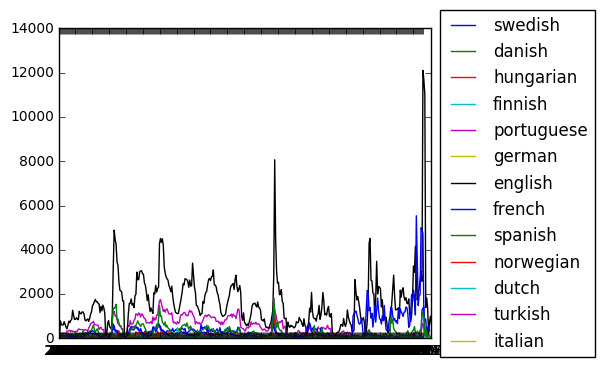

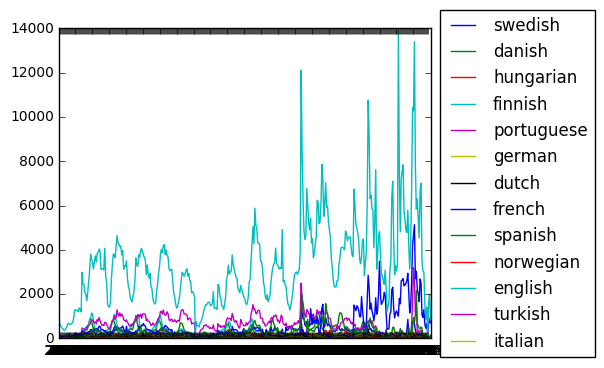

In [1]:
import matplotlib.pyplot as plt
from itertools import cycle
cycol = cycle('bgrcmk').next
archivo = open("languages_amount_by_platform_summary.txt")
archivo.readline()
archivo.readline()
languages = {}
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] not in languages.keys():
		languages[line[2]] = []
	languages[line[2]].append([int(line[0]), int(line[1]), int(line[3])])
ax = plt.subplot(111)
for i in languages.keys():
	x = []
	x_name = []
	y = []
	count = 0
	for j in sorted(languages[i]):
		x.append(count)
		x_name.append(str(j[0])+ " " + str(j[1]))
		y.append(j[2])
		count += 1

	plt.xticks(x, x_name)
	plt.plot(x, y,label=i)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

archivo.readline()
archivo.readline()
languages = {}
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] not in languages.keys():
		languages[line[2]] = []
	languages[line[2]].append([int(line[0]), int(line[1]), int(line[3])])
ax = plt.subplot(111)
for i in languages.keys():
	x = []
	x_name = []
	y = []
	count = 0
	for j in sorted(languages[i]):
		x.append(count)
		x_name.append(str(j[0])+ " " + str(j[1]))
		y.append(j[2])
		count += 1

	plt.xticks(x, x_name)
	plt.plot(x, y,label=i)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()